In [12]:
import numpy as np
import  pandas as pd
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt 
import warnings

# 1 准备数据


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_DATA",one_hot=True)

Extracting MNIST_DATA\train-images-idx3-ubyte.gz


Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz


# 2 构建模型

In [30]:
class NeuralNetwork():
    def __init__(self,initial_weights,activation_fn,use_batch_norm):
        '''
        初始化网络对象
        :param inital_weights: 权重初始化，是一个list，list中每一个元素是一个权重矩阵 
        :param activation_fn: 隐层激活函数
        :param use_batch_norm: 是否使用Batch Normalization
        '''
        self.use_batch_norm=use_batch_norm
        self.name="With Batch Norm" if use_batch_norm else "Without Batch Norm"
        
        self.is_training=tf.placeholder(tf.bool,name='is_traing')
        
        #存储训练准确率
        self.training_accuracies=[]
        
        self.build_network(initial_weights,activation_fn)
        
    def build_network(self,initial_weights,activation_fn): 
        '''
        构建网络图
        :param intial_weight:权重初始化，是一个list 
        :param activation_fn: 隐层激活函数
        '''
        self.input_layer=tf.placeholder(tf.float32,[None,initial_weights[0].shape[0]])
        layer_in=self.input_layer
        
        #前向计算（不计算最后输出层）
        for layer_weights in initial_weights[:-1]:
            layer_in=self.fully_connected(layer_in,layer_weights,activation_fn)
            
        #输出层
        self.output_layer=self.fully_connected(layer_in,initial_weights[-1])

    def fully_connected(self,layer_in,layer_weights,activation_fn=None):
        #如果使用BN与激活函数
        if self.use_batch_norm and activation_fn:
            weights=tf.Variable(layer_weights)  #不需要设置偏置，因为BN需要对每个特征减去均值。
            linear_output=tf.matmul(layer_in,weights)
            
            #调用BN接口
            batch_normalized_output=tf.layers.batch_normalization(linear_output,training=self.is_training)
            
            return activation_fn(batch_normalized_output)
        
        #如果不使用BN或激活函数
        else:
            weights=tf.Variable(layer_weights)
            bias=tf.Variable(tf.zeros([weights.shape[-1]]))
            linear_output=tf.add(tf.matmul(layer_in,weights),bias)
            
            return activation_fn(linear_output)  if activation_fn else linear_output
        
    def train(self,sess,learning_rate,training_batches,batches_per_validate_data,save_model=None):
        '''
        :param sess: TensorFlow Session 
        :param learning_rate: 学习率
        :param training_batches: 用于训练的batch数
        :param batches_per_validate_data: 训练多少个batch对validation数据进行一次验证
        :param save_model:  存储模型
        '''
        
        # 定义输出label
        labels=tf.placeholder(tf.float32,[None,10])
        
        #定义损失函数
        cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,
                                                                               logits=self.output_layer))
        #准确率
        correct_prediction=tf.equal(tf.arg_max(self.output_layer,1),tf.arg_max(labels,1))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        
        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step=tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step=tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            
        #显示进度条
        for i in tqdm.tqdm(range(training_batches)):
            batch_x,batch_y=mnist.train.next_batch(60)
            #feed_dict存放占位符（placeholder）的取值
            sess.run(train_step,feed_dict={self.input_layer:batch_x,labels:batch_y,self.is_training:True })
            
            if i%batches_per_validate_data==0:
                val_accuracy=sess.run(accuracy,feed_dict={self.input_layer:mnist.validation.images,labels:
                                                            mnist.validation.labels,self.is_training:False})
                self.training_accuracies.append(val_accuracy)
                
        print("{}:the final accuracy on validation data is {}".format(self.name,val_accuracy))
            
        #存储模型
        if save_model:
            tf.train.Saver().save(sess,save_model)
            
    def test(self,sess,test_training_accuracy=False,restore=None):
        
        #定义lables
        labels=tf.placeholder(tf.float32,[None,10])
        
        #准确率
        correct_prediction=tf.equal(tf.arg_max(self.output_layer,1),tf.arg_max(labels,1))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        
        #是否加载模型
        if restore:
            tf.train.Saver().restore(sess,restore)
        
        test_accuracy=sess.run(accuracy,feed_dict={self.input_layer:mnist.test.images,labels:mnist.test.labels,
                                                   self.is_training:False})
        
        print("{}:The final accuracy on test data is {}".format(self.name,test_accuracy))

# 3 辅助函数
辅助函数有两个：  
* 绘制训练过程的准确率  
* 测试有BN与没有BN

In [31]:
def plot_training_accuracies(*args,bactes_per_validate_data):
    '''
    绘制模型在训练过程中的准确率曲线
    :param args: 一个或多个NeuralNetwork对象
    :param bactes_per_validate_data: 
    '''
    fig,ax=plt.subplots()
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies)*bactes_per_validate_data,bactes_per_validate_data),
                nn.training_accuracies,label=nn.name)
    ax.set_xlabel("Training steps")
    ax.set_ylabel("Accuracy")
    ax.set_title("Validation Accuracy During Training")
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0,1.1,0.1))
    plt.grid(True)
    plt.show()
    
def train_and_test(use_larger_weights,learning_rate,activation_fn,training_batches=50000,batches_per_validate_data
=500):
    '''
    使用相同的权重初始化生成两个网络，一个使用BN,一个不使用BN
    :param use_larger_weights: 是否使用更大的权重
    :param learning_rate: 学习率
    :param activation_fn: 激活函数
    :param training_batches: 训练阶段使用的batch数（默认为50000）
    :param batches_per_validate_data: 
    '''
    if use_larger_weights:
        weights=[np.random.normal(size=(784,128),scale=10).astype(np.float32),
                 np.random.normal(size=(128,128),scale=10).astype(np.float32),
                 np.random.normal(size=(128,128),scale=10).astype(np.float32),
                 np.random.normal(size=(128,10),scale=10).astype(np.float32)]
    else:
        weights=[np.random.normal(size=(784,128),scale=0.05).astype(np.float32),
                 np.random.normal(size=(128,128),scale=0.05).astype(np.float32),
                 np.random.normal(size=(128,128),scale=0.05).astype(np.float32),
                 np.random.normal(size=(128,10),scale=0.05).astype(np.float32)]
        
    tf.reset_default_graph()
    
    nn=NeuralNetwork(weights,activation_fn,use_batch_norm=False)
    bn=NeuralNetwork(weights,activation_fn,use_batch_norm=True)
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        print("【Training Result:】\n")
        nn.train(sess,learning_rate,training_batches,batches_per_validate_data)
        bn.train(sess,learning_rate,training_batches,batches_per_validate_data)
        
        print("\n【Testing Result:】\n")
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn,bn,bactes_per_validate_data=batches_per_validate_data)
    
    

# 4 BN测试

## 4.1 较小的Weights初始化，较小的学习率，relu激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 24/50000 [00:00<03:31, 235.92it/s]

  0%|▏                                                                                            | 98/50000 [00:00<02:48, 296.26it/s]

  0%|▎                                                                                           | 179/50000 [00:00<02:16, 365.51it/s]

  1%|▍                                                                                           | 251/50000 [00:00<01:56, 428.30it/s]

  1%|▌                                                                                           | 334/50000 [00:00<01:39, 499.48it/s]

  1%|▊                                                                                           | 414/50000 [00:00<01:28, 560.88it/s]

  1%|▉                                                                                           | 499/50000 [00:00<01:19, 623.61it/s]

  1%|█                                                                                           | 578/50000 [00:00<01:14, 664.44it/s]

  1%|█▏                                                                                          | 657/50000 [00:00<01:10, 696.36it/s]

  1%|█▎                                                                                          | 733/50000 [00:01<01:30, 545.86it/s]

  2%|█▍                                                                                          | 813/50000 [00:01<01:21, 602.37it/s]

  2%|█▋                                                                                          | 892/50000 [00:01<01:15, 647.42it/s]

  2%|█▊                                                                                          | 964/50000 [00:01<01:13, 666.25it/s]

  2%|█▉                                                                                         | 1041/50000 [00:01<01:10, 692.95it/s]

  2%|██                                                                                         | 1120/50000 [00:01<01:08, 718.03it/s]

  2%|██▏                                                                                        | 1198/50000 [00:01<01:06, 734.05it/s]

  3%|██▎                                                                                        | 1278/50000 [00:01<01:04, 751.11it/s]

  3%|██▍                                                                                        | 1361/50000 [00:01<01:03, 771.58it/s]

  3%|██▌                                                                                        | 1440/50000 [00:02<01:07, 724.30it/s]

  3%|██▊                                                                                        | 1514/50000 [00:02<01:15, 642.35it/s]

  3%|██▉                                                                                        | 1581/50000 [00:02<01:14, 647.15it/s]

  3%|██▉                                                                                        | 1648/50000 [00:02<01:38, 493.00it/s]

  3%|███                                                                                        | 1712/50000 [00:02<01:31, 528.53it/s]

  4%|███▏                                                                                       | 1779/50000 [00:02<01:25, 563.24it/s]

  4%|███▎                                                                                       | 1849/50000 [00:02<01:20, 595.66it/s]

  4%|███▍                                                                                       | 1913/50000 [00:02<01:20, 596.88it/s]

  4%|███▌                                                                                       | 1976/50000 [00:03<01:20, 594.91it/s]

  4%|███▋                                                                                       | 2038/50000 [00:03<01:22, 580.73it/s]

  4%|███▊                                                                                       | 2101/50000 [00:03<01:20, 593.46it/s]

  4%|███▉                                                                                       | 2185/50000 [00:03<01:13, 649.65it/s]

  5%|████                                                                                       | 2262/50000 [00:03<01:10, 678.50it/s]

  5%|████▎                                                                                      | 2347/50000 [00:03<01:06, 720.87it/s]

  5%|████▍                                                                                      | 2429/50000 [00:03<01:03, 746.51it/s]

  5%|████▌                                                                                      | 2506/50000 [00:03<01:21, 583.14it/s]

  5%|████▋                                                                                      | 2579/50000 [00:03<01:16, 619.44it/s]

  5%|████▊                                                                                      | 2658/50000 [00:04<01:11, 659.48it/s]

  5%|████▉                                                                                      | 2729/50000 [00:04<01:10, 670.56it/s]

  6%|█████                                                                                      | 2804/50000 [00:04<01:08, 691.17it/s]

  6%|█████▏                                                                                     | 2881/50000 [00:04<01:06, 711.63it/s]

  6%|█████▍                                                                                     | 2955/50000 [00:04<01:05, 718.37it/s]

  6%|█████▌                                                                                     | 3029/50000 [00:04<01:04, 723.18it/s]

  6%|█████▋                                                                                     | 3109/50000 [00:04<01:03, 743.11it/s]

  6%|█████▊                                                                                     | 3194/50000 [00:04<01:00, 770.71it/s]

  7%|█████▉                                                                                     | 3278/50000 [00:04<00:59, 788.64it/s]

  7%|██████                                                                                     | 3360/50000 [00:04<00:58, 796.10it/s]

  7%|██████▎                                                                                    | 3441/50000 [00:05<01:18, 593.63it/s]

  7%|██████▍                                                                                    | 3509/50000 [00:05<01:16, 607.69it/s]

  7%|██████▌                                                                                    | 3589/50000 [00:05<01:10, 653.75it/s]

  7%|██████▋                                                                                    | 3661/50000 [00:05<01:09, 670.93it/s]

  7%|██████▊                                                                                    | 3742/50000 [00:05<01:05, 706.01it/s]

  8%|██████▉                                                                                    | 3826/50000 [00:05<01:02, 740.07it/s]

  8%|███████                                                                                    | 3909/50000 [00:05<01:00, 763.39it/s]

  8%|███████▎                                                                                   | 3988/50000 [00:05<00:59, 769.53it/s]

  8%|███████▍                                                                                   | 4067/50000 [00:05<00:59, 769.39it/s]

  8%|███████▌                                                                                   | 4151/50000 [00:06<00:58, 787.67it/s]

  8%|███████▋                                                                                   | 4231/50000 [00:06<01:00, 760.41it/s]

  9%|███████▊                                                                                   | 4308/50000 [00:06<01:05, 693.86it/s]

  9%|███████▉                                                                                   | 4380/50000 [00:06<01:30, 502.62it/s]

  9%|████████                                                                                   | 4442/50000 [00:06<01:25, 530.53it/s]

  9%|████████▏                                                                                  | 4502/50000 [00:06<01:25, 529.68it/s]

  9%|████████▎                                                                                  | 4560/50000 [00:06<01:24, 538.20it/s]

  9%|████████▍                                                                                  | 4621/50000 [00:06<01:21, 555.27it/s]

  9%|████████▌                                                                                  | 4686/50000 [00:07<01:18, 579.52it/s]

  9%|████████▋                                                                                  | 4746/50000 [00:07<01:18, 575.88it/s]

 10%|████████▊                                                                                  | 4811/50000 [00:07<01:15, 595.08it/s]

 10%|████████▊                                                                                  | 4872/50000 [00:07<01:15, 594.70it/s]

 10%|████████▉                                                                                  | 4933/50000 [00:07<01:16, 587.58it/s]

 10%|█████████                                                                                  | 4993/50000 [00:07<01:16, 588.25it/s]

 10%|█████████▏                                                                                 | 5053/50000 [00:07<01:16, 586.98it/s]

 10%|█████████▎                                                                                 | 5119/50000 [00:07<01:14, 604.26it/s]

 10%|█████████▍                                                                                 | 5182/50000 [00:07<01:13, 610.46it/s]

 10%|█████████▌                                                                                 | 5250/50000 [00:08<01:11, 628.51it/s]

 11%|█████████▋                                                                                 | 5314/50000 [00:08<01:36, 464.77it/s]

 11%|█████████▊                                                                                 | 5392/50000 [00:08<01:24, 528.11it/s]

 11%|█████████▉                                                                                 | 5471/50000 [00:08<01:16, 585.48it/s]

 11%|██████████                                                                                 | 5546/50000 [00:08<01:11, 625.58it/s]

 11%|██████████▏                                                                                | 5628/50000 [00:08<01:06, 670.63it/s]

 11%|██████████▍                                                                                | 5712/50000 [00:08<01:02, 712.48it/s]

 12%|██████████▌                                                                                | 5795/50000 [00:08<00:59, 742.63it/s]

 12%|██████████▋                                                                                | 5875/50000 [00:08<00:58, 757.38it/s]

 12%|██████████▊                                                                                | 5957/50000 [00:09<00:56, 773.54it/s]

 12%|██████████▉                                                                                | 6037/50000 [00:09<00:57, 761.85it/s]

 12%|███████████▏                                                                               | 6115/50000 [00:09<01:00, 725.10it/s]

 12%|███████████▎                                                                               | 6189/50000 [00:09<01:20, 543.85it/s]

 13%|███████████▍                                                                               | 6267/50000 [00:09<01:13, 597.18it/s]

 13%|███████████▌                                                                               | 6349/50000 [00:09<01:07, 649.06it/s]

 13%|███████████▋                                                                               | 6431/50000 [00:09<01:03, 691.08it/s]

 13%|███████████▊                                                                               | 6509/50000 [00:09<01:00, 714.12it/s]

 13%|███████████▉                                                                               | 6587/50000 [00:09<00:59, 731.18it/s]

 13%|████████████▏                                                                              | 6668/50000 [00:10<00:57, 751.63it/s]

 13%|████████████▎                                                                              | 6746/50000 [00:10<00:59, 732.73it/s]

 14%|████████████▍                                                                              | 6826/50000 [00:10<00:57, 750.15it/s]

 14%|████████████▌                                                                              | 6905/50000 [00:10<00:56, 760.07it/s]

 14%|████████████▋                                                                              | 6985/50000 [00:10<00:55, 769.99it/s]

 14%|████████████▊                                                                              | 7063/50000 [00:10<00:56, 762.27it/s]

 14%|████████████▉                                                                              | 7140/50000 [00:10<01:12, 588.47it/s]

 14%|█████████████▏                                                                             | 7221/50000 [00:10<01:06, 639.96it/s]

 15%|█████████████▎                                                                             | 7302/50000 [00:11<01:02, 681.71it/s]

 15%|█████████████▍                                                                             | 7384/50000 [00:11<00:59, 716.66it/s]

 15%|█████████████▌                                                                             | 7460/50000 [00:11<00:58, 721.41it/s]

 15%|█████████████▋                                                                             | 7536/50000 [00:11<00:58, 728.92it/s]

 15%|█████████████▊                                                                             | 7616/50000 [00:11<00:56, 745.27it/s]

 15%|█████████████▉                                                                             | 7692/50000 [00:11<00:56, 745.81it/s]

 16%|██████████████▏                                                                            | 7774/50000 [00:11<00:55, 765.05it/s]

 16%|██████████████▎                                                                            | 7856/50000 [00:11<00:54, 779.12it/s]

 16%|██████████████▍                                                                            | 7941/50000 [00:11<00:52, 797.47it/s]

 16%|██████████████▌                                                                            | 8022/50000 [00:12<01:10, 594.17it/s]

 16%|██████████████▋                                                                            | 8095/50000 [00:12<01:06, 626.49it/s]

 16%|██████████████▊                                                                            | 8164/50000 [00:12<01:09, 601.07it/s]

 16%|██████████████▉                                                                            | 8229/50000 [00:12<01:09, 605.14it/s]

 17%|███████████████                                                                            | 8293/50000 [00:12<01:09, 600.12it/s]

 17%|███████████████▏                                                                           | 8356/50000 [00:12<01:10, 592.12it/s]

 17%|███████████████▎                                                                           | 8417/50000 [00:12<01:10, 589.19it/s]

 17%|███████████████▍                                                                           | 8478/50000 [00:12<01:09, 594.03it/s]

 17%|███████████████▌                                                                           | 8539/50000 [00:12<01:11, 577.15it/s]

 17%|███████████████▋                                                                           | 8605/50000 [00:13<01:09, 598.54it/s]

 17%|███████████████▊                                                                           | 8670/50000 [00:13<01:07, 611.84it/s]

 17%|███████████████▉                                                                           | 8732/50000 [00:13<01:09, 593.62it/s]

 18%|████████████████                                                                           | 8808/50000 [00:13<01:04, 634.19it/s]

 18%|████████████████▏                                                                          | 8885/50000 [00:13<01:01, 666.61it/s]

 18%|████████████████▎                                                                          | 8953/50000 [00:13<01:21, 506.56it/s]

 18%|████████████████▍                                                                          | 9028/50000 [00:13<01:13, 560.29it/s]

 18%|████████████████▌                                                                          | 9102/50000 [00:13<01:07, 603.24it/s]

 18%|████████████████▋                                                                          | 9180/50000 [00:13<01:03, 644.47it/s]

 19%|████████████████▊                                                                          | 9258/50000 [00:14<01:00, 678.62it/s]

 19%|████████████████▉                                                                          | 9336/50000 [00:14<00:57, 704.75it/s]

 19%|█████████████████▏                                                                         | 9410/50000 [00:14<00:57, 701.32it/s]

 19%|█████████████████▎                                                                         | 9492/50000 [00:14<00:55, 731.72it/s]

 19%|█████████████████▍                                                                         | 9567/50000 [00:14<00:55, 731.23it/s]

 19%|█████████████████▌                                                                         | 9642/50000 [00:14<00:55, 724.56it/s]

 19%|█████████████████▋                                                                         | 9724/50000 [00:14<00:53, 749.27it/s]

 20%|█████████████████▊                                                                         | 9803/50000 [00:14<00:52, 759.44it/s]

 20%|█████████████████▉                                                                         | 9880/50000 [00:14<01:10, 567.84it/s]

 20%|██████████████████                                                                         | 9957/50000 [00:15<01:05, 615.31it/s]

 20%|██████████████████                                                                        | 10031/50000 [00:15<01:01, 646.83it/s]

 20%|██████████████████▏                                                                       | 10101/50000 [00:15<01:01, 649.54it/s]

 20%|██████████████████▎                                                                       | 10178/50000 [00:15<00:58, 678.41it/s]

 21%|██████████████████▍                                                                       | 10258/50000 [00:15<00:56, 709.44it/s]

 21%|██████████████████▌                                                                       | 10332/50000 [00:15<00:56, 698.59it/s]

 21%|██████████████████▋                                                                       | 10413/50000 [00:15<00:54, 727.23it/s]

 21%|██████████████████▉                                                                       | 10489/50000 [00:15<00:53, 735.19it/s]

 21%|███████████████████                                                                       | 10565/50000 [00:15<00:53, 738.73it/s]

 21%|███████████████████▏                                                                      | 10646/50000 [00:15<00:51, 757.20it/s]

 21%|███████████████████▎                                                                      | 10726/50000 [00:16<00:51, 767.93it/s]

 22%|███████████████████▍                                                                      | 10804/50000 [00:16<01:07, 581.09it/s]

 22%|███████████████████▌                                                                      | 10882/50000 [00:16<01:02, 628.11it/s]

 22%|███████████████████▋                                                                      | 10963/50000 [00:16<00:58, 672.26it/s]

 22%|███████████████████▊                                                                      | 11036/50000 [00:16<00:57, 675.76it/s]

 22%|████████████████████                                                                      | 11118/50000 [00:16<00:54, 712.05it/s]

 22%|████████████████████▏                                                                     | 11200/50000 [00:16<00:52, 739.86it/s]

 23%|████████████████████▎                                                                     | 11284/50000 [00:16<00:50, 765.77it/s]

 23%|████████████████████▍                                                                     | 11365/50000 [00:17<00:49, 776.89it/s]

 23%|████████████████████▌                                                                     | 11446/50000 [00:17<00:49, 784.86it/s]

 23%|████████████████████▋                                                                     | 11526/50000 [00:17<00:57, 672.71it/s]

 23%|████████████████████▊                                                                     | 11597/50000 [00:17<00:58, 661.14it/s]

 23%|████████████████████▉                                                                     | 11666/50000 [00:17<00:58, 660.46it/s]

 23%|█████████████████████                                                                     | 11734/50000 [00:17<01:18, 489.94it/s]

 24%|█████████████████████▏                                                                    | 11791/50000 [00:17<01:16, 499.77it/s]

 24%|█████████████████████▎                                                                    | 11854/50000 [00:17<01:11, 530.49it/s]

 24%|█████████████████████▍                                                                    | 11912/50000 [00:18<01:10, 543.32it/s]

 24%|█████████████████████▌                                                                    | 11986/50000 [00:18<01:04, 587.96it/s]

 24%|█████████████████████▋                                                                    | 12049/50000 [00:18<01:04, 588.68it/s]

 24%|█████████████████████▊                                                                    | 12112/50000 [00:18<01:03, 599.24it/s]

 24%|█████████████████████▉                                                                    | 12174/50000 [00:18<01:02, 604.03it/s]

 24%|██████████████████████                                                                    | 12239/50000 [00:18<01:01, 615.84it/s]

 25%|██████████████████████▏                                                                   | 12310/50000 [00:18<00:58, 640.09it/s]

 25%|██████████████████████▎                                                                   | 12375/50000 [00:18<01:00, 625.03it/s]

 25%|██████████████████████▍                                                                   | 12439/50000 [00:18<01:02, 598.21it/s]

 25%|██████████████████████▌                                                                   | 12501/50000 [00:18<01:02, 598.09it/s]

 25%|██████████████████████▌                                                                   | 12562/50000 [00:19<01:03, 589.89it/s]

 25%|██████████████████████▋                                                                   | 12622/50000 [00:19<01:24, 441.74it/s]

 25%|██████████████████████▊                                                                   | 12672/50000 [00:19<01:23, 447.05it/s]

 25%|██████████████████████▉                                                                   | 12732/50000 [00:19<01:17, 483.22it/s]

 26%|███████████████████████                                                                   | 12809/50000 [00:19<01:08, 543.16it/s]

 26%|███████████████████████▏                                                                  | 12888/50000 [00:19<01:02, 598.34it/s]

 26%|███████████████████████▎                                                                  | 12972/50000 [00:19<00:56, 653.74it/s]

 26%|███████████████████████▍                                                                  | 13043/50000 [00:19<00:55, 668.28it/s]

 26%|███████████████████████▋                                                                  | 13126/50000 [00:20<00:52, 708.44it/s]

 26%|███████████████████████▊                                                                  | 13211/50000 [00:20<00:49, 744.27it/s]

 27%|███████████████████████▉                                                                  | 13289/50000 [00:20<00:49, 748.72it/s]

 27%|████████████████████████                                                                  | 13366/50000 [00:20<00:49, 736.12it/s]

 27%|████████████████████████▏                                                                 | 13447/50000 [00:20<00:48, 755.28it/s]

 27%|████████████████████████▎                                                                 | 13524/50000 [00:20<01:03, 569.97it/s]

 27%|████████████████████████▍                                                                 | 13604/50000 [00:20<00:58, 622.72it/s]

 27%|████████████████████████▋                                                                 | 13687/50000 [00:20<00:54, 671.95it/s]

 28%|████████████████████████▊                                                                 | 13761/50000 [00:20<00:55, 653.14it/s]

 28%|████████████████████████▉                                                                 | 13831/50000 [00:21<01:03, 571.02it/s]

 28%|█████████████████████████                                                                 | 13893/50000 [00:21<01:06, 545.27it/s]

 28%|█████████████████████████▏                                                                | 13962/50000 [00:21<01:02, 580.82it/s]

 28%|█████████████████████████▎                                                                | 14037/50000 [00:21<00:57, 621.85it/s]

 28%|█████████████████████████▍                                                                | 14122/50000 [00:21<00:53, 675.13it/s]

 28%|█████████████████████████▌                                                                | 14193/50000 [00:21<00:53, 674.07it/s]

 29%|█████████████████████████▋                                                                | 14271/50000 [00:21<00:50, 701.31it/s]

 29%|█████████████████████████▊                                                                | 14348/50000 [00:21<00:49, 717.12it/s]

 29%|█████████████████████████▉                                                                | 14422/50000 [00:22<01:02, 569.32it/s]

 29%|██████████████████████████                                                                | 14497/50000 [00:22<00:58, 611.06it/s]

 29%|██████████████████████████▏                                                               | 14564/50000 [00:22<01:07, 523.80it/s]

 29%|██████████████████████████▎                                                               | 14626/50000 [00:22<01:04, 548.31it/s]

 29%|██████████████████████████▍                                                               | 14686/50000 [00:22<01:03, 560.13it/s]

 29%|██████████████████████████▌                                                               | 14746/50000 [00:22<01:02, 567.11it/s]

 30%|██████████████████████████▋                                                               | 14805/50000 [00:22<01:01, 572.57it/s]

 30%|██████████████████████████▊                                                               | 14865/50000 [00:22<01:00, 579.30it/s]

 30%|██████████████████████████▊                                                               | 14925/50000 [00:22<01:00, 584.11it/s]

 30%|██████████████████████████▉                                                               | 14986/50000 [00:23<00:59, 590.39it/s]

 30%|███████████████████████████                                                               | 15048/50000 [00:23<00:58, 595.99it/s]

 30%|███████████████████████████▏                                                              | 15115/50000 [00:23<00:57, 611.81it/s]

 30%|███████████████████████████▎                                                              | 15186/50000 [00:23<00:54, 637.04it/s]

 31%|███████████████████████████▍                                                              | 15260/50000 [00:23<00:52, 663.48it/s]

 31%|███████████████████████████▌                                                              | 15333/50000 [00:23<00:50, 680.74it/s]

 31%|███████████████████████████▋                                                              | 15402/50000 [00:23<01:05, 525.15it/s]

 31%|███████████████████████████▊                                                              | 15465/50000 [00:23<01:02, 551.69it/s]

 31%|███████████████████████████▉                                                              | 15528/50000 [00:23<01:00, 571.90it/s]

 31%|████████████████████████████                                                              | 15589/50000 [00:24<01:05, 528.82it/s]

 31%|████████████████████████████▏                                                             | 15645/50000 [00:24<01:05, 524.64it/s]

 31%|████████████████████████████▎                                                             | 15700/50000 [00:24<01:04, 527.82it/s]

 32%|████████████████████████████▍                                                             | 15773/50000 [00:24<00:59, 574.66it/s]

 32%|████████████████████████████▌                                                             | 15848/50000 [00:24<00:55, 616.89it/s]

 32%|████████████████████████████▋                                                             | 15925/50000 [00:24<00:52, 654.80it/s]

 32%|████████████████████████████▊                                                             | 16001/50000 [00:24<00:50, 671.02it/s]

 32%|████████████████████████████▉                                                             | 16076/50000 [00:24<00:49, 691.51it/s]

 32%|█████████████████████████████                                                             | 16154/50000 [00:24<00:47, 714.44it/s]

 32%|█████████████████████████████▏                                                            | 16235/50000 [00:24<00:45, 739.17it/s]

 33%|█████████████████████████████▎                                                            | 16310/50000 [00:25<00:59, 566.63it/s]

 33%|█████████████████████████████▍                                                            | 16380/50000 [00:25<00:56, 599.85it/s]

 33%|█████████████████████████████▋                                                            | 16464/50000 [00:25<00:51, 655.01it/s]

 33%|█████████████████████████████▊                                                            | 16537/50000 [00:25<00:49, 674.46it/s]

 33%|█████████████████████████████▉                                                            | 16619/50000 [00:25<00:46, 711.04it/s]

 33%|██████████████████████████████                                                            | 16694/50000 [00:25<00:46, 718.71it/s]

 34%|██████████████████████████████▏                                                           | 16774/50000 [00:25<00:44, 739.81it/s]

 34%|██████████████████████████████▎                                                           | 16856/50000 [00:25<00:43, 760.62it/s]

 34%|██████████████████████████████▍                                                           | 16939/50000 [00:25<00:42, 778.58it/s]

 34%|██████████████████████████████▋                                                           | 17019/50000 [00:26<00:42, 783.20it/s]

 34%|██████████████████████████████▊                                                           | 17100/50000 [00:26<00:41, 789.36it/s]

 34%|██████████████████████████████▉                                                           | 17180/50000 [00:26<00:55, 594.03it/s]

 35%|███████████████████████████████                                                           | 17261/50000 [00:26<00:50, 644.55it/s]

 35%|███████████████████████████████▏                                                          | 17344/50000 [00:26<00:47, 689.60it/s]

 35%|███████████████████████████████▎                                                          | 17419/50000 [00:26<00:46, 703.24it/s]

 35%|███████████████████████████████▍                                                          | 17500/50000 [00:26<00:44, 730.74it/s]

 35%|███████████████████████████████▋                                                          | 17579/50000 [00:26<00:43, 746.02it/s]

 35%|███████████████████████████████▊                                                          | 17663/50000 [00:27<00:42, 768.27it/s]

 35%|███████████████████████████████▉                                                          | 17744/50000 [00:27<00:41, 778.66it/s]

 36%|████████████████████████████████                                                          | 17824/50000 [00:27<00:44, 727.85it/s]

 36%|████████████████████████████████▏                                                         | 17899/50000 [00:27<00:48, 668.31it/s]

 36%|████████████████████████████████▎                                                         | 17968/50000 [00:27<00:49, 646.80it/s]

 36%|████████████████████████████████▍                                                         | 18035/50000 [00:27<00:50, 631.94it/s]

 36%|████████████████████████████████▌                                                         | 18100/50000 [00:27<01:08, 468.56it/s]

 36%|████████████████████████████████▋                                                         | 18156/50000 [00:27<01:04, 491.75it/s]

 36%|████████████████████████████████▊                                                         | 18217/50000 [00:28<01:01, 519.81it/s]

 37%|████████████████████████████████▉                                                         | 18279/50000 [00:28<00:58, 545.24it/s]

 37%|█████████████████████████████████                                                         | 18351/50000 [00:28<00:53, 587.01it/s]

 37%|█████████████████████████████████▏                                                        | 18422/50000 [00:28<00:51, 618.01it/s]

 37%|█████████████████████████████████▎                                                        | 18501/50000 [00:28<00:47, 656.70it/s]

 37%|█████████████████████████████████▍                                                        | 18582/50000 [00:28<00:45, 694.92it/s]

 37%|█████████████████████████████████▌                                                        | 18665/50000 [00:28<00:42, 729.18it/s]

 37%|█████████████████████████████████▋                                                        | 18743/50000 [00:28<00:42, 742.17it/s]

 38%|█████████████████████████████████▉                                                        | 18827/50000 [00:28<00:40, 767.50it/s]

 38%|██████████████████████████████████                                                        | 18908/50000 [00:28<00:39, 778.13it/s]

 38%|██████████████████████████████████▏                                                       | 18987/50000 [00:29<00:41, 742.67it/s]

 38%|██████████████████████████████████▎                                                       | 19063/50000 [00:29<00:58, 529.83it/s]

 38%|██████████████████████████████████▍                                                       | 19135/50000 [00:29<00:53, 573.05it/s]

 38%|██████████████████████████████████▌                                                       | 19215/50000 [00:29<00:49, 625.29it/s]

 39%|██████████████████████████████████▋                                                       | 19294/50000 [00:29<00:46, 665.78it/s]

 39%|██████████████████████████████████▉                                                       | 19378/50000 [00:29<00:43, 708.62it/s]

 39%|███████████████████████████████████                                                       | 19454/50000 [00:29<00:43, 701.86it/s]

 39%|███████████████████████████████████▏                                                      | 19531/50000 [00:29<00:42, 719.52it/s]

 39%|███████████████████████████████████▎                                                      | 19614/50000 [00:30<00:40, 747.97it/s]

 39%|███████████████████████████████████▍                                                      | 19698/50000 [00:30<00:39, 771.83it/s]

 40%|███████████████████████████████████▌                                                      | 19782/50000 [00:30<00:38, 789.46it/s]

 40%|███████████████████████████████████▊                                                      | 19863/50000 [00:30<00:39, 771.19it/s]

 40%|███████████████████████████████████▉                                                      | 19942/50000 [00:30<00:51, 583.30it/s]

 40%|████████████████████████████████████                                                      | 20017/50000 [00:30<00:48, 623.83it/s]

 40%|████████████████████████████████████▏                                                     | 20095/50000 [00:30<00:45, 660.78it/s]

 40%|████████████████████████████████████▎                                                     | 20169/50000 [00:30<00:43, 681.33it/s]

 41%|████████████████████████████████████▍                                                     | 20253/50000 [00:30<00:41, 720.90it/s]

 41%|████████████████████████████████████▌                                                     | 20336/50000 [00:31<00:39, 749.01it/s]

 41%|████████████████████████████████████▊                                                     | 20419/50000 [00:31<00:38, 770.03it/s]

 41%|████████████████████████████████████▉                                                     | 20501/50000 [00:31<00:37, 778.28it/s]

 41%|█████████████████████████████████████                                                     | 20581/50000 [00:31<00:39, 735.60it/s]

 41%|█████████████████████████████████████▏                                                    | 20656/50000 [00:31<00:40, 725.45it/s]

 41%|█████████████████████████████████████▎                                                    | 20739/50000 [00:31<00:38, 752.44it/s]

 42%|█████████████████████████████████████▍                                                    | 20822/50000 [00:31<00:37, 772.56it/s]

 42%|█████████████████████████████████████▌                                                    | 20901/50000 [00:31<00:49, 583.85it/s]

 42%|█████████████████████████████████████▋                                                    | 20967/50000 [00:32<00:50, 570.77it/s]

 42%|█████████████████████████████████████▊                                                    | 21040/50000 [00:32<00:47, 609.62it/s]

 42%|█████████████████████████████████████▉                                                    | 21106/50000 [00:32<00:47, 612.25it/s]

 42%|██████████████████████████████████████                                                    | 21171/50000 [00:32<00:49, 583.39it/s]

 42%|██████████████████████████████████████▏                                                   | 21233/50000 [00:32<00:48, 590.98it/s]

 43%|██████████████████████████████████████▎                                                   | 21296/50000 [00:32<00:47, 600.91it/s]

 43%|██████████████████████████████████████▍                                                   | 21359/50000 [00:32<00:47, 606.31it/s]

 43%|██████████████████████████████████████▌                                                   | 21422/50000 [00:32<00:46, 610.15it/s]

 43%|██████████████████████████████████████▋                                                   | 21488/50000 [00:32<00:45, 623.00it/s]

 43%|██████████████████████████████████████▊                                                   | 21552/50000 [00:32<00:45, 626.66it/s]

 43%|██████████████████████████████████████▉                                                   | 21620/50000 [00:33<00:44, 638.64it/s]

 43%|███████████████████████████████████████                                                   | 21693/50000 [00:33<00:42, 662.23it/s]

 44%|███████████████████████████████████████▏                                                  | 21760/50000 [00:33<00:54, 513.95it/s]

 44%|███████████████████████████████████████▎                                                  | 21833/50000 [00:33<00:50, 563.08it/s]

 44%|███████████████████████████████████████▍                                                  | 21917/50000 [00:33<00:45, 622.48it/s]

 44%|███████████████████████████████████████▌                                                  | 21999/50000 [00:33<00:41, 669.77it/s]

 44%|███████████████████████████████████████▋                                                  | 22075/50000 [00:33<00:40, 693.11it/s]

 44%|███████████████████████████████████████▊                                                  | 22150/50000 [00:33<00:39, 707.78it/s]

 44%|████████████████████████████████████████                                                  | 22230/50000 [00:33<00:38, 729.67it/s]

 45%|████████████████████████████████████████▏                                                 | 22312/50000 [00:34<00:36, 753.09it/s]

 45%|████████████████████████████████████████▎                                                 | 22394/50000 [00:34<00:35, 770.40it/s]

 45%|████████████████████████████████████████▍                                                 | 22473/50000 [00:34<00:35, 772.24it/s]

 45%|████████████████████████████████████████▌                                                 | 22552/50000 [00:34<00:36, 743.06it/s]

 45%|████████████████████████████████████████▋                                                 | 22628/50000 [00:34<00:36, 742.09it/s]

 45%|████████████████████████████████████████▊                                                 | 22703/50000 [00:34<00:47, 569.12it/s]

 46%|█████████████████████████████████████████                                                 | 22782/50000 [00:34<00:43, 620.16it/s]

 46%|█████████████████████████████████████████▏                                                | 22861/50000 [00:34<00:41, 661.70it/s]

 46%|█████████████████████████████████████████▎                                                | 22943/50000 [00:34<00:38, 701.06it/s]

 46%|█████████████████████████████████████████▍                                                | 23018/50000 [00:35<00:37, 711.54it/s]

 46%|█████████████████████████████████████████▌                                                | 23097/50000 [00:35<00:36, 729.88it/s]

 46%|█████████████████████████████████████████▋                                                | 23173/50000 [00:35<00:36, 737.09it/s]

 46%|█████████████████████████████████████████▊                                                | 23249/50000 [00:35<00:36, 733.65it/s]

 47%|█████████████████████████████████████████▉                                                | 23333/50000 [00:35<00:35, 761.10it/s]

 47%|██████████████████████████████████████████▏                                               | 23414/50000 [00:35<00:34, 773.52it/s]

 47%|██████████████████████████████████████████▎                                               | 23494/50000 [00:35<00:33, 779.61it/s]

 47%|██████████████████████████████████████████▍                                               | 23573/50000 [00:35<00:35, 745.71it/s]

 47%|██████████████████████████████████████████▌                                               | 23649/50000 [00:36<00:46, 565.17it/s]

 47%|██████████████████████████████████████████▋                                               | 23730/50000 [00:36<00:42, 620.48it/s]

 48%|██████████████████████████████████████████▊                                               | 23811/50000 [00:36<00:39, 666.12it/s]

 48%|███████████████████████████████████████████                                               | 23896/50000 [00:36<00:36, 709.27it/s]

 48%|███████████████████████████████████████████▏                                              | 23972/50000 [00:36<00:37, 690.83it/s]

 48%|███████████████████████████████████████████▎                                              | 24045/50000 [00:36<00:37, 700.66it/s]

 48%|███████████████████████████████████████████▍                                              | 24127/50000 [00:36<00:35, 731.21it/s]

 48%|███████████████████████████████████████████▌                                              | 24210/50000 [00:36<00:34, 756.77it/s]

 49%|███████████████████████████████████████████▋                                              | 24288/50000 [00:36<00:34, 748.83it/s]

 49%|███████████████████████████████████████████▊                                              | 24372/50000 [00:36<00:33, 772.47it/s]

 49%|████████████████████████████████████████████                                              | 24455/50000 [00:37<00:32, 787.23it/s]

 49%|████████████████████████████████████████████▏                                             | 24535/50000 [00:37<00:44, 574.08it/s]

 49%|████████████████████████████████████████████▎                                             | 24602/50000 [00:37<00:44, 572.64it/s]

 49%|████████████████████████████████████████████▍                                             | 24666/50000 [00:37<00:42, 590.12it/s]

 49%|████████████████████████████████████████████▌                                             | 24730/50000 [00:37<00:42, 591.31it/s]

 50%|████████████████████████████████████████████▋                                             | 24793/50000 [00:37<00:42, 596.07it/s]

 50%|████████████████████████████████████████████▋                                             | 24861/50000 [00:37<00:40, 617.75it/s]

 50%|████████████████████████████████████████████▊                                             | 24925/50000 [00:37<00:40, 619.33it/s]

 50%|████████████████████████████████████████████▉                                             | 24991/50000 [00:38<00:39, 629.67it/s]

 50%|█████████████████████████████████████████████                                             | 25055/50000 [00:38<00:39, 631.37it/s]

 50%|█████████████████████████████████████████████▏                                            | 25130/50000 [00:38<00:37, 659.80it/s]

 50%|█████████████████████████████████████████████▎                                            | 25197/50000 [00:38<00:38, 642.42it/s]

 51%|█████████████████████████████████████████████▍                                            | 25262/50000 [00:38<00:39, 621.20it/s]

 51%|█████████████████████████████████████████████▌                                            | 25326/50000 [00:38<00:39, 623.55it/s]

 51%|█████████████████████████████████████████████▋                                            | 25392/50000 [00:38<00:38, 632.73it/s]

 51%|█████████████████████████████████████████████▊                                            | 25456/50000 [00:38<00:51, 472.56it/s]

 51%|█████████████████████████████████████████████▉                                            | 25510/50000 [00:38<00:50, 482.13it/s]

 51%|██████████████████████████████████████████████                                            | 25568/50000 [00:39<00:48, 506.86it/s]

 51%|██████████████████████████████████████████████▏                                           | 25629/50000 [00:39<00:45, 532.93it/s]

 51%|██████████████████████████████████████████████▏                                           | 25690/50000 [00:39<00:43, 552.82it/s]

 52%|██████████████████████████████████████████████▎                                           | 25751/50000 [00:39<00:42, 567.65it/s]

 52%|██████████████████████████████████████████████▍                                           | 25813/50000 [00:39<00:41, 579.59it/s]

 52%|██████████████████████████████████████████████▌                                           | 25882/50000 [00:39<00:39, 606.04it/s]

 52%|██████████████████████████████████████████████▋                                           | 25954/50000 [00:39<00:37, 635.02it/s]

 52%|██████████████████████████████████████████████▊                                           | 26023/50000 [00:39<00:36, 649.23it/s]

 52%|██████████████████████████████████████████████▉                                           | 26089/50000 [00:39<00:36, 649.10it/s]

 52%|███████████████████████████████████████████████                                           | 26167/50000 [00:39<00:35, 680.42it/s]

 53%|███████████████████████████████████████████████▎                                          | 26251/50000 [00:40<00:32, 720.19it/s]

 53%|███████████████████████████████████████████████▍                                          | 26333/50000 [00:40<00:31, 745.99it/s]

 53%|███████████████████████████████████████████████▌                                          | 26409/50000 [00:40<00:41, 565.29it/s]

 53%|███████████████████████████████████████████████▋                                          | 26488/50000 [00:40<00:38, 616.97it/s]

 53%|███████████████████████████████████████████████▊                                          | 26557/50000 [00:40<00:37, 628.97it/s]

 53%|███████████████████████████████████████████████▉                                          | 26641/50000 [00:40<00:34, 679.04it/s]

 53%|████████████████████████████████████████████████                                          | 26726/50000 [00:40<00:32, 721.30it/s]

 54%|████████████████████████████████████████████████▏                                         | 26802/50000 [00:40<00:31, 728.85it/s]

 54%|████████████████████████████████████████████████▍                                         | 26883/50000 [00:40<00:30, 749.91it/s]

 54%|████████████████████████████████████████████████▌                                         | 26964/50000 [00:41<00:30, 765.39it/s]

 54%|████████████████████████████████████████████████▋                                         | 27043/50000 [00:41<00:30, 764.26it/s]

 54%|████████████████████████████████████████████████▊                                         | 27125/50000 [00:41<00:29, 776.34it/s]

 54%|████████████████████████████████████████████████▉                                         | 27204/50000 [00:41<00:30, 756.40it/s]

 55%|█████████████████████████████████████████████████                                         | 27281/50000 [00:41<00:39, 578.11it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27355/50000 [00:41<00:36, 617.58it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27439/50000 [00:41<00:33, 669.70it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27512/50000 [00:41<00:33, 675.81it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27595/50000 [00:42<00:31, 714.35it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27677/50000 [00:42<00:30, 741.60it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27754/50000 [00:42<00:33, 663.42it/s]

 56%|██████████████████████████████████████████████████                                        | 27824/50000 [00:42<00:35, 620.81it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27889/50000 [00:42<00:36, 601.86it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27952/50000 [00:42<00:36, 606.99it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28015/50000 [00:42<00:36, 600.19it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28080/50000 [00:42<00:35, 611.32it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28142/50000 [00:42<00:37, 588.21it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28202/50000 [00:43<00:48, 446.96it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28276/50000 [00:43<00:42, 506.48it/s]

 57%|███████████████████████████████████████████████████                                       | 28352/50000 [00:43<00:38, 560.65it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28419/50000 [00:43<00:36, 588.38it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28492/50000 [00:43<00:34, 621.98it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28567/50000 [00:43<00:32, 654.30it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28651/50000 [00:43<00:30, 699.50it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28733/50000 [00:43<00:29, 730.33it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28809/50000 [00:43<00:29, 718.64it/s]

 58%|████████████████████████████████████████████████████                                      | 28893/50000 [00:44<00:28, 749.73it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28973/50000 [00:44<00:27, 760.37it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29051/50000 [00:44<00:27, 757.84it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29128/50000 [00:44<00:37, 562.26it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29206/50000 [00:44<00:33, 612.60it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29290/50000 [00:44<00:31, 665.59it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29374/50000 [00:44<00:29, 708.49it/s]

 59%|█████████████████████████████████████████████████████                                     | 29454/50000 [00:44<00:28, 732.19it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29531/50000 [00:45<00:28, 708.89it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29613/50000 [00:45<00:27, 737.47it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29695/50000 [00:45<00:26, 756.79it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29777/50000 [00:45<00:26, 773.10it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29856/50000 [00:45<00:26, 765.18it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29934/50000 [00:45<00:27, 741.68it/s]

 60%|██████████████████████████████████████████████████████                                    | 30009/50000 [00:45<00:34, 571.55it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30088/50000 [00:45<00:32, 622.17it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30164/50000 [00:45<00:30, 656.72it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30239/50000 [00:46<00:29, 680.82it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30323/50000 [00:46<00:27, 720.50it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30405/50000 [00:46<00:26, 746.23it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30488/50000 [00:46<00:25, 767.97it/s]

 61%|███████████████████████████████████████████████████████                                   | 30567/50000 [00:46<00:25, 750.81it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30644/50000 [00:46<00:25, 750.44it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30725/50000 [00:46<00:25, 763.62it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30806/50000 [00:46<00:24, 775.33it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30891/50000 [00:46<00:24, 794.69it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30971/50000 [00:47<00:31, 602.86it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31040/50000 [00:47<00:30, 623.66it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31108/50000 [00:47<00:30, 617.44it/s]

 62%|████████████████████████████████████████████████████████                                  | 31174/50000 [00:47<00:30, 607.54it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31238/50000 [00:47<00:31, 590.15it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31299/50000 [00:47<00:32, 574.58it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31358/50000 [00:47<00:33, 561.43it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31425/50000 [00:47<00:31, 588.97it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31492/50000 [00:47<00:30, 608.28it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31554/50000 [00:48<00:31, 592.96it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31621/50000 [00:48<00:29, 612.91it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31702/50000 [00:48<00:27, 660.00it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31784/50000 [00:48<00:26, 699.72it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31856/50000 [00:48<00:33, 533.88it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31937/50000 [00:48<00:30, 593.75it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32014/50000 [00:48<00:28, 636.37it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32098/50000 [00:48<00:26, 683.39it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32180/50000 [00:48<00:24, 717.96it/s]

 65%|██████████████████████████████████████████████████████████                                | 32256/50000 [00:49<00:24, 726.46it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32339/50000 [00:49<00:23, 753.20it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32422/50000 [00:49<00:22, 773.13it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32502/50000 [00:49<00:22, 772.57it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32581/50000 [00:49<00:23, 756.03it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32659/50000 [00:49<00:22, 759.23it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32742/50000 [00:49<00:22, 777.56it/s]

 66%|███████████████████████████████████████████████████████████                               | 32821/50000 [00:49<00:28, 593.74it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32899/50000 [00:49<00:26, 636.85it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32971/50000 [00:50<00:25, 658.39it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33042/50000 [00:50<00:25, 669.77it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33126/50000 [00:50<00:23, 710.01it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33209/50000 [00:50<00:22, 740.74it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33286/50000 [00:50<00:22, 732.79it/s]

 67%|████████████████████████████████████████████████████████████                              | 33370/50000 [00:50<00:21, 758.40it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33453/50000 [00:50<00:21, 776.95it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33532/50000 [00:50<00:21, 776.84it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33611/50000 [00:50<00:21, 774.48it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33689/50000 [00:51<00:27, 583.70it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33768/50000 [00:51<00:25, 632.21it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33853/50000 [00:51<00:23, 683.64it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33934/50000 [00:51<00:22, 715.82it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34010/50000 [00:51<00:22, 706.77it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34089/50000 [00:51<00:21, 726.36it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34167/50000 [00:51<00:21, 740.12it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34251/50000 [00:51<00:20, 765.96it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34333/50000 [00:51<00:20, 779.78it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34413/50000 [00:52<00:20, 774.96it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34492/50000 [00:52<00:20, 766.44it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34570/50000 [00:52<00:21, 712.10it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34643/50000 [00:52<00:29, 512.74it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34704/50000 [00:52<00:28, 537.45it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34767/50000 [00:52<00:27, 559.66it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34829/50000 [00:52<00:26, 575.32it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34890/50000 [00:52<00:26, 580.74it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34952/50000 [00:53<00:25, 590.75it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35013/50000 [00:53<00:25, 589.96it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35089/50000 [00:53<00:23, 631.26it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35175/50000 [00:53<00:21, 683.17it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35256/50000 [00:53<00:20, 713.57it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35330/50000 [00:53<00:20, 715.59it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35403/50000 [00:53<00:20, 709.94it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35488/50000 [00:53<00:19, 745.43it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35564/50000 [00:53<00:25, 570.13it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35645/50000 [00:54<00:22, 624.66it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35717/50000 [00:54<00:22, 649.22it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35787/50000 [00:54<00:22, 635.31it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35854/50000 [00:54<00:22, 615.65it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35919/50000 [00:54<00:22, 615.41it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35983/50000 [00:54<00:23, 608.88it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36047/50000 [00:54<00:22, 616.59it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36110/50000 [00:54<00:22, 613.80it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36173/50000 [00:54<00:22, 617.24it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36236/50000 [00:54<00:22, 617.86it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36299/50000 [00:55<00:22, 609.34it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36361/50000 [00:55<00:22, 609.38it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36423/50000 [00:55<00:28, 470.92it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36477/50000 [00:55<00:27, 488.74it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36530/50000 [00:55<00:26, 499.39it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36589/50000 [00:55<00:25, 521.12it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36655/50000 [00:55<00:24, 555.21it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36719/50000 [00:55<00:23, 575.49it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36779/50000 [00:56<00:23, 571.45it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36852/50000 [00:56<00:21, 610.16it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36929/50000 [00:56<00:20, 649.48it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37004/50000 [00:56<00:19, 675.33it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37083/50000 [00:56<00:18, 704.72it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37155/50000 [00:56<00:18, 699.48it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37239/50000 [00:56<00:17, 735.03it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37322/50000 [00:56<00:16, 759.63it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37399/50000 [00:56<00:21, 586.02it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37481/50000 [00:57<00:19, 639.79it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37552/50000 [00:57<00:19, 652.57it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37622/50000 [00:57<00:19, 639.30it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37690/50000 [00:57<00:19, 626.35it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37755/50000 [00:57<00:20, 597.15it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37817/50000 [00:57<00:20, 585.54it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37880/50000 [00:57<00:20, 596.95it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37949/50000 [00:57<00:19, 619.23it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38013/50000 [00:57<00:19, 623.99it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38082/50000 [00:57<00:18, 641.12it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38148/50000 [00:58<00:18, 645.28it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38222/50000 [00:58<00:17, 669.72it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38290/50000 [00:58<00:22, 529.10it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38366/50000 [00:58<00:20, 581.18it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38438/50000 [00:58<00:18, 615.71it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38512/50000 [00:58<00:17, 645.45it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38594/50000 [00:58<00:16, 688.21it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38677/50000 [00:58<00:15, 724.00it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38753/50000 [00:58<00:15, 728.68it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38836/50000 [00:59<00:14, 754.87it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38914/50000 [00:59<00:14, 745.38it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38997/50000 [00:59<00:14, 767.34it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39075/50000 [00:59<00:14, 764.91it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39157/50000 [00:59<00:13, 776.81it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39236/50000 [00:59<00:18, 586.84it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39320/50000 [00:59<00:16, 642.62it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39397/50000 [00:59<00:15, 674.88it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39477/50000 [01:00<00:14, 706.73it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39552/50000 [01:00<00:14, 717.67it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39627/50000 [01:00<00:14, 711.12it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39711/50000 [01:00<00:13, 743.99it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39795/50000 [01:00<00:13, 768.86it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39874/50000 [01:00<00:13, 755.71it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39952/50000 [01:00<00:13, 761.20it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40029/50000 [01:00<00:13, 753.24it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40105/50000 [01:00<00:17, 579.86it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40186/50000 [01:01<00:15, 632.80it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40261/50000 [01:01<00:14, 662.64it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40344/50000 [01:01<00:13, 704.00it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40427/50000 [01:01<00:13, 736.15it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40507/50000 [01:01<00:12, 750.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40585/50000 [01:01<00:12, 734.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40667/50000 [01:01<00:12, 754.28it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40750/50000 [01:01<00:11, 771.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40833/50000 [01:01<00:11, 786.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40917/50000 [01:01<00:11, 798.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41000/50000 [01:02<00:11, 805.65it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41081/50000 [01:02<00:15, 569.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41148/50000 [01:02<00:15, 573.97it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41213/50000 [01:02<00:14, 588.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41277/50000 [01:02<00:14, 582.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41340/50000 [01:02<00:14, 594.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41405/50000 [01:02<00:14, 609.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41468/50000 [01:02<00:14, 598.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41530/50000 [01:03<00:14, 582.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41590/50000 [01:03<00:14, 584.95it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41671/50000 [01:03<00:13, 637.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41752/50000 [01:03<00:12, 679.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41832/50000 [01:03<00:11, 710.19it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41905/50000 [01:03<00:11, 702.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41977/50000 [01:03<00:14, 550.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42051/50000 [01:03<00:13, 594.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42134/50000 [01:03<00:12, 648.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42218/50000 [01:04<00:11, 694.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42299/50000 [01:04<00:10, 724.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42375/50000 [01:04<00:10, 720.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42454/50000 [01:04<00:10, 738.60it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42530/50000 [01:04<00:10, 738.97it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42606/50000 [01:04<00:10, 722.41it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42680/50000 [01:04<00:10, 703.32it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42759/50000 [01:04<00:09, 725.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42834/50000 [01:04<00:12, 579.23it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42910/50000 [01:05<00:11, 621.10it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42986/50000 [01:05<00:10, 655.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43058/50000 [01:05<00:10, 670.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43142/50000 [01:05<00:09, 712.48it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43226/50000 [01:05<00:09, 745.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43303/50000 [01:05<00:09, 731.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43386/50000 [01:05<00:08, 754.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43468/50000 [01:05<00:08, 771.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43547/50000 [01:05<00:08, 770.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43625/50000 [01:06<00:08, 762.92it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43709/50000 [01:06<00:08, 782.92it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43788/50000 [01:06<00:10, 591.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43871/50000 [01:06<00:09, 646.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43955/50000 [01:06<00:08, 693.27it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44030/50000 [01:06<00:08, 684.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44105/50000 [01:06<00:08, 701.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44188/50000 [01:06<00:07, 734.34it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44271/50000 [01:06<00:07, 759.11it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44354/50000 [01:07<00:07, 777.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44434/50000 [01:07<00:07, 771.14it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44513/50000 [01:07<00:08, 677.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44584/50000 [01:07<00:08, 639.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44651/50000 [01:07<00:08, 616.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44715/50000 [01:07<00:11, 465.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44776/50000 [01:07<00:10, 499.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44838/50000 [01:07<00:09, 528.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44897/50000 [01:08<00:09, 544.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44956/50000 [01:08<00:09, 556.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45021/50000 [01:08<00:08, 578.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45103/50000 [01:08<00:07, 633.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45181/50000 [01:08<00:07, 670.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45258/50000 [01:08<00:06, 695.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45338/50000 [01:08<00:06, 722.74it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45422/50000 [01:08<00:06, 752.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45502/50000 [01:08<00:05, 764.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45580/50000 [01:08<00:05, 767.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45658/50000 [01:09<00:07, 595.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45733/50000 [01:09<00:06, 633.60it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45816/50000 [01:09<00:06, 679.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45900/50000 [01:09<00:05, 719.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45976/50000 [01:09<00:05, 717.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46051/50000 [01:09<00:05, 718.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46135/50000 [01:09<00:05, 749.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46219/50000 [01:09<00:04, 773.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46298/50000 [01:09<00:04, 769.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46380/50000 [01:10<00:04, 782.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46464/50000 [01:10<00:04, 794.99it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46545/50000 [01:10<00:06, 542.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46611/50000 [01:10<00:06, 540.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46674/50000 [01:10<00:05, 562.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46742/50000 [01:10<00:05, 591.93it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46806/50000 [01:10<00:05, 597.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46869/50000 [01:10<00:05, 600.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46932/50000 [01:11<00:05, 600.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46994/50000 [01:11<00:05, 599.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47056/50000 [01:11<00:04, 592.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47118/50000 [01:11<00:04, 597.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47182/50000 [01:11<00:04, 608.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47244/50000 [01:11<00:04, 605.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47308/50000 [01:11<00:04, 613.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47375/50000 [01:11<00:04, 628.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47439/50000 [01:12<00:05, 480.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47510/50000 [01:12<00:04, 529.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47569/50000 [01:12<00:04, 538.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47627/50000 [01:12<00:04, 535.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47686/50000 [01:12<00:04, 549.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47746/50000 [01:12<00:04, 560.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47804/50000 [01:12<00:03, 557.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47863/50000 [01:12<00:03, 565.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47929/50000 [01:12<00:03, 589.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47998/50000 [01:12<00:03, 615.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48063/50000 [01:13<00:03, 624.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48133/50000 [01:13<00:02, 643.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48214/50000 [01:13<00:02, 684.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48297/50000 [01:13<00:02, 721.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48371/50000 [01:13<00:02, 560.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48444/50000 [01:13<00:02, 601.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48519/50000 [01:13<00:02, 638.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48597/50000 [01:13<00:02, 673.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48677/50000 [01:13<00:01, 705.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48761/50000 [01:14<00:01, 740.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48846/50000 [01:14<00:01, 766.31it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48926/50000 [01:14<00:01, 774.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49005/50000 [01:14<00:01, 736.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49080/50000 [01:14<00:01, 736.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49161/50000 [01:14<00:01, 755.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49238/50000 [01:14<00:01, 751.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49314/50000 [01:14<00:01, 583.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49396/50000 [01:14<00:00, 635.91it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49479/50000 [01:15<00:00, 682.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49554/50000 [01:15<00:00, 698.17it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49637/50000 [01:15<00:00, 731.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49714/50000 [01:15<00:00, 741.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49798/50000 [01:15<00:00, 764.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49881/50000 [01:15<00:00, 781.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49961/50000 [01:15<00:00, 721.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:15<00:00, 659.74it/s]

Without Batch Norm:the final accuracy on validation data is 0.9751999974250793

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<4:20:09,  3.20it/s]

  0%|                                                                                            | 30/50000 [00:00<3:02:53,  4.55it/s]

  0%|                                                                                            | 62/50000 [00:00<2:08:44,  6.46it/s]

  0%|▏                                                                                           | 91/50000 [00:00<1:30:57,  9.15it/s]

  0%|▏                                                                                          | 121/50000 [00:00<1:04:27, 12.90it/s]

  0%|▎                                                                                            | 150/50000 [00:00<45:59, 18.07it/s]

  0%|▎                                                                                            | 175/50000 [00:01<34:23, 24.15it/s]

  0%|▎                                                                                            | 198/50000 [00:01<25:10, 32.96it/s]

  0%|▍                                                                                            | 221/50000 [00:01<18:43, 44.30it/s]

  0%|▍                                                                                            | 244/50000 [00:01<14:12, 58.38it/s]

  1%|▍                                                                                            | 268/50000 [00:01<10:58, 75.47it/s]

  1%|▌                                                                                            | 295/50000 [00:01<08:38, 95.90it/s]

  1%|▌                                                                                           | 322/50000 [00:01<06:58, 118.79it/s]

  1%|▋                                                                                           | 351/50000 [00:01<05:45, 143.77it/s]

  1%|▋                                                                                           | 382/50000 [00:01<04:50, 170.84it/s]

  1%|▊                                                                                           | 414/50000 [00:01<04:10, 197.98it/s]

  1%|▊                                                                                           | 444/50000 [00:02<03:46, 219.15it/s]

  1%|▊                                                                                           | 473/50000 [00:02<03:31, 234.35it/s]

  1%|▉                                                                                           | 502/50000 [00:02<03:19, 247.57it/s]

  1%|▉                                                                                           | 531/50000 [00:02<03:13, 255.70it/s]

  1%|█                                                                                           | 560/50000 [00:02<03:08, 262.43it/s]

  1%|█                                                                                           | 592/50000 [00:02<02:59, 275.45it/s]

  1%|█▏                                                                                          | 624/50000 [00:02<02:53, 285.36it/s]

  1%|█▏                                                                                          | 656/50000 [00:02<02:48, 292.73it/s]

  1%|█▎                                                                                          | 688/50000 [00:02<02:44, 298.96it/s]

  1%|█▎                                                                                          | 719/50000 [00:02<02:45, 297.22it/s]

  2%|█▍                                                                                          | 750/50000 [00:03<02:44, 298.57it/s]

  2%|█▍                                                                                          | 781/50000 [00:03<02:43, 300.39it/s]

  2%|█▍                                                                                          | 812/50000 [00:03<02:46, 294.82it/s]

  2%|█▌                                                                                          | 844/50000 [00:03<02:44, 299.63it/s]

  2%|█▌                                                                                          | 876/50000 [00:03<02:41, 303.96it/s]

  2%|█▋                                                                                          | 909/50000 [00:03<02:38, 309.82it/s]

  2%|█▋                                                                                          | 941/50000 [00:03<02:37, 311.23it/s]

  2%|█▊                                                                                          | 973/50000 [00:03<02:37, 312.22it/s]

  2%|█▊                                                                                         | 1005/50000 [00:03<02:40, 304.89it/s]

  2%|█▉                                                                                         | 1037/50000 [00:04<02:39, 306.85it/s]

  2%|█▉                                                                                         | 1068/50000 [00:04<02:45, 295.72it/s]

  2%|█▉                                                                                         | 1098/50000 [00:04<03:41, 221.17it/s]

  2%|██                                                                                         | 1129/50000 [00:04<03:23, 240.44it/s]

  2%|██                                                                                         | 1160/50000 [00:04<03:10, 256.05it/s]

  2%|██▏                                                                                        | 1192/50000 [00:04<02:59, 271.19it/s]

  2%|██▏                                                                                        | 1224/50000 [00:04<02:52, 282.89it/s]

  3%|██▎                                                                                        | 1255/50000 [00:04<02:49, 288.30it/s]

  3%|██▎                                                                                        | 1287/50000 [00:04<02:44, 295.71it/s]

  3%|██▍                                                                                        | 1318/50000 [00:05<02:43, 298.36it/s]

  3%|██▍                                                                                        | 1349/50000 [00:05<02:42, 298.51it/s]

  3%|██▌                                                                                        | 1380/50000 [00:05<02:42, 298.62it/s]

  3%|██▌                                                                                        | 1411/50000 [00:05<02:52, 281.65it/s]

  3%|██▌                                                                                        | 1440/50000 [00:05<02:54, 277.81it/s]

  3%|██▋                                                                                        | 1470/50000 [00:05<02:51, 283.52it/s]

  3%|██▋                                                                                        | 1501/50000 [00:05<02:48, 287.93it/s]

  3%|██▊                                                                                        | 1530/50000 [00:05<02:56, 274.89it/s]

  3%|██▊                                                                                        | 1558/50000 [00:05<03:08, 256.88it/s]

  3%|██▉                                                                                        | 1585/50000 [00:06<03:12, 251.43it/s]

  3%|██▉                                                                                        | 1611/50000 [00:06<03:13, 249.76it/s]

  3%|██▉                                                                                        | 1637/50000 [00:06<03:12, 250.75it/s]

  3%|███                                                                                        | 1663/50000 [00:06<03:13, 250.01it/s]

  3%|███                                                                                        | 1691/50000 [00:06<03:07, 257.79it/s]

  3%|███▏                                                                                       | 1718/50000 [00:06<03:05, 260.78it/s]

  3%|███▏                                                                                       | 1745/50000 [00:06<03:03, 262.92it/s]

  4%|███▏                                                                                       | 1772/50000 [00:06<03:03, 262.89it/s]

  4%|███▎                                                                                       | 1804/50000 [00:06<02:54, 275.81it/s]

  4%|███▎                                                                                       | 1836/50000 [00:07<02:47, 287.16it/s]

  4%|███▍                                                                                       | 1868/50000 [00:07<02:42, 295.68it/s]

  4%|███▍                                                                                       | 1898/50000 [00:07<02:42, 296.32it/s]

  4%|███▌                                                                                       | 1928/50000 [00:07<02:42, 295.90it/s]

  4%|███▌                                                                                       | 1958/50000 [00:07<02:43, 293.01it/s]

  4%|███▌                                                                                       | 1990/50000 [00:07<02:40, 299.16it/s]

  4%|███▋                                                                                       | 2021/50000 [00:07<03:32, 225.51it/s]

  4%|███▋                                                                                       | 2050/50000 [00:07<03:19, 240.59it/s]

  4%|███▊                                                                                       | 2078/50000 [00:07<03:11, 250.71it/s]

  4%|███▊                                                                                       | 2108/50000 [00:08<03:03, 261.14it/s]

  4%|███▉                                                                                       | 2138/50000 [00:08<02:56, 270.43it/s]

  4%|███▉                                                                                       | 2167/50000 [00:08<02:57, 269.32it/s]

  4%|███▉                                                                                       | 2196/50000 [00:08<02:55, 273.09it/s]

  4%|████                                                                                       | 2225/50000 [00:08<02:53, 275.79it/s]

  5%|████                                                                                       | 2253/50000 [00:08<02:54, 273.21it/s]

  5%|████▏                                                                                      | 2284/50000 [00:08<02:48, 282.73it/s]

  5%|████▏                                                                                      | 2315/50000 [00:08<02:45, 288.19it/s]

  5%|████▎                                                                                      | 2346/50000 [00:08<02:42, 292.96it/s]

  5%|████▎                                                                                      | 2378/50000 [00:08<02:39, 299.12it/s]

  5%|████▍                                                                                      | 2409/50000 [00:09<02:42, 293.13it/s]

  5%|████▍                                                                                      | 2439/50000 [00:09<02:46, 285.30it/s]

  5%|████▍                                                                                      | 2469/50000 [00:09<02:45, 287.29it/s]

  5%|████▌                                                                                      | 2499/50000 [00:09<02:44, 289.53it/s]

  5%|████▌                                                                                      | 2529/50000 [00:09<02:45, 286.14it/s]

  5%|████▋                                                                                      | 2561/50000 [00:09<02:41, 294.11it/s]

  5%|████▋                                                                                      | 2593/50000 [00:09<02:37, 300.81it/s]

  5%|████▊                                                                                      | 2624/50000 [00:09<02:37, 301.10it/s]

  5%|████▊                                                                                      | 2655/50000 [00:09<02:46, 283.96it/s]

  5%|████▉                                                                                      | 2684/50000 [00:10<03:00, 262.72it/s]

  5%|████▉                                                                                      | 2711/50000 [00:10<03:06, 253.88it/s]

  5%|████▉                                                                                      | 2737/50000 [00:10<03:06, 252.91it/s]

  6%|█████                                                                                      | 2763/50000 [00:10<03:05, 254.45it/s]

  6%|█████                                                                                      | 2789/50000 [00:10<03:09, 248.95it/s]

  6%|█████                                                                                      | 2815/50000 [00:10<03:08, 250.90it/s]

  6%|█████▏                                                                                     | 2844/50000 [00:10<03:00, 260.96it/s]

  6%|█████▏                                                                                     | 2873/50000 [00:10<02:56, 266.29it/s]

  6%|█████▎                                                                                     | 2900/50000 [00:10<03:03, 256.93it/s]

  6%|█████▎                                                                                     | 2926/50000 [00:11<04:06, 190.67it/s]

  6%|█████▎                                                                                     | 2950/50000 [00:11<03:51, 202.83it/s]

  6%|█████▍                                                                                     | 2977/50000 [00:11<03:36, 217.22it/s]

  6%|█████▍                                                                                     | 3001/50000 [00:11<03:31, 221.89it/s]

  6%|█████▌                                                                                     | 3027/50000 [00:11<03:24, 229.81it/s]

  6%|█████▌                                                                                     | 3051/50000 [00:11<03:22, 231.61it/s]

  6%|█████▌                                                                                     | 3080/50000 [00:11<03:12, 244.18it/s]

  6%|█████▋                                                                                     | 3108/50000 [00:11<03:05, 252.74it/s]

  6%|█████▋                                                                                     | 3140/50000 [00:11<02:55, 266.56it/s]

  6%|█████▊                                                                                     | 3171/50000 [00:12<02:49, 276.97it/s]

  6%|█████▊                                                                                     | 3204/50000 [00:12<02:41, 288.92it/s]

  6%|█████▉                                                                                     | 3234/50000 [00:12<02:43, 285.72it/s]

  7%|█████▉                                                                                     | 3266/50000 [00:12<02:39, 293.00it/s]

  7%|█████▉                                                                                     | 3296/50000 [00:12<02:41, 288.50it/s]

  7%|██████                                                                                     | 3328/50000 [00:12<02:38, 295.04it/s]

  7%|██████                                                                                     | 3358/50000 [00:12<02:40, 290.72it/s]

  7%|██████▏                                                                                    | 3389/50000 [00:12<02:37, 295.63it/s]

  7%|██████▏                                                                                    | 3419/50000 [00:12<02:39, 292.82it/s]

  7%|██████▎                                                                                    | 3451/50000 [00:12<02:36, 298.19it/s]

  7%|██████▎                                                                                    | 3481/50000 [00:13<02:49, 274.42it/s]

  7%|██████▍                                                                                    | 3509/50000 [00:13<03:04, 252.44it/s]

  7%|██████▍                                                                                    | 3535/50000 [00:13<03:09, 244.81it/s]

  7%|██████▍                                                                                    | 3563/50000 [00:13<03:03, 252.53it/s]

  7%|██████▌                                                                                    | 3595/50000 [00:13<02:52, 268.41it/s]

  7%|██████▌                                                                                    | 3626/50000 [00:13<02:46, 279.11it/s]

  7%|██████▋                                                                                    | 3658/50000 [00:13<02:40, 288.88it/s]

  7%|██████▋                                                                                    | 3690/50000 [00:13<02:36, 296.13it/s]

  7%|██████▊                                                                                    | 3721/50000 [00:13<02:34, 298.66it/s]

  8%|██████▊                                                                                    | 3753/50000 [00:14<02:32, 302.40it/s]

  8%|██████▉                                                                                    | 3785/50000 [00:14<02:30, 306.83it/s]

  8%|██████▉                                                                                    | 3816/50000 [00:14<02:34, 299.13it/s]

  8%|███████                                                                                    | 3847/50000 [00:14<03:24, 225.99it/s]

  8%|███████                                                                                    | 3875/50000 [00:14<03:12, 239.42it/s]

  8%|███████                                                                                    | 3905/50000 [00:14<03:02, 252.47it/s]

  8%|███████▏                                                                                   | 3936/50000 [00:14<02:53, 266.16it/s]

  8%|███████▏                                                                                   | 3965/50000 [00:14<02:49, 271.57it/s]

  8%|███████▎                                                                                   | 3994/50000 [00:15<02:46, 276.27it/s]

  8%|███████▎                                                                                   | 4023/50000 [00:15<02:48, 273.35it/s]

  8%|███████▍                                                                                   | 4055/50000 [00:15<02:41, 285.29it/s]

  8%|███████▍                                                                                   | 4085/50000 [00:15<02:42, 283.22it/s]

  8%|███████▍                                                                                   | 4114/50000 [00:15<02:45, 276.49it/s]

  8%|███████▌                                                                                   | 4145/50000 [00:15<02:41, 284.40it/s]

  8%|███████▌                                                                                   | 4174/50000 [00:15<02:42, 281.30it/s]

  8%|███████▋                                                                                   | 4205/50000 [00:15<02:38, 288.74it/s]

  8%|███████▋                                                                                   | 4235/50000 [00:15<02:43, 279.24it/s]

  9%|███████▊                                                                                   | 4264/50000 [00:15<03:00, 253.08it/s]

  9%|███████▊                                                                                   | 4290/50000 [00:16<03:05, 245.92it/s]

  9%|███████▊                                                                                   | 4316/50000 [00:16<03:05, 245.93it/s]

  9%|███████▉                                                                                   | 4341/50000 [00:16<03:10, 240.23it/s]

  9%|███████▉                                                                                   | 4366/50000 [00:16<03:08, 242.56it/s]

  9%|███████▉                                                                                   | 4393/50000 [00:16<03:03, 248.31it/s]

  9%|████████                                                                                   | 4419/50000 [00:16<03:01, 251.17it/s]

  9%|████████                                                                                   | 4448/50000 [00:16<02:54, 260.46it/s]

  9%|████████▏                                                                                  | 4478/50000 [00:16<02:48, 269.92it/s]

  9%|████████▏                                                                                  | 4506/50000 [00:16<02:48, 270.71it/s]

  9%|████████▎                                                                                  | 4536/50000 [00:17<02:43, 277.54it/s]

  9%|████████▎                                                                                  | 4567/50000 [00:17<02:38, 285.96it/s]

  9%|████████▎                                                                                  | 4596/50000 [00:17<02:38, 286.54it/s]

  9%|████████▍                                                                                  | 4625/50000 [00:17<02:38, 286.95it/s]

  9%|████████▍                                                                                  | 4655/50000 [00:17<02:36, 289.29it/s]

  9%|████████▌                                                                                  | 4686/50000 [00:17<02:35, 292.10it/s]

  9%|████████▌                                                                                  | 4716/50000 [00:17<02:36, 289.55it/s]

  9%|████████▋                                                                                  | 4748/50000 [00:17<02:32, 297.45it/s]

 10%|████████▋                                                                                  | 4778/50000 [00:17<03:20, 225.85it/s]

 10%|████████▊                                                                                  | 4809/50000 [00:18<03:04, 244.86it/s]

 10%|████████▊                                                                                  | 4839/50000 [00:18<02:55, 258.00it/s]

 10%|████████▊                                                                                  | 4870/50000 [00:18<02:46, 270.44it/s]

 10%|████████▉                                                                                  | 4899/50000 [00:18<02:50, 264.91it/s]

 10%|████████▉                                                                                  | 4927/50000 [00:18<02:49, 265.65it/s]

 10%|█████████                                                                                  | 4957/50000 [00:18<02:44, 273.80it/s]

 10%|█████████                                                                                  | 4988/50000 [00:18<02:39, 282.40it/s]

 10%|█████████▏                                                                                 | 5017/50000 [00:18<02:41, 278.32it/s]

 10%|█████████▏                                                                                 | 5049/50000 [00:18<02:36, 287.51it/s]

 10%|█████████▏                                                                                 | 5081/50000 [00:18<02:32, 295.12it/s]

 10%|█████████▎                                                                                 | 5111/50000 [00:19<02:35, 289.10it/s]

 10%|█████████▎                                                                                 | 5144/50000 [00:19<02:30, 298.05it/s]

 10%|█████████▍                                                                                 | 5175/50000 [00:19<02:35, 289.14it/s]

 10%|█████████▍                                                                                 | 5207/50000 [00:19<02:31, 295.51it/s]

 10%|█████████▌                                                                                 | 5237/50000 [00:19<02:35, 288.53it/s]

 11%|█████████▌                                                                                 | 5267/50000 [00:19<02:35, 287.91it/s]

 11%|█████████▋                                                                                 | 5298/50000 [00:19<02:33, 291.93it/s]

 11%|█████████▋                                                                                 | 5329/50000 [00:19<02:30, 296.51it/s]

 11%|█████████▊                                                                                 | 5362/50000 [00:19<02:26, 304.36it/s]

 11%|█████████▊                                                                                 | 5393/50000 [00:20<02:31, 294.94it/s]

 11%|█████████▊                                                                                 | 5425/50000 [00:20<02:27, 301.41it/s]

 11%|█████████▉                                                                                 | 5456/50000 [00:20<02:26, 303.28it/s]

 11%|█████████▉                                                                                 | 5487/50000 [00:20<02:31, 294.23it/s]

 11%|██████████                                                                                 | 5517/50000 [00:20<02:35, 285.22it/s]

 11%|██████████                                                                                 | 5547/50000 [00:20<02:33, 288.89it/s]

 11%|██████████▏                                                                                | 5578/50000 [00:20<02:30, 294.30it/s]

 11%|██████████▏                                                                                | 5610/50000 [00:20<02:27, 300.10it/s]

 11%|██████████▎                                                                                | 5641/50000 [00:20<02:37, 281.80it/s]

 11%|██████████▎                                                                                | 5670/50000 [00:21<03:35, 205.89it/s]

 11%|██████████▎                                                                                | 5694/50000 [00:21<03:28, 212.36it/s]

 11%|██████████▍                                                                                | 5718/50000 [00:21<03:21, 219.52it/s]

 11%|██████████▍                                                                                | 5745/50000 [00:21<03:12, 229.76it/s]

 12%|██████████▌                                                                                | 5770/50000 [00:21<03:15, 226.71it/s]

 12%|██████████▌                                                                                | 5795/50000 [00:21<03:10, 231.46it/s]

 12%|██████████▌                                                                                | 5823/50000 [00:21<03:01, 243.69it/s]

 12%|██████████▋                                                                                | 5852/50000 [00:21<02:53, 254.79it/s]

 12%|██████████▋                                                                                | 5883/50000 [00:21<02:44, 267.97it/s]

 12%|██████████▊                                                                                | 5915/50000 [00:22<02:36, 281.16it/s]

 12%|██████████▊                                                                                | 5946/50000 [00:22<02:32, 288.65it/s]

 12%|██████████▉                                                                                | 5976/50000 [00:22<02:31, 289.66it/s]

 12%|██████████▉                                                                                | 6006/50000 [00:22<02:36, 281.40it/s]

 12%|██████████▉                                                                                | 6035/50000 [00:22<02:36, 280.86it/s]

 12%|███████████                                                                                | 6067/50000 [00:22<02:31, 290.19it/s]

 12%|███████████                                                                                | 6098/50000 [00:22<02:28, 295.24it/s]

 12%|███████████▏                                                                               | 6130/50000 [00:22<02:25, 301.63it/s]

 12%|███████████▏                                                                               | 6161/50000 [00:22<02:24, 303.44it/s]

 12%|███████████▎                                                                               | 6192/50000 [00:23<02:23, 304.72it/s]

 12%|███████████▎                                                                               | 6224/50000 [00:23<02:22, 307.61it/s]

 13%|███████████▍                                                                               | 6255/50000 [00:23<02:22, 307.65it/s]

 13%|███████████▍                                                                               | 6286/50000 [00:23<02:22, 307.68it/s]

 13%|███████████▍                                                                               | 6317/50000 [00:23<02:24, 302.32it/s]

 13%|███████████▌                                                                               | 6348/50000 [00:23<02:26, 296.96it/s]

 13%|███████████▌                                                                               | 6378/50000 [00:23<02:31, 288.66it/s]

 13%|███████████▋                                                                               | 6410/50000 [00:23<02:26, 296.79it/s]

 13%|███████████▋                                                                               | 6442/50000 [00:23<02:24, 301.06it/s]

 13%|███████████▊                                                                               | 6474/50000 [00:23<02:22, 304.99it/s]

 13%|███████████▊                                                                               | 6505/50000 [00:24<02:28, 292.02it/s]

 13%|███████████▉                                                                               | 6537/50000 [00:24<02:25, 298.44it/s]

 13%|███████████▉                                                                               | 6568/50000 [00:24<02:24, 300.30it/s]

 13%|████████████                                                                               | 6599/50000 [00:24<03:15, 222.09it/s]

 13%|████████████                                                                               | 6628/50000 [00:24<03:01, 238.44it/s]

 13%|████████████                                                                               | 6659/50000 [00:24<02:49, 255.09it/s]

 13%|████████████▏                                                                              | 6689/50000 [00:24<02:43, 265.16it/s]

 13%|████████████▏                                                                              | 6718/50000 [00:24<02:42, 267.10it/s]

 13%|████████████▎                                                                              | 6749/50000 [00:24<02:35, 277.38it/s]

 14%|████████████▎                                                                              | 6779/50000 [00:25<02:33, 281.62it/s]

 14%|████████████▍                                                                              | 6811/50000 [00:25<02:28, 289.97it/s]

 14%|████████████▍                                                                              | 6842/50000 [00:25<02:27, 293.41it/s]

 14%|████████████▌                                                                              | 6872/50000 [00:25<02:27, 292.15it/s]

 14%|████████████▌                                                                              | 6902/50000 [00:25<02:43, 264.38it/s]

 14%|████████████▌                                                                              | 6930/50000 [00:25<02:41, 266.79it/s]

 14%|████████████▋                                                                              | 6959/50000 [00:25<02:38, 272.02it/s]

 14%|████████████▋                                                                              | 6987/50000 [00:25<02:47, 256.52it/s]

 14%|████████████▊                                                                              | 7014/50000 [00:26<02:58, 241.12it/s]

 14%|████████████▊                                                                              | 7039/50000 [00:26<02:58, 240.40it/s]

 14%|████████████▊                                                                              | 7064/50000 [00:26<02:56, 242.68it/s]

 14%|████████████▉                                                                              | 7091/50000 [00:26<02:53, 247.72it/s]

 14%|████████████▉                                                                              | 7117/50000 [00:26<02:52, 248.59it/s]

 14%|████████████▉                                                                              | 7142/50000 [00:26<02:55, 244.12it/s]

 14%|█████████████                                                                              | 7167/50000 [00:26<02:55, 243.89it/s]

 14%|█████████████                                                                              | 7193/50000 [00:26<02:52, 247.99it/s]

 14%|█████████████▏                                                                             | 7219/50000 [00:26<02:50, 250.94it/s]

 14%|█████████████▏                                                                             | 7248/50000 [00:26<02:43, 260.99it/s]

 15%|█████████████▏                                                                             | 7277/50000 [00:27<02:39, 268.52it/s]

 15%|█████████████▎                                                                             | 7306/50000 [00:27<02:35, 274.06it/s]

 15%|█████████████▎                                                                             | 7335/50000 [00:27<02:34, 276.48it/s]

 15%|█████████████▍                                                                             | 7364/50000 [00:27<02:32, 279.00it/s]

 15%|█████████████▍                                                                             | 7392/50000 [00:27<02:34, 275.41it/s]

 15%|█████████████▌                                                                             | 7420/50000 [00:27<02:40, 265.97it/s]

 15%|█████████████▌                                                                             | 7451/50000 [00:27<02:33, 276.52it/s]

 15%|█████████████▌                                                                             | 7483/50000 [00:27<02:28, 286.93it/s]

 15%|█████████████▋                                                                             | 7512/50000 [00:27<03:15, 217.59it/s]

 15%|█████████████▋                                                                             | 7542/50000 [00:28<02:59, 236.16it/s]

 15%|█████████████▊                                                                             | 7572/50000 [00:28<02:49, 250.54it/s]

 15%|█████████████▊                                                                             | 7603/50000 [00:28<02:40, 263.99it/s]

 15%|█████████████▉                                                                             | 7633/50000 [00:28<02:35, 272.56it/s]

 15%|█████████████▉                                                                             | 7662/50000 [00:28<02:41, 262.72it/s]

 15%|██████████████                                                                             | 7693/50000 [00:28<02:34, 274.06it/s]

 15%|██████████████                                                                             | 7724/50000 [00:28<02:29, 283.37it/s]

 16%|██████████████                                                                             | 7756/50000 [00:28<02:24, 292.05it/s]

 16%|██████████████▏                                                                            | 7788/50000 [00:28<02:21, 298.46it/s]

 16%|██████████████▏                                                                            | 7819/50000 [00:29<02:21, 297.73it/s]

 16%|██████████████▎                                                                            | 7850/50000 [00:29<02:22, 296.36it/s]

 16%|██████████████▎                                                                            | 7882/50000 [00:29<02:20, 300.75it/s]

 16%|██████████████▍                                                                            | 7914/50000 [00:29<02:18, 303.04it/s]

 16%|██████████████▍                                                                            | 7945/50000 [00:29<02:19, 301.78it/s]

 16%|██████████████▌                                                                            | 7976/50000 [00:29<02:28, 282.06it/s]

 16%|██████████████▌                                                                            | 8005/50000 [00:29<02:28, 282.13it/s]

 16%|██████████████▌                                                                            | 8034/50000 [00:29<02:28, 283.01it/s]

 16%|██████████████▋                                                                            | 8064/50000 [00:29<02:25, 287.30it/s]

 16%|██████████████▋                                                                            | 8094/50000 [00:29<02:24, 290.38it/s]

 16%|██████████████▊                                                                            | 8124/50000 [00:30<02:25, 288.37it/s]

 16%|██████████████▊                                                                            | 8153/50000 [00:30<02:26, 286.52it/s]

 16%|██████████████▉                                                                            | 8182/50000 [00:30<02:26, 285.24it/s]

 16%|██████████████▉                                                                            | 8213/50000 [00:30<02:23, 291.64it/s]

 16%|███████████████                                                                            | 8243/50000 [00:30<02:28, 280.34it/s]

 17%|███████████████                                                                            | 8272/50000 [00:30<02:31, 276.13it/s]

 17%|███████████████                                                                            | 8301/50000 [00:30<02:29, 279.55it/s]

 17%|███████████████▏                                                                           | 8332/50000 [00:30<02:24, 287.46it/s]

 17%|███████████████▏                                                                           | 8361/50000 [00:30<02:36, 265.53it/s]

 17%|███████████████▎                                                                           | 8388/50000 [00:31<02:48, 247.31it/s]

 17%|███████████████▎                                                                           | 8414/50000 [00:31<02:51, 242.75it/s]

 17%|███████████████▎                                                                           | 8439/50000 [00:31<03:50, 180.10it/s]

 17%|███████████████▍                                                                           | 8463/50000 [00:31<03:36, 192.01it/s]

 17%|███████████████▍                                                                           | 8489/50000 [00:31<03:21, 206.50it/s]

 17%|███████████████▍                                                                           | 8512/50000 [00:31<03:16, 210.85it/s]

 17%|███████████████▌                                                                           | 8538/50000 [00:31<03:06, 221.97it/s]

 17%|███████████████▌                                                                           | 8567/50000 [00:31<02:53, 238.34it/s]

 17%|███████████████▋                                                                           | 8598/50000 [00:31<02:42, 255.01it/s]

 17%|███████████████▋                                                                           | 8629/50000 [00:32<02:33, 268.83it/s]

 17%|███████████████▊                                                                           | 8660/50000 [00:32<02:27, 279.43it/s]

 17%|███████████████▊                                                                           | 8691/50000 [00:32<02:23, 287.37it/s]

 17%|███████████████▉                                                                           | 8723/50000 [00:32<02:19, 295.02it/s]

 18%|███████████████▉                                                                           | 8753/50000 [00:32<02:21, 290.71it/s]

 18%|███████████████▉                                                                           | 8783/50000 [00:32<02:28, 276.65it/s]

 18%|████████████████                                                                           | 8813/50000 [00:32<02:26, 281.88it/s]

 18%|████████████████                                                                           | 8844/50000 [00:32<02:22, 289.18it/s]

 18%|████████████████▏                                                                          | 8876/50000 [00:32<02:18, 296.35it/s]

 18%|████████████████▏                                                                          | 8908/50000 [00:33<02:16, 300.74it/s]

 18%|████████████████▎                                                                          | 8940/50000 [00:33<02:15, 303.89it/s]

 18%|████████████████▎                                                                          | 8972/50000 [00:33<02:13, 307.02it/s]

 18%|████████████████▍                                                                          | 9003/50000 [00:33<02:16, 299.25it/s]

 18%|████████████████▍                                                                          | 9034/50000 [00:33<02:15, 301.75it/s]

 18%|████████████████▍                                                                          | 9065/50000 [00:33<02:20, 292.39it/s]

 18%|████████████████▌                                                                          | 9097/50000 [00:33<02:16, 298.71it/s]

 18%|████████████████▌                                                                          | 9129/50000 [00:33<02:14, 303.29it/s]

 18%|████████████████▋                                                                          | 9161/50000 [00:33<02:13, 305.71it/s]

 18%|████████████████▋                                                                          | 9193/50000 [00:33<02:12, 307.43it/s]

 18%|████████████████▊                                                                          | 9224/50000 [00:34<02:14, 303.92it/s]

 19%|████████████████▊                                                                          | 9256/50000 [00:34<02:12, 307.04it/s]

 19%|████████████████▉                                                                          | 9287/50000 [00:34<02:12, 307.25it/s]

 19%|████████████████▉                                                                          | 9318/50000 [00:34<02:15, 299.41it/s]

 19%|█████████████████                                                                          | 9349/50000 [00:34<03:00, 225.61it/s]

 19%|█████████████████                                                                          | 9379/50000 [00:34<02:47, 242.14it/s]

 19%|█████████████████▏                                                                         | 9410/50000 [00:34<02:37, 257.40it/s]

 19%|█████████████████▏                                                                         | 9441/50000 [00:34<02:30, 269.98it/s]

 19%|█████████████████▏                                                                         | 9473/50000 [00:35<02:24, 281.23it/s]

 19%|█████████████████▎                                                                         | 9503/50000 [00:35<02:21, 285.19it/s]

 19%|█████████████████▎                                                                         | 9533/50000 [00:35<02:22, 284.77it/s]

 19%|█████████████████▍                                                                         | 9563/50000 [00:35<02:20, 288.56it/s]

 19%|█████████████████▍                                                                         | 9593/50000 [00:35<02:21, 285.48it/s]

 19%|█████████████████▌                                                                         | 9622/50000 [00:35<02:25, 277.99it/s]

 19%|█████████████████▌                                                                         | 9651/50000 [00:35<02:25, 276.88it/s]

 19%|█████████████████▌                                                                         | 9679/50000 [00:35<02:28, 271.57it/s]

 19%|█████████████████▋                                                                         | 9707/50000 [00:35<02:30, 267.21it/s]

 19%|█████████████████▋                                                                         | 9734/50000 [00:35<02:35, 259.02it/s]

 20%|█████████████████▊                                                                         | 9761/50000 [00:36<02:36, 257.19it/s]

 20%|█████████████████▊                                                                         | 9788/50000 [00:36<02:35, 258.86it/s]

 20%|█████████████████▊                                                                         | 9815/50000 [00:36<02:35, 258.55it/s]

 20%|█████████████████▉                                                                         | 9844/50000 [00:36<02:31, 264.52it/s]

 20%|█████████████████▉                                                                         | 9872/50000 [00:36<02:30, 266.89it/s]

 20%|██████████████████                                                                         | 9899/50000 [00:36<02:34, 260.29it/s]

 20%|██████████████████                                                                         | 9928/50000 [00:36<02:30, 266.53it/s]

 20%|██████████████████▏                                                                        | 9959/50000 [00:36<02:24, 276.21it/s]

 20%|██████████████████▏                                                                        | 9991/50000 [00:36<02:19, 285.93it/s]

 20%|██████████████████                                                                        | 10020/50000 [00:37<02:25, 275.13it/s]

 20%|██████████████████                                                                        | 10048/50000 [00:37<02:30, 265.79it/s]

 20%|██████████████████▏                                                                       | 10080/50000 [00:37<02:23, 278.03it/s]

 20%|██████████████████▏                                                                       | 10109/50000 [00:37<02:25, 274.55it/s]

 20%|██████████████████▏                                                                       | 10138/50000 [00:37<02:24, 276.04it/s]

 20%|██████████████████▎                                                                       | 10166/50000 [00:37<02:41, 246.72it/s]

 20%|██████████████████▎                                                                       | 10192/50000 [00:37<02:45, 240.35it/s]

 20%|██████████████████▍                                                                       | 10217/50000 [00:37<02:48, 235.80it/s]

 20%|██████████████████▍                                                                       | 10241/50000 [00:37<02:49, 235.15it/s]

 21%|██████████████████▍                                                                       | 10265/50000 [00:38<03:42, 178.34it/s]

 21%|██████████████████▌                                                                       | 10288/50000 [00:38<03:29, 189.93it/s]

 21%|██████████████████▌                                                                       | 10310/50000 [00:38<03:23, 195.04it/s]

 21%|██████████████████▌                                                                       | 10331/50000 [00:38<03:20, 197.77it/s]

 21%|██████████████████▋                                                                       | 10354/50000 [00:38<03:13, 204.94it/s]

 21%|██████████████████▋                                                                       | 10377/50000 [00:38<03:09, 209.14it/s]

 21%|██████████████████▋                                                                       | 10402/50000 [00:38<03:00, 219.50it/s]

 21%|██████████████████▊                                                                       | 10427/50000 [00:38<02:55, 225.54it/s]

 21%|██████████████████▊                                                                       | 10451/50000 [00:38<02:53, 228.56it/s]

 21%|██████████████████▊                                                                       | 10475/50000 [00:39<02:53, 228.10it/s]

 21%|██████████████████▉                                                                       | 10499/50000 [00:39<02:53, 227.77it/s]

 21%|██████████████████▉                                                                       | 10522/50000 [00:39<02:56, 223.96it/s]

 21%|██████████████████▉                                                                       | 10551/50000 [00:39<02:44, 239.94it/s]

 21%|███████████████████                                                                       | 10576/50000 [00:39<02:44, 240.27it/s]

 21%|███████████████████                                                                       | 10601/50000 [00:39<02:48, 233.77it/s]

 21%|███████████████████▏                                                                      | 10627/50000 [00:39<02:43, 240.57it/s]

 21%|███████████████████▏                                                                      | 10652/50000 [00:39<02:42, 242.11it/s]

 21%|███████████████████▏                                                                      | 10677/50000 [00:39<02:44, 238.33it/s]

 21%|███████████████████▎                                                                      | 10702/50000 [00:40<02:43, 240.51it/s]

 21%|███████████████████▎                                                                      | 10727/50000 [00:40<02:41, 242.76it/s]

 22%|███████████████████▎                                                                      | 10755/50000 [00:40<02:36, 251.00it/s]

 22%|███████████████████▍                                                                      | 10785/50000 [00:40<02:29, 262.73it/s]

 22%|███████████████████▍                                                                      | 10812/50000 [00:40<02:33, 256.05it/s]

 22%|███████████████████▌                                                                      | 10838/50000 [00:40<02:38, 246.48it/s]

 22%|███████████████████▌                                                                      | 10863/50000 [00:40<02:45, 236.50it/s]

 22%|███████████████████▌                                                                      | 10894/50000 [00:40<02:34, 253.53it/s]

 22%|███████████████████▋                                                                      | 10922/50000 [00:40<02:31, 258.24it/s]

 22%|███████████████████▋                                                                      | 10949/50000 [00:40<02:34, 252.35it/s]

 22%|███████████████████▊                                                                      | 10975/50000 [00:41<02:42, 240.01it/s]

 22%|███████████████████▊                                                                      | 11000/50000 [00:41<02:42, 239.63it/s]

 22%|███████████████████▊                                                                      | 11026/50000 [00:41<02:39, 244.20it/s]

 22%|███████████████████▉                                                                      | 11054/50000 [00:41<02:34, 252.75it/s]

 22%|███████████████████▉                                                                      | 11081/50000 [00:41<02:31, 256.42it/s]

 22%|███████████████████▉                                                                      | 11107/50000 [00:41<02:39, 243.26it/s]

 22%|████████████████████                                                                      | 11132/50000 [00:41<02:40, 241.89it/s]

 22%|████████████████████                                                                      | 11159/50000 [00:41<02:36, 248.49it/s]

 22%|████████████████████▏                                                                     | 11185/50000 [00:42<03:20, 193.63it/s]

 22%|████████████████████▏                                                                     | 11207/50000 [00:42<03:15, 198.29it/s]

 22%|████████████████████▏                                                                     | 11231/50000 [00:42<03:05, 208.80it/s]

 23%|████████████████████▎                                                                     | 11258/50000 [00:42<02:54, 222.52it/s]

 23%|████████████████████▎                                                                     | 11286/50000 [00:42<02:43, 236.09it/s]

 23%|████████████████████▎                                                                     | 11314/50000 [00:42<02:37, 245.32it/s]

 23%|████████████████████▍                                                                     | 11341/50000 [00:42<02:34, 250.32it/s]

 23%|████████████████████▍                                                                     | 11369/50000 [00:42<02:30, 255.91it/s]

 23%|████████████████████▌                                                                     | 11398/50000 [00:42<02:25, 264.73it/s]

 23%|████████████████████▌                                                                     | 11427/50000 [00:42<02:22, 270.52it/s]

 23%|████████████████████▌                                                                     | 11455/50000 [00:43<02:23, 268.80it/s]

 23%|████████████████████▋                                                                     | 11483/50000 [00:43<02:28, 258.73it/s]

 23%|████████████████████▋                                                                     | 11510/50000 [00:43<02:40, 239.91it/s]

 23%|████████████████████▊                                                                     | 11538/50000 [00:43<02:34, 248.19it/s]

 23%|████████████████████▊                                                                     | 11564/50000 [00:43<02:45, 232.91it/s]

 23%|████████████████████▊                                                                     | 11588/50000 [00:43<02:45, 232.46it/s]

 23%|████████████████████▉                                                                     | 11612/50000 [00:43<02:46, 230.80it/s]

 23%|████████████████████▉                                                                     | 11638/50000 [00:43<02:42, 236.42it/s]

 23%|████████████████████▉                                                                     | 11666/50000 [00:43<02:35, 246.87it/s]

 23%|█████████████████████                                                                     | 11693/50000 [00:44<02:31, 252.86it/s]

 23%|█████████████████████                                                                     | 11719/50000 [00:44<02:31, 252.20it/s]

 23%|█████████████████████▏                                                                    | 11746/50000 [00:44<02:28, 256.75it/s]

 24%|█████████████████████▏                                                                    | 11779/50000 [00:44<02:19, 273.21it/s]

 24%|█████████████████████▎                                                                    | 11811/50000 [00:44<02:14, 284.42it/s]

 24%|█████████████████████▎                                                                    | 11843/50000 [00:44<02:10, 292.04it/s]

 24%|█████████████████████▎                                                                    | 11874/50000 [00:44<02:09, 294.90it/s]

 24%|█████████████████████▍                                                                    | 11904/50000 [00:44<02:12, 287.29it/s]

 24%|█████████████████████▍                                                                    | 11935/50000 [00:44<02:10, 292.31it/s]

 24%|█████████████████████▌                                                                    | 11967/50000 [00:44<02:06, 299.49it/s]

 24%|█████████████████████▌                                                                    | 11998/50000 [00:45<02:06, 301.04it/s]

 24%|█████████████████████▋                                                                    | 12029/50000 [00:45<02:06, 300.39it/s]

 24%|█████████████████████▋                                                                    | 12061/50000 [00:45<02:04, 305.37it/s]

 24%|█████████████████████▊                                                                    | 12092/50000 [00:45<02:42, 232.57it/s]

 24%|█████████████████████▊                                                                    | 12121/50000 [00:45<02:34, 244.93it/s]

 24%|█████████████████████▊                                                                    | 12148/50000 [00:45<02:33, 247.30it/s]

 24%|█████████████████████▉                                                                    | 12178/50000 [00:45<02:26, 257.88it/s]

 24%|█████████████████████▉                                                                    | 12205/50000 [00:45<02:29, 252.81it/s]

 24%|██████████████████████                                                                    | 12232/50000 [00:46<02:32, 247.32it/s]

 25%|██████████████████████                                                                    | 12258/50000 [00:46<02:35, 242.77it/s]

 25%|██████████████████████                                                                    | 12284/50000 [00:46<02:32, 247.18it/s]

 25%|██████████████████████▏                                                                   | 12310/50000 [00:46<02:30, 249.64it/s]

 25%|██████████████████████▏                                                                   | 12336/50000 [00:46<02:29, 251.39it/s]

 25%|██████████████████████▎                                                                   | 12362/50000 [00:46<02:32, 247.60it/s]

 25%|██████████████████████▎                                                                   | 12387/50000 [00:46<02:43, 229.41it/s]

 25%|██████████████████████▎                                                                   | 12411/50000 [00:46<02:44, 228.04it/s]

 25%|██████████████████████▍                                                                   | 12440/50000 [00:46<02:34, 243.21it/s]

 25%|██████████████████████▍                                                                   | 12472/50000 [00:47<02:24, 260.33it/s]

 25%|██████████████████████▌                                                                   | 12501/50000 [00:47<02:21, 265.10it/s]

 25%|██████████████████████▌                                                                   | 12529/50000 [00:47<02:19, 268.06it/s]

 25%|██████████████████████▌                                                                   | 12557/50000 [00:47<02:18, 270.96it/s]

 25%|██████████████████████▋                                                                   | 12589/50000 [00:47<02:12, 281.97it/s]

 25%|██████████████████████▋                                                                   | 12621/50000 [00:47<02:08, 291.81it/s]

 25%|██████████████████████▊                                                                   | 12651/50000 [00:47<02:07, 291.88it/s]

 25%|██████████████████████▊                                                                   | 12681/50000 [00:47<02:16, 272.86it/s]

 25%|██████████████████████▉                                                                   | 12709/50000 [00:47<02:29, 248.84it/s]

 25%|██████████████████████▉                                                                   | 12735/50000 [00:48<02:40, 232.07it/s]

 26%|██████████████████████▉                                                                   | 12763/50000 [00:48<02:32, 243.53it/s]

 26%|███████████████████████                                                                   | 12793/50000 [00:48<02:24, 256.96it/s]

 26%|███████████████████████                                                                   | 12824/50000 [00:48<02:17, 270.34it/s]

 26%|███████████████████████▏                                                                  | 12856/50000 [00:48<02:11, 281.50it/s]

 26%|███████████████████████▏                                                                  | 12888/50000 [00:48<02:07, 291.46it/s]

 26%|███████████████████████▎                                                                  | 12920/50000 [00:48<02:04, 297.20it/s]

 26%|███████████████████████▎                                                                  | 12951/50000 [00:48<02:05, 295.16it/s]

 26%|███████████████████████▎                                                                  | 12981/50000 [00:48<02:06, 292.50it/s]

 26%|███████████████████████▍                                                                  | 13011/50000 [00:49<03:05, 198.96it/s]

 26%|███████████████████████▍                                                                  | 13036/50000 [00:49<02:57, 208.38it/s]

 26%|███████████████████████▌                                                                  | 13064/50000 [00:49<02:44, 224.76it/s]

 26%|███████████████████████▌                                                                  | 13095/50000 [00:49<02:31, 243.97it/s]

 26%|███████████████████████▌                                                                  | 13122/50000 [00:49<02:27, 250.72it/s]

 26%|███████████████████████▋                                                                  | 13152/50000 [00:49<02:19, 263.21it/s]

 26%|███████████████████████▋                                                                  | 13180/50000 [00:49<02:18, 265.20it/s]

 26%|███████████████████████▊                                                                  | 13210/50000 [00:49<02:14, 273.46it/s]

 26%|███████████████████████▊                                                                  | 13240/50000 [00:49<02:11, 278.78it/s]

 27%|███████████████████████▉                                                                  | 13269/50000 [00:50<02:13, 275.85it/s]

 27%|███████████████████████▉                                                                  | 13297/50000 [00:50<02:18, 265.50it/s]

 27%|███████████████████████▉                                                                  | 13324/50000 [00:50<02:18, 265.47it/s]

 27%|████████████████████████                                                                  | 13353/50000 [00:50<02:15, 271.07it/s]

 27%|████████████████████████                                                                  | 13385/50000 [00:50<02:09, 282.05it/s]

 27%|████████████████████████▏                                                                 | 13417/50000 [00:50<02:06, 290.29it/s]

 27%|████████████████████████▏                                                                 | 13447/50000 [00:50<02:15, 270.42it/s]

 27%|████████████████████████▎                                                                 | 13475/50000 [00:50<02:23, 254.82it/s]

 27%|████████████████████████▎                                                                 | 13501/50000 [00:50<02:34, 235.68it/s]

 27%|████████████████████████▎                                                                 | 13527/50000 [00:51<02:30, 241.99it/s]

 27%|████████████████████████▍                                                                 | 13555/50000 [00:51<02:25, 251.09it/s]

 27%|████████████████████████▍                                                                 | 13582/50000 [00:51<02:22, 255.22it/s]

 27%|████████████████████████▍                                                                 | 13609/50000 [00:51<02:20, 258.20it/s]

 27%|████████████████████████▌                                                                 | 13637/50000 [00:51<02:18, 262.35it/s]

 27%|████████████████████████▌                                                                 | 13664/50000 [00:51<02:18, 262.49it/s]

 27%|████████████████████████▋                                                                 | 13691/50000 [00:51<02:19, 261.08it/s]

 27%|████████████████████████▋                                                                 | 13718/50000 [00:51<02:19, 259.35it/s]

 27%|████████████████████████▋                                                                 | 13747/50000 [00:51<02:16, 266.57it/s]

 28%|████████████████████████▊                                                                 | 13778/50000 [00:51<02:11, 276.23it/s]

 28%|████████████████████████▊                                                                 | 13806/50000 [00:52<02:12, 273.52it/s]

 28%|████████████████████████▉                                                                 | 13834/50000 [00:52<02:15, 266.24it/s]

 28%|████████████████████████▉                                                                 | 13861/50000 [00:52<02:17, 262.89it/s]

 28%|████████████████████████▉                                                                 | 13888/50000 [00:52<02:20, 256.16it/s]

 28%|█████████████████████████                                                                 | 13915/50000 [00:52<02:18, 259.61it/s]

 28%|█████████████████████████                                                                 | 13942/50000 [00:52<02:57, 202.64it/s]

 28%|█████████████████████████▏                                                                | 13970/50000 [00:52<02:44, 219.03it/s]

 28%|█████████████████████████▏                                                                | 13995/50000 [00:52<02:38, 227.03it/s]

 28%|█████████████████████████▏                                                                | 14022/50000 [00:53<02:31, 237.33it/s]

 28%|█████████████████████████▎                                                                | 14050/50000 [00:53<02:24, 248.21it/s]

 28%|█████████████████████████▎                                                                | 14082/50000 [00:53<02:15, 264.98it/s]

 28%|█████████████████████████▍                                                                | 14113/50000 [00:53<02:10, 275.04it/s]

 28%|█████████████████████████▍                                                                | 14142/50000 [00:53<02:09, 276.39it/s]

 28%|█████████████████████████▌                                                                | 14173/50000 [00:53<02:05, 285.11it/s]

 28%|█████████████████████████▌                                                                | 14203/50000 [00:53<02:04, 287.13it/s]

 28%|█████████████████████████▌                                                                | 14233/50000 [00:53<02:08, 278.97it/s]

 29%|█████████████████████████▋                                                                | 14262/50000 [00:53<02:08, 279.16it/s]

 29%|█████████████████████████▋                                                                | 14291/50000 [00:53<02:07, 280.09it/s]

 29%|█████████████████████████▊                                                                | 14320/50000 [00:54<02:09, 275.96it/s]

 29%|█████████████████████████▊                                                                | 14351/50000 [00:54<02:05, 284.00it/s]

 29%|█████████████████████████▉                                                                | 14382/50000 [00:54<02:02, 289.92it/s]

 29%|█████████████████████████▉                                                                | 14413/50000 [00:54<02:00, 295.05it/s]

 29%|██████████████████████████                                                                | 14445/50000 [00:54<01:58, 299.80it/s]

 29%|██████████████████████████                                                                | 14476/50000 [00:54<01:58, 300.39it/s]

 29%|██████████████████████████                                                                | 14507/50000 [00:54<02:00, 293.98it/s]

 29%|██████████████████████████▏                                                               | 14537/50000 [00:54<02:04, 285.05it/s]

 29%|██████████████████████████▏                                                               | 14566/50000 [00:54<02:13, 264.81it/s]

 29%|██████████████████████████▎                                                               | 14598/50000 [00:55<02:07, 278.00it/s]

 29%|██████████████████████████▎                                                               | 14629/50000 [00:55<02:03, 285.52it/s]

 29%|██████████████████████████▍                                                               | 14660/50000 [00:55<02:01, 291.02it/s]

 29%|██████████████████████████▍                                                               | 14692/50000 [00:55<01:58, 296.88it/s]

 29%|██████████████████████████▌                                                               | 14723/50000 [00:55<01:57, 300.06it/s]

 30%|██████████████████████████▌                                                               | 14755/50000 [00:55<01:55, 304.27it/s]

 30%|██████████████████████████▌                                                               | 14787/50000 [00:55<01:54, 307.29it/s]

 30%|██████████████████████████▋                                                               | 14819/50000 [00:55<01:53, 309.43it/s]

 30%|██████████████████████████▋                                                               | 14851/50000 [00:55<02:42, 216.53it/s]

 30%|██████████████████████████▊                                                               | 14877/50000 [00:56<02:37, 222.86it/s]

 30%|██████████████████████████▊                                                               | 14903/50000 [00:56<02:33, 229.31it/s]

 30%|██████████████████████████▊                                                               | 14928/50000 [00:56<02:29, 234.01it/s]

 30%|██████████████████████████▉                                                               | 14953/50000 [00:56<02:28, 235.41it/s]

 30%|██████████████████████████▉                                                               | 14978/50000 [00:56<02:26, 239.10it/s]

 30%|███████████████████████████                                                               | 15004/50000 [00:56<02:23, 244.50it/s]

 30%|███████████████████████████                                                               | 15031/50000 [00:56<02:19, 251.12it/s]

 30%|███████████████████████████                                                               | 15058/50000 [00:56<02:16, 255.24it/s]

 30%|███████████████████████████▏                                                              | 15087/50000 [00:56<02:12, 262.80it/s]

 30%|███████████████████████████▏                                                              | 15119/50000 [00:56<02:06, 276.45it/s]

 30%|███████████████████████████▎                                                              | 15151/50000 [00:57<02:01, 286.88it/s]

 30%|███████████████████████████▎                                                              | 15183/50000 [00:57<01:57, 295.47it/s]

 30%|███████████████████████████▍                                                              | 15215/50000 [00:57<01:55, 300.95it/s]

 30%|███████████████████████████▍                                                              | 15246/50000 [00:57<01:55, 301.20it/s]

 31%|███████████████████████████▌                                                              | 15278/50000 [00:57<01:53, 305.96it/s]

 31%|███████████████████████████▌                                                              | 15309/50000 [00:57<01:54, 303.80it/s]

 31%|███████████████████████████▌                                                              | 15340/50000 [00:57<01:53, 304.08it/s]

 31%|███████████████████████████▋                                                              | 15371/50000 [00:57<01:55, 299.01it/s]

 31%|███████████████████████████▋                                                              | 15401/50000 [00:57<02:08, 268.29it/s]

 31%|███████████████████████████▊                                                              | 15429/50000 [00:58<02:11, 262.75it/s]

 31%|███████████████████████████▊                                                              | 15456/50000 [00:58<02:13, 258.26it/s]

 31%|███████████████████████████▊                                                              | 15483/50000 [00:58<02:13, 258.13it/s]

 31%|███████████████████████████▉                                                              | 15510/50000 [00:58<02:14, 256.57it/s]

 31%|███████████████████████████▉                                                              | 15537/50000 [00:58<02:13, 258.42it/s]

 31%|████████████████████████████                                                              | 15563/50000 [00:58<02:16, 251.60it/s]

 31%|████████████████████████████                                                              | 15589/50000 [00:58<02:16, 252.78it/s]

 31%|████████████████████████████                                                              | 15615/50000 [00:58<02:15, 252.88it/s]

 31%|████████████████████████████▏                                                             | 15643/50000 [00:58<02:12, 258.48it/s]

 31%|████████████████████████████▏                                                             | 15671/50000 [00:59<02:10, 264.03it/s]

 31%|████████████████████████████▎                                                             | 15700/50000 [00:59<02:07, 269.26it/s]

 31%|████████████████████████████▎                                                             | 15729/50000 [00:59<02:04, 274.59it/s]

 32%|████████████████████████████▎                                                             | 15757/50000 [00:59<02:40, 213.87it/s]

 32%|████████████████████████████▍                                                             | 15781/50000 [00:59<02:37, 217.66it/s]

 32%|████████████████████████████▍                                                             | 15810/50000 [00:59<02:26, 233.71it/s]

 32%|████████████████████████████▌                                                             | 15841/50000 [00:59<02:15, 251.89it/s]

 32%|████████████████████████████▌                                                             | 15869/50000 [00:59<02:12, 257.76it/s]

 32%|████████████████████████████▌                                                             | 15896/50000 [00:59<02:11, 260.01it/s]

 32%|████████████████████████████▋                                                             | 15927/50000 [01:00<02:05, 271.27it/s]

 32%|████████████████████████████▋                                                             | 15957/50000 [01:00<02:02, 278.73it/s]

 32%|████████████████████████████▊                                                             | 15987/50000 [01:00<02:00, 282.59it/s]

 32%|████████████████████████████▊                                                             | 16016/50000 [01:00<01:59, 284.16it/s]

 32%|████████████████████████████▉                                                             | 16048/50000 [01:00<01:56, 291.85it/s]

 32%|████████████████████████████▉                                                             | 16080/50000 [01:00<01:53, 299.15it/s]

 32%|████████████████████████████▉                                                             | 16111/50000 [01:00<01:53, 297.35it/s]

 32%|█████████████████████████████                                                             | 16144/50000 [01:00<01:51, 304.98it/s]

 32%|█████████████████████████████                                                             | 16175/50000 [01:00<01:57, 287.16it/s]

 32%|█████████████████████████████▏                                                            | 16205/50000 [01:00<02:07, 264.96it/s]

 32%|█████████████████████████████▏                                                            | 16233/50000 [01:01<02:09, 260.51it/s]

 33%|█████████████████████████████▎                                                            | 16260/50000 [01:01<02:10, 258.95it/s]

 33%|█████████████████████████████▎                                                            | 16287/50000 [01:01<02:11, 255.68it/s]

 33%|█████████████████████████████▎                                                            | 16314/50000 [01:01<02:10, 257.79it/s]

 33%|█████████████████████████████▍                                                            | 16340/50000 [01:01<02:12, 254.12it/s]

 33%|█████████████████████████████▍                                                            | 16366/50000 [01:01<02:14, 250.88it/s]

 33%|█████████████████████████████▌                                                            | 16392/50000 [01:01<02:13, 251.54it/s]

 33%|█████████████████████████████▌                                                            | 16419/50000 [01:01<02:11, 256.28it/s]

 33%|█████████████████████████████▌                                                            | 16450/50000 [01:01<02:04, 269.81it/s]

 33%|█████████████████████████████▋                                                            | 16482/50000 [01:02<01:58, 282.59it/s]

 33%|█████████████████████████████▋                                                            | 16512/50000 [01:02<01:56, 286.99it/s]

 33%|█████████████████████████████▊                                                            | 16545/50000 [01:02<01:52, 296.48it/s]

 33%|█████████████████████████████▊                                                            | 16577/50000 [01:02<01:51, 300.83it/s]

 33%|█████████████████████████████▉                                                            | 16609/50000 [01:02<01:49, 304.82it/s]

 33%|█████████████████████████████▉                                                            | 16640/50000 [01:02<01:50, 302.13it/s]

 33%|██████████████████████████████                                                            | 16671/50000 [01:02<02:24, 230.73it/s]

 33%|██████████████████████████████                                                            | 16697/50000 [01:02<02:32, 219.09it/s]

 33%|██████████████████████████████                                                            | 16722/50000 [01:02<02:26, 227.08it/s]

 34%|██████████████████████████████▏                                                           | 16751/50000 [01:03<02:17, 241.23it/s]

 34%|██████████████████████████████▏                                                           | 16780/50000 [01:03<02:11, 253.56it/s]

 34%|██████████████████████████████▎                                                           | 16810/50000 [01:03<02:05, 264.70it/s]

 34%|██████████████████████████████▎                                                           | 16840/50000 [01:03<02:01, 272.35it/s]

 34%|██████████████████████████████▎                                                           | 16871/50000 [01:03<01:58, 280.55it/s]

 34%|██████████████████████████████▍                                                           | 16901/50000 [01:03<01:56, 284.71it/s]

 34%|██████████████████████████████▍                                                           | 16930/50000 [01:03<01:56, 283.16it/s]

 34%|██████████████████████████████▌                                                           | 16959/50000 [01:03<01:57, 282.08it/s]

 34%|██████████████████████████████▌                                                           | 16988/50000 [01:03<01:58, 278.10it/s]

 34%|██████████████████████████████▋                                                           | 17016/50000 [01:04<01:59, 275.60it/s]

 34%|██████████████████████████████▋                                                           | 17046/50000 [01:04<01:57, 279.56it/s]

 34%|██████████████████████████████▋                                                           | 17078/50000 [01:04<01:53, 289.99it/s]

 34%|██████████████████████████████▊                                                           | 17110/50000 [01:04<01:51, 295.32it/s]

 34%|██████████████████████████████▊                                                           | 17141/50000 [01:04<01:50, 297.22it/s]

 34%|██████████████████████████████▉                                                           | 17173/50000 [01:04<01:48, 303.08it/s]

 34%|██████████████████████████████▉                                                           | 17205/50000 [01:04<01:47, 305.56it/s]

 34%|███████████████████████████████                                                           | 17237/50000 [01:04<01:45, 309.10it/s]

 35%|███████████████████████████████                                                           | 17268/50000 [01:04<01:47, 304.16it/s]

 35%|███████████████████████████████▏                                                          | 17299/50000 [01:04<01:48, 300.80it/s]

 35%|███████████████████████████████▏                                                          | 17330/50000 [01:05<01:52, 290.13it/s]

 35%|███████████████████████████████▎                                                          | 17362/50000 [01:05<01:49, 297.88it/s]

 35%|███████████████████████████████▎                                                          | 17394/50000 [01:05<01:47, 303.56it/s]

 35%|███████████████████████████████▎                                                          | 17425/50000 [01:05<01:52, 289.47it/s]

 35%|███████████████████████████████▍                                                          | 17457/50000 [01:05<01:50, 295.75it/s]

 35%|███████████████████████████████▍                                                          | 17488/50000 [01:05<01:48, 299.25it/s]

 35%|███████████████████████████████▌                                                          | 17519/50000 [01:05<01:50, 293.21it/s]

 35%|███████████████████████████████▌                                                          | 17549/50000 [01:05<01:50, 292.86it/s]

 35%|███████████████████████████████▋                                                          | 17579/50000 [01:05<02:00, 269.78it/s]

 35%|███████████████████████████████▋                                                          | 17607/50000 [01:06<02:41, 200.90it/s]

 35%|███████████████████████████████▋                                                          | 17633/50000 [01:06<02:31, 213.62it/s]

 35%|███████████████████████████████▊                                                          | 17658/50000 [01:06<02:25, 222.34it/s]

 35%|███████████████████████████████▊                                                          | 17684/50000 [01:06<02:20, 230.76it/s]

 35%|███████████████████████████████▉                                                          | 17712/50000 [01:06<02:13, 242.52it/s]

 35%|███████████████████████████████▉                                                          | 17741/50000 [01:06<02:07, 253.22it/s]

 36%|███████████████████████████████▉                                                          | 17770/50000 [01:06<02:03, 261.30it/s]

 36%|████████████████████████████████                                                          | 17801/50000 [01:06<01:58, 272.25it/s]

 36%|████████████████████████████████                                                          | 17833/50000 [01:06<01:53, 282.95it/s]

 36%|████████████████████████████████▏                                                         | 17862/50000 [01:07<01:54, 279.50it/s]

 36%|████████████████████████████████▏                                                         | 17894/50000 [01:07<01:50, 289.95it/s]

 36%|████████████████████████████████▎                                                         | 17926/50000 [01:07<01:48, 296.92it/s]

 36%|████████████████████████████████▎                                                         | 17956/50000 [01:07<01:49, 292.00it/s]

 36%|████████████████████████████████▎                                                         | 17986/50000 [01:07<01:49, 292.01it/s]

 36%|████████████████████████████████▍                                                         | 18016/50000 [01:07<01:49, 292.02it/s]

 36%|████████████████████████████████▍                                                         | 18048/50000 [01:07<01:47, 297.61it/s]

 36%|████████████████████████████████▌                                                         | 18079/50000 [01:07<01:46, 300.57it/s]

 36%|████████████████████████████████▌                                                         | 18110/50000 [01:07<01:50, 289.18it/s]

 36%|████████████████████████████████▋                                                         | 18140/50000 [01:08<01:49, 290.87it/s]

 36%|████████████████████████████████▋                                                         | 18170/50000 [01:08<01:49, 290.38it/s]

 36%|████████████████████████████████▊                                                         | 18201/50000 [01:08<01:47, 294.54it/s]

 36%|████████████████████████████████▊                                                         | 18233/50000 [01:08<01:46, 299.44it/s]

 37%|████████████████████████████████▉                                                         | 18265/50000 [01:08<01:44, 303.82it/s]

 37%|████████████████████████████████▉                                                         | 18296/50000 [01:08<01:45, 301.44it/s]

 37%|████████████████████████████████▉                                                         | 18327/50000 [01:08<01:48, 292.18it/s]

 37%|█████████████████████████████████                                                         | 18357/50000 [01:08<01:51, 283.07it/s]

 37%|█████████████████████████████████                                                         | 18386/50000 [01:08<01:52, 280.39it/s]

 37%|█████████████████████████████████▏                                                        | 18419/50000 [01:08<01:48, 292.28it/s]

 37%|█████████████████████████████████▏                                                        | 18449/50000 [01:09<01:52, 281.54it/s]

 37%|█████████████████████████████████▎                                                        | 18480/50000 [01:09<01:49, 288.93it/s]

 37%|█████████████████████████████████▎                                                        | 18510/50000 [01:09<02:22, 220.40it/s]

 37%|█████████████████████████████████▎                                                        | 18541/50000 [01:09<02:11, 239.80it/s]

 37%|█████████████████████████████████▍                                                        | 18571/50000 [01:09<02:03, 254.68it/s]

 37%|█████████████████████████████████▍                                                        | 18602/50000 [01:09<01:57, 266.51it/s]

 37%|█████████████████████████████████▌                                                        | 18632/50000 [01:09<01:54, 273.69it/s]

 37%|█████████████████████████████████▌                                                        | 18661/50000 [01:09<01:57, 267.82it/s]

 37%|█████████████████████████████████▋                                                        | 18692/50000 [01:10<01:52, 278.67it/s]

 37%|█████████████████████████████████▋                                                        | 18721/50000 [01:10<01:51, 281.37it/s]

 38%|█████████████████████████████████▊                                                        | 18752/50000 [01:10<01:48, 288.80it/s]

 38%|█████████████████████████████████▊                                                        | 18784/50000 [01:10<01:45, 295.26it/s]

 38%|█████████████████████████████████▊                                                        | 18816/50000 [01:10<01:43, 299.95it/s]

 38%|█████████████████████████████████▉                                                        | 18848/50000 [01:10<01:42, 305.06it/s]

 38%|█████████████████████████████████▉                                                        | 18879/50000 [01:10<01:41, 305.86it/s]

 38%|██████████████████████████████████                                                        | 18910/50000 [01:10<01:42, 304.62it/s]

 38%|██████████████████████████████████                                                        | 18941/50000 [01:10<01:50, 279.96it/s]

 38%|██████████████████████████████████▏                                                       | 18970/50000 [01:10<01:56, 265.30it/s]

 38%|██████████████████████████████████▏                                                       | 18998/50000 [01:11<01:57, 262.93it/s]

 38%|██████████████████████████████████▏                                                       | 19025/50000 [01:11<02:00, 257.65it/s]

 38%|██████████████████████████████████▎                                                       | 19052/50000 [01:11<02:00, 256.24it/s]

 38%|██████████████████████████████████▎                                                       | 19078/50000 [01:11<02:00, 256.80it/s]

 38%|██████████████████████████████████▍                                                       | 19104/50000 [01:11<02:02, 251.24it/s]

 38%|██████████████████████████████████▍                                                       | 19130/50000 [01:11<02:03, 250.35it/s]

 38%|██████████████████████████████████▍                                                       | 19156/50000 [01:11<02:02, 251.17it/s]

 38%|██████████████████████████████████▌                                                       | 19182/50000 [01:11<02:04, 248.15it/s]

 38%|██████████████████████████████████▌                                                       | 19212/50000 [01:11<01:58, 260.54it/s]

 38%|██████████████████████████████████▋                                                       | 19243/50000 [01:12<01:52, 273.11it/s]

 39%|██████████████████████████████████▋                                                       | 19273/50000 [01:12<01:50, 279.30it/s]

 39%|██████████████████████████████████▋                                                       | 19303/50000 [01:12<01:48, 283.01it/s]

 39%|██████████████████████████████████▊                                                       | 19334/50000 [01:12<01:45, 290.00it/s]

 39%|██████████████████████████████████▊                                                       | 19364/50000 [01:12<01:45, 290.61it/s]

 39%|██████████████████████████████████▉                                                       | 19395/50000 [01:12<01:43, 295.55it/s]

 39%|██████████████████████████████████▉                                                       | 19425/50000 [01:12<02:20, 218.22it/s]

 39%|███████████████████████████████████                                                       | 19455/50000 [01:12<02:10, 234.46it/s]

 39%|███████████████████████████████████                                                       | 19483/50000 [01:12<02:04, 246.02it/s]

 39%|███████████████████████████████████                                                       | 19510/50000 [01:13<02:00, 252.24it/s]

 39%|███████████████████████████████████▏                                                      | 19537/50000 [01:13<01:59, 254.61it/s]

 39%|███████████████████████████████████▏                                                      | 19568/50000 [01:13<01:53, 267.82it/s]

 39%|███████████████████████████████████▎                                                      | 19596/50000 [01:13<01:54, 264.66it/s]

 39%|███████████████████████████████████▎                                                      | 19624/50000 [01:13<02:05, 241.50it/s]

 39%|███████████████████████████████████▎                                                      | 19649/50000 [01:13<02:10, 232.62it/s]

 39%|███████████████████████████████████▍                                                      | 19674/50000 [01:13<02:08, 235.74it/s]

 39%|███████████████████████████████████▍                                                      | 19702/50000 [01:13<02:02, 246.35it/s]

 39%|███████████████████████████████████▌                                                      | 19728/50000 [01:13<02:08, 234.91it/s]

 40%|███████████████████████████████████▌                                                      | 19755/50000 [01:14<02:04, 243.30it/s]

 40%|███████████████████████████████████▌                                                      | 19781/50000 [01:14<02:02, 246.86it/s]

 40%|███████████████████████████████████▋                                                      | 19808/50000 [01:14<01:59, 252.15it/s]

 40%|███████████████████████████████████▋                                                      | 19835/50000 [01:14<01:57, 256.71it/s]

 40%|███████████████████████████████████▊                                                      | 19863/50000 [01:14<01:55, 261.27it/s]

 40%|███████████████████████████████████▊                                                      | 19891/50000 [01:14<01:53, 265.31it/s]

 40%|███████████████████████████████████▊                                                      | 19919/50000 [01:14<01:51, 268.99it/s]

 40%|███████████████████████████████████▉                                                      | 19947/50000 [01:14<01:50, 271.62it/s]

 40%|███████████████████████████████████▉                                                      | 19975/50000 [01:14<01:49, 273.49it/s]

 40%|████████████████████████████████████                                                      | 20003/50000 [01:14<01:49, 273.22it/s]

 40%|████████████████████████████████████                                                      | 20031/50000 [01:15<01:49, 274.63it/s]

 40%|████████████████████████████████████                                                      | 20059/50000 [01:15<01:48, 274.81it/s]

 40%|████████████████████████████████████▏                                                     | 20089/50000 [01:15<01:46, 280.55it/s]

 40%|████████████████████████████████████▏                                                     | 20118/50000 [01:15<01:46, 281.07it/s]

 40%|████████████████████████████████████▎                                                     | 20148/50000 [01:15<01:45, 284.28it/s]

 40%|████████████████████████████████████▎                                                     | 20177/50000 [01:15<01:45, 283.68it/s]

 40%|████████████████████████████████████▍                                                     | 20209/50000 [01:15<01:41, 292.29it/s]

 40%|████████████████████████████████████▍                                                     | 20239/50000 [01:15<01:41, 292.22it/s]

 41%|████████████████████████████████████▍                                                     | 20269/50000 [01:15<01:48, 273.07it/s]

 41%|████████████████████████████████████▌                                                     | 20297/50000 [01:16<01:49, 272.12it/s]

 41%|████████████████████████████████████▌                                                     | 20325/50000 [01:16<01:54, 260.15it/s]

 41%|████████████████████████████████████▋                                                     | 20352/50000 [01:16<02:32, 194.98it/s]

 41%|████████████████████████████████████▋                                                     | 20377/50000 [01:16<02:22, 208.38it/s]

 41%|████████████████████████████████████▋                                                     | 20403/50000 [01:16<02:14, 220.60it/s]

 41%|████████████████████████████████████▊                                                     | 20429/50000 [01:16<02:09, 228.84it/s]

 41%|████████████████████████████████████▊                                                     | 20455/50000 [01:16<02:05, 234.98it/s]

 41%|████████████████████████████████████▊                                                     | 20486/50000 [01:16<01:57, 251.69it/s]

 41%|████████████████████████████████████▉                                                     | 20513/50000 [01:17<01:57, 251.38it/s]

 41%|████████████████████████████████████▉                                                     | 20545/50000 [01:17<01:50, 266.84it/s]

 41%|█████████████████████████████████████                                                     | 20575/50000 [01:17<01:47, 273.93it/s]

 41%|█████████████████████████████████████                                                     | 20607/50000 [01:17<01:42, 285.73it/s]

 41%|█████████████████████████████████████▏                                                    | 20638/50000 [01:17<01:40, 291.18it/s]

 41%|█████████████████████████████████████▏                                                    | 20670/50000 [01:17<01:38, 297.82it/s]

 41%|█████████████████████████████████████▎                                                    | 20702/50000 [01:17<01:36, 302.65it/s]

 41%|█████████████████████████████████████▎                                                    | 20733/50000 [01:17<01:36, 304.17it/s]

 42%|█████████████████████████████████████▍                                                    | 20765/50000 [01:17<01:34, 308.10it/s]

 42%|█████████████████████████████████████▍                                                    | 20796/50000 [01:17<01:37, 298.24it/s]

 42%|█████████████████████████████████████▍                                                    | 20826/50000 [01:18<01:37, 298.12it/s]

 42%|█████████████████████████████████████▌                                                    | 20856/50000 [01:18<01:39, 293.66it/s]

 42%|█████████████████████████████████████▌                                                    | 20886/50000 [01:18<01:39, 293.18it/s]

 42%|█████████████████████████████████████▋                                                    | 20916/50000 [01:18<01:40, 288.62it/s]

 42%|█████████████████████████████████████▋                                                    | 20948/50000 [01:18<01:38, 295.13it/s]

 42%|█████████████████████████████████████▊                                                    | 20979/50000 [01:18<01:37, 298.80it/s]

 42%|█████████████████████████████████████▊                                                    | 21009/50000 [01:18<01:37, 297.62it/s]

 42%|█████████████████████████████████████▊                                                    | 21041/50000 [01:18<01:35, 301.66it/s]

 42%|█████████████████████████████████████▉                                                    | 21072/50000 [01:18<01:36, 299.08it/s]

 42%|█████████████████████████████████████▉                                                    | 21102/50000 [01:18<01:39, 291.75it/s]

 42%|██████████████████████████████████████                                                    | 21134/50000 [01:19<01:36, 298.24it/s]

 42%|██████████████████████████████████████                                                    | 21165/50000 [01:19<01:35, 301.03it/s]

 42%|██████████████████████████████████████▏                                                   | 21196/50000 [01:19<01:37, 296.09it/s]

 42%|██████████████████████████████████████▏                                                   | 21228/50000 [01:19<01:35, 302.25it/s]

 43%|██████████████████████████████████████▎                                                   | 21259/50000 [01:19<02:07, 225.75it/s]

 43%|██████████████████████████████████████▎                                                   | 21289/50000 [01:19<01:57, 243.42it/s]

 43%|██████████████████████████████████████▍                                                   | 21320/50000 [01:19<01:50, 258.41it/s]

 43%|██████████████████████████████████████▍                                                   | 21350/50000 [01:19<01:46, 269.10it/s]

 43%|██████████████████████████████████████▍                                                   | 21379/50000 [01:20<01:48, 264.73it/s]

 43%|██████████████████████████████████████▌                                                   | 21407/50000 [01:20<01:51, 255.37it/s]

 43%|██████████████████████████████████████▌                                                   | 21434/50000 [01:20<01:56, 244.98it/s]

 43%|██████████████████████████████████████▋                                                   | 21460/50000 [01:20<01:59, 239.19it/s]

 43%|██████████████████████████████████████▋                                                   | 21490/50000 [01:20<01:52, 253.56it/s]

 43%|██████████████████████████████████████▋                                                   | 21518/50000 [01:20<01:49, 259.70it/s]

 43%|██████████████████████████████████████▊                                                   | 21548/50000 [01:20<01:45, 268.62it/s]

 43%|██████████████████████████████████████▊                                                   | 21577/50000 [01:20<01:43, 273.36it/s]

 43%|██████████████████████████████████████▉                                                   | 21605/50000 [01:20<01:48, 262.40it/s]

 43%|██████████████████████████████████████▉                                                   | 21632/50000 [01:21<01:54, 248.09it/s]

 43%|██████████████████████████████████████▉                                                   | 21658/50000 [01:21<01:54, 248.15it/s]

 43%|███████████████████████████████████████                                                   | 21684/50000 [01:21<01:55, 246.08it/s]

 43%|███████████████████████████████████████                                                   | 21709/50000 [01:21<01:54, 246.71it/s]

 43%|███████████████████████████████████████▏                                                  | 21737/50000 [01:21<01:50, 254.63it/s]

 44%|███████████████████████████████████████▏                                                  | 21766/50000 [01:21<01:47, 263.06it/s]

 44%|███████████████████████████████████████▏                                                  | 21794/50000 [01:21<01:46, 265.84it/s]

 44%|███████████████████████████████████████▎                                                  | 21823/50000 [01:21<01:44, 269.07it/s]

 44%|███████████████████████████████████████▎                                                  | 21851/50000 [01:21<01:44, 269.34it/s]

 44%|███████████████████████████████████████▍                                                  | 21881/50000 [01:21<01:42, 275.00it/s]

 44%|███████████████████████████████████████▍                                                  | 21913/50000 [01:22<01:38, 285.79it/s]

 44%|███████████████████████████████████████▍                                                  | 21943/50000 [01:22<01:37, 288.47it/s]

 44%|███████████████████████████████████████▌                                                  | 21973/50000 [01:22<01:36, 289.53it/s]

 44%|███████████████████████████████████████▌                                                  | 22003/50000 [01:22<01:36, 291.12it/s]

 44%|███████████████████████████████████████▋                                                  | 22035/50000 [01:22<01:34, 296.95it/s]

 44%|███████████████████████████████████████▋                                                  | 22067/50000 [01:22<01:32, 302.88it/s]

 44%|███████████████████████████████████████▊                                                  | 22099/50000 [01:22<01:31, 305.42it/s]

 44%|███████████████████████████████████████▊                                                  | 22131/50000 [01:22<01:30, 309.00it/s]

 44%|███████████████████████████████████████▉                                                  | 22163/50000 [01:22<01:29, 311.55it/s]

 44%|███████████████████████████████████████▉                                                  | 22195/50000 [01:23<02:00, 230.85it/s]

 44%|████████████████████████████████████████                                                  | 22224/50000 [01:23<01:53, 245.44it/s]

 45%|████████████████████████████████████████                                                  | 22252/50000 [01:23<01:49, 253.67it/s]

 45%|████████████████████████████████████████                                                  | 22281/50000 [01:23<01:45, 262.35it/s]

 45%|████████████████████████████████████████▏                                                 | 22312/50000 [01:23<01:41, 273.77it/s]

 45%|████████████████████████████████████████▏                                                 | 22343/50000 [01:23<01:37, 282.38it/s]

 45%|████████████████████████████████████████▎                                                 | 22373/50000 [01:23<01:37, 284.40it/s]

 45%|████████████████████████████████████████▎                                                 | 22403/50000 [01:23<01:38, 281.03it/s]

 45%|████████████████████████████████████████▍                                                 | 22433/50000 [01:23<01:36, 285.86it/s]

 45%|████████████████████████████████████████▍                                                 | 22462/50000 [01:24<01:38, 280.66it/s]

 45%|████████████████████████████████████████▍                                                 | 22491/50000 [01:24<01:37, 281.97it/s]

 45%|████████████████████████████████████████▌                                                 | 22520/50000 [01:24<01:40, 273.32it/s]

 45%|████████████████████████████████████████▌                                                 | 22549/50000 [01:24<01:39, 275.17it/s]

 45%|████████████████████████████████████████▋                                                 | 22579/50000 [01:24<01:37, 281.60it/s]

 45%|████████████████████████████████████████▋                                                 | 22608/50000 [01:24<01:36, 283.46it/s]

 45%|████████████████████████████████████████▊                                                 | 22639/50000 [01:24<01:34, 289.52it/s]

 45%|████████████████████████████████████████▊                                                 | 22669/50000 [01:24<01:33, 291.12it/s]

 45%|████████████████████████████████████████▊                                                 | 22700/50000 [01:24<01:32, 295.07it/s]

 45%|████████████████████████████████████████▉                                                 | 22731/50000 [01:24<01:31, 297.05it/s]

 46%|████████████████████████████████████████▉                                                 | 22761/50000 [01:25<01:32, 294.66it/s]

 46%|█████████████████████████████████████████                                                 | 22792/50000 [01:25<01:31, 297.61it/s]

 46%|█████████████████████████████████████████                                                 | 22822/50000 [01:25<01:36, 281.78it/s]

 46%|█████████████████████████████████████████▏                                                | 22851/50000 [01:25<01:38, 274.75it/s]

 46%|█████████████████████████████████████████▏                                                | 22880/50000 [01:25<01:37, 278.56it/s]

 46%|█████████████████████████████████████████▏                                                | 22909/50000 [01:25<01:36, 279.68it/s]

 46%|█████████████████████████████████████████▎                                                | 22938/50000 [01:25<01:36, 279.65it/s]

 46%|█████████████████████████████████████████▎                                                | 22967/50000 [01:25<01:36, 278.83it/s]

 46%|█████████████████████████████████████████▍                                                | 22995/50000 [01:25<01:45, 255.04it/s]

 46%|█████████████████████████████████████████▍                                                | 23021/50000 [01:26<01:49, 247.21it/s]

 46%|█████████████████████████████████████████▍                                                | 23048/50000 [01:26<01:46, 252.41it/s]

 46%|█████████████████████████████████████████▌                                                | 23076/50000 [01:26<01:44, 258.85it/s]

 46%|█████████████████████████████████████████▌                                                | 23103/50000 [01:26<02:14, 200.07it/s]

 46%|█████████████████████████████████████████▋                                                | 23127/50000 [01:26<02:08, 208.54it/s]

 46%|█████████████████████████████████████████▋                                                | 23152/50000 [01:26<02:02, 218.47it/s]

 46%|█████████████████████████████████████████▋                                                | 23177/50000 [01:26<01:59, 224.78it/s]

 46%|█████████████████████████████████████████▊                                                | 23203/50000 [01:26<01:54, 233.84it/s]

 46%|█████████████████████████████████████████▊                                                | 23228/50000 [01:26<01:52, 237.29it/s]

 47%|█████████████████████████████████████████▊                                                | 23253/50000 [01:27<01:52, 237.72it/s]

 47%|█████████████████████████████████████████▉                                                | 23280/50000 [01:27<01:48, 245.40it/s]

 47%|█████████████████████████████████████████▉                                                | 23308/50000 [01:27<01:45, 252.97it/s]

 47%|██████████████████████████████████████████                                                | 23339/50000 [01:27<01:40, 265.87it/s]

 47%|██████████████████████████████████████████                                                | 23371/50000 [01:27<01:35, 278.09it/s]

 47%|██████████████████████████████████████████▏                                               | 23403/50000 [01:27<01:32, 288.89it/s]

 47%|██████████████████████████████████████████▏                                               | 23435/50000 [01:27<01:29, 296.96it/s]

 47%|██████████████████████████████████████████▏                                               | 23468/50000 [01:27<01:27, 304.69it/s]

 47%|██████████████████████████████████████████▎                                               | 23500/50000 [01:27<01:26, 306.71it/s]

 47%|██████████████████████████████████████████▎                                               | 23531/50000 [01:28<01:31, 288.23it/s]

 47%|██████████████████████████████████████████▍                                               | 23561/50000 [01:28<01:34, 281.25it/s]

 47%|██████████████████████████████████████████▍                                               | 23590/50000 [01:28<01:33, 282.38it/s]

 47%|██████████████████████████████████████████▌                                               | 23620/50000 [01:28<01:31, 286.85it/s]

 47%|██████████████████████████████████████████▌                                               | 23651/50000 [01:28<01:30, 291.17it/s]

 47%|██████████████████████████████████████████▋                                               | 23683/50000 [01:28<01:28, 298.64it/s]

 47%|██████████████████████████████████████████▋                                               | 23715/50000 [01:28<01:26, 304.11it/s]

 47%|██████████████████████████████████████████▋                                               | 23748/50000 [01:28<01:24, 309.06it/s]

 48%|██████████████████████████████████████████▊                                               | 23780/50000 [01:28<01:24, 310.69it/s]

 48%|██████████████████████████████████████████▊                                               | 23812/50000 [01:28<01:23, 312.75it/s]

 48%|██████████████████████████████████████████▉                                               | 23844/50000 [01:29<01:25, 305.25it/s]

 48%|██████████████████████████████████████████▉                                               | 23875/50000 [01:29<01:25, 305.99it/s]

 48%|███████████████████████████████████████████                                               | 23906/50000 [01:29<01:25, 303.82it/s]

 48%|███████████████████████████████████████████                                               | 23937/50000 [01:29<01:25, 304.10it/s]

 48%|███████████████████████████████████████████▏                                              | 23968/50000 [01:29<01:26, 302.51it/s]

 48%|███████████████████████████████████████████▏                                              | 24000/50000 [01:29<01:24, 306.91it/s]

 48%|███████████████████████████████████████████▎                                              | 24031/50000 [01:29<01:55, 224.11it/s]

 48%|███████████████████████████████████████████▎                                              | 24060/50000 [01:29<01:49, 237.71it/s]

 48%|███████████████████████████████████████████▎                                              | 24087/50000 [01:29<01:51, 232.74it/s]

 48%|███████████████████████████████████████████▍                                              | 24113/50000 [01:30<01:50, 234.63it/s]

 48%|███████████████████████████████████████████▍                                              | 24138/50000 [01:30<01:48, 237.86it/s]

 48%|███████████████████████████████████████████▍                                              | 24165/50000 [01:30<01:45, 244.18it/s]

 48%|███████████████████████████████████████████▌                                              | 24191/50000 [01:30<01:44, 246.79it/s]

 48%|███████████████████████████████████████████▌                                              | 24218/50000 [01:30<01:42, 250.70it/s]

 48%|███████████████████████████████████████████▋                                              | 24245/50000 [01:30<01:41, 254.22it/s]

 49%|███████████████████████████████████████████▋                                              | 24272/50000 [01:30<01:40, 256.74it/s]

 49%|███████████████████████████████████████████▋                                              | 24298/50000 [01:30<01:41, 252.67it/s]

 49%|███████████████████████████████████████████▊                                              | 24324/50000 [01:30<01:44, 245.65it/s]

 49%|███████████████████████████████████████████▊                                              | 24349/50000 [01:31<01:47, 238.67it/s]

 49%|███████████████████████████████████████████▉                                              | 24375/50000 [01:31<01:44, 244.18it/s]

 49%|███████████████████████████████████████████▉                                              | 24401/50000 [01:31<01:43, 248.20it/s]

 49%|███████████████████████████████████████████▉                                              | 24427/50000 [01:31<01:41, 251.10it/s]

 49%|████████████████████████████████████████████                                              | 24453/50000 [01:31<01:40, 253.16it/s]

 49%|████████████████████████████████████████████                                              | 24479/50000 [01:31<01:40, 253.88it/s]

 49%|████████████████████████████████████████████                                              | 24505/50000 [01:31<01:42, 247.86it/s]

 49%|████████████████████████████████████████████▏                                             | 24532/50000 [01:31<01:40, 252.17it/s]

 49%|████████████████████████████████████████████▏                                             | 24561/50000 [01:31<01:37, 260.51it/s]

 49%|████████████████████████████████████████████▎                                             | 24593/50000 [01:31<01:32, 275.38it/s]

 49%|████████████████████████████████████████████▎                                             | 24623/50000 [01:32<01:30, 281.75it/s]

 49%|████████████████████████████████████████████▍                                             | 24655/50000 [01:32<01:27, 290.85it/s]

 49%|████████████████████████████████████████████▍                                             | 24687/50000 [01:32<01:24, 298.41it/s]

 49%|████████████████████████████████████████████▍                                             | 24718/50000 [01:32<01:24, 300.28it/s]

 49%|████████████████████████████████████████████▌                                             | 24749/50000 [01:32<01:24, 299.86it/s]

 50%|████████████████████████████████████████████▌                                             | 24781/50000 [01:32<01:22, 304.12it/s]

 50%|████████████████████████████████████████████▋                                             | 24812/50000 [01:32<01:23, 300.77it/s]

 50%|████████████████████████████████████████████▋                                             | 24844/50000 [01:32<01:22, 304.78it/s]

 50%|████████████████████████████████████████████▊                                             | 24875/50000 [01:32<01:22, 302.99it/s]

 50%|████████████████████████████████████████████▊                                             | 24906/50000 [01:33<01:22, 302.62it/s]

 50%|████████████████████████████████████████████▉                                             | 24937/50000 [01:33<01:53, 221.55it/s]

 50%|████████████████████████████████████████████▉                                             | 24969/50000 [01:33<01:43, 242.56it/s]

 50%|████████████████████████████████████████████▉                                             | 24997/50000 [01:33<01:41, 245.58it/s]

 50%|█████████████████████████████████████████████                                             | 25025/50000 [01:33<01:38, 253.79it/s]

 50%|█████████████████████████████████████████████                                             | 25055/50000 [01:33<01:34, 264.17it/s]

 50%|█████████████████████████████████████████████▏                                            | 25087/50000 [01:33<01:29, 277.51it/s]

 50%|█████████████████████████████████████████████▏                                            | 25117/50000 [01:33<01:28, 281.71it/s]

 50%|█████████████████████████████████████████████▎                                            | 25148/50000 [01:33<01:26, 288.24it/s]

 50%|█████████████████████████████████████████████▎                                            | 25178/50000 [01:34<01:28, 278.91it/s]

 50%|█████████████████████████████████████████████▎                                            | 25207/50000 [01:34<01:28, 281.55it/s]

 50%|█████████████████████████████████████████████▍                                            | 25237/50000 [01:34<01:26, 285.42it/s]

 51%|█████████████████████████████████████████████▍                                            | 25269/50000 [01:34<01:24, 292.78it/s]

 51%|█████████████████████████████████████████████▌                                            | 25299/50000 [01:34<01:25, 289.18it/s]

 51%|█████████████████████████████████████████████▌                                            | 25331/50000 [01:34<01:23, 296.36it/s]

 51%|█████████████████████████████████████████████▋                                            | 25362/50000 [01:34<01:22, 297.96it/s]

 51%|█████████████████████████████████████████████▋                                            | 25394/50000 [01:34<01:21, 301.90it/s]

 51%|█████████████████████████████████████████████▊                                            | 25425/50000 [01:34<01:21, 301.86it/s]

 51%|█████████████████████████████████████████████▊                                            | 25457/50000 [01:34<01:20, 305.56it/s]

 51%|█████████████████████████████████████████████▉                                            | 25488/50000 [01:35<01:23, 293.22it/s]

 51%|█████████████████████████████████████████████▉                                            | 25518/50000 [01:35<01:23, 292.01it/s]

 51%|█████████████████████████████████████████████▉                                            | 25548/50000 [01:35<01:24, 290.33it/s]

 51%|██████████████████████████████████████████████                                            | 25578/50000 [01:35<01:27, 278.71it/s]

 51%|██████████████████████████████████████████████                                            | 25607/50000 [01:35<01:27, 277.38it/s]

 51%|██████████████████████████████████████████████▏                                           | 25635/50000 [01:35<01:27, 277.56it/s]

 51%|██████████████████████████████████████████████▏                                           | 25667/50000 [01:35<01:24, 288.49it/s]

 51%|██████████████████████████████████████████████▎                                           | 25697/50000 [01:35<01:27, 279.07it/s]

 51%|██████████████████████████████████████████████▎                                           | 25726/50000 [01:35<01:35, 254.98it/s]

 52%|██████████████████████████████████████████████▎                                           | 25753/50000 [01:36<01:40, 240.81it/s]

 52%|██████████████████████████████████████████████▍                                           | 25778/50000 [01:36<01:39, 242.27it/s]

 52%|██████████████████████████████████████████████▍                                           | 25804/50000 [01:36<01:38, 245.42it/s]

 52%|██████████████████████████████████████████████▍                                           | 25829/50000 [01:36<01:39, 244.09it/s]

 52%|██████████████████████████████████████████████▌                                           | 25854/50000 [01:36<02:11, 182.98it/s]

 52%|██████████████████████████████████████████████▌                                           | 25879/50000 [01:36<02:02, 197.24it/s]

 52%|██████████████████████████████████████████████▋                                           | 25903/50000 [01:36<01:56, 207.44it/s]

 52%|██████████████████████████████████████████████▋                                           | 25934/50000 [01:36<01:44, 229.92it/s]

 52%|██████████████████████████████████████████████▋                                           | 25966/50000 [01:37<01:35, 250.70it/s]

 52%|██████████████████████████████████████████████▊                                           | 25996/50000 [01:37<01:31, 263.19it/s]

 52%|██████████████████████████████████████████████▊                                           | 26025/50000 [01:37<01:29, 268.65it/s]

 52%|██████████████████████████████████████████████▉                                           | 26053/50000 [01:37<01:29, 268.27it/s]

 52%|██████████████████████████████████████████████▉                                           | 26084/50000 [01:37<01:25, 278.26it/s]

 52%|███████████████████████████████████████████████                                           | 26113/50000 [01:37<01:25, 280.27it/s]

 52%|███████████████████████████████████████████████                                           | 26144/50000 [01:37<01:22, 287.98it/s]

 52%|███████████████████████████████████████████████                                           | 26175/50000 [01:37<01:21, 291.99it/s]

 52%|███████████████████████████████████████████████▏                                          | 26205/50000 [01:37<01:21, 292.86it/s]

 52%|███████████████████████████████████████████████▏                                          | 26236/50000 [01:37<01:19, 297.17it/s]

 53%|███████████████████████████████████████████████▎                                          | 26269/50000 [01:38<01:17, 304.85it/s]

 53%|███████████████████████████████████████████████▎                                          | 26300/50000 [01:38<01:19, 298.66it/s]

 53%|███████████████████████████████████████████████▍                                          | 26332/50000 [01:38<01:18, 303.26it/s]

 53%|███████████████████████████████████████████████▍                                          | 26364/50000 [01:38<01:17, 306.57it/s]

 53%|███████████████████████████████████████████████▌                                          | 26395/50000 [01:38<01:17, 304.22it/s]

 53%|███████████████████████████████████████████████▌                                          | 26427/50000 [01:38<01:16, 306.37it/s]

 53%|███████████████████████████████████████████████▋                                          | 26459/50000 [01:38<01:16, 308.78it/s]

 53%|███████████████████████████████████████████████▋                                          | 26491/50000 [01:38<01:16, 308.70it/s]

 53%|███████████████████████████████████████████████▋                                          | 26522/50000 [01:38<01:17, 301.24it/s]

 53%|███████████████████████████████████████████████▊                                          | 26554/50000 [01:39<01:17, 304.25it/s]

 53%|███████████████████████████████████████████████▊                                          | 26585/50000 [01:39<01:17, 302.62it/s]

 53%|███████████████████████████████████████████████▉                                          | 26616/50000 [01:39<01:22, 284.90it/s]

 53%|███████████████████████████████████████████████▉                                          | 26645/50000 [01:39<01:22, 282.46it/s]

 53%|████████████████████████████████████████████████                                          | 26677/50000 [01:39<01:19, 292.18it/s]

 53%|████████████████████████████████████████████████                                          | 26707/50000 [01:39<01:21, 285.48it/s]

 53%|████████████████████████████████████████████████▏                                         | 26738/50000 [01:39<01:20, 288.56it/s]

 54%|████████████████████████████████████████████████▏                                         | 26767/50000 [01:39<01:49, 211.57it/s]

 54%|████████████████████████████████████████████████▏                                         | 26796/50000 [01:39<01:40, 229.85it/s]

 54%|████████████████████████████████████████████████▎                                         | 26825/50000 [01:40<01:34, 244.65it/s]

 54%|████████████████████████████████████████████████▎                                         | 26852/50000 [01:40<01:33, 247.78it/s]

 54%|████████████████████████████████████████████████▍                                         | 26883/50000 [01:40<01:28, 261.84it/s]

 54%|████████████████████████████████████████████████▍                                         | 26912/50000 [01:40<01:25, 269.14it/s]

 54%|████████████████████████████████████████████████▍                                         | 26942/50000 [01:40<01:23, 276.39it/s]

 54%|████████████████████████████████████████████████▌                                         | 26973/50000 [01:40<01:21, 283.54it/s]

 54%|████████████████████████████████████████████████▌                                         | 27002/50000 [01:40<01:22, 278.29it/s]

 54%|████████████████████████████████████████████████▋                                         | 27031/50000 [01:40<01:22, 278.68it/s]

 54%|████████████████████████████████████████████████▋                                         | 27060/50000 [01:40<01:26, 263.77it/s]

 54%|████████████████████████████████████████████████▊                                         | 27087/50000 [01:41<01:29, 256.02it/s]

 54%|████████████████████████████████████████████████▊                                         | 27113/50000 [01:41<01:31, 251.44it/s]

 54%|████████████████████████████████████████████████▊                                         | 27139/50000 [01:41<01:30, 252.66it/s]

 54%|████████████████████████████████████████████████▉                                         | 27165/50000 [01:41<01:30, 252.80it/s]

 54%|████████████████████████████████████████████████▉                                         | 27192/50000 [01:41<01:28, 257.19it/s]

 54%|████████████████████████████████████████████████▉                                         | 27218/50000 [01:41<01:30, 252.23it/s]

 54%|█████████████████████████████████████████████████                                         | 27244/50000 [01:41<01:30, 251.03it/s]

 55%|█████████████████████████████████████████████████                                         | 27271/50000 [01:41<01:29, 254.46it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27301/50000 [01:41<01:25, 265.38it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27332/50000 [01:41<01:21, 276.82it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27364/50000 [01:42<01:19, 286.38it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27393/50000 [01:42<01:19, 283.48it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27422/50000 [01:42<01:20, 281.48it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27453/50000 [01:42<01:18, 288.88it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27484/50000 [01:42<01:16, 292.63it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27514/50000 [01:42<01:20, 280.19it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27543/50000 [01:42<01:20, 280.01it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27572/50000 [01:42<01:21, 275.91it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27603/50000 [01:42<01:18, 283.97it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27635/50000 [01:43<01:16, 292.50it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27665/50000 [01:43<01:16, 290.67it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27695/50000 [01:43<01:41, 219.18it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27724/50000 [01:43<01:34, 236.08it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27750/50000 [01:43<01:31, 242.29it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27776/50000 [01:43<01:30, 246.83it/s]

 56%|██████████████████████████████████████████████████                                        | 27808/50000 [01:43<01:24, 263.23it/s]

 56%|██████████████████████████████████████████████████                                        | 27837/50000 [01:43<01:22, 269.42it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27868/50000 [01:43<01:19, 278.37it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27899/50000 [01:44<01:17, 285.00it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27928/50000 [01:44<01:20, 275.31it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27956/50000 [01:44<01:23, 265.15it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27983/50000 [01:44<01:29, 245.06it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28009/50000 [01:44<01:41, 217.67it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28032/50000 [01:44<01:43, 212.23it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28054/50000 [01:44<01:43, 211.58it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28080/50000 [01:44<01:38, 223.11it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28105/50000 [01:44<01:35, 230.08it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28133/50000 [01:45<01:30, 240.75it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28162/50000 [01:45<01:26, 251.87it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28188/50000 [01:45<01:26, 252.24it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28214/50000 [01:45<01:26, 251.77it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28242/50000 [01:45<01:24, 258.38it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28269/50000 [01:45<01:23, 261.20it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28298/50000 [01:45<01:20, 267.93it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28325/50000 [01:45<01:20, 267.97it/s]

 57%|███████████████████████████████████████████████████                                       | 28352/50000 [01:45<01:26, 250.86it/s]

 57%|███████████████████████████████████████████████████                                       | 28378/50000 [01:46<01:29, 240.39it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28403/50000 [01:46<01:33, 229.99it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28427/50000 [01:46<01:34, 227.79it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28452/50000 [01:46<01:32, 232.90it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28476/50000 [01:46<01:31, 234.48it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28500/50000 [01:46<01:31, 234.22it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28524/50000 [01:46<01:32, 232.69it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28550/50000 [01:46<01:29, 238.46it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28577/50000 [01:46<01:27, 244.62it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28602/50000 [01:47<01:51, 191.60it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28628/50000 [01:47<01:42, 207.65it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28656/50000 [01:47<01:35, 223.63it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28681/50000 [01:47<01:33, 227.96it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28705/50000 [01:47<01:34, 225.75it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28729/50000 [01:47<01:36, 219.33it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28752/50000 [01:47<01:39, 214.52it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28775/50000 [01:47<01:37, 218.49it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28801/50000 [01:47<01:33, 227.24it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28828/50000 [01:48<01:29, 235.63it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28852/50000 [01:48<01:34, 223.87it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28875/50000 [01:48<01:36, 219.41it/s]

 58%|████████████████████████████████████████████████████                                      | 28900/50000 [01:48<01:33, 225.48it/s]

 58%|████████████████████████████████████████████████████                                      | 28925/50000 [01:48<01:30, 231.84it/s]

 58%|████████████████████████████████████████████████████                                      | 28955/50000 [01:48<01:24, 248.35it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28985/50000 [01:48<01:20, 260.02it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29014/50000 [01:48<01:18, 267.06it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29045/50000 [01:48<01:15, 278.09it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29074/50000 [01:48<01:16, 274.59it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29102/50000 [01:49<01:15, 275.60it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29130/50000 [01:49<01:20, 258.73it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29159/50000 [01:49<01:18, 265.38it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29189/50000 [01:49<01:15, 274.35it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29217/50000 [01:49<01:18, 265.27it/s]

 58%|████████████████████████████████████████████████████▋                                     | 29244/50000 [01:49<01:21, 253.40it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29270/50000 [01:49<01:22, 251.84it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29296/50000 [01:49<01:21, 253.69it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29328/50000 [01:49<01:17, 267.98it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29356/50000 [01:50<01:16, 269.34it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29387/50000 [01:50<01:14, 276.83it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29415/50000 [01:50<01:15, 272.33it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29443/50000 [01:50<01:18, 263.21it/s]

 59%|█████████████████████████████████████████████████████                                     | 29470/50000 [01:50<01:17, 264.64it/s]

 59%|█████████████████████████████████████████████████████                                     | 29501/50000 [01:50<01:35, 214.04it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29529/50000 [01:50<01:29, 228.78it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29554/50000 [01:50<01:31, 223.62it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29578/50000 [01:51<01:33, 218.51it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29601/50000 [01:51<01:33, 218.22it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29624/50000 [01:51<01:32, 221.16it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29653/50000 [01:51<01:26, 235.95it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29681/50000 [01:51<01:22, 247.16it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29710/50000 [01:51<01:18, 257.43it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29738/50000 [01:51<01:16, 263.27it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29765/50000 [01:51<01:16, 263.14it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29796/50000 [01:51<01:13, 274.37it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29826/50000 [01:51<01:12, 279.45it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29855/50000 [01:52<01:12, 279.49it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29884/50000 [01:52<01:15, 267.19it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29911/50000 [01:52<01:18, 254.62it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29937/50000 [01:52<01:21, 245.54it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29965/50000 [01:52<01:19, 253.07it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29993/50000 [01:52<01:16, 260.06it/s]

 60%|██████████████████████████████████████████████████████                                    | 30021/50000 [01:52<01:15, 264.44it/s]

 60%|██████████████████████████████████████████████████████                                    | 30048/50000 [01:52<01:18, 253.57it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30074/50000 [01:52<01:18, 253.43it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30102/50000 [01:53<01:16, 260.32it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30129/50000 [01:53<01:18, 253.73it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30155/50000 [01:53<01:24, 234.39it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30179/50000 [01:53<01:25, 232.13it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30207/50000 [01:53<01:21, 243.58it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30232/50000 [01:53<01:20, 244.23it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30257/50000 [01:53<01:26, 229.24it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30281/50000 [01:53<01:25, 229.88it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30305/50000 [01:53<01:27, 225.16it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30332/50000 [01:54<01:23, 234.67it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30359/50000 [01:54<01:21, 242.46it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30384/50000 [01:54<01:24, 232.60it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30414/50000 [01:54<01:19, 247.11it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30440/50000 [01:54<01:41, 192.19it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30465/50000 [01:54<01:35, 205.13it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30489/50000 [01:54<01:31, 212.92it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30513/50000 [01:54<01:28, 219.94it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30540/50000 [01:54<01:23, 232.45it/s]

 61%|███████████████████████████████████████████████████████                                   | 30569/50000 [01:55<01:18, 246.08it/s]

 61%|███████████████████████████████████████████████████████                                   | 30597/50000 [01:55<01:16, 254.85it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30626/50000 [01:55<01:13, 262.51it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30654/50000 [01:55<01:12, 265.45it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30682/50000 [01:55<01:11, 268.31it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30710/50000 [01:55<01:11, 268.03it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30738/50000 [01:55<01:11, 268.61it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30765/50000 [01:55<01:13, 262.20it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30792/50000 [01:55<01:15, 255.70it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30818/50000 [01:56<01:15, 255.66it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30844/50000 [01:56<01:14, 256.39it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30870/50000 [01:56<01:19, 239.89it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30895/50000 [01:56<01:49, 174.50it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30918/50000 [01:56<01:42, 186.87it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30942/50000 [01:56<01:36, 198.32it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30964/50000 [01:56<01:33, 203.95it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30988/50000 [01:56<01:29, 212.03it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31011/50000 [01:56<01:28, 214.85it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31037/50000 [01:57<01:23, 226.23it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31061/50000 [01:57<01:30, 209.87it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31083/50000 [01:57<01:32, 205.25it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31105/50000 [01:57<01:30, 208.43it/s]

 62%|████████████████████████████████████████████████████████                                  | 31134/50000 [01:57<01:23, 227.25it/s]

 62%|████████████████████████████████████████████████████████                                  | 31161/50000 [01:57<01:19, 236.87it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31190/50000 [01:57<01:15, 248.89it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31217/50000 [01:57<01:14, 252.21it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31245/50000 [01:57<01:12, 258.70it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31272/50000 [01:58<01:13, 254.79it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31298/50000 [01:58<01:13, 252.80it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31325/50000 [01:58<01:12, 256.46it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31351/50000 [01:58<01:34, 197.86it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31376/50000 [01:58<01:29, 209.10it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31399/50000 [01:58<01:26, 214.52it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31423/50000 [01:58<01:24, 219.31it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31449/50000 [01:58<01:20, 229.67it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31476/50000 [01:58<01:17, 239.34it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31502/50000 [01:59<01:16, 241.95it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31527/50000 [01:59<01:15, 243.08it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31552/50000 [01:59<01:17, 237.63it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31578/50000 [01:59<01:16, 242.07it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31606/50000 [01:59<01:13, 251.15it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31632/50000 [01:59<01:15, 243.96it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31658/50000 [01:59<01:13, 248.04it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31684/50000 [01:59<01:12, 250.98it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31710/50000 [01:59<01:13, 248.73it/s]

 63%|█████████████████████████████████████████████████████████▏                                | 31739/50000 [02:00<01:10, 257.25it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31768/50000 [02:00<01:08, 265.01it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31796/50000 [02:00<01:08, 267.23it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31824/50000 [02:00<01:07, 270.37it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31852/50000 [02:00<01:06, 272.60it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31880/50000 [02:00<01:09, 261.18it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31907/50000 [02:00<01:13, 247.33it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31933/50000 [02:00<01:12, 250.47it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31959/50000 [02:00<01:13, 244.19it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31985/50000 [02:00<01:13, 246.10it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32011/50000 [02:01<01:12, 248.16it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32038/50000 [02:01<01:11, 251.68it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32066/50000 [02:01<01:09, 256.90it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32092/50000 [02:01<01:12, 247.73it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32117/50000 [02:01<01:13, 243.53it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32142/50000 [02:01<01:15, 237.26it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32167/50000 [02:01<01:14, 240.43it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32192/50000 [02:01<01:13, 242.71it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32217/50000 [02:01<01:12, 243.62it/s]

 64%|██████████████████████████████████████████████████████████                                | 32246/50000 [02:02<01:09, 254.73it/s]

 65%|██████████████████████████████████████████████████████████                                | 32272/50000 [02:02<01:31, 194.06it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32294/50000 [02:02<01:28, 200.77it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32322/50000 [02:02<01:21, 217.49it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32349/50000 [02:02<01:16, 229.95it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32377/50000 [02:02<01:13, 241.27it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32404/50000 [02:02<01:11, 246.68it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32430/50000 [02:02<01:11, 247.16it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32457/50000 [02:02<01:09, 252.37it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32485/50000 [02:03<01:07, 259.54it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32513/50000 [02:03<01:06, 263.31it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32540/50000 [02:03<01:07, 260.14it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32567/50000 [02:03<01:08, 255.04it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32593/50000 [02:03<01:09, 250.06it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32620/50000 [02:03<01:08, 252.34it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32649/50000 [02:03<01:06, 262.05it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32678/50000 [02:03<01:04, 267.82it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32706/50000 [02:03<01:04, 269.23it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32735/50000 [02:03<01:03, 273.79it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32764/50000 [02:04<01:02, 277.88it/s]

 66%|███████████████████████████████████████████████████████████                               | 32793/50000 [02:04<01:01, 279.99it/s]

 66%|███████████████████████████████████████████████████████████                               | 32822/50000 [02:04<01:01, 281.50it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32851/50000 [02:04<01:01, 278.51it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32879/50000 [02:04<01:01, 278.34it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32908/50000 [02:04<01:00, 280.33it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32937/50000 [02:04<01:00, 282.56it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32967/50000 [02:04<00:59, 286.97it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 32996/50000 [02:04<00:59, 286.40it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33025/50000 [02:05<01:03, 268.57it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33053/50000 [02:05<01:10, 240.01it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33078/50000 [02:05<01:14, 227.24it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33102/50000 [02:05<01:16, 222.14it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33126/50000 [02:05<01:14, 226.74it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33151/50000 [02:05<01:12, 231.49it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33175/50000 [02:05<01:33, 179.63it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33197/50000 [02:05<01:28, 189.73it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33218/50000 [02:06<01:26, 193.38it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33239/50000 [02:06<01:28, 189.66it/s]

 67%|███████████████████████████████████████████████████████████▊                              | 33261/50000 [02:06<01:25, 195.36it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33282/50000 [02:06<01:24, 198.55it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33303/50000 [02:06<01:25, 195.27it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33324/50000 [02:06<01:24, 197.93it/s]

 67%|████████████████████████████████████████████████████████████                              | 33345/50000 [02:06<01:24, 198.14it/s]

 67%|████████████████████████████████████████████████████████████                              | 33368/50000 [02:06<01:20, 205.77it/s]

 67%|████████████████████████████████████████████████████████████                              | 33389/50000 [02:06<01:21, 203.58it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33410/50000 [02:06<01:24, 195.87it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33430/50000 [02:07<01:24, 195.52it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33450/50000 [02:07<01:25, 194.13it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33474/50000 [02:07<01:21, 203.99it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33497/50000 [02:07<01:18, 210.73it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33522/50000 [02:07<01:15, 219.56it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33546/50000 [02:07<01:13, 222.98it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33570/50000 [02:07<01:12, 226.07it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33595/50000 [02:07<01:10, 231.64it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33621/50000 [02:07<01:08, 238.99it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33648/50000 [02:08<01:06, 245.68it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33675/50000 [02:08<01:04, 251.99it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33703/50000 [02:08<01:03, 258.54it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33730/50000 [02:08<01:02, 260.56it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33757/50000 [02:08<01:03, 255.33it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33783/50000 [02:08<01:05, 246.01it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33808/50000 [02:08<01:12, 224.16it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33836/50000 [02:08<01:08, 237.38it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33864/50000 [02:08<01:05, 246.94it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33893/50000 [02:08<01:02, 257.26it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33922/50000 [02:09<01:00, 264.30it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33950/50000 [02:09<01:00, 266.73it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33979/50000 [02:09<00:59, 271.22it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34007/50000 [02:09<00:59, 266.97it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34037/50000 [02:09<00:58, 273.28it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34065/50000 [02:09<00:58, 274.67it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34093/50000 [02:09<01:18, 201.47it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34117/50000 [02:09<01:17, 205.84it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34140/50000 [02:10<01:16, 206.41it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34166/50000 [02:10<01:12, 217.96it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34192/50000 [02:10<01:09, 228.03it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34223/50000 [02:10<01:04, 246.07it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34253/50000 [02:10<01:00, 259.60it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34284/50000 [02:10<00:57, 271.67it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34316/50000 [02:10<00:55, 282.51it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34347/50000 [02:10<00:54, 288.83it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34377/50000 [02:10<00:57, 269.53it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34405/50000 [02:11<01:01, 252.22it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34431/50000 [02:11<01:01, 252.48it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34457/50000 [02:11<01:01, 251.21it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34483/50000 [02:11<01:01, 253.24it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34509/50000 [02:11<01:02, 246.03it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34537/50000 [02:11<01:01, 252.75it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34565/50000 [02:11<00:59, 257.67it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34592/50000 [02:11<00:59, 259.20it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34621/50000 [02:11<00:58, 265.00it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34648/50000 [02:11<00:58, 263.58it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34678/50000 [02:12<00:56, 272.25it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34708/50000 [02:12<00:54, 278.67it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34738/50000 [02:12<00:53, 284.16it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34768/50000 [02:12<00:53, 286.48it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34797/50000 [02:12<00:55, 273.16it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34825/50000 [02:12<00:56, 270.61it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34854/50000 [02:12<00:54, 275.58it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34886/50000 [02:12<00:52, 285.45it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34918/50000 [02:12<00:51, 293.61it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34948/50000 [02:13<00:52, 288.08it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34979/50000 [02:13<00:51, 293.71it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35009/50000 [02:13<01:08, 217.52it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35035/50000 [02:13<01:05, 228.29it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35065/50000 [02:13<01:01, 244.29it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35093/50000 [02:13<00:58, 253.50it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35120/50000 [02:13<00:59, 249.14it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35146/50000 [02:13<01:03, 233.52it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35171/50000 [02:13<01:04, 229.25it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35195/50000 [02:14<01:04, 229.23it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35225/50000 [02:14<01:00, 245.04it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35256/50000 [02:14<00:56, 261.00it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35287/50000 [02:14<00:53, 272.74it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35315/50000 [02:14<00:53, 273.49it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35345/50000 [02:14<00:52, 280.36it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35374/50000 [02:14<00:51, 282.58it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35406/50000 [02:14<00:50, 290.68it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35437/50000 [02:14<00:49, 295.60it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35467/50000 [02:15<00:49, 295.39it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35497/50000 [02:15<00:49, 294.38it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35527/50000 [02:15<00:49, 292.81it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35557/50000 [02:15<00:50, 287.55it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35587/50000 [02:15<00:50, 288.05it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35618/50000 [02:15<00:49, 292.04it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35648/50000 [02:15<00:50, 287.02it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35678/50000 [02:15<00:49, 290.18it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35708/50000 [02:15<00:50, 281.75it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35737/50000 [02:15<00:52, 270.13it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35765/50000 [02:16<00:54, 259.59it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35792/50000 [02:16<00:54, 259.80it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35819/50000 [02:16<00:54, 259.95it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35846/50000 [02:16<00:57, 245.22it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35873/50000 [02:16<00:56, 251.65it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35899/50000 [02:16<00:57, 243.60it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35924/50000 [02:16<01:16, 184.41it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35946/50000 [02:16<01:13, 191.43it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35967/50000 [02:17<01:13, 191.95it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35992/50000 [02:17<01:08, 205.44it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36020/50000 [02:17<01:02, 222.36it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36051/50000 [02:17<00:57, 241.42it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36080/50000 [02:17<00:55, 253.04it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36111/50000 [02:17<00:52, 266.61it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36139/50000 [02:17<00:51, 266.84it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36171/50000 [02:17<00:49, 279.57it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36200/50000 [02:17<00:51, 267.24it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36228/50000 [02:18<00:54, 253.52it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36254/50000 [02:18<00:55, 247.62it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36280/50000 [02:18<00:55, 249.24it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36307/50000 [02:18<00:54, 252.46it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36334/50000 [02:18<00:53, 255.48it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36360/50000 [02:18<00:53, 255.52it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36386/50000 [02:18<00:53, 254.79it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36416/50000 [02:18<00:51, 264.93it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36445/50000 [02:18<00:50, 269.91it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36474/50000 [02:18<00:49, 274.29it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36502/50000 [02:19<00:49, 270.61it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36530/50000 [02:19<00:49, 271.98it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36559/50000 [02:19<00:48, 276.57it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36588/50000 [02:19<00:48, 278.26it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36616/50000 [02:19<00:48, 275.72it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36644/50000 [02:19<00:48, 275.58it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36675/50000 [02:19<00:46, 284.50it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36706/50000 [02:19<00:45, 291.10it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36736/50000 [02:19<00:45, 293.08it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36766/50000 [02:19<00:45, 293.63it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36796/50000 [02:20<00:45, 291.45it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36826/50000 [02:20<00:45, 288.27it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36855/50000 [02:20<00:59, 221.11it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36880/50000 [02:20<00:58, 226.12it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36911/50000 [02:20<00:53, 244.51it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36938/50000 [02:20<00:53, 244.32it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36964/50000 [02:20<00:53, 242.08it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36990/50000 [02:20<00:53, 241.20it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37015/50000 [02:21<00:54, 237.72it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37040/50000 [02:21<00:53, 240.07it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37068/50000 [02:21<00:51, 250.31it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37094/50000 [02:21<00:51, 251.14it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37121/50000 [02:21<00:50, 254.54it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37147/50000 [02:21<00:51, 250.45it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37174/50000 [02:21<00:50, 253.33it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37202/50000 [02:21<00:49, 259.53it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37230/50000 [02:21<00:48, 264.05it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37259/50000 [02:21<00:47, 270.78it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37291/50000 [02:22<00:44, 282.58it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37320/50000 [02:22<00:45, 276.06it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37352/50000 [02:22<00:44, 286.58it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37382/50000 [02:22<00:43, 289.87it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37414/50000 [02:22<00:42, 295.22it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37444/50000 [02:22<00:42, 293.40it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37474/50000 [02:22<00:46, 267.22it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37502/50000 [02:22<00:46, 270.36it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37532/50000 [02:22<00:44, 277.28it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37563/50000 [02:23<00:43, 284.20it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37595/50000 [02:23<00:42, 291.88it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37625/50000 [02:23<00:43, 287.74it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37657/50000 [02:23<00:41, 294.48it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37688/50000 [02:23<00:41, 298.34it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37718/50000 [02:23<00:42, 286.27it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37747/50000 [02:23<00:44, 277.72it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37775/50000 [02:23<00:56, 216.19it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37803/50000 [02:23<00:52, 230.49it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37832/50000 [02:24<00:49, 244.54it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37858/50000 [02:24<00:51, 235.02it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37885/50000 [02:24<00:49, 244.04it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37916/50000 [02:24<00:46, 260.20it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37946/50000 [02:24<00:44, 268.28it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37976/50000 [02:24<00:43, 275.75it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38005/50000 [02:24<00:44, 269.95it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38035/50000 [02:24<00:43, 276.22it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38065/50000 [02:24<00:42, 280.78it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38094/50000 [02:25<00:43, 273.31it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38124/50000 [02:25<00:42, 278.67it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38153/50000 [02:25<00:42, 279.75it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38184/50000 [02:25<00:41, 286.81it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38215/50000 [02:25<00:40, 291.96it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38245/50000 [02:25<00:41, 285.34it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38276/50000 [02:25<00:40, 290.08it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38306/50000 [02:25<00:40, 289.82it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38336/50000 [02:25<00:41, 278.39it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38364/50000 [02:25<00:44, 262.64it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38391/50000 [02:26<00:44, 261.18it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38418/50000 [02:26<00:45, 254.30it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38444/50000 [02:26<00:45, 254.68it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38471/50000 [02:26<00:44, 256.35it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38497/50000 [02:26<00:44, 256.87it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38523/50000 [02:26<00:44, 255.73it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38551/50000 [02:26<00:43, 261.29it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38578/50000 [02:26<00:43, 262.51it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38606/50000 [02:26<00:42, 266.21it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38635/50000 [02:27<00:41, 270.84it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38667/50000 [02:27<00:51, 222.16it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38696/50000 [02:27<00:47, 237.33it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38722/50000 [02:27<00:47, 239.85it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38747/50000 [02:27<00:46, 242.29it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38775/50000 [02:27<00:44, 251.99it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38801/50000 [02:27<00:44, 250.87it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38831/50000 [02:27<00:42, 263.32it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38858/50000 [02:27<00:42, 262.41it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38887/50000 [02:28<00:41, 268.08it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38915/50000 [02:28<00:41, 270.19it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38943/50000 [02:28<00:42, 261.81it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38973/50000 [02:28<00:40, 270.20it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39001/50000 [02:28<00:40, 272.48it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39029/50000 [02:28<00:41, 264.05it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39058/50000 [02:28<00:40, 270.03it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39088/50000 [02:28<00:39, 277.81it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39118/50000 [02:28<00:38, 282.72it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39149/50000 [02:28<00:37, 288.18it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39179/50000 [02:29<00:37, 291.01it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39210/50000 [02:29<00:36, 294.16it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                   | 39240/50000 [02:29<00:36, 292.66it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39270/50000 [02:29<00:36, 293.33it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39300/50000 [02:29<00:36, 291.24it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39330/50000 [02:29<00:36, 290.64it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39362/50000 [02:29<00:35, 296.60it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39393/50000 [02:29<00:35, 299.86it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39424/50000 [02:29<00:34, 302.18it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39455/50000 [02:30<00:35, 297.72it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39487/50000 [02:30<00:34, 302.58it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39518/50000 [02:30<00:36, 288.85it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39548/50000 [02:30<00:36, 283.25it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39579/50000 [02:30<00:36, 288.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39608/50000 [02:30<00:47, 217.75it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39636/50000 [02:30<00:44, 231.73it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39662/50000 [02:30<00:43, 235.82it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39688/50000 [02:30<00:44, 233.00it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39713/50000 [02:31<00:44, 233.38it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39738/50000 [02:31<00:43, 237.64it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39763/50000 [02:31<00:42, 240.71it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39790/50000 [02:31<00:41, 248.30it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39820/50000 [02:31<00:39, 259.98it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39847/50000 [02:31<00:39, 259.33it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39876/50000 [02:31<00:37, 266.55it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39905/50000 [02:31<00:37, 271.09it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39934/50000 [02:31<00:36, 275.14it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39965/50000 [02:32<00:35, 284.17it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39996/50000 [02:32<00:34, 289.24it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40026/50000 [02:32<00:34, 287.58it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40055/50000 [02:32<00:34, 285.97it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40085/50000 [02:32<00:34, 287.77it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40117/50000 [02:32<00:33, 293.69it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40147/50000 [02:32<00:33, 292.34it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40177/50000 [02:32<00:33, 291.40it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40209/50000 [02:32<00:32, 297.16it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40240/50000 [02:32<00:32, 300.26it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40272/50000 [02:33<00:32, 303.55it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40303/50000 [02:33<00:32, 303.01it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40334/50000 [02:33<00:31, 302.64it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40365/50000 [02:33<00:32, 298.89it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40397/50000 [02:33<00:31, 303.43it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40428/50000 [02:33<00:32, 295.16it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40458/50000 [02:33<00:32, 293.36it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40488/50000 [02:33<00:32, 290.42it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40518/50000 [02:34<00:45, 208.60it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40543/50000 [02:34<00:43, 215.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40567/50000 [02:34<00:42, 220.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40595/50000 [02:34<00:40, 233.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40623/50000 [02:34<00:38, 244.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40652/50000 [02:34<00:36, 254.37it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40679/50000 [02:34<00:37, 249.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40706/50000 [02:34<00:36, 253.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40734/50000 [02:34<00:35, 260.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40762/50000 [02:34<00:34, 264.68it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40789/50000 [02:35<00:34, 264.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40816/50000 [02:35<00:34, 262.74it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40843/50000 [02:35<00:35, 261.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40870/50000 [02:35<00:35, 254.35it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40896/50000 [02:35<00:36, 248.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40921/50000 [02:35<00:37, 240.10it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40948/50000 [02:35<00:36, 247.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40975/50000 [02:35<00:35, 252.16it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41001/50000 [02:35<00:38, 234.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41025/50000 [02:36<00:41, 217.46it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41048/50000 [02:36<00:41, 216.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41075/50000 [02:36<00:38, 228.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41103/50000 [02:36<00:36, 241.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41132/50000 [02:36<00:34, 253.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41160/50000 [02:36<00:34, 258.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41190/50000 [02:36<00:32, 267.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41218/50000 [02:36<00:32, 270.41it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41247/50000 [02:36<00:31, 274.65it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41275/50000 [02:36<00:32, 272.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41306/50000 [02:37<00:30, 281.38it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41335/50000 [02:37<00:30, 282.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41364/50000 [02:37<00:30, 284.08it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41393/50000 [02:37<00:30, 284.38it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41422/50000 [02:37<00:40, 210.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41448/50000 [02:37<00:38, 221.65it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41476/50000 [02:37<00:36, 235.40it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41504/50000 [02:37<00:34, 246.09it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41533/50000 [02:38<00:33, 255.94it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41560/50000 [02:38<00:32, 258.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41587/50000 [02:38<00:32, 261.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41616/50000 [02:38<00:31, 268.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41644/50000 [02:38<00:31, 263.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41673/50000 [02:38<00:30, 269.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41701/50000 [02:38<00:31, 263.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41728/50000 [02:38<00:31, 264.30it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41757/50000 [02:38<00:30, 270.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41786/50000 [02:38<00:29, 274.50it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41817/50000 [02:39<00:29, 282.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41847/50000 [02:39<00:28, 285.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41878/50000 [02:39<00:27, 290.46it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41909/50000 [02:39<00:27, 293.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41939/50000 [02:39<00:28, 286.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41969/50000 [02:39<00:27, 289.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41999/50000 [02:39<00:28, 278.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42027/50000 [02:39<00:29, 268.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42059/50000 [02:39<00:28, 280.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42090/50000 [02:40<00:27, 287.16it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42120/50000 [02:40<00:27, 289.44it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42152/50000 [02:40<00:26, 296.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42184/50000 [02:40<00:25, 300.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42215/50000 [02:40<00:26, 289.38it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42246/50000 [02:40<00:26, 294.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42276/50000 [02:40<00:27, 285.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42308/50000 [02:40<00:26, 292.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42338/50000 [02:40<00:36, 212.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42363/50000 [02:41<00:35, 217.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42388/50000 [02:41<00:34, 221.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42412/50000 [02:41<00:33, 225.90it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42436/50000 [02:41<00:33, 227.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42464/50000 [02:41<00:31, 240.00it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42491/50000 [02:41<00:30, 247.10it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42517/50000 [02:41<00:30, 242.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42545/50000 [02:41<00:29, 252.24it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42574/50000 [02:41<00:28, 261.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42606/50000 [02:42<00:26, 275.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42637/50000 [02:42<00:25, 283.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42668/50000 [02:42<00:25, 289.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42700/50000 [02:42<00:24, 294.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42730/50000 [02:42<00:25, 289.01it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42761/50000 [02:42<00:24, 293.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42791/50000 [02:42<00:24, 288.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42822/50000 [02:42<00:24, 293.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42852/50000 [02:42<00:24, 294.75it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42884/50000 [02:42<00:23, 299.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42916/50000 [02:43<00:23, 303.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42947/50000 [02:43<00:23, 303.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42978/50000 [02:43<00:23, 300.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43009/50000 [02:43<00:24, 290.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43039/50000 [02:43<00:24, 287.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43070/50000 [02:43<00:23, 292.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43100/50000 [02:43<00:24, 283.37it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43131/50000 [02:43<00:23, 288.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43162/50000 [02:43<00:23, 292.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43193/50000 [02:44<00:22, 296.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43223/50000 [02:44<00:22, 295.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43253/50000 [02:44<00:29, 229.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43282/50000 [02:44<00:27, 243.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43309/50000 [02:44<00:27, 245.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43338/50000 [02:44<00:26, 255.50it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43365/50000 [02:44<00:25, 259.14it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43395/50000 [02:44<00:24, 269.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43423/50000 [02:44<00:24, 265.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43454/50000 [02:45<00:23, 276.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43484/50000 [02:45<00:23, 282.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43513/50000 [02:45<00:23, 277.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43544/50000 [02:45<00:22, 286.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43573/50000 [02:45<00:22, 285.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43603/50000 [02:45<00:22, 288.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43632/50000 [02:45<00:22, 283.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43661/50000 [02:45<00:23, 268.07it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43689/50000 [02:45<00:23, 264.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43716/50000 [02:45<00:23, 265.79it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43743/50000 [02:46<00:23, 265.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43771/50000 [02:46<00:23, 266.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43799/50000 [02:46<00:23, 269.38it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43826/50000 [02:46<00:23, 260.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43853/50000 [02:46<00:23, 258.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43879/50000 [02:46<00:23, 257.38it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43907/50000 [02:46<00:23, 262.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43936/50000 [02:46<00:22, 268.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43965/50000 [02:46<00:22, 272.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43996/50000 [02:47<00:21, 281.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44027/50000 [02:47<00:20, 287.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44060/50000 [02:47<00:19, 297.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44092/50000 [02:47<00:19, 302.47it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44124/50000 [02:47<00:19, 305.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44155/50000 [02:47<00:19, 301.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44186/50000 [02:47<00:25, 223.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44216/50000 [02:47<00:23, 241.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44246/50000 [02:47<00:22, 256.40it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44275/50000 [02:48<00:21, 264.38it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44305/50000 [02:48<00:20, 273.60it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44334/50000 [02:48<00:21, 268.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44362/50000 [02:48<00:21, 268.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44392/50000 [02:48<00:20, 276.42it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44421/50000 [02:48<00:20, 270.40it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44449/50000 [02:48<00:21, 264.14it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44478/50000 [02:48<00:20, 270.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44506/50000 [02:48<00:20, 263.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44538/50000 [02:49<00:19, 276.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44569/50000 [02:49<00:19, 283.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44600/50000 [02:49<00:18, 288.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44632/50000 [02:49<00:18, 295.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44662/50000 [02:49<00:18, 294.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44692/50000 [02:49<00:18, 288.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44721/50000 [02:49<00:18, 282.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44750/50000 [02:49<00:18, 282.50it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44781/50000 [02:49<00:18, 287.20it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44810/50000 [02:49<00:20, 259.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44837/50000 [02:50<00:20, 251.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44863/50000 [02:50<00:20, 247.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44891/50000 [02:50<00:20, 254.62it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44919/50000 [02:50<00:19, 260.48it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44948/50000 [02:50<00:18, 267.40it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44975/50000 [02:50<00:18, 266.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45002/50000 [02:50<00:18, 264.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45030/50000 [02:50<00:18, 265.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45057/50000 [02:50<00:18, 261.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45084/50000 [02:51<00:24, 198.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45108/50000 [02:51<00:23, 207.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45133/50000 [02:51<00:22, 216.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45159/50000 [02:51<00:21, 227.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45183/50000 [02:51<00:21, 229.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45211/50000 [02:51<00:19, 241.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45239/50000 [02:51<00:19, 250.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45267/50000 [02:51<00:18, 258.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45296/50000 [02:51<00:17, 265.58it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45327/50000 [02:52<00:16, 276.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45357/50000 [02:52<00:16, 280.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45389/50000 [02:52<00:15, 288.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45420/50000 [02:52<00:15, 293.38it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45450/50000 [02:52<00:15, 294.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45480/50000 [02:52<00:15, 293.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45510/50000 [02:52<00:15, 285.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45539/50000 [02:52<00:16, 278.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45570/50000 [02:52<00:15, 284.10it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45600/50000 [02:53<00:15, 288.09it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45629/50000 [02:53<00:15, 286.33it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45658/50000 [02:53<00:15, 280.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45688/50000 [02:53<00:15, 282.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45719/50000 [02:53<00:14, 289.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 45750/50000 [02:53<00:14, 294.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45780/50000 [02:53<00:14, 286.98it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45809/50000 [02:53<00:14, 285.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45840/50000 [02:53<00:14, 291.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45872/50000 [02:53<00:13, 296.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45902/50000 [02:54<00:13, 293.70it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45933/50000 [02:54<00:13, 296.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45963/50000 [02:54<00:13, 295.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45995/50000 [02:54<00:13, 301.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46026/50000 [02:54<00:17, 228.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46052/50000 [02:54<00:16, 234.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46078/50000 [02:54<00:16, 238.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46109/50000 [02:54<00:15, 254.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46139/50000 [02:54<00:14, 264.97it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46171/50000 [02:55<00:13, 278.13it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46202/50000 [02:55<00:13, 285.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46232/50000 [02:55<00:13, 288.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46262/50000 [02:55<00:12, 289.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46292/50000 [02:55<00:13, 284.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46321/50000 [02:55<00:13, 278.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46350/50000 [02:55<00:13, 276.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46378/50000 [02:55<00:13, 270.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46406/50000 [02:55<00:14, 256.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46432/50000 [02:56<00:14, 243.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46457/50000 [02:56<00:14, 240.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46482/50000 [02:56<00:14, 240.57it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46507/50000 [02:56<00:14, 235.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46532/50000 [02:56<00:14, 237.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46557/50000 [02:56<00:14, 240.57it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46582/50000 [02:56<00:14, 236.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46608/50000 [02:56<00:14, 241.33it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46634/50000 [02:56<00:13, 244.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46663/50000 [02:57<00:13, 256.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46695/50000 [02:57<00:12, 270.67it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46727/50000 [02:57<00:11, 282.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46758/50000 [02:57<00:11, 288.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46789/50000 [02:57<00:10, 293.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46821/50000 [02:57<00:10, 298.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46853/50000 [02:57<00:10, 304.22it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46884/50000 [02:57<00:10, 300.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46915/50000 [02:57<00:10, 295.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46945/50000 [02:58<00:13, 221.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46976/50000 [02:58<00:12, 241.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47003/50000 [02:58<00:12, 249.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47033/50000 [02:58<00:11, 261.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47062/50000 [02:58<00:10, 269.23it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47090/50000 [02:58<00:10, 269.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47118/50000 [02:58<00:10, 262.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47145/50000 [02:58<00:11, 255.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47176/50000 [02:58<00:10, 267.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47205/50000 [02:58<00:10, 272.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47236/50000 [02:59<00:09, 281.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47265/50000 [02:59<00:09, 276.97it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47294/50000 [02:59<00:09, 278.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47324/50000 [02:59<00:09, 283.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47353/50000 [02:59<00:09, 265.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47380/50000 [02:59<00:10, 247.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47406/50000 [02:59<00:10, 247.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47433/50000 [02:59<00:10, 252.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47461/50000 [02:59<00:09, 258.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47488/50000 [03:00<00:10, 244.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47513/50000 [03:00<00:10, 232.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47540/50000 [03:00<00:10, 240.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47571/50000 [03:00<00:09, 257.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47603/50000 [03:00<00:08, 271.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47633/50000 [03:00<00:08, 277.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47662/50000 [03:00<00:08, 280.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47691/50000 [03:00<00:08, 277.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47719/50000 [03:00<00:08, 273.34it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47747/50000 [03:01<00:08, 263.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47774/50000 [03:01<00:08, 264.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47801/50000 [03:01<00:08, 259.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47828/50000 [03:01<00:08, 260.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47855/50000 [03:01<00:10, 203.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47882/50000 [03:01<00:09, 219.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47908/50000 [03:01<00:09, 229.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47934/50000 [03:01<00:08, 237.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47962/50000 [03:01<00:08, 246.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47994/50000 [03:02<00:07, 263.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48022/50000 [03:02<00:07, 266.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48054/50000 [03:02<00:06, 279.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48083/50000 [03:02<00:06, 276.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48112/50000 [03:02<00:07, 263.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48139/50000 [03:02<00:07, 264.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48166/50000 [03:02<00:07, 260.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48193/50000 [03:02<00:07, 256.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48222/50000 [03:02<00:06, 264.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48251/50000 [03:03<00:06, 269.31it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48283/50000 [03:03<00:06, 281.46it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48313/50000 [03:03<00:05, 284.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48345/50000 [03:03<00:05, 293.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48376/50000 [03:03<00:05, 296.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48407/50000 [03:03<00:05, 300.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48438/50000 [03:03<00:05, 299.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48469/50000 [03:03<00:05, 297.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48499/50000 [03:03<00:05, 295.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48529/50000 [03:03<00:05, 292.49it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48559/50000 [03:04<00:05, 277.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48590/50000 [03:04<00:04, 285.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48622/50000 [03:04<00:04, 292.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48653/50000 [03:04<00:04, 296.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48685/50000 [03:04<00:04, 300.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48717/50000 [03:04<00:04, 304.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48748/50000 [03:04<00:04, 301.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48779/50000 [03:04<00:05, 226.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48809/50000 [03:04<00:04, 243.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48838/50000 [03:05<00:04, 254.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48866/50000 [03:05<00:04, 258.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48897/50000 [03:05<00:04, 270.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48926/50000 [03:05<00:03, 272.39it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48958/50000 [03:05<00:03, 283.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48987/50000 [03:05<00:03, 283.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49016/50000 [03:05<00:03, 272.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49044/50000 [03:05<00:03, 257.28it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49071/50000 [03:05<00:03, 244.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49097/50000 [03:06<00:03, 246.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49123/50000 [03:06<00:03, 248.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49149/50000 [03:06<00:03, 249.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49175/50000 [03:06<00:03, 250.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49201/50000 [03:06<00:03, 251.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49227/50000 [03:06<00:03, 250.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49254/50000 [03:06<00:02, 254.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49280/50000 [03:06<00:02, 248.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49307/50000 [03:06<00:02, 252.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49334/50000 [03:07<00:02, 255.35it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49362/50000 [03:07<00:02, 261.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49391/50000 [03:07<00:02, 267.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49420/50000 [03:07<00:02, 272.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49450/50000 [03:07<00:01, 277.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49479/50000 [03:07<00:01, 279.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49508/50000 [03:07<00:01, 273.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49540/50000 [03:07<00:01, 285.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49569/50000 [03:07<00:01, 272.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49597/50000 [03:07<00:01, 272.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49629/50000 [03:08<00:01, 283.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49659/50000 [03:08<00:01, 287.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49688/50000 [03:08<00:01, 219.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49719/50000 [03:08<00:01, 239.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49749/50000 [03:08<00:00, 252.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49777/50000 [03:08<00:00, 257.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49807/50000 [03:08<00:00, 267.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49835/50000 [03:08<00:00, 258.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49864/50000 [03:08<00:00, 266.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49893/50000 [03:09<00:00, 272.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49923/50000 [03:09<00:00, 279.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49952/50000 [03:09<00:00, 278.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49981/50000 [03:09<00:00, 276.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:09<00:00, 263.88it/s]

With Batch Norm:the final accuracy on validation data is 0.9801999926567078


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.9750999808311462

With Batch Norm:The final accuracy on test data is 0.9800999760627747

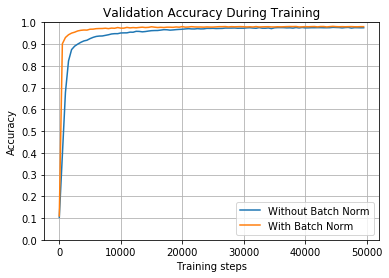

In [32]:

train_and_test(use_larger_weights=False,learning_rate=0.01,activation_fn=tf.nn.relu)

【Training Result:】


  0%|                                                                                                        | 0/5000 [00:00<?, ?it/s]

  0%|▏                                                                                             | 12/5000 [00:00<00:42, 117.96it/s]

  1%|█                                                                                             | 55/5000 [00:00<00:32, 150.36it/s]

  2%|█▉                                                                                           | 101/5000 [00:00<00:26, 186.64it/s]

  3%|██▊                                                                                          | 151/5000 [00:00<00:21, 228.37it/s]

  4%|███▊                                                                                         | 208/5000 [00:00<00:17, 277.73it/s]

  5%|████▉                                                                                        | 263/5000 [00:00<00:14, 325.74it/s]

  6%|█████▊                                                                                       | 315/5000 [00:00<00:12, 366.29it/s]

  7%|██████▊                                                                                      | 367/5000 [00:00<00:11, 401.25it/s]

  8%|███████▋                                                                                     | 416/5000 [00:00<00:10, 423.50it/s]

  9%|████████▋                                                                                    | 466/5000 [00:01<00:10, 441.85it/s]

 10%|█████████▌                                                                                   | 515/5000 [00:01<00:10, 445.69it/s]

 11%|██████████▍                                                                                  | 563/5000 [00:01<00:09, 446.91it/s]

 12%|███████████▎                                                                                 | 610/5000 [00:01<00:12, 339.25it/s]

 13%|████████████▏                                                                                | 655/5000 [00:01<00:11, 364.75it/s]

 14%|█████████████▏                                                                               | 706/5000 [00:01<00:10, 398.15it/s]

 15%|██████████████                                                                               | 756/5000 [00:01<00:10, 422.20it/s]

 16%|███████████████                                                                              | 809/5000 [00:01<00:09, 447.67it/s]

 17%|████████████████                                                                             | 863/5000 [00:01<00:08, 470.97it/s]

 19%|█████████████████▎                                                                           | 929/5000 [00:02<00:07, 513.17it/s]

 20%|██████████████████▌                                                                          | 996/5000 [00:02<00:07, 550.93it/s]

 21%|███████████████████▌                                                                        | 1064/5000 [00:02<00:06, 583.10it/s]

 22%|████████████████████▋                                                                       | 1125/5000 [00:02<00:06, 587.97it/s]

 24%|██████████████████████                                                                      | 1196/5000 [00:02<00:06, 618.75it/s]

 25%|███████████████████████▏                                                                    | 1260/5000 [00:02<00:06, 611.17it/s]

 26%|████████████████████████▍                                                                   | 1325/5000 [00:02<00:05, 621.01it/s]

 28%|█████████████████████████▌                                                                  | 1389/5000 [00:02<00:05, 625.25it/s]

 29%|██████████████████████████▋                                                                 | 1453/5000 [00:02<00:05, 620.96it/s]

 30%|███████████████████████████▉                                                                | 1516/5000 [00:03<00:07, 473.85it/s]

 32%|█████████████████████████████                                                               | 1582/5000 [00:03<00:06, 516.76it/s]

 33%|██████████████████████████████▎                                                             | 1646/5000 [00:03<00:06, 547.41it/s]

 34%|███████████████████████████████▍                                                            | 1710/5000 [00:03<00:05, 571.13it/s]

 36%|████████████████████████████████▉                                                           | 1787/5000 [00:03<00:05, 618.01it/s]

 37%|██████████████████████████████████▏                                                         | 1857/5000 [00:03<00:04, 639.24it/s]

 39%|███████████████████████████████████▍                                                        | 1927/5000 [00:03<00:04, 654.98it/s]

 40%|████████████████████████████████████▋                                                       | 1996/5000 [00:03<00:04, 661.80it/s]

 41%|█████████████████████████████████████▉                                                      | 2064/5000 [00:03<00:04, 600.63it/s]

 43%|███████████████████████████████████████▏                                                    | 2127/5000 [00:04<00:04, 577.84it/s]

 44%|████████████████████████████████████████▏                                                   | 2187/5000 [00:04<00:04, 568.20it/s]

 45%|█████████████████████████████████████████▎                                                  | 2246/5000 [00:04<00:04, 571.66it/s]

 46%|██████████████████████████████████████████▍                                                 | 2304/5000 [00:04<00:04, 542.45it/s]

 47%|███████████████████████████████████████████▍                                                | 2360/5000 [00:04<00:05, 502.43it/s]

 48%|████████████████████████████████████████████▍                                               | 2412/5000 [00:04<00:05, 500.65it/s]

 49%|█████████████████████████████████████████████▎                                              | 2463/5000 [00:04<00:06, 369.49it/s]

 50%|██████████████████████████████████████████████▎                                             | 2519/5000 [00:04<00:06, 410.82it/s]

 52%|███████████████████████████████████████████████▌                                            | 2582/5000 [00:05<00:05, 457.97it/s]

 53%|████████████████████████████████████████████████▋                                           | 2647/5000 [00:05<00:04, 501.65it/s]

 54%|█████████████████████████████████████████████████▊                                          | 2710/5000 [00:05<00:04, 533.32it/s]

 56%|███████████████████████████████████████████████████                                         | 2777/5000 [00:05<00:03, 567.03it/s]

 57%|████████████████████████████████████████████████████▎                                       | 2846/5000 [00:05<00:03, 597.91it/s]

 58%|█████████████████████████████████████████████████████▌                                      | 2909/5000 [00:05<00:03, 597.33it/s]

 60%|██████████████████████████████████████████████████████▉                                     | 2983/5000 [00:05<00:03, 632.81it/s]

 61%|████████████████████████████████████████████████████████                                    | 3049/5000 [00:05<00:03, 633.86it/s]

 62%|█████████████████████████████████████████████████████████▎                                  | 3114/5000 [00:05<00:03, 605.27it/s]

 64%|██████████████████████████████████████████████████████████▍                                 | 3176/5000 [00:05<00:03, 587.62it/s]

 65%|███████████████████████████████████████████████████████████▌                                | 3236/5000 [00:06<00:03, 583.14it/s]

 66%|████████████████████████████████████████████████████████████▋                               | 3296/5000 [00:06<00:02, 581.73it/s]

 67%|█████████████████████████████████████████████████████████████▋                              | 3355/5000 [00:06<00:03, 430.29it/s]

 68%|██████████████████████████████████████████████████████████████▊                             | 3413/5000 [00:06<00:03, 465.58it/s]

 69%|███████████████████████████████████████████████████████████████▉                            | 3472/5000 [00:06<00:03, 494.87it/s]

 71%|█████████████████████████████████████████████████████████████████                           | 3534/5000 [00:06<00:02, 524.45it/s]

 72%|██████████████████████████████████████████████████████████████████                          | 3592/5000 [00:06<00:02, 538.86it/s]

 73%|███████████████████████████████████████████████████████████████████▎                        | 3660/5000 [00:06<00:02, 573.59it/s]

 75%|████████████████████████████████████████████████████████████████████▋                       | 3735/5000 [00:07<00:02, 616.02it/s]

 76%|██████████████████████████████████████████████████████████████████████                      | 3805/5000 [00:07<00:01, 637.74it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                    | 3874/5000 [00:07<00:01, 651.22it/s]

 79%|████████████████████████████████████████████████████████████████████████▌                   | 3942/5000 [00:07<00:01, 658.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████▊                  | 4009/5000 [00:07<00:01, 639.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████                 | 4081/5000 [00:07<00:01, 660.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████▍               | 4151/5000 [00:07<00:01, 668.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋              | 4219/5000 [00:07<00:01, 668.46it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▉             | 4287/5000 [00:07<00:01, 513.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████            | 4353/5000 [00:08<00:01, 548.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍          | 4425/5000 [00:08<00:00, 588.42it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 4499/5000 [00:08<00:00, 625.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████        | 4566/5000 [00:08<00:00, 612.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 4637/5000 [00:08<00:00, 637.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▌     | 4703/5000 [00:08<00:00, 621.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▊    | 4774/5000 [00:08<00:00, 644.09it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 4848/5000 [00:08<00:00, 668.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▍ | 4917/5000 [00:08<00:00, 663.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 4985/5000 [00:08<00:00, 659.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 555.31it/s]

Without Batch Norm:the final accuracy on validation data is 0.925000011920929

  0%|                                                                                                        | 0/5000 [00:00<?, ?it/s]

  0%|                                                                                                | 1/5000 [00:00<28:20,  2.94it/s]

  1%|▌                                                                                              | 31/5000 [00:00<19:48,  4.18it/s]

  1%|█                                                                                              | 58/5000 [00:00<13:52,  5.93it/s]

  2%|█▋                                                                                             | 89/5000 [00:00<09:44,  8.41it/s]

  2%|██▏                                                                                           | 114/5000 [00:00<06:52, 11.84it/s]

  3%|██▌                                                                                           | 139/5000 [00:00<04:53, 16.57it/s]

  3%|███                                                                                           | 161/5000 [00:00<03:31, 22.86it/s]

  4%|███▍                                                                                          | 183/5000 [00:01<02:41, 29.89it/s]

  4%|███▊                                                                                          | 206/5000 [00:01<01:58, 40.41it/s]

  5%|████▎                                                                                         | 229/5000 [00:01<01:28, 53.66it/s]

  5%|████▋                                                                                         | 251/5000 [00:01<01:08, 69.22it/s]

  6%|█████▏                                                                                        | 276/5000 [00:01<00:53, 88.05it/s]

  6%|█████▌                                                                                       | 299/5000 [00:01<00:43, 107.64it/s]

  6%|██████                                                                                       | 323/5000 [00:01<00:36, 128.21it/s]

  7%|██████▍                                                                                      | 346/5000 [00:01<00:31, 146.79it/s]

  7%|██████▊                                                                                      | 369/5000 [00:01<00:28, 161.98it/s]

  8%|███████▍                                                                                     | 398/5000 [00:02<00:24, 185.73it/s]

  8%|███████▉                                                                                     | 424/5000 [00:02<00:22, 202.32it/s]

  9%|████████▍                                                                                    | 451/5000 [00:02<00:20, 218.38it/s]

 10%|████████▉                                                                                    | 478/5000 [00:02<00:19, 231.23it/s]

 10%|█████████▍                                                                                   | 507/5000 [00:02<00:18, 243.89it/s]

 11%|██████████                                                                                   | 538/5000 [00:02<00:17, 260.08it/s]

 11%|██████████▌                                                                                  | 566/5000 [00:02<00:17, 259.32it/s]

 12%|███████████                                                                                  | 595/5000 [00:02<00:16, 267.28it/s]

 12%|███████████▌                                                                                 | 623/5000 [00:02<00:16, 268.85it/s]

 13%|████████████                                                                                 | 651/5000 [00:03<00:16, 269.95it/s]

 14%|████████████▋                                                                                | 682/5000 [00:03<00:15, 278.02it/s]

 14%|█████████████▏                                                                               | 711/5000 [00:03<00:15, 278.49it/s]

 15%|█████████████▊                                                                               | 740/5000 [00:03<00:15, 278.82it/s]

 15%|██████████████▎                                                                              | 769/5000 [00:03<00:15, 270.49it/s]

 16%|██████████████▊                                                                              | 799/5000 [00:03<00:15, 275.85it/s]

 17%|███████████████▍                                                                             | 827/5000 [00:03<00:15, 268.55it/s]

 17%|███████████████▉                                                                             | 855/5000 [00:03<00:15, 267.43it/s]

 18%|████████████████▍                                                                            | 882/5000 [00:03<00:15, 267.61it/s]

 18%|████████████████▉                                                                            | 909/5000 [00:03<00:15, 266.16it/s]

 19%|█████████████████▍                                                                           | 936/5000 [00:04<00:15, 266.72it/s]

 19%|█████████████████▉                                                                           | 965/5000 [00:04<00:14, 270.46it/s]

 20%|██████████████████▌                                                                          | 995/5000 [00:04<00:14, 278.12it/s]

 20%|██████████████████▊                                                                         | 1023/5000 [00:04<00:14, 276.44it/s]

 21%|███████████████████▎                                                                        | 1051/5000 [00:04<00:14, 272.84it/s]

 22%|███████████████████▊                                                                        | 1079/5000 [00:04<00:14, 270.41it/s]

 22%|████████████████████▎                                                                       | 1107/5000 [00:04<00:18, 207.85it/s]

 23%|████████████████████▊                                                                       | 1132/5000 [00:04<00:17, 217.93it/s]

 23%|█████████████████████▎                                                                      | 1157/5000 [00:05<00:17, 225.59it/s]

 24%|█████████████████████▊                                                                      | 1186/5000 [00:05<00:15, 241.26it/s]

 24%|██████████████████████▎                                                                     | 1212/5000 [00:05<00:15, 246.08it/s]

 25%|██████████████████████▊                                                                     | 1242/5000 [00:05<00:14, 258.27it/s]

 25%|███████████████████████▎                                                                    | 1270/5000 [00:05<00:14, 262.40it/s]

 26%|███████████████████████▉                                                                    | 1299/5000 [00:05<00:13, 269.56it/s]

 27%|████████████████████████▍                                                                   | 1327/5000 [00:05<00:13, 271.24it/s]

 27%|████████████████████████▉                                                                   | 1355/5000 [00:05<00:13, 265.48it/s]

 28%|█████████████████████████▍                                                                  | 1384/5000 [00:05<00:13, 270.31it/s]

 28%|█████████████████████████▉                                                                  | 1412/5000 [00:05<00:13, 260.43it/s]

 29%|██████████████████████████▍                                                                 | 1439/5000 [00:06<00:14, 239.01it/s]

 29%|██████████████████████████▉                                                                 | 1464/5000 [00:06<00:15, 228.48it/s]

 30%|███████████████████████████▍                                                                | 1488/5000 [00:06<00:15, 228.69it/s]

 30%|███████████████████████████▊                                                                | 1512/5000 [00:06<00:15, 223.73it/s]

 31%|████████████████████████████▎                                                               | 1536/5000 [00:06<00:15, 225.97it/s]

 31%|████████████████████████████▋                                                               | 1559/5000 [00:06<00:15, 220.81it/s]

 32%|█████████████████████████████▏                                                              | 1584/5000 [00:06<00:15, 227.13it/s]

 32%|█████████████████████████████▌                                                              | 1610/5000 [00:06<00:14, 235.62it/s]

 33%|██████████████████████████████                                                              | 1637/5000 [00:06<00:13, 243.17it/s]

 33%|██████████████████████████████▌                                                             | 1663/5000 [00:07<00:13, 247.47it/s]

 34%|███████████████████████████████                                                             | 1690/5000 [00:07<00:13, 253.30it/s]

 34%|███████████████████████████████▌                                                            | 1716/5000 [00:07<00:13, 248.89it/s]

 35%|████████████████████████████████▏                                                           | 1746/5000 [00:07<00:12, 261.11it/s]

 36%|████████████████████████████████▋                                                           | 1775/5000 [00:07<00:12, 267.13it/s]

 36%|█████████████████████████████████▏                                                          | 1803/5000 [00:07<00:11, 269.51it/s]

 37%|█████████████████████████████████▋                                                          | 1834/5000 [00:07<00:11, 279.95it/s]

 37%|██████████████████████████████████▎                                                         | 1863/5000 [00:07<00:11, 280.65it/s]

 38%|██████████████████████████████████▊                                                         | 1894/5000 [00:07<00:10, 287.47it/s]

 38%|███████████████████████████████████▍                                                        | 1923/5000 [00:07<00:11, 273.79it/s]

 39%|███████████████████████████████████▉                                                        | 1951/5000 [00:08<00:11, 269.48it/s]

 40%|████████████████████████████████████▍                                                       | 1980/5000 [00:08<00:10, 274.75it/s]

 40%|████████████████████████████████████▉                                                       | 2008/5000 [00:08<00:14, 204.59it/s]

 41%|█████████████████████████████████████▍                                                      | 2038/5000 [00:08<00:13, 225.79it/s]

 41%|██████████████████████████████████████                                                      | 2066/5000 [00:08<00:12, 239.27it/s]

 42%|██████████████████████████████████████▌                                                     | 2093/5000 [00:08<00:11, 246.55it/s]

 42%|███████████████████████████████████████                                                     | 2120/5000 [00:08<00:11, 247.10it/s]

 43%|███████████████████████████████████████▌                                                    | 2148/5000 [00:08<00:11, 252.85it/s]

 44%|████████████████████████████████████████                                                    | 2175/5000 [00:09<00:11, 246.68it/s]

 44%|████████████████████████████████████████▍                                                   | 2201/5000 [00:09<00:11, 246.44it/s]

 45%|█████████████████████████████████████████                                                   | 2230/5000 [00:09<00:10, 255.54it/s]

 45%|█████████████████████████████████████████▌                                                  | 2256/5000 [00:09<00:11, 248.26it/s]

 46%|█████████████████████████████████████████▉                                                  | 2282/5000 [00:09<00:11, 244.08it/s]

 46%|██████████████████████████████████████████▍                                                 | 2307/5000 [00:09<00:11, 242.45it/s]

 47%|██████████████████████████████████████████▉                                                 | 2334/5000 [00:09<00:10, 249.60it/s]

 47%|███████████████████████████████████████████▍                                                | 2360/5000 [00:09<00:10, 249.92it/s]

 48%|███████████████████████████████████████████▉                                                | 2388/5000 [00:09<00:10, 257.72it/s]

 48%|████████████████████████████████████████████▍                                               | 2415/5000 [00:09<00:09, 259.24it/s]

 49%|████████████████████████████████████████████▉                                               | 2445/5000 [00:10<00:09, 267.56it/s]

 49%|█████████████████████████████████████████████▍                                              | 2472/5000 [00:10<00:09, 266.91it/s]

 50%|██████████████████████████████████████████████                                              | 2502/5000 [00:10<00:09, 273.99it/s]

 51%|██████████████████████████████████████████████▌                                             | 2530/5000 [00:10<00:09, 261.34it/s]

 51%|███████████████████████████████████████████████                                             | 2557/5000 [00:10<00:09, 252.27it/s]

 52%|███████████████████████████████████████████████▌                                            | 2583/5000 [00:10<00:09, 248.19it/s]

 52%|███████████████████████████████████████████████▉                                            | 2608/5000 [00:10<00:09, 242.43it/s]

 53%|████████████████████████████████████████████████▌                                           | 2636/5000 [00:10<00:09, 251.42it/s]

 53%|████████████████████████████████████████████████▉                                           | 2663/5000 [00:10<00:09, 252.60it/s]

 54%|█████████████████████████████████████████████████▌                                          | 2691/5000 [00:11<00:08, 259.71it/s]

 54%|██████████████████████████████████████████████████                                          | 2718/5000 [00:11<00:08, 259.89it/s]

 55%|██████████████████████████████████████████████████▌                                         | 2747/5000 [00:11<00:08, 266.23it/s]

 55%|███████████████████████████████████████████████████                                         | 2774/5000 [00:11<00:08, 258.37it/s]

 56%|███████████████████████████████████████████████████▌                                        | 2800/5000 [00:11<00:08, 256.01it/s]

 57%|███████████████████████████████████████████████████▉                                        | 2826/5000 [00:11<00:08, 252.90it/s]

 57%|████████████████████████████████████████████████████▍                                       | 2852/5000 [00:11<00:08, 248.62it/s]

 58%|████████████████████████████████████████████████████▉                                       | 2877/5000 [00:11<00:08, 247.75it/s]

 58%|█████████████████████████████████████████████████████▍                                      | 2903/5000 [00:11<00:08, 250.05it/s]

 59%|█████████████████████████████████████████████████████▉                                      | 2929/5000 [00:12<00:10, 189.63it/s]

 59%|██████████████████████████████████████████████████████▎                                     | 2955/5000 [00:12<00:09, 205.05it/s]

 60%|██████████████████████████████████████████████████████▉                                     | 2983/5000 [00:12<00:09, 221.51it/s]

 60%|███████████████████████████████████████████████████████▍                                    | 3012/5000 [00:12<00:08, 236.81it/s]

 61%|███████████████████████████████████████████████████████▉                                    | 3041/5000 [00:12<00:07, 249.48it/s]

 61%|████████████████████████████████████████████████████████▍                                   | 3070/5000 [00:12<00:07, 258.50it/s]

 62%|█████████████████████████████████████████████████████████                                   | 3101/5000 [00:12<00:07, 268.70it/s]

 63%|█████████████████████████████████████████████████████████▋                                  | 3132/5000 [00:12<00:06, 277.09it/s]

 63%|██████████████████████████████████████████████████████████▏                                 | 3161/5000 [00:12<00:06, 277.86it/s]

 64%|██████████████████████████████████████████████████████████▋                                 | 3190/5000 [00:13<00:06, 270.61it/s]

 64%|███████████████████████████████████████████████████████████▏                                | 3218/5000 [00:13<00:06, 267.32it/s]

 65%|███████████████████████████████████████████████████████████▋                                | 3247/5000 [00:13<00:06, 272.41it/s]

 66%|████████████████████████████████████████████████████████████▎                               | 3275/5000 [00:13<00:06, 272.46it/s]

 66%|████████████████████████████████████████████████████████████▊                               | 3303/5000 [00:13<00:06, 267.81it/s]

 67%|█████████████████████████████████████████████████████████████▎                              | 3333/5000 [00:13<00:06, 273.88it/s]

 67%|█████████████████████████████████████████████████████████████▊                              | 3361/5000 [00:13<00:06, 270.35it/s]

 68%|██████████████████████████████████████████████████████████████▍                             | 3391/5000 [00:13<00:05, 277.27it/s]

 68%|██████████████████████████████████████████████████████████████▉                             | 3419/5000 [00:13<00:05, 275.04it/s]

 69%|███████████████████████████████████████████████████████████████▍                            | 3447/5000 [00:13<00:05, 275.91it/s]

 70%|███████████████████████████████████████████████████████████████▉                            | 3475/5000 [00:14<00:05, 275.71it/s]

 70%|████████████████████████████████████████████████████████████████▍                           | 3503/5000 [00:14<00:05, 273.96it/s]

 71%|█████████████████████████████████████████████████████████████████                           | 3535/5000 [00:14<00:05, 284.24it/s]

 71%|█████████████████████████████████████████████████████████████████▌                          | 3564/5000 [00:14<00:05, 282.83it/s]

 72%|██████████████████████████████████████████████████████████████████▏                         | 3595/5000 [00:14<00:04, 289.06it/s]

 72%|██████████████████████████████████████████████████████████████████▋                         | 3624/5000 [00:14<00:04, 285.31it/s]

 73%|███████████████████████████████████████████████████████████████████▏                        | 3653/5000 [00:14<00:04, 284.39it/s]

 74%|███████████████████████████████████████████████████████████████████▋                        | 3682/5000 [00:14<00:04, 282.95it/s]

 74%|████████████████████████████████████████████████████████████████████▎                       | 3711/5000 [00:14<00:04, 280.30it/s]

 75%|████████████████████████████████████████████████████████████████████▊                       | 3740/5000 [00:15<00:04, 277.68it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                      | 3768/5000 [00:15<00:04, 277.77it/s]

 76%|█████████████████████████████████████████████████████████████████████▊                      | 3797/5000 [00:15<00:04, 279.11it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                     | 3825/5000 [00:15<00:04, 275.49it/s]

 77%|██████████████████████████████████████████████████████████████████████▉                     | 3853/5000 [00:15<00:05, 206.21it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                    | 3881/5000 [00:15<00:05, 223.52it/s]

 78%|███████████████████████████████████████████████████████████████████████▉                    | 3907/5000 [00:15<00:04, 232.89it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                   | 3932/5000 [00:15<00:04, 235.95it/s]

 79%|████████████████████████████████████████████████████████████████████████▊                   | 3960/5000 [00:15<00:04, 247.16it/s]

 80%|█████████████████████████████████████████████████████████████████████████▍                  | 3988/5000 [00:16<00:03, 255.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                  | 4016/5000 [00:16<00:03, 259.07it/s]

 81%|██████████████████████████████████████████████████████████████████████████▍                 | 4043/5000 [00:16<00:03, 256.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                 | 4070/5000 [00:16<00:03, 247.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████▎                | 4096/5000 [00:16<00:03, 250.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                | 4122/5000 [00:16<00:03, 250.94it/s]

 83%|████████████████████████████████████████████████████████████████████████████▎               | 4149/5000 [00:16<00:03, 255.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊               | 4175/5000 [00:16<00:03, 251.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▎              | 4201/5000 [00:16<00:03, 250.57it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊              | 4227/5000 [00:16<00:03, 250.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▎             | 4254/5000 [00:17<00:02, 254.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▊             | 4283/5000 [00:17<00:02, 261.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▎            | 4310/5000 [00:17<00:02, 262.12it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▊            | 4341/5000 [00:17<00:02, 273.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍           | 4369/5000 [00:17<00:02, 274.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▉           | 4401/5000 [00:17<00:02, 279.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▌          | 4432/5000 [00:17<00:01, 286.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████          | 4461/5000 [00:17<00:01, 281.36it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▌         | 4490/5000 [00:17<00:01, 280.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▏        | 4519/5000 [00:18<00:01, 271.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 4550/5000 [00:18<00:01, 279.59it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▎       | 4579/5000 [00:18<00:01, 263.62it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▊       | 4608/5000 [00:18<00:01, 268.96it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 4638/5000 [00:18<00:01, 277.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▊      | 4667/5000 [00:18<00:01, 278.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 4698/5000 [00:18<00:01, 285.16it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▉     | 4727/5000 [00:18<00:00, 284.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▌    | 4756/5000 [00:18<00:01, 216.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████    | 4783/5000 [00:19<00:00, 229.77it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▍   | 4809/5000 [00:19<00:00, 237.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████   | 4837/5000 [00:19<00:00, 248.42it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▍  | 4864/5000 [00:19<00:00, 253.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████  | 4894/5000 [00:19<00:00, 263.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 4922/5000 [00:19<00:00, 261.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 4950/5000 [00:19<00:00, 265.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▌| 4977/5000 [00:19<00:00, 259.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 251.15it/s]

With Batch Norm:the final accuracy on validation data is 0.9718000292778015


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.9186999797821045

With Batch Norm:The final accuracy on test data is 0.9703999757766724

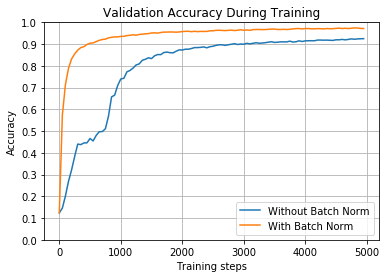

In [33]:
train_and_test(use_larger_weights=False,learning_rate=0.01,activation_fn=tf.nn.relu,training_batches=5000,
               batches_per_validate_data=50)

**从上面的实验（较小的权重初始化，较小的学习率，relu激活函数）看出，BN可以加快训练速度**  
**BN有效缓解了internal covariate shift**

## 4.2 较小的Weights初始化，较小学习率，sigmoid激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<1:38:02,  8.50it/s]

  0%|▏                                                                                           | 82/50000 [00:00<1:08:49, 12.09it/s]

  0%|▎                                                                                            | 162/50000 [00:00<48:24, 17.16it/s]

  0%|▍                                                                                            | 241/50000 [00:00<34:09, 24.28it/s]

  1%|▌                                                                                            | 318/50000 [00:00<24:11, 34.22it/s]

  1%|▋                                                                                            | 390/50000 [00:00<17:15, 47.90it/s]

  1%|▊                                                                                            | 468/50000 [00:00<12:23, 66.66it/s]

  1%|█                                                                                            | 542/50000 [00:00<08:59, 91.66it/s]

  1%|█▏                                                                                          | 613/50000 [00:00<06:38, 124.04it/s]

  1%|█▎                                                                                          | 683/50000 [00:01<05:20, 154.09it/s]

  2%|█▍                                                                                          | 764/50000 [00:01<04:02, 203.42it/s]

  2%|█▌                                                                                          | 847/50000 [00:01<03:07, 262.79it/s]

  2%|█▋                                                                                          | 924/50000 [00:01<02:30, 326.79it/s]

  2%|█▊                                                                                          | 999/50000 [00:01<02:04, 392.94it/s]

  2%|█▉                                                                                         | 1072/50000 [00:01<01:47, 455.49it/s]

  2%|██                                                                                         | 1154/50000 [00:01<01:33, 524.84it/s]

  2%|██▏                                                                                        | 1233/50000 [00:01<01:23, 582.67it/s]

  3%|██▍                                                                                        | 1310/50000 [00:01<01:19, 613.95it/s]

  3%|██▌                                                                                        | 1393/50000 [00:02<01:13, 664.78it/s]

  3%|██▋                                                                                        | 1470/50000 [00:02<01:10, 684.48it/s]

  3%|██▊                                                                                        | 1546/50000 [00:02<01:09, 698.27it/s]

  3%|██▉                                                                                        | 1622/50000 [00:02<01:26, 556.26it/s]

  3%|███                                                                                        | 1692/50000 [00:02<01:21, 591.67it/s]

  4%|███▏                                                                                       | 1763/50000 [00:02<01:17, 621.62it/s]

  4%|███▎                                                                                       | 1836/50000 [00:02<01:14, 649.33it/s]

  4%|███▍                                                                                       | 1916/50000 [00:02<01:09, 686.92it/s]

  4%|███▌                                                                                       | 1988/50000 [00:02<01:10, 677.44it/s]

  4%|███▊                                                                                       | 2062/50000 [00:03<01:09, 693.64it/s]

  4%|███▉                                                                                       | 2147/50000 [00:03<01:05, 732.77it/s]

  4%|████                                                                                       | 2231/50000 [00:03<01:02, 760.44it/s]

  5%|████▏                                                                                      | 2313/50000 [00:03<01:01, 775.76it/s]

  5%|████▎                                                                                      | 2392/50000 [00:03<01:02, 762.56it/s]

  5%|████▍                                                                                      | 2470/50000 [00:03<01:04, 731.66it/s]

  5%|████▋                                                                                      | 2545/50000 [00:03<01:32, 514.91it/s]

  5%|████▋                                                                                      | 2607/50000 [00:03<01:27, 540.04it/s]

  5%|████▊                                                                                      | 2668/50000 [00:04<01:25, 555.13it/s]

  5%|████▉                                                                                      | 2729/50000 [00:04<01:23, 569.36it/s]

  6%|█████                                                                                      | 2796/50000 [00:04<01:19, 595.07it/s]

  6%|█████▏                                                                                     | 2859/50000 [00:04<01:20, 588.66it/s]

  6%|█████▎                                                                                     | 2920/50000 [00:04<01:19, 593.63it/s]

  6%|█████▍                                                                                     | 2983/50000 [00:04<01:18, 601.11it/s]

  6%|█████▌                                                                                     | 3045/50000 [00:04<01:22, 568.80it/s]

  6%|█████▋                                                                                     | 3103/50000 [00:04<01:22, 569.20it/s]

  6%|█████▊                                                                                     | 3166/50000 [00:04<01:20, 583.36it/s]

  6%|█████▊                                                                                     | 3225/50000 [00:04<01:20, 578.92it/s]

  7%|█████▉                                                                                     | 3287/50000 [00:05<01:19, 587.76it/s]

  7%|██████                                                                                     | 3355/50000 [00:05<01:16, 609.84it/s]

  7%|██████▏                                                                                    | 3417/50000 [00:05<01:38, 473.24it/s]

  7%|██████▎                                                                                    | 3470/50000 [00:05<01:35, 485.32it/s]

  7%|██████▍                                                                                    | 3532/50000 [00:05<01:29, 518.20it/s]

  7%|██████▌                                                                                    | 3599/50000 [00:05<01:23, 553.61it/s]

  7%|██████▋                                                                                    | 3659/50000 [00:05<01:21, 565.58it/s]

  7%|██████▊                                                                                    | 3722/50000 [00:05<01:19, 580.69it/s]

  8%|██████▉                                                                                    | 3783/50000 [00:05<01:18, 587.94it/s]

  8%|██████▉                                                                                    | 3845/50000 [00:06<01:17, 594.24it/s]

  8%|███████                                                                                    | 3912/50000 [00:06<01:15, 613.87it/s]

  8%|███████▏                                                                                   | 3975/50000 [00:06<01:16, 603.15it/s]

  8%|███████▎                                                                                   | 4036/50000 [00:06<01:16, 602.09it/s]

  8%|███████▍                                                                                   | 4103/50000 [00:06<01:14, 618.00it/s]

  8%|███████▌                                                                                   | 4166/50000 [00:06<01:14, 618.40it/s]

  8%|███████▋                                                                                   | 4246/50000 [00:06<01:09, 662.38it/s]

  9%|███████▊                                                                                   | 4314/50000 [00:06<01:12, 634.52it/s]

  9%|███████▉                                                                                   | 4379/50000 [00:07<01:38, 464.53it/s]

  9%|████████                                                                                   | 4438/50000 [00:07<01:31, 495.28it/s]

  9%|████████▏                                                                                  | 4508/50000 [00:07<01:24, 540.74it/s]

  9%|████████▎                                                                                  | 4575/50000 [00:07<01:19, 572.88it/s]

  9%|████████▍                                                                                  | 4642/50000 [00:07<01:15, 597.76it/s]

  9%|████████▌                                                                                  | 4722/50000 [00:07<01:10, 644.11it/s]

 10%|████████▋                                                                                  | 4792/50000 [00:07<01:08, 658.54it/s]

 10%|████████▊                                                                                  | 4863/50000 [00:07<01:07, 671.80it/s]

 10%|█████████                                                                                  | 4946/50000 [00:07<01:03, 711.20it/s]

 10%|█████████▏                                                                                 | 5022/50000 [00:07<01:02, 723.66it/s]

 10%|█████████▎                                                                                 | 5097/50000 [00:08<01:01, 729.81it/s]

 10%|█████████▍                                                                                 | 5181/50000 [00:08<00:59, 756.16it/s]

 11%|█████████▌                                                                                 | 5258/50000 [00:08<01:16, 581.93it/s]

 11%|█████████▋                                                                                 | 5333/50000 [00:08<01:11, 622.74it/s]

 11%|█████████▊                                                                                 | 5406/50000 [00:08<01:08, 650.18it/s]

 11%|█████████▉                                                                                 | 5476/50000 [00:08<01:10, 627.43it/s]

 11%|██████████                                                                                 | 5542/50000 [00:08<01:13, 605.84it/s]

 11%|██████████▏                                                                                | 5605/50000 [00:08<01:12, 609.82it/s]

 11%|██████████▎                                                                                | 5668/50000 [00:09<01:12, 610.86it/s]

 11%|██████████▍                                                                                | 5736/50000 [00:09<01:10, 627.06it/s]

 12%|██████████▌                                                                                | 5807/50000 [00:09<01:08, 648.53it/s]

 12%|██████████▋                                                                                | 5873/50000 [00:09<01:08, 642.94it/s]

 12%|██████████▊                                                                                | 5938/50000 [00:09<01:08, 643.64it/s]

 12%|██████████▉                                                                                | 6004/50000 [00:09<01:08, 645.18it/s]

 12%|███████████                                                                                | 6077/50000 [00:09<01:06, 665.32it/s]

 12%|███████████▏                                                                               | 6160/50000 [00:09<01:02, 706.11it/s]

 12%|███████████▎                                                                               | 6232/50000 [00:09<01:17, 564.15it/s]

 13%|███████████▍                                                                               | 6299/50000 [00:10<01:14, 589.52it/s]

 13%|███████████▌                                                                               | 6366/50000 [00:10<01:11, 610.33it/s]

 13%|███████████▋                                                                               | 6447/50000 [00:10<01:06, 657.90it/s]

 13%|███████████▊                                                                               | 6519/50000 [00:10<01:04, 673.99it/s]

 13%|████████████                                                                               | 6598/50000 [00:10<01:01, 703.67it/s]

 13%|████████████▏                                                                              | 6681/50000 [00:10<00:58, 735.91it/s]

 14%|████████████▎                                                                              | 6761/50000 [00:10<00:57, 752.48it/s]

 14%|████████████▍                                                                              | 6838/50000 [00:10<00:57, 756.02it/s]

 14%|████████████▌                                                                              | 6915/50000 [00:10<00:57, 747.50it/s]

 14%|████████████▋                                                                              | 7000/50000 [00:10<00:55, 774.01it/s]

 14%|████████████▉                                                                              | 7079/50000 [00:11<00:57, 750.56it/s]

 14%|█████████████                                                                              | 7155/50000 [00:11<01:13, 580.06it/s]

 14%|█████████████▏                                                                             | 7236/50000 [00:11<01:07, 632.98it/s]

 15%|█████████████▎                                                                             | 7317/50000 [00:11<01:03, 676.15it/s]

 15%|█████████████▍                                                                             | 7396/50000 [00:11<01:00, 705.32it/s]

 15%|█████████████▌                                                                             | 7480/50000 [00:11<00:57, 739.53it/s]

 15%|█████████████▊                                                                             | 7558/50000 [00:11<00:58, 728.69it/s]

 15%|█████████████▉                                                                             | 7640/50000 [00:11<00:56, 752.36it/s]

 15%|██████████████                                                                             | 7717/50000 [00:11<00:56, 747.16it/s]

 16%|██████████████▏                                                                            | 7793/50000 [00:12<00:57, 732.06it/s]

 16%|██████████████▎                                                                            | 7874/50000 [00:12<00:55, 752.29it/s]

 16%|██████████████▍                                                                            | 7959/50000 [00:12<00:54, 775.47it/s]

 16%|██████████████▋                                                                            | 8038/50000 [00:12<01:11, 586.31it/s]

 16%|██████████████▊                                                                            | 8116/50000 [00:12<01:06, 632.38it/s]

 16%|██████████████▉                                                                            | 8193/50000 [00:12<01:02, 666.93it/s]

 17%|███████████████                                                                            | 8269/50000 [00:12<01:00, 690.99it/s]

 17%|███████████████▏                                                                           | 8351/50000 [00:12<00:57, 723.82it/s]

 17%|███████████████▎                                                                           | 8432/50000 [00:12<00:55, 746.17it/s]

 17%|███████████████▍                                                                           | 8509/50000 [00:13<00:56, 734.40it/s]

 17%|███████████████▌                                                                           | 8585/50000 [00:13<00:56, 738.16it/s]

 17%|███████████████▊                                                                           | 8665/50000 [00:13<00:54, 754.12it/s]

 17%|███████████████▉                                                                           | 8747/50000 [00:13<00:53, 771.16it/s]

 18%|████████████████                                                                           | 8830/50000 [00:13<00:52, 786.27it/s]

 18%|████████████████▏                                                                          | 8910/50000 [00:13<00:55, 746.78it/s]

 18%|████████████████▎                                                                          | 8986/50000 [00:13<01:16, 536.91it/s]

 18%|████████████████▍                                                                          | 9049/50000 [00:13<01:13, 557.75it/s]

 18%|████████████████▌                                                                          | 9112/50000 [00:14<01:13, 556.65it/s]

 18%|████████████████▋                                                                          | 9173/50000 [00:14<01:12, 562.61it/s]

 18%|████████████████▊                                                                          | 9242/50000 [00:14<01:08, 594.47it/s]

 19%|████████████████▉                                                                          | 9310/50000 [00:14<01:06, 614.88it/s]

 19%|█████████████████                                                                          | 9376/50000 [00:14<01:04, 626.46it/s]

 19%|█████████████████▏                                                                         | 9446/50000 [00:14<01:02, 643.76it/s]

 19%|█████████████████▎                                                                         | 9515/50000 [00:14<01:01, 655.60it/s]

 19%|█████████████████▍                                                                         | 9594/50000 [00:14<00:58, 689.54it/s]

 19%|█████████████████▌                                                                         | 9677/50000 [00:14<00:55, 725.03it/s]

 20%|█████████████████▊                                                                         | 9763/50000 [00:14<00:53, 757.38it/s]

 20%|█████████████████▉                                                                         | 9840/50000 [00:15<01:09, 581.12it/s]

 20%|██████████████████                                                                         | 9917/50000 [00:15<01:04, 626.16it/s]

 20%|██████████████████▏                                                                        | 9994/50000 [00:15<01:00, 662.09it/s]

 20%|██████████████████▏                                                                       | 10071/50000 [00:15<00:57, 689.79it/s]

 20%|██████████████████▎                                                                       | 10152/50000 [00:15<00:55, 720.52it/s]

 20%|██████████████████▍                                                                       | 10233/50000 [00:15<00:53, 743.72it/s]

 21%|██████████████████▌                                                                       | 10310/50000 [00:15<00:53, 739.04it/s]

 21%|██████████████████▋                                                                       | 10392/50000 [00:15<00:52, 760.05it/s]

 21%|██████████████████▊                                                                       | 10475/50000 [00:16<00:50, 778.17it/s]

 21%|██████████████████▉                                                                       | 10554/50000 [00:16<00:52, 749.01it/s]

 21%|███████████████████▏                                                                      | 10637/50000 [00:16<00:51, 770.03it/s]

 21%|███████████████████▎                                                                      | 10719/50000 [00:16<00:50, 782.73it/s]

 22%|███████████████████▍                                                                      | 10798/50000 [00:16<01:07, 583.98it/s]

 22%|███████████████████▌                                                                      | 10872/50000 [00:16<01:03, 620.70it/s]

 22%|███████████████████▋                                                                      | 10950/50000 [00:16<00:59, 659.99it/s]

 22%|███████████████████▊                                                                      | 11021/50000 [00:16<00:59, 656.09it/s]

 22%|███████████████████▉                                                                      | 11102/50000 [00:16<00:56, 694.45it/s]

 22%|████████████████████                                                                      | 11176/50000 [00:17<00:54, 706.04it/s]

 23%|████████████████████▎                                                                     | 11252/50000 [00:17<00:53, 719.90it/s]

 23%|████████████████████▍                                                                     | 11334/50000 [00:17<00:51, 745.78it/s]

 23%|████████████████████▌                                                                     | 11415/50000 [00:17<00:50, 762.37it/s]

 23%|████████████████████▋                                                                     | 11495/50000 [00:17<00:49, 771.65it/s]

 23%|████████████████████▊                                                                     | 11573/50000 [00:17<00:50, 754.57it/s]

 23%|████████████████████▉                                                                     | 11654/50000 [00:17<00:49, 768.78it/s]

 23%|█████████████████████                                                                     | 11732/50000 [00:17<01:04, 589.32it/s]

 24%|█████████████████████▎                                                                    | 11816/50000 [00:17<00:59, 644.69it/s]

 24%|█████████████████████▍                                                                    | 11887/50000 [00:18<00:57, 657.96it/s]

 24%|█████████████████████▌                                                                    | 11967/50000 [00:18<00:54, 693.66it/s]

 24%|█████████████████████▋                                                                    | 12041/50000 [00:18<00:53, 705.46it/s]

 24%|█████████████████████▊                                                                    | 12124/50000 [00:18<00:51, 737.28it/s]

 24%|█████████████████████▉                                                                    | 12204/50000 [00:18<00:50, 753.48it/s]

 25%|██████████████████████                                                                    | 12281/50000 [00:18<00:50, 750.11it/s]

 25%|██████████████████████▏                                                                   | 12358/50000 [00:18<00:53, 708.65it/s]

 25%|██████████████████████▍                                                                   | 12431/50000 [00:18<00:57, 652.35it/s]

 25%|██████████████████████▍                                                                   | 12499/50000 [00:18<00:57, 653.32it/s]

 25%|██████████████████████▌                                                                   | 12566/50000 [00:19<01:01, 611.95it/s]

 25%|██████████████████████▋                                                                   | 12629/50000 [00:19<01:20, 464.96it/s]

 25%|██████████████████████▊                                                                   | 12695/50000 [00:19<01:13, 508.16it/s]

 26%|██████████████████████▉                                                                   | 12757/50000 [00:19<01:09, 534.83it/s]

 26%|███████████████████████                                                                   | 12826/50000 [00:19<01:04, 572.48it/s]

 26%|███████████████████████▏                                                                  | 12887/50000 [00:19<01:03, 582.02it/s]

 26%|███████████████████████▎                                                                  | 12953/50000 [00:19<01:01, 602.20it/s]

 26%|███████████████████████▍                                                                  | 13028/50000 [00:19<00:57, 638.85it/s]

 26%|███████████████████████▌                                                                  | 13106/50000 [00:19<00:54, 672.50it/s]

 26%|███████████████████████▋                                                                  | 13176/50000 [00:20<00:55, 659.92it/s]

 27%|███████████████████████▊                                                                  | 13258/50000 [00:20<00:52, 699.66it/s]

 27%|████████████████████████                                                                  | 13345/50000 [00:20<00:49, 740.04it/s]

 27%|████████████████████████▏                                                                 | 13428/50000 [00:20<00:47, 763.38it/s]

 27%|████████████████████████▎                                                                 | 13506/50000 [00:20<01:03, 577.97it/s]

 27%|████████████████████████▍                                                                 | 13572/50000 [00:20<01:05, 559.60it/s]

 27%|████████████████████████▌                                                                 | 13634/50000 [00:20<01:05, 553.79it/s]

 27%|████████████████████████▋                                                                 | 13694/50000 [00:20<01:04, 560.97it/s]

 28%|████████████████████████▊                                                                 | 13760/50000 [00:21<01:01, 586.27it/s]

 28%|████████████████████████▉                                                                 | 13821/50000 [00:21<01:01, 591.93it/s]

 28%|████████████████████████▉                                                                 | 13885/50000 [00:21<00:59, 602.62it/s]

 28%|█████████████████████████▏                                                                | 13959/50000 [00:21<00:56, 636.96it/s]

 28%|█████████████████████████▎                                                                | 14030/50000 [00:21<00:54, 655.91it/s]

 28%|█████████████████████████▍                                                                | 14100/50000 [00:21<00:53, 667.15it/s]

 28%|█████████████████████████▌                                                                | 14168/50000 [00:21<00:54, 659.79it/s]

 28%|█████████████████████████▌                                                                | 14236/50000 [00:21<00:53, 664.30it/s]

 29%|█████████████████████████▊                                                                | 14306/50000 [00:21<00:53, 673.20it/s]

 29%|█████████████████████████▉                                                                | 14376/50000 [00:21<00:52, 679.57it/s]

 29%|██████████████████████████                                                                | 14445/50000 [00:22<01:10, 506.24it/s]

 29%|██████████████████████████                                                                | 14503/50000 [00:22<01:07, 523.85it/s]

 29%|██████████████████████████▏                                                               | 14568/50000 [00:22<01:03, 555.20it/s]

 29%|██████████████████████████▎                                                               | 14647/50000 [00:22<00:58, 608.52it/s]

 29%|██████████████████████████▌                                                               | 14729/50000 [00:22<00:53, 658.39it/s]

 30%|██████████████████████████▋                                                               | 14808/50000 [00:22<00:50, 691.70it/s]

 30%|██████████████████████████▊                                                               | 14892/50000 [00:22<00:48, 728.99it/s]

 30%|██████████████████████████▉                                                               | 14968/50000 [00:22<00:49, 707.73it/s]

 30%|███████████████████████████                                                               | 15041/50000 [00:23<00:49, 710.66it/s]

 30%|███████████████████████████▏                                                              | 15121/50000 [00:23<00:47, 733.82it/s]

 30%|███████████████████████████▎                                                              | 15196/50000 [00:23<00:47, 734.85it/s]

 31%|███████████████████████████▌                                                              | 15279/50000 [00:23<00:45, 759.49it/s]

 31%|███████████████████████████▋                                                              | 15356/50000 [00:23<00:59, 581.99it/s]

 31%|███████████████████████████▊                                                              | 15426/50000 [00:23<00:56, 611.82it/s]

 31%|███████████████████████████▉                                                              | 15493/50000 [00:23<00:57, 604.88it/s]

 31%|████████████████████████████                                                              | 15558/50000 [00:23<00:57, 602.77it/s]

 31%|████████████████████████████▏                                                             | 15627/50000 [00:23<00:54, 625.29it/s]

 31%|████████████████████████████▏                                                             | 15692/50000 [00:24<00:54, 627.52it/s]

 32%|████████████████████████████▎                                                             | 15757/50000 [00:24<00:57, 599.56it/s]

 32%|████████████████████████████▍                                                             | 15828/50000 [00:24<00:54, 627.69it/s]

 32%|████████████████████████████▌                                                             | 15892/50000 [00:24<00:54, 629.97it/s]

 32%|████████████████████████████▋                                                             | 15963/50000 [00:24<00:52, 648.93it/s]

 32%|████████████████████████████▊                                                             | 16031/50000 [00:24<00:51, 656.56it/s]

 32%|████████████████████████████▉                                                             | 16103/50000 [00:24<00:50, 673.00it/s]

 32%|█████████████████████████████▏                                                            | 16186/50000 [00:24<00:47, 712.15it/s]

 33%|█████████████████████████████▎                                                            | 16259/50000 [00:24<01:00, 556.00it/s]

 33%|█████████████████████████████▍                                                            | 16335/50000 [00:25<00:55, 603.64it/s]

 33%|█████████████████████████████▌                                                            | 16402/50000 [00:25<00:54, 620.86it/s]

 33%|█████████████████████████████▋                                                            | 16487/50000 [00:25<00:49, 674.32it/s]

 33%|█████████████████████████████▊                                                            | 16559/50000 [00:25<00:49, 680.15it/s]

 33%|█████████████████████████████▉                                                            | 16641/50000 [00:25<00:46, 715.46it/s]

 33%|██████████████████████████████                                                            | 16723/50000 [00:25<00:44, 742.43it/s]

 34%|██████████████████████████████▎                                                           | 16806/50000 [00:25<00:43, 765.15it/s]

 34%|██████████████████████████████▍                                                           | 16887/50000 [00:25<00:42, 776.44it/s]

 34%|██████████████████████████████▌                                                           | 16973/50000 [00:25<00:41, 795.91it/s]

 34%|██████████████████████████████▋                                                           | 17054/50000 [00:25<00:41, 789.05it/s]

 34%|██████████████████████████████▊                                                           | 17138/50000 [00:26<00:40, 802.00it/s]

 34%|██████████████████████████████▉                                                           | 17219/50000 [00:26<00:54, 603.90it/s]

 35%|███████████████████████████████▏                                                          | 17295/50000 [00:26<00:50, 642.36it/s]

 35%|███████████████████████████████▎                                                          | 17371/50000 [00:26<00:48, 670.54it/s]

 35%|███████████████████████████████▍                                                          | 17443/50000 [00:26<00:51, 631.27it/s]

 35%|███████████████████████████████▌                                                          | 17517/50000 [00:26<00:49, 657.34it/s]

 35%|███████████████████████████████▋                                                          | 17600/50000 [00:26<00:46, 699.79it/s]

 35%|███████████████████████████████▊                                                          | 17677/50000 [00:26<00:45, 717.99it/s]

 36%|███████████████████████████████▉                                                          | 17757/50000 [00:27<00:43, 739.29it/s]

 36%|████████████████████████████████                                                          | 17834/50000 [00:27<00:43, 746.62it/s]

 36%|████████████████████████████████▏                                                         | 17914/50000 [00:27<00:42, 760.31it/s]

 36%|████████████████████████████████▍                                                         | 17999/50000 [00:27<00:40, 783.58it/s]

 36%|████████████████████████████████▌                                                         | 18079/50000 [00:27<00:40, 782.13it/s]

 36%|████████████████████████████████▋                                                         | 18158/50000 [00:27<00:53, 599.66it/s]

 36%|████████████████████████████████▊                                                         | 18238/50000 [00:27<00:49, 647.22it/s]

 37%|████████████████████████████████▉                                                         | 18313/50000 [00:27<00:47, 673.65it/s]

 37%|█████████████████████████████████                                                         | 18393/50000 [00:27<00:44, 705.78it/s]

 37%|█████████████████████████████████▎                                                        | 18474/50000 [00:28<00:43, 732.67it/s]

 37%|█████████████████████████████████▍                                                        | 18550/50000 [00:28<00:44, 706.20it/s]

 37%|█████████████████████████████████▌                                                        | 18631/50000 [00:28<00:42, 732.98it/s]

 37%|█████████████████████████████████▋                                                        | 18709/50000 [00:28<00:42, 744.90it/s]

 38%|█████████████████████████████████▊                                                        | 18791/50000 [00:28<00:40, 764.40it/s]

 38%|█████████████████████████████████▉                                                        | 18871/50000 [00:28<00:40, 773.10it/s]

 38%|██████████████████████████████████                                                        | 18950/50000 [00:28<00:41, 747.83it/s]

 38%|██████████████████████████████████▏                                                       | 19026/50000 [00:28<00:58, 529.45it/s]

 38%|██████████████████████████████████▎                                                       | 19090/50000 [00:29<00:55, 557.32it/s]

 38%|██████████████████████████████████▍                                                       | 19158/50000 [00:29<00:52, 588.09it/s]

 38%|██████████████████████████████████▌                                                       | 19225/50000 [00:29<00:50, 607.61it/s]

 39%|██████████████████████████████████▋                                                       | 19296/50000 [00:29<00:48, 633.85it/s]

 39%|██████████████████████████████████▊                                                       | 19368/50000 [00:29<00:46, 656.13it/s]

 39%|██████████████████████████████████▉                                                       | 19436/50000 [00:29<00:46, 659.78it/s]

 39%|███████████████████████████████████                                                       | 19504/50000 [00:29<00:46, 658.52it/s]

 39%|███████████████████████████████████▎                                                      | 19588/50000 [00:29<00:43, 701.11it/s]

 39%|███████████████████████████████████▍                                                      | 19671/50000 [00:29<00:41, 733.95it/s]

 40%|███████████████████████████████████▌                                                      | 19754/50000 [00:29<00:39, 758.82it/s]

 40%|███████████████████████████████████▋                                                      | 19832/50000 [00:30<00:39, 754.57it/s]

 40%|███████████████████████████████████▊                                                      | 19915/50000 [00:30<00:38, 774.14it/s]

 40%|███████████████████████████████████▉                                                      | 19994/50000 [00:30<00:50, 596.36it/s]

 40%|████████████████████████████████████                                                      | 20068/50000 [00:30<00:47, 632.05it/s]

 40%|████████████████████████████████████▎                                                     | 20151/50000 [00:30<00:44, 677.87it/s]

 40%|████████████████████████████████████▍                                                     | 20235/50000 [00:30<00:41, 718.19it/s]

 41%|████████████████████████████████████▌                                                     | 20318/50000 [00:30<00:39, 746.96it/s]

 41%|████████████████████████████████████▋                                                     | 20398/50000 [00:30<00:38, 760.53it/s]

 41%|████████████████████████████████████▊                                                     | 20479/50000 [00:30<00:38, 773.10it/s]

 41%|█████████████████████████████████████                                                     | 20558/50000 [00:31<00:38, 765.17it/s]

 41%|█████████████████████████████████████▏                                                    | 20644/50000 [00:31<00:37, 789.76it/s]

 41%|█████████████████████████████████████▎                                                    | 20724/50000 [00:31<00:37, 784.12it/s]

 42%|█████████████████████████████████████▍                                                    | 20808/50000 [00:31<00:36, 798.42it/s]

 42%|█████████████████████████████████████▌                                                    | 20889/50000 [00:31<00:48, 602.48it/s]

 42%|█████████████████████████████████████▋                                                    | 20970/50000 [00:31<00:44, 651.49it/s]

 42%|█████████████████████████████████████▉                                                    | 21042/50000 [00:31<00:43, 669.27it/s]

 42%|██████████████████████████████████████                                                    | 21121/50000 [00:31<00:41, 700.06it/s]

 42%|██████████████████████████████████████▏                                                   | 21202/50000 [00:31<00:39, 728.34it/s]

 43%|██████████████████████████████████████▎                                                   | 21278/50000 [00:32<00:39, 731.75it/s]

 43%|██████████████████████████████████████▍                                                   | 21354/50000 [00:32<00:39, 734.16it/s]

 43%|██████████████████████████████████████▌                                                   | 21429/50000 [00:32<00:40, 702.14it/s]

 43%|██████████████████████████████████████▋                                                   | 21501/50000 [00:32<00:41, 693.68it/s]

 43%|██████████████████████████████████████▊                                                   | 21577/50000 [00:32<00:40, 708.88it/s]

 43%|██████████████████████████████████████▉                                                   | 21658/50000 [00:32<00:38, 731.03it/s]

 43%|███████████████████████████████████████                                                   | 21735/50000 [00:32<00:38, 740.74it/s]

 44%|███████████████████████████████████████▎                                                  | 21810/50000 [00:32<00:49, 575.08it/s]

 44%|███████████████████████████████████████▍                                                  | 21889/50000 [00:32<00:44, 625.10it/s]

 44%|███████████████████████████████████████▌                                                  | 21969/50000 [00:33<00:41, 667.75it/s]

 44%|███████████████████████████████████████▋                                                  | 22041/50000 [00:33<00:41, 675.46it/s]

 44%|███████████████████████████████████████▊                                                  | 22123/50000 [00:33<00:39, 711.82it/s]

 44%|███████████████████████████████████████▉                                                  | 22204/50000 [00:33<00:37, 737.20it/s]

 45%|████████████████████████████████████████                                                  | 22286/50000 [00:33<00:36, 758.69it/s]

 45%|████████████████████████████████████████▎                                                 | 22364/50000 [00:33<00:37, 735.33it/s]

 45%|████████████████████████████████████████▍                                                 | 22439/50000 [00:33<00:39, 695.10it/s]

 45%|████████████████████████████████████████▌                                                 | 22510/50000 [00:33<00:41, 661.04it/s]

 45%|████████████████████████████████████████▋                                                 | 22578/50000 [00:33<00:41, 655.60it/s]

 45%|████████████████████████████████████████▊                                                 | 22645/50000 [00:34<00:43, 630.62it/s]

 45%|████████████████████████████████████████▉                                                 | 22709/50000 [00:34<00:58, 466.59it/s]

 46%|████████████████████████████████████████▉                                                 | 22772/50000 [00:34<00:53, 505.07it/s]

 46%|█████████████████████████████████████████                                                 | 22835/50000 [00:34<00:50, 536.02it/s]

 46%|█████████████████████████████████████████▏                                                | 22898/50000 [00:34<00:48, 560.04it/s]

 46%|█████████████████████████████████████████▎                                                | 22969/50000 [00:34<00:45, 596.83it/s]

 46%|█████████████████████████████████████████▍                                                | 23045/50000 [00:34<00:42, 636.74it/s]

 46%|█████████████████████████████████████████▌                                                | 23124/50000 [00:34<00:39, 674.83it/s]

 46%|█████████████████████████████████████████▊                                                | 23197/50000 [00:35<00:38, 689.05it/s]

 47%|█████████████████████████████████████████▉                                                | 23272/50000 [00:35<00:37, 704.81it/s]

 47%|██████████████████████████████████████████                                                | 23348/50000 [00:35<00:37, 719.02it/s]

 47%|██████████████████████████████████████████▏                                               | 23433/50000 [00:35<00:35, 752.41it/s]

 47%|██████████████████████████████████████████▎                                               | 23510/50000 [00:35<00:35, 738.61it/s]

 47%|██████████████████████████████████████████▍                                               | 23585/50000 [00:35<00:45, 578.16it/s]

 47%|██████████████████████████████████████████▌                                               | 23659/50000 [00:35<00:42, 617.62it/s]

 47%|██████████████████████████████████████████▋                                               | 23742/50000 [00:35<00:39, 667.80it/s]

 48%|██████████████████████████████████████████▉                                               | 23826/50000 [00:35<00:36, 710.24it/s]

 48%|███████████████████████████████████████████                                               | 23910/50000 [00:36<00:35, 743.31it/s]

 48%|███████████████████████████████████████████▏                                              | 23989/50000 [00:36<00:34, 755.14it/s]

 48%|███████████████████████████████████████████▎                                              | 24067/50000 [00:36<00:35, 739.23it/s]

 48%|███████████████████████████████████████████▍                                              | 24147/50000 [00:36<00:34, 754.90it/s]

 48%|███████████████████████████████████████████▌                                              | 24228/50000 [00:36<00:33, 769.02it/s]

 49%|███████████████████████████████████████████▊                                              | 24311/50000 [00:36<00:32, 784.73it/s]

 49%|███████████████████████████████████████████▉                                              | 24391/50000 [00:36<00:34, 752.09it/s]

 49%|████████████████████████████████████████████                                              | 24468/50000 [00:36<00:36, 698.34it/s]

 49%|████████████████████████████████████████████▏                                             | 24540/50000 [00:37<00:50, 507.45it/s]

 49%|████████████████████████████████████████████▎                                             | 24600/50000 [00:37<00:48, 524.10it/s]

 49%|████████████████████████████████████████████▍                                             | 24660/50000 [00:37<00:46, 543.69it/s]

 49%|████████████████████████████████████████████▌                                             | 24725/50000 [00:37<00:44, 570.64it/s]

 50%|████████████████████████████████████████████▌                                             | 24790/50000 [00:37<00:42, 589.56it/s]

 50%|████████████████████████████████████████████▋                                             | 24852/50000 [00:37<00:42, 595.39it/s]

 50%|████████████████████████████████████████████▊                                             | 24916/50000 [00:37<00:41, 606.85it/s]

 50%|████████████████████████████████████████████▉                                             | 24985/50000 [00:37<00:39, 628.35it/s]

 50%|█████████████████████████████████████████████                                             | 25051/50000 [00:37<00:39, 636.18it/s]

 50%|█████████████████████████████████████████████▏                                            | 25121/50000 [00:37<00:38, 652.73it/s]

 50%|█████████████████████████████████████████████▎                                            | 25193/50000 [00:38<00:37, 670.18it/s]

 51%|█████████████████████████████████████████████▍                                            | 25268/50000 [00:38<00:35, 690.88it/s]

 51%|█████████████████████████████████████████████▌                                            | 25338/50000 [00:38<00:36, 684.00it/s]

 51%|█████████████████████████████████████████████▊                                            | 25417/50000 [00:38<00:43, 560.33it/s]

 51%|█████████████████████████████████████████████▉                                            | 25493/50000 [00:38<00:40, 607.21it/s]

 51%|██████████████████████████████████████████████                                            | 25558/50000 [00:38<00:39, 611.20it/s]

 51%|██████████████████████████████████████████████                                            | 25622/50000 [00:38<00:40, 607.71it/s]

 51%|██████████████████████████████████████████████▏                                           | 25685/50000 [00:38<00:39, 611.14it/s]

 51%|██████████████████████████████████████████████▎                                           | 25749/50000 [00:38<00:39, 616.43it/s]

 52%|██████████████████████████████████████████████▍                                           | 25812/50000 [00:39<00:40, 603.14it/s]

 52%|██████████████████████████████████████████████▌                                           | 25874/50000 [00:39<00:40, 594.61it/s]

 52%|██████████████████████████████████████████████▋                                           | 25938/50000 [00:39<00:39, 606.28it/s]

 52%|██████████████████████████████████████████████▊                                           | 26000/50000 [00:39<00:39, 605.45it/s]

 52%|██████████████████████████████████████████████▉                                           | 26062/50000 [00:39<00:39, 608.43it/s]

 52%|███████████████████████████████████████████████                                           | 26127/50000 [00:39<00:38, 617.28it/s]

 52%|███████████████████████████████████████████████▏                                          | 26193/50000 [00:39<00:38, 626.41it/s]

 53%|███████████████████████████████████████████████▎                                          | 26273/50000 [00:39<00:35, 668.80it/s]

 53%|███████████████████████████████████████████████▍                                          | 26341/50000 [00:39<00:44, 533.66it/s]

 53%|███████████████████████████████████████████████▌                                          | 26418/50000 [00:40<00:40, 586.80it/s]

 53%|███████████████████████████████████████████████▋                                          | 26490/50000 [00:40<00:37, 620.11it/s]

 53%|███████████████████████████████████████████████▊                                          | 26557/50000 [00:40<00:39, 599.10it/s]

 53%|███████████████████████████████████████████████▉                                          | 26625/50000 [00:40<00:37, 620.03it/s]

 53%|████████████████████████████████████████████████                                          | 26698/50000 [00:40<00:35, 648.11it/s]

 54%|████████████████████████████████████████████████▏                                         | 26766/50000 [00:40<00:35, 654.08it/s]

 54%|████████████████████████████████████████████████▎                                         | 26833/50000 [00:40<00:35, 653.53it/s]

 54%|████████████████████████████████████████████████▍                                         | 26903/50000 [00:40<00:34, 663.53it/s]

 54%|████████████████████████████████████████████████▌                                         | 26971/50000 [00:40<00:37, 606.44it/s]

 54%|████████████████████████████████████████████████▋                                         | 27034/50000 [00:41<00:40, 569.01it/s]

 54%|████████████████████████████████████████████████▊                                         | 27093/50000 [00:41<00:40, 570.61it/s]

 54%|████████████████████████████████████████████████▉                                         | 27156/50000 [00:41<00:39, 584.39it/s]

 54%|████████████████████████████████████████████████▉                                         | 27216/50000 [00:41<00:39, 579.23it/s]

 55%|█████████████████████████████████████████████████                                         | 27275/50000 [00:41<00:51, 444.82it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27360/50000 [00:41<00:43, 517.41it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27443/50000 [00:41<00:38, 582.42it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27521/50000 [00:41<00:35, 629.21it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27594/50000 [00:41<00:34, 655.10it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27674/50000 [00:42<00:32, 691.43it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27748/50000 [00:42<00:32, 690.10it/s]

 56%|██████████████████████████████████████████████████                                        | 27820/50000 [00:42<00:31, 695.31it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27895/50000 [00:42<00:31, 707.39it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27975/50000 [00:42<00:30, 731.37it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28050/50000 [00:42<00:30, 726.75it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28135/50000 [00:42<00:28, 758.32it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28212/50000 [00:42<00:37, 586.81it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28295/50000 [00:42<00:33, 642.27it/s]

 57%|███████████████████████████████████████████████████                                       | 28377/50000 [00:43<00:31, 683.97it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28453/50000 [00:43<00:30, 703.70it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28528/50000 [00:43<00:30, 693.70it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28602/50000 [00:43<00:30, 705.49it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28687/50000 [00:43<00:28, 741.99it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28764/50000 [00:43<00:28, 733.64it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28839/50000 [00:43<00:29, 726.20it/s]

 58%|████████████████████████████████████████████████████                                      | 28913/50000 [00:43<00:30, 699.85it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28984/50000 [00:43<00:30, 695.18it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29055/50000 [00:44<00:32, 653.81it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29122/50000 [00:44<00:43, 482.87it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29183/50000 [00:44<00:40, 514.12it/s]

 58%|████████████████████████████████████████████████████▋                                     | 29243/50000 [00:44<00:38, 534.71it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29304/50000 [00:44<00:37, 554.16it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29367/50000 [00:44<00:35, 573.78it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29427/50000 [00:44<00:35, 571.90it/s]

 59%|█████████████████████████████████████████████████████                                     | 29486/50000 [00:44<00:35, 574.30it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29548/50000 [00:44<00:34, 584.41it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29608/50000 [00:45<00:35, 577.58it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29667/50000 [00:45<00:35, 569.94it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29725/50000 [00:45<00:35, 568.33it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29791/50000 [00:45<00:34, 591.88it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29861/50000 [00:45<00:32, 617.80it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29926/50000 [00:45<00:32, 625.80it/s]

 60%|██████████████████████████████████████████████████████                                    | 30001/50000 [00:45<00:38, 515.36it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30080/50000 [00:45<00:34, 574.45it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30156/50000 [00:46<00:32, 618.75it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30241/50000 [00:46<00:29, 672.57it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30320/50000 [00:46<00:28, 702.59it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30394/50000 [00:46<00:27, 701.81it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30472/50000 [00:46<00:27, 722.10it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30551/50000 [00:46<00:26, 737.62it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30634/50000 [00:46<00:25, 761.57it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30718/50000 [00:46<00:24, 781.92it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30798/50000 [00:46<00:27, 702.95it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30871/50000 [00:46<00:27, 689.30it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30942/50000 [00:47<00:36, 515.89it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31005/50000 [00:47<00:34, 544.50it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31085/50000 [00:47<00:31, 601.21it/s]

 62%|████████████████████████████████████████████████████████                                  | 31168/50000 [00:47<00:28, 654.27it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31248/50000 [00:47<00:27, 690.78it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31334/50000 [00:47<00:25, 732.75it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31420/50000 [00:47<00:24, 763.26it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31501/50000 [00:47<00:23, 775.07it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31583/50000 [00:48<00:23, 786.37it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31667/50000 [00:48<00:22, 800.05it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31751/50000 [00:48<00:22, 809.92it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31833/50000 [00:48<00:23, 772.29it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31912/50000 [00:48<00:30, 594.25it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31996/50000 [00:48<00:27, 650.32it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32073/50000 [00:48<00:26, 680.80it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32156/50000 [00:48<00:24, 718.25it/s]

 64%|██████████████████████████████████████████████████████████                                | 32240/50000 [00:48<00:23, 749.43it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32325/50000 [00:49<00:22, 775.46it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32409/50000 [00:49<00:22, 792.11it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32490/50000 [00:49<00:22, 772.96it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32569/50000 [00:49<00:23, 752.00it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32652/50000 [00:49<00:22, 770.09it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32730/50000 [00:49<00:23, 749.20it/s]

 66%|███████████████████████████████████████████████████████████                               | 32806/50000 [00:49<00:32, 533.26it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32869/50000 [00:49<00:31, 547.77it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32931/50000 [00:50<00:30, 566.47it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 32998/50000 [00:50<00:28, 591.29it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33065/50000 [00:50<00:27, 611.67it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33129/50000 [00:50<00:27, 615.03it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33201/50000 [00:50<00:26, 641.90it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33275/50000 [00:50<00:25, 667.17it/s]

 67%|████████████████████████████████████████████████████████████                              | 33357/50000 [00:50<00:23, 705.35it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33443/50000 [00:50<00:22, 744.16it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33523/50000 [00:50<00:21, 758.49it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33609/50000 [00:50<00:20, 784.77it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33689/50000 [00:51<00:27, 600.18it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33771/50000 [00:51<00:24, 651.53it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33843/50000 [00:51<00:24, 663.76it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33921/50000 [00:51<00:23, 693.47it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34001/50000 [00:51<00:22, 720.90it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34084/50000 [00:51<00:21, 746.99it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34168/50000 [00:51<00:20, 771.10it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34251/50000 [00:51<00:20, 786.24it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34332/50000 [00:51<00:19, 791.52it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34413/50000 [00:52<00:19, 786.02it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34498/50000 [00:52<00:19, 800.26it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34579/50000 [00:52<00:19, 792.04it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34659/50000 [00:52<00:25, 600.44it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34742/50000 [00:52<00:23, 653.61it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34814/50000 [00:52<00:24, 622.29it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34882/50000 [00:52<00:24, 609.88it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34947/50000 [00:52<00:24, 606.24it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35011/50000 [00:53<00:24, 607.71it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35079/50000 [00:53<00:23, 626.46it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35143/50000 [00:53<00:23, 627.24it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35207/50000 [00:53<00:23, 616.96it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35273/50000 [00:53<00:23, 627.96it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35340/50000 [00:53<00:22, 638.67it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35406/50000 [00:53<00:22, 641.67it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35471/50000 [00:53<00:22, 642.74it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35536/50000 [00:53<00:30, 481.07it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35594/50000 [00:54<00:28, 506.04it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35659/50000 [00:54<00:26, 539.69it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35721/50000 [00:54<00:25, 558.92it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35785/50000 [00:54<00:24, 579.85it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35852/50000 [00:54<00:23, 603.05it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35934/50000 [00:54<00:21, 652.34it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36002/50000 [00:54<00:21, 645.86it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36069/50000 [00:54<00:21, 645.92it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36137/50000 [00:54<00:21, 654.39it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36204/50000 [00:54<00:21, 655.66it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36271/50000 [00:55<00:21, 634.23it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36338/50000 [00:55<00:21, 641.35it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36403/50000 [00:55<00:21, 620.51it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36466/50000 [00:55<00:28, 468.40it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36539/50000 [00:55<00:25, 523.99it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36621/50000 [00:55<00:22, 586.71it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36702/50000 [00:55<00:20, 638.50it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36787/50000 [00:55<00:19, 687.11it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36869/50000 [00:56<00:18, 718.95it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36954/50000 [00:56<00:17, 752.35it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37034/50000 [00:56<00:16, 764.43it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37113/50000 [00:56<00:16, 759.20it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37191/50000 [00:56<00:16, 759.24it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37276/50000 [00:56<00:16, 780.63it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37356/50000 [00:56<00:20, 603.89it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37441/50000 [00:56<00:19, 660.21it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37514/50000 [00:56<00:18, 678.32it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37597/50000 [00:57<00:17, 716.31it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37680/50000 [00:57<00:16, 745.53it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37762/50000 [00:57<00:16, 764.85it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37841/50000 [00:57<00:16, 750.85it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37925/50000 [00:57<00:15, 773.98it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38005/50000 [00:57<00:15, 779.93it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38084/50000 [00:57<00:15, 778.93it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38168/50000 [00:57<00:14, 794.64it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38251/50000 [00:57<00:18, 628.52it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38327/50000 [00:58<00:17, 661.66it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38404/50000 [00:58<00:16, 689.46it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38489/50000 [00:58<00:15, 729.50it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38566/50000 [00:58<00:16, 691.91it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38648/50000 [00:58<00:15, 724.52it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38732/50000 [00:58<00:14, 754.20it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38816/50000 [00:58<00:14, 776.47it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38900/50000 [00:58<00:14, 792.85it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38981/50000 [00:58<00:13, 793.87it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39062/50000 [00:58<00:14, 763.22it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39146/50000 [00:59<00:13, 783.13it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39225/50000 [00:59<00:18, 571.48it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39298/50000 [00:59<00:17, 610.21it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39379/50000 [00:59<00:16, 657.80it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39451/50000 [00:59<00:16, 650.24it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39521/50000 [00:59<00:17, 594.01it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39591/50000 [00:59<00:16, 621.07it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39658/50000 [00:59<00:16, 633.66it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39724/50000 [01:00<00:16, 638.13it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39794/50000 [01:00<00:15, 654.15it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39864/50000 [01:00<00:15, 664.00it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39932/50000 [01:00<00:15, 651.97it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40001/50000 [01:00<00:15, 657.76it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40076/50000 [01:00<00:14, 681.60it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40145/50000 [01:00<00:18, 529.13it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40231/50000 [01:00<00:16, 597.26it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40316/50000 [01:00<00:14, 654.65it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40401/50000 [01:01<00:13, 701.85it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40486/50000 [01:01<00:12, 739.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40565/50000 [01:01<00:12, 735.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40642/50000 [01:01<00:13, 718.92it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40725/50000 [01:01<00:12, 745.51it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40811/50000 [01:01<00:11, 774.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40895/50000 [01:01<00:11, 791.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40977/50000 [01:01<00:11, 798.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41058/50000 [01:02<00:14, 598.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41143/50000 [01:02<00:13, 655.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41229/50000 [01:02<00:12, 704.70it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41306/50000 [01:02<00:12, 705.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41381/50000 [01:02<00:12, 716.98it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41464/50000 [01:02<00:11, 746.05it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41542/50000 [01:02<00:11, 749.98it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41628/50000 [01:02<00:10, 778.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41708/50000 [01:02<00:10, 780.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41789/50000 [01:02<00:10, 787.63it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41872/50000 [01:03<00:10, 798.19it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41953/50000 [01:03<00:13, 611.92it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42022/50000 [01:03<00:12, 615.28it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42094/50000 [01:03<00:12, 642.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42178/50000 [01:03<00:11, 689.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42259/50000 [01:03<00:10, 720.45it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42343/50000 [01:03<00:10, 751.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42427/50000 [01:03<00:09, 774.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42507/50000 [01:03<00:09, 780.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42591/50000 [01:04<00:09, 795.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42672/50000 [01:04<00:09, 791.05it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42757/50000 [01:04<00:08, 806.18it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42839/50000 [01:04<00:12, 593.25it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42910/50000 [01:04<00:11, 622.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42979/50000 [01:04<00:11, 626.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43047/50000 [01:04<00:11, 599.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43111/50000 [01:04<00:11, 604.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43174/50000 [01:05<00:11, 588.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43236/50000 [01:05<00:11, 594.73it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43303/50000 [01:05<00:10, 612.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43366/50000 [01:05<00:10, 605.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43428/50000 [01:05<00:11, 591.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43501/50000 [01:05<00:10, 622.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43587/50000 [01:05<00:09, 677.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43671/50000 [01:05<00:08, 718.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43751/50000 [01:05<00:10, 586.79it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43828/50000 [01:06<00:09, 629.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43911/50000 [01:06<00:08, 677.24it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43992/50000 [01:06<00:08, 710.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44067/50000 [01:06<00:08, 700.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44143/50000 [01:06<00:08, 715.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44227/50000 [01:06<00:07, 747.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44309/50000 [01:06<00:07, 766.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44391/50000 [01:06<00:07, 780.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44476/50000 [01:06<00:06, 798.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44557/50000 [01:06<00:06, 795.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44641/50000 [01:07<00:06, 806.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44723/50000 [01:07<00:08, 613.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44793/50000 [01:07<00:08, 635.69it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44866/50000 [01:07<00:07, 660.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44942/50000 [01:07<00:07, 685.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45014/50000 [01:07<00:07, 690.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45096/50000 [01:07<00:06, 723.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45180/50000 [01:07<00:06, 753.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45261/50000 [01:08<00:06, 767.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45340/50000 [01:08<00:06, 770.42it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45418/50000 [01:08<00:05, 769.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45501/50000 [01:08<00:05, 778.33it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45580/50000 [01:08<00:05, 757.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45657/50000 [01:08<00:07, 546.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45721/50000 [01:08<00:07, 545.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45782/50000 [01:08<00:07, 547.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45843/50000 [01:08<00:07, 563.63it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45910/50000 [01:09<00:06, 590.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45980/50000 [01:09<00:06, 616.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46047/50000 [01:09<00:06, 628.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46112/50000 [01:09<00:06, 630.01it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46178/50000 [01:09<00:05, 637.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46243/50000 [01:09<00:05, 630.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46307/50000 [01:09<00:05, 617.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46370/50000 [01:09<00:05, 610.74it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46432/50000 [01:09<00:05, 612.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46496/50000 [01:10<00:05, 618.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46559/50000 [01:10<00:07, 465.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46627/50000 [01:10<00:06, 512.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46695/50000 [01:10<00:05, 552.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46767/50000 [01:10<00:05, 592.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46849/50000 [01:10<00:04, 645.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46935/50000 [01:10<00:04, 694.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47016/50000 [01:10<00:04, 724.23it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47101/50000 [01:10<00:03, 756.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47182/50000 [01:11<00:03, 770.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47266/50000 [01:11<00:03, 785.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47351/50000 [01:11<00:03, 802.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47433/50000 [01:11<00:04, 606.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47502/50000 [01:11<00:04, 619.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47584/50000 [01:11<00:03, 667.33it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47667/50000 [01:11<00:03, 707.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47751/50000 [01:11<00:03, 741.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47835/50000 [01:11<00:02, 766.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47915/50000 [01:12<00:02, 766.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47999/50000 [01:12<00:02, 785.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48079/50000 [01:12<00:02, 778.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48158/50000 [01:12<00:02, 747.23it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48241/50000 [01:12<00:02, 768.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48319/50000 [01:12<00:02, 765.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48397/50000 [01:12<00:02, 582.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48480/50000 [01:12<00:02, 637.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48552/50000 [01:13<00:02, 657.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48630/50000 [01:13<00:01, 688.33it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48713/50000 [01:13<00:01, 724.09it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48797/50000 [01:13<00:01, 753.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48875/50000 [01:13<00:01, 742.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48952/50000 [01:13<00:01, 744.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49028/50000 [01:13<00:01, 715.98it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49112/50000 [01:13<00:01, 747.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49194/50000 [01:13<00:01, 766.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49272/50000 [01:14<00:01, 583.09it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49352/50000 [01:14<00:01, 633.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49437/50000 [01:14<00:00, 683.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49516/50000 [01:14<00:00, 708.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49591/50000 [01:14<00:00, 719.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49675/50000 [01:14<00:00, 750.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49753/50000 [01:14<00:00, 721.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49828/50000 [01:14<00:00, 707.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49901/50000 [01:14<00:00, 677.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49970/50000 [01:15<00:00, 658.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:15<00:00, 666.18it/s]

Without Batch Norm:the final accuracy on validation data is 0.8507999777793884

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<4:15:08,  3.27it/s]

  0%|                                                                                            | 32/50000 [00:00<2:59:18,  4.64it/s]

  0%|                                                                                            | 63/50000 [00:00<2:06:14,  6.59it/s]

  0%|▏                                                                                           | 93/50000 [00:00<1:29:10,  9.33it/s]

  0%|▏                                                                                          | 125/50000 [00:00<1:03:10, 13.16it/s]

  0%|▎                                                                                            | 153/50000 [00:00<45:07, 18.41it/s]

  0%|▎                                                                                            | 178/50000 [00:01<33:36, 24.70it/s]

  0%|▍                                                                                            | 206/50000 [00:01<24:25, 33.98it/s]

  0%|▍                                                                                            | 235/50000 [00:01<17:56, 46.21it/s]

  1%|▍                                                                                            | 265/50000 [00:01<13:24, 61.82it/s]

  1%|▌                                                                                            | 297/50000 [00:01<10:09, 81.52it/s]

  1%|▌                                                                                           | 327/50000 [00:01<07:56, 104.23it/s]

  1%|▋                                                                                           | 358/50000 [00:01<06:22, 129.70it/s]

  1%|▋                                                                                           | 391/50000 [00:01<05:14, 157.95it/s]

  1%|▊                                                                                           | 423/50000 [00:01<04:26, 185.69it/s]

  1%|▊                                                                                           | 454/50000 [00:01<03:58, 207.39it/s]

  1%|▉                                                                                           | 484/50000 [00:02<03:41, 223.10it/s]

  1%|▉                                                                                           | 513/50000 [00:02<03:35, 229.62it/s]

  1%|█                                                                                           | 544/50000 [00:02<03:18, 248.55it/s]

  1%|█                                                                                           | 575/50000 [00:02<03:07, 263.10it/s]

  1%|█                                                                                           | 605/50000 [00:02<03:04, 268.26it/s]

  1%|█▏                                                                                          | 636/50000 [00:02<02:57, 277.51it/s]

  1%|█▏                                                                                          | 667/50000 [00:02<02:52, 285.94it/s]

  1%|█▎                                                                                          | 697/50000 [00:02<02:52, 286.10it/s]

  1%|█▎                                                                                          | 727/50000 [00:02<02:56, 279.04it/s]

  2%|█▍                                                                                          | 757/50000 [00:03<02:54, 282.82it/s]

  2%|█▍                                                                                          | 786/50000 [00:03<02:56, 279.41it/s]

  2%|█▍                                                                                          | 815/50000 [00:03<02:55, 280.27it/s]

  2%|█▌                                                                                          | 846/50000 [00:03<02:51, 286.39it/s]

  2%|█▌                                                                                          | 875/50000 [00:03<02:51, 286.84it/s]

  2%|█▋                                                                                          | 904/50000 [00:03<02:55, 280.51it/s]

  2%|█▋                                                                                          | 936/50000 [00:03<02:49, 289.93it/s]

  2%|█▊                                                                                          | 968/50000 [00:03<02:45, 296.08it/s]

  2%|█▊                                                                                          | 999/50000 [00:03<02:43, 299.49it/s]

  2%|█▊                                                                                         | 1030/50000 [00:03<02:48, 290.09it/s]

  2%|█▉                                                                                         | 1060/50000 [00:04<02:56, 277.78it/s]

  2%|█▉                                                                                         | 1088/50000 [00:04<04:05, 199.61it/s]

  2%|██                                                                                         | 1112/50000 [00:04<03:52, 209.82it/s]

  2%|██                                                                                         | 1136/50000 [00:04<03:45, 216.44it/s]

  2%|██                                                                                         | 1160/50000 [00:04<03:40, 221.94it/s]

  2%|██▏                                                                                        | 1185/50000 [00:04<03:32, 229.21it/s]

  2%|██▏                                                                                        | 1210/50000 [00:04<03:29, 233.28it/s]

  2%|██▏                                                                                        | 1235/50000 [00:04<03:28, 234.23it/s]

  3%|██▎                                                                                        | 1262/50000 [00:05<03:21, 242.14it/s]

  3%|██▎                                                                                        | 1293/50000 [00:05<03:08, 258.68it/s]

  3%|██▍                                                                                        | 1325/50000 [00:05<02:58, 272.55it/s]

  3%|██▍                                                                                        | 1357/50000 [00:05<02:50, 284.68it/s]

  3%|██▌                                                                                        | 1389/50000 [00:05<02:45, 293.03it/s]

  3%|██▌                                                                                        | 1420/50000 [00:05<02:44, 295.60it/s]

  3%|██▋                                                                                        | 1450/50000 [00:05<02:44, 295.39it/s]

  3%|██▋                                                                                        | 1481/50000 [00:05<02:42, 298.14it/s]

  3%|██▊                                                                                        | 1511/50000 [00:05<02:44, 294.54it/s]

  3%|██▊                                                                                        | 1541/50000 [00:05<02:46, 291.23it/s]

  3%|██▊                                                                                        | 1571/50000 [00:06<02:45, 293.17it/s]

  3%|██▉                                                                                        | 1601/50000 [00:06<02:47, 289.45it/s]

  3%|██▉                                                                                        | 1633/50000 [00:06<02:43, 295.73it/s]

  3%|███                                                                                        | 1664/50000 [00:06<02:41, 299.24it/s]

  3%|███                                                                                        | 1694/50000 [00:06<02:41, 298.81it/s]

  3%|███▏                                                                                       | 1725/50000 [00:06<02:40, 300.57it/s]

  4%|███▏                                                                                       | 1756/50000 [00:06<02:40, 300.93it/s]

  4%|███▎                                                                                       | 1787/50000 [00:06<02:39, 302.06it/s]

  4%|███▎                                                                                       | 1818/50000 [00:06<02:43, 294.26it/s]

  4%|███▎                                                                                       | 1848/50000 [00:06<02:45, 291.03it/s]

  4%|███▍                                                                                       | 1878/50000 [00:07<02:44, 292.18it/s]

  4%|███▍                                                                                       | 1908/50000 [00:07<02:48, 285.49it/s]

  4%|███▌                                                                                       | 1937/50000 [00:07<02:49, 283.69it/s]

  4%|███▌                                                                                       | 1968/50000 [00:07<02:45, 289.69it/s]

  4%|███▋                                                                                       | 1998/50000 [00:07<02:44, 292.09it/s]

  4%|███▋                                                                                       | 2028/50000 [00:07<03:40, 217.83it/s]

  4%|███▋                                                                                       | 2059/50000 [00:07<03:21, 237.67it/s]

  4%|███▊                                                                                       | 2088/50000 [00:07<03:12, 249.50it/s]

  4%|███▊                                                                                       | 2119/50000 [00:08<03:01, 263.18it/s]

  4%|███▉                                                                                       | 2147/50000 [00:08<03:04, 259.30it/s]

  4%|███▉                                                                                       | 2175/50000 [00:08<03:01, 263.14it/s]

  4%|████                                                                                       | 2204/50000 [00:08<02:57, 269.36it/s]

  4%|████                                                                                       | 2234/50000 [00:08<02:52, 277.31it/s]

  5%|████                                                                                       | 2264/50000 [00:08<02:48, 283.16it/s]

  5%|████▏                                                                                      | 2293/50000 [00:08<02:47, 284.57it/s]

  5%|████▏                                                                                      | 2323/50000 [00:08<02:46, 286.77it/s]

  5%|████▎                                                                                      | 2353/50000 [00:08<02:44, 289.16it/s]

  5%|████▎                                                                                      | 2383/50000 [00:08<02:49, 280.29it/s]

  5%|████▍                                                                                      | 2412/50000 [00:09<02:58, 266.23it/s]

  5%|████▍                                                                                      | 2439/50000 [00:09<03:07, 253.29it/s]

  5%|████▍                                                                                      | 2465/50000 [00:09<03:08, 252.50it/s]

  5%|████▌                                                                                      | 2491/50000 [00:09<03:08, 252.68it/s]

  5%|████▌                                                                                      | 2517/50000 [00:09<03:10, 249.18it/s]

  5%|████▋                                                                                      | 2543/50000 [00:09<03:08, 251.80it/s]

  5%|████▋                                                                                      | 2569/50000 [00:09<03:07, 252.92it/s]

  5%|████▋                                                                                      | 2595/50000 [00:09<03:06, 254.46it/s]

  5%|████▊                                                                                      | 2621/50000 [00:09<03:07, 252.57it/s]

  5%|████▊                                                                                      | 2648/50000 [00:10<03:05, 255.57it/s]

  5%|████▊                                                                                      | 2675/50000 [00:10<03:02, 259.19it/s]

  5%|████▉                                                                                      | 2703/50000 [00:10<02:59, 263.06it/s]

  5%|████▉                                                                                      | 2732/50000 [00:10<02:56, 268.55it/s]

  6%|█████                                                                                      | 2761/50000 [00:10<02:52, 273.31it/s]

  6%|█████                                                                                      | 2790/50000 [00:10<02:51, 275.94it/s]

  6%|█████▏                                                                                     | 2818/50000 [00:10<02:51, 275.73it/s]

  6%|█████▏                                                                                     | 2847/50000 [00:10<02:49, 278.47it/s]

  6%|█████▏                                                                                     | 2875/50000 [00:10<02:52, 273.44it/s]

  6%|█████▎                                                                                     | 2906/50000 [00:10<02:47, 281.37it/s]

  6%|█████▎                                                                                     | 2935/50000 [00:11<03:35, 218.73it/s]

  6%|█████▍                                                                                     | 2964/50000 [00:11<03:19, 235.72it/s]

  6%|█████▍                                                                                     | 2996/50000 [00:11<03:04, 254.28it/s]

  6%|█████▌                                                                                     | 3025/50000 [00:11<02:58, 262.79it/s]

  6%|█████▌                                                                                     | 3056/50000 [00:11<02:50, 274.84it/s]

  6%|█████▌                                                                                     | 3087/50000 [00:11<02:45, 283.17it/s]

  6%|█████▋                                                                                     | 3117/50000 [00:11<02:44, 284.96it/s]

  6%|█████▋                                                                                     | 3147/50000 [00:11<02:47, 279.84it/s]

  6%|█████▊                                                                                     | 3176/50000 [00:11<02:53, 269.65it/s]

  6%|█████▊                                                                                     | 3204/50000 [00:12<02:57, 263.66it/s]

  6%|█████▉                                                                                     | 3231/50000 [00:12<02:57, 264.18it/s]

  7%|█████▉                                                                                     | 3260/50000 [00:12<02:53, 270.12it/s]

  7%|█████▉                                                                                     | 3290/50000 [00:12<02:48, 277.88it/s]

  7%|██████                                                                                     | 3320/50000 [00:12<02:45, 282.77it/s]

  7%|██████                                                                                     | 3349/50000 [00:12<02:46, 280.99it/s]

  7%|██████▏                                                                                    | 3380/50000 [00:12<02:41, 288.52it/s]

  7%|██████▏                                                                                    | 3409/50000 [00:12<02:42, 286.63it/s]

  7%|██████▎                                                                                    | 3441/50000 [00:12<02:39, 292.05it/s]

  7%|██████▎                                                                                    | 3471/50000 [00:13<02:43, 283.79it/s]

  7%|██████▎                                                                                    | 3501/50000 [00:13<02:43, 284.59it/s]

  7%|██████▍                                                                                    | 3531/50000 [00:13<02:41, 288.44it/s]

  7%|██████▍                                                                                    | 3561/50000 [00:13<02:39, 290.35it/s]

  7%|██████▌                                                                                    | 3591/50000 [00:13<02:40, 288.34it/s]

  7%|██████▌                                                                                    | 3621/50000 [00:13<02:39, 290.28it/s]

  7%|██████▋                                                                                    | 3651/50000 [00:13<02:40, 288.30it/s]

  7%|██████▋                                                                                    | 3682/50000 [00:13<02:38, 293.04it/s]

  7%|██████▊                                                                                    | 3713/50000 [00:13<02:36, 296.45it/s]

  7%|██████▊                                                                                    | 3743/50000 [00:13<02:39, 289.99it/s]

  8%|██████▊                                                                                    | 3773/50000 [00:14<02:42, 284.02it/s]

  8%|██████▉                                                                                    | 3802/50000 [00:14<02:50, 270.83it/s]

  8%|██████▉                                                                                    | 3830/50000 [00:14<02:56, 262.22it/s]

  8%|███████                                                                                    | 3857/50000 [00:14<03:59, 192.45it/s]

  8%|███████                                                                                    | 3882/50000 [00:14<03:44, 205.85it/s]

  8%|███████                                                                                    | 3905/50000 [00:14<03:37, 212.11it/s]

  8%|███████▏                                                                                   | 3928/50000 [00:14<03:33, 216.12it/s]

  8%|███████▏                                                                                   | 3951/50000 [00:14<03:30, 219.02it/s]

  8%|███████▏                                                                                   | 3977/50000 [00:15<03:21, 228.84it/s]

  8%|███████▎                                                                                   | 4008/50000 [00:15<03:06, 246.14it/s]

  8%|███████▎                                                                                   | 4038/50000 [00:15<02:57, 258.99it/s]

  8%|███████▍                                                                                   | 4066/50000 [00:15<02:53, 264.41it/s]

  8%|███████▍                                                                                   | 4097/50000 [00:15<02:46, 276.07it/s]

  8%|███████▌                                                                                   | 4129/50000 [00:15<02:40, 285.83it/s]

  8%|███████▌                                                                                   | 4161/50000 [00:15<02:35, 293.88it/s]

  8%|███████▋                                                                                   | 4194/50000 [00:15<02:31, 301.59it/s]

  8%|███████▋                                                                                   | 4225/50000 [00:15<02:31, 301.65it/s]

  9%|███████▋                                                                                   | 4256/50000 [00:15<02:33, 297.35it/s]

  9%|███████▊                                                                                   | 4287/50000 [00:16<02:33, 298.67it/s]

  9%|███████▊                                                                                   | 4318/50000 [00:16<02:32, 300.46it/s]

  9%|███████▉                                                                                   | 4349/50000 [00:16<02:37, 289.10it/s]

  9%|███████▉                                                                                   | 4381/50000 [00:16<02:34, 294.67it/s]

  9%|████████                                                                                   | 4412/50000 [00:16<02:33, 296.76it/s]

  9%|████████                                                                                   | 4442/50000 [00:16<02:35, 292.74it/s]

  9%|████████▏                                                                                  | 4472/50000 [00:16<02:35, 293.39it/s]

  9%|████████▏                                                                                  | 4502/50000 [00:16<02:35, 292.98it/s]

  9%|████████▎                                                                                  | 4533/50000 [00:16<02:33, 295.57it/s]

  9%|████████▎                                                                                  | 4563/50000 [00:17<02:35, 291.93it/s]

  9%|████████▎                                                                                  | 4594/50000 [00:17<02:33, 295.66it/s]

  9%|████████▍                                                                                  | 4625/50000 [00:17<02:31, 299.18it/s]

  9%|████████▍                                                                                  | 4655/50000 [00:17<02:32, 297.89it/s]

  9%|████████▌                                                                                  | 4686/50000 [00:17<02:30, 300.78it/s]

  9%|████████▌                                                                                  | 4718/50000 [00:17<02:28, 304.79it/s]

 10%|████████▋                                                                                  | 4750/50000 [00:17<02:27, 305.90it/s]

 10%|████████▋                                                                                  | 4781/50000 [00:17<03:17, 229.18it/s]

 10%|████████▊                                                                                  | 4811/50000 [00:17<03:03, 246.20it/s]

 10%|████████▊                                                                                  | 4839/50000 [00:18<02:57, 254.94it/s]

 10%|████████▊                                                                                  | 4869/50000 [00:18<02:49, 266.45it/s]

 10%|████████▉                                                                                  | 4900/50000 [00:18<02:44, 273.96it/s]

 10%|████████▉                                                                                  | 4929/50000 [00:18<02:44, 274.07it/s]

 10%|█████████                                                                                  | 4960/50000 [00:18<02:39, 281.83it/s]

 10%|█████████                                                                                  | 4990/50000 [00:18<02:37, 286.44it/s]

 10%|█████████▏                                                                                 | 5020/50000 [00:18<02:42, 276.20it/s]

 10%|█████████▏                                                                                 | 5050/50000 [00:18<02:39, 281.55it/s]

 10%|█████████▏                                                                                 | 5079/50000 [00:18<02:41, 278.54it/s]

 10%|█████████▎                                                                                 | 5108/50000 [00:18<02:43, 274.12it/s]

 10%|█████████▎                                                                                 | 5136/50000 [00:19<02:52, 260.70it/s]

 10%|█████████▍                                                                                 | 5163/50000 [00:19<02:58, 251.85it/s]

 10%|█████████▍                                                                                 | 5189/50000 [00:19<03:04, 242.38it/s]

 10%|█████████▍                                                                                 | 5215/50000 [00:19<03:01, 246.19it/s]

 10%|█████████▌                                                                                 | 5240/50000 [00:19<03:01, 246.79it/s]

 11%|█████████▌                                                                                 | 5266/50000 [00:19<02:59, 248.65it/s]

 11%|█████████▋                                                                                 | 5291/50000 [00:19<03:00, 247.77it/s]

 11%|█████████▋                                                                                 | 5316/50000 [00:19<03:01, 246.43it/s]

 11%|█████████▋                                                                                 | 5344/50000 [00:19<02:56, 253.05it/s]

 11%|█████████▊                                                                                 | 5371/50000 [00:20<02:53, 256.63it/s]

 11%|█████████▊                                                                                 | 5404/50000 [00:20<02:43, 273.11it/s]

 11%|█████████▉                                                                                 | 5434/50000 [00:20<02:39, 279.31it/s]

 11%|█████████▉                                                                                 | 5463/50000 [00:20<02:39, 278.59it/s]

 11%|██████████                                                                                 | 5495/50000 [00:20<02:33, 289.27it/s]

 11%|██████████                                                                                 | 5525/50000 [00:20<02:34, 287.60it/s]

 11%|██████████                                                                                 | 5556/50000 [00:20<02:31, 293.36it/s]

 11%|██████████▏                                                                                | 5588/50000 [00:20<02:28, 298.58it/s]

 11%|██████████▏                                                                                | 5619/50000 [00:20<02:27, 300.40it/s]

 11%|██████████▎                                                                                | 5650/50000 [00:20<02:32, 291.50it/s]

 11%|██████████▎                                                                                | 5680/50000 [00:21<03:18, 222.93it/s]

 11%|██████████▍                                                                                | 5712/50000 [00:21<03:00, 244.83it/s]

 11%|██████████▍                                                                                | 5741/50000 [00:21<02:53, 255.66it/s]

 12%|██████████▌                                                                                | 5770/50000 [00:21<02:47, 263.83it/s]

 12%|██████████▌                                                                                | 5800/50000 [00:21<02:42, 272.44it/s]

 12%|██████████▌                                                                                | 5832/50000 [00:21<02:36, 283.09it/s]

 12%|██████████▋                                                                                | 5864/50000 [00:21<02:31, 291.06it/s]

 12%|██████████▋                                                                                | 5895/50000 [00:21<02:29, 294.19it/s]

 12%|██████████▊                                                                                | 5925/50000 [00:22<02:34, 285.19it/s]

 12%|██████████▊                                                                                | 5956/50000 [00:22<02:31, 289.97it/s]

 12%|██████████▉                                                                                | 5987/50000 [00:22<02:30, 293.42it/s]

 12%|██████████▉                                                                                | 6017/50000 [00:22<02:34, 284.68it/s]

 12%|███████████                                                                                | 6046/50000 [00:22<02:33, 285.64it/s]

 12%|███████████                                                                                | 6076/50000 [00:22<02:32, 287.53it/s]

 12%|███████████                                                                                | 6106/50000 [00:22<02:31, 288.87it/s]

 12%|███████████▏                                                                               | 6135/50000 [00:22<02:32, 286.87it/s]

 12%|███████████▏                                                                               | 6164/50000 [00:22<02:35, 282.16it/s]

 12%|███████████▎                                                                               | 6196/50000 [00:22<02:30, 290.37it/s]

 12%|███████████▎                                                                               | 6226/50000 [00:23<02:37, 277.20it/s]

 13%|███████████▍                                                                               | 6255/50000 [00:23<02:36, 280.32it/s]

 13%|███████████▍                                                                               | 6287/50000 [00:23<02:30, 289.79it/s]

 13%|███████████▍                                                                               | 6317/50000 [00:23<02:31, 288.79it/s]

 13%|███████████▌                                                                               | 6348/50000 [00:23<02:28, 294.23it/s]

 13%|███████████▌                                                                               | 6379/50000 [00:23<02:27, 296.45it/s]

 13%|███████████▋                                                                               | 6410/50000 [00:23<02:25, 299.75it/s]

 13%|███████████▋                                                                               | 6441/50000 [00:23<02:24, 302.11it/s]

 13%|███████████▊                                                                               | 6472/50000 [00:23<02:26, 296.82it/s]

 13%|███████████▊                                                                               | 6502/50000 [00:24<02:34, 282.07it/s]

 13%|███████████▉                                                                               | 6531/50000 [00:24<02:40, 270.34it/s]

 13%|███████████▉                                                                               | 6559/50000 [00:24<02:48, 257.58it/s]

 13%|███████████▉                                                                               | 6586/50000 [00:24<03:46, 191.90it/s]

 13%|████████████                                                                               | 6611/50000 [00:24<03:32, 204.40it/s]

 13%|████████████                                                                               | 6637/50000 [00:24<03:18, 218.01it/s]

 13%|████████████▏                                                                              | 6665/50000 [00:24<03:06, 232.52it/s]

 13%|████████████▏                                                                              | 6693/50000 [00:24<02:57, 243.87it/s]

 13%|████████████▏                                                                              | 6721/50000 [00:24<02:51, 251.83it/s]

 13%|████████████▎                                                                              | 6749/50000 [00:25<02:46, 259.14it/s]

 14%|████████████▎                                                                              | 6777/50000 [00:25<02:43, 264.51it/s]

 14%|████████████▍                                                                              | 6806/50000 [00:25<02:39, 270.36it/s]

 14%|████████████▍                                                                              | 6834/50000 [00:25<02:39, 271.02it/s]

 14%|████████████▍                                                                              | 6863/50000 [00:25<02:37, 274.31it/s]

 14%|████████████▌                                                                              | 6891/50000 [00:25<02:36, 275.40it/s]

 14%|████████████▌                                                                              | 6920/50000 [00:25<02:36, 275.86it/s]

 14%|████████████▋                                                                              | 6948/50000 [00:25<02:35, 276.49it/s]

 14%|████████████▋                                                                              | 6976/50000 [00:25<02:35, 276.93it/s]

 14%|████████████▋                                                                              | 7004/50000 [00:26<02:37, 272.40it/s]

 14%|████████████▊                                                                              | 7032/50000 [00:26<02:37, 273.25it/s]

 14%|████████████▊                                                                              | 7061/50000 [00:26<02:36, 275.12it/s]

 14%|████████████▉                                                                              | 7090/50000 [00:26<02:34, 277.24it/s]

 14%|████████████▉                                                                              | 7118/50000 [00:26<02:34, 277.46it/s]

 14%|█████████████                                                                              | 7147/50000 [00:26<02:33, 279.70it/s]

 14%|█████████████                                                                              | 7175/50000 [00:26<02:36, 273.47it/s]

 14%|█████████████                                                                              | 7203/50000 [00:26<02:36, 274.00it/s]

 14%|█████████████▏                                                                             | 7234/50000 [00:26<02:32, 281.01it/s]

 15%|█████████████▏                                                                             | 7266/50000 [00:26<02:27, 289.52it/s]

 15%|█████████████▎                                                                             | 7296/50000 [00:27<02:27, 288.59it/s]

 15%|█████████████▎                                                                             | 7327/50000 [00:27<02:25, 292.43it/s]

 15%|█████████████▍                                                                             | 7357/50000 [00:27<02:26, 291.47it/s]

 15%|█████████████▍                                                                             | 7387/50000 [00:27<02:26, 291.64it/s]

 15%|█████████████▍                                                                             | 7417/50000 [00:27<02:25, 293.47it/s]

 15%|█████████████▌                                                                             | 7448/50000 [00:27<02:23, 295.91it/s]

 15%|█████████████▌                                                                             | 7479/50000 [00:27<02:22, 298.50it/s]

 15%|█████████████▋                                                                             | 7509/50000 [00:27<03:10, 222.75it/s]

 15%|█████████████▋                                                                             | 7541/50000 [00:27<02:53, 244.13it/s]

 15%|█████████████▊                                                                             | 7569/50000 [00:28<02:47, 252.70it/s]

 15%|█████████████▊                                                                             | 7600/50000 [00:28<02:38, 267.03it/s]

 15%|█████████████▉                                                                             | 7631/50000 [00:28<02:33, 276.58it/s]

 15%|█████████████▉                                                                             | 7660/50000 [00:28<02:33, 276.69it/s]

 15%|█████████████▉                                                                             | 7689/50000 [00:28<02:33, 275.19it/s]

 15%|██████████████                                                                             | 7719/50000 [00:28<02:30, 281.60it/s]

 15%|██████████████                                                                             | 7748/50000 [00:28<02:33, 275.42it/s]

 16%|██████████████▏                                                                            | 7777/50000 [00:28<02:32, 277.45it/s]

 16%|██████████████▏                                                                            | 7807/50000 [00:28<02:29, 282.46it/s]

 16%|██████████████▎                                                                            | 7836/50000 [00:29<02:29, 281.60it/s]

 16%|██████████████▎                                                                            | 7865/50000 [00:29<02:39, 264.15it/s]

 16%|██████████████▎                                                                            | 7892/50000 [00:29<02:51, 245.79it/s]

 16%|██████████████▍                                                                            | 7920/50000 [00:29<02:46, 253.26it/s]

 16%|██████████████▍                                                                            | 7946/50000 [00:29<02:48, 248.86it/s]

 16%|██████████████▌                                                                            | 7972/50000 [00:29<02:48, 249.40it/s]

 16%|██████████████▌                                                                            | 7998/50000 [00:29<02:48, 249.78it/s]

 16%|██████████████▌                                                                            | 8024/50000 [00:29<02:50, 246.50it/s]

 16%|██████████████▋                                                                            | 8049/50000 [00:29<02:49, 247.00it/s]

 16%|██████████████▋                                                                            | 8075/50000 [00:29<02:48, 249.52it/s]

 16%|██████████████▊                                                                            | 8106/50000 [00:30<02:38, 263.86it/s]

 16%|██████████████▊                                                                            | 8136/50000 [00:30<02:33, 273.21it/s]

 16%|██████████████▊                                                                            | 8165/50000 [00:30<02:30, 277.45it/s]

 16%|██████████████▉                                                                            | 8197/50000 [00:30<02:26, 286.10it/s]

 16%|██████████████▉                                                                            | 8226/50000 [00:30<02:30, 278.40it/s]

 17%|███████████████                                                                            | 8257/50000 [00:30<02:25, 286.60it/s]

 17%|███████████████                                                                            | 8288/50000 [00:30<02:22, 292.63it/s]

 17%|███████████████▏                                                                           | 8319/50000 [00:30<02:21, 295.32it/s]

 17%|███████████████▏                                                                           | 8350/50000 [00:30<02:20, 297.23it/s]

 17%|███████████████▎                                                                           | 8380/50000 [00:31<02:23, 289.67it/s]

 17%|███████████████▎                                                                           | 8410/50000 [00:31<02:22, 291.21it/s]

 17%|███████████████▎                                                                           | 8440/50000 [00:31<03:06, 223.31it/s]

 17%|███████████████▍                                                                           | 8470/50000 [00:31<02:52, 240.85it/s]

 17%|███████████████▍                                                                           | 8499/50000 [00:31<02:43, 253.27it/s]

 17%|███████████████▌                                                                           | 8526/50000 [00:31<02:58, 231.73it/s]

 17%|███████████████▌                                                                           | 8551/50000 [00:31<03:02, 226.81it/s]

 17%|███████████████▌                                                                           | 8575/50000 [00:31<03:06, 222.47it/s]

 17%|███████████████▋                                                                           | 8606/50000 [00:32<02:52, 239.83it/s]

 17%|███████████████▋                                                                           | 8635/50000 [00:32<02:44, 251.17it/s]

 17%|███████████████▊                                                                           | 8664/50000 [00:32<02:39, 259.07it/s]

 17%|███████████████▊                                                                           | 8695/50000 [00:32<02:32, 271.27it/s]

 17%|███████████████▉                                                                           | 8725/50000 [00:32<02:28, 277.18it/s]

 18%|███████████████▉                                                                           | 8754/50000 [00:32<02:30, 273.20it/s]

 18%|███████████████▉                                                                           | 8785/50000 [00:32<02:26, 281.95it/s]

 18%|████████████████                                                                           | 8817/50000 [00:32<02:21, 290.22it/s]

 18%|████████████████                                                                           | 8848/50000 [00:32<02:20, 293.59it/s]

 18%|████████████████▏                                                                          | 8879/50000 [00:32<02:18, 297.70it/s]

 18%|████████████████▏                                                                          | 8909/50000 [00:33<02:22, 288.32it/s]

 18%|████████████████▎                                                                          | 8942/50000 [00:33<02:18, 297.47it/s]

 18%|████████████████▎                                                                          | 8974/50000 [00:33<02:15, 302.40it/s]

 18%|████████████████▍                                                                          | 9005/50000 [00:33<02:17, 297.87it/s]

 18%|████████████████▍                                                                          | 9036/50000 [00:33<02:16, 300.77it/s]

 18%|████████████████▌                                                                          | 9067/50000 [00:33<02:19, 294.23it/s]

 18%|████████████████▌                                                                          | 9098/50000 [00:33<02:17, 296.45it/s]

 18%|████████████████▌                                                                          | 9129/50000 [00:33<02:16, 299.75it/s]

 18%|████████████████▋                                                                          | 9161/50000 [00:33<02:14, 303.19it/s]

 18%|████████████████▋                                                                          | 9192/50000 [00:33<02:14, 303.65it/s]

 18%|████████████████▊                                                                          | 9223/50000 [00:34<02:26, 278.63it/s]

 19%|████████████████▊                                                                          | 9252/50000 [00:34<02:28, 274.96it/s]

 19%|████████████████▉                                                                          | 9280/50000 [00:34<02:27, 275.86it/s]

 19%|████████████████▉                                                                          | 9309/50000 [00:34<02:26, 277.76it/s]

 19%|████████████████▉                                                                          | 9337/50000 [00:34<03:18, 205.30it/s]

 19%|█████████████████                                                                          | 9361/50000 [00:34<03:13, 210.26it/s]

 19%|█████████████████                                                                          | 9385/50000 [00:34<03:07, 216.76it/s]

 19%|█████████████████▏                                                                         | 9412/50000 [00:34<02:57, 228.79it/s]

 19%|█████████████████▏                                                                         | 9442/50000 [00:35<02:45, 244.69it/s]

 19%|█████████████████▏                                                                         | 9474/50000 [00:35<02:35, 260.88it/s]

 19%|█████████████████▎                                                                         | 9503/50000 [00:35<02:31, 267.70it/s]

 19%|█████████████████▎                                                                         | 9535/50000 [00:35<02:24, 279.49it/s]

 19%|█████████████████▍                                                                         | 9567/50000 [00:35<02:19, 289.16it/s]

 19%|█████████████████▍                                                                         | 9597/50000 [00:35<02:18, 291.71it/s]

 19%|█████████████████▌                                                                         | 9628/50000 [00:35<02:16, 295.50it/s]

 19%|█████████████████▌                                                                         | 9660/50000 [00:35<02:14, 300.97it/s]

 19%|█████████████████▋                                                                         | 9692/50000 [00:35<02:12, 303.19it/s]

 19%|█████████████████▋                                                                         | 9723/50000 [00:35<02:14, 299.27it/s]

 20%|█████████████████▊                                                                         | 9754/50000 [00:36<02:17, 293.22it/s]

 20%|█████████████████▊                                                                         | 9786/50000 [00:36<02:15, 297.65it/s]

 20%|█████████████████▊                                                                         | 9817/50000 [00:36<02:13, 300.61it/s]

 20%|█████████████████▉                                                                         | 9848/50000 [00:36<02:13, 301.84it/s]

 20%|█████████████████▉                                                                         | 9879/50000 [00:36<02:14, 297.49it/s]

 20%|██████████████████                                                                         | 9909/50000 [00:36<02:15, 296.70it/s]

 20%|██████████████████                                                                         | 9939/50000 [00:36<02:14, 297.04it/s]

 20%|██████████████████▏                                                                        | 9969/50000 [00:36<02:17, 290.39it/s]

 20%|██████████████████▏                                                                        | 9999/50000 [00:36<02:17, 291.73it/s]

 20%|██████████████████                                                                        | 10029/50000 [00:37<02:16, 291.82it/s]

 20%|██████████████████                                                                        | 10059/50000 [00:37<02:18, 287.70it/s]

 20%|██████████████████▏                                                                       | 10089/50000 [00:37<02:18, 288.99it/s]

 20%|██████████████████▏                                                                       | 10121/50000 [00:37<02:14, 297.04it/s]

 20%|██████████████████▎                                                                       | 10151/50000 [00:37<02:14, 296.39it/s]

 20%|██████████████████▎                                                                       | 10181/50000 [00:37<02:14, 295.94it/s]

 20%|██████████████████▍                                                                       | 10211/50000 [00:37<02:15, 293.04it/s]

 20%|██████████████████▍                                                                       | 10242/50000 [00:37<02:14, 295.61it/s]

 21%|██████████████████▍                                                                       | 10272/50000 [00:37<02:58, 222.60it/s]

 21%|██████████████████▌                                                                       | 10299/50000 [00:38<02:50, 232.72it/s]

 21%|██████████████████▌                                                                       | 10330/50000 [00:38<02:38, 250.47it/s]

 21%|██████████████████▋                                                                       | 10361/50000 [00:38<02:29, 264.61it/s]

 21%|██████████████████▋                                                                       | 10392/50000 [00:38<02:24, 274.76it/s]

 21%|██████████████████▊                                                                       | 10421/50000 [00:38<02:24, 273.08it/s]

 21%|██████████████████▊                                                                       | 10450/50000 [00:38<02:25, 271.15it/s]

 21%|██████████████████▊                                                                       | 10481/50000 [00:38<02:21, 279.67it/s]

 21%|██████████████████▉                                                                       | 10510/50000 [00:38<02:22, 277.24it/s]

 21%|██████████████████▉                                                                       | 10540/50000 [00:38<02:19, 282.32it/s]

 21%|███████████████████                                                                       | 10569/50000 [00:39<02:19, 283.13it/s]

 21%|███████████████████                                                                       | 10598/50000 [00:39<02:31, 259.42it/s]

 21%|███████████████████▏                                                                      | 10625/50000 [00:39<02:36, 251.02it/s]

 21%|███████████████████▏                                                                      | 10651/50000 [00:39<02:37, 249.47it/s]

 21%|███████████████████▏                                                                      | 10677/50000 [00:39<02:36, 252.00it/s]

 21%|███████████████████▎                                                                      | 10703/50000 [00:39<02:37, 250.15it/s]

 21%|███████████████████▎                                                                      | 10729/50000 [00:39<02:38, 248.16it/s]

 22%|███████████████████▎                                                                      | 10754/50000 [00:39<02:38, 247.44it/s]

 22%|███████████████████▍                                                                      | 10781/50000 [00:39<02:35, 252.57it/s]

 22%|███████████████████▍                                                                      | 10808/50000 [00:39<02:33, 255.56it/s]

 22%|███████████████████▌                                                                      | 10835/50000 [00:40<02:31, 259.18it/s]

 22%|███████████████████▌                                                                      | 10866/50000 [00:40<02:24, 271.34it/s]

 22%|███████████████████▌                                                                      | 10897/50000 [00:40<02:19, 280.58it/s]

 22%|███████████████████▋                                                                      | 10928/50000 [00:40<02:15, 287.41it/s]

 22%|███████████████████▋                                                                      | 10959/50000 [00:40<02:13, 292.40it/s]

 22%|███████████████████▊                                                                      | 10989/50000 [00:40<02:16, 284.82it/s]

 22%|███████████████████▊                                                                      | 11018/50000 [00:40<02:18, 282.41it/s]

 22%|███████████████████▉                                                                      | 11049/50000 [00:40<02:14, 288.75it/s]

 22%|███████████████████▉                                                                      | 11078/50000 [00:40<02:16, 284.26it/s]

 22%|███████████████████▉                                                                      | 11109/50000 [00:41<02:14, 290.11it/s]

 22%|████████████████████                                                                      | 11139/50000 [00:41<02:24, 268.14it/s]

 22%|████████████████████                                                                      | 11167/50000 [00:41<03:13, 200.69it/s]

 22%|████████████████████▏                                                                     | 11190/50000 [00:41<03:11, 202.76it/s]

 22%|████████████████████▏                                                                     | 11213/50000 [00:41<03:06, 207.55it/s]

 22%|████████████████████▏                                                                     | 11237/50000 [00:41<03:00, 215.32it/s]

 23%|████████████████████▎                                                                     | 11261/50000 [00:41<02:54, 221.72it/s]

 23%|████████████████████▎                                                                     | 11286/50000 [00:41<02:50, 227.18it/s]

 23%|████████████████████▎                                                                     | 11310/50000 [00:41<02:48, 229.08it/s]

 23%|████████████████████▍                                                                     | 11334/50000 [00:42<02:48, 229.11it/s]

 23%|████████████████████▍                                                                     | 11363/50000 [00:42<02:39, 242.84it/s]

 23%|████████████████████▌                                                                     | 11391/50000 [00:42<02:33, 251.05it/s]

 23%|████████████████████▌                                                                     | 11420/50000 [00:42<02:28, 258.98it/s]

 23%|████████████████████▌                                                                     | 11449/50000 [00:42<02:25, 265.57it/s]

 23%|████████████████████▋                                                                     | 11477/50000 [00:42<02:23, 267.63it/s]

 23%|████████████████████▋                                                                     | 11504/50000 [00:42<02:30, 256.34it/s]

 23%|████████████████████▊                                                                     | 11533/50000 [00:42<02:25, 263.62it/s]

 23%|████████████████████▊                                                                     | 11564/50000 [00:42<02:20, 274.01it/s]

 23%|████████████████████▊                                                                     | 11596/50000 [00:43<02:15, 284.28it/s]

 23%|████████████████████▉                                                                     | 11625/50000 [00:43<02:18, 277.19it/s]

 23%|████████████████████▉                                                                     | 11656/50000 [00:43<02:14, 284.92it/s]

 23%|█████████████████████                                                                     | 11686/50000 [00:43<02:13, 287.02it/s]

 23%|█████████████████████                                                                     | 11718/50000 [00:43<02:09, 295.58it/s]

 23%|█████████████████████▏                                                                    | 11749/50000 [00:43<02:08, 298.27it/s]

 24%|█████████████████████▏                                                                    | 11779/50000 [00:43<02:09, 295.50it/s]

 24%|█████████████████████▎                                                                    | 11811/50000 [00:43<02:07, 300.13it/s]

 24%|█████████████████████▎                                                                    | 11843/50000 [00:43<02:06, 302.59it/s]

 24%|█████████████████████▎                                                                    | 11874/50000 [00:43<02:08, 297.15it/s]

 24%|█████████████████████▍                                                                    | 11904/50000 [00:44<02:13, 284.68it/s]

 24%|█████████████████████▍                                                                    | 11933/50000 [00:44<02:22, 267.51it/s]

 24%|█████████████████████▌                                                                    | 11961/50000 [00:44<02:29, 255.08it/s]

 24%|█████████████████████▌                                                                    | 11989/50000 [00:44<02:26, 259.36it/s]

 24%|█████████████████████▋                                                                    | 12016/50000 [00:44<02:25, 261.91it/s]

 24%|█████████████████████▋                                                                    | 12044/50000 [00:44<02:22, 265.77it/s]

 24%|█████████████████████▋                                                                    | 12073/50000 [00:44<02:20, 269.77it/s]

 24%|█████████████████████▊                                                                    | 12101/50000 [00:44<03:04, 205.75it/s]

 24%|█████████████████████▊                                                                    | 12131/50000 [00:45<02:46, 226.79it/s]

 24%|█████████████████████▉                                                                    | 12156/50000 [00:45<02:43, 231.52it/s]

 24%|█████████████████████▉                                                                    | 12181/50000 [00:45<02:40, 236.28it/s]

 24%|█████████████████████▉                                                                    | 12212/50000 [00:45<02:29, 253.35it/s]

 24%|██████████████████████                                                                    | 12243/50000 [00:45<02:21, 267.54it/s]

 25%|██████████████████████                                                                    | 12273/50000 [00:45<02:16, 275.96it/s]

 25%|██████████████████████▏                                                                   | 12305/50000 [00:45<02:11, 285.74it/s]

 25%|██████████████████████▏                                                                   | 12335/50000 [00:45<02:13, 282.74it/s]

 25%|██████████████████████▎                                                                   | 12366/50000 [00:45<02:09, 289.80it/s]

 25%|██████████████████████▎                                                                   | 12396/50000 [00:45<02:09, 291.32it/s]

 25%|██████████████████████▎                                                                   | 12428/50000 [00:46<02:06, 296.27it/s]

 25%|██████████████████████▍                                                                   | 12458/50000 [00:46<02:10, 288.21it/s]

 25%|██████████████████████▍                                                                   | 12488/50000 [00:46<02:08, 291.03it/s]

 25%|██████████████████████▌                                                                   | 12518/50000 [00:46<02:09, 289.65it/s]

 25%|██████████████████████▌                                                                   | 12549/50000 [00:46<02:07, 294.01it/s]

 25%|██████████████████████▋                                                                   | 12580/50000 [00:46<02:05, 297.15it/s]

 25%|██████████████████████▋                                                                   | 12610/50000 [00:46<02:10, 286.31it/s]

 25%|██████████████████████▊                                                                   | 12642/50000 [00:46<02:06, 294.24it/s]

 25%|██████████████████████▊                                                                   | 12672/50000 [00:46<02:13, 280.44it/s]

 25%|██████████████████████▊                                                                   | 12704/50000 [00:47<02:09, 289.09it/s]

 25%|██████████████████████▉                                                                   | 12734/50000 [00:47<02:11, 283.41it/s]

 26%|██████████████████████▉                                                                   | 12766/50000 [00:47<02:08, 290.50it/s]

 26%|███████████████████████                                                                   | 12796/50000 [00:47<02:10, 284.36it/s]

 26%|███████████████████████                                                                   | 12827/50000 [00:47<02:08, 288.57it/s]

 26%|███████████████████████▏                                                                  | 12858/50000 [00:47<02:07, 292.41it/s]

 26%|███████████████████████▏                                                                  | 12888/50000 [00:47<02:07, 291.45it/s]

 26%|███████████████████████▎                                                                  | 12918/50000 [00:47<02:06, 293.33it/s]

 26%|███████████████████████▎                                                                  | 12948/50000 [00:47<02:06, 293.80it/s]

 26%|███████████████████████▎                                                                  | 12979/50000 [00:47<02:04, 297.00it/s]

 26%|███████████████████████▍                                                                  | 13009/50000 [00:48<02:46, 222.66it/s]

 26%|███████████████████████▍                                                                  | 13039/50000 [00:48<02:33, 240.90it/s]

 26%|███████████████████████▌                                                                  | 13069/50000 [00:48<02:24, 254.90it/s]

 26%|███████████████████████▌                                                                  | 13098/50000 [00:48<02:20, 263.26it/s]

 26%|███████████████████████▋                                                                  | 13129/50000 [00:48<02:14, 274.47it/s]

 26%|███████████████████████▋                                                                  | 13158/50000 [00:48<02:16, 269.84it/s]

 26%|███████████████████████▋                                                                  | 13186/50000 [00:48<02:15, 272.23it/s]

 26%|███████████████████████▊                                                                  | 13215/50000 [00:48<02:12, 276.75it/s]

 26%|███████████████████████▊                                                                  | 13245/50000 [00:49<02:11, 279.59it/s]

 27%|███████████████████████▉                                                                  | 13274/50000 [00:49<02:22, 258.01it/s]

 27%|███████████████████████▉                                                                  | 13301/50000 [00:49<02:25, 252.90it/s]

 27%|███████████████████████▉                                                                  | 13327/50000 [00:49<02:26, 250.77it/s]

 27%|████████████████████████                                                                  | 13353/50000 [00:49<02:26, 250.02it/s]

 27%|████████████████████████                                                                  | 13379/50000 [00:49<02:26, 249.49it/s]

 27%|████████████████████████▏                                                                 | 13406/50000 [00:49<02:24, 254.07it/s]

 27%|████████████████████████▏                                                                 | 13432/50000 [00:49<02:25, 250.85it/s]

 27%|████████████████████████▏                                                                 | 13458/50000 [00:49<02:26, 249.35it/s]

 27%|████████████████████████▎                                                                 | 13484/50000 [00:49<02:25, 251.19it/s]

 27%|████████████████████████▎                                                                 | 13512/50000 [00:50<02:21, 257.24it/s]

 27%|████████████████████████▍                                                                 | 13542/50000 [00:50<02:16, 266.78it/s]

 27%|████████████████████████▍                                                                 | 13574/50000 [00:50<02:10, 279.52it/s]

 27%|████████████████████████▍                                                                 | 13605/50000 [00:50<02:07, 285.84it/s]

 27%|████████████████████████▌                                                                 | 13637/50000 [00:50<02:03, 294.70it/s]

 27%|████████████████████████▌                                                                 | 13667/50000 [00:50<02:04, 292.19it/s]

 27%|████████████████████████▋                                                                 | 13697/50000 [00:50<02:07, 284.68it/s]

 27%|████████████████████████▋                                                                 | 13727/50000 [00:50<02:05, 288.50it/s]

 28%|████████████████████████▊                                                                 | 13759/50000 [00:50<02:02, 295.85it/s]

 28%|████████████████████████▊                                                                 | 13790/50000 [00:51<02:01, 298.46it/s]

 28%|████████████████████████▉                                                                 | 13820/50000 [00:51<02:05, 287.17it/s]

 28%|████████████████████████▉                                                                 | 13851/50000 [00:51<02:03, 292.22it/s]

 28%|████████████████████████▉                                                                 | 13882/50000 [00:51<02:01, 296.71it/s]

 28%|█████████████████████████                                                                 | 13914/50000 [00:51<01:59, 301.00it/s]

 28%|█████████████████████████                                                                 | 13945/50000 [00:51<02:36, 230.78it/s]

 28%|█████████████████████████▏                                                                | 13976/50000 [00:51<02:25, 248.31it/s]

 28%|█████████████████████████▏                                                                | 14003/50000 [00:51<02:26, 245.62it/s]

 28%|█████████████████████████▎                                                                | 14032/50000 [00:51<02:20, 256.26it/s]

 28%|█████████████████████████▎                                                                | 14062/50000 [00:52<02:15, 266.04it/s]

 28%|█████████████████████████▎                                                                | 14090/50000 [00:52<02:14, 267.97it/s]

 28%|█████████████████████████▍                                                                | 14122/50000 [00:52<02:07, 280.43it/s]

 28%|█████████████████████████▍                                                                | 14151/50000 [00:52<02:09, 277.77it/s]

 28%|█████████████████████████▌                                                                | 14182/50000 [00:52<02:05, 284.56it/s]

 28%|█████████████████████████▌                                                                | 14212/50000 [00:52<02:04, 288.41it/s]

 28%|█████████████████████████▋                                                                | 14243/50000 [00:52<02:02, 292.30it/s]

 29%|█████████████████████████▋                                                                | 14273/50000 [00:52<02:07, 279.20it/s]

 29%|█████████████████████████▋                                                                | 14302/50000 [00:52<02:17, 259.85it/s]

 29%|█████████████████████████▊                                                                | 14329/50000 [00:53<02:19, 255.57it/s]

 29%|█████████████████████████▊                                                                | 14358/50000 [00:53<02:15, 263.04it/s]

 29%|█████████████████████████▉                                                                | 14390/50000 [00:53<02:09, 275.92it/s]

 29%|█████████████████████████▉                                                                | 14421/50000 [00:53<02:04, 284.76it/s]

 29%|██████████████████████████                                                                | 14452/50000 [00:53<02:02, 291.29it/s]

 29%|██████████████████████████                                                                | 14484/50000 [00:53<01:58, 298.73it/s]

 29%|██████████████████████████▏                                                               | 14515/50000 [00:53<02:00, 294.53it/s]

 29%|██████████████████████████▏                                                               | 14547/50000 [00:53<01:58, 299.43it/s]

 29%|██████████████████████████▏                                                               | 14578/50000 [00:53<02:00, 294.16it/s]

 29%|██████████████████████████▎                                                               | 14609/50000 [00:53<01:59, 296.41it/s]

 29%|██████████████████████████▎                                                               | 14639/50000 [00:54<02:05, 281.02it/s]

 29%|██████████████████████████▍                                                               | 14668/50000 [00:54<02:14, 263.08it/s]

 29%|██████████████████████████▍                                                               | 14696/50000 [00:54<02:12, 266.61it/s]

 29%|██████████████████████████▌                                                               | 14723/50000 [00:54<02:14, 262.38it/s]

 30%|██████████████████████████▌                                                               | 14750/50000 [00:54<02:17, 255.82it/s]

 30%|██████████████████████████▌                                                               | 14778/50000 [00:54<02:15, 260.62it/s]

 30%|██████████████████████████▋                                                               | 14805/50000 [00:54<02:16, 258.29it/s]

 30%|██████████████████████████▋                                                               | 14832/50000 [00:54<02:15, 258.89it/s]

 30%|██████████████████████████▋                                                               | 14858/50000 [00:55<02:57, 197.52it/s]

 30%|██████████████████████████▊                                                               | 14885/50000 [00:55<02:44, 213.94it/s]

 30%|██████████████████████████▊                                                               | 14916/50000 [00:55<02:29, 234.94it/s]

 30%|██████████████████████████▉                                                               | 14948/50000 [00:55<02:17, 254.24it/s]

 30%|██████████████████████████▉                                                               | 14979/50000 [00:55<02:11, 266.85it/s]

 30%|███████████████████████████                                                               | 15008/50000 [00:55<02:08, 271.31it/s]

 30%|███████████████████████████                                                               | 15039/50000 [00:55<02:04, 281.30it/s]

 30%|███████████████████████████                                                               | 15069/50000 [00:55<02:02, 286.06it/s]

 30%|███████████████████████████▏                                                              | 15099/50000 [00:55<02:01, 287.01it/s]

 30%|███████████████████████████▏                                                              | 15130/50000 [00:55<02:00, 290.47it/s]

 30%|███████████████████████████▎                                                              | 15162/50000 [00:56<01:57, 297.30it/s]

 30%|███████████████████████████▎                                                              | 15192/50000 [00:56<02:02, 283.17it/s]

 30%|███████████████████████████▍                                                              | 15221/50000 [00:56<02:04, 279.65it/s]

 31%|███████████████████████████▍                                                              | 15253/50000 [00:56<02:00, 288.50it/s]

 31%|███████████████████████████▌                                                              | 15283/50000 [00:56<01:59, 290.39it/s]

 31%|███████████████████████████▌                                                              | 15313/50000 [00:56<01:58, 291.73it/s]

 31%|███████████████████████████▌                                                              | 15343/50000 [00:56<01:58, 293.53it/s]

 31%|███████████████████████████▋                                                              | 15373/50000 [00:56<01:59, 288.86it/s]

 31%|███████████████████████████▋                                                              | 15403/50000 [00:56<01:58, 291.49it/s]

 31%|███████████████████████████▊                                                              | 15434/50000 [00:57<01:57, 294.50it/s]

 31%|███████████████████████████▊                                                              | 15464/50000 [00:57<02:08, 268.58it/s]

 31%|███████████████████████████▉                                                              | 15492/50000 [00:57<02:12, 260.75it/s]

 31%|███████████████████████████▉                                                              | 15519/50000 [00:57<02:18, 249.79it/s]

 31%|███████████████████████████▉                                                              | 15546/50000 [00:57<02:16, 252.86it/s]

 31%|████████████████████████████                                                              | 15572/50000 [00:57<02:16, 252.93it/s]

 31%|████████████████████████████                                                              | 15599/50000 [00:57<02:14, 255.82it/s]

 31%|████████████████████████████▏                                                             | 15626/50000 [00:57<02:13, 257.89it/s]

 31%|████████████████████████████▏                                                             | 15652/50000 [00:57<02:15, 254.18it/s]

 31%|████████████████████████████▏                                                             | 15679/50000 [00:58<02:14, 255.99it/s]

 31%|████████████████████████████▎                                                             | 15706/50000 [00:58<02:12, 258.75it/s]

 31%|████████████████████████████▎                                                             | 15732/50000 [00:58<02:14, 255.52it/s]

 32%|████████████████████████████▎                                                             | 15758/50000 [00:58<02:56, 193.51it/s]

 32%|████████████████████████████▍                                                             | 15783/50000 [00:58<02:45, 206.69it/s]

 32%|████████████████████████████▍                                                             | 15809/50000 [00:58<02:36, 218.17it/s]

 32%|████████████████████████████▍                                                             | 15833/50000 [00:58<02:33, 223.21it/s]

 32%|████████████████████████████▌                                                             | 15862/50000 [00:58<02:22, 239.35it/s]

 32%|████████████████████████████▌                                                             | 15891/50000 [00:58<02:15, 251.45it/s]

 32%|████████████████████████████▋                                                             | 15918/50000 [00:59<02:16, 250.51it/s]

 32%|████████████████████████████▋                                                             | 15944/50000 [00:59<02:18, 245.60it/s]

 32%|████████████████████████████▋                                                             | 15970/50000 [00:59<02:19, 243.64it/s]

 32%|████████████████████████████▊                                                             | 15995/50000 [00:59<02:21, 240.06it/s]

 32%|████████████████████████████▊                                                             | 16020/50000 [00:59<02:21, 240.35it/s]

 32%|████████████████████████████▉                                                             | 16047/50000 [00:59<02:17, 247.36it/s]

 32%|████████████████████████████▉                                                             | 16072/50000 [00:59<02:17, 246.87it/s]

 32%|████████████████████████████▉                                                             | 16098/50000 [00:59<02:17, 247.29it/s]

 32%|█████████████████████████████                                                             | 16124/50000 [00:59<02:16, 248.30it/s]

 32%|█████████████████████████████                                                             | 16151/50000 [00:59<02:14, 251.78it/s]

 32%|█████████████████████████████▏                                                            | 16181/50000 [01:00<02:08, 263.33it/s]

 32%|█████████████████████████████▏                                                            | 16211/50000 [01:00<02:04, 271.34it/s]

 32%|█████████████████████████████▏                                                            | 16242/50000 [01:00<01:59, 281.32it/s]

 33%|█████████████████████████████▎                                                            | 16273/50000 [01:00<01:57, 287.96it/s]

 33%|█████████████████████████████▎                                                            | 16304/50000 [01:00<01:55, 292.79it/s]

 33%|█████████████████████████████▍                                                            | 16336/50000 [01:00<01:52, 299.00it/s]

 33%|█████████████████████████████▍                                                            | 16368/50000 [01:00<01:50, 303.51it/s]

 33%|█████████████████████████████▌                                                            | 16399/50000 [01:00<01:50, 304.77it/s]

 33%|█████████████████████████████▌                                                            | 16430/50000 [01:00<01:53, 296.05it/s]

 33%|█████████████████████████████▋                                                            | 16462/50000 [01:01<01:51, 300.52it/s]

 33%|█████████████████████████████▋                                                            | 16493/50000 [01:01<01:52, 299.16it/s]

 33%|█████████████████████████████▋                                                            | 16523/50000 [01:01<01:57, 284.35it/s]

 33%|█████████████████████████████▊                                                            | 16554/50000 [01:01<01:54, 290.99it/s]

 33%|█████████████████████████████▊                                                            | 16585/50000 [01:01<01:53, 294.15it/s]

 33%|█████████████████████████████▉                                                            | 16615/50000 [01:01<01:53, 294.37it/s]

 33%|█████████████████████████████▉                                                            | 16647/50000 [01:01<01:51, 299.31it/s]

 33%|██████████████████████████████                                                            | 16678/50000 [01:01<02:26, 227.06it/s]

 33%|██████████████████████████████                                                            | 16708/50000 [01:01<02:16, 243.30it/s]

 33%|██████████████████████████████                                                            | 16735/50000 [01:02<02:12, 250.23it/s]

 34%|██████████████████████████████▏                                                           | 16762/50000 [01:02<02:11, 253.17it/s]

 34%|██████████████████████████████▏                                                           | 16790/50000 [01:02<02:07, 260.13it/s]

 34%|██████████████████████████████▎                                                           | 16819/50000 [01:02<02:04, 267.14it/s]

 34%|██████████████████████████████▎                                                           | 16852/50000 [01:02<01:57, 281.36it/s]

 34%|██████████████████████████████▍                                                           | 16883/50000 [01:02<01:54, 287.99it/s]

 34%|██████████████████████████████▍                                                           | 16915/50000 [01:02<01:52, 294.66it/s]

 34%|██████████████████████████████▌                                                           | 16945/50000 [01:02<01:52, 293.01it/s]

 34%|██████████████████████████████▌                                                           | 16975/50000 [01:02<01:56, 284.42it/s]

 34%|██████████████████████████████▌                                                           | 17004/50000 [01:03<01:59, 275.71it/s]

 34%|██████████████████████████████▋                                                           | 17035/50000 [01:03<01:55, 284.60it/s]

 34%|██████████████████████████████▋                                                           | 17064/50000 [01:03<01:57, 279.81it/s]

 34%|██████████████████████████████▊                                                           | 17095/50000 [01:03<01:55, 286.06it/s]

 34%|██████████████████████████████▊                                                           | 17125/50000 [01:03<01:54, 287.83it/s]

 34%|██████████████████████████████▉                                                           | 17154/50000 [01:03<01:56, 281.16it/s]

 34%|██████████████████████████████▉                                                           | 17183/50000 [01:03<02:02, 267.53it/s]

 34%|██████████████████████████████▉                                                           | 17210/50000 [01:03<02:06, 258.48it/s]

 34%|███████████████████████████████                                                           | 17237/50000 [01:03<02:07, 257.55it/s]

 35%|███████████████████████████████                                                           | 17263/50000 [01:03<02:08, 254.69it/s]

 35%|███████████████████████████████                                                           | 17289/50000 [01:04<02:10, 250.55it/s]

 35%|███████████████████████████████▏                                                          | 17315/50000 [01:04<02:11, 247.73it/s]

 35%|███████████████████████████████▏                                                          | 17342/50000 [01:04<02:09, 251.37it/s]

 35%|███████████████████████████████▎                                                          | 17370/50000 [01:04<02:06, 257.38it/s]

 35%|███████████████████████████████▎                                                          | 17398/50000 [01:04<02:04, 261.03it/s]

 35%|███████████████████████████████▎                                                          | 17426/50000 [01:04<02:03, 263.64it/s]

 35%|███████████████████████████████▍                                                          | 17453/50000 [01:04<02:02, 264.95it/s]

 35%|███████████████████████████████▍                                                          | 17481/50000 [01:04<02:02, 266.43it/s]

 35%|███████████████████████████████▌                                                          | 17508/50000 [01:04<02:04, 261.50it/s]

 35%|███████████████████████████████▌                                                          | 17536/50000 [01:05<02:02, 263.98it/s]

 35%|███████████████████████████████▌                                                          | 17566/50000 [01:05<01:59, 271.08it/s]

 35%|███████████████████████████████▋                                                          | 17594/50000 [01:05<02:33, 210.46it/s]

 35%|███████████████████████████████▋                                                          | 17622/50000 [01:05<02:22, 227.00it/s]

 35%|███████████████████████████████▊                                                          | 17649/50000 [01:05<02:16, 236.68it/s]

 35%|███████████████████████████████▊                                                          | 17677/50000 [01:05<02:10, 247.07it/s]

 35%|███████████████████████████████▊                                                          | 17703/50000 [01:05<02:09, 248.85it/s]

 35%|███████████████████████████████▉                                                          | 17730/50000 [01:05<02:07, 252.18it/s]

 36%|███████████████████████████████▉                                                          | 17756/50000 [01:05<02:07, 253.19it/s]

 36%|████████████████████████████████                                                          | 17782/50000 [01:06<02:07, 252.43it/s]

 36%|████████████████████████████████                                                          | 17810/50000 [01:06<02:04, 258.87it/s]

 36%|████████████████████████████████                                                          | 17837/50000 [01:06<02:05, 256.35it/s]

 36%|████████████████████████████████▏                                                         | 17865/50000 [01:06<02:03, 260.28it/s]

 36%|████████████████████████████████▏                                                         | 17893/50000 [01:06<02:01, 264.60it/s]

 36%|████████████████████████████████▎                                                         | 17923/50000 [01:06<01:57, 273.76it/s]

 36%|████████████████████████████████▎                                                         | 17953/50000 [01:06<01:54, 279.00it/s]

 36%|████████████████████████████████▎                                                         | 17982/50000 [01:06<01:54, 280.80it/s]

 36%|████████████████████████████████▍                                                         | 18011/50000 [01:06<01:59, 268.03it/s]

 36%|████████████████████████████████▍                                                         | 18038/50000 [01:06<02:02, 261.81it/s]

 36%|████████████████████████████████▌                                                         | 18065/50000 [01:07<02:03, 259.11it/s]

 36%|████████████████████████████████▌                                                         | 18092/50000 [01:07<02:05, 255.07it/s]

 36%|████████████████████████████████▌                                                         | 18118/50000 [01:07<02:07, 249.36it/s]

 36%|████████████████████████████████▋                                                         | 18146/50000 [01:07<02:03, 257.31it/s]

 36%|████████████████████████████████▋                                                         | 18177/50000 [01:07<01:58, 268.51it/s]

 36%|████████████████████████████████▊                                                         | 18205/50000 [01:07<01:57, 271.28it/s]

 36%|████████████████████████████████▊                                                         | 18234/50000 [01:07<01:55, 275.28it/s]

 37%|████████████████████████████████▊                                                         | 18262/50000 [01:07<01:54, 276.08it/s]

 37%|████████████████████████████████▉                                                         | 18291/50000 [01:07<01:53, 278.72it/s]

 37%|████████████████████████████████▉                                                         | 18319/50000 [01:08<01:54, 277.67it/s]

 37%|█████████████████████████████████                                                         | 18347/50000 [01:08<01:54, 276.12it/s]

 37%|█████████████████████████████████                                                         | 18375/50000 [01:08<01:54, 275.86it/s]

 37%|█████████████████████████████████▏                                                        | 18403/50000 [01:08<01:54, 275.67it/s]

 37%|█████████████████████████████████▏                                                        | 18431/50000 [01:08<01:54, 274.73it/s]

 37%|█████████████████████████████████▏                                                        | 18460/50000 [01:08<01:53, 276.96it/s]

 37%|█████████████████████████████████▎                                                        | 18488/50000 [01:08<01:53, 277.26it/s]

 37%|█████████████████████████████████▎                                                        | 18516/50000 [01:08<02:36, 201.57it/s]

 37%|█████████████████████████████████▎                                                        | 18540/50000 [01:08<02:30, 209.13it/s]

 37%|█████████████████████████████████▍                                                        | 18564/50000 [01:09<02:26, 214.77it/s]

 37%|█████████████████████████████████▍                                                        | 18590/50000 [01:09<02:19, 224.41it/s]

 37%|█████████████████████████████████▌                                                        | 18616/50000 [01:09<02:14, 233.56it/s]

 37%|█████████████████████████████████▌                                                        | 18643/50000 [01:09<02:09, 242.28it/s]

 37%|█████████████████████████████████▌                                                        | 18671/50000 [01:09<02:04, 251.31it/s]

 37%|█████████████████████████████████▋                                                        | 18699/50000 [01:09<02:01, 257.33it/s]

 37%|█████████████████████████████████▋                                                        | 18726/50000 [01:09<02:00, 260.45it/s]

 38%|█████████████████████████████████▊                                                        | 18754/50000 [01:09<01:57, 265.47it/s]

 38%|█████████████████████████████████▊                                                        | 18782/50000 [01:09<01:56, 269.10it/s]

 38%|█████████████████████████████████▊                                                        | 18810/50000 [01:09<01:55, 269.36it/s]

 38%|█████████████████████████████████▉                                                        | 18840/50000 [01:10<01:52, 277.31it/s]

 38%|█████████████████████████████████▉                                                        | 18870/50000 [01:10<01:49, 283.16it/s]

 38%|██████████████████████████████████                                                        | 18900/50000 [01:10<01:48, 285.77it/s]

 38%|██████████████████████████████████                                                        | 18930/50000 [01:10<01:47, 289.28it/s]

 38%|██████████████████████████████████▏                                                       | 18960/50000 [01:10<01:48, 285.96it/s]

 38%|██████████████████████████████████▏                                                       | 18990/50000 [01:10<01:47, 287.76it/s]

 38%|██████████████████████████████████▏                                                       | 19019/50000 [01:10<01:50, 279.50it/s]

 38%|██████████████████████████████████▎                                                       | 19048/50000 [01:10<01:52, 274.78it/s]

 38%|██████████████████████████████████▎                                                       | 19076/50000 [01:10<01:53, 271.72it/s]

 38%|██████████████████████████████████▍                                                       | 19104/50000 [01:11<01:55, 266.55it/s]

 38%|██████████████████████████████████▍                                                       | 19131/50000 [01:11<01:56, 263.87it/s]

 38%|██████████████████████████████████▍                                                       | 19158/50000 [01:11<01:59, 259.03it/s]

 38%|██████████████████████████████████▌                                                       | 19187/50000 [01:11<01:55, 266.33it/s]

 38%|██████████████████████████████████▌                                                       | 19214/50000 [01:11<01:56, 265.27it/s]

 38%|██████████████████████████████████▋                                                       | 19241/50000 [01:11<01:56, 264.53it/s]

 39%|██████████████████████████████████▋                                                       | 19268/50000 [01:11<01:56, 264.02it/s]

 39%|██████████████████████████████████▋                                                       | 19297/50000 [01:11<01:54, 268.51it/s]

 39%|██████████████████████████████████▊                                                       | 19326/50000 [01:11<01:52, 272.50it/s]

 39%|██████████████████████████████████▊                                                       | 19354/50000 [01:11<01:52, 272.52it/s]

 39%|██████████████████████████████████▉                                                       | 19382/50000 [01:12<01:51, 274.14it/s]

 39%|██████████████████████████████████▉                                                       | 19411/50000 [01:12<01:50, 276.54it/s]

 39%|██████████████████████████████████▉                                                       | 19439/50000 [01:12<02:27, 207.55it/s]

 39%|███████████████████████████████████                                                       | 19466/50000 [01:12<02:17, 221.53it/s]

 39%|███████████████████████████████████                                                       | 19492/50000 [01:12<02:12, 230.14it/s]

 39%|███████████████████████████████████▏                                                      | 19517/50000 [01:12<02:11, 232.65it/s]

 39%|███████████████████████████████████▏                                                      | 19543/50000 [01:12<02:07, 238.43it/s]

 39%|███████████████████████████████████▏                                                      | 19570/50000 [01:12<02:04, 244.60it/s]

 39%|███████████████████████████████████▎                                                      | 19596/50000 [01:13<02:02, 247.79it/s]

 39%|███████████████████████████████████▎                                                      | 19622/50000 [01:13<02:05, 242.41it/s]

 39%|███████████████████████████████████▎                                                      | 19647/50000 [01:13<02:05, 242.69it/s]

 39%|███████████████████████████████████▍                                                      | 19672/50000 [01:13<02:05, 242.18it/s]

 39%|███████████████████████████████████▍                                                      | 19699/50000 [01:13<02:02, 248.04it/s]

 39%|███████████████████████████████████▌                                                      | 19727/50000 [01:13<01:58, 254.92it/s]

 40%|███████████████████████████████████▌                                                      | 19754/50000 [01:13<01:56, 258.72it/s]

 40%|███████████████████████████████████▌                                                      | 19782/50000 [01:13<01:55, 261.99it/s]

 40%|███████████████████████████████████▋                                                      | 19810/50000 [01:13<01:53, 265.83it/s]

 40%|███████████████████████████████████▋                                                      | 19838/50000 [01:13<01:52, 267.05it/s]

 40%|███████████████████████████████████▊                                                      | 19865/50000 [01:14<01:54, 262.68it/s]

 40%|███████████████████████████████████▊                                                      | 19892/50000 [01:14<01:58, 253.15it/s]

 40%|███████████████████████████████████▊                                                      | 19918/50000 [01:14<02:01, 246.67it/s]

 40%|███████████████████████████████████▉                                                      | 19943/50000 [01:14<02:01, 247.12it/s]

 40%|███████████████████████████████████▉                                                      | 19968/50000 [01:14<02:02, 245.98it/s]

 40%|███████████████████████████████████▉                                                      | 19993/50000 [01:14<02:02, 245.91it/s]

 40%|████████████████████████████████████                                                      | 20018/50000 [01:14<02:04, 241.60it/s]

 40%|████████████████████████████████████                                                      | 20043/50000 [01:14<02:05, 238.67it/s]

 40%|████████████████████████████████████▏                                                     | 20070/50000 [01:14<02:01, 245.44it/s]

 40%|████████████████████████████████████▏                                                     | 20096/50000 [01:15<02:00, 249.11it/s]

 40%|████████████████████████████████████▏                                                     | 20124/50000 [01:15<01:56, 256.41it/s]

 40%|████████████████████████████████████▎                                                     | 20154/50000 [01:15<01:51, 266.86it/s]

 40%|████████████████████████████████████▎                                                     | 20181/50000 [01:15<01:51, 267.21it/s]

 40%|████████████████████████████████████▍                                                     | 20211/50000 [01:15<01:48, 275.72it/s]

 40%|████████████████████████████████████▍                                                     | 20241/50000 [01:15<01:45, 282.00it/s]

 41%|████████████████████████████████████▍                                                     | 20270/50000 [01:15<01:45, 282.91it/s]

 41%|████████████████████████████████████▌                                                     | 20299/50000 [01:15<01:45, 281.91it/s]

 41%|████████████████████████████████████▌                                                     | 20328/50000 [01:15<01:44, 283.68it/s]

 41%|████████████████████████████████████▋                                                     | 20357/50000 [01:16<02:19, 212.01it/s]

 41%|████████████████████████████████████▋                                                     | 20381/50000 [01:16<02:16, 217.47it/s]

 41%|████████████████████████████████████▋                                                     | 20409/50000 [01:16<02:07, 231.51it/s]

 41%|████████████████████████████████████▊                                                     | 20436/50000 [01:16<02:03, 240.10it/s]

 41%|████████████████████████████████████▊                                                     | 20467/50000 [01:16<01:55, 256.41it/s]

 41%|████████████████████████████████████▉                                                     | 20498/50000 [01:16<01:49, 269.92it/s]

 41%|████████████████████████████████████▉                                                     | 20527/50000 [01:16<01:47, 273.52it/s]

 41%|█████████████████████████████████████                                                     | 20557/50000 [01:16<01:45, 278.83it/s]

 41%|█████████████████████████████████████                                                     | 20586/50000 [01:16<01:44, 280.67it/s]

 41%|█████████████████████████████████████                                                     | 20616/50000 [01:16<01:43, 284.80it/s]

 41%|█████████████████████████████████████▏                                                    | 20646/50000 [01:17<01:42, 286.93it/s]

 41%|█████████████████████████████████████▏                                                    | 20675/50000 [01:17<01:47, 273.44it/s]

 41%|█████████████████████████████████████▎                                                    | 20704/50000 [01:17<01:47, 273.70it/s]

 41%|█████████████████████████████████████▎                                                    | 20733/50000 [01:17<01:45, 276.23it/s]

 42%|█████████████████████████████████████▎                                                    | 20762/50000 [01:17<01:44, 279.63it/s]

 42%|█████████████████████████████████████▍                                                    | 20791/50000 [01:17<01:43, 282.06it/s]

 42%|█████████████████████████████████████▍                                                    | 20824/50000 [01:17<01:39, 292.77it/s]

 42%|█████████████████████████████████████▌                                                    | 20855/50000 [01:17<01:38, 297.11it/s]

 42%|█████████████████████████████████████▌                                                    | 20886/50000 [01:17<01:36, 300.23it/s]

 42%|█████████████████████████████████████▋                                                    | 20917/50000 [01:17<01:36, 302.44it/s]

 42%|█████████████████████████████████████▋                                                    | 20948/50000 [01:18<01:35, 304.02it/s]

 42%|█████████████████████████████████████▊                                                    | 20979/50000 [01:18<01:36, 301.58it/s]

 42%|█████████████████████████████████████▊                                                    | 21010/50000 [01:18<01:39, 292.28it/s]

 42%|█████████████████████████████████████▊                                                    | 21040/50000 [01:18<01:44, 277.63it/s]

 42%|█████████████████████████████████████▉                                                    | 21070/50000 [01:18<01:42, 282.61it/s]

 42%|█████████████████████████████████████▉                                                    | 21100/50000 [01:18<01:40, 287.01it/s]

 42%|██████████████████████████████████████                                                    | 21132/50000 [01:18<01:38, 293.94it/s]

 42%|██████████████████████████████████████                                                    | 21162/50000 [01:18<01:40, 288.31it/s]

 42%|██████████████████████████████████████▏                                                   | 21193/50000 [01:18<01:38, 293.05it/s]

 42%|██████████████████████████████████████▏                                                   | 21223/50000 [01:19<01:44, 275.08it/s]

 43%|██████████████████████████████████████▎                                                   | 21251/50000 [01:19<02:23, 200.33it/s]

 43%|██████████████████████████████████████▎                                                   | 21275/50000 [01:19<02:19, 206.58it/s]

 43%|██████████████████████████████████████▎                                                   | 21298/50000 [01:19<02:15, 211.49it/s]

 43%|██████████████████████████████████████▍                                                   | 21321/50000 [01:19<02:12, 216.28it/s]

 43%|██████████████████████████████████████▍                                                   | 21345/50000 [01:19<02:08, 222.43it/s]

 43%|██████████████████████████████████████▍                                                   | 21369/50000 [01:19<02:09, 221.32it/s]

 43%|██████████████████████████████████████▌                                                   | 21393/50000 [01:19<02:07, 224.88it/s]

 43%|██████████████████████████████████████▌                                                   | 21421/50000 [01:20<02:00, 237.94it/s]

 43%|██████████████████████████████████████▌                                                   | 21452/50000 [01:20<01:52, 254.69it/s]

 43%|██████████████████████████████████████▋                                                   | 21481/50000 [01:20<01:48, 263.10it/s]

 43%|██████████████████████████████████████▋                                                   | 21508/50000 [01:20<01:48, 263.79it/s]

 43%|██████████████████████████████████████▊                                                   | 21539/50000 [01:20<01:43, 274.14it/s]

 43%|██████████████████████████████████████▊                                                   | 21570/50000 [01:20<01:40, 283.43it/s]

 43%|██████████████████████████████████████▉                                                   | 21602/50000 [01:20<01:37, 292.10it/s]

 43%|██████████████████████████████████████▉                                                   | 21634/50000 [01:20<01:35, 298.50it/s]

 43%|██████████████████████████████████████▉                                                   | 21665/50000 [01:20<01:34, 301.21it/s]

 43%|███████████████████████████████████████                                                   | 21696/50000 [01:20<01:33, 303.15it/s]

 43%|███████████████████████████████████████                                                   | 21728/50000 [01:21<01:32, 306.48it/s]

 44%|███████████████████████████████████████▏                                                  | 21759/50000 [01:21<01:33, 303.27it/s]

 44%|███████████████████████████████████████▏                                                  | 21790/50000 [01:21<01:34, 297.60it/s]

 44%|███████████████████████████████████████▎                                                  | 21820/50000 [01:21<01:36, 291.61it/s]

 44%|███████████████████████████████████████▎                                                  | 21852/50000 [01:21<01:34, 298.14it/s]

 44%|███████████████████████████████████████▍                                                  | 21885/50000 [01:21<01:32, 304.71it/s]

 44%|███████████████████████████████████████▍                                                  | 21917/50000 [01:21<01:31, 306.72it/s]

 44%|███████████████████████████████████████▌                                                  | 21949/50000 [01:21<01:31, 307.26it/s]

 44%|███████████████████████████████████████▌                                                  | 21981/50000 [01:21<01:30, 309.41it/s]

 44%|███████████████████████████████████████▌                                                  | 22012/50000 [01:21<01:32, 301.72it/s]

 44%|███████████████████████████████████████▋                                                  | 22043/50000 [01:22<01:32, 301.73it/s]

 44%|███████████████████████████████████████▋                                                  | 22074/50000 [01:22<01:34, 294.04it/s]

 44%|███████████████████████████████████████▊                                                  | 22105/50000 [01:22<01:33, 298.02it/s]

 44%|███████████████████████████████████████▊                                                  | 22135/50000 [01:22<01:36, 290.20it/s]

 44%|███████████████████████████████████████▉                                                  | 22167/50000 [01:22<02:00, 230.51it/s]

 44%|███████████████████████████████████████▉                                                  | 22195/50000 [01:22<01:54, 242.95it/s]

 44%|███████████████████████████████████████▉                                                  | 22222/50000 [01:22<01:51, 248.60it/s]

 45%|████████████████████████████████████████                                                  | 22253/50000 [01:22<01:45, 262.47it/s]

 45%|████████████████████████████████████████                                                  | 22284/50000 [01:23<01:41, 273.14it/s]

 45%|████████████████████████████████████████▏                                                 | 22313/50000 [01:23<01:40, 276.62it/s]

 45%|████████████████████████████████████████▏                                                 | 22342/50000 [01:23<01:43, 266.08it/s]

 45%|████████████████████████████████████████▎                                                 | 22370/50000 [01:23<01:46, 260.53it/s]

 45%|████████████████████████████████████████▎                                                 | 22398/50000 [01:23<01:44, 264.78it/s]

 45%|████████████████████████████████████████▎                                                 | 22429/50000 [01:23<01:39, 276.35it/s]

 45%|████████████████████████████████████████▍                                                 | 22459/50000 [01:23<01:37, 281.67it/s]

 45%|████████████████████████████████████████▍                                                 | 22489/50000 [01:23<01:36, 285.51it/s]

 45%|████████████████████████████████████████▌                                                 | 22518/50000 [01:23<01:36, 283.71it/s]

 45%|████████████████████████████████████████▌                                                 | 22550/50000 [01:23<01:33, 292.31it/s]

 45%|████████████████████████████████████████▋                                                 | 22580/50000 [01:24<01:37, 282.36it/s]

 45%|████████████████████████████████████████▋                                                 | 22609/50000 [01:24<01:44, 263.18it/s]

 45%|████████████████████████████████████████▋                                                 | 22636/50000 [01:24<01:48, 252.05it/s]

 45%|████████████████████████████████████████▊                                                 | 22663/50000 [01:24<01:46, 255.92it/s]

 45%|████████████████████████████████████████▊                                                 | 22692/50000 [01:24<01:43, 263.30it/s]

 45%|████████████████████████████████████████▉                                                 | 22719/50000 [01:24<01:43, 263.93it/s]

 45%|████████████████████████████████████████▉                                                 | 22746/50000 [01:24<01:44, 259.81it/s]

 46%|████████████████████████████████████████▉                                                 | 22773/50000 [01:24<01:46, 255.54it/s]

 46%|█████████████████████████████████████████                                                 | 22800/50000 [01:24<01:45, 257.69it/s]

 46%|█████████████████████████████████████████                                                 | 22830/50000 [01:25<01:41, 266.40it/s]

 46%|█████████████████████████████████████████▏                                                | 22863/50000 [01:25<01:36, 280.07it/s]

 46%|█████████████████████████████████████████▏                                                | 22893/50000 [01:25<01:35, 284.36it/s]

 46%|█████████████████████████████████████████▎                                                | 22923/50000 [01:25<01:33, 288.27it/s]

 46%|█████████████████████████████████████████▎                                                | 22955/50000 [01:25<01:31, 294.87it/s]

 46%|█████████████████████████████████████████▎                                                | 22986/50000 [01:25<01:30, 296.91it/s]

 46%|█████████████████████████████████████████▍                                                | 23016/50000 [01:25<01:31, 294.56it/s]

 46%|█████████████████████████████████████████▍                                                | 23046/50000 [01:25<01:31, 293.80it/s]

 46%|█████████████████████████████████████████▌                                                | 23077/50000 [01:25<01:31, 295.31it/s]

 46%|█████████████████████████████████████████▌                                                | 23107/50000 [01:26<02:00, 223.47it/s]

 46%|█████████████████████████████████████████▋                                                | 23139/50000 [01:26<01:50, 243.07it/s]

 46%|█████████████████████████████████████████▋                                                | 23168/50000 [01:26<01:45, 254.31it/s]

 46%|█████████████████████████████████████████▊                                                | 23196/50000 [01:26<01:42, 260.25it/s]

 46%|█████████████████████████████████████████▊                                                | 23226/50000 [01:26<01:39, 269.03it/s]

 47%|█████████████████████████████████████████▊                                                | 23257/50000 [01:26<01:35, 279.59it/s]

 47%|█████████████████████████████████████████▉                                                | 23288/50000 [01:26<01:32, 287.48it/s]

 47%|█████████████████████████████████████████▉                                                | 23318/50000 [01:26<01:31, 290.50it/s]

 47%|██████████████████████████████████████████                                                | 23348/50000 [01:26<01:31, 290.13it/s]

 47%|██████████████████████████████████████████                                                | 23378/50000 [01:27<01:33, 285.72it/s]

 47%|██████████████████████████████████████████▏                                               | 23408/50000 [01:27<01:32, 287.59it/s]

 47%|██████████████████████████████████████████▏                                               | 23437/50000 [01:27<01:33, 285.15it/s]

 47%|██████████████████████████████████████████▏                                               | 23466/50000 [01:27<01:35, 276.98it/s]

 47%|██████████████████████████████████████████▎                                               | 23494/50000 [01:27<01:38, 268.52it/s]

 47%|██████████████████████████████████████████▎                                               | 23523/50000 [01:27<01:36, 273.28it/s]

 47%|██████████████████████████████████████████▍                                               | 23555/50000 [01:27<01:32, 284.48it/s]

 47%|██████████████████████████████████████████▍                                               | 23586/50000 [01:27<01:30, 291.09it/s]

 47%|██████████████████████████████████████████▌                                               | 23617/50000 [01:27<01:29, 295.05it/s]

 47%|██████████████████████████████████████████▌                                               | 23648/50000 [01:27<01:28, 297.89it/s]

 47%|██████████████████████████████████████████▌                                               | 23680/50000 [01:28<01:27, 301.00it/s]

 47%|██████████████████████████████████████████▋                                               | 23712/50000 [01:28<01:26, 304.95it/s]

 47%|██████████████████████████████████████████▋                                               | 23743/50000 [01:28<01:26, 304.88it/s]

 48%|██████████████████████████████████████████▊                                               | 23774/50000 [01:28<01:29, 291.95it/s]

 48%|██████████████████████████████████████████▊                                               | 23804/50000 [01:28<01:29, 292.83it/s]

 48%|██████████████████████████████████████████▉                                               | 23836/50000 [01:28<01:27, 298.20it/s]

 48%|██████████████████████████████████████████▉                                               | 23866/50000 [01:28<01:29, 292.01it/s]

 48%|███████████████████████████████████████████                                               | 23897/50000 [01:28<01:28, 295.71it/s]

 48%|███████████████████████████████████████████                                               | 23927/50000 [01:28<01:28, 295.47it/s]

 48%|███████████████████████████████████████████                                               | 23957/50000 [01:28<01:28, 295.30it/s]

 48%|███████████████████████████████████████████▏                                              | 23987/50000 [01:29<01:37, 265.47it/s]

 48%|███████████████████████████████████████████▏                                              | 24015/50000 [01:29<02:11, 197.96it/s]

 48%|███████████████████████████████████████████▎                                              | 24038/50000 [01:29<02:08, 202.38it/s]

 48%|███████████████████████████████████████████▎                                              | 24062/50000 [01:29<02:02, 211.40it/s]

 48%|███████████████████████████████████████████▎                                              | 24089/50000 [01:29<01:55, 224.59it/s]

 48%|███████████████████████████████████████████▍                                              | 24115/50000 [01:29<01:50, 233.69it/s]

 48%|███████████████████████████████████████████▍                                              | 24141/50000 [01:29<01:47, 240.52it/s]

 48%|███████████████████████████████████████████▌                                              | 24168/50000 [01:29<01:44, 246.81it/s]

 48%|███████████████████████████████████████████▌                                              | 24195/50000 [01:30<01:42, 251.41it/s]

 48%|███████████████████████████████████████████▌                                              | 24224/50000 [01:30<01:39, 259.94it/s]

 49%|███████████████████████████████████████████▋                                              | 24253/50000 [01:30<01:36, 265.54it/s]

 49%|███████████████████████████████████████████▋                                              | 24281/50000 [01:30<01:36, 266.85it/s]

 49%|███████████████████████████████████████████▊                                              | 24310/50000 [01:30<01:34, 272.83it/s]

 49%|███████████████████████████████████████████▊                                              | 24340/50000 [01:30<01:32, 277.55it/s]

 49%|███████████████████████████████████████████▊                                              | 24368/50000 [01:30<01:34, 272.03it/s]

 49%|███████████████████████████████████████████▉                                              | 24398/50000 [01:30<01:31, 279.29it/s]

 49%|███████████████████████████████████████████▉                                              | 24429/50000 [01:30<01:29, 286.46it/s]

 49%|████████████████████████████████████████████                                              | 24461/50000 [01:31<01:27, 293.54it/s]

 49%|████████████████████████████████████████████                                              | 24493/50000 [01:31<01:25, 298.71it/s]

 49%|████████████████████████████████████████████▏                                             | 24523/50000 [01:31<01:26, 294.07it/s]

 49%|████████████████████████████████████████████▏                                             | 24553/50000 [01:31<01:28, 287.57it/s]

 49%|████████████████████████████████████████████▏                                             | 24582/50000 [01:31<01:29, 285.13it/s]

 49%|████████████████████████████████████████████▎                                             | 24612/50000 [01:31<01:27, 288.82it/s]

 49%|████████████████████████████████████████████▎                                             | 24643/50000 [01:31<01:26, 293.42it/s]

 49%|████████████████████████████████████████████▍                                             | 24675/50000 [01:31<01:24, 299.46it/s]

 49%|████████████████████████████████████████████▍                                             | 24706/50000 [01:31<01:24, 299.28it/s]

 49%|████████████████████████████████████████████▌                                             | 24736/50000 [01:31<01:26, 291.88it/s]

 50%|████████████████████████████████████████████▌                                             | 24766/50000 [01:32<01:35, 264.23it/s]

 50%|████████████████████████████████████████████▋                                             | 24793/50000 [01:32<01:37, 259.27it/s]

 50%|████████████████████████████████████████████▋                                             | 24820/50000 [01:32<01:37, 258.84it/s]

 50%|████████████████████████████████████████████▋                                             | 24849/50000 [01:32<01:35, 264.01it/s]

 50%|████████████████████████████████████████████▊                                             | 24879/50000 [01:32<01:32, 272.58it/s]

 50%|████████████████████████████████████████████▊                                             | 24911/50000 [01:32<01:28, 283.20it/s]

 50%|████████████████████████████████████████████▉                                             | 24940/50000 [01:32<01:54, 218.02it/s]

 50%|████████████████████████████████████████████▉                                             | 24971/50000 [01:32<01:45, 237.82it/s]

 50%|█████████████████████████████████████████████                                             | 25001/50000 [01:33<01:40, 249.96it/s]

 50%|█████████████████████████████████████████████                                             | 25028/50000 [01:33<01:38, 253.69it/s]

 50%|█████████████████████████████████████████████                                             | 25058/50000 [01:33<01:33, 265.49it/s]

 50%|█████████████████████████████████████████████▏                                            | 25086/50000 [01:33<01:33, 265.30it/s]

 50%|█████████████████████████████████████████████▏                                            | 25114/50000 [01:33<01:37, 255.75it/s]

 50%|█████████████████████████████████████████████▎                                            | 25141/50000 [01:33<01:36, 257.83it/s]

 50%|█████████████████████████████████████████████▎                                            | 25173/50000 [01:33<01:31, 271.89it/s]

 50%|█████████████████████████████████████████████▎                                            | 25205/50000 [01:33<01:27, 282.68it/s]

 50%|█████████████████████████████████████████████▍                                            | 25237/50000 [01:33<01:24, 291.54it/s]

 51%|█████████████████████████████████████████████▍                                            | 25269/50000 [01:33<01:23, 297.26it/s]

 51%|█████████████████████████████████████████████▌                                            | 25300/50000 [01:34<01:27, 281.56it/s]

 51%|█████████████████████████████████████████████▌                                            | 25329/50000 [01:34<01:35, 257.12it/s]

 51%|█████████████████████████████████████████████▋                                            | 25356/50000 [01:34<01:40, 245.43it/s]

 51%|█████████████████████████████████████████████▋                                            | 25382/50000 [01:34<01:43, 238.83it/s]

 51%|█████████████████████████████████████████████▋                                            | 25408/50000 [01:34<01:40, 244.31it/s]

 51%|█████████████████████████████████████████████▊                                            | 25436/50000 [01:34<01:37, 252.83it/s]

 51%|█████████████████████████████████████████████▊                                            | 25464/50000 [01:34<01:34, 259.88it/s]

 51%|█████████████████████████████████████████████▉                                            | 25493/50000 [01:34<01:31, 266.96it/s]

 51%|█████████████████████████████████████████████▉                                            | 25520/50000 [01:34<01:31, 266.50it/s]

 51%|█████████████████████████████████████████████▉                                            | 25551/50000 [01:35<01:28, 276.92it/s]

 51%|██████████████████████████████████████████████                                            | 25582/50000 [01:35<01:25, 283.94it/s]

 51%|██████████████████████████████████████████████                                            | 25612/50000 [01:35<01:24, 287.96it/s]

 51%|██████████████████████████████████████████████▏                                           | 25641/50000 [01:35<01:27, 278.83it/s]

 51%|██████████████████████████████████████████████▏                                           | 25670/50000 [01:35<01:28, 274.32it/s]

 51%|██████████████████████████████████████████████▎                                           | 25700/50000 [01:35<01:26, 279.41it/s]

 51%|██████████████████████████████████████████████▎                                           | 25731/50000 [01:35<01:24, 287.35it/s]

 52%|██████████████████████████████████████████████▎                                           | 25763/50000 [01:35<01:22, 295.01it/s]

 52%|██████████████████████████████████████████████▍                                           | 25794/50000 [01:35<01:21, 298.72it/s]

 52%|██████████████████████████████████████████████▍                                           | 25824/50000 [01:35<01:21, 297.56it/s]

 52%|██████████████████████████████████████████████▌                                           | 25854/50000 [01:36<01:47, 224.38it/s]

 52%|██████████████████████████████████████████████▌                                           | 25885/50000 [01:36<01:39, 243.08it/s]

 52%|██████████████████████████████████████████████▋                                           | 25912/50000 [01:36<01:38, 244.64it/s]

 52%|██████████████████████████████████████████████▋                                           | 25941/50000 [01:36<01:33, 256.19it/s]

 52%|██████████████████████████████████████████████▊                                           | 25973/50000 [01:36<01:28, 270.61it/s]

 52%|██████████████████████████████████████████████▊                                           | 26002/50000 [01:36<01:29, 268.70it/s]

 52%|██████████████████████████████████████████████▊                                           | 26031/50000 [01:36<01:27, 274.18it/s]

 52%|██████████████████████████████████████████████▉                                           | 26060/50000 [01:36<01:27, 272.68it/s]

 52%|██████████████████████████████████████████████▉                                           | 26091/50000 [01:37<01:24, 281.57it/s]

 52%|███████████████████████████████████████████████                                           | 26123/50000 [01:37<01:22, 289.93it/s]

 52%|███████████████████████████████████████████████                                           | 26153/50000 [01:37<01:21, 292.25it/s]

 52%|███████████████████████████████████████████████▏                                          | 26183/50000 [01:37<01:21, 290.49it/s]

 52%|███████████████████████████████████████████████▏                                          | 26213/50000 [01:37<01:27, 271.28it/s]

 52%|███████████████████████████████████████████████▏                                          | 26244/50000 [01:37<01:24, 280.52it/s]

 53%|███████████████████████████████████████████████▎                                          | 26275/50000 [01:37<01:22, 287.37it/s]

 53%|███████████████████████████████████████████████▎                                          | 26306/50000 [01:37<01:21, 292.37it/s]

 53%|███████████████████████████████████████████████▍                                          | 26337/50000 [01:37<01:20, 295.13it/s]

 53%|███████████████████████████████████████████████▍                                          | 26367/50000 [01:37<01:20, 294.20it/s]

 53%|███████████████████████████████████████████████▌                                          | 26398/50000 [01:38<01:19, 297.28it/s]

 53%|███████████████████████████████████████████████▌                                          | 26428/50000 [01:38<01:19, 297.44it/s]

 53%|███████████████████████████████████████████████▌                                          | 26458/50000 [01:38<01:19, 296.68it/s]

 53%|███████████████████████████████████████████████▋                                          | 26488/50000 [01:38<01:19, 295.27it/s]

 53%|███████████████████████████████████████████████▋                                          | 26518/50000 [01:38<01:23, 281.09it/s]

 53%|███████████████████████████████████████████████▊                                          | 26550/50000 [01:38<01:20, 289.58it/s]

 53%|███████████████████████████████████████████████▊                                          | 26581/50000 [01:38<01:19, 294.80it/s]

 53%|███████████████████████████████████████████████▉                                          | 26611/50000 [01:38<01:20, 292.25it/s]

 53%|███████████████████████████████████████████████▉                                          | 26642/50000 [01:38<01:18, 295.89it/s]

 53%|████████████████████████████████████████████████                                          | 26672/50000 [01:39<01:18, 295.59it/s]

 53%|████████████████████████████████████████████████                                          | 26702/50000 [01:39<01:23, 277.41it/s]

 53%|████████████████████████████████████████████████                                          | 26731/50000 [01:39<01:25, 271.06it/s]

 54%|████████████████████████████████████████████████▏                                         | 26759/50000 [01:39<01:55, 201.40it/s]

 54%|████████████████████████████████████████████████▏                                         | 26785/50000 [01:39<01:48, 214.54it/s]

 54%|████████████████████████████████████████████████▎                                         | 26813/50000 [01:39<01:40, 230.31it/s]

 54%|████████████████████████████████████████████████▎                                         | 26841/50000 [01:39<01:35, 242.17it/s]

 54%|████████████████████████████████████████████████▎                                         | 26868/50000 [01:39<01:32, 249.39it/s]

 54%|████████████████████████████████████████████████▍                                         | 26895/50000 [01:39<01:30, 253.99it/s]

 54%|████████████████████████████████████████████████▍                                         | 26926/50000 [01:40<01:26, 266.66it/s]

 54%|████████████████████████████████████████████████▌                                         | 26957/50000 [01:40<01:23, 277.04it/s]

 54%|████████████████████████████████████████████████▌                                         | 26988/50000 [01:40<01:21, 284.03it/s]

 54%|████████████████████████████████████████████████▋                                         | 27017/50000 [01:40<01:21, 281.86it/s]

 54%|████████████████████████████████████████████████▋                                         | 27046/50000 [01:40<01:24, 271.72it/s]

 54%|████████████████████████████████████████████████▋                                         | 27074/50000 [01:40<01:24, 272.77it/s]

 54%|████████████████████████████████████████████████▊                                         | 27106/50000 [01:40<01:20, 284.09it/s]

 54%|████████████████████████████████████████████████▊                                         | 27136/50000 [01:40<01:19, 287.25it/s]

 54%|████████████████████████████████████████████████▉                                         | 27167/50000 [01:40<01:17, 293.11it/s]

 54%|████████████████████████████████████████████████▉                                         | 27198/50000 [01:41<01:16, 296.50it/s]

 54%|█████████████████████████████████████████████████                                         | 27228/50000 [01:41<01:16, 296.02it/s]

 55%|█████████████████████████████████████████████████                                         | 27258/50000 [01:41<01:24, 268.74it/s]

 55%|█████████████████████████████████████████████████                                         | 27286/50000 [01:41<01:25, 266.04it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27313/50000 [01:41<01:28, 257.50it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27342/50000 [01:41<01:25, 264.48it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27374/50000 [01:41<01:21, 277.75it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27406/50000 [01:41<01:18, 287.85it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27436/50000 [01:41<01:17, 289.93it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27466/50000 [01:41<01:17, 292.26it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27496/50000 [01:42<01:17, 291.34it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27526/50000 [01:42<01:17, 289.03it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27557/50000 [01:42<01:16, 294.40it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27588/50000 [01:42<01:15, 296.58it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27618/50000 [01:42<01:19, 282.72it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27647/50000 [01:42<01:19, 282.59it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27676/50000 [01:42<01:42, 216.79it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27706/50000 [01:42<01:34, 235.51it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27733/50000 [01:43<01:31, 244.41it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27764/50000 [01:43<01:25, 259.84it/s]

 56%|██████████████████████████████████████████████████                                        | 27794/50000 [01:43<01:22, 268.73it/s]

 56%|██████████████████████████████████████████████████                                        | 27824/50000 [01:43<01:20, 275.32it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27853/50000 [01:43<01:19, 277.38it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27882/50000 [01:43<01:22, 267.30it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27913/50000 [01:43<01:19, 277.53it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27944/50000 [01:43<01:17, 285.17it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27975/50000 [01:43<01:15, 291.59it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28005/50000 [01:43<01:17, 284.28it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28034/50000 [01:44<01:20, 272.52it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28062/50000 [01:44<01:24, 258.24it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28089/50000 [01:44<01:27, 251.64it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28115/50000 [01:44<01:27, 249.19it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28141/50000 [01:44<01:29, 244.71it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28167/50000 [01:44<01:28, 247.87it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28194/50000 [01:44<01:25, 253.60it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28222/50000 [01:44<01:24, 259.01it/s]

 57%|██████████████████████████████████████████████████▊                                       | 28251/50000 [01:44<01:22, 264.86it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28281/50000 [01:45<01:19, 272.47it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28309/50000 [01:45<01:19, 273.29it/s]

 57%|███████████████████████████████████████████████████                                       | 28338/50000 [01:45<01:18, 275.94it/s]

 57%|███████████████████████████████████████████████████                                       | 28367/50000 [01:45<01:18, 277.02it/s]

 57%|███████████████████████████████████████████████████                                       | 28395/50000 [01:45<01:19, 273.26it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28423/50000 [01:45<01:19, 273.05it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28451/50000 [01:45<01:19, 272.11it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28481/50000 [01:45<01:17, 277.80it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28509/50000 [01:45<01:18, 273.79it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28538/50000 [01:45<01:17, 277.87it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28567/50000 [01:46<01:16, 280.00it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28596/50000 [01:46<01:39, 214.28it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28623/50000 [01:46<01:34, 226.29it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28649/50000 [01:46<01:30, 234.98it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28677/50000 [01:46<01:26, 246.41it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28708/50000 [01:46<01:21, 262.08it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28739/50000 [01:46<01:17, 273.57it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28771/50000 [01:46<01:14, 283.95it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28803/50000 [01:47<01:12, 292.49it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28834/50000 [01:47<01:11, 296.90it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28866/50000 [01:47<01:09, 302.85it/s]

 58%|████████████████████████████████████████████████████                                      | 28897/50000 [01:47<01:10, 300.77it/s]

 58%|████████████████████████████████████████████████████                                      | 28928/50000 [01:47<01:11, 295.91it/s]

 58%|████████████████████████████████████████████████████                                      | 28958/50000 [01:47<01:14, 283.09it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28987/50000 [01:47<01:16, 275.61it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29016/50000 [01:47<01:15, 278.39it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29047/50000 [01:47<01:13, 285.80it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29077/50000 [01:47<01:12, 287.64it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29107/50000 [01:48<01:12, 288.95it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29137/50000 [01:48<01:11, 291.56it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29169/50000 [01:48<01:09, 298.10it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29200/50000 [01:48<01:09, 298.33it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29232/50000 [01:48<01:08, 302.17it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29263/50000 [01:48<01:11, 290.20it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29294/50000 [01:48<01:10, 293.58it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29326/50000 [01:48<01:08, 300.42it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29357/50000 [01:48<01:10, 291.51it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29387/50000 [01:49<01:10, 290.83it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29417/50000 [01:49<01:14, 277.49it/s]

 59%|█████████████████████████████████████████████████████                                     | 29445/50000 [01:49<01:18, 260.62it/s]

 59%|█████████████████████████████████████████████████████                                     | 29472/50000 [01:49<01:20, 253.93it/s]

 59%|█████████████████████████████████████████████████████                                     | 29498/50000 [01:49<01:22, 249.32it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29524/50000 [01:49<01:50, 185.29it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29550/50000 [01:49<01:41, 202.42it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29576/50000 [01:49<01:34, 216.43it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29605/50000 [01:50<01:27, 232.73it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29633/50000 [01:50<01:23, 244.67it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29662/50000 [01:50<01:19, 255.54it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29694/50000 [01:50<01:15, 270.10it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29723/50000 [01:50<01:13, 275.20it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29752/50000 [01:50<01:13, 274.94it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29783/50000 [01:50<01:11, 282.47it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29814/50000 [01:50<01:09, 288.80it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29846/50000 [01:50<01:08, 296.08it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29877/50000 [01:50<01:07, 299.49it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29908/50000 [01:51<01:07, 298.44it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29940/50000 [01:51<01:06, 302.24it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29971/50000 [01:51<01:06, 302.99it/s]

 60%|██████████████████████████████████████████████████████                                    | 30002/50000 [01:51<01:07, 297.41it/s]

 60%|██████████████████████████████████████████████████████                                    | 30033/50000 [01:51<01:06, 299.57it/s]

 60%|██████████████████████████████████████████████████████                                    | 30064/50000 [01:51<01:09, 285.34it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30093/50000 [01:51<01:11, 277.11it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30124/50000 [01:51<01:09, 285.64it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30155/50000 [01:51<01:08, 290.30it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30186/50000 [01:51<01:07, 294.48it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30218/50000 [01:52<01:05, 300.23it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30249/50000 [01:52<01:11, 275.14it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30278/50000 [01:52<01:15, 261.54it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30305/50000 [01:52<01:23, 235.91it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30330/50000 [01:52<01:24, 232.79it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30356/50000 [01:52<01:22, 238.53it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30384/50000 [01:52<01:19, 247.82it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30411/50000 [01:52<01:17, 251.44it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30437/50000 [01:53<01:42, 190.18it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30468/50000 [01:53<01:31, 213.47it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30498/50000 [01:53<01:23, 232.75it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30525/50000 [01:53<01:20, 242.31it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30552/50000 [01:53<01:18, 246.78it/s]

 61%|███████████████████████████████████████████████████████                                   | 30578/50000 [01:53<01:24, 230.81it/s]

 61%|███████████████████████████████████████████████████████                                   | 30609/50000 [01:53<01:17, 249.53it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30636/50000 [01:53<01:16, 254.09it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30664/50000 [01:53<01:14, 260.81it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30692/50000 [01:54<01:13, 264.23it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30719/50000 [01:54<01:15, 254.15it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30745/50000 [01:54<01:20, 237.86it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30770/50000 [01:54<01:32, 206.87it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30795/50000 [01:54<01:28, 217.18it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30818/50000 [01:54<01:27, 218.53it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30842/50000 [01:54<01:25, 223.47it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30865/50000 [01:54<01:27, 217.90it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30888/50000 [01:55<01:33, 204.47it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30912/50000 [01:55<01:29, 212.99it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30935/50000 [01:55<01:27, 216.76it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30957/50000 [01:55<01:27, 217.25it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30979/50000 [01:55<01:28, 215.05it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31001/50000 [01:55<01:29, 211.69it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31023/50000 [01:55<01:29, 212.43it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31054/50000 [01:55<01:21, 233.66it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31084/50000 [01:55<01:15, 249.19it/s]

 62%|████████████████████████████████████████████████████████                                  | 31114/50000 [01:55<01:12, 259.99it/s]

 62%|████████████████████████████████████████████████████████                                  | 31141/50000 [01:56<01:28, 212.35it/s]

 62%|████████████████████████████████████████████████████████                                  | 31165/50000 [01:56<01:36, 194.97it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31188/50000 [01:56<01:32, 202.83it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31210/50000 [01:56<01:30, 206.68it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31232/50000 [01:56<01:31, 205.37it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31259/50000 [01:56<01:25, 219.79it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31288/50000 [01:56<01:19, 236.58it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31316/50000 [01:56<01:15, 247.64it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31342/50000 [01:57<01:36, 193.26it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31365/50000 [01:57<01:31, 202.60it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31388/50000 [01:57<01:29, 206.87it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31410/50000 [01:57<01:30, 204.36it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31438/50000 [01:57<01:23, 221.47it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31468/50000 [01:57<01:17, 238.78it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31496/50000 [01:57<01:14, 248.00it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31525/50000 [01:57<01:11, 258.76it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31555/50000 [01:57<01:08, 268.64it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31584/50000 [01:58<01:07, 273.37it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31615/50000 [01:58<01:05, 282.08it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31647/50000 [01:58<01:03, 291.10it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31677/50000 [01:58<01:03, 288.86it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31707/50000 [01:58<01:04, 284.87it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31736/50000 [01:58<01:04, 282.44it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31765/50000 [01:58<01:09, 263.23it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31792/50000 [01:58<01:08, 264.65it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31823/50000 [01:58<01:05, 275.52it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31851/50000 [01:58<01:11, 252.40it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31877/50000 [01:59<01:15, 241.39it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31904/50000 [01:59<01:13, 246.77it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31931/50000 [01:59<01:12, 250.68it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31958/50000 [01:59<01:10, 254.93it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31985/50000 [01:59<01:10, 257.25it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32011/50000 [01:59<01:12, 248.67it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32037/50000 [01:59<01:11, 249.98it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32063/50000 [01:59<01:12, 247.34it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32088/50000 [01:59<01:14, 239.78it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32113/50000 [02:00<01:26, 205.84it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32141/50000 [02:00<01:20, 223.21it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32165/50000 [02:00<01:19, 223.72it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32189/50000 [02:00<01:21, 219.77it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32212/50000 [02:00<01:24, 209.55it/s]

 64%|██████████████████████████████████████████████████████████                                | 32234/50000 [02:00<01:30, 197.33it/s]

 65%|██████████████████████████████████████████████████████████                                | 32255/50000 [02:00<02:01, 145.62it/s]

 65%|██████████████████████████████████████████████████████████                                | 32280/50000 [02:01<01:47, 165.57it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32300/50000 [02:01<01:42, 172.46it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32323/50000 [02:01<01:35, 185.22it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32347/50000 [02:01<01:28, 198.48it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32374/50000 [02:01<01:22, 213.20it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32401/50000 [02:01<01:18, 225.44it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32425/50000 [02:01<01:16, 228.49it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32452/50000 [02:01<01:13, 237.81it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32480/50000 [02:01<01:10, 247.93it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32508/50000 [02:01<01:08, 254.15it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32536/50000 [02:02<01:06, 260.85it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32565/50000 [02:02<01:05, 266.94it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32594/50000 [02:02<01:04, 271.37it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32624/50000 [02:02<01:02, 276.49it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32653/50000 [02:02<01:02, 278.21it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32682/50000 [02:02<01:01, 279.43it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32711/50000 [02:02<01:06, 261.39it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32741/50000 [02:02<01:03, 271.35it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32772/50000 [02:02<01:01, 279.81it/s]

 66%|███████████████████████████████████████████████████████████                               | 32804/50000 [02:03<00:59, 289.40it/s]

 66%|███████████████████████████████████████████████████████████                               | 32835/50000 [02:03<00:58, 294.67it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32865/50000 [02:03<00:59, 289.63it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32895/50000 [02:03<00:58, 291.20it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32925/50000 [02:03<00:58, 289.76it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32955/50000 [02:03<01:00, 283.86it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32984/50000 [02:03<01:01, 277.71it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33012/50000 [02:03<01:02, 270.56it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33040/50000 [02:03<01:02, 271.95it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33069/50000 [02:03<01:01, 274.98it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33097/50000 [02:04<01:02, 270.29it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33125/50000 [02:04<01:05, 256.14it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33151/50000 [02:04<01:08, 246.53it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33176/50000 [02:04<01:31, 184.75it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33200/50000 [02:04<01:25, 197.13it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33226/50000 [02:04<01:19, 211.14it/s]

 67%|███████████████████████████████████████████████████████████▊                              | 33253/50000 [02:04<01:14, 224.94it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33280/50000 [02:04<01:10, 235.72it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33305/50000 [02:05<01:25, 195.62it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33327/50000 [02:05<01:28, 188.00it/s]

 67%|████████████████████████████████████████████████████████████                              | 33348/50000 [02:05<01:26, 193.18it/s]

 67%|████████████████████████████████████████████████████████████                              | 33373/50000 [02:05<01:20, 206.94it/s]

 67%|████████████████████████████████████████████████████████████                              | 33397/50000 [02:05<01:17, 214.86it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33422/50000 [02:05<01:14, 222.68it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33448/50000 [02:05<01:12, 229.79it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33472/50000 [02:05<01:12, 227.01it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33497/50000 [02:05<01:11, 232.32it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33523/50000 [02:06<01:08, 239.50it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33549/50000 [02:06<01:07, 242.75it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33574/50000 [02:06<01:08, 240.14it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33599/50000 [02:06<01:15, 218.41it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33623/50000 [02:06<01:13, 224.01it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33651/50000 [02:06<01:08, 237.26it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33677/50000 [02:06<01:07, 242.47it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33704/50000 [02:06<01:05, 249.62it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33730/50000 [02:06<01:04, 251.38it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33756/50000 [02:07<01:05, 249.72it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33783/50000 [02:07<01:03, 253.52it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33810/50000 [02:07<01:02, 257.71it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33836/50000 [02:07<01:03, 256.31it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33863/50000 [02:07<01:02, 256.76it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33889/50000 [02:07<01:02, 256.41it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33915/50000 [02:07<01:06, 241.90it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33942/50000 [02:07<01:04, 247.82it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33967/50000 [02:07<01:05, 243.59it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33993/50000 [02:07<01:04, 247.07it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34018/50000 [02:08<01:07, 235.55it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34044/50000 [02:08<01:06, 239.89it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34071/50000 [02:08<01:04, 247.69it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34096/50000 [02:08<01:26, 184.40it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34120/50000 [02:08<01:20, 196.84it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34142/50000 [02:08<01:21, 194.27it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34169/50000 [02:08<01:15, 210.77it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34193/50000 [02:08<01:12, 217.73it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34217/50000 [02:09<01:11, 221.65it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34241/50000 [02:09<01:10, 225.12it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34265/50000 [02:09<01:11, 219.51it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34288/50000 [02:09<01:13, 214.65it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34314/50000 [02:09<01:09, 226.07it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34337/50000 [02:09<01:10, 222.80it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34360/50000 [02:09<01:18, 199.40it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34382/50000 [02:09<01:16, 203.04it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34403/50000 [02:09<01:21, 190.74it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34423/50000 [02:10<01:24, 183.48it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34444/50000 [02:10<01:22, 189.30it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34467/50000 [02:10<01:18, 197.99it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34495/50000 [02:10<01:11, 215.70it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34521/50000 [02:10<01:08, 226.29it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34547/50000 [02:10<01:06, 233.72it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34571/50000 [02:10<01:07, 229.02it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34596/50000 [02:10<01:06, 232.50it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34620/50000 [02:10<01:12, 211.92it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34642/50000 [02:11<01:17, 197.73it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34663/50000 [02:11<01:20, 191.00it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34686/50000 [02:11<01:16, 199.80it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34714/50000 [02:11<01:10, 217.20it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34740/50000 [02:11<01:06, 228.04it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34764/50000 [02:11<01:06, 229.69it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34788/50000 [02:11<01:09, 219.49it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34812/50000 [02:11<01:07, 224.17it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34835/50000 [02:11<01:08, 222.15it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34858/50000 [02:12<01:08, 220.12it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34881/50000 [02:12<01:08, 219.35it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34905/50000 [02:12<01:07, 224.70it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34928/50000 [02:12<01:06, 225.12it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34954/50000 [02:12<01:04, 232.21it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34982/50000 [02:12<01:01, 243.01it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35007/50000 [02:12<01:23, 178.66it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35032/50000 [02:12<01:17, 193.25it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35055/50000 [02:12<01:13, 202.59it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35081/50000 [02:13<01:09, 215.49it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35107/50000 [02:13<01:06, 225.54it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35131/50000 [02:13<01:07, 219.19it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35155/50000 [02:13<01:06, 224.58it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35180/50000 [02:13<01:04, 229.91it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35204/50000 [02:13<01:03, 232.35it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35228/50000 [02:13<01:04, 228.10it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35252/50000 [02:13<01:05, 224.59it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35278/50000 [02:13<01:03, 232.44it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35306/50000 [02:14<01:00, 244.45it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35332/50000 [02:14<00:59, 246.98it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35359/50000 [02:14<00:58, 251.54it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35385/50000 [02:14<00:57, 252.01it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35411/50000 [02:14<00:58, 248.01it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35436/50000 [02:14<00:58, 247.33it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35461/50000 [02:14<01:00, 241.85it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35487/50000 [02:14<00:59, 245.12it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35512/50000 [02:14<00:59, 244.59it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35539/50000 [02:14<00:58, 249.10it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35564/50000 [02:15<00:58, 248.83it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35591/50000 [02:15<00:57, 252.17it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35620/50000 [02:15<00:55, 261.21it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35647/50000 [02:15<00:56, 255.76it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35674/50000 [02:15<00:55, 258.58it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35702/50000 [02:15<00:54, 262.63it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35730/50000 [02:15<00:53, 266.29it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 35757/50000 [02:15<00:53, 266.02it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35785/50000 [02:15<00:52, 268.73it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35813/50000 [02:15<00:52, 270.65it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35841/50000 [02:16<00:53, 265.08it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35869/50000 [02:16<00:52, 268.82it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35896/50000 [02:16<00:53, 263.10it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35923/50000 [02:16<01:09, 201.39it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35948/50000 [02:16<01:05, 212.92it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35972/50000 [02:16<01:04, 216.38it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35999/50000 [02:16<01:01, 228.49it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36024/50000 [02:16<01:00, 232.76it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36052/50000 [02:17<00:57, 243.43it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36077/50000 [02:17<01:01, 228.13it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36101/50000 [02:17<01:03, 220.28it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36124/50000 [02:17<01:04, 215.77it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36146/50000 [02:17<01:04, 215.92it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36171/50000 [02:17<01:01, 223.48it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36194/50000 [02:17<01:01, 222.96it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36217/50000 [02:17<01:03, 218.17it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36241/50000 [02:17<01:01, 221.97it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36266/50000 [02:17<01:00, 227.37it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36291/50000 [02:18<00:58, 233.24it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36317/50000 [02:18<00:57, 238.21it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36342/50000 [02:18<00:56, 241.11it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36368/50000 [02:18<00:55, 245.98it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36394/50000 [02:18<00:55, 246.65it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36420/50000 [02:18<00:54, 249.27it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36445/50000 [02:18<00:56, 241.05it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36470/50000 [02:18<00:56, 238.97it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36494/50000 [02:18<00:56, 238.05it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36518/50000 [02:19<00:58, 230.58it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36542/50000 [02:19<01:00, 221.27it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36565/50000 [02:19<01:00, 223.34it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36588/50000 [02:19<01:00, 221.58it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36611/50000 [02:19<01:00, 220.36it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36635/50000 [02:19<00:59, 224.18it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36661/50000 [02:19<00:57, 233.38it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36685/50000 [02:19<00:57, 230.77it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36709/50000 [02:19<00:58, 225.76it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36732/50000 [02:20<01:00, 220.04it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36755/50000 [02:20<01:01, 216.82it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36777/50000 [02:20<01:03, 209.25it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36803/50000 [02:20<00:59, 220.16it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36831/50000 [02:20<00:56, 233.64it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36855/50000 [02:20<01:19, 165.28it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36875/50000 [02:20<01:15, 173.58it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36896/50000 [02:20<01:12, 181.34it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36918/50000 [02:20<01:08, 191.07it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36946/50000 [02:21<01:01, 210.84it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36973/50000 [02:21<00:57, 224.70it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37000/50000 [02:21<00:55, 235.54it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37025/50000 [02:21<00:58, 221.44it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37049/50000 [02:21<00:59, 217.65it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37076/50000 [02:21<00:56, 230.66it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37100/50000 [02:21<01:00, 213.09it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37123/50000 [02:21<00:59, 215.61it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37147/50000 [02:21<00:58, 220.11it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37170/50000 [02:22<00:58, 218.72it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37194/50000 [02:22<00:57, 223.61it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37222/50000 [02:22<00:53, 237.55it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37251/50000 [02:22<00:50, 250.05it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37279/50000 [02:22<00:49, 257.11it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37306/50000 [02:22<00:51, 247.45it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37332/50000 [02:22<00:52, 242.85it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37357/50000 [02:22<00:53, 234.15it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37381/50000 [02:22<00:55, 226.72it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37406/50000 [02:23<00:54, 232.11it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37432/50000 [02:23<00:52, 239.35it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37457/50000 [02:23<00:51, 241.23it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37482/50000 [02:23<00:51, 243.28it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37507/50000 [02:23<00:52, 237.77it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37533/50000 [02:23<00:51, 241.50it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37559/50000 [02:23<00:50, 244.86it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37587/50000 [02:23<00:49, 251.89it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37613/50000 [02:23<00:51, 242.40it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37638/50000 [02:23<00:51, 237.85it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37662/50000 [02:24<00:54, 225.91it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37685/50000 [02:24<00:55, 222.05it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37709/50000 [02:24<00:54, 226.68it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37733/50000 [02:24<00:53, 230.03it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37757/50000 [02:24<01:17, 158.81it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37778/50000 [02:24<01:12, 168.16it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37798/50000 [02:24<01:13, 166.59it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37825/50000 [02:25<01:04, 187.93it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37853/50000 [02:25<00:58, 208.16it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37881/50000 [02:25<00:53, 224.58it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37908/50000 [02:25<00:52, 229.46it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37933/50000 [02:25<00:53, 225.28it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37957/50000 [02:25<00:52, 228.37it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37986/50000 [02:25<00:49, 242.86it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38014/50000 [02:25<00:47, 251.07it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38041/50000 [02:25<00:46, 255.93it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38068/50000 [02:25<00:47, 252.20it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38095/50000 [02:26<00:46, 254.58it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38122/50000 [02:26<00:46, 257.00it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38148/50000 [02:26<00:47, 252.11it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38176/50000 [02:26<00:45, 257.21it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38205/50000 [02:26<00:44, 265.71it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38235/50000 [02:26<00:42, 273.84it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38266/50000 [02:26<00:41, 281.66it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38296/50000 [02:26<00:40, 285.51it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38325/50000 [02:26<00:41, 279.61it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38354/50000 [02:27<00:42, 275.63it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38384/50000 [02:27<00:41, 281.14it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38413/50000 [02:27<00:41, 281.49it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38443/50000 [02:27<00:40, 284.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38472/50000 [02:27<00:40, 285.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38501/50000 [02:27<00:40, 285.42it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38530/50000 [02:27<00:40, 284.48it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38559/50000 [02:27<00:40, 285.49it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38588/50000 [02:27<00:39, 285.37it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38617/50000 [02:27<00:42, 268.67it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38645/50000 [02:28<00:43, 258.64it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38672/50000 [02:28<00:57, 198.23it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38695/50000 [02:28<00:54, 205.84it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38726/50000 [02:28<00:49, 228.55it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38751/50000 [02:28<00:48, 231.51it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38776/50000 [02:28<00:48, 233.63it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38804/50000 [02:28<00:45, 245.37it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38830/50000 [02:28<00:45, 246.94it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38861/50000 [02:28<00:42, 261.18it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38888/50000 [02:29<00:45, 243.33it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38915/50000 [02:29<00:44, 250.25it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38943/50000 [02:29<00:43, 255.85it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38971/50000 [02:29<00:42, 261.38it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38998/50000 [02:29<00:41, 263.34it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39025/50000 [02:29<00:42, 255.73it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39051/50000 [02:29<00:43, 254.19it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39077/50000 [02:29<00:44, 248.07it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39105/50000 [02:29<00:42, 256.34it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39134/50000 [02:30<00:41, 263.61it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39165/50000 [02:30<00:39, 274.01it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39194/50000 [02:30<00:38, 278.03it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39226/50000 [02:30<00:37, 286.53it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39257/50000 [02:30<00:36, 291.76it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39287/50000 [02:30<00:36, 293.55it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39318/50000 [02:30<00:35, 297.67it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39349/50000 [02:30<00:35, 298.89it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39379/50000 [02:30<00:37, 284.99it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39410/50000 [02:30<00:36, 290.64it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39440/50000 [02:31<00:36, 291.91it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39471/50000 [02:31<00:35, 294.80it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39501/50000 [02:31<00:38, 273.15it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39532/50000 [02:31<00:37, 281.91it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39561/50000 [02:31<00:36, 282.85it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39590/50000 [02:31<00:47, 218.86it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39618/50000 [02:31<00:44, 232.03it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39644/50000 [02:31<00:43, 238.63it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39674/50000 [02:32<00:40, 253.12it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39705/50000 [02:32<00:38, 265.99it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39733/50000 [02:32<00:38, 266.40it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39761/50000 [02:32<00:41, 244.41it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39787/50000 [02:32<00:43, 233.04it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39812/50000 [02:32<00:45, 224.63it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39836/50000 [02:32<00:45, 225.34it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39864/50000 [02:32<00:42, 237.70it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39892/50000 [02:32<00:40, 247.18it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39923/50000 [02:33<00:38, 262.69it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39950/50000 [02:33<00:40, 248.97it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39976/50000 [02:33<00:42, 238.51it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40001/50000 [02:33<00:43, 229.41it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40025/50000 [02:33<00:44, 224.21it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40049/50000 [02:33<00:43, 226.96it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40075/50000 [02:33<00:42, 235.49it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40103/50000 [02:33<00:40, 245.51it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40129/50000 [02:33<00:39, 248.45it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40158/50000 [02:34<00:38, 256.36it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40184/50000 [02:34<00:38, 256.12it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40210/50000 [02:34<00:38, 254.46it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40236/50000 [02:34<00:38, 251.84it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40262/50000 [02:34<00:38, 252.96it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40288/50000 [02:34<00:38, 250.09it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40315/50000 [02:34<00:38, 253.78it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40341/50000 [02:34<00:37, 254.32it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40367/50000 [02:34<00:37, 253.95it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40394/50000 [02:34<00:37, 256.55it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40423/50000 [02:35<00:36, 265.22it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40453/50000 [02:35<00:34, 273.48it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40483/50000 [02:35<00:34, 279.57it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40512/50000 [02:35<00:44, 213.17it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40542/50000 [02:35<00:40, 232.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40573/50000 [02:35<00:37, 250.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40601/50000 [02:35<00:36, 257.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40629/50000 [02:35<00:37, 251.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40656/50000 [02:36<00:38, 240.51it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40683/50000 [02:36<00:37, 248.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40711/50000 [02:36<00:36, 254.32it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40738/50000 [02:36<00:36, 256.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40768/50000 [02:36<00:34, 267.32it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40798/50000 [02:36<00:33, 275.04it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40826/50000 [02:36<00:33, 271.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40856/50000 [02:36<00:33, 276.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40884/50000 [02:36<00:32, 277.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40912/50000 [02:36<00:34, 266.38it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40943/50000 [02:37<00:32, 276.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40971/50000 [02:37<00:33, 271.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41000/50000 [02:37<00:32, 275.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41028/50000 [02:37<00:34, 263.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41058/50000 [02:37<00:32, 273.13it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41089/50000 [02:37<00:31, 281.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41119/50000 [02:37<00:31, 285.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41150/50000 [02:37<00:30, 291.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41180/50000 [02:37<00:30, 291.41it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41210/50000 [02:37<00:31, 283.36it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41241/50000 [02:38<00:30, 288.64it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41271/50000 [02:38<00:30, 289.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41301/50000 [02:38<00:30, 284.60it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41330/50000 [02:38<00:30, 283.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41360/50000 [02:38<00:30, 286.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41390/50000 [02:38<00:29, 289.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41420/50000 [02:38<00:39, 217.35it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41445/50000 [02:38<00:39, 216.41it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41473/50000 [02:39<00:37, 230.10it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41501/50000 [02:39<00:35, 238.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41529/50000 [02:39<00:34, 248.97it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41557/50000 [02:39<00:32, 256.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41585/50000 [02:39<00:32, 261.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41612/50000 [02:39<00:32, 262.05it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41639/50000 [02:39<00:31, 261.52it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41667/50000 [02:39<00:31, 264.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41695/50000 [02:39<00:31, 267.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41722/50000 [02:39<00:31, 261.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41752/50000 [02:40<00:30, 271.74it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41784/50000 [02:40<00:29, 282.56it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41814/50000 [02:40<00:28, 286.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41844/50000 [02:40<00:28, 290.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41874/50000 [02:40<00:27, 292.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41906/50000 [02:40<00:27, 297.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41936/50000 [02:40<00:27, 292.65it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41967/50000 [02:40<00:27, 297.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41997/50000 [02:40<00:27, 296.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42027/50000 [02:41<00:27, 285.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42056/50000 [02:41<00:28, 282.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42085/50000 [02:41<00:29, 265.28it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42115/50000 [02:41<00:28, 274.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42145/50000 [02:41<00:28, 280.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42176/50000 [02:41<00:27, 286.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42208/50000 [02:41<00:26, 293.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42239/50000 [02:41<00:26, 295.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42269/50000 [02:41<00:26, 292.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42299/50000 [02:41<00:26, 289.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42330/50000 [02:42<00:26, 293.97it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42360/50000 [02:42<00:36, 209.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42386/50000 [02:42<00:34, 222.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42413/50000 [02:42<00:32, 233.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42440/50000 [02:42<00:31, 243.06it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42467/50000 [02:42<00:30, 250.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42495/50000 [02:42<00:29, 257.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42522/50000 [02:42<00:28, 258.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42550/50000 [02:43<00:28, 262.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42579/50000 [02:43<00:27, 268.97it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42607/50000 [02:43<00:27, 266.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42634/50000 [02:43<00:27, 266.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42661/50000 [02:43<00:27, 265.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42688/50000 [02:43<00:27, 266.18it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42715/50000 [02:43<00:28, 257.60it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42741/50000 [02:43<00:28, 256.99it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42767/50000 [02:43<00:28, 256.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42793/50000 [02:43<00:28, 251.09it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42819/50000 [02:44<00:29, 245.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42845/50000 [02:44<00:28, 247.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42872/50000 [02:44<00:28, 253.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42899/50000 [02:44<00:27, 255.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42927/50000 [02:44<00:27, 261.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42955/50000 [02:44<00:26, 265.92it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42983/50000 [02:44<00:26, 267.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43010/50000 [02:44<00:26, 266.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43037/50000 [02:44<00:26, 262.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43065/50000 [02:44<00:26, 265.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43095/50000 [02:45<00:25, 273.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43126/50000 [02:45<00:24, 281.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43157/50000 [02:45<00:23, 288.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43189/50000 [02:45<00:23, 295.95it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43219/50000 [02:45<00:23, 294.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43249/50000 [02:45<00:22, 293.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43279/50000 [02:45<00:29, 225.94it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43311/50000 [02:45<00:27, 246.23it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43338/50000 [02:46<00:26, 251.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43367/50000 [02:46<00:25, 261.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43398/50000 [02:46<00:24, 272.45it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43429/50000 [02:46<00:23, 282.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43458/50000 [02:46<00:23, 281.38it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43488/50000 [02:46<00:22, 285.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43517/50000 [02:46<00:22, 285.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43548/50000 [02:46<00:22, 290.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43578/50000 [02:46<00:21, 292.03it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43609/50000 [02:46<00:21, 295.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43639/50000 [02:47<00:22, 278.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43668/50000 [02:47<00:22, 275.49it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43698/50000 [02:47<00:22, 280.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43728/50000 [02:47<00:22, 283.69it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43760/50000 [02:47<00:21, 291.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43790/50000 [02:47<00:21, 293.37it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43821/50000 [02:47<00:20, 297.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43851/50000 [02:47<00:20, 294.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43881/50000 [02:47<00:20, 293.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43911/50000 [02:47<00:20, 292.21it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43941/50000 [02:48<00:21, 287.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43970/50000 [02:48<00:21, 285.40it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44001/50000 [02:48<00:20, 286.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44030/50000 [02:48<00:21, 280.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44059/50000 [02:48<00:21, 278.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44090/50000 [02:48<00:20, 286.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44121/50000 [02:48<00:20, 290.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44151/50000 [02:48<00:20, 290.16it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44181/50000 [02:49<00:27, 212.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44206/50000 [02:49<00:27, 212.24it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44233/50000 [02:49<00:25, 225.25it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44259/50000 [02:49<00:24, 233.57it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44284/50000 [02:49<00:24, 237.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44310/50000 [02:49<00:23, 241.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44335/50000 [02:49<00:23, 243.46it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44360/50000 [02:49<00:23, 235.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44384/50000 [02:49<00:24, 231.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44411/50000 [02:50<00:23, 239.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44436/50000 [02:50<00:23, 240.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44464/50000 [02:50<00:22, 248.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44492/50000 [02:50<00:21, 254.44it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44518/50000 [02:50<00:21, 253.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44545/50000 [02:50<00:21, 257.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44572/50000 [02:50<00:21, 258.37it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44601/50000 [02:50<00:20, 265.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44628/50000 [02:50<00:20, 264.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44658/50000 [02:50<00:19, 273.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44686/50000 [02:51<00:20, 253.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44717/50000 [02:51<00:19, 267.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44748/50000 [02:51<00:18, 277.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44779/50000 [02:51<00:18, 285.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44810/50000 [02:51<00:17, 291.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44840/50000 [02:51<00:17, 291.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44870/50000 [02:51<00:17, 292.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44900/50000 [02:51<00:17, 294.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44930/50000 [02:51<00:17, 294.47it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44960/50000 [02:51<00:17, 289.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44990/50000 [02:52<00:17, 286.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45019/50000 [02:52<00:17, 279.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45049/50000 [02:52<00:17, 282.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45079/50000 [02:52<00:17, 287.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45108/50000 [02:52<00:23, 211.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45138/50000 [02:52<00:21, 231.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45166/50000 [02:52<00:19, 242.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45195/50000 [02:52<00:18, 254.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45222/50000 [02:53<00:19, 249.62it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45251/50000 [02:53<00:18, 260.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45278/50000 [02:53<00:19, 241.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45306/50000 [02:53<00:18, 251.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45336/50000 [02:53<00:17, 263.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45366/50000 [02:53<00:17, 271.44it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45396/50000 [02:53<00:16, 278.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45425/50000 [02:53<00:16, 279.08it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45454/50000 [02:53<00:16, 280.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45483/50000 [02:53<00:16, 279.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45512/50000 [02:54<00:17, 254.33it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45538/50000 [02:54<00:17, 249.59it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45564/50000 [02:54<00:17, 248.48it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45590/50000 [02:54<00:17, 251.29it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45616/50000 [02:54<00:17, 248.95it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45642/50000 [02:54<00:17, 251.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45668/50000 [02:54<00:17, 252.07it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45694/50000 [02:54<00:16, 253.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45721/50000 [02:54<00:16, 255.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45747/50000 [02:55<00:16, 256.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45773/50000 [02:55<00:16, 253.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45805/50000 [02:55<00:15, 268.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45836/50000 [02:55<00:14, 279.45it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45867/50000 [02:55<00:14, 287.38it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45899/50000 [02:55<00:13, 295.03it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45929/50000 [02:55<00:13, 291.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45960/50000 [02:55<00:13, 293.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45991/50000 [02:55<00:13, 297.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46021/50000 [02:56<00:18, 216.24it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46046/50000 [02:56<00:18, 212.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46078/50000 [02:56<00:16, 235.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46107/50000 [02:56<00:15, 248.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46134/50000 [02:56<00:15, 253.00it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46164/50000 [02:56<00:14, 263.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46194/50000 [02:56<00:13, 272.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46223/50000 [02:56<00:13, 274.41it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46254/50000 [02:56<00:13, 283.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46283/50000 [02:57<00:13, 279.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46312/50000 [02:57<00:13, 275.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46343/50000 [02:57<00:12, 284.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46372/50000 [02:57<00:12, 283.99it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46404/50000 [02:57<00:12, 291.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46435/50000 [02:57<00:12, 294.67it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46465/50000 [02:57<00:11, 295.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46495/50000 [02:57<00:12, 291.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46525/50000 [02:57<00:12, 286.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46556/50000 [02:57<00:11, 292.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46586/50000 [02:58<00:11, 284.60it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46615/50000 [02:58<00:12, 268.20it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46644/50000 [02:58<00:12, 272.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46675/50000 [02:58<00:11, 280.50it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46704/50000 [02:58<00:11, 278.61it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46734/50000 [02:58<00:11, 282.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46763/50000 [02:58<00:11, 283.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46793/50000 [02:58<00:11, 285.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46824/50000 [02:58<00:10, 291.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46854/50000 [02:59<00:11, 283.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46883/50000 [02:59<00:11, 265.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46910/50000 [02:59<00:11, 260.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46937/50000 [02:59<00:15, 193.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46961/50000 [02:59<00:14, 204.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46987/50000 [02:59<00:13, 217.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47011/50000 [02:59<00:13, 221.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47037/50000 [02:59<00:12, 230.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47063/50000 [03:00<00:12, 238.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47089/50000 [03:00<00:12, 242.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47120/50000 [03:00<00:11, 258.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47151/50000 [03:00<00:10, 271.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47183/50000 [03:00<00:09, 282.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47214/50000 [03:00<00:09, 289.48it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47244/50000 [03:00<00:09, 286.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47275/50000 [03:00<00:09, 292.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47305/50000 [03:00<00:09, 289.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47337/50000 [03:00<00:09, 295.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47367/50000 [03:01<00:08, 293.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47397/50000 [03:01<00:08, 291.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47428/50000 [03:01<00:08, 294.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47461/50000 [03:01<00:08, 302.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47493/50000 [03:01<00:08, 305.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47524/50000 [03:01<00:08, 301.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47556/50000 [03:01<00:08, 304.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47587/50000 [03:01<00:07, 304.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47618/50000 [03:01<00:08, 297.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47650/50000 [03:01<00:07, 301.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47681/50000 [03:02<00:07, 301.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47712/50000 [03:02<00:07, 297.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47743/50000 [03:02<00:07, 299.57it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47775/50000 [03:02<00:07, 303.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47806/50000 [03:02<00:07, 303.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47837/50000 [03:02<00:09, 229.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47866/50000 [03:02<00:08, 242.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47896/50000 [03:02<00:08, 255.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47924/50000 [03:03<00:08, 257.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47951/50000 [03:03<00:08, 253.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47982/50000 [03:03<00:07, 266.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48010/50000 [03:03<00:07, 269.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48038/50000 [03:03<00:07, 269.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48066/50000 [03:03<00:07, 253.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48092/50000 [03:03<00:08, 233.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48116/50000 [03:03<00:08, 223.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48140/50000 [03:03<00:08, 227.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48165/50000 [03:04<00:07, 231.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48192/50000 [03:04<00:07, 240.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48217/50000 [03:04<00:07, 237.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48242/50000 [03:04<00:07, 240.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48267/50000 [03:04<00:07, 240.43it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48292/50000 [03:04<00:07, 242.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48317/50000 [03:04<00:06, 242.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48344/50000 [03:04<00:06, 249.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48370/50000 [03:04<00:06, 249.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48395/50000 [03:04<00:06, 244.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48420/50000 [03:05<00:06, 243.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48445/50000 [03:05<00:06, 231.30it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48471/50000 [03:05<00:06, 237.44it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48499/50000 [03:05<00:06, 246.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48526/50000 [03:05<00:05, 251.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48554/50000 [03:05<00:05, 256.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48580/50000 [03:05<00:05, 255.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48608/50000 [03:05<00:05, 260.52it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48637/50000 [03:05<00:05, 265.96it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48666/50000 [03:06<00:04, 272.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48694/50000 [03:06<00:04, 270.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48722/50000 [03:06<00:04, 270.49it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48750/50000 [03:06<00:04, 271.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48778/50000 [03:06<00:05, 204.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48805/50000 [03:06<00:05, 218.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48831/50000 [03:06<00:05, 227.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48860/50000 [03:06<00:04, 241.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48889/50000 [03:06<00:04, 252.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48920/50000 [03:07<00:04, 265.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48948/50000 [03:07<00:03, 266.95it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48979/50000 [03:07<00:03, 277.27it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49008/50000 [03:07<00:03, 271.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49037/50000 [03:07<00:03, 275.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49067/50000 [03:07<00:03, 280.33it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49096/50000 [03:07<00:03, 282.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49125/50000 [03:07<00:03, 280.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49154/50000 [03:07<00:03, 279.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49184/50000 [03:07<00:02, 285.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49213/50000 [03:08<00:02, 285.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49242/50000 [03:08<00:02, 280.93it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49272/50000 [03:08<00:02, 285.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49301/50000 [03:08<00:02, 286.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49331/50000 [03:08<00:02, 288.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49363/50000 [03:08<00:02, 294.73it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49393/50000 [03:08<00:02, 294.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49423/50000 [03:08<00:01, 291.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49453/50000 [03:08<00:01, 287.41it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49482/50000 [03:09<00:01, 285.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49511/50000 [03:09<00:01, 258.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49538/50000 [03:09<00:01, 249.30it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49565/50000 [03:09<00:01, 253.93it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49592/50000 [03:09<00:01, 257.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49618/50000 [03:09<00:01, 254.50it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49644/50000 [03:09<00:01, 249.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49670/50000 [03:09<00:01, 185.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49692/50000 [03:10<00:01, 193.93it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49714/50000 [03:10<00:01, 196.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49736/50000 [03:10<00:01, 196.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49764/50000 [03:10<00:01, 215.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49792/50000 [03:10<00:00, 230.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49823/50000 [03:10<00:00, 247.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49855/50000 [03:10<00:00, 264.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49884/50000 [03:10<00:00, 270.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49914/50000 [03:10<00:00, 276.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49944/50000 [03:10<00:00, 281.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49975/50000 [03:11<00:00, 287.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:11<00:00, 261.61it/s]

With Batch Norm:the final accuracy on validation data is 0.9750000238418579


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.8467000126838684

With Batch Norm:The final accuracy on test data is 0.972000002861023

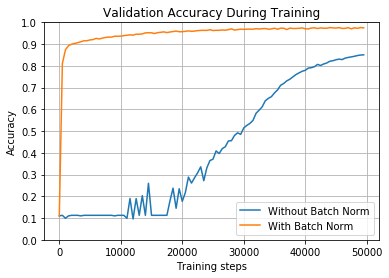

In [34]:
train_and_test(use_larger_weights=False,learning_rate=0.01,activation_fn=tf.nn.sigmoid)

1. 当没有用BN，sigmoid激活函数比relu激活函数的训练效果差  
2. **<font clolor=green> BN可以防止数据落入sigmoid的saturation region，也就是说BN可以缓解vanishing gradient**

## 4.3 较小的Weights初始化，较大的学习率，relu激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<1:43:53,  8.02it/s]

  0%|                                                                                            | 64/50000 [00:00<1:13:01, 11.40it/s]

  0%|▏                                                                                            | 119/50000 [00:00<51:31, 16.14it/s]

  0%|▎                                                                                            | 190/50000 [00:00<36:22, 22.83it/s]

  1%|▍                                                                                            | 263/50000 [00:00<25:45, 32.17it/s]

  1%|▋                                                                                            | 342/50000 [00:00<18:19, 45.17it/s]

  1%|▊                                                                                            | 413/50000 [00:00<13:09, 62.80it/s]

  1%|▉                                                                                            | 493/50000 [00:00<09:30, 86.78it/s]

  1%|█                                                                                           | 570/50000 [00:00<06:58, 118.22it/s]

  1%|█▏                                                                                          | 641/50000 [00:01<05:34, 147.65it/s]

  1%|█▎                                                                                          | 718/50000 [00:01<04:12, 194.81it/s]

  2%|█▍                                                                                          | 790/50000 [00:01<03:17, 249.19it/s]

  2%|█▌                                                                                          | 870/50000 [00:01<02:36, 313.79it/s]

  2%|█▊                                                                                          | 952/50000 [00:01<02:07, 384.18it/s]

  2%|█▊                                                                                         | 1026/50000 [00:01<01:49, 447.53it/s]

  2%|██                                                                                         | 1101/50000 [00:01<01:36, 508.37it/s]

  2%|██▏                                                                                        | 1180/50000 [00:01<01:25, 568.35it/s]

  3%|██▎                                                                                        | 1256/50000 [00:01<01:20, 603.57it/s]

  3%|██▍                                                                                        | 1336/50000 [00:02<01:14, 650.41it/s]

  3%|██▌                                                                                        | 1412/50000 [00:02<01:13, 664.29it/s]

  3%|██▋                                                                                        | 1486/50000 [00:02<01:14, 654.96it/s]

  3%|██▊                                                                                        | 1557/50000 [00:02<01:39, 484.65it/s]

  3%|██▉                                                                                        | 1616/50000 [00:02<01:34, 511.12it/s]

  3%|███                                                                                        | 1675/50000 [00:02<01:32, 524.36it/s]

  3%|███▏                                                                                       | 1742/50000 [00:02<01:26, 559.91it/s]

  4%|███▎                                                                                       | 1803/50000 [00:02<01:24, 571.27it/s]

  4%|███▍                                                                                       | 1869/50000 [00:03<01:21, 592.47it/s]

  4%|███▌                                                                                       | 1935/50000 [00:03<01:18, 610.04it/s]

  4%|███▋                                                                                       | 2001/50000 [00:03<01:17, 622.92it/s]

  4%|███▊                                                                                       | 2070/50000 [00:03<01:14, 640.33it/s]

  4%|███▉                                                                                       | 2149/50000 [00:03<01:10, 675.91it/s]

  4%|████                                                                                       | 2228/50000 [00:03<01:07, 705.13it/s]

  5%|████▏                                                                                      | 2306/50000 [00:03<01:06, 722.56it/s]

  5%|████▎                                                                                      | 2388/50000 [00:03<01:03, 747.77it/s]

  5%|████▍                                                                                      | 2464/50000 [00:03<01:23, 567.26it/s]

  5%|████▌                                                                                      | 2538/50000 [00:04<01:17, 608.88it/s]

  5%|████▊                                                                                      | 2613/50000 [00:04<01:13, 644.09it/s]

  5%|████▉                                                                                      | 2692/50000 [00:04<01:09, 680.58it/s]

  6%|█████                                                                                      | 2764/50000 [00:04<01:09, 675.00it/s]

  6%|█████▏                                                                                     | 2835/50000 [00:04<01:10, 672.07it/s]

  6%|█████▎                                                                                     | 2906/50000 [00:04<01:09, 681.58it/s]

  6%|█████▍                                                                                     | 2976/50000 [00:04<01:14, 633.55it/s]

  6%|█████▌                                                                                     | 3041/50000 [00:04<01:18, 601.74it/s]

  6%|█████▋                                                                                     | 3103/50000 [00:04<01:20, 583.62it/s]

  6%|█████▊                                                                                     | 3163/50000 [00:05<01:20, 582.06it/s]

  6%|█████▉                                                                                     | 3246/50000 [00:05<01:13, 638.28it/s]

  7%|██████                                                                                     | 3326/50000 [00:05<01:08, 678.23it/s]

  7%|██████▏                                                                                    | 3397/50000 [00:05<01:30, 514.84it/s]

  7%|██████▎                                                                                    | 3467/50000 [00:05<01:23, 556.91it/s]

  7%|██████▍                                                                                    | 3529/50000 [00:05<01:21, 571.67it/s]

  7%|██████▌                                                                                    | 3598/50000 [00:05<01:17, 601.56it/s]

  7%|██████▋                                                                                    | 3662/50000 [00:05<01:22, 561.56it/s]

  7%|██████▊                                                                                    | 3722/50000 [00:05<01:22, 561.77it/s]

  8%|██████▉                                                                                    | 3783/50000 [00:06<01:20, 574.23it/s]

  8%|███████                                                                                    | 3864/50000 [00:06<01:13, 628.10it/s]

  8%|███████▏                                                                                   | 3943/50000 [00:06<01:09, 666.32it/s]

  8%|███████▎                                                                                   | 4013/50000 [00:06<01:10, 652.09it/s]

  8%|███████▍                                                                                   | 4092/50000 [00:06<01:06, 686.81it/s]

  8%|███████▌                                                                                   | 4169/50000 [00:06<01:04, 706.44it/s]

  9%|███████▋                                                                                   | 4251/50000 [00:06<01:19, 578.73it/s]

  9%|███████▊                                                                                   | 4326/50000 [00:06<01:13, 618.63it/s]

  9%|███████▉                                                                                   | 4392/50000 [00:07<01:17, 590.44it/s]

  9%|████████                                                                                   | 4455/50000 [00:07<01:22, 548.86it/s]

  9%|████████▏                                                                                  | 4513/50000 [00:07<01:25, 529.31it/s]

  9%|████████▎                                                                                  | 4570/50000 [00:07<01:24, 538.25it/s]

  9%|████████▍                                                                                  | 4633/50000 [00:07<01:20, 560.25it/s]

  9%|████████▌                                                                                  | 4694/50000 [00:07<01:19, 573.12it/s]

 10%|████████▋                                                                                  | 4754/50000 [00:07<01:18, 578.02it/s]

 10%|████████▊                                                                                  | 4815/50000 [00:07<01:17, 586.02it/s]

 10%|████████▊                                                                                  | 4875/50000 [00:07<01:16, 587.15it/s]

 10%|████████▉                                                                                  | 4938/50000 [00:07<01:15, 598.14it/s]

 10%|█████████                                                                                  | 5001/50000 [00:08<01:15, 597.44it/s]

 10%|█████████▏                                                                                 | 5061/50000 [00:08<01:16, 588.18it/s]

 10%|█████████▎                                                                                 | 5126/50000 [00:08<01:14, 604.22it/s]

 10%|█████████▍                                                                                 | 5187/50000 [00:08<01:36, 464.21it/s]

 10%|█████████▌                                                                                 | 5246/50000 [00:08<01:30, 495.01it/s]

 11%|█████████▋                                                                                 | 5307/50000 [00:08<01:25, 523.70it/s]

 11%|█████████▊                                                                                 | 5366/50000 [00:08<01:22, 540.88it/s]

 11%|█████████▊                                                                                 | 5423/50000 [00:08<01:22, 541.90it/s]

 11%|█████████▉                                                                                 | 5479/50000 [00:09<01:22, 539.69it/s]

 11%|██████████                                                                                 | 5535/50000 [00:09<01:22, 538.26it/s]

 11%|██████████▏                                                                                | 5592/50000 [00:09<01:21, 544.69it/s]

 11%|██████████▎                                                                                | 5649/50000 [00:09<01:20, 549.29it/s]

 11%|██████████▍                                                                                | 5705/50000 [00:09<01:21, 544.85it/s]

 12%|██████████▌                                                                                | 5771/50000 [00:09<01:17, 572.36it/s]

 12%|██████████▋                                                                                | 5840/50000 [00:09<01:13, 600.48it/s]

 12%|██████████▋                                                                                | 5903/50000 [00:09<01:12, 607.74it/s]

 12%|██████████▊                                                                                | 5965/50000 [00:09<01:12, 604.73it/s]

 12%|██████████▉                                                                                | 6026/50000 [00:09<01:13, 599.65it/s]

 12%|███████████                                                                                | 6087/50000 [00:10<01:31, 478.59it/s]

 12%|███████████▏                                                                               | 6150/50000 [00:10<01:25, 514.85it/s]

 12%|███████████▎                                                                               | 6230/50000 [00:10<01:16, 574.35it/s]

 13%|███████████▍                                                                               | 6300/50000 [00:10<01:12, 605.89it/s]

 13%|███████████▌                                                                               | 6373/50000 [00:10<01:08, 637.23it/s]

 13%|███████████▋                                                                               | 6440/50000 [00:10<01:08, 638.00it/s]

 13%|███████████▊                                                                               | 6511/50000 [00:10<01:06, 656.69it/s]

 13%|███████████▉                                                                               | 6588/50000 [00:10<01:03, 685.67it/s]

 13%|████████████                                                                               | 6662/50000 [00:10<01:01, 699.66it/s]

 13%|████████████▎                                                                              | 6734/50000 [00:11<01:03, 684.11it/s]

 14%|████████████▍                                                                              | 6809/50000 [00:11<01:01, 701.19it/s]

 14%|████████████▌                                                                              | 6884/50000 [00:11<01:00, 713.66it/s]

 14%|████████████▋                                                                              | 6956/50000 [00:11<01:03, 677.79it/s]

 14%|████████████▊                                                                              | 7025/50000 [00:11<01:24, 508.89it/s]

 14%|████████████▉                                                                              | 7100/50000 [00:11<01:16, 561.03it/s]

 14%|█████████████                                                                              | 7177/50000 [00:11<01:10, 609.69it/s]

 15%|█████████████▏                                                                             | 7256/50000 [00:11<01:05, 653.32it/s]

 15%|█████████████▎                                                                             | 7327/50000 [00:11<01:04, 660.54it/s]

 15%|█████████████▍                                                                             | 7404/50000 [00:12<01:02, 686.77it/s]

 15%|█████████████▌                                                                             | 7476/50000 [00:12<01:07, 631.14it/s]

 15%|█████████████▋                                                                             | 7542/50000 [00:12<01:15, 563.22it/s]

 15%|█████████████▊                                                                             | 7602/50000 [00:12<01:15, 561.35it/s]

 15%|█████████████▉                                                                             | 7662/50000 [00:12<01:14, 571.22it/s]

 15%|██████████████                                                                             | 7726/50000 [00:12<01:11, 587.44it/s]

 16%|██████████████▏                                                                            | 7796/50000 [00:12<01:08, 616.03it/s]

 16%|██████████████▎                                                                            | 7866/50000 [00:12<01:06, 636.01it/s]

 16%|██████████████▍                                                                            | 7931/50000 [00:13<01:23, 501.60it/s]

 16%|██████████████▌                                                                            | 7999/50000 [00:13<01:17, 542.21it/s]

 16%|██████████████▋                                                                            | 8058/50000 [00:13<01:22, 506.17it/s]

 16%|██████████████▊                                                                            | 8116/50000 [00:13<01:19, 525.22it/s]

 16%|██████████████▉                                                                            | 8175/50000 [00:13<01:17, 542.02it/s]

 16%|██████████████▉                                                                            | 8232/50000 [00:13<01:17, 538.11it/s]

 17%|███████████████                                                                            | 8288/50000 [00:13<01:19, 525.04it/s]

 17%|███████████████▏                                                                           | 8355/50000 [00:13<01:14, 559.06it/s]

 17%|███████████████▎                                                                           | 8413/50000 [00:13<01:16, 544.95it/s]

 17%|███████████████▍                                                                           | 8470/50000 [00:14<01:15, 549.47it/s]

 17%|███████████████▌                                                                           | 8526/50000 [00:14<01:15, 548.17it/s]

 17%|███████████████▌                                                                           | 8582/50000 [00:14<01:15, 550.47it/s]

 17%|███████████████▊                                                                           | 8655/50000 [00:14<01:09, 593.27it/s]

 17%|███████████████▊                                                                           | 8717/50000 [00:14<01:09, 598.03it/s]

 18%|███████████████▉                                                                           | 8782/50000 [00:14<01:07, 611.47it/s]

 18%|████████████████                                                                           | 8844/50000 [00:14<01:24, 488.47it/s]

 18%|████████████████▏                                                                          | 8916/50000 [00:14<01:16, 539.74it/s]

 18%|████████████████▎                                                                          | 8979/50000 [00:14<01:13, 561.37it/s]

 18%|████████████████▍                                                                          | 9047/50000 [00:15<01:09, 591.24it/s]

 18%|████████████████▌                                                                          | 9128/50000 [00:15<01:03, 642.25it/s]

 18%|████████████████▊                                                                          | 9208/50000 [00:15<01:00, 679.63it/s]

 19%|████████████████▉                                                                          | 9279/50000 [00:15<01:07, 600.12it/s]

 19%|█████████████████                                                                          | 9343/50000 [00:15<01:09, 583.64it/s]

 19%|█████████████████▏                                                                         | 9420/50000 [00:15<01:04, 628.21it/s]

 19%|█████████████████▎                                                                         | 9494/50000 [00:15<01:01, 656.75it/s]

 19%|█████████████████▍                                                                         | 9563/50000 [00:15<01:01, 657.40it/s]

 19%|█████████████████▌                                                                         | 9631/50000 [00:15<01:01, 651.21it/s]

 19%|█████████████████▋                                                                         | 9700/50000 [00:16<01:00, 660.99it/s]

 20%|█████████████████▊                                                                         | 9767/50000 [00:16<01:20, 499.68it/s]

 20%|█████████████████▉                                                                         | 9824/50000 [00:16<01:18, 510.91it/s]

 20%|██████████████████                                                                         | 9894/50000 [00:16<01:12, 555.00it/s]

 20%|██████████████████▏                                                                        | 9975/50000 [00:16<01:05, 611.87it/s]

 20%|██████████████████                                                                        | 10045/50000 [00:16<01:02, 634.62it/s]

 20%|██████████████████▏                                                                       | 10117/50000 [00:16<01:00, 656.71it/s]

 20%|██████████████████▎                                                                       | 10196/50000 [00:16<00:57, 690.40it/s]

 21%|██████████████████▍                                                                       | 10268/50000 [00:16<00:59, 666.62it/s]

 21%|██████████████████▌                                                                       | 10341/50000 [00:17<00:58, 683.04it/s]

 21%|██████████████████▋                                                                       | 10411/50000 [00:17<01:04, 614.44it/s]

 21%|██████████████████▊                                                                       | 10475/50000 [00:17<01:06, 594.68it/s]

 21%|██████████████████▉                                                                       | 10537/50000 [00:17<01:11, 555.68it/s]

 21%|███████████████████                                                                       | 10598/50000 [00:17<01:09, 569.76it/s]

 21%|███████████████████▏                                                                      | 10657/50000 [00:17<01:09, 569.46it/s]

 21%|███████████████████▎                                                                      | 10715/50000 [00:17<01:33, 422.05it/s]

 22%|███████████████████▍                                                                      | 10778/50000 [00:17<01:23, 467.71it/s]

 22%|███████████████████▌                                                                      | 10835/50000 [00:18<01:19, 493.38it/s]

 22%|███████████████████▌                                                                      | 10898/50000 [00:18<01:14, 525.43it/s]

 22%|███████████████████▋                                                                      | 10970/50000 [00:18<01:08, 570.79it/s]

 22%|███████████████████▉                                                                      | 11046/50000 [00:18<01:03, 614.27it/s]

 22%|████████████████████                                                                      | 11121/50000 [00:18<01:00, 646.64it/s]

 22%|████████████████████▏                                                                     | 11206/50000 [00:18<00:55, 695.39it/s]

 23%|████████████████████▎                                                                     | 11281/50000 [00:18<00:54, 709.45it/s]

 23%|████████████████████▍                                                                     | 11355/50000 [00:18<00:59, 647.40it/s]

 23%|████████████████████▌                                                                     | 11423/50000 [00:18<01:06, 580.15it/s]

 23%|████████████████████▋                                                                     | 11485/50000 [00:19<01:08, 560.02it/s]

 23%|████████████████████▊                                                                     | 11555/50000 [00:19<01:04, 594.66it/s]

 23%|████████████████████▉                                                                     | 11617/50000 [00:19<01:27, 440.01it/s]

 23%|█████████████████████                                                                     | 11669/50000 [00:19<01:26, 441.70it/s]

 23%|█████████████████████                                                                     | 11725/50000 [00:19<01:21, 470.72it/s]

 24%|█████████████████████▏                                                                    | 11800/50000 [00:19<01:12, 529.10it/s]

 24%|█████████████████████▍                                                                    | 11884/50000 [00:19<01:04, 594.26it/s]

 24%|█████████████████████▌                                                                    | 11959/50000 [00:19<01:00, 632.57it/s]

 24%|█████████████████████▋                                                                    | 12035/50000 [00:20<00:57, 664.80it/s]

 24%|█████████████████████▊                                                                    | 12111/50000 [00:20<00:54, 689.38it/s]

 24%|█████████████████████▉                                                                    | 12194/50000 [00:20<00:52, 723.02it/s]

 25%|██████████████████████                                                                    | 12276/50000 [00:20<00:50, 748.11it/s]

 25%|██████████████████████▏                                                                   | 12353/50000 [00:20<00:54, 690.32it/s]

 25%|██████████████████████▎                                                                   | 12425/50000 [00:20<00:58, 638.28it/s]

 25%|██████████████████████▍                                                                   | 12492/50000 [00:20<00:58, 644.25it/s]

 25%|██████████████████████▌                                                                   | 12559/50000 [00:20<01:19, 470.14it/s]

 25%|██████████████████████▋                                                                   | 12614/50000 [00:21<01:17, 485.40it/s]

 25%|██████████████████████▊                                                                   | 12669/50000 [00:21<01:15, 494.03it/s]

 25%|██████████████████████▉                                                                   | 12729/50000 [00:21<01:11, 520.68it/s]

 26%|███████████████████████                                                                   | 12785/50000 [00:21<01:10, 526.30it/s]

 26%|███████████████████████                                                                   | 12840/50000 [00:21<01:11, 522.98it/s]

 26%|███████████████████████▏                                                                  | 12894/50000 [00:21<01:11, 516.29it/s]

 26%|███████████████████████▎                                                                  | 12953/50000 [00:21<01:09, 535.33it/s]

 26%|███████████████████████▍                                                                  | 13026/50000 [00:21<01:03, 580.87it/s]

 26%|███████████████████████▌                                                                  | 13109/50000 [00:21<00:57, 637.27it/s]

 26%|███████████████████████▋                                                                  | 13176/50000 [00:21<01:00, 606.91it/s]

 26%|███████████████████████▊                                                                  | 13243/50000 [00:22<00:59, 621.55it/s]

 27%|███████████████████████▉                                                                  | 13307/50000 [00:22<01:03, 579.84it/s]

 27%|████████████████████████                                                                  | 13367/50000 [00:22<01:07, 543.31it/s]

 27%|████████████████████████▏                                                                 | 13424/50000 [00:22<01:30, 404.09it/s]

 27%|████████████████████████▎                                                                 | 13482/50000 [00:22<01:22, 443.79it/s]

 27%|████████████████████████▎                                                                 | 13535/50000 [00:22<01:18, 465.66it/s]

 27%|████████████████████████▍                                                                 | 13595/50000 [00:22<01:13, 498.29it/s]

 27%|████████████████████████▌                                                                 | 13661/50000 [00:22<01:07, 536.86it/s]

 27%|████████████████████████▋                                                                 | 13729/50000 [00:23<01:03, 571.99it/s]

 28%|████████████████████████▊                                                                 | 13790/50000 [00:23<01:03, 573.49it/s]

 28%|████████████████████████▉                                                                 | 13863/50000 [00:23<00:59, 611.79it/s]

 28%|█████████████████████████                                                                 | 13946/50000 [00:23<00:54, 663.01it/s]

 28%|█████████████████████████▏                                                                | 14016/50000 [00:23<00:54, 659.01it/s]

 28%|█████████████████████████▎                                                                | 14089/50000 [00:23<00:53, 677.44it/s]

 28%|█████████████████████████▍                                                                | 14163/50000 [00:23<00:51, 693.64it/s]

 28%|█████████████████████████▋                                                                | 14243/50000 [00:23<00:49, 721.03it/s]

 29%|█████████████████████████▊                                                                | 14319/50000 [00:23<00:48, 728.60it/s]

 29%|█████████████████████████▉                                                                | 14393/50000 [00:24<01:04, 553.81it/s]

 29%|██████████████████████████                                                                | 14456/50000 [00:24<01:05, 539.66it/s]

 29%|██████████████████████████▏                                                               | 14515/50000 [00:24<01:05, 542.11it/s]

 29%|██████████████████████████▏                                                               | 14573/50000 [00:24<01:05, 539.51it/s]

 29%|██████████████████████████▎                                                               | 14634/50000 [00:24<01:03, 557.75it/s]

 29%|██████████████████████████▍                                                               | 14694/50000 [00:24<01:02, 568.62it/s]

 30%|██████████████████████████▌                                                               | 14753/50000 [00:24<01:02, 563.80it/s]

 30%|██████████████████████████▋                                                               | 14811/50000 [00:24<01:02, 562.41it/s]

 30%|██████████████████████████▊                                                               | 14868/50000 [00:24<01:02, 561.75it/s]

 30%|██████████████████████████▊                                                               | 14925/50000 [00:25<01:03, 554.81it/s]

 30%|██████████████████████████▉                                                               | 14983/50000 [00:25<01:02, 560.93it/s]

 30%|███████████████████████████                                                               | 15040/50000 [00:25<01:02, 560.76it/s]

 30%|███████████████████████████▏                                                              | 15100/50000 [00:25<01:01, 570.79it/s]

 30%|███████████████████████████▎                                                              | 15161/50000 [00:25<00:59, 580.80it/s]

 30%|███████████████████████████▍                                                              | 15228/50000 [00:25<00:57, 603.76it/s]

 31%|███████████████████████████▌                                                              | 15289/50000 [00:25<01:13, 471.53it/s]

 31%|███████████████████████████▌                                                              | 15345/50000 [00:25<01:10, 494.03it/s]

 31%|███████████████████████████▊                                                              | 15417/50000 [00:25<01:03, 544.47it/s]

 31%|███████████████████████████▉                                                              | 15491/50000 [00:26<00:58, 590.32it/s]

 31%|███████████████████████████▉                                                              | 15555/50000 [00:26<00:57, 594.76it/s]

 31%|████████████████████████████                                                              | 15621/50000 [00:26<00:56, 611.70it/s]

 31%|████████████████████████████▎                                                             | 15705/50000 [00:26<00:51, 664.84it/s]

 32%|████████████████████████████▍                                                             | 15775/50000 [00:26<00:51, 667.82it/s]

 32%|████████████████████████████▌                                                             | 15855/50000 [00:26<00:48, 701.30it/s]

 32%|████████████████████████████▋                                                             | 15940/50000 [00:26<00:46, 736.82it/s]

 32%|████████████████████████████▊                                                             | 16016/50000 [00:26<00:45, 742.03it/s]

 32%|████████████████████████████▉                                                             | 16097/50000 [00:26<00:44, 759.63it/s]

 32%|█████████████████████████████                                                             | 16174/50000 [00:27<01:00, 560.50it/s]

 32%|█████████████████████████████▏                                                            | 16239/50000 [00:27<01:00, 556.59it/s]

 33%|█████████████████████████████▎                                                            | 16301/50000 [00:27<00:59, 563.69it/s]

 33%|█████████████████████████████▍                                                            | 16362/50000 [00:27<00:59, 566.05it/s]

 33%|█████████████████████████████▌                                                            | 16422/50000 [00:27<00:58, 571.34it/s]

 33%|█████████████████████████████▋                                                            | 16482/50000 [00:27<00:58, 576.76it/s]

 33%|█████████████████████████████▊                                                            | 16542/50000 [00:27<00:57, 577.27it/s]

 33%|█████████████████████████████▉                                                            | 16604/50000 [00:27<00:56, 588.23it/s]

 33%|█████████████████████████████▉                                                            | 16666/50000 [00:27<00:55, 596.16it/s]

 33%|██████████████████████████████                                                            | 16728/50000 [00:28<00:55, 600.06it/s]

 34%|██████████████████████████████▏                                                           | 16789/50000 [00:28<00:56, 592.98it/s]

 34%|██████████████████████████████▎                                                           | 16859/50000 [00:28<00:53, 620.28it/s]

 34%|██████████████████████████████▍                                                           | 16941/50000 [00:28<00:49, 667.98it/s]

 34%|██████████████████████████████▌                                                           | 17010/50000 [00:28<00:50, 650.23it/s]

 34%|██████████████████████████████▊                                                           | 17084/50000 [00:28<01:01, 535.04it/s]

 34%|██████████████████████████████▉                                                           | 17158/50000 [00:28<00:56, 582.52it/s]

 34%|███████████████████████████████                                                           | 17242/50000 [00:28<00:51, 640.44it/s]

 35%|███████████████████████████████▏                                                          | 17322/50000 [00:28<00:48, 678.21it/s]

 35%|███████████████████████████████▎                                                          | 17404/50000 [00:29<00:45, 713.95it/s]

 35%|███████████████████████████████▍                                                          | 17479/50000 [00:29<00:46, 706.56it/s]

 35%|███████████████████████████████▌                                                          | 17552/50000 [00:29<00:45, 705.73it/s]

 35%|███████████████████████████████▋                                                          | 17626/50000 [00:29<00:45, 714.16it/s]

 35%|███████████████████████████████▊                                                          | 17699/50000 [00:29<00:48, 666.36it/s]

 36%|███████████████████████████████▉                                                          | 17768/50000 [00:29<00:52, 617.84it/s]

 36%|████████████████████████████████▏                                                         | 17851/50000 [00:29<00:48, 666.37it/s]

 36%|████████████████████████████████▎                                                         | 17920/50000 [00:29<00:47, 669.90it/s]

 36%|████████████████████████████████▍                                                         | 17998/50000 [00:29<00:45, 698.15it/s]

 36%|████████████████████████████████▌                                                         | 18070/50000 [00:30<00:58, 541.64it/s]

 36%|████████████████████████████████▋                                                         | 18139/50000 [00:30<00:55, 577.93it/s]

 36%|████████████████████████████████▊                                                         | 18223/50000 [00:30<00:49, 636.55it/s]

 37%|████████████████████████████████▉                                                         | 18294/50000 [00:30<00:48, 655.58it/s]

 37%|█████████████████████████████████                                                         | 18364/50000 [00:30<00:48, 655.72it/s]

 37%|█████████████████████████████████▏                                                        | 18448/50000 [00:30<00:45, 698.89it/s]

 37%|█████████████████████████████████▎                                                        | 18523/50000 [00:30<00:44, 711.99it/s]

 37%|█████████████████████████████████▍                                                        | 18597/50000 [00:30<00:43, 714.49it/s]

 37%|█████████████████████████████████▌                                                        | 18675/50000 [00:30<00:42, 731.45it/s]

 38%|█████████████████████████████████▊                                                        | 18750/50000 [00:31<00:52, 595.55it/s]

 38%|█████████████████████████████████▊                                                        | 18815/50000 [00:31<00:51, 604.57it/s]

 38%|█████████████████████████████████▉                                                        | 18879/50000 [00:31<00:50, 611.74it/s]

 38%|██████████████████████████████████                                                        | 18943/50000 [00:31<01:04, 482.02it/s]

 38%|██████████████████████████████████▏                                                       | 19011/50000 [00:31<00:58, 527.23it/s]

 38%|██████████████████████████████████▎                                                       | 19070/50000 [00:31<00:58, 524.74it/s]

 38%|██████████████████████████████████▍                                                       | 19127/50000 [00:31<00:59, 518.88it/s]

 38%|██████████████████████████████████▌                                                       | 19182/50000 [00:31<00:59, 517.85it/s]

 38%|██████████████████████████████████▋                                                       | 19244/50000 [00:32<00:56, 542.31it/s]

 39%|██████████████████████████████████▋                                                       | 19300/50000 [00:32<00:58, 527.84it/s]

 39%|██████████████████████████████████▊                                                       | 19355/50000 [00:32<01:00, 508.11it/s]

 39%|██████████████████████████████████▉                                                       | 19407/50000 [00:32<01:00, 504.59it/s]

 39%|███████████████████████████████████                                                       | 19463/50000 [00:32<00:59, 517.53it/s]

 39%|███████████████████████████████████▏                                                      | 19523/50000 [00:32<00:56, 538.73it/s]

 39%|███████████████████████████████████▏                                                      | 19581/50000 [00:32<00:55, 549.33it/s]

 39%|███████████████████████████████████▎                                                      | 19645/50000 [00:32<00:53, 571.07it/s]

 39%|███████████████████████████████████▍                                                      | 19711/50000 [00:32<00:50, 593.95it/s]

 40%|███████████████████████████████████▌                                                      | 19772/50000 [00:33<00:50, 593.91it/s]

 40%|███████████████████████████████████▋                                                      | 19834/50000 [00:33<01:04, 464.37it/s]

 40%|███████████████████████████████████▊                                                      | 19893/50000 [00:33<01:00, 493.91it/s]

 40%|███████████████████████████████████▉                                                      | 19971/50000 [00:33<00:54, 554.11it/s]

 40%|████████████████████████████████████                                                      | 20035/50000 [00:33<00:52, 576.22it/s]

 40%|████████████████████████████████████▏                                                     | 20097/50000 [00:33<00:50, 587.47it/s]

 40%|████████████████████████████████████▎                                                     | 20159/50000 [00:33<00:52, 572.57it/s]

 40%|████████████████████████████████████▍                                                     | 20219/50000 [00:33<00:56, 530.28it/s]

 41%|████████████████████████████████████▌                                                     | 20278/50000 [00:33<00:54, 544.27it/s]

 41%|████████████████████████████████████▋                                                     | 20353/50000 [00:34<00:50, 592.05it/s]

 41%|████████████████████████████████████▊                                                     | 20423/50000 [00:34<00:47, 617.93it/s]

 41%|████████████████████████████████████▉                                                     | 20497/50000 [00:34<00:45, 648.85it/s]

 41%|█████████████████████████████████████                                                     | 20564/50000 [00:34<00:45, 649.86it/s]

 41%|█████████████████████████████████████▏                                                    | 20631/50000 [00:34<00:45, 652.47it/s]

 41%|█████████████████████████████████████▎                                                    | 20706/50000 [00:34<00:43, 677.61it/s]

 42%|█████████████████████████████████████▍                                                    | 20775/50000 [00:34<00:55, 529.86it/s]

 42%|█████████████████████████████████████▌                                                    | 20851/50000 [00:34<00:50, 581.83it/s]

 42%|█████████████████████████████████████▋                                                    | 20922/50000 [00:34<00:47, 613.98it/s]

 42%|█████████████████████████████████████▊                                                    | 20988/50000 [00:35<00:47, 605.19it/s]

 42%|█████████████████████████████████████▉                                                    | 21052/50000 [00:35<00:52, 550.67it/s]

 42%|█████████████████████████████████████▉                                                    | 21111/50000 [00:35<00:51, 559.19it/s]

 42%|██████████████████████████████████████                                                    | 21175/50000 [00:35<00:49, 578.48it/s]

 42%|██████████████████████████████████████▏                                                   | 21238/50000 [00:35<00:48, 590.15it/s]

 43%|██████████████████████████████████████▎                                                   | 21305/50000 [00:35<00:46, 610.81it/s]

 43%|██████████████████████████████████████▍                                                   | 21372/50000 [00:35<00:45, 626.16it/s]

 43%|██████████████████████████████████████▌                                                   | 21442/50000 [00:35<00:44, 645.31it/s]

 43%|██████████████████████████████████████▋                                                   | 21508/50000 [00:35<00:45, 627.92it/s]

 43%|██████████████████████████████████████▊                                                   | 21582/50000 [00:36<00:43, 656.56it/s]

 43%|██████████████████████████████████████▉                                                   | 21649/50000 [00:36<00:43, 657.18it/s]

 43%|███████████████████████████████████████                                                   | 21716/50000 [00:36<00:57, 493.76it/s]

 44%|███████████████████████████████████████▏                                                  | 21797/50000 [00:36<00:50, 558.42it/s]

 44%|███████████████████████████████████████▎                                                  | 21867/50000 [00:36<00:47, 593.39it/s]

 44%|███████████████████████████████████████▌                                                  | 21948/50000 [00:36<00:43, 644.02it/s]

 44%|███████████████████████████████████████▋                                                  | 22023/50000 [00:36<00:41, 671.21it/s]

 44%|███████████████████████████████████████▊                                                  | 22096/50000 [00:36<00:40, 684.43it/s]

 44%|███████████████████████████████████████▉                                                  | 22168/50000 [00:37<00:46, 601.47it/s]

 44%|████████████████████████████████████████                                                  | 22232/50000 [00:37<00:46, 595.93it/s]

 45%|████████████████████████████████████████▏                                                 | 22295/50000 [00:37<00:45, 604.48it/s]

 45%|████████████████████████████████████████▏                                                 | 22361/50000 [00:37<00:44, 618.86it/s]

 45%|████████████████████████████████████████▎                                                 | 22425/50000 [00:37<00:44, 623.72it/s]

 45%|████████████████████████████████████████▍                                                 | 22489/50000 [00:37<00:44, 623.48it/s]

 45%|████████████████████████████████████████▌                                                 | 22553/50000 [00:37<00:44, 619.76it/s]

 45%|████████████████████████████████████████▋                                                 | 22616/50000 [00:37<00:57, 474.43it/s]

 45%|████████████████████████████████████████▊                                                 | 22679/50000 [00:37<00:53, 511.47it/s]

 45%|████████████████████████████████████████▉                                                 | 22742/50000 [00:38<00:50, 541.05it/s]

 46%|█████████████████████████████████████████                                                 | 22804/50000 [00:38<00:48, 561.41it/s]

 46%|█████████████████████████████████████████▏                                                | 22880/50000 [00:38<00:44, 606.65it/s]

 46%|█████████████████████████████████████████▎                                                | 22959/50000 [00:38<00:41, 650.88it/s]

 46%|█████████████████████████████████████████▍                                                | 23033/50000 [00:38<00:40, 673.93it/s]

 46%|█████████████████████████████████████████▌                                                | 23103/50000 [00:38<00:39, 674.21it/s]

 46%|█████████████████████████████████████████▋                                                | 23187/50000 [00:38<00:37, 715.31it/s]

 47%|█████████████████████████████████████████▉                                                | 23269/50000 [00:38<00:36, 742.32it/s]

 47%|██████████████████████████████████████████                                                | 23354/50000 [00:38<00:34, 770.11it/s]

 47%|██████████████████████████████████████████▏                                               | 23433/50000 [00:38<00:35, 756.56it/s]

 47%|██████████████████████████████████████████▎                                               | 23510/50000 [00:39<00:45, 578.13it/s]

 47%|██████████████████████████████████████████▍                                               | 23586/50000 [00:39<00:42, 620.26it/s]

 47%|██████████████████████████████████████████▌                                               | 23654/50000 [00:39<00:41, 632.21it/s]

 47%|██████████████████████████████████████████▋                                               | 23736/50000 [00:39<00:38, 677.62it/s]

 48%|██████████████████████████████████████████▊                                               | 23809/50000 [00:39<00:37, 691.09it/s]

 48%|███████████████████████████████████████████                                               | 23889/50000 [00:39<00:36, 719.10it/s]

 48%|███████████████████████████████████████████▏                                              | 23973/50000 [00:39<00:34, 750.08it/s]

 48%|███████████████████████████████████████████▎                                              | 24052/50000 [00:39<00:34, 760.02it/s]

 48%|███████████████████████████████████████████▍                                              | 24136/50000 [00:39<00:33, 778.60it/s]

 48%|███████████████████████████████████████████▌                                              | 24215/50000 [00:40<00:34, 755.73it/s]

 49%|███████████████████████████████████████████▋                                              | 24292/50000 [00:40<00:37, 681.96it/s]

 49%|███████████████████████████████████████████▊                                              | 24363/50000 [00:40<00:40, 631.83it/s]

 49%|███████████████████████████████████████████▉                                              | 24429/50000 [00:40<00:56, 455.39it/s]

 49%|████████████████████████████████████████████                                              | 24485/50000 [00:40<00:52, 481.52it/s]

 49%|████████████████████████████████████████████▏                                             | 24540/50000 [00:40<00:54, 468.66it/s]

 49%|████████████████████████████████████████████▎                                             | 24592/50000 [00:40<00:53, 474.10it/s]

 49%|████████████████████████████████████████████▍                                             | 24663/50000 [00:41<00:48, 525.73it/s]

 49%|████████████████████████████████████████████▌                                             | 24726/50000 [00:41<00:45, 552.14it/s]

 50%|████████████████████████████████████████████▌                                             | 24785/50000 [00:41<00:46, 543.23it/s]

 50%|████████████████████████████████████████████▋                                             | 24852/50000 [00:41<00:43, 573.36it/s]

 50%|████████████████████████████████████████████▊                                             | 24921/50000 [00:41<00:41, 602.84it/s]

 50%|████████████████████████████████████████████▉                                             | 24984/50000 [00:41<00:41, 602.47it/s]

 50%|█████████████████████████████████████████████                                             | 25050/50000 [00:41<00:40, 615.65it/s]

 50%|█████████████████████████████████████████████▏                                            | 25125/50000 [00:41<00:38, 647.71it/s]

 50%|█████████████████████████████████████████████▎                                            | 25191/50000 [00:41<00:40, 615.48it/s]

 51%|█████████████████████████████████████████████▍                                            | 25257/50000 [00:41<00:39, 626.89it/s]

 51%|█████████████████████████████████████████████▌                                            | 25321/50000 [00:42<00:39, 627.56it/s]

 51%|█████████████████████████████████████████████▋                                            | 25385/50000 [00:42<00:54, 450.71it/s]

 51%|█████████████████████████████████████████████▊                                            | 25440/50000 [00:42<00:51, 475.61it/s]

 51%|█████████████████████████████████████████████▉                                            | 25502/50000 [00:42<00:48, 509.16it/s]

 51%|██████████████████████████████████████████████                                            | 25558/50000 [00:42<00:47, 518.01it/s]

 51%|██████████████████████████████████████████████                                            | 25616/50000 [00:42<00:45, 532.62it/s]

 51%|██████████████████████████████████████████████▏                                           | 25676/50000 [00:42<00:44, 550.08it/s]

 51%|██████████████████████████████████████████████▎                                           | 25734/50000 [00:42<00:43, 557.55it/s]

 52%|██████████████████████████████████████████████▍                                           | 25795/50000 [00:43<00:42, 571.14it/s]

 52%|██████████████████████████████████████████████▌                                           | 25858/50000 [00:43<00:41, 586.41it/s]

 52%|██████████████████████████████████████████████▋                                           | 25928/50000 [00:43<00:39, 615.23it/s]

 52%|██████████████████████████████████████████████▊                                           | 25992/50000 [00:43<00:38, 621.13it/s]

 52%|██████████████████████████████████████████████▉                                           | 26055/50000 [00:43<00:38, 622.42it/s]

 52%|███████████████████████████████████████████████                                           | 26118/50000 [00:43<00:42, 566.32it/s]

 52%|███████████████████████████████████████████████                                           | 26176/50000 [00:43<00:42, 560.89it/s]

 52%|███████████████████████████████████████████████▏                                          | 26234/50000 [00:43<00:42, 558.74it/s]

 53%|███████████████████████████████████████████████▎                                          | 26291/50000 [00:43<00:53, 446.51it/s]

 53%|███████████████████████████████████████████████▍                                          | 26368/50000 [00:44<00:46, 510.16it/s]

 53%|███████████████████████████████████████████████▌                                          | 26446/50000 [00:44<00:41, 568.33it/s]

 53%|███████████████████████████████████████████████▋                                          | 26513/50000 [00:44<00:39, 594.28it/s]

 53%|███████████████████████████████████████████████▊                                          | 26592/50000 [00:44<00:36, 639.30it/s]

 53%|████████████████████████████████████████████████                                          | 26670/50000 [00:44<00:34, 674.60it/s]

 53%|████████████████████████████████████████████████▏                                         | 26741/50000 [00:44<00:34, 677.52it/s]

 54%|████████████████████████████████████████████████▎                                         | 26813/50000 [00:44<00:33, 688.31it/s]

 54%|████████████████████████████████████████████████▍                                         | 26897/50000 [00:44<00:31, 726.35it/s]

 54%|████████████████████████████████████████████████▌                                         | 26981/50000 [00:44<00:30, 753.56it/s]

 54%|████████████████████████████████████████████████▋                                         | 27058/50000 [00:44<00:30, 756.79it/s]

 54%|████████████████████████████████████████████████▊                                         | 27141/50000 [00:45<00:29, 775.76it/s]

 54%|████████████████████████████████████████████████▉                                         | 27220/50000 [00:45<00:38, 594.34it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27293/50000 [00:45<00:36, 628.25it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27363/50000 [00:45<00:34, 646.87it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27433/50000 [00:45<00:34, 658.71it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27508/50000 [00:45<00:32, 682.28it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27582/50000 [00:45<00:32, 697.22it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27654/50000 [00:45<00:31, 700.35it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27737/50000 [00:46<00:30, 731.43it/s]

 56%|██████████████████████████████████████████████████                                        | 27817/50000 [00:46<00:29, 749.19it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27895/50000 [00:46<00:29, 756.56it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27977/50000 [00:46<00:28, 772.94it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28055/50000 [00:46<00:28, 764.29it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28132/50000 [00:46<00:38, 561.04it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28206/50000 [00:46<00:36, 603.85it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28292/50000 [00:46<00:32, 661.98it/s]

 57%|███████████████████████████████████████████████████                                       | 28368/50000 [00:46<00:31, 687.26it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28452/50000 [00:47<00:29, 725.54it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28529/50000 [00:47<00:31, 691.26it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28602/50000 [00:47<00:32, 648.76it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28670/50000 [00:47<00:34, 624.01it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28735/50000 [00:47<00:35, 605.65it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28798/50000 [00:47<00:35, 599.27it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28860/50000 [00:47<00:35, 595.37it/s]

 58%|████████████████████████████████████████████████████                                      | 28924/50000 [00:47<00:34, 606.83it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28988/50000 [00:47<00:34, 613.35it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29050/50000 [00:48<00:46, 453.94it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29125/50000 [00:48<00:40, 514.14it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29206/50000 [00:48<00:36, 575.29it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29290/50000 [00:48<00:32, 634.30it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29369/50000 [00:48<00:30, 672.90it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29442/50000 [00:48<00:30, 681.88it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29521/50000 [00:48<00:28, 707.78it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29601/50000 [00:48<00:27, 731.66it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29679/50000 [00:48<00:27, 743.97it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29756/50000 [00:49<00:27, 747.81it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29840/50000 [00:49<00:26, 769.59it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29918/50000 [00:49<00:33, 600.51it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29991/50000 [00:49<00:31, 633.06it/s]

 60%|██████████████████████████████████████████████████████                                    | 30060/50000 [00:49<00:30, 647.79it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30130/50000 [00:49<00:30, 659.38it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30210/50000 [00:49<00:28, 694.76it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30292/50000 [00:49<00:27, 726.71it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30371/50000 [00:49<00:26, 740.99it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30455/50000 [00:50<00:25, 766.61it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30533/50000 [00:50<00:26, 746.89it/s]

 61%|███████████████████████████████████████████████████████                                   | 30609/50000 [00:50<00:25, 746.95it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30687/50000 [00:50<00:25, 754.96it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30768/50000 [00:50<00:25, 769.07it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30846/50000 [00:50<00:32, 585.46it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30929/50000 [00:50<00:29, 641.14it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31008/50000 [00:50<00:28, 676.54it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31091/50000 [00:50<00:26, 714.92it/s]

 62%|████████████████████████████████████████████████████████                                  | 31174/50000 [00:51<00:25, 744.48it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31252/50000 [00:51<00:25, 744.59it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31336/50000 [00:51<00:24, 769.31it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31416/50000 [00:51<00:23, 776.61it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31495/50000 [00:51<00:24, 754.41it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31572/50000 [00:51<00:25, 715.28it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31648/50000 [00:51<00:25, 726.61it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31727/50000 [00:51<00:24, 743.00it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31802/50000 [00:52<00:32, 568.20it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31869/50000 [00:52<00:30, 592.61it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31935/50000 [00:52<00:29, 610.10it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32000/50000 [00:52<00:29, 608.09it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32064/50000 [00:52<00:29, 602.15it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32126/50000 [00:52<00:29, 599.08it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32188/50000 [00:52<00:30, 583.50it/s]

 65%|██████████████████████████████████████████████████████████                                | 32255/50000 [00:52<00:29, 605.82it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32319/50000 [00:52<00:28, 614.39it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32391/50000 [00:52<00:27, 641.41it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32465/50000 [00:53<00:26, 665.00it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32537/50000 [00:53<00:25, 679.19it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32621/50000 [00:53<00:24, 717.39it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32694/50000 [00:53<00:31, 549.43it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32766/50000 [00:53<00:29, 590.40it/s]

 66%|███████████████████████████████████████████████████████████                               | 32831/50000 [00:53<00:28, 605.86it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32905/50000 [00:53<00:26, 639.49it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32985/50000 [00:53<00:25, 679.18it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33057/50000 [00:53<00:24, 689.48it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33140/50000 [00:54<00:23, 724.98it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33221/50000 [00:54<00:22, 747.04it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33302/50000 [00:54<00:21, 763.30it/s]

 67%|████████████████████████████████████████████████████████████                              | 33386/50000 [00:54<00:21, 783.19it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33467/50000 [00:54<00:20, 789.36it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33547/50000 [00:54<00:21, 774.76it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33626/50000 [00:54<00:28, 584.73it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33700/50000 [00:54<00:26, 621.29it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33781/50000 [00:55<00:24, 666.77it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33862/50000 [00:55<00:22, 702.78it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33937/50000 [00:55<00:22, 714.82it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34012/50000 [00:55<00:22, 723.49it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34092/50000 [00:55<00:21, 743.34it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34168/50000 [00:55<00:21, 742.29it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34244/50000 [00:55<00:21, 739.38it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34319/50000 [00:55<00:21, 740.94it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34402/50000 [00:55<00:20, 764.04it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34479/50000 [00:55<00:22, 688.51it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34550/50000 [00:56<00:30, 502.48it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34609/50000 [00:56<00:29, 519.33it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34667/50000 [00:56<00:28, 532.13it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34728/50000 [00:56<00:27, 550.73it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34787/50000 [00:56<00:27, 559.19it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34846/50000 [00:56<00:26, 566.89it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34911/50000 [00:56<00:25, 588.34it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34974/50000 [00:56<00:25, 599.00it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35035/50000 [00:57<00:25, 595.69it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35096/50000 [00:57<00:25, 593.39it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35156/50000 [00:57<00:25, 590.57it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35216/50000 [00:57<00:24, 592.08it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35279/50000 [00:57<00:24, 601.71it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35340/50000 [00:57<00:24, 601.09it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35403/50000 [00:57<00:24, 608.19it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35464/50000 [00:57<00:32, 451.40it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35526/50000 [00:57<00:29, 490.64it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35585/50000 [00:58<00:27, 515.76it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35641/50000 [00:58<00:27, 527.19it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35712/50000 [00:58<00:25, 570.32it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35773/50000 [00:58<00:24, 577.17it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35853/50000 [00:58<00:22, 628.71it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35929/50000 [00:58<00:21, 661.81it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36004/50000 [00:58<00:20, 682.77it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36078/50000 [00:58<00:19, 697.55it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36157/50000 [00:58<00:19, 719.51it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36238/50000 [00:58<00:18, 742.97it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36314/50000 [00:59<00:18, 742.02it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36389/50000 [00:59<00:24, 561.44it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36470/50000 [00:59<00:21, 617.34it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36539/50000 [00:59<00:21, 636.19it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36616/50000 [00:59<00:19, 669.90it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36695/50000 [00:59<00:18, 700.55it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36769/50000 [00:59<00:18, 710.44it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36854/50000 [00:59<00:17, 745.81it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36931/50000 [00:59<00:17, 751.29it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37008/50000 [01:00<00:17, 746.42it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37090/50000 [01:00<00:16, 765.50it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37171/50000 [01:00<00:16, 776.69it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37251/50000 [01:00<00:20, 609.10it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37326/50000 [01:00<00:19, 644.26it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37396/50000 [01:00<00:19, 637.14it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37471/50000 [01:00<00:18, 664.20it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37547/50000 [01:00<00:18, 688.94it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37631/50000 [01:00<00:17, 726.84it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37716/50000 [01:01<00:16, 756.37it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37795/50000 [01:01<00:15, 764.46it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37877/50000 [01:01<00:15, 778.76it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37956/50000 [01:01<00:15, 775.82it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38035/50000 [01:01<00:15, 778.33it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38114/50000 [01:01<00:15, 764.30it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38191/50000 [01:01<00:20, 578.71it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38270/50000 [01:01<00:18, 628.10it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38348/50000 [01:02<00:17, 665.82it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38420/50000 [01:02<00:17, 659.30it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38490/50000 [01:02<00:18, 638.53it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38557/50000 [01:02<00:18, 616.06it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38621/50000 [01:02<00:18, 602.46it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38683/50000 [01:02<00:19, 589.06it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38743/50000 [01:02<00:19, 565.99it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38801/50000 [01:02<00:19, 562.33it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38858/50000 [01:02<00:19, 561.72it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38924/50000 [01:03<00:18, 585.28it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38985/50000 [01:03<00:18, 591.19it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39051/50000 [01:03<00:17, 609.08it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39113/50000 [01:03<00:22, 488.55it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39196/50000 [01:03<00:19, 556.52it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39267/50000 [01:03<00:18, 593.99it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39344/50000 [01:03<00:16, 636.60it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39419/50000 [01:03<00:15, 663.79it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39498/50000 [01:03<00:15, 694.03it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39573/50000 [01:04<00:14, 706.46it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39649/50000 [01:04<00:14, 720.21it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39730/50000 [01:04<00:13, 743.49it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39814/50000 [01:04<00:13, 768.48it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39892/50000 [01:04<00:13, 770.23it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39974/50000 [01:04<00:12, 782.87it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40053/50000 [01:04<00:17, 584.04it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40120/50000 [01:04<00:16, 601.33it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40186/50000 [01:04<00:16, 613.12it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40268/50000 [01:05<00:14, 662.15it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40353/50000 [01:05<00:13, 707.87it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40428/50000 [01:05<00:14, 674.06it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40504/50000 [01:05<00:13, 696.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40586/50000 [01:05<00:12, 727.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40664/50000 [01:05<00:12, 741.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40742/50000 [01:05<00:12, 750.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40819/50000 [01:05<00:12, 735.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40898/50000 [01:05<00:12, 749.46it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40974/50000 [01:06<00:16, 561.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41048/50000 [01:06<00:14, 604.35it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41132/50000 [01:06<00:13, 657.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41212/50000 [01:06<00:12, 693.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41290/50000 [01:06<00:12, 715.60it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41373/50000 [01:06<00:11, 745.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41457/50000 [01:06<00:11, 769.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41537/50000 [01:06<00:11, 740.27it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41619/50000 [01:06<00:11, 760.96it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41704/50000 [01:07<00:10, 784.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41784/50000 [01:07<00:10, 777.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41863/50000 [01:07<00:14, 544.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41928/50000 [01:07<00:14, 551.25it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41991/50000 [01:07<00:14, 571.59it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42054/50000 [01:07<00:13, 575.51it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42116/50000 [01:07<00:13, 586.96it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42182/50000 [01:07<00:12, 605.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42245/50000 [01:07<00:12, 604.60it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42307/50000 [01:08<00:12, 602.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42373/50000 [01:08<00:12, 617.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42451/50000 [01:08<00:11, 657.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42527/50000 [01:08<00:10, 683.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42599/50000 [01:08<00:10, 690.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42678/50000 [01:08<00:10, 716.44it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42751/50000 [01:08<00:12, 560.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42822/50000 [01:08<00:12, 597.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42903/50000 [01:08<00:10, 645.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42985/50000 [01:09<00:10, 688.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43059/50000 [01:09<00:09, 701.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43141/50000 [01:09<00:09, 731.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43222/50000 [01:09<00:09, 752.17it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43307/50000 [01:09<00:08, 777.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43390/50000 [01:09<00:08, 788.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43470/50000 [01:09<00:08, 769.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43548/50000 [01:09<00:08, 734.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43629/50000 [01:09<00:08, 753.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43706/50000 [01:10<00:10, 577.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43788/50000 [01:10<00:09, 632.30it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43874/50000 [01:10<00:08, 684.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43952/50000 [01:10<00:08, 708.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44028/50000 [01:10<00:08, 713.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44111/50000 [01:10<00:07, 743.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44192/50000 [01:10<00:07, 760.81it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44270/50000 [01:10<00:07, 749.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44348/50000 [01:10<00:07, 756.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44431/50000 [01:11<00:07, 773.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44510/50000 [01:11<00:07, 774.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44588/50000 [01:11<00:09, 599.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44664/50000 [01:11<00:08, 639.12it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44746/50000 [01:11<00:07, 683.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44828/50000 [01:11<00:07, 715.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44904/50000 [01:11<00:07, 718.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44979/50000 [01:11<00:07, 709.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45059/50000 [01:11<00:06, 731.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45139/50000 [01:12<00:06, 749.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45215/50000 [01:12<00:07, 650.69it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45284/50000 [01:12<00:07, 623.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45349/50000 [01:12<00:07, 610.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45413/50000 [01:12<00:07, 615.72it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45478/50000 [01:12<00:07, 624.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45542/50000 [01:12<00:09, 468.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45605/50000 [01:12<00:08, 506.41it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45670/50000 [01:13<00:07, 541.37it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45735/50000 [01:13<00:07, 568.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45809/50000 [01:13<00:06, 610.16it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45881/50000 [01:13<00:06, 638.18it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45952/50000 [01:13<00:06, 656.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46020/50000 [01:13<00:06, 641.62it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46086/50000 [01:13<00:06, 640.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46152/50000 [01:13<00:06, 629.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46226/50000 [01:13<00:05, 657.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46293/50000 [01:14<00:05, 660.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46376/50000 [01:14<00:05, 700.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46448/50000 [01:14<00:06, 548.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46522/50000 [01:14<00:05, 593.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46599/50000 [01:14<00:05, 634.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46668/50000 [01:14<00:05, 649.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46749/50000 [01:14<00:04, 688.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46832/50000 [01:14<00:04, 722.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46907/50000 [01:14<00:04, 712.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46987/50000 [01:15<00:04, 735.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47063/50000 [01:15<00:03, 740.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47145/50000 [01:15<00:03, 761.42it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47228/50000 [01:15<00:03, 779.16it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47311/50000 [01:15<00:03, 792.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47391/50000 [01:15<00:04, 601.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47463/50000 [01:15<00:04, 630.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47532/50000 [01:15<00:03, 636.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47600/50000 [01:15<00:03, 638.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47683/50000 [01:16<00:03, 684.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47764/50000 [01:16<00:03, 714.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47838/50000 [01:16<00:03, 660.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47907/50000 [01:16<00:03, 652.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47990/50000 [01:16<00:02, 696.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48064/50000 [01:16<00:02, 707.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48145/50000 [01:16<00:02, 733.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48227/50000 [01:16<00:02, 756.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48304/50000 [01:17<00:03, 559.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48384/50000 [01:17<00:02, 612.23it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48453/50000 [01:17<00:02, 610.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48520/50000 [01:17<00:02, 592.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48583/50000 [01:17<00:02, 593.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48648/50000 [01:17<00:02, 608.35it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48711/50000 [01:17<00:02, 596.02it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48774/50000 [01:17<00:02, 604.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48836/50000 [01:17<00:01, 597.28it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48900/50000 [01:17<00:01, 608.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48969/50000 [01:18<00:01, 629.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49037/50000 [01:18<00:01, 642.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49118/50000 [01:18<00:01, 681.95it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49188/50000 [01:18<00:01, 543.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49271/50000 [01:18<00:01, 605.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49354/50000 [01:18<00:00, 657.96it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49436/50000 [01:18<00:00, 698.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49511/50000 [01:18<00:00, 691.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49588/50000 [01:18<00:00, 712.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49667/50000 [01:19<00:00, 732.31it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49746/50000 [01:19<00:00, 747.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49825/50000 [01:19<00:00, 757.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49907/50000 [01:19<00:00, 771.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49988/50000 [01:19<00:00, 781.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:19<00:00, 628.90it/s]

Without Batch Norm:the final accuracy on validation data is 0.11259999871253967

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<4:14:18,  3.28it/s]

  0%|                                                                                            | 32/50000 [00:00<2:58:43,  4.66it/s]

  0%|                                                                                            | 62/50000 [00:00<2:05:52,  6.61it/s]

  0%|▏                                                                                           | 84/50000 [00:00<1:30:05,  9.23it/s]

  0%|▏                                                                                          | 111/50000 [00:00<1:03:58, 13.00it/s]

  0%|▎                                                                                            | 140/50000 [00:00<45:37, 18.22it/s]

  0%|▎                                                                                            | 167/50000 [00:00<32:51, 25.27it/s]

  0%|▎                                                                                            | 196/50000 [00:01<23:52, 34.77it/s]

  0%|▍                                                                                            | 226/50000 [00:01<17:32, 47.28it/s]

  1%|▍                                                                                            | 257/50000 [00:01<13:05, 63.29it/s]

  1%|▌                                                                                            | 289/50000 [00:01<09:57, 83.24it/s]

  1%|▌                                                                                           | 321/50000 [00:01<07:45, 106.70it/s]

  1%|▋                                                                                           | 352/50000 [00:01<06:14, 132.71it/s]

  1%|▋                                                                                           | 383/50000 [00:01<05:10, 159.76it/s]

  1%|▊                                                                                           | 413/50000 [00:01<04:27, 185.23it/s]

  1%|▊                                                                                           | 443/50000 [00:01<04:01, 205.50it/s]

  1%|▊                                                                                           | 473/50000 [00:02<03:43, 221.55it/s]

  1%|▉                                                                                           | 502/50000 [00:02<03:30, 235.13it/s]

  1%|▉                                                                                           | 531/50000 [00:02<03:31, 234.37it/s]

  1%|█                                                                                           | 558/50000 [00:02<03:29, 236.51it/s]

  1%|█                                                                                           | 584/50000 [00:02<03:24, 241.27it/s]

  1%|█                                                                                           | 610/50000 [00:02<03:21, 245.40it/s]

  1%|█▏                                                                                          | 636/50000 [00:02<03:22, 244.18it/s]

  1%|█▏                                                                                          | 662/50000 [00:02<03:18, 248.20it/s]

  1%|█▎                                                                                          | 688/50000 [00:02<03:16, 251.09it/s]

  1%|█▎                                                                                          | 714/50000 [00:02<03:19, 247.39it/s]

  1%|█▎                                                                                          | 742/50000 [00:03<03:13, 254.44it/s]

  2%|█▍                                                                                          | 770/50000 [00:03<03:10, 258.91it/s]

  2%|█▍                                                                                          | 802/50000 [00:03<03:00, 272.03it/s]

  2%|█▌                                                                                          | 835/50000 [00:03<02:52, 285.13it/s]

  2%|█▌                                                                                          | 868/50000 [00:03<02:46, 295.08it/s]

  2%|█▋                                                                                          | 901/50000 [00:03<02:41, 303.31it/s]

  2%|█▋                                                                                          | 932/50000 [00:03<02:42, 301.08it/s]

  2%|█▊                                                                                          | 964/50000 [00:03<02:40, 305.01it/s]

  2%|█▊                                                                                          | 995/50000 [00:03<02:44, 297.06it/s]

  2%|█▊                                                                                         | 1025/50000 [00:04<03:44, 217.84it/s]

  2%|█▉                                                                                         | 1056/50000 [00:04<03:25, 237.67it/s]

  2%|█▉                                                                                         | 1086/50000 [00:04<03:14, 251.73it/s]

  2%|██                                                                                         | 1118/50000 [00:04<03:03, 267.11it/s]

  2%|██                                                                                         | 1147/50000 [00:04<03:01, 268.49it/s]

  2%|██▏                                                                                        | 1177/50000 [00:04<02:57, 275.14it/s]

  2%|██▏                                                                                        | 1207/50000 [00:04<02:53, 281.58it/s]

  2%|██▎                                                                                        | 1238/50000 [00:04<02:48, 288.95it/s]

  3%|██▎                                                                                        | 1268/50000 [00:04<02:58, 273.28it/s]

  3%|██▎                                                                                        | 1296/50000 [00:05<02:57, 274.67it/s]

  3%|██▍                                                                                        | 1327/50000 [00:05<02:51, 283.05it/s]

  3%|██▍                                                                                        | 1358/50000 [00:05<02:47, 290.03it/s]

  3%|██▌                                                                                        | 1389/50000 [00:05<02:44, 295.13it/s]

  3%|██▌                                                                                        | 1421/50000 [00:05<02:42, 299.86it/s]

  3%|██▋                                                                                        | 1452/50000 [00:05<02:41, 300.43it/s]

  3%|██▋                                                                                        | 1483/50000 [00:05<02:40, 302.59it/s]

  3%|██▊                                                                                        | 1514/50000 [00:05<02:41, 299.72it/s]

  3%|██▊                                                                                        | 1545/50000 [00:05<02:40, 301.21it/s]

  3%|██▊                                                                                        | 1576/50000 [00:06<02:43, 297.06it/s]

  3%|██▉                                                                                        | 1606/50000 [00:06<02:44, 294.67it/s]

  3%|██▉                                                                                        | 1636/50000 [00:06<02:46, 290.47it/s]

  3%|███                                                                                        | 1667/50000 [00:06<02:44, 293.77it/s]

  3%|███                                                                                        | 1697/50000 [00:06<02:44, 293.25it/s]

  3%|███▏                                                                                       | 1728/50000 [00:06<02:42, 297.46it/s]

  4%|███▏                                                                                       | 1760/50000 [00:06<02:39, 302.39it/s]

  4%|███▎                                                                                       | 1791/50000 [00:06<02:42, 296.13it/s]

  4%|███▎                                                                                       | 1821/50000 [00:06<02:43, 294.05it/s]

  4%|███▎                                                                                       | 1852/50000 [00:06<02:42, 295.47it/s]

  4%|███▍                                                                                       | 1882/50000 [00:07<02:51, 281.23it/s]

  4%|███▍                                                                                       | 1911/50000 [00:07<02:52, 279.12it/s]

  4%|███▌                                                                                       | 1940/50000 [00:07<03:56, 203.59it/s]

  4%|███▌                                                                                       | 1966/50000 [00:07<03:42, 215.75it/s]

  4%|███▋                                                                                       | 1993/50000 [00:07<03:29, 229.16it/s]

  4%|███▋                                                                                       | 2018/50000 [00:07<03:29, 229.40it/s]

  4%|███▋                                                                                       | 2047/50000 [00:07<03:17, 243.07it/s]

  4%|███▊                                                                                       | 2076/50000 [00:07<03:08, 253.64it/s]

  4%|███▊                                                                                       | 2103/50000 [00:08<03:07, 255.61it/s]

  4%|███▉                                                                                       | 2132/50000 [00:08<03:02, 262.36it/s]

  4%|███▉                                                                                       | 2160/50000 [00:08<02:59, 266.86it/s]

  4%|███▉                                                                                       | 2188/50000 [00:08<02:57, 269.32it/s]

  4%|████                                                                                       | 2217/50000 [00:08<02:54, 273.86it/s]

  4%|████                                                                                       | 2246/50000 [00:08<02:52, 277.13it/s]

  5%|████▏                                                                                      | 2275/50000 [00:08<02:50, 279.47it/s]

  5%|████▏                                                                                      | 2304/50000 [00:08<02:49, 281.13it/s]

  5%|████▏                                                                                      | 2333/50000 [00:08<02:49, 280.66it/s]

  5%|████▎                                                                                      | 2362/50000 [00:08<02:49, 280.34it/s]

  5%|████▎                                                                                      | 2391/50000 [00:09<02:50, 278.51it/s]

  5%|████▍                                                                                      | 2420/50000 [00:09<02:50, 279.64it/s]

  5%|████▍                                                                                      | 2449/50000 [00:09<02:49, 280.43it/s]

  5%|████▌                                                                                      | 2478/50000 [00:09<02:48, 281.81it/s]

  5%|████▌                                                                                      | 2507/50000 [00:09<02:50, 278.71it/s]

  5%|████▌                                                                                      | 2535/50000 [00:09<02:50, 278.49it/s]

  5%|████▋                                                                                      | 2563/50000 [00:09<02:50, 277.51it/s]

  5%|████▋                                                                                      | 2591/50000 [00:09<02:57, 266.57it/s]

  5%|████▊                                                                                      | 2621/50000 [00:09<02:52, 274.48it/s]

  5%|████▊                                                                                      | 2649/50000 [00:10<02:59, 263.87it/s]

  5%|████▉                                                                                      | 2681/50000 [00:10<02:50, 277.99it/s]

  5%|████▉                                                                                      | 2710/50000 [00:10<02:48, 280.08it/s]

  5%|████▉                                                                                      | 2741/50000 [00:10<02:44, 287.84it/s]

  6%|█████                                                                                      | 2771/50000 [00:10<02:43, 288.26it/s]

  6%|█████                                                                                      | 2800/50000 [00:10<02:44, 287.30it/s]

  6%|█████▏                                                                                     | 2829/50000 [00:10<02:44, 286.63it/s]

  6%|█████▏                                                                                     | 2858/50000 [00:10<03:33, 220.93it/s]

  6%|█████▎                                                                                     | 2890/50000 [00:10<03:13, 243.15it/s]

  6%|█████▎                                                                                     | 2917/50000 [00:11<03:12, 244.69it/s]

  6%|█████▎                                                                                     | 2948/50000 [00:11<03:00, 260.72it/s]

  6%|█████▍                                                                                     | 2978/50000 [00:11<02:54, 269.38it/s]

  6%|█████▍                                                                                     | 3007/50000 [00:11<02:51, 273.91it/s]

  6%|█████▌                                                                                     | 3037/50000 [00:11<02:47, 280.67it/s]

  6%|█████▌                                                                                     | 3066/50000 [00:11<02:48, 278.73it/s]

  6%|█████▋                                                                                     | 3095/50000 [00:11<02:46, 281.42it/s]

  6%|█████▋                                                                                     | 3126/50000 [00:11<02:42, 288.83it/s]

  6%|█████▋                                                                                     | 3156/50000 [00:11<02:43, 285.66it/s]

  6%|█████▊                                                                                     | 3187/50000 [00:11<02:40, 291.95it/s]

  6%|█████▊                                                                                     | 3217/50000 [00:12<02:49, 276.67it/s]

  6%|█████▉                                                                                     | 3245/50000 [00:12<02:52, 271.41it/s]

  7%|█████▉                                                                                     | 3273/50000 [00:12<02:57, 262.63it/s]

  7%|██████                                                                                     | 3300/50000 [00:12<03:02, 255.26it/s]

  7%|██████                                                                                     | 3326/50000 [00:12<03:02, 255.36it/s]

  7%|██████                                                                                     | 3352/50000 [00:12<03:02, 256.16it/s]

  7%|██████▏                                                                                    | 3378/50000 [00:12<03:04, 252.29it/s]

  7%|██████▏                                                                                    | 3404/50000 [00:12<03:08, 246.79it/s]

  7%|██████▏                                                                                    | 3429/50000 [00:12<03:09, 245.76it/s]

  7%|██████▎                                                                                    | 3455/50000 [00:13<03:07, 247.92it/s]

  7%|██████▎                                                                                    | 3482/50000 [00:13<03:04, 251.51it/s]

  7%|██████▍                                                                                    | 3508/50000 [00:13<03:05, 250.53it/s]

  7%|██████▍                                                                                    | 3539/50000 [00:13<02:55, 264.65it/s]

  7%|██████▍                                                                                    | 3568/50000 [00:13<02:51, 271.22it/s]

  7%|██████▌                                                                                    | 3599/50000 [00:13<02:45, 280.48it/s]

  7%|██████▌                                                                                    | 3629/50000 [00:13<02:42, 285.46it/s]

  7%|██████▋                                                                                    | 3661/50000 [00:13<02:38, 292.81it/s]

  7%|██████▋                                                                                    | 3692/50000 [00:13<02:35, 297.14it/s]

  7%|██████▊                                                                                    | 3724/50000 [00:13<02:33, 302.16it/s]

  8%|██████▊                                                                                    | 3755/50000 [00:14<03:27, 222.80it/s]

  8%|██████▉                                                                                    | 3783/50000 [00:14<03:15, 236.91it/s]

  8%|██████▉                                                                                    | 3814/50000 [00:14<03:01, 253.86it/s]

  8%|██████▉                                                                                    | 3846/50000 [00:14<02:51, 269.46it/s]

  8%|███████                                                                                    | 3877/50000 [00:14<02:45, 279.15it/s]

  8%|███████                                                                                    | 3907/50000 [00:14<02:42, 284.51it/s]

  8%|███████▏                                                                                   | 3938/50000 [00:14<02:39, 288.67it/s]

  8%|███████▏                                                                                   | 3969/50000 [00:14<02:36, 293.31it/s]

  8%|███████▎                                                                                   | 3999/50000 [00:15<02:43, 280.61it/s]

  8%|███████▎                                                                                   | 4028/50000 [00:15<02:43, 281.96it/s]

  8%|███████▍                                                                                   | 4059/50000 [00:15<02:39, 287.62it/s]

  8%|███████▍                                                                                   | 4089/50000 [00:15<02:44, 278.50it/s]

  8%|███████▍                                                                                   | 4120/50000 [00:15<02:40, 286.68it/s]

  8%|███████▌                                                                                   | 4150/50000 [00:15<02:38, 289.93it/s]

  8%|███████▌                                                                                   | 4180/50000 [00:15<02:38, 289.72it/s]

  8%|███████▋                                                                                   | 4210/50000 [00:15<02:41, 283.84it/s]

  8%|███████▋                                                                                   | 4239/50000 [00:15<02:40, 285.04it/s]

  9%|███████▊                                                                                   | 4270/50000 [00:15<02:37, 289.86it/s]

  9%|███████▊                                                                                   | 4300/50000 [00:16<02:43, 279.97it/s]

  9%|███████▉                                                                                   | 4330/50000 [00:16<02:40, 285.10it/s]

  9%|███████▉                                                                                   | 4359/50000 [00:16<02:42, 280.96it/s]

  9%|███████▉                                                                                   | 4389/50000 [00:16<02:39, 285.81it/s]

  9%|████████                                                                                   | 4418/50000 [00:16<02:40, 284.73it/s]

  9%|████████                                                                                   | 4447/50000 [00:16<02:40, 284.02it/s]

  9%|████████▏                                                                                  | 4478/50000 [00:16<02:37, 289.12it/s]

  9%|████████▏                                                                                  | 4507/50000 [00:16<02:40, 282.86it/s]

  9%|████████▎                                                                                  | 4539/50000 [00:16<02:35, 291.68it/s]

  9%|████████▎                                                                                  | 4569/50000 [00:16<02:36, 290.10it/s]

  9%|████████▎                                                                                  | 4599/50000 [00:17<02:38, 287.35it/s]

  9%|████████▍                                                                                  | 4628/50000 [00:17<02:41, 280.84it/s]

  9%|████████▍                                                                                  | 4657/50000 [00:17<02:52, 262.97it/s]

  9%|████████▌                                                                                  | 4684/50000 [00:17<03:53, 194.39it/s]

  9%|████████▌                                                                                  | 4708/50000 [00:17<03:40, 205.23it/s]

  9%|████████▌                                                                                  | 4731/50000 [00:17<03:36, 209.35it/s]

 10%|████████▋                                                                                  | 4756/50000 [00:17<03:27, 218.51it/s]

 10%|████████▋                                                                                  | 4781/50000 [00:17<03:20, 225.42it/s]

 10%|████████▋                                                                                  | 4805/50000 [00:18<03:18, 227.82it/s]

 10%|████████▊                                                                                  | 4829/50000 [00:18<03:15, 230.86it/s]

 10%|████████▊                                                                                  | 4858/50000 [00:18<03:04, 244.83it/s]

 10%|████████▉                                                                                  | 4891/50000 [00:18<02:50, 264.27it/s]

 10%|████████▉                                                                                  | 4924/50000 [00:18<02:41, 279.83it/s]

 10%|█████████                                                                                  | 4956/50000 [00:18<02:35, 289.42it/s]

 10%|█████████                                                                                  | 4988/50000 [00:18<02:32, 295.71it/s]

 10%|█████████▏                                                                                 | 5019/50000 [00:18<02:34, 291.60it/s]

 10%|█████████▏                                                                                 | 5049/50000 [00:18<02:33, 293.48it/s]

 10%|█████████▏                                                                                 | 5079/50000 [00:18<02:35, 289.66it/s]

 10%|█████████▎                                                                                 | 5109/50000 [00:19<02:36, 287.05it/s]

 10%|█████████▎                                                                                 | 5140/50000 [00:19<02:33, 292.13it/s]

 10%|█████████▍                                                                                 | 5172/50000 [00:19<02:30, 297.69it/s]

 10%|█████████▍                                                                                 | 5202/50000 [00:19<02:30, 296.85it/s]

 10%|█████████▌                                                                                 | 5234/50000 [00:19<02:28, 301.10it/s]

 11%|█████████▌                                                                                 | 5265/50000 [00:19<02:28, 300.43it/s]

 11%|█████████▋                                                                                 | 5297/50000 [00:19<02:27, 302.81it/s]

 11%|█████████▋                                                                                 | 5329/50000 [00:19<02:26, 305.37it/s]

 11%|█████████▊                                                                                 | 5360/50000 [00:19<02:25, 306.08it/s]

 11%|█████████▊                                                                                 | 5391/50000 [00:20<02:32, 292.72it/s]

 11%|█████████▊                                                                                 | 5421/50000 [00:20<02:41, 276.39it/s]

 11%|█████████▉                                                                                 | 5452/50000 [00:20<02:37, 283.55it/s]

 11%|█████████▉                                                                                 | 5481/50000 [00:20<02:36, 284.84it/s]

 11%|██████████                                                                                 | 5510/50000 [00:20<02:37, 281.60it/s]

 11%|██████████                                                                                 | 5541/50000 [00:20<02:34, 287.36it/s]

 11%|██████████▏                                                                                | 5570/50000 [00:20<02:34, 286.67it/s]

 11%|██████████▏                                                                                | 5599/50000 [00:20<03:25, 216.51it/s]

 11%|██████████▏                                                                                | 5631/50000 [00:20<03:06, 238.31it/s]

 11%|██████████▎                                                                                | 5658/50000 [00:21<03:00, 245.18it/s]

 11%|██████████▎                                                                                | 5690/50000 [00:21<02:48, 262.55it/s]

 11%|██████████▍                                                                                | 5718/50000 [00:21<02:47, 264.73it/s]

 11%|██████████▍                                                                                | 5747/50000 [00:21<02:43, 271.28it/s]

 12%|██████████▌                                                                                | 5777/50000 [00:21<02:38, 278.73it/s]

 12%|██████████▌                                                                                | 5808/50000 [00:21<02:34, 286.85it/s]

 12%|██████████▋                                                                                | 5838/50000 [00:21<02:32, 289.21it/s]

 12%|██████████▋                                                                                | 5868/50000 [00:21<02:34, 285.92it/s]

 12%|██████████▋                                                                                | 5897/50000 [00:21<02:35, 283.99it/s]

 12%|██████████▊                                                                                | 5926/50000 [00:22<02:36, 281.84it/s]

 12%|██████████▊                                                                                | 5955/50000 [00:22<02:38, 277.14it/s]

 12%|██████████▉                                                                                | 5983/50000 [00:22<02:51, 256.82it/s]

 12%|██████████▉                                                                                | 6010/50000 [00:22<03:06, 235.65it/s]

 12%|██████████▉                                                                                | 6035/50000 [00:22<03:09, 232.61it/s]

 12%|███████████                                                                                | 6059/50000 [00:22<03:11, 229.58it/s]

 12%|███████████                                                                                | 6084/50000 [00:22<03:07, 234.21it/s]

 12%|███████████                                                                                | 6109/50000 [00:22<03:04, 238.23it/s]

 12%|███████████▏                                                                               | 6134/50000 [00:22<03:02, 239.75it/s]

 12%|███████████▏                                                                               | 6161/50000 [00:23<02:58, 246.24it/s]

 12%|███████████▎                                                                               | 6186/50000 [00:23<02:59, 244.65it/s]

 12%|███████████▎                                                                               | 6214/50000 [00:23<02:52, 253.78it/s]

 12%|███████████▎                                                                               | 6245/50000 [00:23<02:44, 266.49it/s]

 13%|███████████▍                                                                               | 6277/50000 [00:23<02:36, 278.57it/s]

 13%|███████████▍                                                                               | 6309/50000 [00:23<02:31, 289.25it/s]

 13%|███████████▌                                                                               | 6339/50000 [00:23<02:30, 290.08it/s]

 13%|███████████▌                                                                               | 6369/50000 [00:23<02:30, 289.83it/s]

 13%|███████████▋                                                                               | 6399/50000 [00:23<02:30, 288.82it/s]

 13%|███████████▋                                                                               | 6431/50000 [00:23<02:27, 296.09it/s]

 13%|███████████▊                                                                               | 6463/50000 [00:24<02:24, 301.40it/s]

 13%|███████████▊                                                                               | 6494/50000 [00:24<02:25, 299.77it/s]

 13%|███████████▉                                                                               | 6525/50000 [00:24<03:30, 206.81it/s]

 13%|███████████▉                                                                               | 6550/50000 [00:24<03:28, 207.97it/s]

 13%|███████████▉                                                                               | 6574/50000 [00:24<03:26, 209.99it/s]

 13%|████████████                                                                               | 6597/50000 [00:24<03:21, 215.17it/s]

 13%|████████████                                                                               | 6620/50000 [00:24<03:19, 217.72it/s]

 13%|████████████                                                                               | 6643/50000 [00:24<03:16, 220.15it/s]

 13%|████████████▏                                                                              | 6668/50000 [00:25<03:11, 226.02it/s]

 13%|████████████▏                                                                              | 6693/50000 [00:25<03:06, 231.62it/s]

 13%|████████████▏                                                                              | 6719/50000 [00:25<03:01, 238.98it/s]

 13%|████████████▎                                                                              | 6746/50000 [00:25<02:55, 246.34it/s]

 14%|████████████▎                                                                              | 6773/50000 [00:25<02:52, 251.07it/s]

 14%|████████████▎                                                                              | 6799/50000 [00:25<02:51, 252.40it/s]

 14%|████████████▍                                                                              | 6826/50000 [00:25<02:48, 256.17it/s]

 14%|████████████▍                                                                              | 6853/50000 [00:25<02:47, 258.14it/s]

 14%|████████████▌                                                                              | 6881/50000 [00:25<02:43, 263.78it/s]

 14%|████████████▌                                                                              | 6908/50000 [00:25<02:47, 256.75it/s]

 14%|████████████▋                                                                              | 6937/50000 [00:26<02:43, 263.92it/s]

 14%|████████████▋                                                                              | 6967/50000 [00:26<02:38, 271.75it/s]

 14%|████████████▋                                                                              | 6995/50000 [00:26<02:38, 271.23it/s]

 14%|████████████▊                                                                              | 7023/50000 [00:26<02:39, 269.29it/s]

 14%|████████████▊                                                                              | 7055/50000 [00:26<02:32, 281.44it/s]

 14%|████████████▉                                                                              | 7086/50000 [00:26<02:28, 288.85it/s]

 14%|████████████▉                                                                              | 7116/50000 [00:26<02:39, 268.80it/s]

 14%|█████████████                                                                              | 7148/50000 [00:26<02:32, 280.35it/s]

 14%|█████████████                                                                              | 7179/50000 [00:26<02:29, 287.25it/s]

 14%|█████████████                                                                              | 7210/50000 [00:27<02:26, 291.46it/s]

 14%|█████████████▏                                                                             | 7240/50000 [00:27<02:30, 283.39it/s]

 15%|█████████████▏                                                                             | 7269/50000 [00:27<02:35, 274.25it/s]

 15%|█████████████▎                                                                             | 7297/50000 [00:27<02:42, 262.98it/s]

 15%|█████████████▎                                                                             | 7324/50000 [00:27<02:47, 254.77it/s]

 15%|█████████████▍                                                                             | 7350/50000 [00:27<02:46, 255.76it/s]

 15%|█████████████▍                                                                             | 7376/50000 [00:27<02:48, 252.74it/s]

 15%|█████████████▍                                                                             | 7402/50000 [00:27<02:49, 250.64it/s]

 15%|█████████████▌                                                                             | 7428/50000 [00:28<03:47, 187.01it/s]

 15%|█████████████▌                                                                             | 7451/50000 [00:28<03:35, 197.75it/s]

 15%|█████████████▌                                                                             | 7478/50000 [00:28<03:19, 213.62it/s]

 15%|█████████████▋                                                                             | 7507/50000 [00:28<03:03, 230.99it/s]

 15%|█████████████▋                                                                             | 7539/50000 [00:28<02:49, 250.41it/s]

 15%|█████████████▊                                                                             | 7571/50000 [00:28<02:39, 266.73it/s]

 15%|█████████████▊                                                                             | 7602/50000 [00:28<02:33, 277.09it/s]

 15%|█████████████▉                                                                             | 7632/50000 [00:28<02:29, 283.00it/s]

 15%|█████████████▉                                                                             | 7664/50000 [00:28<02:25, 290.99it/s]

 15%|██████████████                                                                             | 7696/50000 [00:28<02:21, 298.52it/s]

 15%|██████████████                                                                             | 7727/50000 [00:29<02:22, 296.91it/s]

 16%|██████████████                                                                             | 7758/50000 [00:29<02:25, 290.82it/s]

 16%|██████████████▏                                                                            | 7788/50000 [00:29<02:30, 280.59it/s]

 16%|██████████████▏                                                                            | 7819/50000 [00:29<02:26, 287.42it/s]

 16%|██████████████▎                                                                            | 7851/50000 [00:29<02:22, 295.88it/s]

 16%|██████████████▎                                                                            | 7883/50000 [00:29<02:19, 301.25it/s]

 16%|██████████████▍                                                                            | 7915/50000 [00:29<02:17, 305.12it/s]

 16%|██████████████▍                                                                            | 7946/50000 [00:29<02:18, 304.11it/s]

 16%|██████████████▌                                                                            | 7977/50000 [00:29<02:18, 302.52it/s]

 16%|██████████████▌                                                                            | 8008/50000 [00:29<02:21, 296.25it/s]

 16%|██████████████▋                                                                            | 8040/50000 [00:30<02:19, 300.67it/s]

 16%|██████████████▋                                                                            | 8071/50000 [00:30<02:22, 295.00it/s]

 16%|██████████████▋                                                                            | 8103/50000 [00:30<02:19, 299.77it/s]

 16%|██████████████▊                                                                            | 8134/50000 [00:30<02:18, 302.12it/s]

 16%|██████████████▊                                                                            | 8165/50000 [00:30<02:18, 301.14it/s]

 16%|██████████████▉                                                                            | 8196/50000 [00:30<02:17, 303.09it/s]

 16%|██████████████▉                                                                            | 8227/50000 [00:30<02:17, 304.48it/s]

 17%|███████████████                                                                            | 8259/50000 [00:30<02:16, 306.55it/s]

 17%|███████████████                                                                            | 8290/50000 [00:30<02:17, 302.43it/s]

 17%|███████████████▏                                                                           | 8322/50000 [00:31<02:16, 305.10it/s]

 17%|███████████████▏                                                                           | 8353/50000 [00:31<03:06, 223.43it/s]

 17%|███████████████▎                                                                           | 8384/50000 [00:31<02:51, 242.87it/s]

 17%|███████████████▎                                                                           | 8411/50000 [00:31<02:49, 245.83it/s]

 17%|███████████████▎                                                                           | 8439/50000 [00:31<02:43, 254.66it/s]

 17%|███████████████▍                                                                           | 8467/50000 [00:31<02:39, 259.78it/s]

 17%|███████████████▍                                                                           | 8498/50000 [00:31<02:33, 271.10it/s]

 17%|███████████████▌                                                                           | 8527/50000 [00:31<02:31, 273.59it/s]

 17%|███████████████▌                                                                           | 8557/50000 [00:31<02:27, 280.44it/s]

 17%|███████████████▋                                                                           | 8589/50000 [00:32<02:22, 289.87it/s]

 17%|███████████████▋                                                                           | 8619/50000 [00:32<02:29, 276.88it/s]

 17%|███████████████▋                                                                           | 8648/50000 [00:32<02:42, 253.70it/s]

 17%|███████████████▊                                                                           | 8677/50000 [00:32<02:38, 260.95it/s]

 17%|███████████████▊                                                                           | 8704/50000 [00:32<02:37, 262.27it/s]

 17%|███████████████▉                                                                           | 8732/50000 [00:32<02:35, 266.04it/s]

 18%|███████████████▉                                                                           | 8759/50000 [00:32<02:34, 266.63it/s]

 18%|███████████████▉                                                                           | 8786/50000 [00:32<02:35, 264.70it/s]

 18%|████████████████                                                                           | 8815/50000 [00:32<02:33, 269.00it/s]

 18%|████████████████                                                                           | 8843/50000 [00:33<02:34, 266.98it/s]

 18%|████████████████▏                                                                          | 8871/50000 [00:33<02:33, 267.87it/s]

 18%|████████████████▏                                                                          | 8902/50000 [00:33<02:28, 277.21it/s]

 18%|████████████████▎                                                                          | 8932/50000 [00:33<02:25, 282.29it/s]

 18%|████████████████▎                                                                          | 8963/50000 [00:33<02:21, 289.48it/s]

 18%|████████████████▎                                                                          | 8993/50000 [00:33<02:23, 286.10it/s]

 18%|████████████████▍                                                                          | 9022/50000 [00:33<02:23, 285.79it/s]

 18%|████████████████▍                                                                          | 9052/50000 [00:33<02:22, 287.64it/s]

 18%|████████████████▌                                                                          | 9083/50000 [00:33<02:20, 291.74it/s]

 18%|████████████████▌                                                                          | 9113/50000 [00:33<02:24, 283.56it/s]

 18%|████████████████▋                                                                          | 9145/50000 [00:34<02:20, 291.42it/s]

 18%|████████████████▋                                                                          | 9175/50000 [00:34<02:23, 284.98it/s]

 18%|████████████████▊                                                                          | 9207/50000 [00:34<02:19, 293.25it/s]

 18%|████████████████▊                                                                          | 9237/50000 [00:34<02:24, 282.97it/s]

 19%|████████████████▊                                                                          | 9266/50000 [00:34<03:11, 212.20it/s]

 19%|████████████████▉                                                                          | 9295/50000 [00:34<02:57, 229.82it/s]

 19%|████████████████▉                                                                          | 9326/50000 [00:34<02:44, 247.53it/s]

 19%|█████████████████                                                                          | 9358/50000 [00:34<02:34, 263.78it/s]

 19%|█████████████████                                                                          | 9387/50000 [00:35<02:30, 269.08it/s]

 19%|█████████████████▏                                                                         | 9419/50000 [00:35<02:24, 280.54it/s]

 19%|█████████████████▏                                                                         | 9449/50000 [00:35<02:25, 278.38it/s]

 19%|█████████████████▎                                                                         | 9479/50000 [00:35<02:23, 283.14it/s]

 19%|█████████████████▎                                                                         | 9508/50000 [00:35<02:23, 282.89it/s]

 19%|█████████████████▎                                                                         | 9537/50000 [00:35<02:22, 283.54it/s]

 19%|█████████████████▍                                                                         | 9568/50000 [00:35<02:19, 290.39it/s]

 19%|█████████████████▍                                                                         | 9598/50000 [00:35<02:20, 286.73it/s]

 19%|█████████████████▌                                                                         | 9629/50000 [00:35<02:18, 291.08it/s]

 19%|█████████████████▌                                                                         | 9659/50000 [00:35<02:19, 289.69it/s]

 19%|█████████████████▋                                                                         | 9690/50000 [00:36<02:16, 294.88it/s]

 19%|█████████████████▋                                                                         | 9720/50000 [00:36<02:18, 290.61it/s]

 20%|█████████████████▋                                                                         | 9750/50000 [00:36<02:17, 291.89it/s]

 20%|█████████████████▊                                                                         | 9780/50000 [00:36<02:22, 282.08it/s]

 20%|█████████████████▊                                                                         | 9812/50000 [00:36<02:17, 291.89it/s]

 20%|█████████████████▉                                                                         | 9842/50000 [00:36<02:22, 282.08it/s]

 20%|█████████████████▉                                                                         | 9872/50000 [00:36<02:20, 285.81it/s]

 20%|██████████████████                                                                         | 9902/50000 [00:36<02:19, 287.65it/s]

 20%|██████████████████                                                                         | 9931/50000 [00:36<02:19, 287.72it/s]

 20%|██████████████████▏                                                                        | 9960/50000 [00:37<02:20, 284.40it/s]

 20%|██████████████████▏                                                                        | 9991/50000 [00:37<02:18, 288.59it/s]

 20%|██████████████████                                                                        | 10020/50000 [00:37<02:33, 261.18it/s]

 20%|██████████████████                                                                        | 10047/50000 [00:37<02:42, 245.99it/s]

 20%|██████████████████▏                                                                       | 10073/50000 [00:37<02:43, 244.59it/s]

 20%|██████████████████▏                                                                       | 10098/50000 [00:37<02:46, 239.31it/s]

 20%|██████████████████▏                                                                       | 10124/50000 [00:37<02:44, 242.61it/s]

 20%|██████████████████▎                                                                       | 10150/50000 [00:37<02:41, 247.07it/s]

 20%|██████████████████▎                                                                       | 10175/50000 [00:38<03:34, 185.37it/s]

 20%|██████████████████▎                                                                       | 10197/50000 [00:38<03:24, 194.19it/s]

 20%|██████████████████▍                                                                       | 10222/50000 [00:38<03:11, 207.24it/s]

 21%|██████████████████▍                                                                       | 10253/50000 [00:38<02:53, 229.24it/s]

 21%|██████████████████▌                                                                       | 10284/50000 [00:38<02:41, 246.47it/s]

 21%|██████████████████▌                                                                       | 10311/50000 [00:38<02:39, 248.39it/s]

 21%|██████████████████▌                                                                       | 10337/50000 [00:38<02:41, 245.55it/s]

 21%|██████████████████▋                                                                       | 10363/50000 [00:38<02:39, 247.77it/s]

 21%|██████████████████▋                                                                       | 10395/50000 [00:38<02:29, 265.28it/s]

 21%|██████████████████▊                                                                       | 10427/50000 [00:38<02:21, 279.09it/s]

 21%|██████████████████▊                                                                       | 10459/50000 [00:39<02:17, 288.09it/s]

 21%|██████████████████▉                                                                       | 10490/50000 [00:39<02:14, 293.72it/s]

 21%|██████████████████▉                                                                       | 10520/50000 [00:39<02:18, 285.69it/s]

 21%|██████████████████▉                                                                       | 10552/50000 [00:39<02:14, 292.98it/s]

 21%|███████████████████                                                                       | 10582/50000 [00:39<02:14, 293.55it/s]

 21%|███████████████████                                                                       | 10612/50000 [00:39<02:15, 289.69it/s]

 21%|███████████████████▏                                                                      | 10642/50000 [00:39<02:15, 290.41it/s]

 21%|███████████████████▏                                                                      | 10673/50000 [00:39<02:13, 295.40it/s]

 21%|███████████████████▎                                                                      | 10705/50000 [00:39<02:10, 300.06it/s]

 21%|███████████████████▎                                                                      | 10736/50000 [00:39<02:13, 293.75it/s]

 22%|███████████████████▍                                                                      | 10768/50000 [00:40<02:10, 299.70it/s]

 22%|███████████████████▍                                                                      | 10799/50000 [00:40<02:10, 301.19it/s]

 22%|███████████████████▍                                                                      | 10830/50000 [00:40<02:26, 267.17it/s]

 22%|███████████████████▌                                                                      | 10858/50000 [00:40<02:28, 262.74it/s]

 22%|███████████████████▌                                                                      | 10886/50000 [00:40<02:27, 265.61it/s]

 22%|███████████████████▋                                                                      | 10914/50000 [00:40<02:25, 269.20it/s]

 22%|███████████████████▋                                                                      | 10943/50000 [00:40<02:22, 273.77it/s]

 22%|███████████████████▋                                                                      | 10971/50000 [00:40<02:21, 275.02it/s]

 22%|███████████████████▊                                                                      | 11001/50000 [00:40<02:21, 275.30it/s]

 22%|███████████████████▊                                                                      | 11030/50000 [00:41<02:20, 278.16it/s]

 22%|███████████████████▉                                                                      | 11059/50000 [00:41<02:18, 281.01it/s]

 22%|███████████████████▉                                                                      | 11088/50000 [00:41<03:03, 212.35it/s]

 22%|████████████████████                                                                      | 11112/50000 [00:41<03:04, 210.86it/s]

 22%|████████████████████                                                                      | 11135/50000 [00:41<03:07, 207.65it/s]

 22%|████████████████████                                                                      | 11159/50000 [00:41<03:00, 214.82it/s]

 22%|████████████████████▏                                                                     | 11183/50000 [00:41<02:56, 219.53it/s]

 22%|████████████████████▏                                                                     | 11209/50000 [00:41<02:49, 228.63it/s]

 22%|████████████████████▏                                                                     | 11234/50000 [00:42<02:46, 233.51it/s]

 23%|████████████████████▎                                                                     | 11264/50000 [00:42<02:36, 247.84it/s]

 23%|████████████████████▎                                                                     | 11290/50000 [00:42<02:41, 240.42it/s]

 23%|████████████████████▎                                                                     | 11316/50000 [00:42<02:37, 245.47it/s]

 23%|████████████████████▍                                                                     | 11342/50000 [00:42<02:36, 247.71it/s]

 23%|████████████████████▍                                                                     | 11368/50000 [00:42<02:34, 250.74it/s]

 23%|████████████████████▌                                                                     | 11396/50000 [00:42<02:29, 258.33it/s]

 23%|████████████████████▌                                                                     | 11425/50000 [00:42<02:25, 265.81it/s]

 23%|████████████████████▌                                                                     | 11453/50000 [00:42<02:23, 269.35it/s]

 23%|████████████████████▋                                                                     | 11482/50000 [00:42<02:20, 273.88it/s]

 23%|████████████████████▋                                                                     | 11510/50000 [00:43<02:21, 271.11it/s]

 23%|████████████████████▊                                                                     | 11539/50000 [00:43<02:19, 275.94it/s]

 23%|████████████████████▊                                                                     | 11568/50000 [00:43<02:18, 277.82it/s]

 23%|████████████████████▉                                                                     | 11599/50000 [00:43<02:14, 286.17it/s]

 23%|████████████████████▉                                                                     | 11631/50000 [00:43<02:10, 294.13it/s]

 23%|████████████████████▉                                                                     | 11664/50000 [00:43<02:07, 301.77it/s]

 23%|█████████████████████                                                                     | 11695/50000 [00:43<02:08, 299.16it/s]

 23%|█████████████████████                                                                     | 11727/50000 [00:43<02:06, 302.76it/s]

 24%|█████████████████████▏                                                                    | 11759/50000 [00:43<02:04, 307.09it/s]

 24%|█████████████████████▏                                                                    | 11790/50000 [00:43<02:06, 302.80it/s]

 24%|█████████████████████▎                                                                    | 11822/50000 [00:44<02:04, 306.23it/s]

 24%|█████████████████████▎                                                                    | 11854/50000 [00:44<02:03, 309.58it/s]

 24%|█████████████████████▍                                                                    | 11886/50000 [00:44<02:06, 302.27it/s]

 24%|█████████████████████▍                                                                    | 11917/50000 [00:44<02:05, 303.89it/s]

 24%|█████████████████████▌                                                                    | 11948/50000 [00:44<02:09, 293.80it/s]

 24%|█████████████████████▌                                                                    | 11978/50000 [00:44<02:10, 290.72it/s]

 24%|█████████████████████▌                                                                    | 12008/50000 [00:44<02:52, 220.16it/s]

 24%|█████████████████████▋                                                                    | 12038/50000 [00:44<02:39, 237.71it/s]

 24%|█████████████████████▋                                                                    | 12064/50000 [00:45<02:39, 237.49it/s]

 24%|█████████████████████▊                                                                    | 12090/50000 [00:45<02:46, 228.01it/s]

 24%|█████████████████████▊                                                                    | 12116/50000 [00:45<02:40, 235.63it/s]

 24%|█████████████████████▊                                                                    | 12145/50000 [00:45<02:31, 249.21it/s]

 24%|█████████████████████▉                                                                    | 12174/50000 [00:45<02:26, 258.98it/s]

 24%|█████████████████████▉                                                                    | 12205/50000 [00:45<02:19, 271.20it/s]

 24%|██████████████████████                                                                    | 12233/50000 [00:45<02:21, 267.72it/s]

 25%|██████████████████████                                                                    | 12262/50000 [00:45<02:17, 273.47it/s]

 25%|██████████████████████▏                                                                   | 12292/50000 [00:45<02:14, 280.35it/s]

 25%|██████████████████████▏                                                                   | 12321/50000 [00:45<02:13, 281.75it/s]

 25%|██████████████████████▏                                                                   | 12350/50000 [00:46<02:15, 277.08it/s]

 25%|██████████████████████▎                                                                   | 12381/50000 [00:46<02:12, 284.05it/s]

 25%|██████████████████████▎                                                                   | 12410/50000 [00:46<02:15, 277.04it/s]

 25%|██████████████████████▍                                                                   | 12441/50000 [00:46<02:11, 284.81it/s]

 25%|██████████████████████▍                                                                   | 12470/50000 [00:46<02:11, 284.89it/s]

 25%|██████████████████████▌                                                                   | 12500/50000 [00:46<02:10, 287.82it/s]

 25%|██████████████████████▌                                                                   | 12529/50000 [00:46<02:17, 271.71it/s]

 25%|██████████████████████▌                                                                   | 12559/50000 [00:46<02:14, 279.05it/s]

 25%|██████████████████████▋                                                                   | 12588/50000 [00:46<02:15, 276.82it/s]

 25%|██████████████████████▋                                                                   | 12617/50000 [00:47<02:13, 280.05it/s]

 25%|██████████████████████▊                                                                   | 12646/50000 [00:47<02:13, 279.11it/s]

 25%|██████████████████████▊                                                                   | 12674/50000 [00:47<02:21, 263.07it/s]

 25%|██████████████████████▊                                                                   | 12701/50000 [00:47<02:28, 251.30it/s]

 25%|██████████████████████▉                                                                   | 12727/50000 [00:47<02:28, 251.84it/s]

 26%|██████████████████████▉                                                                   | 12753/50000 [00:47<02:31, 246.49it/s]

 26%|███████████████████████                                                                   | 12778/50000 [00:47<02:32, 244.11it/s]

 26%|███████████████████████                                                                   | 12805/50000 [00:47<02:29, 248.76it/s]

 26%|███████████████████████                                                                   | 12834/50000 [00:47<02:24, 257.27it/s]

 26%|███████████████████████▏                                                                  | 12863/50000 [00:48<02:20, 264.30it/s]

 26%|███████████████████████▏                                                                  | 12892/50000 [00:48<02:18, 268.71it/s]

 26%|███████████████████████▎                                                                  | 12919/50000 [00:48<02:56, 209.82it/s]

 26%|███████████████████████▎                                                                  | 12948/50000 [00:48<02:42, 227.87it/s]

 26%|███████████████████████▎                                                                  | 12979/50000 [00:48<02:30, 245.94it/s]

 26%|███████████████████████▍                                                                  | 13006/50000 [00:48<02:28, 248.70it/s]

 26%|███████████████████████▍                                                                  | 13034/50000 [00:48<02:24, 256.11it/s]

 26%|███████████████████████▌                                                                  | 13065/50000 [00:48<02:17, 268.99it/s]

 26%|███████████████████████▌                                                                  | 13098/50000 [00:48<02:10, 282.79it/s]

 26%|███████████████████████▋                                                                  | 13129/50000 [00:49<02:07, 289.03it/s]

 26%|███████████████████████▋                                                                  | 13159/50000 [00:49<02:07, 289.09it/s]

 26%|███████████████████████▋                                                                  | 13189/50000 [00:49<02:08, 287.48it/s]

 26%|███████████████████████▊                                                                  | 13219/50000 [00:49<02:11, 280.74it/s]

 26%|███████████████████████▊                                                                  | 13249/50000 [00:49<02:09, 284.85it/s]

 27%|███████████████████████▉                                                                  | 13279/50000 [00:49<02:07, 288.62it/s]

 27%|███████████████████████▉                                                                  | 13310/50000 [00:49<02:05, 292.45it/s]

 27%|████████████████████████                                                                  | 13340/50000 [00:49<02:07, 287.30it/s]

 27%|████████████████████████                                                                  | 13370/50000 [00:49<02:06, 289.54it/s]

 27%|████████████████████████                                                                  | 13400/50000 [00:49<02:05, 291.98it/s]

 27%|████████████████████████▏                                                                 | 13430/50000 [00:50<02:04, 293.71it/s]

 27%|████████████████████████▏                                                                 | 13462/50000 [00:50<02:01, 299.67it/s]

 27%|████████████████████████▎                                                                 | 13493/50000 [00:50<02:04, 293.49it/s]

 27%|████████████████████████▎                                                                 | 13523/50000 [00:50<02:04, 293.05it/s]

 27%|████████████████████████▍                                                                 | 13553/50000 [00:50<02:06, 287.70it/s]

 27%|████████████████████████▍                                                                 | 13582/50000 [00:50<02:10, 279.47it/s]

 27%|████████████████████████▌                                                                 | 13613/50000 [00:50<02:07, 285.81it/s]

 27%|████████████████████████▌                                                                 | 13642/50000 [00:50<02:07, 284.75it/s]

 27%|████████████████████████▌                                                                 | 13673/50000 [00:50<02:04, 291.28it/s]

 27%|████████████████████████▋                                                                 | 13703/50000 [00:51<02:05, 288.16it/s]

 27%|████████████████████████▋                                                                 | 13733/50000 [00:51<02:04, 290.15it/s]

 28%|████████████████████████▊                                                                 | 13764/50000 [00:51<02:03, 293.54it/s]

 28%|████████████████████████▊                                                                 | 13794/50000 [00:51<02:11, 276.14it/s]

 28%|████████████████████████▉                                                                 | 13822/50000 [00:51<02:10, 276.69it/s]

 28%|████████████████████████▉                                                                 | 13850/50000 [00:51<02:50, 211.84it/s]

 28%|████████████████████████▉                                                                 | 13875/50000 [00:51<02:43, 221.58it/s]

 28%|█████████████████████████                                                                 | 13905/50000 [00:51<02:30, 239.44it/s]

 28%|█████████████████████████                                                                 | 13936/50000 [00:51<02:20, 256.52it/s]

 28%|█████████████████████████▏                                                                | 13967/50000 [00:52<02:14, 267.22it/s]

 28%|█████████████████████████▏                                                                | 13997/50000 [00:52<02:11, 273.46it/s]

 28%|█████████████████████████▏                                                                | 14026/50000 [00:52<02:24, 249.09it/s]

 28%|█████████████████████████▎                                                                | 14052/50000 [00:52<02:31, 237.30it/s]

 28%|█████████████████████████▎                                                                | 14077/50000 [00:52<02:35, 230.52it/s]

 28%|█████████████████████████▍                                                                | 14101/50000 [00:52<02:35, 231.44it/s]

 28%|█████████████████████████▍                                                                | 14127/50000 [00:52<02:31, 237.54it/s]

 28%|█████████████████████████▍                                                                | 14153/50000 [00:52<02:28, 241.33it/s]

 28%|█████████████████████████▌                                                                | 14179/50000 [00:52<02:26, 244.06it/s]

 28%|█████████████████████████▌                                                                | 14205/50000 [00:53<02:24, 248.11it/s]

 28%|█████████████████████████▌                                                                | 14234/50000 [00:53<02:18, 257.47it/s]

 29%|█████████████████████████▋                                                                | 14264/50000 [00:53<02:13, 268.38it/s]

 29%|█████████████████████████▋                                                                | 14295/50000 [00:53<02:08, 278.34it/s]

 29%|█████████████████████████▊                                                                | 14327/50000 [00:53<02:03, 289.08it/s]

 29%|█████████████████████████▊                                                                | 14358/50000 [00:53<02:01, 293.60it/s]

 29%|█████████████████████████▉                                                                | 14389/50000 [00:53<01:59, 297.71it/s]

 29%|█████████████████████████▉                                                                | 14419/50000 [00:53<01:59, 297.74it/s]

 29%|██████████████████████████                                                                | 14450/50000 [00:53<01:58, 298.94it/s]

 29%|██████████████████████████                                                                | 14482/50000 [00:53<01:57, 301.75it/s]

 29%|██████████████████████████                                                                | 14513/50000 [00:54<01:59, 296.58it/s]

 29%|██████████████████████████▏                                                               | 14545/50000 [00:54<01:57, 302.61it/s]

 29%|██████████████████████████▏                                                               | 14576/50000 [00:54<01:59, 296.30it/s]

 29%|██████████████████████████▎                                                               | 14607/50000 [00:54<01:58, 298.78it/s]

 29%|██████████████████████████▎                                                               | 14638/50000 [00:54<01:57, 300.54it/s]

 29%|██████████████████████████▍                                                               | 14670/50000 [00:54<01:55, 304.62it/s]

 29%|██████████████████████████▍                                                               | 14701/50000 [00:54<01:59, 295.11it/s]

 29%|██████████████████████████▌                                                               | 14731/50000 [00:54<02:00, 292.46it/s]

 30%|██████████████████████████▌                                                               | 14761/50000 [00:55<02:37, 223.31it/s]

 30%|██████████████████████████▌                                                               | 14787/50000 [00:55<02:31, 232.11it/s]

 30%|██████████████████████████▋                                                               | 14818/50000 [00:55<02:21, 248.78it/s]

 30%|██████████████████████████▋                                                               | 14845/50000 [00:55<02:24, 243.95it/s]

 30%|██████████████████████████▊                                                               | 14871/50000 [00:55<02:24, 243.87it/s]

 30%|██████████████████████████▊                                                               | 14901/50000 [00:55<02:16, 257.88it/s]

 30%|██████████████████████████▉                                                               | 14931/50000 [00:55<02:10, 267.97it/s]

 30%|██████████████████████████▉                                                               | 14961/50000 [00:55<02:08, 273.27it/s]

 30%|██████████████████████████▉                                                               | 14990/50000 [00:55<02:06, 276.71it/s]

 30%|███████████████████████████                                                               | 15019/50000 [00:55<02:08, 272.88it/s]

 30%|███████████████████████████                                                               | 15051/50000 [00:56<02:03, 283.42it/s]

 30%|███████████████████████████▏                                                              | 15080/50000 [00:56<02:02, 284.75it/s]

 30%|███████████████████████████▏                                                              | 15109/50000 [00:56<02:14, 258.97it/s]

 30%|███████████████████████████▏                                                              | 15136/50000 [00:56<02:20, 248.64it/s]

 30%|███████████████████████████▎                                                              | 15162/50000 [00:56<02:23, 242.99it/s]

 30%|███████████████████████████▎                                                              | 15187/50000 [00:56<02:22, 243.81it/s]

 30%|███████████████████████████▍                                                              | 15213/50000 [00:56<02:20, 247.23it/s]

 30%|███████████████████████████▍                                                              | 15239/50000 [00:56<02:19, 248.96it/s]

 31%|███████████████████████████▍                                                              | 15265/50000 [00:56<02:18, 251.64it/s]

 31%|███████████████████████████▌                                                              | 15292/50000 [00:57<02:15, 256.34it/s]

 31%|███████████████████████████▌                                                              | 15319/50000 [00:57<02:14, 258.26it/s]

 31%|███████████████████████████▌                                                              | 15345/50000 [00:57<02:18, 250.04it/s]

 31%|███████████████████████████▋                                                              | 15371/50000 [00:57<02:19, 247.38it/s]

 31%|███████████████████████████▋                                                              | 15397/50000 [00:57<02:19, 248.36it/s]

 31%|███████████████████████████▊                                                              | 15423/50000 [00:57<02:18, 249.76it/s]

 31%|███████████████████████████▊                                                              | 15449/50000 [00:57<02:17, 250.75it/s]

 31%|███████████████████████████▊                                                              | 15476/50000 [00:57<02:15, 254.26it/s]

 31%|███████████████████████████▉                                                              | 15502/50000 [00:57<02:17, 250.26it/s]

 31%|███████████████████████████▉                                                              | 15528/50000 [00:57<02:16, 251.83it/s]

 31%|████████████████████████████                                                              | 15557/50000 [00:58<02:11, 260.96it/s]

 31%|████████████████████████████                                                              | 15585/50000 [00:58<02:09, 265.09it/s]

 31%|████████████████████████████                                                              | 15616/50000 [00:58<02:04, 276.59it/s]

 31%|████████████████████████████▏                                                             | 15646/50000 [00:58<02:01, 281.84it/s]

 31%|████████████████████████████▏                                                             | 15675/50000 [00:58<02:38, 216.47it/s]

 31%|████████████████████████████▎                                                             | 15703/50000 [00:58<02:28, 231.29it/s]

 31%|████████████████████████████▎                                                             | 15734/50000 [00:58<02:17, 249.93it/s]

 32%|████████████████████████████▎                                                             | 15762/50000 [00:58<02:13, 256.32it/s]

 32%|████████████████████████████▍                                                             | 15791/50000 [00:59<02:09, 265.04it/s]

 32%|████████████████████████████▍                                                             | 15823/50000 [00:59<02:03, 277.46it/s]

 32%|████████████████████████████▌                                                             | 15854/50000 [00:59<02:00, 284.33it/s]

 32%|████████████████████████████▌                                                             | 15884/50000 [00:59<02:00, 282.56it/s]

 32%|████████████████████████████▋                                                             | 15913/50000 [00:59<02:02, 279.23it/s]

 32%|████████████████████████████▋                                                             | 15945/50000 [00:59<01:58, 288.19it/s]

 32%|████████████████████████████▊                                                             | 15975/50000 [00:59<01:56, 291.01it/s]

 32%|████████████████████████████▊                                                             | 16005/50000 [00:59<01:59, 283.90it/s]

 32%|████████████████████████████▊                                                             | 16036/50000 [00:59<01:57, 289.01it/s]

 32%|████████████████████████████▉                                                             | 16066/50000 [00:59<01:56, 290.78it/s]

 32%|████████████████████████████▉                                                             | 16096/50000 [01:00<01:56, 290.31it/s]

 32%|█████████████████████████████                                                             | 16128/50000 [01:00<01:53, 297.19it/s]

 32%|█████████████████████████████                                                             | 16158/50000 [01:00<01:55, 293.89it/s]

 32%|█████████████████████████████▏                                                            | 16188/50000 [01:00<01:58, 285.81it/s]

 32%|█████████████████████████████▏                                                            | 16219/50000 [01:00<01:55, 292.06it/s]

 32%|█████████████████████████████▏                                                            | 16249/50000 [01:00<01:54, 293.76it/s]

 33%|█████████████████████████████▎                                                            | 16280/50000 [01:00<01:54, 295.28it/s]

 33%|█████████████████████████████▎                                                            | 16310/50000 [01:00<01:57, 285.91it/s]

 33%|█████████████████████████████▍                                                            | 16339/50000 [01:00<01:57, 285.66it/s]

 33%|█████████████████████████████▍                                                            | 16370/50000 [01:00<01:55, 291.12it/s]

 33%|█████████████████████████████▌                                                            | 16401/50000 [01:01<01:54, 294.24it/s]

 33%|█████████████████████████████▌                                                            | 16431/50000 [01:01<01:55, 290.18it/s]

 33%|█████████████████████████████▋                                                            | 16462/50000 [01:01<01:54, 293.56it/s]

 33%|█████████████████████████████▋                                                            | 16492/50000 [01:01<02:00, 278.45it/s]

 33%|█████████████████████████████▋                                                            | 16521/50000 [01:01<02:02, 274.06it/s]

 33%|█████████████████████████████▊                                                            | 16552/50000 [01:01<01:58, 283.37it/s]

 33%|█████████████████████████████▊                                                            | 16584/50000 [01:01<02:25, 228.90it/s]

 33%|█████████████████████████████▉                                                            | 16611/50000 [01:01<02:19, 239.41it/s]

 33%|█████████████████████████████▉                                                            | 16642/50000 [01:02<02:10, 256.50it/s]

 33%|██████████████████████████████                                                            | 16673/50000 [01:02<02:03, 269.99it/s]

 33%|██████████████████████████████                                                            | 16702/50000 [01:02<02:08, 258.26it/s]

 33%|██████████████████████████████                                                            | 16729/50000 [01:02<02:15, 246.16it/s]

 34%|██████████████████████████████▏                                                           | 16755/50000 [01:02<02:20, 237.36it/s]

 34%|██████████████████████████████▏                                                           | 16783/50000 [01:02<02:14, 246.93it/s]

 34%|██████████████████████████████▎                                                           | 16812/50000 [01:02<02:09, 255.90it/s]

 34%|██████████████████████████████▎                                                           | 16840/50000 [01:02<02:07, 259.96it/s]

 34%|██████████████████████████████▎                                                           | 16868/50000 [01:02<02:05, 264.36it/s]

 34%|██████████████████████████████▍                                                           | 16897/50000 [01:03<02:02, 269.50it/s]

 34%|██████████████████████████████▍                                                           | 16926/50000 [01:03<02:00, 273.99it/s]

 34%|██████████████████████████████▌                                                           | 16957/50000 [01:03<01:57, 281.77it/s]

 34%|██████████████████████████████▌                                                           | 16989/50000 [01:03<01:53, 291.66it/s]

 34%|██████████████████████████████▋                                                           | 17019/50000 [01:03<01:54, 287.59it/s]

 34%|██████████████████████████████▋                                                           | 17051/50000 [01:03<01:51, 296.00it/s]

 34%|██████████████████████████████▋                                                           | 17082/50000 [01:03<01:50, 297.71it/s]

 34%|██████████████████████████████▊                                                           | 17114/50000 [01:03<01:48, 302.58it/s]

 34%|██████████████████████████████▊                                                           | 17145/50000 [01:03<01:49, 298.82it/s]

 34%|██████████████████████████████▉                                                           | 17175/50000 [01:03<01:51, 295.03it/s]

 34%|██████████████████████████████▉                                                           | 17205/50000 [01:04<01:50, 295.86it/s]

 34%|███████████████████████████████                                                           | 17235/50000 [01:04<01:51, 294.71it/s]

 35%|███████████████████████████████                                                           | 17265/50000 [01:04<01:51, 293.04it/s]

 35%|███████████████████████████████▏                                                          | 17297/50000 [01:04<01:49, 299.18it/s]

 35%|███████████████████████████████▏                                                          | 17327/50000 [01:04<01:50, 295.26it/s]

 35%|███████████████████████████████▏                                                          | 17359/50000 [01:04<01:48, 299.95it/s]

 35%|███████████████████████████████▎                                                          | 17390/50000 [01:04<01:48, 301.37it/s]

 35%|███████████████████████████████▎                                                          | 17421/50000 [01:04<01:48, 299.75it/s]

 35%|███████████████████████████████▍                                                          | 17452/50000 [01:04<01:48, 300.35it/s]

 35%|███████████████████████████████▍                                                          | 17483/50000 [01:04<01:51, 291.46it/s]

 35%|███████████████████████████████▌                                                          | 17513/50000 [01:05<02:28, 219.50it/s]

 35%|███████████████████████████████▌                                                          | 17544/50000 [01:05<02:15, 239.61it/s]

 35%|███████████████████████████████▋                                                          | 17574/50000 [01:05<02:08, 253.25it/s]

 35%|███████████████████████████████▋                                                          | 17602/50000 [01:05<02:05, 258.04it/s]

 35%|███████████████████████████████▋                                                          | 17633/50000 [01:05<01:59, 269.77it/s]

 35%|███████████████████████████████▊                                                          | 17663/50000 [01:05<01:56, 276.85it/s]

 35%|███████████████████████████████▊                                                          | 17694/50000 [01:05<01:53, 284.66it/s]

 35%|███████████████████████████████▉                                                          | 17724/50000 [01:05<01:52, 287.66it/s]

 36%|███████████████████████████████▉                                                          | 17754/50000 [01:06<01:52, 285.67it/s]

 36%|████████████████████████████████                                                          | 17785/50000 [01:06<01:50, 290.32it/s]

 36%|████████████████████████████████                                                          | 17815/50000 [01:06<01:50, 292.53it/s]

 36%|████████████████████████████████                                                          | 17845/50000 [01:06<01:51, 289.01it/s]

 36%|████████████████████████████████▏                                                         | 17875/50000 [01:06<01:52, 284.97it/s]

 36%|████████████████████████████████▏                                                         | 17905/50000 [01:06<01:51, 287.06it/s]

 36%|████████████████████████████████▎                                                         | 17935/50000 [01:06<01:51, 288.53it/s]

 36%|████████████████████████████████▎                                                         | 17964/50000 [01:06<01:51, 287.49it/s]

 36%|████████████████████████████████▍                                                         | 17993/50000 [01:06<01:54, 278.52it/s]

 36%|████████████████████████████████▍                                                         | 18021/50000 [01:06<01:55, 276.71it/s]

 36%|████████████████████████████████▍                                                         | 18053/50000 [01:07<01:51, 287.07it/s]

 36%|████████████████████████████████▌                                                         | 18082/50000 [01:07<01:51, 286.47it/s]

 36%|████████████████████████████████▌                                                         | 18111/50000 [01:07<02:01, 262.78it/s]

 36%|████████████████████████████████▋                                                         | 18138/50000 [01:07<02:06, 251.80it/s]

 36%|████████████████████████████████▋                                                         | 18164/50000 [01:07<02:09, 245.77it/s]

 36%|████████████████████████████████▋                                                         | 18191/50000 [01:07<02:06, 250.65it/s]

 36%|████████████████████████████████▊                                                         | 18218/50000 [01:07<02:04, 254.91it/s]

 36%|████████████████████████████████▊                                                         | 18245/50000 [01:07<02:03, 257.97it/s]

 37%|████████████████████████████████▉                                                         | 18271/50000 [01:07<02:04, 255.74it/s]

 37%|████████████████████████████████▉                                                         | 18297/50000 [01:08<02:04, 254.19it/s]

 37%|████████████████████████████████▉                                                         | 18323/50000 [01:08<02:04, 255.36it/s]

 37%|█████████████████████████████████                                                         | 18351/50000 [01:08<02:01, 261.02it/s]

 37%|█████████████████████████████████                                                         | 18382/50000 [01:08<01:55, 273.47it/s]

 37%|█████████████████████████████████▏                                                        | 18411/50000 [01:08<01:54, 276.07it/s]

 37%|█████████████████████████████████▏                                                        | 18439/50000 [01:08<02:27, 214.01it/s]

 37%|█████████████████████████████████▏                                                        | 18468/50000 [01:08<02:16, 231.30it/s]

 37%|█████████████████████████████████▎                                                        | 18498/50000 [01:08<02:08, 246.09it/s]

 37%|█████████████████████████████████▎                                                        | 18527/50000 [01:08<02:02, 255.94it/s]

 37%|█████████████████████████████████▍                                                        | 18555/50000 [01:09<02:00, 261.44it/s]

 37%|█████████████████████████████████▍                                                        | 18584/50000 [01:09<01:56, 268.85it/s]

 37%|█████████████████████████████████▌                                                        | 18612/50000 [01:09<01:56, 268.41it/s]

 37%|█████████████████████████████████▌                                                        | 18644/50000 [01:09<01:51, 281.51it/s]

 37%|█████████████████████████████████▌                                                        | 18673/50000 [01:09<01:54, 273.02it/s]

 37%|█████████████████████████████████▋                                                        | 18705/50000 [01:09<01:50, 283.53it/s]

 37%|█████████████████████████████████▋                                                        | 18734/50000 [01:09<01:56, 268.27it/s]

 38%|█████████████████████████████████▊                                                        | 18762/50000 [01:09<02:06, 246.80it/s]

 38%|█████████████████████████████████▊                                                        | 18788/50000 [01:09<02:09, 241.74it/s]

 38%|█████████████████████████████████▊                                                        | 18813/50000 [01:10<02:08, 243.64it/s]

 38%|█████████████████████████████████▉                                                        | 18839/50000 [01:10<02:06, 246.40it/s]

 38%|█████████████████████████████████▉                                                        | 18864/50000 [01:10<02:07, 244.77it/s]

 38%|██████████████████████████████████                                                        | 18889/50000 [01:10<02:07, 243.63it/s]

 38%|██████████████████████████████████                                                        | 18914/50000 [01:10<02:11, 235.99it/s]

 38%|██████████████████████████████████                                                        | 18938/50000 [01:10<02:11, 236.66it/s]

 38%|██████████████████████████████████▏                                                       | 18966/50000 [01:10<02:05, 246.40it/s]

 38%|██████████████████████████████████▏                                                       | 18995/50000 [01:10<02:01, 256.18it/s]

 38%|██████████████████████████████████▏                                                       | 19021/50000 [01:10<02:01, 255.25it/s]

 38%|██████████████████████████████████▎                                                       | 19050/50000 [01:10<01:57, 264.24it/s]

 38%|██████████████████████████████████▎                                                       | 19078/50000 [01:11<01:55, 267.44it/s]

 38%|██████████████████████████████████▍                                                       | 19106/50000 [01:11<01:55, 268.19it/s]

 38%|██████████████████████████████████▍                                                       | 19136/50000 [01:11<01:52, 274.93it/s]

 38%|██████████████████████████████████▍                                                       | 19165/50000 [01:11<01:50, 277.89it/s]

 38%|██████████████████████████████████▌                                                       | 19193/50000 [01:11<01:51, 277.09it/s]

 38%|██████████████████████████████████▌                                                       | 19222/50000 [01:11<01:50, 278.64it/s]

 39%|██████████████████████████████████▋                                                       | 19252/50000 [01:11<01:48, 283.33it/s]

 39%|██████████████████████████████████▋                                                       | 19281/50000 [01:11<01:52, 272.67it/s]

 39%|██████████████████████████████████▊                                                       | 19309/50000 [01:11<01:52, 273.44it/s]

 39%|██████████████████████████████████▊                                                       | 19337/50000 [01:12<02:25, 211.45it/s]

 39%|██████████████████████████████████▊                                                       | 19361/50000 [01:12<02:28, 205.92it/s]

 39%|██████████████████████████████████▉                                                       | 19384/50000 [01:12<02:24, 211.58it/s]

 39%|██████████████████████████████████▉                                                       | 19409/50000 [01:12<02:18, 220.79it/s]

 39%|██████████████████████████████████▉                                                       | 19434/50000 [01:12<02:14, 226.50it/s]

 39%|███████████████████████████████████                                                       | 19460/50000 [01:12<02:10, 233.87it/s]

 39%|███████████████████████████████████                                                       | 19487/50000 [01:12<02:05, 243.17it/s]

 39%|███████████████████████████████████                                                       | 19512/50000 [01:12<02:07, 238.37it/s]

 39%|███████████████████████████████████▏                                                      | 19537/50000 [01:12<02:08, 237.80it/s]

 39%|███████████████████████████████████▏                                                      | 19563/50000 [01:13<02:05, 242.19it/s]

 39%|███████████████████████████████████▎                                                      | 19590/50000 [01:13<02:02, 248.72it/s]

 39%|███████████████████████████████████▎                                                      | 19616/50000 [01:13<02:01, 250.02it/s]

 39%|███████████████████████████████████▎                                                      | 19644/50000 [01:13<01:58, 256.38it/s]

 39%|███████████████████████████████████▍                                                      | 19672/50000 [01:13<01:56, 261.04it/s]

 39%|███████████████████████████████████▍                                                      | 19699/50000 [01:13<01:59, 254.20it/s]

 39%|███████████████████████████████████▌                                                      | 19727/50000 [01:13<01:56, 260.17it/s]

 40%|███████████████████████████████████▌                                                      | 19756/50000 [01:13<01:53, 267.17it/s]

 40%|███████████████████████████████████▌                                                      | 19785/50000 [01:13<01:51, 271.54it/s]

 40%|███████████████████████████████████▋                                                      | 19813/50000 [01:13<01:50, 272.64it/s]

 40%|███████████████████████████████████▋                                                      | 19845/50000 [01:14<01:45, 284.75it/s]

 40%|███████████████████████████████████▊                                                      | 19877/50000 [01:14<01:42, 293.08it/s]

 40%|███████████████████████████████████▊                                                      | 19909/50000 [01:14<01:40, 299.21it/s]

 40%|███████████████████████████████████▉                                                      | 19940/50000 [01:14<01:39, 301.73it/s]

 40%|███████████████████████████████████▉                                                      | 19971/50000 [01:14<01:40, 298.27it/s]

 40%|████████████████████████████████████                                                      | 20001/50000 [01:14<01:44, 287.83it/s]

 40%|████████████████████████████████████                                                      | 20030/50000 [01:14<01:44, 287.03it/s]

 40%|████████████████████████████████████                                                      | 20059/50000 [01:14<01:44, 285.60it/s]

 40%|████████████████████████████████████▏                                                     | 20088/50000 [01:14<01:48, 275.70it/s]

 40%|████████████████████████████████████▏                                                     | 20117/50000 [01:15<01:47, 279.25it/s]

 40%|████████████████████████████████████▎                                                     | 20147/50000 [01:15<01:45, 282.97it/s]

 40%|████████████████████████████████████▎                                                     | 20178/50000 [01:15<01:43, 289.16it/s]

 40%|████████████████████████████████████▍                                                     | 20210/50000 [01:15<01:40, 297.17it/s]

 40%|████████████████████████████████████▍                                                     | 20240/50000 [01:15<01:40, 296.48it/s]

 41%|████████████████████████████████████▍                                                     | 20270/50000 [01:15<02:13, 221.96it/s]

 41%|████████████████████████████████████▌                                                     | 20298/50000 [01:15<02:06, 235.65it/s]

 41%|████████████████████████████████████▌                                                     | 20328/50000 [01:15<01:58, 250.14it/s]

 41%|████████████████████████████████████▋                                                     | 20358/50000 [01:15<01:53, 262.07it/s]

 41%|████████████████████████████████████▋                                                     | 20386/50000 [01:16<01:52, 262.88it/s]

 41%|████████████████████████████████████▋                                                     | 20415/50000 [01:16<01:50, 268.44it/s]

 41%|████████████████████████████████████▊                                                     | 20443/50000 [01:16<01:50, 268.12it/s]

 41%|████████████████████████████████████▊                                                     | 20473/50000 [01:16<01:46, 276.39it/s]

 41%|████████████████████████████████████▉                                                     | 20502/50000 [01:16<01:48, 271.14it/s]

 41%|████████████████████████████████████▉                                                     | 20531/50000 [01:16<01:46, 275.96it/s]

 41%|█████████████████████████████████████                                                     | 20562/50000 [01:16<01:43, 284.78it/s]

 41%|█████████████████████████████████████                                                     | 20591/50000 [01:16<01:44, 281.56it/s]

 41%|█████████████████████████████████████                                                     | 20620/50000 [01:16<01:43, 282.61it/s]

 41%|█████████████████████████████████████▏                                                    | 20649/50000 [01:17<01:45, 277.66it/s]

 41%|█████████████████████████████████████▏                                                    | 20677/50000 [01:17<01:48, 270.53it/s]

 41%|█████████████████████████████████████▎                                                    | 20705/50000 [01:17<01:53, 258.40it/s]

 41%|█████████████████████████████████████▎                                                    | 20732/50000 [01:17<01:55, 253.17it/s]

 42%|█████████████████████████████████████▎                                                    | 20758/50000 [01:17<01:54, 254.63it/s]

 42%|█████████████████████████████████████▍                                                    | 20786/50000 [01:17<01:52, 260.48it/s]

 42%|█████████████████████████████████████▍                                                    | 20815/50000 [01:17<01:48, 268.14it/s]

 42%|█████████████████████████████████████▌                                                    | 20842/50000 [01:17<01:48, 268.10it/s]

 42%|█████████████████████████████████████▌                                                    | 20870/50000 [01:17<01:47, 270.22it/s]

 42%|█████████████████████████████████████▌                                                    | 20898/50000 [01:17<01:48, 267.05it/s]

 42%|█████████████████████████████████████▋                                                    | 20925/50000 [01:18<01:48, 267.35it/s]

 42%|█████████████████████████████████████▋                                                    | 20952/50000 [01:18<01:49, 265.98it/s]

 42%|█████████████████████████████████████▊                                                    | 20981/50000 [01:18<01:46, 271.43it/s]

 42%|█████████████████████████████████████▊                                                    | 21011/50000 [01:18<01:44, 277.30it/s]

 42%|█████████████████████████████████████▊                                                    | 21041/50000 [01:18<01:42, 282.36it/s]

 42%|█████████████████████████████████████▉                                                    | 21071/50000 [01:18<01:40, 286.83it/s]

 42%|█████████████████████████████████████▉                                                    | 21102/50000 [01:18<01:38, 291.97it/s]

 42%|██████████████████████████████████████                                                    | 21133/50000 [01:18<01:37, 296.53it/s]

 42%|██████████████████████████████████████                                                    | 21164/50000 [01:18<01:36, 298.95it/s]

 42%|██████████████████████████████████████▏                                                   | 21194/50000 [01:19<02:08, 224.42it/s]

 42%|██████████████████████████████████████▏                                                   | 21223/50000 [01:19<02:00, 239.72it/s]

 43%|██████████████████████████████████████▎                                                   | 21251/50000 [01:19<01:54, 250.02it/s]

 43%|██████████████████████████████████████▎                                                   | 21280/50000 [01:19<01:50, 260.32it/s]

 43%|██████████████████████████████████████▎                                                   | 21311/50000 [01:19<01:45, 272.94it/s]

 43%|██████████████████████████████████████▍                                                   | 21340/50000 [01:19<01:47, 266.58it/s]

 43%|██████████████████████████████████████▍                                                   | 21368/50000 [01:19<01:46, 268.35it/s]

 43%|██████████████████████████████████████▌                                                   | 21397/50000 [01:19<01:44, 273.16it/s]

 43%|██████████████████████████████████████▌                                                   | 21426/50000 [01:19<01:42, 277.42it/s]

 43%|██████████████████████████████████████▌                                                   | 21456/50000 [01:20<01:41, 281.65it/s]

 43%|██████████████████████████████████████▋                                                   | 21487/50000 [01:20<01:38, 288.20it/s]

 43%|██████████████████████████████████████▋                                                   | 21517/50000 [01:20<01:40, 282.02it/s]

 43%|██████████████████████████████████████▊                                                   | 21548/50000 [01:20<01:38, 288.47it/s]

 43%|██████████████████████████████████████▊                                                   | 21578/50000 [01:20<01:37, 290.37it/s]

 43%|██████████████████████████████████████▉                                                   | 21608/50000 [01:20<01:39, 286.70it/s]

 43%|██████████████████████████████████████▉                                                   | 21637/50000 [01:20<01:41, 278.81it/s]

 43%|███████████████████████████████████████                                                   | 21668/50000 [01:20<01:39, 286.11it/s]

 43%|███████████████████████████████████████                                                   | 21697/50000 [01:20<01:39, 283.29it/s]

 43%|███████████████████████████████████████                                                   | 21726/50000 [01:20<01:39, 283.00it/s]

 44%|███████████████████████████████████████▏                                                  | 21755/50000 [01:21<01:41, 279.53it/s]

 44%|███████████████████████████████████████▏                                                  | 21784/50000 [01:21<01:40, 281.99it/s]

 44%|███████████████████████████████████████▎                                                  | 21816/50000 [01:21<01:36, 291.03it/s]

 44%|███████████████████████████████████████▎                                                  | 21847/50000 [01:21<01:35, 295.01it/s]

 44%|███████████████████████████████████████▍                                                  | 21877/50000 [01:21<01:35, 295.85it/s]

 44%|███████████████████████████████████████▍                                                  | 21907/50000 [01:21<01:38, 284.66it/s]

 44%|███████████████████████████████████████▍                                                  | 21936/50000 [01:21<01:38, 285.62it/s]

 44%|███████████████████████████████████████▌                                                  | 21965/50000 [01:21<01:40, 278.89it/s]

 44%|███████████████████████████████████████▌                                                  | 21994/50000 [01:21<01:39, 280.71it/s]

 44%|███████████████████████████████████████▋                                                  | 22024/50000 [01:22<01:38, 284.02it/s]

 44%|███████████████████████████████████████▋                                                  | 22053/50000 [01:22<01:38, 283.50it/s]

 44%|███████████████████████████████████████▋                                                  | 22082/50000 [01:22<01:43, 269.75it/s]

 44%|███████████████████████████████████████▊                                                  | 22110/50000 [01:22<02:22, 195.84it/s]

 44%|███████████████████████████████████████▊                                                  | 22133/50000 [01:22<02:16, 204.03it/s]

 44%|███████████████████████████████████████▉                                                  | 22158/50000 [01:22<02:09, 214.98it/s]

 44%|███████████████████████████████████████▉                                                  | 22183/50000 [01:22<02:04, 223.97it/s]

 44%|███████████████████████████████████████▉                                                  | 22208/50000 [01:22<02:00, 230.09it/s]

 44%|████████████████████████████████████████                                                  | 22234/50000 [01:22<01:58, 235.26it/s]

 45%|████████████████████████████████████████                                                  | 22262/50000 [01:23<01:53, 244.69it/s]

 45%|████████████████████████████████████████                                                  | 22291/50000 [01:23<01:48, 256.23it/s]

 45%|████████████████████████████████████████▏                                                 | 22318/50000 [01:23<01:47, 258.18it/s]

 45%|████████████████████████████████████████▏                                                 | 22348/50000 [01:23<01:42, 268.92it/s]

 45%|████████████████████████████████████████▎                                                 | 22380/50000 [01:23<01:38, 280.42it/s]

 45%|████████████████████████████████████████▎                                                 | 22409/50000 [01:23<01:37, 281.80it/s]

 45%|████████████████████████████████████████▍                                                 | 22441/50000 [01:23<01:34, 290.10it/s]

 45%|████████████████████████████████████████▍                                                 | 22472/50000 [01:23<01:33, 293.51it/s]

 45%|████████████████████████████████████████▌                                                 | 22502/50000 [01:23<01:34, 292.21it/s]

 45%|████████████████████████████████████████▌                                                 | 22532/50000 [01:23<01:33, 293.01it/s]

 45%|████████████████████████████████████████▌                                                 | 22564/50000 [01:24<01:31, 299.16it/s]

 45%|████████████████████████████████████████▋                                                 | 22595/50000 [01:24<01:32, 297.36it/s]

 45%|████████████████████████████████████████▋                                                 | 22625/50000 [01:24<01:32, 294.87it/s]

 45%|████████████████████████████████████████▊                                                 | 22656/50000 [01:24<01:32, 296.91it/s]

 45%|████████████████████████████████████████▊                                                 | 22686/50000 [01:24<01:36, 282.93it/s]

 45%|████████████████████████████████████████▉                                                 | 22715/50000 [01:24<01:39, 275.51it/s]

 45%|████████████████████████████████████████▉                                                 | 22743/50000 [01:24<01:45, 258.68it/s]

 46%|████████████████████████████████████████▉                                                 | 22771/50000 [01:24<01:43, 264.18it/s]

 46%|█████████████████████████████████████████                                                 | 22800/50000 [01:24<01:40, 270.87it/s]

 46%|█████████████████████████████████████████                                                 | 22828/50000 [01:25<01:39, 272.17it/s]

 46%|█████████████████████████████████████████▏                                                | 22857/50000 [01:25<01:38, 275.13it/s]

 46%|█████████████████████████████████████████▏                                                | 22887/50000 [01:25<01:37, 279.22it/s]

 46%|█████████████████████████████████████████▏                                                | 22916/50000 [01:25<01:39, 271.51it/s]

 46%|█████████████████████████████████████████▎                                                | 22945/50000 [01:25<01:37, 276.22it/s]

 46%|█████████████████████████████████████████▎                                                | 22973/50000 [01:25<01:39, 271.13it/s]

 46%|█████████████████████████████████████████▍                                                | 23001/50000 [01:25<02:09, 208.14it/s]

 46%|█████████████████████████████████████████▍                                                | 23028/50000 [01:25<02:01, 222.55it/s]

 46%|█████████████████████████████████████████▍                                                | 23054/50000 [01:26<01:56, 231.53it/s]

 46%|█████████████████████████████████████████▌                                                | 23081/50000 [01:26<01:52, 240.11it/s]

 46%|█████████████████████████████████████████▌                                                | 23108/50000 [01:26<01:48, 247.18it/s]

 46%|█████████████████████████████████████████▋                                                | 23135/50000 [01:26<01:46, 253.09it/s]

 46%|█████████████████████████████████████████▋                                                | 23162/50000 [01:26<01:44, 257.40it/s]

 46%|█████████████████████████████████████████▋                                                | 23192/50000 [01:26<01:40, 267.61it/s]

 46%|█████████████████████████████████████████▊                                                | 23220/50000 [01:26<01:39, 269.08it/s]

 46%|█████████████████████████████████████████▊                                                | 23248/50000 [01:26<01:38, 271.68it/s]

 47%|█████████████████████████████████████████▉                                                | 23276/50000 [01:26<01:38, 270.38it/s]

 47%|█████████████████████████████████████████▉                                                | 23306/50000 [01:26<01:36, 277.30it/s]

 47%|██████████████████████████████████████████                                                | 23334/50000 [01:27<01:37, 273.44it/s]

 47%|██████████████████████████████████████████                                                | 23362/50000 [01:27<01:40, 266.19it/s]

 47%|██████████████████████████████████████████                                                | 23389/50000 [01:27<01:46, 250.45it/s]

 47%|██████████████████████████████████████████▏                                               | 23415/50000 [01:27<01:48, 244.18it/s]

 47%|██████████████████████████████████████████▏                                               | 23440/50000 [01:27<01:50, 239.74it/s]

 47%|██████████████████████████████████████████▏                                               | 23466/50000 [01:27<01:48, 244.97it/s]

 47%|██████████████████████████████████████████▎                                               | 23492/50000 [01:27<01:46, 248.77it/s]

 47%|██████████████████████████████████████████▎                                               | 23517/50000 [01:27<01:49, 241.41it/s]

 47%|██████████████████████████████████████████▍                                               | 23542/50000 [01:27<01:51, 237.19it/s]

 47%|██████████████████████████████████████████▍                                               | 23566/50000 [01:28<01:52, 234.73it/s]

 47%|██████████████████████████████████████████▍                                               | 23590/50000 [01:28<01:52, 235.78it/s]

 47%|██████████████████████████████████████████▌                                               | 23614/50000 [01:28<01:52, 234.44it/s]

 47%|██████████████████████████████████████████▌                                               | 23638/50000 [01:28<01:53, 232.17it/s]

 47%|██████████████████████████████████████████▌                                               | 23662/50000 [01:28<01:52, 233.96it/s]

 47%|██████████████████████████████████████████▋                                               | 23687/50000 [01:28<01:50, 238.05it/s]

 47%|██████████████████████████████████████████▋                                               | 23712/50000 [01:28<01:50, 238.26it/s]

 47%|██████████████████████████████████████████▋                                               | 23736/50000 [01:28<02:05, 209.62it/s]

 48%|██████████████████████████████████████████▊                                               | 23758/50000 [01:28<02:24, 182.21it/s]

 48%|██████████████████████████████████████████▊                                               | 23778/50000 [01:29<02:21, 185.27it/s]

 48%|██████████████████████████████████████████▊                                               | 23798/50000 [01:29<02:24, 180.88it/s]

 48%|██████████████████████████████████████████▊                                               | 23818/50000 [01:29<02:20, 185.84it/s]

 48%|██████████████████████████████████████████▉                                               | 23838/50000 [01:29<02:19, 187.35it/s]

 48%|██████████████████████████████████████████▉                                               | 23858/50000 [01:29<02:17, 190.04it/s]

 48%|██████████████████████████████████████████▉                                               | 23880/50000 [01:29<02:12, 197.21it/s]

 48%|███████████████████████████████████████████                                               | 23903/50000 [01:29<02:07, 205.07it/s]

 48%|███████████████████████████████████████████                                               | 23924/50000 [01:29<02:48, 154.40it/s]

 48%|███████████████████████████████████████████                                               | 23952/50000 [01:29<02:26, 177.82it/s]

 48%|███████████████████████████████████████████▏                                              | 23977/50000 [01:30<02:14, 193.45it/s]

 48%|███████████████████████████████████████████▏                                              | 24002/50000 [01:30<02:05, 207.16it/s]

 48%|███████████████████████████████████████████▏                                              | 24026/50000 [01:30<02:01, 213.88it/s]

 48%|███████████████████████████████████████████▎                                              | 24052/50000 [01:30<01:55, 224.89it/s]

 48%|███████████████████████████████████████████▎                                              | 24079/50000 [01:30<01:50, 234.46it/s]

 48%|███████████████████████████████████████████▍                                              | 24104/50000 [01:30<01:49, 236.39it/s]

 48%|███████████████████████████████████████████▍                                              | 24130/50000 [01:30<01:47, 239.84it/s]

 48%|███████████████████████████████████████████▍                                              | 24160/50000 [01:30<01:42, 252.79it/s]

 48%|███████████████████████████████████████████▌                                              | 24189/50000 [01:30<01:38, 262.39it/s]

 48%|███████████████████████████████████████████▌                                              | 24219/50000 [01:31<01:34, 272.10it/s]

 48%|███████████████████████████████████████████▋                                              | 24249/50000 [01:31<01:32, 278.56it/s]

 49%|███████████████████████████████████████████▋                                              | 24278/50000 [01:31<01:35, 269.56it/s]

 49%|███████████████████████████████████████████▊                                              | 24306/50000 [01:31<01:35, 269.68it/s]

 49%|███████████████████████████████████████████▊                                              | 24334/50000 [01:31<01:34, 272.11it/s]

 49%|███████████████████████████████████████████▊                                              | 24363/50000 [01:31<01:32, 276.66it/s]

 49%|███████████████████████████████████████████▉                                              | 24395/50000 [01:31<01:29, 286.27it/s]

 49%|███████████████████████████████████████████▉                                              | 24426/50000 [01:31<01:27, 292.40it/s]

 49%|████████████████████████████████████████████                                              | 24457/50000 [01:31<01:26, 296.84it/s]

 49%|████████████████████████████████████████████                                              | 24488/50000 [01:31<01:25, 298.30it/s]

 49%|████████████████████████████████████████████▏                                             | 24518/50000 [01:32<01:25, 297.28it/s]

 49%|████████████████████████████████████████████▏                                             | 24548/50000 [01:32<01:26, 293.95it/s]

 49%|████████████████████████████████████████████▏                                             | 24578/50000 [01:32<01:32, 274.88it/s]

 49%|████████████████████████████████████████████▎                                             | 24606/50000 [01:32<01:35, 266.38it/s]

 49%|████████████████████████████████████████████▎                                             | 24633/50000 [01:32<01:36, 263.75it/s]

 49%|████████████████████████████████████████████▍                                             | 24660/50000 [01:32<01:35, 264.25it/s]

 49%|████████████████████████████████████████████▍                                             | 24688/50000 [01:32<01:34, 268.22it/s]

 49%|████████████████████████████████████████████▍                                             | 24715/50000 [01:32<01:34, 267.37it/s]

 49%|████████████████████████████████████████████▌                                             | 24742/50000 [01:32<01:35, 263.66it/s]

 50%|████████████████████████████████████████████▌                                             | 24770/50000 [01:32<01:35, 265.52it/s]

 50%|████████████████████████████████████████████▋                                             | 24798/50000 [01:33<01:33, 269.14it/s]

 50%|████████████████████████████████████████████▋                                             | 24828/50000 [01:33<01:31, 275.62it/s]

 50%|████████████████████████████████████████████▋                                             | 24856/50000 [01:33<02:01, 206.73it/s]

 50%|████████████████████████████████████████████▊                                             | 24886/50000 [01:33<01:50, 227.10it/s]

 50%|████████████████████████████████████████████▊                                             | 24917/50000 [01:33<01:42, 245.31it/s]

 50%|████████████████████████████████████████████▉                                             | 24945/50000 [01:33<01:38, 254.28it/s]

 50%|████████████████████████████████████████████▉                                             | 24976/50000 [01:33<01:33, 266.86it/s]

 50%|█████████████████████████████████████████████                                             | 25005/50000 [01:33<01:31, 272.09it/s]

 50%|█████████████████████████████████████████████                                             | 25035/50000 [01:34<01:30, 277.02it/s]

 50%|█████████████████████████████████████████████                                             | 25064/50000 [01:34<01:29, 277.79it/s]

 50%|█████████████████████████████████████████████▏                                            | 25093/50000 [01:34<01:29, 279.11it/s]

 50%|█████████████████████████████████████████████▏                                            | 25122/50000 [01:34<01:28, 280.08it/s]

 50%|█████████████████████████████████████████████▎                                            | 25151/50000 [01:34<01:30, 273.61it/s]

 50%|█████████████████████████████████████████████▎                                            | 25182/50000 [01:34<01:27, 282.26it/s]

 50%|█████████████████████████████████████████████▍                                            | 25211/50000 [01:34<01:30, 274.29it/s]

 50%|█████████████████████████████████████████████▍                                            | 25239/50000 [01:34<01:31, 269.82it/s]

 51%|█████████████████████████████████████████████▍                                            | 25267/50000 [01:34<01:33, 264.52it/s]

 51%|█████████████████████████████████████████████▌                                            | 25295/50000 [01:34<01:32, 266.89it/s]

 51%|█████████████████████████████████████████████▌                                            | 25327/50000 [01:35<01:28, 278.87it/s]

 51%|█████████████████████████████████████████████▋                                            | 25356/50000 [01:35<01:28, 279.89it/s]

 51%|█████████████████████████████████████████████▋                                            | 25385/50000 [01:35<01:28, 279.00it/s]

 51%|█████████████████████████████████████████████▋                                            | 25414/50000 [01:35<01:28, 278.36it/s]

 51%|█████████████████████████████████████████████▊                                            | 25444/50000 [01:35<01:26, 282.34it/s]

 51%|█████████████████████████████████████████████▊                                            | 25475/50000 [01:35<01:25, 287.90it/s]

 51%|█████████████████████████████████████████████▉                                            | 25504/50000 [01:35<01:31, 268.74it/s]

 51%|█████████████████████████████████████████████▉                                            | 25532/50000 [01:35<01:34, 260.13it/s]

 51%|██████████████████████████████████████████████                                            | 25560/50000 [01:35<01:32, 263.74it/s]

 51%|██████████████████████████████████████████████                                            | 25590/50000 [01:36<01:29, 272.38it/s]

 51%|██████████████████████████████████████████████                                            | 25618/50000 [01:36<01:34, 257.44it/s]

 51%|██████████████████████████████████████████████▏                                           | 25647/50000 [01:36<01:32, 264.43it/s]

 51%|██████████████████████████████████████████████▏                                           | 25678/50000 [01:36<01:28, 275.36it/s]

 51%|██████████████████████████████████████████████▎                                           | 25709/50000 [01:36<01:25, 283.56it/s]

 51%|██████████████████████████████████████████████▎                                           | 25741/50000 [01:36<01:22, 293.00it/s]

 52%|██████████████████████████████████████████████▍                                           | 25771/50000 [01:36<01:51, 218.19it/s]

 52%|██████████████████████████████████████████████▍                                           | 25802/50000 [01:36<01:41, 238.51it/s]

 52%|██████████████████████████████████████████████▍                                           | 25833/50000 [01:37<01:34, 255.14it/s]

 52%|██████████████████████████████████████████████▌                                           | 25863/50000 [01:37<01:30, 265.90it/s]

 52%|██████████████████████████████████████████████▌                                           | 25892/50000 [01:37<01:34, 256.30it/s]

 52%|██████████████████████████████████████████████▋                                           | 25919/50000 [01:37<01:39, 242.27it/s]

 52%|██████████████████████████████████████████████▋                                           | 25945/50000 [01:37<01:57, 204.92it/s]

 52%|██████████████████████████████████████████████▋                                           | 25968/50000 [01:37<02:07, 188.60it/s]

 52%|██████████████████████████████████████████████▊                                           | 25989/50000 [01:37<02:19, 171.82it/s]

 52%|██████████████████████████████████████████████▊                                           | 26008/50000 [01:37<02:26, 163.36it/s]

 52%|██████████████████████████████████████████████▊                                           | 26026/50000 [01:38<02:25, 164.92it/s]

 52%|██████████████████████████████████████████████▉                                           | 26045/50000 [01:38<02:21, 169.10it/s]

 52%|██████████████████████████████████████████████▉                                           | 26065/50000 [01:38<02:15, 176.51it/s]

 52%|██████████████████████████████████████████████▉                                           | 26087/50000 [01:38<02:07, 187.29it/s]

 52%|██████████████████████████████████████████████▉                                           | 26110/50000 [01:38<02:01, 196.44it/s]

 52%|███████████████████████████████████████████████                                           | 26131/50000 [01:38<02:03, 193.30it/s]

 52%|███████████████████████████████████████████████                                           | 26152/50000 [01:38<02:00, 197.61it/s]

 52%|███████████████████████████████████████████████                                           | 26173/50000 [01:38<02:00, 197.37it/s]

 52%|███████████████████████████████████████████████▏                                          | 26193/50000 [01:38<02:03, 192.59it/s]

 52%|███████████████████████████████████████████████▏                                          | 26216/50000 [01:38<01:57, 202.08it/s]

 52%|███████████████████████████████████████████████▏                                          | 26239/50000 [01:39<01:54, 207.60it/s]

 53%|███████████████████████████████████████████████▎                                          | 26263/50000 [01:39<01:49, 215.94it/s]

 53%|███████████████████████████████████████████████▎                                          | 26290/50000 [01:39<01:43, 229.31it/s]

 53%|███████████████████████████████████████████████▍                                          | 26320/50000 [01:39<01:36, 245.11it/s]

 53%|███████████████████████████████████████████████▍                                          | 26346/50000 [01:39<01:36, 246.05it/s]

 53%|███████████████████████████████████████████████▍                                          | 26373/50000 [01:39<01:34, 250.16it/s]

 53%|███████████████████████████████████████████████▌                                          | 26399/50000 [01:39<01:39, 236.68it/s]

 53%|███████████████████████████████████████████████▌                                          | 26424/50000 [01:39<01:43, 228.84it/s]

 53%|███████████████████████████████████████████████▌                                          | 26448/50000 [01:39<01:46, 220.15it/s]

 53%|███████████████████████████████████████████████▋                                          | 26472/50000 [01:40<01:44, 225.29it/s]

 53%|███████████████████████████████████████████████▋                                          | 26498/50000 [01:40<01:40, 233.59it/s]

 53%|███████████████████████████████████████████████▋                                          | 26522/50000 [01:40<01:41, 231.58it/s]

 53%|███████████████████████████████████████████████▊                                          | 26546/50000 [01:40<01:41, 232.19it/s]

 53%|███████████████████████████████████████████████▊                                          | 26570/50000 [01:40<01:45, 222.31it/s]

 53%|███████████████████████████████████████████████▊                                          | 26595/50000 [01:40<01:42, 228.23it/s]

 53%|███████████████████████████████████████████████▉                                          | 26621/50000 [01:40<01:40, 233.27it/s]

 53%|███████████████████████████████████████████████▉                                          | 26645/50000 [01:40<01:41, 230.03it/s]

 53%|████████████████████████████████████████████████                                          | 26669/50000 [01:41<02:18, 168.48it/s]

 53%|████████████████████████████████████████████████                                          | 26689/50000 [01:41<02:12, 176.04it/s]

 53%|████████████████████████████████████████████████                                          | 26709/50000 [01:41<02:09, 180.27it/s]

 53%|████████████████████████████████████████████████                                          | 26729/50000 [01:41<02:08, 181.37it/s]

 54%|████████████████████████████████████████████████▏                                         | 26757/50000 [01:41<01:55, 201.60it/s]

 54%|████████████████████████████████████████████████▏                                         | 26779/50000 [01:41<01:52, 206.37it/s]

 54%|████████████████████████████████████████████████▏                                         | 26801/50000 [01:41<01:51, 207.47it/s]

 54%|████████████████████████████████████████████████▎                                         | 26827/50000 [01:41<01:45, 218.78it/s]

 54%|████████████████████████████████████████████████▎                                         | 26854/50000 [01:41<01:40, 230.95it/s]

 54%|████████████████████████████████████████████████▍                                         | 26880/50000 [01:41<01:36, 238.48it/s]

 54%|████████████████████████████████████████████████▍                                         | 26909/50000 [01:42<01:32, 250.13it/s]

 54%|████████████████████████████████████████████████▍                                         | 26937/50000 [01:42<01:29, 257.17it/s]

 54%|████████████████████████████████████████████████▌                                         | 26964/50000 [01:42<01:30, 255.90it/s]

 54%|████████████████████████████████████████████████▌                                         | 26991/50000 [01:42<01:28, 259.43it/s]

 54%|████████████████████████████████████████████████▋                                         | 27018/50000 [01:42<01:30, 254.57it/s]

 54%|████████████████████████████████████████████████▋                                         | 27044/50000 [01:42<01:31, 250.46it/s]

 54%|████████████████████████████████████████████████▋                                         | 27070/50000 [01:42<01:31, 250.52it/s]

 54%|████████████████████████████████████████████████▊                                         | 27096/50000 [01:42<01:32, 248.42it/s]

 54%|████████████████████████████████████████████████▊                                         | 27123/50000 [01:42<01:30, 252.58it/s]

 54%|████████████████████████████████████████████████▊                                         | 27149/50000 [01:43<01:40, 226.99it/s]

 54%|████████████████████████████████████████████████▉                                         | 27175/50000 [01:43<01:37, 234.24it/s]

 54%|████████████████████████████████████████████████▉                                         | 27202/50000 [01:43<01:34, 241.49it/s]

 54%|█████████████████████████████████████████████████                                         | 27227/50000 [01:43<01:35, 238.60it/s]

 55%|█████████████████████████████████████████████████                                         | 27255/50000 [01:43<01:31, 249.19it/s]

 55%|█████████████████████████████████████████████████                                         | 27282/50000 [01:43<01:29, 253.84it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27312/50000 [01:43<01:25, 264.21it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27339/50000 [01:43<01:25, 263.80it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27367/50000 [01:43<01:24, 266.37it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27394/50000 [01:43<01:26, 262.22it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27422/50000 [01:44<01:24, 266.75it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27449/50000 [01:44<01:25, 264.01it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27476/50000 [01:44<01:29, 252.59it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27502/50000 [01:44<01:31, 246.99it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27527/50000 [01:44<01:31, 244.46it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27552/50000 [01:44<01:32, 242.01it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27577/50000 [01:44<01:37, 229.12it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27601/50000 [01:44<02:07, 175.11it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27621/50000 [01:45<02:03, 181.54it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27641/50000 [01:45<02:03, 180.79it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27662/50000 [01:45<01:59, 187.29it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27684/50000 [01:45<01:54, 195.65it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27707/50000 [01:45<01:49, 203.34it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27731/50000 [01:45<01:45, 211.02it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27756/50000 [01:45<01:41, 219.78it/s]

 56%|██████████████████████████████████████████████████                                        | 27779/50000 [01:45<01:46, 208.98it/s]

 56%|██████████████████████████████████████████████████                                        | 27801/50000 [01:45<01:57, 188.40it/s]

 56%|██████████████████████████████████████████████████                                        | 27821/50000 [01:46<02:21, 156.41it/s]

 56%|██████████████████████████████████████████████████                                        | 27839/50000 [01:46<02:17, 161.18it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27860/50000 [01:46<02:08, 172.11it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27885/50000 [01:46<01:57, 188.26it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27911/50000 [01:46<01:48, 203.93it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27933/50000 [01:46<01:47, 205.74it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27958/50000 [01:46<01:41, 216.87it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27981/50000 [01:46<01:45, 208.82it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28003/50000 [01:47<01:49, 200.09it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28025/50000 [01:47<01:47, 204.68it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28047/50000 [01:47<01:45, 208.02it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28069/50000 [01:47<01:48, 202.88it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28090/50000 [01:47<01:49, 199.30it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28114/50000 [01:47<01:44, 209.04it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28136/50000 [01:47<01:43, 211.15it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28161/50000 [01:47<01:39, 219.88it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28185/50000 [01:47<01:37, 223.84it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28208/50000 [01:47<01:37, 223.20it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28233/50000 [01:48<01:34, 229.52it/s]

 57%|██████████████████████████████████████████████████▊                                       | 28258/50000 [01:48<01:32, 234.16it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28283/50000 [01:48<01:31, 237.52it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28308/50000 [01:48<01:30, 239.93it/s]

 57%|███████████████████████████████████████████████████                                       | 28335/50000 [01:48<01:27, 246.37it/s]

 57%|███████████████████████████████████████████████████                                       | 28363/50000 [01:48<01:25, 253.69it/s]

 57%|███████████████████████████████████████████████████                                       | 28390/50000 [01:48<01:24, 256.36it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28417/50000 [01:48<01:23, 259.02it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28443/50000 [01:48<01:23, 257.21it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28469/50000 [01:48<01:23, 257.48it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28495/50000 [01:49<01:28, 243.25it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28520/50000 [01:49<01:59, 179.52it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28545/50000 [01:49<01:50, 194.40it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28570/50000 [01:49<01:43, 207.40it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28593/50000 [01:49<01:43, 206.39it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28615/50000 [01:49<02:11, 162.18it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28634/50000 [01:49<02:19, 152.62it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28652/50000 [01:50<02:29, 142.92it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28668/50000 [01:50<02:32, 140.02it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28683/50000 [01:50<02:38, 134.18it/s]

 57%|████████████████████████████████████████████████████▏                                      | 28698/50000 [01:50<03:41, 96.31it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28715/50000 [01:50<03:13, 109.91it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28732/50000 [01:50<02:53, 122.75it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28754/50000 [01:50<02:30, 141.05it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28777/50000 [01:51<02:14, 158.33it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28801/50000 [01:51<02:00, 175.67it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28828/50000 [01:51<01:48, 195.50it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28854/50000 [01:51<01:40, 210.84it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28879/50000 [01:51<01:35, 220.81it/s]

 58%|████████████████████████████████████████████████████                                      | 28904/50000 [01:51<01:32, 227.13it/s]

 58%|████████████████████████████████████████████████████                                      | 28929/50000 [01:51<01:30, 231.77it/s]

 58%|████████████████████████████████████████████████████                                      | 28953/50000 [01:51<01:31, 229.66it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28977/50000 [01:51<01:33, 225.64it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29000/50000 [01:51<01:37, 216.25it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29025/50000 [01:52<01:33, 224.33it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29050/50000 [01:52<01:31, 229.72it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29076/50000 [01:52<01:29, 234.99it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29100/50000 [01:52<01:31, 229.22it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29124/50000 [01:52<01:36, 216.23it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29146/50000 [01:52<01:41, 205.95it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29168/50000 [01:52<01:40, 206.59it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29190/50000 [01:52<01:39, 209.40it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29215/50000 [01:52<01:34, 219.70it/s]

 58%|████████████████████████████████████████████████████▋                                     | 29241/50000 [01:53<01:30, 229.36it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29267/50000 [01:53<01:28, 235.36it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29294/50000 [01:53<01:24, 243.64it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29320/50000 [01:53<01:23, 247.10it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29347/50000 [01:53<01:21, 253.03it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29375/50000 [01:53<01:19, 259.31it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29402/50000 [01:53<01:18, 261.87it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29429/50000 [01:53<01:44, 196.94it/s]

 59%|█████████████████████████████████████████████████████                                     | 29452/50000 [01:53<01:40, 204.31it/s]

 59%|█████████████████████████████████████████████████████                                     | 29476/50000 [01:54<01:37, 211.19it/s]

 59%|█████████████████████████████████████████████████████                                     | 29500/50000 [01:54<01:34, 218.05it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29524/50000 [01:54<01:32, 221.89it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29548/50000 [01:54<01:30, 226.56it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29572/50000 [01:54<01:31, 223.54it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29595/50000 [01:54<01:37, 209.62it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29617/50000 [01:54<01:40, 202.82it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29643/50000 [01:54<01:35, 214.08it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29671/50000 [01:54<01:28, 229.37it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29698/50000 [01:55<01:24, 239.75it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29724/50000 [01:55<01:22, 244.98it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29752/50000 [01:55<01:20, 251.97it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29778/50000 [01:55<01:21, 248.70it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29806/50000 [01:55<01:19, 255.41it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29832/50000 [01:55<01:21, 248.88it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29859/50000 [01:55<01:19, 252.20it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29885/50000 [01:55<01:22, 243.96it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29910/50000 [01:55<01:44, 192.20it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29932/50000 [01:56<04:11, 79.94it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29948/50000 [01:56<04:59, 66.99it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29961/50000 [01:57<04:26, 75.17it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29973/50000 [01:57<04:00, 83.30it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29985/50000 [01:57<03:48, 87.75it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29997/50000 [01:57<03:36, 92.22it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 30008/50000 [01:57<03:33, 93.53it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30020/50000 [01:57<03:23, 98.26it/s]

 60%|██████████████████████████████████████████████████████                                    | 30038/50000 [01:57<02:55, 113.60it/s]

 60%|██████████████████████████████████████████████████████                                    | 30057/50000 [01:57<02:38, 125.92it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30072/50000 [01:57<02:31, 131.69it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30087/50000 [01:58<02:49, 117.55it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30108/50000 [01:58<02:27, 134.73it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30132/50000 [01:58<02:08, 154.03it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30160/50000 [01:58<01:52, 176.81it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30186/50000 [01:58<01:41, 194.82it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30209/50000 [01:58<01:37, 203.79it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30236/50000 [01:58<01:30, 219.58it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30265/50000 [01:58<01:23, 235.84it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30291/50000 [01:58<01:23, 236.83it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30316/50000 [01:59<01:24, 234.07it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30341/50000 [01:59<01:56, 168.50it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30366/50000 [01:59<01:45, 186.05it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30392/50000 [01:59<01:37, 201.64it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30415/50000 [01:59<01:34, 206.72it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30443/50000 [01:59<01:27, 222.35it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30473/50000 [01:59<01:21, 239.49it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30500/50000 [01:59<01:19, 246.05it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30526/50000 [02:00<01:18, 247.42it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30552/50000 [02:00<01:24, 229.98it/s]

 61%|███████████████████████████████████████████████████████                                   | 30576/50000 [02:00<01:28, 219.07it/s]

 61%|███████████████████████████████████████████████████████                                   | 30600/50000 [02:00<01:26, 223.87it/s]

 61%|███████████████████████████████████████████████████████                                   | 30624/50000 [02:00<01:25, 227.35it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30648/50000 [02:00<01:33, 207.29it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30672/50000 [02:00<01:29, 215.12it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30699/50000 [02:00<01:24, 227.51it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30723/50000 [02:00<01:27, 221.10it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30746/50000 [02:01<01:32, 209.24it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30772/50000 [02:01<01:27, 220.72it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30798/50000 [02:01<01:23, 230.14it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30826/50000 [02:01<01:19, 241.41it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30851/50000 [02:01<01:22, 231.92it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30875/50000 [02:01<01:22, 233.11it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30900/50000 [02:01<01:20, 237.43it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30929/50000 [02:01<01:16, 248.68it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30957/50000 [02:01<01:14, 254.70it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30983/50000 [02:02<01:39, 190.64it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31005/50000 [02:02<02:03, 153.83it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31029/50000 [02:02<01:50, 171.76it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31053/50000 [02:02<01:41, 186.15it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31074/50000 [02:02<01:55, 163.63it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31093/50000 [02:02<02:32, 123.63it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31109/50000 [02:03<02:23, 131.46it/s]

 62%|████████████████████████████████████████████████████████                                  | 31125/50000 [02:03<02:27, 128.32it/s]

 62%|████████████████████████████████████████████████████████                                  | 31140/50000 [02:03<02:23, 131.41it/s]

 62%|████████████████████████████████████████████████████████                                  | 31155/50000 [02:03<02:28, 126.91it/s]

 62%|████████████████████████████████████████████████████████                                  | 31169/50000 [02:03<02:47, 112.72it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31187/50000 [02:03<02:29, 126.23it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31212/50000 [02:03<02:07, 147.80it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31241/50000 [02:03<01:48, 172.75it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31262/50000 [02:04<02:02, 153.45it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31286/50000 [02:04<01:49, 170.70it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31306/50000 [02:04<01:54, 162.99it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31325/50000 [02:04<01:53, 164.63it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31347/50000 [02:04<01:45, 176.48it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31367/50000 [02:04<01:42, 181.58it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31388/50000 [02:04<01:38, 188.38it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31417/50000 [02:04<01:29, 207.92it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31439/50000 [02:04<01:28, 209.16it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31467/50000 [02:05<01:22, 224.31it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31496/50000 [02:05<01:17, 238.46it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31525/50000 [02:05<01:14, 249.47it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31555/50000 [02:05<01:10, 260.20it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31582/50000 [02:05<01:10, 261.74it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31609/50000 [02:05<01:17, 237.89it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31634/50000 [02:05<01:37, 188.67it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31655/50000 [02:05<01:40, 182.59it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31675/50000 [02:06<01:48, 169.11it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31694/50000 [02:06<01:45, 173.57it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31713/50000 [02:06<01:44, 174.41it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31736/50000 [02:06<01:37, 187.71it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31764/50000 [02:06<01:27, 207.51it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31795/50000 [02:06<01:19, 229.98it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31824/50000 [02:06<01:14, 244.75it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31851/50000 [02:06<01:12, 251.30it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31879/50000 [02:06<01:10, 258.75it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31906/50000 [02:06<01:13, 247.83it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31932/50000 [02:07<01:21, 221.42it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31958/50000 [02:07<01:18, 231.29it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31982/50000 [02:07<01:17, 231.32it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32006/50000 [02:07<01:22, 219.32it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32031/50000 [02:07<01:19, 226.02it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32056/50000 [02:07<01:17, 230.96it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32084/50000 [02:07<01:14, 241.42it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32111/50000 [02:07<01:11, 248.83it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32137/50000 [02:07<01:14, 240.41it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32162/50000 [02:08<01:15, 235.84it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32186/50000 [02:08<01:41, 175.88it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32212/50000 [02:08<01:31, 194.46it/s]

 64%|██████████████████████████████████████████████████████████                                | 32236/50000 [02:08<01:26, 204.76it/s]

 65%|██████████████████████████████████████████████████████████                                | 32265/50000 [02:08<01:19, 223.67it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32294/50000 [02:08<01:14, 239.12it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32325/50000 [02:08<01:08, 256.26it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32355/50000 [02:08<01:06, 266.75it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32383/50000 [02:09<01:06, 263.93it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32411/50000 [02:09<01:06, 265.71it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32442/50000 [02:09<01:03, 277.06it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32472/50000 [02:09<01:01, 282.98it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32501/50000 [02:09<01:01, 282.78it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32531/50000 [02:09<01:01, 285.49it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32561/50000 [02:09<01:00, 288.25it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32590/50000 [02:09<01:01, 283.10it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32619/50000 [02:09<01:03, 275.62it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32648/50000 [02:09<01:02, 279.19it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32677/50000 [02:10<01:03, 272.25it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32707/50000 [02:10<01:02, 278.67it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32736/50000 [02:10<01:01, 281.36it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32765/50000 [02:10<01:02, 276.83it/s]

 66%|███████████████████████████████████████████████████████████                               | 32793/50000 [02:10<01:02, 275.54it/s]

 66%|███████████████████████████████████████████████████████████                               | 32821/50000 [02:10<01:02, 273.84it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32849/50000 [02:10<01:02, 274.26it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32877/50000 [02:10<01:02, 274.55it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32905/50000 [02:10<01:04, 265.41it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32932/50000 [02:11<01:06, 257.07it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32961/50000 [02:11<01:04, 264.18it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 32989/50000 [02:11<01:03, 267.40it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33016/50000 [02:11<01:03, 267.59it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33046/50000 [02:11<01:01, 274.49it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33074/50000 [02:11<01:01, 273.91it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33102/50000 [02:11<01:20, 210.22it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33130/50000 [02:11<01:14, 225.17it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33156/50000 [02:11<01:12, 233.51it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33181/50000 [02:12<01:15, 223.72it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33205/50000 [02:12<01:17, 217.39it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33228/50000 [02:12<01:18, 212.63it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33250/50000 [02:12<01:19, 210.05it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33272/50000 [02:12<01:19, 211.26it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33294/50000 [02:12<01:19, 209.71it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33316/50000 [02:12<01:18, 211.63it/s]

 67%|████████████████████████████████████████████████████████████                              | 33338/50000 [02:12<01:19, 208.77it/s]

 67%|████████████████████████████████████████████████████████████                              | 33360/50000 [02:12<01:19, 210.36it/s]

 67%|████████████████████████████████████████████████████████████                              | 33382/50000 [02:13<01:20, 207.31it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33403/50000 [02:13<01:19, 207.66it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33425/50000 [02:13<01:18, 210.17it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33447/50000 [02:13<01:21, 204.30it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33468/50000 [02:13<01:22, 201.41it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33489/50000 [02:13<01:22, 199.43it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33509/50000 [02:13<01:28, 185.36it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33529/50000 [02:13<01:27, 188.60it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33549/50000 [02:13<01:35, 172.23it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33567/50000 [02:14<01:37, 169.23it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33590/50000 [02:14<01:29, 182.60it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33615/50000 [02:14<01:23, 196.46it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33639/50000 [02:14<01:18, 207.37it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33661/50000 [02:14<01:18, 209.37it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33686/50000 [02:14<01:14, 219.67it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33712/50000 [02:14<01:11, 228.14it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33737/50000 [02:14<01:09, 233.15it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33764/50000 [02:14<01:07, 241.33it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33791/50000 [02:14<01:05, 247.40it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33816/50000 [02:15<01:06, 241.90it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33846/50000 [02:15<01:03, 256.34it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33873/50000 [02:15<01:02, 259.00it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33900/50000 [02:15<01:01, 260.89it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33927/50000 [02:15<01:02, 259.22it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33954/50000 [02:15<01:02, 258.80it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33984/50000 [02:15<00:59, 267.95it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34011/50000 [02:15<01:19, 200.65it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34034/50000 [02:15<01:17, 205.44it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34057/50000 [02:16<01:22, 193.18it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34078/50000 [02:16<01:24, 188.51it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34098/50000 [02:16<01:23, 191.41it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34118/50000 [02:16<01:28, 179.47it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34137/50000 [02:16<01:28, 180.06it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34158/50000 [02:16<01:24, 187.73it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34181/50000 [02:16<01:19, 197.80it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34202/50000 [02:16<01:18, 200.89it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34223/50000 [02:16<01:18, 201.94it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34245/50000 [02:17<01:16, 206.03it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34267/50000 [02:17<01:16, 206.65it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34288/50000 [02:17<01:27, 179.16it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34309/50000 [02:17<01:24, 185.08it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34329/50000 [02:17<01:26, 181.73it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34348/50000 [02:17<01:31, 171.82it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34368/50000 [02:17<01:28, 177.62it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34388/50000 [02:17<01:26, 181.43it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34407/50000 [02:18<01:30, 171.62it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34425/50000 [02:18<01:34, 164.65it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34445/50000 [02:18<01:29, 173.54it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34464/50000 [02:18<01:27, 177.81it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34486/50000 [02:18<01:23, 186.40it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34506/50000 [02:18<01:21, 189.88it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34527/50000 [02:18<01:19, 194.03it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34551/50000 [02:18<01:15, 204.94it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34577/50000 [02:18<01:11, 216.81it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34604/50000 [02:18<01:07, 229.41it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34628/50000 [02:19<01:08, 224.21it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34653/50000 [02:19<01:06, 229.64it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34679/50000 [02:19<01:04, 236.85it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34703/50000 [02:19<01:05, 233.13it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34727/50000 [02:19<01:07, 226.69it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34750/50000 [02:19<01:10, 217.54it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34774/50000 [02:19<01:08, 222.13it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34799/50000 [02:19<01:06, 227.48it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34823/50000 [02:19<01:06, 229.29it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34848/50000 [02:20<01:04, 234.65it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34872/50000 [02:20<01:07, 222.64it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34895/50000 [02:20<01:12, 209.63it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34917/50000 [02:20<01:30, 166.91it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34939/50000 [02:20<01:24, 179.18it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34964/50000 [02:20<01:16, 195.49it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34990/50000 [02:20<01:11, 210.32it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35015/50000 [02:20<01:08, 219.25it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35041/50000 [02:20<01:05, 229.02it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35066/50000 [02:21<01:04, 233.14it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35090/50000 [02:21<01:03, 234.66it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35115/50000 [02:21<01:02, 238.56it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35142/50000 [02:21<01:00, 246.70it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35170/50000 [02:21<00:58, 253.93it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35198/50000 [02:21<00:57, 258.53it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35226/50000 [02:21<00:55, 264.07it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35254/50000 [02:21<00:55, 265.81it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35282/50000 [02:21<00:54, 267.80it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35310/50000 [02:21<00:54, 269.22it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35337/50000 [02:22<00:58, 250.92it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35363/50000 [02:22<00:59, 246.57it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35388/50000 [02:22<01:00, 243.46it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35413/50000 [02:22<01:00, 242.72it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35438/50000 [02:22<00:59, 243.62it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35463/50000 [02:22<00:59, 243.55it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35488/50000 [02:22<00:59, 242.79it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35513/50000 [02:22<01:04, 225.27it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35536/50000 [02:22<01:03, 226.18it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35559/50000 [02:23<01:04, 225.49it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35584/50000 [02:23<01:02, 231.85it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35609/50000 [02:23<01:01, 234.53it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35634/50000 [02:23<01:00, 238.47it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35660/50000 [02:23<00:59, 242.68it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35689/50000 [02:23<00:56, 254.01it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35719/50000 [02:23<00:54, 263.64it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35748/50000 [02:23<00:52, 268.98it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35777/50000 [02:23<00:51, 274.39it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35806/50000 [02:23<00:51, 276.72it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35834/50000 [02:24<01:05, 216.26it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35860/50000 [02:24<01:02, 226.14it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35887/50000 [02:24<00:59, 235.41it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35912/50000 [02:24<00:58, 239.10it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35939/50000 [02:24<00:57, 246.43it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35966/50000 [02:24<00:55, 251.13it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35994/50000 [02:24<00:54, 258.62it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36021/50000 [02:24<00:53, 259.87it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36048/50000 [02:25<00:54, 254.15it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36074/50000 [02:25<00:56, 246.63it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36099/50000 [02:25<00:56, 244.21it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36128/50000 [02:25<00:54, 253.84it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36157/50000 [02:25<00:52, 262.47it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36185/50000 [02:25<00:51, 266.94it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36212/50000 [02:25<00:51, 267.27it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36239/50000 [02:25<00:54, 251.82it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36265/50000 [02:25<00:59, 231.39it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36289/50000 [02:26<00:59, 228.75it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36313/50000 [02:26<01:02, 220.69it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36336/50000 [02:26<01:08, 199.24it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36357/50000 [02:26<01:14, 182.97it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36376/50000 [02:26<01:19, 172.12it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36394/50000 [02:26<01:22, 164.52it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36411/50000 [02:26<01:22, 165.29it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36428/50000 [02:26<01:22, 165.35it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36445/50000 [02:26<01:26, 155.86it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36461/50000 [02:27<01:28, 152.28it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36478/50000 [02:27<01:26, 156.02it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36494/50000 [02:27<01:26, 155.94it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36510/50000 [02:27<01:30, 148.52it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36526/50000 [02:27<01:32, 145.70it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36541/50000 [02:27<01:36, 139.31it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36556/50000 [02:27<01:39, 134.80it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36572/50000 [02:27<01:36, 139.74it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36589/50000 [02:27<01:31, 146.20it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36606/50000 [02:28<01:29, 150.30it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36622/50000 [02:28<01:32, 144.90it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36637/50000 [02:28<01:34, 141.14it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36652/50000 [02:28<01:33, 142.57it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36668/50000 [02:28<01:32, 144.70it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36683/50000 [02:28<01:32, 144.67it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36698/50000 [02:28<01:31, 144.66it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36713/50000 [02:28<01:33, 142.59it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36728/50000 [02:28<01:36, 137.69it/s]

 73%|██████████████████████████████████████████████████████████████████▏                       | 36744/50000 [02:29<01:33, 142.26it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36759/50000 [02:29<01:59, 110.99it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36772/50000 [02:29<02:06, 104.95it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36787/50000 [02:29<01:56, 113.84it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36803/50000 [02:29<01:46, 124.42it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36820/50000 [02:29<01:38, 133.79it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36836/50000 [02:29<01:34, 139.34it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36852/50000 [02:29<01:31, 143.11it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36867/50000 [02:30<01:30, 144.38it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36884/50000 [02:30<01:28, 148.96it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36900/50000 [02:30<01:27, 150.51it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36916/50000 [02:30<01:27, 149.08it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36932/50000 [02:30<01:27, 150.17it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36948/50000 [02:30<01:25, 152.24it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36964/50000 [02:30<01:25, 151.96it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36980/50000 [02:30<01:26, 150.93it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36996/50000 [02:30<01:27, 148.94it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37011/50000 [02:31<01:32, 139.81it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37026/50000 [02:31<01:31, 142.42it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37041/50000 [02:31<01:30, 143.07it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37056/50000 [02:31<01:29, 144.36it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37073/50000 [02:31<01:26, 148.93it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37088/50000 [02:31<01:26, 148.91it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37103/50000 [02:31<01:26, 148.48it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37118/50000 [02:31<01:26, 148.61it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37134/50000 [02:31<01:25, 150.26it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37150/50000 [02:31<01:26, 149.32it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37165/50000 [02:32<01:27, 147.01it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37180/50000 [02:32<01:26, 147.56it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37195/50000 [02:32<01:28, 145.40it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37211/50000 [02:32<01:26, 147.54it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37227/50000 [02:32<01:24, 150.76it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37243/50000 [02:32<01:23, 152.22it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37259/50000 [02:32<01:22, 153.71it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37275/50000 [02:32<01:21, 155.21it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37291/50000 [02:32<01:21, 155.83it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37314/50000 [02:32<01:13, 171.47it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37340/50000 [02:33<01:06, 190.25it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37366/50000 [02:33<01:01, 205.56it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37391/50000 [02:33<00:58, 215.06it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37417/50000 [02:33<00:55, 225.80it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37443/50000 [02:33<00:53, 233.98it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37469/50000 [02:33<00:52, 238.09it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37494/50000 [02:33<00:57, 217.79it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37519/50000 [02:33<00:55, 224.28it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37547/50000 [02:33<00:52, 238.07it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37572/50000 [02:34<00:54, 228.50it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37596/50000 [02:34<00:54, 229.36it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37625/50000 [02:34<00:50, 243.64it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37654/50000 [02:34<00:48, 254.75it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37680/50000 [02:34<01:01, 199.40it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37706/50000 [02:34<00:57, 213.49it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37734/50000 [02:34<00:53, 228.90it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37762/50000 [02:34<00:51, 239.82it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37788/50000 [02:34<00:51, 238.98it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37816/50000 [02:35<00:49, 248.16it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37845/50000 [02:35<00:47, 258.19it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37872/50000 [02:35<00:46, 258.82it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37903/50000 [02:35<00:44, 269.66it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37933/50000 [02:35<00:43, 277.54it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37964/50000 [02:35<00:42, 284.39it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 37994/50000 [02:35<00:42, 285.83it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38023/50000 [02:35<00:41, 286.44it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38052/50000 [02:35<00:42, 283.52it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38081/50000 [02:35<00:42, 282.33it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38110/50000 [02:36<00:43, 272.77it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38138/50000 [02:36<00:43, 273.53it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38166/50000 [02:36<00:44, 264.74it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38198/50000 [02:36<00:42, 278.67it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38227/50000 [02:36<00:41, 280.56it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38258/50000 [02:36<00:40, 288.20it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38288/50000 [02:36<00:40, 290.18it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38318/50000 [02:36<00:41, 281.75it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38350/50000 [02:36<00:39, 291.64it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38380/50000 [02:37<00:39, 291.76it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38412/50000 [02:37<00:38, 297.42it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38442/50000 [02:37<00:40, 284.05it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38471/50000 [02:37<00:41, 278.64it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38500/50000 [02:37<00:43, 265.91it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38527/50000 [02:37<00:44, 258.16it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38554/50000 [02:37<00:44, 258.06it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38582/50000 [02:37<00:43, 262.99it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38609/50000 [02:38<00:57, 198.68it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38633/50000 [02:38<00:54, 208.56it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38663/50000 [02:38<00:49, 228.12it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38689/50000 [02:38<00:47, 236.36it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38718/50000 [02:38<00:45, 248.49it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38747/50000 [02:38<00:43, 259.13it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38775/50000 [02:38<00:42, 263.02it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38803/50000 [02:38<00:41, 267.34it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38832/50000 [02:38<00:41, 271.66it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38861/50000 [02:38<00:40, 274.77it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38889/50000 [02:39<00:40, 274.10it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38917/50000 [02:39<00:41, 266.62it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38944/50000 [02:39<00:46, 238.79it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38969/50000 [02:39<00:46, 236.74it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38995/50000 [02:39<00:45, 242.09it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39021/50000 [02:39<00:44, 244.61it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39050/50000 [02:39<00:42, 256.16it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39079/50000 [02:39<00:41, 262.77it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39110/50000 [02:39<00:39, 274.82it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39139/50000 [02:40<00:39, 277.02it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39168/50000 [02:40<00:38, 280.18it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39199/50000 [02:40<00:37, 287.94it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39228/50000 [02:40<00:37, 284.54it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39260/50000 [02:40<00:36, 292.13it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39291/50000 [02:40<00:36, 296.65it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39321/50000 [02:40<00:36, 293.52it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39351/50000 [02:40<00:36, 289.68it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39381/50000 [02:40<00:37, 283.82it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39410/50000 [02:40<00:37, 280.09it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39439/50000 [02:41<00:38, 276.74it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39467/50000 [02:41<00:38, 274.67it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39499/50000 [02:41<00:36, 285.53it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39528/50000 [02:41<00:49, 211.34it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39556/50000 [02:41<00:45, 227.72it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39585/50000 [02:41<00:42, 242.95it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39613/50000 [02:41<00:41, 251.81it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39644/50000 [02:41<00:39, 264.98it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39672/50000 [02:41<00:39, 261.97it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39700/50000 [02:42<00:39, 262.83it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39729/50000 [02:42<00:38, 269.88it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39757/50000 [02:42<00:38, 268.35it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39785/50000 [02:42<00:39, 260.60it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39815/50000 [02:42<00:37, 270.02it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39846/50000 [02:42<00:36, 279.58it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39875/50000 [02:42<00:35, 282.02it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39904/50000 [02:42<00:35, 283.76it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39933/50000 [02:42<00:35, 283.32it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39964/50000 [02:43<00:34, 290.23it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39994/50000 [02:43<00:34, 289.93it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40024/50000 [02:43<00:34, 289.72it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40054/50000 [02:43<00:34, 285.45it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40084/50000 [02:43<00:34, 287.40it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40113/50000 [02:43<00:36, 268.44it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40141/50000 [02:43<00:38, 254.97it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40167/50000 [02:43<00:39, 250.01it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40194/50000 [02:43<00:38, 253.73it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40221/50000 [02:44<00:38, 257.12it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40249/50000 [02:44<00:37, 261.57it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40277/50000 [02:44<00:36, 264.03it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40304/50000 [02:44<00:36, 264.44it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40332/50000 [02:44<00:36, 268.36it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40361/50000 [02:44<00:35, 273.94it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40389/50000 [02:44<00:34, 275.13it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40417/50000 [02:44<00:44, 214.59it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40447/50000 [02:44<00:40, 234.23it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40475/50000 [02:45<00:38, 245.19it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40502/50000 [02:45<00:37, 250.93it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40533/50000 [02:45<00:35, 264.29it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40563/50000 [02:45<00:34, 272.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40593/50000 [02:45<00:33, 278.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40625/50000 [02:45<00:32, 288.44it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40656/50000 [02:45<00:31, 292.31it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40686/50000 [02:45<00:33, 278.44it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40715/50000 [02:45<00:33, 279.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40744/50000 [02:45<00:33, 276.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40773/50000 [02:46<00:32, 279.75it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40802/50000 [02:46<00:32, 279.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40831/50000 [02:46<00:32, 278.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40859/50000 [02:46<00:33, 269.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40887/50000 [02:46<00:33, 271.02it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40918/50000 [02:46<00:32, 279.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40947/50000 [02:46<00:32, 278.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40978/50000 [02:46<00:31, 285.30it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41007/50000 [02:46<00:32, 275.50it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41035/50000 [02:47<00:32, 275.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41063/50000 [02:47<00:33, 268.26it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41092/50000 [02:47<00:32, 272.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41122/50000 [02:47<00:31, 279.51it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41151/50000 [02:47<00:32, 273.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41181/50000 [02:47<00:31, 279.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41210/50000 [02:47<00:31, 278.65it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41241/50000 [02:47<00:30, 285.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41270/50000 [02:47<00:30, 283.50it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41301/50000 [02:47<00:30, 289.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41331/50000 [02:48<00:29, 291.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41361/50000 [02:48<00:40, 211.50it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41386/50000 [02:48<00:39, 216.16it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41410/50000 [02:48<00:38, 221.73it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41435/50000 [02:48<00:37, 228.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41460/50000 [02:48<00:36, 231.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41486/50000 [02:48<00:35, 237.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41511/50000 [02:48<00:35, 236.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41537/50000 [02:49<00:35, 241.28it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41563/50000 [02:49<00:34, 244.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41589/50000 [02:49<00:34, 247.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41615/50000 [02:49<00:33, 249.63it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41641/50000 [02:49<00:33, 247.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41668/50000 [02:49<00:33, 252.13it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41695/50000 [02:49<00:32, 254.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41721/50000 [02:49<00:32, 255.59it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏              | 41748/50000 [02:49<00:31, 259.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41775/50000 [02:49<00:31, 260.28it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41804/50000 [02:50<00:30, 268.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41833/50000 [02:50<00:29, 272.90it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41864/50000 [02:50<00:28, 282.50it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41895/50000 [02:50<00:28, 288.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41925/50000 [02:50<00:28, 284.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41957/50000 [02:50<00:27, 293.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41988/50000 [02:50<00:27, 295.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42018/50000 [02:50<00:27, 285.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42047/50000 [02:50<00:27, 286.12it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42077/50000 [02:50<00:27, 289.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42107/50000 [02:51<00:27, 290.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42137/50000 [02:51<00:27, 285.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42168/50000 [02:51<00:27, 289.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42198/50000 [02:51<00:27, 286.36it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42228/50000 [02:51<00:26, 288.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42257/50000 [02:51<00:35, 219.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42287/50000 [02:51<00:32, 237.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42316/50000 [02:51<00:30, 250.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42343/50000 [02:52<00:30, 254.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42373/50000 [02:52<00:28, 265.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42401/50000 [02:52<00:28, 266.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42429/50000 [02:52<00:28, 261.32it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42456/50000 [02:52<00:28, 262.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42483/50000 [02:52<00:29, 258.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42510/50000 [02:52<00:29, 252.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42536/50000 [02:52<00:30, 241.30it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42567/50000 [02:52<00:28, 258.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42597/50000 [02:52<00:27, 267.36it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42628/50000 [02:53<00:26, 277.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42657/50000 [02:53<00:26, 278.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42686/50000 [02:53<00:26, 279.40it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42715/50000 [02:53<00:27, 264.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42742/50000 [02:53<00:29, 247.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42769/50000 [02:53<00:28, 253.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42798/50000 [02:53<00:27, 262.28it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42826/50000 [02:53<00:26, 266.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42854/50000 [02:53<00:26, 268.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42883/50000 [02:54<00:26, 272.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42912/50000 [02:54<00:25, 276.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42941/50000 [02:54<00:25, 279.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42971/50000 [02:54<00:24, 283.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43000/50000 [02:54<00:24, 281.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43029/50000 [02:54<00:25, 275.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43058/50000 [02:54<00:24, 279.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43087/50000 [02:54<00:24, 281.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43119/50000 [02:54<00:23, 290.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43150/50000 [02:54<00:23, 294.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43180/50000 [02:55<00:30, 226.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43208/50000 [02:55<00:28, 240.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43237/50000 [02:55<00:26, 251.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43265/50000 [02:55<00:26, 258.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43293/50000 [02:55<00:25, 264.28it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43321/50000 [02:55<00:25, 265.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43350/50000 [02:55<00:24, 271.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43379/50000 [02:55<00:23, 276.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43408/50000 [02:55<00:23, 278.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43438/50000 [02:56<00:23, 281.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43467/50000 [02:56<00:23, 277.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43497/50000 [02:56<00:23, 281.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43526/50000 [02:56<00:23, 273.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43554/50000 [02:56<00:23, 273.41it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43582/50000 [02:56<00:23, 273.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43613/50000 [02:56<00:22, 282.52it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43642/50000 [02:56<00:22, 280.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43672/50000 [02:56<00:22, 284.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43703/50000 [02:57<00:21, 289.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43733/50000 [02:57<00:21, 288.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43763/50000 [02:57<00:21, 291.43it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43793/50000 [02:57<00:21, 292.46it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43823/50000 [02:57<00:21, 288.97it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43852/50000 [02:57<00:21, 286.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43881/50000 [02:57<00:21, 285.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43910/50000 [02:57<00:21, 285.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43941/50000 [02:57<00:20, 291.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43971/50000 [02:57<00:22, 267.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43999/50000 [02:58<00:22, 270.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44027/50000 [02:58<00:22, 265.11it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44054/50000 [02:58<00:22, 259.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44081/50000 [02:58<00:23, 254.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44107/50000 [02:58<00:32, 184.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44130/50000 [02:58<00:30, 194.42it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44153/50000 [02:58<00:28, 202.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44177/50000 [02:58<00:27, 210.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44205/50000 [02:59<00:25, 227.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44233/50000 [02:59<00:24, 239.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44259/50000 [02:59<00:23, 244.99it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44286/50000 [02:59<00:22, 251.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44314/50000 [02:59<00:22, 257.46it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44342/50000 [02:59<00:21, 263.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44369/50000 [02:59<00:23, 240.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44396/50000 [02:59<00:22, 246.46it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44422/50000 [02:59<00:23, 235.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44450/50000 [03:00<00:22, 246.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44481/50000 [03:00<00:21, 260.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44510/50000 [03:00<00:20, 268.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44541/50000 [03:00<00:19, 277.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44570/50000 [03:00<00:19, 274.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44599/50000 [03:00<00:19, 274.00it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44627/50000 [03:00<00:20, 259.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44659/50000 [03:00<00:19, 273.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44690/50000 [03:00<00:18, 282.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44720/50000 [03:00<00:18, 287.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44750/50000 [03:01<00:18, 290.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44781/50000 [03:01<00:17, 293.68it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44811/50000 [03:01<00:17, 290.64it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44842/50000 [03:01<00:17, 294.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44872/50000 [03:01<00:17, 294.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44903/50000 [03:01<00:17, 296.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44933/50000 [03:01<00:17, 296.26it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44964/50000 [03:01<00:16, 299.62it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44994/50000 [03:01<00:16, 297.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45024/50000 [03:02<00:24, 202.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45054/50000 [03:02<00:22, 223.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45084/50000 [03:02<00:20, 241.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45114/50000 [03:02<00:19, 255.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45145/50000 [03:02<00:18, 269.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45175/50000 [03:02<00:17, 276.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45205/50000 [03:02<00:17, 280.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45234/50000 [03:02<00:18, 258.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45262/50000 [03:02<00:18, 262.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45293/50000 [03:03<00:17, 272.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45323/50000 [03:03<00:16, 279.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45353/50000 [03:03<00:16, 282.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45383/50000 [03:03<00:16, 285.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45412/50000 [03:03<00:16, 275.69it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45440/50000 [03:03<00:16, 268.44it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45468/50000 [03:03<00:17, 264.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45495/50000 [03:03<00:17, 261.60it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45522/50000 [03:03<00:17, 260.46it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45549/50000 [03:04<00:17, 256.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45575/50000 [03:04<00:17, 255.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45601/50000 [03:04<00:17, 255.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45627/50000 [03:04<00:17, 254.10it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45653/50000 [03:04<00:17, 246.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45678/50000 [03:04<00:18, 234.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45703/50000 [03:04<00:18, 237.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45729/50000 [03:04<00:17, 242.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 45756/50000 [03:04<00:16, 249.93it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45785/50000 [03:05<00:16, 258.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45815/50000 [03:05<00:15, 266.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45842/50000 [03:05<00:15, 260.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45869/50000 [03:05<00:16, 254.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45895/50000 [03:05<00:17, 230.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45919/50000 [03:05<00:30, 134.63it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45938/50000 [03:05<00:31, 130.35it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45955/50000 [03:06<00:30, 133.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45971/50000 [03:06<00:28, 139.35it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45987/50000 [03:06<00:28, 139.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46003/50000 [03:06<00:28, 139.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46018/50000 [03:06<00:30, 129.38it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46032/50000 [03:06<00:31, 127.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46046/50000 [03:06<00:33, 119.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46059/50000 [03:06<00:34, 115.61it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46072/50000 [03:07<00:33, 118.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46085/50000 [03:07<00:35, 110.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46098/50000 [03:07<00:34, 114.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46110/50000 [03:07<00:34, 113.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46124/50000 [03:07<00:32, 120.35it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46141/50000 [03:07<00:29, 129.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46155/50000 [03:07<00:29, 132.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46169/50000 [03:07<00:28, 132.58it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46185/50000 [03:07<00:27, 137.35it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46199/50000 [03:08<00:29, 130.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46213/50000 [03:08<00:29, 128.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46227/50000 [03:08<00:28, 131.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46241/50000 [03:08<00:28, 130.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46255/50000 [03:08<00:29, 128.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46269/50000 [03:08<00:28, 128.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46282/50000 [03:08<00:29, 125.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46298/50000 [03:08<00:27, 132.33it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46315/50000 [03:08<00:26, 140.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46331/50000 [03:08<00:25, 144.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46347/50000 [03:09<00:24, 147.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46363/50000 [03:09<00:24, 150.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46379/50000 [03:09<00:24, 150.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46395/50000 [03:09<00:23, 152.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46411/50000 [03:09<00:23, 153.23it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46427/50000 [03:09<00:23, 154.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46443/50000 [03:09<00:22, 155.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46459/50000 [03:09<00:22, 155.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46476/50000 [03:09<00:22, 158.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46493/50000 [03:10<00:21, 161.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46510/50000 [03:10<00:22, 154.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46526/50000 [03:10<00:22, 153.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46542/50000 [03:10<00:22, 152.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46558/50000 [03:10<00:22, 151.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46574/50000 [03:10<00:22, 149.51it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46590/50000 [03:10<00:22, 150.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46606/50000 [03:10<00:22, 147.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46621/50000 [03:10<00:22, 148.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46637/50000 [03:10<00:22, 149.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46653/50000 [03:11<00:22, 150.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46669/50000 [03:11<00:23, 139.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46686/50000 [03:11<00:22, 146.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46703/50000 [03:11<00:21, 150.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46719/50000 [03:11<00:21, 151.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46735/50000 [03:11<00:21, 152.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46751/50000 [03:11<00:21, 151.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46767/50000 [03:11<00:21, 150.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46783/50000 [03:11<00:21, 151.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46799/50000 [03:12<00:21, 151.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46815/50000 [03:12<00:20, 152.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46831/50000 [03:12<00:20, 150.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46847/50000 [03:12<00:26, 119.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46862/50000 [03:12<00:24, 126.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46878/50000 [03:12<00:23, 134.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46893/50000 [03:12<00:22, 137.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46909/50000 [03:12<00:21, 141.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46925/50000 [03:12<00:21, 144.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46941/50000 [03:13<00:20, 146.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46958/50000 [03:13<00:20, 151.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46974/50000 [03:13<00:20, 151.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46990/50000 [03:13<00:19, 152.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47006/50000 [03:13<00:20, 143.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47021/50000 [03:13<00:20, 142.32it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47036/50000 [03:13<00:21, 140.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47054/50000 [03:13<00:19, 150.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47075/50000 [03:13<00:17, 163.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47100/50000 [03:14<00:16, 180.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47127/50000 [03:14<00:14, 199.19it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47154/50000 [03:14<00:13, 215.31it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47181/50000 [03:14<00:12, 228.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47209/50000 [03:14<00:11, 241.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47236/50000 [03:14<00:11, 248.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47265/50000 [03:14<00:10, 258.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47294/50000 [03:14<00:10, 266.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47323/50000 [03:14<00:09, 271.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47354/50000 [03:14<00:09, 279.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47385/50000 [03:15<00:09, 285.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47416/50000 [03:15<00:08, 291.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47446/50000 [03:15<00:09, 280.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47477/50000 [03:15<00:08, 286.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47506/50000 [03:15<00:08, 286.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47535/50000 [03:15<00:08, 277.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47564/50000 [03:15<00:08, 280.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47593/50000 [03:15<00:08, 281.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47623/50000 [03:15<00:08, 284.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47654/50000 [03:16<00:08, 291.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47686/50000 [03:16<00:07, 297.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47716/50000 [03:16<00:07, 287.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47747/50000 [03:16<00:07, 292.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47777/50000 [03:16<00:10, 213.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47802/50000 [03:16<00:09, 221.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47827/50000 [03:16<00:09, 227.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47852/50000 [03:16<00:09, 232.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47883/50000 [03:16<00:08, 250.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47913/50000 [03:17<00:07, 261.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47943/50000 [03:17<00:07, 270.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47973/50000 [03:17<00:07, 278.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48002/50000 [03:17<00:07, 267.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48033/50000 [03:17<00:07, 277.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48062/50000 [03:17<00:06, 280.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48093/50000 [03:17<00:06, 286.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48123/50000 [03:17<00:06, 290.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48153/50000 [03:17<00:06, 288.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48185/50000 [03:18<00:06, 294.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48215/50000 [03:18<00:06, 294.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48245/50000 [03:18<00:05, 294.74it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48275/50000 [03:18<00:05, 295.66it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48306/50000 [03:18<00:05, 298.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48336/50000 [03:18<00:05, 281.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48365/50000 [03:18<00:05, 275.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48393/50000 [03:18<00:05, 272.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48421/50000 [03:18<00:05, 267.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48448/50000 [03:18<00:05, 263.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48475/50000 [03:19<00:05, 262.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48502/50000 [03:19<00:05, 257.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48529/50000 [03:19<00:05, 258.08it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48555/50000 [03:19<00:05, 252.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48582/50000 [03:19<00:05, 255.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48608/50000 [03:19<00:05, 254.96it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48634/50000 [03:19<00:05, 255.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48661/50000 [03:19<00:05, 257.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48687/50000 [03:19<00:06, 205.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48715/50000 [03:20<00:05, 221.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48746/50000 [03:20<00:05, 241.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48772/50000 [03:20<00:05, 236.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48798/50000 [03:20<00:04, 240.98it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48825/50000 [03:20<00:04, 245.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48852/50000 [03:20<00:04, 250.67it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48881/50000 [03:20<00:04, 259.39it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48910/50000 [03:20<00:04, 265.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48938/50000 [03:20<00:03, 267.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48967/50000 [03:21<00:03, 272.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48996/50000 [03:21<00:03, 276.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49024/50000 [03:21<00:03, 270.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49053/50000 [03:21<00:03, 273.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49082/50000 [03:21<00:03, 276.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49110/50000 [03:21<00:03, 273.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49138/50000 [03:21<00:03, 274.49it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49167/50000 [03:21<00:03, 276.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49195/50000 [03:21<00:02, 274.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49225/50000 [03:21<00:02, 281.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49257/50000 [03:22<00:02, 289.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49290/50000 [03:22<00:02, 298.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49321/50000 [03:22<00:02, 301.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49352/50000 [03:22<00:02, 299.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49383/50000 [03:22<00:02, 297.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49413/50000 [03:22<00:01, 294.26it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49443/50000 [03:22<00:01, 284.43it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49472/50000 [03:22<00:01, 285.46it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49501/50000 [03:22<00:01, 285.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49530/50000 [03:23<00:01, 276.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49560/50000 [03:23<00:01, 281.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49589/50000 [03:23<00:01, 219.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49614/50000 [03:23<00:01, 227.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49640/50000 [03:23<00:01, 235.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49665/50000 [03:23<00:01, 228.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49689/50000 [03:23<00:01, 230.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49715/50000 [03:23<00:01, 237.96it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49741/50000 [03:23<00:01, 243.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49766/50000 [03:24<00:00, 244.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49793/50000 [03:24<00:00, 250.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49821/50000 [03:24<00:00, 257.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49847/50000 [03:24<00:00, 242.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49874/50000 [03:24<00:00, 248.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49902/50000 [03:24<00:00, 254.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49931/50000 [03:24<00:00, 261.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49960/50000 [03:24<00:00, 266.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49987/50000 [03:24<00:00, 249.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 243.94it/s]

With Batch Norm:the final accuracy on validation data is 0.9860000014305115


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.10100000351667404

With Batch Norm:The final accuracy on test data is 0.982200026512146

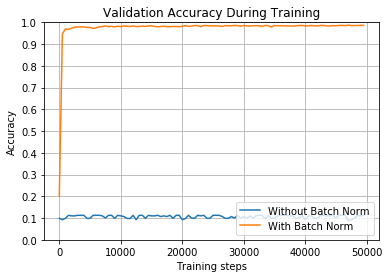

In [35]:
train_and_test(use_larger_weights=False,learning_rate=2,activation_fn=tf.nn.relu)

**BN缓解了internal covariate shift，可以设置一个很大的学习率**  
没有用BN的网络，每个特征维度所需要的learning rate不一样，只能设置一个小的learning rate，才能使网络work

## 4.4 较小的Weights初始化，较大的学习率，sigmoid激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                               | 3/50000 [00:00<27:58, 29.78it/s]

  0%|                                                                                              | 62/50000 [00:00<19:59, 41.64it/s]

  0%|▏                                                                                            | 123/50000 [00:00<14:23, 57.77it/s]

  0%|▎                                                                                            | 183/50000 [00:00<10:29, 79.17it/s]

  0%|▍                                                                                           | 248/50000 [00:00<07:43, 107.45it/s]

  1%|▌                                                                                           | 326/50000 [00:00<05:42, 144.88it/s]

  1%|▋                                                                                           | 403/50000 [00:00<04:19, 191.42it/s]

  1%|▉                                                                                           | 482/50000 [00:00<03:20, 247.33it/s]

  1%|█                                                                                           | 549/50000 [00:01<03:03, 269.22it/s]

  1%|█▏                                                                                          | 614/50000 [00:01<02:31, 325.77it/s]

  1%|█▎                                                                                          | 685/50000 [00:01<02:06, 388.45it/s]

  2%|█▍                                                                                          | 765/50000 [00:01<01:47, 458.76it/s]

  2%|█▌                                                                                          | 842/50000 [00:01<01:34, 520.24it/s]

  2%|█▋                                                                                          | 913/50000 [00:01<01:26, 564.61it/s]

  2%|█▊                                                                                          | 994/50000 [00:01<01:19, 620.01it/s]

  2%|█▉                                                                                         | 1071/50000 [00:01<01:14, 655.56it/s]

  2%|██                                                                                         | 1153/50000 [00:01<01:10, 696.25it/s]

  2%|██▏                                                                                        | 1230/50000 [00:01<01:08, 715.39it/s]

  3%|██▍                                                                                        | 1307/50000 [00:02<01:09, 703.50it/s]

  3%|██▌                                                                                        | 1381/50000 [00:02<01:14, 650.68it/s]

  3%|██▋                                                                                        | 1450/50000 [00:02<01:36, 504.53it/s]

  3%|██▊                                                                                        | 1513/50000 [00:02<01:30, 535.59it/s]

  3%|██▉                                                                                        | 1595/50000 [00:02<01:21, 596.84it/s]

  3%|███                                                                                        | 1670/50000 [00:02<01:16, 634.61it/s]

  4%|███▏                                                                                       | 1752/50000 [00:02<01:11, 679.55it/s]

  4%|███▎                                                                                       | 1827/50000 [00:02<01:09, 695.89it/s]

  4%|███▍                                                                                       | 1905/50000 [00:02<01:07, 715.73it/s]

  4%|███▌                                                                                       | 1981/50000 [00:03<01:06, 726.94it/s]

  4%|███▋                                                                                       | 2056/50000 [00:03<01:08, 703.38it/s]

  4%|███▉                                                                                       | 2135/50000 [00:03<01:05, 725.84it/s]

  4%|████                                                                                       | 2213/50000 [00:03<01:04, 739.74it/s]

  5%|████▏                                                                                      | 2288/50000 [00:03<01:06, 717.83it/s]

  5%|████▎                                                                                      | 2361/50000 [00:03<01:25, 558.39it/s]

  5%|████▍                                                                                      | 2438/50000 [00:03<01:18, 607.54it/s]

  5%|████▌                                                                                      | 2508/50000 [00:03<01:15, 631.36it/s]

  5%|████▋                                                                                      | 2581/50000 [00:04<01:12, 654.95it/s]

  5%|████▊                                                                                      | 2650/50000 [00:04<01:15, 627.58it/s]

  5%|████▉                                                                                      | 2716/50000 [00:04<01:17, 610.98it/s]

  6%|█████                                                                                      | 2779/50000 [00:04<01:18, 602.91it/s]

  6%|█████▏                                                                                     | 2841/50000 [00:04<01:19, 592.75it/s]

  6%|█████▎                                                                                     | 2902/50000 [00:04<01:18, 596.54it/s]

  6%|█████▍                                                                                     | 2964/50000 [00:04<01:18, 600.36it/s]

  6%|█████▌                                                                                     | 3026/50000 [00:04<01:17, 604.79it/s]

  6%|█████▋                                                                                     | 3092/50000 [00:04<01:15, 619.12it/s]

  6%|█████▊                                                                                     | 3162/50000 [00:04<01:13, 640.07it/s]

  6%|█████▊                                                                                     | 3227/50000 [00:05<01:12, 641.62it/s]

  7%|█████▉                                                                                     | 3292/50000 [00:05<01:35, 490.38it/s]

  7%|██████                                                                                     | 3347/50000 [00:05<01:37, 478.21it/s]

  7%|██████▏                                                                                    | 3410/50000 [00:05<01:30, 514.55it/s]

  7%|██████▎                                                                                    | 3474/50000 [00:05<01:25, 544.28it/s]

  7%|██████▍                                                                                    | 3541/50000 [00:05<01:20, 575.67it/s]

  7%|██████▌                                                                                    | 3602/50000 [00:05<01:21, 569.63it/s]

  7%|██████▋                                                                                    | 3663/50000 [00:05<01:20, 578.31it/s]

  7%|██████▊                                                                                    | 3726/50000 [00:06<01:18, 590.03it/s]

  8%|██████▉                                                                                    | 3786/50000 [00:06<01:18, 591.70it/s]

  8%|███████                                                                                    | 3850/50000 [00:06<01:16, 604.16it/s]

  8%|███████                                                                                    | 3912/50000 [00:06<01:15, 607.52it/s]

  8%|███████▏                                                                                   | 3976/50000 [00:06<01:14, 615.61it/s]

  8%|███████▎                                                                                   | 4038/50000 [00:06<01:14, 613.76it/s]

  8%|███████▍                                                                                   | 4108/50000 [00:06<01:12, 634.32it/s]

  8%|███████▌                                                                                   | 4172/50000 [00:06<01:33, 488.30it/s]

  8%|███████▋                                                                                   | 4229/50000 [00:06<01:29, 509.24it/s]

  9%|███████▊                                                                                   | 4286/50000 [00:07<01:27, 525.01it/s]

  9%|███████▉                                                                                   | 4342/50000 [00:07<01:25, 532.40it/s]

  9%|████████                                                                                   | 4401/50000 [00:07<01:23, 547.32it/s]

  9%|████████▏                                                                                  | 4466/50000 [00:07<01:19, 573.47it/s]

  9%|████████▏                                                                                  | 4525/50000 [00:07<01:22, 554.38it/s]

  9%|████████▍                                                                                  | 4606/50000 [00:07<01:14, 611.34it/s]

  9%|████████▌                                                                                  | 4681/50000 [00:07<01:10, 646.01it/s]

 10%|████████▋                                                                                  | 4764/50000 [00:07<01:05, 690.77it/s]

 10%|████████▊                                                                                  | 4843/50000 [00:07<01:03, 716.40it/s]

 10%|████████▉                                                                                  | 4925/50000 [00:07<01:00, 741.13it/s]

 10%|█████████                                                                                  | 5001/50000 [00:08<01:01, 730.10it/s]

 10%|█████████▏                                                                                 | 5076/50000 [00:08<01:01, 732.23it/s]

 10%|█████████▎                                                                                 | 5151/50000 [00:08<01:18, 568.88it/s]

 10%|█████████▌                                                                                 | 5221/50000 [00:08<01:14, 601.62it/s]

 11%|█████████▌                                                                                 | 5286/50000 [00:08<01:16, 581.23it/s]

 11%|█████████▊                                                                                 | 5370/50000 [00:08<01:09, 637.89it/s]

 11%|█████████▉                                                                                 | 5443/50000 [00:08<01:07, 659.88it/s]

 11%|██████████                                                                                 | 5516/50000 [00:08<01:05, 678.08it/s]

 11%|██████████▏                                                                                | 5593/50000 [00:08<01:03, 699.95it/s]

 11%|██████████▎                                                                                | 5665/50000 [00:09<01:04, 682.36it/s]

 11%|██████████▍                                                                                | 5735/50000 [00:09<01:08, 648.07it/s]

 12%|██████████▌                                                                                | 5802/50000 [00:09<01:08, 643.71it/s]

 12%|██████████▋                                                                                | 5868/50000 [00:09<01:08, 643.35it/s]

 12%|██████████▊                                                                                | 5933/50000 [00:09<01:08, 640.13it/s]

 12%|██████████▉                                                                                | 5998/50000 [00:09<01:10, 621.46it/s]

 12%|███████████                                                                                | 6061/50000 [00:09<01:36, 455.60it/s]

 12%|███████████▏                                                                               | 6129/50000 [00:09<01:26, 504.84it/s]

 12%|███████████▎                                                                               | 6193/50000 [00:10<01:21, 537.99it/s]

 13%|███████████▍                                                                               | 6254/50000 [00:10<01:18, 555.11it/s]

 13%|███████████▌                                                                               | 6322/50000 [00:10<01:14, 586.37it/s]

 13%|███████████▋                                                                               | 6390/50000 [00:10<01:11, 610.43it/s]

 13%|███████████▊                                                                               | 6465/50000 [00:10<01:07, 645.31it/s]

 13%|███████████▉                                                                               | 6545/50000 [00:10<01:03, 683.76it/s]

 13%|████████████                                                                               | 6628/50000 [00:10<01:00, 720.55it/s]

 13%|████████████▏                                                                              | 6710/50000 [00:10<00:58, 746.26it/s]

 14%|████████████▎                                                                              | 6793/50000 [00:10<00:56, 765.88it/s]

 14%|████████████▌                                                                              | 6877/50000 [00:10<00:54, 785.09it/s]

 14%|████████████▋                                                                              | 6957/50000 [00:11<01:11, 601.67it/s]

 14%|████████████▊                                                                              | 7025/50000 [00:11<01:10, 611.90it/s]

 14%|████████████▉                                                                              | 7098/50000 [00:11<01:06, 641.88it/s]

 14%|█████████████                                                                              | 7167/50000 [00:11<01:06, 641.49it/s]

 14%|█████████████▏                                                                             | 7249/50000 [00:11<01:02, 685.06it/s]

 15%|█████████████▎                                                                             | 7329/50000 [00:11<00:59, 714.51it/s]

 15%|█████████████▍                                                                             | 7412/50000 [00:11<00:57, 744.17it/s]

 15%|█████████████▋                                                                             | 7489/50000 [00:11<00:56, 750.13it/s]

 15%|█████████████▊                                                                             | 7567/50000 [00:11<00:56, 757.24it/s]

 15%|█████████████▉                                                                             | 7649/50000 [00:12<00:54, 773.43it/s]

 15%|██████████████                                                                             | 7728/50000 [00:12<00:56, 750.17it/s]

 16%|██████████████▏                                                                            | 7804/50000 [00:12<00:57, 734.09it/s]

 16%|██████████████▎                                                                            | 7878/50000 [00:12<01:27, 484.16it/s]

 16%|██████████████▍                                                                            | 7938/50000 [00:12<01:23, 506.48it/s]

 16%|██████████████▌                                                                            | 8015/50000 [00:12<01:14, 563.53it/s]

 16%|██████████████▋                                                                            | 8097/50000 [00:12<01:07, 620.81it/s]

 16%|██████████████▊                                                                            | 8167/50000 [00:13<01:06, 627.61it/s]

 16%|██████████████▉                                                                            | 8235/50000 [00:13<01:05, 639.33it/s]

 17%|███████████████                                                                            | 8307/50000 [00:13<01:03, 660.24it/s]

 17%|███████████████▎                                                                           | 8384/50000 [00:13<01:00, 688.38it/s]

 17%|███████████████▍                                                                           | 8456/50000 [00:13<00:59, 696.09it/s]

 17%|███████████████▌                                                                           | 8528/50000 [00:13<01:05, 629.96it/s]

 17%|███████████████▋                                                                           | 8599/50000 [00:13<01:03, 648.93it/s]

 17%|███████████████▊                                                                           | 8666/50000 [00:13<01:03, 653.71it/s]

 17%|███████████████▉                                                                           | 8733/50000 [00:13<01:03, 645.73it/s]

 18%|████████████████                                                                           | 8799/50000 [00:14<01:25, 484.67it/s]

 18%|████████████████                                                                           | 8855/50000 [00:14<01:22, 500.02it/s]

 18%|████████████████▏                                                                          | 8911/50000 [00:14<01:19, 514.16it/s]

 18%|████████████████▎                                                                          | 8969/50000 [00:14<01:17, 529.74it/s]

 18%|████████████████▍                                                                          | 9025/50000 [00:14<01:17, 528.26it/s]

 18%|████████████████▌                                                                          | 9085/50000 [00:14<01:14, 546.82it/s]

 18%|████████████████▋                                                                          | 9145/50000 [00:14<01:12, 560.60it/s]

 18%|████████████████▊                                                                          | 9210/50000 [00:14<01:09, 583.59it/s]

 19%|████████████████▉                                                                          | 9279/50000 [00:14<01:06, 610.70it/s]

 19%|█████████████████                                                                          | 9345/50000 [00:14<01:05, 623.42it/s]

 19%|█████████████████                                                                          | 9409/50000 [00:15<01:05, 617.90it/s]

 19%|█████████████████▏                                                                         | 9472/50000 [00:15<01:05, 614.71it/s]

 19%|█████████████████▎                                                                         | 9534/50000 [00:15<01:06, 611.32it/s]

 19%|█████████████████▍                                                                         | 9615/50000 [00:15<01:01, 658.70it/s]

 19%|█████████████████▌                                                                         | 9683/50000 [00:15<01:19, 505.59it/s]

 20%|█████████████████▊                                                                         | 9762/50000 [00:15<01:11, 565.92it/s]

 20%|█████████████████▉                                                                         | 9847/50000 [00:15<01:04, 626.58it/s]

 20%|██████████████████                                                                         | 9929/50000 [00:15<00:59, 673.08it/s]

 20%|██████████████████                                                                        | 10007/50000 [00:16<00:57, 698.69it/s]

 20%|██████████████████▏                                                                       | 10086/50000 [00:16<00:55, 722.33it/s]

 20%|██████████████████▎                                                                       | 10162/50000 [00:16<00:54, 731.69it/s]

 20%|██████████████████▍                                                                       | 10245/50000 [00:16<00:52, 757.13it/s]

 21%|██████████████████▌                                                                       | 10331/50000 [00:16<00:50, 781.61it/s]

 21%|██████████████████▋                                                                       | 10411/50000 [00:16<00:52, 747.99it/s]

 21%|██████████████████▉                                                                       | 10492/50000 [00:16<00:51, 761.85it/s]

 21%|███████████████████                                                                       | 10570/50000 [00:16<00:58, 677.95it/s]

 21%|███████████████████▏                                                                      | 10641/50000 [00:16<01:16, 514.73it/s]

 21%|███████████████████▎                                                                      | 10723/50000 [00:17<01:07, 578.55it/s]

 22%|███████████████████▍                                                                      | 10798/50000 [00:17<01:03, 620.02it/s]

 22%|███████████████████▌                                                                      | 10874/50000 [00:17<00:59, 655.05it/s]

 22%|███████████████████▋                                                                      | 10947/50000 [00:17<00:58, 672.63it/s]

 22%|███████████████████▊                                                                      | 11018/50000 [00:17<00:58, 666.66it/s]

 22%|███████████████████▉                                                                      | 11101/50000 [00:17<00:55, 707.16it/s]

 22%|████████████████████▏                                                                     | 11182/50000 [00:17<00:52, 733.71it/s]

 23%|████████████████████▎                                                                     | 11258/50000 [00:17<00:52, 739.82it/s]

 23%|████████████████████▍                                                                     | 11339/50000 [00:17<00:51, 758.01it/s]

 23%|████████████████████▌                                                                     | 11420/50000 [00:18<00:50, 771.27it/s]

 23%|████████████████████▋                                                                     | 11501/50000 [00:18<01:03, 606.04it/s]

 23%|████████████████████▊                                                                     | 11576/50000 [00:18<00:59, 641.87it/s]

 23%|████████████████████▉                                                                     | 11650/50000 [00:18<00:57, 667.14it/s]

 23%|█████████████████████                                                                     | 11721/50000 [00:18<00:56, 674.17it/s]

 24%|█████████████████████▏                                                                    | 11800/50000 [00:18<00:54, 703.81it/s]

 24%|█████████████████████▍                                                                    | 11876/50000 [00:18<00:53, 718.29it/s]

 24%|█████████████████████▌                                                                    | 11950/50000 [00:18<00:57, 657.73it/s]

 24%|█████████████████████▋                                                                    | 12018/50000 [00:19<01:04, 584.42it/s]

 24%|█████████████████████▋                                                                    | 12080/50000 [00:19<01:09, 542.18it/s]

 24%|█████████████████████▊                                                                    | 12137/50000 [00:19<01:11, 532.17it/s]

 24%|█████████████████████▉                                                                    | 12193/50000 [00:19<01:10, 534.50it/s]

 25%|██████████████████████                                                                    | 12252/50000 [00:19<01:08, 548.90it/s]

 25%|██████████████████████▏                                                                   | 12308/50000 [00:19<01:13, 511.82it/s]

 25%|██████████████████████▏                                                                   | 12361/50000 [00:19<01:14, 508.63it/s]

 25%|██████████████████████▎                                                                   | 12417/50000 [00:19<01:32, 406.36it/s]

 25%|██████████████████████▍                                                                   | 12475/50000 [00:19<01:24, 445.71it/s]

 25%|██████████████████████▌                                                                   | 12534/50000 [00:20<01:18, 480.14it/s]

 25%|██████████████████████▋                                                                   | 12605/50000 [00:20<01:10, 530.92it/s]

 25%|██████████████████████▊                                                                   | 12678/50000 [00:20<01:04, 575.86it/s]

 26%|██████████████████████▉                                                                   | 12754/50000 [00:20<01:00, 619.89it/s]

 26%|███████████████████████                                                                   | 12827/50000 [00:20<00:57, 646.29it/s]

 26%|███████████████████████▏                                                                  | 12906/50000 [00:20<00:54, 682.30it/s]

 26%|███████████████████████▍                                                                  | 12989/50000 [00:20<00:51, 719.41it/s]

 26%|███████████████████████▌                                                                  | 13064/50000 [00:20<00:56, 658.09it/s]

 26%|███████████████████████▋                                                                  | 13133/50000 [00:20<01:00, 612.84it/s]

 26%|███████████████████████▊                                                                  | 13197/50000 [00:21<01:03, 582.33it/s]

 27%|███████████████████████▊                                                                  | 13258/50000 [00:21<01:05, 561.53it/s]

 27%|███████████████████████▉                                                                  | 13316/50000 [00:21<01:04, 565.74it/s]

 27%|████████████████████████                                                                  | 13374/50000 [00:21<01:20, 457.35it/s]

 27%|████████████████████████▏                                                                 | 13428/50000 [00:21<01:16, 477.16it/s]

 27%|████████████████████████▎                                                                 | 13500/50000 [00:21<01:08, 530.02it/s]

 27%|████████████████████████▍                                                                 | 13558/50000 [00:21<01:09, 521.08it/s]

 27%|████████████████████████▌                                                                 | 13616/50000 [00:21<01:07, 536.37it/s]

 27%|████████████████████████▌                                                                 | 13672/50000 [00:22<01:07, 542.10it/s]

 27%|████████████████████████▋                                                                 | 13730/50000 [00:22<01:05, 550.18it/s]

 28%|████████████████████████▊                                                                 | 13790/50000 [00:22<01:04, 563.11it/s]

 28%|████████████████████████▉                                                                 | 13848/50000 [00:22<01:05, 552.32it/s]

 28%|█████████████████████████                                                                 | 13907/50000 [00:22<01:04, 561.94it/s]

 28%|█████████████████████████▏                                                                | 13964/50000 [00:22<01:04, 561.45it/s]

 28%|█████████████████████████▏                                                                | 14021/50000 [00:22<01:04, 556.19it/s]

 28%|█████████████████████████▎                                                                | 14082/50000 [00:22<01:03, 568.55it/s]

 28%|█████████████████████████▍                                                                | 14140/50000 [00:22<01:02, 570.71it/s]

 28%|█████████████████████████▌                                                                | 14198/50000 [00:22<01:03, 563.90it/s]

 29%|█████████████████████████▋                                                                | 14255/50000 [00:23<01:29, 399.81it/s]

 29%|█████████████████████████▋                                                                | 14302/50000 [00:23<01:26, 413.36it/s]

 29%|█████████████████████████▊                                                                | 14370/50000 [00:23<01:16, 467.76it/s]

 29%|█████████████████████████▉                                                                | 14440/50000 [00:23<01:08, 518.62it/s]

 29%|██████████████████████████                                                                | 14513/50000 [00:23<01:02, 566.99it/s]

 29%|██████████████████████████▎                                                               | 14597/50000 [00:23<00:56, 627.22it/s]

 29%|██████████████████████████▍                                                               | 14678/50000 [00:23<00:52, 671.54it/s]

 30%|██████████████████████████▌                                                               | 14754/50000 [00:23<00:50, 694.45it/s]

 30%|██████████████████████████▋                                                               | 14832/50000 [00:23<00:49, 716.63it/s]

 30%|██████████████████████████▊                                                               | 14907/50000 [00:24<00:50, 700.47it/s]

 30%|██████████████████████████▉                                                               | 14980/50000 [00:24<00:53, 650.94it/s]

 30%|███████████████████████████                                                               | 15048/50000 [00:24<00:57, 611.94it/s]

 30%|███████████████████████████▏                                                              | 15112/50000 [00:24<00:58, 599.70it/s]

 30%|███████████████████████████▎                                                              | 15174/50000 [00:24<01:17, 449.58it/s]

 30%|███████████████████████████▍                                                              | 15231/50000 [00:24<01:12, 479.16it/s]

 31%|███████████████████████████▌                                                              | 15291/50000 [00:24<01:08, 509.03it/s]

 31%|███████████████████████████▋                                                              | 15353/50000 [00:24<01:04, 536.89it/s]

 31%|███████████████████████████▋                                                              | 15412/50000 [00:25<01:02, 550.67it/s]

 31%|███████████████████████████▊                                                              | 15472/50000 [00:25<01:01, 563.43it/s]

 31%|███████████████████████████▉                                                              | 15531/50000 [00:25<01:02, 550.83it/s]

 31%|████████████████████████████                                                              | 15608/50000 [00:25<00:57, 601.23it/s]

 31%|████████████████████████████▏                                                             | 15679/50000 [00:25<00:54, 628.97it/s]

 32%|████████████████████████████▎                                                             | 15754/50000 [00:25<00:51, 659.70it/s]

 32%|████████████████████████████▌                                                             | 15839/50000 [00:25<00:48, 705.91it/s]

 32%|████████████████████████████▋                                                             | 15924/50000 [00:25<00:45, 742.31it/s]

 32%|████████████████████████████▊                                                             | 16007/50000 [00:25<00:44, 762.95it/s]

 32%|████████████████████████████▉                                                             | 16085/50000 [00:26<00:56, 601.81it/s]

 32%|█████████████████████████████                                                             | 16161/50000 [00:26<00:52, 640.71it/s]

 32%|█████████████████████████████▏                                                            | 16237/50000 [00:26<00:50, 671.07it/s]

 33%|█████████████████████████████▎                                                            | 16313/50000 [00:26<00:48, 694.09it/s]

 33%|█████████████████████████████▌                                                            | 16395/50000 [00:26<00:46, 726.19it/s]

 33%|█████████████████████████████▋                                                            | 16471/50000 [00:26<00:46, 726.06it/s]

 33%|█████████████████████████████▊                                                            | 16546/50000 [00:26<00:45, 731.51it/s]

 33%|█████████████████████████████▉                                                            | 16628/50000 [00:26<00:44, 754.46it/s]

 33%|██████████████████████████████                                                            | 16712/50000 [00:26<00:42, 776.66it/s]

 34%|██████████████████████████████▏                                                           | 16792/50000 [00:27<00:42, 781.84it/s]

 34%|██████████████████████████████▎                                                           | 16874/50000 [00:27<00:41, 791.23it/s]

 34%|██████████████████████████████▌                                                           | 16959/50000 [00:27<00:40, 806.31it/s]

 34%|██████████████████████████████▋                                                           | 17041/50000 [00:27<00:54, 609.13it/s]

 34%|██████████████████████████████▊                                                           | 17110/50000 [00:27<00:53, 618.24it/s]

 34%|██████████████████████████████▉                                                           | 17189/50000 [00:27<00:49, 660.17it/s]

 35%|███████████████████████████████                                                           | 17273/50000 [00:27<00:46, 704.18it/s]

 35%|███████████████████████████████▏                                                          | 17358/50000 [00:27<00:44, 740.97it/s]

 35%|███████████████████████████████▍                                                          | 17440/50000 [00:27<00:42, 761.48it/s]

 35%|███████████████████████████████▌                                                          | 17519/50000 [00:28<00:42, 759.34it/s]

 35%|███████████████████████████████▋                                                          | 17602/50000 [00:28<00:41, 777.64it/s]

 35%|███████████████████████████████▊                                                          | 17685/50000 [00:28<00:40, 790.99it/s]

 36%|███████████████████████████████▉                                                          | 17767/50000 [00:28<00:40, 795.45it/s]

 36%|████████████████████████████████▏                                                         | 17848/50000 [00:28<00:41, 781.90it/s]

 36%|████████████████████████████████▎                                                         | 17927/50000 [00:28<00:54, 587.56it/s]

 36%|████████████████████████████████▍                                                         | 18001/50000 [00:28<00:51, 621.96it/s]

 36%|████████████████████████████████▌                                                         | 18071/50000 [00:28<00:49, 642.19it/s]

 36%|████████████████████████████████▋                                                         | 18150/50000 [00:28<00:46, 679.10it/s]

 36%|████████████████████████████████▊                                                         | 18222/50000 [00:29<00:47, 672.04it/s]

 37%|████████████████████████████████▉                                                         | 18292/50000 [00:29<00:47, 667.18it/s]

 37%|█████████████████████████████████                                                         | 18361/50000 [00:29<00:47, 662.77it/s]

 37%|█████████████████████████████████▏                                                        | 18429/50000 [00:29<00:49, 633.00it/s]

 37%|█████████████████████████████████▎                                                        | 18494/50000 [00:29<00:52, 599.73it/s]

 37%|█████████████████████████████████▍                                                        | 18556/50000 [00:29<00:56, 555.75it/s]

 37%|█████████████████████████████████▌                                                        | 18614/50000 [00:29<00:56, 556.77it/s]

 37%|█████████████████████████████████▌                                                        | 18676/50000 [00:29<00:54, 573.18it/s]

 37%|█████████████████████████████████▋                                                        | 18736/50000 [00:29<00:53, 579.74it/s]

 38%|█████████████████████████████████▊                                                        | 18797/50000 [00:30<00:53, 587.26it/s]

 38%|█████████████████████████████████▉                                                        | 18857/50000 [00:30<01:12, 432.16it/s]

 38%|██████████████████████████████████                                                        | 18913/50000 [00:30<01:07, 463.09it/s]

 38%|██████████████████████████████████▏                                                       | 18979/50000 [00:30<01:01, 507.76it/s]

 38%|██████████████████████████████████▎                                                       | 19035/50000 [00:30<01:02, 496.42it/s]

 38%|██████████████████████████████████▎                                                       | 19089/50000 [00:30<01:02, 497.88it/s]

 38%|██████████████████████████████████▍                                                       | 19158/50000 [00:30<00:56, 542.33it/s]

 38%|██████████████████████████████████▌                                                       | 19218/50000 [00:30<00:55, 557.29it/s]

 39%|██████████████████████████████████▋                                                       | 19284/50000 [00:31<00:52, 583.45it/s]

 39%|██████████████████████████████████▊                                                       | 19351/50000 [00:31<00:50, 605.77it/s]

 39%|██████████████████████████████████▉                                                       | 19414/50000 [00:31<00:58, 524.68it/s]

 39%|███████████████████████████████████                                                       | 19485/50000 [00:31<00:53, 568.26it/s]

 39%|███████████████████████████████████▏                                                      | 19552/50000 [00:31<00:51, 592.65it/s]

 39%|███████████████████████████████████▎                                                      | 19614/50000 [00:31<00:51, 590.78it/s]

 39%|███████████████████████████████████▍                                                      | 19678/50000 [00:31<00:50, 603.49it/s]

 39%|███████████████████████████████████▌                                                      | 19740/50000 [00:31<00:50, 603.50it/s]

 40%|███████████████████████████████████▋                                                      | 19802/50000 [00:32<01:09, 435.01it/s]

 40%|███████████████████████████████████▋                                                      | 19856/50000 [00:32<01:05, 459.92it/s]

 40%|███████████████████████████████████▊                                                      | 19908/50000 [00:32<01:08, 438.30it/s]

 40%|███████████████████████████████████▉                                                      | 19965/50000 [00:32<01:03, 470.10it/s]

 40%|████████████████████████████████████                                                      | 20023/50000 [00:32<01:00, 497.49it/s]

 40%|████████████████████████████████████▏                                                     | 20097/50000 [00:32<00:54, 550.84it/s]

 40%|████████████████████████████████████▎                                                     | 20176/50000 [00:32<00:49, 604.85it/s]

 41%|████████████████████████████████████▍                                                     | 20262/50000 [00:32<00:44, 662.82it/s]

 41%|████████████████████████████████████▌                                                     | 20347/50000 [00:32<00:41, 708.41it/s]

 41%|████████████████████████████████████▊                                                     | 20422/50000 [00:32<00:41, 706.72it/s]

 41%|████████████████████████████████████▉                                                     | 20501/50000 [00:33<00:40, 728.33it/s]

 41%|█████████████████████████████████████                                                     | 20581/50000 [00:33<00:39, 746.91it/s]

 41%|█████████████████████████████████████▏                                                    | 20666/50000 [00:33<00:37, 773.57it/s]

 41%|█████████████████████████████████████▎                                                    | 20745/50000 [00:33<00:50, 584.25it/s]

 42%|█████████████████████████████████████▍                                                    | 20812/50000 [00:33<00:48, 603.10it/s]

 42%|█████████████████████████████████████▌                                                    | 20894/50000 [00:33<00:44, 653.94it/s]

 42%|█████████████████████████████████████▊                                                    | 20980/50000 [00:33<00:41, 703.33it/s]

 42%|█████████████████████████████████████▉                                                    | 21056/50000 [00:33<00:40, 705.96it/s]

 42%|██████████████████████████████████████                                                    | 21140/50000 [00:33<00:38, 740.02it/s]

 42%|██████████████████████████████████████▏                                                   | 21217/50000 [00:34<00:41, 691.00it/s]

 43%|██████████████████████████████████████▎                                                   | 21289/50000 [00:34<00:45, 633.61it/s]

 43%|██████████████████████████████████████▍                                                   | 21356/50000 [00:34<00:50, 562.11it/s]

 43%|██████████████████████████████████████▌                                                   | 21416/50000 [00:34<00:53, 529.50it/s]

 43%|██████████████████████████████████████▋                                                   | 21472/50000 [00:34<00:55, 513.58it/s]

 43%|██████████████████████████████████████▊                                                   | 21542/50000 [00:34<00:51, 557.20it/s]

 43%|██████████████████████████████████████▉                                                   | 21601/50000 [00:34<01:06, 426.15it/s]

 43%|██████████████████████████████████████▉                                                   | 21659/50000 [00:35<01:01, 462.19it/s]

 43%|███████████████████████████████████████                                                   | 21721/50000 [00:35<00:56, 499.51it/s]

 44%|███████████████████████████████████████▏                                                  | 21792/50000 [00:35<00:51, 546.09it/s]

 44%|███████████████████████████████████████▎                                                  | 21871/50000 [00:35<00:46, 600.83it/s]

 44%|███████████████████████████████████████▍                                                  | 21937/50000 [00:35<00:45, 614.46it/s]

 44%|███████████████████████████████████████▌                                                  | 22002/50000 [00:35<00:45, 609.40it/s]

 44%|███████████████████████████████████████▋                                                  | 22066/50000 [00:35<00:45, 613.43it/s]

 44%|███████████████████████████████████████▊                                                  | 22130/50000 [00:35<00:47, 582.70it/s]

 44%|███████████████████████████████████████▉                                                  | 22190/50000 [00:35<00:49, 565.04it/s]

 44%|████████████████████████████████████████                                                  | 22248/50000 [00:36<00:49, 560.02it/s]

 45%|████████████████████████████████████████▏                                                 | 22325/50000 [00:36<00:45, 608.86it/s]

 45%|████████████████████████████████████████▎                                                 | 22404/50000 [00:36<00:42, 652.65it/s]

 45%|████████████████████████████████████████▍                                                 | 22488/50000 [00:36<00:39, 698.18it/s]

 45%|████████████████████████████████████████▌                                                 | 22561/50000 [00:36<00:50, 539.05it/s]

 45%|████████████████████████████████████████▋                                                 | 22635/50000 [00:36<00:46, 585.84it/s]

 45%|████████████████████████████████████████▊                                                 | 22700/50000 [00:36<00:46, 591.01it/s]

 46%|████████████████████████████████████████▉                                                 | 22764/50000 [00:36<00:47, 569.84it/s]

 46%|█████████████████████████████████████████                                                 | 22825/50000 [00:36<00:48, 562.50it/s]

 46%|█████████████████████████████████████████▏                                                | 22892/50000 [00:37<00:45, 589.85it/s]

 46%|█████████████████████████████████████████▎                                                | 22969/50000 [00:37<00:42, 633.23it/s]

 46%|█████████████████████████████████████████▍                                                | 23035/50000 [00:37<00:43, 612.98it/s]

 46%|█████████████████████████████████████████▌                                                | 23099/50000 [00:37<00:46, 580.85it/s]

 46%|█████████████████████████████████████████▋                                                | 23159/50000 [00:37<00:48, 552.95it/s]

 46%|█████████████████████████████████████████▊                                                | 23220/50000 [00:37<00:47, 567.75it/s]

 47%|█████████████████████████████████████████▉                                                | 23285/50000 [00:37<00:45, 587.39it/s]

 47%|██████████████████████████████████████████                                                | 23345/50000 [00:37<00:47, 561.75it/s]

 47%|██████████████████████████████████████████▏                                               | 23403/50000 [00:37<00:48, 552.98it/s]

 47%|██████████████████████████████████████████▏                                               | 23459/50000 [00:38<01:06, 401.71it/s]

 47%|██████████████████████████████████████████▎                                               | 23506/50000 [00:38<01:05, 405.14it/s]

 47%|██████████████████████████████████████████▍                                               | 23564/50000 [00:38<00:59, 444.68it/s]

 47%|██████████████████████████████████████████▌                                               | 23615/50000 [00:38<00:57, 461.53it/s]

 47%|██████████████████████████████████████████▌                                               | 23674/50000 [00:38<00:53, 491.65it/s]

 47%|██████████████████████████████████████████▋                                               | 23736/50000 [00:38<00:50, 521.92it/s]

 48%|██████████████████████████████████████████▊                                               | 23805/50000 [00:38<00:46, 562.06it/s]

 48%|██████████████████████████████████████████▉                                               | 23877/50000 [00:38<00:43, 599.06it/s]

 48%|███████████████████████████████████████████                                               | 23944/50000 [00:39<00:42, 615.77it/s]

 48%|███████████████████████████████████████████▏                                              | 24008/50000 [00:39<00:43, 603.97it/s]

 48%|███████████████████████████████████████████▎                                              | 24070/50000 [00:39<00:42, 607.38it/s]

 48%|███████████████████████████████████████████▍                                              | 24137/50000 [00:39<00:41, 621.90it/s]

 48%|███████████████████████████████████████████▌                                              | 24200/50000 [00:39<00:42, 608.55it/s]

 49%|███████████████████████████████████████████▋                                              | 24267/50000 [00:39<00:41, 624.49it/s]

 49%|███████████████████████████████████████████▊                                              | 24334/50000 [00:39<00:51, 497.61it/s]

 49%|███████████████████████████████████████████▉                                              | 24398/50000 [00:39<00:48, 532.23it/s]

 49%|████████████████████████████████████████████                                              | 24462/50000 [00:39<00:45, 559.47it/s]

 49%|████████████████████████████████████████████▏                                             | 24525/50000 [00:40<00:44, 577.75it/s]

 49%|████████████████████████████████████████████▎                                             | 24598/50000 [00:40<00:41, 615.18it/s]

 49%|████████████████████████████████████████████▍                                             | 24670/50000 [00:40<00:39, 642.02it/s]

 50%|████████████████████████████████████████████▌                                             | 24755/50000 [00:40<00:36, 691.64it/s]

 50%|████████████████████████████████████████████▋                                             | 24835/50000 [00:40<00:34, 719.51it/s]

 50%|████████████████████████████████████████████▊                                             | 24910/50000 [00:40<00:34, 726.85it/s]

 50%|████████████████████████████████████████████▉                                             | 24985/50000 [00:40<00:38, 653.79it/s]

 50%|█████████████████████████████████████████████                                             | 25053/50000 [00:40<00:40, 615.36it/s]

 50%|█████████████████████████████████████████████▏                                            | 25129/50000 [00:40<00:38, 651.39it/s]

 50%|█████████████████████████████████████████████▎                                            | 25207/50000 [00:41<00:36, 683.97it/s]

 51%|█████████████████████████████████████████████▌                                            | 25278/50000 [00:41<00:47, 519.41it/s]

 51%|█████████████████████████████████████████████▌                                            | 25338/50000 [00:41<00:48, 509.94it/s]

 51%|█████████████████████████████████████████████▋                                            | 25395/50000 [00:41<00:47, 514.17it/s]

 51%|█████████████████████████████████████████████▊                                            | 25451/50000 [00:41<00:46, 524.55it/s]

 51%|█████████████████████████████████████████████▉                                            | 25507/50000 [00:41<00:47, 515.94it/s]

 51%|██████████████████████████████████████████████                                            | 25566/50000 [00:41<00:45, 535.07it/s]

 51%|██████████████████████████████████████████████▏                                           | 25645/50000 [00:41<00:41, 591.45it/s]

 51%|██████████████████████████████████████████████▎                                           | 25714/50000 [00:41<00:39, 616.71it/s]

 52%|██████████████████████████████████████████████▍                                           | 25778/50000 [00:42<00:39, 615.03it/s]

 52%|██████████████████████████████████████████████▌                                           | 25848/50000 [00:42<00:38, 635.27it/s]

 52%|██████████████████████████████████████████████▋                                           | 25930/50000 [00:42<00:35, 680.08it/s]

 52%|██████████████████████████████████████████████▊                                           | 26003/50000 [00:42<00:34, 692.87it/s]

 52%|██████████████████████████████████████████████▉                                           | 26081/50000 [00:42<00:33, 715.46it/s]

 52%|███████████████████████████████████████████████                                           | 26163/50000 [00:42<00:32, 742.44it/s]

 52%|███████████████████████████████████████████████▏                                          | 26239/50000 [00:42<00:47, 505.50it/s]

 53%|███████████████████████████████████████████████▎                                          | 26301/50000 [00:42<00:46, 512.98it/s]

 53%|███████████████████████████████████████████████▍                                          | 26360/50000 [00:43<00:46, 508.09it/s]

 53%|███████████████████████████████████████████████▌                                          | 26417/50000 [00:43<00:45, 521.28it/s]

 53%|███████████████████████████████████████████████▋                                          | 26489/50000 [00:43<00:41, 567.39it/s]

 53%|███████████████████████████████████████████████▊                                          | 26556/50000 [00:43<00:39, 593.56it/s]

 53%|███████████████████████████████████████████████▉                                          | 26634/50000 [00:43<00:36, 638.26it/s]

 53%|████████████████████████████████████████████████                                          | 26709/50000 [00:43<00:34, 666.82it/s]

 54%|████████████████████████████████████████████████▏                                         | 26779/50000 [00:43<00:34, 669.22it/s]

 54%|████████████████████████████████████████████████▎                                         | 26855/50000 [00:43<00:33, 692.70it/s]

 54%|████████████████████████████████████████████████▍                                         | 26932/50000 [00:43<00:32, 712.76it/s]

 54%|████████████████████████████████████████████████▌                                         | 27005/50000 [00:43<00:32, 716.27it/s]

 54%|████████████████████████████████████████████████▋                                         | 27078/50000 [00:44<00:36, 624.92it/s]

 54%|████████████████████████████████████████████████▊                                         | 27144/50000 [00:44<00:47, 476.34it/s]

 54%|████████████████████████████████████████████████▉                                         | 27202/50000 [00:44<00:45, 502.37it/s]

 55%|█████████████████████████████████████████████████                                         | 27260/50000 [00:44<00:43, 520.95it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27317/50000 [00:44<00:42, 529.20it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27389/50000 [00:44<00:39, 573.90it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27453/50000 [00:44<00:38, 591.07it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27517/50000 [00:44<00:37, 603.69it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27587/50000 [00:45<00:35, 628.44it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27652/50000 [00:45<00:35, 631.56it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27723/50000 [00:45<00:34, 651.90it/s]

 56%|██████████████████████████████████████████████████                                        | 27800/50000 [00:45<00:32, 682.01it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27873/50000 [00:45<00:31, 694.28it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27950/50000 [00:45<00:30, 713.93it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28023/50000 [00:45<00:44, 497.70it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28092/50000 [00:45<00:40, 542.18it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28174/50000 [00:46<00:36, 601.23it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28250/50000 [00:46<00:33, 640.24it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28332/50000 [00:46<00:31, 684.06it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28416/50000 [00:46<00:29, 723.04it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28493/50000 [00:46<00:31, 687.83it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28565/50000 [00:46<00:31, 674.26it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28635/50000 [00:46<00:32, 657.37it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28716/50000 [00:46<00:30, 695.46it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28794/50000 [00:46<00:29, 717.39it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28875/50000 [00:46<00:28, 741.38it/s]

 58%|████████████████████████████████████████████████████                                      | 28951/50000 [00:47<00:37, 565.93it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29020/50000 [00:47<00:35, 597.07it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29102/50000 [00:47<00:32, 648.96it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29184/50000 [00:47<00:30, 691.00it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29258/50000 [00:47<00:29, 701.54it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29332/50000 [00:47<00:30, 681.75it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29403/50000 [00:47<00:30, 682.58it/s]

 59%|█████████████████████████████████████████████████████                                     | 29473/50000 [00:47<00:30, 680.25it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29548/50000 [00:48<00:29, 698.34it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29633/50000 [00:48<00:27, 734.53it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29708/50000 [00:48<00:27, 737.51it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29792/50000 [00:48<00:26, 764.01it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29870/50000 [00:48<00:34, 584.71it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29951/50000 [00:48<00:31, 636.84it/s]

 60%|██████████████████████████████████████████████████████                                    | 30021/50000 [00:48<00:30, 647.79it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30093/50000 [00:48<00:29, 666.53it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30167/50000 [00:48<00:28, 685.60it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30239/50000 [00:49<00:28, 694.10it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30311/50000 [00:49<00:30, 650.94it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30378/50000 [00:49<00:31, 631.13it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30443/50000 [00:49<00:35, 558.54it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30502/50000 [00:49<00:37, 524.26it/s]

 61%|███████████████████████████████████████████████████████                                   | 30561/50000 [00:49<00:35, 541.30it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30630/50000 [00:49<00:33, 577.65it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30703/50000 [00:49<00:31, 615.10it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30767/50000 [00:50<00:39, 485.67it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30831/50000 [00:50<00:36, 522.59it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30899/50000 [00:50<00:34, 560.60it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30980/50000 [00:50<00:30, 616.62it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31058/50000 [00:50<00:28, 655.10it/s]

 62%|████████████████████████████████████████████████████████                                  | 31137/50000 [00:50<00:27, 687.32it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31209/50000 [00:50<00:27, 675.84it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31279/50000 [00:50<00:27, 679.48it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31354/50000 [00:50<00:26, 697.78it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31439/50000 [00:50<00:25, 736.00it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31516/50000 [00:51<00:24, 744.30it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31599/50000 [00:51<00:24, 766.53it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31677/50000 [00:51<00:30, 593.73it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31752/50000 [00:51<00:28, 632.17it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31833/50000 [00:51<00:26, 675.50it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31907/50000 [00:51<00:26, 692.18it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31980/50000 [00:51<00:26, 682.04it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32051/50000 [00:51<00:26, 688.74it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32127/50000 [00:51<00:25, 707.23it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32211/50000 [00:52<00:24, 741.00it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32293/50000 [00:52<00:23, 761.50it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32376/50000 [00:52<00:22, 779.23it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32462/50000 [00:52<00:21, 800.18it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32543/50000 [00:52<00:22, 769.47it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32621/50000 [00:52<00:31, 547.48it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32689/50000 [00:52<00:29, 580.41it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32774/50000 [00:52<00:26, 640.38it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32850/50000 [00:53<00:25, 670.82it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32927/50000 [00:53<00:24, 696.39it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33001/50000 [00:53<00:24, 689.69it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33075/50000 [00:53<00:24, 702.59it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33151/50000 [00:53<00:23, 717.39it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33232/50000 [00:53<00:22, 741.38it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33308/50000 [00:53<00:23, 700.07it/s]

 67%|████████████████████████████████████████████████████████████                              | 33380/50000 [00:53<00:26, 620.83it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33445/50000 [00:53<00:26, 615.51it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33509/50000 [00:54<00:37, 444.46it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33564/50000 [00:54<00:35, 469.52it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33621/50000 [00:54<00:33, 494.80it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33679/50000 [00:54<00:31, 515.23it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33742/50000 [00:54<00:29, 542.58it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33805/50000 [00:54<00:28, 563.52it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33870/50000 [00:54<00:27, 584.22it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33935/50000 [00:54<00:26, 601.29it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34000/50000 [00:54<00:26, 613.84it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34063/50000 [00:55<00:25, 615.47it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34128/50000 [00:55<00:25, 624.12it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34198/50000 [00:55<00:24, 642.03it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34266/50000 [00:55<00:24, 649.73it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34339/50000 [00:55<00:23, 670.55it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34417/50000 [00:55<00:27, 561.67it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34485/50000 [00:55<00:26, 589.91it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34558/50000 [00:55<00:24, 624.80it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34641/50000 [00:55<00:22, 673.65it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34722/50000 [00:56<00:21, 708.12it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34803/50000 [00:56<00:20, 732.44it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34884/50000 [00:56<00:20, 752.57it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34964/50000 [00:56<00:19, 762.41it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35042/50000 [00:56<00:19, 750.52it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35126/50000 [00:56<00:19, 773.73it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35205/50000 [00:56<00:20, 727.62it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35279/50000 [00:56<00:20, 727.57it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35353/50000 [00:57<00:26, 552.12it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35432/50000 [00:57<00:24, 605.93it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35510/50000 [00:57<00:22, 648.23it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35591/50000 [00:57<00:20, 688.26it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35675/50000 [00:57<00:19, 726.31it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 35752/50000 [00:57<00:19, 726.93it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35835/50000 [00:57<00:18, 753.55it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35913/50000 [00:57<00:18, 744.48it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35989/50000 [00:57<00:19, 705.91it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36062/50000 [00:57<00:19, 707.33it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36144/50000 [00:58<00:18, 736.28it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36227/50000 [00:58<00:18, 760.57it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36304/50000 [00:58<00:23, 582.43it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36381/50000 [00:58<00:21, 627.23it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36462/50000 [00:58<00:20, 671.55it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36535/50000 [00:58<00:19, 684.73it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36608/50000 [00:58<00:19, 686.46it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36683/50000 [00:58<00:18, 702.91it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36760/50000 [00:58<00:18, 720.30it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36834/50000 [00:59<00:19, 682.55it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36904/50000 [00:59<00:20, 648.19it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36971/50000 [00:59<00:20, 647.52it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37037/50000 [00:59<00:20, 625.84it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37101/50000 [00:59<00:21, 614.21it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37164/50000 [00:59<00:21, 593.19it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37224/50000 [00:59<00:28, 453.04it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37288/50000 [00:59<00:25, 495.72it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37351/50000 [01:00<00:23, 528.61it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37415/50000 [01:00<00:22, 555.22it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37484/50000 [01:00<00:21, 588.68it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37558/50000 [01:00<00:19, 625.99it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37640/50000 [01:00<00:18, 672.61it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37725/50000 [01:00<00:17, 716.20it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37811/50000 [01:00<00:16, 752.58it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37889/50000 [01:00<00:16, 743.82it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37966/50000 [01:00<00:16, 745.54it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38042/50000 [01:01<00:16, 726.79it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38116/50000 [01:01<00:21, 542.13it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38189/50000 [01:01<00:20, 586.46it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38258/50000 [01:01<00:19, 612.91it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38325/50000 [01:01<00:20, 582.01it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38389/50000 [01:01<00:19, 597.05it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38459/50000 [01:01<00:18, 623.39it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38535/50000 [01:01<00:17, 657.67it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38608/50000 [01:01<00:16, 674.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38677/50000 [01:02<00:16, 675.68it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38747/50000 [01:02<00:16, 681.34it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38830/50000 [01:02<00:15, 718.67it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38906/50000 [01:02<00:15, 729.05it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38980/50000 [01:02<00:15, 713.84it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39053/50000 [01:02<00:20, 544.30it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39118/50000 [01:02<00:19, 571.11it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39196/50000 [01:02<00:17, 619.92it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39280/50000 [01:02<00:15, 671.62it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39364/50000 [01:03<00:14, 711.46it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39444/50000 [01:03<00:14, 734.41it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39521/50000 [01:03<00:14, 726.38it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39601/50000 [01:03<00:13, 745.48it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39682/50000 [01:03<00:13, 760.02it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39765/50000 [01:03<00:13, 778.14it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39844/50000 [01:03<00:13, 779.97it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39923/50000 [01:03<00:17, 580.34it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39989/50000 [01:04<00:16, 589.70it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40054/50000 [01:04<00:16, 590.53it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40117/50000 [01:04<00:17, 559.12it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40176/50000 [01:04<00:18, 540.43it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40240/50000 [01:04<00:17, 564.30it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40304/50000 [01:04<00:16, 583.89it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40373/50000 [01:04<00:15, 609.33it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40436/50000 [01:04<00:15, 614.07it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40499/50000 [01:04<00:15, 606.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40561/50000 [01:05<00:16, 580.35it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40622/50000 [01:05<00:16, 586.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40684/50000 [01:05<00:15, 592.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40760/50000 [01:05<00:14, 632.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40834/50000 [01:05<00:17, 533.10it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40912/50000 [01:05<00:15, 588.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40992/50000 [01:05<00:14, 637.72it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41060/50000 [01:05<00:14, 630.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41138/50000 [01:05<00:13, 667.70it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41216/50000 [01:06<00:12, 694.63it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41301/50000 [01:06<00:11, 733.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41386/50000 [01:06<00:11, 763.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41469/50000 [01:06<00:10, 780.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41549/50000 [01:06<00:10, 777.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41632/50000 [01:06<00:10, 791.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41713/50000 [01:06<00:10, 794.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41793/50000 [01:06<00:13, 600.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41867/50000 [01:06<00:12, 633.49it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41949/50000 [01:07<00:11, 678.65it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42022/50000 [01:07<00:11, 691.78it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42105/50000 [01:07<00:10, 726.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42185/50000 [01:07<00:10, 745.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42270/50000 [01:07<00:10, 772.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42350/50000 [01:07<00:09, 774.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42431/50000 [01:07<00:09, 783.18it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42511/50000 [01:07<00:09, 766.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42589/50000 [01:07<00:09, 757.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42666/50000 [01:07<00:09, 750.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42742/50000 [01:08<00:12, 585.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42823/50000 [01:08<00:11, 637.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42907/50000 [01:08<00:10, 685.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 42988/50000 [01:08<00:09, 715.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43064/50000 [01:08<00:09, 714.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43145/50000 [01:08<00:09, 739.31it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43221/50000 [01:08<00:09, 724.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43301/50000 [01:08<00:09, 742.17it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43382/50000 [01:08<00:08, 759.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43459/50000 [01:09<00:09, 704.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43531/50000 [01:09<00:09, 655.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43599/50000 [01:09<00:13, 487.07it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43659/50000 [01:09<00:12, 515.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43717/50000 [01:09<00:11, 532.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43775/50000 [01:09<00:11, 523.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43836/50000 [01:09<00:11, 544.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43900/50000 [01:09<00:10, 568.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43962/50000 [01:10<00:10, 582.12it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44023/50000 [01:10<00:10, 588.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44089/50000 [01:10<00:09, 607.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44161/50000 [01:10<00:09, 634.38it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44228/50000 [01:10<00:08, 643.31it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44296/50000 [01:10<00:08, 652.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44364/50000 [01:10<00:08, 659.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44431/50000 [01:10<00:08, 657.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44500/50000 [01:10<00:08, 665.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44567/50000 [01:11<00:11, 487.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44629/50000 [01:11<00:10, 518.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44687/50000 [01:11<00:10, 524.26it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44754/50000 [01:11<00:09, 559.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44823/50000 [01:11<00:08, 592.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44909/50000 [01:11<00:07, 652.22it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44993/50000 [01:11<00:07, 697.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45067/50000 [01:11<00:07, 684.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45152/50000 [01:11<00:06, 725.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45229/50000 [01:12<00:06, 737.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45305/50000 [01:12<00:06, 737.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45389/50000 [01:12<00:06, 762.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45467/50000 [01:12<00:07, 587.93it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45535/50000 [01:12<00:07, 611.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45617/50000 [01:12<00:06, 660.92it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45691/50000 [01:12<00:06, 681.43it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 45763/50000 [01:12<00:06, 624.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45829/50000 [01:13<00:07, 578.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45890/50000 [01:13<00:07, 559.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45949/50000 [01:13<00:07, 565.25it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46008/50000 [01:13<00:07, 566.32it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46076/50000 [01:13<00:06, 595.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46150/50000 [01:13<00:06, 631.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46236/50000 [01:13<00:05, 684.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46313/50000 [01:13<00:05, 706.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46386/50000 [01:13<00:06, 543.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46451/50000 [01:14<00:06, 570.74it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46514/50000 [01:14<00:06, 553.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46574/50000 [01:14<00:06, 516.18it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46629/50000 [01:14<00:06, 495.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46681/50000 [01:14<00:06, 498.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46743/50000 [01:14<00:06, 528.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46806/50000 [01:14<00:05, 552.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46864/50000 [01:14<00:05, 557.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46924/50000 [01:14<00:05, 567.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46987/50000 [01:15<00:05, 581.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47046/50000 [01:15<00:05, 564.63it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47108/50000 [01:15<00:04, 578.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47181/50000 [01:15<00:04, 616.16it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47251/50000 [01:15<00:05, 515.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47327/50000 [01:15<00:04, 569.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47411/50000 [01:15<00:04, 629.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47482/50000 [01:15<00:03, 650.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47557/50000 [01:15<00:03, 676.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47639/50000 [01:16<00:03, 712.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47713/50000 [01:16<00:03, 659.41it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47782/50000 [01:16<00:03, 612.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47846/50000 [01:16<00:03, 563.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47905/50000 [01:16<00:03, 537.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47961/50000 [01:16<00:03, 528.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48016/50000 [01:16<00:03, 513.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48069/50000 [01:16<00:03, 508.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48126/50000 [01:16<00:03, 524.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48180/50000 [01:17<00:04, 420.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48228/50000 [01:17<00:04, 435.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48278/50000 [01:17<00:03, 452.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48334/50000 [01:17<00:03, 479.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48411/50000 [01:17<00:02, 539.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48488/50000 [01:17<00:02, 591.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48552/50000 [01:17<00:02, 512.97it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48609/50000 [01:17<00:02, 517.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48665/50000 [01:18<00:02, 524.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48720/50000 [01:18<00:02, 512.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48782/50000 [01:18<00:02, 539.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48848/50000 [01:18<00:02, 569.94it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48927/50000 [01:18<00:01, 620.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49002/50000 [01:18<00:01, 653.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49070/50000 [01:18<00:01, 608.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49133/50000 [01:18<00:01, 482.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49209/50000 [01:19<00:01, 541.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49270/50000 [01:19<00:01, 534.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49328/50000 [01:19<00:01, 508.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49383/50000 [01:19<00:01, 509.29it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49446/50000 [01:19<00:01, 537.96it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49508/50000 [01:19<00:00, 559.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49573/50000 [01:19<00:00, 582.43it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49637/50000 [01:19<00:00, 597.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49698/50000 [01:19<00:00, 599.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49768/50000 [01:19<00:00, 625.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49832/50000 [01:20<00:00, 585.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49892/50000 [01:20<00:00, 560.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49962/50000 [01:20<00:00, 593.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:20<00:00, 622.25it/s]

Without Batch Norm:the final accuracy on validation data is 0.9779999852180481

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<5:51:33,  2.37it/s]

  0%|                                                                                            | 31/50000 [00:00<4:06:47,  3.37it/s]

  0%|                                                                                            | 56/50000 [00:00<2:53:40,  4.79it/s]

  0%|▏                                                                                           | 86/50000 [00:00<2:02:21,  6.80it/s]

  0%|▏                                                                                          | 118/50000 [00:00<1:26:23,  9.62it/s]

  0%|▎                                                                                          | 148/50000 [00:00<1:01:17, 13.55it/s]

  0%|▎                                                                                            | 174/50000 [00:01<43:51, 18.94it/s]

  0%|▍                                                                                            | 203/50000 [00:01<31:33, 26.31it/s]

  0%|▍                                                                                            | 231/50000 [00:01<22:59, 36.09it/s]

  1%|▍                                                                                            | 258/50000 [00:01<17:15, 48.01it/s]

  1%|▌                                                                                            | 287/50000 [00:01<12:56, 64.02it/s]

  1%|▌                                                                                            | 315/50000 [00:01<09:57, 83.09it/s]

  1%|▋                                                                                           | 342/50000 [00:01<07:57, 103.93it/s]

  1%|▋                                                                                           | 368/50000 [00:01<06:35, 125.53it/s]

  1%|▋                                                                                           | 396/50000 [00:01<05:31, 149.76it/s]

  1%|▊                                                                                           | 423/50000 [00:02<04:57, 166.56it/s]

  1%|▊                                                                                           | 448/50000 [00:02<04:34, 180.80it/s]

  1%|▊                                                                                           | 473/50000 [00:02<04:20, 190.11it/s]

  1%|▉                                                                                           | 497/50000 [00:02<04:13, 195.00it/s]

  1%|▉                                                                                           | 520/50000 [00:02<04:11, 196.63it/s]

  1%|▉                                                                                           | 543/50000 [00:02<04:02, 204.09it/s]

  1%|█                                                                                           | 566/50000 [00:02<03:55, 210.22it/s]

  1%|█                                                                                           | 595/50000 [00:02<03:36, 228.20it/s]

  1%|█▏                                                                                          | 625/50000 [00:02<03:21, 245.41it/s]

  1%|█▏                                                                                          | 654/50000 [00:02<03:12, 256.10it/s]

  1%|█▎                                                                                          | 684/50000 [00:03<03:04, 266.63it/s]

  1%|█▎                                                                                          | 714/50000 [00:03<03:00, 273.77it/s]

  1%|█▎                                                                                          | 742/50000 [00:03<03:07, 262.67it/s]

  2%|█▍                                                                                          | 769/50000 [00:03<03:13, 253.85it/s]

  2%|█▍                                                                                          | 795/50000 [00:03<03:16, 250.70it/s]

  2%|█▌                                                                                          | 821/50000 [00:03<03:17, 248.52it/s]

  2%|█▌                                                                                          | 847/50000 [00:03<03:15, 251.34it/s]

  2%|█▌                                                                                          | 874/50000 [00:03<03:13, 253.97it/s]

  2%|█▋                                                                                          | 902/50000 [00:03<03:08, 260.72it/s]

  2%|█▋                                                                                          | 929/50000 [00:04<04:06, 199.08it/s]

  2%|█▊                                                                                          | 954/50000 [00:04<03:52, 211.11it/s]

  2%|█▊                                                                                          | 979/50000 [00:04<03:42, 219.85it/s]

  2%|█▊                                                                                         | 1008/50000 [00:04<03:28, 235.48it/s]

  2%|█▉                                                                                         | 1037/50000 [00:04<03:18, 247.17it/s]

  2%|█▉                                                                                         | 1066/50000 [00:04<03:10, 256.77it/s]

  2%|█▉                                                                                         | 1098/50000 [00:04<03:00, 271.06it/s]

  2%|██                                                                                         | 1126/50000 [00:04<03:04, 265.35it/s]

  2%|██                                                                                         | 1154/50000 [00:04<03:14, 251.65it/s]

  2%|██▏                                                                                        | 1180/50000 [00:05<03:17, 247.77it/s]

  2%|██▏                                                                                        | 1208/50000 [00:05<03:11, 255.42it/s]

  2%|██▎                                                                                        | 1237/50000 [00:05<03:04, 264.37it/s]

  3%|██▎                                                                                        | 1265/50000 [00:05<03:02, 266.78it/s]

  3%|██▎                                                                                        | 1294/50000 [00:05<02:59, 271.25it/s]

  3%|██▍                                                                                        | 1323/50000 [00:05<02:57, 274.48it/s]

  3%|██▍                                                                                        | 1352/50000 [00:05<02:55, 277.57it/s]

  3%|██▌                                                                                        | 1381/50000 [00:05<02:53, 279.78it/s]

  3%|██▌                                                                                        | 1410/50000 [00:05<02:52, 281.35it/s]

  3%|██▌                                                                                        | 1439/50000 [00:06<02:55, 276.02it/s]

  3%|██▋                                                                                        | 1468/50000 [00:06<02:54, 278.68it/s]

  3%|██▋                                                                                        | 1496/50000 [00:06<02:54, 278.46it/s]

  3%|██▊                                                                                        | 1524/50000 [00:06<02:55, 276.67it/s]

  3%|██▊                                                                                        | 1552/50000 [00:06<02:56, 273.82it/s]

  3%|██▉                                                                                        | 1583/50000 [00:06<02:50, 283.18it/s]

  3%|██▉                                                                                        | 1612/50000 [00:06<02:50, 284.58it/s]

  3%|██▉                                                                                        | 1641/50000 [00:06<02:49, 285.57it/s]

  3%|███                                                                                        | 1672/50000 [00:06<02:46, 290.24it/s]

  3%|███                                                                                        | 1702/50000 [00:06<02:45, 292.48it/s]

  3%|███▏                                                                                       | 1732/50000 [00:07<02:47, 287.32it/s]

  4%|███▏                                                                                       | 1762/50000 [00:07<02:47, 288.72it/s]

  4%|███▎                                                                                       | 1791/50000 [00:07<02:48, 285.92it/s]

  4%|███▎                                                                                       | 1821/50000 [00:07<02:46, 289.39it/s]

  4%|███▎                                                                                       | 1850/50000 [00:07<03:40, 218.57it/s]

  4%|███▍                                                                                       | 1876/50000 [00:07<03:30, 229.10it/s]

  4%|███▍                                                                                       | 1906/50000 [00:07<03:16, 244.94it/s]

  4%|███▌                                                                                       | 1937/50000 [00:07<03:05, 258.96it/s]

  4%|███▌                                                                                       | 1965/50000 [00:07<03:03, 262.16it/s]

  4%|███▋                                                                                       | 1993/50000 [00:08<03:06, 257.89it/s]

  4%|███▋                                                                                       | 2020/50000 [00:08<03:23, 235.65it/s]

  4%|███▋                                                                                       | 2045/50000 [00:08<03:26, 231.97it/s]

  4%|███▊                                                                                       | 2069/50000 [00:08<03:24, 233.82it/s]

  4%|███▊                                                                                       | 2095/50000 [00:08<03:20, 238.63it/s]

  4%|███▊                                                                                       | 2121/50000 [00:08<03:17, 242.80it/s]

  4%|███▉                                                                                       | 2149/50000 [00:08<03:10, 251.02it/s]

  4%|███▉                                                                                       | 2177/50000 [00:08<03:06, 256.42it/s]

  4%|████                                                                                       | 2203/50000 [00:08<03:06, 256.92it/s]

  4%|████                                                                                       | 2229/50000 [00:09<03:07, 254.27it/s]

  5%|████                                                                                       | 2257/50000 [00:09<03:02, 260.94it/s]

  5%|████▏                                                                                      | 2286/50000 [00:09<02:58, 267.00it/s]

  5%|████▏                                                                                      | 2316/50000 [00:09<02:53, 274.05it/s]

  5%|████▎                                                                                      | 2346/50000 [00:09<02:50, 279.99it/s]

  5%|████▎                                                                                      | 2378/50000 [00:09<02:44, 288.76it/s]

  5%|████▍                                                                                      | 2408/50000 [00:09<02:48, 283.19it/s]

  5%|████▍                                                                                      | 2437/50000 [00:09<02:47, 284.58it/s]

  5%|████▍                                                                                      | 2466/50000 [00:09<02:47, 283.07it/s]

  5%|████▌                                                                                      | 2496/50000 [00:09<02:45, 287.34it/s]

  5%|████▌                                                                                      | 2525/50000 [00:10<02:50, 279.22it/s]

  5%|████▋                                                                                      | 2556/50000 [00:10<02:45, 287.21it/s]

  5%|████▋                                                                                      | 2586/50000 [00:10<02:43, 290.31it/s]

  5%|████▊                                                                                      | 2616/50000 [00:10<02:43, 289.15it/s]

  5%|████▊                                                                                      | 2645/50000 [00:10<02:44, 287.92it/s]

  5%|████▊                                                                                      | 2674/50000 [00:10<02:47, 282.04it/s]

  5%|████▉                                                                                      | 2703/50000 [00:10<03:00, 261.57it/s]

  5%|████▉                                                                                      | 2730/50000 [00:10<03:07, 251.72it/s]

  6%|█████                                                                                      | 2756/50000 [00:11<04:07, 191.12it/s]

  6%|█████                                                                                      | 2785/50000 [00:11<03:42, 212.10it/s]

  6%|█████▏                                                                                     | 2816/50000 [00:11<03:22, 232.86it/s]

  6%|█████▏                                                                                     | 2847/50000 [00:11<03:07, 251.20it/s]

  6%|█████▏                                                                                     | 2875/50000 [00:11<03:05, 254.45it/s]

  6%|█████▎                                                                                     | 2905/50000 [00:11<02:58, 263.95it/s]

  6%|█████▎                                                                                     | 2933/50000 [00:11<02:55, 268.03it/s]

  6%|█████▍                                                                                     | 2964/50000 [00:11<02:48, 278.83it/s]

  6%|█████▍                                                                                     | 2996/50000 [00:11<02:43, 287.89it/s]

  6%|█████▌                                                                                     | 3026/50000 [00:11<02:44, 285.01it/s]

  6%|█████▌                                                                                     | 3055/50000 [00:12<02:49, 276.89it/s]

  6%|█████▌                                                                                     | 3085/50000 [00:12<02:45, 282.85it/s]

  6%|█████▋                                                                                     | 3115/50000 [00:12<02:44, 285.55it/s]

  6%|█████▋                                                                                     | 3145/50000 [00:12<02:42, 288.29it/s]

  6%|█████▊                                                                                     | 3174/50000 [00:12<02:44, 284.79it/s]

  6%|█████▊                                                                                     | 3204/50000 [00:12<02:42, 287.75it/s]

  6%|█████▉                                                                                     | 3233/50000 [00:12<02:42, 286.94it/s]

  7%|█████▉                                                                                     | 3262/50000 [00:12<02:42, 287.23it/s]

  7%|█████▉                                                                                     | 3293/50000 [00:12<02:39, 293.09it/s]

  7%|██████                                                                                     | 3323/50000 [00:13<02:46, 280.49it/s]

  7%|██████                                                                                     | 3352/50000 [00:13<02:47, 278.61it/s]

  7%|██████▏                                                                                    | 3380/50000 [00:13<02:56, 263.50it/s]

  7%|██████▏                                                                                    | 3407/50000 [00:13<03:03, 254.41it/s]

  7%|██████▏                                                                                    | 3433/50000 [00:13<03:05, 251.08it/s]

  7%|██████▎                                                                                    | 3459/50000 [00:13<03:09, 245.29it/s]

  7%|██████▎                                                                                    | 3485/50000 [00:13<03:07, 247.58it/s]

  7%|██████▍                                                                                    | 3511/50000 [00:13<03:05, 250.65it/s]

  7%|██████▍                                                                                    | 3539/50000 [00:13<03:01, 256.15it/s]

  7%|██████▍                                                                                    | 3567/50000 [00:14<02:58, 259.41it/s]

  7%|██████▌                                                                                    | 3594/50000 [00:14<02:58, 260.43it/s]

  7%|██████▌                                                                                    | 3621/50000 [00:14<02:57, 261.91it/s]

  7%|██████▋                                                                                    | 3649/50000 [00:14<02:54, 265.77it/s]

  7%|██████▋                                                                                    | 3676/50000 [00:14<03:43, 207.60it/s]

  7%|██████▋                                                                                    | 3705/50000 [00:14<03:25, 225.50it/s]

  7%|██████▊                                                                                    | 3734/50000 [00:14<03:12, 239.99it/s]

  8%|██████▊                                                                                    | 3764/50000 [00:14<03:01, 254.19it/s]

  8%|██████▉                                                                                    | 3793/50000 [00:14<02:55, 262.73it/s]

  8%|██████▉                                                                                    | 3822/50000 [00:15<02:53, 266.10it/s]

  8%|███████                                                                                    | 3850/50000 [00:15<02:55, 262.74it/s]

  8%|███████                                                                                    | 3880/50000 [00:15<02:49, 271.63it/s]

  8%|███████                                                                                    | 3911/50000 [00:15<02:44, 280.78it/s]

  8%|███████▏                                                                                   | 3942/50000 [00:15<02:40, 286.77it/s]

  8%|███████▏                                                                                   | 3971/50000 [00:15<02:46, 277.25it/s]

  8%|███████▎                                                                                   | 4000/50000 [00:15<03:06, 246.18it/s]

  8%|███████▎                                                                                   | 4026/50000 [00:15<03:18, 231.67it/s]

  8%|███████▎                                                                                   | 4050/50000 [00:15<03:28, 220.75it/s]

  8%|███████▍                                                                                   | 4076/50000 [00:16<03:20, 228.95it/s]

  8%|███████▍                                                                                   | 4102/50000 [00:16<03:13, 236.98it/s]

  8%|███████▌                                                                                   | 4133/50000 [00:16<03:00, 254.54it/s]

  8%|███████▌                                                                                   | 4164/50000 [00:16<02:51, 267.77it/s]

  8%|███████▋                                                                                   | 4195/50000 [00:16<02:45, 277.14it/s]

  8%|███████▋                                                                                   | 4224/50000 [00:16<02:44, 277.87it/s]

  9%|███████▋                                                                                   | 4254/50000 [00:16<02:41, 282.77it/s]

  9%|███████▊                                                                                   | 4284/50000 [00:16<02:39, 286.31it/s]

  9%|███████▊                                                                                   | 4315/50000 [00:16<02:36, 291.60it/s]

  9%|███████▉                                                                                   | 4346/50000 [00:16<02:34, 296.26it/s]

  9%|███████▉                                                                                   | 4376/50000 [00:17<02:36, 291.55it/s]

  9%|████████                                                                                   | 4406/50000 [00:17<02:38, 288.34it/s]

  9%|████████                                                                                   | 4438/50000 [00:17<02:34, 294.92it/s]

  9%|████████▏                                                                                  | 4471/50000 [00:17<02:30, 302.36it/s]

  9%|████████▏                                                                                  | 4502/50000 [00:17<02:30, 302.16it/s]

  9%|████████▎                                                                                  | 4533/50000 [00:17<02:40, 283.86it/s]

  9%|████████▎                                                                                  | 4563/50000 [00:17<02:37, 287.91it/s]

  9%|████████▎                                                                                  | 4593/50000 [00:17<03:29, 217.13it/s]

  9%|████████▍                                                                                  | 4618/50000 [00:18<03:36, 209.75it/s]

  9%|████████▍                                                                                  | 4641/50000 [00:18<03:39, 206.33it/s]

  9%|████████▍                                                                                  | 4664/50000 [00:18<03:40, 205.66it/s]

  9%|████████▌                                                                                  | 4688/50000 [00:18<03:31, 213.89it/s]

  9%|████████▌                                                                                  | 4713/50000 [00:18<03:24, 221.37it/s]

  9%|████████▌                                                                                  | 4738/50000 [00:18<03:20, 226.29it/s]

 10%|████████▋                                                                                  | 4763/50000 [00:18<03:14, 232.46it/s]

 10%|████████▋                                                                                  | 4787/50000 [00:18<03:13, 233.49it/s]

 10%|████████▊                                                                                  | 4812/50000 [00:18<03:10, 237.71it/s]

 10%|████████▊                                                                                  | 4840/50000 [00:19<03:03, 246.54it/s]

 10%|████████▊                                                                                  | 4866/50000 [00:19<03:01, 248.48it/s]

 10%|████████▉                                                                                  | 4892/50000 [00:19<03:05, 242.86it/s]

 10%|████████▉                                                                                  | 4917/50000 [00:19<03:06, 242.31it/s]

 10%|████████▉                                                                                  | 4942/50000 [00:19<03:05, 242.63it/s]

 10%|█████████                                                                                  | 4970/50000 [00:19<02:58, 252.25it/s]

 10%|█████████                                                                                  | 4996/50000 [00:19<03:02, 246.77it/s]

 10%|█████████▏                                                                                 | 5021/50000 [00:19<03:02, 246.46it/s]

 10%|█████████▏                                                                                 | 5047/50000 [00:19<02:59, 249.85it/s]

 10%|█████████▏                                                                                 | 5073/50000 [00:19<02:59, 250.09it/s]

 10%|█████████▎                                                                                 | 5099/50000 [00:20<03:06, 240.55it/s]

 10%|█████████▎                                                                                 | 5124/50000 [00:20<03:04, 242.81it/s]

 10%|█████████▍                                                                                 | 5155/50000 [00:20<02:53, 259.22it/s]

 10%|█████████▍                                                                                 | 5187/50000 [00:20<02:44, 272.96it/s]

 10%|█████████▍                                                                                 | 5215/50000 [00:20<02:43, 274.45it/s]

 10%|█████████▌                                                                                 | 5244/50000 [00:20<02:41, 276.76it/s]

 11%|█████████▌                                                                                 | 5274/50000 [00:20<02:38, 281.96it/s]

 11%|█████████▋                                                                                 | 5303/50000 [00:20<02:38, 282.89it/s]

 11%|█████████▋                                                                                 | 5332/50000 [00:20<02:49, 262.79it/s]

 11%|█████████▊                                                                                 | 5359/50000 [00:21<02:59, 249.01it/s]

 11%|█████████▊                                                                                 | 5385/50000 [00:21<03:16, 226.73it/s]

 11%|█████████▊                                                                                 | 5409/50000 [00:21<03:22, 219.98it/s]

 11%|█████████▉                                                                                 | 5437/50000 [00:21<03:10, 233.49it/s]

 11%|█████████▉                                                                                 | 5466/50000 [00:21<03:00, 246.90it/s]

 11%|█████████▉                                                                                 | 5493/50000 [00:21<02:56, 252.17it/s]

 11%|██████████                                                                                 | 5519/50000 [00:21<03:59, 185.99it/s]

 11%|██████████                                                                                 | 5542/50000 [00:21<03:46, 196.44it/s]

 11%|██████████▏                                                                                | 5566/50000 [00:22<03:35, 205.77it/s]

 11%|██████████▏                                                                                | 5593/50000 [00:22<03:22, 219.57it/s]

 11%|██████████▏                                                                                | 5620/50000 [00:22<03:12, 230.39it/s]

 11%|██████████▎                                                                                | 5648/50000 [00:22<03:04, 240.98it/s]

 11%|██████████▎                                                                                | 5677/50000 [00:22<02:56, 251.40it/s]

 11%|██████████▍                                                                                | 5703/50000 [00:22<02:54, 253.38it/s]

 11%|██████████▍                                                                                | 5729/50000 [00:22<02:55, 252.56it/s]

 12%|██████████▍                                                                                | 5759/50000 [00:22<02:48, 262.54it/s]

 12%|██████████▌                                                                                | 5791/50000 [00:22<02:40, 276.25it/s]

 12%|██████████▌                                                                                | 5821/50000 [00:22<02:36, 281.59it/s]

 12%|██████████▋                                                                                | 5850/50000 [00:23<02:37, 280.99it/s]

 12%|██████████▋                                                                                | 5879/50000 [00:23<02:47, 263.05it/s]

 12%|██████████▋                                                                                | 5906/50000 [00:23<02:54, 253.39it/s]

 12%|██████████▊                                                                                | 5932/50000 [00:23<02:59, 246.13it/s]

 12%|██████████▊                                                                                | 5957/50000 [00:23<03:00, 244.58it/s]

 12%|██████████▉                                                                                | 5983/50000 [00:23<02:57, 247.78it/s]

 12%|██████████▉                                                                                | 6008/50000 [00:23<02:57, 247.90it/s]

 12%|██████████▉                                                                                | 6034/50000 [00:23<02:55, 250.16it/s]

 12%|███████████                                                                                | 6061/50000 [00:23<02:53, 253.83it/s]

 12%|███████████                                                                                | 6088/50000 [00:24<02:51, 256.47it/s]

 12%|███████████▏                                                                               | 6114/50000 [00:24<02:54, 251.75it/s]

 12%|███████████▏                                                                               | 6142/50000 [00:24<02:50, 257.65it/s]

 12%|███████████▏                                                                               | 6171/50000 [00:24<02:46, 263.86it/s]

 12%|███████████▎                                                                               | 6199/50000 [00:24<02:43, 267.94it/s]

 12%|███████████▎                                                                               | 6230/50000 [00:24<02:37, 278.01it/s]

 13%|███████████▍                                                                               | 6260/50000 [00:24<02:35, 282.08it/s]

 13%|███████████▍                                                                               | 6292/50000 [00:24<02:30, 291.10it/s]

 13%|███████████▌                                                                               | 6323/50000 [00:24<02:28, 295.06it/s]

 13%|███████████▌                                                                               | 6353/50000 [00:24<02:27, 295.88it/s]

 13%|███████████▌                                                                               | 6384/50000 [00:25<02:26, 297.63it/s]

 13%|███████████▋                                                                               | 6414/50000 [00:25<02:30, 289.94it/s]

 13%|███████████▋                                                                               | 6444/50000 [00:25<03:15, 223.27it/s]

 13%|███████████▊                                                                               | 6473/50000 [00:25<03:02, 238.22it/s]

 13%|███████████▊                                                                               | 6501/50000 [00:25<02:54, 248.90it/s]

 13%|███████████▉                                                                               | 6528/50000 [00:25<03:00, 240.78it/s]

 13%|███████████▉                                                                               | 6558/50000 [00:25<02:50, 254.81it/s]

 13%|███████████▉                                                                               | 6585/50000 [00:25<02:47, 258.64it/s]

 13%|████████████                                                                               | 6614/50000 [00:25<02:42, 266.77it/s]

 13%|████████████                                                                               | 6643/50000 [00:26<02:39, 272.01it/s]

 13%|████████████▏                                                                              | 6671/50000 [00:26<02:41, 268.28it/s]

 13%|████████████▏                                                                              | 6699/50000 [00:26<02:40, 269.55it/s]

 13%|████████████▏                                                                              | 6728/50000 [00:26<02:37, 274.80it/s]

 14%|████████████▎                                                                              | 6758/50000 [00:26<02:33, 281.33it/s]

 14%|████████████▎                                                                              | 6787/50000 [00:26<02:32, 283.27it/s]

 14%|████████████▍                                                                              | 6816/50000 [00:26<02:32, 282.98it/s]

 14%|████████████▍                                                                              | 6845/50000 [00:26<02:33, 281.95it/s]

 14%|████████████▌                                                                              | 6874/50000 [00:26<02:36, 275.64it/s]

 14%|████████████▌                                                                              | 6902/50000 [00:27<02:37, 273.11it/s]

 14%|████████████▌                                                                              | 6930/50000 [00:27<02:44, 262.24it/s]

 14%|████████████▋                                                                              | 6957/50000 [00:27<02:49, 254.28it/s]

 14%|████████████▋                                                                              | 6987/50000 [00:27<02:42, 265.25it/s]

 14%|████████████▊                                                                              | 7015/50000 [00:27<02:40, 267.40it/s]

 14%|████████████▊                                                                              | 7045/50000 [00:27<02:35, 275.86it/s]

 14%|████████████▉                                                                              | 7075/50000 [00:27<02:33, 279.74it/s]

 14%|████████████▉                                                                              | 7104/50000 [00:27<02:32, 281.32it/s]

 14%|████████████▉                                                                              | 7134/50000 [00:27<02:30, 285.26it/s]

 14%|█████████████                                                                              | 7163/50000 [00:27<02:30, 284.37it/s]

 14%|█████████████                                                                              | 7192/50000 [00:28<02:39, 268.79it/s]

 14%|█████████████▏                                                                             | 7220/50000 [00:28<02:45, 258.72it/s]

 14%|█████████████▏                                                                             | 7247/50000 [00:28<02:48, 253.37it/s]

 15%|█████████████▏                                                                             | 7273/50000 [00:28<02:48, 254.03it/s]

 15%|█████████████▎                                                                             | 7300/50000 [00:28<02:45, 258.08it/s]

 15%|█████████████▎                                                                             | 7326/50000 [00:28<02:45, 257.33it/s]

 15%|█████████████▍                                                                             | 7352/50000 [00:28<03:33, 200.05it/s]

 15%|█████████████▍                                                                             | 7378/50000 [00:28<03:19, 213.47it/s]

 15%|█████████████▍                                                                             | 7406/50000 [00:29<03:06, 228.32it/s]

 15%|█████████████▌                                                                             | 7431/50000 [00:29<03:01, 233.94it/s]

 15%|█████████████▌                                                                             | 7458/50000 [00:29<02:56, 241.27it/s]

 15%|█████████████▌                                                                             | 7486/50000 [00:29<02:50, 249.88it/s]

 15%|█████████████▋                                                                             | 7512/50000 [00:29<02:48, 252.30it/s]

 15%|█████████████▋                                                                             | 7543/50000 [00:29<02:40, 265.35it/s]

 15%|█████████████▊                                                                             | 7573/50000 [00:29<02:35, 273.57it/s]

 15%|█████████████▊                                                                             | 7602/50000 [00:29<02:33, 276.92it/s]

 15%|█████████████▉                                                                             | 7633/50000 [00:29<02:28, 284.72it/s]

 15%|█████████████▉                                                                             | 7664/50000 [00:29<02:26, 289.63it/s]

 15%|██████████████                                                                             | 7694/50000 [00:30<02:24, 292.04it/s]

 15%|██████████████                                                                             | 7724/50000 [00:30<02:25, 291.19it/s]

 16%|██████████████                                                                             | 7754/50000 [00:30<02:24, 292.30it/s]

 16%|██████████████▏                                                                            | 7786/50000 [00:30<02:21, 297.81it/s]

 16%|██████████████▏                                                                            | 7817/50000 [00:30<02:21, 298.99it/s]

 16%|██████████████▎                                                                            | 7847/50000 [00:30<02:21, 298.64it/s]

 16%|██████████████▎                                                                            | 7877/50000 [00:30<02:22, 295.75it/s]

 16%|██████████████▍                                                                            | 7907/50000 [00:30<02:23, 293.77it/s]

 16%|██████████████▍                                                                            | 7937/50000 [00:30<02:22, 294.97it/s]

 16%|██████████████▍                                                                            | 7967/50000 [00:30<02:22, 294.09it/s]

 16%|██████████████▌                                                                            | 7997/50000 [00:31<02:23, 291.76it/s]

 16%|██████████████▌                                                                            | 8027/50000 [00:31<02:26, 286.02it/s]

 16%|██████████████▋                                                                            | 8058/50000 [00:31<02:23, 292.21it/s]

 16%|██████████████▋                                                                            | 8089/50000 [00:31<02:22, 295.01it/s]

 16%|██████████████▊                                                                            | 8120/50000 [00:31<02:21, 297.01it/s]

 16%|██████████████▊                                                                            | 8150/50000 [00:31<02:22, 294.63it/s]

 16%|██████████████▉                                                                            | 8181/50000 [00:31<02:20, 296.74it/s]

 16%|██████████████▉                                                                            | 8211/50000 [00:31<02:25, 286.87it/s]

 16%|██████████████▉                                                                            | 8241/50000 [00:31<02:24, 289.23it/s]

 17%|███████████████                                                                            | 8270/50000 [00:32<03:13, 216.07it/s]

 17%|███████████████                                                                            | 8300/50000 [00:32<02:57, 234.91it/s]

 17%|███████████████▏                                                                           | 8330/50000 [00:32<02:46, 249.56it/s]

 17%|███████████████▏                                                                           | 8359/50000 [00:32<02:40, 259.94it/s]

 17%|███████████████▎                                                                           | 8388/50000 [00:32<02:35, 267.74it/s]

 17%|███████████████▎                                                                           | 8416/50000 [00:32<02:35, 266.87it/s]

 17%|███████████████▎                                                                           | 8444/50000 [00:32<02:35, 267.79it/s]

 17%|███████████████▍                                                                           | 8473/50000 [00:32<02:32, 272.75it/s]

 17%|███████████████▍                                                                           | 8501/50000 [00:32<02:31, 273.49it/s]

 17%|███████████████▌                                                                           | 8530/50000 [00:33<02:30, 276.08it/s]

 17%|███████████████▌                                                                           | 8558/50000 [00:33<02:36, 264.15it/s]

 17%|███████████████▌                                                                           | 8585/50000 [00:33<02:44, 251.25it/s]

 17%|███████████████▋                                                                           | 8611/50000 [00:33<02:51, 240.66it/s]

 17%|███████████████▋                                                                           | 8639/50000 [00:33<02:45, 249.42it/s]

 17%|███████████████▊                                                                           | 8667/50000 [00:33<02:41, 256.65it/s]

 17%|███████████████▊                                                                           | 8696/50000 [00:33<02:36, 264.56it/s]

 17%|███████████████▉                                                                           | 8724/50000 [00:33<02:35, 266.16it/s]

 18%|███████████████▉                                                                           | 8753/50000 [00:33<02:31, 271.56it/s]

 18%|███████████████▉                                                                           | 8782/50000 [00:34<02:30, 274.70it/s]

 18%|████████████████                                                                           | 8810/50000 [00:34<02:34, 267.02it/s]

 18%|████████████████                                                                           | 8838/50000 [00:34<02:32, 269.43it/s]

 18%|████████████████▏                                                                          | 8866/50000 [00:34<02:31, 271.94it/s]

 18%|████████████████▏                                                                          | 8895/50000 [00:34<02:28, 276.54it/s]

 18%|████████████████▏                                                                          | 8926/50000 [00:34<02:24, 284.43it/s]

 18%|████████████████▎                                                                          | 8957/50000 [00:34<02:21, 291.05it/s]

 18%|████████████████▎                                                                          | 8988/50000 [00:34<02:18, 295.87it/s]

 18%|████████████████▍                                                                          | 9018/50000 [00:34<02:20, 291.28it/s]

 18%|████████████████▍                                                                          | 9048/50000 [00:34<02:20, 292.36it/s]

 18%|████████████████▌                                                                          | 9079/50000 [00:35<02:18, 295.12it/s]

 18%|████████████████▌                                                                          | 9109/50000 [00:35<02:23, 284.19it/s]

 18%|████████████████▋                                                                          | 9138/50000 [00:35<02:23, 284.45it/s]

 18%|████████████████▋                                                                          | 9167/50000 [00:35<03:03, 222.54it/s]

 18%|████████████████▋                                                                          | 9194/50000 [00:35<02:54, 234.49it/s]

 18%|████████████████▊                                                                          | 9222/50000 [00:35<02:46, 244.75it/s]

 19%|████████████████▊                                                                          | 9252/50000 [00:35<02:37, 257.91it/s]

 19%|████████████████▉                                                                          | 9279/50000 [00:35<02:37, 257.88it/s]

 19%|████████████████▉                                                                          | 9309/50000 [00:35<02:32, 267.26it/s]

 19%|█████████████████                                                                          | 9341/50000 [00:36<02:25, 279.89it/s]

 19%|█████████████████                                                                          | 9370/50000 [00:36<02:27, 275.82it/s]

 19%|█████████████████                                                                          | 9399/50000 [00:36<02:29, 270.75it/s]

 19%|█████████████████▏                                                                         | 9427/50000 [00:36<02:30, 268.96it/s]

 19%|█████████████████▏                                                                         | 9455/50000 [00:36<02:30, 270.03it/s]

 19%|█████████████████▎                                                                         | 9483/50000 [00:36<02:32, 266.17it/s]

 19%|█████████████████▎                                                                         | 9510/50000 [00:36<02:33, 264.38it/s]

 19%|█████████████████▎                                                                         | 9538/50000 [00:36<02:31, 267.55it/s]

 19%|█████████████████▍                                                                         | 9565/50000 [00:36<02:38, 255.57it/s]

 19%|█████████████████▍                                                                         | 9592/50000 [00:37<02:36, 258.44it/s]

 19%|█████████████████▌                                                                         | 9619/50000 [00:37<02:34, 261.25it/s]

 19%|█████████████████▌                                                                         | 9647/50000 [00:37<02:31, 266.05it/s]

 19%|█████████████████▌                                                                         | 9676/50000 [00:37<02:28, 271.49it/s]

 19%|█████████████████▋                                                                         | 9704/50000 [00:37<02:28, 271.02it/s]

 19%|█████████████████▋                                                                         | 9732/50000 [00:37<02:28, 271.49it/s]

 20%|█████████████████▊                                                                         | 9760/50000 [00:37<02:30, 267.92it/s]

 20%|█████████████████▊                                                                         | 9787/50000 [00:37<02:31, 264.81it/s]

 20%|█████████████████▊                                                                         | 9814/50000 [00:37<02:36, 257.43it/s]

 20%|█████████████████▉                                                                         | 9840/50000 [00:37<02:35, 257.64it/s]

 20%|█████████████████▉                                                                         | 9866/50000 [00:38<02:35, 257.78it/s]

 20%|██████████████████                                                                         | 9892/50000 [00:38<02:39, 251.17it/s]

 20%|██████████████████                                                                         | 9918/50000 [00:38<02:47, 239.93it/s]

 20%|██████████████████                                                                         | 9943/50000 [00:38<02:46, 240.95it/s]

 20%|██████████████████▏                                                                        | 9970/50000 [00:38<02:41, 247.13it/s]

 20%|██████████████████▏                                                                        | 9996/50000 [00:38<02:40, 248.89it/s]

 20%|██████████████████                                                                        | 10021/50000 [00:38<02:42, 245.75it/s]

 20%|██████████████████                                                                        | 10049/50000 [00:38<02:37, 253.23it/s]

 20%|██████████████████▏                                                                       | 10076/50000 [00:38<02:35, 256.03it/s]

 20%|██████████████████▏                                                                       | 10102/50000 [00:39<03:24, 195.02it/s]

 20%|██████████████████▏                                                                       | 10126/50000 [00:39<03:13, 206.25it/s]

 20%|██████████████████▎                                                                       | 10154/50000 [00:39<02:58, 223.55it/s]

 20%|██████████████████▎                                                                       | 10183/50000 [00:39<02:46, 239.03it/s]

 20%|██████████████████▍                                                                       | 10214/50000 [00:39<02:36, 254.93it/s]

 20%|██████████████████▍                                                                       | 10246/50000 [00:39<02:27, 269.62it/s]

 21%|██████████████████▍                                                                       | 10277/50000 [00:39<02:21, 280.03it/s]

 21%|██████████████████▌                                                                       | 10308/50000 [00:39<02:19, 285.43it/s]

 21%|██████████████████▌                                                                       | 10339/50000 [00:39<02:16, 290.15it/s]

 21%|██████████████████▋                                                                       | 10369/50000 [00:40<02:15, 291.56it/s]

 21%|██████████████████▋                                                                       | 10400/50000 [00:40<02:14, 294.55it/s]

 21%|██████████████████▊                                                                       | 10430/50000 [00:40<02:17, 287.06it/s]

 21%|██████████████████▊                                                                       | 10459/50000 [00:40<02:18, 285.62it/s]

 21%|██████████████████▉                                                                       | 10491/50000 [00:40<02:14, 292.92it/s]

 21%|██████████████████▉                                                                       | 10521/50000 [00:40<02:17, 287.62it/s]

 21%|██████████████████▉                                                                       | 10550/50000 [00:40<02:18, 285.17it/s]

 21%|███████████████████                                                                       | 10580/50000 [00:40<02:16, 288.02it/s]

 21%|███████████████████                                                                       | 10609/50000 [00:40<02:17, 286.28it/s]

 21%|███████████████████▏                                                                      | 10640/50000 [00:40<02:15, 290.76it/s]

 21%|███████████████████▏                                                                      | 10670/50000 [00:41<02:14, 291.99it/s]

 21%|███████████████████▎                                                                      | 10700/50000 [00:41<02:16, 286.99it/s]

 21%|███████████████████▎                                                                      | 10731/50000 [00:41<02:14, 292.09it/s]

 22%|███████████████████▎                                                                      | 10761/50000 [00:41<02:14, 292.08it/s]

 22%|███████████████████▍                                                                      | 10791/50000 [00:41<02:13, 292.92it/s]

 22%|███████████████████▍                                                                      | 10821/50000 [00:41<02:13, 292.66it/s]

 22%|███████████████████▌                                                                      | 10851/50000 [00:41<02:14, 291.62it/s]

 22%|███████████████████▌                                                                      | 10881/50000 [00:41<02:14, 290.90it/s]

 22%|███████████████████▋                                                                      | 10911/50000 [00:41<02:18, 283.02it/s]

 22%|███████████████████▋                                                                      | 10941/50000 [00:42<02:16, 286.48it/s]

 22%|███████████████████▋                                                                      | 10971/50000 [00:42<02:14, 289.80it/s]

 22%|███████████████████▊                                                                      | 11001/50000 [00:42<02:58, 218.83it/s]

 22%|███████████████████▊                                                                      | 11030/50000 [00:42<02:46, 234.66it/s]

 22%|███████████████████▉                                                                      | 11061/50000 [00:42<02:34, 251.44it/s]

 22%|███████████████████▉                                                                      | 11090/50000 [00:42<02:28, 261.37it/s]

 22%|████████████████████                                                                      | 11118/50000 [00:42<02:26, 265.38it/s]

 22%|████████████████████                                                                      | 11148/50000 [00:42<02:21, 274.35it/s]

 22%|████████████████████                                                                      | 11177/50000 [00:42<02:21, 275.10it/s]

 22%|████████████████████▏                                                                     | 11206/50000 [00:43<02:19, 278.03it/s]

 22%|████████████████████▏                                                                     | 11235/50000 [00:43<02:27, 263.36it/s]

 23%|████████████████████▎                                                                     | 11262/50000 [00:43<02:35, 249.39it/s]

 23%|████████████████████▎                                                                     | 11288/50000 [00:43<02:34, 250.49it/s]

 23%|████████████████████▎                                                                     | 11314/50000 [00:43<02:34, 250.54it/s]

 23%|████████████████████▍                                                                     | 11340/50000 [00:43<02:35, 248.43it/s]

 23%|████████████████████▍                                                                     | 11367/50000 [00:43<02:32, 252.59it/s]

 23%|████████████████████▌                                                                     | 11394/50000 [00:43<02:31, 255.58it/s]

 23%|████████████████████▌                                                                     | 11422/50000 [00:43<02:28, 260.45it/s]

 23%|████████████████████▌                                                                     | 11450/50000 [00:44<02:25, 265.47it/s]

 23%|████████████████████▋                                                                     | 11479/50000 [00:44<02:22, 271.06it/s]

 23%|████████████████████▋                                                                     | 11507/50000 [00:44<02:23, 267.63it/s]

 23%|████████████████████▊                                                                     | 11536/50000 [00:44<02:21, 271.11it/s]

 23%|████████████████████▊                                                                     | 11565/50000 [00:44<02:19, 275.15it/s]

 23%|████████████████████▊                                                                     | 11596/50000 [00:44<02:15, 284.18it/s]

 23%|████████████████████▉                                                                     | 11627/50000 [00:44<02:11, 290.87it/s]

 23%|████████████████████▉                                                                     | 11658/50000 [00:44<02:09, 295.73it/s]

 23%|█████████████████████                                                                     | 11690/50000 [00:44<02:07, 301.14it/s]

 23%|█████████████████████                                                                     | 11721/50000 [00:44<02:06, 302.21it/s]

 24%|█████████████████████▏                                                                    | 11752/50000 [00:45<02:05, 303.85it/s]

 24%|█████████████████████▏                                                                    | 11783/50000 [00:45<02:06, 303.23it/s]

 24%|█████████████████████▎                                                                    | 11814/50000 [00:45<02:09, 295.03it/s]

 24%|█████████████████████▎                                                                    | 11844/50000 [00:45<02:10, 293.27it/s]

 24%|█████████████████████▎                                                                    | 11874/50000 [00:45<02:09, 293.75it/s]

 24%|█████████████████████▍                                                                    | 11904/50000 [00:45<02:11, 289.85it/s]

 24%|█████████████████████▍                                                                    | 11934/50000 [00:45<02:52, 221.27it/s]

 24%|█████████████████████▌                                                                    | 11963/50000 [00:45<02:40, 236.62it/s]

 24%|█████████████████████▌                                                                    | 11989/50000 [00:45<02:37, 241.33it/s]

 24%|█████████████████████▋                                                                    | 12017/50000 [00:46<02:31, 249.92it/s]

 24%|█████████████████████▋                                                                    | 12046/50000 [00:46<02:27, 258.14it/s]

 24%|█████████████████████▋                                                                    | 12073/50000 [00:46<02:25, 260.28it/s]

 24%|█████████████████████▊                                                                    | 12100/50000 [00:46<02:26, 259.54it/s]

 24%|█████████████████████▊                                                                    | 12129/50000 [00:46<02:22, 265.98it/s]

 24%|█████████████████████▉                                                                    | 12159/50000 [00:46<02:18, 274.04it/s]

 24%|█████████████████████▉                                                                    | 12189/50000 [00:46<02:15, 279.98it/s]

 24%|█████████████████████▉                                                                    | 12219/50000 [00:46<02:13, 283.50it/s]

 24%|██████████████████████                                                                    | 12250/50000 [00:46<02:10, 289.55it/s]

 25%|██████████████████████                                                                    | 12280/50000 [00:47<02:12, 283.72it/s]

 25%|██████████████████████▏                                                                   | 12310/50000 [00:47<02:10, 287.81it/s]

 25%|██████████████████████▏                                                                   | 12339/50000 [00:47<02:12, 284.44it/s]

 25%|██████████████████████▎                                                                   | 12369/50000 [00:47<02:11, 286.69it/s]

 25%|██████████████████████▎                                                                   | 12399/50000 [00:47<02:09, 289.95it/s]

 25%|██████████████████████▎                                                                   | 12430/50000 [00:47<02:08, 293.40it/s]

 25%|██████████████████████▍                                                                   | 12460/50000 [00:47<02:12, 282.27it/s]

 25%|██████████████████████▍                                                                   | 12490/50000 [00:47<02:11, 285.94it/s]

 25%|██████████████████████▌                                                                   | 12519/50000 [00:47<02:13, 281.53it/s]

 25%|██████████████████████▌                                                                   | 12548/50000 [00:47<02:16, 274.58it/s]

 25%|██████████████████████▋                                                                   | 12577/50000 [00:48<02:14, 278.44it/s]

 25%|██████████████████████▋                                                                   | 12605/50000 [00:48<02:18, 270.26it/s]

 25%|██████████████████████▋                                                                   | 12633/50000 [00:48<02:26, 255.42it/s]

 25%|██████████████████████▊                                                                   | 12659/50000 [00:48<02:29, 250.32it/s]

 25%|██████████████████████▊                                                                   | 12686/50000 [00:48<02:26, 254.67it/s]

 25%|██████████████████████▉                                                                   | 12712/50000 [00:48<02:27, 253.45it/s]

 25%|██████████████████████▉                                                                   | 12738/50000 [00:48<02:30, 248.28it/s]

 26%|██████████████████████▉                                                                   | 12765/50000 [00:48<02:26, 253.90it/s]

 26%|███████████████████████                                                                   | 12792/50000 [00:48<02:25, 256.51it/s]

 26%|███████████████████████                                                                   | 12821/50000 [00:49<02:20, 263.74it/s]

 26%|███████████████████████▏                                                                  | 12848/50000 [00:49<03:04, 201.20it/s]

 26%|███████████████████████▏                                                                  | 12871/50000 [00:49<03:00, 205.85it/s]

 26%|███████████████████████▏                                                                  | 12898/50000 [00:49<02:47, 221.25it/s]

 26%|███████████████████████▎                                                                  | 12930/50000 [00:49<02:32, 242.31it/s]

 26%|███████████████████████▎                                                                  | 12960/50000 [00:49<02:25, 254.71it/s]

 26%|███████████████████████▍                                                                  | 12992/50000 [00:49<02:17, 269.45it/s]

 26%|███████████████████████▍                                                                  | 13021/50000 [00:49<02:15, 273.18it/s]

 26%|███████████████████████▍                                                                  | 13050/50000 [00:49<02:15, 273.50it/s]

 26%|███████████████████████▌                                                                  | 13078/50000 [00:50<02:14, 274.04it/s]

 26%|███████████████████████▌                                                                  | 13109/50000 [00:50<02:10, 282.58it/s]

 26%|███████████████████████▋                                                                  | 13138/50000 [00:50<02:10, 282.50it/s]

 26%|███████████████████████▋                                                                  | 13170/50000 [00:50<02:06, 290.62it/s]

 26%|███████████████████████▊                                                                  | 13200/50000 [00:50<02:06, 290.20it/s]

 26%|███████████████████████▊                                                                  | 13230/50000 [00:50<02:09, 284.97it/s]

 27%|███████████████████████▊                                                                  | 13261/50000 [00:50<02:06, 290.62it/s]

 27%|███████████████████████▉                                                                  | 13291/50000 [00:50<02:06, 290.20it/s]

 27%|███████████████████████▉                                                                  | 13321/50000 [00:50<02:07, 288.25it/s]

 27%|████████████████████████                                                                  | 13350/50000 [00:51<02:07, 287.29it/s]

 27%|████████████████████████                                                                  | 13379/50000 [00:51<02:07, 287.47it/s]

 27%|████████████████████████▏                                                                 | 13410/50000 [00:51<02:05, 291.62it/s]

 27%|████████████████████████▏                                                                 | 13440/50000 [00:51<02:08, 284.30it/s]

 27%|████████████████████████▏                                                                 | 13470/50000 [00:51<02:07, 286.58it/s]

 27%|████████████████████████▎                                                                 | 13501/50000 [00:51<02:05, 290.16it/s]

 27%|████████████████████████▎                                                                 | 13531/50000 [00:51<02:11, 277.06it/s]

 27%|████████████████████████▍                                                                 | 13562/50000 [00:51<02:08, 284.04it/s]

 27%|████████████████████████▍                                                                 | 13592/50000 [00:51<02:06, 287.22it/s]

 27%|████████████████████████▌                                                                 | 13624/50000 [00:51<02:03, 294.10it/s]

 27%|████████████████████████▌                                                                 | 13654/50000 [00:52<02:04, 290.92it/s]

 27%|████████████████████████▋                                                                 | 13685/50000 [00:52<02:02, 295.78it/s]

 27%|████████████████████████▋                                                                 | 13715/50000 [00:52<02:03, 293.78it/s]

 27%|████████████████████████▋                                                                 | 13745/50000 [00:52<02:03, 294.12it/s]

 28%|████████████████████████▊                                                                 | 13775/50000 [00:52<02:41, 223.99it/s]

 28%|████████████████████████▊                                                                 | 13804/50000 [00:52<02:31, 238.79it/s]

 28%|████████████████████████▉                                                                 | 13835/50000 [00:52<02:21, 255.37it/s]

 28%|████████████████████████▉                                                                 | 13863/50000 [00:52<02:20, 256.73it/s]

 28%|█████████████████████████                                                                 | 13890/50000 [00:53<02:28, 243.20it/s]

 28%|█████████████████████████                                                                 | 13916/50000 [00:53<02:33, 235.40it/s]

 28%|█████████████████████████                                                                 | 13941/50000 [00:53<02:33, 235.08it/s]

 28%|█████████████████████████▏                                                                | 13966/50000 [00:53<02:34, 233.53it/s]

 28%|█████████████████████████▏                                                                | 13990/50000 [00:53<02:33, 234.93it/s]

 28%|█████████████████████████▏                                                                | 14014/50000 [00:53<02:32, 235.22it/s]

 28%|█████████████████████████▎                                                                | 14039/50000 [00:53<02:30, 238.29it/s]

 28%|█████████████████████████▎                                                                | 14066/50000 [00:53<02:26, 244.49it/s]

 28%|█████████████████████████▎                                                                | 14093/50000 [00:53<02:23, 249.72it/s]

 28%|█████████████████████████▍                                                                | 14120/50000 [00:53<02:21, 253.52it/s]

 28%|█████████████████████████▍                                                                | 14146/50000 [00:54<02:22, 251.92it/s]

 28%|█████████████████████████▌                                                                | 14172/50000 [00:54<02:21, 253.01it/s]

 28%|█████████████████████████▌                                                                | 14198/50000 [00:54<02:22, 250.85it/s]

 28%|█████████████████████████▌                                                                | 14224/50000 [00:54<02:21, 252.98it/s]

 28%|█████████████████████████▋                                                                | 14250/50000 [00:54<02:21, 252.28it/s]

 29%|█████████████████████████▋                                                                | 14279/50000 [00:54<02:17, 259.90it/s]

 29%|█████████████████████████▊                                                                | 14307/50000 [00:54<02:14, 265.07it/s]

 29%|█████████████████████████▊                                                                | 14334/50000 [00:54<02:14, 264.40it/s]

 29%|█████████████████████████▊                                                                | 14365/50000 [00:54<02:09, 274.60it/s]

 29%|█████████████████████████▉                                                                | 14396/50000 [00:54<02:06, 281.44it/s]

 29%|█████████████████████████▉                                                                | 14425/50000 [00:55<02:08, 277.68it/s]

 29%|██████████████████████████                                                                | 14456/50000 [00:55<02:04, 284.50it/s]

 29%|██████████████████████████                                                                | 14485/50000 [00:55<02:08, 277.32it/s]

 29%|██████████████████████████                                                                | 14513/50000 [00:55<02:09, 273.48it/s]

 29%|██████████████████████████▏                                                               | 14542/50000 [00:55<02:07, 277.65it/s]

 29%|██████████████████████████▏                                                               | 14573/50000 [00:55<02:04, 285.26it/s]

 29%|██████████████████████████▎                                                               | 14604/50000 [00:55<02:01, 290.83it/s]

 29%|██████████████████████████▎                                                               | 14636/50000 [00:55<01:58, 297.57it/s]

 29%|██████████████████████████▍                                                               | 14667/50000 [00:56<02:30, 234.02it/s]

 29%|██████████████████████████▍                                                               | 14693/50000 [00:56<02:31, 233.02it/s]

 29%|██████████████████████████▍                                                               | 14720/50000 [00:56<02:25, 241.88it/s]

 29%|██████████████████████████▌                                                               | 14747/50000 [00:56<02:21, 248.49it/s]

 30%|██████████████████████████▌                                                               | 14778/50000 [00:56<02:14, 261.72it/s]

 30%|██████████████████████████▋                                                               | 14810/50000 [00:56<02:08, 274.90it/s]

 30%|██████████████████████████▋                                                               | 14840/50000 [00:56<02:05, 279.05it/s]

 30%|██████████████████████████▊                                                               | 14871/50000 [00:56<02:03, 285.50it/s]

 30%|██████████████████████████▊                                                               | 14902/50000 [00:56<02:00, 291.83it/s]

 30%|██████████████████████████▉                                                               | 14932/50000 [00:56<01:59, 293.60it/s]

 30%|██████████████████████████▉                                                               | 14964/50000 [00:57<01:57, 298.76it/s]

 30%|██████████████████████████▉                                                               | 14995/50000 [00:57<01:58, 294.54it/s]

 30%|███████████████████████████                                                               | 15025/50000 [00:57<02:02, 286.24it/s]

 30%|███████████████████████████                                                               | 15054/50000 [00:57<02:05, 278.50it/s]

 30%|███████████████████████████▏                                                              | 15082/50000 [00:57<02:05, 278.34it/s]

 30%|███████████████████████████▏                                                              | 15111/50000 [00:57<02:04, 280.30it/s]

 30%|███████████████████████████▎                                                              | 15141/50000 [00:57<02:02, 283.75it/s]

 30%|███████████████████████████▎                                                              | 15170/50000 [00:57<02:10, 267.66it/s]

 30%|███████████████████████████▎                                                              | 15200/50000 [00:57<02:06, 276.05it/s]

 30%|███████████████████████████▍                                                              | 15230/50000 [00:58<02:03, 281.45it/s]

 31%|███████████████████████████▍                                                              | 15259/50000 [00:58<02:05, 276.88it/s]

 31%|███████████████████████████▌                                                              | 15287/50000 [00:58<02:10, 266.17it/s]

 31%|███████████████████████████▌                                                              | 15314/50000 [00:58<02:13, 259.07it/s]

 31%|███████████████████████████▌                                                              | 15341/50000 [00:58<02:15, 255.74it/s]

 31%|███████████████████████████▋                                                              | 15367/50000 [00:58<02:15, 256.47it/s]

 31%|███████████████████████████▋                                                              | 15393/50000 [00:58<02:14, 256.96it/s]

 31%|███████████████████████████▊                                                              | 15419/50000 [00:58<02:14, 257.31it/s]

 31%|███████████████████████████▊                                                              | 15446/50000 [00:58<02:13, 258.94it/s]

 31%|███████████████████████████▊                                                              | 15474/50000 [00:58<02:10, 264.37it/s]

 31%|███████████████████████████▉                                                              | 15501/50000 [00:59<02:11, 262.37it/s]

 31%|███████████████████████████▉                                                              | 15528/50000 [00:59<02:11, 261.75it/s]

 31%|███████████████████████████▉                                                              | 15555/50000 [00:59<02:11, 262.84it/s]

 31%|████████████████████████████                                                              | 15582/50000 [00:59<02:12, 260.56it/s]

 31%|████████████████████████████                                                              | 15609/50000 [00:59<02:45, 207.24it/s]

 31%|████████████████████████████▏                                                             | 15634/50000 [00:59<02:38, 216.90it/s]

 31%|████████████████████████████▏                                                             | 15664/50000 [00:59<02:26, 235.05it/s]

 31%|████████████████████████████▏                                                             | 15694/50000 [00:59<02:17, 249.66it/s]

 31%|████████████████████████████▎                                                             | 15724/50000 [00:59<02:11, 261.03it/s]

 32%|████████████████████████████▎                                                             | 15755/50000 [01:00<02:05, 272.76it/s]

 32%|████████████████████████████▍                                                             | 15784/50000 [01:00<02:04, 274.78it/s]

 32%|████████████████████████████▍                                                             | 15814/50000 [01:00<02:02, 278.18it/s]

 32%|████████████████████████████▌                                                             | 15843/50000 [01:00<02:06, 270.07it/s]

 32%|████████████████████████████▌                                                             | 15871/50000 [01:00<02:07, 267.69it/s]

 32%|████████████████████████████▌                                                             | 15900/50000 [01:00<02:04, 273.47it/s]

 32%|████████████████████████████▋                                                             | 15931/50000 [01:00<02:01, 280.63it/s]

 32%|████████████████████████████▋                                                             | 15961/50000 [01:00<01:59, 284.76it/s]

 32%|████████████████████████████▊                                                             | 15990/50000 [01:00<01:59, 284.02it/s]

 32%|████████████████████████████▊                                                             | 16019/50000 [01:01<02:00, 281.86it/s]

 32%|████████████████████████████▉                                                             | 16049/50000 [01:01<01:59, 284.03it/s]

 32%|████████████████████████████▉                                                             | 16079/50000 [01:01<01:58, 287.21it/s]

 32%|████████████████████████████▉                                                             | 16108/50000 [01:01<01:59, 283.21it/s]

 32%|█████████████████████████████                                                             | 16138/50000 [01:01<01:57, 287.45it/s]

 32%|█████████████████████████████                                                             | 16169/50000 [01:01<01:56, 291.60it/s]

 32%|█████████████████████████████▏                                                            | 16199/50000 [01:01<01:58, 285.91it/s]

 32%|█████████████████████████████▏                                                            | 16228/50000 [01:01<01:57, 286.50it/s]

 33%|█████████████████████████████▎                                                            | 16259/50000 [01:01<01:55, 292.56it/s]

 33%|█████████████████████████████▎                                                            | 16289/50000 [01:01<01:55, 291.56it/s]

 33%|█████████████████████████████▎                                                            | 16319/50000 [01:02<01:57, 286.70it/s]

 33%|█████████████████████████████▍                                                            | 16348/50000 [01:02<02:02, 274.84it/s]

 33%|█████████████████████████████▍                                                            | 16379/50000 [01:02<01:58, 283.18it/s]

 33%|█████████████████████████████▌                                                            | 16408/50000 [01:02<01:58, 282.92it/s]

 33%|█████████████████████████████▌                                                            | 16438/50000 [01:02<01:57, 286.41it/s]

 33%|█████████████████████████████▋                                                            | 16468/50000 [01:02<01:57, 285.59it/s]

 33%|█████████████████████████████▋                                                            | 16497/50000 [01:02<01:58, 282.14it/s]

 33%|█████████████████████████████▋                                                            | 16526/50000 [01:02<02:36, 213.74it/s]

 33%|█████████████████████████████▊                                                            | 16557/50000 [01:03<02:22, 235.30it/s]

 33%|█████████████████████████████▊                                                            | 16587/50000 [01:03<02:13, 249.87it/s]

 33%|█████████████████████████████▉                                                            | 16614/50000 [01:03<02:16, 245.35it/s]

 33%|█████████████████████████████▉                                                            | 16640/50000 [01:03<02:19, 238.76it/s]

 33%|█████████████████████████████▉                                                            | 16665/50000 [01:03<02:18, 240.14it/s]

 33%|██████████████████████████████                                                            | 16691/50000 [01:03<02:15, 245.27it/s]

 33%|██████████████████████████████                                                            | 16719/50000 [01:03<02:11, 253.55it/s]

 33%|██████████████████████████████▏                                                           | 16748/50000 [01:03<02:07, 261.54it/s]

 34%|██████████████████████████████▏                                                           | 16777/50000 [01:03<02:04, 266.71it/s]

 34%|██████████████████████████████▎                                                           | 16806/50000 [01:03<02:02, 271.96it/s]

 34%|██████████████████████████████▎                                                           | 16834/50000 [01:04<02:03, 269.02it/s]

 34%|██████████████████████████████▎                                                           | 16862/50000 [01:04<02:02, 270.86it/s]

 34%|██████████████████████████████▍                                                           | 16890/50000 [01:04<02:02, 270.58it/s]

 34%|██████████████████████████████▍                                                           | 16919/50000 [01:04<02:01, 273.22it/s]

 34%|██████████████████████████████▌                                                           | 16950/50000 [01:04<01:56, 282.74it/s]

 34%|██████████████████████████████▌                                                           | 16980/50000 [01:04<01:55, 284.66it/s]

 34%|██████████████████████████████▌                                                           | 17009/50000 [01:04<01:55, 284.78it/s]

 34%|██████████████████████████████▋                                                           | 17041/50000 [01:04<01:52, 292.31it/s]

 34%|██████████████████████████████▋                                                           | 17073/50000 [01:04<01:50, 298.65it/s]

 34%|██████████████████████████████▊                                                           | 17105/50000 [01:04<01:48, 304.11it/s]

 34%|██████████████████████████████▊                                                           | 17136/50000 [01:05<01:47, 304.30it/s]

 34%|██████████████████████████████▉                                                           | 17167/50000 [01:05<01:48, 301.76it/s]

 34%|██████████████████████████████▉                                                           | 17198/50000 [01:05<01:49, 300.03it/s]

 34%|███████████████████████████████                                                           | 17229/50000 [01:05<01:50, 295.41it/s]

 35%|███████████████████████████████                                                           | 17259/50000 [01:05<01:51, 294.39it/s]

 35%|███████████████████████████████                                                           | 17289/50000 [01:05<01:51, 292.82it/s]

 35%|███████████████████████████████▏                                                          | 17320/50000 [01:05<01:50, 295.45it/s]

 35%|███████████████████████████████▏                                                          | 17350/50000 [01:05<01:50, 296.16it/s]

 35%|███████████████████████████████▎                                                          | 17380/50000 [01:05<01:50, 294.91it/s]

 35%|███████████████████████████████▎                                                          | 17410/50000 [01:06<01:50, 294.91it/s]

 35%|███████████████████████████████▍                                                          | 17440/50000 [01:06<02:30, 216.55it/s]

 35%|███████████████████████████████▍                                                          | 17465/50000 [01:06<02:24, 225.18it/s]

 35%|███████████████████████████████▍                                                          | 17492/50000 [01:06<02:17, 236.52it/s]

 35%|███████████████████████████████▌                                                          | 17518/50000 [01:06<02:15, 240.60it/s]

 35%|███████████████████████████████▌                                                          | 17546/50000 [01:06<02:09, 250.71it/s]

 35%|███████████████████████████████▋                                                          | 17576/50000 [01:06<02:03, 262.51it/s]

 35%|███████████████████████████████▋                                                          | 17606/50000 [01:06<01:59, 272.19it/s]

 35%|███████████████████████████████▋                                                          | 17634/50000 [01:06<02:00, 268.38it/s]

 35%|███████████████████████████████▊                                                          | 17664/50000 [01:07<01:57, 275.84it/s]

 35%|███████████████████████████████▊                                                          | 17693/50000 [01:07<01:55, 279.35it/s]

 35%|███████████████████████████████▉                                                          | 17722/50000 [01:07<01:56, 277.03it/s]

 36%|███████████████████████████████▉                                                          | 17750/50000 [01:07<01:56, 275.68it/s]

 36%|████████████████████████████████                                                          | 17780/50000 [01:07<01:54, 281.97it/s]

 36%|████████████████████████████████                                                          | 17811/50000 [01:07<01:51, 289.23it/s]

 36%|████████████████████████████████                                                          | 17841/50000 [01:07<01:52, 286.75it/s]

 36%|████████████████████████████████▏                                                         | 17871/50000 [01:07<01:51, 289.15it/s]

 36%|████████████████████████████████▏                                                         | 17900/50000 [01:07<01:51, 287.92it/s]

 36%|████████████████████████████████▎                                                         | 17930/50000 [01:07<01:50, 289.98it/s]

 36%|████████████████████████████████▎                                                         | 17960/50000 [01:08<01:49, 291.44it/s]

 36%|████████████████████████████████▍                                                         | 17990/50000 [01:08<01:54, 279.43it/s]

 36%|████████████████████████████████▍                                                         | 18019/50000 [01:08<02:03, 259.29it/s]

 36%|████████████████████████████████▍                                                         | 18046/50000 [01:08<02:03, 258.85it/s]

 36%|████████████████████████████████▌                                                         | 18073/50000 [01:08<02:02, 260.03it/s]

 36%|████████████████████████████████▌                                                         | 18100/50000 [01:08<02:02, 260.87it/s]

 36%|████████████████████████████████▋                                                         | 18127/50000 [01:08<02:02, 260.70it/s]

 36%|████████████████████████████████▋                                                         | 18154/50000 [01:08<02:02, 259.09it/s]

 36%|████████████████████████████████▋                                                         | 18180/50000 [01:08<02:05, 253.51it/s]

 36%|████████████████████████████████▊                                                         | 18207/50000 [01:09<02:04, 256.24it/s]

 36%|████████████████████████████████▊                                                         | 18233/50000 [01:09<02:04, 255.29it/s]

 37%|████████████████████████████████▊                                                         | 18259/50000 [01:09<02:03, 256.13it/s]

 37%|████████████████████████████████▉                                                         | 18285/50000 [01:09<02:05, 252.99it/s]

 37%|████████████████████████████████▉                                                         | 18311/50000 [01:09<02:04, 254.50it/s]

 37%|█████████████████████████████████                                                         | 18337/50000 [01:09<02:37, 201.62it/s]

 37%|█████████████████████████████████                                                         | 18365/50000 [01:09<02:24, 218.69it/s]

 37%|█████████████████████████████████                                                         | 18394/50000 [01:09<02:14, 234.55it/s]

 37%|█████████████████████████████████▏                                                        | 18423/50000 [01:09<02:08, 246.46it/s]

 37%|█████████████████████████████████▏                                                        | 18452/50000 [01:10<02:03, 256.22it/s]

 37%|█████████████████████████████████▎                                                        | 18480/50000 [01:10<02:00, 262.38it/s]

 37%|█████████████████████████████████▎                                                        | 18507/50000 [01:10<01:59, 262.52it/s]

 37%|█████████████████████████████████▎                                                        | 18534/50000 [01:10<02:00, 261.85it/s]

 37%|█████████████████████████████████▍                                                        | 18563/50000 [01:10<01:57, 268.41it/s]

 37%|█████████████████████████████████▍                                                        | 18595/50000 [01:10<01:51, 280.77it/s]

 37%|█████████████████████████████████▌                                                        | 18627/50000 [01:10<01:47, 290.91it/s]

 37%|█████████████████████████████████▌                                                        | 18658/50000 [01:10<01:46, 294.09it/s]

 37%|█████████████████████████████████▋                                                        | 18688/50000 [01:10<01:46, 293.47it/s]

 37%|█████████████████████████████████▋                                                        | 18718/50000 [01:11<01:55, 271.61it/s]

 37%|█████████████████████████████████▋                                                        | 18746/50000 [01:11<02:00, 259.09it/s]

 38%|█████████████████████████████████▊                                                        | 18773/50000 [01:11<02:05, 249.42it/s]

 38%|█████████████████████████████████▊                                                        | 18799/50000 [01:11<02:05, 248.37it/s]

 38%|█████████████████████████████████▉                                                        | 18825/50000 [01:11<02:11, 236.84it/s]

 38%|█████████████████████████████████▉                                                        | 18854/50000 [01:11<02:04, 249.50it/s]

 38%|█████████████████████████████████▉                                                        | 18885/50000 [01:11<01:57, 264.52it/s]

 38%|██████████████████████████████████                                                        | 18917/50000 [01:11<01:52, 276.34it/s]

 38%|██████████████████████████████████                                                        | 18946/50000 [01:11<01:51, 279.71it/s]

 38%|██████████████████████████████████▏                                                       | 18976/50000 [01:11<01:48, 284.91it/s]

 38%|██████████████████████████████████▏                                                       | 19005/50000 [01:12<01:54, 271.39it/s]

 38%|██████████████████████████████████▎                                                       | 19034/50000 [01:12<01:52, 274.58it/s]

 38%|██████████████████████████████████▎                                                       | 19062/50000 [01:12<01:54, 269.24it/s]

 38%|██████████████████████████████████▎                                                       | 19090/50000 [01:12<01:53, 271.80it/s]

 38%|██████████████████████████████████▍                                                       | 19119/50000 [01:12<01:51, 276.44it/s]

 38%|██████████████████████████████████▍                                                       | 19147/50000 [01:12<01:52, 274.46it/s]

 38%|██████████████████████████████████▌                                                       | 19177/50000 [01:12<01:49, 280.29it/s]

 38%|██████████████████████████████████▌                                                       | 19207/50000 [01:12<01:48, 283.71it/s]

 38%|██████████████████████████████████▋                                                       | 19239/50000 [01:12<01:45, 291.52it/s]

 39%|██████████████████████████████████▋                                                       | 19269/50000 [01:13<02:19, 220.47it/s]

 39%|██████████████████████████████████▋                                                       | 19294/50000 [01:13<02:17, 222.66it/s]

 39%|██████████████████████████████████▊                                                       | 19319/50000 [01:13<02:16, 224.80it/s]

 39%|██████████████████████████████████▊                                                       | 19346/50000 [01:13<02:10, 235.00it/s]

 39%|██████████████████████████████████▊                                                       | 19373/50000 [01:13<02:06, 242.72it/s]

 39%|██████████████████████████████████▉                                                       | 19400/50000 [01:13<02:02, 249.11it/s]

 39%|██████████████████████████████████▉                                                       | 19430/50000 [01:13<01:57, 260.60it/s]

 39%|███████████████████████████████████                                                       | 19458/50000 [01:13<01:55, 264.08it/s]

 39%|███████████████████████████████████                                                       | 19487/50000 [01:13<01:52, 270.05it/s]

 39%|███████████████████████████████████▏                                                      | 19515/50000 [01:14<01:55, 264.67it/s]

 39%|███████████████████████████████████▏                                                      | 19543/50000 [01:14<01:54, 266.23it/s]

 39%|███████████████████████████████████▏                                                      | 19571/50000 [01:14<01:53, 267.34it/s]

 39%|███████████████████████████████████▎                                                      | 19598/50000 [01:14<01:54, 264.41it/s]

 39%|███████████████████████████████████▎                                                      | 19629/50000 [01:14<01:50, 274.61it/s]

 39%|███████████████████████████████████▍                                                      | 19660/50000 [01:14<01:47, 282.23it/s]

 39%|███████████████████████████████████▍                                                      | 19689/50000 [01:14<01:48, 280.62it/s]

 39%|███████████████████████████████████▍                                                      | 19719/50000 [01:14<01:46, 283.95it/s]

 40%|███████████████████████████████████▌                                                      | 19750/50000 [01:14<01:44, 289.07it/s]

 40%|███████████████████████████████████▌                                                      | 19781/50000 [01:15<01:42, 293.60it/s]

 40%|███████████████████████████████████▋                                                      | 19811/50000 [01:15<01:43, 291.43it/s]

 40%|███████████████████████████████████▋                                                      | 19842/50000 [01:15<01:41, 296.14it/s]

 40%|███████████████████████████████████▊                                                      | 19873/50000 [01:15<01:41, 296.95it/s]

 40%|███████████████████████████████████▊                                                      | 19903/50000 [01:15<01:44, 288.66it/s]

 40%|███████████████████████████████████▉                                                      | 19933/50000 [01:15<01:43, 289.67it/s]

 40%|███████████████████████████████████▉                                                      | 19963/50000 [01:15<01:44, 286.23it/s]

 40%|███████████████████████████████████▉                                                      | 19994/50000 [01:15<01:42, 291.54it/s]

 40%|████████████████████████████████████                                                      | 20024/50000 [01:15<01:44, 287.51it/s]

 40%|████████████████████████████████████                                                      | 20055/50000 [01:15<01:42, 291.64it/s]

 40%|████████████████████████████████████▏                                                     | 20087/50000 [01:16<01:40, 297.33it/s]

 40%|████████████████████████████████████▏                                                     | 20117/50000 [01:16<01:41, 293.13it/s]

 40%|████████████████████████████████████▎                                                     | 20147/50000 [01:16<01:41, 292.80it/s]

 40%|████████████████████████████████████▎                                                     | 20177/50000 [01:16<02:14, 222.45it/s]

 40%|████████████████████████████████████▎                                                     | 20206/50000 [01:16<02:05, 238.16it/s]

 40%|████████████████████████████████████▍                                                     | 20233/50000 [01:16<02:00, 246.40it/s]

 41%|████████████████████████████████████▍                                                     | 20263/50000 [01:16<01:55, 258.52it/s]

 41%|████████████████████████████████████▌                                                     | 20294/50000 [01:16<01:49, 270.14it/s]

 41%|████████████████████████████████████▌                                                     | 20324/50000 [01:16<01:46, 277.89it/s]

 41%|████████████████████████████████████▋                                                     | 20355/50000 [01:17<01:43, 285.43it/s]

 41%|████████████████████████████████████▋                                                     | 20386/50000 [01:17<01:42, 290.15it/s]

 41%|████████████████████████████████████▋                                                     | 20416/50000 [01:17<01:42, 289.04it/s]

 41%|████████████████████████████████████▊                                                     | 20446/50000 [01:17<01:46, 277.11it/s]

 41%|████████████████████████████████████▊                                                     | 20475/50000 [01:17<01:45, 280.26it/s]

 41%|████████████████████████████████████▉                                                     | 20504/50000 [01:17<01:50, 267.68it/s]

 41%|████████████████████████████████████▉                                                     | 20533/50000 [01:17<01:47, 273.44it/s]

 41%|█████████████████████████████████████                                                     | 20564/50000 [01:17<01:44, 282.90it/s]

 41%|█████████████████████████████████████                                                     | 20594/50000 [01:17<01:42, 285.59it/s]

 41%|█████████████████████████████████████                                                     | 20624/50000 [01:18<01:41, 289.15it/s]

 41%|█████████████████████████████████████▏                                                    | 20654/50000 [01:18<01:43, 284.26it/s]

 41%|█████████████████████████████████████▏                                                    | 20683/50000 [01:18<01:48, 270.22it/s]

 41%|█████████████████████████████████████▎                                                    | 20711/50000 [01:18<01:54, 256.10it/s]

 41%|█████████████████████████████████████▎                                                    | 20739/50000 [01:18<01:52, 260.83it/s]

 42%|█████████████████████████████████████▍                                                    | 20766/50000 [01:18<01:51, 261.43it/s]

 42%|█████████████████████████████████████▍                                                    | 20794/50000 [01:18<01:49, 266.18it/s]

 42%|█████████████████████████████████████▍                                                    | 20823/50000 [01:18<01:48, 270.07it/s]

 42%|█████████████████████████████████████▌                                                    | 20852/50000 [01:18<01:46, 273.63it/s]

 42%|█████████████████████████████████████▌                                                    | 20880/50000 [01:19<01:45, 274.91it/s]

 42%|█████████████████████████████████████▋                                                    | 20909/50000 [01:19<01:45, 276.30it/s]

 42%|█████████████████████████████████████▋                                                    | 20938/50000 [01:19<01:44, 278.88it/s]

 42%|█████████████████████████████████████▋                                                    | 20967/50000 [01:19<01:43, 280.71it/s]

 42%|█████████████████████████████████████▊                                                    | 20996/50000 [01:19<01:43, 281.18it/s]

 42%|█████████████████████████████████████▊                                                    | 21025/50000 [01:19<01:42, 283.16it/s]

 42%|█████████████████████████████████████▉                                                    | 21056/50000 [01:19<01:39, 290.12it/s]

 42%|█████████████████████████████████████▉                                                    | 21086/50000 [01:19<02:08, 225.36it/s]

 42%|██████████████████████████████████████                                                    | 21115/50000 [01:19<02:00, 240.47it/s]

 42%|██████████████████████████████████████                                                    | 21144/50000 [01:20<01:54, 252.97it/s]

 42%|██████████████████████████████████████                                                    | 21173/50000 [01:20<01:50, 261.82it/s]

 42%|██████████████████████████████████████▏                                                   | 21203/50000 [01:20<01:46, 270.94it/s]

 42%|██████████████████████████████████████▏                                                   | 21232/50000 [01:20<01:44, 274.25it/s]

 43%|██████████████████████████████████████▎                                                   | 21261/50000 [01:20<01:48, 264.54it/s]

 43%|██████████████████████████████████████▎                                                   | 21289/50000 [01:20<01:47, 266.90it/s]

 43%|██████████████████████████████████████▎                                                   | 21319/50000 [01:20<01:44, 274.73it/s]

 43%|██████████████████████████████████████▍                                                   | 21351/50000 [01:20<01:40, 286.34it/s]

 43%|██████████████████████████████████████▍                                                   | 21382/50000 [01:20<01:38, 291.62it/s]

 43%|██████████████████████████████████████▌                                                   | 21412/50000 [01:20<01:37, 292.60it/s]

 43%|██████████████████████████████████████▌                                                   | 21443/50000 [01:21<01:36, 295.29it/s]

 43%|██████████████████████████████████████▋                                                   | 21473/50000 [01:21<01:37, 291.74it/s]

 43%|██████████████████████████████████████▋                                                   | 21503/50000 [01:21<01:39, 286.00it/s]

 43%|██████████████████████████████████████▊                                                   | 21532/50000 [01:21<01:39, 286.57it/s]

 43%|██████████████████████████████████████▊                                                   | 21561/50000 [01:21<01:40, 282.78it/s]

 43%|██████████████████████████████████████▊                                                   | 21590/50000 [01:21<01:41, 280.17it/s]

 43%|██████████████████████████████████████▉                                                   | 21619/50000 [01:21<01:41, 280.01it/s]

 43%|██████████████████████████████████████▉                                                   | 21649/50000 [01:21<01:39, 283.52it/s]

 43%|███████████████████████████████████████                                                   | 21680/50000 [01:21<01:37, 289.57it/s]

 43%|███████████████████████████████████████                                                   | 21711/50000 [01:22<01:36, 293.12it/s]

 43%|███████████████████████████████████████▏                                                  | 21741/50000 [01:22<01:35, 294.52it/s]

 44%|███████████████████████████████████████▏                                                  | 21771/50000 [01:22<01:35, 294.63it/s]

 44%|███████████████████████████████████████▏                                                  | 21801/50000 [01:22<01:36, 292.99it/s]

 44%|███████████████████████████████████████▎                                                  | 21831/50000 [01:22<01:38, 286.03it/s]

 44%|███████████████████████████████████████▎                                                  | 21860/50000 [01:22<01:43, 271.34it/s]

 44%|███████████████████████████████████████▍                                                  | 21890/50000 [01:22<01:41, 277.24it/s]

 44%|███████████████████████████████████████▍                                                  | 21921/50000 [01:22<01:39, 283.39it/s]

 44%|███████████████████████████████████████▌                                                  | 21951/50000 [01:22<01:37, 286.75it/s]

 44%|███████████████████████████████████████▌                                                  | 21982/50000 [01:22<01:35, 292.74it/s]

 44%|███████████████████████████████████████▌                                                  | 22012/50000 [01:23<02:11, 213.45it/s]

 44%|███████████████████████████████████████▋                                                  | 22037/50000 [01:23<02:09, 215.34it/s]

 44%|███████████████████████████████████████▋                                                  | 22061/50000 [01:23<02:11, 212.91it/s]

 44%|███████████████████████████████████████▊                                                  | 22085/50000 [01:23<02:07, 219.33it/s]

 44%|███████████████████████████████████████▊                                                  | 22111/50000 [01:23<02:02, 228.47it/s]

 44%|███████████████████████████████████████▊                                                  | 22139/50000 [01:23<01:56, 240.13it/s]

 44%|███████████████████████████████████████▉                                                  | 22165/50000 [01:23<01:54, 243.88it/s]

 44%|███████████████████████████████████████▉                                                  | 22191/50000 [01:23<01:52, 247.98it/s]

 44%|███████████████████████████████████████▉                                                  | 22217/50000 [01:24<01:51, 250.21it/s]

 44%|████████████████████████████████████████                                                  | 22244/50000 [01:24<01:49, 253.87it/s]

 45%|████████████████████████████████████████                                                  | 22272/50000 [01:24<01:46, 259.21it/s]

 45%|████████████████████████████████████████▏                                                 | 22299/50000 [01:24<01:45, 261.80it/s]

 45%|████████████████████████████████████████▏                                                 | 22326/50000 [01:24<01:45, 262.11it/s]

 45%|████████████████████████████████████████▏                                                 | 22356/50000 [01:24<01:41, 271.15it/s]

 45%|████████████████████████████████████████▎                                                 | 22387/50000 [01:24<01:39, 278.89it/s]

 45%|████████████████████████████████████████▎                                                 | 22416/50000 [01:24<01:37, 281.56it/s]

 45%|████████████████████████████████████████▍                                                 | 22445/50000 [01:24<01:37, 282.60it/s]

 45%|████████████████████████████████████████▍                                                 | 22474/50000 [01:24<01:43, 264.75it/s]

 45%|████████████████████████████████████████▌                                                 | 22501/50000 [01:25<01:45, 259.63it/s]

 45%|████████████████████████████████████████▌                                                 | 22528/50000 [01:25<01:45, 261.33it/s]

 45%|████████████████████████████████████████▌                                                 | 22555/50000 [01:25<01:44, 261.79it/s]

 45%|████████████████████████████████████████▋                                                 | 22583/50000 [01:25<01:42, 266.44it/s]

 45%|████████████████████████████████████████▋                                                 | 22610/50000 [01:25<01:42, 266.92it/s]

 45%|████████████████████████████████████████▊                                                 | 22639/50000 [01:25<01:40, 271.36it/s]

 45%|████████████████████████████████████████▊                                                 | 22667/50000 [01:25<01:40, 273.31it/s]

 45%|████████████████████████████████████████▊                                                 | 22695/50000 [01:25<01:40, 270.72it/s]

 45%|████████████████████████████████████████▉                                                 | 22723/50000 [01:25<01:41, 269.71it/s]

 46%|████████████████████████████████████████▉                                                 | 22750/50000 [01:25<01:41, 269.20it/s]

 46%|████████████████████████████████████████▉                                                 | 22777/50000 [01:26<01:41, 268.86it/s]

 46%|█████████████████████████████████████████                                                 | 22805/50000 [01:26<01:40, 270.74it/s]

 46%|█████████████████████████████████████████                                                 | 22834/50000 [01:26<01:38, 274.89it/s]

 46%|█████████████████████████████████████████▏                                                | 22862/50000 [01:26<01:38, 275.80it/s]

 46%|█████████████████████████████████████████▏                                                | 22890/50000 [01:26<01:38, 274.83it/s]

 46%|█████████████████████████████████████████▎                                                | 22918/50000 [01:26<02:05, 216.44it/s]

 46%|█████████████████████████████████████████▎                                                | 22946/50000 [01:26<01:57, 230.70it/s]

 46%|█████████████████████████████████████████▎                                                | 22975/50000 [01:26<01:50, 245.32it/s]

 46%|█████████████████████████████████████████▍                                                | 23003/50000 [01:27<01:46, 252.91it/s]

 46%|█████████████████████████████████████████▍                                                | 23030/50000 [01:27<01:46, 253.65it/s]

 46%|█████████████████████████████████████████▌                                                | 23060/50000 [01:27<01:42, 264.06it/s]

 46%|█████████████████████████████████████████▌                                                | 23088/50000 [01:27<01:42, 262.08it/s]

 46%|█████████████████████████████████████████▌                                                | 23115/50000 [01:27<01:41, 263.84it/s]

 46%|█████████████████████████████████████████▋                                                | 23142/50000 [01:27<01:41, 264.31it/s]

 46%|█████████████████████████████████████████▋                                                | 23170/50000 [01:27<01:40, 268.26it/s]

 46%|█████████████████████████████████████████▊                                                | 23197/50000 [01:27<01:39, 268.20it/s]

 46%|█████████████████████████████████████████▊                                                | 23227/50000 [01:27<01:37, 274.18it/s]

 47%|█████████████████████████████████████████▊                                                | 23259/50000 [01:27<01:34, 284.41it/s]

 47%|█████████████████████████████████████████▉                                                | 23289/50000 [01:28<01:32, 287.48it/s]

 47%|█████████████████████████████████████████▉                                                | 23318/50000 [01:28<01:35, 280.10it/s]

 47%|██████████████████████████████████████████                                                | 23347/50000 [01:28<01:37, 273.64it/s]

 47%|██████████████████████████████████████████                                                | 23375/50000 [01:28<01:41, 263.32it/s]

 47%|██████████████████████████████████████████                                                | 23402/50000 [01:28<01:44, 255.00it/s]

 47%|██████████████████████████████████████████▏                                               | 23428/50000 [01:28<01:47, 246.49it/s]

 47%|██████████████████████████████████████████▏                                               | 23457/50000 [01:28<01:43, 256.24it/s]

 47%|██████████████████████████████████████████▎                                               | 23487/50000 [01:28<01:39, 266.02it/s]

 47%|██████████████████████████████████████████▎                                               | 23514/50000 [01:28<01:39, 265.06it/s]

 47%|██████████████████████████████████████████▍                                               | 23543/50000 [01:29<01:37, 271.52it/s]

 47%|██████████████████████████████████████████▍                                               | 23571/50000 [01:29<01:37, 271.05it/s]

 47%|██████████████████████████████████████████▍                                               | 23599/50000 [01:29<01:38, 269.16it/s]

 47%|██████████████████████████████████████████▌                                               | 23627/50000 [01:29<01:37, 270.96it/s]

 47%|██████████████████████████████████████████▌                                               | 23655/50000 [01:29<01:37, 271.44it/s]

 47%|██████████████████████████████████████████▋                                               | 23685/50000 [01:29<01:34, 278.85it/s]

 47%|██████████████████████████████████████████▋                                               | 23714/50000 [01:29<01:33, 280.69it/s]

 47%|██████████████████████████████████████████▋                                               | 23746/50000 [01:29<01:30, 290.06it/s]

 48%|██████████████████████████████████████████▊                                               | 23778/50000 [01:29<01:28, 295.36it/s]

 48%|██████████████████████████████████████████▊                                               | 23809/50000 [01:29<01:27, 298.11it/s]

 48%|██████████████████████████████████████████▉                                               | 23839/50000 [01:30<01:56, 225.10it/s]

 48%|██████████████████████████████████████████▉                                               | 23868/50000 [01:30<01:48, 240.26it/s]

 48%|███████████████████████████████████████████                                               | 23898/50000 [01:30<01:42, 254.40it/s]

 48%|███████████████████████████████████████████                                               | 23926/50000 [01:30<01:41, 256.73it/s]

 48%|███████████████████████████████████████████                                               | 23953/50000 [01:30<01:42, 254.90it/s]

 48%|███████████████████████████████████████████▏                                              | 23981/50000 [01:30<01:39, 260.68it/s]

 48%|███████████████████████████████████████████▏                                              | 24008/50000 [01:30<01:40, 259.07it/s]

 48%|███████████████████████████████████████████▎                                              | 24038/50000 [01:30<01:36, 268.15it/s]

 48%|███████████████████████████████████████████▎                                              | 24069/50000 [01:30<01:32, 278.92it/s]

 48%|███████████████████████████████████████████▍                                              | 24100/50000 [01:31<01:30, 286.99it/s]

 48%|███████████████████████████████████████████▍                                              | 24130/50000 [01:31<01:29, 287.66it/s]

 48%|███████████████████████████████████████████▍                                              | 24159/50000 [01:31<01:33, 277.83it/s]

 48%|███████████████████████████████████████████▌                                              | 24189/50000 [01:31<01:31, 282.74it/s]

 48%|███████████████████████████████████████████▌                                              | 24218/50000 [01:31<01:32, 280.16it/s]

 48%|███████████████████████████████████████████▋                                              | 24247/50000 [01:31<01:32, 278.38it/s]

 49%|███████████████████████████████████████████▋                                              | 24277/50000 [01:31<01:31, 282.34it/s]

 49%|███████████████████████████████████████████▊                                              | 24307/50000 [01:31<01:29, 286.82it/s]

 49%|███████████████████████████████████████████▊                                              | 24337/50000 [01:31<01:28, 290.03it/s]

 49%|███████████████████████████████████████████▊                                              | 24369/50000 [01:32<01:26, 296.98it/s]

 49%|███████████████████████████████████████████▉                                              | 24401/50000 [01:32<01:24, 302.05it/s]

 49%|███████████████████████████████████████████▉                                              | 24432/50000 [01:32<01:25, 300.21it/s]

 49%|████████████████████████████████████████████                                              | 24463/50000 [01:32<01:26, 295.54it/s]

 49%|████████████████████████████████████████████                                              | 24493/50000 [01:32<01:26, 293.62it/s]

 49%|████████████████████████████████████████████▏                                             | 24523/50000 [01:32<01:29, 284.81it/s]

 49%|████████████████████████████████████████████▏                                             | 24552/50000 [01:32<01:32, 275.19it/s]

 49%|████████████████████████████████████████████▏                                             | 24583/50000 [01:32<01:29, 282.66it/s]

 49%|████████████████████████████████████████████▎                                             | 24613/50000 [01:32<01:28, 285.41it/s]

 49%|████████████████████████████████████████████▎                                             | 24644/50000 [01:32<01:27, 290.94it/s]

 49%|████████████████████████████████████████████▍                                             | 24675/50000 [01:33<01:25, 294.95it/s]

 49%|████████████████████████████████████████████▍                                             | 24705/50000 [01:33<01:27, 289.81it/s]

 49%|████████████████████████████████████████████▌                                             | 24735/50000 [01:33<01:33, 271.60it/s]

 50%|████████████████████████████████████████████▌                                             | 24763/50000 [01:33<02:08, 195.70it/s]

 50%|████████████████████████████████████████████▌                                             | 24786/50000 [01:33<02:04, 201.78it/s]

 50%|████████████████████████████████████████████▋                                             | 24814/50000 [01:33<01:54, 219.35it/s]

 50%|████████████████████████████████████████████▋                                             | 24842/50000 [01:33<01:47, 232.99it/s]

 50%|████████████████████████████████████████████▊                                             | 24870/50000 [01:33<01:42, 244.24it/s]

 50%|████████████████████████████████████████████▊                                             | 24898/50000 [01:34<01:39, 252.78it/s]

 50%|████████████████████████████████████████████▊                                             | 24925/50000 [01:34<01:37, 256.45it/s]

 50%|████████████████████████████████████████████▉                                             | 24952/50000 [01:34<01:36, 259.07it/s]

 50%|████████████████████████████████████████████▉                                             | 24980/50000 [01:34<01:34, 263.72it/s]

 50%|█████████████████████████████████████████████                                             | 25008/50000 [01:34<01:34, 265.56it/s]

 50%|█████████████████████████████████████████████                                             | 25039/50000 [01:34<01:30, 276.21it/s]

 50%|█████████████████████████████████████████████                                             | 25068/50000 [01:34<01:29, 278.81it/s]

 50%|█████████████████████████████████████████████▏                                            | 25099/50000 [01:34<01:27, 285.33it/s]

 50%|█████████████████████████████████████████████▏                                            | 25131/50000 [01:34<01:24, 292.71it/s]

 50%|█████████████████████████████████████████████▎                                            | 25162/50000 [01:34<01:24, 295.37it/s]

 50%|█████████████████████████████████████████████▎                                            | 25193/50000 [01:35<01:22, 298.98it/s]

 50%|█████████████████████████████████████████████▍                                            | 25223/50000 [01:35<01:23, 297.74it/s]

 51%|█████████████████████████████████████████████▍                                            | 25253/50000 [01:35<01:23, 296.01it/s]

 51%|█████████████████████████████████████████████▌                                            | 25283/50000 [01:35<01:31, 268.73it/s]

 51%|█████████████████████████████████████████████▌                                            | 25311/50000 [01:35<01:34, 261.58it/s]

 51%|█████████████████████████████████████████████▌                                            | 25341/50000 [01:35<01:31, 270.03it/s]

 51%|█████████████████████████████████████████████▋                                            | 25372/50000 [01:35<01:28, 278.83it/s]

 51%|█████████████████████████████████████████████▋                                            | 25403/50000 [01:35<01:25, 286.92it/s]

 51%|█████████████████████████████████████████████▊                                            | 25433/50000 [01:35<01:25, 288.44it/s]

 51%|█████████████████████████████████████████████▊                                            | 25463/50000 [01:36<01:24, 290.35it/s]

 51%|█████████████████████████████████████████████▉                                            | 25493/50000 [01:36<01:25, 285.88it/s]

 51%|█████████████████████████████████████████████▉                                            | 25522/50000 [01:36<01:25, 284.79it/s]

 51%|█████████████████████████████████████████████▉                                            | 25551/50000 [01:36<01:25, 285.72it/s]

 51%|██████████████████████████████████████████████                                            | 25581/50000 [01:36<01:24, 287.59it/s]

 51%|██████████████████████████████████████████████                                            | 25610/50000 [01:36<01:26, 282.65it/s]

 51%|██████████████████████████████████████████████▏                                           | 25639/50000 [01:36<01:28, 276.11it/s]

 51%|██████████████████████████████████████████████▏                                           | 25667/50000 [01:36<01:52, 215.99it/s]

 51%|██████████████████████████████████████████████▎                                           | 25696/50000 [01:36<01:44, 233.49it/s]

 51%|██████████████████████████████████████████████▎                                           | 25724/50000 [01:37<01:38, 245.27it/s]

 52%|██████████████████████████████████████████████▎                                           | 25754/50000 [01:37<01:33, 258.31it/s]

 52%|██████████████████████████████████████████████▍                                           | 25782/50000 [01:37<01:31, 263.91it/s]

 52%|██████████████████████████████████████████████▍                                           | 25810/50000 [01:37<01:30, 267.98it/s]

 52%|██████████████████████████████████████████████▌                                           | 25838/50000 [01:37<01:30, 267.03it/s]

 52%|██████████████████████████████████████████████▌                                           | 25866/50000 [01:37<01:29, 268.67it/s]

 52%|██████████████████████████████████████████████▌                                           | 25894/50000 [01:37<01:30, 267.52it/s]

 52%|██████████████████████████████████████████████▋                                           | 25922/50000 [01:37<01:29, 269.01it/s]

 52%|██████████████████████████████████████████████▋                                           | 25951/50000 [01:37<01:27, 274.41it/s]

 52%|██████████████████████████████████████████████▊                                           | 25979/50000 [01:37<01:27, 275.47it/s]

 52%|██████████████████████████████████████████████▊                                           | 26007/50000 [01:38<01:27, 272.99it/s]

 52%|██████████████████████████████████████████████▊                                           | 26035/50000 [01:38<01:29, 268.94it/s]

 52%|██████████████████████████████████████████████▉                                           | 26062/50000 [01:38<01:32, 257.91it/s]

 52%|██████████████████████████████████████████████▉                                           | 26088/50000 [01:38<01:33, 255.71it/s]

 52%|███████████████████████████████████████████████                                           | 26115/50000 [01:38<01:32, 257.81it/s]

 52%|███████████████████████████████████████████████                                           | 26141/50000 [01:38<01:33, 254.13it/s]

 52%|███████████████████████████████████████████████                                           | 26167/50000 [01:38<01:34, 252.34it/s]

 52%|███████████████████████████████████████████████▏                                          | 26195/50000 [01:38<01:32, 257.38it/s]

 52%|███████████████████████████████████████████████▏                                          | 26222/50000 [01:38<01:31, 258.99it/s]

 52%|███████████████████████████████████████████████▏                                          | 26249/50000 [01:39<01:31, 258.64it/s]

 53%|███████████████████████████████████████████████▎                                          | 26276/50000 [01:39<01:31, 260.64it/s]

 53%|███████████████████████████████████████████████▎                                          | 26303/50000 [01:39<01:30, 262.82it/s]

 53%|███████████████████████████████████████████████▍                                          | 26330/50000 [01:39<01:29, 264.36it/s]

 53%|███████████████████████████████████████████████▍                                          | 26357/50000 [01:39<01:30, 260.85it/s]

 53%|███████████████████████████████████████████████▍                                          | 26386/50000 [01:39<01:28, 266.94it/s]

 53%|███████████████████████████████████████████████▌                                          | 26416/50000 [01:39<01:25, 274.75it/s]

 53%|███████████████████████████████████████████████▌                                          | 26445/50000 [01:39<01:24, 277.75it/s]

 53%|███████████████████████████████████████████████▋                                          | 26473/50000 [01:39<01:25, 276.18it/s]

 53%|███████████████████████████████████████████████▋                                          | 26501/50000 [01:39<01:25, 275.92it/s]

 53%|███████████████████████████████████████████████▊                                          | 26529/50000 [01:40<01:25, 275.71it/s]

 53%|███████████████████████████████████████████████▊                                          | 26560/50000 [01:40<01:22, 284.60it/s]

 53%|███████████████████████████████████████████████▊                                          | 26589/50000 [01:40<01:47, 217.62it/s]

 53%|███████████████████████████████████████████████▉                                          | 26618/50000 [01:40<01:39, 234.25it/s]

 53%|███████████████████████████████████████████████▉                                          | 26646/50000 [01:40<01:35, 245.20it/s]

 53%|████████████████████████████████████████████████                                          | 26675/50000 [01:40<01:31, 255.27it/s]

 53%|████████████████████████████████████████████████                                          | 26702/50000 [01:40<01:32, 252.45it/s]

 53%|████████████████████████████████████████████████                                          | 26729/50000 [01:40<01:33, 248.44it/s]

 54%|████████████████████████████████████████████████▏                                         | 26755/50000 [01:41<01:36, 241.49it/s]

 54%|████████████████████████████████████████████████▏                                         | 26780/50000 [01:41<01:37, 239.28it/s]

 54%|████████████████████████████████████████████████▎                                         | 26808/50000 [01:41<01:33, 249.04it/s]

 54%|████████████████████████████████████████████████▎                                         | 26837/50000 [01:41<01:29, 257.48it/s]

 54%|████████████████████████████████████████████████▎                                         | 26866/50000 [01:41<01:27, 264.46it/s]

 54%|████████████████████████████████████████████████▍                                         | 26893/50000 [01:41<01:27, 265.52it/s]

 54%|████████████████████████████████████████████████▍                                         | 26922/50000 [01:41<01:25, 269.59it/s]

 54%|████████████████████████████████████████████████▌                                         | 26951/50000 [01:41<01:24, 273.29it/s]

 54%|████████████████████████████████████████████████▌                                         | 26979/50000 [01:41<01:24, 273.87it/s]

 54%|████████████████████████████████████████████████▌                                         | 27007/50000 [01:41<01:24, 271.89it/s]

 54%|████████████████████████████████████████████████▋                                         | 27036/50000 [01:42<01:23, 274.93it/s]

 54%|████████████████████████████████████████████████▋                                         | 27065/50000 [01:42<01:22, 277.90it/s]

 54%|████████████████████████████████████████████████▊                                         | 27093/50000 [01:42<01:22, 277.92it/s]

 54%|████████████████████████████████████████████████▊                                         | 27122/50000 [01:42<01:22, 278.40it/s]

 54%|████████████████████████████████████████████████▊                                         | 27150/50000 [01:42<01:26, 265.65it/s]

 54%|████████████████████████████████████████████████▉                                         | 27179/50000 [01:42<01:23, 271.95it/s]

 54%|████████████████████████████████████████████████▉                                         | 27210/50000 [01:42<01:20, 281.79it/s]

 54%|█████████████████████████████████████████████████                                         | 27239/50000 [01:42<01:20, 281.13it/s]

 55%|█████████████████████████████████████████████████                                         | 27268/50000 [01:42<01:20, 282.30it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27298/50000 [01:42<01:19, 285.97it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27329/50000 [01:43<01:18, 290.53it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27359/50000 [01:43<01:18, 287.64it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27388/50000 [01:43<01:22, 273.13it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27416/50000 [01:43<01:26, 260.79it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27443/50000 [01:43<01:30, 249.82it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27470/50000 [01:43<01:28, 255.02it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27496/50000 [01:43<01:27, 255.94it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27522/50000 [01:43<01:57, 191.11it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27547/50000 [01:44<01:49, 205.28it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27572/50000 [01:44<01:43, 216.52it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27596/50000 [01:44<01:40, 222.61it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27624/50000 [01:44<01:34, 235.57it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27653/50000 [01:44<01:29, 249.15it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27681/50000 [01:44<01:26, 257.15it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27709/50000 [01:44<01:25, 261.59it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27740/50000 [01:44<01:21, 272.48it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27770/50000 [01:44<01:19, 279.62it/s]

 56%|██████████████████████████████████████████████████                                        | 27801/50000 [01:44<01:17, 286.71it/s]

 56%|██████████████████████████████████████████████████                                        | 27831/50000 [01:45<01:16, 289.95it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27861/50000 [01:45<01:16, 288.07it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27892/50000 [01:45<01:15, 292.88it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27923/50000 [01:45<01:14, 294.65it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27954/50000 [01:45<01:14, 296.75it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27984/50000 [01:45<01:16, 287.70it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28013/50000 [01:45<01:18, 280.27it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28042/50000 [01:45<01:19, 277.66it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28071/50000 [01:45<01:18, 279.84it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28101/50000 [01:46<01:16, 285.01it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28132/50000 [01:46<01:15, 290.65it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28162/50000 [01:46<01:14, 291.91it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28193/50000 [01:46<01:13, 294.80it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28223/50000 [01:46<01:14, 293.97it/s]

 57%|██████████████████████████████████████████████████▊                                       | 28253/50000 [01:46<01:16, 282.64it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28282/50000 [01:46<01:17, 279.28it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28312/50000 [01:46<01:16, 284.60it/s]

 57%|███████████████████████████████████████████████████                                       | 28341/50000 [01:46<01:17, 279.81it/s]

 57%|███████████████████████████████████████████████████                                       | 28371/50000 [01:46<01:15, 284.98it/s]

 57%|███████████████████████████████████████████████████                                       | 28400/50000 [01:47<01:15, 285.85it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28429/50000 [01:47<01:38, 218.62it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28457/50000 [01:47<01:32, 233.58it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28485/50000 [01:47<01:27, 245.33it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28512/50000 [01:47<01:27, 244.24it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28538/50000 [01:47<01:26, 247.53it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28566/50000 [01:47<01:24, 254.55it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28593/50000 [01:47<01:28, 243.13it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28618/50000 [01:48<01:28, 240.40it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28648/50000 [01:48<01:24, 253.87it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28674/50000 [01:48<01:24, 253.62it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28700/50000 [01:48<01:25, 250.54it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28726/50000 [01:48<01:25, 249.16it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28752/50000 [01:48<01:25, 247.48it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28777/50000 [01:48<01:26, 246.23it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28804/50000 [01:48<01:23, 252.39it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28831/50000 [01:48<01:22, 256.16it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28859/50000 [01:48<01:20, 261.60it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28888/50000 [01:49<01:18, 267.49it/s]

 58%|████████████████████████████████████████████████████                                      | 28916/50000 [01:49<01:17, 270.55it/s]

 58%|████████████████████████████████████████████████████                                      | 28944/50000 [01:49<01:17, 272.73it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28973/50000 [01:49<01:16, 275.54it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29001/50000 [01:49<01:16, 274.64it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29031/50000 [01:49<01:14, 279.64it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29060/50000 [01:49<01:14, 280.42it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29090/50000 [01:49<01:13, 283.81it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29119/50000 [01:49<01:13, 285.04it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29150/50000 [01:49<01:11, 291.49it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29180/50000 [01:50<01:12, 287.48it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29211/50000 [01:50<01:11, 292.44it/s]

 58%|████████████████████████████████████████████████████▋                                     | 29241/50000 [01:50<01:10, 293.18it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29272/50000 [01:50<01:09, 297.40it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29302/50000 [01:50<01:11, 288.96it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29331/50000 [01:50<01:14, 277.88it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29359/50000 [01:50<01:35, 216.25it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29383/50000 [01:50<01:32, 222.42it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29410/50000 [01:50<01:28, 232.57it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29437/50000 [01:51<01:26, 238.98it/s]

 59%|█████████████████████████████████████████████████████                                     | 29462/50000 [01:51<01:26, 236.87it/s]

 59%|█████████████████████████████████████████████████████                                     | 29488/50000 [01:51<01:24, 242.19it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29515/50000 [01:51<01:22, 248.04it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29544/50000 [01:51<01:19, 258.10it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29571/50000 [01:51<01:19, 258.02it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29600/50000 [01:51<01:16, 266.31it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29630/50000 [01:51<01:14, 273.54it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29658/50000 [01:51<01:14, 271.66it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29689/50000 [01:52<01:12, 281.57it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29719/50000 [01:52<01:11, 285.44it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29749/50000 [01:52<01:10, 289.04it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29779/50000 [01:52<01:09, 291.62it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29809/50000 [01:52<01:08, 293.46it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29840/50000 [01:52<01:08, 295.90it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29870/50000 [01:52<01:10, 287.14it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29900/50000 [01:52<01:09, 289.43it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29932/50000 [01:52<01:07, 296.54it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29962/50000 [01:52<01:08, 293.44it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29993/50000 [01:53<01:07, 297.60it/s]

 60%|██████████████████████████████████████████████████████                                    | 30023/50000 [01:53<01:10, 283.36it/s]

 60%|██████████████████████████████████████████████████████                                    | 30052/50000 [01:53<01:14, 268.17it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30080/50000 [01:53<01:14, 266.40it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30107/50000 [01:53<01:14, 266.11it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30134/50000 [01:53<01:16, 259.01it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30162/50000 [01:53<01:15, 264.44it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30191/50000 [01:53<01:13, 269.56it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30219/50000 [01:53<01:13, 267.37it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30247/50000 [01:54<01:13, 268.91it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30274/50000 [01:54<01:38, 200.13it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30297/50000 [01:54<01:34, 207.83it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30324/50000 [01:54<01:28, 221.75it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30355/50000 [01:54<01:21, 242.05it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30382/50000 [01:54<01:18, 248.61it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30412/50000 [01:54<01:14, 261.58it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30443/50000 [01:54<01:11, 272.47it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30472/50000 [01:54<01:11, 274.57it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30501/50000 [01:55<01:10, 276.84it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30531/50000 [01:55<01:08, 282.82it/s]

 61%|███████████████████████████████████████████████████████                                   | 30562/50000 [01:55<01:07, 289.87it/s]

 61%|███████████████████████████████████████████████████████                                   | 30594/50000 [01:55<01:05, 296.86it/s]

 61%|███████████████████████████████████████████████████████                                   | 30624/50000 [01:55<01:05, 295.40it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30654/50000 [01:55<01:07, 287.63it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30683/50000 [01:55<01:10, 274.66it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30713/50000 [01:55<01:08, 280.44it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30743/50000 [01:55<01:07, 283.82it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30774/50000 [01:55<01:06, 288.98it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30804/50000 [01:56<01:06, 289.89it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30835/50000 [01:56<01:05, 294.19it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30866/50000 [01:56<01:04, 296.43it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30897/50000 [01:56<01:03, 298.87it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30929/50000 [01:56<01:03, 301.70it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30960/50000 [01:56<01:06, 285.90it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30990/50000 [01:56<01:06, 287.72it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31019/50000 [01:56<01:07, 280.28it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31048/50000 [01:56<01:13, 258.42it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31075/50000 [01:57<01:16, 248.98it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31101/50000 [01:57<01:15, 250.92it/s]

 62%|████████████████████████████████████████████████████████                                  | 31129/50000 [01:57<01:13, 256.35it/s]

 62%|████████████████████████████████████████████████████████                                  | 31157/50000 [01:57<01:12, 261.01it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31184/50000 [01:57<01:35, 197.02it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31210/50000 [01:57<01:29, 210.54it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31235/50000 [01:57<01:25, 220.00it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31262/50000 [01:57<01:20, 232.50it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31290/50000 [01:58<01:16, 243.23it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31318/50000 [01:58<01:14, 251.35it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31344/50000 [01:58<01:13, 252.60it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31370/50000 [01:58<01:13, 253.49it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31396/50000 [01:58<01:13, 254.11it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31422/50000 [01:58<01:14, 250.16it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31449/50000 [01:58<01:12, 254.54it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31477/50000 [01:58<01:10, 261.15it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31504/50000 [01:58<01:10, 262.41it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31531/50000 [01:58<01:10, 262.54it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31558/50000 [01:59<01:10, 263.40it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31587/50000 [01:59<01:08, 268.80it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31615/50000 [01:59<01:07, 271.48it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31644/50000 [01:59<01:06, 274.64it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31674/50000 [01:59<01:05, 279.64it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31704/50000 [01:59<01:04, 283.25it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31733/50000 [01:59<01:05, 280.51it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31764/50000 [01:59<01:03, 286.57it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31794/50000 [01:59<01:02, 289.02it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31824/50000 [01:59<01:03, 288.24it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31853/50000 [02:00<01:03, 286.45it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31884/50000 [02:00<01:02, 290.88it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31914/50000 [02:00<01:01, 292.93it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31946/50000 [02:00<01:00, 299.94it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31977/50000 [02:00<00:59, 301.36it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32008/50000 [02:00<01:01, 290.50it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32039/50000 [02:00<01:01, 293.79it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32070/50000 [02:00<01:00, 296.14it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32100/50000 [02:01<01:21, 218.92it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32130/50000 [02:01<01:15, 237.82it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32159/50000 [02:01<01:11, 250.92it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32189/50000 [02:01<01:07, 263.36it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32219/50000 [02:01<01:05, 272.09it/s]

 64%|██████████████████████████████████████████████████████████                                | 32248/50000 [02:01<01:04, 275.86it/s]

 65%|██████████████████████████████████████████████████████████                                | 32277/50000 [02:01<01:06, 267.05it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32307/50000 [02:01<01:04, 273.34it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32337/50000 [02:01<01:03, 278.69it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32368/50000 [02:01<01:01, 286.03it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32397/50000 [02:02<01:01, 285.74it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32426/50000 [02:02<01:01, 284.70it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32455/50000 [02:02<01:01, 284.81it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32485/50000 [02:02<01:00, 288.59it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32515/50000 [02:02<01:00, 290.46it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32545/50000 [02:02<00:59, 292.63it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32575/50000 [02:02<00:59, 290.76it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32606/50000 [02:02<00:58, 294.81it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32636/50000 [02:02<00:59, 293.98it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32668/50000 [02:02<00:57, 299.86it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32699/50000 [02:03<00:58, 294.46it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32729/50000 [02:03<00:59, 291.17it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32759/50000 [02:03<01:01, 281.61it/s]

 66%|███████████████████████████████████████████████████████████                               | 32788/50000 [02:03<01:01, 279.38it/s]

 66%|███████████████████████████████████████████████████████████                               | 32817/50000 [02:03<01:01, 277.84it/s]

 66%|███████████████████████████████████████████████████████████                               | 32845/50000 [02:03<01:02, 274.62it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32874/50000 [02:03<01:02, 276.09it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32904/50000 [02:03<01:01, 279.91it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32933/50000 [02:03<01:00, 282.26it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32962/50000 [02:04<01:01, 278.22it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 32991/50000 [02:04<01:01, 278.63it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33019/50000 [02:04<01:20, 211.20it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33049/50000 [02:04<01:13, 230.33it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33081/50000 [02:04<01:07, 250.44it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33109/50000 [02:04<01:06, 254.60it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33139/50000 [02:04<01:03, 264.79it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33170/50000 [02:04<01:01, 274.89it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33199/50000 [02:04<01:00, 277.87it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33228/50000 [02:05<01:02, 267.62it/s]

 67%|███████████████████████████████████████████████████████████▊                              | 33258/50000 [02:05<01:00, 274.51it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33286/50000 [02:05<01:01, 272.33it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33316/50000 [02:05<00:59, 279.51it/s]

 67%|████████████████████████████████████████████████████████████                              | 33346/50000 [02:05<00:58, 282.36it/s]

 67%|████████████████████████████████████████████████████████████                              | 33375/50000 [02:05<00:59, 281.52it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33404/50000 [02:05<00:58, 281.76it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33435/50000 [02:05<00:57, 287.48it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33465/50000 [02:05<00:57, 288.83it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33496/50000 [02:06<00:56, 293.43it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33526/50000 [02:06<00:57, 287.96it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33555/50000 [02:06<00:59, 276.44it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33585/50000 [02:06<00:58, 280.94it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33616/50000 [02:06<00:56, 287.68it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33646/50000 [02:06<00:56, 288.98it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33675/50000 [02:06<00:59, 274.74it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33703/50000 [02:06<00:59, 273.29it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33733/50000 [02:06<00:58, 280.21it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33764/50000 [02:06<00:56, 285.56it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33794/50000 [02:07<00:56, 288.30it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33823/50000 [02:07<00:56, 287.33it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33854/50000 [02:07<00:55, 291.51it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33885/50000 [02:07<00:54, 296.19it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33916/50000 [02:07<00:53, 297.86it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33946/50000 [02:07<01:12, 221.99it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33977/50000 [02:07<01:06, 241.70it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34004/50000 [02:07<01:04, 247.67it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34032/50000 [02:07<01:02, 256.04it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34061/50000 [02:08<01:00, 262.67it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34089/50000 [02:08<01:02, 254.02it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34116/50000 [02:08<01:05, 244.13it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34142/50000 [02:08<01:05, 242.62it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34168/50000 [02:08<01:04, 245.67it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34193/50000 [02:08<01:04, 244.26it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34221/50000 [02:08<01:02, 253.48it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34250/50000 [02:08<01:00, 262.20it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34277/50000 [02:08<01:00, 259.36it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34306/50000 [02:09<00:59, 265.86it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34333/50000 [02:09<00:58, 266.51it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34361/50000 [02:09<00:57, 269.85it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34390/50000 [02:09<00:56, 275.02it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34420/50000 [02:09<00:55, 280.70it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34453/50000 [02:09<00:53, 291.74it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34483/50000 [02:09<00:53, 287.65it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34513/50000 [02:09<00:53, 289.79it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34545/50000 [02:09<00:52, 295.98it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34576/50000 [02:09<00:51, 298.55it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34606/50000 [02:10<00:51, 296.57it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34636/50000 [02:10<00:52, 295.20it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34667/50000 [02:10<00:51, 297.99it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34697/50000 [02:10<00:51, 294.44it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34728/50000 [02:10<00:51, 298.31it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34758/50000 [02:10<00:52, 292.09it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34788/50000 [02:10<00:52, 292.05it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34818/50000 [02:10<00:51, 292.92it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34848/50000 [02:11<01:08, 220.07it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34877/50000 [02:11<01:03, 236.80it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34904/50000 [02:11<01:02, 243.41it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34930/50000 [02:11<01:02, 242.12it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34956/50000 [02:11<01:03, 237.28it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34981/50000 [02:11<01:03, 236.37it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35006/50000 [02:11<01:03, 237.75it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35036/50000 [02:11<00:59, 252.42it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35067/50000 [02:11<00:56, 266.13it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35098/50000 [02:11<00:53, 276.64it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35129/50000 [02:12<00:52, 285.29it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35159/50000 [02:12<00:51, 287.28it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35190/50000 [02:12<00:50, 292.31it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35220/50000 [02:12<00:51, 287.20it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35250/50000 [02:12<00:50, 290.31it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35280/50000 [02:12<00:50, 289.15it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35310/50000 [02:12<00:50, 288.34it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35341/50000 [02:12<00:50, 293.07it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35371/50000 [02:12<00:53, 273.58it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35399/50000 [02:13<00:57, 252.63it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35425/50000 [02:13<00:59, 243.56it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35450/50000 [02:13<01:00, 241.39it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35476/50000 [02:13<00:58, 246.18it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35501/50000 [02:13<00:58, 246.05it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35526/50000 [02:13<00:58, 245.96it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35551/50000 [02:13<00:59, 243.75it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35577/50000 [02:13<00:58, 247.18it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35604/50000 [02:13<00:57, 251.68it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35631/50000 [02:13<00:56, 254.93it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35657/50000 [02:14<00:56, 254.38it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35683/50000 [02:14<00:56, 253.25it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35710/50000 [02:14<00:55, 255.33it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35737/50000 [02:14<00:55, 257.54it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 35763/50000 [02:14<01:12, 195.19it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35787/50000 [02:14<01:08, 206.38it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35816/50000 [02:14<01:03, 224.50it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35846/50000 [02:14<00:58, 242.40it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35876/50000 [02:15<00:55, 256.08it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35905/50000 [02:15<00:53, 263.42it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35934/50000 [02:15<00:52, 268.82it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35966/50000 [02:15<00:49, 281.82it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35997/50000 [02:15<00:48, 287.52it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36027/50000 [02:15<00:49, 284.76it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36057/50000 [02:15<00:48, 286.09it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36086/50000 [02:15<00:49, 283.28it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36115/50000 [02:15<00:48, 283.81it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36146/50000 [02:15<00:47, 290.60it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36177/50000 [02:16<00:47, 293.03it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36207/50000 [02:16<00:46, 293.59it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36237/50000 [02:16<00:48, 283.99it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36267/50000 [02:16<00:47, 287.18it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36297/50000 [02:16<00:47, 289.46it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36327/50000 [02:16<00:46, 291.92it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36357/50000 [02:16<00:47, 284.48it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36387/50000 [02:16<00:47, 288.37it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36418/50000 [02:16<00:46, 293.10it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36448/50000 [02:16<00:46, 292.78it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36478/50000 [02:17<00:46, 290.02it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36508/50000 [02:17<00:47, 285.65it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36537/50000 [02:17<00:47, 282.98it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36567/50000 [02:17<00:46, 287.28it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36597/50000 [02:17<00:46, 290.36it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36627/50000 [02:17<00:47, 282.66it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36656/50000 [02:17<00:49, 269.96it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36684/50000 [02:17<01:04, 205.38it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36713/50000 [02:18<00:59, 224.70it/s]

 73%|██████████████████████████████████████████████████████████████████▏                       | 36740/50000 [02:18<00:56, 235.54it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36766/50000 [02:18<00:57, 229.74it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36791/50000 [02:18<00:57, 231.08it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36815/50000 [02:18<00:56, 233.19it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36839/50000 [02:18<00:56, 231.97it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36863/50000 [02:18<00:57, 226.56it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36886/50000 [02:18<00:57, 226.42it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36913/50000 [02:18<00:55, 237.48it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36940/50000 [02:19<00:53, 243.90it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36967/50000 [02:19<00:52, 249.98it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36996/50000 [02:19<00:50, 259.56it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37023/50000 [02:19<00:51, 251.11it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37049/50000 [02:19<00:51, 250.26it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37077/50000 [02:19<00:50, 256.56it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37108/50000 [02:19<00:47, 269.33it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37137/50000 [02:19<00:46, 274.65it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37167/50000 [02:19<00:45, 281.21it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37197/50000 [02:19<00:44, 285.18it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37227/50000 [02:20<00:44, 288.03it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37259/50000 [02:20<00:42, 296.33it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37289/50000 [02:20<00:43, 293.30it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37319/50000 [02:20<00:43, 291.22it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37349/50000 [02:20<00:43, 293.17it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37379/50000 [02:20<00:43, 292.83it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37409/50000 [02:20<00:43, 292.59it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37439/50000 [02:20<00:43, 288.22it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37469/50000 [02:20<00:43, 290.20it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37499/50000 [02:20<00:42, 292.44it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37529/50000 [02:21<00:43, 288.95it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37558/50000 [02:21<00:43, 286.08it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37587/50000 [02:21<00:57, 217.73it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37616/50000 [02:21<00:52, 234.91it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37644/50000 [02:21<00:50, 246.34it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37673/50000 [02:21<00:48, 254.80it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37700/50000 [02:21<00:47, 257.16it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37729/50000 [02:21<00:46, 265.65it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37759/50000 [02:21<00:44, 273.82it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37790/50000 [02:22<00:43, 281.64it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37820/50000 [02:22<00:42, 285.50it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37849/50000 [02:22<00:43, 282.05it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37878/50000 [02:22<00:42, 283.75it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37907/50000 [02:22<00:42, 285.01it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37936/50000 [02:22<00:42, 285.87it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37965/50000 [02:22<00:42, 283.13it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 37996/50000 [02:22<00:41, 289.28it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38026/50000 [02:22<00:41, 287.61it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38057/50000 [02:23<00:40, 293.37it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38088/50000 [02:23<00:40, 296.69it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38118/50000 [02:23<00:42, 276.53it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38146/50000 [02:23<00:45, 258.61it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38173/50000 [02:23<00:45, 257.64it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38200/50000 [02:23<00:46, 252.64it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38226/50000 [02:23<00:47, 248.44it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38252/50000 [02:23<00:48, 242.84it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38278/50000 [02:23<00:47, 245.81it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38303/50000 [02:24<00:47, 246.54it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38331/50000 [02:24<00:45, 254.50it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38359/50000 [02:24<00:44, 261.12it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38386/50000 [02:24<00:44, 263.16it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38413/50000 [02:24<00:43, 263.83it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38443/50000 [02:24<00:42, 272.44it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38474/50000 [02:24<00:41, 279.87it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38503/50000 [02:24<00:53, 215.66it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38532/50000 [02:24<00:49, 233.22it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38562/50000 [02:25<00:45, 249.45it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38591/50000 [02:25<00:43, 259.86it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38619/50000 [02:25<00:42, 265.04it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38649/50000 [02:25<00:41, 274.09it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38678/50000 [02:25<00:41, 272.62it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38708/50000 [02:25<00:40, 278.94it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38737/50000 [02:25<00:40, 280.75it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38766/50000 [02:25<00:41, 269.49it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38797/50000 [02:25<00:40, 279.18it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38826/50000 [02:25<00:40, 279.30it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38855/50000 [02:26<00:41, 270.80it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38884/50000 [02:26<00:40, 274.15it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38913/50000 [02:26<00:40, 276.55it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38941/50000 [02:26<00:41, 267.48it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38970/50000 [02:26<00:40, 273.29it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39000/50000 [02:26<00:39, 278.66it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39028/50000 [02:26<00:40, 268.85it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39057/50000 [02:26<00:39, 274.29it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39085/50000 [02:26<00:40, 267.51it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39112/50000 [02:27<00:40, 267.67it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39139/50000 [02:27<00:41, 260.07it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39167/50000 [02:27<00:41, 263.70it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39195/50000 [02:27<00:40, 267.06it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39222/50000 [02:27<00:40, 266.56it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39254/50000 [02:27<00:38, 280.08it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39284/50000 [02:27<00:37, 283.57it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39313/50000 [02:27<00:38, 280.73it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39342/50000 [02:27<00:37, 282.84it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39374/50000 [02:27<00:36, 292.46it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39406/50000 [02:28<00:35, 297.93it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39436/50000 [02:28<00:48, 216.75it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39461/50000 [02:28<00:48, 218.82it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39487/50000 [02:28<00:46, 228.08it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39512/50000 [02:28<00:47, 221.98it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39537/50000 [02:28<00:45, 227.99it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39561/50000 [02:28<00:46, 223.88it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39585/50000 [02:28<00:46, 222.32it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39611/50000 [02:29<00:45, 230.13it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39637/50000 [02:29<00:43, 237.87it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39663/50000 [02:29<00:42, 243.60it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39690/50000 [02:29<00:41, 249.76it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39716/50000 [02:29<00:41, 247.89it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39743/50000 [02:29<00:40, 253.61it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39771/50000 [02:29<00:39, 259.74it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39799/50000 [02:29<00:38, 263.46it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39827/50000 [02:29<00:38, 267.65it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39856/50000 [02:29<00:37, 273.42it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39884/50000 [02:30<00:36, 273.96it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39913/50000 [02:30<00:36, 277.20it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39942/50000 [02:30<00:35, 279.52it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39972/50000 [02:30<00:35, 283.96it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40001/50000 [02:30<00:35, 278.58it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40029/50000 [02:30<00:36, 275.12it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40061/50000 [02:30<00:34, 285.11it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40091/50000 [02:30<00:34, 287.16it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40122/50000 [02:30<00:33, 293.04it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40153/50000 [02:30<00:33, 295.61it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40184/50000 [02:31<00:32, 299.15it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40214/50000 [02:31<00:32, 296.98it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40244/50000 [02:31<00:32, 297.23it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40275/50000 [02:31<00:32, 300.31it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40306/50000 [02:31<00:33, 291.45it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40336/50000 [02:31<00:43, 223.90it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40362/50000 [02:31<00:41, 232.55it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40391/50000 [02:31<00:39, 246.15it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40419/50000 [02:32<00:37, 254.21it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40449/50000 [02:32<00:36, 265.19it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40480/50000 [02:32<00:34, 275.93it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40509/50000 [02:32<00:35, 270.07it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40540/50000 [02:32<00:33, 280.37it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40569/50000 [02:32<00:33, 282.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40598/50000 [02:32<00:33, 282.50it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40628/50000 [02:32<00:32, 286.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40657/50000 [02:32<00:32, 284.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40687/50000 [02:32<00:32, 288.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40718/50000 [02:33<00:31, 292.90it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40748/50000 [02:33<00:32, 287.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40777/50000 [02:33<00:33, 273.10it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40805/50000 [02:33<00:34, 267.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40832/50000 [02:33<00:34, 262.97it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40859/50000 [02:33<00:35, 259.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40886/50000 [02:33<00:35, 258.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40912/50000 [02:33<00:35, 254.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40941/50000 [02:33<00:34, 262.34it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40970/50000 [02:34<00:33, 268.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40999/50000 [02:34<00:33, 272.69it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41027/50000 [02:34<00:33, 266.45it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41056/50000 [02:34<00:32, 272.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41085/50000 [02:34<00:32, 275.40it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41115/50000 [02:34<00:31, 281.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41145/50000 [02:34<00:31, 284.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41177/50000 [02:34<00:30, 293.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41207/50000 [02:34<00:30, 291.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41237/50000 [02:34<00:30, 291.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41267/50000 [02:35<00:38, 224.03it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41295/50000 [02:35<00:36, 236.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41326/50000 [02:35<00:34, 254.29it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41355/50000 [02:35<00:32, 262.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41383/50000 [02:35<00:33, 257.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41411/50000 [02:35<00:32, 261.93it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41438/50000 [02:35<00:33, 257.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41468/50000 [02:35<00:31, 267.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41498/50000 [02:35<00:30, 274.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41526/50000 [02:36<00:31, 272.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41556/50000 [02:36<00:30, 278.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41585/50000 [02:36<00:30, 277.45it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41614/50000 [02:36<00:29, 280.50it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41643/50000 [02:36<00:29, 281.86it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41672/50000 [02:36<00:30, 273.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41702/50000 [02:36<00:29, 280.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41731/50000 [02:36<00:29, 279.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41760/50000 [02:36<00:29, 280.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41791/50000 [02:37<00:28, 286.29it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41820/50000 [02:37<00:28, 285.08it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41849/50000 [02:37<00:28, 283.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41878/50000 [02:37<00:28, 281.44it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41909/50000 [02:37<00:28, 287.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41938/50000 [02:37<00:28, 282.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41967/50000 [02:37<00:28, 282.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41998/50000 [02:37<00:27, 287.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42027/50000 [02:37<00:28, 281.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42057/50000 [02:37<00:27, 284.40it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42087/50000 [02:38<00:27, 287.47it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42116/50000 [02:38<00:28, 280.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42145/50000 [02:38<00:28, 271.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42173/50000 [02:38<00:39, 199.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42196/50000 [02:38<00:38, 204.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42221/50000 [02:38<00:36, 214.15it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42247/50000 [02:38<00:34, 223.95it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42273/50000 [02:38<00:33, 233.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42302/50000 [02:39<00:31, 246.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42330/50000 [02:39<00:30, 253.45it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42357/50000 [02:39<00:29, 257.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42386/50000 [02:39<00:28, 264.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42415/50000 [02:39<00:27, 271.18it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42446/50000 [02:39<00:26, 280.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42475/50000 [02:39<00:26, 282.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42504/50000 [02:39<00:26, 284.20it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42533/50000 [02:39<00:26, 280.35it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42562/50000 [02:39<00:26, 281.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42592/50000 [02:40<00:26, 284.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42624/50000 [02:40<00:25, 292.29it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42654/50000 [02:40<00:25, 292.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42684/50000 [02:40<00:25, 291.31it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42715/50000 [02:40<00:24, 294.37it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42745/50000 [02:40<00:24, 291.96it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42775/50000 [02:40<00:24, 290.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42805/50000 [02:40<00:25, 281.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42836/50000 [02:40<00:24, 288.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42867/50000 [02:40<00:24, 293.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42898/50000 [02:41<00:24, 295.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42930/50000 [02:41<00:23, 301.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42962/50000 [02:41<00:23, 304.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 42993/50000 [02:41<00:23, 302.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43024/50000 [02:41<00:23, 294.26it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43054/50000 [02:41<00:24, 282.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43083/50000 [02:41<00:24, 281.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43112/50000 [02:41<00:31, 218.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43140/50000 [02:42<00:29, 232.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43169/50000 [02:42<00:27, 246.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43198/50000 [02:42<00:26, 255.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43228/50000 [02:42<00:25, 267.18it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43257/50000 [02:42<00:24, 271.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43287/50000 [02:42<00:24, 278.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43316/50000 [02:42<00:23, 279.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43348/50000 [02:42<00:23, 288.89it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43378/50000 [02:42<00:23, 286.52it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43409/50000 [02:42<00:22, 290.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43439/50000 [02:43<00:22, 292.11it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43470/50000 [02:43<00:22, 294.94it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43500/50000 [02:43<00:23, 279.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43529/50000 [02:43<00:23, 270.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43557/50000 [02:43<00:23, 269.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43585/50000 [02:43<00:23, 270.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43613/50000 [02:43<00:23, 272.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43641/50000 [02:43<00:23, 272.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43669/50000 [02:43<00:23, 273.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43697/50000 [02:44<00:23, 272.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43725/50000 [02:44<00:22, 274.46it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43753/50000 [02:44<00:22, 275.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43782/50000 [02:44<00:22, 278.31it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43814/50000 [02:44<00:21, 287.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43845/50000 [02:44<00:20, 293.29it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43875/50000 [02:44<00:20, 294.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43905/50000 [02:44<00:20, 295.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43935/50000 [02:44<00:21, 287.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43964/50000 [02:44<00:22, 266.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43992/50000 [02:45<00:22, 267.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44020/50000 [02:45<00:29, 205.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44046/50000 [02:45<00:27, 219.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44072/50000 [02:45<00:25, 229.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44099/50000 [02:45<00:24, 238.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44125/50000 [02:45<00:24, 242.07it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44153/50000 [02:45<00:23, 249.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44182/50000 [02:45<00:22, 258.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44211/50000 [02:45<00:21, 264.16it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44240/50000 [02:46<00:21, 270.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44269/50000 [02:46<00:20, 274.97it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44297/50000 [02:46<00:20, 275.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44325/50000 [02:46<00:20, 271.13it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44353/50000 [02:46<00:21, 267.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44382/50000 [02:46<00:20, 271.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44411/50000 [02:46<00:20, 276.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44440/50000 [02:46<00:19, 279.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44470/50000 [02:46<00:19, 283.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44499/50000 [02:47<00:19, 281.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44528/50000 [02:47<00:19, 278.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44556/50000 [02:47<00:19, 278.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44584/50000 [02:47<00:19, 274.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44614/50000 [02:47<00:19, 280.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44643/50000 [02:47<00:19, 277.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44671/50000 [02:47<00:19, 267.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44698/50000 [02:47<00:20, 257.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44724/50000 [02:47<00:20, 256.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44751/50000 [02:47<00:20, 259.67it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44780/50000 [02:48<00:19, 264.61it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44807/50000 [02:48<00:19, 260.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44834/50000 [02:48<00:20, 252.99it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44860/50000 [02:48<00:20, 253.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44888/50000 [02:48<00:19, 258.59it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44914/50000 [02:48<00:19, 255.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44940/50000 [02:48<00:26, 193.46it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44966/50000 [02:48<00:24, 208.69it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44995/50000 [02:49<00:22, 225.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45023/50000 [02:49<00:20, 237.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45052/50000 [02:49<00:19, 250.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45080/50000 [02:49<00:19, 257.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45107/50000 [02:49<00:18, 260.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45134/50000 [02:49<00:18, 261.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45162/50000 [02:49<00:18, 264.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45190/50000 [02:49<00:18, 267.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45217/50000 [02:49<00:18, 264.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45247/50000 [02:49<00:17, 272.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45277/50000 [02:50<00:17, 277.73it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45307/50000 [02:50<00:16, 283.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45336/50000 [02:50<00:16, 275.08it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45366/50000 [02:50<00:16, 281.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45396/50000 [02:50<00:16, 286.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45425/50000 [02:50<00:16, 285.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45456/50000 [02:50<00:15, 290.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45486/50000 [02:50<00:15, 290.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45516/50000 [02:50<00:16, 277.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45545/50000 [02:51<00:15, 279.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45575/50000 [02:51<00:15, 283.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45605/50000 [02:51<00:15, 286.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45634/50000 [02:51<00:15, 285.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45665/50000 [02:51<00:14, 290.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45695/50000 [02:51<00:14, 289.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45725/50000 [02:51<00:14, 290.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 45756/50000 [02:51<00:14, 294.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45786/50000 [02:51<00:14, 289.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45816/50000 [02:51<00:14, 290.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45846/50000 [02:52<00:18, 225.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45876/50000 [02:52<00:17, 241.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45903/50000 [02:52<00:16, 249.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45931/50000 [02:52<00:15, 255.71it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45959/50000 [02:52<00:15, 262.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45987/50000 [02:52<00:15, 265.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46015/50000 [02:52<00:15, 257.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46042/50000 [02:52<00:15, 259.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46071/50000 [02:52<00:14, 265.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46100/50000 [02:53<00:14, 270.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46128/50000 [02:53<00:14, 271.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46156/50000 [02:53<00:14, 257.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46182/50000 [02:53<00:15, 248.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46208/50000 [02:53<00:15, 247.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46233/50000 [02:53<00:15, 242.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46258/50000 [02:53<00:15, 239.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46283/50000 [02:53<00:15, 239.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46308/50000 [02:53<00:15, 238.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46337/50000 [02:54<00:14, 251.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46364/50000 [02:54<00:14, 255.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46391/50000 [02:54<00:14, 256.69it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46420/50000 [02:54<00:13, 263.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46448/50000 [02:54<00:13, 267.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46478/50000 [02:54<00:12, 275.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46506/50000 [02:54<00:12, 271.43it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46537/50000 [02:54<00:12, 281.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46567/50000 [02:54<00:11, 286.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46596/50000 [02:54<00:11, 286.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46626/50000 [02:55<00:11, 289.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46656/50000 [02:55<00:11, 290.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46688/50000 [02:55<00:11, 297.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46718/50000 [02:55<00:11, 293.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46748/50000 [02:55<00:11, 292.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46778/50000 [02:55<00:14, 222.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46804/50000 [02:55<00:13, 230.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46829/50000 [02:55<00:13, 226.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46859/50000 [02:56<00:12, 243.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46887/50000 [02:56<00:12, 252.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46916/50000 [02:56<00:11, 262.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46944/50000 [02:56<00:11, 262.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46974/50000 [02:56<00:11, 269.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47002/50000 [02:56<00:11, 269.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47030/50000 [02:56<00:11, 269.96it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47059/50000 [02:56<00:10, 275.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47088/50000 [02:56<00:10, 277.23it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47116/50000 [02:56<00:10, 271.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47146/50000 [02:57<00:10, 278.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47177/50000 [02:57<00:09, 284.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47207/50000 [02:57<00:09, 287.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47239/50000 [02:57<00:09, 293.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47271/50000 [02:57<00:09, 299.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47301/50000 [02:57<00:09, 295.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47331/50000 [02:57<00:10, 266.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47359/50000 [02:57<00:12, 206.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47383/50000 [02:58<00:13, 199.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47405/50000 [02:58<00:13, 194.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47426/50000 [02:58<00:13, 193.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47447/50000 [02:58<00:13, 191.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47468/50000 [02:58<00:12, 195.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47495/50000 [02:58<00:11, 211.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47518/50000 [02:58<00:11, 215.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47544/50000 [02:58<00:10, 226.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47571/50000 [02:58<00:10, 235.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47596/50000 [02:58<00:10, 227.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47621/50000 [02:59<00:10, 232.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47645/50000 [02:59<00:10, 234.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47669/50000 [02:59<00:12, 185.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47696/50000 [02:59<00:11, 204.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47725/50000 [02:59<00:10, 222.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47755/50000 [02:59<00:09, 239.40it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47786/50000 [02:59<00:08, 256.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47814/50000 [02:59<00:08, 252.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47842/50000 [03:00<00:08, 258.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47873/50000 [03:00<00:07, 268.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47903/50000 [03:00<00:07, 275.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47932/50000 [03:00<00:07, 272.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47961/50000 [03:00<00:07, 275.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47991/50000 [03:00<00:07, 280.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48020/50000 [03:00<00:07, 273.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48048/50000 [03:00<00:07, 274.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48076/50000 [03:00<00:06, 275.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48104/50000 [03:00<00:07, 256.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48130/50000 [03:01<00:07, 255.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48156/50000 [03:01<00:07, 254.45it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48182/50000 [03:01<00:07, 253.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48210/50000 [03:01<00:06, 258.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48238/50000 [03:01<00:06, 264.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48267/50000 [03:01<00:06, 268.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48296/50000 [03:01<00:06, 272.63it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48324/50000 [03:01<00:06, 269.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48352/50000 [03:01<00:06, 262.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48379/50000 [03:02<00:06, 252.52it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48405/50000 [03:02<00:06, 252.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48433/50000 [03:02<00:06, 259.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48460/50000 [03:02<00:05, 260.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48488/50000 [03:02<00:05, 264.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48515/50000 [03:02<00:05, 262.73it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48546/50000 [03:02<00:05, 273.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48577/50000 [03:02<00:05, 282.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48606/50000 [03:02<00:06, 209.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48636/50000 [03:03<00:05, 229.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48664/50000 [03:03<00:05, 241.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48691/50000 [03:03<00:05, 235.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48717/50000 [03:03<00:05, 231.25it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48742/50000 [03:03<00:05, 236.09it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48767/50000 [03:03<00:05, 235.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48794/50000 [03:03<00:04, 243.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48823/50000 [03:03<00:04, 255.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48851/50000 [03:03<00:04, 260.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48878/50000 [03:04<00:04, 259.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48905/50000 [03:04<00:04, 258.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48932/50000 [03:04<00:04, 261.46it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48961/50000 [03:04<00:03, 268.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48992/50000 [03:04<00:03, 278.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49022/50000 [03:04<00:03, 284.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49053/50000 [03:04<00:03, 290.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49083/50000 [03:04<00:03, 292.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49114/50000 [03:04<00:02, 296.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49144/50000 [03:04<00:02, 296.23it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49174/50000 [03:05<00:02, 291.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49204/50000 [03:05<00:02, 287.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49233/50000 [03:05<00:02, 286.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49262/50000 [03:05<00:02, 275.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49292/50000 [03:05<00:02, 281.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49321/50000 [03:05<00:02, 274.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49352/50000 [03:05<00:02, 282.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49383/50000 [03:05<00:02, 289.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49414/50000 [03:05<00:01, 294.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49444/50000 [03:06<00:02, 277.66it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49473/50000 [03:06<00:01, 274.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49501/50000 [03:06<00:02, 206.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49528/50000 [03:06<00:02, 221.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49553/50000 [03:06<00:01, 228.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49580/50000 [03:06<00:01, 239.30it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49606/50000 [03:06<00:01, 241.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49632/50000 [03:06<00:01, 246.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49663/50000 [03:06<00:01, 261.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49690/50000 [03:07<00:01, 263.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49721/50000 [03:07<00:01, 273.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49750/50000 [03:07<00:00, 275.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49778/50000 [03:07<00:00, 275.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49806/50000 [03:07<00:00, 273.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49836/50000 [03:07<00:00, 280.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49867/50000 [03:07<00:00, 286.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49896/50000 [03:07<00:00, 286.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49927/50000 [03:07<00:00, 290.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49957/50000 [03:07<00:00, 291.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49987/50000 [03:08<00:00, 281.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:08<00:00, 265.77it/s]

With Batch Norm:the final accuracy on validation data is 0.9814000129699707


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.9761000275611877

With Batch Norm:The final accuracy on test data is 0.9828000068664551

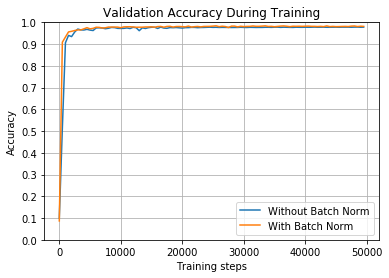

In [36]:
train_and_test(use_larger_weights=False,learning_rate=2,activation_fn=tf.nn.sigmoid)

在较大学习率的情况下，使用sigmoid比使用relu效果好？？？

## 4.5 较大的Weights初始化，较小的学习率，relu激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 12/50000 [00:00<06:59, 119.15it/s]

  0%|                                                                                             | 66/50000 [00:00<05:21, 155.27it/s]

  0%|▏                                                                                           | 130/50000 [00:00<04:08, 200.79it/s]

  0%|▎                                                                                           | 195/50000 [00:00<03:16, 253.09it/s]

  1%|▍                                                                                           | 263/50000 [00:00<02:39, 311.08it/s]

  1%|▌                                                                                           | 333/50000 [00:00<02:13, 372.27it/s]

  1%|▋                                                                                           | 389/50000 [00:00<02:27, 335.46it/s]

  1%|▊                                                                                           | 449/50000 [00:00<02:08, 385.31it/s]

  1%|▉                                                                                           | 503/50000 [00:01<01:57, 419.84it/s]

  1%|█                                                                                           | 570/50000 [00:01<01:44, 472.07it/s]

  1%|█▏                                                                                          | 638/50000 [00:01<01:35, 518.88it/s]

  1%|█▎                                                                                          | 719/50000 [00:01<01:24, 580.67it/s]

  2%|█▍                                                                                          | 799/50000 [00:01<01:17, 631.62it/s]

  2%|█▌                                                                                          | 882/50000 [00:01<01:12, 679.18it/s]

  2%|█▊                                                                                          | 961/50000 [00:01<01:09, 707.63it/s]

  2%|█▉                                                                                         | 1037/50000 [00:01<01:08, 716.99it/s]

  2%|██                                                                                         | 1112/50000 [00:01<01:08, 712.68it/s]

  2%|██▏                                                                                        | 1189/50000 [00:01<01:07, 727.45it/s]

  3%|██▎                                                                                        | 1264/50000 [00:02<01:27, 556.78it/s]

  3%|██▍                                                                                        | 1327/50000 [00:02<01:28, 551.61it/s]

  3%|██▌                                                                                        | 1400/50000 [00:02<01:21, 594.19it/s]

  3%|██▋                                                                                        | 1481/50000 [00:02<01:15, 644.68it/s]

  3%|██▊                                                                                        | 1550/50000 [00:02<01:13, 656.27it/s]

  3%|██▉                                                                                        | 1626/50000 [00:02<01:11, 681.11it/s]

  3%|███                                                                                        | 1710/50000 [00:02<01:07, 720.72it/s]

  4%|███▏                                                                                       | 1785/50000 [00:02<01:06, 727.71it/s]

  4%|███▍                                                                                       | 1860/50000 [00:02<01:11, 675.44it/s]

  4%|███▌                                                                                       | 1936/50000 [00:03<01:08, 697.36it/s]

  4%|███▋                                                                                       | 2008/50000 [00:03<01:11, 669.28it/s]

  4%|███▊                                                                                       | 2077/50000 [00:03<01:12, 660.41it/s]

  4%|███▉                                                                                       | 2147/50000 [00:03<01:11, 670.39it/s]

  4%|████                                                                                       | 2215/50000 [00:03<01:40, 473.18it/s]

  5%|████▏                                                                                      | 2276/50000 [00:03<01:34, 506.40it/s]

  5%|████▏                                                                                      | 2334/50000 [00:03<01:31, 522.56it/s]

  5%|████▎                                                                                      | 2392/50000 [00:03<01:30, 528.67it/s]

  5%|████▍                                                                                      | 2450/50000 [00:04<01:28, 538.94it/s]

  5%|████▌                                                                                      | 2507/50000 [00:04<01:28, 534.50it/s]

  5%|████▋                                                                                      | 2563/50000 [00:04<01:29, 528.54it/s]

  5%|████▊                                                                                      | 2623/50000 [00:04<01:26, 547.03it/s]

  5%|████▉                                                                                      | 2680/50000 [00:04<01:25, 552.55it/s]

  5%|████▉                                                                                      | 2737/50000 [00:04<01:25, 554.85it/s]

  6%|█████                                                                                      | 2796/50000 [00:04<01:23, 563.77it/s]

  6%|█████▏                                                                                     | 2860/50000 [00:04<01:21, 581.90it/s]

  6%|█████▎                                                                                     | 2922/50000 [00:04<01:19, 591.59it/s]

  6%|█████▍                                                                                     | 2982/50000 [00:05<01:20, 582.47it/s]

  6%|█████▌                                                                                     | 3041/50000 [00:05<01:20, 580.01it/s]

  6%|█████▋                                                                                     | 3100/50000 [00:05<01:47, 437.25it/s]

  6%|█████▊                                                                                     | 3165/50000 [00:05<01:36, 482.99it/s]

  6%|█████▉                                                                                     | 3233/50000 [00:05<01:28, 528.07it/s]

  7%|██████                                                                                     | 3308/50000 [00:05<01:20, 578.53it/s]

  7%|██████▏                                                                                    | 3386/50000 [00:05<01:14, 626.02it/s]

  7%|██████▎                                                                                    | 3454/50000 [00:05<01:16, 609.08it/s]

  7%|██████▍                                                                                    | 3519/50000 [00:05<01:15, 619.53it/s]

  7%|██████▌                                                                                    | 3600/50000 [00:06<01:09, 665.35it/s]

  7%|██████▋                                                                                    | 3683/50000 [00:06<01:05, 706.13it/s]

  8%|██████▊                                                                                    | 3760/50000 [00:06<01:03, 722.66it/s]

  8%|██████▉                                                                                    | 3835/50000 [00:06<01:04, 716.59it/s]

  8%|███████                                                                                    | 3908/50000 [00:06<01:09, 667.84it/s]

  8%|███████▏                                                                                   | 3981/50000 [00:06<01:07, 683.93it/s]

  8%|███████▎                                                                                   | 4051/50000 [00:06<01:28, 518.24it/s]

  8%|███████▌                                                                                   | 4127/50000 [00:06<01:20, 571.96it/s]

  8%|███████▋                                                                                   | 4197/50000 [00:06<01:15, 604.03it/s]

  9%|███████▊                                                                                   | 4276/50000 [00:07<01:10, 647.12it/s]

  9%|███████▉                                                                                   | 4350/50000 [00:07<01:08, 671.16it/s]

  9%|████████                                                                                   | 4421/50000 [00:07<01:07, 671.29it/s]

  9%|████████▏                                                                                  | 4498/50000 [00:07<01:05, 696.76it/s]

  9%|████████▎                                                                                  | 4572/50000 [00:07<01:04, 707.70it/s]

  9%|████████▍                                                                                  | 4645/50000 [00:07<01:05, 688.58it/s]

  9%|████████▌                                                                                  | 4720/50000 [00:07<01:04, 704.47it/s]

 10%|████████▋                                                                                  | 4796/50000 [00:07<01:02, 718.77it/s]

 10%|████████▊                                                                                  | 4869/50000 [00:07<01:05, 686.09it/s]

 10%|████████▉                                                                                  | 4939/50000 [00:08<01:26, 523.75it/s]

 10%|█████████                                                                                  | 4998/50000 [00:08<01:24, 530.72it/s]

 10%|█████████▏                                                                                 | 5056/50000 [00:08<01:24, 530.11it/s]

 10%|█████████▎                                                                                 | 5119/50000 [00:08<01:20, 555.51it/s]

 10%|█████████▍                                                                                 | 5196/50000 [00:08<01:14, 605.12it/s]

 11%|█████████▌                                                                                 | 5279/50000 [00:08<01:08, 657.51it/s]

 11%|█████████▊                                                                                 | 5362/50000 [00:08<01:03, 699.93it/s]

 11%|█████████▉                                                                                 | 5443/50000 [00:08<01:01, 728.25it/s]

 11%|██████████                                                                                 | 5519/50000 [00:08<01:01, 719.25it/s]

 11%|██████████▏                                                                                | 5595/50000 [00:09<01:00, 729.47it/s]

 11%|██████████▎                                                                                | 5670/50000 [00:09<01:02, 713.06it/s]

 11%|██████████▍                                                                                | 5743/50000 [00:09<01:08, 644.58it/s]

 12%|██████████▌                                                                                | 5810/50000 [00:09<01:12, 609.86it/s]

 12%|██████████▋                                                                                | 5873/50000 [00:09<01:39, 445.46it/s]

 12%|██████████▊                                                                                | 5934/50000 [00:09<01:31, 481.55it/s]

 12%|██████████▉                                                                                | 5998/50000 [00:09<01:24, 519.26it/s]

 12%|███████████                                                                                | 6056/50000 [00:09<01:22, 533.55it/s]

 12%|███████████▏                                                                               | 6121/50000 [00:10<01:17, 562.78it/s]

 12%|███████████▎                                                                               | 6186/50000 [00:10<01:15, 583.66it/s]

 12%|███████████▎                                                                               | 6247/50000 [00:10<01:14, 586.67it/s]

 13%|███████████▍                                                                               | 6308/50000 [00:10<01:14, 583.74it/s]

 13%|███████████▌                                                                               | 6368/50000 [00:10<01:14, 585.55it/s]

 13%|███████████▋                                                                               | 6439/50000 [00:10<01:10, 616.87it/s]

 13%|███████████▊                                                                               | 6502/50000 [00:10<01:12, 603.43it/s]

 13%|███████████▉                                                                               | 6564/50000 [00:10<01:16, 568.69it/s]

 13%|████████████                                                                               | 6628/50000 [00:10<01:13, 587.18it/s]

 13%|████████████▏                                                                              | 6689/50000 [00:11<01:13, 592.58it/s]

 14%|████████████▎                                                                              | 6751/50000 [00:11<01:28, 486.68it/s]

 14%|████████████▍                                                                              | 6808/50000 [00:11<01:25, 506.65it/s]

 14%|████████████▌                                                                              | 6874/50000 [00:11<01:19, 542.30it/s]

 14%|████████████▋                                                                              | 6957/50000 [00:11<01:11, 604.27it/s]

 14%|████████████▊                                                                              | 7034/50000 [00:11<01:06, 643.16it/s]

 14%|████████████▉                                                                              | 7109/50000 [00:11<01:03, 670.58it/s]

 14%|█████████████                                                                              | 7179/50000 [00:11<01:05, 658.63it/s]

 14%|█████████████▏                                                                             | 7248/50000 [00:11<01:04, 664.40it/s]

 15%|█████████████▎                                                                             | 7316/50000 [00:12<01:06, 637.60it/s]

 15%|█████████████▍                                                                             | 7391/50000 [00:12<01:03, 666.30it/s]

 15%|█████████████▌                                                                             | 7470/50000 [00:12<01:00, 697.81it/s]

 15%|█████████████▋                                                                             | 7542/50000 [00:12<01:01, 694.70it/s]

 15%|█████████████▉                                                                             | 7624/50000 [00:12<00:58, 726.66it/s]

 15%|██████████████                                                                             | 7698/50000 [00:12<01:15, 561.78it/s]

 16%|██████████████▏                                                                            | 7778/50000 [00:12<01:08, 615.85it/s]

 16%|██████████████▎                                                                            | 7858/50000 [00:12<01:03, 660.34it/s]

 16%|██████████████▍                                                                            | 7940/50000 [00:12<01:00, 698.20it/s]

 16%|██████████████▌                                                                            | 8014/50000 [00:13<01:00, 690.93it/s]

 16%|██████████████▋                                                                            | 8096/50000 [00:13<00:57, 723.77it/s]

 16%|██████████████▊                                                                            | 8171/50000 [00:13<01:00, 691.62it/s]

 16%|███████████████                                                                            | 8243/50000 [00:13<01:00, 692.39it/s]

 17%|███████████████▏                                                                           | 8315/50000 [00:13<00:59, 698.95it/s]

 17%|███████████████▎                                                                           | 8396/50000 [00:13<00:57, 727.50it/s]

 17%|███████████████▍                                                                           | 8479/50000 [00:13<00:55, 753.99it/s]

 17%|███████████████▌                                                                           | 8556/50000 [00:13<00:54, 754.86it/s]

 17%|███████████████▋                                                                           | 8633/50000 [00:14<01:16, 542.20it/s]

 17%|███████████████▊                                                                           | 8710/50000 [00:14<01:09, 594.00it/s]

 18%|███████████████▉                                                                           | 8778/50000 [00:14<01:09, 596.78it/s]

 18%|████████████████                                                                           | 8844/50000 [00:14<01:08, 596.60it/s]

 18%|████████████████▏                                                                          | 8908/50000 [00:14<01:08, 604.29it/s]

 18%|████████████████▎                                                                          | 8973/50000 [00:14<01:06, 616.03it/s]

 18%|████████████████▍                                                                          | 9037/50000 [00:14<01:07, 607.58it/s]

 18%|████████████████▌                                                                          | 9107/50000 [00:14<01:04, 629.69it/s]

 18%|████████████████▋                                                                          | 9179/50000 [00:14<01:02, 651.21it/s]

 18%|████████████████▊                                                                          | 9246/50000 [00:14<01:02, 655.36it/s]

 19%|████████████████▉                                                                          | 9314/50000 [00:15<01:01, 661.15it/s]

 19%|█████████████████                                                                          | 9381/50000 [00:15<01:02, 652.69it/s]

 19%|█████████████████▏                                                                         | 9447/50000 [00:15<01:03, 636.48it/s]

 19%|█████████████████▎                                                                         | 9512/50000 [00:15<01:25, 471.32it/s]

 19%|█████████████████▍                                                                         | 9577/50000 [00:15<01:19, 511.59it/s]

 19%|█████████████████▌                                                                         | 9657/50000 [00:15<01:10, 572.73it/s]

 19%|█████████████████▋                                                                         | 9736/50000 [00:15<01:04, 623.15it/s]

 20%|█████████████████▊                                                                         | 9819/50000 [00:15<00:59, 672.31it/s]

 20%|██████████████████                                                                         | 9892/50000 [00:16<00:59, 675.80it/s]

 20%|██████████████████▏                                                                        | 9969/50000 [00:16<00:57, 700.15it/s]

 20%|██████████████████                                                                        | 10042/50000 [00:16<00:57, 691.30it/s]

 20%|██████████████████▏                                                                       | 10115/50000 [00:16<00:56, 701.00it/s]

 20%|██████████████████▎                                                                       | 10189/50000 [00:16<00:56, 710.76it/s]

 21%|██████████████████▍                                                                       | 10267/50000 [00:16<00:54, 728.71it/s]

 21%|██████████████████▌                                                                       | 10347/50000 [00:16<00:53, 747.20it/s]

 21%|██████████████████▊                                                                       | 10423/50000 [00:16<01:08, 578.65it/s]

 21%|██████████████████▉                                                                       | 10498/50000 [00:16<01:03, 620.11it/s]

 21%|███████████████████                                                                       | 10568/50000 [00:17<01:01, 640.81it/s]

 21%|███████████████████▏                                                                      | 10638/50000 [00:17<00:59, 656.14it/s]

 21%|███████████████████▎                                                                      | 10716/50000 [00:17<00:57, 687.63it/s]

 22%|███████████████████▍                                                                      | 10788/50000 [00:17<00:56, 691.55it/s]

 22%|███████████████████▌                                                                      | 10866/50000 [00:17<00:54, 714.47it/s]

 22%|███████████████████▋                                                                      | 10949/50000 [00:17<00:52, 742.15it/s]

 22%|███████████████████▊                                                                      | 11025/50000 [00:17<00:53, 728.69it/s]

 22%|███████████████████▉                                                                      | 11105/50000 [00:17<00:52, 747.18it/s]

 22%|████████████████████▏                                                                     | 11186/50000 [00:17<00:50, 761.25it/s]

 23%|████████████████████▎                                                                     | 11269/50000 [00:17<00:49, 779.05it/s]

 23%|████████████████████▍                                                                     | 11348/50000 [00:18<01:09, 559.11it/s]

 23%|████████████████████▌                                                                     | 11414/50000 [00:18<01:08, 566.81it/s]

 23%|████████████████████▋                                                                     | 11485/50000 [00:18<01:03, 602.19it/s]

 23%|████████████████████▊                                                                     | 11552/50000 [00:18<01:02, 619.79it/s]

 23%|████████████████████▉                                                                     | 11618/50000 [00:18<01:01, 619.39it/s]

 23%|█████████████████████                                                                     | 11686/50000 [00:18<01:00, 635.11it/s]

 24%|█████████████████████▏                                                                    | 11752/50000 [00:18<01:00, 633.64it/s]

 24%|█████████████████████▎                                                                    | 11827/50000 [00:18<00:57, 663.29it/s]

 24%|█████████████████████▍                                                                    | 11905/50000 [00:19<00:54, 693.11it/s]

 24%|█████████████████████▌                                                                    | 11976/50000 [00:19<00:55, 682.56it/s]

 24%|█████████████████████▋                                                                    | 12046/50000 [00:19<01:01, 615.78it/s]

 24%|█████████████████████▊                                                                    | 12110/50000 [00:19<01:04, 589.01it/s]

 24%|█████████████████████▉                                                                    | 12171/50000 [00:19<01:05, 580.36it/s]

 24%|██████████████████████                                                                    | 12231/50000 [00:19<01:05, 579.79it/s]

 25%|██████████████████████                                                                    | 12290/50000 [00:19<01:23, 449.11it/s]

 25%|██████████████████████▏                                                                   | 12354/50000 [00:19<01:16, 491.28it/s]

 25%|██████████████████████▎                                                                   | 12415/50000 [00:19<01:12, 519.44it/s]

 25%|██████████████████████▍                                                                   | 12476/50000 [00:20<01:09, 542.59it/s]

 25%|██████████████████████▌                                                                   | 12536/50000 [00:20<01:07, 555.95it/s]

 25%|██████████████████████▋                                                                   | 12598/50000 [00:20<01:05, 570.99it/s]

 25%|██████████████████████▊                                                                   | 12657/50000 [00:20<01:06, 565.43it/s]

 25%|██████████████████████▉                                                                   | 12721/50000 [00:20<01:03, 584.74it/s]

 26%|███████████████████████                                                                   | 12788/50000 [00:20<01:01, 605.10it/s]

 26%|███████████████████████▏                                                                  | 12857/50000 [00:20<00:59, 627.04it/s]

 26%|███████████████████████▎                                                                  | 12923/50000 [00:20<00:58, 635.23it/s]

 26%|███████████████████████▍                                                                  | 12996/50000 [00:20<00:56, 657.89it/s]

 26%|███████████████████████▌                                                                  | 13065/50000 [00:21<00:55, 663.88it/s]

 26%|███████████████████████▋                                                                  | 13132/50000 [00:21<00:56, 652.64it/s]

 26%|███████████████████████▊                                                                  | 13198/50000 [00:21<01:13, 500.66it/s]

 27%|███████████████████████▊                                                                  | 13260/50000 [00:21<01:09, 530.35it/s]

 27%|███████████████████████▉                                                                  | 13323/50000 [00:21<01:06, 554.23it/s]

 27%|████████████████████████                                                                  | 13394/50000 [00:21<01:01, 592.19it/s]

 27%|████████████████████████▏                                                                 | 13457/50000 [00:21<01:03, 577.04it/s]

 27%|████████████████████████▎                                                                 | 13520/50000 [00:21<01:01, 590.76it/s]

 27%|████████████████████████▍                                                                 | 13581/50000 [00:21<01:01, 595.13it/s]

 27%|████████████████████████▌                                                                 | 13646/50000 [00:22<00:59, 609.34it/s]

 27%|████████████████████████▋                                                                 | 13710/50000 [00:22<00:58, 616.92it/s]

 28%|████████████████████████▊                                                                 | 13792/50000 [00:22<00:54, 665.25it/s]

 28%|████████████████████████▉                                                                 | 13864/50000 [00:22<00:53, 679.37it/s]

 28%|█████████████████████████                                                                 | 13942/50000 [00:22<00:51, 705.32it/s]

 28%|█████████████████████████▏                                                                | 14014/50000 [00:22<00:53, 668.77it/s]

 28%|█████████████████████████▎                                                                | 14084/50000 [00:22<01:09, 518.89it/s]

 28%|█████████████████████████▍                                                                | 14152/50000 [00:22<01:04, 557.59it/s]

 28%|█████████████████████████▌                                                                | 14230/50000 [00:22<00:58, 608.70it/s]

 29%|█████████████████████████▊                                                                | 14314/50000 [00:23<00:53, 662.37it/s]

 29%|█████████████████████████▉                                                                | 14386/50000 [00:23<00:52, 677.27it/s]

 29%|██████████████████████████                                                                | 14469/50000 [00:23<00:49, 715.49it/s]

 29%|██████████████████████████▏                                                               | 14544/50000 [00:23<00:50, 699.72it/s]

 29%|██████████████████████████▎                                                               | 14625/50000 [00:23<00:48, 726.12it/s]

 29%|██████████████████████████▍                                                               | 14709/50000 [00:23<00:46, 755.42it/s]

 30%|██████████████████████████▌                                                               | 14787/50000 [00:23<00:46, 761.00it/s]

 30%|██████████████████████████▊                                                               | 14870/50000 [00:23<00:45, 778.86it/s]

 30%|██████████████████████████▉                                                               | 14954/50000 [00:23<00:44, 794.59it/s]

 30%|███████████████████████████                                                               | 15035/50000 [00:24<00:59, 590.44it/s]

 30%|███████████████████████████▏                                                              | 15103/50000 [00:24<00:59, 585.10it/s]

 30%|███████████████████████████▎                                                              | 15168/50000 [00:24<00:59, 581.02it/s]

 30%|███████████████████████████▍                                                              | 15231/50000 [00:24<00:59, 585.41it/s]

 31%|███████████████████████████▌                                                              | 15293/50000 [00:24<00:58, 590.74it/s]

 31%|███████████████████████████▋                                                              | 15357/50000 [00:24<00:57, 603.45it/s]

 31%|███████████████████████████▊                                                              | 15419/50000 [00:24<00:59, 584.75it/s]

 31%|███████████████████████████▊                                                              | 15479/50000 [00:24<01:01, 564.79it/s]

 31%|███████████████████████████▉                                                              | 15537/50000 [00:25<01:04, 538.09it/s]

 31%|████████████████████████████                                                              | 15602/50000 [00:25<01:00, 566.31it/s]

 31%|████████████████████████████▏                                                             | 15668/50000 [00:25<00:58, 590.34it/s]

 31%|████████████████████████████▎                                                             | 15740/50000 [00:25<00:55, 621.25it/s]

 32%|████████████████████████████▍                                                             | 15809/50000 [00:25<00:53, 639.11it/s]

 32%|████████████████████████████▌                                                             | 15880/50000 [00:25<00:51, 657.51it/s]

 32%|████████████████████████████▋                                                             | 15947/50000 [00:25<01:05, 519.08it/s]

 32%|████████████████████████████▊                                                             | 16017/50000 [00:25<01:00, 561.72it/s]

 32%|████████████████████████████▉                                                             | 16100/50000 [00:25<00:54, 621.02it/s]

 32%|█████████████████████████████▏                                                            | 16181/50000 [00:26<00:50, 664.92it/s]

 33%|█████████████████████████████▎                                                            | 16263/50000 [00:26<00:47, 703.58it/s]

 33%|█████████████████████████████▍                                                            | 16338/50000 [00:26<00:51, 652.12it/s]

 33%|█████████████████████████████▌                                                            | 16407/50000 [00:26<00:51, 652.29it/s]

 33%|█████████████████████████████▋                                                            | 16485/50000 [00:26<00:48, 684.66it/s]

 33%|█████████████████████████████▊                                                            | 16556/50000 [00:26<00:49, 671.07it/s]

 33%|█████████████████████████████▉                                                            | 16638/50000 [00:26<00:47, 708.39it/s]

 33%|██████████████████████████████                                                            | 16720/50000 [00:26<00:45, 735.12it/s]

 34%|██████████████████████████████▏                                                           | 16796/50000 [00:26<00:44, 740.83it/s]

 34%|██████████████████████████████▎                                                           | 16872/50000 [00:27<00:58, 570.79it/s]

 34%|██████████████████████████████▌                                                           | 16954/50000 [00:27<00:52, 627.00it/s]

 34%|██████████████████████████████▋                                                           | 17025/50000 [00:27<00:50, 648.49it/s]

 34%|██████████████████████████████▊                                                           | 17095/50000 [00:27<00:49, 659.89it/s]

 34%|██████████████████████████████▉                                                           | 17171/50000 [00:27<00:47, 685.68it/s]

 35%|███████████████████████████████                                                           | 17255/50000 [00:27<00:45, 724.30it/s]

 35%|███████████████████████████████▏                                                          | 17334/50000 [00:27<00:44, 739.23it/s]

 35%|███████████████████████████████▎                                                          | 17414/50000 [00:27<00:43, 752.78it/s]

 35%|███████████████████████████████▍                                                          | 17491/50000 [00:27<00:43, 754.02it/s]

 35%|███████████████████████████████▌                                                          | 17568/50000 [00:27<00:42, 754.89it/s]

 35%|███████████████████████████████▊                                                          | 17650/50000 [00:28<00:41, 771.71it/s]

 35%|███████████████████████████████▉                                                          | 17728/50000 [00:28<00:42, 759.01it/s]

 36%|████████████████████████████████                                                          | 17805/50000 [00:28<00:56, 570.19it/s]

 36%|████████████████████████████████▏                                                         | 17884/50000 [00:28<00:51, 621.05it/s]

 36%|████████████████████████████████▎                                                         | 17967/50000 [00:28<00:47, 670.60it/s]

 36%|████████████████████████████████▍                                                         | 18040/50000 [00:28<00:46, 685.96it/s]

 36%|████████████████████████████████▌                                                         | 18118/50000 [00:28<00:44, 710.28it/s]

 36%|████████████████████████████████▊                                                         | 18199/50000 [00:28<00:43, 736.05it/s]

 37%|████████████████████████████████▉                                                         | 18276/50000 [00:29<00:42, 744.34it/s]

 37%|█████████████████████████████████                                                         | 18354/50000 [00:29<00:42, 753.09it/s]

 37%|█████████████████████████████████▏                                                        | 18431/50000 [00:29<00:45, 695.13it/s]

 37%|█████████████████████████████████▎                                                        | 18503/50000 [00:29<00:48, 648.08it/s]

 37%|█████████████████████████████████▍                                                        | 18570/50000 [00:29<00:49, 640.04it/s]

 37%|█████████████████████████████████▌                                                        | 18636/50000 [00:29<00:49, 637.07it/s]

 37%|█████████████████████████████████▋                                                        | 18701/50000 [00:29<01:05, 474.64it/s]

 38%|█████████████████████████████████▊                                                        | 18766/50000 [00:29<01:00, 515.53it/s]

 38%|█████████████████████████████████▉                                                        | 18829/50000 [00:29<00:57, 544.23it/s]

 38%|██████████████████████████████████                                                        | 18893/50000 [00:30<00:54, 568.70it/s]

 38%|██████████████████████████████████                                                        | 18954/50000 [00:30<00:53, 577.64it/s]

 38%|██████████████████████████████████▏                                                       | 19015/50000 [00:30<00:53, 582.40it/s]

 38%|██████████████████████████████████▎                                                       | 19077/50000 [00:30<00:52, 591.95it/s]

 38%|██████████████████████████████████▍                                                       | 19146/50000 [00:30<00:49, 617.10it/s]

 38%|██████████████████████████████████▌                                                       | 19216/50000 [00:30<00:48, 638.55it/s]

 39%|██████████████████████████████████▋                                                       | 19299/50000 [00:30<00:44, 684.78it/s]

 39%|██████████████████████████████████▉                                                       | 19376/50000 [00:30<00:43, 706.88it/s]

 39%|███████████████████████████████████                                                       | 19458/50000 [00:30<00:41, 735.94it/s]

 39%|███████████████████████████████████▏                                                      | 19534/50000 [00:31<00:41, 741.41it/s]

 39%|███████████████████████████████████▎                                                      | 19610/50000 [00:31<00:53, 568.48it/s]

 39%|███████████████████████████████████▍                                                      | 19683/50000 [00:31<00:49, 607.79it/s]

 40%|███████████████████████████████████▌                                                      | 19750/50000 [00:31<00:49, 617.05it/s]

 40%|███████████████████████████████████▋                                                      | 19816/50000 [00:31<00:48, 628.02it/s]

 40%|███████████████████████████████████▊                                                      | 19898/50000 [00:31<00:44, 672.58it/s]

 40%|███████████████████████████████████▉                                                      | 19977/50000 [00:31<00:42, 702.61it/s]

 40%|████████████████████████████████████                                                      | 20050/50000 [00:31<00:42, 700.95it/s]

 40%|████████████████████████████████████▏                                                     | 20130/50000 [00:31<00:41, 726.54it/s]

 40%|████████████████████████████████████▍                                                     | 20209/50000 [00:32<00:40, 742.95it/s]

 41%|████████████████████████████████████▌                                                     | 20285/50000 [00:32<00:40, 735.56it/s]

 41%|████████████████████████████████████▋                                                     | 20360/50000 [00:32<00:40, 725.42it/s]

 41%|████████████████████████████████████▊                                                     | 20435/50000 [00:32<00:40, 731.06it/s]

 41%|████████████████████████████████████▉                                                     | 20509/50000 [00:32<00:53, 551.06it/s]

 41%|█████████████████████████████████████                                                     | 20582/50000 [00:32<00:49, 593.74it/s]

 41%|█████████████████████████████████████▏                                                    | 20662/50000 [00:32<00:45, 642.38it/s]

 41%|█████████████████████████████████████▎                                                    | 20737/50000 [00:32<00:43, 669.96it/s]

 42%|█████████████████████████████████████▍                                                    | 20820/50000 [00:32<00:41, 709.76it/s]

 42%|█████████████████████████████████████▋                                                    | 20903/50000 [00:33<00:39, 740.56it/s]

 42%|█████████████████████████████████████▊                                                    | 20980/50000 [00:33<00:38, 745.40it/s]

 42%|█████████████████████████████████████▉                                                    | 21059/50000 [00:33<00:38, 756.65it/s]

 42%|██████████████████████████████████████                                                    | 21137/50000 [00:33<00:38, 757.44it/s]

 42%|██████████████████████████████████████▏                                                   | 21214/50000 [00:33<00:38, 746.31it/s]

 43%|██████████████████████████████████████▎                                                   | 21298/50000 [00:33<00:37, 770.59it/s]

 43%|██████████████████████████████████████▍                                                   | 21379/50000 [00:33<00:36, 780.36it/s]

 43%|██████████████████████████████████████▌                                                   | 21458/50000 [00:33<00:47, 597.57it/s]

 43%|██████████████████████████████████████▊                                                   | 21534/50000 [00:33<00:44, 637.34it/s]

 43%|██████████████████████████████████████▉                                                   | 21614/50000 [00:34<00:41, 677.48it/s]

 43%|███████████████████████████████████████                                                   | 21687/50000 [00:34<00:42, 668.28it/s]

 44%|███████████████████████████████████████▏                                                  | 21758/50000 [00:34<00:44, 631.85it/s]

 44%|███████████████████████████████████████▎                                                  | 21824/50000 [00:34<00:46, 607.04it/s]

 44%|███████████████████████████████████████▍                                                  | 21888/50000 [00:34<00:45, 615.27it/s]

 44%|███████████████████████████████████████▌                                                  | 21954/50000 [00:34<00:44, 624.96it/s]

 44%|███████████████████████████████████████▋                                                  | 22018/50000 [00:34<00:45, 620.75it/s]

 44%|███████████████████████████████████████▊                                                  | 22084/50000 [00:34<00:44, 630.70it/s]

 44%|███████████████████████████████████████▊                                                  | 22148/50000 [00:34<00:44, 628.37it/s]

 44%|███████████████████████████████████████▉                                                  | 22214/50000 [00:35<00:43, 634.37it/s]

 45%|████████████████████████████████████████                                                  | 22285/50000 [00:35<00:42, 653.99it/s]

 45%|████████████████████████████████████████▏                                                 | 22351/50000 [00:35<00:54, 511.68it/s]

 45%|████████████████████████████████████████▎                                                 | 22408/50000 [00:35<00:53, 516.81it/s]

 45%|████████████████████████████████████████▍                                                 | 22465/50000 [00:35<00:51, 530.61it/s]

 45%|████████████████████████████████████████▌                                                 | 22523/50000 [00:35<00:50, 543.40it/s]

 45%|████████████████████████████████████████▋                                                 | 22584/50000 [00:35<00:48, 560.67it/s]

 45%|████████████████████████████████████████▊                                                 | 22654/50000 [00:35<00:45, 595.17it/s]

 45%|████████████████████████████████████████▉                                                 | 22721/50000 [00:35<00:44, 614.56it/s]

 46%|█████████████████████████████████████████                                                 | 22786/50000 [00:36<00:43, 623.47it/s]

 46%|█████████████████████████████████████████▏                                                | 22850/50000 [00:36<00:43, 626.99it/s]

 46%|█████████████████████████████████████████▏                                                | 22914/50000 [00:36<00:43, 629.47it/s]

 46%|█████████████████████████████████████████▎                                                | 22981/50000 [00:36<00:42, 639.77it/s]

 46%|█████████████████████████████████████████▍                                                | 23049/50000 [00:36<00:41, 649.96it/s]

 46%|█████████████████████████████████████████▌                                                | 23119/50000 [00:36<00:40, 662.83it/s]

 46%|█████████████████████████████████████████▋                                                | 23189/50000 [00:36<00:39, 672.14it/s]

 47%|█████████████████████████████████████████▊                                                | 23257/50000 [00:36<00:51, 514.55it/s]

 47%|█████████████████████████████████████████▉                                                | 23319/50000 [00:36<00:49, 541.18it/s]

 47%|██████████████████████████████████████████                                                | 23378/50000 [00:37<00:48, 546.14it/s]

 47%|██████████████████████████████████████████▏                                               | 23446/50000 [00:37<00:45, 579.34it/s]

 47%|██████████████████████████████████████████▎                                               | 23514/50000 [00:37<00:43, 603.44it/s]

 47%|██████████████████████████████████████████▍                                               | 23581/50000 [00:37<00:42, 620.75it/s]

 47%|██████████████████████████████████████████▌                                               | 23653/50000 [00:37<00:40, 646.25it/s]

 47%|██████████████████████████████████████████▋                                               | 23728/50000 [00:37<00:39, 672.91it/s]

 48%|██████████████████████████████████████████▊                                               | 23797/50000 [00:37<00:42, 615.12it/s]

 48%|██████████████████████████████████████████▉                                               | 23861/50000 [00:37<00:45, 577.48it/s]

 48%|███████████████████████████████████████████                                               | 23923/50000 [00:37<00:44, 588.38it/s]

 48%|███████████████████████████████████████████▏                                              | 23984/50000 [00:38<00:45, 570.20it/s]

 48%|███████████████████████████████████████████▎                                              | 24043/50000 [00:38<00:48, 529.97it/s]

 48%|███████████████████████████████████████████▍                                              | 24114/50000 [00:38<00:45, 572.59it/s]

 48%|███████████████████████████████████████████▌                                              | 24174/50000 [00:38<00:56, 460.84it/s]

 48%|███████████████████████████████████████████▋                                              | 24247/50000 [00:38<00:49, 517.34it/s]

 49%|███████████████████████████████████████████▊                                              | 24325/50000 [00:38<00:44, 574.55it/s]

 49%|███████████████████████████████████████████▉                                              | 24402/50000 [00:38<00:41, 620.81it/s]

 49%|████████████████████████████████████████████                                              | 24482/50000 [00:38<00:38, 664.32it/s]

 49%|████████████████████████████████████████████▏                                             | 24559/50000 [00:38<00:36, 691.48it/s]

 49%|████████████████████████████████████████████▎                                             | 24640/50000 [00:39<00:35, 721.82it/s]

 49%|████████████████████████████████████████████▍                                             | 24715/50000 [00:39<00:36, 700.01it/s]

 50%|████████████████████████████████████████████▌                                             | 24788/50000 [00:39<00:41, 606.94it/s]

 50%|████████████████████████████████████████████▋                                             | 24853/50000 [00:39<00:44, 559.12it/s]

 50%|████████████████████████████████████████████▊                                             | 24913/50000 [00:39<00:45, 552.35it/s]

 50%|████████████████████████████████████████████▉                                             | 24971/50000 [00:39<00:45, 555.97it/s]

 50%|█████████████████████████████████████████████                                             | 25030/50000 [00:39<00:44, 564.57it/s]

 50%|█████████████████████████████████████████████▏                                            | 25088/50000 [00:39<00:56, 443.24it/s]

 50%|█████████████████████████████████████████████▎                                            | 25144/50000 [00:40<00:52, 471.94it/s]

 50%|█████████████████████████████████████████████▍                                            | 25212/50000 [00:40<00:47, 518.77it/s]

 51%|█████████████████████████████████████████████▍                                            | 25273/50000 [00:40<00:45, 540.64it/s]

 51%|█████████████████████████████████████████████▌                                            | 25331/50000 [00:40<00:44, 549.17it/s]

 51%|█████████████████████████████████████████████▋                                            | 25396/50000 [00:40<00:42, 573.32it/s]

 51%|█████████████████████████████████████████████▊                                            | 25469/50000 [00:40<00:40, 611.67it/s]

 51%|█████████████████████████████████████████████▉                                            | 25536/50000 [00:40<00:39, 626.79it/s]

 51%|██████████████████████████████████████████████                                            | 25619/50000 [00:40<00:36, 675.27it/s]

 51%|██████████████████████████████████████████████▎                                           | 25701/50000 [00:40<00:34, 711.67it/s]

 52%|██████████████████████████████████████████████▍                                           | 25775/50000 [00:41<00:34, 698.13it/s]

 52%|██████████████████████████████████████████████▌                                           | 25857/50000 [00:41<00:33, 729.28it/s]

 52%|██████████████████████████████████████████████▋                                           | 25932/50000 [00:41<00:33, 710.91it/s]

 52%|██████████████████████████████████████████████▊                                           | 26005/50000 [00:41<00:49, 481.95it/s]

 52%|██████████████████████████████████████████████▉                                           | 26066/50000 [00:41<00:46, 513.40it/s]

 52%|███████████████████████████████████████████████                                           | 26126/50000 [00:41<00:45, 529.92it/s]

 52%|███████████████████████████████████████████████▏                                          | 26205/50000 [00:41<00:40, 587.04it/s]

 53%|███████████████████████████████████████████████▎                                          | 26282/50000 [00:41<00:37, 630.96it/s]

 53%|███████████████████████████████████████████████▍                                          | 26361/50000 [00:41<00:35, 670.27it/s]

 53%|███████████████████████████████████████████████▌                                          | 26441/50000 [00:42<00:33, 703.18it/s]

 53%|███████████████████████████████████████████████▋                                          | 26515/50000 [00:42<00:34, 680.96it/s]

 53%|███████████████████████████████████████████████▉                                          | 26598/50000 [00:42<00:32, 718.36it/s]

 53%|████████████████████████████████████████████████                                          | 26673/50000 [00:42<00:33, 686.27it/s]

 53%|████████████████████████████████████████████████▏                                         | 26744/50000 [00:42<00:34, 681.81it/s]

 54%|████████████████████████████████████████████████▎                                         | 26828/50000 [00:42<00:32, 721.27it/s]

 54%|████████████████████████████████████████████████▍                                         | 26911/50000 [00:42<00:30, 747.27it/s]

 54%|████████████████████████████████████████████████▌                                         | 26988/50000 [00:42<00:39, 582.15it/s]

 54%|████████████████████████████████████████████████▋                                         | 27053/50000 [00:43<00:40, 569.86it/s]

 54%|████████████████████████████████████████████████▊                                         | 27115/50000 [00:43<00:44, 516.05it/s]

 54%|████████████████████████████████████████████████▉                                         | 27171/50000 [00:43<00:43, 524.46it/s]

 54%|█████████████████████████████████████████████████                                         | 27227/50000 [00:43<00:44, 513.05it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27292/50000 [00:43<00:41, 546.66it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27357/50000 [00:43<00:39, 572.93it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27435/50000 [00:43<00:36, 621.42it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27511/50000 [00:43<00:34, 656.14it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27591/50000 [00:43<00:32, 692.24it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27675/50000 [00:44<00:30, 727.52it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27752/50000 [00:44<00:30, 738.21it/s]

 56%|██████████████████████████████████████████████████                                        | 27828/50000 [00:44<00:35, 616.74it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27895/50000 [00:44<00:47, 467.34it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27958/50000 [00:44<00:43, 505.68it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28019/50000 [00:44<00:41, 530.63it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28078/50000 [00:44<00:40, 543.02it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28147/50000 [00:44<00:37, 577.58it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28211/50000 [00:45<00:36, 593.78it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28275/50000 [00:45<00:35, 603.96it/s]

 57%|███████████████████████████████████████████████████                                       | 28338/50000 [00:45<00:38, 565.96it/s]

 57%|███████████████████████████████████████████████████                                       | 28397/50000 [00:45<00:38, 554.08it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28454/50000 [00:45<00:40, 532.62it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28527/50000 [00:45<00:37, 578.63it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28606/50000 [00:45<00:34, 628.03it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28683/50000 [00:45<00:32, 663.55it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28752/50000 [00:45<00:39, 537.21it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28827/50000 [00:46<00:36, 584.82it/s]

 58%|████████████████████████████████████████████████████                                      | 28902/50000 [00:46<00:33, 625.05it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28969/50000 [00:46<00:34, 605.57it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29033/50000 [00:46<00:38, 542.55it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29099/50000 [00:46<00:36, 572.06it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29181/50000 [00:46<00:33, 628.07it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29259/50000 [00:46<00:31, 665.80it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29336/50000 [00:46<00:29, 690.75it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29417/50000 [00:46<00:28, 719.34it/s]

 59%|█████████████████████████████████████████████████████                                     | 29498/50000 [00:47<00:27, 742.84it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29574/50000 [00:47<00:28, 710.79it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29653/50000 [00:47<00:27, 731.35it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29728/50000 [00:47<00:36, 551.01it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29803/50000 [00:47<00:33, 597.60it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29882/50000 [00:47<00:31, 643.57it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29965/50000 [00:47<00:29, 688.81it/s]

 60%|██████████████████████████████████████████████████████                                    | 30039/50000 [00:47<00:28, 696.02it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30120/50000 [00:47<00:27, 725.27it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30196/50000 [00:48<00:32, 616.29it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30263/50000 [00:48<00:33, 581.12it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30325/50000 [00:48<00:34, 562.16it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30384/50000 [00:48<00:37, 520.92it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30452/50000 [00:48<00:34, 559.23it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30528/50000 [00:48<00:32, 606.30it/s]

 61%|███████████████████████████████████████████████████████                                   | 30592/50000 [00:48<00:40, 483.99it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30647/50000 [00:49<00:41, 469.09it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30699/50000 [00:49<00:42, 454.55it/s]

 62%|███████████████████████████████████████████████████████▎                                  | 30755/50000 [00:49<00:40, 480.87it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30816/50000 [00:49<00:37, 512.53it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30870/50000 [00:49<00:37, 503.44it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30930/50000 [00:49<00:36, 527.96it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30994/50000 [00:49<00:34, 554.72it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31054/50000 [00:49<00:33, 566.39it/s]

 62%|████████████████████████████████████████████████████████                                  | 31120/50000 [00:49<00:32, 588.83it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31184/50000 [00:50<00:31, 602.06it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31251/50000 [00:50<00:30, 619.69it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31319/50000 [00:50<00:29, 633.55it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31387/50000 [00:50<00:28, 643.63it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31452/50000 [00:50<00:28, 644.13it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31517/50000 [00:50<00:41, 447.85it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31585/50000 [00:50<00:36, 498.15it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31664/50000 [00:50<00:32, 559.37it/s]

 63%|█████████████████████████████████████████████████████████▏                                | 31742/50000 [00:50<00:29, 610.19it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31826/50000 [00:51<00:27, 663.60it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31906/50000 [00:51<00:25, 696.22it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31989/50000 [00:51<00:24, 728.21it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32066/50000 [00:51<00:24, 732.46it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32142/50000 [00:51<00:26, 670.65it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32212/50000 [00:51<00:28, 623.56it/s]

 65%|██████████████████████████████████████████████████████████                                | 32278/50000 [00:51<00:28, 632.73it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32344/50000 [00:51<00:27, 635.63it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32409/50000 [00:51<00:27, 634.76it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32474/50000 [00:52<00:36, 473.74it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32537/50000 [00:52<00:34, 510.92it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32603/50000 [00:52<00:31, 547.06it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32663/50000 [00:52<00:32, 539.65it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32723/50000 [00:52<00:31, 553.79it/s]

 66%|███████████████████████████████████████████████████████████                               | 32793/50000 [00:52<00:29, 589.72it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32863/50000 [00:52<00:27, 617.77it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32927/50000 [00:52<00:27, 615.77it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 32991/50000 [00:52<00:27, 621.52it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33055/50000 [00:53<00:28, 586.18it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33115/50000 [00:53<00:28, 587.26it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33175/50000 [00:53<00:31, 541.94it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33231/50000 [00:53<00:31, 530.58it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33293/50000 [00:53<00:30, 553.49it/s]

 67%|████████████████████████████████████████████████████████████                              | 33350/50000 [00:53<00:38, 436.01it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33431/50000 [00:53<00:32, 505.42it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33506/50000 [00:53<00:29, 559.32it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33590/50000 [00:54<00:26, 620.62it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33660/50000 [00:54<00:25, 641.19it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33730/50000 [00:54<00:26, 616.63it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33796/50000 [00:54<00:29, 552.27it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33856/50000 [00:54<00:31, 513.97it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33922/50000 [00:54<00:29, 548.14it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33986/50000 [00:54<00:28, 571.68it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34051/50000 [00:54<00:26, 591.94it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34120/50000 [00:54<00:25, 617.09it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34186/50000 [00:55<00:25, 628.05it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34251/50000 [00:55<00:32, 478.37it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34305/50000 [00:55<00:33, 467.45it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34357/50000 [00:55<00:33, 466.88it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34427/50000 [00:55<00:30, 517.86it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34492/50000 [00:55<00:28, 549.08it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34551/50000 [00:55<00:28, 550.21it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34629/50000 [00:55<00:25, 602.53it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34712/50000 [00:56<00:23, 655.37it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34792/50000 [00:56<00:21, 691.64it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34869/50000 [00:56<00:21, 711.98it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34952/50000 [00:56<00:20, 742.25it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35029/50000 [00:56<00:20, 742.28it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35105/50000 [00:56<00:20, 730.85it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35180/50000 [00:56<00:27, 535.53it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35242/50000 [00:56<00:27, 531.52it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35301/50000 [00:56<00:28, 524.87it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35371/50000 [00:57<00:25, 566.46it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35447/50000 [00:57<00:23, 610.76it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35516/50000 [00:57<00:22, 631.28it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35597/50000 [00:57<00:21, 674.80it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35681/50000 [00:57<00:20, 715.77it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 35756/50000 [00:57<00:20, 694.09it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35834/50000 [00:57<00:19, 716.36it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35908/50000 [00:57<00:21, 670.83it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35977/50000 [00:57<00:22, 613.94it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36041/50000 [00:58<00:23, 589.45it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36102/50000 [00:58<00:32, 430.92it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36158/50000 [00:58<00:29, 462.10it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36212/50000 [00:58<00:28, 482.06it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36280/50000 [00:58<00:26, 526.06it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36358/50000 [00:58<00:23, 582.05it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36440/50000 [00:58<00:21, 636.47it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36519/50000 [00:58<00:19, 674.61it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36603/50000 [00:59<00:18, 713.80it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36679/50000 [00:59<00:18, 723.47it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36754/50000 [00:59<00:19, 687.64it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36825/50000 [00:59<00:20, 633.53it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36891/50000 [00:59<00:20, 627.15it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36956/50000 [00:59<00:20, 625.20it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37020/50000 [00:59<00:28, 461.50it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37079/50000 [00:59<00:26, 492.86it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37140/50000 [01:00<00:24, 522.01it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37197/50000 [01:00<00:23, 534.44it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37256/50000 [01:00<00:23, 547.33it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37315/50000 [01:00<00:22, 556.71it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37380/50000 [01:00<00:21, 580.64it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37457/50000 [01:00<00:20, 625.78it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37523/50000 [01:00<00:19, 634.32it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37600/50000 [01:00<00:18, 666.72it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37684/50000 [01:00<00:17, 709.39it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37757/50000 [01:00<00:19, 635.78it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37824/50000 [01:01<00:19, 614.27it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37892/50000 [01:01<00:19, 631.33it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37957/50000 [01:01<00:24, 499.56it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38029/50000 [01:01<00:21, 549.16it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38098/50000 [01:01<00:20, 583.90it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38178/50000 [01:01<00:18, 632.78it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38252/50000 [01:01<00:17, 660.24it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38322/50000 [01:01<00:19, 590.73it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38385/50000 [01:02<00:20, 571.39it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38465/50000 [01:02<00:18, 623.90it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38534/50000 [01:02<00:17, 641.05it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38610/50000 [01:02<00:16, 671.33it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38691/50000 [01:02<00:16, 704.49it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38764/50000 [01:02<00:18, 609.30it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38829/50000 [01:02<00:20, 549.18it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38888/50000 [01:02<00:27, 409.67it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38965/50000 [01:03<00:23, 475.93it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39033/50000 [01:03<00:21, 522.14it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39113/50000 [01:03<00:18, 581.94it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39197/50000 [01:03<00:16, 639.95it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39279/50000 [01:03<00:15, 682.13it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39354/50000 [01:03<00:15, 686.32it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39431/50000 [01:03<00:14, 708.02it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39505/50000 [01:03<00:15, 697.63it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39587/50000 [01:03<00:14, 728.90it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39668/50000 [01:04<00:13, 749.95it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39747/50000 [01:04<00:13, 759.92it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39825/50000 [01:04<00:18, 539.57it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39889/50000 [01:04<00:18, 560.71it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39953/50000 [01:04<00:18, 537.39it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40012/50000 [01:04<00:19, 501.94it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40070/50000 [01:04<00:19, 522.02it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40128/50000 [01:04<00:18, 535.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40188/50000 [01:05<00:17, 552.29it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40248/50000 [01:05<00:17, 564.63it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40308/50000 [01:05<00:16, 573.59it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40368/50000 [01:05<00:16, 580.03it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40427/50000 [01:05<00:16, 580.02it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40488/50000 [01:05<00:16, 587.46it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40549/50000 [01:05<00:15, 591.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40615/50000 [01:05<00:15, 607.27it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40677/50000 [01:05<00:20, 451.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40729/50000 [01:06<00:20, 462.95it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40807/50000 [01:06<00:17, 526.48it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40887/50000 [01:06<00:15, 585.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40970/50000 [01:06<00:14, 641.35it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41044/50000 [01:06<00:13, 666.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41126/50000 [01:06<00:12, 705.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41201/50000 [01:06<00:12, 706.34it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41275/50000 [01:06<00:12, 683.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41358/50000 [01:06<00:12, 719.97it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41441/50000 [01:07<00:11, 748.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41518/50000 [01:07<00:11, 744.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41594/50000 [01:07<00:14, 577.46it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41672/50000 [01:07<00:13, 625.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏              | 41741/50000 [01:07<00:13, 597.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41805/50000 [01:07<00:13, 589.64it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41867/50000 [01:07<00:14, 575.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41927/50000 [01:07<00:14, 576.46it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41993/50000 [01:07<00:13, 596.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42055/50000 [01:08<00:13, 602.01it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42118/50000 [01:08<00:12, 608.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42180/50000 [01:08<00:13, 586.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42240/50000 [01:08<00:14, 550.46it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42296/50000 [01:08<00:14, 530.21it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42350/50000 [01:08<00:14, 519.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42403/50000 [01:08<00:14, 511.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42456/50000 [01:08<00:14, 515.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42508/50000 [01:09<00:19, 390.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42555/50000 [01:09<00:18, 410.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42610/50000 [01:09<00:16, 443.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42665/50000 [01:09<00:15, 467.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42730/50000 [01:09<00:14, 509.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42803/50000 [01:09<00:12, 558.28it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42863/50000 [01:09<00:12, 559.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42922/50000 [01:09<00:12, 557.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42980/50000 [01:09<00:12, 557.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43039/50000 [01:09<00:12, 564.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43097/50000 [01:10<00:12, 557.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43154/50000 [01:10<00:12, 538.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43210/50000 [01:10<00:12, 543.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43270/50000 [01:10<00:12, 558.07it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43330/50000 [01:10<00:11, 568.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43405/50000 [01:10<00:10, 612.18it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43468/50000 [01:10<00:13, 477.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43522/50000 [01:10<00:13, 480.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43583/50000 [01:11<00:12, 512.39it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43638/50000 [01:11<00:12, 504.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43691/50000 [01:11<00:12, 511.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43760/50000 [01:11<00:11, 553.19it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43828/50000 [01:11<00:10, 583.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43905/50000 [01:11<00:09, 627.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43971/50000 [01:11<00:09, 630.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44045/50000 [01:11<00:09, 658.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44124/50000 [01:11<00:08, 691.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44195/50000 [01:11<00:08, 691.58it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44276/50000 [01:12<00:07, 721.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44350/50000 [01:12<00:10, 556.01it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44428/50000 [01:12<00:09, 607.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44504/50000 [01:12<00:08, 643.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44581/50000 [01:12<00:08, 675.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44653/50000 [01:12<00:07, 684.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44734/50000 [01:12<00:07, 716.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44808/50000 [01:12<00:07, 719.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44890/50000 [01:12<00:06, 745.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44974/50000 [01:13<00:06, 770.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45053/50000 [01:13<00:06, 767.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45136/50000 [01:13<00:06, 783.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45217/50000 [01:13<00:06, 789.72it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45297/50000 [01:13<00:07, 600.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45365/50000 [01:13<00:07, 619.65it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45447/50000 [01:13<00:06, 667.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45519/50000 [01:13<00:06, 677.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45593/50000 [01:13<00:06, 693.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45668/50000 [01:14<00:06, 706.03it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45741/50000 [01:14<00:06, 697.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45812/50000 [01:14<00:06, 677.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45881/50000 [01:14<00:06, 660.32it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45948/50000 [01:14<00:06, 650.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46014/50000 [01:14<00:06, 631.20it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46078/50000 [01:14<00:06, 610.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46141/50000 [01:14<00:06, 615.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46203/50000 [01:15<00:08, 462.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46266/50000 [01:15<00:07, 501.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46330/50000 [01:15<00:06, 535.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46394/50000 [01:15<00:06, 562.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46460/50000 [01:15<00:06, 585.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46527/50000 [01:15<00:05, 605.74it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46602/50000 [01:15<00:05, 641.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46669/50000 [01:15<00:05, 648.50it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46743/50000 [01:15<00:04, 672.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46813/50000 [01:15<00:04, 678.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46891/50000 [01:16<00:04, 703.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46963/50000 [01:16<00:04, 704.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47038/50000 [01:16<00:04, 716.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47111/50000 [01:16<00:05, 545.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47192/50000 [01:16<00:04, 603.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47264/50000 [01:16<00:04, 633.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47348/50000 [01:16<00:03, 682.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47422/50000 [01:16<00:03, 697.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47495/50000 [01:16<00:03, 693.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47569/50000 [01:17<00:03, 705.16it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47642/50000 [01:17<00:03, 698.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47714/50000 [01:17<00:03, 697.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47795/50000 [01:17<00:03, 726.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47877/50000 [01:17<00:02, 750.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47959/50000 [01:17<00:02, 768.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48037/50000 [01:17<00:03, 563.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48116/50000 [01:17<00:03, 615.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48192/50000 [01:18<00:02, 651.64it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48273/50000 [01:18<00:02, 690.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48347/50000 [01:18<00:02, 697.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48430/50000 [01:18<00:02, 731.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48506/50000 [01:18<00:02, 731.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48588/50000 [01:18<00:01, 754.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48666/50000 [01:18<00:01, 760.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48744/50000 [01:18<00:01, 753.48it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48825/50000 [01:18<00:01, 765.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48903/50000 [01:18<00:01, 750.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48979/50000 [01:19<00:01, 560.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49043/50000 [01:19<00:01, 555.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49105/50000 [01:19<00:01, 570.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49173/50000 [01:19<00:01, 598.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49241/50000 [01:19<00:01, 619.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49306/50000 [01:19<00:01, 614.67it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49370/50000 [01:19<00:01, 613.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49444/50000 [01:19<00:00, 645.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49510/50000 [01:19<00:00, 635.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49575/50000 [01:20<00:00, 630.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49641/50000 [01:20<00:00, 637.98it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49706/50000 [01:20<00:00, 634.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49773/50000 [01:20<00:00, 643.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49838/50000 [01:20<00:00, 492.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49906/50000 [01:20<00:00, 535.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49981/50000 [01:20<00:00, 584.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:20<00:00, 618.52it/s]

Without Batch Norm:the final accuracy on validation data is 0.1128000020980835

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<4:20:06,  3.20it/s]

  0%|                                                                                            | 25/50000 [00:00<3:03:02,  4.55it/s]

  0%|                                                                                            | 55/50000 [00:00<2:08:53,  6.46it/s]

  0%|▏                                                                                           | 85/50000 [00:00<1:31:01,  9.14it/s]

  0%|▏                                                                                          | 116/50000 [00:00<1:04:29, 12.89it/s]

  0%|▎                                                                                            | 144/50000 [00:00<46:01, 18.05it/s]

  0%|▎                                                                                            | 174/50000 [00:00<33:03, 25.12it/s]

  0%|▎                                                                                            | 200/50000 [00:01<24:05, 34.45it/s]

  0%|▍                                                                                            | 226/50000 [00:01<17:49, 46.56it/s]

  1%|▍                                                                                            | 252/50000 [00:01<13:27, 61.61it/s]

  1%|▌                                                                                            | 280/50000 [00:01<10:19, 80.24it/s]

  1%|▌                                                                                           | 306/50000 [00:01<08:11, 101.15it/s]

  1%|▌                                                                                           | 335/50000 [00:01<06:35, 125.43it/s]

  1%|▋                                                                                           | 365/50000 [00:01<05:27, 151.78it/s]

  1%|▋                                                                                           | 393/50000 [00:01<04:42, 175.71it/s]

  1%|▊                                                                                           | 424/50000 [00:01<04:06, 200.89it/s]

  1%|▊                                                                                           | 453/50000 [00:01<03:46, 218.92it/s]

  1%|▉                                                                                           | 484/50000 [00:02<03:27, 238.57it/s]

  1%|▉                                                                                           | 513/50000 [00:02<03:18, 248.92it/s]

  1%|▉                                                                                           | 542/50000 [00:02<03:27, 237.81it/s]

  1%|█                                                                                           | 569/50000 [00:02<03:29, 235.84it/s]

  1%|█                                                                                           | 595/50000 [00:02<03:28, 236.84it/s]

  1%|█▏                                                                                          | 621/50000 [00:02<03:23, 242.16it/s]

  1%|█▏                                                                                          | 647/50000 [00:02<03:22, 243.97it/s]

  1%|█▏                                                                                          | 673/50000 [00:02<03:20, 245.94it/s]

  1%|█▎                                                                                          | 699/50000 [00:02<03:22, 243.19it/s]

  1%|█▎                                                                                          | 724/50000 [00:03<03:24, 240.44it/s]

  1%|█▍                                                                                          | 749/50000 [00:03<03:26, 238.56it/s]

  2%|█▍                                                                                          | 774/50000 [00:03<04:29, 182.76it/s]

  2%|█▍                                                                                          | 798/50000 [00:03<04:11, 196.01it/s]

  2%|█▌                                                                                          | 824/50000 [00:03<03:53, 210.75it/s]

  2%|█▌                                                                                          | 851/50000 [00:03<03:39, 223.52it/s]

  2%|█▌                                                                                          | 876/50000 [00:03<03:33, 230.39it/s]

  2%|█▋                                                                                          | 902/50000 [00:03<03:27, 236.12it/s]

  2%|█▋                                                                                          | 929/50000 [00:03<03:21, 243.54it/s]

  2%|█▊                                                                                          | 954/50000 [00:04<03:22, 242.78it/s]

  2%|█▊                                                                                          | 984/50000 [00:04<03:11, 256.38it/s]

  2%|█▊                                                                                         | 1012/50000 [00:04<03:07, 261.03it/s]

  2%|█▉                                                                                         | 1044/50000 [00:04<02:58, 274.37it/s]

  2%|█▉                                                                                         | 1074/50000 [00:04<02:55, 279.44it/s]

  2%|██                                                                                         | 1105/50000 [00:04<02:50, 287.37it/s]

  2%|██                                                                                         | 1136/50000 [00:04<02:47, 292.37it/s]

  2%|██▏                                                                                        | 1168/50000 [00:04<02:43, 297.86it/s]

  2%|██▏                                                                                        | 1198/50000 [00:04<02:47, 290.94it/s]

  2%|██▏                                                                                        | 1230/50000 [00:04<02:44, 296.82it/s]

  3%|██▎                                                                                        | 1260/50000 [00:05<02:44, 297.12it/s]

  3%|██▎                                                                                        | 1291/50000 [00:05<02:42, 300.23it/s]

  3%|██▍                                                                                        | 1322/50000 [00:05<02:41, 301.57it/s]

  3%|██▍                                                                                        | 1353/50000 [00:05<02:40, 303.40it/s]

  3%|██▌                                                                                        | 1384/50000 [00:05<02:49, 286.18it/s]

  3%|██▌                                                                                        | 1414/50000 [00:05<02:48, 287.91it/s]

  3%|██▋                                                                                        | 1445/50000 [00:05<02:46, 291.11it/s]

  3%|██▋                                                                                        | 1475/50000 [00:05<02:46, 292.24it/s]

  3%|██▋                                                                                        | 1505/50000 [00:05<02:48, 287.14it/s]

  3%|██▊                                                                                        | 1535/50000 [00:06<02:46, 290.28it/s]

  3%|██▊                                                                                        | 1566/50000 [00:06<02:44, 294.47it/s]

  3%|██▉                                                                                        | 1598/50000 [00:06<02:41, 299.38it/s]

  3%|██▉                                                                                        | 1629/50000 [00:06<02:40, 300.97it/s]

  3%|███                                                                                        | 1660/50000 [00:06<02:43, 295.20it/s]

  3%|███                                                                                        | 1690/50000 [00:06<03:33, 225.95it/s]

  3%|███▏                                                                                       | 1721/50000 [00:06<03:17, 244.37it/s]

  3%|███▏                                                                                       | 1748/50000 [00:06<03:14, 247.56it/s]

  4%|███▏                                                                                       | 1778/50000 [00:06<03:05, 259.43it/s]

  4%|███▎                                                                                       | 1807/50000 [00:07<03:00, 267.36it/s]

  4%|███▎                                                                                       | 1837/50000 [00:07<02:55, 274.32it/s]

  4%|███▍                                                                                       | 1866/50000 [00:07<02:53, 277.46it/s]

  4%|███▍                                                                                       | 1895/50000 [00:07<02:51, 279.70it/s]

  4%|███▌                                                                                       | 1924/50000 [00:07<02:53, 276.48it/s]

  4%|███▌                                                                                       | 1954/50000 [00:07<02:50, 282.55it/s]

  4%|███▌                                                                                       | 1984/50000 [00:07<02:47, 286.97it/s]

  4%|███▋                                                                                       | 2013/50000 [00:07<02:53, 276.59it/s]

  4%|███▋                                                                                       | 2041/50000 [00:07<02:59, 267.50it/s]

  4%|███▊                                                                                       | 2068/50000 [00:08<03:06, 256.99it/s]

  4%|███▊                                                                                       | 2094/50000 [00:08<03:06, 257.33it/s]

  4%|███▊                                                                                       | 2121/50000 [00:08<03:04, 258.96it/s]

  4%|███▉                                                                                       | 2148/50000 [00:08<03:08, 254.24it/s]

  4%|███▉                                                                                       | 2174/50000 [00:08<03:13, 247.40it/s]

  4%|████                                                                                       | 2202/50000 [00:08<03:07, 255.14it/s]

  4%|████                                                                                       | 2231/50000 [00:08<03:01, 262.73it/s]

  5%|████                                                                                       | 2258/50000 [00:08<03:01, 263.53it/s]

  5%|████▏                                                                                      | 2286/50000 [00:08<02:59, 265.42it/s]

  5%|████▏                                                                                      | 2315/50000 [00:08<02:55, 271.03it/s]

  5%|████▎                                                                                      | 2344/50000 [00:09<02:53, 275.09it/s]

  5%|████▎                                                                                      | 2373/50000 [00:09<02:50, 278.81it/s]

  5%|████▍                                                                                      | 2404/50000 [00:09<02:45, 286.91it/s]

  5%|████▍                                                                                      | 2436/50000 [00:09<02:42, 293.06it/s]

  5%|████▍                                                                                      | 2466/50000 [00:09<02:43, 290.21it/s]

  5%|████▌                                                                                      | 2498/50000 [00:09<02:40, 296.29it/s]

  5%|████▌                                                                                      | 2528/50000 [00:09<02:39, 296.75it/s]

  5%|████▋                                                                                      | 2558/50000 [00:09<02:39, 297.07it/s]

  5%|████▋                                                                                      | 2588/50000 [00:09<03:30, 225.19it/s]

  5%|████▊                                                                                      | 2617/50000 [00:10<03:16, 240.93it/s]

  5%|████▊                                                                                      | 2648/50000 [00:10<03:05, 255.80it/s]

  5%|████▊                                                                                      | 2678/50000 [00:10<02:58, 265.70it/s]

  5%|████▉                                                                                      | 2707/50000 [00:10<02:54, 271.23it/s]

  5%|████▉                                                                                      | 2736/50000 [00:10<02:54, 271.39it/s]

  6%|█████                                                                                      | 2765/50000 [00:10<02:52, 274.57it/s]

  6%|█████                                                                                      | 2793/50000 [00:10<02:53, 271.58it/s]

  6%|█████▏                                                                                     | 2823/50000 [00:10<02:50, 277.41it/s]

  6%|█████▏                                                                                     | 2852/50000 [00:10<02:49, 278.06it/s]

  6%|█████▏                                                                                     | 2882/50000 [00:11<02:46, 282.91it/s]

  6%|█████▎                                                                                     | 2911/50000 [00:11<02:48, 278.67it/s]

  6%|█████▎                                                                                     | 2942/50000 [00:11<02:44, 286.00it/s]

  6%|█████▍                                                                                     | 2973/50000 [00:11<02:41, 291.38it/s]

  6%|█████▍                                                                                     | 3003/50000 [00:11<02:41, 291.58it/s]

  6%|█████▌                                                                                     | 3033/50000 [00:11<02:42, 289.19it/s]

  6%|█████▌                                                                                     | 3064/50000 [00:11<02:40, 292.85it/s]

  6%|█████▋                                                                                     | 3094/50000 [00:11<02:40, 291.75it/s]

  6%|█████▋                                                                                     | 3124/50000 [00:11<02:43, 286.02it/s]

  6%|█████▋                                                                                     | 3153/50000 [00:11<02:47, 279.94it/s]

  6%|█████▊                                                                                     | 3183/50000 [00:12<02:44, 284.29it/s]

  6%|█████▊                                                                                     | 3214/50000 [00:12<02:40, 290.94it/s]

  6%|█████▉                                                                                     | 3244/50000 [00:12<02:41, 288.75it/s]

  7%|█████▉                                                                                     | 3275/50000 [00:12<02:39, 293.37it/s]

  7%|██████                                                                                     | 3305/50000 [00:12<02:40, 291.27it/s]

  7%|██████                                                                                     | 3337/50000 [00:12<02:37, 296.24it/s]

  7%|██████▏                                                                                    | 3370/50000 [00:12<02:33, 303.32it/s]

  7%|██████▏                                                                                    | 3401/50000 [00:12<02:33, 302.86it/s]

  7%|██████▏                                                                                    | 3432/50000 [00:12<02:43, 284.27it/s]

  7%|██████▎                                                                                    | 3461/50000 [00:13<02:50, 272.51it/s]

  7%|██████▎                                                                                    | 3489/50000 [00:13<02:53, 268.62it/s]

  7%|██████▍                                                                                    | 3517/50000 [00:13<03:54, 197.90it/s]

  7%|██████▍                                                                                    | 3541/50000 [00:13<03:43, 207.42it/s]

  7%|██████▍                                                                                    | 3570/50000 [00:13<03:25, 226.41it/s]

  7%|██████▌                                                                                    | 3598/50000 [00:13<03:13, 239.75it/s]

  7%|██████▌                                                                                    | 3628/50000 [00:13<03:03, 253.36it/s]

  7%|██████▋                                                                                    | 3655/50000 [00:13<03:00, 256.86it/s]

  7%|██████▋                                                                                    | 3684/50000 [00:13<02:54, 264.72it/s]

  7%|██████▊                                                                                    | 3713/50000 [00:14<02:51, 270.51it/s]

  7%|██████▊                                                                                    | 3742/50000 [00:14<02:48, 273.95it/s]

  8%|██████▊                                                                                    | 3773/50000 [00:14<02:44, 281.74it/s]

  8%|██████▉                                                                                    | 3805/50000 [00:14<02:39, 290.06it/s]

  8%|██████▉                                                                                    | 3835/50000 [00:14<02:41, 286.50it/s]

  8%|███████                                                                                    | 3867/50000 [00:14<02:37, 292.77it/s]

  8%|███████                                                                                    | 3898/50000 [00:14<02:35, 296.26it/s]

  8%|███████▏                                                                                   | 3930/50000 [00:14<02:33, 300.67it/s]

  8%|███████▏                                                                                   | 3961/50000 [00:14<02:32, 302.76it/s]

  8%|███████▎                                                                                   | 3992/50000 [00:15<02:32, 302.47it/s]

  8%|███████▎                                                                                   | 4023/50000 [00:15<02:35, 296.21it/s]

  8%|███████▍                                                                                   | 4054/50000 [00:15<02:34, 297.86it/s]

  8%|███████▍                                                                                   | 4085/50000 [00:15<02:32, 300.76it/s]

  8%|███████▍                                                                                   | 4117/50000 [00:15<02:30, 303.90it/s]

  8%|███████▌                                                                                   | 4148/50000 [00:15<02:36, 292.97it/s]

  8%|███████▌                                                                                   | 4178/50000 [00:15<02:36, 292.69it/s]

  8%|███████▋                                                                                   | 4209/50000 [00:15<02:34, 296.20it/s]

  8%|███████▋                                                                                   | 4239/50000 [00:15<02:36, 292.36it/s]

  9%|███████▊                                                                                   | 4269/50000 [00:15<02:50, 268.76it/s]

  9%|███████▊                                                                                   | 4297/50000 [00:16<02:53, 263.07it/s]

  9%|███████▉                                                                                   | 4328/50000 [00:16<02:46, 274.32it/s]

  9%|███████▉                                                                                   | 4360/50000 [00:16<02:39, 286.03it/s]

  9%|███████▉                                                                                   | 4392/50000 [00:16<02:34, 294.84it/s]

  9%|████████                                                                                   | 4422/50000 [00:16<03:25, 221.30it/s]

  9%|████████                                                                                   | 4451/50000 [00:16<03:11, 237.82it/s]

  9%|████████▏                                                                                  | 4481/50000 [00:16<03:00, 251.85it/s]

  9%|████████▏                                                                                  | 4509/50000 [00:16<02:59, 252.85it/s]

  9%|████████▎                                                                                  | 4537/50000 [00:17<02:55, 259.18it/s]

  9%|████████▎                                                                                  | 4566/50000 [00:17<02:50, 267.17it/s]

  9%|████████▎                                                                                  | 4594/50000 [00:17<02:48, 268.77it/s]

  9%|████████▍                                                                                  | 4625/50000 [00:17<02:43, 277.89it/s]

  9%|████████▍                                                                                  | 4656/50000 [00:17<02:38, 285.43it/s]

  9%|████████▌                                                                                  | 4685/50000 [00:17<02:44, 274.81it/s]

  9%|████████▌                                                                                  | 4716/50000 [00:17<02:40, 282.38it/s]

  9%|████████▋                                                                                  | 4748/50000 [00:17<02:35, 290.53it/s]

 10%|████████▋                                                                                  | 4778/50000 [00:17<02:38, 286.00it/s]

 10%|████████▋                                                                                  | 4807/50000 [00:17<02:47, 270.56it/s]

 10%|████████▊                                                                                  | 4835/50000 [00:18<02:50, 264.28it/s]

 10%|████████▊                                                                                  | 4862/50000 [00:18<02:55, 257.08it/s]

 10%|████████▉                                                                                  | 4888/50000 [00:18<02:58, 252.16it/s]

 10%|████████▉                                                                                  | 4914/50000 [00:18<02:57, 253.92it/s]

 10%|████████▉                                                                                  | 4940/50000 [00:18<02:59, 250.74it/s]

 10%|█████████                                                                                  | 4967/50000 [00:18<02:57, 253.54it/s]

 10%|█████████                                                                                  | 4993/50000 [00:18<02:56, 254.89it/s]

 10%|█████████▏                                                                                 | 5019/50000 [00:18<02:58, 252.14it/s]

 10%|█████████▏                                                                                 | 5045/50000 [00:18<02:58, 252.43it/s]

 10%|█████████▏                                                                                 | 5071/50000 [00:19<02:56, 254.11it/s]

 10%|█████████▎                                                                                 | 5098/50000 [00:19<02:55, 255.94it/s]

 10%|█████████▎                                                                                 | 5125/50000 [00:19<02:54, 257.23it/s]

 10%|█████████▍                                                                                 | 5153/50000 [00:19<02:50, 263.12it/s]

 10%|█████████▍                                                                                 | 5182/50000 [00:19<02:46, 268.60it/s]

 10%|█████████▍                                                                                 | 5210/50000 [00:19<02:46, 269.00it/s]

 10%|█████████▌                                                                                 | 5239/50000 [00:19<02:44, 272.09it/s]

 11%|█████████▌                                                                                 | 5269/50000 [00:19<02:40, 278.56it/s]

 11%|█████████▋                                                                                 | 5297/50000 [00:19<02:40, 278.38it/s]

 11%|█████████▋                                                                                 | 5326/50000 [00:19<02:40, 278.74it/s]

 11%|█████████▋                                                                                 | 5354/50000 [00:20<03:26, 216.12it/s]

 11%|█████████▊                                                                                 | 5383/50000 [00:20<03:11, 233.59it/s]

 11%|█████████▊                                                                                 | 5412/50000 [00:20<03:00, 246.97it/s]

 11%|█████████▉                                                                                 | 5443/50000 [00:20<02:50, 261.86it/s]

 11%|█████████▉                                                                                 | 5472/50000 [00:20<02:45, 268.42it/s]

 11%|██████████                                                                                 | 5501/50000 [00:20<02:43, 272.44it/s]

 11%|██████████                                                                                 | 5529/50000 [00:20<02:42, 274.08it/s]

 11%|██████████                                                                                 | 5557/50000 [00:20<02:43, 271.24it/s]

 11%|██████████▏                                                                                | 5587/50000 [00:20<02:40, 277.16it/s]

 11%|██████████▏                                                                                | 5616/50000 [00:21<02:39, 278.69it/s]

 11%|██████████▎                                                                                | 5645/50000 [00:21<02:38, 280.57it/s]

 11%|██████████▎                                                                                | 5677/50000 [00:21<02:33, 289.19it/s]

 11%|██████████▍                                                                                | 5708/50000 [00:21<02:30, 294.52it/s]

 11%|██████████▍                                                                                | 5739/50000 [00:21<02:28, 297.51it/s]

 12%|██████████▍                                                                                | 5769/50000 [00:21<02:31, 292.40it/s]

 12%|██████████▌                                                                                | 5799/50000 [00:21<02:30, 293.14it/s]

 12%|██████████▌                                                                                | 5829/50000 [00:21<02:30, 292.81it/s]

 12%|██████████▋                                                                                | 5859/50000 [00:21<02:34, 285.89it/s]

 12%|██████████▋                                                                                | 5888/50000 [00:22<02:39, 276.69it/s]

 12%|██████████▊                                                                                | 5916/50000 [00:22<02:43, 269.88it/s]

 12%|██████████▊                                                                                | 5945/50000 [00:22<02:40, 275.05it/s]

 12%|██████████▉                                                                                | 5976/50000 [00:22<02:35, 283.33it/s]

 12%|██████████▉                                                                                | 6005/50000 [00:22<02:38, 278.13it/s]

 12%|██████████▉                                                                                | 6033/50000 [00:22<02:42, 270.07it/s]

 12%|███████████                                                                                | 6063/50000 [00:22<02:39, 276.31it/s]

 12%|███████████                                                                                | 6093/50000 [00:22<02:35, 282.43it/s]

 12%|███████████▏                                                                               | 6122/50000 [00:22<02:35, 282.38it/s]

 12%|███████████▏                                                                               | 6151/50000 [00:22<02:43, 268.30it/s]

 12%|███████████▏                                                                               | 6179/50000 [00:23<02:47, 262.02it/s]

 12%|███████████▎                                                                               | 6206/50000 [00:23<02:46, 263.78it/s]

 12%|███████████▎                                                                               | 6233/50000 [00:23<02:47, 261.98it/s]

 13%|███████████▍                                                                               | 6260/50000 [00:23<03:43, 196.13it/s]

 13%|███████████▍                                                                               | 6284/50000 [00:23<03:31, 207.11it/s]

 13%|███████████▍                                                                               | 6309/50000 [00:23<03:22, 216.24it/s]

 13%|███████████▌                                                                               | 6335/50000 [00:23<03:13, 226.12it/s]

 13%|███████████▌                                                                               | 6361/50000 [00:23<03:06, 233.59it/s]

 13%|███████████▌                                                                               | 6387/50000 [00:24<03:01, 239.78it/s]

 13%|███████████▋                                                                               | 6416/50000 [00:24<02:53, 251.13it/s]

 13%|███████████▋                                                                               | 6446/50000 [00:24<02:46, 262.15it/s]

 13%|███████████▊                                                                               | 6477/50000 [00:24<02:38, 274.34it/s]

 13%|███████████▊                                                                               | 6505/50000 [00:24<02:39, 272.22it/s]

 13%|███████████▉                                                                               | 6533/50000 [00:24<02:38, 273.92it/s]

 13%|███████████▉                                                                               | 6563/50000 [00:24<02:35, 279.89it/s]

 13%|███████████▉                                                                               | 6593/50000 [00:24<02:32, 285.04it/s]

 13%|████████████                                                                               | 6623/50000 [00:24<02:30, 287.93it/s]

 13%|████████████                                                                               | 6652/50000 [00:24<02:30, 287.92it/s]

 13%|████████████▏                                                                              | 6681/50000 [00:25<02:38, 273.30it/s]

 13%|████████████▏                                                                              | 6709/50000 [00:25<02:45, 261.63it/s]

 13%|████████████▎                                                                              | 6736/50000 [00:25<02:44, 262.75it/s]

 14%|████████████▎                                                                              | 6763/50000 [00:25<02:45, 261.26it/s]

 14%|████████████▎                                                                              | 6792/50000 [00:25<02:40, 268.70it/s]

 14%|████████████▍                                                                              | 6820/50000 [00:25<02:42, 266.03it/s]

 14%|████████████▍                                                                              | 6849/50000 [00:25<02:38, 271.47it/s]

 14%|████████████▌                                                                              | 6880/50000 [00:25<02:34, 279.90it/s]

 14%|████████████▌                                                                              | 6910/50000 [00:25<02:31, 285.05it/s]

 14%|████████████▋                                                                              | 6942/50000 [00:26<02:27, 292.50it/s]

 14%|████████████▋                                                                              | 6972/50000 [00:26<02:32, 281.69it/s]

 14%|████████████▋                                                                              | 7001/50000 [00:26<02:32, 281.06it/s]

 14%|████████████▊                                                                              | 7030/50000 [00:26<02:33, 280.62it/s]

 14%|████████████▊                                                                              | 7060/50000 [00:26<02:31, 283.95it/s]

 14%|████████████▉                                                                              | 7091/50000 [00:26<02:28, 289.07it/s]

 14%|████████████▉                                                                              | 7120/50000 [00:26<02:32, 282.00it/s]

 14%|█████████████                                                                              | 7151/50000 [00:26<02:29, 286.84it/s]

 14%|█████████████                                                                              | 7180/50000 [00:26<03:20, 213.25it/s]

 14%|█████████████                                                                              | 7208/50000 [00:27<03:07, 228.15it/s]

 14%|█████████████▏                                                                             | 7238/50000 [00:27<02:55, 244.17it/s]

 15%|█████████████▏                                                                             | 7269/50000 [00:27<02:44, 259.65it/s]

 15%|█████████████▎                                                                             | 7299/50000 [00:27<02:38, 269.31it/s]

 15%|█████████████▎                                                                             | 7328/50000 [00:27<02:36, 273.08it/s]

 15%|█████████████▍                                                                             | 7357/50000 [00:27<02:42, 262.33it/s]

 15%|█████████████▍                                                                             | 7384/50000 [00:27<02:45, 258.00it/s]

 15%|█████████████▍                                                                             | 7415/50000 [00:27<02:37, 270.44it/s]

 15%|█████████████▌                                                                             | 7443/50000 [00:27<02:41, 263.45it/s]

 15%|█████████████▌                                                                             | 7470/50000 [00:28<02:51, 248.07it/s]

 15%|█████████████▋                                                                             | 7496/50000 [00:28<02:56, 240.57it/s]

 15%|█████████████▋                                                                             | 7521/50000 [00:28<02:57, 239.32it/s]

 15%|█████████████▋                                                                             | 7548/50000 [00:28<02:52, 246.60it/s]

 15%|█████████████▊                                                                             | 7575/50000 [00:28<02:48, 251.96it/s]

 15%|█████████████▊                                                                             | 7602/50000 [00:28<02:47, 253.69it/s]

 15%|█████████████▉                                                                             | 7629/50000 [00:28<02:44, 257.84it/s]

 15%|█████████████▉                                                                             | 7657/50000 [00:28<02:42, 261.35it/s]

 15%|█████████████▉                                                                             | 7684/50000 [00:28<02:41, 262.56it/s]

 15%|██████████████                                                                             | 7713/50000 [00:28<02:37, 268.19it/s]

 15%|██████████████                                                                             | 7742/50000 [00:29<02:34, 273.81it/s]

 16%|██████████████▏                                                                            | 7771/50000 [00:29<02:33, 275.52it/s]

 16%|██████████████▏                                                                            | 7801/50000 [00:29<02:30, 281.06it/s]

 16%|██████████████▎                                                                            | 7833/50000 [00:29<02:25, 290.34it/s]

 16%|██████████████▎                                                                            | 7865/50000 [00:29<02:22, 296.38it/s]

 16%|██████████████▎                                                                            | 7896/50000 [00:29<02:20, 299.70it/s]

 16%|██████████████▍                                                                            | 7928/50000 [00:29<02:18, 304.01it/s]

 16%|██████████████▍                                                                            | 7960/50000 [00:29<02:16, 307.99it/s]

 16%|██████████████▌                                                                            | 7991/50000 [00:29<02:18, 302.52it/s]

 16%|██████████████▌                                                                            | 8022/50000 [00:30<02:19, 301.42it/s]

 16%|██████████████▋                                                                            | 8053/50000 [00:30<02:21, 296.35it/s]

 16%|██████████████▋                                                                            | 8083/50000 [00:30<02:22, 295.05it/s]

 16%|██████████████▊                                                                            | 8113/50000 [00:30<03:09, 220.91it/s]

 16%|██████████████▊                                                                            | 8141/50000 [00:30<02:57, 235.41it/s]

 16%|██████████████▊                                                                            | 8167/50000 [00:30<02:53, 241.79it/s]

 16%|██████████████▉                                                                            | 8197/50000 [00:30<02:43, 256.25it/s]

 16%|██████████████▉                                                                            | 8225/50000 [00:30<02:39, 261.67it/s]

 17%|███████████████                                                                            | 8255/50000 [00:30<02:34, 270.83it/s]

 17%|███████████████                                                                            | 8286/50000 [00:31<02:28, 280.94it/s]

 17%|███████████████▏                                                                           | 8316/50000 [00:31<02:26, 284.18it/s]

 17%|███████████████▏                                                                           | 8345/50000 [00:31<02:27, 281.96it/s]

 17%|███████████████▏                                                                           | 8374/50000 [00:31<02:26, 283.72it/s]

 17%|███████████████▎                                                                           | 8404/50000 [00:31<02:24, 286.98it/s]

 17%|███████████████▎                                                                           | 8433/50000 [00:31<02:25, 285.57it/s]

 17%|███████████████▍                                                                           | 8462/50000 [00:31<02:28, 278.85it/s]

 17%|███████████████▍                                                                           | 8493/50000 [00:31<02:25, 286.14it/s]

 17%|███████████████▌                                                                           | 8522/50000 [00:31<02:32, 272.15it/s]

 17%|███████████████▌                                                                           | 8550/50000 [00:31<02:31, 273.90it/s]

 17%|███████████████▌                                                                           | 8581/50000 [00:32<02:26, 282.47it/s]

 17%|███████████████▋                                                                           | 8610/50000 [00:32<02:29, 276.78it/s]

 17%|███████████████▋                                                                           | 8639/50000 [00:32<02:28, 279.21it/s]

 17%|███████████████▊                                                                           | 8670/50000 [00:32<02:23, 287.20it/s]

 17%|███████████████▊                                                                           | 8700/50000 [00:32<02:22, 290.31it/s]

 17%|███████████████▉                                                                           | 8730/50000 [00:32<02:25, 284.23it/s]

 18%|███████████████▉                                                                           | 8760/50000 [00:32<02:23, 286.53it/s]

 18%|███████████████▉                                                                           | 8789/50000 [00:32<02:23, 286.94it/s]

 18%|████████████████                                                                           | 8818/50000 [00:32<02:35, 265.22it/s]

 18%|████████████████                                                                           | 8845/50000 [00:33<02:43, 251.95it/s]

 18%|████████████████▏                                                                          | 8871/50000 [00:33<02:43, 250.84it/s]

 18%|████████████████▏                                                                          | 8897/50000 [00:33<02:45, 247.92it/s]

 18%|████████████████▏                                                                          | 8923/50000 [00:33<02:44, 249.46it/s]

 18%|████████████████▎                                                                          | 8951/50000 [00:33<02:40, 255.27it/s]

 18%|████████████████▎                                                                          | 8980/50000 [00:33<02:35, 264.25it/s]

 18%|████████████████▍                                                                          | 9007/50000 [00:33<03:25, 199.62it/s]

 18%|████████████████▍                                                                          | 9032/50000 [00:33<03:13, 211.54it/s]

 18%|████████████████▍                                                                          | 9057/50000 [00:33<03:06, 219.60it/s]

 18%|████████████████▌                                                                          | 9083/50000 [00:34<02:58, 229.29it/s]

 18%|████████████████▌                                                                          | 9109/50000 [00:34<02:52, 236.59it/s]

 18%|████████████████▋                                                                          | 9136/50000 [00:34<02:47, 244.56it/s]

 18%|████████████████▋                                                                          | 9165/50000 [00:34<02:40, 254.78it/s]

 18%|████████████████▋                                                                          | 9194/50000 [00:34<02:35, 262.46it/s]

 18%|████████████████▊                                                                          | 9223/50000 [00:34<02:32, 268.11it/s]

 19%|████████████████▊                                                                          | 9251/50000 [00:34<02:30, 270.21it/s]

 19%|████████████████▉                                                                          | 9280/50000 [00:34<02:29, 272.96it/s]

 19%|████████████████▉                                                                          | 9309/50000 [00:34<02:27, 276.48it/s]

 19%|████████████████▉                                                                          | 9338/50000 [00:35<02:26, 277.41it/s]

 19%|█████████████████                                                                          | 9366/50000 [00:35<02:26, 277.58it/s]

 19%|█████████████████                                                                          | 9395/50000 [00:35<02:25, 279.78it/s]

 19%|█████████████████▏                                                                         | 9424/50000 [00:35<02:25, 278.12it/s]

 19%|█████████████████▏                                                                         | 9454/50000 [00:35<02:24, 281.36it/s]

 19%|█████████████████▎                                                                         | 9483/50000 [00:35<02:23, 283.29it/s]

 19%|█████████████████▎                                                                         | 9512/50000 [00:35<02:24, 279.73it/s]

 19%|█████████████████▎                                                                         | 9541/50000 [00:35<02:26, 275.71it/s]

 19%|█████████████████▍                                                                         | 9572/50000 [00:35<02:22, 283.04it/s]

 19%|█████████████████▍                                                                         | 9602/50000 [00:35<02:21, 285.68it/s]

 19%|█████████████████▌                                                                         | 9632/50000 [00:36<02:19, 288.39it/s]

 19%|█████████████████▌                                                                         | 9661/50000 [00:36<02:29, 270.54it/s]

 19%|█████████████████▋                                                                         | 9689/50000 [00:36<03:00, 222.74it/s]

 19%|█████████████████▋                                                                         | 9713/50000 [00:36<03:25, 195.61it/s]

 19%|█████████████████▋                                                                         | 9735/50000 [00:36<03:47, 177.11it/s]

 20%|█████████████████▊                                                                         | 9755/50000 [00:36<03:56, 170.02it/s]

 20%|█████████████████▊                                                                         | 9774/50000 [00:36<04:04, 164.31it/s]

 20%|█████████████████▊                                                                         | 9792/50000 [00:37<04:12, 159.45it/s]

 20%|█████████████████▊                                                                         | 9809/50000 [00:37<04:15, 157.21it/s]

 20%|█████████████████▉                                                                         | 9826/50000 [00:37<04:18, 155.25it/s]

 20%|█████████████████▉                                                                         | 9842/50000 [00:37<04:22, 153.17it/s]

 20%|█████████████████▉                                                                         | 9858/50000 [00:37<04:21, 153.50it/s]

 20%|█████████████████▉                                                                         | 9874/50000 [00:37<04:21, 153.72it/s]

 20%|█████████████████▉                                                                         | 9890/50000 [00:37<04:21, 153.44it/s]

 20%|██████████████████                                                                         | 9906/50000 [00:37<04:22, 152.81it/s]

 20%|██████████████████                                                                         | 9922/50000 [00:38<05:46, 115.51it/s]

 20%|██████████████████                                                                         | 9937/50000 [00:38<05:24, 123.53it/s]

 20%|██████████████████                                                                         | 9952/50000 [00:38<05:09, 129.52it/s]

 20%|██████████████████▏                                                                        | 9967/50000 [00:38<04:57, 134.43it/s]

 20%|██████████████████▏                                                                        | 9982/50000 [00:38<04:49, 138.08it/s]

 20%|██████████████████▏                                                                        | 9997/50000 [00:38<04:43, 141.16it/s]

 20%|██████████████████                                                                        | 10012/50000 [00:38<04:51, 137.12it/s]

 20%|██████████████████                                                                        | 10028/50000 [00:38<04:44, 140.73it/s]

 20%|██████████████████                                                                        | 10044/50000 [00:38<04:34, 145.32it/s]

 20%|██████████████████                                                                        | 10061/50000 [00:38<04:24, 150.84it/s]

 20%|██████████████████▏                                                                       | 10078/50000 [00:39<04:16, 155.38it/s]

 20%|██████████████████▏                                                                       | 10095/50000 [00:39<04:14, 156.97it/s]

 20%|██████████████████▏                                                                       | 10112/50000 [00:39<04:10, 159.43it/s]

 20%|██████████████████▏                                                                       | 10129/50000 [00:39<04:10, 159.39it/s]

 20%|██████████████████▎                                                                       | 10146/50000 [00:39<04:10, 158.92it/s]

 20%|██████████████████▎                                                                       | 10163/50000 [00:39<04:09, 159.93it/s]

 20%|██████████████████▎                                                                       | 10180/50000 [00:39<04:12, 157.97it/s]

 20%|██████████████████▎                                                                       | 10196/50000 [00:39<04:15, 155.91it/s]

 20%|██████████████████▍                                                                       | 10212/50000 [00:39<04:18, 153.63it/s]

 20%|██████████████████▍                                                                       | 10228/50000 [00:40<04:18, 153.82it/s]

 21%|██████████████████▍                                                                       | 10255/50000 [00:40<03:45, 176.37it/s]

 21%|██████████████████▌                                                                       | 10283/50000 [00:40<03:20, 197.67it/s]

 21%|██████████████████▌                                                                       | 10308/50000 [00:40<03:09, 209.46it/s]

 21%|██████████████████▌                                                                       | 10337/50000 [00:40<02:53, 228.11it/s]

 21%|██████████████████▋                                                                       | 10367/50000 [00:40<02:42, 244.15it/s]

 21%|██████████████████▋                                                                       | 10397/50000 [00:40<02:33, 257.44it/s]

 21%|██████████████████▊                                                                       | 10424/50000 [00:40<02:33, 257.56it/s]

 21%|██████████████████▊                                                                       | 10453/50000 [00:40<02:28, 265.97it/s]

 21%|██████████████████▊                                                                       | 10482/50000 [00:40<02:25, 272.19it/s]

 21%|██████████████████▉                                                                       | 10510/50000 [00:41<02:25, 270.73it/s]

 21%|██████████████████▉                                                                       | 10539/50000 [00:41<02:23, 275.66it/s]

 21%|███████████████████                                                                       | 10567/50000 [00:41<02:26, 269.97it/s]

 21%|███████████████████                                                                       | 10597/50000 [00:41<02:23, 274.72it/s]

 21%|███████████████████▏                                                                      | 10626/50000 [00:41<02:21, 277.75it/s]

 21%|███████████████████▏                                                                      | 10656/50000 [00:41<02:19, 281.10it/s]

 21%|███████████████████▏                                                                      | 10686/50000 [00:41<02:18, 284.29it/s]

 21%|███████████████████▎                                                                      | 10716/50000 [00:41<02:17, 286.57it/s]

 21%|███████████████████▎                                                                      | 10747/50000 [00:41<02:14, 292.61it/s]

 22%|███████████████████▍                                                                      | 10777/50000 [00:41<02:14, 291.59it/s]

 22%|███████████████████▍                                                                      | 10807/50000 [00:42<02:14, 291.72it/s]

 22%|███████████████████▌                                                                      | 10837/50000 [00:42<02:57, 221.05it/s]

 22%|███████████████████▌                                                                      | 10863/50000 [00:42<02:49, 231.00it/s]

 22%|███████████████████▌                                                                      | 10893/50000 [00:42<02:39, 245.85it/s]

 22%|███████████████████▋                                                                      | 10921/50000 [00:42<02:34, 253.30it/s]

 22%|███████████████████▋                                                                      | 10950/50000 [00:42<02:29, 260.65it/s]

 22%|███████████████████▊                                                                      | 10977/50000 [00:42<02:28, 262.07it/s]

 22%|███████████████████▊                                                                      | 11004/50000 [00:42<02:28, 263.06it/s]

 22%|███████████████████▊                                                                      | 11031/50000 [00:42<02:34, 251.98it/s]

 22%|███████████████████▉                                                                      | 11057/50000 [00:43<02:37, 247.99it/s]

 22%|███████████████████▉                                                                      | 11083/50000 [00:43<02:37, 247.37it/s]

 22%|███████████████████▉                                                                      | 11108/50000 [00:43<02:38, 244.72it/s]

 22%|████████████████████                                                                      | 11133/50000 [00:43<02:40, 242.89it/s]

 22%|████████████████████                                                                      | 11158/50000 [00:43<02:44, 236.82it/s]

 22%|████████████████████▏                                                                     | 11184/50000 [00:43<02:40, 241.49it/s]

 22%|████████████████████▏                                                                     | 11210/50000 [00:43<02:38, 244.86it/s]

 22%|████████████████████▏                                                                     | 11239/50000 [00:43<02:31, 255.01it/s]

 23%|████████████████████▎                                                                     | 11268/50000 [00:43<02:27, 263.34it/s]

 23%|████████████████████▎                                                                     | 11295/50000 [00:44<02:26, 264.73it/s]

 23%|████████████████████▍                                                                     | 11324/50000 [00:44<02:22, 270.52it/s]

 23%|████████████████████▍                                                                     | 11353/50000 [00:44<02:20, 274.73it/s]

 23%|████████████████████▍                                                                     | 11384/50000 [00:44<02:16, 283.87it/s]

 23%|████████████████████▌                                                                     | 11416/50000 [00:44<02:12, 290.84it/s]

 23%|████████████████████▌                                                                     | 11448/50000 [00:44<02:09, 296.75it/s]

 23%|████████████████████▋                                                                     | 11479/50000 [00:44<02:08, 299.96it/s]

 23%|████████████████████▋                                                                     | 11510/50000 [00:44<02:13, 288.78it/s]

 23%|████████████████████▊                                                                     | 11541/50000 [00:44<02:11, 292.56it/s]

 23%|████████████████████▊                                                                     | 11573/50000 [00:44<02:09, 297.17it/s]

 23%|████████████████████▉                                                                     | 11603/50000 [00:45<02:10, 293.88it/s]

 23%|████████████████████▉                                                                     | 11634/50000 [00:45<02:09, 297.05it/s]

 23%|████████████████████▉                                                                     | 11665/50000 [00:45<02:08, 297.60it/s]

 23%|█████████████████████                                                                     | 11695/50000 [00:45<02:18, 276.34it/s]

 23%|█████████████████████                                                                     | 11723/50000 [00:45<02:19, 275.20it/s]

 24%|█████████████████████▏                                                                    | 11751/50000 [00:45<02:58, 214.11it/s]

 24%|█████████████████████▏                                                                    | 11781/50000 [00:45<02:44, 232.22it/s]

 24%|█████████████████████▎                                                                    | 11809/50000 [00:45<02:36, 244.28it/s]

 24%|█████████████████████▎                                                                    | 11840/50000 [00:46<02:27, 259.09it/s]

 24%|█████████████████████▎                                                                    | 11868/50000 [00:46<02:25, 261.52it/s]

 24%|█████████████████████▍                                                                    | 11896/50000 [00:46<02:24, 263.25it/s]

 24%|█████████████████████▍                                                                    | 11925/50000 [00:46<02:22, 267.95it/s]

 24%|█████████████████████▌                                                                    | 11953/50000 [00:46<02:21, 268.55it/s]

 24%|█████████████████████▌                                                                    | 11984/50000 [00:46<02:16, 277.72it/s]

 24%|█████████████████████▌                                                                    | 12013/50000 [00:46<02:18, 275.12it/s]

 24%|█████████████████████▋                                                                    | 12041/50000 [00:46<02:19, 271.96it/s]

 24%|█████████████████████▋                                                                    | 12072/50000 [00:46<02:15, 280.27it/s]

 24%|█████████████████████▊                                                                    | 12101/50000 [00:46<02:16, 276.86it/s]

 24%|█████████████████████▊                                                                    | 12131/50000 [00:47<02:14, 282.04it/s]

 24%|█████████████████████▉                                                                    | 12160/50000 [00:47<02:13, 283.77it/s]

 24%|█████████████████████▉                                                                    | 12190/50000 [00:47<02:11, 287.85it/s]

 24%|█████████████████████▉                                                                    | 12220/50000 [00:47<02:10, 289.93it/s]

 24%|██████████████████████                                                                    | 12250/50000 [00:47<02:10, 288.88it/s]

 25%|██████████████████████                                                                    | 12279/50000 [00:47<02:13, 282.70it/s]

 25%|██████████████████████▏                                                                   | 12308/50000 [00:47<02:12, 283.40it/s]

 25%|██████████████████████▏                                                                   | 12337/50000 [00:47<02:12, 283.90it/s]

 25%|██████████████████████▎                                                                   | 12366/50000 [00:47<02:13, 282.60it/s]

 25%|██████████████████████▎                                                                   | 12395/50000 [00:48<02:17, 273.73it/s]

 25%|██████████████████████▎                                                                   | 12423/50000 [00:48<02:18, 271.01it/s]

 25%|██████████████████████▍                                                                   | 12451/50000 [00:48<02:19, 268.35it/s]

 25%|██████████████████████▍                                                                   | 12478/50000 [00:48<02:19, 268.27it/s]

 25%|██████████████████████▌                                                                   | 12505/50000 [00:48<02:25, 258.22it/s]

 25%|██████████████████████▌                                                                   | 12534/50000 [00:48<02:20, 266.46it/s]

 25%|██████████████████████▌                                                                   | 12563/50000 [00:48<02:17, 271.79it/s]

 25%|██████████████████████▋                                                                   | 12591/50000 [00:48<02:18, 270.45it/s]

 25%|██████████████████████▋                                                                   | 12620/50000 [00:48<02:15, 275.46it/s]

 25%|██████████████████████▊                                                                   | 12649/50000 [00:48<02:14, 278.27it/s]

 25%|██████████████████████▊                                                                   | 12677/50000 [00:49<02:57, 210.11it/s]

 25%|██████████████████████▉                                                                   | 12709/50000 [00:49<02:39, 233.35it/s]

 25%|██████████████████████▉                                                                   | 12741/50000 [00:49<02:27, 252.35it/s]

 26%|██████████████████████▉                                                                   | 12771/50000 [00:49<02:21, 263.07it/s]

 26%|███████████████████████                                                                   | 12802/50000 [00:49<02:15, 274.33it/s]

 26%|███████████████████████                                                                   | 12834/50000 [00:49<02:10, 285.27it/s]

 26%|███████████████████████▏                                                                  | 12864/50000 [00:49<02:12, 279.27it/s]

 26%|███████████████████████▏                                                                  | 12893/50000 [00:49<02:17, 270.78it/s]

 26%|███████████████████████▎                                                                  | 12925/50000 [00:49<02:11, 281.84it/s]

 26%|███████████████████████▎                                                                  | 12956/50000 [00:50<02:08, 289.14it/s]

 26%|███████████████████████▎                                                                  | 12986/50000 [00:50<02:20, 262.66it/s]

 26%|███████████████████████▍                                                                  | 13014/50000 [00:50<02:25, 253.33it/s]

 26%|███████████████████████▍                                                                  | 13040/50000 [00:50<02:27, 251.07it/s]

 26%|███████████████████████▌                                                                  | 13068/50000 [00:50<02:24, 256.45it/s]

 26%|███████████████████████▌                                                                  | 13098/50000 [00:50<02:19, 265.48it/s]

 26%|███████████████████████▋                                                                  | 13126/50000 [00:50<02:18, 266.80it/s]

 26%|███████████████████████▋                                                                  | 13154/50000 [00:50<02:16, 270.06it/s]

 26%|███████████████████████▋                                                                  | 13182/50000 [00:50<02:15, 271.59it/s]

 26%|███████████████████████▊                                                                  | 13210/50000 [00:51<02:16, 270.32it/s]

 26%|███████████████████████▊                                                                  | 13239/50000 [00:51<02:14, 273.03it/s]

 27%|███████████████████████▉                                                                  | 13267/50000 [00:51<02:13, 274.50it/s]

 27%|███████████████████████▉                                                                  | 13296/50000 [00:51<02:11, 278.38it/s]

 27%|███████████████████████▉                                                                  | 13325/50000 [00:51<02:11, 279.55it/s]

 27%|████████████████████████                                                                  | 13354/50000 [00:51<02:10, 281.18it/s]

 27%|████████████████████████                                                                  | 13384/50000 [00:51<02:08, 285.16it/s]

 27%|████████████████████████▏                                                                 | 13413/50000 [00:51<02:10, 279.38it/s]

 27%|████████████████████████▏                                                                 | 13445/50000 [00:51<02:06, 288.30it/s]

 27%|████████████████████████▎                                                                 | 13477/50000 [00:52<02:03, 296.53it/s]

 27%|████████████████████████▎                                                                 | 13507/50000 [00:52<02:03, 294.30it/s]

 27%|████████████████████████▎                                                                 | 13537/50000 [00:52<02:36, 233.46it/s]

 27%|████████████████████████▍                                                                 | 13563/50000 [00:52<03:02, 199.97it/s]

 27%|████████████████████████▍                                                                 | 13586/50000 [00:52<04:09, 146.12it/s]

 27%|████████████████████████▍                                                                 | 13605/50000 [00:52<04:07, 146.92it/s]

 27%|████████████████████████▌                                                                 | 13623/50000 [00:52<04:09, 145.80it/s]

 27%|████████████████████████▌                                                                 | 13640/50000 [00:53<04:13, 143.56it/s]

 27%|████████████████████████▌                                                                 | 13656/50000 [00:53<04:14, 142.69it/s]

 27%|████████████████████████▌                                                                 | 13672/50000 [00:53<04:17, 141.35it/s]

 27%|████████████████████████▋                                                                 | 13687/50000 [00:53<04:15, 142.31it/s]

 27%|████████████████████████▋                                                                 | 13702/50000 [00:53<04:18, 140.58it/s]

 27%|████████████████████████▋                                                                 | 13718/50000 [00:53<04:11, 144.03it/s]

 27%|████████████████████████▋                                                                 | 13733/50000 [00:53<04:11, 144.22it/s]

 27%|████████████████████████▋                                                                 | 13749/50000 [00:53<04:07, 146.69it/s]

 28%|████████████████████████▊                                                                 | 13765/50000 [00:53<04:02, 149.70it/s]

 28%|████████████████████████▊                                                                 | 13781/50000 [00:54<03:57, 152.33it/s]

 28%|████████████████████████▊                                                                 | 13797/50000 [00:54<03:56, 152.92it/s]

 28%|████████████████████████▊                                                                 | 13813/50000 [00:54<03:54, 154.65it/s]

 28%|████████████████████████▉                                                                 | 13830/50000 [00:54<03:50, 156.88it/s]

 28%|████████████████████████▉                                                                 | 13846/50000 [00:54<03:55, 153.39it/s]

 28%|████████████████████████▉                                                                 | 13862/50000 [00:54<03:58, 151.48it/s]

 28%|████████████████████████▉                                                                 | 13878/50000 [00:54<03:58, 151.44it/s]

 28%|█████████████████████████                                                                 | 13894/50000 [00:54<04:00, 150.14it/s]

 28%|█████████████████████████                                                                 | 13910/50000 [00:54<03:58, 151.35it/s]

 28%|█████████████████████████                                                                 | 13926/50000 [00:55<03:57, 152.21it/s]

 28%|█████████████████████████                                                                 | 13942/50000 [00:55<03:57, 151.52it/s]

 28%|█████████████████████████                                                                 | 13958/50000 [00:55<03:57, 151.90it/s]

 28%|█████████████████████████▏                                                                | 13974/50000 [00:55<03:55, 153.02it/s]

 28%|█████████████████████████▏                                                                | 13990/50000 [00:55<03:56, 152.52it/s]

 28%|█████████████████████████▏                                                                | 14006/50000 [00:55<04:08, 144.76it/s]

 28%|█████████████████████████▏                                                                | 14021/50000 [00:55<04:06, 145.98it/s]

 28%|█████████████████████████▎                                                                | 14036/50000 [00:55<04:05, 146.42it/s]

 28%|█████████████████████████▎                                                                | 14052/50000 [00:55<04:03, 147.44it/s]

 28%|█████████████████████████▎                                                                | 14068/50000 [00:55<04:01, 148.61it/s]

 28%|█████████████████████████▎                                                                | 14084/50000 [00:56<04:00, 149.42it/s]

 28%|█████████████████████████▍                                                                | 14099/50000 [00:56<04:00, 149.27it/s]

 28%|█████████████████████████▍                                                                | 14115/50000 [00:56<04:00, 149.05it/s]

 28%|█████████████████████████▍                                                                | 14130/50000 [00:56<04:00, 149.01it/s]

 28%|█████████████████████████▍                                                                | 14146/50000 [00:56<04:00, 149.27it/s]

 28%|█████████████████████████▍                                                                | 14161/50000 [00:56<04:00, 149.18it/s]

 28%|█████████████████████████▌                                                                | 14177/50000 [00:56<03:58, 150.24it/s]

 28%|█████████████████████████▌                                                                | 14193/50000 [00:56<03:59, 149.73it/s]

 28%|█████████████████████████▌                                                                | 14215/50000 [00:56<03:36, 165.32it/s]

 28%|█████████████████████████▋                                                                | 14244/50000 [00:57<03:09, 189.16it/s]

 29%|█████████████████████████▋                                                                | 14273/50000 [00:57<02:50, 209.94it/s]

 29%|█████████████████████████▋                                                                | 14301/50000 [00:57<02:37, 226.03it/s]

 29%|█████████████████████████▊                                                                | 14332/50000 [00:57<02:25, 245.01it/s]

 29%|█████████████████████████▊                                                                | 14363/50000 [00:57<02:17, 259.67it/s]

 29%|█████████████████████████▉                                                                | 14392/50000 [00:57<02:13, 266.07it/s]

 29%|█████████████████████████▉                                                                | 14422/50000 [00:57<02:10, 273.36it/s]

 29%|██████████████████████████                                                                | 14451/50000 [00:57<02:11, 271.35it/s]

 29%|██████████████████████████                                                                | 14479/50000 [00:57<02:10, 272.51it/s]

 29%|██████████████████████████                                                                | 14507/50000 [00:58<03:01, 196.03it/s]

 29%|██████████████████████████▏                                                               | 14531/50000 [00:58<02:52, 205.97it/s]

 29%|██████████████████████████▏                                                               | 14555/50000 [00:58<02:45, 214.13it/s]

 29%|██████████████████████████▏                                                               | 14581/50000 [00:58<02:38, 223.92it/s]

 29%|██████████████████████████▎                                                               | 14605/50000 [00:58<02:37, 224.84it/s]

 29%|██████████████████████████▎                                                               | 14629/50000 [00:58<02:35, 227.41it/s]

 29%|██████████████████████████▍                                                               | 14657/50000 [00:58<02:27, 239.30it/s]

 29%|██████████████████████████▍                                                               | 14683/50000 [00:58<02:24, 244.65it/s]

 29%|██████████████████████████▍                                                               | 14710/50000 [00:58<02:20, 250.53it/s]

 29%|██████████████████████████▌                                                               | 14738/50000 [00:58<02:17, 256.76it/s]

 30%|██████████████████████████▌                                                               | 14766/50000 [00:59<02:14, 261.31it/s]

 30%|██████████████████████████▋                                                               | 14794/50000 [00:59<02:13, 264.59it/s]

 30%|██████████████████████████▋                                                               | 14823/50000 [00:59<02:10, 270.42it/s]

 30%|██████████████████████████▋                                                               | 14855/50000 [00:59<02:04, 282.30it/s]

 30%|██████████████████████████▊                                                               | 14887/50000 [00:59<02:00, 291.27it/s]

 30%|██████████████████████████▊                                                               | 14917/50000 [00:59<02:05, 278.54it/s]

 30%|██████████████████████████▉                                                               | 14947/50000 [00:59<02:03, 283.26it/s]

 30%|██████████████████████████▉                                                               | 14976/50000 [00:59<02:07, 275.73it/s]

 30%|███████████████████████████                                                               | 15004/50000 [00:59<02:08, 273.15it/s]

 30%|███████████████████████████                                                               | 15034/50000 [01:00<02:04, 280.13it/s]

 30%|███████████████████████████                                                               | 15063/50000 [01:00<02:03, 282.42it/s]

 30%|███████████████████████████▏                                                              | 15093/50000 [01:00<02:01, 286.87it/s]

 30%|███████████████████████████▏                                                              | 15122/50000 [01:00<02:02, 284.65it/s]

 30%|███████████████████████████▎                                                              | 15153/50000 [01:00<02:00, 290.39it/s]

 30%|███████████████████████████▎                                                              | 15183/50000 [01:00<02:05, 276.45it/s]

 30%|███████████████████████████▍                                                              | 15211/50000 [01:00<02:08, 269.72it/s]

 30%|███████████████████████████▍                                                              | 15241/50000 [01:00<02:05, 276.05it/s]

 31%|███████████████████████████▍                                                              | 15269/50000 [01:00<02:13, 259.73it/s]

 31%|███████████████████████████▌                                                              | 15296/50000 [01:01<02:16, 254.05it/s]

 31%|███████████████████████████▌                                                              | 15323/50000 [01:01<02:15, 256.62it/s]

 31%|███████████████████████████▋                                                              | 15350/50000 [01:01<02:13, 259.95it/s]

 31%|███████████████████████████▋                                                              | 15377/50000 [01:01<02:13, 258.57it/s]

 31%|███████████████████████████▋                                                              | 15403/50000 [01:01<02:24, 239.22it/s]

 31%|███████████████████████████▊                                                              | 15428/50000 [01:01<03:18, 174.26it/s]

 31%|███████████████████████████▊                                                              | 15451/50000 [01:01<03:05, 185.77it/s]

 31%|███████████████████████████▊                                                              | 15472/50000 [01:01<03:03, 188.44it/s]

 31%|███████████████████████████▉                                                              | 15496/50000 [01:01<02:52, 200.55it/s]

 31%|███████████████████████████▉                                                              | 15518/50000 [01:02<02:51, 201.64it/s]

 31%|███████████████████████████▉                                                              | 15543/50000 [01:02<02:41, 213.66it/s]

 31%|████████████████████████████                                                              | 15568/50000 [01:02<02:35, 221.79it/s]

 31%|████████████████████████████                                                              | 15595/50000 [01:02<02:27, 233.89it/s]

 31%|████████████████████████████▏                                                             | 15626/50000 [01:02<02:16, 251.43it/s]

 31%|████████████████████████████▏                                                             | 15655/50000 [01:02<02:12, 259.96it/s]

 31%|████████████████████████████▏                                                             | 15682/50000 [01:02<02:16, 251.37it/s]

 31%|████████████████████████████▎                                                             | 15708/50000 [01:02<02:18, 246.88it/s]

 31%|████████████████████████████▎                                                             | 15734/50000 [01:02<02:22, 240.46it/s]

 32%|████████████████████████████▎                                                             | 15759/50000 [01:03<02:23, 239.25it/s]

 32%|████████████████████████████▍                                                             | 15784/50000 [01:03<02:28, 231.16it/s]

 32%|████████████████████████████▍                                                             | 15808/50000 [01:03<02:28, 229.90it/s]

 32%|████████████████████████████▍                                                             | 15832/50000 [01:03<02:28, 229.68it/s]

 32%|████████████████████████████▌                                                             | 15856/50000 [01:03<02:28, 229.53it/s]

 32%|████████████████████████████▌                                                             | 15880/50000 [01:03<02:27, 232.08it/s]

 32%|████████████████████████████▋                                                             | 15905/50000 [01:03<02:24, 236.02it/s]

 32%|████████████████████████████▋                                                             | 15934/50000 [01:03<02:17, 248.23it/s]

 32%|████████████████████████████▋                                                             | 15961/50000 [01:03<02:14, 253.15it/s]

 32%|████████████████████████████▊                                                             | 15990/50000 [01:04<02:10, 261.24it/s]

 32%|████████████████████████████▊                                                             | 16017/50000 [01:04<02:09, 262.48it/s]

 32%|████████████████████████████▉                                                             | 16045/50000 [01:04<02:08, 264.68it/s]

 32%|████████████████████████████▉                                                             | 16072/50000 [01:04<02:32, 223.00it/s]

 32%|████████████████████████████▉                                                             | 16096/50000 [01:04<02:53, 195.74it/s]

 32%|█████████████████████████████                                                             | 16118/50000 [01:04<03:07, 180.68it/s]

 32%|█████████████████████████████                                                             | 16138/50000 [01:04<03:26, 164.25it/s]

 32%|█████████████████████████████                                                             | 16156/50000 [01:05<04:16, 131.82it/s]

 32%|█████████████████████████████                                                             | 16172/50000 [01:05<04:31, 124.37it/s]

 32%|█████████████████████████████▏                                                            | 16186/50000 [01:05<04:53, 115.14it/s]

 32%|█████████████████████████████▏                                                            | 16202/50000 [01:05<04:32, 124.05it/s]

 32%|█████████████████████████████▏                                                            | 16218/50000 [01:05<04:16, 131.79it/s]

 32%|█████████████████████████████▏                                                            | 16234/50000 [01:05<04:06, 137.11it/s]

 32%|█████████████████████████████▏                                                            | 16249/50000 [01:05<04:02, 139.28it/s]

 33%|█████████████████████████████▎                                                            | 16264/50000 [01:05<04:31, 124.10it/s]

 33%|█████████████████████████████▎                                                            | 16278/50000 [01:06<04:52, 115.27it/s]

 33%|█████████████████████████████▎                                                            | 16294/50000 [01:06<04:30, 124.43it/s]

 33%|█████████████████████████████▎                                                            | 16309/50000 [01:06<04:21, 128.88it/s]

 33%|█████████████████████████████▍                                                            | 16323/50000 [01:06<04:16, 131.38it/s]

 33%|█████████████████████████████▋                                                             | 16337/50000 [01:06<06:08, 91.33it/s]

 33%|█████████████████████████████▍                                                            | 16351/50000 [01:06<05:33, 100.93it/s]

 33%|█████████████████████████████▍                                                            | 16366/50000 [01:06<05:01, 111.73it/s]

 33%|█████████████████████████████▍                                                            | 16381/50000 [01:06<04:39, 120.20it/s]

 33%|█████████████████████████████▌                                                            | 16397/50000 [01:07<04:20, 129.04it/s]

 33%|█████████████████████████████▌                                                            | 16413/50000 [01:07<04:05, 136.73it/s]

 33%|█████████████████████████████▌                                                            | 16429/50000 [01:07<03:55, 142.31it/s]

 33%|█████████████████████████████▌                                                            | 16444/50000 [01:07<04:04, 137.13it/s]

 33%|█████████████████████████████▋                                                            | 16459/50000 [01:07<04:32, 122.90it/s]

 33%|█████████████████████████████▋                                                            | 16472/50000 [01:07<04:31, 123.62it/s]

 33%|█████████████████████████████▋                                                            | 16489/50000 [01:07<04:12, 132.53it/s]

 33%|█████████████████████████████▋                                                            | 16503/50000 [01:07<04:12, 132.87it/s]

 33%|█████████████████████████████▋                                                            | 16518/50000 [01:07<04:05, 136.56it/s]

 33%|█████████████████████████████▊                                                            | 16535/50000 [01:08<03:53, 143.03it/s]

 33%|█████████████████████████████▊                                                            | 16551/50000 [01:08<03:47, 147.02it/s]

 33%|█████████████████████████████▊                                                            | 16567/50000 [01:08<03:42, 150.38it/s]

 33%|█████████████████████████████▊                                                            | 16583/50000 [01:08<03:39, 152.39it/s]

 33%|█████████████████████████████▉                                                            | 16599/50000 [01:08<03:39, 152.08it/s]

 33%|█████████████████████████████▉                                                            | 16615/50000 [01:08<03:40, 151.43it/s]

 33%|█████████████████████████████▉                                                            | 16631/50000 [01:08<03:40, 151.40it/s]

 33%|█████████████████████████████▉                                                            | 16647/50000 [01:08<03:42, 149.69it/s]

 33%|█████████████████████████████▉                                                            | 16663/50000 [01:08<03:41, 150.18it/s]

 33%|██████████████████████████████                                                            | 16679/50000 [01:08<03:38, 152.25it/s]

 33%|██████████████████████████████                                                            | 16696/50000 [01:09<03:34, 155.14it/s]

 33%|██████████████████████████████                                                            | 16712/50000 [01:09<03:34, 155.32it/s]

 33%|██████████████████████████████                                                            | 16728/50000 [01:09<03:53, 142.60it/s]

 33%|██████████████████████████████▏                                                           | 16743/50000 [01:09<04:24, 125.93it/s]

 34%|██████████████████████████████▏                                                           | 16757/50000 [01:09<04:27, 124.09it/s]

 34%|██████████████████████████████▏                                                           | 16772/50000 [01:09<04:14, 130.62it/s]

 34%|██████████████████████████████▏                                                           | 16787/50000 [01:09<04:05, 135.24it/s]

 34%|██████████████████████████████▏                                                           | 16802/50000 [01:09<04:00, 138.31it/s]

 34%|██████████████████████████████▎                                                           | 16817/50000 [01:10<04:24, 125.42it/s]

 34%|██████████████████████████████▎                                                           | 16830/50000 [01:10<04:51, 113.89it/s]

 34%|██████████████████████████████▎                                                           | 16845/50000 [01:10<04:30, 122.54it/s]

 34%|██████████████████████████████▎                                                           | 16861/50000 [01:10<04:14, 130.28it/s]

 34%|██████████████████████████████▍                                                           | 16876/50000 [01:10<04:06, 134.62it/s]

 34%|██████████████████████████████▍                                                           | 16892/50000 [01:10<03:57, 139.24it/s]

 34%|██████████████████████████████▍                                                           | 16907/50000 [01:10<03:54, 141.20it/s]

 34%|██████████████████████████████▍                                                           | 16922/50000 [01:10<03:59, 137.92it/s]

 34%|██████████████████████████████▍                                                           | 16936/50000 [01:10<03:59, 138.24it/s]

 34%|██████████████████████████████▌                                                           | 16951/50000 [01:10<03:55, 140.48it/s]

 34%|██████████████████████████████▌                                                           | 16966/50000 [01:11<03:53, 141.30it/s]

 34%|██████████████████████████████▌                                                           | 16982/50000 [01:11<03:49, 144.17it/s]

 34%|██████████████████████████████▌                                                           | 16997/50000 [01:11<03:47, 145.14it/s]

 34%|██████████████████████████████▌                                                           | 17012/50000 [01:11<03:53, 141.30it/s]

 34%|██████████████████████████████▋                                                           | 17028/50000 [01:11<03:46, 145.35it/s]

 34%|██████████████████████████████▋                                                           | 17044/50000 [01:11<03:42, 147.90it/s]

 34%|██████████████████████████████▋                                                           | 17060/50000 [01:11<03:41, 148.92it/s]

 34%|██████████████████████████████▋                                                           | 17076/50000 [01:11<03:40, 149.65it/s]

 34%|██████████████████████████████▊                                                           | 17091/50000 [01:11<03:40, 149.42it/s]

 34%|██████████████████████████████▊                                                           | 17106/50000 [01:12<03:41, 148.83it/s]

 34%|██████████████████████████████▊                                                           | 17122/50000 [01:12<03:38, 150.42it/s]

 34%|██████████████████████████████▊                                                           | 17138/50000 [01:12<03:36, 151.98it/s]

 34%|██████████████████████████████▉                                                           | 17154/50000 [01:12<03:37, 150.93it/s]

 34%|██████████████████████████████▉                                                           | 17170/50000 [01:12<03:37, 151.06it/s]

 34%|██████████████████████████████▉                                                           | 17186/50000 [01:12<03:38, 150.29it/s]

 34%|██████████████████████████████▉                                                           | 17202/50000 [01:12<03:36, 151.46it/s]

 34%|██████████████████████████████▉                                                           | 17218/50000 [01:12<03:37, 151.00it/s]

 34%|███████████████████████████████                                                           | 17234/50000 [01:12<03:35, 151.96it/s]

 34%|███████████████████████████████                                                           | 17250/50000 [01:12<03:41, 148.00it/s]

 35%|███████████████████████████████                                                           | 17265/50000 [01:13<04:55, 110.64it/s]

 35%|███████████████████████████████                                                           | 17279/50000 [01:13<04:39, 117.26it/s]

 35%|███████████████████████████████▏                                                          | 17293/50000 [01:13<04:26, 122.70it/s]

 35%|███████████████████████████████▏                                                          | 17307/50000 [01:13<04:18, 126.49it/s]

 35%|███████████████████████████████▏                                                          | 17323/50000 [01:13<04:04, 133.71it/s]

 35%|███████████████████████████████▏                                                          | 17348/50000 [01:13<03:31, 154.61it/s]

 35%|███████████████████████████████▎                                                          | 17375/50000 [01:13<03:04, 177.09it/s]

 35%|███████████████████████████████▎                                                          | 17401/50000 [01:13<02:47, 194.63it/s]

 35%|███████████████████████████████▎                                                          | 17428/50000 [01:14<02:33, 212.05it/s]

 35%|███████████████████████████████▍                                                          | 17457/50000 [01:14<02:22, 229.16it/s]

 35%|███████████████████████████████▍                                                          | 17485/50000 [01:14<02:14, 241.90it/s]

 35%|███████████████████████████████▌                                                          | 17514/50000 [01:14<02:07, 254.08it/s]

 35%|███████████████████████████████▌                                                          | 17545/50000 [01:14<02:01, 266.73it/s]

 35%|███████████████████████████████▋                                                          | 17574/50000 [01:14<01:59, 271.98it/s]

 35%|███████████████████████████████▋                                                          | 17605/50000 [01:14<01:54, 281.81it/s]

 35%|███████████████████████████████▋                                                          | 17636/50000 [01:14<01:52, 288.31it/s]

 35%|███████████████████████████████▊                                                          | 17666/50000 [01:14<01:55, 280.51it/s]

 35%|███████████████████████████████▊                                                          | 17695/50000 [01:14<01:58, 273.13it/s]

 35%|███████████████████████████████▉                                                          | 17725/50000 [01:15<01:55, 280.10it/s]

 36%|███████████████████████████████▉                                                          | 17757/50000 [01:15<01:51, 288.84it/s]

 36%|████████████████████████████████                                                          | 17788/50000 [01:15<01:49, 294.26it/s]

 36%|████████████████████████████████                                                          | 17818/50000 [01:15<01:49, 293.59it/s]

 36%|████████████████████████████████▏                                                         | 17848/50000 [01:15<01:49, 294.85it/s]

 36%|████████████████████████████████▏                                                         | 17878/50000 [01:15<01:48, 295.74it/s]

 36%|████████████████████████████████▏                                                         | 17910/50000 [01:15<01:46, 300.30it/s]

 36%|████████████████████████████████▎                                                         | 17941/50000 [01:15<01:45, 302.50it/s]

 36%|████████████████████████████████▎                                                         | 17972/50000 [01:15<01:45, 303.16it/s]

 36%|████████████████████████████████▍                                                         | 18003/50000 [01:15<01:49, 293.32it/s]

 36%|████████████████████████████████▍                                                         | 18034/50000 [01:16<01:48, 295.81it/s]

 36%|████████████████████████████████▌                                                         | 18065/50000 [01:16<01:46, 299.29it/s]

 36%|████████████████████████████████▌                                                         | 18097/50000 [01:16<01:45, 303.72it/s]

 36%|████████████████████████████████▋                                                         | 18128/50000 [01:16<01:46, 299.62it/s]

 36%|████████████████████████████████▋                                                         | 18159/50000 [01:16<01:45, 302.02it/s]

 36%|████████████████████████████████▋                                                         | 18190/50000 [01:16<02:19, 228.14it/s]

 36%|████████████████████████████████▊                                                         | 18216/50000 [01:16<02:16, 233.21it/s]

 36%|████████████████████████████████▊                                                         | 18244/50000 [01:16<02:10, 243.77it/s]

 37%|████████████████████████████████▉                                                         | 18270/50000 [01:17<02:10, 243.05it/s]

 37%|████████████████████████████████▉                                                         | 18298/50000 [01:17<02:05, 252.57it/s]

 37%|████████████████████████████████▉                                                         | 18326/50000 [01:17<02:02, 258.95it/s]

 37%|█████████████████████████████████                                                         | 18357/50000 [01:17<01:56, 270.48it/s]

 37%|█████████████████████████████████                                                         | 18387/50000 [01:17<01:54, 276.61it/s]

 37%|█████████████████████████████████▏                                                        | 18417/50000 [01:17<01:52, 281.06it/s]

 37%|█████████████████████████████████▏                                                        | 18447/50000 [01:17<01:50, 285.89it/s]

 37%|█████████████████████████████████▎                                                        | 18477/50000 [01:17<01:49, 288.54it/s]

 37%|█████████████████████████████████▎                                                        | 18507/50000 [01:17<01:52, 279.10it/s]

 37%|█████████████████████████████████▎                                                        | 18536/50000 [01:17<02:05, 251.03it/s]

 37%|█████████████████████████████████▍                                                        | 18562/50000 [01:18<02:06, 249.49it/s]

 37%|█████████████████████████████████▍                                                        | 18588/50000 [01:18<02:06, 248.41it/s]

 37%|█████████████████████████████████▌                                                        | 18614/50000 [01:18<02:06, 248.37it/s]

 37%|█████████████████████████████████▌                                                        | 18641/50000 [01:18<02:04, 251.84it/s]

 37%|█████████████████████████████████▌                                                        | 18667/50000 [01:18<02:04, 252.22it/s]

 37%|█████████████████████████████████▋                                                        | 18694/50000 [01:18<02:01, 256.76it/s]

 37%|█████████████████████████████████▋                                                        | 18721/50000 [01:18<02:01, 257.82it/s]

 37%|█████████████████████████████████▋                                                        | 18748/50000 [01:18<01:59, 260.80it/s]

 38%|█████████████████████████████████▊                                                        | 18775/50000 [01:18<02:00, 259.16it/s]

 38%|█████████████████████████████████▊                                                        | 18804/50000 [01:19<01:57, 264.97it/s]

 38%|█████████████████████████████████▉                                                        | 18833/50000 [01:19<01:55, 269.94it/s]

 38%|█████████████████████████████████▉                                                        | 18862/50000 [01:19<01:53, 273.54it/s]

 38%|██████████████████████████████████                                                        | 18892/50000 [01:19<01:51, 278.84it/s]

 38%|██████████████████████████████████                                                        | 18923/50000 [01:19<01:48, 286.13it/s]

 38%|██████████████████████████████████                                                        | 18953/50000 [01:19<01:47, 288.71it/s]

 38%|██████████████████████████████████▏                                                       | 18984/50000 [01:19<01:45, 293.34it/s]

 38%|██████████████████████████████████▏                                                       | 19015/50000 [01:19<01:44, 295.82it/s]

 38%|██████████████████████████████████▎                                                       | 19046/50000 [01:19<01:43, 298.44it/s]

 38%|██████████████████████████████████▎                                                       | 19076/50000 [01:19<01:45, 292.17it/s]

 38%|██████████████████████████████████▍                                                       | 19106/50000 [01:20<02:16, 225.71it/s]

 38%|██████████████████████████████████▍                                                       | 19134/50000 [01:20<02:09, 238.59it/s]

 38%|██████████████████████████████████▍                                                       | 19164/50000 [01:20<02:02, 251.82it/s]

 38%|██████████████████████████████████▌                                                       | 19194/50000 [01:20<01:56, 263.36it/s]

 38%|██████████████████████████████████▌                                                       | 19222/50000 [01:20<01:55, 267.58it/s]

 39%|██████████████████████████████████▋                                                       | 19252/50000 [01:20<01:51, 275.23it/s]

 39%|██████████████████████████████████▋                                                       | 19282/50000 [01:20<01:49, 280.07it/s]

 39%|██████████████████████████████████▊                                                       | 19311/50000 [01:20<01:55, 266.82it/s]

 39%|██████████████████████████████████▊                                                       | 19339/50000 [01:21<01:57, 261.76it/s]

 39%|██████████████████████████████████▊                                                       | 19368/50000 [01:21<01:54, 267.61it/s]

 39%|██████████████████████████████████▉                                                       | 19399/50000 [01:21<01:50, 277.02it/s]

 39%|██████████████████████████████████▉                                                       | 19428/50000 [01:21<01:49, 279.38it/s]

 39%|███████████████████████████████████                                                       | 19457/50000 [01:21<01:50, 275.48it/s]

 39%|███████████████████████████████████                                                       | 19485/50000 [01:21<01:50, 276.22it/s]

 39%|███████████████████████████████████                                                       | 19513/50000 [01:21<01:54, 267.26it/s]

 39%|███████████████████████████████████▏                                                      | 19543/50000 [01:21<01:50, 274.99it/s]

 39%|███████████████████████████████████▏                                                      | 19573/50000 [01:21<01:48, 279.89it/s]

 39%|███████████████████████████████████▎                                                      | 19602/50000 [01:21<01:51, 271.94it/s]

 39%|███████████████████████████████████▎                                                      | 19631/50000 [01:22<01:50, 274.98it/s]

 39%|███████████████████████████████████▍                                                      | 19660/50000 [01:22<01:48, 278.73it/s]

 39%|███████████████████████████████████▍                                                      | 19688/50000 [01:22<01:58, 255.68it/s]

 39%|███████████████████████████████████▍                                                      | 19715/50000 [01:22<02:04, 243.84it/s]

 39%|███████████████████████████████████▌                                                      | 19740/50000 [01:22<02:05, 241.60it/s]

 40%|███████████████████████████████████▌                                                      | 19765/50000 [01:22<02:05, 240.73it/s]

 40%|███████████████████████████████████▌                                                      | 19791/50000 [01:22<02:03, 243.63it/s]

 40%|███████████████████████████████████▋                                                      | 19816/50000 [01:22<02:03, 244.26it/s]

 40%|███████████████████████████████████▋                                                      | 19841/50000 [01:22<02:07, 235.73it/s]

 40%|███████████████████████████████████▊                                                      | 19865/50000 [01:23<02:11, 229.71it/s]

 40%|███████████████████████████████████▊                                                      | 19889/50000 [01:23<02:11, 229.55it/s]

 40%|███████████████████████████████████▊                                                      | 19915/50000 [01:23<02:07, 235.51it/s]

 40%|███████████████████████████████████▉                                                      | 19941/50000 [01:23<02:04, 241.19it/s]

 40%|███████████████████████████████████▉                                                      | 19967/50000 [01:23<02:02, 245.33it/s]

 40%|███████████████████████████████████▉                                                      | 19993/50000 [01:23<02:00, 249.03it/s]

 40%|████████████████████████████████████                                                      | 20018/50000 [01:23<02:38, 189.10it/s]

 40%|████████████████████████████████████                                                      | 20042/50000 [01:23<02:28, 201.07it/s]

 40%|████████████████████████████████████                                                      | 20067/50000 [01:23<02:22, 210.53it/s]

 40%|████████████████████████████████████▏                                                     | 20096/50000 [01:24<02:11, 227.38it/s]

 40%|████████████████████████████████████▏                                                     | 20125/50000 [01:24<02:03, 242.68it/s]

 40%|████████████████████████████████████▎                                                     | 20152/50000 [01:24<01:59, 249.77it/s]

 40%|████████████████████████████████████▎                                                     | 20178/50000 [01:24<02:17, 217.50it/s]

 40%|████████████████████████████████████▎                                                     | 20202/50000 [01:24<02:35, 191.83it/s]

 40%|████████████████████████████████████▍                                                     | 20223/50000 [01:24<02:47, 177.63it/s]

 40%|████████████████████████████████████▍                                                     | 20243/50000 [01:24<02:58, 166.94it/s]

 41%|████████████████████████████████████▍                                                     | 20261/50000 [01:24<03:05, 159.89it/s]

 41%|████████████████████████████████████▌                                                     | 20278/50000 [01:25<03:09, 156.63it/s]

 41%|████████████████████████████████████▌                                                     | 20295/50000 [01:25<03:11, 155.27it/s]

 41%|████████████████████████████████████▌                                                     | 20311/50000 [01:25<03:11, 154.97it/s]

 41%|████████████████████████████████████▌                                                     | 20327/50000 [01:25<03:12, 153.86it/s]

 41%|████████████████████████████████████▌                                                     | 20343/50000 [01:25<03:14, 152.66it/s]

 41%|████████████████████████████████████▋                                                     | 20359/50000 [01:25<03:14, 152.70it/s]

 41%|████████████████████████████████████▋                                                     | 20375/50000 [01:25<03:13, 153.16it/s]

 41%|████████████████████████████████████▋                                                     | 20391/50000 [01:25<03:15, 151.75it/s]

 41%|████████████████████████████████████▋                                                     | 20407/50000 [01:25<03:15, 151.63it/s]

 41%|████████████████████████████████████▊                                                     | 20423/50000 [01:26<03:17, 149.43it/s]

 41%|████████████████████████████████████▊                                                     | 20438/50000 [01:26<03:18, 149.27it/s]

 41%|████████████████████████████████████▊                                                     | 20454/50000 [01:26<03:17, 149.89it/s]

 41%|████████████████████████████████████▊                                                     | 20470/50000 [01:26<03:18, 148.64it/s]

 41%|████████████████████████████████████▊                                                     | 20486/50000 [01:26<03:15, 150.70it/s]

 41%|████████████████████████████████████▉                                                     | 20502/50000 [01:26<03:25, 143.61it/s]

 41%|████████████████████████████████████▉                                                     | 20517/50000 [01:26<03:24, 143.91it/s]

 41%|████████████████████████████████████▉                                                     | 20533/50000 [01:26<03:20, 146.87it/s]

 41%|████████████████████████████████████▉                                                     | 20548/50000 [01:26<03:20, 147.04it/s]

 41%|█████████████████████████████████████                                                     | 20563/50000 [01:27<03:21, 145.88it/s]

 41%|█████████████████████████████████████                                                     | 20579/50000 [01:27<03:18, 148.30it/s]

 41%|█████████████████████████████████████                                                     | 20595/50000 [01:27<03:15, 150.03it/s]

 41%|█████████████████████████████████████                                                     | 20611/50000 [01:27<03:15, 150.01it/s]

 41%|█████████████████████████████████████▏                                                    | 20627/50000 [01:27<03:16, 149.15it/s]

 41%|█████████████████████████████████████▏                                                    | 20643/50000 [01:27<03:16, 149.37it/s]

 41%|█████████████████████████████████████▏                                                    | 20658/50000 [01:27<03:16, 149.24it/s]

 41%|█████████████████████████████████████▏                                                    | 20674/50000 [01:27<03:16, 149.44it/s]

 41%|█████████████████████████████████████▏                                                    | 20690/50000 [01:27<03:16, 149.18it/s]

 41%|█████████████████████████████████████▎                                                    | 20705/50000 [01:27<03:19, 146.92it/s]

 41%|█████████████████████████████████████▎                                                    | 20720/50000 [01:28<03:24, 143.28it/s]

 41%|█████████████████████████████████████▎                                                    | 20735/50000 [01:28<03:21, 144.94it/s]

 42%|█████████████████████████████████████▎                                                    | 20751/50000 [01:28<03:18, 147.61it/s]

 42%|█████████████████████████████████████▍                                                    | 20767/50000 [01:28<03:15, 149.55it/s]

 42%|█████████████████████████████████████▍                                                    | 20784/50000 [01:28<03:10, 153.17it/s]

 42%|█████████████████████████████████████▍                                                    | 20800/50000 [01:28<03:08, 154.83it/s]

 42%|█████████████████████████████████████▍                                                    | 20817/50000 [01:28<03:05, 157.01it/s]

 42%|█████████████████████████████████████▍                                                    | 20833/50000 [01:28<03:07, 155.71it/s]

 42%|█████████████████████████████████████▌                                                    | 20849/50000 [01:28<03:09, 153.49it/s]

 42%|█████████████████████████████████████▌                                                    | 20865/50000 [01:29<03:09, 153.72it/s]

 42%|█████████████████████████████████████▌                                                    | 20881/50000 [01:29<03:10, 152.57it/s]

 42%|█████████████████████████████████████▌                                                    | 20897/50000 [01:29<03:10, 153.07it/s]

 42%|█████████████████████████████████████▋                                                    | 20914/50000 [01:29<03:06, 156.17it/s]

 42%|█████████████████████████████████████▋                                                    | 20930/50000 [01:29<04:03, 119.45it/s]

 42%|█████████████████████████████████████▋                                                    | 20946/50000 [01:29<03:46, 128.12it/s]

 42%|█████████████████████████████████████▋                                                    | 20962/50000 [01:29<03:35, 134.63it/s]

 42%|█████████████████████████████████████▊                                                    | 20978/50000 [01:29<03:28, 138.88it/s]

 42%|█████████████████████████████████████▊                                                    | 20993/50000 [01:29<03:25, 141.36it/s]

 42%|█████████████████████████████████████▊                                                    | 21008/50000 [01:30<03:34, 135.04it/s]

 42%|█████████████████████████████████████▊                                                    | 21023/50000 [01:30<03:29, 138.54it/s]

 42%|█████████████████████████████████████▊                                                    | 21039/50000 [01:30<03:23, 142.52it/s]

 42%|█████████████████████████████████████▉                                                    | 21054/50000 [01:30<03:20, 144.38it/s]

 42%|█████████████████████████████████████▉                                                    | 21069/50000 [01:30<03:19, 145.28it/s]

 42%|█████████████████████████████████████▉                                                    | 21085/50000 [01:30<03:15, 147.87it/s]

 42%|█████████████████████████████████████▉                                                    | 21111/50000 [01:30<02:50, 168.94it/s]

 42%|██████████████████████████████████████                                                    | 21136/50000 [01:30<02:34, 186.42it/s]

 42%|██████████████████████████████████████                                                    | 21156/50000 [01:30<02:36, 184.15it/s]

 42%|██████████████████████████████████████                                                    | 21179/50000 [01:31<02:28, 193.52it/s]

 42%|██████████████████████████████████████▏                                                   | 21201/50000 [01:31<02:24, 198.75it/s]

 42%|██████████████████████████████████████▏                                                   | 21230/50000 [01:31<02:12, 217.63it/s]

 43%|██████████████████████████████████████▎                                                   | 21256/50000 [01:31<02:06, 227.78it/s]

 43%|██████████████████████████████████████▎                                                   | 21283/50000 [01:31<02:00, 238.52it/s]

 43%|██████████████████████████████████████▎                                                   | 21310/50000 [01:31<01:56, 246.00it/s]

 43%|██████████████████████████████████████▍                                                   | 21337/50000 [01:31<01:53, 251.52it/s]

 43%|██████████████████████████████████████▍                                                   | 21364/50000 [01:31<01:52, 254.81it/s]

 43%|██████████████████████████████████████▌                                                   | 21390/50000 [01:31<01:56, 246.37it/s]

 43%|██████████████████████████████████████▌                                                   | 21415/50000 [01:31<02:00, 237.10it/s]

 43%|██████████████████████████████████████▌                                                   | 21442/50000 [01:32<01:56, 244.28it/s]

 43%|██████████████████████████████████████▋                                                   | 21471/50000 [01:32<01:52, 253.23it/s]

 43%|██████████████████████████████████████▋                                                   | 21497/50000 [01:32<01:57, 243.27it/s]

 43%|██████████████████████████████████████▋                                                   | 21524/50000 [01:32<01:54, 249.52it/s]

 43%|██████████████████████████████████████▊                                                   | 21550/50000 [01:32<02:02, 231.86it/s]

 43%|██████████████████████████████████████▊                                                   | 21574/50000 [01:32<02:05, 226.48it/s]

 43%|██████████████████████████████████████▊                                                   | 21597/50000 [01:32<02:05, 227.03it/s]

 43%|██████████████████████████████████████▉                                                   | 21625/50000 [01:32<01:58, 239.02it/s]

 43%|██████████████████████████████████████▉                                                   | 21650/50000 [01:32<01:57, 241.00it/s]

 43%|███████████████████████████████████████                                                   | 21675/50000 [01:33<01:56, 243.11it/s]

 43%|███████████████████████████████████████                                                   | 21700/50000 [01:33<02:17, 206.52it/s]

 43%|███████████████████████████████████████                                                   | 21722/50000 [01:33<02:16, 206.41it/s]

 43%|███████████████████████████████████████▏                                                  | 21747/50000 [01:33<02:09, 217.39it/s]

 44%|███████████████████████████████████████▏                                                  | 21775/50000 [01:33<02:01, 232.60it/s]

 44%|███████████████████████████████████████▏                                                  | 21804/50000 [01:33<01:54, 245.57it/s]

 44%|███████████████████████████████████████▎                                                  | 21833/50000 [01:33<01:49, 256.22it/s]

 44%|███████████████████████████████████████▎                                                  | 21860/50000 [01:33<02:21, 199.41it/s]

 44%|███████████████████████████████████████▍                                                  | 21889/50000 [01:34<02:08, 218.67it/s]

 44%|███████████████████████████████████████▍                                                  | 21914/50000 [01:34<02:14, 208.12it/s]

 44%|███████████████████████████████████████▍                                                  | 21937/50000 [01:34<02:26, 191.44it/s]

 44%|███████████████████████████████████████▌                                                  | 21958/50000 [01:34<02:37, 177.85it/s]

 44%|███████████████████████████████████████▌                                                  | 21977/50000 [01:34<02:48, 166.70it/s]

 44%|███████████████████████████████████████▌                                                  | 21995/50000 [01:34<02:54, 160.58it/s]

 44%|███████████████████████████████████████▌                                                  | 22012/50000 [01:34<03:07, 149.66it/s]

 44%|███████████████████████████████████████▋                                                  | 22028/50000 [01:34<03:06, 150.16it/s]

 44%|███████████████████████████████████████▋                                                  | 22044/50000 [01:35<03:06, 150.09it/s]

 44%|███████████████████████████████████████▋                                                  | 22060/50000 [01:35<03:09, 147.56it/s]

 44%|███████████████████████████████████████▋                                                  | 22076/50000 [01:35<03:08, 148.26it/s]

 44%|███████████████████████████████████████▊                                                  | 22092/50000 [01:35<03:06, 150.01it/s]

 44%|███████████████████████████████████████▊                                                  | 22108/50000 [01:35<03:05, 150.40it/s]

 44%|███████████████████████████████████████▊                                                  | 22124/50000 [01:35<03:08, 147.78it/s]

 44%|███████████████████████████████████████▊                                                  | 22140/50000 [01:35<03:06, 149.24it/s]

 44%|███████████████████████████████████████▉                                                  | 22155/50000 [01:35<03:06, 149.13it/s]

 44%|███████████████████████████████████████▉                                                  | 22171/50000 [01:35<03:05, 150.23it/s]

 44%|███████████████████████████████████████▉                                                  | 22187/50000 [01:35<03:04, 150.56it/s]

 44%|███████████████████████████████████████▉                                                  | 22203/50000 [01:36<03:06, 149.11it/s]

 44%|███████████████████████████████████████▉                                                  | 22218/50000 [01:36<03:06, 149.05it/s]

 44%|████████████████████████████████████████                                                  | 22233/50000 [01:36<03:06, 148.99it/s]

 44%|████████████████████████████████████████                                                  | 22249/50000 [01:36<03:05, 149.71it/s]

 45%|████████████████████████████████████████                                                  | 22264/50000 [01:36<03:06, 149.02it/s]

 45%|████████████████████████████████████████                                                  | 22279/50000 [01:36<03:06, 148.99it/s]

 45%|████████████████████████████████████████▏                                                 | 22295/50000 [01:36<03:04, 150.11it/s]

 45%|████████████████████████████████████████▏                                                 | 22311/50000 [01:36<03:04, 150.47it/s]

 45%|████████████████████████████████████████▏                                                 | 22327/50000 [01:36<03:06, 148.64it/s]

 45%|████████████████████████████████████████▏                                                 | 22343/50000 [01:37<03:05, 149.45it/s]

 45%|████████████████████████████████████████▏                                                 | 22358/50000 [01:37<03:07, 147.09it/s]

 45%|████████████████████████████████████████▎                                                 | 22373/50000 [01:37<03:08, 146.77it/s]

 45%|████████████████████████████████████████▎                                                 | 22388/50000 [01:37<03:08, 146.55it/s]

 45%|████████████████████████████████████████▎                                                 | 22403/50000 [01:37<03:07, 147.24it/s]

 45%|████████████████████████████████████████▎                                                 | 22419/50000 [01:37<03:05, 148.44it/s]

 45%|████████████████████████████████████████▍                                                 | 22435/50000 [01:37<03:04, 149.74it/s]

 45%|████████████████████████████████████████▍                                                 | 22451/50000 [01:37<03:03, 150.22it/s]

 45%|████████████████████████████████████████▍                                                 | 22467/50000 [01:37<03:05, 148.05it/s]

 45%|████████████████████████████████████████▍                                                 | 22482/50000 [01:37<03:09, 145.30it/s]

 45%|████████████████████████████████████████▍                                                 | 22497/50000 [01:38<03:11, 143.43it/s]

 45%|████████████████████████████████████████▌                                                 | 22512/50000 [01:38<03:23, 135.25it/s]

 45%|████████████████████████████████████████▌                                                 | 22528/50000 [01:38<03:15, 140.44it/s]

 45%|████████████████████████████████████████▌                                                 | 22544/50000 [01:38<03:10, 144.32it/s]

 45%|████████████████████████████████████████▌                                                 | 22560/50000 [01:38<03:05, 147.98it/s]

 45%|████████████████████████████████████████▋                                                 | 22576/50000 [01:38<03:01, 151.08it/s]

 45%|████████████████████████████████████████▋                                                 | 22592/50000 [01:38<02:58, 153.33it/s]

 45%|████████████████████████████████████████▋                                                 | 22608/50000 [01:38<02:57, 154.49it/s]

 45%|████████████████████████████████████████▋                                                 | 22624/50000 [01:38<02:55, 155.77it/s]

 45%|████████████████████████████████████████▊                                                 | 22640/50000 [01:39<02:54, 156.68it/s]

 45%|████████████████████████████████████████▊                                                 | 22656/50000 [01:39<02:56, 154.59it/s]

 45%|████████████████████████████████████████▊                                                 | 22673/50000 [01:39<02:54, 156.84it/s]

 45%|████████████████████████████████████████▊                                                 | 22690/50000 [01:39<02:52, 158.01it/s]

 45%|████████████████████████████████████████▊                                                 | 22707/50000 [01:39<02:50, 160.18it/s]

 45%|████████████████████████████████████████▉                                                 | 22724/50000 [01:39<02:49, 160.82it/s]

 45%|████████████████████████████████████████▉                                                 | 22741/50000 [01:39<02:47, 162.66it/s]

 46%|████████████████████████████████████████▉                                                 | 22758/50000 [01:39<03:43, 121.79it/s]

 46%|████████████████████████████████████████▉                                                 | 22774/50000 [01:39<03:29, 129.68it/s]

 46%|█████████████████████████████████████████                                                 | 22789/50000 [01:40<03:22, 134.55it/s]

 46%|█████████████████████████████████████████                                                 | 22804/50000 [01:40<03:16, 138.55it/s]

 46%|█████████████████████████████████████████                                                 | 22820/50000 [01:40<03:10, 142.55it/s]

 46%|█████████████████████████████████████████                                                 | 22835/50000 [01:40<03:09, 143.57it/s]

 46%|█████████████████████████████████████████▏                                                | 22850/50000 [01:40<03:07, 145.13it/s]

 46%|█████████████████████████████████████████▏                                                | 22865/50000 [01:40<03:06, 145.40it/s]

 46%|█████████████████████████████████████████▏                                                | 22881/50000 [01:40<03:03, 147.95it/s]

 46%|█████████████████████████████████████████▏                                                | 22896/50000 [01:40<03:03, 147.80it/s]

 46%|█████████████████████████████████████████▏                                                | 22911/50000 [01:40<03:03, 147.26it/s]

 46%|█████████████████████████████████████████▎                                                | 22926/50000 [01:41<03:04, 146.89it/s]

 46%|█████████████████████████████████████████▎                                                | 22942/50000 [01:41<03:01, 149.02it/s]

 46%|█████████████████████████████████████████▎                                                | 22957/50000 [01:41<03:16, 137.92it/s]

 46%|█████████████████████████████████████████▎                                                | 22971/50000 [01:41<03:35, 125.28it/s]

 46%|█████████████████████████████████████████▎                                                | 22984/50000 [01:41<03:44, 120.10it/s]

 46%|█████████████████████████████████████████▍                                                | 22997/50000 [01:41<03:43, 120.61it/s]

 46%|█████████████████████████████████████████▍                                                | 23010/50000 [01:41<03:59, 112.80it/s]

 46%|█████████████████████████████████████████▍                                                | 23026/50000 [01:41<03:40, 122.42it/s]

 46%|█████████████████████████████████████████▍                                                | 23041/50000 [01:41<03:29, 128.99it/s]

 46%|█████████████████████████████████████████▌                                                | 23056/50000 [01:42<03:21, 134.02it/s]

 46%|█████████████████████████████████████████▌                                                | 23071/50000 [01:42<03:14, 138.17it/s]

 46%|█████████████████████████████████████████▌                                                | 23086/50000 [01:42<03:11, 140.82it/s]

 46%|█████████████████████████████████████████▌                                                | 23101/50000 [01:42<03:07, 143.15it/s]

 46%|█████████████████████████████████████████▌                                                | 23116/50000 [01:42<03:06, 144.43it/s]

 46%|█████████████████████████████████████████▋                                                | 23131/50000 [01:42<03:19, 134.77it/s]

 46%|█████████████████████████████████████████▋                                                | 23145/50000 [01:42<03:32, 126.45it/s]

 46%|█████████████████████████████████████████▋                                                | 23158/50000 [01:42<03:40, 121.86it/s]

 46%|█████████████████████████████████████████▋                                                | 23173/50000 [01:42<03:30, 127.58it/s]

 46%|█████████████████████████████████████████▋                                                | 23186/50000 [01:43<03:29, 128.02it/s]

 46%|█████████████████████████████████████████▊                                                | 23201/50000 [01:43<03:23, 131.89it/s]

 46%|█████████████████████████████████████████▊                                                | 23215/50000 [01:43<03:19, 133.94it/s]

 46%|█████████████████████████████████████████▊                                                | 23230/50000 [01:43<03:15, 136.60it/s]

 46%|█████████████████████████████████████████▊                                                | 23245/50000 [01:43<03:11, 139.68it/s]

 47%|█████████████████████████████████████████▊                                                | 23260/50000 [01:43<03:11, 139.56it/s]

 47%|█████████████████████████████████████████▉                                                | 23275/50000 [01:43<03:11, 139.86it/s]

 47%|█████████████████████████████████████████▉                                                | 23290/50000 [01:43<03:09, 140.86it/s]

 47%|█████████████████████████████████████████▉                                                | 23306/50000 [01:43<03:05, 143.85it/s]

 47%|█████████████████████████████████████████▉                                                | 23321/50000 [01:43<03:03, 145.33it/s]

 47%|██████████████████████████████████████████                                                | 23337/50000 [01:44<02:59, 148.31it/s]

 47%|██████████████████████████████████████████                                                | 23357/50000 [01:44<02:47, 159.34it/s]

 47%|██████████████████████████████████████████                                                | 23388/50000 [01:44<02:23, 185.63it/s]

 47%|██████████████████████████████████████████▏                                               | 23419/50000 [01:44<02:06, 210.71it/s]

 47%|██████████████████████████████████████████▏                                               | 23451/50000 [01:44<01:53, 233.88it/s]

 47%|██████████████████████████████████████████▎                                               | 23482/50000 [01:44<01:45, 252.03it/s]

 47%|██████████████████████████████████████████▎                                               | 23511/50000 [01:44<01:41, 259.71it/s]

 47%|██████████████████████████████████████████▍                                               | 23543/50000 [01:44<01:36, 273.34it/s]

 47%|██████████████████████████████████████████▍                                               | 23573/50000 [01:44<01:34, 279.47it/s]

 47%|██████████████████████████████████████████▍                                               | 23604/50000 [01:44<01:32, 285.02it/s]

 47%|██████████████████████████████████████████▌                                               | 23634/50000 [01:45<01:32, 285.46it/s]

 47%|██████████████████████████████████████████▌                                               | 23664/50000 [01:45<01:35, 275.55it/s]

 47%|██████████████████████████████████████████▋                                               | 23692/50000 [01:45<02:05, 209.48it/s]

 47%|██████████████████████████████████████████▋                                               | 23722/50000 [01:45<01:55, 228.37it/s]

 48%|██████████████████████████████████████████▊                                               | 23753/50000 [01:45<01:46, 246.35it/s]

 48%|██████████████████████████████████████████▊                                               | 23783/50000 [01:45<01:40, 259.82it/s]

 48%|██████████████████████████████████████████▊                                               | 23811/50000 [01:45<01:39, 263.52it/s]

 48%|██████████████████████████████████████████▉                                               | 23841/50000 [01:45<01:36, 271.47it/s]

 48%|██████████████████████████████████████████▉                                               | 23871/50000 [01:46<01:33, 278.10it/s]

 48%|███████████████████████████████████████████                                               | 23902/50000 [01:46<01:31, 284.81it/s]

 48%|███████████████████████████████████████████                                               | 23931/50000 [01:46<01:33, 279.14it/s]

 48%|███████████████████████████████████████████▏                                              | 23960/50000 [01:46<01:33, 279.28it/s]

 48%|███████████████████████████████████████████▏                                              | 23989/50000 [01:46<01:33, 279.37it/s]

 48%|███████████████████████████████████████████▏                                              | 24018/50000 [01:46<01:34, 276.25it/s]

 48%|███████████████████████████████████████████▎                                              | 24049/50000 [01:46<01:31, 284.22it/s]

 48%|███████████████████████████████████████████▎                                              | 24080/50000 [01:46<01:29, 290.89it/s]

 48%|███████████████████████████████████████████▍                                              | 24111/50000 [01:46<01:28, 294.08it/s]

 48%|███████████████████████████████████████████▍                                              | 24141/50000 [01:46<01:29, 290.07it/s]

 48%|███████████████████████████████████████████▌                                              | 24172/50000 [01:47<01:27, 295.16it/s]

 48%|███████████████████████████████████████████▌                                              | 24202/50000 [01:47<01:30, 285.83it/s]

 48%|███████████████████████████████████████████▌                                              | 24231/50000 [01:47<01:33, 275.85it/s]

 49%|███████████████████████████████████████████▋                                              | 24259/50000 [01:47<01:33, 274.05it/s]

 49%|███████████████████████████████████████████▋                                              | 24290/50000 [01:47<01:30, 283.36it/s]

 49%|███████████████████████████████████████████▊                                              | 24320/50000 [01:47<01:29, 287.55it/s]

 49%|███████████████████████████████████████████▊                                              | 24352/50000 [01:47<01:26, 295.15it/s]

 49%|███████████████████████████████████████████▉                                              | 24385/50000 [01:47<01:24, 303.36it/s]

 49%|███████████████████████████████████████████▉                                              | 24416/50000 [01:47<01:26, 296.81it/s]

 49%|████████████████████████████████████████████                                              | 24446/50000 [01:48<01:32, 277.38it/s]

 49%|████████████████████████████████████████████                                              | 24475/50000 [01:48<01:35, 268.05it/s]

 49%|████████████████████████████████████████████                                              | 24503/50000 [01:48<01:40, 253.34it/s]

 49%|████████████████████████████████████████████▏                                             | 24529/50000 [01:48<01:40, 252.54it/s]

 49%|████████████████████████████████████████████▏                                             | 24556/50000 [01:48<01:39, 256.27it/s]

 49%|████████████████████████████████████████████▏                                             | 24582/50000 [01:48<01:38, 256.82it/s]

 49%|████████████████████████████████████████████▎                                             | 24608/50000 [01:48<02:10, 194.02it/s]

 49%|████████████████████████████████████████████▎                                             | 24632/50000 [01:48<02:03, 204.95it/s]

 49%|████████████████████████████████████████████▍                                             | 24658/50000 [01:48<01:56, 217.90it/s]

 49%|████████████████████████████████████████████▍                                             | 24684/50000 [01:49<01:51, 227.99it/s]

 49%|████████████████████████████████████████████▍                                             | 24709/50000 [01:49<01:48, 232.39it/s]

 49%|████████████████████████████████████████████▌                                             | 24741/50000 [01:49<01:40, 251.56it/s]

 50%|████████████████████████████████████████████▌                                             | 24770/50000 [01:49<01:36, 261.46it/s]

 50%|████████████████████████████████████████████▋                                             | 24797/50000 [01:49<01:37, 259.60it/s]

 50%|████████████████████████████████████████████▋                                             | 24824/50000 [01:49<01:41, 248.38it/s]

 50%|████████████████████████████████████████████▋                                             | 24850/50000 [01:49<01:42, 244.85it/s]

 50%|████████████████████████████████████████████▊                                             | 24875/50000 [01:49<01:44, 240.19it/s]

 50%|████████████████████████████████████████████▊                                             | 24900/50000 [01:49<01:46, 235.03it/s]

 50%|████████████████████████████████████████████▊                                             | 24924/50000 [01:50<01:47, 233.24it/s]

 50%|████████████████████████████████████████████▉                                             | 24948/50000 [01:50<01:48, 231.34it/s]

 50%|████████████████████████████████████████████▉                                             | 24977/50000 [01:50<01:42, 243.97it/s]

 50%|█████████████████████████████████████████████                                             | 25002/50000 [01:50<01:42, 244.48it/s]

 50%|█████████████████████████████████████████████                                             | 25028/50000 [01:50<01:40, 247.73it/s]

 50%|█████████████████████████████████████████████                                             | 25053/50000 [01:50<01:41, 246.40it/s]

 50%|█████████████████████████████████████████████▏                                            | 25078/50000 [01:50<01:48, 228.68it/s]

 50%|█████████████████████████████████████████████▏                                            | 25103/50000 [01:50<01:46, 234.21it/s]

 50%|█████████████████████████████████████████████▏                                            | 25127/50000 [01:50<01:47, 230.67it/s]

 50%|█████████████████████████████████████████████▎                                            | 25151/50000 [01:51<01:48, 228.26it/s]

 50%|█████████████████████████████████████████████▎                                            | 25178/50000 [01:51<01:44, 237.64it/s]

 50%|█████████████████████████████████████████████▎                                            | 25204/50000 [01:51<01:41, 243.43it/s]

 50%|█████████████████████████████████████████████▍                                            | 25231/50000 [01:51<01:39, 248.95it/s]

 51%|█████████████████████████████████████████████▍                                            | 25259/50000 [01:51<01:36, 256.29it/s]

 51%|█████████████████████████████████████████████▌                                            | 25290/50000 [01:51<01:31, 269.13it/s]

 51%|█████████████████████████████████████████████▌                                            | 25320/50000 [01:51<01:29, 276.37it/s]

 51%|█████████████████████████████████████████████▋                                            | 25349/50000 [01:51<01:28, 279.73it/s]

 51%|█████████████████████████████████████████████▋                                            | 25379/50000 [01:51<01:26, 283.31it/s]

 51%|█████████████████████████████████████████████▋                                            | 25408/50000 [01:51<01:26, 283.01it/s]

 51%|█████████████████████████████████████████████▊                                            | 25440/50000 [01:52<01:24, 291.79it/s]

 51%|█████████████████████████████████████████████▊                                            | 25472/50000 [01:52<01:22, 298.27it/s]

 51%|█████████████████████████████████████████████▉                                            | 25502/50000 [01:52<01:50, 221.19it/s]

 51%|█████████████████████████████████████████████▉                                            | 25530/50000 [01:52<01:44, 233.83it/s]

 51%|██████████████████████████████████████████████                                            | 25558/50000 [01:52<01:39, 245.56it/s]

 51%|██████████████████████████████████████████████                                            | 25588/50000 [01:52<01:34, 257.87it/s]

 51%|██████████████████████████████████████████████                                            | 25618/50000 [01:52<01:31, 267.25it/s]

 51%|██████████████████████████████████████████████▏                                           | 25648/50000 [01:52<01:28, 274.24it/s]

 51%|██████████████████████████████████████████████▏                                           | 25677/50000 [01:53<01:35, 255.47it/s]

 51%|██████████████████████████████████████████████▎                                           | 25704/50000 [01:53<01:40, 242.41it/s]

 51%|██████████████████████████████████████████████▎                                           | 25729/50000 [01:53<01:44, 233.21it/s]

 52%|██████████████████████████████████████████████▎                                           | 25754/50000 [01:53<01:42, 237.51it/s]

 52%|██████████████████████████████████████████████▍                                           | 25780/50000 [01:53<01:40, 241.98it/s]

 52%|██████████████████████████████████████████████▍                                           | 25809/50000 [01:53<01:35, 252.82it/s]

 52%|██████████████████████████████████████████████▌                                           | 25836/50000 [01:53<01:34, 255.02it/s]

 52%|██████████████████████████████████████████████▌                                           | 25862/50000 [01:53<01:34, 254.44it/s]

 52%|██████████████████████████████████████████████▌                                           | 25888/50000 [01:53<01:34, 254.78it/s]

 52%|██████████████████████████████████████████████▋                                           | 25914/50000 [01:53<01:38, 243.59it/s]

 52%|██████████████████████████████████████████████▋                                           | 25939/50000 [01:54<01:39, 242.81it/s]

 52%|██████████████████████████████████████████████▋                                           | 25965/50000 [01:54<01:38, 245.11it/s]

 52%|██████████████████████████████████████████████▊                                           | 25990/50000 [01:54<01:37, 246.03it/s]

 52%|██████████████████████████████████████████████▊                                           | 26017/50000 [01:54<01:35, 250.84it/s]

 52%|██████████████████████████████████████████████▉                                           | 26044/50000 [01:54<01:33, 255.04it/s]

 52%|██████████████████████████████████████████████▉                                           | 26070/50000 [01:54<01:36, 247.22it/s]

 52%|██████████████████████████████████████████████▉                                           | 26095/50000 [01:54<01:51, 214.47it/s]

 52%|███████████████████████████████████████████████                                           | 26118/50000 [01:54<02:03, 193.20it/s]

 52%|███████████████████████████████████████████████                                           | 26139/50000 [01:55<02:13, 178.91it/s]

 52%|███████████████████████████████████████████████                                           | 26158/50000 [01:55<02:23, 165.61it/s]

 52%|███████████████████████████████████████████████                                           | 26176/50000 [01:55<02:42, 146.63it/s]

 52%|███████████████████████████████████████████████▏                                          | 26192/50000 [01:55<02:53, 137.37it/s]

 52%|███████████████████████████████████████████████▏                                          | 26207/50000 [01:55<02:52, 137.93it/s]

 52%|███████████████████████████████████████████████▏                                          | 26224/50000 [01:55<02:45, 144.08it/s]

 52%|███████████████████████████████████████████████▏                                          | 26239/50000 [01:55<02:43, 145.50it/s]

 53%|███████████████████████████████████████████████▎                                          | 26255/50000 [01:55<02:39, 148.43it/s]

 53%|███████████████████████████████████████████████▎                                          | 26271/50000 [01:55<02:37, 150.55it/s]

 53%|███████████████████████████████████████████████▎                                          | 26287/50000 [01:56<02:36, 151.22it/s]

 53%|███████████████████████████████████████████████▎                                          | 26303/50000 [01:56<02:37, 150.83it/s]

 53%|███████████████████████████████████████████████▎                                          | 26319/50000 [01:56<02:36, 151.41it/s]

 53%|███████████████████████████████████████████████▍                                          | 26335/50000 [01:56<02:37, 150.54it/s]

 53%|███████████████████████████████████████████████▍                                          | 26351/50000 [01:56<02:36, 150.78it/s]

 53%|███████████████████████████████████████████████▍                                          | 26367/50000 [01:56<02:36, 150.94it/s]

 53%|███████████████████████████████████████████████▍                                          | 26383/50000 [01:56<02:35, 152.36it/s]

 53%|███████████████████████████████████████████████▌                                          | 26399/50000 [01:56<02:36, 151.20it/s]

 53%|███████████████████████████████████████████████▌                                          | 26415/50000 [01:56<02:38, 149.14it/s]

 53%|███████████████████████████████████████████████▌                                          | 26430/50000 [01:57<03:24, 115.16it/s]

 53%|███████████████████████████████████████████████▌                                          | 26445/50000 [01:57<03:11, 122.96it/s]

 53%|███████████████████████████████████████████████▋                                          | 26461/50000 [01:57<03:00, 130.29it/s]

 53%|███████████████████████████████████████████████▋                                          | 26477/50000 [01:57<02:53, 135.97it/s]

 53%|███████████████████████████████████████████████▋                                          | 26493/50000 [01:57<02:47, 140.23it/s]

 53%|███████████████████████████████████████████████▋                                          | 26508/50000 [01:57<02:52, 136.15it/s]

 53%|███████████████████████████████████████████████▋                                          | 26524/50000 [01:57<02:45, 141.49it/s]

 53%|███████████████████████████████████████████████▊                                          | 26539/50000 [01:57<02:43, 143.64it/s]

 53%|███████████████████████████████████████████████▊                                          | 26554/50000 [01:57<02:44, 142.30it/s]

 53%|███████████████████████████████████████████████▊                                          | 26569/50000 [01:58<02:44, 142.58it/s]

 53%|███████████████████████████████████████████████▊                                          | 26584/50000 [01:58<02:44, 142.37it/s]

 53%|███████████████████████████████████████████████▉                                          | 26599/50000 [01:58<02:46, 140.63it/s]

 53%|███████████████████████████████████████████████▉                                          | 26614/50000 [01:58<02:43, 142.61it/s]

 53%|███████████████████████████████████████████████▉                                          | 26629/50000 [01:58<02:44, 142.39it/s]

 53%|███████████████████████████████████████████████▉                                          | 26644/50000 [01:58<02:43, 143.05it/s]

 53%|███████████████████████████████████████████████▉                                          | 26659/50000 [01:58<02:42, 143.52it/s]

 53%|████████████████████████████████████████████████                                          | 26675/50000 [01:58<02:40, 145.78it/s]

 53%|████████████████████████████████████████████████                                          | 26691/50000 [01:58<02:37, 147.81it/s]

 53%|████████████████████████████████████████████████                                          | 26707/50000 [01:59<02:34, 150.53it/s]

 53%|████████████████████████████████████████████████                                          | 26723/50000 [01:59<02:35, 149.93it/s]

 53%|████████████████████████████████████████████████▏                                         | 26739/50000 [01:59<02:37, 147.86it/s]

 54%|████████████████████████████████████████████████▏                                         | 26754/50000 [01:59<02:48, 137.60it/s]

 54%|████████████████████████████████████████████████▏                                         | 26768/50000 [01:59<02:58, 130.32it/s]

 54%|████████████████████████████████████████████████▏                                         | 26783/50000 [01:59<02:53, 133.59it/s]

 54%|████████████████████████████████████████████████▏                                         | 26799/50000 [01:59<02:45, 139.91it/s]

 54%|████████████████████████████████████████████████▎                                         | 26815/50000 [01:59<02:40, 144.32it/s]

 54%|████████████████████████████████████████████████▎                                         | 26830/50000 [01:59<02:39, 145.23it/s]

 54%|████████████████████████████████████████████████▎                                         | 26845/50000 [02:00<02:38, 145.89it/s]

 54%|████████████████████████████████████████████████▎                                         | 26861/50000 [02:00<02:36, 147.50it/s]

 54%|████████████████████████████████████████████████▍                                         | 26877/50000 [02:00<02:36, 148.22it/s]

 54%|████████████████████████████████████████████████▍                                         | 26893/50000 [02:00<02:34, 149.56it/s]

 54%|████████████████████████████████████████████████▍                                         | 26908/50000 [02:00<02:34, 149.37it/s]

 54%|████████████████████████████████████████████████▍                                         | 26923/50000 [02:00<02:48, 136.61it/s]

 54%|████████████████████████████████████████████████▍                                         | 26937/50000 [02:00<03:04, 125.19it/s]

 54%|████████████████████████████████████████████████▌                                         | 26950/50000 [02:00<03:07, 123.11it/s]

 54%|████████████████████████████████████████████████▌                                         | 26965/50000 [02:00<02:57, 129.53it/s]

 54%|████████████████████████████████████████████████▌                                         | 26981/50000 [02:01<02:50, 135.39it/s]

 54%|████████████████████████████████████████████████▌                                         | 26997/50000 [02:01<02:44, 139.80it/s]

 54%|████████████████████████████████████████████████▌                                         | 27012/50000 [02:01<02:51, 134.40it/s]

 54%|████████████████████████████████████████████████▋                                         | 27027/50000 [02:01<02:45, 138.45it/s]

 54%|████████████████████████████████████████████████▋                                         | 27043/50000 [02:01<02:40, 143.22it/s]

 54%|████████████████████████████████████████████████▋                                         | 27059/50000 [02:01<02:37, 145.95it/s]

 54%|████████████████████████████████████████████████▋                                         | 27074/50000 [02:01<02:37, 145.56it/s]

 54%|████████████████████████████████████████████████▊                                         | 27090/50000 [02:01<02:34, 148.48it/s]

 54%|████████████████████████████████████████████████▊                                         | 27106/50000 [02:01<02:33, 149.33it/s]

 54%|████████████████████████████████████████████████▊                                         | 27122/50000 [02:01<02:33, 149.51it/s]

 54%|████████████████████████████████████████████████▊                                         | 27138/50000 [02:02<02:31, 151.32it/s]

 54%|████████████████████████████████████████████████▉                                         | 27154/50000 [02:02<02:29, 152.63it/s]

 54%|████████████████████████████████████████████████▉                                         | 27170/50000 [02:02<02:32, 150.11it/s]

 54%|████████████████████████████████████████████████▉                                         | 27186/50000 [02:02<02:31, 150.47it/s]

 54%|████████████████████████████████████████████████▉                                         | 27202/50000 [02:02<02:31, 150.74it/s]

 54%|████████████████████████████████████████████████▉                                         | 27218/50000 [02:02<02:30, 151.34it/s]

 54%|█████████████████████████████████████████████████                                         | 27234/50000 [02:02<02:29, 152.21it/s]

 55%|█████████████████████████████████████████████████                                         | 27250/50000 [02:02<02:30, 151.52it/s]

 55%|█████████████████████████████████████████████████                                         | 27266/50000 [02:02<02:33, 148.53it/s]

 55%|█████████████████████████████████████████████████                                         | 27281/50000 [02:03<02:34, 147.33it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27296/50000 [02:03<02:35, 145.65it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27311/50000 [02:03<02:37, 144.51it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27326/50000 [02:03<02:37, 143.70it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27341/50000 [02:03<03:23, 111.36it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27364/50000 [02:03<02:52, 131.14it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27390/50000 [02:03<02:27, 153.03it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27419/50000 [02:03<02:07, 177.72it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27447/50000 [02:03<01:53, 198.86it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27475/50000 [02:04<01:43, 217.42it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27502/50000 [02:04<01:38, 228.73it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27533/50000 [02:04<01:30, 247.82it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27565/50000 [02:04<01:24, 265.32it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27597/50000 [02:04<01:20, 279.12it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27629/50000 [02:04<01:17, 288.11it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27660/50000 [02:04<01:16, 292.08it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27692/50000 [02:04<01:14, 297.65it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27723/50000 [02:04<01:14, 298.87it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27754/50000 [02:04<01:14, 300.61it/s]

 56%|██████████████████████████████████████████████████                                        | 27786/50000 [02:05<01:12, 305.53it/s]

 56%|██████████████████████████████████████████████████                                        | 27817/50000 [02:05<01:12, 306.20it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27848/50000 [02:05<01:15, 292.80it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27878/50000 [02:05<01:15, 294.29it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27909/50000 [02:05<01:14, 295.65it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27940/50000 [02:05<01:13, 298.32it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27970/50000 [02:05<01:14, 296.41it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28000/50000 [02:05<01:16, 289.13it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28029/50000 [02:05<01:25, 256.64it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28056/50000 [02:06<01:30, 243.80it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28082/50000 [02:06<01:30, 241.72it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28111/50000 [02:06<01:26, 253.28it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28140/50000 [02:06<01:23, 261.34it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28170/50000 [02:06<01:20, 270.58it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28198/50000 [02:06<01:19, 272.75it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28226/50000 [02:06<01:21, 267.23it/s]

 57%|██████████████████████████████████████████████████▊                                       | 28253/50000 [02:06<01:44, 207.28it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28282/50000 [02:07<01:35, 226.29it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28313/50000 [02:07<01:28, 244.65it/s]

 57%|███████████████████████████████████████████████████                                       | 28345/50000 [02:07<01:22, 261.49it/s]

 57%|███████████████████████████████████████████████████                                       | 28373/50000 [02:07<01:21, 263.97it/s]

 57%|███████████████████████████████████████████████████                                       | 28401/50000 [02:07<01:24, 254.18it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28430/50000 [02:07<01:22, 262.02it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28460/50000 [02:07<01:19, 270.36it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28488/50000 [02:07<01:20, 267.91it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28516/50000 [02:07<01:20, 267.75it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28544/50000 [02:07<01:22, 258.76it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28571/50000 [02:08<01:25, 249.89it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28597/50000 [02:08<01:26, 246.58it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28622/50000 [02:08<01:28, 242.74it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28647/50000 [02:08<01:28, 242.23it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28672/50000 [02:08<01:28, 241.17it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28699/50000 [02:08<01:26, 247.29it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28725/50000 [02:08<01:24, 250.44it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28751/50000 [02:08<01:26, 244.86it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28776/50000 [02:08<01:29, 236.79it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28801/50000 [02:09<01:28, 240.10it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28828/50000 [02:09<01:25, 246.50it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28858/50000 [02:09<01:21, 258.60it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28887/50000 [02:09<01:19, 264.56it/s]

 58%|████████████████████████████████████████████████████                                      | 28919/50000 [02:09<01:15, 278.53it/s]

 58%|████████████████████████████████████████████████████                                      | 28950/50000 [02:09<01:13, 285.90it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28979/50000 [02:09<01:15, 279.08it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29008/50000 [02:09<01:22, 254.32it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29035/50000 [02:09<01:23, 249.71it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29064/50000 [02:10<01:20, 259.36it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29096/50000 [02:10<01:16, 272.38it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29124/50000 [02:10<01:19, 261.04it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29151/50000 [02:10<01:22, 254.21it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29177/50000 [02:10<01:51, 187.57it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29202/50000 [02:10<01:42, 202.40it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29227/50000 [02:10<01:37, 213.71it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29253/50000 [02:10<01:32, 224.18it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29280/50000 [02:10<01:28, 235.14it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29307/50000 [02:11<01:25, 242.81it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29334/50000 [02:11<01:23, 248.49it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29360/50000 [02:11<01:22, 250.58it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29386/50000 [02:11<01:23, 246.34it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29413/50000 [02:11<01:21, 251.07it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29439/50000 [02:11<01:22, 249.51it/s]

 59%|█████████████████████████████████████████████████████                                     | 29465/50000 [02:11<01:21, 251.30it/s]

 59%|█████████████████████████████████████████████████████                                     | 29493/50000 [02:11<01:19, 256.62it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29519/50000 [02:11<01:21, 251.85it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29547/50000 [02:12<01:19, 257.73it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29578/50000 [02:12<01:15, 270.94it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29610/50000 [02:12<01:12, 282.70it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29641/50000 [02:12<01:10, 288.97it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29671/50000 [02:12<01:17, 263.25it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29698/50000 [02:12<01:33, 216.94it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29722/50000 [02:12<01:46, 191.07it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29743/50000 [02:12<01:55, 175.41it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29763/50000 [02:13<02:04, 163.13it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29781/50000 [02:13<02:09, 155.80it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29798/50000 [02:13<02:12, 153.03it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29814/50000 [02:13<02:14, 150.37it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29830/50000 [02:13<02:13, 150.67it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29846/50000 [02:13<02:12, 152.16it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29863/50000 [02:13<02:10, 154.24it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29880/50000 [02:13<02:08, 157.01it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29896/50000 [02:13<02:09, 155.27it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29912/50000 [02:14<02:10, 154.07it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29928/50000 [02:14<02:10, 153.68it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29944/50000 [02:14<02:09, 154.30it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29960/50000 [02:14<02:10, 153.40it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29976/50000 [02:14<02:12, 151.05it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29992/50000 [02:14<02:12, 151.57it/s]

 60%|██████████████████████████████████████████████████████                                    | 30008/50000 [02:14<02:17, 145.72it/s]

 60%|██████████████████████████████████████████████████████                                    | 30023/50000 [02:14<02:16, 146.65it/s]

 60%|██████████████████████████████████████████████████████                                    | 30039/50000 [02:14<02:14, 148.03it/s]

 60%|██████████████████████████████████████████████████████                                    | 30055/50000 [02:15<02:13, 149.02it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30070/50000 [02:15<02:13, 148.99it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30085/50000 [02:15<02:52, 115.37it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30101/50000 [02:15<02:40, 124.23it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30117/50000 [02:15<02:30, 131.93it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30133/50000 [02:15<02:23, 138.64it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30148/50000 [02:15<02:20, 141.57it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30163/50000 [02:15<02:18, 142.87it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30178/50000 [02:15<02:17, 144.63it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30194/50000 [02:16<02:15, 146.58it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30210/50000 [02:16<02:13, 147.98it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30225/50000 [02:16<02:13, 148.25it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30240/50000 [02:16<02:13, 148.02it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30256/50000 [02:16<02:12, 149.41it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30272/50000 [02:16<02:11, 150.40it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30288/50000 [02:16<02:10, 151.13it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30304/50000 [02:16<02:09, 152.49it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30320/50000 [02:16<02:09, 152.13it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30336/50000 [02:16<02:08, 152.77it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30352/50000 [02:17<02:07, 153.66it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30368/50000 [02:17<02:07, 154.28it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30384/50000 [02:17<02:07, 153.82it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30400/50000 [02:17<02:08, 152.63it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30416/50000 [02:17<02:08, 152.69it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30432/50000 [02:17<02:08, 152.28it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30448/50000 [02:17<02:08, 151.57it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30464/50000 [02:17<02:08, 151.50it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30480/50000 [02:17<02:11, 148.93it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30495/50000 [02:18<02:12, 146.74it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30510/50000 [02:18<02:21, 137.30it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30525/50000 [02:18<02:20, 139.03it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30543/50000 [02:18<02:10, 148.95it/s]

 61%|███████████████████████████████████████████████████████                                   | 30563/50000 [02:18<02:01, 160.24it/s]

 61%|███████████████████████████████████████████████████████                                   | 30589/50000 [02:18<01:47, 180.44it/s]

 61%|███████████████████████████████████████████████████████                                   | 30617/50000 [02:18<01:36, 200.80it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30646/50000 [02:18<01:28, 219.34it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30674/50000 [02:18<01:22, 232.99it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30703/50000 [02:18<01:18, 246.50it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30732/50000 [02:19<01:15, 255.58it/s]

 62%|███████████████████████████████████████████████████████▎                                  | 30762/50000 [02:19<01:12, 266.94it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30794/50000 [02:19<01:08, 279.64it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30824/50000 [02:19<01:07, 282.45it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30854/50000 [02:19<01:06, 286.07it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30886/50000 [02:19<01:05, 293.26it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30916/50000 [02:19<01:04, 294.61it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30946/50000 [02:19<01:05, 292.98it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30976/50000 [02:19<01:06, 286.83it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31005/50000 [02:20<01:27, 217.05it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31034/50000 [02:20<01:21, 232.67it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31062/50000 [02:20<01:17, 244.00it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31089/50000 [02:20<01:16, 247.99it/s]

 62%|████████████████████████████████████████████████████████                                  | 31118/50000 [02:20<01:12, 258.75it/s]

 62%|████████████████████████████████████████████████████████                                  | 31147/50000 [02:20<01:10, 266.12it/s]

 62%|████████████████████████████████████████████████████████                                  | 31178/50000 [02:20<01:08, 275.90it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31209/50000 [02:20<01:06, 283.96it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31238/50000 [02:20<01:08, 273.08it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31266/50000 [02:21<01:10, 264.43it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31296/50000 [02:21<01:08, 273.65it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31328/50000 [02:21<01:05, 284.00it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31359/50000 [02:21<01:04, 289.92it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31389/50000 [02:21<01:06, 281.58it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31418/50000 [02:21<01:05, 281.80it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31447/50000 [02:21<01:06, 280.32it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31476/50000 [02:21<01:06, 277.69it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31504/50000 [02:21<01:11, 258.58it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31534/50000 [02:22<01:08, 269.23it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31565/50000 [02:22<01:06, 278.23it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31595/50000 [02:22<01:05, 283.03it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31624/50000 [02:22<01:05, 278.75it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31653/50000 [02:22<01:06, 275.04it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31684/50000 [02:22<01:04, 282.55it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31715/50000 [02:22<01:03, 289.67it/s]

 63%|█████████████████████████████████████████████████████████▏                                | 31745/50000 [02:22<01:02, 291.22it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31776/50000 [02:22<01:01, 295.99it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31806/50000 [02:23<01:09, 262.39it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31834/50000 [02:23<01:13, 246.49it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31860/50000 [02:23<01:13, 245.61it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31886/50000 [02:23<01:15, 240.28it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31911/50000 [02:23<01:17, 232.49it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31935/50000 [02:23<01:41, 177.26it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31960/50000 [02:23<01:33, 192.99it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31985/50000 [02:23<01:27, 206.79it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32011/50000 [02:23<01:21, 219.90it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32039/50000 [02:24<01:16, 234.02it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32068/50000 [02:24<01:12, 246.05it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32099/50000 [02:24<01:08, 261.12it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32131/50000 [02:24<01:05, 274.46it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32160/50000 [02:24<01:04, 275.19it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32191/50000 [02:24<01:02, 283.44it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32222/50000 [02:24<01:01, 289.51it/s]

 65%|██████████████████████████████████████████████████████████                                | 32252/50000 [02:24<01:02, 286.12it/s]

 65%|██████████████████████████████████████████████████████████                                | 32281/50000 [02:24<01:04, 276.02it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32313/50000 [02:25<01:01, 285.81it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32342/50000 [02:25<01:03, 277.41it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32370/50000 [02:25<01:03, 276.76it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32401/50000 [02:25<01:02, 283.82it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32430/50000 [02:25<01:02, 280.90it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32459/50000 [02:25<01:01, 282.96it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32490/50000 [02:25<01:00, 289.97it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32520/50000 [02:25<01:01, 284.81it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32549/50000 [02:25<01:02, 277.55it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32577/50000 [02:25<01:03, 273.61it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32608/50000 [02:26<01:01, 283.03it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32637/50000 [02:26<01:01, 284.47it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32666/50000 [02:26<01:06, 260.20it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32693/50000 [02:26<01:09, 249.44it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32719/50000 [02:26<01:09, 246.97it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32745/50000 [02:26<01:10, 245.96it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32772/50000 [02:26<01:08, 251.49it/s]

 66%|███████████████████████████████████████████████████████████                               | 32799/50000 [02:26<01:07, 254.79it/s]

 66%|███████████████████████████████████████████████████████████                               | 32825/50000 [02:26<01:07, 254.28it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32851/50000 [02:27<01:28, 193.88it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32877/50000 [02:27<01:22, 208.51it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32904/50000 [02:27<01:16, 223.40it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32931/50000 [02:27<01:13, 233.32it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32957/50000 [02:27<01:11, 239.58it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32984/50000 [02:27<01:09, 246.12it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33010/50000 [02:27<01:10, 239.95it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33035/50000 [02:27<01:24, 200.01it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33057/50000 [02:28<01:31, 185.05it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33077/50000 [02:28<01:38, 171.01it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33096/50000 [02:28<01:44, 161.62it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33114/50000 [02:28<01:48, 156.03it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33131/50000 [02:28<01:49, 154.02it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33147/50000 [02:28<01:50, 152.34it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33163/50000 [02:28<01:49, 153.35it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33179/50000 [02:28<01:50, 152.31it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33195/50000 [02:29<01:50, 152.45it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33211/50000 [02:29<01:50, 151.69it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33227/50000 [02:29<01:49, 152.88it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33243/50000 [02:29<01:49, 153.29it/s]

 67%|███████████████████████████████████████████████████████████▊                              | 33259/50000 [02:29<01:49, 153.58it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33275/50000 [02:29<01:50, 151.60it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33291/50000 [02:29<01:50, 150.67it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33307/50000 [02:29<01:49, 152.15it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33323/50000 [02:29<01:50, 151.06it/s]

 67%|████████████████████████████████████████████████████████████                              | 33340/50000 [02:29<01:48, 153.43it/s]

 67%|████████████████████████████████████████████████████████████                              | 33356/50000 [02:30<01:49, 151.94it/s]

 67%|████████████████████████████████████████████████████████████                              | 33372/50000 [02:30<01:49, 151.33it/s]

 67%|████████████████████████████████████████████████████████████                              | 33388/50000 [02:30<01:49, 152.19it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33404/50000 [02:30<01:51, 149.40it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33419/50000 [02:30<01:51, 148.37it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33435/50000 [02:30<01:49, 151.36it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33451/50000 [02:30<01:48, 152.22it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33467/50000 [02:30<01:48, 151.96it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33483/50000 [02:30<01:49, 151.34it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33499/50000 [02:31<01:50, 148.82it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33514/50000 [02:31<01:56, 141.69it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33530/50000 [02:31<01:54, 144.45it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33546/50000 [02:31<01:51, 147.26it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33562/50000 [02:31<01:50, 149.30it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33578/50000 [02:31<01:49, 149.91it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33594/50000 [02:31<01:49, 150.34it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33610/50000 [02:31<01:49, 149.36it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33625/50000 [02:31<01:50, 147.91it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33641/50000 [02:32<01:50, 148.11it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33657/50000 [02:32<01:49, 149.07it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33672/50000 [02:32<01:49, 149.02it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33688/50000 [02:32<01:47, 151.41it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33704/50000 [02:32<01:47, 151.39it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33720/50000 [02:32<01:48, 150.52it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33736/50000 [02:32<01:47, 151.20it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33752/50000 [02:32<02:17, 117.89it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33767/50000 [02:32<02:10, 124.82it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33782/50000 [02:33<02:04, 130.15it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33797/50000 [02:33<02:01, 133.83it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33811/50000 [02:33<01:59, 134.94it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33826/50000 [02:33<01:58, 136.59it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33841/50000 [02:33<01:56, 138.89it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33856/50000 [02:33<01:55, 140.18it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33871/50000 [02:33<01:53, 141.88it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33886/50000 [02:33<01:53, 141.88it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33901/50000 [02:33<01:52, 143.51it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33917/50000 [02:33<01:49, 146.57it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33933/50000 [02:34<01:47, 149.21it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33949/50000 [02:34<01:45, 151.98it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33966/50000 [02:34<01:42, 155.78it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33982/50000 [02:34<01:43, 155.33it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33998/50000 [02:34<01:44, 153.23it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34014/50000 [02:34<01:50, 144.03it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34030/50000 [02:34<01:48, 146.94it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34046/50000 [02:34<01:47, 148.25it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34061/50000 [02:34<01:47, 148.01it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34077/50000 [02:35<01:46, 149.83it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34093/50000 [02:35<01:47, 147.78it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34109/50000 [02:35<01:45, 150.09it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34125/50000 [02:35<01:44, 151.32it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34141/50000 [02:35<01:44, 152.19it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34157/50000 [02:35<01:44, 151.94it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34173/50000 [02:35<01:43, 152.63it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34189/50000 [02:35<01:43, 152.67it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34205/50000 [02:35<01:43, 152.71it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34221/50000 [02:35<01:43, 152.30it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34237/50000 [02:36<01:44, 150.71it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34258/50000 [02:36<01:36, 163.62it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34289/50000 [02:36<01:22, 189.67it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34319/50000 [02:36<01:13, 211.96it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34349/50000 [02:36<01:07, 231.49it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34375/50000 [02:36<01:05, 237.58it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34405/50000 [02:36<01:01, 252.29it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34437/50000 [02:36<00:58, 266.88it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34465/50000 [02:36<00:58, 267.03it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34493/50000 [02:37<00:58, 264.87it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34521/50000 [02:37<00:59, 259.72it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34551/50000 [02:37<00:57, 269.36it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34581/50000 [02:37<00:55, 276.55it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34611/50000 [02:37<00:54, 282.60it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34640/50000 [02:37<00:55, 277.66it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34668/50000 [02:37<01:11, 214.67it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34696/50000 [02:37<01:06, 230.41it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34721/50000 [02:37<01:06, 229.64it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34746/50000 [02:38<01:06, 228.49it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34770/50000 [02:38<01:06, 228.70it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34794/50000 [02:38<01:07, 223.74it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34820/50000 [02:38<01:05, 231.19it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34844/50000 [02:38<01:04, 233.27it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34872/50000 [02:38<01:02, 243.18it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34901/50000 [02:38<00:59, 254.40it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34930/50000 [02:38<00:57, 262.17it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34959/50000 [02:38<00:56, 267.90it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34988/50000 [02:39<00:55, 272.83it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35016/50000 [02:39<00:55, 271.17it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35047/50000 [02:39<00:53, 279.68it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35078/50000 [02:39<00:51, 287.55it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35109/50000 [02:39<00:50, 293.33it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35140/50000 [02:39<00:49, 297.51it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35170/50000 [02:39<00:49, 296.72it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35202/50000 [02:39<00:49, 301.86it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35234/50000 [02:39<00:48, 303.83it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35265/50000 [02:39<00:48, 304.10it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35296/50000 [02:40<00:51, 285.82it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35325/50000 [02:40<00:51, 285.57it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35354/50000 [02:40<00:51, 284.61it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35385/50000 [02:40<00:50, 288.74it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35416/50000 [02:40<00:49, 292.53it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35446/50000 [02:40<00:51, 283.30it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35475/50000 [02:40<00:53, 272.65it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35503/50000 [02:40<00:53, 273.42it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35532/50000 [02:40<00:52, 277.61it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35563/50000 [02:40<00:50, 285.23it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35592/50000 [02:41<01:06, 216.41it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35623/50000 [02:41<01:00, 236.48it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35654/50000 [02:41<00:56, 253.52it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35683/50000 [02:41<00:54, 262.22it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35711/50000 [02:41<00:54, 260.81it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35740/50000 [02:41<00:53, 268.38it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35768/50000 [02:41<00:52, 270.41it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35797/50000 [02:41<00:51, 275.43it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35828/50000 [02:42<00:50, 282.83it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35857/50000 [02:42<00:50, 279.42it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35886/50000 [02:42<00:54, 257.90it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35913/50000 [02:42<00:56, 250.72it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35939/50000 [02:42<00:56, 248.55it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35965/50000 [02:42<00:57, 244.28it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35990/50000 [02:42<00:57, 242.59it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36015/50000 [02:42<00:59, 235.30it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36039/50000 [02:42<01:00, 232.08it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36063/50000 [02:43<00:59, 233.90it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36089/50000 [02:43<00:57, 240.67it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36114/50000 [02:43<00:57, 242.88it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36140/50000 [02:43<00:56, 247.26it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36166/50000 [02:43<00:55, 250.42it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36192/50000 [02:43<00:54, 251.94it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36218/50000 [02:43<00:55, 246.56it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36244/50000 [02:43<00:55, 248.49it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36271/50000 [02:43<00:54, 251.92it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36297/50000 [02:43<00:54, 252.27it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36323/50000 [02:44<00:54, 250.34it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36351/50000 [02:44<00:53, 256.62it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36382/50000 [02:44<00:50, 267.99it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36414/50000 [02:44<00:48, 279.71it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36445/50000 [02:44<00:47, 287.57it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36476/50000 [02:44<00:46, 292.51it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36506/50000 [02:44<01:01, 218.47it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36535/50000 [02:44<00:57, 235.51it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36565/50000 [02:44<00:53, 249.41it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36594/50000 [02:45<00:51, 258.44it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36624/50000 [02:45<00:49, 269.12it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36654/50000 [02:45<00:48, 275.61it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36683/50000 [02:45<00:54, 244.65it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36709/50000 [02:45<01:03, 208.57it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36732/50000 [02:45<01:10, 188.42it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36753/50000 [02:45<01:15, 176.00it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36772/50000 [02:46<01:19, 167.30it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36790/50000 [02:46<01:23, 158.45it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36807/50000 [02:46<01:26, 151.91it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36823/50000 [02:46<01:27, 150.47it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36839/50000 [02:46<01:26, 151.58it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36855/50000 [02:46<01:26, 151.51it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36871/50000 [02:46<01:27, 150.61it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36887/50000 [02:46<01:26, 151.24it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36903/50000 [02:46<01:27, 150.44it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36919/50000 [02:47<01:26, 151.55it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36935/50000 [02:47<01:26, 151.50it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36951/50000 [02:47<01:25, 152.75it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36967/50000 [02:47<01:25, 152.33it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36983/50000 [02:47<01:25, 152.03it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36999/50000 [02:47<01:26, 150.53it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37015/50000 [02:47<01:30, 142.74it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37031/50000 [02:47<01:29, 145.21it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37046/50000 [02:47<01:29, 144.62it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37061/50000 [02:47<01:29, 143.79it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37076/50000 [02:48<01:30, 143.21it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37091/50000 [02:48<01:30, 142.81it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37106/50000 [02:48<01:30, 142.94it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37121/50000 [02:48<01:29, 143.44it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37137/50000 [02:48<01:28, 144.93it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37152/50000 [02:48<01:28, 145.68it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37168/50000 [02:48<01:27, 147.34it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37184/50000 [02:48<01:25, 149.35it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37200/50000 [02:48<01:25, 149.94it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37216/50000 [02:49<01:26, 148.28it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37231/50000 [02:49<01:27, 146.30it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37247/50000 [02:49<01:26, 147.78it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37263/50000 [02:49<01:24, 150.93it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37279/50000 [02:49<01:25, 148.95it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37295/50000 [02:49<01:24, 149.66it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37310/50000 [02:49<01:25, 148.99it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37326/50000 [02:49<01:24, 150.53it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37342/50000 [02:49<01:23, 150.78it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37358/50000 [02:49<01:24, 150.09it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37374/50000 [02:50<01:23, 150.48it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37390/50000 [02:50<01:24, 149.89it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37405/50000 [02:50<01:24, 148.69it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37420/50000 [02:50<01:49, 114.46it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37435/50000 [02:50<01:42, 122.70it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37451/50000 [02:50<01:36, 130.08it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37467/50000 [02:50<01:32, 136.16it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37482/50000 [02:50<01:30, 138.20it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37497/50000 [02:51<01:31, 136.27it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37511/50000 [02:51<01:35, 130.93it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37526/50000 [02:51<01:32, 134.40it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37541/50000 [02:51<01:30, 137.30it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37557/50000 [02:51<01:28, 141.24it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37573/50000 [02:51<01:25, 145.30it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37588/50000 [02:51<01:25, 145.94it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37603/50000 [02:51<01:24, 146.82it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37619/50000 [02:51<01:23, 148.98it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37635/50000 [02:51<01:21, 150.94it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37651/50000 [02:52<01:22, 150.22it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37667/50000 [02:52<01:22, 149.71it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37683/50000 [02:52<01:22, 149.78it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37699/50000 [02:52<01:21, 151.09it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37715/50000 [02:52<01:20, 152.46it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37731/50000 [02:52<01:20, 152.13it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37747/50000 [02:52<01:20, 151.46it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37763/50000 [02:52<01:20, 151.86it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37779/50000 [02:52<01:21, 150.41it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37795/50000 [02:53<01:23, 146.57it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37810/50000 [02:53<01:24, 144.30it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37825/50000 [02:53<01:25, 141.93it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37840/50000 [02:53<01:25, 141.53it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37855/50000 [02:53<01:25, 142.44it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37871/50000 [02:53<01:22, 147.00it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37894/50000 [02:53<01:13, 164.58it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37919/50000 [02:53<01:06, 181.89it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37946/50000 [02:53<01:00, 200.85it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37975/50000 [02:53<00:54, 219.39it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38001/50000 [02:54<00:52, 229.12it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38028/50000 [02:54<00:49, 239.56it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38059/50000 [02:54<00:46, 255.98it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38091/50000 [02:54<00:43, 271.13it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38123/50000 [02:54<00:41, 282.85it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38155/50000 [02:54<00:40, 291.67it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38185/50000 [02:54<00:40, 290.93it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38216/50000 [02:54<00:39, 294.94it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38246/50000 [02:54<00:40, 293.21it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38276/50000 [02:55<00:39, 293.71it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38306/50000 [02:55<00:40, 290.66it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38336/50000 [02:55<00:51, 225.59it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38364/50000 [02:55<00:48, 237.89it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38395/50000 [02:55<00:45, 254.65it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38427/50000 [02:55<00:42, 269.40it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38456/50000 [02:55<00:43, 265.66it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38487/50000 [02:55<00:41, 277.03it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38516/50000 [02:55<00:42, 267.07it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38547/50000 [02:56<00:41, 277.36it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38578/50000 [02:56<00:40, 284.26it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38607/50000 [02:56<00:40, 277.96it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38636/50000 [02:56<00:41, 276.87it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38664/50000 [02:56<00:41, 275.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38695/50000 [02:56<00:39, 283.71it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38724/50000 [02:56<00:39, 284.12it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38753/50000 [02:56<00:40, 276.30it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38781/50000 [02:56<00:41, 267.29it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38812/50000 [02:57<00:40, 277.54it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38842/50000 [02:57<00:39, 282.53it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38873/50000 [02:57<00:38, 288.84it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38904/50000 [02:57<00:37, 293.43it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38934/50000 [02:57<00:37, 292.16it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38965/50000 [02:57<00:37, 295.82it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38995/50000 [02:57<00:38, 286.26it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39024/50000 [02:57<00:39, 275.35it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39055/50000 [02:57<00:38, 282.78it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39084/50000 [02:57<00:41, 262.01it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39111/50000 [02:58<00:43, 252.70it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39137/50000 [02:58<00:44, 242.26it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39162/50000 [02:58<00:45, 240.50it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39188/50000 [02:58<00:44, 244.83it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39214/50000 [02:58<00:43, 247.96it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                   | 39240/50000 [02:58<00:43, 249.48it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39266/50000 [02:58<00:56, 189.39it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39291/50000 [02:58<00:52, 203.88it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39317/50000 [02:59<00:49, 217.60it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39343/50000 [02:59<00:46, 228.35it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39371/50000 [02:59<00:44, 239.42it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39399/50000 [02:59<00:42, 248.49it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39427/50000 [02:59<00:41, 255.25it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39456/50000 [02:59<00:40, 262.81it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39485/50000 [02:59<00:39, 269.11it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39513/50000 [02:59<00:39, 268.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39542/50000 [02:59<00:38, 271.80it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39574/50000 [02:59<00:36, 284.11it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39605/50000 [03:00<00:35, 290.81it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39637/50000 [03:00<00:34, 296.73it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39669/50000 [03:00<00:34, 301.86it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39700/50000 [03:00<00:34, 296.65it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39730/50000 [03:00<00:34, 296.12it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39762/50000 [03:00<00:34, 299.74it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39794/50000 [03:00<00:33, 304.90it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39825/50000 [03:00<00:33, 300.43it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39856/50000 [03:00<00:33, 301.71it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39888/50000 [03:00<00:33, 305.46it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39919/50000 [03:01<00:33, 299.07it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39949/50000 [03:01<00:34, 289.22it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39980/50000 [03:01<00:34, 294.54it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40010/50000 [03:01<00:35, 282.19it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40040/50000 [03:01<00:34, 285.91it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40069/50000 [03:01<00:42, 231.16it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40094/50000 [03:01<00:50, 197.51it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40116/50000 [03:02<00:53, 183.56it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40137/50000 [03:02<00:57, 173.02it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40156/50000 [03:02<00:58, 167.13it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40174/50000 [03:02<01:18, 125.61it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40189/50000 [03:02<01:14, 131.11it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40205/50000 [03:02<01:11, 137.29it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40220/50000 [03:02<01:09, 140.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40235/50000 [03:02<01:08, 142.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40250/50000 [03:03<01:08, 142.77it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40265/50000 [03:03<01:08, 142.51it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40280/50000 [03:03<01:08, 141.92it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40295/50000 [03:03<01:08, 142.31it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40310/50000 [03:03<01:08, 142.18it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40325/50000 [03:03<01:08, 141.68it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40340/50000 [03:03<01:07, 142.56it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40355/50000 [03:03<01:07, 143.17it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40371/50000 [03:03<01:05, 147.13it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40387/50000 [03:03<01:04, 149.19it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40403/50000 [03:04<01:04, 149.84it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40419/50000 [03:04<01:03, 150.29it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40436/50000 [03:04<01:02, 153.70it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40452/50000 [03:04<01:02, 151.68it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40468/50000 [03:04<01:02, 152.01it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40484/50000 [03:04<01:03, 150.97it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40500/50000 [03:04<01:02, 152.38it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40516/50000 [03:04<01:05, 145.45it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40531/50000 [03:04<01:05, 145.19it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40547/50000 [03:05<01:04, 146.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40563/50000 [03:05<01:03, 148.27it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40579/50000 [03:05<01:03, 148.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40595/50000 [03:05<01:02, 150.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40611/50000 [03:05<01:02, 150.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40627/50000 [03:05<01:02, 150.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40643/50000 [03:05<01:01, 151.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40659/50000 [03:05<01:02, 150.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40675/50000 [03:05<01:02, 149.40it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40691/50000 [03:05<01:01, 151.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40707/50000 [03:06<01:01, 151.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40723/50000 [03:06<01:00, 153.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40739/50000 [03:06<01:00, 153.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40755/50000 [03:06<01:01, 151.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40771/50000 [03:06<01:00, 151.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40787/50000 [03:06<01:01, 150.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40803/50000 [03:06<01:00, 151.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40819/50000 [03:06<01:01, 150.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40835/50000 [03:06<01:00, 151.11it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40851/50000 [03:07<00:59, 152.48it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40867/50000 [03:07<01:00, 152.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40883/50000 [03:07<01:00, 150.20it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40909/50000 [03:07<00:53, 171.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40939/50000 [03:07<00:46, 196.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40965/50000 [03:07<00:43, 209.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40994/50000 [03:07<00:39, 228.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41019/50000 [03:07<00:38, 231.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41046/50000 [03:07<00:37, 239.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41071/50000 [03:07<00:38, 232.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41095/50000 [03:08<00:51, 173.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41119/50000 [03:08<00:47, 187.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41142/50000 [03:08<00:44, 197.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41167/50000 [03:08<00:41, 210.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41195/50000 [03:08<00:38, 226.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41222/50000 [03:08<00:37, 237.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎               | 41250/50000 [03:08<00:35, 246.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41279/50000 [03:08<00:34, 256.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41307/50000 [03:09<00:33, 261.11it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41335/50000 [03:09<00:32, 264.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41364/50000 [03:09<00:31, 271.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41397/50000 [03:09<00:30, 283.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41429/50000 [03:09<00:29, 293.08it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41459/50000 [03:09<00:29, 289.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41489/50000 [03:09<00:29, 290.18it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41519/50000 [03:09<00:29, 283.34it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41548/50000 [03:09<00:30, 279.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41577/50000 [03:09<00:29, 282.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41606/50000 [03:10<00:29, 283.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41638/50000 [03:10<00:28, 291.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41668/50000 [03:10<00:29, 286.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41699/50000 [03:10<00:28, 291.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41730/50000 [03:10<00:28, 294.22it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41761/50000 [03:10<00:27, 296.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41791/50000 [03:10<00:28, 292.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41821/50000 [03:10<00:28, 284.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41850/50000 [03:10<00:28, 284.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41879/50000 [03:11<00:28, 285.25it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41910/50000 [03:11<00:27, 290.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41941/50000 [03:11<00:27, 294.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41972/50000 [03:11<00:27, 296.90it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 42002/50000 [03:11<00:35, 226.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42030/50000 [03:11<00:33, 239.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42060/50000 [03:11<00:31, 253.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42087/50000 [03:11<00:31, 252.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42115/50000 [03:11<00:30, 258.40it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42146/50000 [03:12<00:29, 270.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42175/50000 [03:12<00:28, 274.12it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42205/50000 [03:12<00:27, 280.04it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42236/50000 [03:12<00:26, 287.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42266/50000 [03:12<00:26, 289.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42296/50000 [03:12<00:27, 282.60it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42325/50000 [03:12<00:27, 276.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42355/50000 [03:12<00:27, 279.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42384/50000 [03:12<00:27, 277.40it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42412/50000 [03:12<00:29, 254.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42438/50000 [03:13<00:31, 241.60it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42463/50000 [03:13<00:31, 239.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42488/50000 [03:13<00:31, 235.13it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42512/50000 [03:13<00:32, 233.33it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42537/50000 [03:13<00:31, 234.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42561/50000 [03:13<00:31, 233.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42587/50000 [03:13<00:30, 240.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42612/50000 [03:13<00:31, 233.36it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42638/50000 [03:13<00:30, 238.95it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42667/50000 [03:14<00:29, 250.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42695/50000 [03:14<00:28, 258.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42722/50000 [03:14<00:28, 258.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42751/50000 [03:14<00:27, 264.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42779/50000 [03:14<00:26, 268.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42806/50000 [03:14<00:26, 267.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42834/50000 [03:14<00:26, 270.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42862/50000 [03:14<00:26, 269.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42890/50000 [03:14<00:26, 271.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42918/50000 [03:15<00:33, 211.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42942/50000 [03:15<00:33, 211.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42966/50000 [03:15<00:32, 219.20it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 42992/50000 [03:15<00:30, 227.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43016/50000 [03:15<00:31, 219.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43039/50000 [03:15<00:31, 219.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43062/50000 [03:15<00:32, 213.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43084/50000 [03:15<00:33, 208.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43106/50000 [03:16<00:39, 174.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43125/50000 [03:16<00:44, 154.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43142/50000 [03:16<00:49, 137.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43157/50000 [03:16<00:51, 132.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43172/50000 [03:16<00:53, 128.23it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43186/50000 [03:16<00:55, 123.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43199/50000 [03:16<00:57, 118.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43212/50000 [03:16<00:58, 115.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43224/50000 [03:17<01:00, 112.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43236/50000 [03:17<01:00, 112.12it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43252/50000 [03:17<00:55, 122.13it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43267/50000 [03:17<00:52, 128.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43283/50000 [03:17<00:49, 135.48it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43297/50000 [03:17<00:49, 134.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43312/50000 [03:17<00:48, 137.42it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43327/50000 [03:17<00:48, 138.35it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43342/50000 [03:17<00:47, 140.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43357/50000 [03:18<00:46, 142.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43373/50000 [03:18<00:45, 144.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43390/50000 [03:18<00:44, 150.12it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43406/50000 [03:18<00:43, 151.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43422/50000 [03:18<00:43, 151.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43438/50000 [03:18<00:43, 152.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43454/50000 [03:18<00:42, 153.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43470/50000 [03:18<00:42, 152.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43486/50000 [03:18<00:42, 151.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43502/50000 [03:18<00:44, 146.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43518/50000 [03:19<00:43, 149.38it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43534/50000 [03:19<00:42, 152.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43551/50000 [03:19<00:41, 155.03it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43567/50000 [03:19<00:41, 155.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43583/50000 [03:19<00:41, 153.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43599/50000 [03:19<00:41, 154.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43615/50000 [03:19<00:41, 152.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43631/50000 [03:19<00:42, 150.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43647/50000 [03:19<00:42, 149.23it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43662/50000 [03:20<00:42, 148.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43677/50000 [03:20<00:42, 147.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43693/50000 [03:20<00:42, 148.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43709/50000 [03:20<00:42, 149.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43725/50000 [03:20<00:41, 149.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43741/50000 [03:20<00:41, 150.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43757/50000 [03:20<00:42, 148.25it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43772/50000 [03:20<00:43, 143.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43787/50000 [03:20<00:43, 144.45it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43802/50000 [03:20<00:42, 144.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43818/50000 [03:21<00:42, 146.78it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43833/50000 [03:21<00:41, 146.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43848/50000 [03:21<00:53, 115.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43863/50000 [03:21<00:49, 123.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43879/50000 [03:21<00:46, 131.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43895/50000 [03:21<00:44, 137.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43911/50000 [03:21<00:43, 141.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43926/50000 [03:21<00:43, 141.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43942/50000 [03:21<00:41, 144.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43957/50000 [03:22<00:41, 145.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43973/50000 [03:22<00:41, 146.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43988/50000 [03:22<00:40, 147.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44003/50000 [03:22<00:42, 141.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44018/50000 [03:22<00:41, 143.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44034/50000 [03:22<00:41, 145.37it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44049/50000 [03:22<00:40, 145.98it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44065/50000 [03:22<00:40, 147.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44080/50000 [03:22<00:40, 147.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44095/50000 [03:23<00:41, 143.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44110/50000 [03:23<00:41, 141.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44125/50000 [03:23<00:42, 137.43it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44140/50000 [03:23<00:41, 139.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44155/50000 [03:23<00:41, 142.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44170/50000 [03:23<00:40, 142.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44185/50000 [03:23<00:40, 144.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44201/50000 [03:23<00:39, 147.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44216/50000 [03:23<00:39, 144.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44232/50000 [03:23<00:39, 147.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44248/50000 [03:24<00:38, 150.11it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44264/50000 [03:24<00:37, 152.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44281/50000 [03:24<00:36, 156.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44297/50000 [03:24<00:36, 154.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44314/50000 [03:24<00:36, 157.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44330/50000 [03:24<00:36, 155.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44346/50000 [03:24<00:36, 154.02it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44362/50000 [03:24<00:37, 151.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44378/50000 [03:24<00:37, 149.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44394/50000 [03:25<00:37, 150.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44410/50000 [03:25<00:36, 152.93it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44426/50000 [03:25<00:36, 152.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44442/50000 [03:25<00:36, 152.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44458/50000 [03:25<00:36, 151.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44474/50000 [03:25<00:36, 149.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44490/50000 [03:25<00:36, 150.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44506/50000 [03:25<00:38, 142.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44521/50000 [03:25<00:38, 142.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44537/50000 [03:26<00:37, 145.50it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44552/50000 [03:26<00:37, 146.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44568/50000 [03:26<00:36, 147.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44584/50000 [03:26<00:36, 149.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44600/50000 [03:26<00:36, 149.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44616/50000 [03:26<00:35, 150.65it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44632/50000 [03:26<00:35, 152.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44648/50000 [03:26<00:35, 151.34it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44664/50000 [03:26<00:35, 149.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44679/50000 [03:26<00:35, 147.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44695/50000 [03:27<00:35, 149.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44711/50000 [03:27<00:35, 149.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44727/50000 [03:27<00:34, 150.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44743/50000 [03:27<00:34, 150.60it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44759/50000 [03:27<00:42, 122.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44789/50000 [03:27<00:35, 148.61it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44819/50000 [03:27<00:29, 174.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44843/50000 [03:27<00:27, 189.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44866/50000 [03:27<00:25, 199.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44890/50000 [03:28<00:24, 208.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44915/50000 [03:28<00:23, 218.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44939/50000 [03:28<00:22, 220.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44964/50000 [03:28<00:22, 226.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44991/50000 [03:28<00:21, 235.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45017/50000 [03:28<00:20, 240.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45046/50000 [03:28<00:19, 251.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45074/50000 [03:28<00:19, 257.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45101/50000 [03:28<00:18, 258.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45130/50000 [03:29<00:18, 265.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45159/50000 [03:29<00:17, 271.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45188/50000 [03:29<00:17, 274.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45219/50000 [03:29<00:16, 282.44it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45252/50000 [03:29<00:16, 293.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45282/50000 [03:29<00:16, 294.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45312/50000 [03:29<00:15, 295.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45344/50000 [03:29<00:15, 299.27it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45375/50000 [03:29<00:15, 301.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45406/50000 [03:29<00:15, 287.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45436/50000 [03:30<00:15, 288.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45466/50000 [03:30<00:15, 291.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45496/50000 [03:30<00:17, 264.71it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45524/50000 [03:30<00:18, 244.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45550/50000 [03:30<00:17, 247.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45579/50000 [03:30<00:17, 256.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45607/50000 [03:30<00:16, 261.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45635/50000 [03:30<00:16, 263.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45663/50000 [03:30<00:16, 265.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45690/50000 [03:31<00:21, 204.29it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45715/50000 [03:31<00:20, 213.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45741/50000 [03:31<00:18, 224.62it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45766/50000 [03:31<00:18, 230.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45795/50000 [03:31<00:17, 244.60it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45824/50000 [03:31<00:16, 254.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45853/50000 [03:31<00:15, 263.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45882/50000 [03:31<00:15, 268.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45911/50000 [03:31<00:14, 272.60it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45939/50000 [03:32<00:14, 271.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45970/50000 [03:32<00:14, 281.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46001/50000 [03:32<00:14, 283.49it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46031/50000 [03:32<00:13, 287.64it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46062/50000 [03:32<00:13, 292.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46092/50000 [03:32<00:13, 288.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46122/50000 [03:32<00:13, 289.35it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46152/50000 [03:32<00:13, 278.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46181/50000 [03:32<00:14, 261.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46208/50000 [03:33<00:14, 257.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46235/50000 [03:33<00:14, 260.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46264/50000 [03:33<00:13, 267.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46293/50000 [03:33<00:13, 272.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46322/50000 [03:33<00:13, 276.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46351/50000 [03:33<00:13, 279.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46380/50000 [03:33<00:12, 281.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46410/50000 [03:33<00:12, 284.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46439/50000 [03:33<00:12, 282.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46468/50000 [03:33<00:12, 275.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46497/50000 [03:34<00:12, 278.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46525/50000 [03:34<00:12, 272.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46555/50000 [03:34<00:12, 279.93it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46584/50000 [03:34<00:17, 192.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46607/50000 [03:34<00:19, 177.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46628/50000 [03:34<00:19, 168.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46647/50000 [03:34<00:20, 162.79it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46665/50000 [03:35<00:21, 158.45it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46682/50000 [03:35<00:21, 156.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46699/50000 [03:35<00:21, 154.35it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46715/50000 [03:35<00:21, 153.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46731/50000 [03:35<00:21, 153.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46747/50000 [03:35<00:21, 152.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46763/50000 [03:35<00:21, 153.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46779/50000 [03:35<00:20, 153.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46795/50000 [03:35<00:21, 152.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46811/50000 [03:36<00:21, 149.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46827/50000 [03:36<00:21, 149.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46843/50000 [03:36<00:20, 150.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46859/50000 [03:36<00:20, 150.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46875/50000 [03:36<00:20, 150.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46891/50000 [03:36<00:20, 148.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46907/50000 [03:36<00:20, 149.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46922/50000 [03:36<00:20, 149.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46937/50000 [03:36<00:20, 148.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46952/50000 [03:36<00:20, 148.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46968/50000 [03:37<00:20, 149.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46983/50000 [03:37<00:20, 149.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46999/50000 [03:37<00:19, 150.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47015/50000 [03:37<00:20, 143.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47030/50000 [03:37<00:20, 145.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47045/50000 [03:37<00:20, 146.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47061/50000 [03:37<00:19, 148.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47077/50000 [03:37<00:19, 149.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47093/50000 [03:37<00:19, 149.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47108/50000 [03:38<00:19, 145.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47123/50000 [03:38<00:19, 145.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47138/50000 [03:38<00:19, 144.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47153/50000 [03:38<00:19, 145.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47168/50000 [03:38<00:19, 146.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47183/50000 [03:38<00:19, 145.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47198/50000 [03:38<00:19, 146.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47213/50000 [03:38<00:19, 145.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47228/50000 [03:38<00:19, 145.42it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47243/50000 [03:38<00:18, 145.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47258/50000 [03:39<00:18, 145.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47273/50000 [03:39<00:18, 145.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47290/50000 [03:39<00:18, 150.01it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47307/50000 [03:39<00:17, 153.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47323/50000 [03:39<00:17, 154.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47339/50000 [03:39<00:17, 153.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47355/50000 [03:39<00:17, 154.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47371/50000 [03:39<00:17, 152.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47387/50000 [03:39<00:17, 150.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47403/50000 [03:40<00:17, 149.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47419/50000 [03:40<00:17, 149.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47435/50000 [03:40<00:17, 149.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47451/50000 [03:40<00:17, 149.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47467/50000 [03:40<00:16, 151.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47483/50000 [03:40<00:16, 150.34it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47499/50000 [03:40<00:16, 151.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47515/50000 [03:40<00:21, 113.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47530/50000 [03:40<00:20, 122.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47545/50000 [03:41<00:19, 128.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47561/50000 [03:41<00:18, 134.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47577/50000 [03:41<00:17, 139.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47592/50000 [03:41<00:16, 141.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47608/50000 [03:41<00:16, 145.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47624/50000 [03:41<00:16, 147.97it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47640/50000 [03:41<00:15, 150.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47656/50000 [03:41<00:15, 150.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47672/50000 [03:41<00:15, 150.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47688/50000 [03:42<00:15, 148.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47703/50000 [03:42<00:15, 148.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47719/50000 [03:42<00:15, 149.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47735/50000 [03:42<00:15, 150.51it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47751/50000 [03:42<00:14, 150.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47767/50000 [03:42<00:14, 150.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47783/50000 [03:42<00:14, 152.35it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47799/50000 [03:42<00:14, 152.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47815/50000 [03:42<00:14, 152.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47831/50000 [03:42<00:14, 148.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47846/50000 [03:43<00:14, 145.29it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47869/50000 [03:43<00:13, 162.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47895/50000 [03:43<00:11, 182.41it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47922/50000 [03:43<00:10, 201.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47950/50000 [03:43<00:09, 218.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47978/50000 [03:43<00:08, 233.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48005/50000 [03:43<00:08, 241.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48034/50000 [03:43<00:07, 252.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48062/50000 [03:43<00:07, 259.50it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48092/50000 [03:44<00:07, 267.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48120/50000 [03:44<00:07, 267.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48148/50000 [03:44<00:06, 266.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48178/50000 [03:44<00:06, 275.41it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48209/50000 [03:44<00:06, 284.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48240/50000 [03:44<00:06, 289.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48272/50000 [03:44<00:05, 295.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48303/50000 [03:44<00:05, 298.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48334/50000 [03:44<00:05, 299.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48365/50000 [03:44<00:05, 286.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48394/50000 [03:45<00:05, 276.75it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48422/50000 [03:45<00:07, 208.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48449/50000 [03:45<00:06, 221.96it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48479/50000 [03:45<00:06, 239.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48506/50000 [03:45<00:06, 247.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48535/50000 [03:45<00:05, 257.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48565/50000 [03:45<00:05, 268.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48593/50000 [03:45<00:05, 267.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48623/50000 [03:45<00:05, 275.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48651/50000 [03:46<00:05, 268.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48679/50000 [03:46<00:05, 251.12it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48705/50000 [03:46<00:05, 243.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48730/50000 [03:46<00:05, 240.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48755/50000 [03:46<00:05, 229.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48779/50000 [03:46<00:05, 229.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48803/50000 [03:46<00:05, 227.78it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48826/50000 [03:46<00:05, 221.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48849/50000 [03:46<00:05, 218.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48872/50000 [03:47<00:05, 210.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48894/50000 [03:47<00:05, 208.95it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48921/50000 [03:47<00:04, 223.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48946/50000 [03:47<00:04, 229.93it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48970/50000 [03:47<00:04, 222.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48993/50000 [03:47<00:04, 221.97it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49016/50000 [03:47<00:04, 216.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49040/50000 [03:47<00:04, 222.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49064/50000 [03:47<00:04, 225.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49087/50000 [03:48<00:04, 213.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49109/50000 [03:48<00:04, 208.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49131/50000 [03:48<00:05, 172.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49150/50000 [03:48<00:05, 156.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49167/50000 [03:48<00:06, 131.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49182/50000 [03:48<00:06, 133.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49199/50000 [03:48<00:05, 141.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49215/50000 [03:49<00:05, 144.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49231/50000 [03:49<00:05, 133.49it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49245/50000 [03:49<00:05, 128.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49259/50000 [03:49<00:06, 120.27it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49272/50000 [03:49<00:06, 108.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49284/50000 [03:49<00:06, 107.62it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49296/50000 [03:49<00:06, 109.62it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49308/50000 [03:49<00:06, 105.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49319/50000 [03:50<00:06, 102.71it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 49330/50000 [03:50<00:06, 98.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 49341/50000 [03:50<00:08, 73.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 49351/50000 [03:50<00:08, 79.38it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 49361/50000 [03:50<00:07, 83.20it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 49371/50000 [03:50<00:07, 85.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 49381/50000 [03:50<00:06, 89.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 49391/50000 [03:50<00:06, 91.17it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 49401/50000 [03:51<00:06, 91.66it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 49411/50000 [03:51<00:06, 92.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 49422/50000 [03:51<00:06, 95.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 49432/50000 [03:51<00:06, 94.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 49443/50000 [03:51<00:05, 97.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 49454/50000 [03:51<00:05, 98.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49465/50000 [03:51<00:05, 100.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49476/50000 [03:51<00:05, 103.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49488/50000 [03:51<00:04, 106.24it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49499/50000 [03:51<00:04, 104.38it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 49510/50000 [03:52<00:05, 94.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49521/50000 [03:52<00:04, 97.96it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49531/50000 [03:52<00:04, 97.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49542/50000 [03:52<00:04, 99.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49552/50000 [03:52<00:04, 96.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49564/50000 [03:52<00:04, 101.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49575/50000 [03:52<00:04, 100.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49586/50000 [03:52<00:04, 99.34it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49596/50000 [03:52<00:04, 98.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49606/50000 [03:53<00:04, 98.20it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49617/50000 [03:53<00:03, 100.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49628/50000 [03:53<00:03, 102.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49639/50000 [03:53<00:03, 103.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49651/50000 [03:53<00:03, 105.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49662/50000 [03:53<00:03, 106.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49673/50000 [03:53<00:03, 106.17it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49684/50000 [03:53<00:02, 106.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49696/50000 [03:53<00:02, 107.89it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49707/50000 [03:53<00:02, 107.96it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49718/50000 [03:54<00:02, 107.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49729/50000 [03:54<00:02, 105.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49741/50000 [03:54<00:02, 107.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49753/50000 [03:54<00:02, 110.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49765/50000 [03:54<00:02, 110.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49777/50000 [03:54<00:02, 108.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49789/50000 [03:54<00:01, 109.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49802/50000 [03:54<00:01, 113.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49814/50000 [03:54<00:01, 112.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49829/50000 [03:55<00:01, 120.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49845/50000 [03:55<00:01, 128.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49861/50000 [03:55<00:01, 134.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49875/50000 [03:55<00:01, 121.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49888/50000 [03:55<00:00, 114.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49901/50000 [03:55<00:00, 118.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49914/50000 [03:55<00:00, 111.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49926/50000 [03:55<00:00, 113.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49941/50000 [03:55<00:00, 122.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49956/50000 [03:56<00:00, 129.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49971/50000 [03:56<00:00, 133.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49986/50000 [03:56<00:00, 137.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:56<00:00, 211.52it/s]

With Batch Norm:the final accuracy on validation data is 0.7870000004768372


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.1137000024318695

With Batch Norm:The final accuracy on test data is 0.7983999848365784

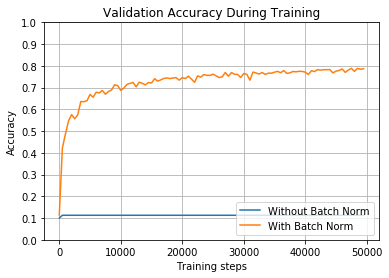

In [38]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
train_and_test(use_larger_weights=True,learning_rate=0.01,activation_fn=tf.nn.relu)

## 4.6 较大的Weights初始化，较小的学习率，sigmoid激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 16/50000 [00:00<05:14, 158.84it/s]

  0%|▏                                                                                            | 81/50000 [00:00<04:03, 205.26it/s]

  0%|▎                                                                                           | 150/50000 [00:00<03:11, 259.86it/s]

  0%|▍                                                                                           | 214/50000 [00:00<02:37, 315.86it/s]

  1%|▍                                                                                           | 259/50000 [00:00<02:51, 290.73it/s]

  1%|▌                                                                                           | 315/50000 [00:00<02:26, 339.28it/s]

  1%|▋                                                                                           | 383/50000 [00:00<02:04, 398.10it/s]

  1%|▊                                                                                           | 445/50000 [00:00<01:51, 444.33it/s]

  1%|▉                                                                                           | 501/50000 [00:00<01:44, 471.62it/s]

  1%|█                                                                                           | 569/50000 [00:01<01:35, 517.32it/s]

  1%|█▏                                                                                          | 642/50000 [00:01<01:27, 565.90it/s]

  1%|█▎                                                                                          | 712/50000 [00:01<01:22, 599.28it/s]

  2%|█▍                                                                                          | 777/50000 [00:01<01:20, 610.66it/s]

  2%|█▌                                                                                          | 857/50000 [00:01<01:14, 656.15it/s]

  2%|█▋                                                                                          | 930/50000 [00:01<01:12, 675.31it/s]

  2%|█▊                                                                                         | 1003/50000 [00:01<01:11, 689.41it/s]

  2%|█▉                                                                                         | 1076/50000 [00:01<01:09, 699.63it/s]

  2%|██                                                                                         | 1156/50000 [00:01<01:07, 725.55it/s]

  2%|██▏                                                                                        | 1230/50000 [00:02<01:28, 552.54it/s]

  3%|██▍                                                                                        | 1305/50000 [00:02<01:21, 597.42it/s]

  3%|██▌                                                                                        | 1380/50000 [00:02<01:16, 635.10it/s]

  3%|██▋                                                                                        | 1449/50000 [00:02<01:20, 600.28it/s]

  3%|██▊                                                                                        | 1513/50000 [00:02<01:24, 571.26it/s]

  3%|██▊                                                                                        | 1574/50000 [00:02<01:24, 574.59it/s]

  3%|██▉                                                                                        | 1634/50000 [00:02<01:24, 575.75it/s]

  3%|███                                                                                        | 1698/50000 [00:02<01:21, 590.79it/s]

  4%|███▏                                                                                       | 1761/50000 [00:02<01:20, 600.77it/s]

  4%|███▎                                                                                       | 1825/50000 [00:03<01:19, 609.01it/s]

  4%|███▍                                                                                       | 1889/50000 [00:03<01:18, 616.68it/s]

  4%|███▌                                                                                       | 1952/50000 [00:03<01:18, 610.30it/s]

  4%|███▋                                                                                       | 2014/50000 [00:03<01:20, 592.61it/s]

  4%|███▊                                                                                       | 2074/50000 [00:03<01:21, 590.02it/s]

  4%|███▉                                                                                       | 2134/50000 [00:03<01:42, 467.54it/s]

  4%|███▉                                                                                       | 2195/50000 [00:03<01:35, 500.63it/s]

  5%|████                                                                                       | 2266/50000 [00:03<01:27, 548.29it/s]

  5%|████▏                                                                                      | 2328/50000 [00:03<01:24, 565.31it/s]

  5%|████▎                                                                                      | 2388/50000 [00:04<01:23, 572.44it/s]

  5%|████▍                                                                                      | 2462/50000 [00:04<01:17, 613.05it/s]

  5%|████▌                                                                                      | 2527/50000 [00:04<01:16, 622.37it/s]

  5%|████▋                                                                                      | 2592/50000 [00:04<01:15, 627.26it/s]

  5%|████▊                                                                                      | 2672/50000 [00:04<01:10, 669.48it/s]

  5%|████▉                                                                                      | 2741/50000 [00:04<01:12, 647.56it/s]

  6%|█████                                                                                      | 2811/50000 [00:04<01:11, 661.05it/s]

  6%|█████▏                                                                                     | 2879/50000 [00:04<01:11, 657.52it/s]

  6%|█████▍                                                                                     | 2959/50000 [00:04<01:07, 693.32it/s]

  6%|█████▌                                                                                     | 3030/50000 [00:05<01:30, 518.59it/s]

  6%|█████▋                                                                                     | 3100/50000 [00:05<01:23, 559.98it/s]

  6%|█████▊                                                                                     | 3162/50000 [00:05<01:22, 567.67it/s]

  6%|█████▊                                                                                     | 3223/50000 [00:05<01:22, 567.27it/s]

  7%|█████▉                                                                                     | 3286/50000 [00:05<01:20, 583.55it/s]

  7%|██████                                                                                     | 3347/50000 [00:05<01:19, 588.28it/s]

  7%|██████▏                                                                                    | 3410/50000 [00:05<01:17, 598.95it/s]

  7%|██████▎                                                                                    | 3472/50000 [00:05<01:18, 590.07it/s]

  7%|██████▍                                                                                    | 3532/50000 [00:05<01:20, 579.76it/s]

  7%|██████▌                                                                                    | 3595/50000 [00:06<01:18, 592.74it/s]

  7%|██████▋                                                                                    | 3663/50000 [00:06<01:15, 615.25it/s]

  7%|██████▊                                                                                    | 3726/50000 [00:06<01:15, 614.66it/s]

  8%|██████▉                                                                                    | 3791/50000 [00:06<01:14, 623.54it/s]

  8%|███████                                                                                    | 3858/50000 [00:06<01:12, 635.46it/s]

  8%|███████▏                                                                                   | 3922/50000 [00:06<01:30, 508.53it/s]

  8%|███████▎                                                                                   | 3995/50000 [00:06<01:22, 558.51it/s]

  8%|███████▍                                                                                   | 4069/50000 [00:06<01:16, 601.80it/s]

  8%|███████▌                                                                                   | 4149/50000 [00:06<01:10, 648.96it/s]

  8%|███████▋                                                                                   | 4222/50000 [00:07<01:08, 668.13it/s]

  9%|███████▊                                                                                   | 4298/50000 [00:07<01:06, 691.89it/s]

  9%|███████▉                                                                                   | 4380/50000 [00:07<01:02, 724.51it/s]

  9%|████████                                                                                   | 4455/50000 [00:07<01:02, 726.18it/s]

  9%|████████▏                                                                                  | 4529/50000 [00:07<01:04, 699.83it/s]

  9%|████████▍                                                                                  | 4609/50000 [00:07<01:02, 725.70it/s]

  9%|████████▌                                                                                  | 4691/50000 [00:07<01:00, 750.12it/s]

 10%|████████▋                                                                                  | 4767/50000 [00:07<01:01, 736.18it/s]

 10%|████████▊                                                                                  | 4842/50000 [00:07<01:19, 569.25it/s]

 10%|████████▉                                                                                  | 4910/50000 [00:08<01:15, 597.34it/s]

 10%|█████████                                                                                  | 4988/50000 [00:08<01:10, 641.32it/s]

 10%|█████████▏                                                                                 | 5062/50000 [00:08<01:07, 666.72it/s]

 10%|█████████▎                                                                                 | 5136/50000 [00:08<01:05, 685.74it/s]

 10%|█████████▍                                                                                 | 5210/50000 [00:08<01:04, 699.71it/s]

 11%|█████████▋                                                                                 | 5290/50000 [00:08<01:01, 725.61it/s]

 11%|█████████▊                                                                                 | 5368/50000 [00:08<01:00, 739.57it/s]

 11%|█████████▉                                                                                 | 5450/50000 [00:08<00:58, 758.34it/s]

 11%|██████████                                                                                 | 5527/50000 [00:08<00:59, 751.28it/s]

 11%|██████████▏                                                                                | 5606/50000 [00:09<00:58, 760.88it/s]

 11%|██████████▎                                                                                | 5683/50000 [00:09<01:00, 731.61it/s]

 12%|██████████▍                                                                                | 5757/50000 [00:09<01:17, 570.35it/s]

 12%|██████████▌                                                                                | 5820/50000 [00:09<01:16, 576.21it/s]

 12%|██████████▋                                                                                | 5899/50000 [00:09<01:10, 626.03it/s]

 12%|██████████▉                                                                                | 5976/50000 [00:09<01:06, 661.99it/s]

 12%|███████████                                                                                | 6050/50000 [00:09<01:04, 682.22it/s]

 12%|███████████▏                                                                               | 6121/50000 [00:09<01:04, 682.91it/s]

 12%|███████████▎                                                                               | 6201/50000 [00:09<01:01, 710.98it/s]

 13%|███████████▍                                                                               | 6282/50000 [00:10<00:59, 736.58it/s]

 13%|███████████▌                                                                               | 6357/50000 [00:10<01:04, 678.91it/s]

 13%|███████████▋                                                                               | 6427/50000 [00:10<01:07, 644.11it/s]

 13%|███████████▊                                                                               | 6494/50000 [00:10<01:10, 621.41it/s]

 13%|███████████▉                                                                               | 6558/50000 [00:10<01:11, 607.76it/s]

 13%|████████████                                                                               | 6621/50000 [00:10<01:10, 612.95it/s]

 13%|████████████▏                                                                              | 6684/50000 [00:10<01:33, 461.29it/s]

 13%|████████████▎                                                                              | 6744/50000 [00:10<01:27, 493.55it/s]

 14%|████████████▍                                                                              | 6806/50000 [00:11<01:22, 523.41it/s]

 14%|████████████▍                                                                              | 6865/50000 [00:11<01:19, 540.67it/s]

 14%|████████████▌                                                                              | 6929/50000 [00:11<01:16, 565.95it/s]

 14%|████████████▋                                                                              | 6990/50000 [00:11<01:14, 577.31it/s]

 14%|████████████▊                                                                              | 7050/50000 [00:11<01:14, 576.00it/s]

 14%|████████████▉                                                                              | 7132/50000 [00:11<01:07, 631.39it/s]

 14%|█████████████▏                                                                             | 7213/50000 [00:11<01:03, 673.20it/s]

 15%|█████████████▎                                                                             | 7291/50000 [00:11<01:01, 698.78it/s]

 15%|█████████████▍                                                                             | 7368/50000 [00:11<00:59, 715.26it/s]

 15%|█████████████▌                                                                             | 7450/50000 [00:11<00:57, 742.29it/s]

 15%|█████████████▋                                                                             | 7526/50000 [00:12<00:57, 737.24it/s]

 15%|█████████████▊                                                                             | 7601/50000 [00:12<01:15, 559.52it/s]

 15%|█████████████▉                                                                             | 7671/50000 [00:12<01:11, 592.75it/s]

 15%|██████████████                                                                             | 7736/50000 [00:12<01:09, 605.90it/s]

 16%|██████████████▏                                                                            | 7813/50000 [00:12<01:05, 646.09it/s]

 16%|██████████████▎                                                                            | 7887/50000 [00:12<01:02, 670.33it/s]

 16%|██████████████▍                                                                            | 7966/50000 [00:12<00:59, 700.88it/s]

 16%|██████████████▋                                                                            | 8039/50000 [00:12<00:59, 705.81it/s]

 16%|██████████████▊                                                                            | 8122/50000 [00:12<00:56, 735.59it/s]

 16%|██████████████▉                                                                            | 8197/50000 [00:13<00:57, 721.26it/s]

 17%|███████████████                                                                            | 8271/50000 [00:13<00:58, 714.74it/s]

 17%|███████████████▏                                                                           | 8349/50000 [00:13<00:56, 731.64it/s]

 17%|███████████████▎                                                                           | 8424/50000 [00:13<00:56, 735.47it/s]

 17%|███████████████▍                                                                           | 8498/50000 [00:13<00:56, 728.72it/s]

 17%|███████████████▌                                                                           | 8572/50000 [00:13<01:14, 556.32it/s]

 17%|███████████████▋                                                                           | 8648/50000 [00:13<01:08, 603.90it/s]

 17%|███████████████▊                                                                           | 8720/50000 [00:13<01:05, 633.38it/s]

 18%|████████████████                                                                           | 8798/50000 [00:14<01:01, 668.25it/s]

 18%|████████████████▏                                                                          | 8872/50000 [00:14<00:59, 686.86it/s]

 18%|████████████████▎                                                                          | 8954/50000 [00:14<00:56, 720.65it/s]

 18%|████████████████▍                                                                          | 9029/50000 [00:14<00:56, 727.66it/s]

 18%|████████████████▌                                                                          | 9104/50000 [00:14<00:57, 715.91it/s]

 18%|████████████████▋                                                                          | 9177/50000 [00:14<00:58, 697.97it/s]

 19%|████████████████▊                                                                          | 9251/50000 [00:14<00:57, 708.58it/s]

 19%|████████████████▉                                                                          | 9329/50000 [00:14<00:55, 727.11it/s]

 19%|█████████████████                                                                          | 9403/50000 [00:14<00:56, 722.95it/s]

 19%|█████████████████▏                                                                         | 9476/50000 [00:15<01:12, 561.87it/s]

 19%|█████████████████▎                                                                         | 9538/50000 [00:15<01:12, 559.80it/s]

 19%|█████████████████▍                                                                         | 9599/50000 [00:15<01:11, 564.86it/s]

 19%|█████████████████▌                                                                         | 9659/50000 [00:15<01:10, 568.87it/s]

 19%|█████████████████▋                                                                         | 9718/50000 [00:15<01:11, 562.37it/s]

 20%|█████████████████▊                                                                         | 9780/50000 [00:15<01:09, 577.32it/s]

 20%|█████████████████▉                                                                         | 9839/50000 [00:15<01:09, 579.81it/s]

 20%|██████████████████                                                                         | 9898/50000 [00:15<01:09, 578.16it/s]

 20%|██████████████████▏                                                                        | 9961/50000 [00:15<01:07, 591.58it/s]

 20%|██████████████████                                                                        | 10021/50000 [00:15<01:09, 579.10it/s]

 20%|██████████████████▏                                                                       | 10080/50000 [00:16<01:08, 579.36it/s]

 20%|██████████████████▎                                                                       | 10143/50000 [00:16<01:07, 592.45it/s]

 20%|██████████████████▎                                                                       | 10203/50000 [00:16<01:07, 593.41it/s]

 21%|██████████████████▍                                                                       | 10263/50000 [00:16<01:07, 592.33it/s]

 21%|██████████████████▌                                                                       | 10323/50000 [00:16<01:07, 586.38it/s]

 21%|██████████████████▋                                                                       | 10382/50000 [00:16<01:25, 464.64it/s]

 21%|██████████████████▊                                                                       | 10453/50000 [00:16<01:16, 517.55it/s]

 21%|██████████████████▉                                                                       | 10528/50000 [00:16<01:09, 569.66it/s]

 21%|███████████████████                                                                       | 10606/50000 [00:16<01:03, 618.72it/s]

 21%|███████████████████▏                                                                      | 10681/50000 [00:17<01:00, 651.74it/s]

 22%|███████████████████▎                                                                      | 10750/50000 [00:17<01:00, 652.04it/s]

 22%|███████████████████▍                                                                      | 10820/50000 [00:17<00:58, 664.35it/s]

 22%|███████████████████▌                                                                      | 10896/50000 [00:17<00:56, 689.05it/s]

 22%|███████████████████▋                                                                      | 10967/50000 [00:17<00:57, 681.75it/s]

 22%|███████████████████▊                                                                      | 11037/50000 [00:17<00:57, 681.66it/s]

 22%|████████████████████                                                                      | 11114/50000 [00:17<00:55, 704.54it/s]

 22%|████████████████████▏                                                                     | 11189/50000 [00:17<00:54, 716.09it/s]

 23%|████████████████████▎                                                                     | 11262/50000 [00:17<01:09, 557.67it/s]

 23%|████████████████████▍                                                                     | 11334/50000 [00:18<01:04, 597.04it/s]

 23%|████████████████████▌                                                                     | 11409/50000 [00:18<01:00, 634.77it/s]

 23%|████████████████████▋                                                                     | 11485/50000 [00:18<00:57, 666.45it/s]

 23%|████████████████████▊                                                                     | 11555/50000 [00:18<01:01, 629.40it/s]

 23%|████████████████████▉                                                                     | 11621/50000 [00:18<01:05, 589.30it/s]

 23%|█████████████████████                                                                     | 11683/50000 [00:18<01:07, 567.49it/s]

 23%|█████████████████████▏                                                                    | 11742/50000 [00:18<01:08, 558.23it/s]

 24%|█████████████████████▏                                                                    | 11804/50000 [00:18<01:06, 572.69it/s]

 24%|█████████████████████▎                                                                    | 11866/50000 [00:18<01:05, 583.25it/s]

 24%|█████████████████████▍                                                                    | 11932/50000 [00:19<01:03, 601.48it/s]

 24%|█████████████████████▌                                                                    | 11998/50000 [00:19<01:01, 616.65it/s]

 24%|█████████████████████▋                                                                    | 12061/50000 [00:19<01:01, 613.84it/s]

 24%|█████████████████████▊                                                                    | 12126/50000 [00:19<01:00, 622.95it/s]

 24%|█████████████████████▉                                                                    | 12189/50000 [00:19<01:18, 478.98it/s]

 24%|██████████████████████                                                                    | 12246/50000 [00:19<01:15, 502.11it/s]

 25%|██████████████████████▏                                                                   | 12302/50000 [00:19<01:12, 517.13it/s]

 25%|██████████████████████▎                                                                   | 12364/50000 [00:19<01:09, 541.72it/s]

 25%|██████████████████████▎                                                                   | 12426/50000 [00:19<01:06, 561.96it/s]

 25%|██████████████████████▍                                                                   | 12485/50000 [00:20<01:07, 552.93it/s]

 25%|██████████████████████▌                                                                   | 12542/50000 [00:20<01:07, 555.13it/s]

 25%|██████████████████████▋                                                                   | 12603/50000 [00:20<01:05, 569.36it/s]

 25%|██████████████████████▊                                                                   | 12668/50000 [00:20<01:03, 590.19it/s]

 25%|██████████████████████▉                                                                   | 12728/50000 [00:20<01:03, 583.21it/s]

 26%|███████████████████████                                                                   | 12792/50000 [00:20<01:02, 597.94it/s]

 26%|███████████████████████▏                                                                  | 12860/50000 [00:20<00:59, 619.16it/s]

 26%|███████████████████████▎                                                                  | 12926/50000 [00:20<00:58, 629.55it/s]

 26%|███████████████████████▍                                                                  | 12994/50000 [00:20<00:57, 640.74it/s]

 26%|███████████████████████▌                                                                  | 13059/50000 [00:21<00:58, 629.03it/s]

 26%|███████████████████████▌                                                                  | 13123/50000 [00:21<01:18, 471.14it/s]

 26%|███████████████████████▋                                                                  | 13181/50000 [00:21<01:13, 498.31it/s]

 27%|███████████████████████▊                                                                  | 13251/50000 [00:21<01:07, 544.53it/s]

 27%|███████████████████████▉                                                                  | 13321/50000 [00:21<01:02, 582.34it/s]

 27%|████████████████████████                                                                  | 13401/50000 [00:21<00:57, 633.00it/s]

 27%|████████████████████████▎                                                                 | 13484/50000 [00:21<00:53, 680.30it/s]

 27%|████████████████████████▍                                                                 | 13559/50000 [00:21<00:52, 698.38it/s]

 27%|████████████████████████▌                                                                 | 13632/50000 [00:21<00:52, 698.00it/s]

 27%|████████████████████████▋                                                                 | 13712/50000 [00:22<00:50, 724.32it/s]

 28%|████████████████████████▊                                                                 | 13787/50000 [00:22<00:49, 726.04it/s]

 28%|████████████████████████▉                                                                 | 13866/50000 [00:22<00:48, 742.58it/s]

 28%|█████████████████████████                                                                 | 13942/50000 [00:22<00:48, 746.12it/s]

 28%|█████████████████████████▏                                                                | 14018/50000 [00:22<01:05, 551.83it/s]

 28%|█████████████████████████▎                                                                | 14095/50000 [00:22<00:59, 602.06it/s]

 28%|█████████████████████████▍                                                                | 14165/50000 [00:22<00:57, 627.20it/s]

 28%|█████████████████████████▋                                                                | 14243/50000 [00:22<00:53, 665.12it/s]

 29%|█████████████████████████▊                                                                | 14323/50000 [00:22<00:51, 699.21it/s]

 29%|█████████████████████████▉                                                                | 14398/50000 [00:23<00:49, 712.23it/s]

 29%|██████████████████████████                                                                | 14477/50000 [00:23<00:48, 732.41it/s]

 29%|██████████████████████████▏                                                               | 14554/50000 [00:23<00:47, 739.59it/s]

 29%|██████████████████████████▎                                                               | 14630/50000 [00:23<00:53, 664.23it/s]

 29%|██████████████████████████▍                                                               | 14701/50000 [00:23<00:52, 675.92it/s]

 30%|██████████████████████████▌                                                               | 14771/50000 [00:23<00:51, 677.56it/s]

 30%|██████████████████████████▋                                                               | 14850/50000 [00:23<00:49, 706.40it/s]

 30%|██████████████████████████▊                                                               | 14922/50000 [00:23<01:03, 553.88it/s]

 30%|██████████████████████████▉                                                               | 14997/50000 [00:24<00:58, 599.98it/s]

 30%|███████████████████████████                                                               | 15064/50000 [00:24<00:56, 618.15it/s]

 30%|███████████████████████████▎                                                              | 15140/50000 [00:24<00:53, 653.58it/s]

 30%|███████████████████████████▍                                                              | 15221/50000 [00:24<00:50, 690.70it/s]

 31%|███████████████████████████▌                                                              | 15298/50000 [00:24<00:48, 711.28it/s]

 31%|███████████████████████████▋                                                              | 15372/50000 [00:24<00:49, 699.84it/s]

 31%|███████████████████████████▊                                                              | 15453/50000 [00:24<00:47, 728.17it/s]

 31%|███████████████████████████▉                                                              | 15528/50000 [00:24<00:48, 714.22it/s]

 31%|████████████████████████████                                                              | 15601/50000 [00:24<00:49, 696.84it/s]

 31%|████████████████████████████▏                                                             | 15672/50000 [00:24<00:49, 691.08it/s]

 31%|████████████████████████████▎                                                             | 15747/50000 [00:25<00:48, 704.31it/s]

 32%|████████████████████████████▍                                                             | 15818/50000 [00:25<00:50, 670.63it/s]

 32%|████████████████████████████▌                                                             | 15886/50000 [00:25<01:08, 500.35it/s]

 32%|████████████████████████████▋                                                             | 15950/50000 [00:25<01:03, 534.42it/s]

 32%|████████████████████████████▊                                                             | 16009/50000 [00:25<01:03, 535.43it/s]

 32%|████████████████████████████▉                                                             | 16073/50000 [00:25<01:00, 560.47it/s]

 32%|█████████████████████████████                                                             | 16145/50000 [00:25<00:56, 597.80it/s]

 32%|█████████████████████████████▏                                                            | 16216/50000 [00:25<00:54, 624.69it/s]

 33%|█████████████████████████████▎                                                            | 16285/50000 [00:26<00:52, 639.85it/s]

 33%|█████████████████████████████▍                                                            | 16356/50000 [00:26<00:51, 658.05it/s]

 33%|█████████████████████████████▌                                                            | 16425/50000 [00:26<00:50, 665.91it/s]

 33%|█████████████████████████████▋                                                            | 16493/50000 [00:26<00:50, 666.67it/s]

 33%|█████████████████████████████▊                                                            | 16561/50000 [00:26<00:50, 667.20it/s]

 33%|█████████████████████████████▉                                                            | 16643/50000 [00:26<00:47, 705.38it/s]

 33%|██████████████████████████████                                                            | 16715/50000 [00:26<00:47, 699.93it/s]

 34%|██████████████████████████████▏                                                           | 16786/50000 [00:26<01:00, 545.10it/s]

 34%|██████████████████████████████▎                                                           | 16862/50000 [00:26<00:55, 594.62it/s]

 34%|██████████████████████████████▍                                                           | 16942/50000 [00:27<00:51, 643.10it/s]

 34%|██████████████████████████████▌                                                           | 17012/50000 [00:27<00:50, 652.32it/s]

 34%|██████████████████████████████▊                                                           | 17087/50000 [00:27<00:48, 675.67it/s]

 34%|██████████████████████████████▉                                                           | 17166/50000 [00:27<00:46, 704.96it/s]

 34%|███████████████████████████████                                                           | 17239/50000 [00:27<00:47, 696.56it/s]

 35%|███████████████████████████████▏                                                          | 17316/50000 [00:27<00:45, 713.63it/s]

 35%|███████████████████████████████▎                                                          | 17389/50000 [00:27<00:46, 702.47it/s]

 35%|███████████████████████████████▍                                                          | 17469/50000 [00:27<00:44, 727.68it/s]

 35%|███████████████████████████████▌                                                          | 17543/50000 [00:27<00:44, 729.76it/s]

 35%|███████████████████████████████▋                                                          | 17617/50000 [00:27<00:44, 729.06it/s]

 35%|███████████████████████████████▊                                                          | 17691/50000 [00:28<00:58, 551.49it/s]

 36%|███████████████████████████████▉                                                          | 17768/50000 [00:28<00:53, 601.78it/s]

 36%|████████████████████████████████▏                                                         | 17849/50000 [00:28<00:49, 650.92it/s]

 36%|████████████████████████████████▎                                                         | 17927/50000 [00:28<00:46, 683.60it/s]

 36%|████████████████████████████████▍                                                         | 18000/50000 [00:28<00:46, 685.67it/s]

 36%|████████████████████████████████▌                                                         | 18072/50000 [00:28<00:46, 686.23it/s]

 36%|████████████████████████████████▋                                                         | 18146/50000 [00:28<00:45, 700.07it/s]

 36%|████████████████████████████████▊                                                         | 18223/50000 [00:28<00:44, 718.20it/s]

 37%|████████████████████████████████▉                                                         | 18305/50000 [00:28<00:42, 744.50it/s]

 37%|█████████████████████████████████                                                         | 18381/50000 [00:29<00:43, 734.50it/s]

 37%|█████████████████████████████████▏                                                        | 18459/50000 [00:29<00:42, 746.02it/s]

 37%|█████████████████████████████████▎                                                        | 18535/50000 [00:29<00:42, 748.53it/s]

 37%|█████████████████████████████████▍                                                        | 18611/50000 [00:29<00:54, 571.40it/s]

 37%|█████████████████████████████████▌                                                        | 18679/50000 [00:29<00:52, 599.00it/s]

 37%|█████████████████████████████████▋                                                        | 18748/50000 [00:29<00:50, 620.77it/s]

 38%|█████████████████████████████████▉                                                        | 18826/50000 [00:29<00:47, 660.04it/s]

 38%|██████████████████████████████████                                                        | 18904/50000 [00:29<00:45, 690.62it/s]

 38%|██████████████████████████████████▏                                                       | 18985/50000 [00:29<00:43, 721.16it/s]

 38%|██████████████████████████████████▎                                                       | 19060/50000 [00:30<00:45, 673.27it/s]

 38%|██████████████████████████████████▍                                                       | 19130/50000 [00:30<00:48, 635.33it/s]

 38%|██████████████████████████████████▌                                                       | 19196/50000 [00:30<00:48, 633.80it/s]

 39%|██████████████████████████████████▋                                                       | 19261/50000 [00:30<00:50, 605.25it/s]

 39%|██████████████████████████████████▊                                                       | 19323/50000 [00:30<00:50, 602.95it/s]

 39%|██████████████████████████████████▉                                                       | 19385/50000 [00:30<00:52, 587.76it/s]

 39%|███████████████████████████████████                                                       | 19450/50000 [00:30<00:50, 603.91it/s]

 39%|███████████████████████████████████                                                       | 19511/50000 [00:31<01:08, 441.95it/s]

 39%|███████████████████████████████████▏                                                      | 19569/50000 [00:31<01:04, 473.92it/s]

 39%|███████████████████████████████████▎                                                      | 19631/50000 [00:31<00:59, 509.04it/s]

 39%|███████████████████████████████████▍                                                      | 19698/50000 [00:31<00:55, 547.58it/s]

 40%|███████████████████████████████████▌                                                      | 19760/50000 [00:31<00:53, 564.81it/s]

 40%|███████████████████████████████████▋                                                      | 19827/50000 [00:31<00:51, 590.02it/s]

 40%|███████████████████████████████████▊                                                      | 19895/50000 [00:31<00:49, 613.20it/s]

 40%|███████████████████████████████████▉                                                      | 19966/50000 [00:31<00:47, 638.09it/s]

 40%|████████████████████████████████████                                                      | 20036/50000 [00:31<00:45, 654.14it/s]

 40%|████████████████████████████████████▏                                                     | 20107/50000 [00:31<00:44, 666.69it/s]

 40%|████████████████████████████████████▎                                                     | 20180/50000 [00:32<00:43, 683.10it/s]

 40%|████████████████████████████████████▍                                                     | 20250/50000 [00:32<00:43, 678.63it/s]

 41%|████████████████████████████████████▌                                                     | 20327/50000 [00:32<00:42, 702.28it/s]

 41%|████████████████████████████████████▋                                                     | 20401/50000 [00:32<00:41, 711.68it/s]

 41%|████████████████████████████████████▊                                                     | 20473/50000 [00:32<00:54, 541.14it/s]

 41%|████████████████████████████████████▉                                                     | 20534/50000 [00:32<00:53, 554.43it/s]

 41%|█████████████████████████████████████                                                     | 20599/50000 [00:32<00:50, 577.34it/s]

 41%|█████████████████████████████████████▏                                                    | 20667/50000 [00:32<00:48, 601.95it/s]

 41%|█████████████████████████████████████▎                                                    | 20732/50000 [00:32<00:47, 614.33it/s]

 42%|█████████████████████████████████████▍                                                    | 20802/50000 [00:33<00:46, 634.73it/s]

 42%|█████████████████████████████████████▌                                                    | 20870/50000 [00:33<00:45, 646.34it/s]

 42%|█████████████████████████████████████▋                                                    | 20939/50000 [00:33<00:44, 655.60it/s]

 42%|█████████████████████████████████████▊                                                    | 21006/50000 [00:33<00:44, 652.68it/s]

 42%|█████████████████████████████████████▉                                                    | 21073/50000 [00:33<00:44, 656.36it/s]

 42%|██████████████████████████████████████                                                    | 21140/50000 [00:33<00:44, 653.21it/s]

 42%|██████████████████████████████████████▏                                                   | 21207/50000 [00:33<00:44, 652.91it/s]

 43%|██████████████████████████████████████▎                                                   | 21273/50000 [00:33<00:44, 645.95it/s]

 43%|██████████████████████████████████████▍                                                   | 21338/50000 [00:33<00:58, 488.82it/s]

 43%|██████████████████████████████████████▌                                                   | 21397/50000 [00:34<00:55, 513.01it/s]

 43%|██████████████████████████████████████▋                                                   | 21461/50000 [00:34<00:52, 544.47it/s]

 43%|██████████████████████████████████████▋                                                   | 21526/50000 [00:34<00:49, 571.24it/s]

 43%|██████████████████████████████████████▊                                                   | 21591/50000 [00:34<00:48, 590.00it/s]

 43%|██████████████████████████████████████▉                                                   | 21653/50000 [00:34<00:48, 587.27it/s]

 43%|███████████████████████████████████████                                                   | 21715/50000 [00:34<00:47, 595.46it/s]

 44%|███████████████████████████████████████▏                                                  | 21781/50000 [00:34<00:46, 612.21it/s]

 44%|███████████████████████████████████████▎                                                  | 21852/50000 [00:34<00:44, 635.64it/s]

 44%|███████████████████████████████████████▍                                                  | 21922/50000 [00:34<00:43, 652.33it/s]

 44%|███████████████████████████████████████▌                                                  | 21993/50000 [00:34<00:42, 665.37it/s]

 44%|███████████████████████████████████████▋                                                  | 22061/50000 [00:35<00:42, 651.03it/s]

 44%|███████████████████████████████████████▊                                                  | 22127/50000 [00:35<00:44, 631.73it/s]

 44%|███████████████████████████████████████▉                                                  | 22191/50000 [00:35<00:44, 627.25it/s]

 45%|████████████████████████████████████████                                                  | 22255/50000 [00:35<00:58, 472.49it/s]

 45%|████████████████████████████████████████▏                                                 | 22310/50000 [00:35<00:56, 492.38it/s]

 45%|████████████████████████████████████████▎                                                 | 22371/50000 [00:35<00:53, 520.30it/s]

 45%|████████████████████████████████████████▍                                                 | 22434/50000 [00:35<00:50, 547.93it/s]

 45%|████████████████████████████████████████▌                                                 | 22500/50000 [00:35<00:47, 576.24it/s]

 45%|████████████████████████████████████████▌                                                 | 22561/50000 [00:36<00:46, 584.74it/s]

 45%|████████████████████████████████████████▋                                                 | 22622/50000 [00:36<00:46, 589.13it/s]

 45%|████████████████████████████████████████▊                                                 | 22695/50000 [00:36<00:43, 624.16it/s]

 46%|████████████████████████████████████████▉                                                 | 22766/50000 [00:36<00:42, 644.60it/s]

 46%|█████████████████████████████████████████                                                 | 22838/50000 [00:36<00:40, 664.16it/s]

 46%|█████████████████████████████████████████▎                                                | 22918/50000 [00:36<00:38, 698.47it/s]

 46%|█████████████████████████████████████████▍                                                | 22989/50000 [00:36<00:38, 694.23it/s]

 46%|█████████████████████████████████████████▌                                                | 23060/50000 [00:36<00:39, 683.32it/s]

 46%|█████████████████████████████████████████▋                                                | 23136/50000 [00:36<00:38, 701.28it/s]

 46%|█████████████████████████████████████████▊                                                | 23207/50000 [00:37<00:50, 534.62it/s]

 47%|█████████████████████████████████████████▉                                                | 23267/50000 [00:37<00:48, 551.55it/s]

 47%|█████████████████████████████████████████▉                                                | 23333/50000 [00:37<00:46, 579.06it/s]

 47%|██████████████████████████████████████████▏                                               | 23407/50000 [00:37<00:43, 618.34it/s]

 47%|██████████████████████████████████████████▎                                               | 23477/50000 [00:37<00:41, 639.48it/s]

 47%|██████████████████████████████████████████▍                                               | 23544/50000 [00:37<00:42, 623.55it/s]

 47%|██████████████████████████████████████████▍                                               | 23610/50000 [00:37<00:41, 630.92it/s]

 47%|██████████████████████████████████████████▋                                               | 23681/50000 [00:37<00:40, 651.41it/s]

 48%|██████████████████████████████████████████▊                                               | 23754/50000 [00:37<00:39, 671.79it/s]

 48%|██████████████████████████████████████████▉                                               | 23826/50000 [00:37<00:38, 684.14it/s]

 48%|███████████████████████████████████████████                                               | 23896/50000 [00:38<00:38, 677.39it/s]

 48%|███████████████████████████████████████████▏                                              | 23965/50000 [00:38<00:39, 662.09it/s]

 48%|███████████████████████████████████████████▎                                              | 24032/50000 [00:38<00:40, 638.42it/s]

 48%|███████████████████████████████████████████▎                                              | 24097/50000 [00:38<00:53, 485.80it/s]

 48%|███████████████████████████████████████████▍                                              | 24161/50000 [00:38<00:49, 521.42it/s]

 48%|███████████████████████████████████████████▌                                              | 24226/50000 [00:38<00:46, 553.30it/s]

 49%|███████████████████████████████████████████▋                                              | 24291/50000 [00:38<00:44, 578.02it/s]

 49%|███████████████████████████████████████████▊                                              | 24356/50000 [00:38<00:42, 596.68it/s]

 49%|███████████████████████████████████████████▉                                              | 24419/50000 [00:39<00:42, 605.02it/s]

 49%|████████████████████████████████████████████                                              | 24486/50000 [00:39<00:41, 621.88it/s]

 49%|████████████████████████████████████████████▏                                             | 24550/50000 [00:39<00:40, 622.23it/s]

 49%|████████████████████████████████████████████▎                                             | 24616/50000 [00:39<00:40, 631.77it/s]

 49%|████████████████████████████████████████████▍                                             | 24685/50000 [00:39<00:39, 645.02it/s]

 50%|████████████████████████████████████████████▌                                             | 24764/50000 [00:39<00:37, 679.57it/s]

 50%|████████████████████████████████████████████▋                                             | 24835/50000 [00:39<00:36, 684.98it/s]

 50%|████████████████████████████████████████████▊                                             | 24905/50000 [00:39<00:36, 683.91it/s]

 50%|████████████████████████████████████████████▉                                             | 24975/50000 [00:39<00:36, 687.18it/s]

 50%|█████████████████████████████████████████████                                             | 25045/50000 [00:40<00:48, 517.24it/s]

 50%|█████████████████████████████████████████████▏                                            | 25104/50000 [00:40<00:47, 528.85it/s]

 50%|█████████████████████████████████████████████▎                                            | 25168/50000 [00:40<00:44, 556.85it/s]

 50%|█████████████████████████████████████████████▍                                            | 25232/50000 [00:40<00:42, 576.72it/s]

 51%|█████████████████████████████████████████████▌                                            | 25296/50000 [00:40<00:41, 593.15it/s]

 51%|█████████████████████████████████████████████▋                                            | 25363/50000 [00:40<00:40, 613.06it/s]

 51%|█████████████████████████████████████████████▊                                            | 25428/50000 [00:40<00:39, 620.61it/s]

 51%|█████████████████████████████████████████████▉                                            | 25493/50000 [00:40<00:39, 627.81it/s]

 51%|██████████████████████████████████████████████                                            | 25557/50000 [00:40<00:39, 626.36it/s]

 51%|██████████████████████████████████████████████                                            | 25625/50000 [00:40<00:38, 640.22it/s]

 51%|██████████████████████████████████████████████▏                                           | 25692/50000 [00:41<00:37, 647.50it/s]

 52%|██████████████████████████████████████████████▎                                           | 25761/50000 [00:41<00:36, 656.44it/s]

 52%|██████████████████████████████████████████████▍                                           | 25829/50000 [00:41<00:36, 660.00it/s]

 52%|██████████████████████████████████████████████▌                                           | 25900/50000 [00:41<00:35, 672.84it/s]

 52%|██████████████████████████████████████████████▋                                           | 25968/50000 [00:41<00:46, 511.36it/s]

 52%|██████████████████████████████████████████████▊                                           | 26026/50000 [00:41<00:45, 526.25it/s]

 52%|██████████████████████████████████████████████▉                                           | 26089/50000 [00:41<00:43, 551.09it/s]

 52%|███████████████████████████████████████████████                                           | 26155/50000 [00:41<00:41, 578.68it/s]

 52%|███████████████████████████████████████████████▏                                          | 26217/50000 [00:41<00:40, 589.26it/s]

 53%|███████████████████████████████████████████████▎                                          | 26278/50000 [00:42<00:40, 592.33it/s]

 53%|███████████████████████████████████████████████▍                                          | 26342/50000 [00:42<00:39, 602.91it/s]

 53%|███████████████████████████████████████████████▌                                          | 26405/50000 [00:42<00:38, 607.74it/s]

 53%|███████████████████████████████████████████████▋                                          | 26468/50000 [00:42<00:38, 611.16it/s]

 53%|███████████████████████████████████████████████▊                                          | 26532/50000 [00:42<00:38, 616.44it/s]

 53%|███████████████████████████████████████████████▊                                          | 26597/50000 [00:42<00:37, 624.82it/s]

 53%|███████████████████████████████████████████████▉                                          | 26660/50000 [00:42<00:37, 625.00it/s]

 53%|████████████████████████████████████████████████                                          | 26723/50000 [00:42<00:37, 621.44it/s]

 54%|████████████████████████████████████████████████▏                                         | 26787/50000 [00:42<00:37, 625.55it/s]

 54%|████████████████████████████████████████████████▎                                         | 26850/50000 [00:43<00:48, 476.79it/s]

 54%|████████████████████████████████████████████████▍                                         | 26917/50000 [00:43<00:44, 521.06it/s]

 54%|████████████████████████████████████████████████▌                                         | 26986/50000 [00:43<00:40, 561.36it/s]

 54%|████████████████████████████████████████████████▋                                         | 27047/50000 [00:43<00:40, 569.13it/s]

 54%|████████████████████████████████████████████████▊                                         | 27108/50000 [00:43<00:39, 579.59it/s]

 54%|████████████████████████████████████████████████▉                                         | 27178/50000 [00:43<00:37, 609.96it/s]

 54%|█████████████████████████████████████████████████                                         | 27249/50000 [00:43<00:35, 635.63it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27328/50000 [00:43<00:33, 673.95it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27409/50000 [00:43<00:31, 708.35it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27494/50000 [00:44<00:30, 744.20it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27571/50000 [00:44<00:31, 706.88it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27650/50000 [00:44<00:30, 728.45it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27726/50000 [00:44<00:30, 736.07it/s]

 56%|██████████████████████████████████████████████████                                        | 27801/50000 [00:44<00:41, 530.64it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27863/50000 [00:44<00:41, 536.35it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27931/50000 [00:44<00:38, 571.58it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28003/50000 [00:44<00:36, 608.13it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28077/50000 [00:44<00:34, 641.26it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28145/50000 [00:45<00:33, 647.31it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28213/50000 [00:45<00:34, 624.79it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28278/50000 [00:45<00:35, 616.48it/s]

 57%|███████████████████████████████████████████████████                                       | 28341/50000 [00:45<00:35, 610.17it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28403/50000 [00:45<00:35, 611.71it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28465/50000 [00:45<00:36, 585.20it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28525/50000 [00:45<00:37, 579.79it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28590/50000 [00:45<00:35, 597.98it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28658/50000 [00:45<00:34, 617.53it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28721/50000 [00:46<00:46, 453.12it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28776/50000 [00:46<00:44, 477.48it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28839/50000 [00:46<00:41, 513.98it/s]

 58%|████████████████████████████████████████████████████                                      | 28914/50000 [00:46<00:37, 566.62it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28996/50000 [00:46<00:33, 622.06it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29066/50000 [00:46<00:32, 642.26it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29138/50000 [00:46<00:31, 662.42it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29211/50000 [00:46<00:30, 679.95it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29291/50000 [00:46<00:29, 710.62it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29365/50000 [00:47<00:28, 717.66it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29443/50000 [00:47<00:28, 731.71it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29518/50000 [00:47<00:28, 726.99it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29592/50000 [00:47<00:36, 564.48it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29669/50000 [00:47<00:33, 611.09it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29740/50000 [00:47<00:31, 636.49it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29808/50000 [00:47<00:31, 645.76it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29876/50000 [00:47<00:31, 646.83it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29954/50000 [00:47<00:29, 680.45it/s]

 60%|██████████████████████████████████████████████████████                                    | 30030/50000 [00:48<00:28, 701.08it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30113/50000 [00:48<00:27, 733.92it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30195/50000 [00:48<00:26, 756.26it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30275/50000 [00:48<00:25, 765.06it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30356/50000 [00:48<00:25, 776.37it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30435/50000 [00:48<00:25, 778.73it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30514/50000 [00:48<00:33, 590.23it/s]

 61%|███████████████████████████████████████████████████████                                   | 30587/50000 [00:48<00:31, 625.03it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30669/50000 [00:49<00:28, 670.18it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30741/50000 [00:49<00:28, 669.64it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30817/50000 [00:49<00:27, 693.04it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30897/50000 [00:49<00:26, 720.58it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30973/50000 [00:49<00:26, 730.42it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31048/50000 [00:49<00:26, 719.84it/s]

 62%|████████████████████████████████████████████████████████                                  | 31124/50000 [00:49<00:25, 729.90it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31198/50000 [00:49<00:26, 706.25it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31274/50000 [00:49<00:26, 720.06it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31349/50000 [00:49<00:25, 725.09it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31422/50000 [00:50<00:33, 553.86it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31484/50000 [00:50<00:33, 551.26it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31544/50000 [00:50<00:34, 533.84it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31601/50000 [00:50<00:34, 529.48it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31661/50000 [00:50<00:33, 546.24it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31721/50000 [00:50<00:32, 558.62it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31783/50000 [00:50<00:31, 574.55it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31847/50000 [00:50<00:30, 591.54it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31912/50000 [00:50<00:29, 606.70it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31976/50000 [00:51<00:29, 615.02it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32039/50000 [00:51<00:29, 618.11it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32104/50000 [00:51<00:28, 624.22it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32169/50000 [00:51<00:28, 630.39it/s]

 64%|██████████████████████████████████████████████████████████                                | 32238/50000 [00:51<00:27, 645.84it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32310/50000 [00:51<00:26, 665.08it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32377/50000 [00:51<00:34, 504.70it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32443/50000 [00:51<00:32, 542.06it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32503/50000 [00:52<00:31, 550.97it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32572/50000 [00:52<00:29, 585.30it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32644/50000 [00:52<00:28, 618.97it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32724/50000 [00:52<00:26, 661.20it/s]

 66%|███████████████████████████████████████████████████████████                               | 32798/50000 [00:52<00:25, 681.64it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32877/50000 [00:52<00:24, 709.50it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32952/50000 [00:52<00:23, 719.66it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33026/50000 [00:52<00:23, 711.59it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33099/50000 [00:52<00:23, 713.38it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33175/50000 [00:52<00:23, 725.22it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33249/50000 [00:53<00:23, 725.90it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33322/50000 [00:53<00:29, 560.52it/s]

 67%|████████████████████████████████████████████████████████████                              | 33402/50000 [00:53<00:27, 613.38it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33479/50000 [00:53<00:25, 652.03it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33554/50000 [00:53<00:24, 677.27it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33634/50000 [00:53<00:23, 708.57it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33708/50000 [00:53<00:22, 710.03it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33781/50000 [00:53<00:22, 710.21it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33856/50000 [00:53<00:22, 720.18it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33936/50000 [00:54<00:21, 740.89it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34011/50000 [00:54<00:22, 722.70it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34086/50000 [00:54<00:21, 729.16it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34164/50000 [00:54<00:21, 742.15it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34239/50000 [00:54<00:27, 578.33it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34318/50000 [00:54<00:24, 627.79it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34388/50000 [00:54<00:24, 646.52it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34460/50000 [00:54<00:23, 665.59it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34530/50000 [00:54<00:23, 653.42it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34601/50000 [00:55<00:23, 666.17it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34670/50000 [00:55<00:24, 626.11it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34735/50000 [00:55<00:24, 628.09it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34801/50000 [00:55<00:23, 634.16it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34866/50000 [00:55<00:23, 633.74it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34930/50000 [00:55<00:24, 624.96it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34993/50000 [00:55<00:24, 607.08it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35055/50000 [00:55<00:25, 592.16it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35115/50000 [00:56<00:33, 448.56it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35173/50000 [00:56<00:30, 480.42it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35237/50000 [00:56<00:28, 518.34it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35303/50000 [00:56<00:26, 552.99it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35371/50000 [00:56<00:25, 584.72it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35445/50000 [00:56<00:23, 622.85it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35524/50000 [00:56<00:21, 663.84it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35607/50000 [00:56<00:20, 704.94it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35686/50000 [00:56<00:19, 727.00it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35767/50000 [00:56<00:19, 748.50it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35844/50000 [00:57<00:19, 744.53it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35925/50000 [00:57<00:18, 759.32it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36002/50000 [00:57<00:24, 578.00it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36077/50000 [00:57<00:22, 619.58it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36159/50000 [00:57<00:20, 667.41it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36241/50000 [00:57<00:19, 705.54it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36318/50000 [00:57<00:18, 722.23it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36394/50000 [00:57<00:18, 719.18it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36478/50000 [00:57<00:18, 750.14it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36555/50000 [00:58<00:18, 724.63it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36634/50000 [00:58<00:18, 739.47it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36710/50000 [00:58<00:18, 728.97it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36790/50000 [00:58<00:17, 747.38it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36870/50000 [00:58<00:17, 760.84it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36947/50000 [00:58<00:22, 572.18it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37015/50000 [00:58<00:21, 599.59it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37081/50000 [00:58<00:20, 615.27it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37153/50000 [00:59<00:20, 640.38it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37221/50000 [00:59<00:19, 650.40it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37304/50000 [00:59<00:18, 694.28it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37386/50000 [00:59<00:17, 726.34it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37467/50000 [00:59<00:16, 748.05it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37544/50000 [00:59<00:16, 744.18it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37623/50000 [00:59<00:16, 755.77it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37700/50000 [00:59<00:16, 751.70it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37776/50000 [00:59<00:16, 726.70it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37850/50000 [01:00<00:21, 554.24it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37912/50000 [01:00<00:21, 560.48it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37973/50000 [01:00<00:21, 553.08it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38032/50000 [01:00<00:21, 549.93it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38091/50000 [01:00<00:21, 560.20it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38153/50000 [01:00<00:20, 575.72it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38216/50000 [01:00<00:19, 589.78it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38282/50000 [01:00<00:19, 606.33it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38347/50000 [01:00<00:18, 615.76it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38414/50000 [01:00<00:18, 629.79it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38478/50000 [01:01<00:18, 625.91it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38545/50000 [01:01<00:18, 635.35it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38609/50000 [01:01<00:18, 626.08it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38677/50000 [01:01<00:17, 640.01it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38751/50000 [01:01<00:21, 525.66it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38821/50000 [01:01<00:19, 567.10it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38898/50000 [01:01<00:18, 614.70it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38964/50000 [01:01<00:17, 619.28it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39037/50000 [01:01<00:16, 647.54it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39105/50000 [01:02<00:16, 655.56it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39186/50000 [01:02<00:15, 694.03it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39266/50000 [01:02<00:14, 721.32it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39343/50000 [01:02<00:14, 733.73it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39418/50000 [01:02<00:14, 734.77it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39493/50000 [01:02<00:14, 733.38it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39569/50000 [01:02<00:14, 739.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39645/50000 [01:02<00:13, 741.82it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39720/50000 [01:03<00:18, 567.72it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39791/50000 [01:03<00:16, 602.91it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39871/50000 [01:03<00:15, 649.87it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39951/50000 [01:03<00:14, 687.34it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40024/50000 [01:03<00:14, 696.15it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40103/50000 [01:03<00:13, 720.43it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40184/50000 [01:03<00:13, 743.65it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40261/50000 [01:03<00:13, 741.12it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40339/50000 [01:03<00:12, 750.79it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40415/50000 [01:03<00:13, 721.97it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40496/50000 [01:04<00:12, 744.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40572/50000 [01:04<00:13, 720.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40645/50000 [01:04<00:16, 554.30it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40723/50000 [01:04<00:15, 605.96it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40804/50000 [01:04<00:14, 654.34it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40882/50000 [01:04<00:13, 686.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40961/50000 [01:04<00:12, 712.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41036/50000 [01:04<00:12, 696.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41115/50000 [01:04<00:12, 720.40it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41189/50000 [01:05<00:12, 686.41it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41260/50000 [01:05<00:13, 627.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41326/50000 [01:05<00:13, 635.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41392/50000 [01:05<00:13, 637.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41462/50000 [01:05<00:13, 653.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41529/50000 [01:05<00:17, 483.95it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41585/50000 [01:05<00:16, 498.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41640/50000 [01:05<00:16, 510.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41702/50000 [01:06<00:15, 536.40it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41768/50000 [01:06<00:14, 567.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41834/50000 [01:06<00:13, 591.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41905/50000 [01:06<00:13, 619.52it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41969/50000 [01:06<00:12, 618.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42038/50000 [01:06<00:12, 637.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42106/50000 [01:06<00:12, 648.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42176/50000 [01:06<00:11, 661.50it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42243/50000 [01:06<00:11, 649.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42309/50000 [01:06<00:12, 637.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42374/50000 [01:07<00:12, 614.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42436/50000 [01:07<00:16, 459.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42498/50000 [01:07<00:15, 497.30it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42557/50000 [01:07<00:14, 520.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42624/50000 [01:07<00:13, 555.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42689/50000 [01:07<00:12, 578.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42759/50000 [01:07<00:11, 607.42it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42822/50000 [01:07<00:11, 610.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42887/50000 [01:08<00:11, 620.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42962/50000 [01:08<00:10, 651.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43031/50000 [01:08<00:10, 659.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43108/50000 [01:08<00:10, 687.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43183/50000 [01:08<00:09, 703.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43262/50000 [01:08<00:09, 726.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43336/50000 [01:08<00:11, 560.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43411/50000 [01:08<00:10, 605.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43484/50000 [01:08<00:10, 636.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43558/50000 [01:09<00:09, 663.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43633/50000 [01:09<00:09, 685.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43705/50000 [01:09<00:09, 694.19it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43784/50000 [01:09<00:08, 718.97it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43861/50000 [01:09<00:08, 732.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43941/50000 [01:09<00:08, 749.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44017/50000 [01:09<00:08, 733.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44092/50000 [01:09<00:08, 732.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44166/50000 [01:09<00:07, 731.07it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44240/50000 [01:09<00:08, 707.02it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44312/50000 [01:10<00:11, 507.41it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44371/50000 [01:10<00:10, 513.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44429/50000 [01:10<00:10, 529.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44487/50000 [01:10<00:10, 537.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44545/50000 [01:10<00:09, 548.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44602/50000 [01:10<00:09, 553.76it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44664/50000 [01:10<00:09, 569.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44726/50000 [01:10<00:09, 582.47it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44788/50000 [01:11<00:08, 592.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44848/50000 [01:11<00:08, 589.60it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44908/50000 [01:11<00:08, 584.51it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44975/50000 [01:11<00:08, 606.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45041/50000 [01:11<00:07, 620.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45116/50000 [01:11<00:07, 651.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45182/50000 [01:11<00:09, 516.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45260/50000 [01:11<00:08, 573.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45327/50000 [01:11<00:07, 598.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45401/50000 [01:12<00:07, 633.72it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45475/50000 [01:12<00:06, 660.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45544/50000 [01:12<00:06, 649.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45620/50000 [01:12<00:06, 677.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45696/50000 [01:12<00:06, 698.94it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45777/50000 [01:12<00:05, 727.48it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45851/50000 [01:12<00:05, 729.62it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45928/50000 [01:12<00:05, 739.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46003/50000 [01:12<00:05, 734.62it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46077/50000 [01:12<00:05, 726.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46150/50000 [01:13<00:07, 547.99it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46221/50000 [01:13<00:06, 587.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46299/50000 [01:13<00:05, 631.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46370/50000 [01:13<00:05, 651.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46449/50000 [01:13<00:05, 686.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46522/50000 [01:13<00:04, 697.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46600/50000 [01:13<00:04, 719.02it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46680/50000 [01:13<00:04, 740.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46756/50000 [01:13<00:04, 716.96it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46829/50000 [01:14<00:04, 706.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46907/50000 [01:14<00:04, 725.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46983/50000 [01:14<00:04, 732.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47057/50000 [01:14<00:05, 556.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47140/50000 [01:14<00:04, 615.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47214/50000 [01:14<00:04, 646.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47293/50000 [01:14<00:03, 682.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47374/50000 [01:14<00:03, 715.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47449/50000 [01:14<00:03, 721.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47524/50000 [01:15<00:03, 694.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47596/50000 [01:15<00:03, 665.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47665/50000 [01:15<00:03, 653.95it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47732/50000 [01:15<00:03, 631.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47797/50000 [01:15<00:03, 620.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47860/50000 [01:15<00:03, 616.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47923/50000 [01:15<00:04, 468.99it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47977/50000 [01:15<00:04, 487.29it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48032/50000 [01:16<00:03, 502.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48102/50000 [01:16<00:03, 547.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48169/50000 [01:16<00:03, 578.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48236/50000 [01:16<00:02, 601.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48307/50000 [01:16<00:02, 629.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48387/50000 [01:16<00:02, 671.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48468/50000 [01:16<00:02, 706.27it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48541/50000 [01:16<00:02, 709.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48622/50000 [01:16<00:01, 735.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48697/50000 [01:16<00:01, 738.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48772/50000 [01:17<00:01, 731.48it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48846/50000 [01:17<00:02, 563.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48914/50000 [01:17<00:01, 593.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48979/50000 [01:17<00:01, 606.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49050/50000 [01:17<00:01, 632.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49127/50000 [01:17<00:01, 667.23it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49201/50000 [01:17<00:01, 686.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49282/50000 [01:17<00:01, 717.71it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49356/50000 [01:18<00:00, 708.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49429/50000 [01:18<00:00, 692.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49506/50000 [01:18<00:00, 710.89it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49578/50000 [01:18<00:00, 687.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49657/50000 [01:18<00:00, 714.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49736/50000 [01:18<00:00, 731.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49810/50000 [01:18<00:00, 562.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49888/50000 [01:18<00:00, 612.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49969/50000 [01:18<00:00, 658.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:18<00:00, 633.01it/s]

Without Batch Norm:the final accuracy on validation data is 0.1932000070810318

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<4:20:09,  3.20it/s]

  0%|                                                                                            | 28/50000 [00:00<3:02:57,  4.55it/s]

  0%|                                                                                            | 54/50000 [00:00<2:08:57,  6.45it/s]

  0%|▏                                                                                           | 80/50000 [00:00<1:31:12,  9.12it/s]

  0%|▏                                                                                          | 102/50000 [00:00<1:04:59, 12.80it/s]

  0%|▏                                                                                            | 126/50000 [00:00<46:31, 17.87it/s]

  0%|▎                                                                                            | 152/50000 [00:00<33:31, 24.78it/s]

  0%|▎                                                                                            | 177/50000 [00:01<24:29, 33.92it/s]

  0%|▍                                                                                            | 203/50000 [00:01<18:05, 45.87it/s]

  0%|▍                                                                                            | 230/50000 [00:01<13:36, 60.92it/s]

  1%|▍                                                                                            | 257/50000 [00:01<10:29, 79.03it/s]

  1%|▌                                                                                           | 284/50000 [00:01<08:16, 100.13it/s]

  1%|▌                                                                                           | 311/50000 [00:01<06:44, 122.96it/s]

  1%|▌                                                                                           | 337/50000 [00:01<05:47, 142.76it/s]

  1%|▋                                                                                           | 365/50000 [00:01<04:58, 166.56it/s]

  1%|▋                                                                                           | 394/50000 [00:01<04:21, 189.55it/s]

  1%|▊                                                                                           | 422/50000 [00:01<03:57, 209.08it/s]

  1%|▊                                                                                           | 454/50000 [00:02<03:33, 231.96it/s]

  1%|▉                                                                                           | 484/50000 [00:02<03:19, 248.44it/s]

  1%|▉                                                                                           | 513/50000 [00:02<03:14, 254.33it/s]

  1%|▉                                                                                           | 543/50000 [00:02<03:06, 264.58it/s]

  1%|█                                                                                           | 572/50000 [00:02<03:07, 263.79it/s]

  1%|█                                                                                           | 600/50000 [00:02<03:08, 261.89it/s]

  1%|█▏                                                                                          | 628/50000 [00:02<03:06, 264.26it/s]

  1%|█▏                                                                                          | 656/50000 [00:02<03:05, 266.70it/s]

  1%|█▎                                                                                          | 684/50000 [00:03<04:08, 198.43it/s]

  1%|█▎                                                                                          | 709/50000 [00:03<03:53, 211.13it/s]

  1%|█▎                                                                                          | 737/50000 [00:03<03:37, 226.44it/s]

  2%|█▍                                                                                          | 765/50000 [00:03<03:26, 238.55it/s]

  2%|█▍                                                                                          | 791/50000 [00:03<03:21, 244.09it/s]

  2%|█▌                                                                                          | 817/50000 [00:03<03:18, 247.44it/s]

  2%|█▌                                                                                          | 844/50000 [00:03<03:15, 251.17it/s]

  2%|█▌                                                                                          | 872/50000 [00:03<03:10, 257.23it/s]

  2%|█▋                                                                                          | 899/50000 [00:03<03:12, 255.22it/s]

  2%|█▋                                                                                          | 926/50000 [00:03<03:09, 258.94it/s]

  2%|█▊                                                                                          | 954/50000 [00:04<03:06, 262.88it/s]

  2%|█▊                                                                                          | 982/50000 [00:04<03:03, 266.47it/s]

  2%|█▊                                                                                         | 1009/50000 [00:04<03:03, 266.94it/s]

  2%|█▉                                                                                         | 1037/50000 [00:04<03:01, 270.16it/s]

  2%|█▉                                                                                         | 1065/50000 [00:04<03:03, 266.25it/s]

  2%|█▉                                                                                         | 1092/50000 [00:04<03:10, 256.17it/s]

  2%|██                                                                                         | 1121/50000 [00:04<03:05, 263.50it/s]

  2%|██                                                                                         | 1149/50000 [00:04<03:04, 265.40it/s]

  2%|██▏                                                                                        | 1179/50000 [00:04<02:58, 272.87it/s]

  2%|██▏                                                                                        | 1207/50000 [00:04<03:01, 268.86it/s]

  2%|██▎                                                                                        | 1237/50000 [00:05<02:57, 275.42it/s]

  3%|██▎                                                                                        | 1266/50000 [00:05<02:54, 279.05it/s]

  3%|██▎                                                                                        | 1294/50000 [00:05<02:54, 278.72it/s]

  3%|██▍                                                                                        | 1322/50000 [00:05<02:54, 278.50it/s]

  3%|██▍                                                                                        | 1353/50000 [00:05<02:50, 285.09it/s]

  3%|██▌                                                                                        | 1382/50000 [00:05<02:53, 280.96it/s]

  3%|██▌                                                                                        | 1411/50000 [00:05<03:04, 263.04it/s]

  3%|██▌                                                                                        | 1438/50000 [00:05<03:17, 245.78it/s]

  3%|██▋                                                                                        | 1464/50000 [00:05<03:23, 239.07it/s]

  3%|██▋                                                                                        | 1490/50000 [00:06<03:20, 242.43it/s]

  3%|██▊                                                                                        | 1516/50000 [00:06<03:17, 245.54it/s]

  3%|██▊                                                                                        | 1543/50000 [00:06<03:13, 250.48it/s]

  3%|██▊                                                                                        | 1571/50000 [00:06<03:08, 256.73it/s]

  3%|██▉                                                                                        | 1597/50000 [00:06<04:08, 194.43it/s]

  3%|██▉                                                                                        | 1623/50000 [00:06<03:50, 209.47it/s]

  3%|███                                                                                        | 1650/50000 [00:06<03:35, 224.16it/s]

  3%|███                                                                                        | 1677/50000 [00:06<03:24, 235.74it/s]

  3%|███                                                                                        | 1705/50000 [00:07<03:15, 247.00it/s]

  3%|███▏                                                                                       | 1736/50000 [00:07<03:03, 262.55it/s]

  4%|███▏                                                                                       | 1768/50000 [00:07<02:55, 275.54it/s]

  4%|███▎                                                                                       | 1798/50000 [00:07<02:51, 281.87it/s]

  4%|███▎                                                                                       | 1827/50000 [00:07<02:50, 282.00it/s]

  4%|███▍                                                                                       | 1858/50000 [00:07<02:47, 286.86it/s]

  4%|███▍                                                                                       | 1888/50000 [00:07<02:53, 278.00it/s]

  4%|███▍                                                                                       | 1919/50000 [00:07<02:48, 284.73it/s]

  4%|███▌                                                                                       | 1948/50000 [00:07<02:54, 275.13it/s]

  4%|███▌                                                                                       | 1977/50000 [00:07<02:52, 278.04it/s]

  4%|███▋                                                                                       | 2005/50000 [00:08<02:56, 271.57it/s]

  4%|███▋                                                                                       | 2035/50000 [00:08<02:53, 276.63it/s]

  4%|███▊                                                                                       | 2065/50000 [00:08<02:50, 281.87it/s]

  4%|███▊                                                                                       | 2094/50000 [00:08<02:49, 282.83it/s]

  4%|███▊                                                                                       | 2125/50000 [00:08<02:45, 289.87it/s]

  4%|███▉                                                                                       | 2155/50000 [00:08<02:52, 276.88it/s]

  4%|███▉                                                                                       | 2183/50000 [00:08<02:53, 275.57it/s]

  4%|████                                                                                       | 2213/50000 [00:08<02:50, 279.53it/s]

  4%|████                                                                                       | 2243/50000 [00:08<02:48, 283.17it/s]

  5%|████▏                                                                                      | 2273/50000 [00:08<02:46, 287.41it/s]

  5%|████▏                                                                                      | 2302/50000 [00:09<02:47, 284.19it/s]

  5%|████▏                                                                                      | 2331/50000 [00:09<02:47, 284.45it/s]

  5%|████▎                                                                                      | 2361/50000 [00:09<02:45, 288.34it/s]

  5%|████▎                                                                                      | 2392/50000 [00:09<02:43, 291.42it/s]

  5%|████▍                                                                                      | 2422/50000 [00:09<02:44, 289.92it/s]

  5%|████▍                                                                                      | 2452/50000 [00:09<02:54, 272.40it/s]

  5%|████▌                                                                                      | 2480/50000 [00:09<02:53, 274.05it/s]

  5%|████▌                                                                                      | 2508/50000 [00:09<03:52, 204.31it/s]

  5%|████▌                                                                                      | 2534/50000 [00:10<03:38, 216.85it/s]

  5%|████▋                                                                                      | 2563/50000 [00:10<03:22, 234.19it/s]

  5%|████▋                                                                                      | 2594/50000 [00:10<03:08, 251.67it/s]

  5%|████▊                                                                                      | 2622/50000 [00:10<03:03, 257.59it/s]

  5%|████▊                                                                                      | 2653/50000 [00:10<02:55, 269.43it/s]

  5%|████▉                                                                                      | 2682/50000 [00:10<02:52, 274.71it/s]

  5%|████▉                                                                                      | 2711/50000 [00:10<03:03, 257.80it/s]

  5%|████▉                                                                                      | 2738/50000 [00:10<03:11, 247.21it/s]

  6%|█████                                                                                      | 2764/50000 [00:10<03:11, 246.13it/s]

  6%|█████                                                                                      | 2790/50000 [00:11<03:09, 248.87it/s]

  6%|█████▏                                                                                     | 2816/50000 [00:11<03:07, 251.60it/s]

  6%|█████▏                                                                                     | 2842/50000 [00:11<03:07, 252.04it/s]

  6%|█████▏                                                                                     | 2868/50000 [00:11<03:06, 253.10it/s]

  6%|█████▎                                                                                     | 2895/50000 [00:11<03:04, 255.94it/s]

  6%|█████▎                                                                                     | 2921/50000 [00:11<03:04, 255.84it/s]

  6%|█████▎                                                                                     | 2947/50000 [00:11<03:06, 252.78it/s]

  6%|█████▍                                                                                     | 2976/50000 [00:11<03:00, 260.27it/s]

  6%|█████▍                                                                                     | 3003/50000 [00:11<03:00, 261.04it/s]

  6%|█████▌                                                                                     | 3032/50000 [00:11<02:55, 267.07it/s]

  6%|█████▌                                                                                     | 3061/50000 [00:12<02:51, 273.00it/s]

  6%|█████▋                                                                                     | 3093/50000 [00:12<02:45, 283.51it/s]

  6%|█████▋                                                                                     | 3123/50000 [00:12<02:43, 286.84it/s]

  6%|█████▋                                                                                     | 3154/50000 [00:12<02:39, 292.81it/s]

  6%|█████▊                                                                                     | 3185/50000 [00:12<02:38, 295.44it/s]

  6%|█████▊                                                                                     | 3215/50000 [00:12<02:38, 294.41it/s]

  6%|█████▉                                                                                     | 3245/50000 [00:12<02:44, 284.53it/s]

  7%|█████▉                                                                                     | 3274/50000 [00:12<02:47, 278.16it/s]

  7%|██████                                                                                     | 3303/50000 [00:12<02:46, 281.01it/s]

  7%|██████                                                                                     | 3332/50000 [00:12<02:45, 281.40it/s]

  7%|██████                                                                                     | 3362/50000 [00:13<02:43, 284.51it/s]

  7%|██████▏                                                                                    | 3391/50000 [00:13<02:43, 285.52it/s]

  7%|██████▏                                                                                    | 3420/50000 [00:13<03:34, 217.01it/s]

  7%|██████▎                                                                                    | 3447/50000 [00:13<03:22, 230.16it/s]

  7%|██████▎                                                                                    | 3475/50000 [00:13<03:12, 242.05it/s]

  7%|██████▎                                                                                    | 3501/50000 [00:13<03:09, 245.27it/s]

  7%|██████▍                                                                                    | 3530/50000 [00:13<03:02, 255.32it/s]

  7%|██████▍                                                                                    | 3559/50000 [00:13<02:55, 264.29it/s]

  7%|██████▌                                                                                    | 3588/50000 [00:14<02:51, 270.95it/s]

  7%|██████▌                                                                                    | 3616/50000 [00:14<02:53, 266.77it/s]

  7%|██████▋                                                                                    | 3644/50000 [00:14<02:51, 270.06it/s]

  7%|██████▋                                                                                    | 3674/50000 [00:14<02:46, 277.83it/s]

  7%|██████▋                                                                                    | 3704/50000 [00:14<02:44, 281.95it/s]

  7%|██████▊                                                                                    | 3733/50000 [00:14<02:43, 282.88it/s]

  8%|██████▊                                                                                    | 3762/50000 [00:14<02:43, 282.71it/s]

  8%|██████▉                                                                                    | 3791/50000 [00:14<02:46, 277.73it/s]

  8%|██████▉                                                                                    | 3822/50000 [00:14<02:42, 284.53it/s]

  8%|███████                                                                                    | 3851/50000 [00:14<02:42, 283.86it/s]

  8%|███████                                                                                    | 3880/50000 [00:15<02:42, 283.39it/s]

  8%|███████                                                                                    | 3909/50000 [00:15<02:45, 278.19it/s]

  8%|███████▏                                                                                   | 3938/50000 [00:15<02:44, 280.22it/s]

  8%|███████▏                                                                                   | 3967/50000 [00:15<02:43, 280.84it/s]

  8%|███████▎                                                                                   | 3997/50000 [00:15<02:41, 284.92it/s]

  8%|███████▎                                                                                   | 4026/50000 [00:15<02:41, 284.96it/s]

  8%|███████▍                                                                                   | 4055/50000 [00:15<02:48, 272.19it/s]

  8%|███████▍                                                                                   | 4083/50000 [00:15<03:00, 254.53it/s]

  8%|███████▍                                                                                   | 4109/50000 [00:15<03:05, 247.58it/s]

  8%|███████▌                                                                                   | 4135/50000 [00:16<03:04, 248.49it/s]

  8%|███████▌                                                                                   | 4162/50000 [00:16<03:01, 251.93it/s]

  8%|███████▌                                                                                   | 4189/50000 [00:16<03:00, 254.39it/s]

  8%|███████▋                                                                                   | 4215/50000 [00:16<02:59, 254.73it/s]

  8%|███████▋                                                                                   | 4241/50000 [00:16<02:59, 255.00it/s]

  9%|███████▊                                                                                   | 4268/50000 [00:16<02:57, 257.30it/s]

  9%|███████▊                                                                                   | 4294/50000 [00:16<03:02, 250.85it/s]

  9%|███████▊                                                                                   | 4320/50000 [00:16<03:01, 252.26it/s]

  9%|███████▉                                                                                   | 4346/50000 [00:16<03:57, 192.19it/s]

  9%|███████▉                                                                                   | 4375/50000 [00:17<03:34, 213.01it/s]

  9%|████████                                                                                   | 4402/50000 [00:17<03:20, 226.99it/s]

  9%|████████                                                                                   | 4431/50000 [00:17<03:08, 241.77it/s]

  9%|████████                                                                                   | 4462/50000 [00:17<02:57, 257.11it/s]

  9%|████████▏                                                                                  | 4493/50000 [00:17<02:48, 270.46it/s]

  9%|████████▏                                                                                  | 4522/50000 [00:17<02:48, 269.34it/s]

  9%|████████▎                                                                                  | 4550/50000 [00:17<02:52, 264.20it/s]

  9%|████████▎                                                                                  | 4578/50000 [00:17<02:49, 268.18it/s]

  9%|████████▍                                                                                  | 4607/50000 [00:17<02:45, 273.81it/s]

  9%|████████▍                                                                                  | 4638/50000 [00:17<02:41, 281.64it/s]

  9%|████████▍                                                                                  | 4667/50000 [00:18<02:39, 283.49it/s]

  9%|████████▌                                                                                  | 4696/50000 [00:18<02:44, 275.88it/s]

  9%|████████▌                                                                                  | 4724/50000 [00:18<02:44, 275.69it/s]

 10%|████████▋                                                                                  | 4752/50000 [00:18<02:43, 276.37it/s]

 10%|████████▋                                                                                  | 4780/50000 [00:18<02:43, 276.03it/s]

 10%|████████▊                                                                                  | 4808/50000 [00:18<02:43, 275.79it/s]

 10%|████████▊                                                                                  | 4836/50000 [00:18<02:47, 269.29it/s]

 10%|████████▊                                                                                  | 4864/50000 [00:18<02:46, 271.03it/s]

 10%|████████▉                                                                                  | 4892/50000 [00:18<02:46, 270.72it/s]

 10%|████████▉                                                                                  | 4920/50000 [00:19<03:00, 250.24it/s]

 10%|█████████                                                                                  | 4946/50000 [00:19<03:06, 241.33it/s]

 10%|█████████                                                                                  | 4973/50000 [00:19<03:02, 246.73it/s]

 10%|█████████                                                                                  | 4999/50000 [00:19<02:59, 250.04it/s]

 10%|█████████▏                                                                                 | 5026/50000 [00:19<02:56, 255.18it/s]

 10%|█████████▏                                                                                 | 5054/50000 [00:19<02:53, 259.44it/s]

 10%|█████████▏                                                                                 | 5081/50000 [00:19<02:52, 260.45it/s]

 10%|█████████▎                                                                                 | 5109/50000 [00:19<02:49, 265.47it/s]

 10%|█████████▎                                                                                 | 5137/50000 [00:19<02:46, 269.10it/s]

 10%|█████████▍                                                                                 | 5166/50000 [00:19<02:44, 272.93it/s]

 10%|█████████▍                                                                                 | 5194/50000 [00:20<02:44, 272.82it/s]

 10%|█████████▌                                                                                 | 5223/50000 [00:20<02:42, 275.60it/s]

 11%|█████████▌                                                                                 | 5251/50000 [00:20<03:29, 213.32it/s]

 11%|█████████▌                                                                                 | 5277/50000 [00:20<03:18, 225.04it/s]

 11%|█████████▋                                                                                 | 5303/50000 [00:20<03:12, 232.78it/s]

 11%|█████████▋                                                                                 | 5328/50000 [00:20<03:11, 233.23it/s]

 11%|█████████▋                                                                                 | 5356/50000 [00:20<03:03, 243.79it/s]

 11%|█████████▊                                                                                 | 5384/50000 [00:20<02:56, 253.12it/s]

 11%|█████████▊                                                                                 | 5411/50000 [00:21<02:53, 256.69it/s]

 11%|█████████▉                                                                                 | 5439/50000 [00:21<02:50, 261.99it/s]

 11%|█████████▉                                                                                 | 5467/50000 [00:21<02:47, 265.83it/s]

 11%|██████████                                                                                 | 5496/50000 [00:21<02:44, 270.57it/s]

 11%|██████████                                                                                 | 5524/50000 [00:21<02:45, 268.83it/s]

 11%|██████████                                                                                 | 5553/50000 [00:21<02:42, 274.28it/s]

 11%|██████████▏                                                                                | 5582/50000 [00:21<02:41, 275.85it/s]

 11%|██████████▏                                                                                | 5610/50000 [00:21<02:40, 276.48it/s]

 11%|██████████▎                                                                                | 5639/50000 [00:21<02:38, 279.01it/s]

 11%|██████████▎                                                                                | 5667/50000 [00:21<02:39, 277.87it/s]

 11%|██████████▎                                                                                | 5696/50000 [00:22<02:37, 280.80it/s]

 11%|██████████▍                                                                                | 5728/50000 [00:22<02:33, 289.36it/s]

 12%|██████████▍                                                                                | 5758/50000 [00:22<02:32, 291.00it/s]

 12%|██████████▌                                                                                | 5788/50000 [00:22<02:30, 293.02it/s]

 12%|██████████▌                                                                                | 5819/50000 [00:22<02:28, 297.29it/s]

 12%|██████████▋                                                                                | 5850/50000 [00:22<02:27, 299.48it/s]

 12%|██████████▋                                                                                | 5880/50000 [00:22<02:31, 292.02it/s]

 12%|██████████▊                                                                                | 5910/50000 [00:22<02:32, 289.49it/s]

 12%|██████████▊                                                                                | 5940/50000 [00:22<02:34, 285.30it/s]

 12%|██████████▊                                                                                | 5969/50000 [00:22<02:33, 286.07it/s]

 12%|██████████▉                                                                                | 5998/50000 [00:23<02:37, 279.19it/s]

 12%|██████████▉                                                                                | 6026/50000 [00:23<02:41, 271.54it/s]

 12%|███████████                                                                                | 6054/50000 [00:23<02:41, 272.64it/s]

 12%|███████████                                                                                | 6085/50000 [00:23<02:36, 280.77it/s]

 12%|███████████▏                                                                               | 6115/50000 [00:23<02:34, 284.06it/s]

 12%|███████████▏                                                                               | 6146/50000 [00:23<02:31, 289.15it/s]

 12%|███████████▏                                                                               | 6175/50000 [00:23<03:25, 213.19it/s]

 12%|███████████▎                                                                               | 6205/50000 [00:23<03:08, 231.98it/s]

 12%|███████████▎                                                                               | 6232/50000 [00:24<03:02, 240.45it/s]

 13%|███████████▍                                                                               | 6261/50000 [00:24<02:53, 252.30it/s]

 13%|███████████▍                                                                               | 6288/50000 [00:24<02:54, 250.41it/s]

 13%|███████████▍                                                                               | 6316/50000 [00:24<02:49, 257.38it/s]

 13%|███████████▌                                                                               | 6345/50000 [00:24<02:44, 265.83it/s]

 13%|███████████▌                                                                               | 6374/50000 [00:24<02:40, 271.33it/s]

 13%|███████████▋                                                                               | 6403/50000 [00:24<02:38, 275.31it/s]

 13%|███████████▋                                                                               | 6431/50000 [00:24<02:41, 268.96it/s]

 13%|███████████▊                                                                               | 6460/50000 [00:24<02:38, 274.37it/s]

 13%|███████████▊                                                                               | 6490/50000 [00:24<02:36, 278.65it/s]

 13%|███████████▊                                                                               | 6519/50000 [00:25<02:44, 263.77it/s]

 13%|███████████▉                                                                               | 6548/50000 [00:25<02:41, 269.82it/s]

 13%|███████████▉                                                                               | 6576/50000 [00:25<02:43, 266.02it/s]

 13%|████████████                                                                               | 6603/50000 [00:25<02:50, 254.56it/s]

 13%|████████████                                                                               | 6629/50000 [00:25<03:03, 236.83it/s]

 13%|████████████                                                                               | 6654/50000 [00:25<03:07, 230.84it/s]

 13%|████████████▏                                                                              | 6678/50000 [00:25<03:09, 228.37it/s]

 13%|████████████▏                                                                              | 6702/50000 [00:25<03:08, 229.93it/s]

 13%|████████████▏                                                                              | 6727/50000 [00:25<03:04, 234.46it/s]

 14%|████████████▎                                                                              | 6753/50000 [00:26<03:00, 239.76it/s]

 14%|████████████▎                                                                              | 6780/50000 [00:26<02:55, 246.24it/s]

 14%|████████████▍                                                                              | 6807/50000 [00:26<02:53, 249.61it/s]

 14%|████████████▍                                                                              | 6835/50000 [00:26<02:47, 257.49it/s]

 14%|████████████▍                                                                              | 6863/50000 [00:26<02:44, 262.57it/s]

 14%|████████████▌                                                                              | 6891/50000 [00:26<02:42, 265.49it/s]

 14%|████████████▌                                                                              | 6918/50000 [00:26<02:43, 263.92it/s]

 14%|████████████▋                                                                              | 6945/50000 [00:26<02:44, 261.30it/s]

 14%|████████████▋                                                                              | 6973/50000 [00:26<02:41, 266.09it/s]

 14%|████████████▋                                                                              | 7000/50000 [00:26<02:42, 265.10it/s]

 14%|████████████▊                                                                              | 7028/50000 [00:27<02:39, 268.84it/s]

 14%|████████████▊                                                                              | 7055/50000 [00:27<02:40, 267.01it/s]

 14%|████████████▉                                                                              | 7082/50000 [00:27<02:42, 263.42it/s]

 14%|████████████▉                                                                              | 7109/50000 [00:27<03:28, 205.65it/s]

 14%|████████████▉                                                                              | 7137/50000 [00:27<03:12, 222.53it/s]

 14%|█████████████                                                                              | 7164/50000 [00:27<03:02, 234.47it/s]

 14%|█████████████                                                                              | 7192/50000 [00:27<02:53, 246.02it/s]

 14%|█████████████▏                                                                             | 7221/50000 [00:27<02:46, 257.25it/s]

 14%|█████████████▏                                                                             | 7250/50000 [00:27<02:41, 265.01it/s]

 15%|█████████████▏                                                                             | 7279/50000 [00:28<02:38, 269.21it/s]

 15%|█████████████▎                                                                             | 7309/50000 [00:28<02:34, 277.21it/s]

 15%|█████████████▎                                                                             | 7338/50000 [00:28<02:33, 278.72it/s]

 15%|█████████████▍                                                                             | 7368/50000 [00:28<02:30, 282.59it/s]

 15%|█████████████▍                                                                             | 7398/50000 [00:28<02:28, 286.99it/s]

 15%|█████████████▌                                                                             | 7428/50000 [00:28<02:27, 289.32it/s]

 15%|█████████████▌                                                                             | 7458/50000 [00:28<02:26, 290.13it/s]

 15%|█████████████▋                                                                             | 7488/50000 [00:28<02:31, 280.93it/s]

 15%|█████████████▋                                                                             | 7517/50000 [00:28<02:33, 276.52it/s]

 15%|█████████████▋                                                                             | 7547/50000 [00:29<02:30, 281.79it/s]

 15%|█████████████▊                                                                             | 7576/50000 [00:29<02:33, 275.53it/s]

 15%|█████████████▊                                                                             | 7604/50000 [00:29<02:33, 276.26it/s]

 15%|█████████████▉                                                                             | 7632/50000 [00:29<02:36, 271.16it/s]

 15%|█████████████▉                                                                             | 7660/50000 [00:29<02:35, 271.58it/s]

 15%|█████████████▉                                                                             | 7691/50000 [00:29<02:30, 280.74it/s]

 15%|██████████████                                                                             | 7720/50000 [00:29<02:33, 274.83it/s]

 15%|██████████████                                                                             | 7748/50000 [00:29<02:36, 270.19it/s]

 16%|██████████████▏                                                                            | 7778/50000 [00:29<02:31, 277.93it/s]

 16%|██████████████▏                                                                            | 7807/50000 [00:29<02:30, 280.85it/s]

 16%|██████████████▎                                                                            | 7837/50000 [00:30<02:28, 284.11it/s]

 16%|██████████████▎                                                                            | 7868/50000 [00:30<02:25, 290.00it/s]

 16%|██████████████▎                                                                            | 7898/50000 [00:30<02:27, 285.64it/s]

 16%|██████████████▍                                                                            | 7927/50000 [00:30<02:28, 283.80it/s]

 16%|██████████████▍                                                                            | 7956/50000 [00:30<02:28, 282.52it/s]

 16%|██████████████▌                                                                            | 7986/50000 [00:30<02:26, 286.13it/s]

 16%|██████████████▌                                                                            | 8015/50000 [00:30<03:31, 198.57it/s]

 16%|██████████████▋                                                                            | 8039/50000 [00:30<03:20, 209.01it/s]

 16%|██████████████▋                                                                            | 8064/50000 [00:31<03:12, 218.26it/s]

 16%|██████████████▋                                                                            | 8089/50000 [00:31<03:06, 224.62it/s]

 16%|██████████████▊                                                                            | 8114/50000 [00:31<03:02, 229.30it/s]

 16%|██████████████▊                                                                            | 8141/50000 [00:31<02:55, 238.43it/s]

 16%|██████████████▊                                                                            | 8170/50000 [00:31<02:46, 250.74it/s]

 16%|██████████████▉                                                                            | 8198/50000 [00:31<02:41, 258.33it/s]

 16%|██████████████▉                                                                            | 8226/50000 [00:31<02:39, 262.44it/s]

 17%|███████████████                                                                            | 8253/50000 [00:31<02:39, 262.56it/s]

 17%|███████████████                                                                            | 8281/50000 [00:31<02:36, 267.00it/s]

 17%|███████████████                                                                            | 8309/50000 [00:31<02:34, 270.20it/s]

 17%|███████████████▏                                                                           | 8341/50000 [00:32<02:27, 282.14it/s]

 17%|███████████████▏                                                                           | 8371/50000 [00:32<02:25, 286.67it/s]

 17%|███████████████▎                                                                           | 8401/50000 [00:32<02:24, 288.26it/s]

 17%|███████████████▎                                                                           | 8431/50000 [00:32<02:24, 288.55it/s]

 17%|███████████████▍                                                                           | 8461/50000 [00:32<02:23, 290.43it/s]

 17%|███████████████▍                                                                           | 8491/50000 [00:32<02:22, 291.76it/s]

 17%|███████████████▌                                                                           | 8521/50000 [00:32<02:26, 282.79it/s]

 17%|███████████████▌                                                                           | 8550/50000 [00:32<02:30, 274.63it/s]

 17%|███████████████▌                                                                           | 8578/50000 [00:32<02:33, 270.06it/s]

 17%|███████████████▋                                                                           | 8607/50000 [00:33<02:30, 275.17it/s]

 17%|███████████████▋                                                                           | 8637/50000 [00:33<02:27, 280.00it/s]

 17%|███████████████▊                                                                           | 8666/50000 [00:33<02:30, 274.36it/s]

 17%|███████████████▊                                                                           | 8694/50000 [00:33<02:32, 271.44it/s]

 17%|███████████████▉                                                                           | 8723/50000 [00:33<02:29, 276.17it/s]

 18%|███████████████▉                                                                           | 8751/50000 [00:33<02:29, 275.89it/s]

 18%|███████████████▉                                                                           | 8779/50000 [00:33<02:29, 275.70it/s]

 18%|████████████████                                                                           | 8809/50000 [00:33<02:26, 281.19it/s]

 18%|████████████████                                                                           | 8838/50000 [00:33<02:25, 282.35it/s]

 18%|████████████████▏                                                                          | 8868/50000 [00:33<02:23, 286.82it/s]

 18%|████████████████▏                                                                          | 8898/50000 [00:34<02:22, 289.20it/s]

 18%|████████████████▏                                                                          | 8927/50000 [00:34<03:10, 216.06it/s]

 18%|████████████████▎                                                                          | 8954/50000 [00:34<03:00, 227.67it/s]

 18%|████████████████▎                                                                          | 8982/50000 [00:34<02:50, 240.74it/s]

 18%|████████████████▍                                                                          | 9009/50000 [00:34<02:45, 247.64it/s]

 18%|████████████████▍                                                                          | 9036/50000 [00:34<02:42, 252.01it/s]

 18%|████████████████▍                                                                          | 9063/50000 [00:34<02:39, 255.89it/s]

 18%|████████████████▌                                                                          | 9090/50000 [00:34<02:41, 252.88it/s]

 18%|████████████████▌                                                                          | 9116/50000 [00:34<02:43, 250.75it/s]

 18%|████████████████▋                                                                          | 9143/50000 [00:35<02:39, 255.70it/s]

 18%|████████████████▋                                                                          | 9169/50000 [00:35<02:40, 254.92it/s]

 18%|████████████████▋                                                                          | 9195/50000 [00:35<02:39, 255.12it/s]

 18%|████████████████▊                                                                          | 9221/50000 [00:35<02:40, 254.51it/s]

 18%|████████████████▊                                                                          | 9247/50000 [00:35<02:41, 252.59it/s]

 19%|████████████████▉                                                                          | 9273/50000 [00:35<02:41, 252.76it/s]

 19%|████████████████▉                                                                          | 9299/50000 [00:35<02:46, 245.02it/s]

 19%|████████████████▉                                                                          | 9324/50000 [00:35<02:49, 240.30it/s]

 19%|█████████████████                                                                          | 9350/50000 [00:35<02:47, 243.32it/s]

 19%|█████████████████                                                                          | 9376/50000 [00:36<02:45, 246.18it/s]

 19%|█████████████████                                                                          | 9402/50000 [00:36<02:42, 249.64it/s]

 19%|█████████████████▏                                                                         | 9429/50000 [00:36<02:40, 252.04it/s]

 19%|█████████████████▏                                                                         | 9455/50000 [00:36<02:41, 250.90it/s]

 19%|█████████████████▎                                                                         | 9481/50000 [00:36<02:41, 250.83it/s]

 19%|█████████████████▎                                                                         | 9507/50000 [00:36<02:43, 247.22it/s]

 19%|█████████████████▎                                                                         | 9533/50000 [00:36<02:42, 248.95it/s]

 19%|█████████████████▍                                                                         | 9558/50000 [00:36<02:42, 248.72it/s]

 19%|█████████████████▍                                                                         | 9585/50000 [00:36<02:40, 252.09it/s]

 19%|█████████████████▍                                                                         | 9614/50000 [00:36<02:35, 259.76it/s]

 19%|█████████████████▌                                                                         | 9644/50000 [00:37<02:30, 268.67it/s]

 19%|█████████████████▌                                                                         | 9674/50000 [00:37<02:25, 276.80it/s]

 19%|█████████████████▋                                                                         | 9703/50000 [00:37<02:24, 279.23it/s]

 19%|█████████████████▋                                                                         | 9733/50000 [00:37<02:21, 284.56it/s]

 20%|█████████████████▊                                                                         | 9762/50000 [00:37<02:21, 284.71it/s]

 20%|█████████████████▊                                                                         | 9792/50000 [00:37<02:20, 286.87it/s]

 20%|█████████████████▊                                                                         | 9821/50000 [00:37<02:20, 286.33it/s]

 20%|█████████████████▉                                                                         | 9850/50000 [00:37<03:08, 212.58it/s]

 20%|█████████████████▉                                                                         | 9878/50000 [00:37<02:55, 228.72it/s]

 20%|██████████████████                                                                         | 9906/50000 [00:38<02:45, 241.56it/s]

 20%|██████████████████                                                                         | 9934/50000 [00:38<02:39, 250.77it/s]

 20%|██████████████████▏                                                                        | 9964/50000 [00:38<02:32, 262.55it/s]

 20%|██████████████████▏                                                                        | 9994/50000 [00:38<02:27, 271.49it/s]

 20%|██████████████████                                                                        | 10022/50000 [00:38<02:28, 269.47it/s]

 20%|██████████████████                                                                        | 10052/50000 [00:38<02:24, 276.62it/s]

 20%|██████████████████▏                                                                       | 10081/50000 [00:38<02:23, 279.11it/s]

 20%|██████████████████▏                                                                       | 10110/50000 [00:38<02:24, 276.07it/s]

 20%|██████████████████▎                                                                       | 10139/50000 [00:38<02:23, 277.91it/s]

 20%|██████████████████▎                                                                       | 10167/50000 [00:39<02:23, 277.11it/s]

 20%|██████████████████▎                                                                       | 10196/50000 [00:39<02:22, 279.45it/s]

 20%|██████████████████▍                                                                       | 10225/50000 [00:39<02:22, 278.69it/s]

 21%|██████████████████▍                                                                       | 10253/50000 [00:39<02:24, 276.01it/s]

 21%|██████████████████▌                                                                       | 10282/50000 [00:39<02:22, 279.47it/s]

 21%|██████████████████▌                                                                       | 10311/50000 [00:39<02:21, 281.13it/s]

 21%|██████████████████▌                                                                       | 10340/50000 [00:39<02:20, 281.48it/s]

 21%|██████████████████▋                                                                       | 10371/50000 [00:39<02:17, 288.08it/s]

 21%|██████████████████▋                                                                       | 10401/50000 [00:39<02:16, 289.25it/s]

 21%|██████████████████▊                                                                       | 10432/50000 [00:39<02:14, 294.57it/s]

 21%|██████████████████▊                                                                       | 10462/50000 [00:40<02:13, 295.54it/s]

 21%|██████████████████▉                                                                       | 10492/50000 [00:40<02:13, 295.35it/s]

 21%|██████████████████▉                                                                       | 10522/50000 [00:40<02:23, 275.73it/s]

 21%|██████████████████▉                                                                       | 10550/50000 [00:40<02:23, 273.97it/s]

 21%|███████████████████                                                                       | 10580/50000 [00:40<02:20, 279.93it/s]

 21%|███████████████████                                                                       | 10610/50000 [00:40<02:18, 284.26it/s]

 21%|███████████████████▏                                                                      | 10639/50000 [00:40<02:22, 276.39it/s]

 21%|███████████████████▏                                                                      | 10667/50000 [00:40<02:30, 262.13it/s]

 21%|███████████████████▏                                                                      | 10694/50000 [00:40<02:32, 258.58it/s]

 21%|███████████████████▎                                                                      | 10721/50000 [00:41<02:31, 259.84it/s]

 21%|███████████████████▎                                                                      | 10748/50000 [00:41<02:29, 262.25it/s]

 22%|███████████████████▍                                                                      | 10775/50000 [00:41<03:17, 198.39it/s]

 22%|███████████████████▍                                                                      | 10802/50000 [00:41<03:03, 213.63it/s]

 22%|███████████████████▍                                                                      | 10828/50000 [00:41<02:54, 224.12it/s]

 22%|███████████████████▌                                                                      | 10855/50000 [00:41<02:46, 234.48it/s]

 22%|███████████████████▌                                                                      | 10880/50000 [00:41<02:44, 237.75it/s]

 22%|███████████████████▋                                                                      | 10905/50000 [00:41<02:42, 240.10it/s]

 22%|███████████████████▋                                                                      | 10932/50000 [00:41<02:38, 246.49it/s]

 22%|███████████████████▋                                                                      | 10961/50000 [00:42<02:31, 256.93it/s]

 22%|███████████████████▊                                                                      | 10992/50000 [00:42<02:25, 268.92it/s]

 22%|███████████████████▊                                                                      | 11020/50000 [00:42<02:24, 270.00it/s]

 22%|███████████████████▉                                                                      | 11049/50000 [00:42<02:21, 274.35it/s]

 22%|███████████████████▉                                                                      | 11080/50000 [00:42<02:17, 282.81it/s]

 22%|███████████████████▉                                                                      | 11109/50000 [00:42<02:18, 280.21it/s]

 22%|████████████████████                                                                      | 11138/50000 [00:42<02:20, 276.82it/s]

 22%|████████████████████                                                                      | 11168/50000 [00:42<02:17, 282.81it/s]

 22%|████████████████████▏                                                                     | 11197/50000 [00:42<02:19, 278.59it/s]

 22%|████████████████████▏                                                                     | 11226/50000 [00:42<02:17, 281.32it/s]

 23%|████████████████████▎                                                                     | 11256/50000 [00:43<02:15, 285.26it/s]

 23%|████████████████████▎                                                                     | 11285/50000 [00:43<02:17, 281.89it/s]

 23%|████████████████████▎                                                                     | 11315/50000 [00:43<02:16, 284.05it/s]

 23%|████████████████████▍                                                                     | 11344/50000 [00:43<02:15, 284.36it/s]

 23%|████████████████████▍                                                                     | 11373/50000 [00:43<02:16, 282.09it/s]

 23%|████████████████████▌                                                                     | 11404/50000 [00:43<02:13, 288.52it/s]

 23%|████████████████████▌                                                                     | 11433/50000 [00:43<02:14, 287.48it/s]

 23%|████████████████████▋                                                                     | 11463/50000 [00:43<02:13, 289.67it/s]

 23%|████████████████████▋                                                                     | 11492/50000 [00:43<02:16, 282.39it/s]

 23%|████████████████████▋                                                                     | 11521/50000 [00:44<02:17, 279.92it/s]

 23%|████████████████████▊                                                                     | 11552/50000 [00:44<02:14, 285.35it/s]

 23%|████████████████████▊                                                                     | 11582/50000 [00:44<02:13, 287.32it/s]

 23%|████████████████████▉                                                                     | 11611/50000 [00:44<02:14, 284.96it/s]

 23%|████████████████████▉                                                                     | 11640/50000 [00:44<02:15, 282.50it/s]

 23%|█████████████████████                                                                     | 11669/50000 [00:44<02:58, 215.31it/s]

 23%|█████████████████████                                                                     | 11695/50000 [00:44<02:49, 226.58it/s]

 23%|█████████████████████                                                                     | 11723/50000 [00:44<02:40, 238.66it/s]

 24%|█████████████████████▏                                                                    | 11750/50000 [00:44<02:34, 246.78it/s]

 24%|█████████████████████▏                                                                    | 11778/50000 [00:45<02:30, 253.30it/s]

 24%|█████████████████████▎                                                                    | 11807/50000 [00:45<02:25, 262.06it/s]

 24%|█████████████████████▎                                                                    | 11836/50000 [00:45<02:22, 268.57it/s]

 24%|█████████████████████▎                                                                    | 11864/50000 [00:45<02:26, 260.74it/s]

 24%|█████████████████████▍                                                                    | 11893/50000 [00:45<02:22, 268.33it/s]

 24%|█████████████████████▍                                                                    | 11921/50000 [00:45<02:23, 265.76it/s]

 24%|█████████████████████▌                                                                    | 11948/50000 [00:45<02:27, 257.32it/s]

 24%|█████████████████████▌                                                                    | 11974/50000 [00:45<02:36, 243.15it/s]

 24%|█████████████████████▌                                                                    | 11999/50000 [00:45<02:42, 233.69it/s]

 24%|█████████████████████▋                                                                    | 12023/50000 [00:46<02:42, 233.67it/s]

 24%|█████████████████████▋                                                                    | 12051/50000 [00:46<02:35, 244.12it/s]

 24%|█████████████████████▋                                                                    | 12077/50000 [00:46<02:32, 248.16it/s]

 24%|█████████████████████▊                                                                    | 12103/50000 [00:46<02:30, 251.06it/s]

 24%|█████████████████████▊                                                                    | 12130/50000 [00:46<02:27, 255.92it/s]

 24%|█████████████████████▉                                                                    | 12159/50000 [00:46<02:23, 264.03it/s]

 24%|█████████████████████▉                                                                    | 12187/50000 [00:46<02:21, 267.29it/s]

 24%|█████████████████████▉                                                                    | 12216/50000 [00:46<02:19, 271.63it/s]

 24%|██████████████████████                                                                    | 12244/50000 [00:46<02:18, 271.91it/s]

 25%|██████████████████████                                                                    | 12272/50000 [00:46<02:18, 272.11it/s]

 25%|██████████████████████▏                                                                   | 12302/50000 [00:47<02:15, 278.55it/s]

 25%|██████████████████████▏                                                                   | 12333/50000 [00:47<02:12, 285.13it/s]

 25%|██████████████████████▎                                                                   | 12363/50000 [00:47<02:10, 288.85it/s]

 25%|██████████████████████▎                                                                   | 12392/50000 [00:47<02:13, 282.67it/s]

 25%|██████████████████████▎                                                                   | 12422/50000 [00:47<02:11, 286.23it/s]

 25%|██████████████████████▍                                                                   | 12451/50000 [00:47<02:12, 284.21it/s]

 25%|██████████████████████▍                                                                   | 12480/50000 [00:47<02:12, 283.63it/s]

 25%|██████████████████████▌                                                                   | 12509/50000 [00:47<02:13, 281.59it/s]

 25%|██████████████████████▌                                                                   | 12538/50000 [00:47<02:15, 276.97it/s]

 25%|██████████████████████▌                                                                   | 12569/50000 [00:47<02:11, 283.97it/s]

 25%|██████████████████████▋                                                                   | 12598/50000 [00:48<02:54, 214.95it/s]

 25%|██████████████████████▋                                                                   | 12628/50000 [00:48<02:40, 233.44it/s]

 25%|██████████████████████▊                                                                   | 12654/50000 [00:48<02:35, 240.33it/s]

 25%|██████████████████████▊                                                                   | 12684/50000 [00:48<02:26, 254.46it/s]

 25%|██████████████████████▉                                                                   | 12711/50000 [00:48<02:26, 254.74it/s]

 25%|██████████████████████▉                                                                   | 12738/50000 [00:48<02:25, 255.66it/s]

 26%|██████████████████████▉                                                                   | 12767/50000 [00:48<02:22, 261.68it/s]

 26%|███████████████████████                                                                   | 12794/50000 [00:48<02:22, 260.52it/s]

 26%|███████████████████████                                                                   | 12823/50000 [00:49<02:19, 266.70it/s]

 26%|███████████████████████▏                                                                  | 12852/50000 [00:49<02:16, 271.96it/s]

 26%|███████████████████████▏                                                                  | 12883/50000 [00:49<02:12, 280.26it/s]

 26%|███████████████████████▏                                                                  | 12912/50000 [00:49<02:11, 282.51it/s]

 26%|███████████████████████▎                                                                  | 12941/50000 [00:49<02:14, 275.23it/s]

 26%|███████████████████████▎                                                                  | 12970/50000 [00:49<02:12, 278.91it/s]

 26%|███████████████████████▍                                                                  | 12999/50000 [00:49<02:13, 276.73it/s]

 26%|███████████████████████▍                                                                  | 13027/50000 [00:49<02:13, 276.28it/s]

 26%|███████████████████████▌                                                                  | 13056/50000 [00:49<02:12, 278.86it/s]

 26%|███████████████████████▌                                                                  | 13084/50000 [00:49<02:13, 276.94it/s]

 26%|███████████████████████▌                                                                  | 13113/50000 [00:50<02:12, 279.33it/s]

 26%|███████████████████████▋                                                                  | 13143/50000 [00:50<02:09, 284.64it/s]

 26%|███████████████████████▋                                                                  | 13173/50000 [00:50<02:08, 287.64it/s]

 26%|███████████████████████▊                                                                  | 13203/50000 [00:50<02:07, 288.95it/s]

 26%|███████████████████████▊                                                                  | 13233/50000 [00:50<02:06, 290.71it/s]

 27%|███████████████████████▉                                                                  | 13264/50000 [00:50<02:04, 294.78it/s]

 27%|███████████████████████▉                                                                  | 13294/50000 [00:50<02:12, 276.91it/s]

 27%|███████████████████████▉                                                                  | 13322/50000 [00:50<02:22, 257.40it/s]

 27%|████████████████████████                                                                  | 13349/50000 [00:50<02:28, 246.28it/s]

 27%|████████████████████████                                                                  | 13375/50000 [00:51<02:29, 245.48it/s]

 27%|████████████████████████                                                                  | 13400/50000 [00:51<02:29, 244.84it/s]

 27%|████████████████████████▏                                                                 | 13426/50000 [00:51<02:27, 247.97it/s]

 27%|████████████████████████▏                                                                 | 13452/50000 [00:51<02:26, 250.21it/s]

 27%|████████████████████████▎                                                                 | 13478/50000 [00:51<02:27, 247.49it/s]

 27%|████████████████████████▎                                                                 | 13503/50000 [00:51<03:14, 188.05it/s]

 27%|████████████████████████▎                                                                 | 13529/50000 [00:51<02:58, 204.24it/s]

 27%|████████████████████████▍                                                                 | 13555/50000 [00:51<02:48, 216.80it/s]

 27%|████████████████████████▍                                                                 | 13580/50000 [00:51<02:42, 224.74it/s]

 27%|████████████████████████▍                                                                 | 13607/50000 [00:52<02:34, 236.19it/s]

 27%|████████████████████████▌                                                                 | 13635/50000 [00:52<02:27, 247.34it/s]

 27%|████████████████████████▌                                                                 | 13663/50000 [00:52<02:22, 255.10it/s]

 27%|████████████████████████▋                                                                 | 13691/50000 [00:52<02:19, 260.10it/s]

 27%|████████████████████████▋                                                                 | 13719/50000 [00:52<02:17, 264.47it/s]

 27%|████████████████████████▋                                                                 | 13747/50000 [00:52<02:16, 266.09it/s]

 28%|████████████████████████▊                                                                 | 13774/50000 [00:52<02:15, 266.67it/s]

 28%|████████████████████████▊                                                                 | 13806/50000 [00:52<02:09, 279.43it/s]

 28%|████████████████████████▉                                                                 | 13836/50000 [00:52<02:08, 281.51it/s]

 28%|████████████████████████▉                                                                 | 13866/50000 [00:52<02:06, 285.40it/s]

 28%|█████████████████████████                                                                 | 13895/50000 [00:53<02:06, 284.46it/s]

 28%|█████████████████████████                                                                 | 13925/50000 [00:53<02:05, 286.70it/s]

 28%|█████████████████████████                                                                 | 13954/50000 [00:53<02:05, 286.21it/s]

 28%|█████████████████████████▏                                                                | 13984/50000 [00:53<02:04, 289.60it/s]

 28%|█████████████████████████▏                                                                | 14014/50000 [00:53<02:10, 276.71it/s]

 28%|█████████████████████████▎                                                                | 14042/50000 [00:53<02:12, 271.46it/s]

 28%|█████████████████████████▎                                                                | 14071/50000 [00:53<02:10, 275.40it/s]

 28%|█████████████████████████▍                                                                | 14099/50000 [00:53<02:09, 276.17it/s]

 28%|█████████████████████████▍                                                                | 14127/50000 [00:53<02:10, 274.27it/s]

 28%|█████████████████████████▍                                                                | 14158/50000 [00:54<02:07, 281.98it/s]

 28%|█████████████████████████▌                                                                | 14188/50000 [00:54<02:05, 284.93it/s]

 28%|█████████████████████████▌                                                                | 14219/50000 [00:54<02:03, 290.59it/s]

 28%|█████████████████████████▋                                                                | 14250/50000 [00:54<02:01, 293.86it/s]

 29%|█████████████████████████▋                                                                | 14280/50000 [00:54<02:03, 289.92it/s]

 29%|█████████████████████████▊                                                                | 14311/50000 [00:54<02:01, 294.21it/s]

 29%|█████████████████████████▊                                                                | 14341/50000 [00:54<02:03, 287.66it/s]

 29%|█████████████████████████▊                                                                | 14370/50000 [00:54<02:07, 280.24it/s]

 29%|█████████████████████████▉                                                                | 14399/50000 [00:54<02:07, 280.05it/s]

 29%|█████████████████████████▉                                                                | 14428/50000 [00:55<02:46, 213.84it/s]

 29%|██████████████████████████                                                                | 14455/50000 [00:55<02:36, 227.65it/s]

 29%|██████████████████████████                                                                | 14482/50000 [00:55<02:29, 237.80it/s]

 29%|██████████████████████████                                                                | 14508/50000 [00:55<02:26, 242.87it/s]

 29%|██████████████████████████▏                                                               | 14535/50000 [00:55<02:22, 249.22it/s]

 29%|██████████████████████████▏                                                               | 14565/50000 [00:55<02:15, 261.37it/s]

 29%|██████████████████████████▎                                                               | 14592/50000 [00:55<02:17, 256.59it/s]

 29%|██████████████████████████▎                                                               | 14619/50000 [00:55<02:21, 250.53it/s]

 29%|██████████████████████████▎                                                               | 14645/50000 [00:55<02:24, 244.25it/s]

 29%|██████████████████████████▍                                                               | 14670/50000 [00:56<02:27, 239.78it/s]

 29%|██████████████████████████▍                                                               | 14696/50000 [00:56<02:24, 245.00it/s]

 29%|██████████████████████████▌                                                               | 14724/50000 [00:56<02:19, 253.35it/s]

 30%|██████████████████████████▌                                                               | 14751/50000 [00:56<02:17, 256.13it/s]

 30%|██████████████████████████▌                                                               | 14778/50000 [00:56<02:15, 259.59it/s]

 30%|██████████████████████████▋                                                               | 14806/50000 [00:56<02:12, 264.84it/s]

 30%|██████████████████████████▋                                                               | 14833/50000 [00:56<02:14, 261.94it/s]

 30%|██████████████████████████▋                                                               | 14860/50000 [00:56<02:15, 259.18it/s]

 30%|██████████████████████████▊                                                               | 14886/50000 [00:56<02:16, 256.58it/s]

 30%|██████████████████████████▊                                                               | 14912/50000 [00:56<02:20, 249.65it/s]

 30%|██████████████████████████▉                                                               | 14938/50000 [00:57<02:19, 252.13it/s]

 30%|██████████████████████████▉                                                               | 14968/50000 [00:57<02:12, 263.60it/s]

 30%|██████████████████████████▉                                                               | 14997/50000 [00:57<02:09, 270.45it/s]

 30%|███████████████████████████                                                               | 15026/50000 [00:57<02:07, 274.68it/s]

 30%|███████████████████████████                                                               | 15057/50000 [00:57<02:03, 282.28it/s]

 30%|███████████████████████████▏                                                              | 15086/50000 [00:57<02:04, 281.47it/s]

 30%|███████████████████████████▏                                                              | 15115/50000 [00:57<02:03, 281.72it/s]

 30%|███████████████████████████▎                                                              | 15145/50000 [00:57<02:02, 284.74it/s]

 30%|███████████████████████████▎                                                              | 15176/50000 [00:57<02:00, 289.65it/s]

 30%|███████████████████████████▎                                                              | 15206/50000 [00:57<02:00, 287.86it/s]

 30%|███████████████████████████▍                                                              | 15237/50000 [00:58<01:59, 291.90it/s]

 31%|███████████████████████████▍                                                              | 15267/50000 [00:58<01:58, 293.65it/s]

 31%|███████████████████████████▌                                                              | 15297/50000 [00:58<01:59, 289.78it/s]

 31%|███████████████████████████▌                                                              | 15327/50000 [00:58<01:59, 289.61it/s]

 31%|███████████████████████████▋                                                              | 15356/50000 [00:58<02:36, 221.66it/s]

 31%|███████████████████████████▋                                                              | 15382/50000 [00:58<02:30, 229.63it/s]

 31%|███████████████████████████▋                                                              | 15411/50000 [00:58<02:22, 243.25it/s]

 31%|███████████████████████████▊                                                              | 15439/50000 [00:58<02:17, 250.69it/s]

 31%|███████████████████████████▊                                                              | 15467/50000 [00:59<02:13, 258.29it/s]

 31%|███████████████████████████▉                                                              | 15496/50000 [00:59<02:10, 265.06it/s]

 31%|███████████████████████████▉                                                              | 15524/50000 [00:59<02:08, 268.80it/s]

 31%|███████████████████████████▉                                                              | 15552/50000 [00:59<02:09, 266.07it/s]

 31%|████████████████████████████                                                              | 15581/50000 [00:59<02:07, 270.76it/s]

 31%|████████████████████████████                                                              | 15609/50000 [00:59<02:09, 265.88it/s]

 31%|████████████████████████████▏                                                             | 15636/50000 [00:59<02:10, 263.44it/s]

 31%|████████████████████████████▏                                                             | 15663/50000 [00:59<02:10, 264.03it/s]

 31%|████████████████████████████▏                                                             | 15693/50000 [00:59<02:06, 271.85it/s]

 31%|████████████████████████████▎                                                             | 15721/50000 [00:59<02:07, 268.94it/s]

 32%|████████████████████████████▎                                                             | 15750/50000 [01:00<02:04, 274.36it/s]

 32%|████████████████████████████▍                                                             | 15780/50000 [01:00<02:02, 280.22it/s]

 32%|████████████████████████████▍                                                             | 15809/50000 [01:00<02:01, 280.84it/s]

 32%|████████████████████████████▌                                                             | 15838/50000 [01:00<02:01, 282.10it/s]

 32%|████████████████████████████▌                                                             | 15867/50000 [01:00<02:02, 279.72it/s]

 32%|████████████████████████████▌                                                             | 15899/50000 [01:00<01:58, 288.55it/s]

 32%|████████████████████████████▋                                                             | 15928/50000 [01:00<02:04, 272.93it/s]

 32%|████████████████████████████▋                                                             | 15956/50000 [01:00<02:14, 252.23it/s]

 32%|████████████████████████████▊                                                             | 15982/50000 [01:00<02:21, 240.61it/s]

 32%|████████████████████████████▊                                                             | 16007/50000 [01:01<02:19, 242.83it/s]

 32%|████████████████████████████▊                                                             | 16036/50000 [01:01<02:14, 252.80it/s]

 32%|████████████████████████████▉                                                             | 16065/50000 [01:01<02:10, 260.99it/s]

 32%|████████████████████████████▉                                                             | 16093/50000 [01:01<02:07, 265.86it/s]

 32%|█████████████████████████████                                                             | 16122/50000 [01:01<02:05, 270.59it/s]

 32%|█████████████████████████████                                                             | 16150/50000 [01:01<02:05, 270.40it/s]

 32%|█████████████████████████████                                                             | 16178/50000 [01:01<02:04, 271.83it/s]

 32%|█████████████████████████████▏                                                            | 16206/50000 [01:01<02:03, 272.85it/s]

 32%|█████████████████████████████▏                                                            | 16235/50000 [01:01<02:01, 277.19it/s]

 33%|█████████████████████████████▎                                                            | 16263/50000 [01:02<02:40, 210.62it/s]

 33%|█████████████████████████████▎                                                            | 16293/50000 [01:02<02:26, 230.37it/s]

 33%|█████████████████████████████▍                                                            | 16322/50000 [01:02<02:18, 243.83it/s]

 33%|█████████████████████████████▍                                                            | 16352/50000 [01:02<02:10, 257.85it/s]

 33%|█████████████████████████████▍                                                            | 16383/50000 [01:02<02:04, 271.04it/s]

 33%|█████████████████████████████▌                                                            | 16412/50000 [01:02<02:02, 275.10it/s]

 33%|█████████████████████████████▌                                                            | 16441/50000 [01:02<02:00, 278.82it/s]

 33%|█████████████████████████████▋                                                            | 16470/50000 [01:02<02:01, 275.87it/s]

 33%|█████████████████████████████▋                                                            | 16500/50000 [01:02<01:59, 280.53it/s]

 33%|█████████████████████████████▊                                                            | 16529/50000 [01:03<02:03, 270.85it/s]

 33%|█████████████████████████████▊                                                            | 16560/50000 [01:03<01:59, 278.69it/s]

 33%|█████████████████████████████▊                                                            | 16589/50000 [01:03<01:59, 278.96it/s]

 33%|█████████████████████████████▉                                                            | 16618/50000 [01:03<02:02, 272.86it/s]

 33%|█████████████████████████████▉                                                            | 16647/50000 [01:03<02:00, 277.21it/s]

 33%|██████████████████████████████                                                            | 16677/50000 [01:03<01:58, 281.50it/s]

 33%|██████████████████████████████                                                            | 16706/50000 [01:03<02:01, 273.01it/s]

 33%|██████████████████████████████                                                            | 16736/50000 [01:03<01:58, 280.01it/s]

 34%|██████████████████████████████▏                                                           | 16765/50000 [01:03<02:00, 275.12it/s]

 34%|██████████████████████████████▏                                                           | 16793/50000 [01:03<02:02, 271.17it/s]

 34%|██████████████████████████████▎                                                           | 16822/50000 [01:04<02:00, 275.20it/s]

 34%|██████████████████████████████▎                                                           | 16850/50000 [01:04<02:00, 275.21it/s]

 34%|██████████████████████████████▍                                                           | 16880/50000 [01:04<01:57, 280.84it/s]

 34%|██████████████████████████████▍                                                           | 16911/50000 [01:04<01:55, 286.02it/s]

 34%|██████████████████████████████▍                                                           | 16941/50000 [01:04<01:55, 286.97it/s]

 34%|██████████████████████████████▌                                                           | 16970/50000 [01:04<01:56, 283.88it/s]

 34%|██████████████████████████████▌                                                           | 16999/50000 [01:04<01:56, 282.58it/s]

 34%|██████████████████████████████▋                                                           | 17028/50000 [01:04<01:57, 281.68it/s]

 34%|██████████████████████████████▋                                                           | 17057/50000 [01:04<01:57, 281.05it/s]

 34%|██████████████████████████████▊                                                           | 17086/50000 [01:05<02:01, 271.95it/s]

 34%|██████████████████████████████▊                                                           | 17114/50000 [01:05<02:05, 262.22it/s]

 34%|██████████████████████████████▊                                                           | 17144/50000 [01:05<02:00, 271.98it/s]

 34%|██████████████████████████████▉                                                           | 17172/50000 [01:05<02:33, 213.24it/s]

 34%|██████████████████████████████▉                                                           | 17201/50000 [01:05<02:22, 230.68it/s]

 34%|███████████████████████████████                                                           | 17229/50000 [01:05<02:15, 241.82it/s]

 35%|███████████████████████████████                                                           | 17255/50000 [01:05<02:20, 233.26it/s]

 35%|███████████████████████████████                                                           | 17280/50000 [01:05<02:22, 230.34it/s]

 35%|███████████████████████████████▏                                                          | 17306/50000 [01:05<02:18, 236.73it/s]

 35%|███████████████████████████████▏                                                          | 17332/50000 [01:06<02:14, 242.09it/s]

 35%|███████████████████████████████▏                                                          | 17359/50000 [01:06<02:11, 247.96it/s]

 35%|███████████████████████████████▎                                                          | 17386/50000 [01:06<02:08, 253.66it/s]

 35%|███████████████████████████████▎                                                          | 17413/50000 [01:06<02:06, 257.81it/s]

 35%|███████████████████████████████▍                                                          | 17440/50000 [01:06<02:04, 260.80it/s]

 35%|███████████████████████████████▍                                                          | 17467/50000 [01:06<02:05, 259.90it/s]

 35%|███████████████████████████████▍                                                          | 17494/50000 [01:06<02:04, 260.77it/s]

 35%|███████████████████████████████▌                                                          | 17521/50000 [01:06<02:04, 260.63it/s]

 35%|███████████████████████████████▌                                                          | 17549/50000 [01:06<02:02, 265.60it/s]

 35%|███████████████████████████████▋                                                          | 17576/50000 [01:06<02:06, 255.76it/s]

 35%|███████████████████████████████▋                                                          | 17603/50000 [01:07<02:04, 259.33it/s]

 35%|███████████████████████████████▋                                                          | 17631/50000 [01:07<02:02, 263.91it/s]

 35%|███████████████████████████████▊                                                          | 17659/50000 [01:07<02:00, 267.97it/s]

 35%|███████████████████████████████▊                                                          | 17688/50000 [01:07<01:58, 272.88it/s]

 35%|███████████████████████████████▉                                                          | 17716/50000 [01:07<01:57, 274.39it/s]

 35%|███████████████████████████████▉                                                          | 17744/50000 [01:07<01:57, 273.84it/s]

 36%|███████████████████████████████▉                                                          | 17772/50000 [01:07<01:58, 272.66it/s]

 36%|████████████████████████████████                                                          | 17800/50000 [01:07<01:57, 274.23it/s]

 36%|████████████████████████████████                                                          | 17828/50000 [01:07<01:57, 273.73it/s]

 36%|████████████████████████████████▏                                                         | 17856/50000 [01:08<01:59, 268.67it/s]

 36%|████████████████████████████████▏                                                         | 17883/50000 [01:08<02:02, 261.48it/s]

 36%|████████████████████████████████▏                                                         | 17911/50000 [01:08<02:01, 263.97it/s]

 36%|████████████████████████████████▎                                                         | 17940/50000 [01:08<01:59, 269.21it/s]

 36%|████████████████████████████████▎                                                         | 17969/50000 [01:08<01:57, 272.25it/s]

 36%|████████████████████████████████▍                                                         | 17997/50000 [01:08<01:57, 272.34it/s]

 36%|████████████████████████████████▍                                                         | 18025/50000 [01:08<01:57, 272.41it/s]

 36%|████████████████████████████████▍                                                         | 18055/50000 [01:08<01:54, 278.02it/s]

 36%|████████████████████████████████▌                                                         | 18084/50000 [01:08<02:28, 215.35it/s]

 36%|████████████████████████████████▌                                                         | 18108/50000 [01:09<02:24, 219.95it/s]

 36%|████████████████████████████████▋                                                         | 18137/50000 [01:09<02:15, 235.56it/s]

 36%|████████████████████████████████▋                                                         | 18165/50000 [01:09<02:09, 246.21it/s]

 36%|████████████████████████████████▋                                                         | 18192/50000 [01:09<02:07, 250.26it/s]

 36%|████████████████████████████████▊                                                         | 18221/50000 [01:09<02:02, 258.41it/s]

 36%|████████████████████████████████▊                                                         | 18248/50000 [01:09<02:02, 258.98it/s]

 37%|████████████████████████████████▉                                                         | 18275/50000 [01:09<02:02, 259.37it/s]

 37%|████████████████████████████████▉                                                         | 18302/50000 [01:09<02:01, 260.40it/s]

 37%|████████████████████████████████▉                                                         | 18330/50000 [01:09<01:59, 265.44it/s]

 37%|█████████████████████████████████                                                         | 18360/50000 [01:09<01:55, 273.64it/s]

 37%|█████████████████████████████████                                                         | 18389/50000 [01:10<01:54, 276.97it/s]

 37%|█████████████████████████████████▏                                                        | 18419/50000 [01:10<01:51, 282.12it/s]

 37%|█████████████████████████████████▏                                                        | 18450/50000 [01:10<01:49, 289.35it/s]

 37%|█████████████████████████████████▎                                                        | 18480/50000 [01:10<01:48, 290.15it/s]

 37%|█████████████████████████████████▎                                                        | 18510/50000 [01:10<01:49, 286.56it/s]

 37%|█████████████████████████████████▎                                                        | 18539/50000 [01:10<01:49, 286.11it/s]

 37%|█████████████████████████████████▍                                                        | 18568/50000 [01:10<01:56, 270.64it/s]

 37%|█████████████████████████████████▍                                                        | 18596/50000 [01:10<02:04, 252.21it/s]

 37%|█████████████████████████████████▌                                                        | 18622/50000 [01:10<02:07, 246.74it/s]

 37%|█████████████████████████████████▌                                                        | 18647/50000 [01:11<02:07, 245.72it/s]

 37%|█████████████████████████████████▌                                                        | 18673/50000 [01:11<02:06, 248.60it/s]

 37%|█████████████████████████████████▋                                                        | 18699/50000 [01:11<02:05, 249.19it/s]

 37%|█████████████████████████████████▋                                                        | 18728/50000 [01:11<02:01, 258.30it/s]

 38%|█████████████████████████████████▊                                                        | 18757/50000 [01:11<01:57, 265.79it/s]

 38%|█████████████████████████████████▊                                                        | 18785/50000 [01:11<01:56, 268.56it/s]

 38%|█████████████████████████████████▊                                                        | 18814/50000 [01:11<01:54, 272.54it/s]

 38%|█████████████████████████████████▉                                                        | 18842/50000 [01:11<01:54, 271.76it/s]

 38%|█████████████████████████████████▉                                                        | 18871/50000 [01:11<01:52, 275.62it/s]

 38%|██████████████████████████████████                                                        | 18899/50000 [01:11<01:52, 276.32it/s]

 38%|██████████████████████████████████                                                        | 18930/50000 [01:12<01:49, 284.27it/s]

 38%|██████████████████████████████████▏                                                       | 18961/50000 [01:12<01:46, 290.12it/s]

 38%|██████████████████████████████████▏                                                       | 18991/50000 [01:12<01:48, 285.72it/s]

 38%|██████████████████████████████████▏                                                       | 19020/50000 [01:12<02:23, 216.13it/s]

 38%|██████████████████████████████████▎                                                       | 19045/50000 [01:12<02:19, 221.86it/s]

 38%|██████████████████████████████████▎                                                       | 19072/50000 [01:12<02:12, 233.95it/s]

 38%|██████████████████████████████████▍                                                       | 19102/50000 [01:12<02:04, 248.80it/s]

 38%|██████████████████████████████████▍                                                       | 19131/50000 [01:12<01:59, 258.66it/s]

 38%|██████████████████████████████████▍                                                       | 19158/50000 [01:13<02:00, 256.94it/s]

 38%|██████████████████████████████████▌                                                       | 19186/50000 [01:13<01:57, 261.45it/s]

 38%|██████████████████████████████████▌                                                       | 19216/50000 [01:13<01:53, 270.66it/s]

 38%|██████████████████████████████████▋                                                       | 19246/50000 [01:13<01:50, 277.50it/s]

 39%|██████████████████████████████████▋                                                       | 19276/50000 [01:13<01:48, 283.30it/s]

 39%|██████████████████████████████████▊                                                       | 19307/50000 [01:13<01:46, 289.41it/s]

 39%|██████████████████████████████████▊                                                       | 19337/50000 [01:13<01:46, 287.70it/s]

 39%|██████████████████████████████████▊                                                       | 19366/50000 [01:13<01:46, 286.90it/s]

 39%|██████████████████████████████████▉                                                       | 19395/50000 [01:13<01:47, 284.67it/s]

 39%|██████████████████████████████████▉                                                       | 19424/50000 [01:13<01:48, 280.67it/s]

 39%|███████████████████████████████████                                                       | 19453/50000 [01:14<01:49, 278.73it/s]

 39%|███████████████████████████████████                                                       | 19483/50000 [01:14<01:47, 282.60it/s]

 39%|███████████████████████████████████                                                       | 19512/50000 [01:14<01:50, 275.29it/s]

 39%|███████████████████████████████████▏                                                      | 19543/50000 [01:14<01:48, 281.96it/s]

 39%|███████████████████████████████████▏                                                      | 19572/50000 [01:14<01:47, 283.72it/s]

 39%|███████████████████████████████████▎                                                      | 19602/50000 [01:14<01:45, 286.98it/s]

 39%|███████████████████████████████████▎                                                      | 19632/50000 [01:14<01:45, 288.48it/s]

 39%|███████████████████████████████████▍                                                      | 19663/50000 [01:14<01:43, 293.17it/s]

 39%|███████████████████████████████████▍                                                      | 19693/50000 [01:14<01:44, 289.45it/s]

 39%|███████████████████████████████████▌                                                      | 19724/50000 [01:14<01:43, 293.04it/s]

 40%|███████████████████████████████████▌                                                      | 19754/50000 [01:15<01:46, 282.83it/s]

 40%|███████████████████████████████████▌                                                      | 19783/50000 [01:15<01:47, 281.85it/s]

 40%|███████████████████████████████████▋                                                      | 19812/50000 [01:15<01:46, 282.81it/s]

 40%|███████████████████████████████████▋                                                      | 19842/50000 [01:15<01:45, 285.52it/s]

 40%|███████████████████████████████████▊                                                      | 19871/50000 [01:15<01:46, 283.71it/s]

 40%|███████████████████████████████████▊                                                      | 19900/50000 [01:15<01:47, 280.83it/s]

 40%|███████████████████████████████████▊                                                      | 19929/50000 [01:15<02:30, 199.60it/s]

 40%|███████████████████████████████████▉                                                      | 19953/50000 [01:15<02:25, 207.10it/s]

 40%|███████████████████████████████████▉                                                      | 19977/50000 [01:16<02:20, 214.39it/s]

 40%|████████████████████████████████████                                                      | 20002/50000 [01:16<02:14, 223.54it/s]

 40%|████████████████████████████████████                                                      | 20029/50000 [01:16<02:08, 233.41it/s]

 40%|████████████████████████████████████                                                      | 20057/50000 [01:16<02:02, 243.95it/s]

 40%|████████████████████████████████████▏                                                     | 20084/50000 [01:16<02:00, 248.63it/s]

 40%|████████████████████████████████████▏                                                     | 20111/50000 [01:16<01:58, 252.03it/s]

 40%|████████████████████████████████████▏                                                     | 20137/50000 [01:16<01:57, 253.08it/s]

 40%|████████████████████████████████████▎                                                     | 20164/50000 [01:16<01:56, 255.93it/s]

 40%|████████████████████████████████████▎                                                     | 20190/50000 [01:16<01:57, 254.33it/s]

 40%|████████████████████████████████████▍                                                     | 20216/50000 [01:16<01:58, 251.75it/s]

 40%|████████████████████████████████████▍                                                     | 20244/50000 [01:17<01:54, 259.08it/s]

 41%|████████████████████████████████████▍                                                     | 20276/50000 [01:17<01:48, 273.56it/s]

 41%|████████████████████████████████████▌                                                     | 20307/50000 [01:17<01:45, 282.22it/s]

 41%|████████████████████████████████████▌                                                     | 20339/50000 [01:17<01:41, 291.20it/s]

 41%|████████████████████████████████████▋                                                     | 20369/50000 [01:17<01:41, 291.45it/s]

 41%|████████████████████████████████████▋                                                     | 20399/50000 [01:17<01:41, 292.48it/s]

 41%|████████████████████████████████████▊                                                     | 20430/50000 [01:17<01:40, 295.21it/s]

 41%|████████████████████████████████████▊                                                     | 20460/50000 [01:17<01:40, 293.39it/s]

 41%|████████████████████████████████████▉                                                     | 20490/50000 [01:17<01:40, 294.71it/s]

 41%|████████████████████████████████████▉                                                     | 20520/50000 [01:18<01:42, 286.35it/s]

 41%|████████████████████████████████████▉                                                     | 20549/50000 [01:18<01:48, 271.53it/s]

 41%|█████████████████████████████████████                                                     | 20579/50000 [01:18<01:45, 278.16it/s]

 41%|█████████████████████████████████████                                                     | 20610/50000 [01:18<01:43, 284.07it/s]

 41%|█████████████████████████████████████▏                                                    | 20640/50000 [01:18<01:42, 287.23it/s]

 41%|█████████████████████████████████████▏                                                    | 20672/50000 [01:18<01:39, 294.11it/s]

 41%|█████████████████████████████████████▎                                                    | 20702/50000 [01:18<01:42, 285.14it/s]

 41%|█████████████████████████████████████▎                                                    | 20733/50000 [01:18<01:40, 289.93it/s]

 42%|█████████████████████████████████████▎                                                    | 20763/50000 [01:18<01:40, 289.72it/s]

 42%|█████████████████████████████████████▍                                                    | 20793/50000 [01:18<01:40, 290.41it/s]

 42%|█████████████████████████████████████▍                                                    | 20823/50000 [01:19<01:44, 280.33it/s]

 42%|█████████████████████████████████████▌                                                    | 20852/50000 [01:19<02:16, 213.48it/s]

 42%|█████████████████████████████████████▌                                                    | 20883/50000 [01:19<02:03, 235.08it/s]

 42%|█████████████████████████████████████▋                                                    | 20911/50000 [01:19<01:58, 246.49it/s]

 42%|█████████████████████████████████████▋                                                    | 20942/50000 [01:19<01:51, 261.48it/s]

 42%|█████████████████████████████████████▋                                                    | 20970/50000 [01:19<01:49, 264.72it/s]

 42%|█████████████████████████████████████▊                                                    | 20998/50000 [01:19<01:48, 267.02it/s]

 42%|█████████████████████████████████████▊                                                    | 21026/50000 [01:19<01:48, 266.37it/s]

 42%|█████████████████████████████████████▉                                                    | 21054/50000 [01:20<01:47, 268.20it/s]

 42%|█████████████████████████████████████▉                                                    | 21082/50000 [01:20<01:47, 268.72it/s]

 42%|██████████████████████████████████████                                                    | 21113/50000 [01:20<01:43, 278.60it/s]

 42%|██████████████████████████████████████                                                    | 21142/50000 [01:20<01:45, 272.62it/s]

 42%|██████████████████████████████████████                                                    | 21172/50000 [01:20<01:43, 278.17it/s]

 42%|██████████████████████████████████████▏                                                   | 21202/50000 [01:20<01:42, 282.19it/s]

 42%|██████████████████████████████████████▏                                                   | 21231/50000 [01:20<01:43, 278.98it/s]

 43%|██████████████████████████████████████▎                                                   | 21260/50000 [01:20<01:50, 261.09it/s]

 43%|██████████████████████████████████████▎                                                   | 21287/50000 [01:20<01:54, 251.43it/s]

 43%|██████████████████████████████████████▎                                                   | 21313/50000 [01:21<01:55, 249.04it/s]

 43%|██████████████████████████████████████▍                                                   | 21339/50000 [01:21<01:58, 241.89it/s]

 43%|██████████████████████████████████████▍                                                   | 21364/50000 [01:21<01:58, 241.63it/s]

 43%|██████████████████████████████████████▌                                                   | 21391/50000 [01:21<01:55, 246.95it/s]

 43%|██████████████████████████████████████▌                                                   | 21419/50000 [01:21<01:52, 254.11it/s]

 43%|██████████████████████████████████████▌                                                   | 21445/50000 [01:21<01:52, 254.55it/s]

 43%|██████████████████████████████████████▋                                                   | 21471/50000 [01:21<01:52, 254.12it/s]

 43%|██████████████████████████████████████▋                                                   | 21497/50000 [01:21<01:51, 254.55it/s]

 43%|██████████████████████████████████████▋                                                   | 21523/50000 [01:21<01:52, 254.12it/s]

 43%|██████████████████████████████████████▊                                                   | 21551/50000 [01:21<01:49, 259.39it/s]

 43%|██████████████████████████████████████▊                                                   | 21581/50000 [01:22<01:45, 269.11it/s]

 43%|██████████████████████████████████████▉                                                   | 21612/50000 [01:22<01:42, 278.14it/s]

 43%|██████████████████████████████████████▉                                                   | 21643/50000 [01:22<01:39, 284.83it/s]

 43%|███████████████████████████████████████                                                   | 21673/50000 [01:22<01:38, 287.78it/s]

 43%|███████████████████████████████████████                                                   | 21703/50000 [01:22<01:37, 289.88it/s]

 43%|███████████████████████████████████████                                                   | 21734/50000 [01:22<01:36, 294.18it/s]

 44%|███████████████████████████████████████▏                                                  | 21764/50000 [01:22<02:06, 222.53it/s]

 44%|███████████████████████████████████████▏                                                  | 21794/50000 [01:22<01:57, 239.64it/s]

 44%|███████████████████████████████████████▎                                                  | 21821/50000 [01:22<01:57, 240.26it/s]

 44%|███████████████████████████████████████▎                                                  | 21847/50000 [01:23<02:04, 226.78it/s]

 44%|███████████████████████████████████████▎                                                  | 21871/50000 [01:23<02:03, 228.14it/s]

 44%|███████████████████████████████████████▍                                                  | 21897/50000 [01:23<01:59, 235.10it/s]

 44%|███████████████████████████████████████▍                                                  | 21923/50000 [01:23<01:56, 241.56it/s]

 44%|███████████████████████████████████████▌                                                  | 21949/50000 [01:23<01:54, 244.91it/s]

 44%|███████████████████████████████████████▌                                                  | 21976/50000 [01:23<01:51, 250.72it/s]

 44%|███████████████████████████████████████▌                                                  | 22002/50000 [01:23<01:51, 250.71it/s]

 44%|███████████████████████████████████████▋                                                  | 22030/50000 [01:23<01:48, 256.89it/s]

 44%|███████████████████████████████████████▋                                                  | 22058/50000 [01:23<01:46, 261.40it/s]

 44%|███████████████████████████████████████▊                                                  | 22086/50000 [01:24<01:45, 265.41it/s]

 44%|███████████████████████████████████████▊                                                  | 22113/50000 [01:24<01:44, 266.19it/s]

 44%|███████████████████████████████████████▊                                                  | 22141/50000 [01:24<01:43, 269.62it/s]

 44%|███████████████████████████████████████▉                                                  | 22169/50000 [01:24<01:42, 270.50it/s]

 44%|███████████████████████████████████████▉                                                  | 22199/50000 [01:24<01:40, 276.62it/s]

 44%|████████████████████████████████████████                                                  | 22228/50000 [01:24<01:39, 279.10it/s]

 45%|████████████████████████████████████████                                                  | 22257/50000 [01:24<01:38, 280.87it/s]

 45%|████████████████████████████████████████                                                  | 22288/50000 [01:24<01:36, 288.43it/s]

 45%|████████████████████████████████████████▏                                                 | 22318/50000 [01:24<01:35, 291.18it/s]

 45%|████████████████████████████████████████▏                                                 | 22349/50000 [01:24<01:33, 295.96it/s]

 45%|████████████████████████████████████████▎                                                 | 22379/50000 [01:25<01:33, 294.77it/s]

 45%|████████████████████████████████████████▎                                                 | 22409/50000 [01:25<01:39, 278.44it/s]

 45%|████████████████████████████████████████▍                                                 | 22440/50000 [01:25<01:36, 286.63it/s]

 45%|████████████████████████████████████████▍                                                 | 22469/50000 [01:25<01:35, 287.01it/s]

 45%|████████████████████████████████████████▍                                                 | 22499/50000 [01:25<01:35, 287.67it/s]

 45%|████████████████████████████████████████▌                                                 | 22528/50000 [01:25<01:36, 286.04it/s]

 45%|████████████████████████████████████████▌                                                 | 22557/50000 [01:25<01:38, 277.57it/s]

 45%|████████████████████████████████████████▋                                                 | 22585/50000 [01:25<01:48, 252.92it/s]

 45%|████████████████████████████████████████▋                                                 | 22611/50000 [01:25<01:51, 245.82it/s]

 45%|████████████████████████████████████████▋                                                 | 22636/50000 [01:26<01:53, 240.84it/s]

 45%|████████████████████████████████████████▊                                                 | 22661/50000 [01:26<01:52, 242.29it/s]

 45%|████████████████████████████████████████▊                                                 | 22686/50000 [01:26<02:27, 185.11it/s]

 45%|████████████████████████████████████████▉                                                 | 22713/50000 [01:26<02:14, 203.59it/s]

 45%|████████████████████████████████████████▉                                                 | 22739/50000 [01:26<02:06, 216.28it/s]

 46%|████████████████████████████████████████▉                                                 | 22764/50000 [01:26<02:01, 223.75it/s]

 46%|█████████████████████████████████████████                                                 | 22792/50000 [01:26<01:55, 235.27it/s]

 46%|█████████████████████████████████████████                                                 | 22819/50000 [01:26<01:51, 243.57it/s]

 46%|█████████████████████████████████████████                                                 | 22847/50000 [01:26<01:47, 251.60it/s]

 46%|█████████████████████████████████████████▏                                                | 22878/50000 [01:27<01:42, 265.49it/s]

 46%|█████████████████████████████████████████▏                                                | 22906/50000 [01:27<01:40, 269.11it/s]

 46%|█████████████████████████████████████████▎                                                | 22936/50000 [01:27<01:38, 274.85it/s]

 46%|█████████████████████████████████████████▎                                                | 22965/50000 [01:27<01:37, 278.64it/s]

 46%|█████████████████████████████████████████▍                                                | 22995/50000 [01:27<01:35, 284.13it/s]

 46%|█████████████████████████████████████████▍                                                | 23024/50000 [01:27<01:37, 276.29it/s]

 46%|█████████████████████████████████████████▍                                                | 23052/50000 [01:27<01:40, 267.32it/s]

 46%|█████████████████████████████████████████▌                                                | 23081/50000 [01:27<01:38, 273.18it/s]

 46%|█████████████████████████████████████████▌                                                | 23111/50000 [01:27<01:36, 277.80it/s]

 46%|█████████████████████████████████████████▋                                                | 23140/50000 [01:28<01:35, 279.94it/s]

 46%|█████████████████████████████████████████▋                                                | 23169/50000 [01:28<01:35, 280.65it/s]

 46%|█████████████████████████████████████████▊                                                | 23198/50000 [01:28<01:38, 273.22it/s]

 46%|█████████████████████████████████████████▊                                                | 23229/50000 [01:28<01:34, 281.97it/s]

 47%|█████████████████████████████████████████▊                                                | 23259/50000 [01:28<01:33, 284.92it/s]

 47%|█████████████████████████████████████████▉                                                | 23288/50000 [01:28<01:34, 282.47it/s]

 47%|█████████████████████████████████████████▉                                                | 23317/50000 [01:28<01:35, 279.17it/s]

 47%|██████████████████████████████████████████                                                | 23348/50000 [01:28<01:33, 286.38it/s]

 47%|██████████████████████████████████████████                                                | 23377/50000 [01:28<01:34, 281.01it/s]

 47%|██████████████████████████████████████████▏                                               | 23407/50000 [01:28<01:33, 284.23it/s]

 47%|██████████████████████████████████████████▏                                               | 23436/50000 [01:29<01:34, 281.18it/s]

 47%|██████████████████████████████████████████▏                                               | 23465/50000 [01:29<01:36, 273.57it/s]

 47%|██████████████████████████████████████████▎                                               | 23493/50000 [01:29<01:37, 271.68it/s]

 47%|██████████████████████████████████████████▎                                               | 23521/50000 [01:29<01:36, 273.54it/s]

 47%|██████████████████████████████████████████▍                                               | 23551/50000 [01:29<01:34, 278.84it/s]

 47%|██████████████████████████████████████████▍                                               | 23580/50000 [01:29<01:34, 280.68it/s]

 47%|██████████████████████████████████████████▍                                               | 23609/50000 [01:29<02:03, 214.09it/s]

 47%|██████████████████████████████████████████▌                                               | 23638/50000 [01:29<01:53, 231.93it/s]

 47%|██████████████████████████████████████████▌                                               | 23664/50000 [01:30<01:54, 230.31it/s]

 47%|██████████████████████████████████████████▋                                               | 23690/50000 [01:30<01:51, 236.73it/s]

 47%|██████████████████████████████████████████▋                                               | 23716/50000 [01:30<01:48, 242.09it/s]

 47%|██████████████████████████████████████████▋                                               | 23741/50000 [01:30<01:50, 237.64it/s]

 48%|██████████████████████████████████████████▊                                               | 23769/50000 [01:30<01:45, 248.46it/s]

 48%|██████████████████████████████████████████▊                                               | 23798/50000 [01:30<01:41, 258.41it/s]

 48%|██████████████████████████████████████████▉                                               | 23827/50000 [01:30<01:38, 264.42it/s]

 48%|██████████████████████████████████████████▉                                               | 23854/50000 [01:30<01:45, 247.99it/s]

 48%|██████████████████████████████████████████▉                                               | 23880/50000 [01:30<01:50, 237.24it/s]

 48%|███████████████████████████████████████████                                               | 23905/50000 [01:30<01:52, 232.40it/s]

 48%|███████████████████████████████████████████                                               | 23929/50000 [01:31<01:53, 229.44it/s]

 48%|███████████████████████████████████████████                                               | 23954/50000 [01:31<01:51, 234.10it/s]

 48%|███████████████████████████████████████████▏                                              | 23978/50000 [01:31<01:51, 232.60it/s]

 48%|███████████████████████████████████████████▏                                              | 24003/50000 [01:31<01:49, 236.40it/s]

 48%|███████████████████████████████████████████▎                                              | 24030/50000 [01:31<01:46, 244.41it/s]

 48%|███████████████████████████████████████████▎                                              | 24056/50000 [01:31<01:45, 246.26it/s]

 48%|███████████████████████████████████████████▎                                              | 24082/50000 [01:31<01:44, 248.27it/s]

 48%|███████████████████████████████████████████▍                                              | 24111/50000 [01:31<01:40, 256.91it/s]

 48%|███████████████████████████████████████████▍                                              | 24139/50000 [01:31<01:38, 261.41it/s]

 48%|███████████████████████████████████████████▌                                              | 24167/50000 [01:32<01:37, 266.17it/s]

 48%|███████████████████████████████████████████▌                                              | 24198/50000 [01:32<01:33, 276.67it/s]

 48%|███████████████████████████████████████████▌                                              | 24227/50000 [01:32<01:32, 278.34it/s]

 49%|███████████████████████████████████████████▋                                              | 24258/50000 [01:32<01:30, 285.77it/s]

 49%|███████████████████████████████████████████▋                                              | 24289/50000 [01:32<01:28, 291.20it/s]

 49%|███████████████████████████████████████████▊                                              | 24319/50000 [01:32<01:28, 288.92it/s]

 49%|███████████████████████████████████████████▊                                              | 24349/50000 [01:32<01:28, 290.71it/s]

 49%|███████████████████████████████████████████▉                                              | 24380/50000 [01:32<01:27, 293.94it/s]

 49%|███████████████████████████████████████████▉                                              | 24411/50000 [01:32<01:26, 296.25it/s]

 49%|███████████████████████████████████████████▉                                              | 24441/50000 [01:32<01:26, 296.72it/s]

 49%|████████████████████████████████████████████                                              | 24471/50000 [01:33<01:25, 297.05it/s]

 49%|████████████████████████████████████████████                                              | 24501/50000 [01:33<01:54, 222.18it/s]

 49%|████████████████████████████████████████████▏                                             | 24529/50000 [01:33<01:47, 236.42it/s]

 49%|████████████████████████████████████████████▏                                             | 24559/50000 [01:33<01:40, 252.01it/s]

 49%|████████████████████████████████████████████▎                                             | 24588/50000 [01:33<01:37, 260.39it/s]

 49%|████████████████████████████████████████████▎                                             | 24616/50000 [01:33<01:37, 260.99it/s]

 49%|████████████████████████████████████████████▎                                             | 24644/50000 [01:33<01:35, 264.36it/s]

 49%|████████████████████████████████████████████▍                                             | 24672/50000 [01:33<01:34, 267.53it/s]

 49%|████████████████████████████████████████████▍                                             | 24701/50000 [01:33<01:32, 272.56it/s]

 49%|████████████████████████████████████████████▌                                             | 24729/50000 [01:34<01:32, 272.57it/s]

 50%|████████████████████████████████████████████▌                                             | 24758/50000 [01:34<01:31, 276.20it/s]

 50%|████████████████████████████████████████████▌                                             | 24786/50000 [01:34<01:31, 274.30it/s]

 50%|████████████████████████████████████████████▋                                             | 24816/50000 [01:34<01:30, 279.39it/s]

 50%|████████████████████████████████████████████▋                                             | 24845/50000 [01:34<01:30, 278.64it/s]

 50%|████████████████████████████████████████████▊                                             | 24875/50000 [01:34<01:28, 282.54it/s]

 50%|████████████████████████████████████████████▊                                             | 24904/50000 [01:34<01:29, 281.65it/s]

 50%|████████████████████████████████████████████▉                                             | 24934/50000 [01:34<01:27, 285.50it/s]

 50%|████████████████████████████████████████████▉                                             | 24963/50000 [01:34<01:28, 283.70it/s]

 50%|████████████████████████████████████████████▉                                             | 24992/50000 [01:34<01:28, 284.11it/s]

 50%|█████████████████████████████████████████████                                             | 25021/50000 [01:35<01:28, 281.10it/s]

 50%|█████████████████████████████████████████████                                             | 25051/50000 [01:35<01:27, 285.92it/s]

 50%|█████████████████████████████████████████████▏                                            | 25080/50000 [01:35<01:28, 282.34it/s]

 50%|█████████████████████████████████████████████▏                                            | 25111/50000 [01:35<01:25, 289.51it/s]

 50%|█████████████████████████████████████████████▎                                            | 25142/50000 [01:35<01:24, 293.91it/s]

 50%|█████████████████████████████████████████████▎                                            | 25173/50000 [01:35<01:23, 297.08it/s]

 50%|█████████████████████████████████████████████▎                                            | 25203/50000 [01:35<01:29, 277.55it/s]

 50%|█████████████████████████████████████████████▍                                            | 25232/50000 [01:35<01:33, 263.78it/s]

 51%|█████████████████████████████████████████████▍                                            | 25259/50000 [01:35<01:34, 261.21it/s]

 51%|█████████████████████████████████████████████▌                                            | 25286/50000 [01:36<01:40, 246.67it/s]

 51%|█████████████████████████████████████████████▌                                            | 25312/50000 [01:36<01:38, 250.00it/s]

 51%|█████████████████████████████████████████████▌                                            | 25338/50000 [01:36<01:39, 246.65it/s]

 51%|█████████████████████████████████████████████▋                                            | 25366/50000 [01:36<01:37, 253.20it/s]

 51%|█████████████████████████████████████████████▋                                            | 25392/50000 [01:36<01:37, 252.44it/s]

 51%|█████████████████████████████████████████████▊                                            | 25418/50000 [01:36<02:06, 194.42it/s]

 51%|█████████████████████████████████████████████▊                                            | 25443/50000 [01:36<01:58, 207.93it/s]

 51%|█████████████████████████████████████████████▊                                            | 25470/50000 [01:36<01:50, 221.83it/s]

 51%|█████████████████████████████████████████████▉                                            | 25497/50000 [01:37<01:45, 232.13it/s]

 51%|█████████████████████████████████████████████▉                                            | 25526/50000 [01:37<01:39, 245.83it/s]

 51%|██████████████████████████████████████████████                                            | 25556/50000 [01:37<01:34, 257.41it/s]

 51%|██████████████████████████████████████████████                                            | 25583/50000 [01:37<01:34, 259.02it/s]

 51%|██████████████████████████████████████████████                                            | 25613/50000 [01:37<01:30, 269.55it/s]

 51%|██████████████████████████████████████████████▏                                           | 25642/50000 [01:37<01:29, 273.26it/s]

 51%|██████████████████████████████████████████████▏                                           | 25671/50000 [01:37<01:28, 275.91it/s]

 51%|██████████████████████████████████████████████▎                                           | 25702/50000 [01:37<01:25, 283.97it/s]

 51%|██████████████████████████████████████████████▎                                           | 25732/50000 [01:37<01:24, 287.99it/s]

 52%|██████████████████████████████████████████████▎                                           | 25762/50000 [01:37<01:23, 290.03it/s]

 52%|██████████████████████████████████████████████▍                                           | 25792/50000 [01:38<01:23, 290.63it/s]

 52%|██████████████████████████████████████████████▍                                           | 25822/50000 [01:38<01:24, 286.07it/s]

 52%|██████████████████████████████████████████████▌                                           | 25852/50000 [01:38<01:23, 288.66it/s]

 52%|██████████████████████████████████████████████▌                                           | 25881/50000 [01:38<01:25, 282.55it/s]

 52%|██████████████████████████████████████████████▋                                           | 25912/50000 [01:38<01:23, 288.05it/s]

 52%|██████████████████████████████████████████████▋                                           | 25941/50000 [01:38<01:24, 285.46it/s]

 52%|██████████████████████████████████████████████▋                                           | 25970/50000 [01:38<01:24, 285.35it/s]

 52%|██████████████████████████████████████████████▊                                           | 26001/50000 [01:38<01:23, 286.08it/s]

 52%|██████████████████████████████████████████████▊                                           | 26030/50000 [01:38<01:23, 285.78it/s]

 52%|██████████████████████████████████████████████▉                                           | 26059/50000 [01:38<01:27, 273.48it/s]

 52%|██████████████████████████████████████████████▉                                           | 26087/50000 [01:39<01:31, 260.27it/s]

 52%|███████████████████████████████████████████████                                           | 26114/50000 [01:39<01:32, 259.55it/s]

 52%|███████████████████████████████████████████████                                           | 26141/50000 [01:39<01:32, 257.56it/s]

 52%|███████████████████████████████████████████████                                           | 26169/50000 [01:39<01:30, 263.36it/s]

 52%|███████████████████████████████████████████████▏                                          | 26198/50000 [01:39<01:28, 268.77it/s]

 52%|███████████████████████████████████████████████▏                                          | 26226/50000 [01:39<01:28, 269.90it/s]

 53%|███████████████████████████████████████████████▎                                          | 26254/50000 [01:39<01:27, 270.70it/s]

 53%|███████████████████████████████████████████████▎                                          | 26282/50000 [01:39<01:27, 269.69it/s]

 53%|███████████████████████████████████████████████▎                                          | 26310/50000 [01:39<01:27, 272.12it/s]

 53%|███████████████████████████████████████████████▍                                          | 26338/50000 [01:40<01:52, 210.43it/s]

 53%|███████████████████████████████████████████████▍                                          | 26362/50000 [01:40<01:48, 218.07it/s]

 53%|███████████████████████████████████████████████▍                                          | 26386/50000 [01:40<01:45, 223.14it/s]

 53%|███████████████████████████████████████████████▌                                          | 26414/50000 [01:40<01:39, 236.57it/s]

 53%|███████████████████████████████████████████████▌                                          | 26440/50000 [01:40<01:37, 240.63it/s]

 53%|███████████████████████████████████████████████▋                                          | 26468/50000 [01:40<01:34, 249.40it/s]

 53%|███████████████████████████████████████████████▋                                          | 26494/50000 [01:40<01:34, 249.76it/s]

 53%|███████████████████████████████████████████████▋                                          | 26520/50000 [01:40<01:34, 247.91it/s]

 53%|███████████████████████████████████████████████▊                                          | 26546/50000 [01:40<01:34, 248.02it/s]

 53%|███████████████████████████████████████████████▊                                          | 26572/50000 [01:41<01:34, 246.69it/s]

 53%|███████████████████████████████████████████████▉                                          | 26598/50000 [01:41<01:34, 247.87it/s]

 53%|███████████████████████████████████████████████▉                                          | 26624/50000 [01:41<01:33, 249.42it/s]

 53%|███████████████████████████████████████████████▉                                          | 26650/50000 [01:41<01:34, 246.25it/s]

 53%|████████████████████████████████████████████████                                          | 26677/50000 [01:41<01:33, 250.31it/s]

 53%|████████████████████████████████████████████████                                          | 26706/50000 [01:41<01:29, 259.12it/s]

 53%|████████████████████████████████████████████████                                          | 26734/50000 [01:41<01:28, 263.75it/s]

 54%|████████████████████████████████████████████████▏                                         | 26763/50000 [01:41<01:26, 268.31it/s]

 54%|████████████████████████████████████████████████▏                                         | 26792/50000 [01:41<01:24, 273.13it/s]

 54%|████████████████████████████████████████████████▎                                         | 26821/50000 [01:42<01:23, 277.40it/s]

 54%|████████████████████████████████████████████████▎                                         | 26852/50000 [01:42<01:21, 284.29it/s]

 54%|████████████████████████████████████████████████▍                                         | 26881/50000 [01:42<01:21, 285.36it/s]

 54%|████████████████████████████████████████████████▍                                         | 26911/50000 [01:42<01:20, 288.16it/s]

 54%|████████████████████████████████████████████████▍                                         | 26942/50000 [01:42<01:18, 292.11it/s]

 54%|████████████████████████████████████████████████▌                                         | 26973/50000 [01:42<01:17, 296.64it/s]

 54%|████████████████████████████████████████████████▌                                         | 27003/50000 [01:42<01:17, 295.24it/s]

 54%|████████████████████████████████████████████████▋                                         | 27033/50000 [01:42<01:18, 292.56it/s]

 54%|████████████████████████████████████████████████▋                                         | 27063/50000 [01:42<01:20, 286.55it/s]

 54%|████████████████████████████████████████████████▊                                         | 27092/50000 [01:42<01:20, 286.11it/s]

 54%|████████████████████████████████████████████████▊                                         | 27121/50000 [01:43<01:20, 285.78it/s]

 54%|████████████████████████████████████████████████▊                                         | 27151/50000 [01:43<01:19, 288.47it/s]

 54%|████████████████████████████████████████████████▉                                         | 27181/50000 [01:43<01:18, 291.22it/s]

 54%|████████████████████████████████████████████████▉                                         | 27211/50000 [01:43<01:20, 282.43it/s]

 54%|█████████████████████████████████████████████████                                         | 27240/50000 [01:43<01:22, 277.54it/s]

 55%|█████████████████████████████████████████████████                                         | 27268/50000 [01:43<01:47, 211.23it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27297/50000 [01:43<01:38, 229.57it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27326/50000 [01:43<01:33, 243.20it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27356/50000 [01:43<01:27, 257.36it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27385/50000 [01:44<01:25, 265.82it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27413/50000 [01:44<01:27, 256.77it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27441/50000 [01:44<01:26, 259.88it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27468/50000 [01:44<01:26, 261.52it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27497/50000 [01:44<01:23, 268.91it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27525/50000 [01:44<01:24, 266.92it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27555/50000 [01:44<01:21, 274.74it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27585/50000 [01:44<01:20, 279.71it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27616/50000 [01:44<01:18, 285.98it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27647/50000 [01:45<01:16, 292.18it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27677/50000 [01:45<01:16, 292.14it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27707/50000 [01:45<01:16, 289.58it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27737/50000 [01:45<01:19, 279.78it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27766/50000 [01:45<01:19, 281.35it/s]

 56%|██████████████████████████████████████████████████                                        | 27797/50000 [01:45<01:17, 287.98it/s]

 56%|██████████████████████████████████████████████████                                        | 27826/50000 [01:45<01:17, 287.95it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27855/50000 [01:45<01:21, 273.32it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27883/50000 [01:45<01:25, 258.04it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27910/50000 [01:45<01:26, 255.78it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27936/50000 [01:46<01:27, 252.75it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27963/50000 [01:46<01:26, 255.69it/s]

 56%|██████████████████████████████████████████████████▍                                       | 27991/50000 [01:46<01:24, 261.99it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28018/50000 [01:46<01:24, 259.23it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28046/50000 [01:46<01:22, 264.58it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28075/50000 [01:46<01:21, 268.17it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28102/50000 [01:46<01:22, 265.76it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28131/50000 [01:46<01:20, 272.04it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28159/50000 [01:46<01:20, 272.99it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28187/50000 [01:47<01:43, 211.74it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28217/50000 [01:47<01:34, 231.31it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28247/50000 [01:47<01:27, 247.92it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28274/50000 [01:47<01:28, 244.69it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28302/50000 [01:47<01:25, 253.12it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28329/50000 [01:47<01:26, 249.59it/s]

 57%|███████████████████████████████████████████████████                                       | 28358/50000 [01:47<01:23, 259.97it/s]

 57%|███████████████████████████████████████████████████                                       | 28388/50000 [01:47<01:20, 268.10it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28417/50000 [01:47<01:19, 272.98it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28445/50000 [01:48<01:18, 273.66it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28475/50000 [01:48<01:16, 280.48it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28504/50000 [01:48<01:21, 262.74it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28531/50000 [01:48<01:22, 261.25it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28558/50000 [01:48<01:21, 262.49it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28588/50000 [01:48<01:19, 270.71it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28616/50000 [01:48<01:18, 271.26it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28646/50000 [01:48<01:17, 277.18it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28674/50000 [01:48<01:18, 272.57it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28705/50000 [01:49<01:15, 280.72it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28736/50000 [01:49<01:13, 287.52it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28766/50000 [01:49<01:13, 290.53it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28798/50000 [01:49<01:11, 297.35it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28828/50000 [01:49<01:15, 281.62it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28857/50000 [01:49<01:15, 280.19it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28886/50000 [01:49<01:15, 280.82it/s]

 58%|████████████████████████████████████████████████████                                      | 28917/50000 [01:49<01:13, 286.79it/s]

 58%|████████████████████████████████████████████████████                                      | 28947/50000 [01:49<01:12, 289.18it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28978/50000 [01:49<01:11, 293.68it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29008/50000 [01:50<01:13, 286.48it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29038/50000 [01:50<01:12, 288.96it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29067/50000 [01:50<01:12, 288.64it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29096/50000 [01:50<01:38, 211.60it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29123/50000 [01:50<01:32, 224.74it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29148/50000 [01:50<01:31, 228.76it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29173/50000 [01:50<01:31, 226.64it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29197/50000 [01:50<01:32, 225.48it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29221/50000 [01:51<01:30, 229.17it/s]

 58%|████████████████████████████████████████████████████▋                                     | 29246/50000 [01:51<01:28, 233.25it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29271/50000 [01:51<01:27, 236.87it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29299/50000 [01:51<01:23, 247.86it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29327/50000 [01:51<01:21, 254.79it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29355/50000 [01:51<01:19, 261.33it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29384/50000 [01:51<01:17, 266.55it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29413/50000 [01:51<01:15, 271.85it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29441/50000 [01:51<01:15, 272.86it/s]

 59%|█████████████████████████████████████████████████████                                     | 29469/50000 [01:51<01:15, 272.77it/s]

 59%|█████████████████████████████████████████████████████                                     | 29498/50000 [01:52<01:13, 277.14it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29528/50000 [01:52<01:12, 283.04it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29558/50000 [01:52<01:11, 287.32it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29587/50000 [01:52<01:11, 284.12it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29616/50000 [01:52<01:13, 275.51it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29644/50000 [01:52<01:14, 274.62it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29672/50000 [01:52<01:14, 271.62it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29702/50000 [01:52<01:13, 277.44it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29732/50000 [01:52<01:11, 281.66it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29763/50000 [01:52<01:10, 287.41it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29792/50000 [01:53<01:10, 287.56it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29821/50000 [01:53<01:11, 280.99it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29852/50000 [01:53<01:10, 286.92it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29883/50000 [01:53<01:09, 291.22it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29913/50000 [01:53<01:09, 287.29it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29943/50000 [01:53<01:09, 290.37it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29973/50000 [01:53<01:11, 281.88it/s]

 60%|██████████████████████████████████████████████████████                                    | 30002/50000 [01:53<01:31, 217.47it/s]

 60%|██████████████████████████████████████████████████████                                    | 30030/50000 [01:54<01:25, 232.66it/s]

 60%|██████████████████████████████████████████████████████                                    | 30057/50000 [01:54<01:22, 242.25it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30086/50000 [01:54<01:18, 252.35it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30113/50000 [01:54<01:19, 250.45it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30139/50000 [01:54<01:20, 245.57it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30167/50000 [01:54<01:18, 252.41it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30194/50000 [01:54<01:17, 254.73it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30220/50000 [01:54<01:19, 249.85it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30249/50000 [01:54<01:16, 259.47it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30276/50000 [01:54<01:17, 253.16it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30302/50000 [01:55<01:28, 222.66it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30326/50000 [01:55<01:39, 197.97it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30347/50000 [01:55<01:46, 185.11it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30367/50000 [01:55<01:50, 177.41it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30386/50000 [01:55<01:53, 172.30it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30404/50000 [01:55<01:56, 167.85it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30422/50000 [01:55<01:58, 164.87it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30439/50000 [01:55<01:59, 163.16it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30456/50000 [01:56<02:01, 161.07it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30473/50000 [01:56<02:01, 160.08it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30490/50000 [01:56<02:02, 159.85it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30507/50000 [01:56<02:08, 151.59it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30523/50000 [01:56<02:07, 152.82it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30539/50000 [01:56<02:07, 152.37it/s]

 61%|███████████████████████████████████████████████████████                                   | 30556/50000 [01:56<02:05, 155.23it/s]

 61%|███████████████████████████████████████████████████████                                   | 30573/50000 [01:56<02:03, 156.86it/s]

 61%|███████████████████████████████████████████████████████                                   | 30590/50000 [01:56<02:01, 159.35it/s]

 61%|███████████████████████████████████████████████████████                                   | 30607/50000 [01:57<01:59, 162.07it/s]

 61%|███████████████████████████████████████████████████████                                   | 30624/50000 [01:57<01:58, 163.54it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30641/50000 [01:57<02:00, 160.42it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30658/50000 [01:57<02:02, 157.41it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30674/50000 [01:57<02:04, 154.64it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30690/50000 [01:57<02:06, 153.21it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30706/50000 [01:57<02:07, 150.92it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30722/50000 [01:57<02:06, 152.34it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30738/50000 [01:57<02:07, 151.60it/s]

 62%|███████████████████████████████████████████████████████▎                                  | 30754/50000 [01:58<02:08, 149.41it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30770/50000 [01:58<02:08, 149.99it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30786/50000 [01:58<02:07, 150.39it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30802/50000 [01:58<02:08, 149.83it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30817/50000 [01:58<02:09, 148.68it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30833/50000 [01:58<02:08, 149.45it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30848/50000 [01:58<02:08, 149.31it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30864/50000 [01:58<02:06, 151.17it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30880/50000 [01:58<02:07, 149.95it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30896/50000 [01:58<02:06, 150.81it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30912/50000 [01:59<02:05, 151.82it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30928/50000 [01:59<02:40, 118.69it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30943/50000 [01:59<02:30, 126.39it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30958/50000 [01:59<02:25, 130.67it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30974/50000 [01:59<02:18, 136.95it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30989/50000 [01:59<02:15, 139.93it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31004/50000 [01:59<02:20, 135.21it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31020/50000 [01:59<02:15, 140.42it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31036/50000 [01:59<02:12, 143.53it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31052/50000 [02:00<02:09, 145.79it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31068/50000 [02:00<02:08, 147.82it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31084/50000 [02:00<02:06, 149.28it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31100/50000 [02:00<02:07, 147.81it/s]

 62%|████████████████████████████████████████████████████████                                  | 31115/50000 [02:00<02:07, 148.15it/s]

 62%|████████████████████████████████████████████████████████                                  | 31130/50000 [02:00<02:07, 148.38it/s]

 62%|████████████████████████████████████████████████████████                                  | 31145/50000 [02:00<02:09, 145.52it/s]

 62%|████████████████████████████████████████████████████████                                  | 31160/50000 [02:00<02:09, 145.25it/s]

 62%|████████████████████████████████████████████████████████                                  | 31175/50000 [02:00<02:11, 142.99it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31190/50000 [02:01<02:12, 142.24it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31205/50000 [02:01<02:12, 141.75it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31221/50000 [02:01<02:09, 144.89it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31237/50000 [02:01<02:07, 146.77it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31253/50000 [02:01<02:05, 148.93it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31269/50000 [02:01<02:03, 151.78it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31285/50000 [02:01<02:03, 152.08it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31302/50000 [02:01<02:00, 155.44it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31319/50000 [02:01<01:58, 157.01it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31335/50000 [02:01<01:59, 156.62it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31351/50000 [02:02<01:58, 157.28it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31368/50000 [02:02<01:57, 159.22it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31384/50000 [02:02<01:58, 157.70it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31400/50000 [02:02<01:57, 158.04it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31416/50000 [02:02<01:58, 156.88it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31432/50000 [02:02<02:00, 154.72it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31448/50000 [02:02<02:01, 153.25it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31464/50000 [02:02<02:00, 154.01it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31480/50000 [02:02<02:01, 152.33it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31499/50000 [02:03<01:54, 161.66it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31525/50000 [02:03<01:41, 181.31it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31555/50000 [02:03<01:29, 205.00it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31584/50000 [02:03<01:22, 222.84it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31614/50000 [02:03<01:16, 240.46it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31640/50000 [02:03<01:15, 243.44it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31666/50000 [02:03<01:16, 239.47it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31697/50000 [02:03<01:11, 255.91it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31724/50000 [02:03<01:13, 250.09it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31753/50000 [02:03<01:10, 260.34it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31781/50000 [02:04<01:09, 263.90it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31812/50000 [02:04<01:06, 274.22it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31840/50000 [02:04<01:26, 210.83it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31866/50000 [02:04<01:21, 221.95it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31894/50000 [02:04<01:16, 236.23it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31920/50000 [02:04<01:17, 234.55it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31951/50000 [02:04<01:11, 251.96it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31981/50000 [02:04<01:08, 263.47it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32009/50000 [02:05<01:08, 263.88it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32039/50000 [02:05<01:06, 271.01it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32069/50000 [02:05<01:04, 278.53it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32098/50000 [02:05<01:03, 280.46it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32128/50000 [02:05<01:02, 285.46it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32157/50000 [02:05<01:04, 277.98it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32185/50000 [02:05<01:05, 272.30it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32213/50000 [02:05<01:09, 256.68it/s]

 64%|██████████████████████████████████████████████████████████                                | 32239/50000 [02:05<01:12, 244.13it/s]

 65%|██████████████████████████████████████████████████████████                                | 32264/50000 [02:05<01:13, 241.78it/s]

 65%|██████████████████████████████████████████████████████████                                | 32289/50000 [02:06<01:13, 240.86it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32315/50000 [02:06<01:12, 244.41it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32340/50000 [02:06<01:12, 243.38it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32365/50000 [02:06<01:12, 244.80it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32390/50000 [02:06<01:13, 240.16it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32416/50000 [02:06<01:12, 243.22it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32442/50000 [02:06<01:11, 245.39it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32470/50000 [02:06<01:09, 252.97it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32499/50000 [02:06<01:07, 261.11it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32526/50000 [02:07<01:06, 263.15it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32557/50000 [02:07<01:03, 273.66it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32587/50000 [02:07<01:02, 279.71it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32617/50000 [02:07<01:01, 284.10it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32647/50000 [02:07<01:00, 286.44it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32676/50000 [02:07<01:01, 281.05it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32705/50000 [02:07<01:01, 282.24it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32734/50000 [02:07<01:02, 278.20it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32762/50000 [02:07<01:20, 213.44it/s]

 66%|███████████████████████████████████████████████████████████                               | 32789/50000 [02:08<01:15, 227.33it/s]

 66%|███████████████████████████████████████████████████████████                               | 32819/50000 [02:08<01:10, 244.11it/s]

 66%|███████████████████████████████████████████████████████████                               | 32846/50000 [02:08<01:09, 246.04it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32875/50000 [02:08<01:06, 255.90it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32903/50000 [02:08<01:05, 262.15it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32930/50000 [02:08<01:07, 254.22it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32957/50000 [02:08<01:06, 256.75it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32986/50000 [02:08<01:04, 263.92it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33013/50000 [02:08<01:05, 261.30it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33041/50000 [02:08<01:04, 264.58it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33070/50000 [02:09<01:02, 269.66it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33099/50000 [02:09<01:01, 274.11it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33128/50000 [02:09<01:01, 275.73it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33159/50000 [02:09<00:59, 283.06it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33189/50000 [02:09<00:58, 285.70it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33218/50000 [02:09<01:00, 277.34it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33246/50000 [02:09<01:00, 275.08it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33276/50000 [02:09<00:59, 279.96it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33306/50000 [02:09<00:58, 284.28it/s]

 67%|████████████████████████████████████████████████████████████                              | 33335/50000 [02:10<00:59, 281.19it/s]

 67%|████████████████████████████████████████████████████████████                              | 33364/50000 [02:10<00:58, 282.37it/s]

 67%|████████████████████████████████████████████████████████████                              | 33393/50000 [02:10<00:58, 283.18it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33422/50000 [02:10<00:58, 284.58it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33451/50000 [02:10<00:58, 283.06it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33480/50000 [02:10<01:00, 274.82it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33508/50000 [02:10<01:02, 262.59it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33535/50000 [02:10<01:04, 253.80it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33561/50000 [02:10<01:06, 248.52it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33586/50000 [02:11<01:08, 238.50it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33611/50000 [02:11<01:09, 237.21it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33636/50000 [02:11<01:08, 240.40it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33661/50000 [02:11<01:07, 242.68it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33686/50000 [02:11<01:27, 186.51it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33711/50000 [02:11<01:20, 201.53it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33737/50000 [02:11<01:15, 215.18it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33762/50000 [02:11<01:13, 222.34it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33788/50000 [02:11<01:10, 230.75it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33814/50000 [02:12<01:08, 237.03it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33842/50000 [02:12<01:05, 247.99it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33871/50000 [02:12<01:02, 256.69it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33899/50000 [02:12<01:01, 261.26it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33928/50000 [02:12<01:00, 267.24it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33956/50000 [02:12<00:59, 268.81it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33984/50000 [02:12<01:04, 247.78it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34010/50000 [02:12<01:17, 205.19it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34033/50000 [02:13<01:25, 186.46it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34054/50000 [02:13<01:31, 174.83it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34073/50000 [02:13<01:34, 168.77it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34091/50000 [02:13<01:36, 164.13it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34109/50000 [02:13<01:39, 158.92it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34126/50000 [02:13<01:42, 155.13it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34142/50000 [02:13<01:43, 153.96it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34158/50000 [02:13<01:44, 151.00it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34174/50000 [02:13<01:44, 151.12it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34190/50000 [02:14<01:44, 151.62it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34206/50000 [02:14<01:44, 151.52it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34222/50000 [02:14<01:43, 152.35it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34238/50000 [02:14<01:43, 152.04it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34254/50000 [02:14<01:43, 152.27it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34270/50000 [02:14<01:43, 151.99it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34286/50000 [02:14<01:44, 149.67it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34302/50000 [02:14<01:43, 151.02it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34318/50000 [02:14<01:43, 151.12it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34334/50000 [02:14<01:43, 150.76it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34350/50000 [02:15<01:43, 150.94it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34366/50000 [02:15<01:44, 150.21it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34382/50000 [02:15<01:43, 150.96it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34398/50000 [02:15<01:43, 151.09it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34414/50000 [02:15<01:42, 151.60it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34430/50000 [02:15<01:43, 150.23it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34446/50000 [02:15<01:45, 146.85it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34461/50000 [02:15<01:47, 144.49it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34476/50000 [02:15<01:47, 144.11it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34491/50000 [02:16<01:49, 142.22it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34506/50000 [02:16<01:54, 134.85it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34521/50000 [02:16<01:53, 136.89it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34535/50000 [02:16<01:52, 137.11it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34551/50000 [02:16<01:49, 141.09it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34566/50000 [02:16<01:47, 143.35it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34582/50000 [02:16<01:45, 146.06it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34597/50000 [02:16<02:16, 112.84it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34612/50000 [02:17<02:08, 119.94it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34628/50000 [02:17<02:00, 127.89it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34643/50000 [02:17<01:54, 133.55it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34659/50000 [02:17<01:50, 138.44it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34675/50000 [02:17<01:47, 142.83it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34691/50000 [02:17<01:45, 145.68it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34706/50000 [02:17<01:45, 145.35it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34722/50000 [02:17<01:43, 147.92it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34737/50000 [02:17<01:43, 147.78it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34752/50000 [02:17<01:43, 147.25it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34768/50000 [02:18<01:42, 148.46it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34784/50000 [02:18<01:41, 149.31it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34800/50000 [02:18<01:41, 150.34it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34816/50000 [02:18<01:40, 150.64it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34832/50000 [02:18<01:40, 150.43it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34848/50000 [02:18<01:40, 150.28it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34864/50000 [02:18<01:41, 149.75it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34880/50000 [02:18<01:40, 150.23it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34896/50000 [02:18<01:42, 148.06it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34912/50000 [02:19<01:40, 149.45it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34928/50000 [02:19<01:41, 149.18it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34944/50000 [02:19<01:40, 149.81it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34960/50000 [02:19<01:39, 150.70it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34976/50000 [02:19<01:40, 150.04it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34992/50000 [02:19<01:39, 151.28it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35008/50000 [02:19<01:44, 143.59it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35023/50000 [02:19<01:43, 144.73it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35038/50000 [02:19<01:42, 145.96it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35053/50000 [02:19<01:42, 146.39it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35077/50000 [02:20<01:30, 165.21it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35106/50000 [02:20<01:18, 189.06it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35133/50000 [02:20<01:11, 206.91it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35163/50000 [02:20<01:05, 226.74it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35193/50000 [02:20<01:00, 243.64it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35220/50000 [02:20<00:59, 249.10it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35247/50000 [02:20<00:59, 247.51it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35273/50000 [02:20<01:01, 240.88it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35298/50000 [02:20<01:00, 242.32it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35325/50000 [02:21<00:59, 247.45it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35351/50000 [02:21<00:58, 249.83it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35377/50000 [02:21<00:58, 248.65it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35403/50000 [02:21<00:58, 249.25it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35429/50000 [02:21<00:57, 251.85it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35456/50000 [02:21<00:56, 255.77it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35482/50000 [02:21<00:57, 253.48it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35508/50000 [02:21<01:15, 192.26it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35534/50000 [02:21<01:09, 208.20it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35563/50000 [02:22<01:03, 226.00it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35592/50000 [02:22<00:59, 240.38it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35622/50000 [02:22<00:56, 254.50it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35651/50000 [02:22<00:54, 262.25it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35681/50000 [02:22<00:52, 271.99it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35711/50000 [02:22<00:51, 278.49it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35740/50000 [02:22<00:51, 274.86it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35769/50000 [02:22<00:51, 276.26it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35799/50000 [02:22<00:50, 282.40it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35829/50000 [02:22<00:49, 286.04it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35860/50000 [02:23<00:48, 291.40it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35890/50000 [02:23<00:48, 292.44it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35920/50000 [02:23<00:48, 291.47it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35950/50000 [02:23<00:48, 290.80it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35980/50000 [02:23<00:48, 292.01it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36010/50000 [02:23<00:49, 280.59it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36039/50000 [02:23<00:50, 273.95it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36070/50000 [02:23<00:49, 281.74it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36100/50000 [02:23<00:48, 286.38it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36130/50000 [02:24<00:48, 288.06it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36161/50000 [02:24<00:47, 293.69it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36192/50000 [02:24<00:46, 296.07it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36222/50000 [02:24<00:46, 294.85it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36252/50000 [02:24<00:46, 295.74it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36283/50000 [02:24<00:46, 297.52it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36313/50000 [02:24<00:47, 289.04it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36342/50000 [02:24<00:47, 286.14it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36371/50000 [02:24<00:47, 285.82it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36401/50000 [02:24<00:47, 289.32it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36430/50000 [02:25<01:02, 217.56it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36461/50000 [02:25<00:56, 237.98it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36489/50000 [02:25<00:54, 248.72it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36516/50000 [02:25<00:54, 245.24it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36545/50000 [02:25<00:52, 255.97it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36572/50000 [02:25<00:55, 240.14it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36597/50000 [02:25<00:55, 241.10it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36625/50000 [02:25<00:53, 249.75it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36651/50000 [02:26<00:53, 249.31it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36678/50000 [02:26<00:52, 253.22it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36704/50000 [02:26<00:53, 247.42it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36730/50000 [02:26<00:53, 248.38it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36756/50000 [02:26<00:52, 251.23it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36784/50000 [02:26<00:51, 258.69it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36811/50000 [02:26<00:50, 260.67it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36840/50000 [02:26<00:49, 266.81it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36868/50000 [02:26<00:48, 268.51it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36895/50000 [02:26<00:49, 266.78it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36922/50000 [02:27<00:49, 262.50it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36950/50000 [02:27<00:48, 266.95it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36977/50000 [02:27<00:48, 267.28it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37004/50000 [02:27<00:49, 265.15it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37033/50000 [02:27<00:48, 270.07it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37061/50000 [02:27<00:47, 270.04it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37089/50000 [02:27<00:48, 267.69it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37117/50000 [02:27<00:47, 269.14it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37145/50000 [02:27<00:47, 270.16it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37173/50000 [02:27<00:47, 272.46it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37201/50000 [02:28<00:46, 272.49it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37229/50000 [02:28<00:46, 274.11it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37257/50000 [02:28<00:46, 274.45it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37286/50000 [02:28<00:45, 278.35it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37314/50000 [02:28<00:46, 273.36it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37342/50000 [02:28<01:03, 199.25it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37365/50000 [02:28<01:09, 182.13it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37386/50000 [02:29<01:13, 171.30it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37405/50000 [02:29<01:16, 164.29it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37423/50000 [02:29<01:18, 159.88it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37440/50000 [02:29<01:19, 157.06it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37457/50000 [02:29<01:20, 155.55it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37474/50000 [02:29<01:20, 154.95it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37490/50000 [02:29<01:22, 150.81it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37506/50000 [02:29<01:26, 144.45it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37521/50000 [02:29<01:25, 145.76it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37536/50000 [02:30<01:24, 146.70it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37552/50000 [02:30<01:23, 148.48it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37568/50000 [02:30<01:23, 148.91it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37584/50000 [02:30<01:22, 150.04it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37600/50000 [02:30<01:22, 149.60it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37616/50000 [02:30<01:22, 150.54it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37632/50000 [02:30<01:23, 147.46it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37647/50000 [02:30<01:24, 146.59it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37662/50000 [02:30<01:24, 145.57it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37677/50000 [02:30<01:24, 145.27it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37692/50000 [02:31<01:26, 143.02it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37707/50000 [02:31<01:25, 143.49it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37722/50000 [02:31<01:26, 142.20it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37737/50000 [02:31<01:25, 143.32it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37752/50000 [02:31<01:24, 144.12it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37767/50000 [02:31<01:24, 144.69it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37782/50000 [02:31<01:24, 144.25it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37798/50000 [02:31<01:22, 147.52it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37814/50000 [02:31<01:20, 150.74it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37830/50000 [02:32<01:19, 153.08it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37847/50000 [02:32<01:18, 155.32it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37864/50000 [02:32<01:17, 157.36it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37880/50000 [02:32<01:18, 154.61it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37896/50000 [02:32<01:18, 154.95it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37912/50000 [02:32<01:18, 153.40it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37928/50000 [02:32<01:19, 152.35it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37944/50000 [02:32<01:19, 152.05it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37960/50000 [02:32<01:19, 151.41it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37976/50000 [02:32<01:20, 150.12it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 37992/50000 [02:33<01:19, 151.76it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38008/50000 [02:33<01:24, 141.60it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38024/50000 [02:33<01:22, 145.16it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38040/50000 [02:33<01:21, 147.38it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38056/50000 [02:33<01:20, 148.54it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38071/50000 [02:33<01:20, 148.66it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38086/50000 [02:33<01:21, 146.99it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38101/50000 [02:33<01:20, 147.12it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38117/50000 [02:33<01:19, 149.18it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38133/50000 [02:34<01:19, 149.83it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38149/50000 [02:34<01:18, 150.72it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38165/50000 [02:34<01:18, 150.05it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38181/50000 [02:34<01:18, 150.44it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38197/50000 [02:34<01:19, 148.63it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38213/50000 [02:34<01:18, 150.27it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38229/50000 [02:34<01:19, 148.92it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38245/50000 [02:34<01:18, 150.48it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38261/50000 [02:34<01:40, 116.81it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38276/50000 [02:35<01:34, 124.59it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38291/50000 [02:35<01:29, 130.67it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38307/50000 [02:35<01:25, 136.95it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38326/50000 [02:35<01:18, 149.21it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38354/50000 [02:35<01:07, 173.29it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38382/50000 [02:35<00:59, 195.37it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38404/50000 [02:35<00:58, 199.02it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38430/50000 [02:35<00:54, 213.17it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38454/50000 [02:35<00:52, 219.52it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38481/50000 [02:36<00:49, 230.94it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38506/50000 [02:36<00:49, 234.53it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38532/50000 [02:36<00:47, 240.48it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38559/50000 [02:36<00:46, 248.13it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38587/50000 [02:36<00:44, 256.39it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38615/50000 [02:36<00:43, 261.77it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38643/50000 [02:36<00:42, 264.92it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38670/50000 [02:36<00:42, 263.52it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38697/50000 [02:36<00:44, 256.58it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38725/50000 [02:36<00:43, 261.90it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38755/50000 [02:37<00:41, 271.74it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38784/50000 [02:37<00:40, 274.82it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38812/50000 [02:37<00:41, 270.18it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38842/50000 [02:37<00:40, 277.93it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38871/50000 [02:37<00:39, 280.03it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38901/50000 [02:37<00:38, 285.14it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38931/50000 [02:37<00:38, 286.36it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38960/50000 [02:37<00:39, 282.64it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38989/50000 [02:37<00:39, 280.09it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39018/50000 [02:37<00:39, 276.74it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39048/50000 [02:38<00:39, 280.37it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39077/50000 [02:38<00:39, 277.73it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39105/50000 [02:38<00:39, 277.80it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39133/50000 [02:38<00:39, 277.85it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39163/50000 [02:38<00:38, 281.96it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39192/50000 [02:38<00:50, 215.09it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39219/50000 [02:38<00:47, 226.92it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                   | 39247/50000 [02:38<00:44, 239.53it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39273/50000 [02:39<00:44, 242.09it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39304/50000 [02:39<00:41, 256.72it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39331/50000 [02:39<00:41, 257.05it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39358/50000 [02:39<00:41, 256.56it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39387/50000 [02:39<00:40, 263.06it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39417/50000 [02:39<00:38, 272.61it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39445/50000 [02:39<00:39, 265.63it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39472/50000 [02:39<00:40, 257.24it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39501/50000 [02:39<00:40, 262.14it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39529/50000 [02:39<00:39, 264.43it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39559/50000 [02:40<00:38, 272.89it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39587/50000 [02:40<00:38, 272.79it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39615/50000 [02:40<00:37, 273.53it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39643/50000 [02:40<00:37, 274.04it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39672/50000 [02:40<00:37, 276.47it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39701/50000 [02:40<00:36, 278.99it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39729/50000 [02:40<00:38, 266.01it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39756/50000 [02:40<00:41, 247.60it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39782/50000 [02:40<00:41, 245.01it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39807/50000 [02:41<00:41, 245.23it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39835/50000 [02:41<00:40, 252.84it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39861/50000 [02:41<00:39, 253.66it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39887/50000 [02:41<00:39, 254.98it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39914/50000 [02:41<00:39, 256.55it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39941/50000 [02:41<00:38, 259.90it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39968/50000 [02:41<00:39, 256.33it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39994/50000 [02:41<00:38, 256.86it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40021/50000 [02:41<00:38, 258.62it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40048/50000 [02:41<00:38, 260.62it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40078/50000 [02:42<00:36, 269.32it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40106/50000 [02:42<00:47, 206.93it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40133/50000 [02:42<00:44, 221.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40163/50000 [02:42<00:41, 239.44it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40190/50000 [02:42<00:39, 246.68it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40216/50000 [02:42<00:39, 248.57it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40242/50000 [02:42<00:39, 249.20it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40270/50000 [02:42<00:38, 255.08it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40296/50000 [02:43<00:39, 243.09it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40321/50000 [02:43<00:40, 239.69it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40346/50000 [02:43<00:40, 236.02it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40370/50000 [02:43<00:41, 234.61it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40395/50000 [02:43<00:40, 238.52it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40419/50000 [02:43<00:41, 232.91it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40443/50000 [02:43<00:40, 233.80it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40468/50000 [02:43<00:40, 236.59it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40492/50000 [02:43<00:40, 232.96it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40516/50000 [02:43<00:41, 227.86it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40539/50000 [02:44<00:42, 222.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40562/50000 [02:44<00:42, 220.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40585/50000 [02:44<00:43, 216.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40607/50000 [02:44<00:43, 216.66it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40630/50000 [02:44<00:42, 218.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40652/50000 [02:44<00:43, 215.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40674/50000 [02:44<00:43, 216.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40696/50000 [02:44<00:43, 213.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40718/50000 [02:44<00:44, 206.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40739/50000 [02:45<00:45, 204.12it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40760/50000 [02:45<00:49, 187.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40780/50000 [02:45<00:51, 179.15it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40799/50000 [02:45<00:53, 172.97it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40817/50000 [02:45<00:54, 169.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40835/50000 [02:45<00:54, 167.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40852/50000 [02:45<00:56, 162.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40869/50000 [02:45<00:57, 158.51it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40885/50000 [02:45<00:57, 157.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40901/50000 [02:46<00:58, 156.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40917/50000 [02:46<00:58, 155.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40933/50000 [02:46<00:58, 154.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40949/50000 [02:46<00:59, 153.25it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40965/50000 [02:46<00:59, 152.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40981/50000 [02:46<00:58, 153.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40997/50000 [02:46<00:58, 152.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41013/50000 [02:46<01:20, 111.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41029/50000 [02:47<01:13, 122.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41045/50000 [02:47<01:08, 129.96it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41061/50000 [02:47<01:05, 137.11it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41077/50000 [02:47<01:02, 142.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41094/50000 [02:47<01:00, 147.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41111/50000 [02:47<00:58, 151.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41127/50000 [02:47<00:57, 153.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41144/50000 [02:47<00:56, 155.42it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41160/50000 [02:47<00:56, 156.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41176/50000 [02:47<00:56, 156.69it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41193/50000 [02:48<00:55, 158.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41210/50000 [02:48<00:55, 159.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41226/50000 [02:48<00:55, 157.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41242/50000 [02:48<00:56, 155.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41258/50000 [02:48<00:56, 153.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41274/50000 [02:48<00:57, 152.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41290/50000 [02:48<00:57, 150.99it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41306/50000 [02:48<00:57, 150.25it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41322/50000 [02:48<00:57, 149.74it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41338/50000 [02:49<00:57, 150.22it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41354/50000 [02:49<00:57, 151.41it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41370/50000 [02:49<00:56, 152.68it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41386/50000 [02:49<00:56, 153.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41402/50000 [02:49<00:56, 152.61it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41418/50000 [02:49<00:56, 152.23it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41434/50000 [02:49<00:55, 153.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41450/50000 [02:49<00:55, 155.21it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41466/50000 [02:49<00:55, 153.59it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41482/50000 [02:49<00:55, 154.23it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41498/50000 [02:50<00:55, 154.24it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41514/50000 [02:50<00:58, 145.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41530/50000 [02:50<00:57, 147.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41545/50000 [02:50<00:57, 147.25it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41560/50000 [02:50<00:57, 147.75it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41576/50000 [02:50<00:56, 149.21it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41592/50000 [02:50<00:56, 149.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41607/50000 [02:50<00:56, 148.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41622/50000 [02:50<00:56, 148.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41638/50000 [02:50<00:56, 149.18it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41653/50000 [02:51<00:55, 149.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41668/50000 [02:51<00:55, 149.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41685/50000 [02:51<00:54, 152.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41701/50000 [02:51<00:53, 154.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41718/50000 [02:51<00:53, 156.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41735/50000 [02:51<00:52, 157.46it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41752/50000 [02:51<00:52, 158.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41769/50000 [02:51<00:51, 159.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41785/50000 [02:51<00:52, 157.65it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41802/50000 [02:52<00:51, 159.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41819/50000 [02:52<00:50, 160.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41836/50000 [02:52<00:50, 162.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41853/50000 [02:52<00:50, 162.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41870/50000 [02:52<00:49, 162.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41887/50000 [02:52<00:50, 159.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41903/50000 [02:52<00:51, 155.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41919/50000 [02:52<01:07, 119.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41934/50000 [02:52<01:04, 125.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41949/50000 [02:53<01:01, 131.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41964/50000 [02:53<00:59, 134.18it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41980/50000 [02:53<00:57, 138.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41996/50000 [02:53<00:56, 142.92it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 42011/50000 [02:53<00:57, 138.66it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42027/50000 [02:53<00:55, 143.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42043/50000 [02:53<00:54, 145.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42059/50000 [02:53<00:53, 148.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42074/50000 [02:53<00:53, 147.22it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42089/50000 [02:54<00:53, 147.72it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42104/50000 [02:54<00:54, 145.92it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42119/50000 [02:54<00:54, 144.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42134/50000 [02:54<00:54, 144.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42149/50000 [02:54<00:54, 145.16it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42164/50000 [02:54<00:54, 144.58it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42179/50000 [02:54<00:53, 145.01it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42194/50000 [02:54<00:53, 144.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42209/50000 [02:54<00:54, 143.98it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42224/50000 [02:54<00:53, 144.57it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42239/50000 [02:55<00:53, 145.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42254/50000 [02:55<00:53, 145.19it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42269/50000 [02:55<00:53, 145.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42284/50000 [02:55<00:52, 146.45it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42299/50000 [02:55<00:53, 145.06it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42314/50000 [02:55<00:52, 146.20it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42329/50000 [02:55<00:52, 144.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42344/50000 [02:55<00:53, 143.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42359/50000 [02:55<00:53, 143.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42375/50000 [02:56<00:51, 147.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42391/50000 [02:56<00:50, 150.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42407/50000 [02:56<00:49, 151.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42424/50000 [02:56<00:49, 154.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42440/50000 [02:56<00:48, 154.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42456/50000 [02:56<00:48, 155.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42472/50000 [02:56<00:48, 155.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42488/50000 [02:56<00:47, 156.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42504/50000 [02:56<00:49, 150.24it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42520/50000 [02:56<00:49, 151.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42536/50000 [02:57<00:48, 152.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42553/50000 [02:57<00:48, 155.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42570/50000 [02:57<00:47, 157.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42587/50000 [02:57<00:46, 157.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42604/50000 [02:57<00:46, 159.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42620/50000 [02:57<00:47, 156.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42636/50000 [02:57<00:47, 154.31it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42652/50000 [02:57<00:48, 152.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42668/50000 [02:57<00:48, 152.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42684/50000 [02:57<00:48, 151.41it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42700/50000 [02:58<00:48, 149.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42715/50000 [02:58<00:50, 144.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42730/50000 [02:58<00:50, 143.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42745/50000 [02:58<00:50, 143.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42760/50000 [02:58<00:50, 143.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42775/50000 [02:58<00:50, 143.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42790/50000 [02:58<00:50, 142.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42805/50000 [02:58<00:49, 144.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42820/50000 [02:58<00:49, 144.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42835/50000 [02:59<01:03, 113.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42851/50000 [02:59<00:58, 123.24it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42867/50000 [02:59<00:54, 131.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42884/50000 [02:59<00:50, 139.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42900/50000 [02:59<00:49, 144.14it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42916/50000 [02:59<00:47, 147.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42933/50000 [02:59<00:46, 151.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42949/50000 [02:59<00:45, 153.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42965/50000 [02:59<00:45, 152.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42981/50000 [03:00<00:45, 154.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 42997/50000 [03:00<00:45, 154.10it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43013/50000 [03:00<00:47, 148.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43030/50000 [03:00<00:45, 152.05it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43046/50000 [03:00<00:45, 153.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43062/50000 [03:00<00:44, 154.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43078/50000 [03:00<00:44, 155.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43094/50000 [03:00<00:44, 155.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43110/50000 [03:00<00:44, 155.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43126/50000 [03:01<00:44, 155.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43142/50000 [03:01<00:43, 156.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43158/50000 [03:01<00:43, 156.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43174/50000 [03:01<00:43, 156.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43190/50000 [03:01<00:43, 157.05it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43206/50000 [03:01<00:43, 157.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43223/50000 [03:01<00:42, 158.21it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43239/50000 [03:01<00:42, 157.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43255/50000 [03:01<00:42, 158.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43271/50000 [03:01<00:42, 157.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43287/50000 [03:02<00:42, 158.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43304/50000 [03:02<00:41, 159.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43321/50000 [03:02<00:41, 159.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43338/50000 [03:02<00:41, 160.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43355/50000 [03:02<00:42, 155.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43371/50000 [03:02<00:43, 152.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43387/50000 [03:02<00:43, 151.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43403/50000 [03:02<00:43, 151.03it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43419/50000 [03:02<00:43, 150.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43435/50000 [03:03<00:43, 150.46it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43451/50000 [03:03<00:43, 150.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43467/50000 [03:03<00:43, 151.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43483/50000 [03:03<00:42, 152.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43499/50000 [03:03<00:42, 153.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43515/50000 [03:03<00:44, 146.18it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43530/50000 [03:03<00:44, 146.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43546/50000 [03:03<00:43, 149.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43562/50000 [03:03<00:42, 151.11it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43578/50000 [03:03<00:42, 152.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43594/50000 [03:04<00:41, 153.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43610/50000 [03:04<00:41, 152.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43626/50000 [03:04<00:42, 151.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43642/50000 [03:04<00:42, 150.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43658/50000 [03:04<00:42, 150.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43674/50000 [03:04<00:42, 149.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43690/50000 [03:04<00:42, 149.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43705/50000 [03:04<00:42, 149.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43720/50000 [03:04<00:42, 148.97it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43736/50000 [03:05<00:41, 149.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43751/50000 [03:05<00:54, 115.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43766/50000 [03:05<00:50, 122.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43781/50000 [03:05<00:48, 129.24it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43796/50000 [03:05<00:46, 134.22it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43811/50000 [03:05<00:45, 137.18it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43826/50000 [03:05<00:44, 139.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43842/50000 [03:05<00:43, 143.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43858/50000 [03:05<00:42, 146.21it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43874/50000 [03:06<00:41, 148.95it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43890/50000 [03:06<00:40, 151.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43906/50000 [03:06<00:39, 153.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43923/50000 [03:06<00:38, 156.07it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43939/50000 [03:06<00:38, 155.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43955/50000 [03:06<00:38, 156.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43971/50000 [03:06<00:39, 153.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43987/50000 [03:06<00:39, 153.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44003/50000 [03:06<00:40, 146.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44019/50000 [03:06<00:40, 149.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44035/50000 [03:07<00:39, 152.18it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44052/50000 [03:07<00:38, 155.94it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44069/50000 [03:07<00:37, 158.25it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44085/50000 [03:07<00:37, 156.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44102/50000 [03:07<00:37, 157.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44118/50000 [03:07<00:37, 158.12it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44134/50000 [03:07<00:37, 156.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44150/50000 [03:07<00:37, 155.34it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44166/50000 [03:07<00:38, 152.38it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44182/50000 [03:08<00:38, 150.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44198/50000 [03:08<00:39, 148.15it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44214/50000 [03:08<00:38, 149.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44230/50000 [03:08<00:38, 150.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44246/50000 [03:08<00:38, 149.39it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44262/50000 [03:08<00:38, 149.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44278/50000 [03:08<00:38, 149.13it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44294/50000 [03:08<00:37, 151.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44310/50000 [03:08<00:37, 151.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44326/50000 [03:08<00:37, 151.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44342/50000 [03:09<00:37, 151.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44358/50000 [03:09<00:37, 150.09it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44374/50000 [03:09<00:37, 150.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44390/50000 [03:09<00:37, 148.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44406/50000 [03:09<00:37, 150.37it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44422/50000 [03:09<00:37, 150.24it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44438/50000 [03:09<00:37, 148.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44454/50000 [03:09<00:37, 149.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44469/50000 [03:09<00:37, 149.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44484/50000 [03:10<00:37, 148.37it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44499/50000 [03:10<00:37, 145.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44514/50000 [03:10<00:39, 139.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44530/50000 [03:10<00:38, 143.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44546/50000 [03:10<00:37, 145.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44561/50000 [03:10<00:37, 146.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44576/50000 [03:10<00:37, 145.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44591/50000 [03:10<00:37, 143.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44606/50000 [03:10<00:37, 142.00it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44621/50000 [03:11<00:37, 141.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44636/50000 [03:11<00:37, 141.66it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44651/50000 [03:11<00:37, 142.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44666/50000 [03:11<00:37, 143.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44681/50000 [03:11<00:48, 109.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44696/50000 [03:11<00:44, 118.66it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44711/50000 [03:11<00:41, 126.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44727/50000 [03:11<00:39, 133.27it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44743/50000 [03:11<00:38, 138.23it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44759/50000 [03:12<00:36, 142.67it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44776/50000 [03:12<00:35, 148.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44793/50000 [03:12<00:33, 153.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44809/50000 [03:12<00:33, 154.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44825/50000 [03:12<00:33, 154.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44841/50000 [03:12<00:33, 154.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44857/50000 [03:12<00:34, 151.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44873/50000 [03:12<00:34, 150.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44889/50000 [03:12<00:33, 151.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44905/50000 [03:12<00:33, 150.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44921/50000 [03:13<00:33, 150.10it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44937/50000 [03:13<00:33, 150.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44953/50000 [03:13<00:33, 149.60it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44969/50000 [03:13<00:33, 149.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44984/50000 [03:13<00:33, 149.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44999/50000 [03:13<00:33, 148.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45014/50000 [03:13<00:35, 141.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45030/50000 [03:13<00:34, 143.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45045/50000 [03:13<00:34, 144.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45061/50000 [03:14<00:33, 146.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45076/50000 [03:14<00:33, 146.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45092/50000 [03:14<00:33, 148.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45108/50000 [03:14<00:32, 150.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45124/50000 [03:14<00:32, 149.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45139/50000 [03:14<00:32, 148.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45154/50000 [03:14<00:32, 148.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45170/50000 [03:14<00:32, 149.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45186/50000 [03:14<00:31, 150.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45202/50000 [03:15<00:32, 147.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45217/50000 [03:15<00:32, 145.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45232/50000 [03:15<00:32, 145.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45249/50000 [03:15<00:31, 150.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45266/50000 [03:15<00:30, 154.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45283/50000 [03:15<00:30, 156.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45300/50000 [03:15<00:29, 159.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45316/50000 [03:15<00:29, 158.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45332/50000 [03:15<00:29, 156.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45348/50000 [03:15<00:29, 157.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45364/50000 [03:16<00:29, 156.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45380/50000 [03:16<00:29, 155.96it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45396/50000 [03:16<00:29, 156.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45413/50000 [03:16<00:29, 157.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45429/50000 [03:16<00:29, 157.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45445/50000 [03:16<00:28, 157.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45461/50000 [03:16<00:29, 154.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45478/50000 [03:16<00:28, 156.46it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45495/50000 [03:16<00:28, 158.62it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45511/50000 [03:16<00:29, 151.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45528/50000 [03:17<00:28, 155.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45545/50000 [03:17<00:28, 158.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45561/50000 [03:17<00:27, 158.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45577/50000 [03:17<00:27, 158.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45593/50000 [03:17<00:36, 120.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45608/50000 [03:17<00:34, 127.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45623/50000 [03:17<00:32, 133.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45639/50000 [03:17<00:31, 139.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45654/50000 [03:18<00:30, 142.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45669/50000 [03:18<00:30, 142.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45684/50000 [03:18<00:30, 142.99it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45699/50000 [03:18<00:29, 144.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45714/50000 [03:18<00:29, 145.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45730/50000 [03:18<00:28, 148.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45746/50000 [03:18<00:28, 150.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 45762/50000 [03:18<00:28, 150.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45778/50000 [03:18<00:28, 148.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45794/50000 [03:18<00:28, 149.62it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45809/50000 [03:19<00:28, 148.97it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45824/50000 [03:19<00:28, 148.94it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45840/50000 [03:19<00:27, 149.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45855/50000 [03:19<00:27, 149.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45871/50000 [03:19<00:27, 150.96it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45887/50000 [03:19<00:27, 149.39it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45902/50000 [03:19<00:27, 148.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45918/50000 [03:19<00:27, 149.24it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45933/50000 [03:19<00:27, 149.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45949/50000 [03:19<00:26, 150.64it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45965/50000 [03:20<00:26, 150.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45981/50000 [03:20<00:27, 148.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45997/50000 [03:20<00:26, 149.93it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46013/50000 [03:20<00:27, 143.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46028/50000 [03:20<00:27, 145.35it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46044/50000 [03:20<00:26, 147.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46059/50000 [03:20<00:27, 145.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46074/50000 [03:20<00:27, 143.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46089/50000 [03:20<00:27, 141.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46104/50000 [03:21<00:27, 142.29it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46119/50000 [03:21<00:26, 143.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46136/50000 [03:21<00:25, 149.29it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46153/50000 [03:21<00:25, 152.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46169/50000 [03:21<00:24, 153.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46185/50000 [03:21<00:24, 153.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46201/50000 [03:21<00:24, 154.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46217/50000 [03:21<00:24, 156.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46233/50000 [03:21<00:24, 155.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46249/50000 [03:21<00:24, 156.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46265/50000 [03:22<00:23, 156.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46282/50000 [03:22<00:23, 160.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46299/50000 [03:22<00:23, 159.57it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46315/50000 [03:22<00:23, 155.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46331/50000 [03:22<00:23, 153.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46347/50000 [03:22<00:24, 151.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46363/50000 [03:22<00:24, 149.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46379/50000 [03:22<00:24, 150.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46395/50000 [03:22<00:23, 151.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46411/50000 [03:23<00:24, 149.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46426/50000 [03:23<00:24, 148.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46441/50000 [03:23<00:24, 147.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46456/50000 [03:23<00:23, 148.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46472/50000 [03:23<00:23, 149.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46488/50000 [03:23<00:23, 149.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46503/50000 [03:23<00:32, 108.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46519/50000 [03:23<00:29, 118.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46535/50000 [03:24<00:27, 128.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46551/50000 [03:24<00:25, 134.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46566/50000 [03:24<00:24, 138.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46581/50000 [03:24<00:24, 140.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46597/50000 [03:24<00:23, 144.21it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46613/50000 [03:24<00:23, 146.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46628/50000 [03:24<00:22, 147.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46644/50000 [03:24<00:22, 148.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46660/50000 [03:24<00:22, 150.05it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46676/50000 [03:24<00:22, 149.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46692/50000 [03:25<00:21, 150.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46708/50000 [03:25<00:22, 149.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46724/50000 [03:25<00:21, 150.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46740/50000 [03:25<00:21, 150.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46756/50000 [03:25<00:21, 151.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46772/50000 [03:25<00:21, 151.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46788/50000 [03:25<00:21, 148.31it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46803/50000 [03:25<00:21, 145.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46818/50000 [03:25<00:22, 143.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46834/50000 [03:26<00:21, 146.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46849/50000 [03:26<00:21, 143.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46864/50000 [03:26<00:21, 144.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46879/50000 [03:26<00:21, 143.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46895/50000 [03:26<00:21, 145.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46910/50000 [03:26<00:21, 146.60it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46925/50000 [03:26<00:20, 146.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46941/50000 [03:26<00:20, 149.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46957/50000 [03:26<00:20, 151.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46974/50000 [03:26<00:19, 155.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46991/50000 [03:27<00:19, 158.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47007/50000 [03:27<00:19, 152.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47023/50000 [03:27<00:19, 154.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47039/50000 [03:27<00:19, 152.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47055/50000 [03:27<00:19, 152.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47071/50000 [03:27<00:19, 153.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47087/50000 [03:27<00:19, 150.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47103/50000 [03:27<00:19, 150.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47119/50000 [03:27<00:19, 149.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47135/50000 [03:28<00:19, 148.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47151/50000 [03:28<00:19, 149.46it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47167/50000 [03:28<00:18, 150.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47183/50000 [03:28<00:18, 150.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47199/50000 [03:28<00:18, 150.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47215/50000 [03:28<00:18, 151.05it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47231/50000 [03:28<00:18, 150.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47247/50000 [03:28<00:18, 150.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47263/50000 [03:28<00:18, 150.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47279/50000 [03:28<00:17, 151.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47295/50000 [03:29<00:17, 151.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47311/50000 [03:29<00:17, 149.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47327/50000 [03:29<00:17, 150.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47343/50000 [03:29<00:17, 149.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47358/50000 [03:29<00:17, 149.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47374/50000 [03:29<00:17, 150.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47390/50000 [03:29<00:17, 148.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47406/50000 [03:29<00:17, 150.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47422/50000 [03:30<00:22, 116.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47437/50000 [03:30<00:20, 124.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47452/50000 [03:30<00:19, 130.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47468/50000 [03:30<00:18, 137.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47484/50000 [03:30<00:17, 141.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47499/50000 [03:30<00:17, 143.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47514/50000 [03:30<00:18, 137.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47529/50000 [03:30<00:17, 138.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47544/50000 [03:30<00:17, 139.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47559/50000 [03:30<00:17, 141.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47575/50000 [03:31<00:16, 144.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47591/50000 [03:31<00:16, 147.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47607/50000 [03:31<00:15, 150.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47623/50000 [03:31<00:15, 152.14it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47639/50000 [03:31<00:15, 153.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47656/50000 [03:31<00:15, 155.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47672/50000 [03:31<00:14, 155.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47688/50000 [03:31<00:14, 155.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47704/50000 [03:31<00:14, 156.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47720/50000 [03:31<00:14, 155.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47736/50000 [03:32<00:14, 155.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47752/50000 [03:32<00:14, 155.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47768/50000 [03:32<00:14, 155.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47785/50000 [03:32<00:13, 158.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47801/50000 [03:32<00:13, 158.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47817/50000 [03:32<00:13, 156.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47833/50000 [03:32<00:14, 154.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47849/50000 [03:32<00:13, 155.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47865/50000 [03:32<00:13, 154.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47881/50000 [03:33<00:13, 151.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47897/50000 [03:33<00:13, 151.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47913/50000 [03:33<00:13, 151.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47929/50000 [03:33<00:13, 149.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47945/50000 [03:33<00:13, 150.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47961/50000 [03:33<00:13, 151.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47977/50000 [03:33<00:13, 149.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47992/50000 [03:33<00:13, 149.50it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48007/50000 [03:33<00:14, 141.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48022/50000 [03:33<00:13, 142.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48038/50000 [03:34<00:13, 145.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48053/50000 [03:34<00:13, 144.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48068/50000 [03:34<00:13, 146.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48084/50000 [03:34<00:12, 147.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48100/50000 [03:34<00:12, 148.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48116/50000 [03:34<00:12, 149.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48132/50000 [03:34<00:12, 149.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48148/50000 [03:34<00:12, 149.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48164/50000 [03:34<00:12, 150.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48180/50000 [03:35<00:12, 151.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48196/50000 [03:35<00:11, 152.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48212/50000 [03:35<00:11, 150.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48228/50000 [03:35<00:11, 149.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48244/50000 [03:35<00:11, 149.95it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48260/50000 [03:35<00:11, 150.37it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48276/50000 [03:35<00:11, 148.98it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48291/50000 [03:35<00:11, 145.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48306/50000 [03:35<00:11, 143.29it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48321/50000 [03:36<00:11, 142.86it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48336/50000 [03:36<00:15, 108.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48351/50000 [03:36<00:14, 116.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48365/50000 [03:36<00:13, 122.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48380/50000 [03:36<00:12, 127.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48395/50000 [03:36<00:12, 131.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48410/50000 [03:36<00:11, 136.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48426/50000 [03:36<00:11, 141.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48442/50000 [03:36<00:10, 143.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48457/50000 [03:37<00:10, 143.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48473/50000 [03:37<00:10, 145.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48489/50000 [03:37<00:10, 149.38it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48505/50000 [03:37<00:10, 143.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48521/50000 [03:37<00:10, 146.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48537/50000 [03:37<00:09, 148.38it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48552/50000 [03:37<00:09, 148.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48567/50000 [03:37<00:09, 147.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48582/50000 [03:37<00:09, 146.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48597/50000 [03:38<00:09, 147.24it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48613/50000 [03:38<00:09, 148.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48628/50000 [03:38<00:09, 147.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48644/50000 [03:38<00:09, 148.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48660/50000 [03:38<00:08, 149.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48676/50000 [03:38<00:08, 149.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48692/50000 [03:38<00:08, 150.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48708/50000 [03:38<00:08, 150.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48724/50000 [03:38<00:08, 150.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48740/50000 [03:38<00:08, 149.75it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48756/50000 [03:39<00:08, 151.08it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48783/50000 [03:39<00:07, 173.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48810/50000 [03:39<00:06, 194.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48839/50000 [03:39<00:05, 213.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48868/50000 [03:39<00:04, 231.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48898/50000 [03:39<00:04, 247.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48927/50000 [03:39<00:04, 257.01it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48958/50000 [03:39<00:03, 269.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48986/50000 [03:39<00:03, 272.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49014/50000 [03:39<00:03, 273.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49043/50000 [03:40<00:03, 277.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49072/50000 [03:40<00:03, 279.46it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49101/50000 [03:40<00:03, 277.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49132/50000 [03:40<00:03, 284.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49162/50000 [03:40<00:02, 286.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49193/50000 [03:40<00:02, 292.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49223/50000 [03:40<00:02, 281.68it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49252/50000 [03:40<00:03, 204.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49276/50000 [03:41<00:03, 206.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49300/50000 [03:41<00:03, 213.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49326/50000 [03:41<00:03, 224.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49353/50000 [03:41<00:02, 234.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49381/50000 [03:41<00:02, 246.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49409/50000 [03:41<00:02, 254.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49437/50000 [03:41<00:02, 259.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49466/50000 [03:41<00:02, 266.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49494/50000 [03:41<00:01, 267.35it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49522/50000 [03:41<00:01, 266.60it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49551/50000 [03:42<00:01, 271.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49582/50000 [03:42<00:01, 278.89it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49611/50000 [03:42<00:01, 280.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49640/50000 [03:42<00:01, 282.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49671/50000 [03:42<00:01, 289.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49701/50000 [03:42<00:01, 287.60it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49730/50000 [03:42<00:00, 285.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49761/50000 [03:42<00:00, 292.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49792/50000 [03:42<00:00, 296.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49822/50000 [03:43<00:00, 297.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49852/50000 [03:43<00:00, 296.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49882/50000 [03:43<00:00, 289.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49911/50000 [03:43<00:00, 274.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49941/50000 [03:43<00:00, 280.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49972/50000 [03:43<00:00, 287.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:43<00:00, 223.58it/s]

With Batch Norm:the final accuracy on validation data is 0.8557999730110168


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.19509999454021454

With Batch Norm:The final accuracy on test data is 0.8634999990463257

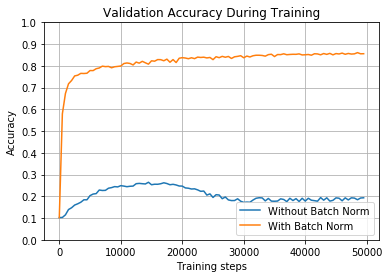

In [39]:
train_and_test(use_larger_weights=True,learning_rate=0.01,activation_fn=tf.nn.sigmoid)

**从4.1,4.2,4.5,4.6可以看出，BN使得模型对权重的初始化不敏感**

## 4.7 较大的Weights初始化，较大的学习率，relu激活函数 

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 18/50000 [00:00<04:39, 178.69it/s]

  0%|▏                                                                                            | 84/50000 [00:00<03:57, 210.26it/s]

  0%|▎                                                                                           | 158/50000 [00:00<03:06, 267.55it/s]

  0%|▍                                                                                           | 235/50000 [00:00<02:29, 332.36it/s]

  1%|▌                                                                                           | 318/50000 [00:00<02:02, 404.82it/s]

  1%|▋                                                                                           | 401/50000 [00:00<01:43, 477.73it/s]

  1%|▉                                                                                           | 484/50000 [00:00<01:30, 546.64it/s]

  1%|█                                                                                           | 555/50000 [00:00<01:24, 586.11it/s]

  1%|█▏                                                                                          | 628/50000 [00:00<01:19, 621.78it/s]

  1%|█▎                                                                                          | 705/50000 [00:01<01:14, 658.65it/s]

  2%|█▍                                                                                          | 787/50000 [00:01<01:10, 698.67it/s]

  2%|█▌                                                                                          | 863/50000 [00:01<01:09, 704.61it/s]

  2%|█▋                                                                                          | 946/50000 [00:01<01:06, 734.68it/s]

  2%|█▊                                                                                         | 1023/50000 [00:01<01:27, 558.00it/s]

  2%|██                                                                                         | 1103/50000 [00:01<01:19, 612.66it/s]

  2%|██▏                                                                                        | 1187/50000 [00:01<01:13, 665.65it/s]

  3%|██▎                                                                                        | 1268/50000 [00:01<01:09, 701.91it/s]

  3%|██▍                                                                                        | 1350/50000 [00:02<01:06, 732.16it/s]

  3%|██▌                                                                                        | 1428/50000 [00:02<01:05, 740.10it/s]

  3%|██▋                                                                                        | 1505/50000 [00:02<01:10, 687.36it/s]

  3%|██▉                                                                                        | 1583/50000 [00:02<01:08, 711.33it/s]

  3%|███                                                                                        | 1657/50000 [00:02<01:07, 711.96it/s]

  3%|███▏                                                                                       | 1730/50000 [00:02<01:16, 630.64it/s]

  4%|███▎                                                                                       | 1796/50000 [00:02<01:24, 567.28it/s]

  4%|███▍                                                                                       | 1856/50000 [00:02<01:33, 516.25it/s]

  4%|███▍                                                                                       | 1911/50000 [00:03<01:35, 503.28it/s]

  4%|███▌                                                                                       | 1964/50000 [00:03<01:57, 408.74it/s]

  4%|███▋                                                                                       | 2023/50000 [00:03<01:46, 449.48it/s]

  4%|███▊                                                                                       | 2087/50000 [00:03<01:37, 492.73it/s]

  4%|███▉                                                                                       | 2148/50000 [00:03<01:31, 521.90it/s]

  4%|████                                                                                       | 2206/50000 [00:03<01:29, 535.50it/s]

  5%|████▏                                                                                      | 2269/50000 [00:03<01:25, 559.64it/s]

  5%|████▏                                                                                      | 2331/50000 [00:03<01:23, 573.71it/s]

  5%|████▎                                                                                      | 2390/50000 [00:03<01:22, 577.26it/s]

  5%|████▍                                                                                      | 2452/50000 [00:03<01:21, 586.56it/s]

  5%|████▌                                                                                      | 2512/50000 [00:04<01:20, 589.26it/s]

  5%|████▋                                                                                      | 2572/50000 [00:04<01:22, 575.88it/s]

  5%|████▊                                                                                      | 2632/50000 [00:04<01:21, 581.67it/s]

  5%|████▉                                                                                      | 2699/50000 [00:04<01:18, 604.43it/s]

  6%|█████                                                                                      | 2760/50000 [00:04<01:20, 585.66it/s]

  6%|█████▏                                                                                     | 2829/50000 [00:04<01:17, 610.68it/s]

  6%|█████▎                                                                                     | 2891/50000 [00:04<01:41, 464.07it/s]

  6%|█████▍                                                                                     | 2967/50000 [00:04<01:29, 524.65it/s]

  6%|█████▌                                                                                     | 3027/50000 [00:05<01:27, 539.72it/s]

  6%|█████▋                                                                                     | 3097/50000 [00:05<01:21, 577.05it/s]

  6%|█████▊                                                                                     | 3165/50000 [00:05<01:17, 603.32it/s]

  6%|█████▉                                                                                     | 3230/50000 [00:05<01:16, 613.60it/s]

  7%|██████                                                                                     | 3311/50000 [00:05<01:10, 658.94it/s]

  7%|██████▏                                                                                    | 3383/50000 [00:05<01:09, 674.76it/s]

  7%|██████▎                                                                                    | 3464/50000 [00:05<01:05, 707.12it/s]

  7%|██████▍                                                                                    | 3537/50000 [00:05<01:05, 708.17it/s]

  7%|██████▌                                                                                    | 3616/50000 [00:05<01:03, 729.40it/s]

  7%|██████▋                                                                                    | 3697/50000 [00:05<01:01, 748.25it/s]

  8%|██████▊                                                                                    | 3773/50000 [00:06<01:20, 571.28it/s]

  8%|██████▉                                                                                    | 3840/50000 [00:06<01:17, 596.53it/s]

  8%|███████                                                                                    | 3912/50000 [00:06<01:13, 627.69it/s]

  8%|███████▎                                                                                   | 3992/50000 [00:06<01:08, 669.82it/s]

  8%|███████▍                                                                                   | 4068/50000 [00:06<01:06, 691.27it/s]

  8%|███████▌                                                                                   | 4150/50000 [00:06<01:03, 724.03it/s]

  8%|███████▋                                                                                   | 4230/50000 [00:06<01:01, 741.68it/s]

  9%|███████▊                                                                                   | 4310/50000 [00:06<01:00, 756.69it/s]

  9%|███████▉                                                                                   | 4387/50000 [00:06<01:00, 754.54it/s]

  9%|████████                                                                                   | 4464/50000 [00:07<01:01, 737.93it/s]

  9%|████████▎                                                                                  | 4539/50000 [00:07<01:04, 704.55it/s]

  9%|████████▍                                                                                  | 4612/50000 [00:07<01:03, 710.48it/s]

  9%|████████▌                                                                                  | 4684/50000 [00:07<01:22, 549.29it/s]

 10%|████████▋                                                                                  | 4759/50000 [00:07<01:15, 596.20it/s]

 10%|████████▊                                                                                  | 4841/50000 [00:07<01:09, 648.25it/s]

 10%|████████▉                                                                                  | 4925/50000 [00:07<01:04, 694.64it/s]

 10%|█████████                                                                                  | 5003/50000 [00:07<01:02, 716.77it/s]

 10%|█████████▏                                                                                 | 5080/50000 [00:07<01:01, 730.43it/s]

 10%|█████████▍                                                                                 | 5156/50000 [00:08<01:05, 680.21it/s]

 10%|█████████▌                                                                                 | 5230/50000 [00:08<01:04, 695.67it/s]

 11%|█████████▋                                                                                 | 5302/50000 [00:08<01:04, 693.22it/s]

 11%|█████████▊                                                                                 | 5373/50000 [00:08<01:05, 678.73it/s]

 11%|█████████▉                                                                                 | 5442/50000 [00:08<01:06, 668.76it/s]

 11%|██████████                                                                                 | 5510/50000 [00:08<01:12, 614.43it/s]

 11%|██████████▏                                                                                | 5573/50000 [00:08<01:14, 600.09it/s]

 11%|██████████▎                                                                                | 5635/50000 [00:09<01:37, 452.72it/s]

 11%|██████████▎                                                                                | 5690/50000 [00:09<01:32, 477.18it/s]

 12%|██████████▍                                                                                | 5753/50000 [00:09<01:26, 512.46it/s]

 12%|██████████▌                                                                                | 5816/50000 [00:09<01:21, 541.82it/s]

 12%|██████████▋                                                                                | 5886/50000 [00:09<01:16, 578.73it/s]

 12%|██████████▊                                                                                | 5953/50000 [00:09<01:13, 602.20it/s]

 12%|██████████▉                                                                                | 6023/50000 [00:09<01:10, 627.31it/s]

 12%|███████████                                                                                | 6094/50000 [00:09<01:07, 646.95it/s]

 12%|███████████▏                                                                               | 6161/50000 [00:09<01:07, 652.31it/s]

 12%|███████████▎                                                                               | 6233/50000 [00:09<01:05, 668.01it/s]

 13%|███████████▍                                                                               | 6316/50000 [00:10<01:01, 708.23it/s]

 13%|███████████▋                                                                               | 6395/50000 [00:10<00:59, 729.45it/s]

 13%|███████████▊                                                                               | 6469/50000 [00:10<01:00, 724.57it/s]

 13%|███████████▉                                                                               | 6543/50000 [00:10<01:20, 537.74it/s]

 13%|████████████                                                                               | 6619/50000 [00:10<01:13, 588.45it/s]

 13%|████████████▏                                                                              | 6699/50000 [00:10<01:07, 638.04it/s]

 14%|████████████▎                                                                              | 6780/50000 [00:10<01:03, 680.19it/s]

 14%|████████████▍                                                                              | 6860/50000 [00:10<01:00, 710.80it/s]

 14%|████████████▋                                                                              | 6940/50000 [00:10<00:58, 733.92it/s]

 14%|████████████▊                                                                              | 7017/50000 [00:11<00:59, 717.94it/s]

 14%|████████████▉                                                                              | 7091/50000 [00:11<01:00, 710.41it/s]

 14%|█████████████                                                                              | 7168/50000 [00:11<00:59, 723.75it/s]

 14%|█████████████▏                                                                             | 7242/50000 [00:11<00:58, 726.98it/s]

 15%|█████████████▎                                                                             | 7321/50000 [00:11<00:57, 743.27it/s]

 15%|█████████████▍                                                                             | 7398/50000 [00:11<00:56, 749.49it/s]

 15%|█████████████▌                                                                             | 7474/50000 [00:11<01:15, 561.68it/s]

 15%|█████████████▋                                                                             | 7551/50000 [00:11<01:09, 610.23it/s]

 15%|█████████████▉                                                                             | 7635/50000 [00:11<01:03, 662.07it/s]

 15%|██████████████                                                                             | 7717/50000 [00:12<01:00, 701.35it/s]

 16%|██████████████▏                                                                            | 7798/50000 [00:12<00:58, 727.35it/s]

 16%|██████████████▎                                                                            | 7875/50000 [00:12<00:58, 721.53it/s]

 16%|██████████████▍                                                                            | 7950/50000 [00:12<00:58, 722.00it/s]

 16%|██████████████▌                                                                            | 8024/50000 [00:12<00:58, 717.33it/s]

 16%|██████████████▋                                                                            | 8097/50000 [00:12<00:59, 700.92it/s]

 16%|██████████████▊                                                                            | 8169/50000 [00:12<01:02, 664.16it/s]

 16%|██████████████▉                                                                            | 8237/50000 [00:12<01:05, 633.89it/s]

 17%|███████████████                                                                            | 8310/50000 [00:12<01:03, 656.88it/s]

 17%|███████████████▏                                                                           | 8377/50000 [00:13<01:23, 498.03it/s]

 17%|███████████████▍                                                                           | 8454/50000 [00:13<01:14, 556.18it/s]

 17%|███████████████▌                                                                           | 8517/50000 [00:13<01:12, 575.29it/s]

 17%|███████████████▋                                                                           | 8594/50000 [00:13<01:06, 619.91it/s]

 17%|███████████████▊                                                                           | 8661/50000 [00:13<01:07, 615.43it/s]

 17%|███████████████▉                                                                           | 8726/50000 [00:13<01:08, 604.98it/s]

 18%|███████████████▉                                                                           | 8789/50000 [00:13<01:09, 590.41it/s]

 18%|████████████████                                                                           | 8850/50000 [00:13<01:09, 594.88it/s]

 18%|████████████████▏                                                                          | 8913/50000 [00:14<01:08, 602.00it/s]

 18%|████████████████▎                                                                          | 8975/50000 [00:14<01:09, 593.83it/s]

 18%|████████████████▍                                                                          | 9035/50000 [00:14<01:10, 582.30it/s]

 18%|████████████████▌                                                                          | 9094/50000 [00:14<01:11, 569.84it/s]

 18%|████████████████▋                                                                          | 9161/50000 [00:14<01:08, 595.43it/s]

 18%|████████████████▊                                                                          | 9225/50000 [00:14<01:07, 605.15it/s]

 19%|████████████████▉                                                                          | 9286/50000 [00:14<01:30, 452.23it/s]

 19%|████████████████▉                                                                          | 9338/50000 [00:14<01:29, 454.94it/s]

 19%|█████████████████▏                                                                         | 9410/50000 [00:14<01:19, 510.63it/s]

 19%|█████████████████▎                                                                         | 9479/50000 [00:15<01:13, 551.53it/s]

 19%|█████████████████▎                                                                         | 9542/50000 [00:15<01:10, 571.80it/s]

 19%|█████████████████▌                                                                         | 9619/50000 [00:15<01:05, 618.56it/s]

 19%|█████████████████▋                                                                         | 9692/50000 [00:15<01:02, 646.99it/s]

 20%|█████████████████▊                                                                         | 9767/50000 [00:15<00:59, 673.46it/s]

 20%|█████████████████▉                                                                         | 9837/50000 [00:15<01:00, 668.11it/s]

 20%|██████████████████                                                                         | 9916/50000 [00:15<00:57, 697.33it/s]

 20%|██████████████████▏                                                                        | 9991/50000 [00:15<00:56, 710.86it/s]

 20%|██████████████████                                                                        | 10069/50000 [00:15<00:54, 728.78it/s]

 20%|██████████████████▎                                                                       | 10153/50000 [00:15<00:52, 757.43it/s]

 20%|██████████████████▍                                                                       | 10230/50000 [00:16<01:10, 560.88it/s]

 21%|██████████████████▌                                                                       | 10297/50000 [00:16<01:07, 587.01it/s]

 21%|██████████████████▋                                                                       | 10369/50000 [00:16<01:03, 620.28it/s]

 21%|██████████████████▊                                                                       | 10448/50000 [00:16<00:59, 661.79it/s]

 21%|██████████████████▉                                                                       | 10524/50000 [00:16<00:57, 687.12it/s]

 21%|███████████████████                                                                       | 10602/50000 [00:16<00:55, 709.21it/s]

 21%|███████████████████▏                                                                      | 10676/50000 [00:16<00:59, 659.34it/s]

 21%|███████████████████▎                                                                      | 10745/50000 [00:16<00:59, 659.21it/s]

 22%|███████████████████▍                                                                      | 10819/50000 [00:17<00:57, 678.29it/s]

 22%|███████████████████▌                                                                      | 10889/50000 [00:17<00:57, 681.21it/s]

 22%|███████████████████▋                                                                      | 10959/50000 [00:17<01:01, 635.05it/s]

 22%|███████████████████▊                                                                      | 11024/50000 [00:17<01:02, 621.65it/s]

 22%|███████████████████▉                                                                      | 11088/50000 [00:17<01:18, 493.02it/s]

 22%|████████████████████                                                                      | 11146/50000 [00:17<01:15, 513.87it/s]

 22%|████████████████████▏                                                                     | 11205/50000 [00:17<01:12, 533.51it/s]

 23%|████████████████████▎                                                                     | 11263/50000 [00:17<01:11, 545.53it/s]

 23%|████████████████████▍                                                                     | 11341/50000 [00:17<01:04, 597.22it/s]

 23%|████████████████████▌                                                                     | 11417/50000 [00:18<01:00, 637.06it/s]

 23%|████████████████████▋                                                                     | 11494/50000 [00:18<00:57, 670.58it/s]

 23%|████████████████████▊                                                                     | 11564/50000 [00:18<00:58, 654.91it/s]

 23%|████████████████████▉                                                                     | 11632/50000 [00:18<01:00, 635.00it/s]

 23%|█████████████████████                                                                     | 11698/50000 [00:18<00:59, 640.93it/s]

 24%|█████████████████████▏                                                                    | 11764/50000 [00:18<01:00, 634.03it/s]

 24%|█████████████████████▎                                                                    | 11829/50000 [00:18<01:01, 624.53it/s]

 24%|█████████████████████▍                                                                    | 11892/50000 [00:18<01:05, 580.05it/s]

 24%|█████████████████████▌                                                                    | 11951/50000 [00:18<01:07, 566.70it/s]

 24%|█████████████████████▌                                                                    | 12009/50000 [00:19<01:31, 415.58it/s]

 24%|█████████████████████▋                                                                    | 12064/50000 [00:19<01:24, 446.58it/s]

 24%|█████████████████████▊                                                                    | 12116/50000 [00:19<01:21, 464.18it/s]

 24%|█████████████████████▉                                                                    | 12171/50000 [00:19<01:17, 486.03it/s]

 24%|██████████████████████                                                                    | 12227/50000 [00:19<01:14, 503.73it/s]

 25%|██████████████████████                                                                    | 12290/50000 [00:19<01:10, 533.60it/s]

 25%|██████████████████████▏                                                                   | 12353/50000 [00:19<01:07, 558.19it/s]

 25%|██████████████████████▎                                                                   | 12424/50000 [00:19<01:03, 595.35it/s]

 25%|██████████████████████▍                                                                   | 12496/50000 [00:19<00:59, 626.77it/s]

 25%|██████████████████████▌                                                                   | 12565/50000 [00:20<00:58, 643.17it/s]

 25%|██████████████████████▊                                                                   | 12639/50000 [00:20<00:55, 668.12it/s]

 25%|██████████████████████▉                                                                   | 12711/50000 [00:20<00:54, 679.54it/s]

 26%|███████████████████████                                                                   | 12780/50000 [00:20<00:54, 681.17it/s]

 26%|███████████████████████▏                                                                  | 12849/50000 [00:20<00:56, 658.92it/s]

 26%|███████████████████████▎                                                                  | 12917/50000 [00:20<01:09, 531.70it/s]

 26%|███████████████████████▍                                                                  | 12995/50000 [00:20<01:03, 586.87it/s]

 26%|███████████████████████▌                                                                  | 13074/50000 [00:20<00:58, 634.81it/s]

 26%|███████████████████████▋                                                                  | 13151/50000 [00:20<00:55, 668.83it/s]

 26%|███████████████████████▊                                                                  | 13233/50000 [00:21<00:52, 706.65it/s]

 27%|███████████████████████▉                                                                  | 13309/50000 [00:21<00:50, 720.35it/s]

 27%|████████████████████████                                                                  | 13385/50000 [00:21<00:50, 730.26it/s]

 27%|████████████████████████▏                                                                 | 13460/50000 [00:21<00:50, 717.67it/s]

 27%|████████████████████████▎                                                                 | 13533/50000 [00:21<00:54, 674.03it/s]

 27%|████████████████████████▌                                                                 | 13616/50000 [00:21<00:51, 712.96it/s]

 27%|████████████████████████▋                                                                 | 13697/50000 [00:21<00:49, 738.06it/s]

 28%|████████████████████████▊                                                                 | 13782/50000 [00:21<00:47, 766.90it/s]

 28%|████████████████████████▉                                                                 | 13860/50000 [00:22<01:02, 581.97it/s]

 28%|█████████████████████████                                                                 | 13933/50000 [00:22<00:58, 616.95it/s]

 28%|█████████████████████████▏                                                                | 14008/50000 [00:22<00:55, 648.71it/s]

 28%|█████████████████████████▎                                                                | 14087/50000 [00:22<00:52, 682.42it/s]

 28%|█████████████████████████▍                                                                | 14159/50000 [00:22<00:53, 672.48it/s]

 28%|█████████████████████████▋                                                                | 14240/50000 [00:22<00:50, 707.22it/s]

 29%|█████████████████████████▊                                                                | 14324/50000 [00:22<00:48, 740.98it/s]

 29%|█████████████████████████▉                                                                | 14405/50000 [00:22<00:46, 758.87it/s]

 29%|██████████████████████████                                                                | 14483/50000 [00:22<00:46, 759.00it/s]

 29%|██████████████████████████▏                                                               | 14560/50000 [00:22<00:46, 758.37it/s]

 29%|██████████████████████████▎                                                               | 14640/50000 [00:23<00:45, 768.76it/s]

 29%|██████████████████████████▍                                                               | 14718/50000 [00:23<00:46, 763.67it/s]

 30%|██████████████████████████▋                                                               | 14795/50000 [00:23<01:00, 582.38it/s]

 30%|██████████████████████████▊                                                               | 14864/50000 [00:23<00:57, 608.18it/s]

 30%|██████████████████████████▊                                                               | 14930/50000 [00:23<00:58, 597.98it/s]

 30%|██████████████████████████▉                                                               | 14994/50000 [00:23<00:57, 608.72it/s]

 30%|███████████████████████████                                                               | 15058/50000 [00:23<00:59, 589.30it/s]

 30%|███████████████████████████▏                                                              | 15119/50000 [00:23<00:59, 585.56it/s]

 30%|███████████████████████████▎                                                              | 15179/50000 [00:24<00:59, 583.41it/s]

 30%|███████████████████████████▍                                                              | 15239/50000 [00:24<01:00, 576.90it/s]

 31%|███████████████████████████▌                                                              | 15298/50000 [00:24<00:59, 579.52it/s]

 31%|███████████████████████████▋                                                              | 15357/50000 [00:24<01:00, 571.21it/s]

 31%|███████████████████████████▋                                                              | 15415/50000 [00:24<01:01, 565.94it/s]

 31%|███████████████████████████▊                                                              | 15481/50000 [00:24<00:58, 588.46it/s]

 31%|███████████████████████████▉                                                              | 15541/50000 [00:24<00:58, 588.89it/s]

 31%|████████████████████████████                                                              | 15605/50000 [00:24<00:57, 600.41it/s]

 31%|████████████████████████████▏                                                             | 15667/50000 [00:24<01:11, 483.49it/s]

 31%|████████████████████████████▎                                                             | 15736/50000 [00:25<01:04, 530.29it/s]

 32%|████████████████████████████▍                                                             | 15813/50000 [00:25<00:58, 582.62it/s]

 32%|████████████████████████████▌                                                             | 15886/50000 [00:25<00:55, 619.03it/s]

 32%|████████████████████████████▋                                                             | 15958/50000 [00:25<00:52, 644.95it/s]

 32%|████████████████████████████▊                                                             | 16026/50000 [00:25<00:52, 646.26it/s]

 32%|████████████████████████████▉                                                             | 16104/50000 [00:25<00:49, 678.24it/s]

 32%|█████████████████████████████▏                                                            | 16186/50000 [00:25<00:47, 713.97it/s]

 33%|█████████████████████████████▎                                                            | 16267/50000 [00:25<00:45, 738.82it/s]

 33%|█████████████████████████████▍                                                            | 16349/50000 [00:25<00:44, 759.89it/s]

 33%|█████████████████████████████▌                                                            | 16435/50000 [00:25<00:42, 785.81it/s]

 33%|█████████████████████████████▋                                                            | 16515/50000 [00:26<00:43, 776.86it/s]

 33%|█████████████████████████████▊                                                            | 16594/50000 [00:26<00:55, 598.84it/s]

 33%|█████████████████████████████▉                                                            | 16662/50000 [00:26<00:53, 619.84it/s]

 33%|██████████████████████████████                                                            | 16729/50000 [00:26<00:52, 629.19it/s]

 34%|██████████████████████████████▎                                                           | 16811/50000 [00:26<00:49, 675.21it/s]

 34%|██████████████████████████████▍                                                           | 16894/50000 [00:26<00:46, 712.04it/s]

 34%|██████████████████████████████▌                                                           | 16975/50000 [00:26<00:44, 737.38it/s]

 34%|██████████████████████████████▋                                                           | 17051/50000 [00:26<00:44, 733.85it/s]

 34%|██████████████████████████████▊                                                           | 17134/50000 [00:26<00:43, 758.75it/s]

 34%|██████████████████████████████▉                                                           | 17219/50000 [00:27<00:41, 782.42it/s]

 35%|███████████████████████████████▏                                                          | 17299/50000 [00:27<00:41, 781.32it/s]

 35%|███████████████████████████████▎                                                          | 17380/50000 [00:27<00:41, 788.03it/s]

 35%|███████████████████████████████▍                                                          | 17460/50000 [00:27<00:41, 778.37it/s]

 35%|███████████████████████████████▌                                                          | 17539/50000 [00:27<00:57, 567.27it/s]

 35%|███████████████████████████████▋                                                          | 17623/50000 [00:27<00:51, 627.46it/s]

 35%|███████████████████████████████▊                                                          | 17705/50000 [00:27<00:47, 673.79it/s]

 36%|████████████████████████████████                                                          | 17786/50000 [00:27<00:45, 708.23it/s]

 36%|████████████████████████████████▏                                                         | 17867/50000 [00:28<00:43, 734.51it/s]

 36%|████████████████████████████████▎                                                         | 17946/50000 [00:28<00:42, 746.64it/s]

 36%|████████████████████████████████▍                                                         | 18024/50000 [00:28<00:43, 729.40it/s]

 36%|████████████████████████████████▌                                                         | 18108/50000 [00:28<00:42, 757.90it/s]

 36%|████████████████████████████████▋                                                         | 18189/50000 [00:28<00:41, 768.99it/s]

 37%|████████████████████████████████▉                                                         | 18268/50000 [00:28<00:46, 683.43it/s]

 37%|█████████████████████████████████                                                         | 18339/50000 [00:28<00:48, 648.26it/s]

 37%|█████████████████████████████████▏                                                        | 18407/50000 [00:28<00:51, 616.89it/s]

 37%|█████████████████████████████████▏                                                        | 18471/50000 [00:29<01:08, 462.28it/s]

 37%|█████████████████████████████████▎                                                        | 18525/50000 [00:29<01:06, 474.58it/s]

 37%|█████████████████████████████████▍                                                        | 18588/50000 [00:29<01:01, 511.60it/s]

 37%|█████████████████████████████████▌                                                        | 18646/50000 [00:29<00:59, 529.31it/s]

 37%|█████████████████████████████████▋                                                        | 18709/50000 [00:29<00:56, 554.89it/s]

 38%|█████████████████████████████████▊                                                        | 18773/50000 [00:29<00:54, 576.81it/s]

 38%|█████████████████████████████████▉                                                        | 18836/50000 [00:29<00:52, 590.58it/s]

 38%|██████████████████████████████████                                                        | 18899/50000 [00:29<00:51, 600.62it/s]

 38%|██████████████████████████████████▏                                                       | 18974/50000 [00:29<00:48, 637.60it/s]

 38%|██████████████████████████████████▎                                                       | 19054/50000 [00:29<00:45, 674.27it/s]

 38%|██████████████████████████████████▍                                                       | 19129/50000 [00:30<00:44, 693.92it/s]

 38%|██████████████████████████████████▌                                                       | 19209/50000 [00:30<00:42, 721.25it/s]

 39%|██████████████████████████████████▋                                                       | 19293/50000 [00:30<00:40, 751.71it/s]

 39%|██████████████████████████████████▊                                                       | 19370/50000 [00:30<00:54, 558.68it/s]

 39%|███████████████████████████████████                                                       | 19447/50000 [00:30<00:50, 607.75it/s]

 39%|███████████████████████████████████▏                                                      | 19524/50000 [00:30<00:47, 647.56it/s]

 39%|███████████████████████████████████▎                                                      | 19605/50000 [00:30<00:44, 687.73it/s]

 39%|███████████████████████████████████▍                                                      | 19689/50000 [00:30<00:41, 725.91it/s]

 40%|███████████████████████████████████▌                                                      | 19770/50000 [00:30<00:40, 747.73it/s]

 40%|███████████████████████████████████▋                                                      | 19848/50000 [00:31<00:40, 749.00it/s]

 40%|███████████████████████████████████▊                                                      | 19929/50000 [00:31<00:39, 764.73it/s]

 40%|████████████████████████████████████                                                      | 20007/50000 [00:31<00:40, 741.40it/s]

 40%|████████████████████████████████████▏                                                     | 20083/50000 [00:31<00:40, 734.50it/s]

 40%|████████████████████████████████████▎                                                     | 20158/50000 [00:31<00:42, 700.40it/s]

 40%|████████████████████████████████████▍                                                     | 20241/50000 [00:31<00:40, 733.39it/s]

 41%|████████████████████████████████████▌                                                     | 20316/50000 [00:31<00:52, 564.25it/s]

 41%|████████████████████████████████████▋                                                     | 20400/50000 [00:31<00:47, 624.86it/s]

 41%|████████████████████████████████████▊                                                     | 20482/50000 [00:32<00:43, 671.70it/s]

 41%|█████████████████████████████████████                                                     | 20556/50000 [00:32<00:42, 689.41it/s]

 41%|█████████████████████████████████████▏                                                    | 20636/50000 [00:32<00:40, 717.83it/s]

 41%|█████████████████████████████████████▎                                                    | 20719/50000 [00:32<00:39, 746.69it/s]

 42%|█████████████████████████████████████▍                                                    | 20797/50000 [00:32<00:38, 750.43it/s]

 42%|█████████████████████████████████████▌                                                    | 20874/50000 [00:32<00:41, 704.96it/s]

 42%|█████████████████████████████████████▋                                                    | 20949/50000 [00:32<00:40, 716.39it/s]

 42%|█████████████████████████████████████▊                                                    | 21024/50000 [00:32<00:39, 724.62it/s]

 42%|█████████████████████████████████████▉                                                    | 21110/50000 [00:32<00:38, 759.06it/s]

 42%|██████████████████████████████████████▏                                                   | 21187/50000 [00:33<00:49, 581.81it/s]

 43%|██████████████████████████████████████▎                                                   | 21261/50000 [00:33<00:46, 620.54it/s]

 43%|██████████████████████████████████████▍                                                   | 21344/50000 [00:33<00:42, 670.18it/s]

 43%|██████████████████████████████████████▌                                                   | 21420/50000 [00:33<00:41, 693.43it/s]

 43%|██████████████████████████████████████▋                                                   | 21494/50000 [00:33<00:40, 697.33it/s]

 43%|██████████████████████████████████████▊                                                   | 21567/50000 [00:33<00:44, 637.18it/s]

 43%|██████████████████████████████████████▉                                                   | 21634/50000 [00:33<00:45, 625.49it/s]

 43%|███████████████████████████████████████                                                   | 21699/50000 [00:33<00:45, 627.65it/s]

 44%|███████████████████████████████████████▏                                                  | 21764/50000 [00:33<00:44, 629.16it/s]

 44%|███████████████████████████████████████▎                                                  | 21828/50000 [00:34<00:45, 625.44it/s]

 44%|███████████████████████████████████████▍                                                  | 21892/50000 [00:34<00:45, 622.94it/s]

 44%|███████████████████████████████████████▌                                                  | 21955/50000 [00:34<00:45, 614.58it/s]

 44%|███████████████████████████████████████▋                                                  | 22017/50000 [00:34<00:46, 600.60it/s]

 44%|███████████████████████████████████████▋                                                  | 22082/50000 [00:34<00:45, 613.34it/s]

 44%|███████████████████████████████████████▊                                                  | 22144/50000 [00:34<01:00, 461.00it/s]

 44%|███████████████████████████████████████▉                                                  | 22205/50000 [00:34<00:56, 495.36it/s]

 45%|████████████████████████████████████████                                                  | 22260/50000 [00:34<00:55, 503.95it/s]

 45%|████████████████████████████████████████▏                                                 | 22319/50000 [00:34<00:52, 524.58it/s]

 45%|████████████████████████████████████████▎                                                 | 22382/50000 [00:35<00:50, 551.25it/s]

 45%|████████████████████████████████████████▍                                                 | 22443/50000 [00:35<00:48, 566.50it/s]

 45%|████████████████████████████████████████▌                                                 | 22509/50000 [00:35<00:46, 588.91it/s]

 45%|████████████████████████████████████████▋                                                 | 22573/50000 [00:35<00:45, 602.11it/s]

 45%|████████████████████████████████████████▋                                                 | 22635/50000 [00:35<00:46, 590.52it/s]

 45%|████████████████████████████████████████▊                                                 | 22699/50000 [00:35<00:45, 603.29it/s]

 46%|████████████████████████████████████████▉                                                 | 22760/50000 [00:35<00:45, 602.19it/s]

 46%|█████████████████████████████████████████                                                 | 22822/50000 [00:35<00:44, 604.36it/s]

 46%|█████████████████████████████████████████▏                                                | 22885/50000 [00:35<00:44, 610.51it/s]

 46%|█████████████████████████████████████████▎                                                | 22948/50000 [00:35<00:43, 614.93it/s]

 46%|█████████████████████████████████████████▍                                                | 23010/50000 [00:36<00:58, 462.66it/s]

 46%|█████████████████████████████████████████▌                                                | 23073/50000 [00:36<00:53, 501.84it/s]

 46%|█████████████████████████████████████████▋                                                | 23134/50000 [00:36<00:50, 527.66it/s]

 46%|█████████████████████████████████████████▋                                                | 23191/50000 [00:36<00:50, 534.04it/s]

 47%|█████████████████████████████████████████▉                                                | 23272/50000 [00:36<00:45, 592.58it/s]

 47%|██████████████████████████████████████████                                                | 23352/50000 [00:36<00:41, 641.43it/s]

 47%|██████████████████████████████████████████▏                                               | 23433/50000 [00:36<00:38, 682.88it/s]

 47%|██████████████████████████████████████████▎                                               | 23509/50000 [00:36<00:37, 700.95it/s]

 47%|██████████████████████████████████████████▍                                               | 23594/50000 [00:37<00:35, 738.47it/s]

 47%|██████████████████████████████████████████▌                                               | 23678/50000 [00:37<00:34, 762.65it/s]

 48%|██████████████████████████████████████████▊                                               | 23757/50000 [00:37<00:34, 762.35it/s]

 48%|██████████████████████████████████████████▉                                               | 23835/50000 [00:37<00:34, 748.32it/s]

 48%|███████████████████████████████████████████                                               | 23917/50000 [00:37<00:43, 596.61it/s]

 48%|███████████████████████████████████████████▏                                              | 23987/50000 [00:37<00:41, 623.06it/s]

 48%|███████████████████████████████████████████▎                                              | 24061/50000 [00:37<00:39, 651.08it/s]

 48%|███████████████████████████████████████████▍                                              | 24144/50000 [00:37<00:37, 694.82it/s]

 48%|███████████████████████████████████████████▌                                              | 24225/50000 [00:37<00:35, 724.36it/s]

 49%|███████████████████████████████████████████▊                                              | 24308/50000 [00:38<00:34, 751.62it/s]

 49%|███████████████████████████████████████████▉                                              | 24391/50000 [00:38<00:33, 771.96it/s]

 49%|████████████████████████████████████████████                                              | 24470/50000 [00:38<00:32, 775.61it/s]

 49%|████████████████████████████████████████████▏                                             | 24549/50000 [00:38<00:32, 773.63it/s]

 49%|████████████████████████████████████████████▎                                             | 24631/50000 [00:38<00:32, 785.33it/s]

 49%|████████████████████████████████████████████▍                                             | 24711/50000 [00:38<00:35, 722.01it/s]

 50%|████████████████████████████████████████████▌                                             | 24785/50000 [00:38<00:38, 663.45it/s]

 50%|████████████████████████████████████████████▋                                             | 24854/50000 [00:38<00:51, 489.30it/s]

 50%|████████████████████████████████████████████▊                                             | 24915/50000 [00:39<00:48, 519.21it/s]

 50%|████████████████████████████████████████████▉                                             | 24973/50000 [00:39<00:47, 530.59it/s]

 50%|█████████████████████████████████████████████                                             | 25031/50000 [00:39<00:48, 517.28it/s]

 50%|█████████████████████████████████████████████▏                                            | 25086/50000 [00:39<00:48, 510.97it/s]

 50%|█████████████████████████████████████████████▎                                            | 25143/50000 [00:39<00:47, 526.29it/s]

 50%|█████████████████████████████████████████████▎                                            | 25200/50000 [00:39<00:46, 536.05it/s]

 51%|█████████████████████████████████████████████▍                                            | 25269/50000 [00:39<00:43, 573.46it/s]

 51%|█████████████████████████████████████████████▌                                            | 25338/50000 [00:39<00:40, 602.91it/s]

 51%|█████████████████████████████████████████████▊                                            | 25419/50000 [00:39<00:37, 651.85it/s]

 51%|█████████████████████████████████████████████▉                                            | 25501/50000 [00:39<00:35, 691.54it/s]

 51%|██████████████████████████████████████████████                                            | 25584/50000 [00:40<00:33, 726.57it/s]

 51%|██████████████████████████████████████████████▏                                           | 25662/50000 [00:40<00:32, 738.18it/s]

 51%|██████████████████████████████████████████████▎                                           | 25742/50000 [00:40<00:32, 754.14it/s]

 52%|██████████████████████████████████████████████▍                                           | 25819/50000 [00:40<00:42, 570.78it/s]

 52%|██████████████████████████████████████████████▌                                           | 25891/50000 [00:40<00:39, 607.50it/s]

 52%|██████████████████████████████████████████████▋                                           | 25970/50000 [00:40<00:36, 651.56it/s]

 52%|██████████████████████████████████████████████▉                                           | 26045/50000 [00:40<00:35, 676.92it/s]

 52%|███████████████████████████████████████████████                                           | 26127/50000 [00:40<00:33, 712.95it/s]

 52%|███████████████████████████████████████████████▏                                          | 26206/50000 [00:40<00:32, 732.95it/s]

 53%|███████████████████████████████████████████████▎                                          | 26289/50000 [00:41<00:31, 756.01it/s]

 53%|███████████████████████████████████████████████▍                                          | 26367/50000 [00:41<00:31, 759.20it/s]

 53%|███████████████████████████████████████████████▌                                          | 26452/50000 [00:41<00:30, 782.75it/s]

 53%|███████████████████████████████████████████████▊                                          | 26532/50000 [00:41<00:30, 772.52it/s]

 53%|███████████████████████████████████████████████▉                                          | 26611/50000 [00:41<00:30, 766.99it/s]

 53%|████████████████████████████████████████████████                                          | 26689/50000 [00:41<00:40, 569.30it/s]

 54%|████████████████████████████████████████████████▏                                         | 26766/50000 [00:41<00:37, 616.51it/s]

 54%|████████████████████████████████████████████████▎                                         | 26844/50000 [00:41<00:35, 656.66it/s]

 54%|████████████████████████████████████████████████▍                                         | 26925/50000 [00:42<00:33, 694.89it/s]

 54%|████████████████████████████████████████████████▌                                         | 27001/50000 [00:42<00:32, 705.82it/s]

 54%|████████████████████████████████████████████████▋                                         | 27075/50000 [00:42<00:32, 714.23it/s]

 54%|████████████████████████████████████████████████▉                                         | 27158/50000 [00:42<00:30, 741.97it/s]

 54%|█████████████████████████████████████████████████                                         | 27241/50000 [00:42<00:29, 764.80it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27319/50000 [00:42<00:31, 720.94it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27402/50000 [00:42<00:30, 749.04it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27480/50000 [00:42<00:29, 754.27it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27559/50000 [00:42<00:29, 760.83it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27636/50000 [00:43<00:38, 576.02it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27707/50000 [00:43<00:36, 609.44it/s]

 56%|██████████████████████████████████████████████████                                        | 27785/50000 [00:43<00:34, 651.03it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27864/50000 [00:43<00:32, 684.22it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27937/50000 [00:43<00:32, 680.35it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28008/50000 [00:43<00:35, 619.34it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28073/50000 [00:43<00:35, 612.76it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28137/50000 [00:43<00:35, 610.53it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28204/50000 [00:43<00:34, 625.95it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28268/50000 [00:44<00:35, 614.29it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28331/50000 [00:44<00:35, 608.67it/s]

 57%|███████████████████████████████████████████████████                                       | 28396/50000 [00:44<00:34, 617.43it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28459/50000 [00:44<00:35, 612.62it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28521/50000 [00:44<00:47, 456.65it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28584/50000 [00:44<00:43, 496.88it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28649/50000 [00:44<00:40, 533.70it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28732/50000 [00:44<00:35, 595.49it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28813/50000 [00:44<00:32, 645.76it/s]

 58%|████████████████████████████████████████████████████                                      | 28896/50000 [00:45<00:30, 688.85it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28975/50000 [00:45<00:29, 714.95it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29050/50000 [00:45<00:28, 723.58it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29128/50000 [00:45<00:28, 738.10it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29205/50000 [00:45<00:27, 743.65it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29281/50000 [00:45<00:28, 721.41it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29364/50000 [00:45<00:27, 749.39it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29440/50000 [00:45<00:36, 564.13it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29517/50000 [00:46<00:33, 612.26it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29601/50000 [00:46<00:30, 663.74it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29683/50000 [00:46<00:28, 700.86it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29767/50000 [00:46<00:27, 736.10it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29845/50000 [00:46<00:27, 745.03it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29923/50000 [00:46<00:26, 747.11it/s]

 60%|██████████████████████████████████████████████████████                                    | 30000/50000 [00:46<00:27, 735.03it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30075/50000 [00:46<00:27, 735.70it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30160/50000 [00:46<00:25, 765.11it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30244/50000 [00:46<00:25, 784.53it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30324/50000 [00:47<00:24, 787.41it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30404/50000 [00:47<00:33, 591.94it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30486/50000 [00:47<00:30, 644.71it/s]

 61%|███████████████████████████████████████████████████████                                   | 30562/50000 [00:47<00:28, 674.14it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30635/50000 [00:47<00:28, 671.50it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30706/50000 [00:47<00:28, 681.17it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30783/50000 [00:47<00:27, 704.17it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30863/50000 [00:47<00:26, 728.96it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30946/50000 [00:47<00:25, 755.08it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31023/50000 [00:48<00:25, 757.86it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31106/50000 [00:48<00:24, 776.55it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31185/50000 [00:48<00:24, 774.29it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31263/50000 [00:48<00:31, 595.63it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31330/50000 [00:48<00:32, 576.89it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31393/50000 [00:48<00:32, 580.86it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31455/50000 [00:48<00:32, 569.72it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31515/50000 [00:48<00:32, 569.07it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31577/50000 [00:49<00:31, 580.61it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31637/50000 [00:49<00:31, 578.30it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31696/50000 [00:49<00:31, 578.80it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31755/50000 [00:49<00:31, 572.43it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31814/50000 [00:49<00:31, 576.35it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31872/50000 [00:49<00:31, 574.48it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31933/50000 [00:49<00:31, 581.80it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32001/50000 [00:49<00:29, 600.54it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32072/50000 [00:49<00:28, 628.44it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32150/50000 [00:49<00:26, 666.10it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32218/50000 [00:50<00:34, 517.89it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32298/50000 [00:50<00:30, 578.24it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32381/50000 [00:50<00:27, 633.61it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32464/50000 [00:50<00:25, 680.80it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32538/50000 [00:50<00:25, 686.44it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32611/50000 [00:50<00:25, 695.50it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32687/50000 [00:50<00:24, 712.21it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32761/50000 [00:50<00:26, 648.99it/s]

 66%|███████████████████████████████████████████████████████████                               | 32829/50000 [00:50<00:27, 629.32it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32894/50000 [00:51<00:27, 612.59it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32957/50000 [00:51<00:28, 604.01it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33019/50000 [00:51<00:28, 586.77it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33079/50000 [00:51<00:28, 584.26it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33138/50000 [00:51<00:38, 436.02it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33190/50000 [00:51<00:36, 457.33it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33243/50000 [00:51<00:35, 474.74it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33296/50000 [00:51<00:34, 489.08it/s]

 67%|████████████████████████████████████████████████████████████                              | 33351/50000 [00:52<00:33, 503.49it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33408/50000 [00:52<00:31, 519.29it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33468/50000 [00:52<00:30, 538.61it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33525/50000 [00:52<00:30, 544.92it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33581/50000 [00:52<00:30, 537.19it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33636/50000 [00:52<00:30, 532.00it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33711/50000 [00:52<00:28, 580.48it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33796/50000 [00:52<00:25, 640.44it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33864/50000 [00:52<00:24, 648.60it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33945/50000 [00:52<00:23, 688.55it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34017/50000 [00:53<00:30, 531.63it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34095/50000 [00:53<00:27, 586.81it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34181/50000 [00:53<00:24, 647.56it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34262/50000 [00:53<00:22, 687.73it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34337/50000 [00:53<00:24, 631.18it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34405/50000 [00:53<00:25, 605.98it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34470/50000 [00:53<00:25, 603.54it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34533/50000 [00:53<00:25, 601.23it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34595/50000 [00:54<00:26, 588.26it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34656/50000 [00:54<00:26, 584.84it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34716/50000 [00:54<00:26, 584.61it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34776/50000 [00:54<00:26, 579.39it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34835/50000 [00:54<00:27, 561.41it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34893/50000 [00:54<00:26, 565.65it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34950/50000 [00:54<00:34, 438.20it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35015/50000 [00:54<00:30, 484.88it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35097/50000 [00:55<00:27, 551.82it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35179/50000 [00:55<00:24, 610.84it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35253/50000 [00:55<00:22, 643.38it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35337/50000 [00:55<00:21, 690.72it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35418/50000 [00:55<00:20, 721.24it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35494/50000 [00:55<00:20, 722.58it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35569/50000 [00:55<00:20, 698.56it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35645/50000 [00:55<00:20, 714.45it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35724/50000 [00:55<00:19, 734.06it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35804/50000 [00:55<00:18, 751.12it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35880/50000 [00:56<00:24, 568.61it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35964/50000 [00:56<00:22, 627.20it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36042/50000 [00:56<00:20, 665.12it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36127/50000 [00:56<00:19, 708.47it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36207/50000 [00:56<00:18, 732.18it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36284/50000 [00:56<00:19, 720.79it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36359/50000 [00:56<00:19, 717.35it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36442/50000 [00:56<00:18, 746.33it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36519/50000 [00:56<00:18, 732.41it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36603/50000 [00:57<00:17, 760.17it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36685/50000 [00:57<00:17, 775.57it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36764/50000 [00:57<00:22, 595.60it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36841/50000 [00:57<00:20, 637.86it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36923/50000 [00:57<00:19, 682.16it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36998/50000 [00:57<00:18, 699.75it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37072/50000 [00:57<00:18, 691.99it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37152/50000 [00:57<00:17, 719.76it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37228/50000 [00:57<00:17, 727.76it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37308/50000 [00:58<00:17, 746.50it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37392/50000 [00:58<00:16, 768.62it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37470/50000 [00:58<00:16, 768.06it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37548/50000 [00:58<00:16, 765.41it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37626/50000 [00:58<00:16, 750.38it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37702/50000 [00:58<00:23, 531.45it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37765/50000 [00:58<00:22, 555.07it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37828/50000 [00:58<00:21, 565.21it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37890/50000 [00:59<00:21, 565.19it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37950/50000 [00:59<00:21, 554.94it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38008/50000 [00:59<00:21, 548.34it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38074/50000 [00:59<00:20, 576.55it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38136/50000 [00:59<00:20, 587.71it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38198/50000 [00:59<00:19, 595.78it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38259/50000 [00:59<00:19, 590.02it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38322/50000 [00:59<00:19, 600.22it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38405/50000 [00:59<00:17, 651.92it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38484/50000 [00:59<00:16, 686.68it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38563/50000 [01:00<00:16, 713.31it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38636/50000 [01:00<00:20, 559.04it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38717/50000 [01:00<00:18, 613.91it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38788/50000 [01:00<00:17, 638.63it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38874/50000 [01:00<00:16, 690.85it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38948/50000 [01:00<00:15, 697.48it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39022/50000 [01:00<00:15, 708.22it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39098/50000 [01:00<00:15, 721.50it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39172/50000 [01:01<00:15, 716.98it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39255/50000 [01:01<00:14, 746.04it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39335/50000 [01:01<00:14, 759.86it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39419/50000 [01:01<00:13, 780.66it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39501/50000 [01:01<00:17, 605.34it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39574/50000 [01:01<00:16, 636.80it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39649/50000 [01:01<00:15, 665.71it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39727/50000 [01:01<00:14, 694.93it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39803/50000 [01:01<00:14, 711.82it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39879/50000 [01:02<00:14, 722.04it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39962/50000 [01:02<00:13, 747.85it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40039/50000 [01:02<00:13, 748.37it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40121/50000 [01:02<00:12, 766.93it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40205/50000 [01:02<00:12, 785.87it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40285/50000 [01:02<00:12, 779.16it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40368/50000 [01:02<00:12, 792.08it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40448/50000 [01:02<00:16, 584.70it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40523/50000 [01:02<00:15, 623.40it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40602/50000 [01:03<00:14, 664.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40684/50000 [01:03<00:13, 703.09it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40763/50000 [01:03<00:12, 725.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40846/50000 [01:03<00:12, 750.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40924/50000 [01:03<00:12, 740.31it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41000/50000 [01:03<00:12, 695.58it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41072/50000 [01:03<00:13, 644.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41139/50000 [01:03<00:13, 636.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41205/50000 [01:03<00:14, 613.13it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41268/50000 [01:04<00:14, 597.51it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41329/50000 [01:04<00:14, 594.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41390/50000 [01:04<00:19, 452.06it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41450/50000 [01:04<00:17, 486.12it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41512/50000 [01:04<00:16, 518.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41574/50000 [01:04<00:15, 543.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41639/50000 [01:04<00:14, 570.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41720/50000 [01:04<00:13, 623.25it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41802/50000 [01:04<00:12, 668.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41883/50000 [01:05<00:11, 704.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41964/50000 [01:05<00:10, 731.56it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42040/50000 [01:05<00:10, 736.16it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42124/50000 [01:05<00:10, 762.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42202/50000 [01:05<00:10, 759.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42279/50000 [01:05<00:13, 579.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42349/50000 [01:05<00:12, 609.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42422/50000 [01:05<00:11, 640.29it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42502/50000 [01:06<00:11, 676.35it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42579/50000 [01:06<00:10, 700.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42658/50000 [01:06<00:10, 723.75it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42736/50000 [01:06<00:09, 738.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42818/50000 [01:06<00:09, 759.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42896/50000 [01:06<00:09, 748.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42977/50000 [01:06<00:09, 764.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43055/50000 [01:06<00:09, 743.27it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43130/50000 [01:06<00:10, 686.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43200/50000 [01:07<00:13, 488.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43258/50000 [01:07<00:13, 500.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43315/50000 [01:07<00:12, 516.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43374/50000 [01:07<00:12, 535.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43431/50000 [01:07<00:12, 538.29it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43490/50000 [01:07<00:11, 551.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43547/50000 [01:07<00:11, 547.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43616/50000 [01:07<00:10, 582.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43682/50000 [01:07<00:10, 602.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43753/50000 [01:08<00:09, 628.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43823/50000 [01:08<00:09, 645.30it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43896/50000 [01:08<00:09, 667.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43969/50000 [01:08<00:08, 683.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44039/50000 [01:08<00:08, 667.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44107/50000 [01:08<00:11, 491.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44165/50000 [01:08<00:11, 514.07it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44231/50000 [01:08<00:10, 549.59it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44292/50000 [01:08<00:10, 565.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44352/50000 [01:09<00:10, 564.36it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44417/50000 [01:09<00:09, 584.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44479/50000 [01:09<00:09, 593.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44541/50000 [01:09<00:09, 600.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44603/50000 [01:09<00:08, 604.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44665/50000 [01:09<00:08, 606.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44730/50000 [01:09<00:08, 615.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44796/50000 [01:09<00:08, 625.18it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44880/50000 [01:09<00:07, 675.93it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44954/50000 [01:09<00:07, 692.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45025/50000 [01:10<00:09, 531.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45107/50000 [01:10<00:08, 592.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45190/50000 [01:10<00:07, 647.35it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45266/50000 [01:10<00:07, 676.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45344/50000 [01:10<00:06, 702.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45421/50000 [01:10<00:06, 720.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45497/50000 [01:10<00:06, 730.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45576/50000 [01:10<00:05, 745.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45653/50000 [01:10<00:05, 751.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45730/50000 [01:11<00:05, 748.51it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45808/50000 [01:11<00:05, 756.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45892/50000 [01:11<00:05, 777.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45971/50000 [01:11<00:06, 583.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46047/50000 [01:11<00:06, 625.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46119/50000 [01:11<00:05, 648.44it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46200/50000 [01:11<00:05, 688.43it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46284/50000 [01:11<00:05, 726.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46360/50000 [01:12<00:04, 728.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46437/50000 [01:12<00:04, 738.79it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46515/50000 [01:12<00:04, 749.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46596/50000 [01:12<00:04, 764.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46678/50000 [01:12<00:04, 778.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46757/50000 [01:12<00:04, 766.93it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46835/50000 [01:12<00:05, 578.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46913/50000 [01:12<00:04, 625.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46996/50000 [01:12<00:04, 674.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47074/50000 [01:13<00:04, 699.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47149/50000 [01:13<00:04, 708.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47231/50000 [01:13<00:03, 737.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47310/50000 [01:13<00:03, 750.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47393/50000 [01:13<00:03, 771.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47472/50000 [01:13<00:03, 697.34it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47545/50000 [01:13<00:03, 637.18it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47612/50000 [01:13<00:03, 623.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47677/50000 [01:13<00:03, 621.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47741/50000 [01:14<00:03, 599.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47802/50000 [01:14<00:05, 439.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47863/50000 [01:14<00:04, 478.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47923/50000 [01:14<00:04, 508.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47987/50000 [01:14<00:03, 540.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48052/50000 [01:14<00:03, 567.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48116/50000 [01:14<00:03, 585.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48197/50000 [01:14<00:02, 637.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48274/50000 [01:14<00:02, 669.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48358/50000 [01:15<00:02, 711.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48432/50000 [01:15<00:02, 714.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48506/50000 [01:15<00:02, 716.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48585/50000 [01:15<00:01, 735.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48661/50000 [01:15<00:01, 740.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48736/50000 [01:15<00:02, 569.92it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48807/50000 [01:15<00:01, 604.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48888/50000 [01:15<00:01, 653.26it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48970/50000 [01:15<00:01, 694.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49044/50000 [01:16<00:01, 684.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49119/50000 [01:16<00:01, 701.49it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49197/50000 [01:16<00:01, 719.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49276/50000 [01:16<00:00, 735.99it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49351/50000 [01:16<00:00, 727.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49430/50000 [01:16<00:00, 741.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49508/50000 [01:16<00:00, 751.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49584/50000 [01:16<00:00, 551.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49658/50000 [01:17<00:00, 595.98it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49737/50000 [01:17<00:00, 642.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49807/50000 [01:17<00:00, 653.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49889/50000 [01:17<00:00, 694.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49962/50000 [01:17<00:00, 691.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:17<00:00, 645.05it/s]

Without Batch Norm:the final accuracy on validation data is 0.0957999974489212

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<4:26:46,  3.12it/s]

  0%|                                                                                            | 29/50000 [00:00<3:07:33,  4.44it/s]

  0%|                                                                                            | 56/50000 [00:00<2:12:10,  6.30it/s]

  0%|▏                                                                                           | 80/50000 [00:00<1:33:31,  8.90it/s]

  0%|▏                                                                                          | 104/50000 [00:00<1:06:30, 12.50it/s]

  0%|▏                                                                                            | 126/50000 [00:00<47:40, 17.44it/s]

  0%|▎                                                                                            | 151/50000 [00:00<34:23, 24.16it/s]

  0%|▎                                                                                            | 176/50000 [00:01<25:04, 33.12it/s]

  0%|▍                                                                                            | 202/50000 [00:01<18:32, 44.75it/s]

  0%|▍                                                                                            | 227/50000 [00:01<13:58, 59.34it/s]

  1%|▍                                                                                            | 254/50000 [00:01<10:44, 77.23it/s]

  1%|▌                                                                                            | 281/50000 [00:01<08:26, 98.10it/s]

  1%|▌                                                                                           | 309/50000 [00:01<06:49, 121.41it/s]

  1%|▌                                                                                           | 335/50000 [00:01<05:45, 143.63it/s]

  1%|▋                                                                                           | 364/50000 [00:01<04:55, 168.16it/s]

  1%|▋                                                                                           | 391/50000 [00:01<04:22, 188.93it/s]

  1%|▊                                                                                           | 421/50000 [00:01<03:54, 211.32it/s]

  1%|▊                                                                                           | 452/50000 [00:02<03:32, 233.24it/s]

  1%|▉                                                                                           | 481/50000 [00:02<03:21, 246.07it/s]

  1%|▉                                                                                           | 510/50000 [00:02<04:08, 199.14it/s]

  1%|▉                                                                                           | 540/50000 [00:02<03:45, 219.67it/s]

  1%|█                                                                                           | 568/50000 [00:02<03:31, 233.83it/s]

  1%|█                                                                                           | 598/50000 [00:02<03:18, 249.32it/s]

  1%|█▏                                                                                          | 629/50000 [00:02<03:08, 262.37it/s]

  1%|█▏                                                                                          | 657/50000 [00:02<03:08, 262.37it/s]

  1%|█▎                                                                                          | 687/50000 [00:02<03:02, 270.62it/s]

  1%|█▎                                                                                          | 715/50000 [00:03<03:01, 271.20it/s]

  1%|█▎                                                                                          | 745/50000 [00:03<02:58, 276.37it/s]

  2%|█▍                                                                                          | 774/50000 [00:03<02:56, 278.93it/s]

  2%|█▍                                                                                          | 805/50000 [00:03<02:51, 286.99it/s]

  2%|█▌                                                                                          | 834/50000 [00:03<02:51, 286.41it/s]

  2%|█▌                                                                                          | 865/50000 [00:03<02:47, 292.50it/s]

  2%|█▋                                                                                          | 895/50000 [00:03<02:48, 291.51it/s]

  2%|█▋                                                                                          | 926/50000 [00:03<02:45, 296.20it/s]

  2%|█▊                                                                                          | 956/50000 [00:03<02:47, 292.36it/s]

  2%|█▊                                                                                          | 986/50000 [00:04<02:46, 293.98it/s]

  2%|█▊                                                                                         | 1016/50000 [00:04<02:47, 291.69it/s]

  2%|█▉                                                                                         | 1046/50000 [00:04<02:50, 287.61it/s]

  2%|█▉                                                                                         | 1075/50000 [00:04<02:52, 284.32it/s]

  2%|██                                                                                         | 1105/50000 [00:04<02:49, 288.24it/s]

  2%|██                                                                                         | 1134/50000 [00:04<02:50, 286.43it/s]

  2%|██                                                                                         | 1164/50000 [00:04<02:50, 287.27it/s]

  2%|██▏                                                                                        | 1193/50000 [00:04<02:49, 287.46it/s]

  2%|██▏                                                                                        | 1222/50000 [00:04<02:57, 274.55it/s]

  2%|██▎                                                                                        | 1250/50000 [00:04<03:04, 264.66it/s]

  3%|██▎                                                                                        | 1277/50000 [00:05<03:07, 260.30it/s]

  3%|██▎                                                                                        | 1304/50000 [00:05<03:09, 257.33it/s]

  3%|██▍                                                                                        | 1332/50000 [00:05<03:05, 261.72it/s]

  3%|██▍                                                                                        | 1360/50000 [00:05<03:02, 266.39it/s]

  3%|██▌                                                                                        | 1388/50000 [00:05<03:01, 268.22it/s]

  3%|██▌                                                                                        | 1415/50000 [00:05<03:06, 261.18it/s]

  3%|██▌                                                                                        | 1442/50000 [00:05<04:09, 194.54it/s]

  3%|██▋                                                                                        | 1466/50000 [00:05<03:56, 205.35it/s]

  3%|██▋                                                                                        | 1492/50000 [00:06<03:43, 217.13it/s]

  3%|██▊                                                                                        | 1517/50000 [00:06<03:36, 223.78it/s]

  3%|██▊                                                                                        | 1542/50000 [00:06<03:30, 230.58it/s]

  3%|██▊                                                                                        | 1568/50000 [00:06<03:23, 237.56it/s]

  3%|██▉                                                                                        | 1595/50000 [00:06<03:17, 244.61it/s]

  3%|██▉                                                                                        | 1620/50000 [00:06<03:19, 242.12it/s]

  3%|███                                                                                        | 1649/50000 [00:06<03:10, 254.25it/s]

  3%|███                                                                                        | 1677/50000 [00:06<03:05, 260.20it/s]

  3%|███                                                                                        | 1706/50000 [00:06<03:02, 265.00it/s]

  3%|███▏                                                                                       | 1735/50000 [00:06<02:57, 271.48it/s]

  4%|███▏                                                                                       | 1765/50000 [00:07<02:52, 278.88it/s]

  4%|███▎                                                                                       | 1797/50000 [00:07<02:46, 288.71it/s]

  4%|███▎                                                                                       | 1827/50000 [00:07<02:46, 289.70it/s]

  4%|███▍                                                                                       | 1857/50000 [00:07<02:45, 291.24it/s]

  4%|███▍                                                                                       | 1889/50000 [00:07<02:41, 297.04it/s]

  4%|███▍                                                                                       | 1920/50000 [00:07<02:41, 298.44it/s]

  4%|███▌                                                                                       | 1951/50000 [00:07<02:40, 299.44it/s]

  4%|███▌                                                                                       | 1981/50000 [00:07<02:41, 298.06it/s]

  4%|███▋                                                                                       | 2011/50000 [00:07<02:49, 283.66it/s]

  4%|███▋                                                                                       | 2040/50000 [00:08<02:53, 276.78it/s]

  4%|███▊                                                                                       | 2068/50000 [00:08<02:53, 276.32it/s]

  4%|███▊                                                                                       | 2096/50000 [00:08<02:55, 273.57it/s]

  4%|███▊                                                                                       | 2124/50000 [00:08<02:56, 271.69it/s]

  4%|███▉                                                                                       | 2153/50000 [00:08<02:54, 274.79it/s]

  4%|███▉                                                                                       | 2181/50000 [00:08<02:53, 274.92it/s]

  4%|████                                                                                       | 2211/50000 [00:08<02:50, 280.63it/s]

  4%|████                                                                                       | 2240/50000 [00:08<02:51, 278.71it/s]

  5%|████▏                                                                                      | 2270/50000 [00:08<02:48, 282.58it/s]

  5%|████▏                                                                                      | 2299/50000 [00:08<02:53, 275.28it/s]

  5%|████▏                                                                                      | 2328/50000 [00:09<02:50, 278.94it/s]

  5%|████▎                                                                                      | 2356/50000 [00:09<03:43, 212.76it/s]

  5%|████▎                                                                                      | 2387/50000 [00:09<03:23, 233.42it/s]

  5%|████▍                                                                                      | 2416/50000 [00:09<03:12, 246.84it/s]

  5%|████▍                                                                                      | 2443/50000 [00:09<03:08, 252.13it/s]

  5%|████▌                                                                                      | 2473/50000 [00:09<03:00, 262.91it/s]

  5%|████▌                                                                                      | 2501/50000 [00:09<02:58, 265.74it/s]

  5%|████▌                                                                                      | 2529/50000 [00:09<02:56, 268.52it/s]

  5%|████▋                                                                                      | 2557/50000 [00:09<03:01, 260.70it/s]

  5%|████▋                                                                                      | 2584/50000 [00:10<03:03, 259.09it/s]

  5%|████▊                                                                                      | 2615/50000 [00:10<02:54, 271.28it/s]

  5%|████▊                                                                                      | 2643/50000 [00:10<02:54, 271.67it/s]

  5%|████▊                                                                                      | 2671/50000 [00:10<02:55, 270.37it/s]

  5%|████▉                                                                                      | 2700/50000 [00:10<02:51, 275.40it/s]

  5%|████▉                                                                                      | 2728/50000 [00:10<03:00, 261.50it/s]

  6%|█████                                                                                      | 2755/50000 [00:10<03:06, 253.80it/s]

  6%|█████                                                                                      | 2781/50000 [00:10<03:05, 254.33it/s]

  6%|█████                                                                                      | 2807/50000 [00:10<03:06, 252.48it/s]

  6%|█████▏                                                                                     | 2833/50000 [00:11<03:05, 254.15it/s]

  6%|█████▏                                                                                     | 2860/50000 [00:11<03:02, 258.16it/s]

  6%|█████▎                                                                                     | 2887/50000 [00:11<03:01, 259.55it/s]

  6%|█████▎                                                                                     | 2914/50000 [00:11<03:00, 261.28it/s]

  6%|█████▎                                                                                     | 2941/50000 [00:11<03:01, 259.47it/s]

  6%|█████▍                                                                                     | 2967/50000 [00:11<03:03, 256.03it/s]

  6%|█████▍                                                                                     | 2993/50000 [00:11<03:03, 255.89it/s]

  6%|█████▍                                                                                     | 3020/50000 [00:11<03:02, 257.94it/s]

  6%|█████▌                                                                                     | 3046/50000 [00:11<03:02, 257.23it/s]

  6%|█████▌                                                                                     | 3076/50000 [00:11<02:55, 267.48it/s]

  6%|█████▋                                                                                     | 3107/50000 [00:12<02:48, 277.66it/s]

  6%|█████▋                                                                                     | 3138/50000 [00:12<02:44, 284.48it/s]

  6%|█████▊                                                                                     | 3169/50000 [00:12<02:40, 291.08it/s]

  6%|█████▊                                                                                     | 3199/50000 [00:12<02:40, 291.37it/s]

  6%|█████▉                                                                                     | 3229/50000 [00:12<02:40, 290.73it/s]

  7%|█████▉                                                                                     | 3259/50000 [00:12<03:34, 217.77it/s]

  7%|█████▉                                                                                     | 3290/50000 [00:12<03:16, 237.62it/s]

  7%|██████                                                                                     | 3318/50000 [00:12<03:08, 247.12it/s]

  7%|██████                                                                                     | 3345/50000 [00:12<03:05, 250.94it/s]

  7%|██████▏                                                                                    | 3374/50000 [00:13<02:59, 260.29it/s]

  7%|██████▏                                                                                    | 3405/50000 [00:13<02:51, 271.49it/s]

  7%|██████▎                                                                                    | 3436/50000 [00:13<02:46, 279.91it/s]

  7%|██████▎                                                                                    | 3467/50000 [00:13<02:42, 286.13it/s]

  7%|██████▎                                                                                    | 3497/50000 [00:13<02:44, 283.00it/s]

  7%|██████▍                                                                                    | 3526/50000 [00:13<02:47, 277.93it/s]

  7%|██████▍                                                                                    | 3557/50000 [00:13<02:42, 285.46it/s]

  7%|██████▌                                                                                    | 3586/50000 [00:13<02:44, 282.02it/s]

  7%|██████▌                                                                                    | 3616/50000 [00:13<02:42, 284.96it/s]

  7%|██████▋                                                                                    | 3645/50000 [00:14<02:46, 278.44it/s]

  7%|██████▋                                                                                    | 3675/50000 [00:14<02:43, 283.99it/s]

  7%|██████▋                                                                                    | 3704/50000 [00:14<02:42, 285.15it/s]

  7%|██████▊                                                                                    | 3733/50000 [00:14<02:44, 281.81it/s]

  8%|██████▊                                                                                    | 3762/50000 [00:14<02:44, 280.33it/s]

  8%|██████▉                                                                                    | 3791/50000 [00:14<02:43, 282.56it/s]

  8%|██████▉                                                                                    | 3822/50000 [00:14<02:39, 288.86it/s]

  8%|███████                                                                                    | 3853/50000 [00:14<02:37, 292.62it/s]

  8%|███████                                                                                    | 3883/50000 [00:14<02:36, 294.16it/s]

  8%|███████                                                                                    | 3913/50000 [00:14<02:41, 285.99it/s]

  8%|███████▏                                                                                   | 3942/50000 [00:15<02:41, 285.71it/s]

  8%|███████▏                                                                                   | 3973/50000 [00:15<02:38, 290.35it/s]

  8%|███████▎                                                                                   | 4003/50000 [00:15<02:41, 285.07it/s]

  8%|███████▎                                                                                   | 4034/50000 [00:15<02:38, 289.88it/s]

  8%|███████▍                                                                                   | 4064/50000 [00:15<02:39, 287.20it/s]

  8%|███████▍                                                                                   | 4093/50000 [00:15<02:44, 279.13it/s]

  8%|███████▌                                                                                   | 4121/50000 [00:15<02:51, 267.62it/s]

  8%|███████▌                                                                                   | 4148/50000 [00:15<02:55, 261.53it/s]

  8%|███████▌                                                                                   | 4175/50000 [00:16<03:57, 193.02it/s]

  8%|███████▋                                                                                   | 4199/50000 [00:16<03:43, 204.68it/s]

  8%|███████▋                                                                                   | 4223/50000 [00:16<03:34, 213.71it/s]

  8%|███████▋                                                                                   | 4246/50000 [00:16<03:32, 214.85it/s]

  9%|███████▊                                                                                   | 4271/50000 [00:16<03:25, 222.09it/s]

  9%|███████▊                                                                                   | 4297/50000 [00:16<03:18, 230.56it/s]

  9%|███████▊                                                                                   | 4321/50000 [00:16<03:16, 232.82it/s]

  9%|███████▉                                                                                   | 4345/50000 [00:16<03:17, 231.05it/s]

  9%|███████▉                                                                                   | 4373/50000 [00:16<03:07, 242.74it/s]

  9%|████████                                                                                   | 4402/50000 [00:16<02:59, 253.40it/s]

  9%|████████                                                                                   | 4433/50000 [00:17<02:51, 266.20it/s]

  9%|████████                                                                                   | 4462/50000 [00:17<02:47, 271.59it/s]

  9%|████████▏                                                                                  | 4491/50000 [00:17<02:44, 276.29it/s]

  9%|████████▏                                                                                  | 4519/50000 [00:17<02:45, 275.16it/s]

  9%|████████▎                                                                                  | 4548/50000 [00:17<02:43, 278.06it/s]

  9%|████████▎                                                                                  | 4577/50000 [00:17<02:41, 280.94it/s]

  9%|████████▍                                                                                  | 4606/50000 [00:17<02:42, 278.92it/s]

  9%|████████▍                                                                                  | 4634/50000 [00:17<02:43, 277.81it/s]

  9%|████████▍                                                                                  | 4665/50000 [00:17<02:38, 285.37it/s]

  9%|████████▌                                                                                  | 4694/50000 [00:17<02:40, 282.79it/s]

  9%|████████▌                                                                                  | 4724/50000 [00:18<02:38, 286.32it/s]

 10%|████████▋                                                                                  | 4755/50000 [00:18<02:35, 291.60it/s]

 10%|████████▋                                                                                  | 4786/50000 [00:18<02:33, 294.58it/s]

 10%|████████▊                                                                                  | 4816/50000 [00:18<02:36, 289.57it/s]

 10%|████████▊                                                                                  | 4846/50000 [00:18<02:37, 286.98it/s]

 10%|████████▉                                                                                  | 4877/50000 [00:18<02:34, 291.27it/s]

 10%|████████▉                                                                                  | 4907/50000 [00:18<02:34, 292.35it/s]

 10%|████████▉                                                                                  | 4937/50000 [00:18<02:33, 293.11it/s]

 10%|█████████                                                                                  | 4967/50000 [00:18<02:34, 291.09it/s]

 10%|█████████                                                                                  | 4997/50000 [00:19<02:38, 284.75it/s]

 10%|█████████▏                                                                                 | 5026/50000 [00:19<02:38, 283.19it/s]

 10%|█████████▏                                                                                 | 5056/50000 [00:19<02:36, 287.42it/s]

 10%|█████████▎                                                                                 | 5085/50000 [00:19<03:22, 221.26it/s]

 10%|█████████▎                                                                                 | 5110/50000 [00:19<03:22, 222.01it/s]

 10%|█████████▎                                                                                 | 5140/50000 [00:19<03:07, 239.23it/s]

 10%|█████████▍                                                                                 | 5171/50000 [00:19<02:55, 255.72it/s]

 10%|█████████▍                                                                                 | 5200/50000 [00:19<02:50, 263.16it/s]

 10%|█████████▌                                                                                 | 5230/50000 [00:19<02:44, 272.68it/s]

 11%|█████████▌                                                                                 | 5259/50000 [00:20<02:43, 273.94it/s]

 11%|█████████▌                                                                                 | 5288/50000 [00:20<02:42, 275.61it/s]

 11%|█████████▋                                                                                 | 5319/50000 [00:20<02:37, 282.97it/s]

 11%|█████████▋                                                                                 | 5349/50000 [00:20<02:35, 287.27it/s]

 11%|█████████▊                                                                                 | 5378/50000 [00:20<02:40, 278.38it/s]

 11%|█████████▊                                                                                 | 5407/50000 [00:20<02:45, 269.44it/s]

 11%|█████████▉                                                                                 | 5435/50000 [00:20<02:48, 265.01it/s]

 11%|█████████▉                                                                                 | 5462/50000 [00:20<02:51, 259.04it/s]

 11%|█████████▉                                                                                 | 5489/50000 [00:20<02:57, 250.08it/s]

 11%|██████████                                                                                 | 5515/50000 [00:21<03:05, 239.23it/s]

 11%|██████████                                                                                 | 5540/50000 [00:21<03:10, 233.08it/s]

 11%|██████████▏                                                                                | 5567/50000 [00:21<03:04, 240.63it/s]

 11%|██████████▏                                                                                | 5593/50000 [00:21<03:01, 244.93it/s]

 11%|██████████▏                                                                                | 5620/50000 [00:21<02:57, 249.35it/s]

 11%|██████████▎                                                                                | 5646/50000 [00:21<02:59, 246.90it/s]

 11%|██████████▎                                                                                | 5671/50000 [00:21<03:04, 240.18it/s]

 11%|██████████▎                                                                                | 5696/50000 [00:21<03:07, 235.69it/s]

 11%|██████████▍                                                                                | 5720/50000 [00:21<03:08, 235.07it/s]

 11%|██████████▍                                                                                | 5744/50000 [00:22<03:07, 236.02it/s]

 12%|██████████▌                                                                                | 5772/50000 [00:22<02:59, 245.91it/s]

 12%|██████████▌                                                                                | 5801/50000 [00:22<02:52, 256.48it/s]

 12%|██████████▌                                                                                | 5830/50000 [00:22<02:47, 263.72it/s]

 12%|██████████▋                                                                                | 5859/50000 [00:22<02:44, 269.03it/s]

 12%|██████████▋                                                                                | 5887/50000 [00:22<02:43, 270.08it/s]

 12%|██████████▊                                                                                | 5915/50000 [00:22<02:42, 271.61it/s]

 12%|██████████▊                                                                                | 5947/50000 [00:22<02:35, 283.21it/s]

 12%|██████████▉                                                                                | 5977/50000 [00:22<02:34, 284.99it/s]

 12%|██████████▉                                                                                | 6006/50000 [00:23<03:24, 215.36it/s]

 12%|██████████▉                                                                                | 6034/50000 [00:23<03:10, 230.96it/s]

 12%|███████████                                                                                | 6062/50000 [00:23<03:01, 242.05it/s]

 12%|███████████                                                                                | 6093/50000 [00:23<02:50, 257.33it/s]

 12%|███████████▏                                                                               | 6123/50000 [00:23<02:43, 268.27it/s]

 12%|███████████▏                                                                               | 6151/50000 [00:23<02:46, 263.48it/s]

 12%|███████████▏                                                                               | 6179/50000 [00:23<02:43, 267.66it/s]

 12%|███████████▎                                                                               | 6207/50000 [00:23<02:45, 264.55it/s]

 12%|███████████▎                                                                               | 6237/50000 [00:23<02:40, 272.98it/s]

 13%|███████████▍                                                                               | 6267/50000 [00:23<02:37, 278.43it/s]

 13%|███████████▍                                                                               | 6296/50000 [00:24<02:40, 272.51it/s]

 13%|███████████▌                                                                               | 6325/50000 [00:24<02:38, 275.38it/s]

 13%|███████████▌                                                                               | 6353/50000 [00:24<02:38, 274.53it/s]

 13%|███████████▌                                                                               | 6382/50000 [00:24<02:37, 277.61it/s]

 13%|███████████▋                                                                               | 6410/50000 [00:24<02:37, 276.90it/s]

 13%|███████████▋                                                                               | 6438/50000 [00:24<02:38, 274.77it/s]

 13%|███████████▊                                                                               | 6469/50000 [00:24<02:34, 282.35it/s]

 13%|███████████▊                                                                               | 6500/50000 [00:24<02:30, 289.52it/s]

 13%|███████████▉                                                                               | 6530/50000 [00:24<02:32, 284.51it/s]

 13%|███████████▉                                                                               | 6559/50000 [00:25<02:33, 283.02it/s]

 13%|███████████▉                                                                               | 6588/50000 [00:25<02:35, 278.74it/s]

 13%|████████████                                                                               | 6617/50000 [00:25<02:34, 281.42it/s]

 13%|████████████                                                                               | 6646/50000 [00:25<02:33, 283.33it/s]

 13%|████████████▏                                                                              | 6676/50000 [00:25<02:31, 286.71it/s]

 13%|████████████▏                                                                              | 6705/50000 [00:25<02:35, 278.01it/s]

 13%|████████████▎                                                                              | 6733/50000 [00:25<02:44, 262.41it/s]

 14%|████████████▎                                                                              | 6760/50000 [00:25<02:48, 257.30it/s]

 14%|████████████▎                                                                              | 6786/50000 [00:25<02:48, 256.02it/s]

 14%|████████████▍                                                                              | 6813/50000 [00:25<02:47, 258.03it/s]

 14%|████████████▍                                                                              | 6840/50000 [00:26<02:47, 257.97it/s]

 14%|████████████▌                                                                              | 6869/50000 [00:26<02:43, 263.38it/s]

 14%|████████████▌                                                                              | 6897/50000 [00:26<02:42, 265.32it/s]

 14%|████████████▌                                                                              | 6924/50000 [00:26<03:34, 200.94it/s]

 14%|████████████▋                                                                              | 6948/50000 [00:26<03:24, 210.85it/s]

 14%|████████████▋                                                                              | 6975/50000 [00:26<03:11, 224.71it/s]

 14%|████████████▋                                                                              | 7001/50000 [00:26<03:06, 230.68it/s]

 14%|████████████▊                                                                              | 7029/50000 [00:26<02:57, 241.83it/s]

 14%|████████████▊                                                                              | 7059/50000 [00:27<02:47, 256.29it/s]

 14%|████████████▉                                                                              | 7088/50000 [00:27<02:41, 265.02it/s]

 14%|████████████▉                                                                              | 7118/50000 [00:27<02:36, 274.07it/s]

 14%|█████████████                                                                              | 7148/50000 [00:27<02:33, 280.01it/s]

 14%|█████████████                                                                              | 7177/50000 [00:27<02:31, 282.33it/s]

 14%|█████████████                                                                              | 7207/50000 [00:27<02:29, 285.99it/s]

 14%|█████████████▏                                                                             | 7237/50000 [00:27<02:28, 287.78it/s]

 15%|█████████████▏                                                                             | 7267/50000 [00:27<02:27, 289.04it/s]

 15%|█████████████▎                                                                             | 7297/50000 [00:27<02:26, 290.78it/s]

 15%|█████████████▎                                                                             | 7328/50000 [00:27<02:25, 293.99it/s]

 15%|█████████████▍                                                                             | 7358/50000 [00:28<02:26, 291.70it/s]

 15%|█████████████▍                                                                             | 7388/50000 [00:28<02:28, 286.79it/s]

 15%|█████████████▌                                                                             | 7418/50000 [00:28<02:27, 288.35it/s]

 15%|█████████████▌                                                                             | 7450/50000 [00:28<02:24, 294.12it/s]

 15%|█████████████▌                                                                             | 7480/50000 [00:28<02:25, 292.63it/s]

 15%|█████████████▋                                                                             | 7510/50000 [00:28<02:33, 277.10it/s]

 15%|█████████████▋                                                                             | 7538/50000 [00:28<02:33, 277.36it/s]

 15%|█████████████▊                                                                             | 7568/50000 [00:28<02:29, 283.20it/s]

 15%|█████████████▊                                                                             | 7597/50000 [00:28<02:29, 283.76it/s]

 15%|█████████████▉                                                                             | 7626/50000 [00:28<02:29, 283.32it/s]

 15%|█████████████▉                                                                             | 7656/50000 [00:29<02:28, 285.07it/s]

 15%|█████████████▉                                                                             | 7685/50000 [00:29<02:32, 276.93it/s]

 15%|██████████████                                                                             | 7714/50000 [00:29<02:31, 279.32it/s]

 15%|██████████████                                                                             | 7742/50000 [00:29<02:31, 278.91it/s]

 16%|██████████████▏                                                                            | 7772/50000 [00:29<02:28, 284.33it/s]

 16%|██████████████▏                                                                            | 7801/50000 [00:29<02:28, 284.55it/s]

 16%|██████████████▎                                                                            | 7830/50000 [00:29<02:27, 285.55it/s]

 16%|██████████████▎                                                                            | 7859/50000 [00:29<03:13, 218.00it/s]

 16%|██████████████▎                                                                            | 7889/50000 [00:30<02:58, 236.50it/s]

 16%|██████████████▍                                                                            | 7918/50000 [00:30<02:49, 248.61it/s]

 16%|██████████████▍                                                                            | 7946/50000 [00:30<02:44, 255.34it/s]

 16%|██████████████▌                                                                            | 7976/50000 [00:30<02:37, 266.76it/s]

 16%|██████████████▌                                                                            | 8004/50000 [00:30<02:35, 269.25it/s]

 16%|██████████████▌                                                                            | 8032/50000 [00:30<02:37, 266.39it/s]

 16%|██████████████▋                                                                            | 8060/50000 [00:30<02:46, 252.31it/s]

 16%|██████████████▋                                                                            | 8086/50000 [00:30<02:48, 248.93it/s]

 16%|██████████████▊                                                                            | 8112/50000 [00:30<02:46, 250.89it/s]

 16%|██████████████▊                                                                            | 8139/50000 [00:30<02:43, 255.80it/s]

 16%|██████████████▊                                                                            | 8165/50000 [00:31<02:43, 256.49it/s]

 16%|██████████████▉                                                                            | 8191/50000 [00:31<02:42, 256.97it/s]

 16%|██████████████▉                                                                            | 8219/50000 [00:31<02:38, 262.93it/s]

 16%|███████████████                                                                            | 8248/50000 [00:31<02:35, 268.46it/s]

 17%|███████████████                                                                            | 8276/50000 [00:31<02:33, 271.24it/s]

 17%|███████████████                                                                            | 8304/50000 [00:31<02:32, 273.23it/s]

 17%|███████████████▏                                                                           | 8332/50000 [00:31<02:31, 274.63it/s]

 17%|███████████████▏                                                                           | 8361/50000 [00:31<02:29, 277.68it/s]

 17%|███████████████▎                                                                           | 8389/50000 [00:31<02:29, 277.77it/s]

 17%|███████████████▎                                                                           | 8421/50000 [00:31<02:25, 286.33it/s]

 17%|███████████████▍                                                                           | 8451/50000 [00:32<02:23, 289.68it/s]

 17%|███████████████▍                                                                           | 8481/50000 [00:32<02:28, 279.85it/s]

 17%|███████████████▍                                                                           | 8510/50000 [00:32<02:31, 274.23it/s]

 17%|███████████████▌                                                                           | 8541/50000 [00:32<02:26, 282.72it/s]

 17%|███████████████▌                                                                           | 8572/50000 [00:32<02:24, 286.59it/s]

 17%|███████████████▋                                                                           | 8601/50000 [00:32<02:25, 283.62it/s]

 17%|███████████████▋                                                                           | 8631/50000 [00:32<02:24, 286.91it/s]

 17%|███████████████▊                                                                           | 8661/50000 [00:32<02:22, 289.26it/s]

 17%|███████████████▊                                                                           | 8691/50000 [00:32<02:21, 290.93it/s]

 17%|███████████████▊                                                                           | 8722/50000 [00:33<02:20, 293.27it/s]

 18%|███████████████▉                                                                           | 8752/50000 [00:33<03:06, 220.70it/s]

 18%|███████████████▉                                                                           | 8781/50000 [00:33<02:54, 236.73it/s]

 18%|████████████████                                                                           | 8812/50000 [00:33<02:42, 253.10it/s]

 18%|████████████████                                                                           | 8840/50000 [00:33<02:42, 253.73it/s]

 18%|████████████████▏                                                                          | 8870/50000 [00:33<02:36, 263.43it/s]

 18%|████████████████▏                                                                          | 8898/50000 [00:33<02:34, 266.11it/s]

 18%|████████████████▏                                                                          | 8926/50000 [00:33<02:32, 269.56it/s]

 18%|████████████████▎                                                                          | 8955/50000 [00:33<02:29, 274.81it/s]

 18%|████████████████▎                                                                          | 8986/50000 [00:34<02:25, 282.38it/s]

 18%|████████████████▍                                                                          | 9015/50000 [00:34<02:28, 275.93it/s]

 18%|████████████████▍                                                                          | 9045/50000 [00:34<02:25, 280.57it/s]

 18%|████████████████▌                                                                          | 9075/50000 [00:34<02:23, 285.53it/s]

 18%|████████████████▌                                                                          | 9104/50000 [00:34<02:23, 284.56it/s]

 18%|████████████████▌                                                                          | 9134/50000 [00:34<02:23, 285.13it/s]

 18%|████████████████▋                                                                          | 9163/50000 [00:34<02:24, 281.80it/s]

 18%|████████████████▋                                                                          | 9192/50000 [00:34<02:25, 281.13it/s]

 18%|████████████████▊                                                                          | 9223/50000 [00:34<02:21, 288.62it/s]

 19%|████████████████▊                                                                          | 9252/50000 [00:34<02:23, 283.35it/s]

 19%|████████████████▉                                                                          | 9282/50000 [00:35<02:21, 287.54it/s]

 19%|████████████████▉                                                                          | 9311/50000 [00:35<02:24, 281.79it/s]

 19%|█████████████████                                                                          | 9341/50000 [00:35<02:22, 285.60it/s]

 19%|█████████████████                                                                          | 9372/50000 [00:35<02:19, 291.08it/s]

 19%|█████████████████                                                                          | 9402/50000 [00:35<02:21, 286.38it/s]

 19%|█████████████████▏                                                                         | 9431/50000 [00:35<02:27, 274.64it/s]

 19%|█████████████████▏                                                                         | 9459/50000 [00:35<02:37, 257.43it/s]

 19%|█████████████████▎                                                                         | 9486/50000 [00:35<02:39, 254.65it/s]

 19%|█████████████████▎                                                                         | 9512/50000 [00:35<02:42, 249.08it/s]

 19%|█████████████████▎                                                                         | 9538/50000 [00:36<02:43, 248.13it/s]

 19%|█████████████████▍                                                                         | 9564/50000 [00:36<02:42, 249.60it/s]

 19%|█████████████████▍                                                                         | 9593/50000 [00:36<02:36, 257.90it/s]

 19%|█████████████████▌                                                                         | 9622/50000 [00:36<02:32, 265.49it/s]

 19%|█████████████████▌                                                                         | 9652/50000 [00:36<02:28, 272.20it/s]

 19%|█████████████████▌                                                                         | 9680/50000 [00:36<03:13, 208.58it/s]

 19%|█████████████████▋                                                                         | 9705/50000 [00:36<03:03, 219.07it/s]

 19%|█████████████████▋                                                                         | 9729/50000 [00:36<03:02, 220.79it/s]

 20%|█████████████████▊                                                                         | 9757/50000 [00:37<02:51, 234.72it/s]

 20%|█████████████████▊                                                                         | 9785/50000 [00:37<02:43, 245.56it/s]

 20%|█████████████████▊                                                                         | 9812/50000 [00:37<02:40, 250.50it/s]

 20%|█████████████████▉                                                                         | 9840/50000 [00:37<02:35, 258.16it/s]

 20%|█████████████████▉                                                                         | 9868/50000 [00:37<02:32, 263.80it/s]

 20%|██████████████████                                                                         | 9896/50000 [00:37<02:29, 267.89it/s]

 20%|██████████████████                                                                         | 9925/50000 [00:37<02:27, 271.30it/s]

 20%|██████████████████                                                                         | 9954/50000 [00:37<02:25, 274.51it/s]

 20%|██████████████████▏                                                                        | 9982/50000 [00:37<02:25, 275.54it/s]

 20%|██████████████████                                                                        | 10010/50000 [00:37<02:27, 270.67it/s]

 20%|██████████████████                                                                        | 10038/50000 [00:38<02:26, 272.82it/s]

 20%|██████████████████                                                                        | 10066/50000 [00:38<02:25, 274.34it/s]

 20%|██████████████████▏                                                                       | 10094/50000 [00:38<02:24, 275.42it/s]

 20%|██████████████████▏                                                                       | 10122/50000 [00:38<02:27, 269.81it/s]

 20%|██████████████████▎                                                                       | 10150/50000 [00:38<02:31, 263.03it/s]

 20%|██████████████████▎                                                                       | 10180/50000 [00:38<02:26, 271.84it/s]

 20%|██████████████████▎                                                                       | 10208/50000 [00:38<02:30, 265.12it/s]

 20%|██████████████████▍                                                                       | 10237/50000 [00:38<02:26, 270.81it/s]

 21%|██████████████████▍                                                                       | 10266/50000 [00:38<02:24, 274.94it/s]

 21%|██████████████████▌                                                                       | 10296/50000 [00:38<02:21, 281.42it/s]

 21%|██████████████████▌                                                                       | 10328/50000 [00:39<02:16, 289.82it/s]

 21%|██████████████████▋                                                                       | 10358/50000 [00:39<02:20, 282.31it/s]

 21%|██████████████████▋                                                                       | 10388/50000 [00:39<02:19, 284.35it/s]

 21%|██████████████████▊                                                                       | 10419/50000 [00:39<02:16, 290.17it/s]

 21%|██████████████████▊                                                                       | 10449/50000 [00:39<02:15, 292.43it/s]

 21%|██████████████████▊                                                                       | 10479/50000 [00:39<02:15, 290.62it/s]

 21%|██████████████████▉                                                                       | 10509/50000 [00:39<02:17, 286.88it/s]

 21%|██████████████████▉                                                                       | 10538/50000 [00:39<02:18, 284.65it/s]

 21%|███████████████████                                                                       | 10567/50000 [00:39<02:18, 284.78it/s]

 21%|███████████████████                                                                       | 10596/50000 [00:40<03:02, 215.75it/s]

 21%|███████████████████                                                                       | 10622/50000 [00:40<02:54, 225.75it/s]

 21%|███████████████████▏                                                                      | 10652/50000 [00:40<02:42, 242.83it/s]

 21%|███████████████████▏                                                                      | 10683/50000 [00:40<02:32, 258.59it/s]

 21%|███████████████████▎                                                                      | 10711/50000 [00:40<02:29, 263.37it/s]

 21%|███████████████████▎                                                                      | 10739/50000 [00:40<02:36, 251.07it/s]

 22%|███████████████████▍                                                                      | 10765/50000 [00:40<02:42, 241.20it/s]

 22%|███████████████████▍                                                                      | 10790/50000 [00:40<02:43, 239.77it/s]

 22%|███████████████████▍                                                                      | 10815/50000 [00:40<02:47, 234.09it/s]

 22%|███████████████████▌                                                                      | 10840/50000 [00:41<02:44, 238.15it/s]

 22%|███████████████████▌                                                                      | 10865/50000 [00:41<02:44, 237.64it/s]

 22%|███████████████████▌                                                                      | 10891/50000 [00:41<02:41, 242.08it/s]

 22%|███████████████████▋                                                                      | 10917/50000 [00:41<02:39, 244.59it/s]

 22%|███████████████████▋                                                                      | 10945/50000 [00:41<02:34, 253.05it/s]

 22%|███████████████████▊                                                                      | 10973/50000 [00:41<02:30, 260.04it/s]

 22%|███████████████████▊                                                                      | 11001/50000 [00:41<02:28, 262.94it/s]

 22%|███████████████████▊                                                                      | 11029/50000 [00:41<02:26, 266.51it/s]

 22%|███████████████████▉                                                                      | 11056/50000 [00:41<02:25, 266.97it/s]

 22%|███████████████████▉                                                                      | 11086/50000 [00:42<02:21, 274.78it/s]

 22%|████████████████████                                                                      | 11117/50000 [00:42<02:17, 282.36it/s]

 22%|████████████████████                                                                      | 11146/50000 [00:42<02:20, 276.70it/s]

 22%|████████████████████                                                                      | 11176/50000 [00:42<02:18, 281.13it/s]

 22%|████████████████████▏                                                                     | 11207/50000 [00:42<02:15, 287.02it/s]

 22%|████████████████████▏                                                                     | 11236/50000 [00:42<02:16, 284.75it/s]

 23%|████████████████████▎                                                                     | 11267/50000 [00:42<02:13, 289.65it/s]

 23%|████████████████████▎                                                                     | 11297/50000 [00:42<02:14, 287.04it/s]

 23%|████████████████████▍                                                                     | 11326/50000 [00:42<02:15, 284.76it/s]

 23%|████████████████████▍                                                                     | 11357/50000 [00:42<02:12, 291.29it/s]

 23%|████████████████████▍                                                                     | 11387/50000 [00:43<02:12, 292.37it/s]

 23%|████████████████████▌                                                                     | 11417/50000 [00:43<02:11, 293.12it/s]

 23%|████████████████████▌                                                                     | 11447/50000 [00:43<02:19, 276.64it/s]

 23%|████████████████████▋                                                                     | 11475/50000 [00:43<02:20, 274.60it/s]

 23%|████████████████████▋                                                                     | 11503/50000 [00:43<03:02, 210.51it/s]

 23%|████████████████████▊                                                                     | 11532/50000 [00:43<02:48, 228.97it/s]

 23%|████████████████████▊                                                                     | 11561/50000 [00:43<02:38, 242.73it/s]

 23%|████████████████████▊                                                                     | 11588/50000 [00:43<02:34, 249.12it/s]

 23%|████████████████████▉                                                                     | 11617/50000 [00:43<02:28, 258.22it/s]

 23%|████████████████████▉                                                                     | 11645/50000 [00:44<02:26, 262.37it/s]

 23%|█████████████████████                                                                     | 11673/50000 [00:44<02:25, 263.11it/s]

 23%|█████████████████████                                                                     | 11701/50000 [00:44<02:23, 266.64it/s]

 23%|█████████████████████                                                                     | 11732/50000 [00:44<02:18, 276.29it/s]

 24%|█████████████████████▏                                                                    | 11761/50000 [00:44<02:17, 278.87it/s]

 24%|█████████████████████▏                                                                    | 11790/50000 [00:44<02:16, 280.70it/s]

 24%|█████████████████████▎                                                                    | 11819/50000 [00:44<02:17, 277.95it/s]

 24%|█████████████████████▎                                                                    | 11848/50000 [00:44<02:16, 280.05it/s]

 24%|█████████████████████▍                                                                    | 11877/50000 [00:44<02:16, 279.91it/s]

 24%|█████████████████████▍                                                                    | 11908/50000 [00:45<02:12, 286.93it/s]

 24%|█████████████████████▍                                                                    | 11939/50000 [00:45<02:10, 292.05it/s]

 24%|█████████████████████▌                                                                    | 11969/50000 [00:45<02:14, 282.18it/s]

 24%|█████████████████████▌                                                                    | 12000/50000 [00:45<02:12, 286.99it/s]

 24%|█████████████████████▋                                                                    | 12029/50000 [00:45<02:12, 285.57it/s]

 24%|█████████████████████▋                                                                    | 12058/50000 [00:45<02:16, 277.26it/s]

 24%|█████████████████████▊                                                                    | 12086/50000 [00:45<02:21, 267.94it/s]

 24%|█████████████████████▊                                                                    | 12113/50000 [00:45<02:25, 260.99it/s]

 24%|█████████████████████▊                                                                    | 12140/50000 [00:45<02:27, 256.34it/s]

 24%|█████████████████████▉                                                                    | 12166/50000 [00:45<02:29, 252.40it/s]

 24%|█████████████████████▉                                                                    | 12192/50000 [00:46<02:32, 248.28it/s]

 24%|█████████████████████▉                                                                    | 12217/50000 [00:46<02:34, 244.62it/s]

 24%|██████████████████████                                                                    | 12242/50000 [00:46<02:37, 240.03it/s]

 25%|██████████████████████                                                                    | 12267/50000 [00:46<02:36, 241.72it/s]

 25%|██████████████████████▏                                                                   | 12292/50000 [00:46<02:37, 239.44it/s]

 25%|██████████████████████▏                                                                   | 12318/50000 [00:46<02:34, 243.38it/s]

 25%|██████████████████████▏                                                                   | 12346/50000 [00:46<02:30, 250.78it/s]

 25%|██████████████████████▎                                                                   | 12373/50000 [00:46<02:27, 255.72it/s]

 25%|██████████████████████▎                                                                   | 12402/50000 [00:46<02:22, 263.16it/s]

 25%|██████████████████████▎                                                                   | 12429/50000 [00:47<03:02, 206.01it/s]

 25%|██████████████████████▍                                                                   | 12457/50000 [00:47<02:48, 222.30it/s]

 25%|██████████████████████▍                                                                   | 12485/50000 [00:47<02:39, 235.91it/s]

 25%|██████████████████████▌                                                                   | 12512/50000 [00:47<02:33, 244.05it/s]

 25%|██████████████████████▌                                                                   | 12538/50000 [00:47<02:30, 248.10it/s]

 25%|██████████████████████▌                                                                   | 12568/50000 [00:47<02:23, 260.51it/s]

 25%|██████████████████████▋                                                                   | 12597/50000 [00:47<02:20, 266.68it/s]

 25%|██████████████████████▋                                                                   | 12626/50000 [00:47<02:18, 270.43it/s]

 25%|██████████████████████▊                                                                   | 12655/50000 [00:47<02:16, 273.89it/s]

 25%|██████████████████████▊                                                                   | 12685/50000 [00:48<02:14, 277.55it/s]

 25%|██████████████████████▉                                                                   | 12713/50000 [00:48<02:20, 265.09it/s]

 25%|██████████████████████▉                                                                   | 12740/50000 [00:48<02:20, 264.41it/s]

 26%|██████████████████████▉                                                                   | 12770/50000 [00:48<02:16, 272.13it/s]

 26%|███████████████████████                                                                   | 12800/50000 [00:48<02:13, 277.82it/s]

 26%|███████████████████████                                                                   | 12830/50000 [00:48<02:11, 281.94it/s]

 26%|███████████████████████▏                                                                  | 12860/50000 [00:48<02:10, 284.89it/s]

 26%|███████████████████████▏                                                                  | 12889/50000 [00:48<02:12, 280.82it/s]

 26%|███████████████████████▎                                                                  | 12920/50000 [00:48<02:09, 286.79it/s]

 26%|███████████████████████▎                                                                  | 12949/50000 [00:49<02:09, 286.28it/s]

 26%|███████████████████████▎                                                                  | 12978/50000 [00:49<02:10, 284.23it/s]

 26%|███████████████████████▍                                                                  | 13007/50000 [00:49<02:12, 278.76it/s]

 26%|███████████████████████▍                                                                  | 13035/50000 [00:49<02:16, 271.26it/s]

 26%|███████████████████████▌                                                                  | 13065/50000 [00:49<02:12, 278.72it/s]

 26%|███████████████████████▌                                                                  | 13093/50000 [00:49<02:14, 274.41it/s]

 26%|███████████████████████▌                                                                  | 13122/50000 [00:49<02:13, 276.73it/s]

 26%|███████████████████████▋                                                                  | 13152/50000 [00:49<02:10, 281.94it/s]

 26%|███████████████████████▋                                                                  | 13183/50000 [00:49<02:08, 287.61it/s]

 26%|███████████████████████▊                                                                  | 13212/50000 [00:49<02:08, 286.85it/s]

 26%|███████████████████████▊                                                                  | 13242/50000 [00:50<02:06, 290.06it/s]

 27%|███████████████████████▉                                                                  | 13272/50000 [00:50<02:09, 284.06it/s]

 27%|███████████████████████▉                                                                  | 13301/50000 [00:50<02:09, 283.53it/s]

 27%|███████████████████████▉                                                                  | 13330/50000 [00:50<02:09, 282.34it/s]

 27%|████████████████████████                                                                  | 13359/50000 [00:50<02:54, 210.57it/s]

 27%|████████████████████████                                                                  | 13383/50000 [00:50<02:54, 210.17it/s]

 27%|████████████████████████▏                                                                 | 13406/50000 [00:50<02:56, 207.74it/s]

 27%|████████████████████████▏                                                                 | 13431/50000 [00:50<02:47, 218.42it/s]

 27%|████████████████████████▏                                                                 | 13459/50000 [00:51<02:36, 232.84it/s]

 27%|████████████████████████▎                                                                 | 13488/50000 [00:51<02:28, 245.76it/s]

 27%|████████████████████████▎                                                                 | 13515/50000 [00:51<02:25, 250.65it/s]

 27%|████████████████████████▍                                                                 | 13542/50000 [00:51<02:23, 254.90it/s]

 27%|████████████████████████▍                                                                 | 13571/50000 [00:51<02:18, 262.55it/s]

 27%|████████████████████████▍                                                                 | 13599/50000 [00:51<02:16, 266.99it/s]

 27%|████████████████████████▌                                                                 | 13627/50000 [00:51<02:14, 270.19it/s]

 27%|████████████████████████▌                                                                 | 13655/50000 [00:51<02:14, 270.90it/s]

 27%|████████████████████████▋                                                                 | 13683/50000 [00:51<02:14, 269.84it/s]

 27%|████████████████████████▋                                                                 | 13713/50000 [00:51<02:11, 276.90it/s]

 27%|████████████████████████▋                                                                 | 13743/50000 [00:52<02:09, 280.49it/s]

 28%|████████████████████████▊                                                                 | 13775/50000 [00:52<02:05, 289.13it/s]

 28%|████████████████████████▊                                                                 | 13805/50000 [00:52<02:05, 289.16it/s]

 28%|████████████████████████▉                                                                 | 13835/50000 [00:52<02:06, 285.88it/s]

 28%|████████████████████████▉                                                                 | 13866/50000 [00:52<02:04, 290.47it/s]

 28%|█████████████████████████                                                                 | 13896/50000 [00:52<02:06, 285.96it/s]

 28%|█████████████████████████                                                                 | 13926/50000 [00:52<02:04, 289.42it/s]

 28%|█████████████████████████                                                                 | 13956/50000 [00:52<02:03, 291.89it/s]

 28%|█████████████████████████▏                                                                | 13986/50000 [00:52<02:13, 270.66it/s]

 28%|█████████████████████████▏                                                                | 14014/50000 [00:53<02:21, 254.28it/s]

 28%|█████████████████████████▎                                                                | 14040/50000 [00:53<02:23, 250.99it/s]

 28%|█████████████████████████▎                                                                | 14067/50000 [00:53<02:21, 253.72it/s]

 28%|█████████████████████████▎                                                                | 14093/50000 [00:53<02:22, 252.06it/s]

 28%|█████████████████████████▍                                                                | 14120/50000 [00:53<02:20, 255.20it/s]

 28%|█████████████████████████▍                                                                | 14146/50000 [00:53<02:20, 255.32it/s]

 28%|█████████████████████████▌                                                                | 14173/50000 [00:53<02:18, 258.26it/s]

 28%|█████████████████████████▌                                                                | 14199/50000 [00:53<02:19, 257.45it/s]

 28%|█████████████████████████▌                                                                | 14225/50000 [00:53<02:19, 256.89it/s]

 29%|█████████████████████████▋                                                                | 14251/50000 [00:54<03:00, 197.59it/s]

 29%|█████████████████████████▋                                                                | 14274/50000 [00:54<02:54, 204.81it/s]

 29%|█████████████████████████▋                                                                | 14298/50000 [00:54<02:47, 213.25it/s]

 29%|█████████████████████████▊                                                                | 14323/50000 [00:54<02:41, 221.47it/s]

 29%|█████████████████████████▊                                                                | 14349/50000 [00:54<02:35, 229.49it/s]

 29%|█████████████████████████▉                                                                | 14377/50000 [00:54<02:27, 242.16it/s]

 29%|█████████████████████████▉                                                                | 14407/50000 [00:54<02:18, 256.54it/s]

 29%|█████████████████████████▉                                                                | 14436/50000 [00:54<02:14, 264.48it/s]

 29%|██████████████████████████                                                                | 14464/50000 [00:54<02:16, 259.46it/s]

 29%|██████████████████████████                                                                | 14492/50000 [00:54<02:14, 264.75it/s]

 29%|██████████████████████████▏                                                               | 14520/50000 [00:55<02:12, 268.58it/s]

 29%|██████████████████████████▏                                                               | 14551/50000 [00:55<02:06, 279.24it/s]

 29%|██████████████████████████▏                                                               | 14580/50000 [00:55<02:06, 280.16it/s]

 29%|██████████████████████████▎                                                               | 14609/50000 [00:55<02:08, 275.22it/s]

 29%|██████████████████████████▎                                                               | 14638/50000 [00:55<02:06, 278.90it/s]

 29%|██████████████████████████▍                                                               | 14667/50000 [00:55<02:13, 264.63it/s]

 29%|██████████████████████████▍                                                               | 14694/50000 [00:55<02:15, 260.28it/s]

 29%|██████████████████████████▍                                                               | 14721/50000 [00:55<02:19, 252.99it/s]

 29%|██████████████████████████▌                                                               | 14747/50000 [00:55<02:22, 246.56it/s]

 30%|██████████████████████████▌                                                               | 14773/50000 [00:56<02:21, 249.20it/s]

 30%|██████████████████████████▋                                                               | 14799/50000 [00:56<02:21, 248.93it/s]

 30%|██████████████████████████▋                                                               | 14826/50000 [00:56<02:18, 254.37it/s]

 30%|██████████████████████████▋                                                               | 14852/50000 [00:56<02:19, 251.78it/s]

 30%|██████████████████████████▊                                                               | 14878/50000 [00:56<02:18, 253.65it/s]

 30%|██████████████████████████▊                                                               | 14904/50000 [00:56<02:18, 253.48it/s]

 30%|██████████████████████████▊                                                               | 14930/50000 [00:56<02:18, 254.11it/s]

 30%|██████████████████████████▉                                                               | 14957/50000 [00:56<02:16, 257.40it/s]

 30%|██████████████████████████▉                                                               | 14985/50000 [00:56<02:13, 263.24it/s]

 30%|███████████████████████████                                                               | 15014/50000 [00:56<02:10, 267.94it/s]

 30%|███████████████████████████                                                               | 15044/50000 [00:57<02:07, 274.74it/s]

 30%|███████████████████████████▏                                                              | 15075/50000 [00:57<02:03, 282.33it/s]

 30%|███████████████████████████▏                                                              | 15106/50000 [00:57<02:00, 289.51it/s]

 30%|███████████████████████████▏                                                              | 15136/50000 [00:57<02:01, 286.94it/s]

 30%|███████████████████████████▎                                                              | 15167/50000 [00:57<02:32, 228.34it/s]

 30%|███████████████████████████▎                                                              | 15194/50000 [00:57<02:25, 238.96it/s]

 30%|███████████████████████████▍                                                              | 15223/50000 [00:57<02:18, 251.80it/s]

 30%|███████████████████████████▍                                                              | 15250/50000 [00:57<02:15, 255.73it/s]

 31%|███████████████████████████▌                                                              | 15279/50000 [00:57<02:11, 263.88it/s]

 31%|███████████████████████████▌                                                              | 15308/50000 [00:58<02:08, 269.90it/s]

 31%|███████████████████████████▌                                                              | 15336/50000 [00:58<02:08, 269.13it/s]

 31%|███████████████████████████▋                                                              | 15366/50000 [00:58<02:05, 275.63it/s]

 31%|███████████████████████████▋                                                              | 15394/50000 [00:58<02:07, 271.51it/s]

 31%|███████████████████████████▊                                                              | 15424/50000 [00:58<02:05, 276.60it/s]

 31%|███████████████████████████▊                                                              | 15452/50000 [00:58<02:06, 273.77it/s]

 31%|███████████████████████████▊                                                              | 15483/50000 [00:58<02:02, 282.37it/s]

 31%|███████████████████████████▉                                                              | 15512/50000 [00:58<02:05, 275.14it/s]

 31%|███████████████████████████▉                                                              | 15541/50000 [00:58<02:03, 278.85it/s]

 31%|████████████████████████████                                                              | 15570/50000 [00:59<02:05, 273.56it/s]

 31%|████████████████████████████                                                              | 15598/50000 [00:59<02:05, 274.87it/s]

 31%|████████████████████████████▏                                                             | 15628/50000 [00:59<02:02, 279.80it/s]

 31%|████████████████████████████▏                                                             | 15657/50000 [00:59<02:02, 279.74it/s]

 31%|████████████████████████████▏                                                             | 15686/50000 [00:59<02:03, 278.09it/s]

 31%|████████████████████████████▎                                                             | 15715/50000 [00:59<02:02, 280.15it/s]

 31%|████████████████████████████▎                                                             | 15747/50000 [00:59<01:58, 288.87it/s]

 32%|████████████████████████████▍                                                             | 15778/50000 [00:59<01:56, 294.29it/s]

 32%|████████████████████████████▍                                                             | 15808/50000 [00:59<01:55, 295.34it/s]

 32%|████████████████████████████▌                                                             | 15839/50000 [00:59<01:54, 298.10it/s]

 32%|████████████████████████████▌                                                             | 15870/50000 [01:00<01:54, 299.19it/s]

 32%|████████████████████████████▌                                                             | 15900/50000 [01:00<01:55, 295.26it/s]

 32%|████████████████████████████▋                                                             | 15930/50000 [01:00<01:56, 291.72it/s]

 32%|████████████████████████████▋                                                             | 15960/50000 [01:00<01:59, 285.99it/s]

 32%|████████████████████████████▊                                                             | 15990/50000 [01:00<01:57, 289.44it/s]

 32%|████████████████████████████▊                                                             | 16019/50000 [01:00<02:05, 270.43it/s]

 32%|████████████████████████████▉                                                             | 16047/50000 [01:00<02:13, 253.45it/s]

 32%|████████████████████████████▉                                                             | 16073/50000 [01:00<02:16, 248.99it/s]

 32%|████████████████████████████▉                                                             | 16099/50000 [01:01<03:03, 184.38it/s]

 32%|█████████████████████████████                                                             | 16123/50000 [01:01<02:52, 196.35it/s]

 32%|█████████████████████████████                                                             | 16149/50000 [01:01<02:40, 211.02it/s]

 32%|█████████████████████████████                                                             | 16177/50000 [01:01<02:29, 225.81it/s]

 32%|█████████████████████████████▏                                                            | 16206/50000 [01:01<02:21, 239.64it/s]

 32%|█████████████████████████████▏                                                            | 16234/50000 [01:01<02:15, 249.98it/s]

 33%|█████████████████████████████▎                                                            | 16263/50000 [01:01<02:10, 258.87it/s]

 33%|█████████████████████████████▎                                                            | 16291/50000 [01:01<02:07, 263.58it/s]

 33%|█████████████████████████████▎                                                            | 16318/50000 [01:01<02:07, 264.90it/s]

 33%|█████████████████████████████▍                                                            | 16349/50000 [01:01<02:02, 274.25it/s]

 33%|█████████████████████████████▍                                                            | 16379/50000 [01:02<01:59, 280.92it/s]

 33%|█████████████████████████████▌                                                            | 16408/50000 [01:02<02:03, 272.63it/s]

 33%|█████████████████████████████▌                                                            | 16439/50000 [01:02<01:59, 280.77it/s]

 33%|█████████████████████████████▋                                                            | 16468/50000 [01:02<02:01, 275.63it/s]

 33%|█████████████████████████████▋                                                            | 16497/50000 [01:02<01:59, 279.20it/s]

 33%|█████████████████████████████▋                                                            | 16526/50000 [01:02<02:00, 276.92it/s]

 33%|█████████████████████████████▊                                                            | 16555/50000 [01:02<01:59, 279.32it/s]

 33%|█████████████████████████████▊                                                            | 16585/50000 [01:02<01:57, 283.82it/s]

 33%|█████████████████████████████▉                                                            | 16615/50000 [01:02<01:55, 287.88it/s]

 33%|█████████████████████████████▉                                                            | 16644/50000 [01:03<01:58, 281.20it/s]

 33%|██████████████████████████████                                                            | 16673/50000 [01:03<02:00, 277.50it/s]

 33%|██████████████████████████████                                                            | 16704/50000 [01:03<01:57, 283.59it/s]

 33%|██████████████████████████████                                                            | 16734/50000 [01:03<01:56, 286.07it/s]

 34%|██████████████████████████████▏                                                           | 16763/50000 [01:03<01:58, 281.62it/s]

 34%|██████████████████████████████▏                                                           | 16792/50000 [01:03<01:57, 283.47it/s]

 34%|██████████████████████████████▎                                                           | 16823/50000 [01:03<01:54, 288.73it/s]

 34%|██████████████████████████████▎                                                           | 16854/50000 [01:03<01:52, 293.35it/s]

 34%|██████████████████████████████▍                                                           | 16885/50000 [01:03<01:52, 294.99it/s]

 34%|██████████████████████████████▍                                                           | 16916/50000 [01:03<01:51, 297.84it/s]

 34%|██████████████████████████████▌                                                           | 16946/50000 [01:04<01:51, 296.96it/s]

 34%|██████████████████████████████▌                                                           | 16976/50000 [01:04<01:52, 293.73it/s]

 34%|██████████████████████████████▌                                                           | 17006/50000 [01:04<02:28, 221.85it/s]

 34%|██████████████████████████████▋                                                           | 17035/50000 [01:04<02:18, 237.67it/s]

 34%|██████████████████████████████▋                                                           | 17063/50000 [01:04<02:13, 247.16it/s]

 34%|██████████████████████████████▊                                                           | 17092/50000 [01:04<02:07, 257.43it/s]

 34%|██████████████████████████████▊                                                           | 17120/50000 [01:04<02:04, 263.27it/s]

 34%|██████████████████████████████▊                                                           | 17150/50000 [01:04<02:01, 271.29it/s]

 34%|██████████████████████████████▉                                                           | 17179/50000 [01:04<01:59, 275.28it/s]

 34%|██████████████████████████████▉                                                           | 17208/50000 [01:05<02:02, 268.14it/s]

 34%|███████████████████████████████                                                           | 17236/50000 [01:05<02:03, 265.63it/s]

 35%|███████████████████████████████                                                           | 17265/50000 [01:05<02:00, 271.94it/s]

 35%|███████████████████████████████▏                                                          | 17293/50000 [01:05<02:03, 265.19it/s]

 35%|███████████████████████████████▏                                                          | 17320/50000 [01:05<02:08, 253.34it/s]

 35%|███████████████████████████████▏                                                          | 17346/50000 [01:05<02:10, 249.63it/s]

 35%|███████████████████████████████▎                                                          | 17374/50000 [01:05<02:07, 256.10it/s]

 35%|███████████████████████████████▎                                                          | 17402/50000 [01:05<02:04, 261.56it/s]

 35%|███████████████████████████████▎                                                          | 17429/50000 [01:05<02:03, 262.70it/s]

 35%|███████████████████████████████▍                                                          | 17456/50000 [01:06<02:06, 257.49it/s]

 35%|███████████████████████████████▍                                                          | 17482/50000 [01:06<02:06, 256.92it/s]

 35%|███████████████████████████████▌                                                          | 17508/50000 [01:06<02:10, 248.45it/s]

 35%|███████████████████████████████▌                                                          | 17536/50000 [01:06<02:07, 255.22it/s]

 35%|███████████████████████████████▌                                                          | 17563/50000 [01:06<02:05, 258.94it/s]

 35%|███████████████████████████████▋                                                          | 17591/50000 [01:06<02:03, 262.88it/s]

 35%|███████████████████████████████▋                                                          | 17620/50000 [01:06<02:00, 269.17it/s]

 35%|███████████████████████████████▊                                                          | 17648/50000 [01:06<02:00, 269.40it/s]

 35%|███████████████████████████████▊                                                          | 17676/50000 [01:06<01:58, 271.92it/s]

 35%|███████████████████████████████▊                                                          | 17708/50000 [01:06<01:53, 283.45it/s]

 35%|███████████████████████████████▉                                                          | 17737/50000 [01:07<01:54, 282.28it/s]

 36%|███████████████████████████████▉                                                          | 17766/50000 [01:07<01:54, 281.47it/s]

 36%|████████████████████████████████                                                          | 17797/50000 [01:07<01:52, 287.27it/s]

 36%|████████████████████████████████                                                          | 17827/50000 [01:07<01:51, 287.85it/s]

 36%|████████████████████████████████▏                                                         | 17856/50000 [01:07<01:52, 284.49it/s]

 36%|████████████████████████████████▏                                                         | 17886/50000 [01:07<01:51, 288.36it/s]

 36%|████████████████████████████████▏                                                         | 17916/50000 [01:07<01:50, 291.14it/s]

 36%|████████████████████████████████▎                                                         | 17946/50000 [01:07<02:22, 224.27it/s]

 36%|████████████████████████████████▎                                                         | 17976/50000 [01:08<02:12, 242.22it/s]

 36%|████████████████████████████████▍                                                         | 18003/50000 [01:08<02:09, 246.70it/s]

 36%|████████████████████████████████▍                                                         | 18030/50000 [01:08<02:09, 247.20it/s]

 36%|████████████████████████████████▌                                                         | 18059/50000 [01:08<02:03, 258.15it/s]

 36%|████████████████████████████████▌                                                         | 18086/50000 [01:08<02:04, 257.31it/s]

 36%|████████████████████████████████▌                                                         | 18113/50000 [01:08<02:02, 259.69it/s]

 36%|████████████████████████████████▋                                                         | 18143/50000 [01:08<01:58, 268.62it/s]

 36%|████████████████████████████████▋                                                         | 18171/50000 [01:08<01:59, 265.96it/s]

 36%|████████████████████████████████▊                                                         | 18198/50000 [01:08<02:05, 252.41it/s]

 36%|████████████████████████████████▊                                                         | 18224/50000 [01:08<02:12, 240.72it/s]

 36%|████████████████████████████████▊                                                         | 18249/50000 [01:09<02:16, 233.42it/s]

 37%|████████████████████████████████▉                                                         | 18275/50000 [01:09<02:12, 239.65it/s]

 37%|████████████████████████████████▉                                                         | 18302/50000 [01:09<02:09, 245.50it/s]

 37%|████████████████████████████████▉                                                         | 18329/50000 [01:09<02:05, 251.85it/s]

 37%|█████████████████████████████████                                                         | 18357/50000 [01:09<02:03, 257.02it/s]

 37%|█████████████████████████████████                                                         | 18385/50000 [01:09<02:00, 262.97it/s]

 37%|█████████████████████████████████▏                                                        | 18413/50000 [01:09<01:58, 267.29it/s]

 37%|█████████████████████████████████▏                                                        | 18441/50000 [01:09<01:57, 269.63it/s]

 37%|█████████████████████████████████▏                                                        | 18470/50000 [01:09<01:55, 272.54it/s]

 37%|█████████████████████████████████▎                                                        | 18499/50000 [01:10<01:54, 275.40it/s]

 37%|█████████████████████████████████▎                                                        | 18527/50000 [01:10<01:55, 271.36it/s]

 37%|█████████████████████████████████▍                                                        | 18555/50000 [01:10<01:55, 271.72it/s]

 37%|█████████████████████████████████▍                                                        | 18584/50000 [01:10<01:54, 274.81it/s]

 37%|█████████████████████████████████▌                                                        | 18612/50000 [01:10<01:54, 274.14it/s]

 37%|█████████████████████████████████▌                                                        | 18640/50000 [01:10<01:54, 272.87it/s]

 37%|█████████████████████████████████▌                                                        | 18668/50000 [01:10<01:57, 265.81it/s]

 37%|█████████████████████████████████▋                                                        | 18695/50000 [01:10<01:57, 265.69it/s]

 37%|█████████████████████████████████▋                                                        | 18724/50000 [01:10<01:55, 270.46it/s]

 38%|█████████████████████████████████▊                                                        | 18752/50000 [01:10<01:55, 269.53it/s]

 38%|█████████████████████████████████▊                                                        | 18779/50000 [01:11<01:57, 266.70it/s]

 38%|█████████████████████████████████▊                                                        | 18806/50000 [01:11<01:57, 265.53it/s]

 38%|█████████████████████████████████▉                                                        | 18833/50000 [01:11<01:57, 266.28it/s]

 38%|█████████████████████████████████▉                                                        | 18860/50000 [01:11<02:36, 199.55it/s]

 38%|█████████████████████████████████▉                                                        | 18887/50000 [01:11<02:23, 216.11it/s]

 38%|██████████████████████████████████                                                        | 18913/50000 [01:11<02:17, 226.61it/s]

 38%|██████████████████████████████████                                                        | 18938/50000 [01:11<02:13, 232.68it/s]

 38%|██████████████████████████████████▏                                                       | 18967/50000 [01:11<02:05, 246.89it/s]

 38%|██████████████████████████████████▏                                                       | 18998/50000 [01:11<01:58, 261.79it/s]

 38%|██████████████████████████████████▏                                                       | 19027/50000 [01:12<01:55, 268.37it/s]

 38%|██████████████████████████████████▎                                                       | 19059/50000 [01:12<01:50, 280.00it/s]

 38%|██████████████████████████████████▎                                                       | 19088/50000 [01:12<01:50, 280.69it/s]

 38%|██████████████████████████████████▍                                                       | 19117/50000 [01:12<01:50, 280.36it/s]

 38%|██████████████████████████████████▍                                                       | 19146/50000 [01:12<01:52, 275.35it/s]

 38%|██████████████████████████████████▌                                                       | 19175/50000 [01:12<01:50, 279.00it/s]

 38%|██████████████████████████████████▌                                                       | 19205/50000 [01:12<01:48, 284.39it/s]

 38%|██████████████████████████████████▌                                                       | 19236/50000 [01:12<01:45, 291.02it/s]

 39%|██████████████████████████████████▋                                                       | 19267/50000 [01:12<01:44, 294.17it/s]

 39%|██████████████████████████████████▋                                                       | 19297/50000 [01:13<01:45, 290.13it/s]

 39%|██████████████████████████████████▊                                                       | 19327/50000 [01:13<01:45, 291.54it/s]

 39%|██████████████████████████████████▊                                                       | 19357/50000 [01:13<01:47, 285.87it/s]

 39%|██████████████████████████████████▉                                                       | 19386/50000 [01:13<01:48, 282.30it/s]

 39%|██████████████████████████████████▉                                                       | 19415/50000 [01:13<01:49, 279.86it/s]

 39%|██████████████████████████████████▉                                                       | 19444/50000 [01:13<01:49, 278.17it/s]

 39%|███████████████████████████████████                                                       | 19473/50000 [01:13<01:48, 280.21it/s]

 39%|███████████████████████████████████                                                       | 19502/50000 [01:13<01:48, 280.83it/s]

 39%|███████████████████████████████████▏                                                      | 19533/50000 [01:13<01:45, 287.60it/s]

 39%|███████████████████████████████████▏                                                      | 19564/50000 [01:13<01:44, 292.54it/s]

 39%|███████████████████████████████████▎                                                      | 19595/50000 [01:14<01:42, 296.09it/s]

 39%|███████████████████████████████████▎                                                      | 19625/50000 [01:14<01:43, 292.29it/s]

 39%|███████████████████████████████████▍                                                      | 19655/50000 [01:14<01:46, 284.74it/s]

 39%|███████████████████████████████████▍                                                      | 19686/50000 [01:14<01:44, 289.65it/s]

 39%|███████████████████████████████████▍                                                      | 19716/50000 [01:14<01:44, 290.36it/s]

 39%|███████████████████████████████████▌                                                      | 19747/50000 [01:14<01:42, 294.53it/s]

 40%|███████████████████████████████████▌                                                      | 19777/50000 [01:14<02:14, 224.16it/s]

 40%|███████████████████████████████████▋                                                      | 19806/50000 [01:14<02:05, 240.11it/s]

 40%|███████████████████████████████████▋                                                      | 19835/50000 [01:15<01:59, 252.69it/s]

 40%|███████████████████████████████████▊                                                      | 19865/50000 [01:15<01:54, 264.03it/s]

 40%|███████████████████████████████████▊                                                      | 19893/50000 [01:15<01:56, 258.44it/s]

 40%|███████████████████████████████████▊                                                      | 19920/50000 [01:15<01:55, 260.49it/s]

 40%|███████████████████████████████████▉                                                      | 19950/50000 [01:15<01:51, 270.67it/s]

 40%|███████████████████████████████████▉                                                      | 19978/50000 [01:15<01:52, 267.36it/s]

 40%|████████████████████████████████████                                                      | 20006/50000 [01:15<02:00, 249.54it/s]

 40%|████████████████████████████████████                                                      | 20032/50000 [01:15<02:03, 243.58it/s]

 40%|████████████████████████████████████                                                      | 20057/50000 [01:15<02:03, 242.81it/s]

 40%|████████████████████████████████████▏                                                     | 20082/50000 [01:15<02:03, 241.57it/s]

 40%|████████████████████████████████████▏                                                     | 20107/50000 [01:16<02:03, 242.81it/s]

 40%|████████████████████████████████████▏                                                     | 20134/50000 [01:16<02:00, 248.49it/s]

 40%|████████████████████████████████████▎                                                     | 20161/50000 [01:16<01:57, 254.05it/s]

 40%|████████████████████████████████████▎                                                     | 20188/50000 [01:16<01:56, 255.90it/s]

 40%|████████████████████████████████████▍                                                     | 20214/50000 [01:16<01:58, 251.36it/s]

 40%|████████████████████████████████████▍                                                     | 20240/50000 [01:16<02:03, 240.72it/s]

 41%|████████████████████████████████████▍                                                     | 20265/50000 [01:16<02:03, 241.51it/s]

 41%|████████████████████████████████████▌                                                     | 20291/50000 [01:16<02:00, 246.26it/s]

 41%|████████████████████████████████████▌                                                     | 20319/50000 [01:16<01:56, 254.99it/s]

 41%|████████████████████████████████████▋                                                     | 20349/50000 [01:17<01:51, 265.78it/s]

 41%|████████████████████████████████████▋                                                     | 20380/50000 [01:17<01:47, 275.64it/s]

 41%|████████████████████████████████████▋                                                     | 20408/50000 [01:17<01:51, 265.37it/s]

 41%|████████████████████████████████████▊                                                     | 20435/50000 [01:17<01:56, 252.75it/s]

 41%|████████████████████████████████████▊                                                     | 20461/50000 [01:17<01:58, 249.23it/s]

 41%|████████████████████████████████████▉                                                     | 20487/50000 [01:17<01:58, 248.94it/s]

 41%|████████████████████████████████████▉                                                     | 20513/50000 [01:17<01:59, 246.62it/s]

 41%|████████████████████████████████████▉                                                     | 20541/50000 [01:17<01:55, 255.26it/s]

 41%|█████████████████████████████████████                                                     | 20573/50000 [01:17<01:49, 269.88it/s]

 41%|█████████████████████████████████████                                                     | 20603/50000 [01:17<01:46, 276.93it/s]

 41%|█████████████████████████████████████▏                                                    | 20635/50000 [01:18<01:42, 286.47it/s]

 41%|█████████████████████████████████████▏                                                    | 20666/50000 [01:18<01:40, 292.54it/s]

 41%|█████████████████████████████████████▎                                                    | 20696/50000 [01:18<02:14, 218.48it/s]

 41%|█████████████████████████████████████▎                                                    | 20721/50000 [01:18<02:10, 223.59it/s]

 41%|█████████████████████████████████████▎                                                    | 20749/50000 [01:18<02:03, 236.33it/s]

 42%|█████████████████████████████████████▍                                                    | 20779/50000 [01:18<01:55, 251.93it/s]

 42%|█████████████████████████████████████▍                                                    | 20808/50000 [01:18<01:52, 260.34it/s]

 42%|█████████████████████████████████████▌                                                    | 20838/50000 [01:18<01:48, 269.83it/s]

 42%|█████████████████████████████████████▌                                                    | 20867/50000 [01:19<01:45, 275.01it/s]

 42%|█████████████████████████████████████▌                                                    | 20896/50000 [01:19<01:44, 278.75it/s]

 42%|█████████████████████████████████████▋                                                    | 20926/50000 [01:19<01:42, 283.41it/s]

 42%|█████████████████████████████████████▋                                                    | 20955/50000 [01:19<01:45, 275.04it/s]

 42%|█████████████████████████████████████▊                                                    | 20983/50000 [01:19<01:45, 274.30it/s]

 42%|█████████████████████████████████████▊                                                    | 21011/50000 [01:19<01:53, 256.52it/s]

 42%|█████████████████████████████████████▊                                                    | 21041/50000 [01:19<01:49, 265.53it/s]

 42%|█████████████████████████████████████▉                                                    | 21072/50000 [01:19<01:45, 275.45it/s]

 42%|█████████████████████████████████████▉                                                    | 21102/50000 [01:19<01:43, 280.23it/s]

 42%|██████████████████████████████████████                                                    | 21131/50000 [01:19<01:42, 281.66it/s]

 42%|██████████████████████████████████████                                                    | 21160/50000 [01:20<01:42, 282.68it/s]

 42%|██████████████████████████████████████▏                                                   | 21189/50000 [01:20<01:41, 284.23it/s]

 42%|██████████████████████████████████████▏                                                   | 21219/50000 [01:20<01:39, 288.17it/s]

 42%|██████████████████████████████████████▏                                                   | 21248/50000 [01:20<01:40, 286.39it/s]

 43%|██████████████████████████████████████▎                                                   | 21277/50000 [01:20<01:41, 281.83it/s]

 43%|██████████████████████████████████████▎                                                   | 21306/50000 [01:20<01:44, 274.78it/s]

 43%|██████████████████████████████████████▍                                                   | 21334/50000 [01:20<01:50, 258.94it/s]

 43%|██████████████████████████████████████▍                                                   | 21361/50000 [01:20<01:52, 255.68it/s]

 43%|██████████████████████████████████████▍                                                   | 21387/50000 [01:20<01:55, 247.64it/s]

 43%|██████████████████████████████████████▌                                                   | 21412/50000 [01:21<01:56, 246.34it/s]

 43%|██████████████████████████████████████▌                                                   | 21437/50000 [01:21<01:56, 244.72it/s]

 43%|██████████████████████████████████████▋                                                   | 21464/50000 [01:21<01:54, 249.20it/s]

 43%|██████████████████████████████████████▋                                                   | 21490/50000 [01:21<01:53, 251.81it/s]

 43%|██████████████████████████████████████▋                                                   | 21516/50000 [01:21<01:54, 249.30it/s]

 43%|██████████████████████████████████████▊                                                   | 21541/50000 [01:21<01:54, 248.97it/s]

 43%|██████████████████████████████████████▊                                                   | 21568/50000 [01:21<01:51, 254.40it/s]

 43%|██████████████████████████████████████▊                                                   | 21594/50000 [01:21<02:25, 195.23it/s]

 43%|██████████████████████████████████████▉                                                   | 21622/50000 [01:21<02:12, 214.37it/s]

 43%|██████████████████████████████████████▉                                                   | 21650/50000 [01:22<02:03, 230.17it/s]

 43%|███████████████████████████████████████                                                   | 21675/50000 [01:22<02:06, 223.94it/s]

 43%|███████████████████████████████████████                                                   | 21700/50000 [01:22<02:03, 230.07it/s]

 43%|███████████████████████████████████████                                                   | 21725/50000 [01:22<02:00, 235.22it/s]

 44%|███████████████████████████████████████▏                                                  | 21755/50000 [01:22<01:52, 251.05it/s]

 44%|███████████████████████████████████████▏                                                  | 21783/50000 [01:22<01:49, 258.56it/s]

 44%|███████████████████████████████████████▎                                                  | 21814/50000 [01:22<01:44, 270.17it/s]

 44%|███████████████████████████████████████▎                                                  | 21844/50000 [01:22<01:41, 277.14it/s]

 44%|███████████████████████████████████████▎                                                  | 21874/50000 [01:22<01:39, 282.24it/s]

 44%|███████████████████████████████████████▍                                                  | 21904/50000 [01:22<01:38, 285.93it/s]

 44%|███████████████████████████████████████▍                                                  | 21933/50000 [01:23<01:39, 283.17it/s]

 44%|███████████████████████████████████████▌                                                  | 21962/50000 [01:23<02:04, 225.61it/s]

 44%|███████████████████████████████████████▌                                                  | 21987/50000 [01:23<02:23, 194.66it/s]

 44%|███████████████████████████████████████▌                                                  | 22009/50000 [01:23<02:43, 171.62it/s]

 44%|███████████████████████████████████████▋                                                  | 22029/50000 [01:23<02:49, 164.80it/s]

 44%|███████████████████████████████████████▋                                                  | 22047/50000 [01:23<02:52, 161.92it/s]

 44%|███████████████████████████████████████▋                                                  | 22065/50000 [01:23<02:54, 160.40it/s]

 44%|███████████████████████████████████████▋                                                  | 22082/50000 [01:24<02:55, 158.73it/s]

 44%|███████████████████████████████████████▊                                                  | 22099/50000 [01:24<02:57, 157.14it/s]

 44%|███████████████████████████████████████▊                                                  | 22116/50000 [01:24<02:58, 156.05it/s]

 44%|███████████████████████████████████████▊                                                  | 22132/50000 [01:24<03:01, 153.28it/s]

 44%|███████████████████████████████████████▊                                                  | 22148/50000 [01:24<03:04, 150.97it/s]

 44%|███████████████████████████████████████▉                                                  | 22164/50000 [01:24<03:03, 151.94it/s]

 44%|███████████████████████████████████████▉                                                  | 22180/50000 [01:24<03:03, 151.76it/s]

 44%|███████████████████████████████████████▉                                                  | 22196/50000 [01:24<03:06, 148.69it/s]

 44%|███████████████████████████████████████▉                                                  | 22211/50000 [01:24<03:11, 145.30it/s]

 44%|████████████████████████████████████████                                                  | 22226/50000 [01:25<03:11, 144.68it/s]

 44%|████████████████████████████████████████                                                  | 22241/50000 [01:25<03:11, 144.66it/s]

 45%|████████████████████████████████████████                                                  | 22256/50000 [01:25<03:11, 145.07it/s]

 45%|████████████████████████████████████████                                                  | 22271/50000 [01:25<03:10, 145.35it/s]

 45%|████████████████████████████████████████                                                  | 22286/50000 [01:25<03:10, 145.55it/s]

 45%|████████████████████████████████████████▏                                                 | 22301/50000 [01:25<03:09, 146.54it/s]

 45%|████████████████████████████████████████▏                                                 | 22316/50000 [01:25<03:08, 147.25it/s]

 45%|████████████████████████████████████████▏                                                 | 22332/50000 [01:25<03:05, 149.28it/s]

 45%|████████████████████████████████████████▏                                                 | 22348/50000 [01:25<03:01, 152.03it/s]

 45%|████████████████████████████████████████▎                                                 | 22364/50000 [01:25<02:59, 153.57it/s]

 45%|████████████████████████████████████████▎                                                 | 22381/50000 [01:26<02:57, 155.67it/s]

 45%|████████████████████████████████████████▎                                                 | 22397/50000 [01:26<02:56, 156.61it/s]

 45%|████████████████████████████████████████▎                                                 | 22414/50000 [01:26<02:54, 157.84it/s]

 45%|████████████████████████████████████████▎                                                 | 22430/50000 [01:26<02:54, 158.14it/s]

 45%|████████████████████████████████████████▍                                                 | 22446/50000 [01:26<02:55, 157.42it/s]

 45%|████████████████████████████████████████▍                                                 | 22462/50000 [01:26<02:54, 157.38it/s]

 45%|████████████████████████████████████████▍                                                 | 22479/50000 [01:26<02:51, 160.18it/s]

 45%|████████████████████████████████████████▍                                                 | 22496/50000 [01:26<02:49, 162.20it/s]

 45%|████████████████████████████████████████▌                                                 | 22513/50000 [01:27<03:44, 122.40it/s]

 45%|████████████████████████████████████████▌                                                 | 22529/50000 [01:27<03:30, 130.80it/s]

 45%|████████████████████████████████████████▌                                                 | 22544/50000 [01:27<03:22, 135.39it/s]

 45%|████████████████████████████████████████▌                                                 | 22560/50000 [01:27<03:13, 141.66it/s]

 45%|████████████████████████████████████████▋                                                 | 22575/50000 [01:27<03:12, 142.54it/s]

 45%|████████████████████████████████████████▋                                                 | 22590/50000 [01:27<03:12, 142.34it/s]

 45%|████████████████████████████████████████▋                                                 | 22605/50000 [01:27<03:09, 144.25it/s]

 45%|████████████████████████████████████████▋                                                 | 22621/50000 [01:27<03:06, 146.71it/s]

 45%|████████████████████████████████████████▋                                                 | 22636/50000 [01:27<03:06, 146.93it/s]

 45%|████████████████████████████████████████▊                                                 | 22652/50000 [01:27<03:02, 149.47it/s]

 45%|████████████████████████████████████████▊                                                 | 22668/50000 [01:28<03:01, 150.45it/s]

 45%|████████████████████████████████████████▊                                                 | 22684/50000 [01:28<03:01, 150.72it/s]

 45%|████████████████████████████████████████▊                                                 | 22700/50000 [01:28<03:01, 150.06it/s]

 45%|████████████████████████████████████████▉                                                 | 22716/50000 [01:28<03:00, 151.30it/s]

 45%|████████████████████████████████████████▉                                                 | 22732/50000 [01:28<02:59, 151.73it/s]

 45%|████████████████████████████████████████▉                                                 | 22748/50000 [01:28<03:00, 150.77it/s]

 46%|████████████████████████████████████████▉                                                 | 22764/50000 [01:28<03:00, 150.94it/s]

 46%|█████████████████████████████████████████                                                 | 22780/50000 [01:28<03:01, 150.22it/s]

 46%|█████████████████████████████████████████                                                 | 22796/50000 [01:28<03:01, 150.13it/s]

 46%|█████████████████████████████████████████                                                 | 22812/50000 [01:29<02:59, 151.35it/s]

 46%|█████████████████████████████████████████                                                 | 22828/50000 [01:29<03:00, 150.92it/s]

 46%|█████████████████████████████████████████                                                 | 22844/50000 [01:29<02:58, 151.91it/s]

 46%|█████████████████████████████████████████▏                                                | 22860/50000 [01:29<02:56, 153.48it/s]

 46%|█████████████████████████████████████████▏                                                | 22876/50000 [01:29<03:00, 150.68it/s]

 46%|█████████████████████████████████████████▏                                                | 22892/50000 [01:29<03:02, 148.37it/s]

 46%|█████████████████████████████████████████▏                                                | 22908/50000 [01:29<03:01, 149.25it/s]

 46%|█████████████████████████████████████████▎                                                | 22924/50000 [01:29<03:00, 149.87it/s]

 46%|█████████████████████████████████████████▎                                                | 22940/50000 [01:29<02:59, 150.74it/s]

 46%|█████████████████████████████████████████▎                                                | 22956/50000 [01:29<02:56, 153.08it/s]

 46%|█████████████████████████████████████████▎                                                | 22972/50000 [01:30<02:58, 151.69it/s]

 46%|█████████████████████████████████████████▍                                                | 22988/50000 [01:30<02:57, 152.45it/s]

 46%|█████████████████████████████████████████▍                                                | 23004/50000 [01:30<03:06, 144.71it/s]

 46%|█████████████████████████████████████████▍                                                | 23020/50000 [01:30<03:03, 147.04it/s]

 46%|█████████████████████████████████████████▍                                                | 23040/50000 [01:30<02:50, 158.32it/s]

 46%|█████████████████████████████████████████▌                                                | 23062/50000 [01:30<02:37, 170.96it/s]

 46%|█████████████████████████████████████████▌                                                | 23086/50000 [01:30<02:24, 186.78it/s]

 46%|█████████████████████████████████████████▌                                                | 23111/50000 [01:30<02:13, 200.79it/s]

 46%|█████████████████████████████████████████▋                                                | 23137/50000 [01:30<02:05, 214.59it/s]

 46%|█████████████████████████████████████████▋                                                | 23165/50000 [01:31<01:57, 229.22it/s]

 46%|█████████████████████████████████████████▋                                                | 23191/50000 [01:31<01:54, 234.62it/s]

 46%|█████████████████████████████████████████▊                                                | 23216/50000 [01:31<01:52, 237.85it/s]

 46%|█████████████████████████████████████████▊                                                | 23241/50000 [01:31<01:51, 240.86it/s]

 47%|█████████████████████████████████████████▉                                                | 23266/50000 [01:31<01:50, 242.31it/s]

 47%|█████████████████████████████████████████▉                                                | 23291/50000 [01:31<01:51, 240.53it/s]

 47%|█████████████████████████████████████████▉                                                | 23316/50000 [01:31<01:50, 242.07it/s]

 47%|██████████████████████████████████████████                                                | 23343/50000 [01:31<01:46, 249.32it/s]

 47%|██████████████████████████████████████████                                                | 23371/50000 [01:31<01:43, 256.57it/s]

 47%|██████████████████████████████████████████                                                | 23400/50000 [01:31<01:40, 265.23it/s]

 47%|██████████████████████████████████████████▏                                               | 23427/50000 [01:32<02:06, 209.78it/s]

 47%|██████████████████████████████████████████▏                                               | 23456/50000 [01:32<01:56, 227.83it/s]

 47%|██████████████████████████████████████████▎                                               | 23485/50000 [01:32<01:49, 243.05it/s]

 47%|██████████████████████████████████████████▎                                               | 23511/50000 [01:32<01:50, 240.53it/s]

 47%|██████████████████████████████████████████▎                                               | 23537/50000 [01:32<01:49, 241.45it/s]

 47%|██████████████████████████████████████████▍                                               | 23566/50000 [01:32<01:44, 252.41it/s]

 47%|██████████████████████████████████████████▍                                               | 23594/50000 [01:32<01:41, 259.57it/s]

 47%|██████████████████████████████████████████▌                                               | 23622/50000 [01:32<01:40, 263.34it/s]

 47%|██████████████████████████████████████████▌                                               | 23653/50000 [01:32<01:35, 274.53it/s]

 47%|██████████████████████████████████████████▋                                               | 23681/50000 [01:33<01:35, 274.74it/s]

 47%|██████████████████████████████████████████▋                                               | 23709/50000 [01:33<01:35, 274.89it/s]

 47%|██████████████████████████████████████████▋                                               | 23737/50000 [01:33<01:35, 275.00it/s]

 48%|██████████████████████████████████████████▊                                               | 23768/50000 [01:33<01:32, 284.07it/s]

 48%|██████████████████████████████████████████▊                                               | 23798/50000 [01:33<01:31, 287.23it/s]

 48%|██████████████████████████████████████████▉                                               | 23827/50000 [01:33<01:34, 278.35it/s]

 48%|██████████████████████████████████████████▉                                               | 23857/50000 [01:33<01:32, 283.12it/s]

 48%|██████████████████████████████████████████▉                                               | 23888/50000 [01:33<01:30, 290.09it/s]

 48%|███████████████████████████████████████████                                               | 23918/50000 [01:33<01:30, 288.16it/s]

 48%|███████████████████████████████████████████                                               | 23949/50000 [01:33<01:28, 293.77it/s]

 48%|███████████████████████████████████████████▏                                              | 23979/50000 [01:34<01:28, 294.98it/s]

 48%|███████████████████████████████████████████▏                                              | 24009/50000 [01:34<01:29, 290.68it/s]

 48%|███████████████████████████████████████████▎                                              | 24039/50000 [01:34<01:32, 281.29it/s]

 48%|███████████████████████████████████████████▎                                              | 24069/50000 [01:34<01:30, 285.24it/s]

 48%|███████████████████████████████████████████▍                                              | 24098/50000 [01:34<01:31, 284.35it/s]

 48%|███████████████████████████████████████████▍                                              | 24127/50000 [01:34<01:33, 275.67it/s]

 48%|███████████████████████████████████████████▍                                              | 24157/50000 [01:34<01:32, 279.60it/s]

 48%|███████████████████████████████████████████▌                                              | 24187/50000 [01:34<01:30, 284.83it/s]

 48%|███████████████████████████████████████████▌                                              | 24217/50000 [01:34<01:29, 286.96it/s]

 48%|███████████████████████████████████████████▋                                              | 24246/50000 [01:35<01:29, 286.39it/s]

 49%|███████████████████████████████████████████▋                                              | 24276/50000 [01:35<01:29, 288.89it/s]

 49%|███████████████████████████████████████████▊                                              | 24307/50000 [01:35<01:27, 293.47it/s]

 49%|███████████████████████████████████████████▊                                              | 24337/50000 [01:35<01:54, 223.73it/s]

 49%|███████████████████████████████████████████▊                                              | 24362/50000 [01:35<01:53, 226.79it/s]

 49%|███████████████████████████████████████████▉                                              | 24387/50000 [01:35<01:52, 227.12it/s]

 49%|███████████████████████████████████████████▉                                              | 24412/50000 [01:35<01:50, 231.12it/s]

 49%|███████████████████████████████████████████▉                                              | 24439/50000 [01:35<01:46, 241.08it/s]

 49%|████████████████████████████████████████████                                              | 24465/50000 [01:35<01:44, 243.88it/s]

 49%|████████████████████████████████████████████                                              | 24492/50000 [01:36<01:41, 250.65it/s]

 49%|████████████████████████████████████████████▏                                             | 24518/50000 [01:36<01:44, 244.32it/s]

 49%|████████████████████████████████████████████▏                                             | 24543/50000 [01:36<01:44, 244.75it/s]

 49%|████████████████████████████████████████████▏                                             | 24568/50000 [01:36<01:43, 245.77it/s]

 49%|████████████████████████████████████████████▎                                             | 24596/50000 [01:36<01:40, 253.24it/s]

 49%|████████████████████████████████████████████▎                                             | 24622/50000 [01:36<01:40, 252.46it/s]

 49%|████████████████████████████████████████████▎                                             | 24648/50000 [01:36<01:39, 254.13it/s]

 49%|████████████████████████████████████████████▍                                             | 24675/50000 [01:36<01:38, 257.41it/s]

 49%|████████████████████████████████████████████▍                                             | 24702/50000 [01:36<01:37, 260.51it/s]

 49%|████████████████████████████████████████████▌                                             | 24732/50000 [01:36<01:33, 269.23it/s]

 50%|████████████████████████████████████████████▌                                             | 24763/50000 [01:37<01:30, 279.74it/s]

 50%|████████████████████████████████████████████▋                                             | 24794/50000 [01:37<01:28, 286.00it/s]

 50%|████████████████████████████████████████████▋                                             | 24824/50000 [01:37<01:26, 289.45it/s]

 50%|████████████████████████████████████████████▋                                             | 24855/50000 [01:37<01:25, 293.87it/s]

 50%|████████████████████████████████████████████▊                                             | 24885/50000 [01:37<01:26, 290.77it/s]

 50%|████████████████████████████████████████████▊                                             | 24915/50000 [01:37<01:31, 275.17it/s]

 50%|████████████████████████████████████████████▉                                             | 24945/50000 [01:37<01:29, 280.81it/s]

 50%|████████████████████████████████████████████▉                                             | 24975/50000 [01:37<01:27, 285.70it/s]

 50%|█████████████████████████████████████████████                                             | 25004/50000 [01:37<01:30, 277.35it/s]

 50%|█████████████████████████████████████████████                                             | 25034/50000 [01:38<01:28, 283.19it/s]

 50%|█████████████████████████████████████████████                                             | 25063/50000 [01:38<01:28, 282.10it/s]

 50%|█████████████████████████████████████████████▏                                            | 25092/50000 [01:38<01:28, 282.16it/s]

 50%|█████████████████████████████████████████████▏                                            | 25123/50000 [01:38<01:26, 287.77it/s]

 50%|█████████████████████████████████████████████▎                                            | 25154/50000 [01:38<01:24, 292.66it/s]

 50%|█████████████████████████████████████████████▎                                            | 25184/50000 [01:38<01:28, 281.79it/s]

 50%|█████████████████████████████████████████████▍                                            | 25213/50000 [01:38<01:31, 270.91it/s]

 50%|█████████████████████████████████████████████▍                                            | 25242/50000 [01:38<01:30, 274.23it/s]

 51%|█████████████████████████████████████████████▍                                            | 25270/50000 [01:38<01:57, 211.31it/s]

 51%|█████████████████████████████████████████████▌                                            | 25300/50000 [01:39<01:46, 231.48it/s]

 51%|█████████████████████████████████████████████▌                                            | 25328/50000 [01:39<01:41, 242.44it/s]

 51%|█████████████████████████████████████████████▋                                            | 25358/50000 [01:39<01:36, 255.46it/s]

 51%|█████████████████████████████████████████████▋                                            | 25388/50000 [01:39<01:32, 266.14it/s]

 51%|█████████████████████████████████████████████▊                                            | 25418/50000 [01:39<01:29, 274.91it/s]

 51%|█████████████████████████████████████████████▊                                            | 25447/50000 [01:39<01:33, 261.40it/s]

 51%|█████████████████████████████████████████████▊                                            | 25475/50000 [01:39<01:32, 266.16it/s]

 51%|█████████████████████████████████████████████▉                                            | 25503/50000 [01:39<01:31, 266.52it/s]

 51%|█████████████████████████████████████████████▉                                            | 25533/50000 [01:39<01:29, 273.70it/s]

 51%|██████████████████████████████████████████████                                            | 25561/50000 [01:40<01:29, 274.16it/s]

 51%|██████████████████████████████████████████████                                            | 25592/50000 [01:40<01:26, 281.90it/s]

 51%|██████████████████████████████████████████████                                            | 25622/50000 [01:40<01:25, 285.68it/s]

 51%|██████████████████████████████████████████████▏                                           | 25651/50000 [01:40<01:26, 281.35it/s]

 51%|██████████████████████████████████████████████▏                                           | 25682/50000 [01:40<01:24, 288.78it/s]

 51%|██████████████████████████████████████████████▎                                           | 25712/50000 [01:40<01:24, 286.44it/s]

 51%|██████████████████████████████████████████████▎                                           | 25741/50000 [01:40<01:30, 268.59it/s]

 52%|██████████████████████████████████████████████▍                                           | 25769/50000 [01:40<01:34, 257.17it/s]

 52%|██████████████████████████████████████████████▍                                           | 25796/50000 [01:40<01:36, 250.93it/s]

 52%|██████████████████████████████████████████████▍                                           | 25822/50000 [01:41<01:35, 253.04it/s]

 52%|██████████████████████████████████████████████▌                                           | 25848/50000 [01:41<01:35, 252.33it/s]

 52%|██████████████████████████████████████████████▌                                           | 25875/50000 [01:41<01:34, 254.67it/s]

 52%|██████████████████████████████████████████████▌                                           | 25901/50000 [01:41<01:35, 253.46it/s]

 52%|██████████████████████████████████████████████▋                                           | 25927/50000 [01:41<01:35, 252.61it/s]

 52%|██████████████████████████████████████████████▋                                           | 25953/50000 [01:41<01:37, 247.71it/s]

 52%|██████████████████████████████████████████████▊                                           | 25978/50000 [01:41<01:37, 245.67it/s]

 52%|██████████████████████████████████████████████▊                                           | 26003/50000 [01:41<01:38, 242.84it/s]

 52%|██████████████████████████████████████████████▊                                           | 26029/50000 [01:41<01:37, 245.83it/s]

 52%|██████████████████████████████████████████████▉                                           | 26057/50000 [01:41<01:34, 252.60it/s]

 52%|██████████████████████████████████████████████▉                                           | 26085/50000 [01:42<01:32, 259.71it/s]

 52%|███████████████████████████████████████████████                                           | 26113/50000 [01:42<01:30, 264.18it/s]

 52%|███████████████████████████████████████████████                                           | 26141/50000 [01:42<01:28, 268.17it/s]

 52%|███████████████████████████████████████████████                                           | 26168/50000 [01:42<01:55, 206.71it/s]

 52%|███████████████████████████████████████████████▏                                          | 26191/50000 [01:42<01:53, 209.85it/s]

 52%|███████████████████████████████████████████████▏                                          | 26218/50000 [01:42<01:46, 223.92it/s]

 52%|███████████████████████████████████████████████▏                                          | 26243/50000 [01:42<01:43, 230.05it/s]

 53%|███████████████████████████████████████████████▎                                          | 26274/50000 [01:42<01:35, 247.71it/s]

 53%|███████████████████████████████████████████████▎                                          | 26301/50000 [01:42<01:33, 253.48it/s]

 53%|███████████████████████████████████████████████▍                                          | 26329/50000 [01:43<01:31, 259.64it/s]

 53%|███████████████████████████████████████████████▍                                          | 26360/50000 [01:43<01:27, 271.70it/s]

 53%|███████████████████████████████████████████████▌                                          | 26391/50000 [01:43<01:24, 280.83it/s]

 53%|███████████████████████████████████████████████▌                                          | 26422/50000 [01:43<01:21, 287.60it/s]

 53%|███████████████████████████████████████████████▌                                          | 26452/50000 [01:43<01:21, 288.09it/s]

 53%|███████████████████████████████████████████████▋                                          | 26482/50000 [01:43<01:22, 283.54it/s]

 53%|███████████████████████████████████████████████▋                                          | 26511/50000 [01:43<01:28, 264.61it/s]

 53%|███████████████████████████████████████████████▊                                          | 26542/50000 [01:43<01:24, 276.23it/s]

 53%|███████████████████████████████████████████████▊                                          | 26572/50000 [01:43<01:23, 280.79it/s]

 53%|███████████████████████████████████████████████▉                                          | 26601/50000 [01:44<01:24, 278.02it/s]

 53%|███████████████████████████████████████████████▉                                          | 26632/50000 [01:44<01:22, 284.74it/s]

 53%|███████████████████████████████████████████████▉                                          | 26662/50000 [01:44<01:21, 286.07it/s]

 53%|████████████████████████████████████████████████                                          | 26692/50000 [01:44<01:20, 288.67it/s]

 53%|████████████████████████████████████████████████                                          | 26723/50000 [01:44<01:19, 292.48it/s]

 54%|████████████████████████████████████████████████▏                                         | 26753/50000 [01:44<01:22, 281.67it/s]

 54%|████████████████████████████████████████████████▏                                         | 26782/50000 [01:44<01:22, 281.86it/s]

 54%|████████████████████████████████████████████████▎                                         | 26811/50000 [01:44<01:22, 281.18it/s]

 54%|████████████████████████████████████████████████▎                                         | 26842/50000 [01:44<01:20, 287.85it/s]

 54%|████████████████████████████████████████████████▎                                         | 26872/50000 [01:44<01:19, 289.93it/s]

 54%|████████████████████████████████████████████████▍                                         | 26903/50000 [01:45<01:18, 295.06it/s]

 54%|████████████████████████████████████████████████▍                                         | 26933/50000 [01:45<01:18, 295.01it/s]

 54%|████████████████████████████████████████████████▌                                         | 26963/50000 [01:45<01:34, 242.83it/s]

 54%|████████████████████████████████████████████████▌                                         | 26989/50000 [01:45<01:50, 207.64it/s]

 54%|████████████████████████████████████████████████▌                                         | 27012/50000 [01:45<02:11, 174.25it/s]

 54%|████████████████████████████████████████████████▋                                         | 27032/50000 [01:45<02:18, 166.06it/s]

 54%|████████████████████████████████████████████████▋                                         | 27051/50000 [01:45<02:24, 158.87it/s]

 54%|████████████████████████████████████████████████▋                                         | 27069/50000 [01:46<02:26, 156.65it/s]

 54%|████████████████████████████████████████████████▊                                         | 27086/50000 [01:46<03:09, 120.65it/s]

 54%|████████████████████████████████████████████████▊                                         | 27101/50000 [01:46<03:00, 126.97it/s]

 54%|████████████████████████████████████████████████▊                                         | 27116/50000 [01:46<02:54, 131.44it/s]

 54%|████████████████████████████████████████████████▊                                         | 27131/50000 [01:46<02:48, 135.88it/s]

 54%|████████████████████████████████████████████████▊                                         | 27146/50000 [01:46<02:45, 138.01it/s]

 54%|████████████████████████████████████████████████▉                                         | 27161/50000 [01:46<02:43, 139.92it/s]

 54%|████████████████████████████████████████████████▉                                         | 27176/50000 [01:46<02:41, 141.70it/s]

 54%|████████████████████████████████████████████████▉                                         | 27192/50000 [01:47<02:37, 144.85it/s]

 54%|████████████████████████████████████████████████▉                                         | 27209/50000 [01:47<02:32, 149.30it/s]

 54%|█████████████████████████████████████████████████                                         | 27226/50000 [01:47<02:28, 152.98it/s]

 54%|█████████████████████████████████████████████████                                         | 27242/50000 [01:47<02:28, 153.36it/s]

 55%|█████████████████████████████████████████████████                                         | 27258/50000 [01:47<02:28, 153.62it/s]

 55%|█████████████████████████████████████████████████                                         | 27274/50000 [01:47<02:30, 150.79it/s]

 55%|█████████████████████████████████████████████████                                         | 27290/50000 [01:47<02:32, 149.27it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27305/50000 [01:47<02:33, 147.84it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27321/50000 [01:47<02:31, 149.29it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27337/50000 [01:47<02:30, 150.32it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27353/50000 [01:48<02:29, 151.48it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27369/50000 [01:48<02:29, 151.87it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27385/50000 [01:48<02:29, 151.28it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27401/50000 [01:48<02:28, 151.73it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27417/50000 [01:48<02:31, 149.50it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27433/50000 [01:48<02:29, 150.47it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27449/50000 [01:48<02:30, 149.47it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27464/50000 [01:48<02:31, 148.86it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27480/50000 [01:48<02:30, 149.60it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27496/50000 [01:49<02:29, 150.54it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27512/50000 [01:49<02:37, 142.35it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27527/50000 [01:49<02:35, 144.26it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27542/50000 [01:49<02:34, 145.20it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27558/50000 [01:49<02:32, 146.98it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27573/50000 [01:49<02:31, 147.57it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27588/50000 [01:49<02:31, 147.53it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27603/50000 [01:49<02:32, 146.65it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27619/50000 [01:49<02:30, 148.43it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27635/50000 [01:49<02:28, 150.14it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27651/50000 [01:50<02:28, 150.08it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27667/50000 [01:50<02:28, 150.46it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27683/50000 [01:50<02:28, 150.30it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27699/50000 [01:50<02:27, 151.46it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27715/50000 [01:50<02:28, 150.56it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27734/50000 [01:50<02:18, 160.28it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27755/50000 [01:50<02:09, 172.22it/s]

 56%|██████████████████████████████████████████████████                                        | 27779/50000 [01:50<01:58, 187.40it/s]

 56%|██████████████████████████████████████████████████                                        | 27804/50000 [01:50<01:50, 200.81it/s]

 56%|██████████████████████████████████████████████████                                        | 27830/50000 [01:51<01:43, 214.08it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27854/50000 [01:51<01:40, 220.19it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27878/50000 [01:51<01:38, 225.32it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27904/50000 [01:51<01:34, 232.99it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27930/50000 [01:51<01:32, 239.34it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27957/50000 [01:51<01:29, 246.61it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27983/50000 [01:51<01:28, 249.95it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28009/50000 [01:51<01:57, 187.94it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28036/50000 [01:51<01:46, 205.98it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28066/50000 [01:52<01:36, 226.98it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28096/50000 [01:52<01:29, 244.42it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28126/50000 [01:52<01:24, 257.65it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28156/50000 [01:52<01:21, 267.80it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28188/50000 [01:52<01:18, 278.84it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28217/50000 [01:52<01:18, 279.07it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28248/50000 [01:52<01:15, 286.30it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28278/50000 [01:52<01:16, 283.12it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28307/50000 [01:52<01:16, 283.70it/s]

 57%|███████████████████████████████████████████████████                                       | 28338/50000 [01:52<01:14, 290.51it/s]

 57%|███████████████████████████████████████████████████                                       | 28368/50000 [01:53<01:14, 291.82it/s]

 57%|███████████████████████████████████████████████████                                       | 28398/50000 [01:53<01:13, 293.59it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28428/50000 [01:53<01:13, 294.85it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28458/50000 [01:53<01:13, 294.00it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28490/50000 [01:53<01:12, 298.21it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28520/50000 [01:53<01:14, 287.83it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28549/50000 [01:53<01:16, 281.99it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28578/50000 [01:53<01:18, 272.56it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28607/50000 [01:53<01:17, 275.42it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28638/50000 [01:54<01:15, 283.60it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28668/50000 [01:54<01:14, 286.90it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28697/50000 [01:54<01:14, 287.20it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28728/50000 [01:54<01:12, 291.42it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28759/50000 [01:54<01:12, 294.45it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28789/50000 [01:54<01:13, 287.82it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28819/50000 [01:54<01:13, 289.08it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28848/50000 [01:54<01:16, 277.95it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28877/50000 [01:54<01:15, 280.06it/s]

 58%|████████████████████████████████████████████████████                                      | 28906/50000 [01:54<01:15, 280.73it/s]

 58%|████████████████████████████████████████████████████                                      | 28935/50000 [01:55<01:37, 216.02it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28963/50000 [01:55<01:30, 231.50it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28992/50000 [01:55<01:25, 244.71it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29019/50000 [01:55<01:26, 242.49it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29045/50000 [01:55<01:26, 243.52it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29071/50000 [01:55<01:29, 234.36it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29096/50000 [01:55<01:27, 238.34it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29123/50000 [01:55<01:25, 244.53it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29151/50000 [01:56<01:22, 253.69it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29178/50000 [01:56<01:20, 257.82it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29205/50000 [01:56<01:19, 260.06it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29232/50000 [01:56<01:19, 262.41it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29260/50000 [01:56<01:17, 266.13it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29288/50000 [01:56<01:17, 268.80it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29317/50000 [01:56<01:16, 271.95it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29345/50000 [01:56<01:15, 273.73it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29373/50000 [01:56<01:16, 269.44it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29400/50000 [01:56<01:17, 266.64it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29428/50000 [01:57<01:16, 269.94it/s]

 59%|█████████████████████████████████████████████████████                                     | 29456/50000 [01:57<01:15, 272.30it/s]

 59%|█████████████████████████████████████████████████████                                     | 29485/50000 [01:57<01:14, 275.23it/s]

 59%|█████████████████████████████████████████████████████                                     | 29513/50000 [01:57<01:15, 271.24it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29541/50000 [01:57<01:14, 273.23it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29569/50000 [01:57<01:14, 273.83it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29598/50000 [01:57<01:13, 277.11it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29626/50000 [01:57<01:13, 275.73it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29654/50000 [01:57<01:14, 273.97it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29683/50000 [01:57<01:13, 275.63it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29711/50000 [01:58<01:13, 276.33it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29739/50000 [01:58<01:13, 276.00it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29768/50000 [01:58<01:12, 278.66it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29796/50000 [01:58<01:13, 275.99it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29827/50000 [01:58<01:11, 284.03it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29856/50000 [01:58<01:32, 218.36it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29883/50000 [01:58<01:27, 230.63it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29912/50000 [01:58<01:22, 244.64it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29940/50000 [01:58<01:19, 252.40it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29971/50000 [01:59<01:15, 265.43it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29999/50000 [01:59<01:14, 269.07it/s]

 60%|██████████████████████████████████████████████████████                                    | 30027/50000 [01:59<01:15, 266.27it/s]

 60%|██████████████████████████████████████████████████████                                    | 30058/50000 [01:59<01:12, 275.28it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30088/50000 [01:59<01:11, 280.10it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30117/50000 [01:59<01:10, 282.40it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30146/50000 [01:59<01:10, 280.73it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30175/50000 [01:59<01:11, 276.39it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30203/50000 [01:59<01:11, 276.86it/s]

 60%|██████████████████████████████████████████████████████▍                                   | 30233/50000 [02:00<01:10, 282.04it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30263/50000 [02:00<01:08, 286.59it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30292/50000 [02:00<01:08, 286.13it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30322/50000 [02:00<01:07, 289.54it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30353/50000 [02:00<01:06, 293.94it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30383/50000 [02:00<01:08, 288.31it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30412/50000 [02:00<01:11, 274.32it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30440/50000 [02:00<01:14, 263.02it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30467/50000 [02:00<01:18, 249.86it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30493/50000 [02:00<01:18, 249.38it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30520/50000 [02:01<01:16, 253.99it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30549/50000 [02:01<01:14, 261.87it/s]

 61%|███████████████████████████████████████████████████████                                   | 30577/50000 [02:01<01:12, 266.50it/s]

 61%|███████████████████████████████████████████████████████                                   | 30606/50000 [02:01<01:11, 271.05it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30636/50000 [02:01<01:10, 276.26it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30665/50000 [02:01<01:09, 277.25it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30693/50000 [02:01<01:10, 274.21it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30721/50000 [02:01<01:14, 257.88it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30748/50000 [02:01<01:27, 220.12it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30772/50000 [02:02<02:02, 156.95it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30792/50000 [02:02<02:03, 155.77it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30810/50000 [02:02<02:05, 153.32it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30827/50000 [02:02<02:05, 152.58it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30844/50000 [02:02<02:05, 152.88it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30861/50000 [02:02<02:06, 151.05it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30877/50000 [02:02<02:06, 151.55it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30893/50000 [02:03<02:08, 148.97it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30909/50000 [02:03<02:06, 151.37it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30925/50000 [02:03<02:05, 152.23it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30941/50000 [02:03<02:04, 152.83it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30957/50000 [02:03<02:04, 152.38it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30973/50000 [02:03<02:04, 152.94it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30989/50000 [02:03<02:05, 152.02it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31005/50000 [02:03<02:10, 145.62it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31020/50000 [02:03<02:09, 146.59it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 31035/50000 [02:04<02:09, 146.85it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31050/50000 [02:04<02:09, 146.60it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31066/50000 [02:04<02:08, 147.58it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31081/50000 [02:04<02:08, 147.54it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31097/50000 [02:04<02:07, 148.25it/s]

 62%|████████████████████████████████████████████████████████                                  | 31112/50000 [02:04<02:07, 148.01it/s]

 62%|████████████████████████████████████████████████████████                                  | 31128/50000 [02:04<02:07, 148.58it/s]

 62%|████████████████████████████████████████████████████████                                  | 31144/50000 [02:04<02:06, 149.40it/s]

 62%|████████████████████████████████████████████████████████                                  | 31159/50000 [02:04<02:06, 149.25it/s]

 62%|████████████████████████████████████████████████████████                                  | 31174/50000 [02:04<02:06, 148.71it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31189/50000 [02:05<02:09, 145.73it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31204/50000 [02:05<02:08, 146.68it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31220/50000 [02:05<02:05, 149.29it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31236/50000 [02:05<02:04, 150.75it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31252/50000 [02:05<02:03, 151.35it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31268/50000 [02:05<02:05, 149.64it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31283/50000 [02:05<02:08, 145.53it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31298/50000 [02:05<02:09, 144.42it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31313/50000 [02:05<02:09, 144.06it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31328/50000 [02:06<02:10, 143.40it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31344/50000 [02:06<02:07, 146.10it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31359/50000 [02:06<02:08, 144.81it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31374/50000 [02:06<02:09, 144.33it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31389/50000 [02:06<02:08, 144.84it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31405/50000 [02:06<02:06, 146.73it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31420/50000 [02:06<02:06, 146.95it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31436/50000 [02:06<02:05, 147.83it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31451/50000 [02:06<02:05, 148.15it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31467/50000 [02:06<02:04, 149.10it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31483/50000 [02:07<02:02, 151.46it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31501/50000 [02:07<01:58, 155.84it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31530/50000 [02:07<01:42, 180.04it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31560/50000 [02:07<01:30, 203.86it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31589/50000 [02:07<01:22, 223.42it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31618/50000 [02:07<01:17, 238.34it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31648/50000 [02:07<01:12, 252.25it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31675/50000 [02:07<01:32, 197.28it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31704/50000 [02:07<01:24, 216.88it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31729/50000 [02:08<01:23, 218.91it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31759/50000 [02:08<01:17, 236.13it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31786/50000 [02:08<01:14, 244.88it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31816/50000 [02:08<01:10, 258.68it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31846/50000 [02:08<01:07, 267.86it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31875/50000 [02:08<01:06, 273.57it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31906/50000 [02:08<01:04, 280.70it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31935/50000 [02:08<01:05, 275.58it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31964/50000 [02:08<01:04, 277.57it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31993/50000 [02:09<01:04, 280.59it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32022/50000 [02:09<01:05, 273.18it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32053/50000 [02:09<01:03, 282.71it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32086/50000 [02:09<01:01, 293.26it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32118/50000 [02:09<00:59, 298.51it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32149/50000 [02:09<01:00, 294.37it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32180/50000 [02:09<00:59, 297.41it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32210/50000 [02:09<00:59, 296.65it/s]

 64%|██████████████████████████████████████████████████████████                                | 32240/50000 [02:09<01:01, 289.29it/s]

 65%|██████████████████████████████████████████████████████████                                | 32270/50000 [02:09<01:01, 288.44it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32299/50000 [02:10<01:03, 280.76it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32328/50000 [02:10<01:03, 277.20it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32356/50000 [02:10<01:03, 276.61it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32386/50000 [02:10<01:02, 280.28it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32416/50000 [02:10<01:01, 285.32it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32445/50000 [02:10<01:02, 280.30it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32474/50000 [02:10<01:06, 264.06it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32501/50000 [02:10<01:06, 261.40it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32528/50000 [02:10<01:06, 261.07it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32557/50000 [02:11<01:05, 267.10it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32584/50000 [02:11<01:24, 206.27it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32607/50000 [02:11<01:22, 211.26it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32633/50000 [02:11<01:17, 222.85it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32659/50000 [02:11<01:15, 230.53it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32684/50000 [02:11<01:13, 234.23it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32711/50000 [02:11<01:11, 243.45it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32737/50000 [02:11<01:10, 245.57it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32763/50000 [02:11<01:09, 247.78it/s]

 66%|███████████████████████████████████████████████████████████                               | 32791/50000 [02:12<01:07, 254.73it/s]

 66%|███████████████████████████████████████████████████████████                               | 32822/50000 [02:12<01:03, 268.62it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32852/50000 [02:12<01:02, 276.00it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32882/50000 [02:12<01:01, 280.62it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32912/50000 [02:12<01:00, 283.95it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32941/50000 [02:12<01:01, 279.37it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32971/50000 [02:12<00:59, 284.66it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33001/50000 [02:12<00:59, 283.59it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33030/50000 [02:12<01:04, 263.21it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33057/50000 [02:13<01:07, 252.78it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33083/50000 [02:13<01:06, 253.61it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33109/50000 [02:13<01:06, 252.72it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33136/50000 [02:13<01:05, 255.68it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33163/50000 [02:13<01:05, 257.05it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33189/50000 [02:13<01:05, 255.10it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33216/50000 [02:13<01:05, 257.37it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33243/50000 [02:13<01:04, 258.25it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33271/50000 [02:13<01:03, 263.86it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33298/50000 [02:13<01:03, 264.33it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33327/50000 [02:14<01:01, 269.48it/s]

 67%|████████████████████████████████████████████████████████████                              | 33354/50000 [02:14<01:01, 269.04it/s]

 67%|████████████████████████████████████████████████████████████                              | 33383/50000 [02:14<01:00, 272.89it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33412/50000 [02:14<01:00, 274.87it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33440/50000 [02:14<01:00, 274.17it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33468/50000 [02:14<01:04, 254.35it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33494/50000 [02:14<01:16, 215.01it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33517/50000 [02:15<01:53, 145.24it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33536/50000 [02:15<01:51, 147.66it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33554/50000 [02:15<01:51, 148.11it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33571/50000 [02:15<01:50, 148.92it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33588/50000 [02:15<01:49, 149.49it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33604/50000 [02:15<01:50, 148.38it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33620/50000 [02:15<01:52, 146.00it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33636/50000 [02:15<01:53, 144.37it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33651/50000 [02:15<01:54, 142.80it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33666/50000 [02:16<01:53, 143.34it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33681/50000 [02:16<01:52, 144.55it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33696/50000 [02:16<01:52, 144.99it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33712/50000 [02:16<01:50, 147.24it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33728/50000 [02:16<01:48, 150.12it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33744/50000 [02:16<01:47, 151.34it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33760/50000 [02:16<01:45, 153.51it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33777/50000 [02:16<01:44, 155.63it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33793/50000 [02:16<01:44, 155.21it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33810/50000 [02:16<01:42, 157.72it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33828/50000 [02:17<01:39, 162.16it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33845/50000 [02:17<01:40, 160.83it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33862/50000 [02:17<01:42, 157.26it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33878/50000 [02:17<01:44, 154.09it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33894/50000 [02:17<01:44, 153.71it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33910/50000 [02:17<01:46, 150.83it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33926/50000 [02:17<01:46, 150.99it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33942/50000 [02:17<01:47, 149.82it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33958/50000 [02:17<01:48, 147.79it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33974/50000 [02:18<01:47, 148.84it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33989/50000 [02:18<01:47, 148.42it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34004/50000 [02:18<01:54, 139.47it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 34019/50000 [02:18<01:52, 141.78it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34034/50000 [02:18<01:50, 143.85it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34050/50000 [02:18<01:49, 146.02it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34066/50000 [02:18<01:47, 148.39it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34082/50000 [02:18<01:46, 149.69it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34098/50000 [02:18<01:45, 150.60it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34114/50000 [02:18<01:45, 149.98it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34130/50000 [02:19<01:46, 149.55it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34146/50000 [02:19<01:45, 150.08it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34162/50000 [02:19<01:46, 148.37it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34178/50000 [02:19<01:46, 148.84it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34193/50000 [02:19<01:46, 148.42it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34209/50000 [02:19<01:45, 149.70it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34225/50000 [02:19<01:45, 150.19it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34241/50000 [02:19<01:44, 150.96it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34257/50000 [02:19<01:44, 150.23it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34275/50000 [02:20<01:39, 157.77it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34301/50000 [02:20<01:28, 177.14it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34327/50000 [02:20<01:20, 195.54it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34357/50000 [02:20<01:11, 217.53it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34384/50000 [02:20<01:08, 229.39it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34410/50000 [02:20<01:05, 237.32it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34435/50000 [02:20<01:26, 179.13it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34458/50000 [02:20<01:21, 191.03it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34482/50000 [02:20<01:16, 202.09it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34507/50000 [02:21<01:12, 214.01it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34534/50000 [02:21<01:08, 227.21it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34560/50000 [02:21<01:05, 235.68it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34587/50000 [02:21<01:03, 243.22it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34615/50000 [02:21<01:01, 252.01it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34642/50000 [02:21<01:00, 255.17it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34670/50000 [02:21<00:58, 260.15it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34698/50000 [02:21<00:57, 264.50it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34727/50000 [02:21<00:56, 269.60it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34756/50000 [02:22<00:55, 274.84it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34786/50000 [02:22<00:54, 281.36it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34815/50000 [02:22<00:54, 280.01it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34845/50000 [02:22<00:53, 284.32it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34874/50000 [02:22<00:54, 278.82it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34902/50000 [02:22<00:57, 261.44it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34929/50000 [02:22<00:58, 258.11it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34956/50000 [02:22<00:57, 261.00it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34983/50000 [02:22<00:58, 258.56it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35009/50000 [02:22<00:58, 256.14it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35035/50000 [02:23<00:59, 251.53it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35062/50000 [02:23<00:58, 256.27it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35091/50000 [02:23<00:56, 263.56it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35121/50000 [02:23<00:54, 272.98it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35153/50000 [02:23<00:52, 283.50it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35183/50000 [02:23<00:51, 286.83it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35214/50000 [02:23<00:50, 291.15it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35244/50000 [02:23<00:50, 292.27it/s]

 71%|███████████████████████████████████████████████████████████████▍                          | 35274/50000 [02:23<00:51, 288.00it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35303/50000 [02:24<00:52, 281.29it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35332/50000 [02:24<00:51, 282.41it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35361/50000 [02:24<01:09, 209.23it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35389/50000 [02:24<01:04, 225.45it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35416/50000 [02:24<01:01, 235.50it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35446/50000 [02:24<00:58, 250.02it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35475/50000 [02:24<00:55, 260.30it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35503/50000 [02:24<00:55, 263.12it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35532/50000 [02:24<00:53, 268.60it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35560/50000 [02:25<00:54, 265.94it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35590/50000 [02:25<00:52, 273.27it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35619/50000 [02:25<00:51, 276.71it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35647/50000 [02:25<00:53, 269.12it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35677/50000 [02:25<00:51, 275.61it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35705/50000 [02:25<00:53, 266.10it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35732/50000 [02:25<00:57, 249.02it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 35758/50000 [02:25<00:59, 238.55it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35783/50000 [02:25<00:59, 237.93it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35808/50000 [02:26<00:59, 240.22it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35835/50000 [02:26<00:57, 247.26it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35862/50000 [02:26<00:56, 252.44it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35891/50000 [02:26<00:54, 260.72it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35920/50000 [02:26<00:52, 266.11it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35948/50000 [02:26<00:52, 269.56it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35977/50000 [02:26<00:51, 274.03it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36005/50000 [02:26<00:51, 271.21it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36033/50000 [02:26<00:51, 270.05it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36062/50000 [02:26<00:50, 274.39it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36091/50000 [02:27<00:50, 277.51it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36120/50000 [02:27<00:49, 280.55it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36151/50000 [02:27<00:48, 285.80it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36180/50000 [02:27<00:48, 285.59it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36212/50000 [02:27<00:47, 292.90it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36242/50000 [02:27<00:46, 293.50it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36272/50000 [02:27<01:01, 222.75it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36302/50000 [02:27<00:56, 240.39it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36332/50000 [02:27<00:53, 254.51it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36360/50000 [02:28<00:52, 261.12it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36391/50000 [02:28<00:49, 273.55it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36420/50000 [02:28<00:49, 272.24it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36449/50000 [02:28<00:48, 276.76it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36479/50000 [02:28<00:47, 282.76it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36508/50000 [02:28<00:48, 276.18it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36539/50000 [02:28<00:47, 284.17it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36568/50000 [02:28<00:47, 283.61it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36597/50000 [02:28<00:51, 262.51it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36624/50000 [02:29<00:52, 253.74it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36651/50000 [02:29<00:52, 256.41it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36677/50000 [02:29<00:52, 256.16it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36704/50000 [02:29<00:51, 258.13it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36730/50000 [02:29<00:53, 246.41it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36755/50000 [02:29<01:02, 210.28it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36778/50000 [02:29<01:10, 188.46it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36799/50000 [02:29<01:17, 171.31it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36818/50000 [02:30<01:21, 160.98it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36836/50000 [02:30<01:23, 157.23it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36853/50000 [02:30<01:24, 154.85it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36869/50000 [02:30<01:28, 148.64it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36885/50000 [02:30<01:28, 148.21it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36901/50000 [02:30<01:26, 151.25it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36917/50000 [02:30<01:27, 150.00it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36933/50000 [02:30<01:28, 147.50it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36948/50000 [02:30<01:28, 147.05it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36963/50000 [02:31<01:29, 145.89it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36979/50000 [02:31<01:27, 148.30it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36995/50000 [02:31<01:26, 150.04it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37011/50000 [02:31<01:29, 144.34it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37028/50000 [02:31<01:26, 149.70it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37045/50000 [02:31<01:24, 152.87it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37062/50000 [02:31<01:22, 156.02it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37079/50000 [02:31<01:20, 159.64it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37096/50000 [02:31<01:19, 161.81it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37113/50000 [02:32<01:19, 162.43it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37130/50000 [02:32<01:19, 161.02it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37147/50000 [02:32<01:20, 160.50it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37164/50000 [02:32<01:22, 154.90it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37180/50000 [02:32<01:48, 118.14it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37195/50000 [02:32<01:41, 125.95it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37211/50000 [02:32<01:36, 132.62it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37227/50000 [02:32<01:32, 137.74it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37242/50000 [02:32<01:31, 140.12it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37257/50000 [02:33<01:30, 141.04it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37272/50000 [02:33<01:28, 143.31it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37288/50000 [02:33<01:26, 146.83it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37304/50000 [02:33<01:25, 148.98it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37320/50000 [02:33<01:23, 151.38it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37336/50000 [02:33<01:22, 152.67it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37352/50000 [02:33<01:21, 154.47it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37368/50000 [02:33<01:22, 153.96it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37384/50000 [02:33<01:22, 153.17it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37400/50000 [02:34<01:22, 152.18it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37416/50000 [02:34<01:23, 150.22it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37432/50000 [02:34<01:23, 150.98it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37449/50000 [02:34<01:21, 153.80it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37465/50000 [02:34<01:20, 155.28it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37481/50000 [02:34<01:20, 155.87it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37497/50000 [02:34<01:20, 155.84it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37513/50000 [02:34<01:25, 146.83it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37529/50000 [02:34<01:23, 149.40it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37545/50000 [02:34<01:22, 151.25it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37561/50000 [02:35<01:23, 149.17it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37576/50000 [02:35<01:23, 149.09it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37591/50000 [02:35<01:23, 149.04it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37606/50000 [02:35<01:23, 149.00it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37621/50000 [02:35<01:23, 147.66it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37636/50000 [02:35<01:23, 147.60it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37651/50000 [02:35<01:23, 147.12it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37667/50000 [02:35<01:22, 149.61it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37683/50000 [02:35<01:21, 151.83it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37699/50000 [02:35<01:20, 152.12it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37715/50000 [02:36<01:19, 153.63it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37732/50000 [02:36<01:18, 156.57it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37749/50000 [02:36<01:17, 158.70it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37765/50000 [02:36<01:17, 158.74it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37782/50000 [02:36<01:16, 158.91it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37799/50000 [02:36<01:16, 160.38it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37816/50000 [02:36<01:15, 162.34it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37833/50000 [02:36<01:14, 163.27it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37850/50000 [02:36<01:14, 162.99it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37868/50000 [02:37<01:13, 165.56it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37885/50000 [02:37<01:12, 166.02it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37902/50000 [02:37<01:14, 163.01it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37919/50000 [02:37<01:15, 160.05it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37936/50000 [02:37<01:15, 158.93it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37952/50000 [02:37<01:17, 156.12it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37969/50000 [02:37<01:16, 157.50it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37986/50000 [02:37<01:15, 158.48it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38002/50000 [02:37<01:20, 149.71it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38018/50000 [02:38<01:20, 148.52it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38034/50000 [02:38<01:20, 149.36it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38049/50000 [02:38<01:21, 147.47it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38064/50000 [02:38<01:21, 146.17it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38079/50000 [02:38<01:22, 144.86it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38094/50000 [02:38<01:44, 113.88it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38110/50000 [02:38<01:36, 123.01it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38125/50000 [02:38<01:32, 128.45it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38140/50000 [02:38<01:29, 132.91it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38155/50000 [02:39<01:26, 136.96it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38170/50000 [02:39<01:24, 139.95it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38185/50000 [02:39<01:22, 142.52it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38201/50000 [02:39<01:20, 146.25it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38217/50000 [02:39<01:19, 148.15it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38233/50000 [02:39<01:18, 150.78it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38249/50000 [02:39<01:17, 152.24it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38265/50000 [02:39<01:17, 150.69it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38281/50000 [02:39<01:18, 149.62it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38297/50000 [02:39<01:18, 148.46it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38312/50000 [02:40<01:20, 145.15it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38328/50000 [02:40<01:19, 147.37it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38344/50000 [02:40<01:17, 150.63it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38360/50000 [02:40<01:17, 150.00it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38376/50000 [02:40<01:16, 151.25it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38392/50000 [02:40<01:16, 150.85it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38408/50000 [02:40<01:16, 151.43it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38424/50000 [02:40<01:15, 153.14it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38440/50000 [02:40<01:15, 153.03it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38456/50000 [02:41<01:15, 153.84it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38472/50000 [02:41<01:14, 155.31it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38488/50000 [02:41<01:13, 156.35it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38504/50000 [02:41<01:16, 150.88it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38521/50000 [02:41<01:14, 154.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38538/50000 [02:41<01:13, 156.82it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38555/50000 [02:41<01:12, 158.43it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38572/50000 [02:41<01:11, 160.49it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38589/50000 [02:41<01:10, 161.50it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38606/50000 [02:41<01:09, 163.14it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38623/50000 [02:42<01:09, 164.31it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38640/50000 [02:42<01:08, 164.66it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38657/50000 [02:42<01:09, 163.96it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38674/50000 [02:42<01:09, 162.07it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38691/50000 [02:42<01:11, 158.53it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38707/50000 [02:42<01:13, 153.60it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38723/50000 [02:42<01:13, 152.49it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38739/50000 [02:42<01:13, 153.02it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38755/50000 [02:42<01:13, 152.95it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38771/50000 [02:43<01:12, 154.22it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38788/50000 [02:43<01:11, 157.44it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38804/50000 [02:43<01:10, 157.86it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38821/50000 [02:43<01:10, 158.73it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38837/50000 [02:43<01:11, 155.98it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38853/50000 [02:43<01:13, 151.93it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38869/50000 [02:43<01:13, 151.74it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38885/50000 [02:43<01:13, 150.78it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38901/50000 [02:43<01:13, 150.10it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38917/50000 [02:43<01:13, 151.32it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38933/50000 [02:44<01:13, 151.33it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38949/50000 [02:44<01:13, 149.64it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38965/50000 [02:44<01:12, 151.43it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38981/50000 [02:44<01:12, 151.83it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38997/50000 [02:44<01:13, 149.15it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39012/50000 [02:44<01:41, 107.75it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 39027/50000 [02:44<01:34, 116.67it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39042/50000 [02:44<01:27, 124.77it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39058/50000 [02:45<01:23, 131.71it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39075/50000 [02:45<01:18, 139.61it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39091/50000 [02:45<01:15, 144.09it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39107/50000 [02:45<01:13, 148.22it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39124/50000 [02:45<01:10, 153.84it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39141/50000 [02:45<01:09, 156.73it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39157/50000 [02:45<01:09, 156.43it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39173/50000 [02:45<01:09, 156.69it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39189/50000 [02:45<01:08, 156.87it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39205/50000 [02:45<01:08, 156.99it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39221/50000 [02:46<01:08, 157.08it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                   | 39237/50000 [02:46<01:08, 157.60it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39253/50000 [02:46<01:08, 157.04it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39270/50000 [02:46<01:08, 157.71it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39286/50000 [02:46<01:08, 157.12it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39303/50000 [02:46<01:07, 158.21it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39320/50000 [02:46<01:06, 159.87it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39336/50000 [02:46<01:07, 157.68it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39352/50000 [02:46<01:09, 153.93it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39368/50000 [02:47<01:09, 154.03it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39384/50000 [02:47<01:08, 154.99it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39400/50000 [02:47<01:09, 152.13it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39416/50000 [02:47<01:09, 151.89it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39432/50000 [02:47<01:10, 149.61it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39447/50000 [02:47<01:10, 149.40it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39463/50000 [02:47<01:10, 149.98it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39479/50000 [02:47<01:09, 151.67it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39495/50000 [02:47<01:09, 150.70it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39511/50000 [02:47<01:13, 143.61it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39526/50000 [02:48<01:12, 145.16it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39541/50000 [02:48<01:11, 145.84it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39556/50000 [02:48<01:11, 146.32it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39571/50000 [02:48<01:10, 147.09it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39587/50000 [02:48<01:09, 149.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39602/50000 [02:48<01:10, 148.21it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39617/50000 [02:48<01:10, 147.55it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39633/50000 [02:48<01:09, 149.08it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39649/50000 [02:48<01:08, 150.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39665/50000 [02:49<01:08, 150.10it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39681/50000 [02:49<01:08, 150.89it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39697/50000 [02:49<01:08, 151.04it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39713/50000 [02:49<01:08, 149.44it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39729/50000 [02:49<01:08, 150.85it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39745/50000 [02:49<01:08, 149.73it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39760/50000 [02:49<01:08, 149.49it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39776/50000 [02:49<01:08, 150.04it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39792/50000 [02:49<01:07, 151.27it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39808/50000 [02:49<01:07, 150.88it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39824/50000 [02:50<01:06, 152.31it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39843/50000 [02:50<01:03, 160.83it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39866/50000 [02:50<00:57, 176.48it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39892/50000 [02:50<00:51, 194.98it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39917/50000 [02:50<00:59, 168.81it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39940/50000 [02:50<00:55, 181.40it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39961/50000 [02:50<00:53, 188.25it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39985/50000 [02:50<00:50, 199.40it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40007/50000 [02:50<00:48, 204.18it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40031/50000 [02:51<00:46, 213.33it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40056/50000 [02:51<00:45, 220.95it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40080/50000 [02:51<00:43, 225.87it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40108/50000 [02:51<00:41, 238.72it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40137/50000 [02:51<00:39, 250.31it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40165/50000 [02:51<00:38, 256.60it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40194/50000 [02:51<00:37, 263.81it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40223/50000 [02:51<00:36, 269.85it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40252/50000 [02:51<00:35, 274.24it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40281/50000 [02:51<00:35, 277.40it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40311/50000 [02:52<00:34, 283.23it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40342/50000 [02:52<00:33, 290.17it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40372/50000 [02:52<00:34, 282.53it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40401/50000 [02:52<00:33, 284.12it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40431/50000 [02:52<00:33, 285.64it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40460/50000 [02:52<00:33, 285.47it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40489/50000 [02:52<00:33, 284.51it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40518/50000 [02:52<00:33, 283.02it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40548/50000 [02:52<00:32, 287.30it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40578/50000 [02:53<00:32, 289.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40609/50000 [02:53<00:31, 293.94it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40640/50000 [02:53<00:31, 297.95it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40670/50000 [02:53<00:31, 292.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40701/50000 [02:53<00:31, 297.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40731/50000 [02:53<00:31, 290.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40761/50000 [02:53<00:31, 292.59it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40791/50000 [02:53<00:31, 293.28it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40823/50000 [02:53<00:30, 299.35it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40853/50000 [02:54<00:40, 224.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40879/50000 [02:54<00:39, 232.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40905/50000 [02:54<00:38, 233.52it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40933/50000 [02:54<00:37, 244.65it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40961/50000 [02:54<00:35, 252.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 40988/50000 [02:54<00:35, 256.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41015/50000 [02:54<00:35, 254.50it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41041/50000 [02:54<00:35, 255.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41069/50000 [02:54<00:34, 261.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41100/50000 [02:54<00:32, 273.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41128/50000 [02:55<00:32, 272.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41158/50000 [02:55<00:31, 278.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41187/50000 [02:55<00:32, 274.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41218/50000 [02:55<00:31, 281.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41249/50000 [02:55<00:30, 286.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41278/50000 [02:55<00:31, 272.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41306/50000 [02:55<00:33, 258.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41333/50000 [02:55<00:33, 255.25it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41359/50000 [02:55<00:33, 256.10it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41385/50000 [02:56<00:33, 254.45it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41411/50000 [02:56<00:33, 255.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41438/50000 [02:56<00:33, 259.16it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41464/50000 [02:56<00:33, 252.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41491/50000 [02:56<00:33, 257.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41517/50000 [02:56<00:32, 257.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41543/50000 [02:56<00:32, 256.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41569/50000 [02:56<00:33, 255.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41598/50000 [02:56<00:31, 262.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41628/50000 [02:56<00:30, 270.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41658/50000 [02:57<00:29, 278.38it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41687/50000 [02:57<00:29, 280.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41716/50000 [02:57<00:29, 280.94it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏              | 41747/50000 [02:57<00:28, 287.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41776/50000 [02:57<00:37, 219.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41805/50000 [02:57<00:34, 236.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41831/50000 [02:57<00:34, 240.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41862/50000 [02:57<00:31, 255.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41891/50000 [02:58<00:30, 264.01it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41919/50000 [02:58<00:30, 263.52it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41948/50000 [02:58<00:29, 269.64it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41976/50000 [02:58<00:29, 268.19it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 42004/50000 [02:58<00:29, 270.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42032/50000 [02:58<00:30, 258.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42061/50000 [02:58<00:29, 265.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42090/50000 [02:58<00:29, 269.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42120/50000 [02:58<00:28, 276.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42150/50000 [02:58<00:27, 282.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42181/50000 [02:59<00:27, 287.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42211/50000 [02:59<00:26, 290.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42241/50000 [02:59<00:27, 287.02it/s]

 85%|████████████████████████████████████████████████████████████████████████████              | 42270/50000 [02:59<00:27, 281.45it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42299/50000 [02:59<00:27, 282.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42328/50000 [02:59<00:27, 280.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42358/50000 [02:59<00:26, 284.90it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42389/50000 [02:59<00:26, 289.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42419/50000 [02:59<00:26, 291.29it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42449/50000 [02:59<00:25, 293.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42480/50000 [03:00<00:25, 295.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42510/50000 [03:00<00:26, 282.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42539/50000 [03:00<00:26, 277.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42569/50000 [03:00<00:26, 282.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42599/50000 [03:00<00:25, 285.10it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42628/50000 [03:00<00:27, 270.00it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42656/50000 [03:00<00:29, 252.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42682/50000 [03:00<00:39, 187.32it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42708/50000 [03:01<00:35, 204.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42733/50000 [03:01<00:33, 214.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42758/50000 [03:01<00:32, 223.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42784/50000 [03:01<00:31, 230.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42810/50000 [03:01<00:30, 236.95it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42836/50000 [03:01<00:29, 241.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42863/50000 [03:01<00:28, 247.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42889/50000 [03:01<00:28, 249.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42915/50000 [03:01<00:28, 251.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42941/50000 [03:02<00:28, 249.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42967/50000 [03:02<00:32, 217.01it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 42990/50000 [03:02<00:35, 197.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43011/50000 [03:02<00:39, 176.24it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43030/50000 [03:02<00:41, 168.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43048/50000 [03:02<00:42, 163.41it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43065/50000 [03:02<00:43, 158.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43082/50000 [03:02<00:44, 154.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43098/50000 [03:03<00:44, 153.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43114/50000 [03:03<00:45, 152.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43130/50000 [03:03<00:45, 151.37it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43146/50000 [03:03<00:45, 150.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43162/50000 [03:03<00:45, 151.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43178/50000 [03:03<00:45, 151.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43194/50000 [03:03<00:45, 151.05it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43210/50000 [03:03<00:45, 149.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43225/50000 [03:03<00:45, 149.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43240/50000 [03:03<00:45, 148.73it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43256/50000 [03:04<00:44, 149.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43272/50000 [03:04<00:45, 149.09it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43288/50000 [03:04<00:44, 150.61it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43304/50000 [03:04<00:44, 149.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43320/50000 [03:04<00:44, 150.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43336/50000 [03:04<00:44, 150.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43352/50000 [03:04<00:43, 151.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43368/50000 [03:04<00:44, 150.36it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43384/50000 [03:04<00:44, 148.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43399/50000 [03:05<00:44, 148.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43415/50000 [03:05<00:43, 149.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43431/50000 [03:05<00:43, 151.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43447/50000 [03:05<00:43, 149.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43462/50000 [03:05<00:43, 149.18it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43478/50000 [03:05<00:43, 150.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43494/50000 [03:05<00:44, 146.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43509/50000 [03:05<00:47, 137.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43524/50000 [03:05<00:46, 139.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43539/50000 [03:06<00:45, 141.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43554/50000 [03:06<00:45, 141.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43569/50000 [03:06<00:44, 143.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43584/50000 [03:06<00:57, 111.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43599/50000 [03:06<00:53, 119.45it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43615/50000 [03:06<00:50, 127.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43631/50000 [03:06<00:47, 133.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43646/50000 [03:06<00:46, 137.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43661/50000 [03:06<00:45, 138.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43676/50000 [03:07<00:45, 139.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43691/50000 [03:07<00:44, 141.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43707/50000 [03:07<00:43, 143.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43723/50000 [03:07<00:43, 145.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43738/50000 [03:07<00:43, 144.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43753/50000 [03:07<00:43, 144.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43769/50000 [03:07<00:42, 147.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43784/50000 [03:07<00:42, 147.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43800/50000 [03:07<00:41, 148.38it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43816/50000 [03:07<00:41, 149.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43832/50000 [03:08<00:40, 152.31it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43849/50000 [03:08<00:39, 155.61it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43866/50000 [03:08<00:38, 157.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43883/50000 [03:08<00:38, 160.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43900/50000 [03:08<00:38, 158.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43916/50000 [03:08<00:39, 155.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43932/50000 [03:08<00:39, 154.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43948/50000 [03:08<00:39, 154.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43964/50000 [03:08<00:39, 151.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43980/50000 [03:09<00:39, 151.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43996/50000 [03:09<00:40, 149.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44011/50000 [03:09<00:42, 139.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44027/50000 [03:09<00:41, 142.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44043/50000 [03:09<00:40, 145.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44059/50000 [03:09<00:40, 148.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44075/50000 [03:09<00:39, 149.32it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44091/50000 [03:09<00:39, 150.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44107/50000 [03:09<00:38, 151.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44123/50000 [03:10<00:39, 148.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44139/50000 [03:10<00:39, 149.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44154/50000 [03:10<00:39, 147.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44170/50000 [03:10<00:39, 148.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44185/50000 [03:10<00:39, 147.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44200/50000 [03:10<00:39, 147.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44215/50000 [03:10<00:39, 145.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44230/50000 [03:10<00:39, 144.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44245/50000 [03:10<00:40, 143.01it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44260/50000 [03:10<00:40, 140.26it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44275/50000 [03:11<00:40, 141.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44291/50000 [03:11<00:39, 145.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44307/50000 [03:11<00:38, 149.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44323/50000 [03:11<00:37, 150.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44340/50000 [03:11<00:36, 154.46it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44357/50000 [03:11<00:35, 157.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44374/50000 [03:11<00:35, 159.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44390/50000 [03:11<00:35, 158.11it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44406/50000 [03:11<00:35, 158.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44422/50000 [03:12<00:35, 157.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44439/50000 [03:12<00:34, 160.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44456/50000 [03:12<00:34, 158.66it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44472/50000 [03:12<00:35, 155.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44488/50000 [03:12<00:35, 153.19it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44504/50000 [03:12<00:48, 112.50it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44519/50000 [03:12<00:45, 120.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44535/50000 [03:12<00:42, 128.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44550/50000 [03:12<00:40, 134.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44565/50000 [03:13<00:39, 137.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44580/50000 [03:13<00:38, 140.19it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44595/50000 [03:13<00:37, 142.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44610/50000 [03:13<00:37, 144.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44625/50000 [03:13<00:37, 145.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44640/50000 [03:13<00:36, 145.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44656/50000 [03:13<00:36, 147.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44672/50000 [03:13<00:35, 149.40it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44688/50000 [03:13<00:35, 150.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44704/50000 [03:14<00:35, 151.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44720/50000 [03:14<00:34, 151.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44736/50000 [03:14<00:35, 150.38it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44752/50000 [03:14<00:34, 151.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44768/50000 [03:14<00:34, 150.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44784/50000 [03:14<00:34, 150.32it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44800/50000 [03:14<00:34, 151.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44819/50000 [03:14<00:32, 159.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44844/50000 [03:14<00:28, 178.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44873/50000 [03:14<00:25, 199.46it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44899/50000 [03:15<00:23, 213.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44927/50000 [03:15<00:22, 227.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44956/50000 [03:15<00:20, 242.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44983/50000 [03:15<00:20, 248.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45009/50000 [03:15<00:20, 242.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45036/50000 [03:15<00:20, 246.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45062/50000 [03:15<00:20, 235.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45086/50000 [03:15<00:21, 231.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45112/50000 [03:15<00:20, 237.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45137/50000 [03:16<00:20, 236.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45161/50000 [03:16<00:20, 236.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45187/50000 [03:16<00:19, 242.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45216/50000 [03:16<00:18, 252.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45242/50000 [03:16<00:18, 253.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45269/50000 [03:16<00:18, 257.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45296/50000 [03:16<00:18, 259.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45322/50000 [03:16<00:18, 258.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45348/50000 [03:16<00:18, 254.29it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45374/50000 [03:16<00:18, 250.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45400/50000 [03:17<00:18, 251.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45426/50000 [03:17<00:23, 197.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45452/50000 [03:17<00:21, 211.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45478/50000 [03:17<00:20, 222.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45502/50000 [03:17<00:19, 225.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45528/50000 [03:17<00:19, 233.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45554/50000 [03:17<00:18, 238.78it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45581/50000 [03:17<00:17, 246.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45607/50000 [03:17<00:17, 246.12it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45633/50000 [03:18<00:17, 249.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45659/50000 [03:18<00:17, 247.08it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45685/50000 [03:18<00:17, 248.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45711/50000 [03:18<00:17, 250.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45737/50000 [03:18<00:17, 243.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45766/50000 [03:18<00:16, 254.47it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45796/50000 [03:18<00:15, 266.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45825/50000 [03:18<00:15, 270.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45856/50000 [03:18<00:14, 279.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45886/50000 [03:19<00:14, 283.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45915/50000 [03:19<00:14, 282.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45945/50000 [03:19<00:14, 284.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45975/50000 [03:19<00:14, 287.28it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46004/50000 [03:19<00:14, 276.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46032/50000 [03:19<00:14, 271.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46062/50000 [03:19<00:14, 278.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46093/50000 [03:19<00:13, 286.40it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46124/50000 [03:19<00:13, 290.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46154/50000 [03:19<00:13, 292.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46184/50000 [03:20<00:13, 286.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46213/50000 [03:20<00:13, 285.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46242/50000 [03:20<00:13, 284.49it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46272/50000 [03:20<00:12, 287.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46301/50000 [03:20<00:13, 283.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46330/50000 [03:20<00:13, 279.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46359/50000 [03:20<00:18, 200.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46383/50000 [03:20<00:17, 210.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46407/50000 [03:21<00:16, 214.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46432/50000 [03:21<00:15, 223.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46459/50000 [03:21<00:15, 234.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46487/50000 [03:21<00:14, 244.60it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46513/50000 [03:21<00:14, 246.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46539/50000 [03:21<00:15, 224.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46563/50000 [03:21<00:16, 202.24it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46585/50000 [03:21<00:18, 187.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46605/50000 [03:21<00:19, 178.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46624/50000 [03:22<00:19, 170.49it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46642/50000 [03:22<00:20, 164.36it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46659/50000 [03:22<00:20, 160.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46676/50000 [03:22<00:21, 156.06it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46692/50000 [03:22<00:21, 154.18it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46708/50000 [03:22<00:21, 153.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46724/50000 [03:22<00:21, 152.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46740/50000 [03:22<00:22, 147.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46755/50000 [03:22<00:22, 144.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46770/50000 [03:23<00:22, 143.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46785/50000 [03:23<00:22, 145.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46800/50000 [03:23<00:21, 146.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46815/50000 [03:23<00:21, 147.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46830/50000 [03:23<00:21, 147.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46846/50000 [03:23<00:21, 148.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46861/50000 [03:23<00:21, 147.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46877/50000 [03:23<00:20, 149.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46892/50000 [03:23<00:20, 149.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46908/50000 [03:24<00:20, 150.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46924/50000 [03:24<00:20, 149.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46939/50000 [03:24<00:20, 148.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46955/50000 [03:24<00:20, 148.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46970/50000 [03:24<00:20, 146.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46985/50000 [03:24<00:20, 146.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47001/50000 [03:24<00:21, 142.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47016/50000 [03:24<00:20, 143.20it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47031/50000 [03:24<00:20, 144.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47046/50000 [03:24<00:20, 144.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47062/50000 [03:25<00:19, 147.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47077/50000 [03:25<00:19, 146.78it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47093/50000 [03:25<00:19, 148.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47108/50000 [03:25<00:19, 148.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47124/50000 [03:25<00:19, 149.45it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47139/50000 [03:25<00:19, 147.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47154/50000 [03:25<00:19, 144.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47169/50000 [03:25<00:19, 143.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47184/50000 [03:25<00:19, 143.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47199/50000 [03:26<00:19, 142.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47214/50000 [03:26<00:19, 143.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47229/50000 [03:26<00:19, 144.06it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47244/50000 [03:26<00:19, 144.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47259/50000 [03:26<00:24, 109.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47274/50000 [03:26<00:23, 117.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47290/50000 [03:26<00:21, 126.18it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47306/50000 [03:26<00:20, 132.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47322/50000 [03:26<00:19, 137.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47338/50000 [03:27<00:18, 142.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47353/50000 [03:27<00:18, 143.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47368/50000 [03:27<00:18, 144.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47384/50000 [03:27<00:17, 146.43it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47399/50000 [03:27<00:17, 145.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47415/50000 [03:27<00:17, 148.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47431/50000 [03:27<00:17, 149.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47447/50000 [03:27<00:16, 150.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47463/50000 [03:27<00:16, 150.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47479/50000 [03:28<00:16, 151.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47504/50000 [03:28<00:14, 170.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47533/50000 [03:28<00:12, 194.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47561/50000 [03:28<00:11, 213.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47590/50000 [03:28<00:10, 229.95it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47615/50000 [03:28<00:10, 233.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47644/50000 [03:28<00:09, 245.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47675/50000 [03:28<00:08, 260.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47705/50000 [03:28<00:08, 269.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47734/50000 [03:28<00:08, 274.63it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47764/50000 [03:29<00:07, 281.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47794/50000 [03:29<00:07, 285.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47823/50000 [03:29<00:07, 284.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47852/50000 [03:29<00:07, 283.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47881/50000 [03:29<00:07, 280.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47910/50000 [03:29<00:07, 269.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47939/50000 [03:29<00:07, 274.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47968/50000 [03:29<00:07, 277.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 47997/50000 [03:29<00:07, 280.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48026/50000 [03:29<00:07, 281.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48055/50000 [03:30<00:06, 283.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48085/50000 [03:30<00:06, 285.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48114/50000 [03:30<00:06, 284.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48144/50000 [03:30<00:06, 286.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48173/50000 [03:30<00:08, 207.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48197/50000 [03:30<00:08, 215.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48223/50000 [03:30<00:07, 226.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48249/50000 [03:30<00:07, 233.74it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48274/50000 [03:31<00:07, 236.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48299/50000 [03:31<00:07, 239.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48324/50000 [03:31<00:06, 241.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48350/50000 [03:31<00:06, 245.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48377/50000 [03:31<00:06, 251.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48404/50000 [03:31<00:06, 254.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48432/50000 [03:31<00:06, 260.33it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48459/50000 [03:31<00:05, 261.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48486/50000 [03:31<00:05, 263.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48513/50000 [03:31<00:05, 260.38it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48542/50000 [03:32<00:05, 266.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48573/50000 [03:32<00:05, 276.25it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48601/50000 [03:32<00:05, 275.14it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48630/50000 [03:32<00:04, 278.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48660/50000 [03:32<00:04, 282.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48689/50000 [03:32<00:04, 276.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48720/50000 [03:32<00:04, 284.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48750/50000 [03:32<00:04, 288.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48779/50000 [03:32<00:04, 276.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48807/50000 [03:32<00:04, 261.22it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48834/50000 [03:33<00:04, 253.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48860/50000 [03:33<00:04, 246.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48886/50000 [03:33<00:04, 248.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48912/50000 [03:33<00:04, 249.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48938/50000 [03:33<00:04, 247.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48964/50000 [03:33<00:04, 249.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48990/50000 [03:33<00:04, 249.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49015/50000 [03:33<00:04, 245.15it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49043/50000 [03:33<00:03, 253.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49071/50000 [03:34<00:03, 259.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49098/50000 [03:34<00:04, 196.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49122/50000 [03:34<00:04, 205.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49150/50000 [03:34<00:03, 223.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49175/50000 [03:34<00:03, 229.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49205/50000 [03:34<00:03, 245.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49236/50000 [03:34<00:02, 260.33it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49266/50000 [03:34<00:02, 270.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49296/50000 [03:34<00:02, 277.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49325/50000 [03:35<00:03, 224.06it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49350/50000 [03:35<00:03, 197.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49372/50000 [03:35<00:03, 181.30it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49392/50000 [03:35<00:03, 167.49it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49411/50000 [03:35<00:03, 158.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49428/50000 [03:35<00:03, 151.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49444/50000 [03:35<00:03, 147.46it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49460/50000 [03:36<00:03, 144.98it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49475/50000 [03:36<00:03, 143.21it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49490/50000 [03:36<00:03, 142.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49505/50000 [03:36<00:03, 135.60it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49520/50000 [03:36<00:03, 138.18it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49535/50000 [03:36<00:03, 141.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49552/50000 [03:36<00:03, 146.21it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49568/50000 [03:36<00:02, 148.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49585/50000 [03:36<00:02, 152.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49602/50000 [03:37<00:02, 155.62it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49618/50000 [03:37<00:02, 154.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49634/50000 [03:37<00:02, 152.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49650/50000 [03:37<00:02, 150.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49666/50000 [03:37<00:02, 148.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49681/50000 [03:37<00:02, 147.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49697/50000 [03:37<00:02, 150.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49713/50000 [03:37<00:01, 151.62it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49729/50000 [03:37<00:01, 151.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49745/50000 [03:38<00:01, 150.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49761/50000 [03:38<00:01, 150.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49777/50000 [03:38<00:01, 152.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49793/50000 [03:38<00:01, 151.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49809/50000 [03:38<00:01, 150.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49825/50000 [03:38<00:01, 148.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49841/50000 [03:38<00:01, 149.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49857/50000 [03:38<00:00, 150.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49873/50000 [03:38<00:00, 150.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49889/50000 [03:38<00:00, 150.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49905/50000 [03:39<00:00, 150.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49921/50000 [03:39<00:00, 150.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49937/50000 [03:39<00:00, 150.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49953/50000 [03:39<00:00, 146.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49969/50000 [03:39<00:00, 147.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49985/50000 [03:39<00:00, 148.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:39<00:00, 148.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:39<00:00, 227.57it/s]

With Batch Norm:the final accuracy on validation data is 0.33079999685287476


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.09799999743700027

With Batch Norm:The final accuracy on test data is 0.4092999994754791

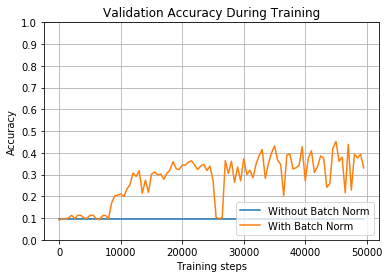

In [41]:
train_and_test(use_larger_weights=True,learning_rate=2,activation_fn=tf.nn.relu)

## 4.8 较大的Weights初始化，较大的学习率，sigmoid激活函数

【Training Result:】


  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<1:41:23,  8.22it/s]

  0%|                                                                                            | 48/50000 [00:00<1:11:26, 11.65it/s]

  0%|▏                                                                                             | 92/50000 [00:00<50:32, 16.46it/s]

  0%|▏                                                                                            | 126/50000 [00:00<36:05, 23.03it/s]

  0%|▎                                                                                            | 165/50000 [00:00<25:53, 32.08it/s]

  0%|▍                                                                                            | 208/50000 [00:00<18:41, 44.40it/s]

  0%|▍                                                                                            | 248/50000 [00:00<13:42, 60.51it/s]

  1%|▌                                                                                            | 284/50000 [00:00<10:25, 79.42it/s]

  1%|▌                                                                                            | 318/50000 [00:00<08:17, 99.89it/s]

  1%|▋                                                                                           | 363/50000 [00:01<06:21, 130.00it/s]

  1%|▋                                                                                           | 401/50000 [00:01<05:06, 161.61it/s]

  1%|▊                                                                                           | 446/50000 [00:01<04:08, 199.62it/s]

  1%|▉                                                                                           | 496/50000 [00:01<03:23, 242.89it/s]

  1%|▉                                                                                           | 538/50000 [00:01<04:19, 190.32it/s]

  1%|█                                                                                           | 599/50000 [00:01<03:26, 239.62it/s]

  1%|█▏                                                                                          | 664/50000 [00:01<02:47, 294.91it/s]

  1%|█▎                                                                                          | 725/50000 [00:02<02:21, 347.96it/s]

  2%|█▍                                                                                          | 790/50000 [00:02<02:01, 403.77it/s]

  2%|█▌                                                                                          | 857/50000 [00:02<01:47, 457.73it/s]

  2%|█▋                                                                                          | 917/50000 [00:02<01:39, 491.90it/s]

  2%|█▊                                                                                          | 977/50000 [00:02<01:39, 492.27it/s]

  2%|█▉                                                                                         | 1036/50000 [00:02<01:34, 515.66it/s]

  2%|█▉                                                                                         | 1097/50000 [00:02<01:30, 538.28it/s]

  2%|██                                                                                         | 1164/50000 [00:02<01:25, 569.49it/s]

  2%|██▏                                                                                        | 1234/50000 [00:02<01:21, 600.55it/s]

  3%|██▎                                                                                        | 1300/50000 [00:02<01:19, 615.97it/s]

  3%|██▍                                                                                        | 1369/50000 [00:03<01:16, 635.17it/s]

  3%|██▌                                                                                        | 1435/50000 [00:03<01:38, 491.18it/s]

  3%|██▋                                                                                        | 1500/50000 [00:03<01:31, 527.80it/s]

  3%|██▊                                                                                        | 1562/50000 [00:03<01:27, 551.37it/s]

  3%|██▉                                                                                        | 1621/50000 [00:03<01:26, 558.07it/s]

  3%|███                                                                                        | 1681/50000 [00:03<01:25, 567.22it/s]

  3%|███▏                                                                                       | 1742/50000 [00:03<01:23, 578.21it/s]

  4%|███▎                                                                                       | 1804/50000 [00:03<01:21, 588.92it/s]

  4%|███▍                                                                                       | 1864/50000 [00:03<01:21, 589.18it/s]

  4%|███▌                                                                                       | 1924/50000 [00:04<01:21, 589.37it/s]

  4%|███▌                                                                                       | 1984/50000 [00:04<01:22, 580.96it/s]

  4%|███▋                                                                                       | 2043/50000 [00:04<01:24, 567.30it/s]

  4%|███▊                                                                                       | 2104/50000 [00:04<01:22, 578.27it/s]

  4%|███▉                                                                                       | 2163/50000 [00:04<01:25, 557.51it/s]

  4%|████                                                                                       | 2227/50000 [00:04<01:22, 578.78it/s]

  5%|████▏                                                                                      | 2287/50000 [00:04<01:21, 583.74it/s]

  5%|████▎                                                                                      | 2346/50000 [00:04<01:48, 437.75it/s]

  5%|████▍                                                                                      | 2404/50000 [00:05<01:40, 471.68it/s]

  5%|████▍                                                                                      | 2464/50000 [00:05<01:34, 503.09it/s]

  5%|████▌                                                                                      | 2519/50000 [00:05<01:33, 509.53it/s]

  5%|████▋                                                                                      | 2575/50000 [00:05<01:30, 521.16it/s]

  5%|████▊                                                                                      | 2630/50000 [00:05<01:30, 520.89it/s]

  5%|████▉                                                                                      | 2684/50000 [00:05<01:32, 509.06it/s]

  5%|████▉                                                                                      | 2736/50000 [00:05<01:34, 500.88it/s]

  6%|█████                                                                                      | 2788/50000 [00:05<01:33, 505.38it/s]

  6%|█████▏                                                                                     | 2842/50000 [00:05<01:31, 512.76it/s]

  6%|█████▎                                                                                     | 2900/50000 [00:05<01:29, 528.72it/s]

  6%|█████▍                                                                                     | 2967/50000 [00:06<01:23, 563.39it/s]

  6%|█████▌                                                                                     | 3031/50000 [00:06<01:20, 583.21it/s]

  6%|█████▋                                                                                     | 3091/50000 [00:06<01:22, 570.20it/s]

  6%|█████▋                                                                                     | 3154/50000 [00:06<01:19, 585.72it/s]

  6%|█████▊                                                                                     | 3217/50000 [00:06<01:18, 597.09it/s]

  7%|█████▉                                                                                     | 3278/50000 [00:06<01:43, 451.04it/s]

  7%|██████                                                                                     | 3344/50000 [00:06<01:34, 495.32it/s]

  7%|██████▏                                                                                    | 3415/50000 [00:06<01:25, 543.82it/s]

  7%|██████▎                                                                                    | 3475/50000 [00:06<01:23, 555.30it/s]

  7%|██████▍                                                                                    | 3535/50000 [00:07<01:24, 548.19it/s]

  7%|██████▌                                                                                    | 3598/50000 [00:07<01:21, 567.78it/s]

  7%|██████▋                                                                                    | 3661/50000 [00:07<01:19, 583.92it/s]

  7%|██████▊                                                                                    | 3721/50000 [00:07<01:22, 559.53it/s]

  8%|██████▉                                                                                    | 3779/50000 [00:07<01:27, 528.90it/s]

  8%|██████▉                                                                                    | 3834/50000 [00:07<01:32, 497.78it/s]

  8%|███████                                                                                    | 3886/50000 [00:07<01:39, 462.96it/s]

  8%|███████▏                                                                                   | 3943/50000 [00:07<01:34, 488.42it/s]

  8%|███████▎                                                                                   | 4001/50000 [00:08<01:30, 509.03it/s]

  8%|███████▍                                                                                   | 4058/50000 [00:08<01:27, 524.84it/s]

  8%|███████▍                                                                                   | 4112/50000 [00:08<01:28, 520.55it/s]

  8%|███████▌                                                                                   | 4165/50000 [00:08<01:29, 514.63it/s]

  8%|███████▋                                                                                   | 4217/50000 [00:08<01:55, 396.44it/s]

  9%|███████▊                                                                                   | 4281/50000 [00:08<01:42, 446.85it/s]

  9%|███████▉                                                                                   | 4345/50000 [00:08<01:33, 490.51it/s]

  9%|████████                                                                                   | 4408/50000 [00:08<01:26, 524.45it/s]

  9%|████████▏                                                                                  | 4471/50000 [00:08<01:22, 551.15it/s]

  9%|████████▏                                                                                  | 4530/50000 [00:09<01:21, 559.49it/s]

  9%|████████▎                                                                                  | 4594/50000 [00:09<01:18, 580.28it/s]

  9%|████████▍                                                                                  | 4654/50000 [00:09<01:17, 584.80it/s]

  9%|████████▌                                                                                  | 4714/50000 [00:09<01:18, 577.85it/s]

 10%|████████▋                                                                                  | 4773/50000 [00:09<01:20, 563.61it/s]

 10%|████████▊                                                                                  | 4831/50000 [00:09<01:19, 565.55it/s]

 10%|████████▉                                                                                  | 4889/50000 [00:09<01:20, 558.75it/s]

 10%|█████████                                                                                  | 4947/50000 [00:09<01:19, 563.76it/s]

 10%|█████████                                                                                  | 5004/50000 [00:09<01:21, 554.53it/s]

 10%|█████████▏                                                                                 | 5061/50000 [00:09<01:20, 557.89it/s]

 10%|█████████▎                                                                                 | 5117/50000 [00:10<01:50, 404.38it/s]

 10%|█████████▍                                                                                 | 5173/50000 [00:10<01:42, 439.37it/s]

 10%|█████████▌                                                                                 | 5225/50000 [00:10<01:37, 458.70it/s]

 11%|█████████▌                                                                                 | 5275/50000 [00:10<01:39, 447.99it/s]

 11%|█████████▋                                                                                 | 5329/50000 [00:10<01:34, 471.22it/s]

 11%|█████████▊                                                                                 | 5385/50000 [00:10<01:30, 492.50it/s]

 11%|█████████▉                                                                                 | 5439/50000 [00:10<01:28, 504.81it/s]

 11%|██████████                                                                                 | 5495/50000 [00:10<01:25, 517.70it/s]

 11%|██████████                                                                                 | 5550/50000 [00:11<01:24, 525.88it/s]

 11%|██████████▏                                                                                | 5610/50000 [00:11<01:21, 543.55it/s]

 11%|██████████▎                                                                                | 5671/50000 [00:11<01:19, 560.78it/s]

 11%|██████████▍                                                                                | 5734/50000 [00:11<01:16, 578.73it/s]

 12%|██████████▌                                                                                | 5797/50000 [00:11<01:14, 591.99it/s]

 12%|██████████▋                                                                                | 5860/50000 [00:11<01:13, 601.64it/s]

 12%|██████████▊                                                                                | 5926/50000 [00:11<01:11, 616.77it/s]

 12%|██████████▉                                                                                | 5991/50000 [00:11<01:10, 625.06it/s]

 12%|███████████                                                                                | 6054/50000 [00:11<01:31, 479.85it/s]

 12%|███████████▏                                                                               | 6115/50000 [00:12<01:25, 511.72it/s]

 12%|███████████▏                                                                               | 6177/50000 [00:12<01:21, 537.59it/s]

 12%|███████████▎                                                                               | 6245/50000 [00:12<01:16, 571.13it/s]

 13%|███████████▍                                                                               | 6312/50000 [00:12<01:13, 596.42it/s]

 13%|███████████▌                                                                               | 6378/50000 [00:12<01:11, 612.92it/s]

 13%|███████████▋                                                                               | 6442/50000 [00:12<01:11, 605.45it/s]

 13%|███████████▊                                                                               | 6504/50000 [00:12<01:14, 584.41it/s]

 13%|███████████▉                                                                               | 6572/50000 [00:12<01:11, 608.94it/s]

 13%|████████████                                                                               | 6640/50000 [00:12<01:09, 627.38it/s]

 13%|████████████▏                                                                              | 6704/50000 [00:12<01:08, 629.75it/s]

 14%|████████████▎                                                                              | 6768/50000 [00:13<01:08, 629.57it/s]

 14%|████████████▍                                                                              | 6832/50000 [00:13<01:09, 622.11it/s]

 14%|████████████▌                                                                              | 6895/50000 [00:13<01:11, 601.73it/s]

 14%|████████████▋                                                                              | 6956/50000 [00:13<01:46, 405.99it/s]

 14%|████████████▊                                                                              | 7009/50000 [00:13<01:38, 435.85it/s]

 14%|████████████▊                                                                              | 7063/50000 [00:13<01:33, 459.40it/s]

 14%|████████████▉                                                                              | 7124/50000 [00:13<01:26, 495.27it/s]

 14%|█████████████                                                                              | 7179/50000 [00:13<01:24, 508.06it/s]

 14%|█████████████▏                                                                             | 7240/50000 [00:14<01:20, 533.85it/s]

 15%|█████████████▎                                                                             | 7302/50000 [00:14<01:16, 555.98it/s]

 15%|█████████████▍                                                                             | 7361/50000 [00:14<01:15, 564.58it/s]

 15%|█████████████▌                                                                             | 7419/50000 [00:14<01:17, 548.61it/s]

 15%|█████████████▌                                                                             | 7475/50000 [00:14<01:17, 549.17it/s]

 15%|█████████████▋                                                                             | 7531/50000 [00:14<01:17, 551.19it/s]

 15%|█████████████▊                                                                             | 7588/50000 [00:14<01:16, 555.51it/s]

 15%|█████████████▉                                                                             | 7645/50000 [00:14<01:15, 558.58it/s]

 15%|██████████████                                                                             | 7705/50000 [00:14<01:15, 562.81it/s]

 16%|██████████████▏                                                                            | 7762/50000 [00:14<01:17, 544.40it/s]

 16%|██████████████▏                                                                            | 7825/50000 [00:15<01:14, 564.89it/s]

 16%|██████████████▎                                                                            | 7882/50000 [00:15<01:37, 430.94it/s]

 16%|██████████████▍                                                                            | 7943/50000 [00:15<01:29, 471.76it/s]

 16%|██████████████▌                                                                            | 8004/50000 [00:15<01:23, 504.00it/s]

 16%|██████████████▋                                                                            | 8067/50000 [00:15<01:18, 535.17it/s]

 16%|██████████████▊                                                                            | 8129/50000 [00:15<01:15, 555.49it/s]

 16%|██████████████▉                                                                            | 8188/50000 [00:15<01:14, 559.42it/s]

 16%|███████████████                                                                            | 8246/50000 [00:15<01:15, 556.14it/s]

 17%|███████████████                                                                            | 8303/50000 [00:16<01:14, 559.02it/s]

 17%|███████████████▏                                                                           | 8360/50000 [00:16<01:14, 561.06it/s]

 17%|███████████████▎                                                                           | 8417/50000 [00:16<01:13, 562.49it/s]

 17%|███████████████▍                                                                           | 8474/50000 [00:16<01:15, 552.07it/s]

 17%|███████████████▌                                                                           | 8530/50000 [00:16<01:15, 546.76it/s]

 17%|███████████████▋                                                                           | 8587/50000 [00:16<01:15, 550.76it/s]

 17%|███████████████▋                                                                           | 8644/50000 [00:16<01:14, 553.59it/s]

 17%|███████████████▊                                                                           | 8700/50000 [00:16<01:14, 554.29it/s]

 18%|███████████████▉                                                                           | 8756/50000 [00:16<01:36, 425.99it/s]

 18%|████████████████                                                                           | 8808/50000 [00:17<01:31, 449.57it/s]

 18%|████████████████▏                                                                          | 8864/50000 [00:17<01:26, 476.94it/s]

 18%|████████████████▏                                                                          | 8923/50000 [00:17<01:21, 503.79it/s]

 18%|████████████████▎                                                                          | 8988/50000 [00:17<01:16, 537.93it/s]

 18%|████████████████▍                                                                          | 9045/50000 [00:17<01:16, 536.79it/s]

 18%|████████████████▌                                                                          | 9101/50000 [00:17<01:18, 522.70it/s]

 18%|████████████████▋                                                                          | 9155/50000 [00:17<01:18, 523.59it/s]

 18%|████████████████▊                                                                          | 9224/50000 [00:17<01:12, 563.42it/s]

 19%|████████████████▉                                                                          | 9295/50000 [00:17<01:08, 597.99it/s]

 19%|█████████████████                                                                          | 9359/50000 [00:17<01:06, 608.74it/s]

 19%|█████████████████▏                                                                         | 9424/50000 [00:18<01:05, 619.26it/s]

 19%|█████████████████▎                                                                         | 9487/50000 [00:18<01:05, 613.85it/s]

 19%|█████████████████▍                                                                         | 9550/50000 [00:18<01:06, 604.87it/s]

 19%|█████████████████▌                                                                         | 9619/50000 [00:18<01:04, 625.17it/s]

 19%|█████████████████▌                                                                         | 9683/50000 [00:18<01:24, 475.86it/s]

 19%|█████████████████▋                                                                         | 9747/50000 [00:18<01:18, 514.61it/s]

 20%|█████████████████▊                                                                         | 9817/50000 [00:18<01:12, 558.06it/s]

 20%|█████████████████▉                                                                         | 9887/50000 [00:18<01:07, 593.10it/s]

 20%|██████████████████                                                                         | 9951/50000 [00:18<01:06, 600.08it/s]

 20%|██████████████████                                                                        | 10014/50000 [00:19<01:12, 548.88it/s]

 20%|██████████████████▏                                                                       | 10072/50000 [00:19<01:15, 526.45it/s]

 20%|██████████████████▏                                                                       | 10127/50000 [00:19<01:21, 489.64it/s]

 20%|██████████████████▎                                                                       | 10178/50000 [00:19<01:23, 479.23it/s]

 20%|██████████████████▍                                                                       | 10238/50000 [00:19<01:18, 509.08it/s]

 21%|██████████████████▌                                                                       | 10294/50000 [00:19<01:16, 520.83it/s]

 21%|██████████████████▋                                                                       | 10348/50000 [00:19<01:15, 522.28it/s]

 21%|██████████████████▋                                                                       | 10411/50000 [00:19<01:12, 549.46it/s]

 21%|██████████████████▊                                                                       | 10475/50000 [00:19<01:09, 571.16it/s]

 21%|██████████████████▉                                                                       | 10536/50000 [00:20<01:08, 579.42it/s]

 21%|███████████████████                                                                       | 10595/50000 [00:20<01:27, 447.93it/s]

 21%|███████████████████▏                                                                      | 10655/50000 [00:20<01:21, 483.93it/s]

 21%|███████████████████▎                                                                      | 10717/50000 [00:20<01:15, 517.09it/s]

 22%|███████████████████▍                                                                      | 10774/50000 [00:20<01:13, 530.82it/s]

 22%|███████████████████▌                                                                      | 10838/50000 [00:20<01:10, 556.93it/s]

 22%|███████████████████▋                                                                      | 10904/50000 [00:20<01:07, 581.63it/s]

 22%|███████████████████▋                                                                      | 10967/50000 [00:20<01:05, 592.45it/s]

 22%|███████████████████▊                                                                      | 11028/50000 [00:21<01:05, 594.59it/s]

 22%|███████████████████▉                                                                      | 11097/50000 [00:21<01:02, 619.10it/s]

 22%|████████████████████                                                                      | 11169/50000 [00:21<01:00, 645.00it/s]

 22%|████████████████████▏                                                                     | 11239/50000 [00:21<00:58, 659.21it/s]

 23%|████████████████████▎                                                                     | 11313/50000 [00:21<00:57, 678.29it/s]

 23%|████████████████████▍                                                                     | 11382/50000 [00:21<00:57, 676.30it/s]

 23%|████████████████████▌                                                                     | 11451/50000 [00:21<00:56, 676.89it/s]

 23%|████████████████████▋                                                                     | 11520/50000 [00:21<01:18, 491.20it/s]

 23%|████████████████████▊                                                                     | 11578/50000 [00:21<01:14, 513.85it/s]

 23%|████████████████████▉                                                                     | 11635/50000 [00:22<01:14, 518.35it/s]

 23%|█████████████████████                                                                     | 11691/50000 [00:22<01:13, 524.63it/s]

 23%|█████████████████████▏                                                                    | 11747/50000 [00:22<01:11, 532.12it/s]

 24%|█████████████████████▏                                                                    | 11803/50000 [00:22<01:10, 539.07it/s]

 24%|█████████████████████▎                                                                    | 11859/50000 [00:22<01:10, 542.45it/s]

 24%|█████████████████████▍                                                                    | 11919/50000 [00:22<01:08, 555.84it/s]

 24%|█████████████████████▌                                                                    | 11981/50000 [00:22<01:06, 572.48it/s]

 24%|█████████████████████▋                                                                    | 12042/50000 [00:22<01:05, 582.02it/s]

 24%|█████████████████████▊                                                                    | 12108/50000 [00:22<01:03, 600.57it/s]

 24%|█████████████████████▉                                                                    | 12177/50000 [00:22<01:00, 621.94it/s]

 24%|██████████████████████                                                                    | 12240/50000 [00:23<01:00, 619.32it/s]

 25%|██████████████████████▏                                                                   | 12303/50000 [00:23<01:00, 619.31it/s]

 25%|██████████████████████▎                                                                   | 12366/50000 [00:23<01:01, 612.11it/s]

 25%|██████████████████████▎                                                                   | 12428/50000 [00:23<01:21, 459.49it/s]

 25%|██████████████████████▍                                                                   | 12480/50000 [00:23<01:18, 475.16it/s]

 25%|██████████████████████▌                                                                   | 12535/50000 [00:23<01:15, 494.41it/s]

 25%|██████████████████████▋                                                                   | 12604/50000 [00:23<01:09, 538.17it/s]

 25%|██████████████████████▊                                                                   | 12675/50000 [00:23<01:04, 577.86it/s]

 25%|██████████████████████▉                                                                   | 12744/50000 [00:24<01:01, 604.72it/s]

 26%|███████████████████████                                                                   | 12813/50000 [00:24<00:59, 626.75it/s]

 26%|███████████████████████▏                                                                  | 12882/50000 [00:24<00:57, 641.37it/s]

 26%|███████████████████████▎                                                                  | 12948/50000 [00:24<01:00, 616.59it/s]

 26%|███████████████████████▍                                                                  | 13011/50000 [00:24<01:02, 596.42it/s]

 26%|███████████████████████▌                                                                  | 13075/50000 [00:24<01:00, 607.59it/s]

 26%|███████████████████████▋                                                                  | 13137/50000 [00:24<01:01, 595.91it/s]

 26%|███████████████████████▊                                                                  | 13200/50000 [00:24<01:01, 602.74it/s]

 27%|███████████████████████▉                                                                  | 13264/50000 [00:24<01:00, 612.17it/s]

 27%|███████████████████████▉                                                                  | 13326/50000 [00:24<00:59, 611.35it/s]

 27%|████████████████████████                                                                  | 13388/50000 [00:25<01:19, 460.22it/s]

 27%|████████████████████████▏                                                                 | 13449/50000 [00:25<01:13, 494.73it/s]

 27%|████████████████████████▎                                                                 | 13511/50000 [00:25<01:09, 525.67it/s]

 27%|████████████████████████▍                                                                 | 13573/50000 [00:25<01:06, 548.29it/s]

 27%|████████████████████████▌                                                                 | 13633/50000 [00:25<01:04, 560.12it/s]

 27%|████████████████████████▋                                                                 | 13699/50000 [00:25<01:01, 585.61it/s]

 28%|████████████████████████▊                                                                 | 13760/50000 [00:25<01:01, 591.46it/s]

 28%|████████████████████████▉                                                                 | 13824/50000 [00:25<01:00, 602.28it/s]

 28%|█████████████████████████                                                                 | 13893/50000 [00:25<00:57, 624.92it/s]

 28%|█████████████████████████▏                                                                | 13964/50000 [00:26<00:55, 646.93it/s]

 28%|█████████████████████████▎                                                                | 14030/50000 [00:26<00:55, 647.49it/s]

 28%|█████████████████████████▎                                                                | 14096/50000 [00:26<00:57, 624.05it/s]

 28%|█████████████████████████▍                                                                | 14160/50000 [00:26<00:57, 627.40it/s]

 28%|█████████████████████████▌                                                                | 14227/50000 [00:26<00:56, 636.45it/s]

 29%|█████████████████████████▋                                                                | 14291/50000 [00:26<01:13, 485.85it/s]

 29%|█████████████████████████▊                                                                | 14356/50000 [00:26<01:07, 524.75it/s]

 29%|█████████████████████████▉                                                                | 14414/50000 [00:26<01:06, 536.11it/s]

 29%|██████████████████████████                                                                | 14474/50000 [00:27<01:04, 552.68it/s]

 29%|██████████████████████████▏                                                               | 14532/50000 [00:27<01:03, 556.21it/s]

 29%|██████████████████████████▎                                                               | 14591/50000 [00:27<01:02, 564.74it/s]

 29%|██████████████████████████▎                                                               | 14652/50000 [00:27<01:01, 574.78it/s]

 29%|██████████████████████████▍                                                               | 14712/50000 [00:27<01:00, 579.21it/s]

 30%|██████████████████████████▌                                                               | 14782/50000 [00:27<00:57, 608.08it/s]

 30%|██████████████████████████▋                                                               | 14847/50000 [00:27<00:56, 618.78it/s]

 30%|██████████████████████████▊                                                               | 14912/50000 [00:27<00:56, 626.50it/s]

 30%|██████████████████████████▉                                                               | 14976/50000 [00:27<00:55, 627.29it/s]

 30%|███████████████████████████                                                               | 15040/50000 [00:27<00:57, 608.20it/s]

 30%|███████████████████████████▏                                                              | 15102/50000 [00:28<00:57, 606.80it/s]

 30%|███████████████████████████▎                                                              | 15164/50000 [00:28<00:57, 607.60it/s]

 30%|███████████████████████████▍                                                              | 15225/50000 [00:28<01:18, 441.40it/s]

 31%|███████████████████████████▌                                                              | 15284/50000 [00:28<01:13, 475.49it/s]

 31%|███████████████████████████▌                                                              | 15340/50000 [00:28<01:09, 497.07it/s]

 31%|███████████████████████████▋                                                              | 15396/50000 [00:28<01:07, 513.38it/s]

 31%|███████████████████████████▊                                                              | 15459/50000 [00:28<01:03, 542.54it/s]

 31%|███████████████████████████▉                                                              | 15517/50000 [00:28<01:02, 552.10it/s]

 31%|████████████████████████████                                                              | 15581/50000 [00:28<00:59, 574.70it/s]

 31%|████████████████████████████▏                                                             | 15645/50000 [00:29<00:58, 590.01it/s]

 31%|████████████████████████████▎                                                             | 15709/50000 [00:29<00:56, 602.92it/s]

 32%|████████████████████████████▍                                                             | 15772/50000 [00:29<00:56, 609.50it/s]

 32%|████████████████████████████▌                                                             | 15838/50000 [00:29<00:54, 622.53it/s]

 32%|████████████████████████████▌                                                             | 15901/50000 [00:29<00:55, 619.73it/s]

 32%|████████████████████████████▋                                                             | 15964/50000 [00:29<00:54, 621.43it/s]

 32%|████████████████████████████▊                                                             | 16027/50000 [00:29<00:56, 601.29it/s]

 32%|████████████████████████████▉                                                             | 16088/50000 [00:29<01:13, 458.82it/s]

 32%|█████████████████████████████                                                             | 16152/50000 [00:29<01:07, 499.38it/s]

 32%|█████████████████████████████▏                                                            | 16216/50000 [00:30<01:03, 532.31it/s]

 33%|█████████████████████████████▎                                                            | 16280/50000 [00:30<01:00, 559.54it/s]

 33%|█████████████████████████████▍                                                            | 16343/50000 [00:30<00:58, 576.22it/s]

 33%|█████████████████████████████▌                                                            | 16406/50000 [00:30<00:56, 590.15it/s]

 33%|█████████████████████████████▋                                                            | 16469/50000 [00:30<00:55, 600.31it/s]

 33%|█████████████████████████████▊                                                            | 16531/50000 [00:30<00:56, 589.31it/s]

 33%|█████████████████████████████▊                                                            | 16592/50000 [00:30<00:56, 594.10it/s]

 33%|█████████████████████████████▉                                                            | 16656/50000 [00:30<00:55, 605.90it/s]

 33%|██████████████████████████████                                                            | 16722/50000 [00:30<00:53, 619.90it/s]

 34%|██████████████████████████████▏                                                           | 16796/50000 [00:31<00:51, 650.37it/s]

 34%|██████████████████████████████▎                                                           | 16869/50000 [00:31<00:49, 671.02it/s]

 34%|██████████████████████████████▍                                                           | 16940/50000 [00:31<00:48, 680.82it/s]

 34%|██████████████████████████████▌                                                           | 17009/50000 [00:31<01:04, 512.35it/s]

 34%|██████████████████████████████▋                                                           | 17067/50000 [00:31<01:02, 526.99it/s]

 34%|██████████████████████████████▊                                                           | 17125/50000 [00:31<01:01, 537.74it/s]

 34%|██████████████████████████████▉                                                           | 17183/50000 [00:31<01:00, 539.45it/s]

 34%|███████████████████████████████                                                           | 17240/50000 [00:31<01:02, 527.42it/s]

 35%|███████████████████████████████▏                                                          | 17299/50000 [00:31<01:00, 542.16it/s]

 35%|███████████████████████████████▏                                                          | 17356/50000 [00:32<00:59, 549.06it/s]

 35%|███████████████████████████████▎                                                          | 17415/50000 [00:32<00:58, 559.57it/s]

 35%|███████████████████████████████▍                                                          | 17474/50000 [00:32<00:57, 565.54it/s]

 35%|███████████████████████████████▌                                                          | 17532/50000 [00:32<00:58, 558.74it/s]

 35%|███████████████████████████████▋                                                          | 17589/50000 [00:32<00:57, 560.85it/s]

 35%|███████████████████████████████▊                                                          | 17646/50000 [00:32<00:58, 552.57it/s]

 35%|███████████████████████████████▊                                                          | 17702/50000 [00:32<00:59, 543.92it/s]

 36%|███████████████████████████████▉                                                          | 17758/50000 [00:32<00:59, 545.88it/s]

 36%|████████████████████████████████                                                          | 17813/50000 [00:32<00:59, 542.69it/s]

 36%|████████████████████████████████▏                                                         | 17873/50000 [00:32<00:57, 557.57it/s]

 36%|████████████████████████████████▎                                                         | 17929/50000 [00:33<01:13, 436.30it/s]

 36%|████████████████████████████████▎                                                         | 17986/50000 [00:33<01:08, 468.49it/s]

 36%|████████████████████████████████▍                                                         | 18044/50000 [00:33<01:04, 494.96it/s]

 36%|████████████████████████████████▌                                                         | 18102/50000 [00:33<01:01, 516.72it/s]

 36%|████████████████████████████████▋                                                         | 18156/50000 [00:33<01:00, 522.38it/s]

 36%|████████████████████████████████▊                                                         | 18214/50000 [00:33<00:59, 537.34it/s]

 37%|████████████████████████████████▉                                                         | 18288/50000 [00:33<00:54, 583.05it/s]

 37%|█████████████████████████████████                                                         | 18355/50000 [00:33<00:52, 605.46it/s]

 37%|█████████████████████████████████▏                                                        | 18424/50000 [00:33<00:50, 625.61it/s]

 37%|█████████████████████████████████▎                                                        | 18489/50000 [00:34<00:50, 629.56it/s]

 37%|█████████████████████████████████▍                                                        | 18553/50000 [00:34<00:50, 627.58it/s]

 37%|█████████████████████████████████▌                                                        | 18617/50000 [00:34<00:50, 615.40it/s]

 37%|█████████████████████████████████▌                                                        | 18680/50000 [00:34<00:53, 584.07it/s]

 37%|█████████████████████████████████▋                                                        | 18740/50000 [00:34<00:55, 565.94it/s]

 38%|█████████████████████████████████▊                                                        | 18798/50000 [00:34<00:59, 528.54it/s]

 38%|█████████████████████████████████▉                                                        | 18852/50000 [00:34<01:19, 390.62it/s]

 38%|██████████████████████████████████                                                        | 18910/50000 [00:34<01:11, 432.34it/s]

 38%|██████████████████████████████████▏                                                       | 18966/50000 [00:35<01:07, 462.09it/s]

 38%|██████████████████████████████████▏                                                       | 19021/50000 [00:35<01:03, 484.43it/s]

 38%|██████████████████████████████████▎                                                       | 19077/50000 [00:35<01:01, 503.87it/s]

 38%|██████████████████████████████████▍                                                       | 19137/50000 [00:35<00:58, 526.90it/s]

 38%|██████████████████████████████████▌                                                       | 19192/50000 [00:35<00:58, 530.95it/s]

 38%|██████████████████████████████████▋                                                       | 19247/50000 [00:35<00:57, 530.75it/s]

 39%|██████████████████████████████████▋                                                       | 19304/50000 [00:35<00:56, 540.82it/s]

 39%|██████████████████████████████████▊                                                       | 19365/50000 [00:35<00:54, 558.74it/s]

 39%|██████████████████████████████████▉                                                       | 19424/50000 [00:35<00:53, 566.57it/s]

 39%|███████████████████████████████████                                                       | 19484/50000 [00:35<00:53, 574.99it/s]

 39%|███████████████████████████████████▏                                                      | 19543/50000 [00:36<00:52, 578.17it/s]

 39%|███████████████████████████████████▎                                                      | 19602/50000 [00:36<00:54, 555.87it/s]

 39%|███████████████████████████████████▍                                                      | 19668/50000 [00:36<00:52, 582.36it/s]

 39%|███████████████████████████████████▌                                                      | 19730/50000 [00:36<00:51, 591.92it/s]

 40%|███████████████████████████████████▌                                                      | 19790/50000 [00:36<01:06, 456.64it/s]

 40%|███████████████████████████████████▋                                                      | 19850/50000 [00:36<01:01, 489.82it/s]

 40%|███████████████████████████████████▊                                                      | 19916/50000 [00:36<00:56, 529.95it/s]

 40%|███████████████████████████████████▉                                                      | 19976/50000 [00:36<00:54, 548.09it/s]

 40%|████████████████████████████████████                                                      | 20040/50000 [00:37<00:52, 571.64it/s]

 40%|████████████████████████████████████▏                                                     | 20102/50000 [00:37<00:51, 582.49it/s]

 40%|████████████████████████████████████▎                                                     | 20162/50000 [00:37<00:51, 574.61it/s]

 40%|████████████████████████████████████▍                                                     | 20227/50000 [00:37<00:50, 592.51it/s]

 41%|████████████████████████████████████▌                                                     | 20291/50000 [00:37<00:49, 604.75it/s]

 41%|████████████████████████████████████▋                                                     | 20359/50000 [00:37<00:47, 624.26it/s]

 41%|████████████████████████████████████▊                                                     | 20423/50000 [00:37<00:48, 607.93it/s]

 41%|████████████████████████████████████▊                                                     | 20485/50000 [00:37<00:49, 597.86it/s]

 41%|████████████████████████████████████▉                                                     | 20546/50000 [00:37<00:49, 598.39it/s]

 41%|█████████████████████████████████████                                                     | 20619/50000 [00:37<00:46, 629.78it/s]

 41%|█████████████████████████████████████▏                                                    | 20683/50000 [00:38<01:01, 475.60it/s]

 41%|█████████████████████████████████████▎                                                    | 20737/50000 [00:38<00:59, 490.92it/s]

 42%|█████████████████████████████████████▍                                                    | 20802/50000 [00:38<00:55, 528.88it/s]

 42%|█████████████████████████████████████▌                                                    | 20865/50000 [00:38<00:52, 553.11it/s]

 42%|█████████████████████████████████████▋                                                    | 20924/50000 [00:38<00:54, 537.95it/s]

 42%|█████████████████████████████████████▊                                                    | 20980/50000 [00:38<00:56, 510.62it/s]

 42%|█████████████████████████████████████▊                                                    | 21033/50000 [00:38<00:58, 492.27it/s]

 42%|█████████████████████████████████████▉                                                    | 21093/50000 [00:38<00:55, 519.31it/s]

 42%|██████████████████████████████████████                                                    | 21154/50000 [00:39<00:53, 542.50it/s]

 42%|██████████████████████████████████████▏                                                   | 21210/50000 [00:39<00:53, 540.15it/s]

 43%|██████████████████████████████████████▎                                                   | 21265/50000 [00:39<00:54, 524.88it/s]

 43%|██████████████████████████████████████▍                                                   | 21320/50000 [00:39<00:54, 531.04it/s]

 43%|██████████████████████████████████████▍                                                   | 21379/50000 [00:39<00:52, 544.83it/s]

 43%|██████████████████████████████████████▌                                                   | 21437/50000 [00:39<00:51, 552.19it/s]

 43%|██████████████████████████████████████▋                                                   | 21493/50000 [00:39<00:52, 546.84it/s]

 43%|██████████████████████████████████████▊                                                   | 21549/50000 [00:39<00:51, 547.93it/s]

 43%|██████████████████████████████████████▉                                                   | 21604/50000 [00:39<01:09, 410.47it/s]

 43%|██████████████████████████████████████▉                                                   | 21665/50000 [00:40<01:02, 453.38it/s]

 43%|███████████████████████████████████████                                                   | 21724/50000 [00:40<00:58, 486.34it/s]

 44%|███████████████████████████████████████▏                                                  | 21782/50000 [00:40<00:55, 510.12it/s]

 44%|███████████████████████████████████████▎                                                  | 21839/50000 [00:40<00:53, 524.21it/s]

 44%|███████████████████████████████████████▍                                                  | 21899/50000 [00:40<00:51, 543.77it/s]

 44%|███████████████████████████████████████▌                                                  | 21956/50000 [00:40<00:50, 550.22it/s]

 44%|███████████████████████████████████████▌                                                  | 22013/50000 [00:40<00:52, 536.09it/s]

 44%|███████████████████████████████████████▋                                                  | 22070/50000 [00:40<00:51, 543.13it/s]

 44%|███████████████████████████████████████▊                                                  | 22126/50000 [00:40<00:52, 534.42it/s]

 44%|███████████████████████████████████████▉                                                  | 22180/50000 [00:40<00:52, 534.92it/s]

 44%|████████████████████████████████████████                                                  | 22238/50000 [00:41<00:50, 546.56it/s]

 45%|████████████████████████████████████████▏                                                 | 22304/50000 [00:41<00:48, 575.17it/s]

 45%|████████████████████████████████████████▎                                                 | 22368/50000 [00:41<00:46, 590.36it/s]

 45%|████████████████████████████████████████▍                                                 | 22434/50000 [00:41<00:45, 608.43it/s]

 45%|████████████████████████████████████████▍                                                 | 22496/50000 [00:41<00:45, 606.96it/s]

 45%|████████████████████████████████████████▌                                                 | 22558/50000 [00:41<01:00, 452.46it/s]

 45%|████████████████████████████████████████▋                                                 | 22617/50000 [00:41<00:56, 484.41it/s]

 45%|████████████████████████████████████████▊                                                 | 22683/50000 [00:41<00:52, 523.02it/s]

 45%|████████████████████████████████████████▉                                                 | 22749/50000 [00:42<00:49, 555.31it/s]

 46%|█████████████████████████████████████████                                                 | 22812/50000 [00:42<00:47, 573.08it/s]

 46%|█████████████████████████████████████████▏                                                | 22872/50000 [00:42<00:47, 571.41it/s]

 46%|█████████████████████████████████████████▎                                                | 22937/50000 [00:42<00:45, 591.73it/s]

 46%|█████████████████████████████████████████▍                                                | 23001/50000 [00:42<00:45, 599.10it/s]

 46%|█████████████████████████████████████████▌                                                | 23067/50000 [00:42<00:43, 614.90it/s]

 46%|█████████████████████████████████████████▋                                                | 23130/50000 [00:42<00:43, 610.85it/s]

 46%|█████████████████████████████████████████▋                                                | 23192/50000 [00:42<00:44, 606.86it/s]

 47%|█████████████████████████████████████████▊                                                | 23254/50000 [00:42<00:44, 600.60it/s]

 47%|█████████████████████████████████████████▉                                                | 23315/50000 [00:42<00:48, 553.08it/s]

 47%|██████████████████████████████████████████                                                | 23372/50000 [00:43<00:48, 552.02it/s]

 47%|██████████████████████████████████████████▏                                               | 23428/50000 [00:43<01:02, 424.08it/s]

 47%|██████████████████████████████████████████▎                                               | 23488/50000 [00:43<00:57, 464.19it/s]

 47%|██████████████████████████████████████████▍                                               | 23547/50000 [00:43<00:53, 495.01it/s]

 47%|██████████████████████████████████████████▍                                               | 23610/50000 [00:43<00:50, 526.72it/s]

 47%|██████████████████████████████████████████▌                                               | 23670/50000 [00:43<00:48, 545.66it/s]

 47%|██████████████████████████████████████████▋                                               | 23727/50000 [00:43<00:48, 545.26it/s]

 48%|██████████████████████████████████████████▊                                               | 23784/50000 [00:43<00:49, 534.27it/s]

 48%|██████████████████████████████████████████▉                                               | 23847/50000 [00:44<00:46, 558.70it/s]

 48%|███████████████████████████████████████████                                               | 23905/50000 [00:44<00:47, 550.91it/s]

 48%|███████████████████████████████████████████▏                                              | 23961/50000 [00:44<00:47, 547.56it/s]

 48%|███████████████████████████████████████████▏                                              | 24017/50000 [00:44<00:48, 540.51it/s]

 48%|███████████████████████████████████████████▎                                              | 24077/50000 [00:44<00:46, 555.95it/s]

 48%|███████████████████████████████████████████▍                                              | 24137/50000 [00:44<00:45, 567.29it/s]

 48%|███████████████████████████████████████████▌                                              | 24195/50000 [00:44<00:45, 566.49it/s]

 49%|███████████████████████████████████████████▋                                              | 24252/50000 [00:44<00:46, 558.01it/s]

 49%|███████████████████████████████████████████▊                                              | 24308/50000 [00:44<00:46, 550.82it/s]

 49%|███████████████████████████████████████████▊                                              | 24364/50000 [00:45<01:03, 406.12it/s]

 49%|███████████████████████████████████████████▉                                              | 24421/50000 [00:45<00:57, 443.71it/s]

 49%|████████████████████████████████████████████                                              | 24477/50000 [00:45<00:54, 471.12it/s]

 49%|████████████████████████████████████████████▏                                             | 24535/50000 [00:45<00:51, 497.02it/s]

 49%|████████████████████████████████████████████▎                                             | 24600/50000 [00:45<00:47, 533.82it/s]

 49%|████████████████████████████████████████████▍                                             | 24661/50000 [00:45<00:45, 553.49it/s]

 49%|████████████████████████████████████████████▌                                             | 24726/50000 [00:45<00:43, 578.16it/s]

 50%|████████████████████████████████████████████▌                                             | 24786/50000 [00:45<00:43, 574.94it/s]

 50%|████████████████████████████████████████████▋                                             | 24845/50000 [00:45<00:44, 563.27it/s]

 50%|████████████████████████████████████████████▊                                             | 24905/50000 [00:45<00:43, 570.98it/s]

 50%|████████████████████████████████████████████▉                                             | 24978/50000 [00:46<00:41, 608.26it/s]

 50%|█████████████████████████████████████████████                                             | 25045/50000 [00:46<00:39, 624.28it/s]

 50%|█████████████████████████████████████████████▏                                            | 25114/50000 [00:46<00:38, 641.33it/s]

 50%|█████████████████████████████████████████████▎                                            | 25184/50000 [00:46<00:37, 656.52it/s]

 51%|█████████████████████████████████████████████▍                                            | 25251/50000 [00:46<00:48, 512.71it/s]

 51%|█████████████████████████████████████████████▌                                            | 25310/50000 [00:46<00:46, 532.63it/s]

 51%|█████████████████████████████████████████████▋                                            | 25368/50000 [00:46<00:46, 525.67it/s]

 51%|█████████████████████████████████████████████▊                                            | 25424/50000 [00:46<00:46, 531.37it/s]

 51%|█████████████████████████████████████████████▉                                            | 25490/50000 [00:47<00:43, 563.31it/s]

 51%|█████████████████████████████████████████████▉                                            | 25555/50000 [00:47<00:41, 585.63it/s]

 51%|██████████████████████████████████████████████                                            | 25620/50000 [00:47<00:40, 602.33it/s]

 51%|██████████████████████████████████████████████▏                                           | 25682/50000 [00:47<00:40, 595.77it/s]

 51%|██████████████████████████████████████████████▎                                           | 25743/50000 [00:47<00:40, 598.68it/s]

 52%|██████████████████████████████████████████████▍                                           | 25804/50000 [00:47<00:40, 593.73it/s]

 52%|██████████████████████████████████████████████▌                                           | 25864/50000 [00:47<00:41, 587.34it/s]

 52%|██████████████████████████████████████████████▋                                           | 25930/50000 [00:47<00:39, 606.18it/s]

 52%|██████████████████████████████████████████████▊                                           | 25991/50000 [00:47<00:40, 590.21it/s]

 52%|██████████████████████████████████████████████▉                                           | 26052/50000 [00:47<00:40, 593.01it/s]

 52%|███████████████████████████████████████████████                                           | 26119/50000 [00:48<00:38, 612.95it/s]

 52%|███████████████████████████████████████████████▏                                          | 26181/50000 [00:48<00:52, 455.78it/s]

 52%|███████████████████████████████████████████████▏                                          | 26236/50000 [00:48<00:49, 479.55it/s]

 53%|███████████████████████████████████████████████▎                                          | 26293/50000 [00:48<00:47, 501.23it/s]

 53%|███████████████████████████████████████████████▍                                          | 26351/50000 [00:48<00:45, 521.49it/s]

 53%|███████████████████████████████████████████████▌                                          | 26418/50000 [00:48<00:42, 557.62it/s]

 53%|███████████████████████████████████████████████▋                                          | 26477/50000 [00:48<00:41, 564.14it/s]

 53%|███████████████████████████████████████████████▊                                          | 26538/50000 [00:48<00:40, 575.97it/s]

 53%|███████████████████████████████████████████████▉                                          | 26600/50000 [00:48<00:39, 587.28it/s]

 53%|███████████████████████████████████████████████▉                                          | 26666/50000 [00:49<00:38, 604.47it/s]

 53%|████████████████████████████████████████████████                                          | 26731/50000 [00:49<00:37, 616.17it/s]

 54%|████████████████████████████████████████████████▏                                         | 26794/50000 [00:49<00:37, 615.30it/s]

 54%|████████████████████████████████████████████████▎                                         | 26856/50000 [00:49<00:38, 602.83it/s]

 54%|████████████████████████████████████████████████▍                                         | 26917/50000 [00:49<00:38, 596.58it/s]

 54%|████████████████████████████████████████████████▌                                         | 26983/50000 [00:49<00:37, 613.04it/s]

 54%|████████████████████████████████████████████████▋                                         | 27046/50000 [00:49<00:37, 616.71it/s]

 54%|████████████████████████████████████████████████▊                                         | 27108/50000 [00:49<00:49, 463.36it/s]

 54%|████████████████████████████████████████████████▉                                         | 27172/50000 [00:49<00:45, 504.32it/s]

 54%|█████████████████████████████████████████████████                                         | 27238/50000 [00:50<00:42, 540.42it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27303/50000 [00:50<00:39, 568.12it/s]

 55%|█████████████████████████████████████████████████▎                                        | 27371/50000 [00:50<00:38, 594.91it/s]

 55%|█████████████████████████████████████████████████▍                                        | 27436/50000 [00:50<00:37, 609.18it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27500/50000 [00:50<00:36, 616.80it/s]

 55%|█████████████████████████████████████████████████▌                                        | 27564/50000 [00:50<00:38, 583.23it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27625/50000 [00:50<00:37, 589.76it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27685/50000 [00:50<00:37, 589.77it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27751/50000 [00:50<00:36, 606.32it/s]

 56%|██████████████████████████████████████████████████                                        | 27823/50000 [00:51<00:34, 635.24it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27895/50000 [00:51<00:33, 655.39it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27962/50000 [00:51<00:34, 630.48it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28026/50000 [00:51<00:46, 473.77it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28087/50000 [00:51<00:43, 505.61it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28143/50000 [00:51<00:43, 500.28it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28197/50000 [00:51<00:43, 497.83it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28270/50000 [00:51<00:39, 549.44it/s]

 57%|███████████████████████████████████████████████████                                       | 28347/50000 [00:51<00:36, 600.06it/s]

 57%|███████████████████████████████████████████████████▏                                      | 28423/50000 [00:52<00:33, 639.32it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28498/50000 [00:52<00:32, 667.63it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28568/50000 [00:52<00:32, 665.97it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28637/50000 [00:52<00:31, 669.58it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28709/50000 [00:52<00:31, 682.57it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28779/50000 [00:52<00:30, 686.23it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28849/50000 [00:52<00:30, 684.78it/s]

 58%|████████████████████████████████████████████████████                                      | 28918/50000 [00:52<00:41, 509.37it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28978/50000 [00:53<00:39, 532.51it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29037/50000 [00:53<00:38, 545.92it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29100/50000 [00:53<00:36, 567.57it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29160/50000 [00:53<00:36, 570.80it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29225/50000 [00:53<00:35, 591.27it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29286/50000 [00:53<00:35, 588.60it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29346/50000 [00:53<00:34, 590.71it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29407/50000 [00:53<00:34, 593.36it/s]

 59%|█████████████████████████████████████████████████████                                     | 29467/50000 [00:53<00:35, 572.02it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29527/50000 [00:53<00:35, 577.24it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29588/50000 [00:54<00:34, 585.46it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29648/50000 [00:54<00:34, 586.76it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29707/50000 [00:54<00:34, 582.98it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29766/50000 [00:54<00:35, 573.60it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29824/50000 [00:54<00:35, 564.22it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29881/50000 [00:54<00:48, 416.55it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29938/50000 [00:54<00:44, 452.36it/s]

 60%|█████████████████████████████████████████████████████▉                                    | 29997/50000 [00:54<00:41, 485.53it/s]

 60%|██████████████████████████████████████████████████████                                    | 30058/50000 [00:54<00:38, 516.23it/s]

 60%|██████████████████████████████████████████████████████▏                                   | 30125/50000 [00:55<00:35, 553.40it/s]

 60%|██████████████████████████████████████████████████████▎                                   | 30190/50000 [00:55<00:34, 578.09it/s]

 61%|██████████████████████████████████████████████████████▍                                   | 30257/50000 [00:55<00:32, 600.10it/s]

 61%|██████████████████████████████████████████████████████▌                                   | 30323/50000 [00:55<00:32, 613.93it/s]

 61%|██████████████████████████████████████████████████████▋                                   | 30387/50000 [00:55<00:31, 618.41it/s]

 61%|██████████████████████████████████████████████████████▊                                   | 30454/50000 [00:55<00:31, 629.95it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30518/50000 [00:55<00:31, 624.19it/s]

 61%|███████████████████████████████████████████████████████                                   | 30581/50000 [00:55<00:31, 624.56it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30646/50000 [00:55<00:30, 628.81it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30720/50000 [00:56<00:29, 655.47it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30787/50000 [00:56<00:38, 504.19it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30850/50000 [00:56<00:35, 535.32it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30919/50000 [00:56<00:33, 572.87it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30988/50000 [00:56<00:31, 602.46it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31052/50000 [00:56<00:30, 611.96it/s]

 62%|████████████████████████████████████████████████████████                                  | 31120/50000 [00:56<00:29, 629.62it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31185/50000 [00:56<00:30, 619.76it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31249/50000 [00:56<00:30, 604.94it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31317/50000 [00:57<00:29, 624.40it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31386/50000 [00:57<00:29, 641.42it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31451/50000 [00:57<00:29, 638.80it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31516/50000 [00:57<00:29, 625.96it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31582/50000 [00:57<00:29, 634.46it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31646/50000 [00:57<00:29, 630.98it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31710/50000 [00:57<00:38, 471.88it/s]

 64%|█████████████████████████████████████████████████████████▏                                | 31769/50000 [00:57<00:36, 501.09it/s]

 64%|█████████████████████████████████████████████████████████▎                                | 31827/50000 [00:57<00:34, 521.39it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31886/50000 [00:58<00:33, 539.16it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31945/50000 [00:58<00:32, 552.33it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32003/50000 [00:58<00:32, 548.10it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32068/50000 [00:58<00:31, 572.52it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32134/50000 [00:58<00:30, 593.45it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32201/50000 [00:58<00:29, 613.28it/s]

 65%|██████████████████████████████████████████████████████████                                | 32266/50000 [00:58<00:28, 622.54it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32329/50000 [00:58<00:29, 598.59it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32390/50000 [00:58<00:30, 576.88it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32449/50000 [00:59<00:30, 572.77it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32507/50000 [00:59<00:31, 560.36it/s]

 65%|██████████████████████████████████████████████████████████▌                               | 32564/50000 [00:59<00:31, 553.88it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32620/50000 [00:59<00:42, 404.64it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32674/50000 [00:59<00:39, 436.75it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32733/50000 [00:59<00:36, 471.71it/s]

 66%|███████████████████████████████████████████████████████████                               | 32793/50000 [00:59<00:34, 501.86it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32852/50000 [00:59<00:32, 523.00it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32911/50000 [00:59<00:31, 538.88it/s]

 66%|███████████████████████████████████████████████████████████▎                              | 32976/50000 [01:00<00:30, 566.93it/s]

 66%|███████████████████████████████████████████████████████████▍                              | 33039/50000 [01:00<00:29, 583.29it/s]

 66%|███████████████████████████████████████████████████████████▌                              | 33102/50000 [01:00<00:28, 593.65it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33170/50000 [01:00<00:27, 614.27it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33235/50000 [01:00<00:26, 623.26it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33301/50000 [01:00<00:26, 632.51it/s]

 67%|████████████████████████████████████████████████████████████                              | 33368/50000 [01:00<00:25, 640.12it/s]

 67%|████████████████████████████████████████████████████████████▏                             | 33434/50000 [01:00<00:25, 642.70it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 33499/50000 [01:00<00:25, 637.81it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33563/50000 [01:01<00:34, 477.72it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33631/50000 [01:01<00:31, 523.64it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33697/50000 [01:01<00:29, 557.19it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33758/50000 [01:01<00:28, 569.30it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33819/50000 [01:01<00:29, 556.01it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33877/50000 [01:01<00:29, 555.36it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33938/50000 [01:01<00:28, 567.91it/s]

 68%|█████████████████████████████████████████████████████████████▏                            | 33996/50000 [01:01<00:28, 568.61it/s]

 68%|█████████████████████████████████████████████████████████████▎                            | 34054/50000 [01:01<00:28, 557.61it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34114/50000 [01:02<00:28, 566.90it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34176/50000 [01:02<00:27, 579.03it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34241/50000 [01:02<00:26, 597.44it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34304/50000 [01:02<00:25, 605.57it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34368/50000 [01:02<00:25, 614.21it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34430/50000 [01:02<00:33, 467.59it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34488/50000 [01:02<00:31, 494.26it/s]

 69%|██████████████████████████████████████████████████████████████▏                           | 34542/50000 [01:02<00:31, 490.96it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34598/50000 [01:02<00:30, 508.80it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34658/50000 [01:03<00:28, 529.27it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34713/50000 [01:03<00:28, 532.63it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34768/50000 [01:03<00:35, 429.91it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34816/50000 [01:03<00:37, 410.08it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34864/50000 [01:03<00:35, 426.84it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34921/50000 [01:03<00:32, 459.69it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34973/50000 [01:03<00:31, 475.31it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35023/50000 [01:03<00:32, 453.96it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35075/50000 [01:04<00:31, 471.02it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35129/50000 [01:04<00:30, 487.50it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35182/50000 [01:04<00:29, 497.09it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35233/50000 [01:04<00:30, 489.76it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35283/50000 [01:04<00:30, 476.31it/s]

 71%|███████████████████████████████████████████████████████████████▌                          | 35332/50000 [01:04<00:34, 424.62it/s]

 71%|███████████████████████████████████████████████████████████████▋                          | 35376/50000 [01:04<00:47, 308.02it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35418/50000 [01:04<00:43, 331.85it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35465/50000 [01:05<00:40, 362.49it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35506/50000 [01:05<00:38, 373.77it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35552/50000 [01:05<00:36, 395.29it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35601/50000 [01:05<00:34, 417.77it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35650/50000 [01:05<00:32, 436.25it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35699/50000 [01:05<00:31, 448.95it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 35752/50000 [01:05<00:30, 468.38it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35801/50000 [01:05<00:30, 472.29it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35849/50000 [01:05<00:31, 456.05it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35896/50000 [01:05<00:31, 452.55it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35948/50000 [01:06<00:29, 469.94it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36001/50000 [01:06<00:29, 480.24it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36051/50000 [01:06<00:28, 484.97it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36100/50000 [01:06<00:34, 403.99it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36146/50000 [01:06<00:33, 418.47it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36194/50000 [01:06<00:31, 433.17it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36239/50000 [01:06<00:43, 314.62it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36277/50000 [01:07<01:10, 195.52it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36316/50000 [01:07<00:59, 229.21it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36361/50000 [01:07<00:50, 267.47it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36402/50000 [01:07<00:45, 297.49it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36439/50000 [01:07<00:43, 314.68it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36478/50000 [01:07<00:40, 331.71it/s]

 73%|█████████████████████████████████████████████████████████████████▋                        | 36522/50000 [01:07<00:37, 357.52it/s]

 73%|█████████████████████████████████████████████████████████████████▊                        | 36562/50000 [01:07<00:41, 320.02it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36598/50000 [01:08<00:59, 224.82it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36627/50000 [01:08<00:59, 225.00it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36676/50000 [01:08<00:49, 268.25it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36722/50000 [01:08<00:43, 306.14it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36768/50000 [01:08<00:38, 339.74it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36819/50000 [01:08<00:34, 376.94it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36865/50000 [01:08<00:33, 396.75it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36909/50000 [01:09<00:33, 386.53it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36959/50000 [01:09<00:31, 414.01it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37003/50000 [01:09<00:37, 345.50it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37042/50000 [01:09<00:37, 346.58it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37087/50000 [01:09<00:34, 370.66it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37127/50000 [01:09<00:52, 246.44it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37159/50000 [01:10<01:39, 129.36it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37184/50000 [01:10<01:59, 107.38it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37219/50000 [01:10<01:34, 135.30it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37247/50000 [01:10<01:20, 159.38it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37272/50000 [01:10<01:13, 174.08it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37311/50000 [01:11<01:00, 208.51it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37340/50000 [01:11<00:56, 222.62it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37373/50000 [01:11<00:51, 244.66it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37422/50000 [01:11<00:43, 287.53it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37476/50000 [01:11<00:37, 333.99it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37532/50000 [01:11<00:32, 379.43it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37592/50000 [01:11<00:29, 424.90it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37651/50000 [01:11<00:26, 463.04it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37718/50000 [01:11<00:24, 508.33it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37777/50000 [01:11<00:23, 529.31it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37839/50000 [01:12<00:22, 552.52it/s]

 76%|████████████████████████████████████████████████████████████████████▏                     | 37905/50000 [01:12<00:20, 579.78it/s]

 76%|████████████████████████████████████████████████████████████████████▎                     | 37970/50000 [01:12<00:20, 597.99it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 38033/50000 [01:12<00:19, 604.23it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38095/50000 [01:12<00:25, 467.70it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38161/50000 [01:12<00:23, 511.62it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38228/50000 [01:12<00:21, 549.68it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38293/50000 [01:12<00:20, 575.24it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38354/50000 [01:12<00:19, 584.03it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38418/50000 [01:13<00:19, 595.20it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38480/50000 [01:13<00:21, 545.74it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38537/50000 [01:13<00:23, 494.37it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38589/50000 [01:13<00:22, 497.86it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38641/50000 [01:13<00:22, 494.64it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38692/50000 [01:13<00:23, 486.70it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38746/50000 [01:13<00:22, 499.15it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38797/50000 [01:13<00:22, 501.27it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38848/50000 [01:13<00:23, 480.11it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38897/50000 [01:14<00:26, 423.43it/s]

 78%|██████████████████████████████████████████████████████████████████████                    | 38941/50000 [01:14<00:28, 393.08it/s]

 78%|██████████████████████████████████████████████████████████████████████▏                   | 38993/50000 [01:14<00:26, 422.35it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39037/50000 [01:14<00:33, 332.16it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39096/50000 [01:14<00:28, 381.74it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39152/50000 [01:14<00:25, 421.35it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39210/50000 [01:14<00:23, 458.22it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39266/50000 [01:14<00:22, 483.73it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39327/50000 [01:15<00:20, 513.51it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39387/50000 [01:15<00:19, 534.24it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39448/50000 [01:15<00:19, 553.81it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39506/50000 [01:15<00:19, 546.03it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39565/50000 [01:15<00:18, 557.36it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39625/50000 [01:15<00:18, 568.32it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39685/50000 [01:15<00:17, 574.60it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39747/50000 [01:15<00:17, 584.63it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39806/50000 [01:15<00:17, 578.10it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39865/50000 [01:16<00:18, 555.83it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39921/50000 [01:16<00:24, 417.12it/s]

 80%|███████████████████████████████████████████████████████████████████████▉                  | 39980/50000 [01:16<00:21, 455.49it/s]

 80%|████████████████████████████████████████████████████████████████████████                  | 40034/50000 [01:16<00:20, 477.00it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40090/50000 [01:16<00:19, 498.22it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40147/50000 [01:16<00:19, 515.36it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40208/50000 [01:16<00:18, 539.47it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40273/50000 [01:16<00:17, 565.90it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40336/50000 [01:16<00:16, 582.54it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40396/50000 [01:17<00:16, 586.41it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40460/50000 [01:17<00:15, 600.28it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40521/50000 [01:17<00:15, 600.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40586/50000 [01:17<00:15, 612.97it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40648/50000 [01:17<00:16, 560.60it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40706/50000 [01:17<00:16, 550.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40762/50000 [01:17<00:16, 545.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40828/50000 [01:17<00:16, 573.07it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40887/50000 [01:18<00:21, 432.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████▋                | 40945/50000 [01:18<00:19, 467.45it/s]

 82%|█████████████████████████████████████████████████████████████████████████▊                | 41001/50000 [01:18<00:18, 485.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41058/50000 [01:18<00:17, 505.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41115/50000 [01:18<00:17, 521.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41179/50000 [01:18<00:16, 549.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41243/50000 [01:18<00:15, 572.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41309/50000 [01:18<00:14, 595.16it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41374/50000 [01:18<00:14, 609.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41436/50000 [01:18<00:14, 600.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41497/50000 [01:19<00:15, 557.60it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41554/50000 [01:19<00:15, 531.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41609/50000 [01:19<00:15, 534.50it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41665/50000 [01:19<00:15, 540.76it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41720/50000 [01:19<00:15, 542.32it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41775/50000 [01:19<00:20, 403.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41835/50000 [01:19<00:18, 445.97it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41894/50000 [01:19<00:16, 480.35it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41948/50000 [01:19<00:16, 495.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 42004/50000 [01:20<00:15, 512.44it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42063/50000 [01:20<00:14, 530.99it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42121/50000 [01:20<00:14, 543.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42179/50000 [01:20<00:14, 552.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████              | 42238/50000 [01:20<00:13, 560.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42295/50000 [01:20<00:13, 554.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████▏             | 42353/50000 [01:20<00:13, 558.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 42411/50000 [01:20<00:13, 563.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42468/50000 [01:20<00:14, 510.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42521/50000 [01:21<00:16, 448.32it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42570/50000 [01:21<00:16, 457.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42624/50000 [01:21<00:15, 478.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42674/50000 [01:21<00:19, 371.10it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42729/50000 [01:21<00:17, 409.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42789/50000 [01:21<00:15, 451.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42853/50000 [01:21<00:14, 493.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 42916/50000 [01:21<00:13, 526.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42979/50000 [01:22<00:12, 551.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43040/50000 [01:22<00:12, 565.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43107/50000 [01:22<00:11, 591.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43169/50000 [01:22<00:11, 598.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43231/50000 [01:22<00:11, 601.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43293/50000 [01:22<00:11, 604.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43355/50000 [01:22<00:11, 585.23it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43415/50000 [01:22<00:11, 581.49it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43479/50000 [01:22<00:10, 595.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43544/50000 [01:22<00:10, 609.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43606/50000 [01:23<00:16, 383.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43656/50000 [01:23<00:19, 330.34it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43702/50000 [01:23<00:17, 360.23it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43745/50000 [01:23<00:17, 354.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43786/50000 [01:23<00:21, 295.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43821/50000 [01:24<00:25, 242.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43851/50000 [01:24<00:25, 244.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43880/50000 [01:24<00:42, 142.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43902/50000 [01:24<00:48, 124.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 43921/50000 [01:25<01:01, 99.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43941/50000 [01:25<00:51, 116.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43973/50000 [01:25<00:41, 143.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43994/50000 [01:25<00:41, 143.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 44013/50000 [01:25<00:41, 143.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44039/50000 [01:25<00:36, 165.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44059/50000 [01:25<00:42, 139.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44079/50000 [01:25<00:38, 152.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44101/50000 [01:26<00:35, 167.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44120/50000 [01:26<00:35, 164.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44138/50000 [01:26<00:46, 124.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44174/50000 [01:26<00:37, 155.08it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44196/50000 [01:26<00:38, 151.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44230/50000 [01:26<00:31, 181.65it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44270/50000 [01:26<00:26, 216.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44312/50000 [01:26<00:22, 252.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44353/50000 [01:27<00:19, 284.49it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44389/50000 [01:27<00:18, 296.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44424/50000 [01:27<00:21, 255.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44454/50000 [01:27<00:22, 244.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44484/50000 [01:27<00:21, 257.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44513/50000 [01:27<00:30, 179.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44536/50000 [01:27<00:28, 191.00it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▏         | 44559/50000 [01:28<00:28, 193.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44595/50000 [01:28<00:24, 223.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44631/50000 [01:28<00:21, 251.12it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44670/50000 [01:28<00:18, 280.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44702/50000 [01:28<00:18, 286.96it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44734/50000 [01:28<00:20, 260.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44763/50000 [01:28<00:29, 175.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 44786/50000 [01:29<01:16, 68.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 44803/50000 [01:30<02:39, 32.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 44816/50000 [01:31<03:57, 21.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 44825/50000 [01:32<04:22, 19.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 44832/50000 [01:32<03:29, 24.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 44859/50000 [01:32<02:32, 33.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 44871/50000 [01:33<02:25, 35.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 44881/50000 [01:33<02:00, 42.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 44890/50000 [01:33<01:48, 47.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 44928/50000 [01:33<01:19, 63.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 44966/50000 [01:33<00:59, 85.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44997/50000 [01:33<00:46, 108.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45036/50000 [01:33<00:35, 138.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45083/50000 [01:33<00:28, 175.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45129/50000 [01:33<00:22, 215.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45167/50000 [01:34<00:22, 211.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45200/50000 [01:34<00:24, 195.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45228/50000 [01:34<00:24, 196.45it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45270/50000 [01:34<00:20, 233.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45319/50000 [01:34<00:16, 276.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45363/50000 [01:34<00:14, 309.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45401/50000 [01:34<00:14, 323.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45439/50000 [01:35<00:18, 252.95it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45480/50000 [01:35<00:15, 284.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45523/50000 [01:35<00:14, 315.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45572/50000 [01:35<00:12, 352.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45613/50000 [01:35<00:12, 361.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45653/50000 [01:35<00:11, 366.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45693/50000 [01:35<00:12, 345.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 45738/50000 [01:35<00:11, 370.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45785/50000 [01:35<00:10, 394.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 45827/50000 [01:36<00:10, 391.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 45868/50000 [01:36<00:10, 384.68it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45910/50000 [01:36<00:10, 393.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45961/50000 [01:36<00:09, 421.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46014/50000 [01:36<00:08, 448.60it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 46070/50000 [01:36<00:08, 476.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46129/50000 [01:36<00:07, 504.49it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46190/50000 [01:36<00:07, 529.70it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46248/50000 [01:36<00:06, 541.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46306/50000 [01:37<00:06, 551.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46362/50000 [01:37<00:08, 406.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46420/50000 [01:37<00:08, 445.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46477/50000 [01:37<00:07, 474.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46529/50000 [01:37<00:07, 483.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46582/50000 [01:37<00:06, 495.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 46634/50000 [01:37<00:06, 486.29it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████      | 46687/50000 [01:37<00:06, 496.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏     | 46738/50000 [01:37<00:06, 491.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 46789/50000 [01:38<00:06, 496.20it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46840/50000 [01:38<00:06, 463.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46888/50000 [01:38<00:07, 410.20it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46931/50000 [01:38<00:12, 243.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46965/50000 [01:38<00:13, 220.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47001/50000 [01:38<00:12, 247.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47040/50000 [01:39<00:10, 276.51it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47074/50000 [01:39<00:10, 292.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47108/50000 [01:39<00:09, 304.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47144/50000 [01:39<00:08, 318.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47184/50000 [01:39<00:08, 337.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47220/50000 [01:39<00:08, 326.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47254/50000 [01:39<00:11, 232.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47282/50000 [01:39<00:11, 230.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47326/50000 [01:40<00:09, 268.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47373/50000 [01:40<00:08, 308.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47416/50000 [01:40<00:07, 335.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47457/50000 [01:40<00:07, 354.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47496/50000 [01:40<00:06, 359.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47537/50000 [01:40<00:06, 371.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47577/50000 [01:40<00:06, 377.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47617/50000 [01:40<00:06, 349.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47669/50000 [01:40<00:06, 386.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47718/50000 [01:41<00:05, 411.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████▉    | 47771/50000 [01:41<00:05, 438.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████    | 47817/50000 [01:41<00:04, 437.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47863/50000 [01:41<00:05, 397.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 47916/50000 [01:41<00:04, 428.90it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 47970/50000 [01:41<00:04, 456.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48021/50000 [01:41<00:04, 468.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48074/50000 [01:41<00:03, 484.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48134/50000 [01:41<00:03, 512.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▋   | 48187/50000 [01:42<00:04, 394.40it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 48247/50000 [01:42<00:04, 437.93it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 48302/50000 [01:42<00:03, 464.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48364/50000 [01:42<00:03, 500.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48423/50000 [01:42<00:03, 523.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48485/50000 [01:42<00:02, 546.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48544/50000 [01:42<00:02, 557.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 48603/50000 [01:42<00:02, 565.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▌  | 48663/50000 [01:42<00:02, 574.37it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 48727/50000 [01:42<00:02, 591.40it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48789/50000 [01:43<00:02, 596.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48851/50000 [01:43<00:01, 600.48it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48912/50000 [01:43<00:01, 591.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48983/50000 [01:43<00:01, 619.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49050/50000 [01:43<00:01, 632.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 49114/50000 [01:43<00:01, 491.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49185/50000 [01:43<00:01, 538.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49252/50000 [01:43<00:01, 570.03it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49314/50000 [01:43<00:01, 571.70it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49374/50000 [01:44<00:01, 556.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49432/50000 [01:44<00:01, 552.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49489/50000 [01:44<00:00, 540.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 49546/50000 [01:44<00:00, 547.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 49606/50000 [01:44<00:00, 561.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 49664/50000 [01:44<00:00, 563.99it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49727/50000 [01:44<00:00, 581.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49789/50000 [01:44<00:00, 589.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49851/50000 [01:44<00:00, 596.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49917/50000 [01:45<00:00, 611.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49979/50000 [01:45<00:00, 598.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:45<00:00, 475.34it/s]

Without Batch Norm:the final accuracy on validation data is 0.09860000014305115

  0%|                                                                                                       | 0/50000 [00:00<?, ?it/s]

  0%|                                                                                             | 1/50000 [00:00<8:35:16,  1.62it/s]

  0%|                                                                                            | 22/50000 [00:00<6:01:44,  2.30it/s]

  0%|                                                                                            | 44/50000 [00:00<4:14:15,  3.27it/s]

  0%|                                                                                            | 62/50000 [00:00<2:59:21,  4.64it/s]

  0%|▏                                                                                           | 78/50000 [00:01<2:07:09,  6.54it/s]

  0%|▏                                                                                           | 99/50000 [00:01<1:30:10,  9.22it/s]

  0%|▏                                                                                          | 122/50000 [00:01<1:04:13, 12.94it/s]

  0%|▎                                                                                            | 143/50000 [00:01<46:07, 18.01it/s]

  0%|▎                                                                                            | 166/50000 [00:01<33:22, 24.89it/s]

  0%|▎                                                                                            | 189/50000 [00:01<24:26, 33.97it/s]

  0%|▍                                                                                            | 210/50000 [00:01<18:19, 45.27it/s]

  0%|▍                                                                                            | 231/50000 [00:01<14:02, 59.07it/s]

  1%|▍                                                                                            | 252/50000 [00:01<11:04, 74.85it/s]

  1%|▌                                                                                            | 273/50000 [00:01<09:00, 92.06it/s]

  1%|▌                                                                                           | 294/50000 [00:02<07:40, 108.03it/s]

  1%|▌                                                                                           | 314/50000 [00:02<06:38, 124.68it/s]

  1%|▌                                                                                           | 335/50000 [00:02<05:50, 141.78it/s]

  1%|▋                                                                                           | 356/50000 [00:02<05:18, 155.79it/s]

  1%|▋                                                                                           | 377/50000 [00:02<04:54, 168.57it/s]

  1%|▋                                                                                           | 399/50000 [00:02<04:34, 180.51it/s]

  1%|▊                                                                                           | 421/50000 [00:02<04:20, 190.42it/s]

  1%|▊                                                                                           | 445/50000 [00:02<04:05, 201.61it/s]

  1%|▊                                                                                           | 468/50000 [00:02<03:57, 208.95it/s]

  1%|▉                                                                                           | 491/50000 [00:02<03:57, 208.02it/s]

  1%|▉                                                                                           | 513/50000 [00:03<04:06, 200.67it/s]

  1%|▉                                                                                           | 538/50000 [00:03<03:54, 211.28it/s]

  1%|█                                                                                           | 560/50000 [00:03<04:09, 197.87it/s]

  1%|█                                                                                           | 581/50000 [00:03<04:05, 200.93it/s]

  1%|█                                                                                           | 602/50000 [00:03<04:04, 201.97it/s]

  1%|█▏                                                                                          | 623/50000 [00:03<04:16, 192.68it/s]

  1%|█▏                                                                                          | 643/50000 [00:03<04:25, 185.69it/s]

  1%|█▏                                                                                          | 662/50000 [00:03<04:31, 181.76it/s]

  1%|█▎                                                                                          | 681/50000 [00:04<04:38, 177.10it/s]

  1%|█▎                                                                                          | 699/50000 [00:04<05:08, 159.67it/s]

  1%|█▎                                                                                          | 716/50000 [00:04<05:56, 138.21it/s]

  1%|█▎                                                                                          | 731/50000 [00:04<07:56, 103.39it/s]

  1%|█▎                                                                                          | 744/50000 [00:04<08:07, 101.00it/s]

  2%|█▍                                                                                          | 756/50000 [00:04<08:06, 101.29it/s]

  2%|█▍                                                                                           | 768/50000 [00:04<08:16, 99.23it/s]

  2%|█▍                                                                                           | 779/50000 [00:05<08:29, 96.66it/s]

  2%|█▍                                                                                           | 790/50000 [00:05<08:50, 92.78it/s]

  2%|█▍                                                                                           | 802/50000 [00:05<08:24, 97.45it/s]

  2%|█▍                                                                                          | 813/50000 [00:05<08:11, 100.15it/s]

  2%|█▌                                                                                          | 824/50000 [00:05<08:06, 101.01it/s]

  2%|█▌                                                                                          | 836/50000 [00:05<07:53, 103.92it/s]

  2%|█▌                                                                                          | 847/50000 [00:05<07:46, 105.45it/s]

  2%|█▌                                                                                          | 859/50000 [00:05<07:32, 108.62it/s]

  2%|█▌                                                                                          | 873/50000 [00:05<07:04, 115.66it/s]

  2%|█▋                                                                                          | 887/50000 [00:06<06:49, 119.92it/s]

  2%|█▋                                                                                          | 903/50000 [00:06<06:23, 127.89it/s]

  2%|█▋                                                                                           | 917/50000 [00:06<09:05, 89.96it/s]

  2%|█▋                                                                                           | 928/50000 [00:06<08:53, 91.90it/s]

  2%|█▋                                                                                          | 945/50000 [00:06<07:42, 106.04it/s]

  2%|█▊                                                                                          | 965/50000 [00:06<06:38, 123.05it/s]

  2%|█▊                                                                                          | 985/50000 [00:06<05:54, 138.32it/s]

  2%|█▊                                                                                         | 1004/50000 [00:06<05:27, 149.64it/s]

  2%|█▊                                                                                         | 1026/50000 [00:07<04:59, 163.41it/s]

  2%|█▉                                                                                         | 1046/50000 [00:07<04:43, 172.57it/s]

  2%|█▉                                                                                         | 1067/50000 [00:07<04:31, 180.11it/s]

  2%|█▉                                                                                         | 1089/50000 [00:07<04:17, 189.62it/s]

  2%|██                                                                                         | 1111/50000 [00:07<04:09, 195.85it/s]

  2%|██                                                                                         | 1134/50000 [00:07<03:58, 204.58it/s]

  2%|██                                                                                         | 1158/50000 [00:07<03:50, 211.95it/s]

  2%|██▏                                                                                        | 1182/50000 [00:07<03:43, 218.02it/s]

  2%|██▏                                                                                        | 1206/50000 [00:07<03:39, 222.48it/s]

  2%|██▏                                                                                        | 1230/50000 [00:07<03:36, 225.08it/s]

  3%|██▎                                                                                        | 1254/50000 [00:08<03:34, 226.93it/s]

  3%|██▎                                                                                        | 1277/50000 [00:08<03:50, 211.70it/s]

  3%|██▎                                                                                        | 1299/50000 [00:08<03:51, 210.61it/s]

  3%|██▍                                                                                        | 1321/50000 [00:08<04:17, 188.83it/s]

  3%|██▍                                                                                        | 1341/50000 [00:08<04:18, 187.87it/s]

  3%|██▍                                                                                        | 1361/50000 [00:08<04:14, 190.96it/s]

  3%|██▌                                                                                        | 1381/50000 [00:08<04:19, 187.22it/s]

  3%|██▌                                                                                        | 1400/50000 [00:08<04:22, 184.90it/s]

  3%|██▌                                                                                        | 1419/50000 [00:08<04:31, 179.18it/s]

  3%|██▌                                                                                        | 1438/50000 [00:09<04:36, 175.87it/s]

  3%|██▋                                                                                        | 1459/50000 [00:09<04:25, 182.61it/s]

  3%|██▋                                                                                        | 1478/50000 [00:09<04:26, 181.73it/s]

  3%|██▋                                                                                        | 1497/50000 [00:09<04:33, 177.09it/s]

  3%|██▊                                                                                        | 1515/50000 [00:09<04:45, 170.04it/s]

  3%|██▊                                                                                        | 1535/50000 [00:09<04:34, 176.75it/s]

  3%|██▊                                                                                        | 1554/50000 [00:09<04:28, 180.15it/s]

  3%|██▊                                                                                        | 1573/50000 [00:09<04:29, 179.52it/s]

  3%|██▉                                                                                        | 1593/50000 [00:09<04:24, 182.81it/s]

  3%|██▉                                                                                        | 1615/50000 [00:10<04:13, 191.21it/s]

  3%|██▉                                                                                        | 1635/50000 [00:10<04:15, 188.98it/s]

  3%|███                                                                                        | 1655/50000 [00:10<04:25, 181.84it/s]

  3%|███                                                                                        | 1674/50000 [00:10<07:16, 110.74it/s]

  3%|███                                                                                        | 1691/50000 [00:10<06:33, 122.67it/s]

  3%|███                                                                                        | 1707/50000 [00:10<06:08, 131.02it/s]

  3%|███▏                                                                                       | 1723/50000 [00:10<06:50, 117.61it/s]

  3%|███▏                                                                                       | 1742/50000 [00:11<06:05, 132.03it/s]

  4%|███▏                                                                                       | 1764/50000 [00:11<05:21, 149.80it/s]

  4%|███▎                                                                                       | 1786/50000 [00:11<04:54, 163.91it/s]

  4%|███▎                                                                                       | 1807/50000 [00:11<04:35, 175.14it/s]

  4%|███▎                                                                                       | 1827/50000 [00:11<04:40, 171.77it/s]

  4%|███▎                                                                                       | 1846/50000 [00:11<06:59, 114.88it/s]

  4%|███▍                                                                                       | 1864/50000 [00:11<06:16, 127.84it/s]

  4%|███▍                                                                                       | 1885/50000 [00:11<05:34, 144.03it/s]

  4%|███▍                                                                                       | 1907/50000 [00:12<05:02, 159.03it/s]

  4%|███▌                                                                                       | 1929/50000 [00:12<04:38, 172.34it/s]

  4%|███▌                                                                                       | 1949/50000 [00:12<04:49, 166.07it/s]

  4%|███▌                                                                                       | 1968/50000 [00:12<05:00, 159.69it/s]

  4%|███▌                                                                                       | 1986/50000 [00:12<06:10, 129.74it/s]

  4%|███▋                                                                                       | 2001/50000 [00:12<07:41, 103.90it/s]

  4%|███▋                                                                                       | 2015/50000 [00:12<07:08, 111.88it/s]

  4%|███▋                                                                                        | 2028/50000 [00:13<08:05, 98.78it/s]

  4%|███▊                                                                                        | 2040/50000 [00:13<20:28, 39.04it/s]

  4%|███▊                                                                                        | 2054/50000 [00:13<16:06, 49.63it/s]

  4%|███▊                                                                                        | 2068/50000 [00:14<13:05, 61.00it/s]

  4%|███▊                                                                                        | 2079/50000 [00:14<13:05, 60.98it/s]

  4%|███▊                                                                                        | 2090/50000 [00:14<11:30, 69.37it/s]

  4%|███▊                                                                                        | 2100/50000 [00:14<10:35, 75.40it/s]

  4%|███▉                                                                                        | 2112/50000 [00:14<09:25, 84.73it/s]

  4%|███▉                                                                                        | 2124/50000 [00:14<08:38, 92.34it/s]

  4%|███▉                                                                                        | 2137/50000 [00:14<08:00, 99.57it/s]

  4%|███▉                                                                                       | 2151/50000 [00:14<07:24, 107.58it/s]

  4%|███▉                                                                                       | 2167/50000 [00:14<06:41, 119.11it/s]

  4%|███▉                                                                                       | 2184/50000 [00:15<06:10, 129.15it/s]

  4%|████                                                                                       | 2198/50000 [00:15<06:48, 117.10it/s]

  4%|████                                                                                        | 2211/50000 [00:15<08:11, 97.26it/s]

  4%|████                                                                                        | 2222/50000 [00:15<17:38, 45.13it/s]

  4%|████                                                                                        | 2231/50000 [00:16<15:53, 50.09it/s]

  4%|████▏                                                                                       | 2247/50000 [00:16<12:39, 62.89it/s]

  5%|████▏                                                                                       | 2261/50000 [00:16<10:37, 74.89it/s]

  5%|████▏                                                                                       | 2277/50000 [00:16<08:56, 89.00it/s]

  5%|████▏                                                                                      | 2295/50000 [00:16<07:35, 104.78it/s]

  5%|████▏                                                                                      | 2312/50000 [00:16<06:46, 117.24it/s]

  5%|████▏                                                                                      | 2328/50000 [00:16<06:16, 126.64it/s]

  5%|████▎                                                                                      | 2344/50000 [00:16<05:59, 132.50it/s]

  5%|████▎                                                                                      | 2363/50000 [00:16<05:27, 145.49it/s]

  5%|████▎                                                                                      | 2383/50000 [00:17<05:04, 156.32it/s]

  5%|████▎                                                                                      | 2402/50000 [00:17<04:50, 163.94it/s]

  5%|████▍                                                                                      | 2424/50000 [00:17<04:29, 176.77it/s]

  5%|████▍                                                                                      | 2444/50000 [00:17<04:22, 181.30it/s]

  5%|████▍                                                                                      | 2463/50000 [00:17<04:28, 176.79it/s]

  5%|████▌                                                                                      | 2482/50000 [00:17<04:42, 168.25it/s]

  5%|████▌                                                                                      | 2500/50000 [00:17<05:00, 158.19it/s]

  5%|████▌                                                                                      | 2517/50000 [00:17<05:20, 148.19it/s]

  5%|████▋                                                                                       | 2533/50000 [00:18<08:31, 92.74it/s]

  5%|████▋                                                                                       | 2546/50000 [00:18<07:59, 98.99it/s]

  5%|████▋                                                                                       | 2559/50000 [00:18<14:35, 54.16it/s]

  5%|████▋                                                                                       | 2575/50000 [00:18<11:43, 67.42it/s]

  5%|████▊                                                                                       | 2591/50000 [00:18<09:41, 81.49it/s]

  5%|████▊                                                                                       | 2604/50000 [00:19<09:25, 83.84it/s]

  5%|████▊                                                                                       | 2616/50000 [00:19<08:44, 90.36it/s]

  5%|████▊                                                                                       | 2628/50000 [00:19<08:21, 94.44it/s]

  5%|████▊                                                                                       | 2640/50000 [00:19<09:14, 85.46it/s]

  5%|████▊                                                                                      | 2657/50000 [00:19<07:51, 100.32it/s]

  5%|████▊                                                                                      | 2676/50000 [00:19<06:49, 115.65it/s]

  5%|████▉                                                                                      | 2695/50000 [00:19<06:03, 130.03it/s]

  5%|████▉                                                                                      | 2716/50000 [00:19<05:25, 145.36it/s]

  5%|████▉                                                                                      | 2735/50000 [00:20<05:05, 154.58it/s]

  6%|█████                                                                                      | 2753/50000 [00:20<06:29, 121.43it/s]

  6%|█████                                                                                      | 2772/50000 [00:20<05:50, 134.81it/s]

  6%|█████                                                                                      | 2792/50000 [00:20<05:18, 148.18it/s]

  6%|█████                                                                                      | 2810/50000 [00:20<05:04, 154.98it/s]

  6%|█████▏                                                                                     | 2827/50000 [00:20<05:11, 151.66it/s]

  6%|█████▏                                                                                     | 2849/50000 [00:20<04:43, 166.59it/s]

  6%|█████▏                                                                                     | 2871/50000 [00:20<04:24, 178.05it/s]

  6%|█████▎                                                                                     | 2892/50000 [00:21<04:14, 185.22it/s]

  6%|█████▎                                                                                     | 2913/50000 [00:21<04:06, 191.11it/s]

  6%|█████▎                                                                                     | 2936/50000 [00:21<03:54, 200.42it/s]

  6%|█████▍                                                                                     | 2957/50000 [00:21<03:57, 198.19it/s]

  6%|█████▍                                                                                     | 2979/50000 [00:21<03:50, 203.85it/s]

  6%|█████▍                                                                                     | 3001/50000 [00:21<03:51, 203.40it/s]

  6%|█████▌                                                                                     | 3022/50000 [00:21<03:49, 204.30it/s]

  6%|█████▌                                                                                     | 3043/50000 [00:21<03:48, 205.54it/s]

  6%|█████▌                                                                                     | 3067/50000 [00:21<03:38, 214.37it/s]

  6%|█████▋                                                                                     | 3092/50000 [00:21<03:30, 222.32it/s]

  6%|█████▋                                                                                     | 3116/50000 [00:22<03:27, 226.23it/s]

  6%|█████▋                                                                                     | 3139/50000 [00:22<03:33, 219.10it/s]

  6%|█████▊                                                                                     | 3162/50000 [00:22<03:36, 216.18it/s]

  6%|█████▊                                                                                     | 3184/50000 [00:22<03:52, 201.40it/s]

  6%|█████▊                                                                                     | 3205/50000 [00:22<04:03, 192.32it/s]

  6%|█████▊                                                                                     | 3225/50000 [00:22<04:21, 178.59it/s]

  6%|█████▉                                                                                     | 3244/50000 [00:22<04:40, 166.71it/s]

  7%|█████▉                                                                                     | 3262/50000 [00:22<04:48, 161.89it/s]

  7%|█████▉                                                                                     | 3279/50000 [00:22<04:56, 157.53it/s]

  7%|█████▉                                                                                     | 3296/50000 [00:23<05:00, 155.47it/s]

  7%|██████                                                                                     | 3312/50000 [00:23<05:03, 153.76it/s]

  7%|██████                                                                                     | 3328/50000 [00:23<05:07, 151.73it/s]

  7%|██████                                                                                     | 3344/50000 [00:23<05:10, 150.34it/s]

  7%|██████                                                                                     | 3360/50000 [00:23<05:10, 150.21it/s]

  7%|██████▏                                                                                    | 3376/50000 [00:23<05:06, 152.27it/s]

  7%|██████▏                                                                                    | 3392/50000 [00:23<05:09, 150.70it/s]

  7%|██████▏                                                                                    | 3408/50000 [00:23<05:06, 152.19it/s]

  7%|██████▏                                                                                    | 3424/50000 [00:23<05:08, 151.07it/s]

  7%|██████▎                                                                                    | 3442/50000 [00:24<04:53, 158.42it/s]

  7%|██████▎                                                                                    | 3460/50000 [00:24<04:45, 163.11it/s]

  7%|██████▎                                                                                    | 3478/50000 [00:24<04:39, 166.57it/s]

  7%|██████▎                                                                                    | 3496/50000 [00:24<04:34, 169.55it/s]

  7%|██████▍                                                                                    | 3515/50000 [00:24<04:25, 174.85it/s]

  7%|██████▍                                                                                    | 3534/50000 [00:24<04:21, 177.77it/s]

  7%|██████▍                                                                                    | 3554/50000 [00:24<04:16, 181.05it/s]

  7%|██████▌                                                                                    | 3573/50000 [00:24<04:17, 180.65it/s]

  7%|██████▌                                                                                    | 3592/50000 [00:24<04:13, 182.97it/s]

  7%|██████▌                                                                                    | 3611/50000 [00:24<04:13, 183.03it/s]

  7%|██████▌                                                                                    | 3630/50000 [00:25<04:13, 183.08it/s]

  7%|██████▋                                                                                    | 3651/50000 [00:25<04:05, 188.49it/s]

  7%|██████▋                                                                                    | 3670/50000 [00:25<05:34, 138.70it/s]

  7%|██████▋                                                                                    | 3690/50000 [00:25<05:03, 152.49it/s]

  7%|██████▊                                                                                    | 3713/50000 [00:25<04:33, 169.37it/s]

  7%|██████▊                                                                                    | 3736/50000 [00:25<04:13, 182.72it/s]

  8%|██████▊                                                                                    | 3760/50000 [00:25<03:57, 195.02it/s]

  8%|██████▉                                                                                    | 3784/50000 [00:25<03:45, 205.20it/s]

  8%|██████▉                                                                                    | 3809/50000 [00:26<03:35, 214.22it/s]

  8%|██████▉                                                                                    | 3833/50000 [00:26<03:29, 220.30it/s]

  8%|███████                                                                                    | 3857/50000 [00:26<03:25, 224.14it/s]

  8%|███████                                                                                    | 3881/50000 [00:26<03:22, 227.55it/s]

  8%|███████                                                                                    | 3905/50000 [00:26<03:23, 226.75it/s]

  8%|███████▏                                                                                   | 3929/50000 [00:26<03:20, 229.42it/s]

  8%|███████▏                                                                                   | 3953/50000 [00:26<03:19, 231.34it/s]

  8%|███████▏                                                                                   | 3977/50000 [00:26<03:22, 227.42it/s]

  8%|███████▎                                                                                   | 4001/50000 [00:26<03:24, 224.75it/s]

  8%|███████▎                                                                                   | 4025/50000 [00:26<03:22, 227.34it/s]

  8%|███████▎                                                                                   | 4050/50000 [00:27<03:19, 230.64it/s]

  8%|███████▍                                                                                   | 4074/50000 [00:27<03:20, 228.89it/s]

  8%|███████▍                                                                                   | 4098/50000 [00:27<03:20, 228.98it/s]

  8%|███████▌                                                                                   | 4123/50000 [00:27<03:16, 233.11it/s]

  8%|███████▌                                                                                   | 4147/50000 [00:27<03:20, 228.61it/s]

  8%|███████▌                                                                                   | 4170/50000 [00:27<03:59, 191.52it/s]

  8%|███████▋                                                                                   | 4191/50000 [00:27<04:25, 172.65it/s]

  8%|███████▋                                                                                   | 4210/50000 [00:27<04:40, 163.47it/s]

  8%|███████▋                                                                                   | 4228/50000 [00:28<04:39, 163.65it/s]

  8%|███████▊                                                                                    | 4245/50000 [00:28<08:47, 86.74it/s]

  9%|███████▊                                                                                    | 4259/50000 [00:28<12:00, 63.52it/s]

  9%|███████▊                                                                                    | 4270/50000 [00:29<15:45, 48.37it/s]

  9%|███████▊                                                                                    | 4279/50000 [00:29<15:44, 48.41it/s]

  9%|███████▉                                                                                    | 4287/50000 [00:29<15:36, 48.83it/s]

  9%|███████▉                                                                                    | 4294/50000 [00:29<16:19, 46.66it/s]

  9%|███████▉                                                                                    | 4300/50000 [00:29<15:18, 49.78it/s]

  9%|███████▉                                                                                    | 4308/50000 [00:29<13:47, 55.24it/s]

  9%|███████▉                                                                                    | 4319/50000 [00:30<11:55, 63.85it/s]

  9%|███████▉                                                                                    | 4327/50000 [00:30<11:47, 64.56it/s]

  9%|███████▉                                                                                    | 4336/50000 [00:30<11:12, 67.88it/s]

  9%|███████▉                                                                                    | 4344/50000 [00:30<11:58, 63.55it/s]

  9%|████████                                                                                    | 4351/50000 [00:30<14:58, 50.78it/s]

  9%|████████                                                                                    | 4361/50000 [00:30<12:48, 59.40it/s]

  9%|████████                                                                                    | 4369/50000 [00:30<12:24, 61.31it/s]

  9%|████████                                                                                    | 4380/50000 [00:30<10:46, 70.60it/s]

  9%|████████                                                                                    | 4390/50000 [00:31<10:02, 75.72it/s]

  9%|████████                                                                                    | 4405/50000 [00:31<08:37, 88.04it/s]

  9%|████████                                                                                   | 4422/50000 [00:31<07:28, 101.68it/s]

  9%|████████                                                                                   | 4437/50000 [00:31<06:50, 110.89it/s]

  9%|████████                                                                                   | 4455/50000 [00:31<06:05, 124.61it/s]

  9%|████████▏                                                                                  | 4472/50000 [00:31<05:41, 133.32it/s]

  9%|████████▏                                                                                  | 4487/50000 [00:31<05:36, 135.41it/s]

  9%|████████▏                                                                                  | 4504/50000 [00:31<05:23, 140.74it/s]

  9%|████████▏                                                                                  | 4521/50000 [00:31<05:10, 146.59it/s]

  9%|████████▎                                                                                  | 4539/50000 [00:31<04:54, 154.15it/s]

  9%|████████▎                                                                                  | 4555/50000 [00:32<05:17, 143.05it/s]

  9%|████████▎                                                                                  | 4570/50000 [00:32<05:36, 135.01it/s]

  9%|████████▎                                                                                  | 4584/50000 [00:32<07:18, 103.61it/s]

  9%|████████▎                                                                                  | 4599/50000 [00:32<06:39, 113.76it/s]

  9%|████████▍                                                                                  | 4616/50000 [00:32<06:03, 124.98it/s]

  9%|████████▍                                                                                  | 4633/50000 [00:32<05:38, 133.93it/s]

  9%|████████▍                                                                                  | 4648/50000 [00:32<05:35, 135.12it/s]

  9%|████████▍                                                                                  | 4663/50000 [00:32<05:31, 136.71it/s]

  9%|████████▌                                                                                  | 4678/50000 [00:33<05:44, 131.69it/s]

  9%|████████▌                                                                                  | 4692/50000 [00:33<05:38, 133.79it/s]

  9%|████████▌                                                                                  | 4706/50000 [00:33<07:16, 103.79it/s]

  9%|████████▋                                                                                   | 4718/50000 [00:33<08:57, 84.17it/s]

  9%|████████▋                                                                                   | 4728/50000 [00:33<12:20, 61.11it/s]

  9%|████████▋                                                                                   | 4737/50000 [00:34<16:44, 45.06it/s]

  9%|████████▋                                                                                   | 4744/50000 [00:34<15:40, 48.09it/s]

 10%|████████▋                                                                                   | 4751/50000 [00:34<20:44, 36.36it/s]

 10%|████████▊                                                                                   | 4757/50000 [00:34<20:20, 37.06it/s]

 10%|████████▊                                                                                   | 4763/50000 [00:34<18:11, 41.45it/s]

 10%|████████▊                                                                                   | 4772/50000 [00:34<15:39, 48.13it/s]

 10%|████████▊                                                                                   | 4780/50000 [00:35<13:55, 54.14it/s]

 10%|████████▊                                                                                   | 4793/50000 [00:35<11:35, 64.97it/s]

 10%|████████▊                                                                                   | 4804/50000 [00:35<10:24, 72.35it/s]

 10%|████████▊                                                                                   | 4813/50000 [00:35<10:11, 73.90it/s]

 10%|████████▊                                                                                   | 4822/50000 [00:35<10:20, 72.85it/s]

 10%|████████▉                                                                                   | 4831/50000 [00:35<09:50, 76.53it/s]

 10%|████████▉                                                                                   | 4840/50000 [00:35<10:02, 74.99it/s]

 10%|████████▉                                                                                   | 4856/50000 [00:35<08:32, 88.07it/s]

 10%|████████▉                                                                                   | 4866/50000 [00:36<08:59, 83.63it/s]

 10%|████████▉                                                                                   | 4881/50000 [00:36<07:55, 94.84it/s]

 10%|█████████                                                                                   | 4892/50000 [00:36<07:46, 96.66it/s]

 10%|████████▉                                                                                  | 4906/50000 [00:36<07:06, 105.66it/s]

 10%|████████▉                                                                                  | 4918/50000 [00:36<07:11, 104.52it/s]

 10%|████████▉                                                                                  | 4935/50000 [00:36<06:25, 117.03it/s]

 10%|█████████                                                                                  | 4949/50000 [00:36<06:08, 122.21it/s]

 10%|█████████                                                                                  | 4962/50000 [00:36<06:41, 112.31it/s]

 10%|█████████                                                                                  | 4978/50000 [00:36<06:06, 122.85it/s]

 10%|█████████                                                                                  | 4998/50000 [00:37<05:25, 138.14it/s]

 10%|█████████▏                                                                                 | 5017/50000 [00:37<05:01, 149.14it/s]

 10%|█████████▏                                                                                 | 5036/50000 [00:37<04:43, 158.74it/s]

 10%|█████████▏                                                                                 | 5053/50000 [00:37<04:59, 150.09it/s]

 10%|█████████▏                                                                                 | 5069/50000 [00:37<05:03, 147.97it/s]

 10%|█████████▎                                                                                 | 5085/50000 [00:37<07:19, 102.25it/s]

 10%|█████████▎                                                                                 | 5098/50000 [00:37<07:07, 105.09it/s]

 10%|█████████▍                                                                                  | 5111/50000 [00:38<08:15, 90.63it/s]

 10%|█████████▍                                                                                  | 5123/50000 [00:38<07:44, 96.70it/s]

 10%|█████████▎                                                                                 | 5137/50000 [00:38<07:05, 105.45it/s]

 10%|█████████▍                                                                                  | 5149/50000 [00:38<09:20, 80.02it/s]

 10%|█████████▍                                                                                  | 5159/50000 [00:38<09:37, 77.66it/s]

 10%|█████████▌                                                                                  | 5172/50000 [00:38<08:41, 85.93it/s]

 10%|█████████▌                                                                                  | 5188/50000 [00:38<07:33, 98.91it/s]

 10%|█████████▍                                                                                 | 5207/50000 [00:38<06:31, 114.54it/s]

 10%|█████████▌                                                                                 | 5224/50000 [00:39<05:56, 125.64it/s]

 10%|█████████▌                                                                                 | 5239/50000 [00:39<05:54, 126.18it/s]

 11%|█████████▌                                                                                 | 5258/50000 [00:39<05:21, 139.17it/s]

 11%|█████████▌                                                                                 | 5276/50000 [00:39<05:01, 148.33it/s]

 11%|█████████▋                                                                                 | 5292/50000 [00:39<05:01, 148.39it/s]

 11%|█████████▋                                                                                 | 5311/50000 [00:39<04:43, 157.36it/s]

 11%|█████████▋                                                                                 | 5331/50000 [00:39<04:29, 165.72it/s]

 11%|█████████▋                                                                                 | 5351/50000 [00:39<04:18, 173.02it/s]

 11%|█████████▊                                                                                 | 5369/50000 [00:39<04:28, 166.46it/s]

 11%|█████████▊                                                                                 | 5387/50000 [00:40<04:23, 169.47it/s]

 11%|█████████▊                                                                                 | 5407/50000 [00:40<04:12, 176.33it/s]

 11%|█████████▉                                                                                 | 5427/50000 [00:40<04:04, 181.96it/s]

 11%|█████████▉                                                                                 | 5447/50000 [00:40<04:00, 185.09it/s]

 11%|█████████▉                                                                                 | 5466/50000 [00:40<04:08, 179.30it/s]

 11%|█████████▉                                                                                 | 5485/50000 [00:40<04:24, 168.48it/s]

 11%|██████████                                                                                 | 5503/50000 [00:40<05:44, 129.11it/s]

 11%|██████████                                                                                 | 5526/50000 [00:40<05:00, 147.90it/s]

 11%|██████████                                                                                 | 5546/50000 [00:40<04:38, 159.39it/s]

 11%|██████████▏                                                                                | 5568/50000 [00:41<04:17, 172.63it/s]

 11%|██████████▏                                                                                | 5591/50000 [00:41<04:00, 184.92it/s]

 11%|██████████▏                                                                                | 5615/50000 [00:41<03:44, 197.75it/s]

 11%|██████████▎                                                                                | 5639/50000 [00:41<03:33, 207.30it/s]

 11%|██████████▎                                                                                | 5662/50000 [00:41<03:27, 213.19it/s]

 11%|██████████▎                                                                                | 5686/50000 [00:41<03:22, 218.34it/s]

 11%|██████████▍                                                                                | 5711/50000 [00:41<03:16, 225.90it/s]

 11%|██████████▍                                                                                | 5738/50000 [00:41<03:08, 234.62it/s]

 12%|██████████▍                                                                                | 5762/50000 [00:41<03:18, 223.23it/s]

 12%|██████████▌                                                                                | 5785/50000 [00:42<03:20, 220.87it/s]

 12%|██████████▌                                                                                | 5808/50000 [00:42<03:23, 217.38it/s]

 12%|██████████▌                                                                                | 5832/50000 [00:42<03:17, 223.25it/s]

 12%|██████████▋                                                                                | 5855/50000 [00:42<03:23, 217.13it/s]

 12%|██████████▋                                                                                | 5877/50000 [00:42<03:23, 216.87it/s]

 12%|██████████▋                                                                                | 5899/50000 [00:42<03:27, 212.31it/s]

 12%|██████████▊                                                                                | 5921/50000 [00:42<03:40, 200.12it/s]

 12%|██████████▊                                                                                | 5942/50000 [00:42<03:46, 194.69it/s]

 12%|██████████▊                                                                                | 5962/50000 [00:42<03:53, 188.65it/s]

 12%|██████████▉                                                                                | 5982/50000 [00:43<03:57, 185.66it/s]

 12%|██████████▉                                                                                | 6003/50000 [00:43<03:49, 191.44it/s]

 12%|██████████▉                                                                                | 6023/50000 [00:43<03:47, 193.52it/s]

 12%|██████████▉                                                                                | 6043/50000 [00:43<04:17, 170.61it/s]

 12%|███████████                                                                                | 6061/50000 [00:43<04:25, 165.35it/s]

 12%|███████████                                                                                | 6078/50000 [00:43<04:31, 161.63it/s]

 12%|███████████▏                                                                                | 6095/50000 [00:44<09:41, 75.45it/s]

 12%|███████████▏                                                                                | 6108/50000 [00:45<22:00, 33.24it/s]

 12%|███████████▎                                                                                | 6118/50000 [00:45<20:56, 34.93it/s]

 12%|███████████▎                                                                                | 6126/50000 [00:45<19:46, 36.99it/s]

 12%|███████████▎                                                                                | 6133/50000 [00:45<19:10, 38.12it/s]

 12%|███████████▎                                                                                | 6141/50000 [00:45<16:15, 44.94it/s]

 12%|███████████▎                                                                                | 6149/50000 [00:45<14:11, 51.47it/s]

 12%|███████████▎                                                                                | 6156/50000 [00:45<13:26, 54.39it/s]

 12%|███████████▎                                                                                | 6164/50000 [00:46<12:21, 59.14it/s]

 12%|███████████▎                                                                                | 6176/50000 [00:46<10:36, 68.82it/s]

 12%|███████████▍                                                                                | 6190/50000 [00:46<09:01, 80.97it/s]

 12%|███████████▍                                                                                | 6201/50000 [00:46<08:18, 87.77it/s]

 12%|███████████▍                                                                                | 6213/50000 [00:46<07:42, 94.62it/s]

 12%|███████████▎                                                                               | 6228/50000 [00:46<06:59, 104.26it/s]

 12%|███████████▎                                                                               | 6243/50000 [00:46<06:24, 113.78it/s]

 13%|███████████▍                                                                               | 6258/50000 [00:46<05:59, 121.56it/s]

 13%|███████████▍                                                                               | 6275/50000 [00:46<05:36, 129.96it/s]

 13%|███████████▍                                                                               | 6289/50000 [00:47<05:53, 123.78it/s]

 13%|███████████▍                                                                               | 6302/50000 [00:47<06:11, 117.52it/s]

 13%|███████████▌                                                                               | 6321/50000 [00:47<05:33, 131.14it/s]

 13%|███████████▌                                                                               | 6336/50000 [00:47<05:21, 136.01it/s]

 13%|███████████▌                                                                               | 6351/50000 [00:47<05:23, 134.76it/s]

 13%|███████████▌                                                                               | 6365/50000 [00:47<05:29, 132.53it/s]

 13%|███████████▌                                                                               | 6384/50000 [00:47<04:59, 145.51it/s]

 13%|███████████▋                                                                               | 6404/50000 [00:47<04:37, 157.07it/s]

 13%|███████████▋                                                                               | 6421/50000 [00:47<05:56, 122.40it/s]

 13%|███████████▋                                                                               | 6444/50000 [00:48<05:07, 141.66it/s]

 13%|███████████▊                                                                               | 6469/50000 [00:48<04:28, 161.97it/s]

 13%|███████████▊                                                                               | 6493/50000 [00:48<04:04, 177.99it/s]

 13%|███████████▊                                                                               | 6515/50000 [00:48<03:51, 187.97it/s]

 13%|███████████▉                                                                               | 6537/50000 [00:48<03:41, 196.17it/s]

 13%|███████████▉                                                                               | 6559/50000 [00:48<03:34, 202.35it/s]

 13%|███████████▉                                                                               | 6581/50000 [00:48<03:36, 200.15it/s]

 13%|████████████                                                                               | 6602/50000 [00:48<03:35, 201.42it/s]

 13%|████████████                                                                               | 6623/50000 [00:48<03:33, 203.48it/s]

 13%|████████████                                                                               | 6644/50000 [00:49<03:38, 198.02it/s]

 13%|████████████▏                                                                              | 6665/50000 [00:49<04:05, 176.74it/s]

 13%|████████████▏                                                                              | 6684/50000 [00:49<04:12, 171.86it/s]

 13%|████████████▏                                                                              | 6702/50000 [00:49<04:09, 173.35it/s]

 13%|████████████▏                                                                              | 6723/50000 [00:49<03:57, 182.11it/s]

 13%|████████████▎                                                                              | 6744/50000 [00:49<03:50, 187.77it/s]

 14%|████████████▎                                                                              | 6764/50000 [00:49<03:55, 183.54it/s]

 14%|████████████▎                                                                              | 6786/50000 [00:49<03:44, 192.77it/s]

 14%|████████████▍                                                                              | 6807/50000 [00:49<03:40, 196.13it/s]

 14%|████████████▍                                                                              | 6827/50000 [00:50<03:41, 194.56it/s]

 14%|████████████▍                                                                              | 6849/50000 [00:50<03:36, 199.51it/s]

 14%|████████████▌                                                                              | 6872/50000 [00:50<03:29, 206.25it/s]

 14%|████████████▌                                                                              | 6893/50000 [00:50<03:29, 205.70it/s]

 14%|████████████▌                                                                              | 6916/50000 [00:50<03:23, 211.42it/s]

 14%|████████████▋                                                                              | 6938/50000 [00:50<03:30, 204.56it/s]

 14%|████████████▋                                                                              | 6959/50000 [00:50<03:32, 202.75it/s]

 14%|████████████▋                                                                              | 6980/50000 [00:50<03:39, 195.88it/s]

 14%|████████████▋                                                                              | 7000/50000 [00:50<03:50, 186.26it/s]

 14%|████████████▊                                                                              | 7019/50000 [00:51<05:15, 136.08it/s]

 14%|████████████▊                                                                              | 7035/50000 [00:51<06:07, 116.99it/s]

 14%|████████████▊                                                                              | 7050/50000 [00:51<05:46, 124.11it/s]

 14%|████████████▊                                                                              | 7066/50000 [00:51<05:24, 132.49it/s]

 14%|████████████▉                                                                              | 7082/50000 [00:51<05:09, 138.71it/s]

 14%|████████████▉                                                                              | 7097/50000 [00:51<05:04, 140.82it/s]

 14%|████████████▉                                                                              | 7112/50000 [00:51<04:59, 143.16it/s]

 14%|████████████▉                                                                              | 7127/50000 [00:51<04:56, 144.83it/s]

 14%|████████████▉                                                                              | 7142/50000 [00:52<04:59, 143.12it/s]

 14%|█████████████                                                                              | 7157/50000 [00:52<05:02, 141.54it/s]

 14%|█████████████                                                                              | 7175/50000 [00:52<04:44, 150.58it/s]

 14%|█████████████                                                                              | 7192/50000 [00:52<04:38, 153.51it/s]

 14%|█████████████                                                                              | 7209/50000 [00:52<04:34, 156.05it/s]

 14%|█████████████▏                                                                             | 7227/50000 [00:52<04:23, 162.22it/s]

 14%|█████████████▏                                                                             | 7245/50000 [00:52<04:16, 166.83it/s]

 15%|█████████████▏                                                                             | 7263/50000 [00:52<04:11, 170.22it/s]

 15%|█████████████▎                                                                             | 7282/50000 [00:52<04:04, 174.87it/s]

 15%|█████████████▎                                                                             | 7300/50000 [00:52<04:03, 175.49it/s]

 15%|█████████████▎                                                                             | 7321/50000 [00:53<03:53, 182.80it/s]

 15%|█████████████▎                                                                             | 7340/50000 [00:53<05:13, 136.22it/s]

 15%|█████████████▍                                                                             | 7356/50000 [00:53<04:59, 142.30it/s]

 15%|█████████████▍                                                                             | 7372/50000 [00:53<04:56, 143.73it/s]

 15%|█████████████▍                                                                             | 7390/50000 [00:53<04:39, 152.31it/s]

 15%|█████████████▍                                                                             | 7411/50000 [00:53<04:19, 164.15it/s]

 15%|█████████████▌                                                                             | 7430/50000 [00:53<04:10, 169.88it/s]

 15%|█████████████▌                                                                             | 7448/50000 [00:53<04:06, 172.43it/s]

 15%|█████████████▌                                                                             | 7466/50000 [00:54<04:04, 173.76it/s]

 15%|█████████████▌                                                                             | 7484/50000 [00:54<04:04, 174.20it/s]

 15%|█████████████▋                                                                             | 7502/50000 [00:54<04:02, 175.52it/s]

 15%|█████████████▋                                                                             | 7524/50000 [00:54<03:48, 185.57it/s]

 15%|█████████████▋                                                                             | 7545/50000 [00:54<03:41, 191.89it/s]

 15%|█████████████▊                                                                             | 7567/50000 [00:54<03:34, 197.54it/s]

 15%|█████████████▊                                                                             | 7589/50000 [00:54<03:29, 202.25it/s]

 15%|█████████████▊                                                                             | 7611/50000 [00:54<03:26, 205.11it/s]

 15%|█████████████▉                                                                             | 7632/50000 [00:54<03:29, 202.54it/s]

 15%|█████████████▉                                                                             | 7653/50000 [00:54<03:32, 199.64it/s]

 15%|█████████████▉                                                                             | 7674/50000 [00:55<03:29, 202.21it/s]

 15%|██████████████                                                                             | 7695/50000 [00:55<03:33, 197.73it/s]

 15%|██████████████                                                                             | 7717/50000 [00:55<03:28, 202.94it/s]

 15%|██████████████                                                                             | 7738/50000 [00:55<03:30, 200.48it/s]

 16%|██████████████                                                                             | 7759/50000 [00:55<03:31, 199.93it/s]

 16%|██████████████▏                                                                            | 7782/50000 [00:55<03:23, 207.12it/s]

 16%|██████████████▏                                                                            | 7806/50000 [00:55<03:16, 214.99it/s]

 16%|██████████████▎                                                                            | 7831/50000 [00:55<03:08, 223.98it/s]

 16%|██████████████▎                                                                            | 7856/50000 [00:55<03:04, 228.84it/s]

 16%|██████████████▎                                                                            | 7880/50000 [00:55<03:06, 226.36it/s]

 16%|██████████████▍                                                                            | 7903/50000 [00:56<03:08, 223.00it/s]

 16%|██████████████▍                                                                            | 7926/50000 [00:56<03:07, 223.92it/s]

 16%|██████████████▍                                                                            | 7950/50000 [00:56<03:04, 227.39it/s]

 16%|██████████████▌                                                                            | 7974/50000 [00:56<03:03, 228.57it/s]

 16%|██████████████▌                                                                            | 7999/50000 [00:56<03:00, 232.17it/s]

 16%|██████████████▌                                                                            | 8023/50000 [00:56<03:03, 229.28it/s]

 16%|██████████████▋                                                                            | 8046/50000 [00:56<03:04, 226.97it/s]

 16%|██████████████▋                                                                            | 8069/50000 [00:56<03:06, 225.38it/s]

 16%|██████████████▋                                                                            | 8092/50000 [00:56<03:05, 226.25it/s]

 16%|██████████████▊                                                                            | 8116/50000 [00:57<03:03, 227.77it/s]

 16%|██████████████▊                                                                            | 8139/50000 [00:57<03:06, 224.61it/s]

 16%|██████████████▊                                                                            | 8163/50000 [00:57<03:05, 225.96it/s]

 16%|██████████████▉                                                                            | 8186/50000 [00:57<03:06, 224.03it/s]

 16%|██████████████▉                                                                            | 8210/50000 [00:57<03:03, 227.47it/s]

 16%|██████████████▉                                                                            | 8233/50000 [00:57<03:04, 226.38it/s]

 17%|███████████████                                                                            | 8256/50000 [00:57<04:00, 173.65it/s]

 17%|███████████████                                                                            | 8280/50000 [00:57<03:40, 189.02it/s]

 17%|███████████████                                                                            | 8305/50000 [00:57<03:25, 202.60it/s]

 17%|███████████████▏                                                                           | 8330/50000 [00:58<03:14, 214.41it/s]

 17%|███████████████▏                                                                           | 8353/50000 [00:58<03:13, 215.35it/s]

 17%|███████████████▏                                                                           | 8377/50000 [00:58<03:09, 219.32it/s]

 17%|███████████████▎                                                                           | 8400/50000 [00:58<03:11, 216.94it/s]

 17%|███████████████▎                                                                           | 8423/50000 [00:58<03:14, 213.51it/s]

 17%|███████████████▎                                                                           | 8445/50000 [00:58<03:18, 209.44it/s]

 17%|███████████████▍                                                                           | 8467/50000 [00:58<03:21, 206.11it/s]

 17%|███████████████▍                                                                           | 8490/50000 [00:58<03:17, 209.99it/s]

 17%|███████████████▍                                                                           | 8512/50000 [00:58<03:21, 205.90it/s]

 17%|███████████████▌                                                                           | 8533/50000 [00:59<03:22, 204.86it/s]

 17%|███████████████▌                                                                           | 8554/50000 [00:59<03:39, 188.76it/s]

 17%|███████████████▌                                                                           | 8574/50000 [00:59<04:11, 164.69it/s]

 17%|███████████████▋                                                                           | 8592/50000 [00:59<04:06, 167.71it/s]

 17%|███████████████▋                                                                           | 8612/50000 [00:59<03:57, 174.08it/s]

 17%|███████████████▋                                                                           | 8634/50000 [00:59<03:44, 183.97it/s]

 17%|███████████████▋                                                                           | 8653/50000 [00:59<03:52, 178.07it/s]

 17%|███████████████▊                                                                           | 8672/50000 [00:59<03:57, 173.68it/s]

 17%|███████████████▊                                                                           | 8691/50000 [00:59<03:53, 176.91it/s]

 17%|███████████████▊                                                                           | 8709/50000 [01:00<03:56, 174.87it/s]

 17%|███████████████▉                                                                           | 8727/50000 [01:00<04:04, 168.60it/s]

 17%|███████████████▉                                                                           | 8745/50000 [01:00<04:36, 149.36it/s]

 18%|███████████████▉                                                                           | 8761/50000 [01:00<05:02, 136.55it/s]

 18%|███████████████▉                                                                           | 8776/50000 [01:00<04:57, 138.49it/s]

 18%|███████████████▉                                                                           | 8791/50000 [01:00<05:01, 136.83it/s]

 18%|████████████████                                                                           | 8805/50000 [01:00<05:07, 133.93it/s]

 18%|████████████████                                                                           | 8820/50000 [01:00<05:03, 135.48it/s]

 18%|████████████████                                                                           | 8836/50000 [01:01<04:54, 139.88it/s]

 18%|████████████████                                                                           | 8852/50000 [01:01<04:46, 143.52it/s]

 18%|████████████████▏                                                                          | 8867/50000 [01:01<04:48, 142.62it/s]

 18%|████████████████▏                                                                          | 8883/50000 [01:01<04:40, 146.72it/s]

 18%|████████████████▏                                                                          | 8899/50000 [01:01<04:39, 146.86it/s]

 18%|████████████████▏                                                                          | 8916/50000 [01:01<04:28, 152.81it/s]

 18%|████████████████▎                                                                          | 8933/50000 [01:01<04:25, 154.70it/s]

 18%|████████████████▎                                                                          | 8949/50000 [01:01<04:24, 155.47it/s]

 18%|████████████████▎                                                                          | 8966/50000 [01:01<04:17, 159.23it/s]

 18%|████████████████▎                                                                          | 8985/50000 [01:01<04:08, 164.87it/s]

 18%|████████████████▍                                                                          | 9002/50000 [01:02<04:13, 161.77it/s]

 18%|████████████████▍                                                                          | 9021/50000 [01:02<04:03, 168.09it/s]

 18%|████████████████▍                                                                          | 9040/50000 [01:02<03:58, 171.88it/s]

 18%|████████████████▍                                                                          | 9058/50000 [01:02<03:58, 171.88it/s]

 18%|████████████████▌                                                                          | 9078/50000 [01:02<03:50, 177.67it/s]

 18%|████████████████▌                                                                          | 9098/50000 [01:02<03:43, 182.96it/s]

 18%|████████████████▌                                                                          | 9118/50000 [01:02<03:38, 187.37it/s]

 18%|████████████████▋                                                                          | 9140/50000 [01:02<03:29, 195.19it/s]

 18%|████████████████▋                                                                          | 9162/50000 [01:02<03:23, 200.52it/s]

 18%|████████████████▋                                                                          | 9183/50000 [01:03<04:26, 152.91it/s]

 18%|████████████████▊                                                                          | 9206/50000 [01:03<04:03, 167.87it/s]

 18%|████████████████▊                                                                          | 9226/50000 [01:03<03:51, 176.03it/s]

 18%|████████████████▊                                                                          | 9246/50000 [01:03<03:44, 181.25it/s]

 19%|████████████████▊                                                                          | 9266/50000 [01:03<03:38, 186.11it/s]

 19%|████████████████▉                                                                          | 9286/50000 [01:03<03:42, 182.93it/s]

 19%|████████████████▉                                                                          | 9305/50000 [01:03<03:48, 177.88it/s]

 19%|████████████████▉                                                                          | 9325/50000 [01:03<03:43, 182.11it/s]

 19%|█████████████████                                                                          | 9345/50000 [01:03<03:39, 185.20it/s]

 19%|█████████████████                                                                          | 9365/50000 [01:04<03:34, 189.01it/s]

 19%|█████████████████                                                                          | 9385/50000 [01:04<03:31, 191.77it/s]

 19%|█████████████████                                                                          | 9405/50000 [01:04<03:33, 190.45it/s]

 19%|█████████████████▏                                                                         | 9425/50000 [01:04<03:30, 192.81it/s]

 19%|█████████████████▏                                                                         | 9446/50000 [01:04<03:27, 195.61it/s]

 19%|█████████████████▏                                                                         | 9467/50000 [01:04<03:26, 196.51it/s]

 19%|█████████████████▎                                                                         | 9487/50000 [01:04<03:32, 190.38it/s]

 19%|█████████████████▎                                                                         | 9507/50000 [01:04<03:37, 185.79it/s]

 19%|█████████████████▎                                                                         | 9528/50000 [01:04<03:31, 191.54it/s]

 19%|█████████████████▍                                                                         | 9548/50000 [01:04<03:33, 189.74it/s]

 19%|█████████████████▍                                                                         | 9568/50000 [01:05<03:56, 170.70it/s]

 19%|█████████████████▍                                                                         | 9586/50000 [01:05<04:21, 154.77it/s]

 19%|█████████████████▍                                                                         | 9603/50000 [01:05<04:20, 154.83it/s]

 19%|█████████████████▌                                                                         | 9619/50000 [01:05<04:19, 155.55it/s]

 19%|█████████████████▌                                                                         | 9635/50000 [01:05<04:22, 153.82it/s]

 19%|█████████████████▌                                                                         | 9651/50000 [01:05<04:26, 151.34it/s]

 19%|█████████████████▊                                                                          | 9667/50000 [01:06<10:58, 61.23it/s]

 19%|█████████████████▊                                                                          | 9679/50000 [01:06<14:41, 45.76it/s]

 19%|█████████████████▊                                                                          | 9688/50000 [01:06<13:08, 51.14it/s]

 19%|█████████████████▊                                                                          | 9701/50000 [01:06<10:50, 61.92it/s]

 19%|█████████████████▊                                                                          | 9711/50000 [01:07<09:56, 67.54it/s]

 19%|█████████████████▉                                                                          | 9721/50000 [01:07<13:48, 48.62it/s]

 19%|█████████████████▉                                                                          | 9729/50000 [01:07<12:55, 51.92it/s]

 19%|█████████████████▉                                                                          | 9746/50000 [01:07<10:17, 65.16it/s]

 20%|█████████████████▉                                                                          | 9763/50000 [01:07<08:24, 79.76it/s]

 20%|█████████████████▉                                                                          | 9778/50000 [01:07<07:15, 92.33it/s]

 20%|█████████████████▊                                                                         | 9795/50000 [01:07<06:18, 106.25it/s]

 20%|█████████████████▊                                                                         | 9812/50000 [01:08<05:36, 119.53it/s]

 20%|█████████████████▉                                                                         | 9829/50000 [01:08<05:07, 130.69it/s]

 20%|█████████████████▉                                                                         | 9845/50000 [01:08<05:23, 124.24it/s]

 20%|█████████████████▉                                                                         | 9863/50000 [01:08<04:54, 136.43it/s]

 20%|█████████████████▉                                                                         | 9884/50000 [01:08<04:25, 150.90it/s]

 20%|██████████████████                                                                         | 9901/50000 [01:08<06:31, 102.46it/s]

 20%|██████████████████                                                                         | 9915/50000 [01:08<06:30, 102.68it/s]

 20%|██████████████████▎                                                                         | 9928/50000 [01:09<08:01, 83.20it/s]

 20%|██████████████████▎                                                                         | 9939/50000 [01:09<08:39, 77.19it/s]

 20%|██████████████████▎                                                                         | 9955/50000 [01:09<07:21, 90.64it/s]

 20%|██████████████████▏                                                                        | 9973/50000 [01:09<06:16, 106.37it/s]

 20%|██████████████████▏                                                                        | 9987/50000 [01:09<05:52, 113.59it/s]

 20%|██████████████████                                                                        | 10001/50000 [01:09<05:32, 120.18it/s]

 20%|██████████████████                                                                        | 10019/50000 [01:09<05:02, 132.10it/s]

 20%|██████████████████                                                                        | 10035/50000 [01:09<04:48, 138.41it/s]

 20%|██████████████████                                                                        | 10051/50000 [01:10<04:40, 142.43it/s]

 20%|██████████████████                                                                        | 10067/50000 [01:10<04:36, 144.60it/s]

 20%|██████████████████▏                                                                       | 10082/50000 [01:10<05:12, 127.67it/s]

 20%|██████████████████▎                                                                        | 10096/50000 [01:10<08:11, 81.16it/s]

 20%|██████████████████▍                                                                        | 10107/50000 [01:10<07:42, 86.28it/s]

 20%|██████████████████▍                                                                        | 10119/50000 [01:10<07:09, 92.76it/s]

 20%|██████████████████▍                                                                        | 10132/50000 [01:10<06:39, 99.91it/s]

 20%|██████████████████▎                                                                       | 10144/50000 [01:11<06:36, 100.52it/s]

 20%|██████████████████▍                                                                        | 10155/50000 [01:11<14:12, 46.71it/s]

 20%|██████████████████▍                                                                        | 10164/50000 [01:11<16:19, 40.66it/s]

 20%|██████████████████▌                                                                        | 10171/50000 [01:12<17:14, 38.50it/s]

 20%|██████████████████▌                                                                        | 10177/50000 [01:12<17:17, 38.37it/s]

 20%|██████████████████▌                                                                        | 10183/50000 [01:12<16:02, 41.36it/s]

 20%|██████████████████▌                                                                        | 10198/50000 [01:12<12:36, 52.63it/s]

 20%|██████████████████▌                                                                        | 10213/50000 [01:12<10:10, 65.21it/s]

 20%|██████████████████▌                                                                        | 10228/50000 [01:12<08:27, 78.44it/s]

 20%|██████████████████▋                                                                        | 10244/50000 [01:12<07:12, 92.01it/s]

 21%|██████████████████▍                                                                       | 10261/50000 [01:12<06:15, 105.75it/s]

 21%|██████████████████▍                                                                       | 10275/50000 [01:13<06:10, 107.14it/s]

 21%|██████████████████▌                                                                       | 10291/50000 [01:13<05:36, 117.95it/s]

 21%|██████████████████▌                                                                       | 10310/50000 [01:13<05:01, 131.51it/s]

 21%|██████████████████▌                                                                       | 10325/50000 [01:13<05:01, 131.64it/s]

 21%|██████████████████▌                                                                       | 10340/50000 [01:13<04:57, 133.48it/s]

 21%|██████████████████▋                                                                       | 10355/50000 [01:13<04:51, 135.89it/s]

 21%|██████████████████▋                                                                       | 10373/50000 [01:13<04:31, 146.06it/s]

 21%|██████████████████▋                                                                       | 10391/50000 [01:13<04:16, 154.53it/s]

 21%|██████████████████▋                                                                       | 10408/50000 [01:13<04:37, 142.62it/s]

 21%|██████████████████▊                                                                       | 10428/50000 [01:14<04:15, 154.70it/s]

 21%|██████████████████▊                                                                       | 10445/50000 [01:14<04:50, 136.23it/s]

 21%|██████████████████▊                                                                       | 10460/50000 [01:14<04:57, 132.76it/s]

 21%|██████████████████▊                                                                       | 10476/50000 [01:14<04:43, 139.64it/s]

 21%|██████████████████▉                                                                       | 10491/50000 [01:14<06:16, 105.03it/s]

 21%|███████████████████                                                                        | 10504/50000 [01:14<07:20, 89.67it/s]

 21%|███████████████████▏                                                                       | 10515/50000 [01:15<12:17, 53.51it/s]

 21%|███████████████████▏                                                                       | 10524/50000 [01:15<14:09, 46.46it/s]

 21%|███████████████████▏                                                                       | 10531/50000 [01:15<15:59, 41.15it/s]

 21%|███████████████████▏                                                                       | 10537/50000 [01:15<17:40, 37.20it/s]

 21%|███████████████████▏                                                                       | 10542/50000 [01:15<16:21, 40.22it/s]

 21%|███████████████████▏                                                                       | 10547/50000 [01:16<20:55, 31.42it/s]

 21%|███████████████████▏                                                                       | 10552/50000 [01:16<24:54, 26.39it/s]

 21%|███████████████████▏                                                                       | 10557/50000 [01:16<21:24, 30.70it/s]

 21%|███████████████████▏                                                                       | 10564/50000 [01:16<18:14, 36.03it/s]

 21%|███████████████████▏                                                                       | 10569/50000 [01:16<18:25, 35.65it/s]

 21%|███████████████████▏                                                                       | 10574/50000 [01:17<24:01, 27.35it/s]

 21%|███████████████████▎                                                                       | 10578/50000 [01:17<41:52, 15.69it/s]

 21%|███████████████████▎                                                                       | 10582/50000 [01:17<34:34, 19.00it/s]

 21%|███████████████████▎                                                                       | 10585/50000 [01:17<35:51, 18.32it/s]

 21%|███████████████████▎                                                                       | 10589/50000 [01:18<32:37, 20.14it/s]

 21%|███████████████████▎                                                                       | 10592/50000 [01:18<31:16, 21.00it/s]

 21%|███████████████████▎                                                                       | 10595/50000 [01:18<29:25, 22.32it/s]

 21%|███████████████████▎                                                                       | 10598/50000 [01:18<58:54, 11.15it/s]

 21%|███████████████████▎                                                                       | 10601/50000 [01:19<59:10, 11.10it/s]

 21%|██████████████████▊                                                                      | 10603/50000 [01:19<1:14:31,  8.81it/s]

 21%|██████████████████▉                                                                      | 10605/50000 [01:19<1:18:35,  8.35it/s]

 21%|██████████████████▉                                                                      | 10607/50000 [01:19<1:08:04,  9.64it/s]

 21%|███████████████████▎                                                                       | 10611/50000 [01:20<54:31, 12.04it/s]

 21%|██████████████████▉                                                                      | 10613/50000 [01:20<1:00:33, 10.84it/s]

 21%|███████████████████▎                                                                       | 10615/50000 [01:20<59:51, 10.97it/s]

 21%|███████████████████▎                                                                       | 10618/50000 [01:20<50:28, 13.00it/s]

 21%|███████████████████▎                                                                       | 10620/50000 [01:20<58:30, 11.22it/s]

 21%|██████████████████▉                                                                      | 10622/50000 [01:21<1:03:20, 10.36it/s]

 21%|██████████████████▉                                                                      | 10624/50000 [01:21<1:07:41,  9.69it/s]

 21%|███████████████████▎                                                                       | 10627/50000 [01:21<56:48, 11.55it/s]

 21%|███████████████████▎                                                                       | 10631/50000 [01:21<45:09, 14.53it/s]

 21%|███████████████████▎                                                                       | 10636/50000 [01:21<36:45, 17.85it/s]

 21%|███████████████████▎                                                                       | 10642/50000 [01:21<29:15, 22.42it/s]

 21%|███████████████████▍                                                                       | 10649/50000 [01:21<24:08, 27.16it/s]

 21%|███████████████████▍                                                                       | 10654/50000 [01:22<22:09, 29.59it/s]

 21%|███████████████████▍                                                                       | 10658/50000 [01:22<22:40, 28.92it/s]

 21%|███████████████████▍                                                                       | 10662/50000 [01:22<25:58, 25.25it/s]

 21%|███████████████████▍                                                                       | 10666/50000 [01:22<29:47, 22.00it/s]

 21%|███████████████████▍                                                                       | 10669/50000 [01:23<46:33, 14.08it/s]

 21%|███████████████████▍                                                                       | 10672/50000 [01:23<44:52, 14.61it/s]

 21%|███████████████████▍                                                                       | 10674/50000 [01:23<42:47, 15.32it/s]

 21%|███████████████████▍                                                                       | 10676/50000 [01:23<40:32, 16.17it/s]

 21%|███████████████████▍                                                                       | 10678/50000 [01:23<40:37, 16.13it/s]

 21%|███████████████████▍                                                                       | 10680/50000 [01:23<53:02, 12.35it/s]

 21%|███████████████████                                                                      | 10682/50000 [01:24<1:13:12,  8.95it/s]

 21%|███████████████████                                                                      | 10684/50000 [01:24<1:18:23,  8.36it/s]

 21%|███████████████████                                                                      | 10686/50000 [01:24<1:30:09,  7.27it/s]

 21%|███████████████████                                                                      | 10687/50000 [01:24<1:26:26,  7.58it/s]

 21%|███████████████████                                                                      | 10690/50000 [01:25<1:07:17,  9.74it/s]

 21%|███████████████████                                                                      | 10693/50000 [01:25<1:00:02, 10.91it/s]

 21%|███████████████████▍                                                                       | 10695/50000 [01:25<53:41, 12.20it/s]

 21%|███████████████████                                                                      | 10697/50000 [01:25<1:01:35, 10.64it/s]

 21%|███████████████████                                                                      | 10699/50000 [01:25<1:02:01, 10.56it/s]

 21%|███████████████████▍                                                                       | 10701/50000 [01:25<57:19, 11.43it/s]

 21%|███████████████████▍                                                                       | 10704/50000 [01:26<47:10, 13.88it/s]

 21%|███████████████████▍                                                                       | 10706/50000 [01:26<49:11, 13.31it/s]

 21%|███████████████████▍                                                                       | 10708/50000 [01:26<49:25, 13.25it/s]

 21%|███████████████████▍                                                                       | 10710/50000 [01:26<49:40, 13.18it/s]

 21%|███████████████████▍                                                                       | 10712/50000 [01:26<48:17, 13.56it/s]

 21%|███████████████████▍                                                                       | 10714/50000 [01:26<47:07, 13.89it/s]

 21%|███████████████████▌                                                                       | 10719/50000 [01:26<37:19, 17.54it/s]

 21%|███████████████████▌                                                                       | 10723/50000 [01:26<32:00, 20.45it/s]

 21%|███████████████████▌                                                                       | 10726/50000 [01:27<41:55, 15.61it/s]

 21%|███████████████████▌                                                                       | 10729/50000 [01:27<46:03, 14.21it/s]

 21%|███████████████████▌                                                                       | 10731/50000 [01:27<45:15, 14.46it/s]

 21%|███████████████████▌                                                                       | 10734/50000 [01:27<39:42, 16.48it/s]

 21%|███████████████████                                                                      | 10736/50000 [01:28<1:09:35,  9.40it/s]

 21%|███████████████████                                                                      | 10738/50000 [01:28<1:33:27,  7.00it/s]

 21%|███████████████████                                                                      | 10740/50000 [01:29<1:45:21,  6.21it/s]

 21%|███████████████████                                                                      | 10741/50000 [01:29<1:44:28,  6.26it/s]

 21%|███████████████████                                                                      | 10742/50000 [01:29<1:33:41,  6.98it/s]

 21%|███████████████████                                                                      | 10743/50000 [01:29<1:41:59,  6.42it/s]

 21%|███████████████████                                                                      | 10744/50000 [01:29<1:34:53,  6.90it/s]

 21%|███████████████████▏                                                                     | 10747/50000 [01:29<1:16:19,  8.57it/s]

 21%|███████████████████▏                                                                     | 10749/50000 [01:30<1:18:17,  8.36it/s]

 22%|███████████████████▏                                                                     | 10752/50000 [01:30<1:04:34, 10.13it/s]

 22%|███████████████████▌                                                                       | 10755/50000 [01:30<51:47, 12.63it/s]

 22%|███████████████████▌                                                                       | 10759/50000 [01:30<43:17, 15.11it/s]

 22%|███████████████████▌                                                                       | 10762/50000 [01:30<40:48, 16.03it/s]

 22%|███████████████████▌                                                                       | 10765/50000 [01:30<52:02, 12.57it/s]

 22%|███████████████████▌                                                                       | 10769/50000 [01:31<41:27, 15.77it/s]

 22%|███████████████████▌                                                                       | 10773/50000 [01:31<38:09, 17.13it/s]

 22%|███████████████████▌                                                                       | 10781/50000 [01:31<29:18, 22.31it/s]

 22%|███████████████████▋                                                                       | 10789/50000 [01:31<23:33, 27.74it/s]

 22%|███████████████████▋                                                                       | 10797/50000 [01:31<19:10, 34.07it/s]

 22%|███████████████████▋                                                                       | 10806/50000 [01:31<15:42, 41.60it/s]

 22%|███████████████████▋                                                                       | 10816/50000 [01:31<13:02, 50.08it/s]

 22%|███████████████████▋                                                                       | 10827/50000 [01:31<10:59, 59.41it/s]

 22%|███████████████████▋                                                                       | 10836/50000 [01:32<10:22, 62.87it/s]

 22%|███████████████████▋                                                                       | 10844/50000 [01:32<10:21, 62.96it/s]

 22%|███████████████████▊                                                                       | 10853/50000 [01:32<09:29, 68.76it/s]

 22%|███████████████████▊                                                                       | 10867/50000 [01:32<08:03, 80.91it/s]

 22%|███████████████████▊                                                                       | 10882/50000 [01:32<06:57, 93.75it/s]

 22%|███████████████████▌                                                                      | 10894/50000 [01:32<06:30, 100.15it/s]

 22%|███████████████████▋                                                                      | 10909/50000 [01:32<05:54, 110.33it/s]

 22%|███████████████████▋                                                                      | 10923/50000 [01:32<05:37, 115.86it/s]

 22%|███████████████████▋                                                                      | 10939/50000 [01:32<05:13, 124.62it/s]

 22%|███████████████████▋                                                                      | 10955/50000 [01:32<04:55, 131.92it/s]

 22%|███████████████████▊                                                                      | 10973/50000 [01:33<04:32, 143.16it/s]

 22%|███████████████████▊                                                                      | 10991/50000 [01:33<04:25, 147.03it/s]

 22%|████████████████████                                                                       | 11007/50000 [01:33<06:53, 94.38it/s]

 22%|████████████████████                                                                       | 11020/50000 [01:33<07:40, 84.66it/s]

 22%|████████████████████                                                                       | 11031/50000 [01:33<09:38, 67.33it/s]

 22%|████████████████████                                                                       | 11040/50000 [01:34<11:35, 56.05it/s]

 22%|████████████████████                                                                       | 11050/50000 [01:34<10:14, 63.37it/s]

 22%|████████████████████▏                                                                      | 11058/50000 [01:34<09:54, 65.48it/s]

 22%|████████████████████▏                                                                      | 11066/50000 [01:34<10:46, 60.24it/s]

 22%|████████████████████▏                                                                      | 11073/50000 [01:34<10:20, 62.75it/s]

 22%|████████████████████▏                                                                      | 11080/50000 [01:34<10:37, 61.08it/s]

 22%|████████████████████▏                                                                      | 11087/50000 [01:35<16:59, 38.16it/s]

 22%|████████████████████▏                                                                      | 11093/50000 [01:35<16:15, 39.88it/s]

 22%|████████████████████▏                                                                      | 11098/50000 [01:35<20:39, 31.39it/s]

 22%|████████████████████▏                                                                      | 11103/50000 [01:35<18:36, 34.84it/s]

 22%|████████████████████▏                                                                      | 11108/50000 [01:35<23:20, 27.77it/s]

 22%|████████████████████▏                                                                      | 11112/50000 [01:36<31:24, 20.63it/s]

 22%|████████████████████▏                                                                      | 11115/50000 [01:36<37:10, 17.43it/s]

 22%|████████████████████▏                                                                      | 11123/50000 [01:36<28:38, 22.63it/s]

 22%|████████████████████▎                                                                      | 11128/50000 [01:36<25:53, 25.02it/s]

 22%|████████████████████▎                                                                      | 11135/50000 [01:36<20:56, 30.92it/s]

 22%|████████████████████▎                                                                      | 11149/50000 [01:36<16:03, 40.33it/s]

 22%|████████████████████▎                                                                      | 11165/50000 [01:36<12:28, 51.86it/s]

 22%|████████████████████▎                                                                      | 11182/50000 [01:37<09:53, 65.39it/s]

 22%|████████████████████▎                                                                      | 11194/50000 [01:37<09:18, 69.46it/s]

 22%|████████████████████▍                                                                      | 11205/50000 [01:37<08:21, 77.32it/s]

 22%|████████████████████▍                                                                      | 11218/50000 [01:37<07:21, 87.89it/s]

 22%|████████████████████▍                                                                      | 11233/50000 [01:37<06:46, 95.44it/s]

 22%|████████████████████▍                                                                      | 11245/50000 [01:37<11:27, 56.40it/s]

 23%|████████████████████▍                                                                      | 11263/50000 [01:38<09:07, 70.72it/s]

 23%|████████████████████▌                                                                      | 11277/50000 [01:38<08:58, 71.97it/s]

 23%|████████████████████▌                                                                      | 11288/50000 [01:38<10:56, 58.96it/s]

 23%|████████████████████▌                                                                      | 11305/50000 [01:38<08:49, 73.07it/s]

 23%|████████████████████▌                                                                      | 11322/50000 [01:38<07:20, 87.77it/s]

 23%|████████████████████▋                                                                      | 11335/50000 [01:38<07:20, 87.69it/s]

 23%|████████████████████▍                                                                     | 11351/50000 [01:38<06:22, 100.92it/s]

 23%|████████████████████▍                                                                     | 11365/50000 [01:39<05:53, 109.18it/s]

 23%|████████████████████▍                                                                     | 11382/50000 [01:39<05:18, 121.33it/s]

 23%|████████████████████▌                                                                     | 11397/50000 [01:39<05:00, 128.47it/s]

 23%|████████████████████▌                                                                     | 11412/50000 [01:39<04:52, 131.87it/s]

 23%|████████████████████▌                                                                     | 11427/50000 [01:39<04:52, 131.89it/s]

 23%|████████████████████▌                                                                     | 11441/50000 [01:39<04:54, 130.94it/s]

 23%|████████████████████▌                                                                     | 11455/50000 [01:39<05:36, 114.64it/s]

 23%|████████████████████▊                                                                      | 11468/50000 [01:40<12:58, 49.53it/s]

 23%|████████████████████▉                                                                      | 11478/50000 [01:40<20:27, 31.37it/s]

 23%|████████████████████▉                                                                      | 11487/50000 [01:41<16:28, 38.95it/s]

 23%|████████████████████▉                                                                      | 11495/50000 [01:41<15:29, 41.42it/s]

 23%|████████████████████▉                                                                      | 11506/50000 [01:41<12:47, 50.14it/s]

 23%|████████████████████▉                                                                      | 11518/50000 [01:41<10:34, 60.68it/s]

 23%|████████████████████▉                                                                      | 11534/50000 [01:41<08:37, 74.39it/s]

 23%|█████████████████████                                                                      | 11547/50000 [01:41<07:35, 84.39it/s]

 23%|█████████████████████                                                                      | 11559/50000 [01:41<08:53, 72.05it/s]

 23%|█████████████████████                                                                      | 11569/50000 [01:42<08:37, 74.32it/s]

 23%|█████████████████████                                                                      | 11580/50000 [01:42<07:49, 81.83it/s]

 23%|█████████████████████                                                                      | 11591/50000 [01:42<07:16, 88.06it/s]

 23%|█████████████████████                                                                      | 11601/50000 [01:42<10:21, 61.82it/s]

 23%|█████████████████████▏                                                                     | 11610/50000 [01:42<09:30, 67.35it/s]

 23%|█████████████████████▏                                                                     | 11623/50000 [01:42<08:09, 78.34it/s]

 23%|█████████████████████▏                                                                     | 11634/50000 [01:42<07:36, 84.04it/s]

 23%|█████████████████████▏                                                                     | 11648/50000 [01:42<06:44, 94.76it/s]

 23%|█████████████████████▏                                                                     | 11660/50000 [01:43<06:24, 99.70it/s]

 23%|█████████████████████                                                                     | 11675/50000 [01:43<05:54, 108.05it/s]

 23%|█████████████████████                                                                     | 11694/50000 [01:43<05:10, 123.45it/s]

 23%|█████████████████████                                                                     | 11711/50000 [01:43<04:45, 133.95it/s]

 23%|█████████████████████                                                                     | 11730/50000 [01:43<04:22, 146.03it/s]

 23%|█████████████████████▏                                                                    | 11748/50000 [01:43<04:20, 146.60it/s]

 24%|█████████████████████▏                                                                    | 11764/50000 [01:43<05:19, 119.54it/s]

 24%|█████████████████████▏                                                                    | 11778/50000 [01:43<05:46, 110.36it/s]

 24%|█████████████████████▍                                                                     | 11791/50000 [01:44<07:21, 86.62it/s]

 24%|█████████████████████▍                                                                     | 11804/50000 [01:44<06:37, 96.10it/s]

 24%|█████████████████████▎                                                                    | 11817/50000 [01:44<06:10, 103.09it/s]

 24%|█████████████████████▌                                                                     | 11829/50000 [01:44<06:25, 98.95it/s]

 24%|█████████████████████▌                                                                     | 11840/50000 [01:44<10:37, 59.87it/s]

 24%|█████████████████████▌                                                                     | 11849/50000 [01:45<15:43, 40.45it/s]

 24%|█████████████████████▌                                                                     | 11856/50000 [01:45<16:11, 39.26it/s]

 24%|█████████████████████▌                                                                     | 11863/50000 [01:45<14:06, 45.07it/s]

 24%|█████████████████████▌                                                                     | 11870/50000 [01:45<12:40, 50.16it/s]

 24%|█████████████████████▌                                                                     | 11877/50000 [01:45<12:54, 49.20it/s]

 24%|█████████████████████▋                                                                     | 11883/50000 [01:45<15:12, 41.75it/s]

 24%|█████████████████████▋                                                                     | 11888/50000 [01:46<27:58, 22.70it/s]

 24%|█████████████████████▋                                                                     | 11898/50000 [01:46<21:34, 29.43it/s]

 24%|█████████████████████▋                                                                     | 11905/50000 [01:46<17:52, 35.53it/s]

 24%|█████████████████████▋                                                                     | 11914/50000 [01:46<15:03, 42.15it/s]

 24%|█████████████████████▋                                                                     | 11921/50000 [01:47<19:01, 33.35it/s]

 24%|█████████████████████▋                                                                     | 11931/50000 [01:47<15:14, 41.65it/s]

 24%|█████████████████████▋                                                                     | 11942/50000 [01:47<12:31, 50.64it/s]

 24%|█████████████████████▊                                                                     | 11953/50000 [01:47<10:37, 59.67it/s]

 24%|█████████████████████▊                                                                     | 11964/50000 [01:47<09:15, 68.42it/s]

 24%|█████████████████████▊                                                                     | 11975/50000 [01:47<08:16, 76.57it/s]

 24%|█████████████████████▊                                                                     | 11986/50000 [01:47<07:45, 81.68it/s]

 24%|█████████████████████▊                                                                     | 11997/50000 [01:47<07:12, 87.94it/s]

 24%|█████████████████████▊                                                                     | 12007/50000 [01:47<07:00, 90.32it/s]

 24%|█████████████████████▋                                                                    | 12022/50000 [01:47<06:11, 102.20it/s]

 24%|█████████████████████▋                                                                    | 12037/50000 [01:48<05:41, 111.32it/s]

 24%|█████████████████████▋                                                                    | 12050/50000 [01:48<05:29, 115.18it/s]

 24%|█████████████████████▋                                                                    | 12063/50000 [01:48<05:32, 114.02it/s]

 24%|█████████████████████▋                                                                    | 12076/50000 [01:48<05:27, 115.64it/s]

 24%|█████████████████████▊                                                                    | 12088/50000 [01:48<05:24, 116.66it/s]

 24%|█████████████████████▊                                                                    | 12100/50000 [01:48<05:28, 115.37it/s]

 24%|█████████████████████▊                                                                    | 12112/50000 [01:48<05:43, 110.38it/s]

 24%|██████████████████████                                                                     | 12124/50000 [01:49<08:03, 78.28it/s]

 24%|██████████████████████                                                                     | 12135/50000 [01:49<07:24, 85.15it/s]

 24%|██████████████████████                                                                     | 12149/50000 [01:49<06:36, 95.36it/s]

 24%|█████████████████████▉                                                                    | 12161/50000 [01:49<06:17, 100.17it/s]

 24%|█████████████████████▉                                                                    | 12175/50000 [01:49<05:46, 109.07it/s]

 24%|█████████████████████▉                                                                    | 12189/50000 [01:49<05:25, 116.31it/s]

 24%|█████████████████████▉                                                                    | 12203/50000 [01:49<05:12, 121.03it/s]

 24%|█████████████████████▉                                                                    | 12216/50000 [01:49<05:22, 117.34it/s]

 24%|██████████████████████                                                                    | 12230/50000 [01:49<05:10, 121.49it/s]

 24%|██████████████████████                                                                    | 12244/50000 [01:49<05:02, 124.91it/s]

 25%|██████████████████████                                                                    | 12258/50000 [01:50<04:57, 127.07it/s]

 25%|██████████████████████                                                                    | 12272/50000 [01:50<04:54, 128.28it/s]

 25%|██████████████████████                                                                    | 12286/50000 [01:50<04:48, 130.58it/s]

 25%|██████████████████████▏                                                                   | 12300/50000 [01:50<04:48, 130.76it/s]

 25%|██████████████████████▏                                                                   | 12314/50000 [01:50<04:56, 126.98it/s]

 25%|██████████████████████▏                                                                   | 12327/50000 [01:50<05:00, 125.39it/s]

 25%|██████████████████████▏                                                                   | 12340/50000 [01:50<05:02, 124.65it/s]

 25%|██████████████████████▏                                                                   | 12353/50000 [01:50<05:09, 121.71it/s]

 25%|██████████████████████▎                                                                   | 12366/50000 [01:50<05:16, 118.75it/s]

 25%|██████████████████████▎                                                                   | 12378/50000 [01:51<05:22, 116.79it/s]

 25%|██████████████████████▎                                                                   | 12391/50000 [01:51<05:18, 117.93it/s]

 25%|██████████████████████▎                                                                   | 12403/50000 [01:51<05:24, 115.90it/s]

 25%|██████████████████████▎                                                                   | 12415/50000 [01:51<05:57, 105.20it/s]

 25%|██████████████████████▎                                                                   | 12426/50000 [01:51<06:11, 101.10it/s]

 25%|██████████████████████▍                                                                   | 12439/50000 [01:51<05:48, 107.86it/s]

 25%|██████████████████████▍                                                                   | 12452/50000 [01:51<05:30, 113.45it/s]

 25%|██████████████████████▍                                                                   | 12465/50000 [01:51<05:21, 116.77it/s]

 25%|██████████████████████▍                                                                   | 12477/50000 [01:51<05:24, 115.77it/s]

 25%|██████████████████████▍                                                                   | 12489/50000 [01:52<05:23, 116.09it/s]

 25%|██████████████████████▌                                                                   | 12501/50000 [01:52<06:05, 102.62it/s]

 25%|██████████████████████▌                                                                   | 12512/50000 [01:52<06:02, 103.33it/s]

 25%|██████████████████████▌                                                                   | 12529/50000 [01:52<05:21, 116.45it/s]

 25%|██████████████████████▌                                                                   | 12546/50000 [01:52<05:03, 123.37it/s]

 25%|██████████████████████▌                                                                   | 12564/50000 [01:52<04:37, 134.79it/s]

 25%|██████████████████████▋                                                                   | 12581/50000 [01:52<04:20, 143.45it/s]

 25%|██████████████████████▋                                                                   | 12599/50000 [01:52<04:05, 152.47it/s]

 25%|██████████████████████▋                                                                   | 12619/50000 [01:52<03:50, 162.29it/s]

 25%|██████████████████████▋                                                                   | 12636/50000 [01:53<04:14, 146.79it/s]

 25%|██████████████████████▊                                                                   | 12654/50000 [01:53<04:00, 155.10it/s]

 25%|██████████████████████▊                                                                   | 12674/50000 [01:53<03:50, 161.97it/s]

 25%|██████████████████████▊                                                                   | 12691/50000 [01:53<04:10, 148.91it/s]

 25%|██████████████████████▊                                                                   | 12707/50000 [01:53<04:23, 141.33it/s]

 25%|██████████████████████▉                                                                   | 12722/50000 [01:53<04:42, 131.82it/s]

 25%|██████████████████████▉                                                                   | 12739/50000 [01:53<04:29, 138.01it/s]

 26%|██████████████████████▉                                                                   | 12755/50000 [01:53<04:19, 143.66it/s]

 26%|██████████████████████▉                                                                   | 12770/50000 [01:53<04:16, 145.20it/s]

 26%|███████████████████████                                                                   | 12787/50000 [01:54<04:13, 146.84it/s]

 26%|███████████████████████                                                                   | 12806/50000 [01:54<03:56, 157.30it/s]

 26%|███████████████████████                                                                   | 12823/50000 [01:54<04:17, 144.26it/s]

 26%|███████████████████████                                                                   | 12838/50000 [01:54<05:59, 103.31it/s]

 26%|███████████████████████▏                                                                  | 12858/50000 [01:54<05:08, 120.24it/s]

 26%|███████████████████████▏                                                                  | 12877/50000 [01:54<04:36, 134.06it/s]

 26%|███████████████████████▏                                                                  | 12894/50000 [01:54<04:21, 142.16it/s]

 26%|███████████████████████▏                                                                  | 12910/50000 [01:54<04:20, 142.48it/s]

 26%|███████████████████████▎                                                                  | 12926/50000 [01:55<04:40, 132.13it/s]

 26%|███████████████████████▎                                                                  | 12941/50000 [01:55<04:50, 127.70it/s]

 26%|███████████████████████▎                                                                  | 12955/50000 [01:55<05:16, 117.13it/s]

 26%|███████████████████████▎                                                                  | 12968/50000 [01:55<05:21, 115.04it/s]

 26%|███████████████████████▎                                                                  | 12980/50000 [01:55<05:51, 105.26it/s]

 26%|███████████████████████▍                                                                  | 12992/50000 [01:55<05:42, 108.19it/s]

 26%|███████████████████████▍                                                                  | 13004/50000 [01:55<05:58, 103.23it/s]

 26%|███████████████████████▍                                                                  | 13017/50000 [01:56<05:41, 108.19it/s]

 26%|███████████████████████▍                                                                  | 13033/50000 [01:56<05:15, 117.27it/s]

 26%|███████████████████████▍                                                                  | 13046/50000 [01:56<05:17, 116.37it/s]

 26%|███████████████████████▌                                                                  | 13059/50000 [01:56<05:09, 119.25it/s]

 26%|███████████████████████▌                                                                  | 13074/50000 [01:56<04:52, 126.19it/s]

 26%|███████████████████████▌                                                                  | 13089/50000 [01:56<04:58, 123.76it/s]

 26%|███████████████████████▌                                                                  | 13103/50000 [01:56<04:48, 127.96it/s]

 26%|███████████████████████▌                                                                  | 13118/50000 [01:56<04:39, 131.85it/s]

 26%|███████████████████████▋                                                                  | 13134/50000 [01:56<04:28, 137.50it/s]

 26%|███████████████████████▋                                                                  | 13151/50000 [01:56<04:15, 144.11it/s]

 26%|███████████████████████▋                                                                  | 13170/50000 [01:57<03:59, 153.59it/s]

 26%|███████████████████████▋                                                                  | 13188/50000 [01:57<03:51, 159.08it/s]

 26%|███████████████████████▊                                                                  | 13206/50000 [01:57<03:47, 161.41it/s]

 26%|███████████████████████▊                                                                  | 13224/50000 [01:57<03:41, 166.23it/s]

 26%|███████████████████████▊                                                                  | 13245/50000 [01:57<03:27, 176.99it/s]

 27%|███████████████████████▉                                                                  | 13267/50000 [01:57<03:18, 185.30it/s]

 27%|███████████████████████▉                                                                  | 13289/50000 [01:57<03:10, 193.11it/s]

 27%|███████████████████████▉                                                                  | 13311/50000 [01:57<03:04, 198.98it/s]

 27%|███████████████████████▉                                                                  | 13332/50000 [01:57<03:01, 201.74it/s]

 27%|████████████████████████                                                                  | 13355/50000 [01:58<02:56, 207.35it/s]

 27%|████████████████████████                                                                  | 13377/50000 [01:58<02:55, 208.75it/s]

 27%|████████████████████████                                                                  | 13398/50000 [01:58<02:57, 206.22it/s]

 27%|████████████████████████▏                                                                 | 13419/50000 [01:58<03:09, 193.22it/s]

 27%|████████████████████████▏                                                                 | 13440/50000 [01:58<03:06, 195.90it/s]

 27%|████████████████████████▏                                                                 | 13460/50000 [01:58<03:19, 182.71it/s]

 27%|████████████████████████▎                                                                 | 13479/50000 [01:58<03:22, 180.77it/s]

 27%|████████████████████████▎                                                                 | 13498/50000 [01:58<03:21, 180.97it/s]

 27%|████████████████████████▎                                                                 | 13517/50000 [01:58<03:32, 171.34it/s]

 27%|████████████████████████▎                                                                 | 13535/50000 [01:59<03:37, 167.68it/s]

 27%|████████████████████████▍                                                                 | 13552/50000 [01:59<03:42, 164.12it/s]

 27%|████████████████████████▍                                                                 | 13569/50000 [01:59<04:00, 151.38it/s]

 27%|████████████████████████▍                                                                 | 13585/50000 [01:59<03:58, 152.67it/s]

 27%|████████████████████████▍                                                                 | 13605/50000 [01:59<03:42, 163.64it/s]

 27%|████████████████████████▌                                                                 | 13622/50000 [01:59<03:43, 162.78it/s]

 27%|████████████████████████▌                                                                 | 13639/50000 [01:59<03:43, 162.65it/s]

 27%|████████████████████████▌                                                                 | 13656/50000 [01:59<03:53, 155.44it/s]

 27%|████████████████████████▌                                                                 | 13672/50000 [01:59<03:55, 154.19it/s]

 27%|████████████████████████▋                                                                 | 13688/50000 [02:00<04:15, 142.31it/s]

 27%|████████████████████████▋                                                                 | 13703/50000 [02:00<05:23, 112.26it/s]

 27%|████████████████████████▉                                                                  | 13716/50000 [02:00<06:12, 97.43it/s]

 27%|████████████████████████▋                                                                 | 13728/50000 [02:00<05:57, 101.50it/s]

 27%|████████████████████████▋                                                                 | 13742/50000 [02:00<05:36, 107.89it/s]

 28%|█████████████████████████                                                                  | 13754/50000 [02:00<08:43, 69.24it/s]

 28%|█████████████████████████                                                                  | 13769/50000 [02:01<07:23, 81.68it/s]

 28%|█████████████████████████                                                                  | 13785/50000 [02:01<06:19, 95.44it/s]

 28%|████████████████████████▊                                                                 | 13800/50000 [02:01<05:42, 105.83it/s]

 28%|████████████████████████▊                                                                 | 13815/50000 [02:01<05:15, 114.57it/s]

 28%|████████████████████████▉                                                                 | 13831/50000 [02:01<04:49, 125.02it/s]

 28%|████████████████████████▉                                                                 | 13850/50000 [02:01<04:21, 138.48it/s]

 28%|████████████████████████▉                                                                 | 13868/50000 [02:01<04:03, 148.51it/s]

 28%|████████████████████████▉                                                                 | 13888/50000 [02:01<03:46, 159.13it/s]

 28%|█████████████████████████                                                                 | 13906/50000 [02:01<03:39, 164.53it/s]

 28%|█████████████████████████                                                                 | 13925/50000 [02:01<03:31, 170.17it/s]

 28%|█████████████████████████                                                                 | 13946/50000 [02:02<03:20, 180.10it/s]

 28%|█████████████████████████▏                                                                | 13965/50000 [02:02<03:20, 179.99it/s]

 28%|█████████████████████████▏                                                                | 13984/50000 [02:02<03:50, 156.04it/s]

 28%|█████████████████████████▏                                                                | 14001/50000 [02:02<03:46, 158.76it/s]

 28%|█████████████████████████▏                                                                | 14020/50000 [02:02<03:36, 166.24it/s]

 28%|█████████████████████████▎                                                                | 14038/50000 [02:02<03:35, 166.96it/s]

 28%|█████████████████████████▎                                                                | 14056/50000 [02:02<03:32, 168.88it/s]

 28%|█████████████████████████▎                                                                | 14077/50000 [02:02<03:22, 177.28it/s]

 28%|█████████████████████████▍                                                                | 14101/50000 [02:02<03:08, 190.20it/s]

 28%|█████████████████████████▍                                                                | 14124/50000 [02:03<02:59, 199.71it/s]

 28%|█████████████████████████▍                                                                | 14148/50000 [02:03<02:52, 208.26it/s]

 28%|█████████████████████████▌                                                                | 14170/50000 [02:03<03:05, 192.92it/s]

 28%|█████████████████████████▌                                                                | 14190/50000 [02:03<03:33, 167.72it/s]

 28%|█████████████████████████▌                                                                | 14211/50000 [02:03<03:21, 177.72it/s]

 28%|█████████████████████████▌                                                                | 14231/50000 [02:03<03:16, 182.49it/s]

 28%|█████████████████████████▋                                                                | 14250/50000 [02:03<03:14, 183.76it/s]

 29%|█████████████████████████▋                                                                | 14270/50000 [02:03<03:10, 187.96it/s]

 29%|█████████████████████████▋                                                                | 14290/50000 [02:03<03:12, 185.19it/s]

 29%|█████████████████████████▊                                                                | 14309/50000 [02:04<03:16, 181.94it/s]

 29%|█████████████████████████▊                                                                | 14329/50000 [02:04<03:13, 184.56it/s]

 29%|█████████████████████████▊                                                                | 14348/50000 [02:04<03:11, 185.76it/s]

 29%|█████████████████████████▊                                                                | 14367/50000 [02:04<03:23, 174.80it/s]

 29%|█████████████████████████▉                                                                | 14385/50000 [02:04<04:19, 137.38it/s]

 29%|█████████████████████████▉                                                                | 14401/50000 [02:04<04:48, 123.36it/s]

 29%|█████████████████████████▉                                                                | 14415/50000 [02:04<05:09, 114.82it/s]

 29%|█████████████████████████▉                                                                | 14428/50000 [02:05<05:13, 113.48it/s]

 29%|█████████████████████████▉                                                                | 14441/50000 [02:05<05:24, 109.44it/s]

 29%|██████████████████████████                                                                | 14453/50000 [02:05<05:44, 103.23it/s]

 29%|██████████████████████████                                                                | 14465/50000 [02:05<05:32, 106.96it/s]

 29%|██████████████████████████                                                                | 14477/50000 [02:05<05:36, 105.69it/s]

 29%|██████████████████████████▎                                                                | 14488/50000 [02:05<05:57, 99.23it/s]

 29%|██████████████████████████                                                                | 14499/50000 [02:05<05:50, 101.18it/s]

 29%|██████████████████████████▍                                                                | 14510/50000 [02:05<06:15, 94.43it/s]

 29%|██████████████████████████▍                                                                | 14521/50000 [02:05<06:03, 97.64it/s]

 29%|██████████████████████████▍                                                                | 14532/50000 [02:06<06:04, 97.37it/s]

 29%|██████████████████████████▍                                                                | 14543/50000 [02:06<05:57, 99.28it/s]

 29%|██████████████████████████▍                                                                | 14554/50000 [02:06<05:55, 99.58it/s]

 29%|██████████████████████████▌                                                                | 14565/50000 [02:06<06:17, 93.92it/s]

 29%|██████████████████████████▌                                                                | 14575/50000 [02:06<06:19, 93.33it/s]

 29%|██████████████████████████▌                                                                | 14585/50000 [02:06<06:39, 88.73it/s]

 29%|██████████████████████████▌                                                                | 14594/50000 [02:06<07:35, 77.67it/s]

 29%|██████████████████████████▌                                                                | 14603/50000 [02:06<08:00, 73.71it/s]

 29%|██████████████████████████▌                                                                | 14611/50000 [02:07<08:33, 68.92it/s]

 29%|██████████████████████████▌                                                                | 14619/50000 [02:07<10:51, 54.28it/s]

 29%|██████████████████████████▌                                                                | 14626/50000 [02:07<22:02, 26.75it/s]

 29%|██████████████████████████▋                                                                | 14631/50000 [02:08<25:14, 23.36it/s]

 29%|██████████████████████████▋                                                                | 14635/50000 [02:08<27:11, 21.68it/s]

 29%|██████████████████████████▋                                                                | 14640/50000 [02:08<23:00, 25.61it/s]

 29%|██████████████████████████▋                                                                | 14645/50000 [02:08<20:03, 29.38it/s]

 29%|██████████████████████████▋                                                                | 14653/50000 [02:08<16:22, 35.99it/s]

 29%|██████████████████████████▋                                                                | 14661/50000 [02:08<13:43, 42.91it/s]

 29%|██████████████████████████▋                                                                | 14667/50000 [02:09<17:33, 33.53it/s]

 29%|██████████████████████████▋                                                                | 14678/50000 [02:09<14:17, 41.19it/s]

 29%|██████████████████████████▋                                                                | 14692/50000 [02:09<11:23, 51.63it/s]

 29%|██████████████████████████▊                                                                | 14705/50000 [02:09<09:21, 62.87it/s]

 29%|██████████████████████████▊                                                                | 14720/50000 [02:09<07:43, 76.06it/s]

 29%|██████████████████████████▊                                                                | 14736/50000 [02:09<06:31, 90.15it/s]

 30%|██████████████████████████▌                                                               | 14753/50000 [02:09<05:37, 104.41it/s]

 30%|██████████████████████████▌                                                               | 14769/50000 [02:09<05:02, 116.38it/s]

 30%|██████████████████████████▌                                                               | 14786/50000 [02:09<04:36, 127.46it/s]

 30%|██████████████████████████▋                                                               | 14804/50000 [02:10<04:14, 138.18it/s]

 30%|██████████████████████████▋                                                               | 14820/50000 [02:10<04:29, 130.78it/s]

 30%|██████████████████████████▋                                                               | 14836/50000 [02:10<04:17, 136.69it/s]

 30%|██████████████████████████▋                                                               | 14851/50000 [02:10<04:28, 130.98it/s]

 30%|██████████████████████████▊                                                               | 14869/50000 [02:10<04:07, 142.05it/s]

 30%|██████████████████████████▊                                                               | 14889/50000 [02:10<03:46, 155.31it/s]

 30%|██████████████████████████▊                                                               | 14908/50000 [02:10<03:34, 163.58it/s]

 30%|██████████████████████████▊                                                               | 14926/50000 [02:10<03:29, 167.37it/s]

 30%|██████████████████████████▉                                                               | 14946/50000 [02:10<03:20, 175.19it/s]

 30%|██████████████████████████▉                                                               | 14966/50000 [02:11<03:12, 181.60it/s]

 30%|██████████████████████████▉                                                               | 14986/50000 [02:11<03:09, 184.31it/s]

 30%|███████████████████████████                                                               | 15007/50000 [02:11<03:03, 190.44it/s]

 30%|███████████████████████████                                                               | 15030/50000 [02:11<02:55, 198.86it/s]

 30%|███████████████████████████                                                               | 15051/50000 [02:11<02:56, 197.67it/s]

 30%|███████████████████████████▏                                                              | 15075/50000 [02:11<02:48, 206.71it/s]

 30%|███████████████████████████▏                                                              | 15096/50000 [02:11<02:49, 205.42it/s]

 30%|███████████████████████████▏                                                              | 15117/50000 [02:11<02:49, 206.33it/s]

 30%|███████████████████████████▏                                                              | 15138/50000 [02:11<02:48, 206.96it/s]

 30%|███████████████████████████▎                                                              | 15161/50000 [02:11<02:44, 211.19it/s]

 30%|███████████████████████████▎                                                              | 15183/50000 [02:12<02:45, 210.25it/s]

 30%|███████████████████████████▎                                                              | 15205/50000 [02:12<02:46, 209.01it/s]

 30%|███████████████████████████▍                                                              | 15227/50000 [02:12<02:45, 209.93it/s]

 30%|███████████████████████████▍                                                              | 15249/50000 [02:12<02:50, 203.58it/s]

 31%|███████████████████████████▍                                                              | 15270/50000 [02:12<03:18, 174.89it/s]

 31%|███████████████████████████▌                                                              | 15289/50000 [02:12<04:12, 137.70it/s]

 31%|███████████████████████████▌                                                              | 15309/50000 [02:12<03:50, 150.61it/s]

 31%|███████████████████████████▌                                                              | 15330/50000 [02:12<03:33, 162.39it/s]

 31%|███████████████████████████▋                                                              | 15353/50000 [02:13<03:15, 177.39it/s]

 31%|███████████████████████████▋                                                              | 15373/50000 [02:13<03:11, 181.26it/s]

 31%|███████████████████████████▋                                                              | 15395/50000 [02:13<03:02, 189.53it/s]

 31%|███████████████████████████▋                                                              | 15415/50000 [02:13<03:05, 186.26it/s]

 31%|███████████████████████████▊                                                              | 15435/50000 [02:13<03:05, 186.60it/s]

 31%|███████████████████████████▊                                                              | 15455/50000 [02:13<03:05, 185.81it/s]

 31%|███████████████████████████▊                                                              | 15475/50000 [02:13<03:03, 188.39it/s]

 31%|███████████████████████████▉                                                              | 15495/50000 [02:13<03:02, 188.63it/s]

 31%|███████████████████████████▉                                                              | 15515/50000 [02:13<03:13, 178.22it/s]

 31%|███████████████████████████▉                                                              | 15534/50000 [02:14<03:22, 170.06it/s]

 31%|███████████████████████████▉                                                              | 15552/50000 [02:14<03:28, 164.99it/s]

 31%|████████████████████████████                                                              | 15569/50000 [02:14<03:47, 151.49it/s]

 31%|████████████████████████████▎                                                              | 15585/50000 [02:14<06:41, 85.68it/s]

 31%|████████████████████████████▍                                                              | 15598/50000 [02:14<06:51, 83.56it/s]

 31%|████████████████████████████▍                                                              | 15609/50000 [02:15<08:05, 70.84it/s]

 31%|████████████████████████████▍                                                              | 15619/50000 [02:15<18:26, 31.07it/s]

 31%|████████████████████████████▍                                                              | 15626/50000 [02:16<19:10, 29.87it/s]

 31%|████████████████████████████▍                                                              | 15632/50000 [02:16<17:50, 32.09it/s]

 31%|████████████████████████████▍                                                              | 15638/50000 [02:16<15:32, 36.83it/s]

 31%|████████████████████████████▍                                                              | 15644/50000 [02:16<17:18, 33.09it/s]

 31%|████████████████████████████▍                                                              | 15649/50000 [02:16<16:03, 35.67it/s]

 31%|████████████████████████████▌                                                              | 15660/50000 [02:16<12:48, 44.69it/s]

 31%|████████████████████████████▌                                                              | 15674/50000 [02:16<10:13, 55.91it/s]

 31%|████████████████████████████▌                                                              | 15683/50000 [02:17<10:01, 57.02it/s]

 31%|████████████████████████████▌                                                              | 15697/50000 [02:17<08:19, 68.66it/s]

 31%|████████████████████████████▌                                                              | 15711/50000 [02:17<07:05, 80.53it/s]

 31%|████████████████████████████▌                                                              | 15725/50000 [02:17<06:13, 91.80it/s]

 31%|████████████████████████████▎                                                             | 15741/50000 [02:17<05:26, 104.90it/s]

 32%|████████████████████████████▎                                                             | 15757/50000 [02:17<04:55, 115.79it/s]

 32%|████████████████████████████▍                                                             | 15776/50000 [02:17<04:21, 130.69it/s]

 32%|████████████████████████████▍                                                             | 15794/50000 [02:17<04:00, 142.14it/s]

 32%|████████████████████████████▍                                                             | 15811/50000 [02:17<03:50, 148.04it/s]

 32%|████████████████████████████▍                                                             | 15831/50000 [02:17<03:35, 158.75it/s]

 32%|████████████████████████████▌                                                             | 15851/50000 [02:18<03:22, 168.91it/s]

 32%|████████████████████████████▌                                                             | 15871/50000 [02:18<03:14, 175.90it/s]

 32%|████████████████████████████▌                                                             | 15890/50000 [02:18<03:12, 177.52it/s]

 32%|████████████████████████████▋                                                             | 15909/50000 [02:18<03:09, 180.20it/s]

 32%|████████████████████████████▋                                                             | 15929/50000 [02:18<03:04, 184.83it/s]

 32%|████████████████████████████▋                                                             | 15948/50000 [02:18<03:08, 180.66it/s]

 32%|████████████████████████████▋                                                             | 15967/50000 [02:18<03:15, 174.43it/s]

 32%|████████████████████████████▊                                                             | 15988/50000 [02:18<03:06, 181.99it/s]

 32%|████████████████████████████▊                                                             | 16008/50000 [02:18<03:02, 186.66it/s]

 32%|████████████████████████████▊                                                             | 16028/50000 [02:18<03:00, 188.47it/s]

 32%|████████████████████████████▉                                                             | 16047/50000 [02:19<03:03, 184.68it/s]

 32%|████████████████████████████▉                                                             | 16068/50000 [02:19<02:59, 189.16it/s]

 32%|████████████████████████████▉                                                             | 16088/50000 [02:19<03:02, 186.01it/s]

 32%|████████████████████████████▉                                                             | 16107/50000 [02:19<03:04, 183.55it/s]

 32%|█████████████████████████████                                                             | 16126/50000 [02:19<03:08, 179.80it/s]

 32%|█████████████████████████████                                                             | 16145/50000 [02:19<03:06, 181.84it/s]

 32%|█████████████████████████████                                                             | 16164/50000 [02:19<03:12, 175.68it/s]

 32%|█████████████████████████████▏                                                            | 16182/50000 [02:19<03:19, 169.61it/s]

 32%|█████████████████████████████▏                                                            | 16202/50000 [02:19<03:12, 175.96it/s]

 32%|█████████████████████████████▏                                                            | 16220/50000 [02:20<03:22, 166.50it/s]

 32%|█████████████████████████████▏                                                            | 16237/50000 [02:20<03:24, 164.75it/s]

 33%|█████████████████████████████▎                                                            | 16254/50000 [02:20<03:28, 161.69it/s]

 33%|█████████████████████████████▎                                                            | 16275/50000 [02:20<03:16, 171.24it/s]

 33%|█████████████████████████████▎                                                            | 16293/50000 [02:20<03:30, 160.46it/s]

 33%|█████████████████████████████▎                                                            | 16310/50000 [02:20<03:27, 162.40it/s]

 33%|█████████████████████████████▍                                                            | 16327/50000 [02:20<03:26, 162.85it/s]

 33%|█████████████████████████████▍                                                            | 16348/50000 [02:20<03:13, 173.86it/s]

 33%|█████████████████████████████▍                                                            | 16368/50000 [02:20<03:07, 179.63it/s]

 33%|█████████████████████████████▌                                                            | 16390/50000 [02:21<02:57, 189.73it/s]

 33%|█████████████████████████████▌                                                            | 16413/50000 [02:21<02:48, 198.84it/s]

 33%|█████████████████████████████▌                                                            | 16436/50000 [02:21<02:42, 206.85it/s]

 33%|█████████████████████████████▋                                                            | 16459/50000 [02:21<02:37, 212.86it/s]

 33%|█████████████████████████████▋                                                            | 16481/50000 [02:21<02:36, 213.87it/s]

 33%|█████████████████████████████▋                                                            | 16503/50000 [02:21<04:00, 139.35it/s]

 33%|█████████████████████████████▋                                                            | 16524/50000 [02:21<03:37, 153.73it/s]

 33%|█████████████████████████████▊                                                            | 16544/50000 [02:21<03:22, 164.89it/s]

 33%|█████████████████████████████▊                                                            | 16565/50000 [02:22<03:10, 175.93it/s]

 33%|█████████████████████████████▊                                                            | 16587/50000 [02:22<03:00, 185.41it/s]

 33%|█████████████████████████████▉                                                            | 16608/50000 [02:22<02:55, 190.22it/s]

 33%|█████████████████████████████▉                                                            | 16629/50000 [02:22<02:52, 193.20it/s]

 33%|█████████████████████████████▉                                                            | 16650/50000 [02:22<03:00, 185.04it/s]

 33%|██████████████████████████████                                                            | 16670/50000 [02:22<03:12, 173.23it/s]

 33%|██████████████████████████████                                                            | 16688/50000 [02:22<03:12, 172.83it/s]

 33%|██████████████████████████████                                                            | 16706/50000 [02:22<03:27, 160.57it/s]

 33%|██████████████████████████████                                                            | 16723/50000 [02:23<04:08, 134.10it/s]

 33%|██████████████████████████████▏                                                           | 16738/50000 [02:23<04:42, 117.77it/s]

 34%|██████████████████████████████▏                                                           | 16751/50000 [02:23<05:10, 107.21it/s]

 34%|██████████████████████████████▏                                                           | 16763/50000 [02:23<05:06, 108.44it/s]

 34%|██████████████████████████████▏                                                           | 16775/50000 [02:23<05:26, 101.82it/s]

 34%|██████████████████████████████▌                                                            | 16786/50000 [02:23<05:53, 94.09it/s]

 34%|██████████████████████████████▌                                                            | 16797/50000 [02:23<05:42, 96.87it/s]

 34%|██████████████████████████████▌                                                            | 16808/50000 [02:23<05:43, 96.58it/s]

 34%|██████████████████████████████▌                                                            | 16818/50000 [02:24<05:59, 92.27it/s]

 34%|██████████████████████████████▋                                                            | 16829/50000 [02:24<05:49, 95.02it/s]

 34%|██████████████████████████████▋                                                            | 16840/50000 [02:24<05:42, 96.79it/s]

 34%|██████████████████████████████▋                                                            | 16850/50000 [02:24<05:52, 93.96it/s]

 34%|██████████████████████████████▋                                                            | 16860/50000 [02:24<05:52, 94.15it/s]

 34%|██████████████████████████████▋                                                            | 16870/50000 [02:24<06:10, 89.48it/s]

 34%|██████████████████████████████▋                                                            | 16880/50000 [02:24<06:33, 84.09it/s]

 34%|██████████████████████████████▋                                                            | 16889/50000 [02:24<06:49, 80.77it/s]

 34%|██████████████████████████████▊                                                            | 16898/50000 [02:25<07:52, 70.01it/s]

 34%|██████████████████████████████▊                                                            | 16906/50000 [02:25<08:25, 65.48it/s]

 34%|██████████████████████████████▊                                                            | 16915/50000 [02:25<07:55, 69.54it/s]

 34%|██████████████████████████████▊                                                            | 16923/50000 [02:25<07:41, 71.65it/s]

 34%|██████████████████████████████▊                                                            | 16933/50000 [02:25<07:09, 76.92it/s]

 34%|██████████████████████████████▊                                                            | 16941/50000 [02:25<07:08, 77.20it/s]

 34%|██████████████████████████████▊                                                            | 16950/50000 [02:25<06:59, 78.80it/s]

 34%|██████████████████████████████▊                                                            | 16959/50000 [02:25<06:46, 81.25it/s]

 34%|██████████████████████████████▉                                                            | 16969/50000 [02:25<06:30, 84.63it/s]

 34%|██████████████████████████████▉                                                            | 16978/50000 [02:26<06:48, 80.90it/s]

 34%|██████████████████████████████▉                                                            | 16987/50000 [02:26<07:01, 78.28it/s]

 34%|██████████████████████████████▉                                                            | 16995/50000 [02:26<07:17, 75.51it/s]

 34%|██████████████████████████████▉                                                            | 17003/50000 [02:26<07:57, 69.11it/s]

 34%|██████████████████████████████▉                                                            | 17013/50000 [02:26<07:17, 75.36it/s]

 34%|██████████████████████████████▉                                                            | 17024/50000 [02:26<06:40, 82.34it/s]

 34%|███████████████████████████████                                                            | 17038/50000 [02:26<05:55, 92.69it/s]

 34%|██████████████████████████████▋                                                           | 17055/50000 [02:26<05:10, 106.19it/s]

 34%|██████████████████████████████▋                                                           | 17074/50000 [02:26<04:32, 121.05it/s]

 34%|██████████████████████████████▊                                                           | 17091/50000 [02:27<04:11, 130.74it/s]

 34%|██████████████████████████████▊                                                           | 17110/50000 [02:27<03:49, 143.03it/s]

 34%|██████████████████████████████▊                                                           | 17130/50000 [02:27<03:32, 155.04it/s]

 34%|██████████████████████████████▊                                                           | 17149/50000 [02:27<03:22, 162.53it/s]

 34%|██████████████████████████████▉                                                           | 17170/50000 [02:27<03:10, 172.75it/s]

 34%|██████████████████████████████▉                                                           | 17189/50000 [02:27<03:05, 177.22it/s]

 34%|██████████████████████████████▉                                                           | 17209/50000 [02:27<03:00, 182.13it/s]

 34%|███████████████████████████████                                                           | 17229/50000 [02:27<02:56, 185.72it/s]

 35%|███████████████████████████████                                                           | 17252/50000 [02:27<02:47, 195.24it/s]

 35%|███████████████████████████████                                                           | 17275/50000 [02:27<02:41, 202.50it/s]

 35%|███████████████████████████████▏                                                          | 17298/50000 [02:28<02:36, 208.48it/s]

 35%|███████████████████████████████▏                                                          | 17323/50000 [02:28<02:30, 216.72it/s]

 35%|███████████████████████████████▏                                                          | 17345/50000 [02:28<02:33, 212.82it/s]

 35%|███████████████████████████████▎                                                          | 17367/50000 [02:28<02:36, 208.98it/s]

 35%|███████████████████████████████▎                                                          | 17389/50000 [02:28<02:37, 206.95it/s]

 35%|███████████████████████████████▎                                                          | 17410/50000 [02:28<02:44, 198.60it/s]

 35%|███████████████████████████████▍                                                          | 17431/50000 [02:28<03:41, 147.03it/s]

 35%|███████████████████████████████▍                                                          | 17448/50000 [02:28<03:39, 148.15it/s]

 35%|███████████████████████████████▍                                                          | 17468/50000 [02:29<03:23, 159.60it/s]

 35%|███████████████████████████████▍                                                          | 17489/50000 [02:29<03:11, 170.01it/s]

 35%|███████████████████████████████▌                                                          | 17508/50000 [02:29<03:09, 171.41it/s]

 35%|███████████████████████████████▌                                                          | 17529/50000 [02:29<03:00, 179.68it/s]

 35%|███████████████████████████████▌                                                          | 17549/50000 [02:29<02:55, 184.44it/s]

 35%|███████████████████████████████▌                                                          | 17568/50000 [02:29<02:55, 184.60it/s]

 35%|███████████████████████████████▋                                                          | 17587/50000 [02:29<03:05, 175.03it/s]

 35%|███████████████████████████████▋                                                          | 17606/50000 [02:29<03:02, 177.90it/s]

 35%|███████████████████████████████▋                                                          | 17627/50000 [02:29<02:54, 185.59it/s]

 35%|███████████████████████████████▊                                                          | 17648/50000 [02:30<02:49, 190.87it/s]

 35%|███████████████████████████████▊                                                          | 17669/50000 [02:30<02:45, 195.29it/s]

 35%|███████████████████████████████▊                                                          | 17690/50000 [02:30<02:44, 196.28it/s]

 35%|███████████████████████████████▉                                                          | 17711/50000 [02:30<02:42, 198.66it/s]

 35%|███████████████████████████████▉                                                          | 17732/50000 [02:30<02:40, 201.50it/s]

 36%|███████████████████████████████▉                                                          | 17756/50000 [02:30<02:33, 210.73it/s]

 36%|████████████████████████████████                                                          | 17779/50000 [02:30<02:30, 214.51it/s]

 36%|████████████████████████████████                                                          | 17803/50000 [02:30<02:26, 219.91it/s]

 36%|████████████████████████████████                                                          | 17829/50000 [02:30<02:20, 228.92it/s]

 36%|████████████████████████████████▏                                                         | 17854/50000 [02:30<02:17, 234.38it/s]

 36%|████████████████████████████████▏                                                         | 17878/50000 [02:31<02:16, 235.53it/s]

 36%|████████████████████████████████▏                                                         | 17904/50000 [02:31<02:13, 240.54it/s]

 36%|████████████████████████████████▎                                                         | 17929/50000 [02:31<02:35, 206.74it/s]

 36%|████████████████████████████████▎                                                         | 17951/50000 [02:31<03:08, 169.83it/s]

 36%|████████████████████████████████▎                                                         | 17970/50000 [02:31<03:38, 146.41it/s]

 36%|████████████████████████████████▍                                                         | 17987/50000 [02:31<03:54, 136.36it/s]

 36%|████████████████████████████████▍                                                         | 18003/50000 [02:31<04:35, 116.12it/s]

 36%|████████████████████████████████▍                                                         | 18017/50000 [02:32<04:32, 117.55it/s]

 36%|████████████████████████████████▍                                                         | 18030/50000 [02:32<04:46, 111.77it/s]

 36%|████████████████████████████████▍                                                         | 18042/50000 [02:32<04:54, 108.34it/s]

 36%|████████████████████████████████▍                                                         | 18054/50000 [02:32<05:00, 106.35it/s]

 36%|████████████████████████████████▌                                                         | 18066/50000 [02:32<04:56, 107.82it/s]

 36%|████████████████████████████████▌                                                         | 18078/50000 [02:32<04:54, 108.57it/s]

 36%|████████████████████████████████▌                                                         | 18090/50000 [02:32<04:59, 106.50it/s]

 36%|████████████████████████████████▌                                                         | 18101/50000 [02:32<04:57, 107.30it/s]

 36%|████████████████████████████████▌                                                         | 18114/50000 [02:33<04:51, 109.32it/s]

 36%|████████████████████████████████▋                                                         | 18126/50000 [02:33<04:58, 106.72it/s]

 36%|████████████████████████████████▋                                                         | 18138/50000 [02:33<04:51, 109.26it/s]

 36%|████████████████████████████████▋                                                         | 18150/50000 [02:33<04:47, 110.81it/s]

 36%|████████████████████████████████▋                                                         | 18162/50000 [02:33<04:52, 108.88it/s]

 36%|████████████████████████████████▋                                                         | 18173/50000 [02:33<04:54, 108.01it/s]

 36%|████████████████████████████████▋                                                         | 18184/50000 [02:33<04:59, 106.18it/s]

 36%|████████████████████████████████▊                                                         | 18195/50000 [02:33<05:00, 105.83it/s]

 36%|████████████████████████████████▊                                                         | 18208/50000 [02:33<04:49, 109.89it/s]

 36%|████████████████████████████████▊                                                         | 18220/50000 [02:34<04:52, 108.55it/s]

 36%|████████████████████████████████▊                                                         | 18232/50000 [02:34<04:49, 109.69it/s]

 36%|████████████████████████████████▊                                                         | 18245/50000 [02:34<04:47, 110.48it/s]

 37%|████████████████████████████████▊                                                         | 18258/50000 [02:34<04:41, 112.77it/s]

 37%|████████████████████████████████▉                                                         | 18270/50000 [02:34<04:42, 112.36it/s]

 37%|████████████████████████████████▉                                                         | 18283/50000 [02:34<04:39, 113.54it/s]

 37%|████████████████████████████████▉                                                         | 18295/50000 [02:34<04:38, 113.85it/s]

 37%|████████████████████████████████▉                                                         | 18307/50000 [02:34<04:37, 114.40it/s]

 37%|████████████████████████████████▉                                                         | 18319/50000 [02:34<04:43, 111.59it/s]

 37%|████████████████████████████████▉                                                         | 18331/50000 [02:34<04:43, 111.85it/s]

 37%|█████████████████████████████████▍                                                         | 18343/50000 [02:35<06:08, 85.88it/s]

 37%|█████████████████████████████████▍                                                         | 18356/50000 [02:35<05:35, 94.22it/s]

 37%|█████████████████████████████████▍                                                         | 18368/50000 [02:35<05:19, 99.04it/s]

 37%|█████████████████████████████████                                                         | 18379/50000 [02:35<05:12, 101.32it/s]

 37%|█████████████████████████████████                                                         | 18392/50000 [02:35<04:56, 106.71it/s]

 37%|█████████████████████████████████▏                                                        | 18404/50000 [02:35<04:54, 107.21it/s]

 37%|█████████████████████████████████▏                                                        | 18417/50000 [02:35<04:48, 109.53it/s]

 37%|█████████████████████████████████▏                                                        | 18429/50000 [02:35<04:47, 109.78it/s]

 37%|█████████████████████████████████▏                                                        | 18442/50000 [02:36<04:39, 112.84it/s]

 37%|█████████████████████████████████▏                                                        | 18454/50000 [02:36<04:42, 111.47it/s]

 37%|█████████████████████████████████▏                                                        | 18467/50000 [02:36<04:36, 114.09it/s]

 37%|█████████████████████████████████▎                                                        | 18479/50000 [02:36<04:35, 114.56it/s]

 37%|█████████████████████████████████▎                                                        | 18491/50000 [02:36<04:37, 113.60it/s]

 37%|█████████████████████████████████▎                                                        | 18503/50000 [02:36<04:58, 105.51it/s]

 37%|█████████████████████████████████▎                                                        | 18515/50000 [02:36<04:48, 109.25it/s]

 37%|█████████████████████████████████▎                                                        | 18527/50000 [02:36<04:40, 112.04it/s]

 37%|█████████████████████████████████▎                                                        | 18539/50000 [02:36<04:39, 112.48it/s]

 37%|█████████████████████████████████▍                                                        | 18551/50000 [02:37<04:39, 112.47it/s]

 37%|█████████████████████████████████▍                                                        | 18564/50000 [02:37<04:31, 115.73it/s]

 37%|█████████████████████████████████▍                                                        | 18577/50000 [02:37<04:31, 115.62it/s]

 37%|█████████████████████████████████▍                                                        | 18590/50000 [02:37<04:23, 119.02it/s]

 37%|█████████████████████████████████▍                                                        | 18602/50000 [02:37<04:31, 115.62it/s]

 37%|█████████████████████████████████▌                                                        | 18614/50000 [02:37<04:30, 115.98it/s]

 37%|█████████████████████████████████▌                                                        | 18626/50000 [02:37<04:33, 114.57it/s]

 37%|█████████████████████████████████▌                                                        | 18639/50000 [02:37<04:28, 116.65it/s]

 37%|█████████████████████████████████▌                                                        | 18651/50000 [02:37<04:28, 116.70it/s]

 37%|█████████████████████████████████▌                                                        | 18663/50000 [02:37<04:30, 116.06it/s]

 37%|█████████████████████████████████▌                                                        | 18675/50000 [02:38<04:35, 113.65it/s]

 37%|█████████████████████████████████▋                                                        | 18688/50000 [02:38<04:27, 117.24it/s]

 37%|█████████████████████████████████▋                                                        | 18700/50000 [02:38<04:26, 117.45it/s]

 37%|█████████████████████████████████▋                                                        | 18712/50000 [02:38<04:36, 113.29it/s]

 37%|█████████████████████████████████▋                                                        | 18724/50000 [02:38<04:33, 114.32it/s]

 37%|█████████████████████████████████▋                                                        | 18736/50000 [02:38<04:31, 115.06it/s]

 37%|█████████████████████████████████▋                                                        | 18748/50000 [02:38<04:37, 112.66it/s]

 38%|█████████████████████████████████▊                                                        | 18760/50000 [02:38<04:35, 113.23it/s]

 38%|█████████████████████████████████▊                                                        | 18773/50000 [02:38<04:32, 114.76it/s]

 38%|█████████████████████████████████▊                                                        | 18785/50000 [02:39<04:43, 110.29it/s]

 38%|█████████████████████████████████▊                                                        | 18797/50000 [02:39<04:38, 111.86it/s]

 38%|█████████████████████████████████▊                                                        | 18809/50000 [02:39<04:36, 112.67it/s]

 38%|█████████████████████████████████▉                                                        | 18821/50000 [02:39<04:36, 112.92it/s]

 38%|█████████████████████████████████▉                                                        | 18833/50000 [02:39<04:37, 112.15it/s]

 38%|█████████████████████████████████▉                                                        | 18845/50000 [02:39<04:33, 113.83it/s]

 38%|█████████████████████████████████▉                                                        | 18857/50000 [02:39<04:33, 114.06it/s]

 38%|█████████████████████████████████▉                                                        | 18869/50000 [02:39<04:34, 113.25it/s]

 38%|█████████████████████████████████▉                                                        | 18881/50000 [02:39<04:41, 110.52it/s]

 38%|██████████████████████████████████                                                        | 18893/50000 [02:40<04:36, 112.65it/s]

 38%|██████████████████████████████████                                                        | 18905/50000 [02:40<04:33, 113.87it/s]

 38%|██████████████████████████████████                                                        | 18917/50000 [02:40<04:34, 113.12it/s]

 38%|██████████████████████████████████                                                        | 18929/50000 [02:40<04:35, 112.92it/s]

 38%|██████████████████████████████████                                                        | 18942/50000 [02:40<04:28, 115.76it/s]

 38%|██████████████████████████████████                                                        | 18955/50000 [02:40<04:23, 117.83it/s]

 38%|██████████████████████████████████▏                                                       | 18967/50000 [02:40<04:35, 112.58it/s]

 38%|██████████████████████████████████▏                                                       | 18979/50000 [02:40<04:34, 112.85it/s]

 38%|██████████████████████████████████▏                                                       | 18991/50000 [02:40<04:38, 111.48it/s]

 38%|██████████████████████████████████▏                                                       | 19003/50000 [02:41<04:52, 105.87it/s]

 38%|██████████████████████████████████▏                                                       | 19015/50000 [02:41<04:50, 106.61it/s]

 38%|██████████████████████████████████▏                                                       | 19027/50000 [02:41<04:44, 108.89it/s]

 38%|██████████████████████████████████▎                                                       | 19040/50000 [02:41<04:34, 112.76it/s]

 38%|██████████████████████████████████▎                                                       | 19052/50000 [02:41<04:36, 111.73it/s]

 38%|██████████████████████████████████▎                                                       | 19064/50000 [02:41<04:32, 113.53it/s]

 38%|██████████████████████████████████▎                                                       | 19077/50000 [02:41<04:28, 115.28it/s]

 38%|██████████████████████████████████▎                                                       | 19089/50000 [02:41<04:31, 113.77it/s]

 38%|██████████████████████████████████▍                                                       | 19101/50000 [02:41<04:31, 113.69it/s]

 38%|██████████████████████████████████▍                                                       | 19114/50000 [02:41<04:26, 116.01it/s]

 38%|██████████████████████████████████▍                                                       | 19126/50000 [02:42<04:30, 113.94it/s]

 38%|██████████████████████████████████▍                                                       | 19138/50000 [02:42<04:29, 114.46it/s]

 38%|██████████████████████████████████▍                                                       | 19151/50000 [02:42<04:23, 116.89it/s]

 38%|██████████████████████████████████▍                                                       | 19163/50000 [02:42<04:27, 115.19it/s]

 38%|██████████████████████████████████▌                                                       | 19175/50000 [02:42<04:26, 115.67it/s]

 38%|██████████████████████████████████▌                                                       | 19187/50000 [02:42<04:32, 113.07it/s]

 38%|██████████████████████████████████▌                                                       | 19199/50000 [02:42<04:35, 111.94it/s]

 38%|██████████████████████████████████▌                                                       | 19211/50000 [02:42<04:36, 111.46it/s]

 38%|██████████████████████████████████▌                                                       | 19224/50000 [02:42<04:28, 114.69it/s]

 38%|██████████████████████████████████▌                                                       | 19236/50000 [02:43<04:32, 112.73it/s]

 38%|██████████████████████████████████▋                                                       | 19248/50000 [02:43<04:34, 112.01it/s]

 39%|███████████████████████████████████                                                        | 19260/50000 [02:43<06:07, 83.62it/s]

 39%|███████████████████████████████████                                                        | 19273/50000 [02:43<05:32, 92.50it/s]

 39%|███████████████████████████████████                                                        | 19284/50000 [02:43<05:26, 93.97it/s]

 39%|███████████████████████████████████                                                        | 19295/50000 [02:43<05:13, 97.82it/s]

 39%|██████████████████████████████████▊                                                       | 19308/50000 [02:43<04:58, 102.98it/s]

 39%|██████████████████████████████████▊                                                       | 19319/50000 [02:43<04:52, 104.77it/s]

 39%|██████████████████████████████████▊                                                       | 19330/50000 [02:44<04:50, 105.75it/s]

 39%|██████████████████████████████████▊                                                       | 19342/50000 [02:44<04:41, 108.85it/s]

 39%|██████████████████████████████████▊                                                       | 19354/50000 [02:44<04:43, 108.13it/s]

 39%|██████████████████████████████████▊                                                       | 19366/50000 [02:44<04:40, 109.39it/s]

 39%|██████████████████████████████████▉                                                       | 19378/50000 [02:44<04:34, 111.51it/s]

 39%|██████████████████████████████████▉                                                       | 19391/50000 [02:44<04:23, 116.26it/s]

 39%|██████████████████████████████████▉                                                       | 19403/50000 [02:44<04:32, 112.19it/s]

 39%|██████████████████████████████████▉                                                       | 19415/50000 [02:44<04:33, 111.64it/s]

 39%|██████████████████████████████████▉                                                       | 19427/50000 [02:44<04:43, 107.97it/s]

 39%|██████████████████████████████████▉                                                       | 19439/50000 [02:45<04:35, 110.78it/s]

 39%|███████████████████████████████████                                                       | 19451/50000 [02:45<04:31, 112.53it/s]

 39%|███████████████████████████████████                                                       | 19463/50000 [02:45<04:36, 110.34it/s]

 39%|███████████████████████████████████                                                       | 19475/50000 [02:45<04:31, 112.52it/s]

 39%|███████████████████████████████████                                                       | 19488/50000 [02:45<04:25, 114.85it/s]

 39%|███████████████████████████████████                                                       | 19500/50000 [02:45<04:40, 108.86it/s]

 39%|███████████████████████████████████                                                       | 19511/50000 [02:45<04:51, 104.62it/s]

 39%|███████████████████████████████████▏                                                      | 19522/50000 [02:45<04:47, 105.95it/s]

 39%|███████████████████████████████████▏                                                      | 19534/50000 [02:45<04:38, 109.29it/s]

 39%|███████████████████████████████████▏                                                      | 19547/50000 [02:45<04:30, 112.77it/s]

 39%|███████████████████████████████████▏                                                      | 19559/50000 [02:46<04:27, 113.63it/s]

 39%|███████████████████████████████████▏                                                      | 19571/50000 [02:46<04:24, 114.90it/s]

 39%|███████████████████████████████████▏                                                      | 19583/50000 [02:46<04:29, 112.86it/s]

 39%|███████████████████████████████████▎                                                      | 19595/50000 [02:46<04:31, 111.80it/s]

 39%|███████████████████████████████████▎                                                      | 19607/50000 [02:46<04:32, 111.37it/s]

 39%|███████████████████████████████████▎                                                      | 19619/50000 [02:46<04:36, 109.86it/s]

 39%|███████████████████████████████████▎                                                      | 19631/50000 [02:46<04:48, 105.39it/s]

 39%|███████████████████████████████████▎                                                      | 19643/50000 [02:46<04:38, 108.87it/s]

 39%|███████████████████████████████████▍                                                      | 19654/50000 [02:46<04:39, 108.65it/s]

 39%|███████████████████████████████████▍                                                      | 19665/50000 [02:47<05:01, 100.76it/s]

 39%|███████████████████████████████████▍                                                      | 19677/50000 [02:47<04:53, 103.47it/s]

 39%|███████████████████████████████████▊                                                       | 19688/50000 [02:47<05:05, 99.17it/s]

 39%|███████████████████████████████████▍                                                      | 19699/50000 [02:47<04:57, 101.70it/s]

 39%|███████████████████████████████████▊                                                       | 19710/50000 [02:47<05:07, 98.55it/s]

 39%|███████████████████████████████████▍                                                      | 19721/50000 [02:47<04:59, 101.24it/s]

 39%|███████████████████████████████████▌                                                      | 19732/50000 [02:47<04:56, 102.07it/s]

 39%|███████████████████████████████████▌                                                      | 19744/50000 [02:47<04:56, 102.04it/s]

 40%|███████████████████████████████████▌                                                      | 19755/50000 [02:47<04:56, 102.06it/s]

 40%|███████████████████████████████████▉                                                       | 19766/50000 [02:48<05:03, 99.59it/s]

 40%|███████████████████████████████████▌                                                      | 19777/50000 [02:48<04:55, 102.29it/s]

 40%|███████████████████████████████████▌                                                      | 19788/50000 [02:48<05:01, 100.29it/s]

 40%|████████████████████████████████████                                                       | 19799/50000 [02:48<05:14, 96.09it/s]

 40%|████████████████████████████████████                                                       | 19809/50000 [02:48<06:10, 81.39it/s]

 40%|████████████████████████████████████                                                       | 19818/50000 [02:48<06:40, 75.45it/s]

 40%|████████████████████████████████████                                                       | 19826/50000 [02:48<07:13, 69.62it/s]

 40%|████████████████████████████████████                                                       | 19834/50000 [02:49<07:42, 65.24it/s]

 40%|████████████████████████████████████                                                       | 19841/50000 [02:49<08:27, 59.37it/s]

 40%|████████████████████████████████████                                                       | 19848/50000 [02:49<09:28, 53.07it/s]

 40%|████████████████████████████████████▏                                                      | 19854/50000 [02:49<10:21, 48.50it/s]

 40%|████████████████████████████████████▏                                                      | 19860/50000 [02:49<12:27, 40.30it/s]

 40%|████████████████████████████████████▏                                                      | 19865/50000 [02:49<15:50, 31.69it/s]

 40%|████████████████████████████████████▏                                                      | 19869/50000 [02:50<19:52, 25.26it/s]

 40%|████████████████████████████████████▏                                                      | 19873/50000 [02:50<18:11, 27.59it/s]

 40%|████████████████████████████████████▏                                                      | 19878/50000 [02:50<16:06, 31.18it/s]

 40%|████████████████████████████████████▏                                                      | 19885/50000 [02:50<13:33, 37.01it/s]

 40%|████████████████████████████████████▏                                                      | 19892/50000 [02:50<12:00, 41.81it/s]

 40%|████████████████████████████████████▏                                                      | 19897/50000 [02:50<12:19, 40.68it/s]

 40%|████████████████████████████████████▏                                                      | 19902/50000 [02:51<18:28, 27.15it/s]

 40%|████████████████████████████████████▏                                                      | 19907/50000 [02:51<16:06, 31.13it/s]

 40%|████████████████████████████████████▏                                                      | 19914/50000 [02:51<13:26, 37.31it/s]

 40%|████████████████████████████████████▎                                                      | 19923/50000 [02:51<11:09, 44.93it/s]

 40%|████████████████████████████████████▎                                                      | 19930/50000 [02:51<10:08, 49.41it/s]

 40%|████████████████████████████████████▎                                                      | 19937/50000 [02:51<09:15, 54.10it/s]

 40%|████████████████████████████████████▎                                                      | 19945/50000 [02:51<08:31, 58.77it/s]

 40%|████████████████████████████████████▎                                                      | 19954/50000 [02:51<07:45, 64.51it/s]

 40%|████████████████████████████████████▎                                                      | 19965/50000 [02:51<06:51, 72.96it/s]

 40%|████████████████████████████████████▎                                                      | 19978/50000 [02:51<06:01, 83.10it/s]

 40%|████████████████████████████████████▍                                                      | 19997/50000 [02:52<05:01, 99.39it/s]

 40%|████████████████████████████████████                                                      | 20013/50000 [02:52<04:28, 111.49it/s]

 40%|████████████████████████████████████                                                      | 20031/50000 [02:52<04:02, 123.60it/s]

 40%|████████████████████████████████████                                                      | 20047/50000 [02:52<03:46, 132.42it/s]

 40%|████████████████████████████████████                                                      | 20066/50000 [02:52<03:27, 144.10it/s]

 40%|████████████████████████████████████▏                                                     | 20090/50000 [02:52<03:03, 163.15it/s]

 40%|████████████████████████████████████▏                                                     | 20115/50000 [02:52<02:45, 180.27it/s]

 40%|████████████████████████████████████▏                                                     | 20138/50000 [02:52<02:36, 190.99it/s]

 40%|████████████████████████████████████▎                                                     | 20164/50000 [02:52<02:24, 206.66it/s]

 40%|████████████████████████████████████▎                                                     | 20187/50000 [02:53<03:00, 165.18it/s]

 40%|████████████████████████████████████▍                                                     | 20212/50000 [02:53<02:43, 182.40it/s]

 40%|████████████████████████████████████▍                                                     | 20234/50000 [02:53<02:36, 189.91it/s]

 41%|████████████████████████████████████▍                                                     | 20256/50000 [02:53<02:30, 197.11it/s]

 41%|████████████████████████████████████▌                                                     | 20278/50000 [02:53<02:26, 203.05it/s]

 41%|████████████████████████████████████▌                                                     | 20301/50000 [02:53<02:22, 207.75it/s]

 41%|████████████████████████████████████▌                                                     | 20324/50000 [02:53<02:19, 212.35it/s]

 41%|████████████████████████████████████▌                                                     | 20346/50000 [02:53<02:21, 209.26it/s]

 41%|████████████████████████████████████▋                                                     | 20368/50000 [02:53<02:20, 210.70it/s]

 41%|████████████████████████████████████▋                                                     | 20390/50000 [02:54<02:24, 205.23it/s]

 41%|████████████████████████████████████▋                                                     | 20411/50000 [02:54<02:29, 198.05it/s]

 41%|████████████████████████████████████▊                                                     | 20432/50000 [02:54<02:27, 201.07it/s]

 41%|████████████████████████████████████▊                                                     | 20453/50000 [02:54<02:30, 196.96it/s]

 41%|████████████████████████████████████▊                                                     | 20473/50000 [02:54<02:32, 193.43it/s]

 41%|████████████████████████████████████▉                                                     | 20493/50000 [02:54<02:35, 189.42it/s]

 41%|████████████████████████████████████▉                                                     | 20513/50000 [02:54<02:37, 186.70it/s]

 41%|████████████████████████████████████▉                                                     | 20534/50000 [02:54<02:33, 192.21it/s]

 41%|█████████████████████████████████████                                                     | 20556/50000 [02:54<02:28, 198.85it/s]

 41%|█████████████████████████████████████                                                     | 20577/50000 [02:55<02:31, 193.85it/s]

 41%|█████████████████████████████████████                                                     | 20599/50000 [02:55<02:27, 198.98it/s]

 41%|█████████████████████████████████████                                                     | 20620/50000 [02:55<02:26, 200.59it/s]

 41%|█████████████████████████████████████▏                                                    | 20641/50000 [02:55<02:24, 202.89it/s]

 41%|█████████████████████████████████████▏                                                    | 20662/50000 [02:55<02:54, 168.25it/s]

 41%|█████████████████████████████████████▏                                                    | 20680/50000 [02:55<03:23, 143.82it/s]

 41%|█████████████████████████████████████▎                                                    | 20696/50000 [02:55<03:52, 126.04it/s]

 41%|█████████████████████████████████████▎                                                    | 20710/50000 [02:56<04:35, 106.38it/s]

 41%|█████████████████████████████████████▋                                                     | 20723/50000 [02:56<05:03, 96.36it/s]

 41%|█████████████████████████████████████▋                                                     | 20734/50000 [02:56<05:45, 84.70it/s]

 41%|█████████████████████████████████████▊                                                     | 20744/50000 [02:56<06:11, 78.78it/s]

 42%|█████████████████████████████████████▊                                                     | 20753/50000 [02:56<06:11, 78.69it/s]

 42%|█████████████████████████████████████▊                                                     | 20762/50000 [02:56<06:27, 75.47it/s]

 42%|█████████████████████████████████████▊                                                     | 20770/50000 [02:56<06:33, 74.27it/s]

 42%|█████████████████████████████████████▊                                                     | 20779/50000 [02:56<06:24, 76.06it/s]

 42%|█████████████████████████████████████▊                                                     | 20788/50000 [02:57<06:06, 79.61it/s]

 42%|█████████████████████████████████████▊                                                     | 20797/50000 [02:57<06:13, 78.23it/s]

 42%|█████████████████████████████████████▊                                                     | 20807/50000 [02:57<05:52, 82.72it/s]

 42%|█████████████████████████████████████▉                                                     | 20817/50000 [02:57<05:38, 86.18it/s]

 42%|█████████████████████████████████████▉                                                     | 20826/50000 [02:57<05:54, 82.34it/s]

 42%|█████████████████████████████████████▉                                                     | 20835/50000 [02:57<05:57, 81.58it/s]

 42%|█████████████████████████████████████▉                                                     | 20846/50000 [02:57<05:42, 85.01it/s]

 42%|█████████████████████████████████████▉                                                     | 20855/50000 [02:57<05:46, 84.10it/s]

 42%|█████████████████████████████████████▉                                                     | 20865/50000 [02:57<05:38, 86.10it/s]

 42%|█████████████████████████████████████▉                                                     | 20875/50000 [02:58<05:30, 88.01it/s]

 42%|██████████████████████████████████████                                                     | 20885/50000 [02:58<05:19, 91.11it/s]

 42%|██████████████████████████████████████                                                     | 20895/50000 [02:58<05:17, 91.63it/s]

 42%|██████████████████████████████████████                                                     | 20905/50000 [02:58<05:11, 93.27it/s]

 42%|██████████████████████████████████████                                                     | 20915/50000 [02:58<05:20, 90.86it/s]

 42%|██████████████████████████████████████                                                     | 20927/50000 [02:58<04:58, 97.35it/s]

 42%|██████████████████████████████████████                                                     | 20937/50000 [02:58<05:01, 96.51it/s]

 42%|██████████████████████████████████████▏                                                    | 20948/50000 [02:58<04:52, 99.18it/s]

 42%|██████████████████████████████████████▏                                                    | 20959/50000 [02:58<04:51, 99.51it/s]

 42%|██████████████████████████████████████▏                                                    | 20970/50000 [02:59<04:58, 97.10it/s]

 42%|██████████████████████████████████████▏                                                    | 20981/50000 [02:59<04:55, 98.29it/s]

 42%|██████████████████████████████████████▏                                                    | 20991/50000 [02:59<04:57, 97.43it/s]

 42%|██████████████████████████████████████▏                                                    | 21001/50000 [02:59<05:55, 81.50it/s]

 42%|██████████████████████████████████████▏                                                    | 21012/50000 [02:59<05:31, 87.37it/s]

 42%|██████████████████████████████████████▎                                                    | 21022/50000 [02:59<05:30, 87.78it/s]

 42%|██████████████████████████████████████▎                                                    | 21032/50000 [02:59<05:23, 89.47it/s]

 42%|██████████████████████████████████████▎                                                    | 21042/50000 [02:59<05:38, 85.59it/s]

 42%|██████████████████████████████████████▎                                                    | 21052/50000 [03:00<05:27, 88.34it/s]

 42%|██████████████████████████████████████▎                                                    | 21061/50000 [03:00<05:38, 85.61it/s]

 42%|██████████████████████████████████████▎                                                    | 21070/50000 [03:00<05:39, 85.23it/s]

 42%|██████████████████████████████████████▎                                                    | 21081/50000 [03:00<05:35, 86.31it/s]

 42%|██████████████████████████████████████▍                                                    | 21090/50000 [03:00<07:26, 64.69it/s]

 42%|██████████████████████████████████████▍                                                    | 21098/50000 [03:00<07:10, 67.13it/s]

 42%|██████████████████████████████████████▍                                                    | 21107/50000 [03:00<06:41, 72.02it/s]

 42%|██████████████████████████████████████▍                                                    | 21115/50000 [03:00<06:29, 74.09it/s]

 42%|██████████████████████████████████████▍                                                    | 21123/50000 [03:00<06:32, 73.53it/s]

 42%|██████████████████████████████████████▍                                                    | 21131/50000 [03:01<06:47, 70.82it/s]

 42%|██████████████████████████████████████▍                                                    | 21141/50000 [03:01<06:26, 74.71it/s]

 42%|██████████████████████████████████████▍                                                    | 21150/50000 [03:01<06:10, 77.96it/s]

 42%|██████████████████████████████████████▌                                                    | 21158/50000 [03:01<06:08, 78.17it/s]

 42%|██████████████████████████████████████▌                                                    | 21169/50000 [03:01<05:42, 84.08it/s]

 42%|██████████████████████████████████████▌                                                    | 21179/50000 [03:01<05:27, 88.13it/s]

 42%|██████████████████████████████████████▌                                                    | 21190/50000 [03:01<05:09, 93.07it/s]

 42%|██████████████████████████████████████▌                                                    | 21201/50000 [03:01<04:55, 97.39it/s]

 42%|██████████████████████████████████████▏                                                   | 21212/50000 [03:01<04:47, 100.11it/s]

 42%|██████████████████████████████████████▏                                                   | 21223/50000 [03:02<04:41, 102.39it/s]

 42%|██████████████████████████████████████▏                                                   | 21235/50000 [03:02<04:31, 106.05it/s]

 42%|██████████████████████████████████████▏                                                   | 21246/50000 [03:02<04:31, 105.74it/s]

 43%|██████████████████████████████████████▎                                                   | 21258/50000 [03:02<04:26, 107.67it/s]

 43%|██████████████████████████████████████▎                                                   | 21269/50000 [03:02<04:28, 106.87it/s]

 43%|██████████████████████████████████████▎                                                   | 21280/50000 [03:02<04:38, 103.04it/s]

 43%|██████████████████████████████████████▎                                                   | 21293/50000 [03:02<04:25, 108.30it/s]

 43%|██████████████████████████████████████▎                                                   | 21304/50000 [03:02<04:25, 108.25it/s]

 43%|██████████████████████████████████████▎                                                   | 21315/50000 [03:02<04:45, 100.52it/s]

 43%|██████████████████████████████████████▊                                                    | 21326/50000 [03:03<05:04, 94.02it/s]

 43%|██████████████████████████████████████▊                                                    | 21337/50000 [03:03<04:56, 96.82it/s]

 43%|██████████████████████████████████████▊                                                    | 21348/50000 [03:03<04:46, 99.96it/s]

 43%|██████████████████████████████████████▊                                                    | 21359/50000 [03:03<04:49, 98.97it/s]

 43%|██████████████████████████████████████▉                                                    | 21369/50000 [03:03<04:49, 98.77it/s]

 43%|██████████████████████████████████████▉                                                    | 21379/50000 [03:03<05:24, 88.22it/s]

 43%|██████████████████████████████████████▉                                                    | 21391/50000 [03:03<04:59, 95.44it/s]

 43%|██████████████████████████████████████▉                                                    | 21402/50000 [03:03<04:49, 98.66it/s]

 43%|██████████████████████████████████████▌                                                   | 21413/50000 [03:03<04:45, 100.21it/s]

 43%|██████████████████████████████████████▌                                                   | 21424/50000 [03:04<04:41, 101.62it/s]

 43%|██████████████████████████████████████▌                                                   | 21436/50000 [03:04<04:32, 104.91it/s]

 43%|██████████████████████████████████████▌                                                   | 21448/50000 [03:04<04:24, 107.93it/s]

 43%|██████████████████████████████████████▋                                                   | 21460/50000 [03:04<04:21, 108.95it/s]

 43%|██████████████████████████████████████▋                                                   | 21471/50000 [03:04<04:24, 107.75it/s]

 43%|██████████████████████████████████████▋                                                   | 21482/50000 [03:04<04:33, 104.19it/s]

 43%|██████████████████████████████████████▋                                                   | 21495/50000 [03:04<04:24, 107.57it/s]

 43%|██████████████████████████████████████▋                                                   | 21506/50000 [03:04<04:35, 103.49it/s]

 43%|██████████████████████████████████████▋                                                   | 21517/50000 [03:04<04:30, 105.14it/s]

 43%|██████████████████████████████████████▊                                                   | 21529/50000 [03:05<04:24, 107.52it/s]

 43%|██████████████████████████████████████▊                                                   | 21542/50000 [03:05<04:12, 112.60it/s]

 43%|██████████████████████████████████████▊                                                   | 21554/50000 [03:05<04:21, 108.59it/s]

 43%|██████████████████████████████████████▊                                                   | 21567/50000 [03:05<04:17, 110.54it/s]

 43%|██████████████████████████████████████▊                                                   | 21579/50000 [03:05<04:12, 112.66it/s]

 43%|██████████████████████████████████████▊                                                   | 21591/50000 [03:05<04:08, 114.53it/s]

 43%|██████████████████████████████████████▉                                                   | 21604/50000 [03:05<04:02, 116.94it/s]

 43%|██████████████████████████████████████▉                                                   | 21616/50000 [03:05<04:01, 117.59it/s]

 43%|██████████████████████████████████████▉                                                   | 21628/50000 [03:05<04:06, 115.00it/s]

 43%|██████████████████████████████████████▉                                                   | 21640/50000 [03:05<04:06, 115.21it/s]

 43%|██████████████████████████████████████▉                                                   | 21654/50000 [03:06<04:00, 118.07it/s]

 43%|███████████████████████████████████████                                                   | 21667/50000 [03:06<03:56, 119.83it/s]

 43%|███████████████████████████████████████                                                   | 21680/50000 [03:06<03:54, 120.75it/s]

 43%|███████████████████████████████████████                                                   | 21693/50000 [03:06<03:58, 118.75it/s]

 43%|███████████████████████████████████████                                                   | 21706/50000 [03:06<03:55, 119.99it/s]

 43%|███████████████████████████████████████                                                   | 21719/50000 [03:06<03:55, 120.20it/s]

 43%|███████████████████████████████████████                                                   | 21732/50000 [03:06<03:53, 121.02it/s]

 43%|███████████████████████████████████████▏                                                  | 21745/50000 [03:06<03:56, 119.26it/s]

 44%|███████████████████████████████████████▏                                                  | 21758/50000 [03:06<03:54, 120.35it/s]

 44%|███████████████████████████████████████▏                                                  | 21771/50000 [03:07<03:58, 118.16it/s]

 44%|███████████████████████████████████████▏                                                  | 21783/50000 [03:07<03:58, 118.45it/s]

 44%|███████████████████████████████████████▏                                                  | 21795/50000 [03:07<04:02, 116.24it/s]

 44%|███████████████████████████████████████▎                                                  | 21807/50000 [03:07<04:06, 114.42it/s]

 44%|███████████████████████████████████████▎                                                  | 21820/50000 [03:07<04:03, 115.62it/s]

 44%|███████████████████████████████████████▎                                                  | 21832/50000 [03:07<04:01, 116.65it/s]

 44%|███████████████████████████████████████▎                                                  | 21845/50000 [03:07<03:55, 119.78it/s]

 44%|███████████████████████████████████████▎                                                  | 21858/50000 [03:07<03:58, 117.78it/s]

 44%|███████████████████████████████████████▎                                                  | 21871/50000 [03:07<03:55, 119.62it/s]

 44%|███████████████████████████████████████▍                                                  | 21883/50000 [03:08<03:58, 118.06it/s]

 44%|███████████████████████████████████████▍                                                  | 21895/50000 [03:08<04:01, 116.32it/s]

 44%|███████████████████████████████████████▍                                                  | 21908/50000 [03:08<03:55, 119.21it/s]

 44%|███████████████████████████████████████▍                                                  | 21920/50000 [03:08<04:06, 114.10it/s]

 44%|███████████████████████████████████████▍                                                  | 21932/50000 [03:08<04:07, 113.60it/s]

 44%|███████████████████████████████████████▍                                                  | 21944/50000 [03:08<04:03, 115.20it/s]

 44%|███████████████████████████████████████▌                                                  | 21956/50000 [03:08<04:01, 116.02it/s]

 44%|███████████████████████████████████████▌                                                  | 21968/50000 [03:08<04:02, 115.59it/s]

 44%|███████████████████████████████████████▌                                                  | 21980/50000 [03:08<04:03, 115.29it/s]

 44%|███████████████████████████████████████▌                                                  | 21992/50000 [03:08<04:00, 116.41it/s]

 44%|████████████████████████████████████████                                                   | 22004/50000 [03:09<05:42, 81.82it/s]

 44%|████████████████████████████████████████                                                   | 22016/50000 [03:09<05:13, 89.30it/s]

 44%|████████████████████████████████████████                                                   | 22027/50000 [03:09<05:00, 93.03it/s]

 44%|████████████████████████████████████████                                                   | 22038/50000 [03:09<04:48, 96.84it/s]

 44%|███████████████████████████████████████▋                                                  | 22050/50000 [03:09<04:39, 100.04it/s]

 44%|███████████████████████████████████████▋                                                  | 22062/50000 [03:09<04:26, 104.82it/s]

 44%|████████████████████████████████████████▏                                                  | 22073/50000 [03:09<04:44, 98.17it/s]

 44%|████████████████████████████████████████▏                                                  | 22084/50000 [03:09<04:57, 93.99it/s]

 44%|████████████████████████████████████████▏                                                  | 22095/50000 [03:10<04:47, 97.05it/s]

 44%|███████████████████████████████████████▊                                                  | 22107/50000 [03:10<04:33, 101.98it/s]

 44%|███████████████████████████████████████▊                                                  | 22119/50000 [03:10<04:21, 106.58it/s]

 44%|███████████████████████████████████████▊                                                  | 22130/50000 [03:10<04:23, 105.81it/s]

 44%|███████████████████████████████████████▊                                                  | 22141/50000 [03:10<04:30, 102.92it/s]

 44%|███████████████████████████████████████▊                                                  | 22152/50000 [03:10<04:30, 102.97it/s]

 44%|███████████████████████████████████████▉                                                  | 22163/50000 [03:10<04:27, 104.17it/s]

 44%|███████████████████████████████████████▉                                                  | 22175/50000 [03:10<04:17, 108.25it/s]

 44%|███████████████████████████████████████▉                                                  | 22188/50000 [03:10<04:08, 111.99it/s]

 44%|███████████████████████████████████████▉                                                  | 22201/50000 [03:11<04:00, 115.68it/s]

 44%|███████████████████████████████████████▉                                                  | 22213/50000 [03:11<04:02, 114.37it/s]

 44%|████████████████████████████████████████                                                  | 22225/50000 [03:11<04:01, 115.09it/s]

 44%|████████████████████████████████████████                                                  | 22239/50000 [03:11<03:51, 120.10it/s]

 45%|████████████████████████████████████████                                                  | 22252/50000 [03:11<04:00, 115.48it/s]

 45%|████████████████████████████████████████                                                  | 22264/50000 [03:11<04:03, 113.91it/s]

 45%|████████████████████████████████████████                                                  | 22278/50000 [03:11<03:52, 119.20it/s]

 45%|████████████████████████████████████████                                                  | 22291/50000 [03:11<03:57, 116.75it/s]

 45%|████████████████████████████████████████▏                                                 | 22304/50000 [03:11<03:58, 116.33it/s]

 45%|████████████████████████████████████████▏                                                 | 22317/50000 [03:12<03:54, 118.24it/s]

 45%|████████████████████████████████████████▏                                                 | 22329/50000 [03:12<03:53, 118.51it/s]

 45%|████████████████████████████████████████▏                                                 | 22341/50000 [03:12<04:08, 111.13it/s]

 45%|████████████████████████████████████████▏                                                 | 22353/50000 [03:12<04:16, 107.63it/s]

 45%|████████████████████████████████████████▎                                                 | 22366/50000 [03:12<04:05, 112.39it/s]

 45%|████████████████████████████████████████▎                                                 | 22378/50000 [03:12<04:09, 110.86it/s]

 45%|████████████████████████████████████████▎                                                 | 22390/50000 [03:12<04:05, 112.58it/s]

 45%|████████████████████████████████████████▎                                                 | 22402/50000 [03:12<04:01, 114.14it/s]

 45%|████████████████████████████████████████▎                                                 | 22414/50000 [03:12<04:06, 111.73it/s]

 45%|████████████████████████████████████████▎                                                 | 22426/50000 [03:13<04:08, 111.02it/s]

 45%|████████████████████████████████████████▍                                                 | 22438/50000 [03:13<04:21, 105.30it/s]

 45%|████████████████████████████████████████▍                                                 | 22450/50000 [03:13<04:15, 107.92it/s]

 45%|████████████████████████████████████████▍                                                 | 22462/50000 [03:13<04:09, 110.45it/s]

 45%|████████████████████████████████████████▍                                                 | 22474/50000 [03:13<04:17, 106.90it/s]

 45%|████████████████████████████████████████▍                                                 | 22486/50000 [03:13<04:12, 109.09it/s]

 45%|████████████████████████████████████████▍                                                 | 22499/50000 [03:13<04:02, 113.21it/s]

 45%|████████████████████████████████████████▌                                                 | 22511/50000 [03:13<04:17, 106.95it/s]

 45%|████████████████████████████████████████▌                                                 | 22523/50000 [03:13<04:13, 108.55it/s]

 45%|████████████████████████████████████████▌                                                 | 22534/50000 [03:14<04:17, 106.54it/s]

 45%|████████████████████████████████████████▌                                                 | 22545/50000 [03:14<04:20, 105.47it/s]

 45%|████████████████████████████████████████▌                                                 | 22556/50000 [03:14<04:28, 102.13it/s]

 45%|█████████████████████████████████████████                                                  | 22567/50000 [03:14<04:43, 96.75it/s]

 45%|█████████████████████████████████████████                                                  | 22577/50000 [03:14<04:42, 97.21it/s]

 45%|████████████████████████████████████████▋                                                 | 22588/50000 [03:14<04:33, 100.25it/s]

 45%|████████████████████████████████████████▋                                                 | 22599/50000 [03:14<04:26, 102.78it/s]

 45%|████████████████████████████████████████▋                                                 | 22611/50000 [03:14<04:18, 106.06it/s]

 45%|████████████████████████████████████████▋                                                 | 22623/50000 [03:14<04:14, 107.61it/s]

 45%|████████████████████████████████████████▋                                                 | 22634/50000 [03:15<04:31, 100.68it/s]

 45%|█████████████████████████████████████████▏                                                 | 22645/50000 [03:15<04:46, 95.34it/s]

 45%|█████████████████████████████████████████▏                                                 | 22656/50000 [03:15<04:46, 95.51it/s]

 45%|████████████████████████████████████████▊                                                 | 22668/50000 [03:15<04:31, 100.53it/s]

 45%|████████████████████████████████████████▊                                                 | 22679/50000 [03:15<04:31, 100.73it/s]

 45%|█████████████████████████████████████████▎                                                 | 22690/50000 [03:15<04:33, 99.77it/s]

 45%|████████████████████████████████████████▊                                                 | 22701/50000 [03:15<04:31, 100.47it/s]

 45%|█████████████████████████████████████████▎                                                 | 22712/50000 [03:15<04:34, 99.32it/s]

 45%|█████████████████████████████████████████▎                                                 | 22722/50000 [03:15<04:35, 99.01it/s]

 45%|█████████████████████████████████████████▎                                                 | 22732/50000 [03:16<04:45, 95.41it/s]

 45%|█████████████████████████████████████████▍                                                 | 22742/50000 [03:16<04:43, 96.26it/s]

 46%|█████████████████████████████████████████▍                                                 | 22753/50000 [03:16<04:35, 98.74it/s]

 46%|█████████████████████████████████████████▍                                                 | 22764/50000 [03:16<04:38, 97.87it/s]

 46%|█████████████████████████████████████████▍                                                 | 22775/50000 [03:16<04:39, 97.53it/s]

 46%|█████████████████████████████████████████                                                 | 22787/50000 [03:16<04:27, 101.83it/s]

 46%|█████████████████████████████████████████                                                 | 22798/50000 [03:16<04:27, 101.64it/s]

 46%|█████████████████████████████████████████                                                 | 22809/50000 [03:16<04:27, 101.78it/s]

 46%|█████████████████████████████████████████▌                                                 | 22820/50000 [03:16<04:32, 99.68it/s]

 46%|█████████████████████████████████████████▌                                                 | 22830/50000 [03:17<05:33, 81.38it/s]

 46%|█████████████████████████████████████████▌                                                 | 22840/50000 [03:17<05:22, 84.29it/s]

 46%|█████████████████████████████████████████▌                                                 | 22852/50000 [03:17<05:04, 89.11it/s]

 46%|█████████████████████████████████████████▌                                                 | 22864/50000 [03:17<04:43, 95.71it/s]

 46%|█████████████████████████████████████████▏                                                | 22876/50000 [03:17<04:26, 101.71it/s]

 46%|█████████████████████████████████████████▏                                                | 22887/50000 [03:17<04:28, 100.99it/s]

 46%|█████████████████████████████████████████▏                                                | 22899/50000 [03:17<04:24, 102.58it/s]

 46%|█████████████████████████████████████████▏                                                | 22912/50000 [03:17<04:12, 107.41it/s]

 46%|█████████████████████████████████████████▋                                                 | 22923/50000 [03:18<05:42, 79.13it/s]

 46%|█████████████████████████████████████████▋                                                 | 22935/50000 [03:18<05:07, 88.00it/s]

 46%|█████████████████████████████████████████▊                                                 | 22945/50000 [03:18<04:56, 91.10it/s]

 46%|█████████████████████████████████████████▊                                                 | 22957/50000 [03:18<04:41, 95.91it/s]

 46%|█████████████████████████████████████████▎                                                | 22969/50000 [03:18<04:26, 101.61it/s]

 46%|█████████████████████████████████████████▎                                                | 22981/50000 [03:18<04:16, 105.46it/s]

 46%|█████████████████████████████████████████▍                                                | 22992/50000 [03:18<04:16, 105.33it/s]

 46%|█████████████████████████████████████████▊                                                 | 23003/50000 [03:18<04:41, 95.91it/s]

 46%|█████████████████████████████████████████▍                                                | 23015/50000 [03:18<04:26, 101.35it/s]

 46%|█████████████████████████████████████████▍                                                | 23027/50000 [03:19<04:17, 104.72it/s]

 46%|█████████████████████████████████████████▍                                                | 23038/50000 [03:19<04:25, 101.63it/s]

 46%|█████████████████████████████████████████▍                                                | 23050/50000 [03:19<04:15, 105.47it/s]

 46%|█████████████████████████████████████████▌                                                | 23061/50000 [03:19<04:14, 105.65it/s]

 46%|█████████████████████████████████████████▌                                                | 23073/50000 [03:19<04:10, 107.60it/s]

 46%|█████████████████████████████████████████▌                                                | 23085/50000 [03:19<04:07, 108.72it/s]

 46%|█████████████████████████████████████████▌                                                | 23096/50000 [03:19<04:11, 106.96it/s]

 46%|█████████████████████████████████████████▌                                                | 23107/50000 [03:19<04:21, 102.81it/s]

 46%|█████████████████████████████████████████▌                                                | 23118/50000 [03:19<04:18, 104.05it/s]

 46%|█████████████████████████████████████████▋                                                | 23129/50000 [03:19<04:18, 103.76it/s]

 46%|██████████████████████████████████████████                                                 | 23140/50000 [03:20<04:31, 98.82it/s]

 46%|██████████████████████████████████████████▏                                                | 23150/50000 [03:20<04:36, 97.23it/s]

 46%|██████████████████████████████████████████▏                                                | 23160/50000 [03:20<04:35, 97.27it/s]

 46%|██████████████████████████████████████████▏                                                | 23171/50000 [03:20<04:37, 96.85it/s]

 46%|██████████████████████████████████████████▏                                                | 23181/50000 [03:20<04:40, 95.61it/s]

 46%|██████████████████████████████████████████▏                                                | 23192/50000 [03:20<04:33, 98.00it/s]

 46%|██████████████████████████████████████████▏                                                | 23202/50000 [03:20<04:32, 98.38it/s]

 46%|██████████████████████████████████████████▏                                                | 23212/50000 [03:20<04:32, 98.35it/s]

 46%|██████████████████████████████████████████▎                                                | 23222/50000 [03:20<04:33, 98.05it/s]

 46%|██████████████████████████████████████████▎                                                | 23233/50000 [03:21<04:36, 96.88it/s]

 46%|██████████████████████████████████████████▎                                                | 23245/50000 [03:21<04:28, 99.58it/s]

 47%|█████████████████████████████████████████▊                                                | 23257/50000 [03:21<04:19, 103.12it/s]

 47%|█████████████████████████████████████████▉                                                | 23268/50000 [03:21<04:17, 103.98it/s]

 47%|█████████████████████████████████████████▉                                                | 23279/50000 [03:21<04:16, 104.30it/s]

 47%|█████████████████████████████████████████▉                                                | 23290/50000 [03:21<04:14, 104.82it/s]

 47%|█████████████████████████████████████████▉                                                | 23302/50000 [03:21<04:08, 107.57it/s]

 47%|█████████████████████████████████████████▉                                                | 23314/50000 [03:21<04:04, 108.99it/s]

 47%|█████████████████████████████████████████▉                                                | 23327/50000 [03:21<03:56, 112.84it/s]

 47%|██████████████████████████████████████████                                                | 23339/50000 [03:22<04:05, 108.75it/s]

 47%|██████████████████████████████████████████                                                | 23351/50000 [03:22<04:05, 108.35it/s]

 47%|██████████████████████████████████████████                                                | 23363/50000 [03:22<04:02, 109.85it/s]

 47%|██████████████████████████████████████████                                                | 23375/50000 [03:22<03:59, 111.23it/s]

 47%|██████████████████████████████████████████                                                | 23387/50000 [03:22<03:54, 113.49it/s]

 47%|██████████████████████████████████████████                                                | 23400/50000 [03:22<03:52, 114.34it/s]

 47%|██████████████████████████████████████████▏                                               | 23413/50000 [03:22<03:49, 115.86it/s]

 47%|██████████████████████████████████████████▏                                               | 23426/50000 [03:22<03:45, 117.91it/s]

 47%|██████████████████████████████████████████▏                                               | 23438/50000 [03:22<03:53, 113.91it/s]

 47%|██████████████████████████████████████████▏                                               | 23450/50000 [03:22<03:50, 115.42it/s]

 47%|██████████████████████████████████████████▏                                               | 23462/50000 [03:23<03:47, 116.51it/s]

 47%|██████████████████████████████████████████▎                                               | 23474/50000 [03:23<03:54, 113.31it/s]

 47%|██████████████████████████████████████████▎                                               | 23487/50000 [03:23<03:48, 116.04it/s]

 47%|██████████████████████████████████████████▎                                               | 23499/50000 [03:23<03:56, 112.05it/s]

 47%|██████████████████████████████████████████▎                                               | 23511/50000 [03:23<04:07, 107.08it/s]

 47%|██████████████████████████████████████████▎                                               | 23523/50000 [03:23<04:03, 108.93it/s]

 47%|██████████████████████████████████████████▎                                               | 23534/50000 [03:23<04:05, 107.73it/s]

 47%|██████████████████████████████████████████▍                                               | 23547/50000 [03:23<03:59, 110.47it/s]

 47%|██████████████████████████████████████████▍                                               | 23560/50000 [03:23<03:50, 114.55it/s]

 47%|██████████████████████████████████████████▍                                               | 23572/50000 [03:24<03:57, 111.07it/s]

 47%|██████████████████████████████████████████▍                                               | 23584/50000 [03:24<04:02, 109.06it/s]

 47%|██████████████████████████████████████████▍                                               | 23596/50000 [03:24<03:57, 111.27it/s]

 47%|██████████████████████████████████████████▍                                               | 23609/50000 [03:24<03:55, 111.89it/s]

 47%|██████████████████████████████████████████▌                                               | 23622/50000 [03:24<03:46, 116.54it/s]

 47%|██████████████████████████████████████████▌                                               | 23634/50000 [03:24<03:53, 112.69it/s]

 47%|██████████████████████████████████████████▌                                               | 23646/50000 [03:24<03:50, 114.22it/s]

 47%|██████████████████████████████████████████▌                                               | 23659/50000 [03:24<03:43, 117.98it/s]

 47%|██████████████████████████████████████████▌                                               | 23671/50000 [03:24<03:46, 116.26it/s]

 47%|██████████████████████████████████████████▋                                               | 23683/50000 [03:25<03:47, 115.76it/s]

 47%|██████████████████████████████████████████▋                                               | 23695/50000 [03:25<04:03, 107.95it/s]

 47%|██████████████████████████████████████████▋                                               | 23706/50000 [03:25<04:12, 104.03it/s]

 47%|██████████████████████████████████████████▋                                               | 23718/50000 [03:25<04:03, 108.14it/s]

 47%|██████████████████████████████████████████▋                                               | 23732/50000 [03:25<03:55, 111.44it/s]

 47%|██████████████████████████████████████████▋                                               | 23744/50000 [03:25<03:55, 111.43it/s]

 48%|██████████████████████████████████████████▊                                               | 23757/50000 [03:25<03:54, 112.00it/s]

 48%|██████████████████████████████████████████▊                                               | 23770/50000 [03:25<03:46, 116.00it/s]

 48%|██████████████████████████████████████████▊                                               | 23782/50000 [03:25<03:46, 115.57it/s]

 48%|██████████████████████████████████████████▊                                               | 23794/50000 [03:26<03:54, 111.74it/s]

 48%|██████████████████████████████████████████▊                                               | 23806/50000 [03:26<04:04, 107.17it/s]

 48%|██████████████████████████████████████████▊                                               | 23817/50000 [03:26<04:14, 102.94it/s]

 48%|██████████████████████████████████████████▉                                               | 23828/50000 [03:26<04:13, 103.27it/s]

 48%|███████████████████████████████████████████▍                                               | 23839/50000 [03:26<05:38, 77.37it/s]

 48%|███████████████████████████████████████████▍                                               | 23852/50000 [03:26<04:59, 87.40it/s]

 48%|███████████████████████████████████████████▍                                               | 23865/50000 [03:26<04:33, 95.71it/s]

 48%|██████████████████████████████████████████▉                                               | 23878/50000 [03:26<04:12, 103.50it/s]

 48%|███████████████████████████████████████████                                               | 23890/50000 [03:27<04:12, 103.57it/s]

 48%|███████████████████████████████████████████                                               | 23902/50000 [03:27<04:07, 105.52it/s]

 48%|███████████████████████████████████████████                                               | 23915/50000 [03:27<03:55, 110.78it/s]

 48%|███████████████████████████████████████████                                               | 23927/50000 [03:27<03:52, 112.21it/s]

 48%|███████████████████████████████████████████                                               | 23940/50000 [03:27<03:44, 116.16it/s]

 48%|███████████████████████████████████████████                                               | 23953/50000 [03:27<03:38, 119.42it/s]

 48%|███████████████████████████████████████████▏                                              | 23966/50000 [03:27<03:44, 115.96it/s]

 48%|███████████████████████████████████████████▏                                              | 23978/50000 [03:27<03:46, 114.89it/s]

 48%|███████████████████████████████████████████▏                                              | 23990/50000 [03:27<03:51, 112.23it/s]

 48%|███████████████████████████████████████████▏                                              | 24002/50000 [03:28<04:05, 106.06it/s]

 48%|███████████████████████████████████████████▏                                              | 24013/50000 [03:28<04:12, 102.79it/s]

 48%|███████████████████████████████████████████▋                                               | 24024/50000 [03:28<04:25, 97.69it/s]

 48%|███████████████████████████████████████████▋                                               | 24034/50000 [03:28<04:38, 93.23it/s]

 48%|███████████████████████████████████████████▊                                               | 24044/50000 [03:28<04:41, 92.34it/s]

 48%|███████████████████████████████████████████▊                                               | 24054/50000 [03:28<04:54, 88.10it/s]

 48%|███████████████████████████████████████████▊                                               | 24063/50000 [03:28<04:54, 87.95it/s]

 48%|███████████████████████████████████████████▊                                               | 24072/50000 [03:28<05:06, 84.64it/s]

 48%|███████████████████████████████████████████▊                                               | 24081/50000 [03:28<05:01, 86.00it/s]

 48%|███████████████████████████████████████████▊                                               | 24090/50000 [03:29<05:10, 83.36it/s]

 48%|███████████████████████████████████████████▊                                               | 24099/50000 [03:29<05:31, 78.21it/s]

 48%|███████████████████████████████████████████▉                                               | 24108/50000 [03:29<05:22, 80.17it/s]

 48%|███████████████████████████████████████████▉                                               | 24117/50000 [03:29<05:12, 82.72it/s]

 48%|███████████████████████████████████████████▉                                               | 24126/50000 [03:29<05:18, 81.18it/s]

 48%|███████████████████████████████████████████▉                                               | 24136/50000 [03:29<05:07, 84.14it/s]

 48%|███████████████████████████████████████████▉                                               | 24146/50000 [03:29<04:57, 86.80it/s]

 48%|███████████████████████████████████████████▉                                               | 24155/50000 [03:29<05:34, 77.21it/s]

 48%|███████████████████████████████████████████▉                                               | 24166/50000 [03:30<05:10, 83.31it/s]

 48%|████████████████████████████████████████████                                               | 24176/50000 [03:30<04:55, 87.53it/s]

 48%|████████████████████████████████████████████                                               | 24186/50000 [03:30<04:50, 88.82it/s]

 48%|████████████████████████████████████████████                                               | 24196/50000 [03:30<04:51, 88.56it/s]

 48%|████████████████████████████████████████████                                               | 24208/50000 [03:30<04:29, 95.72it/s]

 48%|████████████████████████████████████████████                                               | 24219/50000 [03:30<04:22, 98.34it/s]

 48%|███████████████████████████████████████████▌                                              | 24231/50000 [03:30<04:17, 100.14it/s]

 48%|███████████████████████████████████████████▋                                              | 24243/50000 [03:30<04:06, 104.35it/s]

 49%|███████████████████████████████████████████▋                                              | 24255/50000 [03:30<03:59, 107.51it/s]

 49%|███████████████████████████████████████████▋                                              | 24266/50000 [03:30<04:08, 103.46it/s]

 49%|███████████████████████████████████████████▋                                              | 24278/50000 [03:31<04:02, 106.28it/s]

 49%|████████████████████████████████████████████▏                                              | 24289/50000 [03:31<04:25, 96.71it/s]

 49%|███████████████████████████████████████████▋                                              | 24300/50000 [03:31<04:16, 100.15it/s]

 49%|███████████████████████████████████████████▊                                              | 24312/50000 [03:31<04:06, 104.08it/s]

 49%|███████████████████████████████████████████▊                                              | 24323/50000 [03:31<04:03, 105.27it/s]

 49%|███████████████████████████████████████████▊                                              | 24337/50000 [03:31<03:48, 112.17it/s]

 49%|███████████████████████████████████████████▊                                              | 24349/50000 [03:31<03:44, 114.17it/s]

 49%|███████████████████████████████████████████▊                                              | 24361/50000 [03:31<03:41, 115.61it/s]

 49%|███████████████████████████████████████████▊                                              | 24373/50000 [03:31<03:49, 111.77it/s]

 49%|███████████████████████████████████████████▉                                              | 24386/50000 [03:32<03:42, 114.91it/s]

 49%|███████████████████████████████████████████▉                                              | 24398/50000 [03:32<03:41, 115.81it/s]

 49%|███████████████████████████████████████████▉                                              | 24410/50000 [03:32<03:43, 114.45it/s]

 49%|███████████████████████████████████████████▉                                              | 24422/50000 [03:32<03:42, 114.82it/s]

 49%|███████████████████████████████████████████▉                                              | 24434/50000 [03:32<03:44, 114.10it/s]

 49%|████████████████████████████████████████████                                              | 24448/50000 [03:32<03:36, 117.84it/s]

 49%|████████████████████████████████████████████                                              | 24460/50000 [03:32<03:37, 117.19it/s]

 49%|████████████████████████████████████████████                                              | 24472/50000 [03:32<03:36, 117.76it/s]

 49%|████████████████████████████████████████████                                              | 24484/50000 [03:32<03:44, 113.48it/s]

 49%|████████████████████████████████████████████                                              | 24497/50000 [03:33<03:42, 114.65it/s]

 49%|████████████████████████████████████████████                                              | 24509/50000 [03:33<04:03, 104.75it/s]

 49%|████████████████████████████████████████████▏                                             | 24520/50000 [03:33<04:01, 105.44it/s]

 49%|████████████████████████████████████████████▏                                             | 24532/50000 [03:33<03:53, 109.20it/s]

 49%|████████████████████████████████████████████▏                                             | 24544/50000 [03:33<03:54, 108.67it/s]

 49%|████████████████████████████████████████████▏                                             | 24555/50000 [03:33<03:53, 108.83it/s]

 49%|████████████████████████████████████████████▏                                             | 24567/50000 [03:33<03:48, 111.41it/s]

 49%|████████████████████████████████████████████▏                                             | 24579/50000 [03:33<03:47, 111.72it/s]

 49%|████████████████████████████████████████████▎                                             | 24591/50000 [03:33<03:45, 112.89it/s]

 49%|████████████████████████████████████████████▎                                             | 24603/50000 [03:33<03:43, 113.71it/s]

 49%|████████████████████████████████████████████▎                                             | 24615/50000 [03:34<03:41, 114.63it/s]

 49%|████████████████████████████████████████████▎                                             | 24628/50000 [03:34<03:36, 117.01it/s]

 49%|████████████████████████████████████████████▎                                             | 24640/50000 [03:34<03:43, 113.64it/s]

 49%|████████████████████████████████████████████▎                                             | 24652/50000 [03:34<03:55, 107.80it/s]

 49%|████████████████████████████████████████████▍                                             | 24663/50000 [03:34<03:54, 107.90it/s]

 49%|████████████████████████████████████████████▍                                             | 24676/50000 [03:34<03:46, 111.73it/s]

 49%|████████████████████████████████████████████▍                                             | 24688/50000 [03:34<03:57, 106.59it/s]

 49%|████████████████████████████████████████████▍                                             | 24700/50000 [03:34<03:52, 108.87it/s]

 49%|████████████████████████████████████████████▍                                             | 24712/50000 [03:34<03:48, 110.53it/s]

 49%|████████████████████████████████████████████▌                                             | 24724/50000 [03:35<03:51, 109.28it/s]

 49%|████████████████████████████████████████████▌                                             | 24735/50000 [03:35<03:52, 108.61it/s]

 49%|████████████████████████████████████████████▌                                             | 24746/50000 [03:35<03:52, 108.79it/s]

 50%|█████████████████████████████████████████████                                              | 24757/50000 [03:35<05:08, 81.78it/s]

 50%|█████████████████████████████████████████████                                              | 24769/50000 [03:35<04:42, 89.26it/s]

 50%|█████████████████████████████████████████████                                              | 24780/50000 [03:35<04:31, 92.77it/s]

 50%|████████████████████████████████████████████▋                                             | 24793/50000 [03:35<04:09, 101.08it/s]

 50%|████████████████████████████████████████████▋                                             | 24804/50000 [03:35<04:03, 103.39it/s]

 50%|████████████████████████████████████████████▋                                             | 24815/50000 [03:36<04:04, 103.00it/s]

 50%|████████████████████████████████████████████▋                                             | 24828/50000 [03:36<03:54, 107.21it/s]

 50%|████████████████████████████████████████████▋                                             | 24840/50000 [03:36<03:56, 106.42it/s]

 50%|████████████████████████████████████████████▋                                             | 24853/50000 [03:36<03:46, 110.90it/s]

 50%|████████████████████████████████████████████▊                                             | 24865/50000 [03:36<03:51, 108.35it/s]

 50%|████████████████████████████████████████████▊                                             | 24876/50000 [03:36<03:51, 108.61it/s]

 50%|████████████████████████████████████████████▊                                             | 24887/50000 [03:36<04:01, 104.16it/s]

 50%|████████████████████████████████████████████▊                                             | 24898/50000 [03:36<04:09, 100.70it/s]

 50%|█████████████████████████████████████████████▎                                             | 24909/50000 [03:36<04:17, 97.38it/s]

 50%|█████████████████████████████████████████████▎                                             | 24919/50000 [03:37<04:25, 94.61it/s]

 50%|█████████████████████████████████████████████▎                                             | 24929/50000 [03:37<04:34, 91.50it/s]

 50%|█████████████████████████████████████████████▍                                             | 24939/50000 [03:37<04:49, 86.43it/s]

 50%|█████████████████████████████████████████████▍                                             | 24948/50000 [03:37<05:09, 80.94it/s]

 50%|█████████████████████████████████████████████▍                                             | 24957/50000 [03:37<05:33, 75.18it/s]

 50%|█████████████████████████████████████████████▍                                             | 24965/50000 [03:37<05:40, 73.46it/s]

 50%|█████████████████████████████████████████████▍                                             | 24973/50000 [03:37<05:37, 74.11it/s]

 50%|█████████████████████████████████████████████▍                                             | 24981/50000 [03:37<05:45, 72.35it/s]

 50%|█████████████████████████████████████████████▍                                             | 24989/50000 [03:37<05:43, 72.72it/s]

 50%|█████████████████████████████████████████████▍                                             | 24998/50000 [03:38<05:34, 74.72it/s]

 50%|█████████████████████████████████████████████▌                                             | 25006/50000 [03:38<06:21, 65.46it/s]

 50%|█████████████████████████████████████████████▌                                             | 25013/50000 [03:38<06:15, 66.62it/s]

 50%|█████████████████████████████████████████████▌                                             | 25022/50000 [03:38<05:46, 72.12it/s]

 50%|█████████████████████████████████████████████▌                                             | 25032/50000 [03:38<05:22, 77.48it/s]

 50%|█████████████████████████████████████████████▌                                             | 25041/50000 [03:38<05:13, 79.63it/s]

 50%|█████████████████████████████████████████████▌                                             | 25052/50000 [03:38<04:51, 85.46it/s]

 50%|█████████████████████████████████████████████▌                                             | 25063/50000 [03:38<04:36, 90.30it/s]

 50%|█████████████████████████████████████████████▋                                             | 25073/50000 [03:38<04:31, 91.80it/s]

 50%|█████████████████████████████████████████████▋                                             | 25084/50000 [03:39<04:19, 96.15it/s]

 50%|█████████████████████████████████████████████▋                                             | 25094/50000 [03:39<04:17, 96.79it/s]

 50%|█████████████████████████████████████████████▏                                            | 25105/50000 [03:39<04:08, 100.21it/s]

 50%|█████████████████████████████████████████████▋                                             | 25116/50000 [03:39<04:08, 99.95it/s]

 50%|█████████████████████████████████████████████▏                                            | 25127/50000 [03:39<04:04, 101.71it/s]

 50%|█████████████████████████████████████████████▏                                            | 25138/50000 [03:39<04:05, 101.27it/s]

 50%|█████████████████████████████████████████████▎                                            | 25149/50000 [03:39<04:00, 103.24it/s]

 50%|█████████████████████████████████████████████▎                                            | 25161/50000 [03:39<03:51, 107.25it/s]

 50%|█████████████████████████████████████████████▎                                            | 25173/50000 [03:39<03:50, 107.88it/s]

 50%|█████████████████████████████████████████████▎                                            | 25184/50000 [03:40<03:57, 104.58it/s]

 50%|█████████████████████████████████████████████▎                                            | 25196/50000 [03:40<03:55, 105.14it/s]

 50%|█████████████████████████████████████████████▍                                            | 25209/50000 [03:40<03:50, 107.48it/s]

 50%|█████████████████████████████████████████████▍                                            | 25220/50000 [03:40<03:52, 106.73it/s]

 50%|█████████████████████████████████████████████▍                                            | 25233/50000 [03:40<03:44, 110.29it/s]

 50%|█████████████████████████████████████████████▍                                            | 25245/50000 [03:40<03:40, 112.17it/s]

 51%|█████████████████████████████████████████████▍                                            | 25257/50000 [03:40<03:38, 113.20it/s]

 51%|█████████████████████████████████████████████▍                                            | 25270/50000 [03:40<03:36, 114.14it/s]

 51%|█████████████████████████████████████████████▌                                            | 25282/50000 [03:40<03:33, 115.59it/s]

 51%|█████████████████████████████████████████████▌                                            | 25294/50000 [03:41<03:34, 114.96it/s]

 51%|█████████████████████████████████████████████▌                                            | 25306/50000 [03:41<03:38, 112.91it/s]

 51%|█████████████████████████████████████████████▌                                            | 25318/50000 [03:41<03:38, 112.77it/s]

 51%|█████████████████████████████████████████████▌                                            | 25331/50000 [03:41<03:35, 114.73it/s]

 51%|█████████████████████████████████████████████▌                                            | 25343/50000 [03:41<03:33, 115.35it/s]

 51%|█████████████████████████████████████████████▋                                            | 25355/50000 [03:41<03:32, 116.12it/s]

 51%|█████████████████████████████████████████████▋                                            | 25368/50000 [03:41<03:28, 118.42it/s]

 51%|█████████████████████████████████████████████▋                                            | 25381/50000 [03:41<03:27, 118.44it/s]

 51%|█████████████████████████████████████████████▋                                            | 25393/50000 [03:41<03:34, 114.58it/s]

 51%|█████████████████████████████████████████████▋                                            | 25405/50000 [03:41<03:34, 114.91it/s]

 51%|█████████████████████████████████████████████▊                                            | 25417/50000 [03:42<03:37, 112.88it/s]

 51%|█████████████████████████████████████████████▊                                            | 25429/50000 [03:42<03:34, 114.68it/s]

 51%|█████████████████████████████████████████████▊                                            | 25442/50000 [03:42<03:28, 117.68it/s]

 51%|█████████████████████████████████████████████▊                                            | 25454/50000 [03:42<03:30, 116.40it/s]

 51%|█████████████████████████████████████████████▊                                            | 25467/50000 [03:42<03:29, 117.34it/s]

 51%|█████████████████████████████████████████████▊                                            | 25479/50000 [03:42<03:30, 116.50it/s]

 51%|█████████████████████████████████████████████▉                                            | 25492/50000 [03:42<03:31, 115.84it/s]

 51%|█████████████████████████████████████████████▉                                            | 25504/50000 [03:42<03:44, 109.18it/s]

 51%|█████████████████████████████████████████████▉                                            | 25517/50000 [03:42<03:35, 113.87it/s]

 51%|█████████████████████████████████████████████▉                                            | 25529/50000 [03:43<03:33, 114.74it/s]

 51%|█████████████████████████████████████████████▉                                            | 25541/50000 [03:43<03:33, 114.37it/s]

 51%|█████████████████████████████████████████████▉                                            | 25554/50000 [03:43<03:33, 114.36it/s]

 51%|██████████████████████████████████████████████                                            | 25567/50000 [03:43<03:29, 116.50it/s]

 51%|██████████████████████████████████████████████                                            | 25579/50000 [03:43<03:30, 116.26it/s]

 51%|██████████████████████████████████████████████                                            | 25591/50000 [03:43<03:35, 113.46it/s]

 51%|██████████████████████████████████████████████                                            | 25603/50000 [03:43<03:33, 114.45it/s]

 51%|██████████████████████████████████████████████                                            | 25615/50000 [03:43<03:35, 113.20it/s]

 51%|██████████████████████████████████████████████▏                                           | 25627/50000 [03:43<03:34, 113.61it/s]

 51%|██████████████████████████████████████████████▏                                           | 25639/50000 [03:44<03:35, 113.26it/s]

 51%|██████████████████████████████████████████████▏                                           | 25651/50000 [03:44<03:35, 113.02it/s]

 51%|██████████████████████████████████████████████▏                                           | 25663/50000 [03:44<03:36, 112.21it/s]

 51%|██████████████████████████████████████████████▋                                            | 25675/50000 [03:44<04:56, 81.99it/s]

 51%|██████████████████████████████████████████████▋                                            | 25686/50000 [03:44<04:39, 87.14it/s]

 51%|██████████████████████████████████████████████▊                                            | 25698/50000 [03:44<04:16, 94.78it/s]

 51%|██████████████████████████████████████████████▊                                            | 25709/50000 [03:44<04:22, 92.48it/s]

 51%|██████████████████████████████████████████████▊                                            | 25721/50000 [03:44<04:07, 97.92it/s]

 51%|██████████████████████████████████████████████▊                                            | 25732/50000 [03:45<04:02, 99.96it/s]

 51%|██████████████████████████████████████████████▎                                           | 25745/50000 [03:45<03:47, 106.42it/s]

 52%|██████████████████████████████████████████████▎                                           | 25757/50000 [03:45<03:42, 108.75it/s]

 52%|██████████████████████████████████████████████▍                                           | 25769/50000 [03:45<03:39, 110.44it/s]

 52%|██████████████████████████████████████████████▍                                           | 25782/50000 [03:45<03:31, 114.52it/s]

 52%|██████████████████████████████████████████████▍                                           | 25794/50000 [03:45<03:37, 111.36it/s]

 52%|██████████████████████████████████████████████▍                                           | 25807/50000 [03:45<03:28, 115.83it/s]

 52%|██████████████████████████████████████████████▍                                           | 25819/50000 [03:45<03:30, 114.79it/s]

 52%|██████████████████████████████████████████████▍                                           | 25832/50000 [03:45<03:26, 117.13it/s]

 52%|██████████████████████████████████████████████▌                                           | 25844/50000 [03:45<03:25, 117.38it/s]

 52%|██████████████████████████████████████████████▌                                           | 25857/50000 [03:46<03:22, 119.00it/s]

 52%|██████████████████████████████████████████████▌                                           | 25869/50000 [03:46<03:24, 117.99it/s]

 52%|██████████████████████████████████████████████▌                                           | 25881/50000 [03:46<03:26, 116.95it/s]

 52%|██████████████████████████████████████████████▌                                           | 25893/50000 [03:46<03:43, 107.80it/s]

 52%|██████████████████████████████████████████████▋                                           | 25905/50000 [03:46<03:38, 110.35it/s]

 52%|██████████████████████████████████████████████▋                                           | 25919/50000 [03:46<03:26, 116.45it/s]

 52%|██████████████████████████████████████████████▋                                           | 25931/50000 [03:46<03:38, 110.16it/s]

 52%|██████████████████████████████████████████████▋                                           | 25944/50000 [03:46<03:33, 112.53it/s]

 52%|██████████████████████████████████████████████▋                                           | 25957/50000 [03:46<03:29, 114.86it/s]

 52%|██████████████████████████████████████████████▋                                           | 25969/50000 [03:47<03:29, 114.78it/s]

 52%|██████████████████████████████████████████████▊                                           | 25981/50000 [03:47<03:28, 115.38it/s]

 52%|██████████████████████████████████████████████▊                                           | 25994/50000 [03:47<03:30, 114.16it/s]

 52%|██████████████████████████████████████████████▊                                           | 26006/50000 [03:47<03:47, 105.29it/s]

 52%|██████████████████████████████████████████████▊                                           | 26017/50000 [03:47<03:45, 106.43it/s]

 52%|██████████████████████████████████████████████▊                                           | 26029/50000 [03:47<03:42, 107.88it/s]

 52%|██████████████████████████████████████████████▊                                           | 26040/50000 [03:47<03:43, 107.32it/s]

 52%|██████████████████████████████████████████████▉                                           | 26051/50000 [03:47<03:45, 106.32it/s]

 52%|██████████████████████████████████████████████▉                                           | 26062/50000 [03:47<03:50, 103.84it/s]

 52%|██████████████████████████████████████████████▉                                           | 26073/50000 [03:48<03:54, 101.89it/s]

 52%|███████████████████████████████████████████████▍                                           | 26084/50000 [03:48<04:25, 89.98it/s]

 52%|███████████████████████████████████████████████▍                                           | 26094/50000 [03:48<04:57, 80.34it/s]

 52%|███████████████████████████████████████████████▌                                           | 26103/50000 [03:48<05:22, 74.07it/s]

 52%|███████████████████████████████████████████████▌                                           | 26111/50000 [03:48<05:50, 68.09it/s]

 52%|███████████████████████████████████████████████▌                                           | 26119/50000 [03:48<06:47, 58.65it/s]

 52%|███████████████████████████████████████████████▌                                           | 26126/50000 [03:49<08:18, 47.92it/s]

 52%|███████████████████████████████████████████████▌                                           | 26132/50000 [03:49<10:25, 38.13it/s]

 52%|███████████████████████████████████████████████▌                                           | 26137/50000 [03:49<14:06, 28.19it/s]

 52%|███████████████████████████████████████████████▌                                           | 26141/50000 [03:49<13:37, 29.19it/s]

 52%|███████████████████████████████████████████████▌                                           | 26146/50000 [03:49<12:10, 32.66it/s]

 52%|███████████████████████████████████████████████▌                                           | 26152/50000 [03:49<10:38, 37.35it/s]

 52%|███████████████████████████████████████████████▌                                           | 26158/50000 [03:50<09:36, 41.37it/s]

 52%|███████████████████████████████████████████████▌                                           | 26164/50000 [03:50<08:52, 44.73it/s]

 52%|███████████████████████████████████████████████▋                                           | 26172/50000 [03:50<07:46, 51.08it/s]

 52%|███████████████████████████████████████████████▋                                           | 26180/50000 [03:50<07:03, 56.24it/s]

 52%|███████████████████████████████████████████████▋                                           | 26187/50000 [03:50<06:54, 57.46it/s]

 52%|███████████████████████████████████████████████▋                                           | 26194/50000 [03:50<06:49, 58.19it/s]

 52%|███████████████████████████████████████████████▋                                           | 26202/50000 [03:50<06:18, 62.82it/s]

 52%|███████████████████████████████████████████████▋                                           | 26215/50000 [03:50<05:20, 74.13it/s]

 52%|███████████████████████████████████████████████▋                                           | 26228/50000 [03:50<04:41, 84.32it/s]

 52%|███████████████████████████████████████████████▊                                           | 26243/50000 [03:50<04:06, 96.19it/s]

 53%|███████████████████████████████████████████████▎                                          | 26258/50000 [03:51<03:41, 107.16it/s]

 53%|███████████████████████████████████████████████▎                                          | 26274/50000 [03:51<03:22, 117.45it/s]

 53%|███████████████████████████████████████████████▎                                          | 26291/50000 [03:51<03:03, 129.24it/s]

 53%|███████████████████████████████████████████████▎                                          | 26306/50000 [03:51<02:56, 134.57it/s]

 53%|███████████████████████████████████████████████▍                                          | 26324/50000 [03:51<02:43, 144.99it/s]

 53%|███████████████████████████████████████████████▍                                          | 26341/50000 [03:51<02:37, 149.79it/s]

 53%|███████████████████████████████████████████████▍                                          | 26358/50000 [03:51<02:32, 154.60it/s]

 53%|███████████████████████████████████████████████▍                                          | 26375/50000 [03:51<02:30, 157.27it/s]

 53%|███████████████████████████████████████████████▌                                          | 26395/50000 [03:51<02:21, 166.90it/s]

 53%|███████████████████████████████████████████████▌                                          | 26415/50000 [03:52<02:14, 175.28it/s]

 53%|███████████████████████████████████████████████▌                                          | 26435/50000 [03:52<02:10, 180.69it/s]

 53%|███████████████████████████████████████████████▌                                          | 26454/50000 [03:52<02:08, 183.00it/s]

 53%|███████████████████████████████████████████████▋                                          | 26475/50000 [03:52<02:05, 187.42it/s]

 53%|███████████████████████████████████████████████▋                                          | 26494/50000 [03:52<02:05, 187.78it/s]

 53%|███████████████████████████████████████████████▋                                          | 26513/50000 [03:52<02:09, 181.06it/s]

 53%|███████████████████████████████████████████████▊                                          | 26534/50000 [03:52<02:05, 187.49it/s]

 53%|███████████████████████████████████████████████▊                                          | 26554/50000 [03:52<02:02, 190.68it/s]

 53%|███████████████████████████████████████████████▊                                          | 26575/50000 [03:52<02:00, 194.07it/s]

 53%|███████████████████████████████████████████████▊                                          | 26595/50000 [03:53<02:50, 136.95it/s]

 53%|███████████████████████████████████████████████▉                                          | 26617/50000 [03:53<02:31, 153.88it/s]

 53%|███████████████████████████████████████████████▉                                          | 26639/50000 [03:53<02:18, 168.46it/s]

 53%|███████████████████████████████████████████████▉                                          | 26659/50000 [03:53<02:12, 176.02it/s]

 53%|████████████████████████████████████████████████                                          | 26679/50000 [03:53<02:07, 182.22it/s]

 53%|████████████████████████████████████████████████                                          | 26700/50000 [03:53<02:04, 187.85it/s]

 53%|████████████████████████████████████████████████                                          | 26720/50000 [03:53<02:02, 189.86it/s]

 53%|████████████████████████████████████████████████▏                                         | 26740/50000 [03:53<02:19, 166.51it/s]

 54%|████████████████████████████████████████████████▏                                         | 26758/50000 [03:54<02:48, 138.33it/s]

 54%|████████████████████████████████████████████████▏                                         | 26774/50000 [03:54<03:07, 124.18it/s]

 54%|████████████████████████████████████████████████▏                                         | 26788/50000 [03:54<03:18, 117.05it/s]

 54%|████████████████████████████████████████████████▏                                         | 26801/50000 [03:54<03:26, 112.61it/s]

 54%|████████████████████████████████████████████████▎                                         | 26813/50000 [03:54<03:36, 107.15it/s]

 54%|████████████████████████████████████████████████▎                                         | 26825/50000 [03:54<03:45, 102.57it/s]

 54%|████████████████████████████████████████████████▊                                          | 26836/50000 [03:54<03:55, 98.33it/s]

 54%|████████████████████████████████████████████████▊                                          | 26847/50000 [03:54<03:57, 97.33it/s]

 54%|████████████████████████████████████████████████▉                                          | 26857/50000 [03:55<04:03, 95.12it/s]

 54%|████████████████████████████████████████████████▉                                          | 26867/50000 [03:55<04:04, 94.69it/s]

 54%|████████████████████████████████████████████████▉                                          | 26877/50000 [03:55<04:11, 91.80it/s]

 54%|████████████████████████████████████████████████▉                                          | 26887/50000 [03:55<04:09, 92.62it/s]

 54%|████████████████████████████████████████████████▉                                          | 26897/50000 [03:55<04:07, 93.46it/s]

 54%|████████████████████████████████████████████████▉                                          | 26907/50000 [03:55<04:06, 93.53it/s]

 54%|████████████████████████████████████████████████▉                                          | 26918/50000 [03:55<04:06, 93.76it/s]

 54%|█████████████████████████████████████████████████                                          | 26929/50000 [03:55<03:58, 96.88it/s]

 54%|█████████████████████████████████████████████████                                          | 26939/50000 [03:55<04:01, 95.36it/s]

 54%|█████████████████████████████████████████████████                                          | 26949/50000 [03:56<03:59, 96.22it/s]

 54%|█████████████████████████████████████████████████                                          | 26959/50000 [03:56<04:00, 96.00it/s]

 54%|█████████████████████████████████████████████████                                          | 26969/50000 [03:56<04:05, 93.70it/s]

 54%|█████████████████████████████████████████████████                                          | 26980/50000 [03:56<03:58, 96.58it/s]

 54%|████████████████████████████████████████████████▌                                         | 26992/50000 [03:56<03:49, 100.35it/s]

 54%|█████████████████████████████████████████████████▏                                         | 27003/50000 [03:56<04:05, 93.68it/s]

 54%|█████████████████████████████████████████████████▏                                         | 27015/50000 [03:56<03:51, 99.35it/s]

 54%|████████████████████████████████████████████████▋                                         | 27027/50000 [03:56<03:43, 102.68it/s]

 54%|████████████████████████████████████████████████▋                                         | 27039/50000 [03:56<03:36, 105.99it/s]

 54%|████████████████████████████████████████████████▋                                         | 27051/50000 [03:57<03:36, 106.13it/s]

 54%|████████████████████████████████████████████████▋                                         | 27063/50000 [03:57<03:30, 108.83it/s]

 54%|████████████████████████████████████████████████▋                                         | 27076/50000 [03:57<03:21, 113.90it/s]

 54%|████████████████████████████████████████████████▊                                         | 27088/50000 [03:57<03:22, 113.14it/s]

 54%|████████████████████████████████████████████████▊                                         | 27100/50000 [03:57<03:23, 112.62it/s]

 54%|████████████████████████████████████████████████▊                                         | 27112/50000 [03:57<03:20, 114.17it/s]

 54%|████████████████████████████████████████████████▊                                         | 27125/50000 [03:57<03:18, 115.13it/s]

 54%|████████████████████████████████████████████████▊                                         | 27138/50000 [03:57<03:14, 117.69it/s]

 54%|████████████████████████████████████████████████▊                                         | 27150/50000 [03:57<03:20, 114.09it/s]

 54%|████████████████████████████████████████████████▉                                         | 27162/50000 [03:57<03:17, 115.55it/s]

 54%|████████████████████████████████████████████████▉                                         | 27174/50000 [03:58<03:20, 113.95it/s]

 54%|████████████████████████████████████████████████▉                                         | 27187/50000 [03:58<03:15, 116.52it/s]

 54%|████████████████████████████████████████████████▉                                         | 27199/50000 [03:58<03:18, 114.61it/s]

 54%|████████████████████████████████████████████████▉                                         | 27211/50000 [03:58<03:23, 111.73it/s]

 54%|█████████████████████████████████████████████████                                         | 27223/50000 [03:58<03:29, 108.90it/s]

 54%|█████████████████████████████████████████████████                                         | 27234/50000 [03:58<03:29, 108.67it/s]

 54%|█████████████████████████████████████████████████                                         | 27245/50000 [03:58<03:36, 105.10it/s]

 55%|█████████████████████████████████████████████████                                         | 27257/50000 [03:58<03:36, 104.96it/s]

 55%|█████████████████████████████████████████████████                                         | 27269/50000 [03:58<03:29, 108.25it/s]

 55%|█████████████████████████████████████████████████                                         | 27280/50000 [03:59<03:35, 105.42it/s]

 55%|█████████████████████████████████████████████████                                         | 27291/50000 [03:59<03:33, 106.53it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27302/50000 [03:59<03:38, 103.69it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27314/50000 [03:59<03:31, 107.30it/s]

 55%|█████████████████████████████████████████████████▏                                        | 27325/50000 [03:59<03:38, 103.90it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27336/50000 [03:59<03:48, 99.18it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27347/50000 [03:59<04:17, 88.06it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27357/50000 [03:59<04:15, 88.73it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27367/50000 [04:00<04:10, 90.41it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27377/50000 [04:00<04:15, 88.71it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27386/50000 [04:00<04:18, 87.35it/s]

 55%|█████████████████████████████████████████████████▊                                         | 27395/50000 [04:00<04:23, 85.69it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27404/50000 [04:00<04:21, 86.50it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27413/50000 [04:00<04:30, 83.46it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27422/50000 [04:00<04:37, 81.45it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27433/50000 [04:00<04:21, 86.31it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27444/50000 [04:00<04:11, 89.63it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27454/50000 [04:01<04:13, 88.89it/s]

 55%|█████████████████████████████████████████████████▉                                         | 27464/50000 [04:01<04:10, 89.79it/s]

 55%|██████████████████████████████████████████████████                                         | 27474/50000 [04:01<04:23, 85.58it/s]

 55%|██████████████████████████████████████████████████                                         | 27484/50000 [04:01<04:16, 87.87it/s]

 55%|██████████████████████████████████████████████████                                         | 27494/50000 [04:01<04:10, 89.78it/s]

 55%|██████████████████████████████████████████████████                                         | 27504/50000 [04:01<05:45, 65.20it/s]

 55%|██████████████████████████████████████████████████                                         | 27515/50000 [04:01<05:04, 73.87it/s]

 55%|██████████████████████████████████████████████████                                         | 27527/50000 [04:01<04:30, 83.03it/s]

 55%|██████████████████████████████████████████████████                                         | 27538/50000 [04:02<04:13, 88.60it/s]

 55%|██████████████████████████████████████████████████▏                                        | 27550/50000 [04:02<03:58, 93.95it/s]

 55%|██████████████████████████████████████████████████▏                                        | 27562/50000 [04:02<03:47, 98.59it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27575/50000 [04:02<03:32, 105.59it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27587/50000 [04:02<03:35, 103.93it/s]

 55%|██████████████████████████████████████████████████▏                                        | 27598/50000 [04:02<04:04, 91.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 27610/50000 [04:02<03:52, 96.48it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27622/50000 [04:02<03:41, 101.03it/s]

 55%|█████████████████████████████████████████████████▋                                        | 27635/50000 [04:02<03:26, 108.07it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27647/50000 [04:03<03:28, 107.01it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27659/50000 [04:03<03:23, 109.78it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27671/50000 [04:03<03:19, 111.80it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27684/50000 [04:03<03:14, 114.93it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27696/50000 [04:03<03:15, 114.17it/s]

 55%|█████████████████████████████████████████████████▊                                        | 27708/50000 [04:03<03:15, 114.30it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27720/50000 [04:03<03:14, 114.39it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27732/50000 [04:03<03:14, 114.45it/s]

 55%|█████████████████████████████████████████████████▉                                        | 27745/50000 [04:03<03:10, 116.56it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27757/50000 [04:03<03:09, 117.32it/s]

 56%|█████████████████████████████████████████████████▉                                        | 27769/50000 [04:04<03:14, 114.49it/s]

 56%|██████████████████████████████████████████████████                                        | 27782/50000 [04:04<03:10, 116.91it/s]

 56%|██████████████████████████████████████████████████                                        | 27794/50000 [04:04<03:17, 112.62it/s]

 56%|██████████████████████████████████████████████████                                        | 27806/50000 [04:04<03:16, 112.88it/s]

 56%|██████████████████████████████████████████████████                                        | 27818/50000 [04:04<03:18, 111.81it/s]

 56%|██████████████████████████████████████████████████                                        | 27830/50000 [04:04<03:18, 111.69it/s]

 56%|██████████████████████████████████████████████████                                        | 27842/50000 [04:04<03:14, 113.82it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27855/50000 [04:04<03:09, 117.05it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27867/50000 [04:04<03:11, 115.30it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27879/50000 [04:05<03:17, 111.87it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27891/50000 [04:05<03:15, 112.99it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27904/50000 [04:05<03:10, 115.81it/s]

 56%|██████████████████████████████████████████████████▏                                       | 27916/50000 [04:05<03:10, 115.78it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27928/50000 [04:05<03:10, 116.09it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27941/50000 [04:05<03:10, 115.87it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27953/50000 [04:05<03:08, 116.83it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27966/50000 [04:05<03:04, 119.58it/s]

 56%|██████████████████████████████████████████████████▎                                       | 27978/50000 [04:05<03:04, 119.45it/s]

 56%|██████████████████████████████████████████████████▍                                       | 27990/50000 [04:06<03:08, 116.58it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28002/50000 [04:06<03:17, 111.46it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28014/50000 [04:06<03:24, 107.27it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28027/50000 [04:06<03:15, 112.12it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28039/50000 [04:06<03:14, 113.17it/s]

 56%|██████████████████████████████████████████████████▍                                       | 28051/50000 [04:06<03:14, 112.95it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28063/50000 [04:06<03:16, 111.86it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28076/50000 [04:06<03:08, 116.52it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28088/50000 [04:06<03:12, 113.96it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28101/50000 [04:06<03:09, 115.59it/s]

 56%|██████████████████████████████████████████████████▌                                       | 28113/50000 [04:07<03:08, 116.29it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28126/50000 [04:07<03:03, 119.52it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28139/50000 [04:07<03:05, 117.60it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28151/50000 [04:07<03:07, 116.34it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28164/50000 [04:07<03:04, 118.25it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28176/50000 [04:07<03:13, 112.53it/s]

 56%|██████████████████████████████████████████████████▋                                       | 28189/50000 [04:07<03:10, 114.26it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28201/50000 [04:07<03:10, 114.68it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28213/50000 [04:07<03:10, 114.33it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28225/50000 [04:08<03:11, 113.44it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28237/50000 [04:08<03:18, 109.73it/s]

 56%|██████████████████████████████████████████████████▊                                       | 28249/50000 [04:08<03:17, 109.93it/s]

 57%|██████████████████████████████████████████████████▊                                       | 28261/50000 [04:08<03:18, 109.76it/s]

 57%|██████████████████████████████████████████████████▉                                       | 28273/50000 [04:08<03:18, 109.65it/s]

 57%|███████████████████████████████████████████████████▍                                       | 28284/50000 [04:08<03:40, 98.38it/s]

 57%|███████████████████████████████████████████████████▍                                       | 28295/50000 [04:08<03:43, 97.11it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28305/50000 [04:08<03:48, 94.97it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28315/50000 [04:08<03:59, 90.49it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28325/50000 [04:09<04:32, 79.66it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28334/50000 [04:09<07:18, 49.45it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28341/50000 [04:09<11:28, 31.44it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28347/50000 [04:10<15:55, 22.67it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28351/50000 [04:10<14:35, 24.72it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28356/50000 [04:10<12:37, 28.56it/s]

 57%|███████████████████████████████████████████████████▌                                       | 28361/50000 [04:10<11:18, 31.91it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28368/50000 [04:10<09:30, 37.91it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28375/50000 [04:10<08:12, 43.89it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28383/50000 [04:11<07:08, 50.51it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28394/50000 [04:11<06:01, 59.73it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28403/50000 [04:11<05:26, 66.18it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28415/50000 [04:11<04:46, 75.36it/s]

 57%|███████████████████████████████████████████████████▋                                       | 28424/50000 [04:11<05:53, 60.96it/s]

 57%|███████████████████████████████████████████████████▊                                       | 28441/50000 [04:11<04:45, 75.41it/s]

 57%|███████████████████████████████████████████████████▊                                       | 28461/50000 [04:11<03:53, 92.27it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28483/50000 [04:11<03:13, 110.93it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28504/50000 [04:11<02:46, 128.81it/s]

 57%|███████████████████████████████████████████████████▎                                      | 28528/50000 [04:12<02:23, 149.40it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28550/50000 [04:12<02:09, 165.04it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28574/50000 [04:12<01:58, 180.98it/s]

 57%|███████████████████████████████████████████████████▍                                      | 28597/50000 [04:12<01:50, 192.99it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28621/50000 [04:12<01:45, 203.10it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28644/50000 [04:12<01:41, 209.49it/s]

 57%|███████████████████████████████████████████████████▌                                      | 28668/50000 [04:12<01:38, 216.78it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28692/50000 [04:12<01:35, 222.80it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28716/50000 [04:12<01:33, 226.58it/s]

 57%|███████████████████████████████████████████████████▋                                      | 28740/50000 [04:12<01:33, 227.36it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28766/50000 [04:13<01:30, 233.88it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28791/50000 [04:13<01:29, 237.32it/s]

 58%|███████████████████████████████████████████████████▊                                      | 28815/50000 [04:13<01:30, 234.13it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28839/50000 [04:13<01:32, 228.00it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28863/50000 [04:13<01:32, 227.70it/s]

 58%|███████████████████████████████████████████████████▉                                      | 28886/50000 [04:13<01:34, 223.26it/s]

 58%|████████████████████████████████████████████████████                                      | 28909/50000 [04:13<01:34, 222.80it/s]

 58%|████████████████████████████████████████████████████                                      | 28933/50000 [04:13<01:34, 224.05it/s]

 58%|████████████████████████████████████████████████████                                      | 28956/50000 [04:13<01:35, 220.79it/s]

 58%|████████████████████████████████████████████████████▏                                     | 28979/50000 [04:14<01:36, 217.94it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29001/50000 [04:14<01:37, 215.52it/s]

 58%|████████████████████████████████████████████████████▏                                     | 29024/50000 [04:14<01:36, 217.35it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29046/50000 [04:14<01:39, 209.60it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29068/50000 [04:14<01:40, 208.56it/s]

 58%|████████████████████████████████████████████████████▎                                     | 29091/50000 [04:14<01:39, 210.60it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29113/50000 [04:14<01:40, 208.65it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29134/50000 [04:14<01:50, 189.46it/s]

 58%|████████████████████████████████████████████████████▍                                     | 29154/50000 [04:14<01:49, 191.00it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29175/50000 [04:15<01:47, 194.30it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29196/50000 [04:15<01:45, 197.79it/s]

 58%|████████████████████████████████████████████████████▌                                     | 29218/50000 [04:15<01:42, 202.99it/s]

 58%|████████████████████████████████████████████████████▋                                     | 29239/50000 [04:15<02:03, 167.50it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29257/50000 [04:15<02:17, 151.00it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29274/50000 [04:15<02:43, 127.00it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29289/50000 [04:15<02:50, 121.29it/s]

 59%|████████████████████████████████████████████████████▋                                     | 29303/50000 [04:15<02:49, 121.84it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29316/50000 [04:16<02:57, 116.60it/s]

 59%|████████████████████████████████████████████████████▊                                     | 29329/50000 [04:16<02:59, 115.30it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 29341/50000 [04:16<04:03, 84.70it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 29351/50000 [04:16<03:53, 88.61it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 29362/50000 [04:16<03:47, 90.68it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 29374/50000 [04:16<03:33, 96.73it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29386/50000 [04:16<03:23, 101.48it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29397/50000 [04:16<03:24, 100.83it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29409/50000 [04:17<03:14, 105.70it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29421/50000 [04:17<03:08, 109.40it/s]

 59%|████████████████████████████████████████████████████▉                                     | 29433/50000 [04:17<03:14, 105.93it/s]

 59%|█████████████████████████████████████████████████████                                     | 29445/50000 [04:17<03:11, 107.52it/s]

 59%|█████████████████████████████████████████████████████                                     | 29456/50000 [04:17<03:20, 102.59it/s]

 59%|█████████████████████████████████████████████████████                                     | 29468/50000 [04:17<03:17, 104.00it/s]

 59%|█████████████████████████████████████████████████████                                     | 29480/50000 [04:17<03:10, 107.83it/s]

 59%|█████████████████████████████████████████████████████                                     | 29491/50000 [04:17<03:13, 106.05it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 29502/50000 [04:17<03:27, 98.65it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 29513/50000 [04:18<03:29, 97.81it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 29523/50000 [04:18<03:49, 89.31it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 29533/50000 [04:18<03:51, 88.44it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 29545/50000 [04:18<03:33, 95.84it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29558/50000 [04:18<03:21, 101.68it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29569/50000 [04:18<03:20, 101.81it/s]

 59%|█████████████████████████████████████████████████████▏                                    | 29581/50000 [04:18<03:12, 105.89it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29593/50000 [04:18<03:12, 106.07it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 29604/50000 [04:19<03:24, 99.73it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 29615/50000 [04:19<03:24, 99.89it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29627/50000 [04:19<03:16, 103.62it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29638/50000 [04:19<03:14, 104.64it/s]

 59%|█████████████████████████████████████████████████████▎                                    | 29650/50000 [04:19<03:09, 107.44it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29661/50000 [04:19<03:08, 107.96it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29674/50000 [04:19<03:04, 110.36it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29686/50000 [04:19<03:20, 101.22it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29697/50000 [04:19<03:17, 102.63it/s]

 59%|█████████████████████████████████████████████████████▍                                    | 29708/50000 [04:19<03:17, 102.76it/s]

 59%|██████████████████████████████████████████████████████                                     | 29719/50000 [04:20<03:27, 97.92it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29731/50000 [04:20<03:17, 102.65it/s]

 59%|█████████████████████████████████████████████████████▌                                    | 29742/50000 [04:20<03:16, 103.07it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29753/50000 [04:20<03:14, 103.95it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29764/50000 [04:20<03:13, 104.57it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29775/50000 [04:20<03:17, 102.66it/s]

 60%|█████████████████████████████████████████████████████▌                                    | 29787/50000 [04:20<03:14, 104.05it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 29798/50000 [04:20<03:22, 99.81it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 29809/50000 [04:21<03:31, 95.53it/s]

 60%|█████████████████████████████████████████████████████▋                                    | 29822/50000 [04:21<03:16, 102.63it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 29833/50000 [04:21<03:38, 92.43it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 29843/50000 [04:21<03:38, 92.04it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 29855/50000 [04:21<03:24, 98.54it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29866/50000 [04:21<03:19, 100.68it/s]

 60%|█████████████████████████████████████████████████████▊                                    | 29877/50000 [04:21<03:16, 102.23it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29888/50000 [04:21<03:27, 97.07it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29898/50000 [04:21<03:34, 93.88it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29908/50000 [04:22<03:40, 91.02it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29918/50000 [04:22<03:44, 89.35it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29928/50000 [04:22<03:55, 85.08it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 29937/50000 [04:22<04:14, 78.85it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29946/50000 [04:22<04:51, 68.83it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29954/50000 [04:22<04:45, 70.19it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29962/50000 [04:22<05:31, 60.40it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29969/50000 [04:22<05:35, 59.66it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29977/50000 [04:23<05:12, 64.01it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29984/50000 [04:23<05:15, 63.43it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29991/50000 [04:23<05:12, 64.06it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 29998/50000 [04:23<05:08, 64.87it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 30005/50000 [04:23<05:37, 59.31it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 30013/50000 [04:23<05:14, 63.58it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30020/50000 [04:23<05:27, 60.99it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30027/50000 [04:23<05:19, 62.47it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30034/50000 [04:23<05:10, 64.25it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30043/50000 [04:24<04:47, 69.51it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30051/50000 [04:24<06:40, 49.77it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30057/50000 [04:24<07:13, 45.99it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30063/50000 [04:24<07:19, 45.34it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30072/50000 [04:24<06:21, 52.19it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 30078/50000 [04:24<06:49, 48.68it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30084/50000 [04:25<06:27, 51.37it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30090/50000 [04:25<06:32, 50.73it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30099/50000 [04:25<05:44, 57.73it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30106/50000 [04:25<05:57, 55.62it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30114/50000 [04:25<05:28, 60.56it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30121/50000 [04:25<05:39, 58.57it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30131/50000 [04:25<04:58, 66.65it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30139/50000 [04:25<04:45, 69.67it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 30148/50000 [04:25<04:26, 74.59it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30157/50000 [04:26<04:16, 77.27it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30166/50000 [04:26<04:22, 75.68it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30175/50000 [04:26<04:13, 78.08it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30185/50000 [04:26<04:00, 82.40it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30196/50000 [04:26<03:43, 88.52it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30206/50000 [04:26<03:45, 87.88it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 30216/50000 [04:26<03:39, 90.28it/s]

 60%|███████████████████████████████████████████████████████                                    | 30226/50000 [04:26<03:38, 90.29it/s]

 60%|███████████████████████████████████████████████████████                                    | 30237/50000 [04:26<03:30, 94.02it/s]

 60%|███████████████████████████████████████████████████████                                    | 30247/50000 [04:27<03:29, 94.19it/s]

 61%|███████████████████████████████████████████████████████                                    | 30257/50000 [04:27<04:43, 69.58it/s]

 61%|███████████████████████████████████████████████████████                                    | 30267/50000 [04:27<04:20, 75.74it/s]

 61%|███████████████████████████████████████████████████████                                    | 30278/50000 [04:27<04:01, 81.74it/s]

 61%|███████████████████████████████████████████████████████                                    | 30287/50000 [04:27<03:56, 83.42it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30298/50000 [04:27<03:42, 88.48it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30308/50000 [04:27<03:53, 84.31it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30318/50000 [04:27<03:43, 88.07it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30328/50000 [04:28<03:40, 89.21it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30338/50000 [04:28<03:41, 88.83it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30348/50000 [04:28<03:41, 88.57it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 30357/50000 [04:28<03:56, 83.15it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30366/50000 [04:28<03:54, 83.74it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30376/50000 [04:28<03:45, 86.95it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30385/50000 [04:28<03:57, 82.60it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30394/50000 [04:28<03:58, 82.20it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30404/50000 [04:28<03:51, 84.49it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30413/50000 [04:29<04:25, 73.68it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 30421/50000 [04:29<04:26, 73.45it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30429/50000 [04:29<04:29, 72.50it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30438/50000 [04:29<04:17, 76.07it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30448/50000 [04:29<04:03, 80.23it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30459/50000 [04:29<03:51, 84.57it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30469/50000 [04:29<03:43, 87.34it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30481/50000 [04:29<03:32, 91.90it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 30493/50000 [04:29<03:19, 97.94it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 30504/50000 [04:30<03:39, 88.85it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 30515/50000 [04:30<03:27, 94.12it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30528/50000 [04:30<03:12, 101.01it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30539/50000 [04:30<03:12, 101.34it/s]

 61%|██████████████████████████████████████████████████████▉                                   | 30551/50000 [04:30<03:04, 105.53it/s]

 61%|███████████████████████████████████████████████████████                                   | 30563/50000 [04:30<02:59, 108.39it/s]

 61%|███████████████████████████████████████████████████████                                   | 30576/50000 [04:30<02:51, 113.27it/s]

 61%|███████████████████████████████████████████████████████                                   | 30588/50000 [04:30<02:50, 113.66it/s]

 61%|███████████████████████████████████████████████████████                                   | 30600/50000 [04:30<02:49, 114.59it/s]

 61%|███████████████████████████████████████████████████████                                   | 30613/50000 [04:31<02:48, 114.82it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30625/50000 [04:31<02:47, 115.74it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30638/50000 [04:31<02:42, 119.11it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30650/50000 [04:31<02:49, 114.04it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30662/50000 [04:31<02:56, 109.82it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30674/50000 [04:31<02:52, 112.15it/s]

 61%|███████████████████████████████████████████████████████▏                                  | 30686/50000 [04:31<03:03, 105.17it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30698/50000 [04:31<02:59, 107.83it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30711/50000 [04:31<02:52, 111.68it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30723/50000 [04:32<02:53, 110.98it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30735/50000 [04:32<02:51, 112.35it/s]

 61%|███████████████████████████████████████████████████████▎                                  | 30748/50000 [04:32<02:44, 116.89it/s]

 62%|███████████████████████████████████████████████████████▎                                  | 30760/50000 [04:32<02:50, 112.60it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30773/50000 [04:32<02:52, 111.38it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30785/50000 [04:32<02:56, 108.67it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30798/50000 [04:32<02:49, 113.48it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30810/50000 [04:32<02:46, 115.12it/s]

 62%|███████████████████████████████████████████████████████▍                                  | 30822/50000 [04:32<02:49, 113.34it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30835/50000 [04:33<02:46, 114.84it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30847/50000 [04:33<02:45, 115.76it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30859/50000 [04:33<02:44, 116.07it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30871/50000 [04:33<02:46, 114.96it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30885/50000 [04:33<02:40, 119.09it/s]

 62%|███████████████████████████████████████████████████████▌                                  | 30897/50000 [04:33<02:49, 112.74it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30910/50000 [04:33<02:43, 116.87it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30922/50000 [04:33<02:48, 112.91it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30934/50000 [04:33<02:51, 111.21it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30946/50000 [04:33<02:49, 112.20it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30958/50000 [04:34<02:55, 108.63it/s]

 62%|███████████████████████████████████████████████████████▋                                  | 30970/50000 [04:34<02:53, 109.75it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30982/50000 [04:34<02:51, 111.16it/s]

 62%|███████████████████████████████████████████████████████▊                                  | 30994/50000 [04:34<02:59, 105.66it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 31005/50000 [04:34<03:31, 89.99it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 31016/50000 [04:34<03:23, 93.31it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 31027/50000 [04:34<03:18, 95.79it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 31038/50000 [04:34<03:12, 98.66it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31050/50000 [04:35<03:04, 102.95it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31061/50000 [04:35<03:05, 102.13it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31072/50000 [04:35<03:08, 100.18it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 31083/50000 [04:35<03:11, 98.59it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 31093/50000 [04:35<03:14, 97.36it/s]

 62%|███████████████████████████████████████████████████████▉                                  | 31105/50000 [04:35<03:04, 102.22it/s]

 62%|████████████████████████████████████████████████████████                                  | 31118/50000 [04:35<02:56, 107.14it/s]

 62%|████████████████████████████████████████████████████████                                  | 31129/50000 [04:35<02:55, 107.75it/s]

 62%|████████████████████████████████████████████████████████                                  | 31141/50000 [04:35<02:50, 110.62it/s]

 62%|████████████████████████████████████████████████████████                                  | 31154/50000 [04:35<02:43, 115.58it/s]

 62%|████████████████████████████████████████████████████████                                  | 31166/50000 [04:36<02:44, 114.29it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 31178/50000 [04:36<03:33, 88.22it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 31189/50000 [04:36<03:22, 92.67it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 31201/50000 [04:36<03:12, 97.83it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31214/50000 [04:36<03:02, 102.99it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31225/50000 [04:36<03:00, 104.18it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 31238/50000 [04:36<02:54, 107.57it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31251/50000 [04:36<02:47, 111.76it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31263/50000 [04:37<02:47, 111.97it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31275/50000 [04:37<02:44, 114.03it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31287/50000 [04:37<02:44, 113.55it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31300/50000 [04:37<02:41, 115.91it/s]

 63%|████████████████████████████████████████████████████████▎                                 | 31312/50000 [04:37<02:40, 116.52it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31325/50000 [04:37<02:36, 119.03it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31338/50000 [04:37<02:33, 121.53it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31351/50000 [04:37<02:34, 120.60it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31364/50000 [04:37<02:35, 119.96it/s]

 63%|████████████████████████████████████████████████████████▍                                 | 31377/50000 [04:38<02:37, 118.54it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31390/50000 [04:38<02:36, 119.18it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31404/50000 [04:38<02:31, 122.55it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31417/50000 [04:38<02:35, 119.63it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31430/50000 [04:38<02:38, 117.04it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31442/50000 [04:38<02:40, 115.96it/s]

 63%|████████████████████████████████████████████████████████▌                                 | 31454/50000 [04:38<02:43, 113.26it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31466/50000 [04:38<02:58, 103.67it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 31477/50000 [04:38<03:06, 99.57it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 31488/50000 [04:39<03:07, 98.97it/s]

 63%|████████████████████████████████████████████████████████▋                                 | 31499/50000 [04:39<03:03, 100.99it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 31510/50000 [04:39<03:10, 97.05it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 31522/50000 [04:39<03:08, 97.99it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31533/50000 [04:39<03:03, 100.55it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31545/50000 [04:39<02:55, 104.94it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31556/50000 [04:39<02:56, 104.67it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31568/50000 [04:39<02:52, 106.89it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31580/50000 [04:39<02:53, 105.92it/s]

 63%|████████████████████████████████████████████████████████▊                                 | 31591/50000 [04:40<02:54, 105.35it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31603/50000 [04:40<02:49, 108.25it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31615/50000 [04:40<02:47, 110.08it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31627/50000 [04:40<02:49, 108.39it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31638/50000 [04:40<02:51, 107.05it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31650/50000 [04:40<02:52, 106.31it/s]

 63%|████████████████████████████████████████████████████████▉                                 | 31662/50000 [04:40<02:51, 107.21it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31674/50000 [04:40<02:46, 109.92it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31686/50000 [04:40<02:50, 107.12it/s]

 63%|█████████████████████████████████████████████████████████                                 | 31697/50000 [04:41<03:02, 100.11it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 31708/50000 [04:41<03:14, 94.25it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 31718/50000 [04:41<03:13, 94.62it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 31728/50000 [04:41<03:26, 88.36it/s]

 63%|█████████████████████████████████████████████████████████▊                                 | 31737/50000 [04:41<03:53, 78.27it/s]

 63%|█████████████████████████████████████████████████████████▊                                 | 31746/50000 [04:41<04:00, 75.77it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 31754/50000 [04:41<04:04, 74.68it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 31762/50000 [04:41<04:03, 74.77it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 31770/50000 [04:41<04:09, 73.19it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 31778/50000 [04:42<04:08, 73.31it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 31786/50000 [04:42<04:04, 74.41it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 31794/50000 [04:42<04:00, 75.85it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31802/50000 [04:42<04:07, 73.50it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31812/50000 [04:42<03:51, 78.59it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31821/50000 [04:42<03:46, 80.23it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31830/50000 [04:42<03:40, 82.53it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31841/50000 [04:42<03:26, 87.78it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31851/50000 [04:42<03:23, 89.00it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 31861/50000 [04:43<03:20, 90.37it/s]

 64%|██████████████████████████████████████████████████████████                                 | 31871/50000 [04:43<03:15, 92.61it/s]

 64%|██████████████████████████████████████████████████████████                                 | 31882/50000 [04:43<03:09, 95.77it/s]

 64%|██████████████████████████████████████████████████████████                                 | 31892/50000 [04:43<03:11, 94.60it/s]

 64%|██████████████████████████████████████████████████████████                                 | 31904/50000 [04:43<03:02, 99.09it/s]

 64%|██████████████████████████████████████████████████████████                                 | 31915/50000 [04:43<03:03, 98.37it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31926/50000 [04:43<03:00, 100.01it/s]

 64%|█████████████████████████████████████████████████████████▍                                | 31937/50000 [04:43<02:57, 101.75it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31948/50000 [04:43<02:58, 101.02it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31959/50000 [04:44<02:57, 101.91it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31970/50000 [04:44<02:55, 102.83it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31982/50000 [04:44<02:54, 103.10it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 31994/50000 [04:44<02:49, 106.02it/s]

 64%|█████████████████████████████████████████████████████████▌                                | 32005/50000 [04:44<02:57, 101.35it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32016/50000 [04:44<02:54, 103.00it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32028/50000 [04:44<02:48, 106.51it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32039/50000 [04:44<02:52, 104.26it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32052/50000 [04:44<02:48, 106.57it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32063/50000 [04:45<02:47, 107.03it/s]

 64%|█████████████████████████████████████████████████████████▋                                | 32075/50000 [04:45<02:44, 109.19it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 32086/50000 [04:45<03:40, 81.39it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 32099/50000 [04:45<03:17, 90.77it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 32110/50000 [04:45<03:10, 93.90it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32124/50000 [04:45<02:54, 102.43it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32137/50000 [04:45<02:46, 107.30it/s]

 64%|█████████████████████████████████████████████████████████▊                                | 32149/50000 [04:45<02:46, 107.34it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32162/50000 [04:45<02:39, 111.60it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32175/50000 [04:46<02:38, 112.11it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32188/50000 [04:46<02:34, 115.16it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32200/50000 [04:46<02:34, 115.32it/s]

 64%|█████████████████████████████████████████████████████████▉                                | 32212/50000 [04:46<02:37, 113.15it/s]

 64%|██████████████████████████████████████████████████████████                                | 32224/50000 [04:46<02:36, 113.90it/s]

 64%|██████████████████████████████████████████████████████████                                | 32237/50000 [04:46<02:33, 115.86it/s]

 64%|██████████████████████████████████████████████████████████                                | 32249/50000 [04:46<02:33, 115.81it/s]

 65%|██████████████████████████████████████████████████████████                                | 32262/50000 [04:46<02:30, 117.55it/s]

 65%|██████████████████████████████████████████████████████████                                | 32275/50000 [04:46<02:29, 118.80it/s]

 65%|██████████████████████████████████████████████████████████                                | 32287/50000 [04:47<02:30, 117.85it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32299/50000 [04:47<02:29, 118.23it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32311/50000 [04:47<02:29, 118.15it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32323/50000 [04:47<02:32, 115.71it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32337/50000 [04:47<02:26, 120.57it/s]

 65%|██████████████████████████████████████████████████████████▏                               | 32350/50000 [04:47<02:36, 112.78it/s]

 65%|██████████████████████████████████████████████████████████▎                               | 32362/50000 [04:47<02:54, 100.79it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 32373/50000 [04:47<03:01, 96.92it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 32383/50000 [04:47<03:08, 93.26it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 32393/50000 [04:48<03:17, 89.16it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 32403/50000 [04:48<03:13, 90.97it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 32414/50000 [04:48<03:06, 94.29it/s]

 65%|███████████████████████████████████████████████████████████                                | 32426/50000 [04:48<02:59, 98.12it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32439/50000 [04:48<02:49, 103.71it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32451/50000 [04:48<02:44, 106.75it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32462/50000 [04:48<02:44, 106.54it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32473/50000 [04:48<02:47, 104.87it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32485/50000 [04:48<02:41, 108.78it/s]

 65%|██████████████████████████████████████████████████████████▍                               | 32496/50000 [04:49<02:44, 106.38it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 32507/50000 [04:49<03:04, 95.02it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 32518/50000 [04:49<02:58, 97.82it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 32528/50000 [04:49<03:22, 86.33it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 32538/50000 [04:49<03:15, 89.36it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 32549/50000 [04:49<03:05, 94.03it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 32559/50000 [04:49<03:12, 90.62it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 32570/50000 [04:49<03:03, 94.76it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 32580/50000 [04:50<03:08, 92.35it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 32591/50000 [04:50<02:59, 96.84it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32603/50000 [04:50<02:52, 101.04it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 32614/50000 [04:50<02:59, 96.83it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32626/50000 [04:50<02:51, 101.29it/s]

 65%|██████████████████████████████████████████████████████████▋                               | 32638/50000 [04:50<02:44, 105.78it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32649/50000 [04:50<02:46, 104.36it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32662/50000 [04:50<02:40, 107.70it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32674/50000 [04:50<02:36, 110.89it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32686/50000 [04:50<02:38, 108.93it/s]

 65%|██████████████████████████████████████████████████████████▊                               | 32697/50000 [04:51<02:42, 106.18it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32709/50000 [04:51<02:38, 109.16it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32721/50000 [04:51<02:36, 110.13it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32734/50000 [04:51<02:31, 113.99it/s]

 65%|██████████████████████████████████████████████████████████▉                               | 32746/50000 [04:51<02:33, 112.25it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32759/50000 [04:51<02:27, 116.81it/s]

 66%|██████████████████████████████████████████████████████████▉                               | 32771/50000 [04:51<02:33, 112.55it/s]

 66%|███████████████████████████████████████████████████████████                               | 32784/50000 [04:51<02:31, 113.38it/s]

 66%|███████████████████████████████████████████████████████████                               | 32796/50000 [04:51<02:32, 112.78it/s]

 66%|███████████████████████████████████████████████████████████                               | 32808/50000 [04:52<02:30, 114.29it/s]

 66%|███████████████████████████████████████████████████████████                               | 32820/50000 [04:52<02:32, 112.77it/s]

 66%|███████████████████████████████████████████████████████████                               | 32832/50000 [04:52<02:33, 112.04it/s]

 66%|███████████████████████████████████████████████████████████                               | 32845/50000 [04:52<02:28, 115.42it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32857/50000 [04:52<02:30, 113.86it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32869/50000 [04:52<02:33, 111.85it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32881/50000 [04:52<02:35, 110.18it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32893/50000 [04:52<02:39, 107.01it/s]

 66%|███████████████████████████████████████████████████████████▏                              | 32904/50000 [04:52<02:42, 105.50it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 32915/50000 [04:53<02:54, 97.79it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 32925/50000 [04:53<02:54, 97.66it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 32935/50000 [04:53<02:56, 96.44it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 32945/50000 [04:53<03:06, 91.67it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 32955/50000 [04:53<03:10, 89.55it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 32965/50000 [04:53<03:14, 87.44it/s]

 66%|████████████████████████████████████████████████████████████                               | 32974/50000 [04:53<03:15, 87.23it/s]

 66%|████████████████████████████████████████████████████████████                               | 32984/50000 [04:53<03:18, 85.66it/s]

 66%|████████████████████████████████████████████████████████████                               | 32993/50000 [04:53<03:18, 85.50it/s]

 66%|████████████████████████████████████████████████████████████                               | 33002/50000 [04:54<05:36, 50.53it/s]

 66%|████████████████████████████████████████████████████████████                               | 33011/50000 [04:54<04:59, 56.79it/s]

 66%|████████████████████████████████████████████████████████████                               | 33022/50000 [04:54<04:17, 65.87it/s]

 66%|████████████████████████████████████████████████████████████                               | 33032/50000 [04:54<03:56, 71.69it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33041/50000 [04:54<03:43, 76.02it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33051/50000 [04:54<03:28, 81.17it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33060/50000 [04:54<03:22, 83.46it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33069/50000 [04:55<03:25, 82.35it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33078/50000 [04:55<03:20, 84.33it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33087/50000 [04:55<03:28, 81.15it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 33096/50000 [04:55<03:24, 82.76it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33107/50000 [04:55<03:12, 87.75it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33116/50000 [04:55<03:11, 87.96it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33126/50000 [04:55<03:06, 90.34it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33136/50000 [04:55<03:09, 89.13it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33146/50000 [04:55<03:09, 89.01it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33157/50000 [04:56<03:05, 90.75it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 33168/50000 [04:56<02:56, 95.60it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 33178/50000 [04:56<02:57, 95.02it/s]

 66%|███████████████████████████████████████████████████████████▋                              | 33190/50000 [04:56<02:47, 100.40it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33202/50000 [04:56<02:41, 103.74it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33214/50000 [04:56<02:35, 107.92it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33225/50000 [04:56<02:35, 107.67it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33237/50000 [04:56<02:31, 110.56it/s]

 66%|███████████████████████████████████████████████████████████▊                              | 33249/50000 [04:56<02:29, 112.05it/s]

 67%|███████████████████████████████████████████████████████████▊                              | 33261/50000 [04:56<02:29, 111.86it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33273/50000 [04:57<02:29, 112.04it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33285/50000 [04:57<02:33, 109.11it/s]

 67%|███████████████████████████████████████████████████████████▉                              | 33296/50000 [04:57<02:43, 102.45it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 33307/50000 [04:57<02:49, 98.77it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33318/50000 [04:57<02:50, 97.64it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33328/50000 [04:57<02:59, 92.94it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33338/50000 [04:57<03:09, 87.78it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33348/50000 [04:57<03:10, 87.38it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33357/50000 [04:58<03:11, 86.94it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33367/50000 [04:58<03:11, 86.79it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 33376/50000 [04:58<03:12, 86.53it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33385/50000 [04:58<03:20, 83.02it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33394/50000 [04:58<03:20, 82.95it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33405/50000 [04:58<03:12, 86.25it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33415/50000 [04:58<03:06, 89.07it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33425/50000 [04:58<03:00, 91.90it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33435/50000 [04:58<03:10, 86.91it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 33445/50000 [04:59<03:03, 90.04it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33455/50000 [04:59<03:07, 88.22it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33464/50000 [04:59<03:14, 85.05it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33473/50000 [04:59<03:12, 85.80it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33482/50000 [04:59<03:38, 75.50it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33490/50000 [04:59<03:44, 73.68it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33500/50000 [04:59<03:27, 79.48it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 33509/50000 [04:59<03:29, 78.76it/s]

 67%|█████████████████████████████████████████████████████████████                              | 33520/50000 [04:59<03:13, 85.35it/s]

 67%|█████████████████████████████████████████████████████████████                              | 33532/50000 [05:00<02:58, 92.21it/s]

 67%|█████████████████████████████████████████████████████████████                              | 33544/50000 [05:00<02:47, 98.43it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33555/50000 [05:00<02:44, 100.05it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33566/50000 [05:00<02:42, 101.22it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33578/50000 [05:00<02:36, 104.62it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33590/50000 [05:00<02:34, 106.28it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 33602/50000 [05:00<02:32, 107.20it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33614/50000 [05:00<02:29, 109.91it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33627/50000 [05:00<02:24, 113.53it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33640/50000 [05:01<02:20, 116.52it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33652/50000 [05:01<02:24, 113.31it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33664/50000 [05:01<02:24, 112.73it/s]

 67%|████████████████████████████████████████████████████████████▌                             | 33676/50000 [05:01<02:25, 112.33it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33688/50000 [05:01<02:26, 111.12it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33701/50000 [05:01<02:23, 113.53it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33714/50000 [05:01<02:18, 117.78it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33726/50000 [05:01<02:23, 113.18it/s]

 67%|████████████████████████████████████████████████████████████▋                             | 33738/50000 [05:01<02:24, 112.64it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33751/50000 [05:01<02:22, 114.04it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33763/50000 [05:02<02:20, 115.52it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33775/50000 [05:02<02:20, 115.57it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33787/50000 [05:02<02:23, 113.00it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33799/50000 [05:02<02:23, 112.52it/s]

 68%|████████████████████████████████████████████████████████████▊                             | 33811/50000 [05:02<02:23, 113.13it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33823/50000 [05:02<02:22, 113.89it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33835/50000 [05:02<02:24, 111.87it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33847/50000 [05:02<02:22, 113.31it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33859/50000 [05:02<02:27, 109.35it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33871/50000 [05:03<02:25, 110.57it/s]

 68%|████████████████████████████████████████████████████████████▉                             | 33883/50000 [05:03<02:27, 109.61it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33895/50000 [05:03<02:23, 112.30it/s]

 68%|█████████████████████████████████████████████████████████████                             | 33907/50000 [05:03<02:26, 110.18it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 33919/50000 [05:03<03:18, 81.06it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33930/50000 [05:03<03:03, 87.43it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33941/50000 [05:03<02:56, 90.92it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33952/50000 [05:03<02:50, 94.26it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33962/50000 [05:04<02:49, 94.89it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33973/50000 [05:04<02:48, 94.95it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33983/50000 [05:04<02:57, 90.48it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 33993/50000 [05:04<02:57, 90.19it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34003/50000 [05:04<03:11, 83.47it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34013/50000 [05:04<03:05, 86.30it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34023/50000 [05:04<03:01, 88.16it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34034/50000 [05:04<02:50, 93.57it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34044/50000 [05:04<02:51, 93.09it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34054/50000 [05:05<02:58, 89.53it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 34064/50000 [05:05<03:06, 85.63it/s]

 68%|██████████████████████████████████████████████████████████████                             | 34074/50000 [05:05<03:03, 86.76it/s]

 68%|██████████████████████████████████████████████████████████████                             | 34084/50000 [05:05<03:03, 86.89it/s]

 68%|██████████████████████████████████████████████████████████████                             | 34095/50000 [05:05<02:52, 92.33it/s]

 68%|██████████████████████████████████████████████████████████████                             | 34107/50000 [05:05<02:46, 95.25it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34120/50000 [05:05<02:35, 101.92it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34131/50000 [05:05<02:35, 102.26it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34144/50000 [05:05<02:30, 105.61it/s]

 68%|█████████████████████████████████████████████████████████████▍                            | 34157/50000 [05:06<02:24, 110.00it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34169/50000 [05:06<02:22, 111.34it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34182/50000 [05:06<02:20, 112.81it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34195/50000 [05:06<02:18, 114.46it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34208/50000 [05:06<02:14, 117.83it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34220/50000 [05:06<02:16, 115.83it/s]

 68%|█████████████████████████████████████████████████████████████▌                            | 34233/50000 [05:06<02:14, 117.56it/s]

 68%|█████████████████████████████████████████████████████████████▋                            | 34246/50000 [05:06<02:11, 120.12it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34259/50000 [05:06<02:18, 113.39it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34271/50000 [05:07<02:22, 110.30it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34283/50000 [05:07<02:19, 112.50it/s]

 69%|█████████████████████████████████████████████████████████████▋                            | 34295/50000 [05:07<02:21, 111.23it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34307/50000 [05:07<02:20, 111.60it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34319/50000 [05:07<02:21, 110.62it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34331/50000 [05:07<02:21, 110.55it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34344/50000 [05:07<02:19, 112.53it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34356/50000 [05:07<02:18, 112.82it/s]

 69%|█████████████████████████████████████████████████████████████▊                            | 34369/50000 [05:07<02:15, 115.68it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34381/50000 [05:08<02:15, 115.02it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34393/50000 [05:08<02:20, 111.07it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34405/50000 [05:08<02:19, 111.48it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34418/50000 [05:08<02:18, 112.33it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34430/50000 [05:08<02:19, 111.74it/s]

 69%|█████████████████████████████████████████████████████████████▉                            | 34442/50000 [05:08<02:20, 111.02it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34454/50000 [05:08<02:17, 112.70it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34466/50000 [05:08<02:26, 106.07it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34477/50000 [05:08<02:29, 103.67it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34488/50000 [05:09<02:27, 104.97it/s]

 69%|██████████████████████████████████████████████████████████████                            | 34499/50000 [05:09<02:28, 104.69it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 34510/50000 [05:09<02:49, 91.50it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 34521/50000 [05:09<02:45, 93.48it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 34531/50000 [05:09<02:42, 95.15it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 34541/50000 [05:09<02:43, 94.71it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 34551/50000 [05:09<02:55, 87.95it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 34561/50000 [05:09<02:50, 90.33it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 34572/50000 [05:09<02:44, 94.05it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 34584/50000 [05:10<02:35, 98.90it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 34595/50000 [05:10<02:34, 99.58it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 34606/50000 [05:10<02:34, 99.78it/s]

 69%|███████████████████████████████████████████████████████████████                            | 34617/50000 [05:10<02:38, 96.77it/s]

 69%|███████████████████████████████████████████████████████████████                            | 34628/50000 [05:10<02:33, 99.92it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34640/50000 [05:10<02:32, 100.78it/s]

 69%|██████████████████████████████████████████████████████████████▎                           | 34651/50000 [05:10<02:28, 103.17it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34662/50000 [05:10<02:32, 100.60it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34673/50000 [05:10<02:29, 102.75it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34685/50000 [05:11<02:25, 104.93it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34697/50000 [05:11<02:22, 107.65it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34708/50000 [05:11<02:28, 103.25it/s]

 69%|██████████████████████████████████████████████████████████████▍                           | 34721/50000 [05:11<02:20, 109.01it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34733/50000 [05:11<02:24, 105.95it/s]

 69%|██████████████████████████████████████████████████████████████▌                           | 34745/50000 [05:11<02:19, 109.29it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34757/50000 [05:11<02:25, 104.75it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34769/50000 [05:11<02:25, 104.71it/s]

 70%|██████████████████████████████████████████████████████████████▌                           | 34780/50000 [05:11<02:24, 105.11it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34792/50000 [05:12<02:24, 104.97it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34805/50000 [05:12<02:20, 108.42it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34817/50000 [05:12<02:17, 110.81it/s]

 70%|██████████████████████████████████████████████████████████████▋                           | 34829/50000 [05:12<02:15, 112.23it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 34841/50000 [05:12<03:01, 83.36it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 34851/50000 [05:12<02:55, 86.21it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 34864/50000 [05:12<02:41, 93.68it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34877/50000 [05:12<02:29, 101.36it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34888/50000 [05:13<02:26, 103.01it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34901/50000 [05:13<02:20, 107.75it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34913/50000 [05:13<02:17, 109.41it/s]

 70%|██████████████████████████████████████████████████████████████▊                           | 34925/50000 [05:13<02:16, 110.61it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34937/50000 [05:13<02:15, 110.85it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34949/50000 [05:13<02:18, 108.61it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34962/50000 [05:13<02:14, 111.97it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34974/50000 [05:13<02:11, 114.03it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34986/50000 [05:13<02:12, 113.23it/s]

 70%|██████████████████████████████████████████████████████████████▉                           | 34998/50000 [05:14<02:11, 114.28it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35010/50000 [05:14<02:18, 108.20it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35023/50000 [05:14<02:16, 109.97it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35035/50000 [05:14<02:27, 101.72it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35046/50000 [05:14<02:25, 102.70it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35057/50000 [05:14<02:24, 103.68it/s]

 70%|███████████████████████████████████████████████████████████████                           | 35069/50000 [05:14<02:18, 107.59it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35080/50000 [05:14<02:23, 103.80it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35091/50000 [05:14<02:28, 100.47it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35102/50000 [05:15<02:28, 100.41it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35113/50000 [05:15<02:27, 100.92it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35125/50000 [05:15<02:22, 104.66it/s]

 70%|███████████████████████████████████████████████████████████████▏                          | 35138/50000 [05:15<02:19, 106.86it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35151/50000 [05:15<02:11, 112.68it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35163/50000 [05:15<02:11, 112.92it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35175/50000 [05:15<02:13, 110.91it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35188/50000 [05:15<02:09, 113.97it/s]

 70%|███████████████████████████████████████████████████████████████▎                          | 35200/50000 [05:15<02:08, 115.47it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35212/50000 [05:16<02:10, 113.57it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35225/50000 [05:16<02:07, 115.93it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35237/50000 [05:16<02:11, 111.98it/s]

 70%|███████████████████████████████████████████████████████████████▍                          | 35249/50000 [05:16<02:18, 106.46it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 35260/50000 [05:16<02:27, 99.71it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 35271/50000 [05:16<02:31, 97.23it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 35281/50000 [05:16<02:42, 90.67it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 35291/50000 [05:16<02:48, 87.26it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 35300/50000 [05:16<03:00, 81.23it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35309/50000 [05:17<03:07, 78.49it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35318/50000 [05:17<03:14, 75.53it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35326/50000 [05:17<03:42, 65.89it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35333/50000 [05:17<03:42, 65.80it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35341/50000 [05:17<03:32, 69.01it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35349/50000 [05:17<03:29, 69.77it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35357/50000 [05:17<03:26, 70.88it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 35365/50000 [05:17<03:23, 72.06it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35374/50000 [05:18<03:13, 75.73it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35384/50000 [05:18<03:01, 80.35it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35393/50000 [05:18<02:56, 82.63it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35402/50000 [05:18<03:04, 79.19it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35412/50000 [05:18<02:54, 83.68it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35422/50000 [05:18<02:49, 85.79it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 35432/50000 [05:18<02:44, 88.49it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 35443/50000 [05:18<02:36, 92.88it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 35454/50000 [05:18<02:33, 94.98it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 35466/50000 [05:19<02:26, 99.37it/s]

 71%|███████████████████████████████████████████████████████████████▊                          | 35477/50000 [05:19<02:22, 102.13it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35488/50000 [05:19<02:23, 101.01it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35499/50000 [05:19<02:23, 100.78it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 35510/50000 [05:19<02:29, 96.92it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35522/50000 [05:19<02:21, 102.66it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35534/50000 [05:19<02:18, 104.59it/s]

 71%|███████████████████████████████████████████████████████████████▉                          | 35545/50000 [05:19<02:17, 105.02it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35557/50000 [05:19<02:15, 106.86it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35569/50000 [05:19<02:10, 110.27it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35581/50000 [05:20<02:12, 108.51it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35594/50000 [05:20<02:08, 112.48it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35607/50000 [05:20<02:07, 112.45it/s]

 71%|████████████████████████████████████████████████████████████████                          | 35619/50000 [05:20<02:11, 109.68it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35632/50000 [05:20<02:05, 114.85it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35644/50000 [05:20<02:05, 114.77it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35656/50000 [05:20<02:05, 114.39it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35668/50000 [05:20<02:05, 114.13it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35680/50000 [05:20<02:09, 110.18it/s]

 71%|████████████████████████████████████████████████████████████████▏                         | 35692/50000 [05:21<02:10, 109.64it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35705/50000 [05:21<02:04, 114.52it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35717/50000 [05:21<02:13, 106.91it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35729/50000 [05:21<02:11, 108.22it/s]

 71%|████████████████████████████████████████████████████████████████▎                         | 35740/50000 [05:21<02:14, 106.32it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 35751/50000 [05:21<02:54, 81.50it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 35763/50000 [05:21<02:38, 89.64it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 35774/50000 [05:21<02:32, 93.52it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 35786/50000 [05:22<02:24, 98.26it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35797/50000 [05:22<02:20, 101.02it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35810/50000 [05:22<02:12, 106.74it/s]

 72%|████████████████████████████████████████████████████████████████▍                         | 35822/50000 [05:22<02:12, 106.66it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35834/50000 [05:22<02:11, 107.46it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35846/50000 [05:22<02:09, 109.21it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35859/50000 [05:22<02:08, 110.14it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35871/50000 [05:22<02:06, 111.43it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35883/50000 [05:22<02:04, 113.00it/s]

 72%|████████████████████████████████████████████████████████████████▌                         | 35895/50000 [05:23<02:10, 108.27it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35907/50000 [05:23<02:06, 111.00it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35919/50000 [05:23<02:07, 110.51it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35931/50000 [05:23<02:06, 111.39it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35943/50000 [05:23<02:06, 110.78it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35955/50000 [05:23<02:04, 113.16it/s]

 72%|████████████████████████████████████████████████████████████████▋                         | 35967/50000 [05:23<02:04, 112.63it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35979/50000 [05:23<02:06, 111.02it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 35992/50000 [05:23<02:01, 114.96it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36004/50000 [05:23<02:09, 107.75it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36015/50000 [05:24<02:11, 106.31it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36027/50000 [05:24<02:08, 108.66it/s]

 72%|████████████████████████████████████████████████████████████████▊                         | 36038/50000 [05:24<02:08, 108.50it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36050/50000 [05:24<02:05, 111.49it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36062/50000 [05:24<02:03, 112.72it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36074/50000 [05:24<02:03, 112.64it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36086/50000 [05:24<02:03, 112.90it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36098/50000 [05:24<02:03, 112.13it/s]

 72%|████████████████████████████████████████████████████████████████▉                         | 36111/50000 [05:24<02:00, 114.87it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36123/50000 [05:25<02:02, 113.49it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36135/50000 [05:25<02:00, 115.12it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36148/50000 [05:25<01:58, 117.37it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36162/50000 [05:25<01:56, 118.74it/s]

 72%|█████████████████████████████████████████████████████████████████                         | 36174/50000 [05:25<01:57, 118.16it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36186/50000 [05:25<02:00, 114.72it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36199/50000 [05:25<01:57, 117.39it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36211/50000 [05:25<01:58, 116.20it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36224/50000 [05:25<02:00, 114.72it/s]

 72%|█████████████████████████████████████████████████████████████████▏                        | 36238/50000 [05:26<01:54, 120.13it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36251/50000 [05:26<01:55, 119.31it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36263/50000 [05:26<01:55, 119.25it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36275/50000 [05:26<01:56, 118.16it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36287/50000 [05:26<01:58, 115.72it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36299/50000 [05:26<01:57, 116.72it/s]

 73%|█████████████████████████████████████████████████████████████████▎                        | 36311/50000 [05:26<02:01, 112.81it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36323/50000 [05:26<02:00, 113.66it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36336/50000 [05:26<01:58, 115.68it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36348/50000 [05:26<02:00, 113.40it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36360/50000 [05:27<01:59, 114.40it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36373/50000 [05:27<01:55, 117.47it/s]

 73%|█████████████████████████████████████████████████████████████████▍                        | 36385/50000 [05:27<02:01, 111.72it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36398/50000 [05:27<01:58, 114.87it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36410/50000 [05:27<02:03, 110.37it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36422/50000 [05:27<02:06, 107.42it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36433/50000 [05:27<02:10, 103.98it/s]

 73%|█████████████████████████████████████████████████████████████████▌                        | 36444/50000 [05:27<02:14, 101.14it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 36455/50000 [05:28<02:19, 97.40it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 36465/50000 [05:28<02:23, 94.36it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36475/50000 [05:28<02:28, 91.08it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36485/50000 [05:28<03:08, 71.59it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36493/50000 [05:28<03:10, 71.03it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36501/50000 [05:28<03:40, 61.25it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36508/50000 [05:28<03:57, 56.87it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36515/50000 [05:28<03:54, 57.49it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36522/50000 [05:29<03:45, 59.70it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36529/50000 [05:29<03:48, 59.03it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 36536/50000 [05:29<03:42, 60.55it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36543/50000 [05:29<03:35, 62.31it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36550/50000 [05:29<03:42, 60.32it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36558/50000 [05:29<03:28, 64.54it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36567/50000 [05:29<03:17, 68.17it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36577/50000 [05:29<03:04, 72.95it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36585/50000 [05:30<03:03, 73.14it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36594/50000 [05:30<02:55, 76.56it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 36604/50000 [05:30<02:43, 81.80it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 36614/50000 [05:30<02:36, 85.70it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 36625/50000 [05:30<02:28, 89.82it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 36637/50000 [05:30<02:19, 95.59it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 36648/50000 [05:30<02:15, 98.51it/s]

 73%|█████████████████████████████████████████████████████████████████▉                        | 36659/50000 [05:30<02:12, 100.66it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 36670/50000 [05:30<02:55, 76.01it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 36681/50000 [05:31<02:41, 82.51it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 36693/50000 [05:31<02:27, 90.08it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 36703/50000 [05:31<02:23, 92.65it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36716/50000 [05:31<02:12, 100.28it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 36729/50000 [05:31<02:03, 107.47it/s]

 73%|██████████████████████████████████████████████████████████████████▏                       | 36741/50000 [05:31<02:00, 110.42it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36753/50000 [05:31<02:00, 110.10it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36765/50000 [05:31<01:57, 112.35it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36777/50000 [05:31<02:01, 109.02it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36790/50000 [05:32<01:58, 111.13it/s]

 74%|██████████████████████████████████████████████████████████████████▏                       | 36802/50000 [05:32<01:58, 111.52it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36814/50000 [05:32<01:55, 113.70it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36826/50000 [05:32<01:56, 113.00it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36839/50000 [05:32<01:52, 116.75it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36851/50000 [05:32<01:52, 116.77it/s]

 74%|██████████████████████████████████████████████████████████████████▎                       | 36863/50000 [05:32<01:53, 115.77it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36876/50000 [05:32<01:52, 116.58it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36889/50000 [05:32<01:50, 118.42it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36901/50000 [05:32<01:52, 116.57it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36914/50000 [05:33<01:50, 118.74it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36928/50000 [05:33<01:48, 120.33it/s]

 74%|██████████████████████████████████████████████████████████████████▍                       | 36941/50000 [05:33<01:47, 121.11it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36954/50000 [05:33<01:47, 121.66it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36967/50000 [05:33<01:51, 117.12it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36979/50000 [05:33<01:51, 116.35it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 36991/50000 [05:33<01:52, 115.82it/s]

 74%|██████████████████████████████████████████████████████████████████▌                       | 37003/50000 [05:33<02:02, 105.99it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37015/50000 [05:33<01:59, 108.43it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37027/50000 [05:34<01:57, 110.51it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37039/50000 [05:34<01:56, 111.39it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37051/50000 [05:34<01:54, 112.97it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37065/50000 [05:34<01:50, 117.58it/s]

 74%|██████████████████████████████████████████████████████████████████▋                       | 37077/50000 [05:34<01:54, 112.42it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37089/50000 [05:34<01:55, 111.49it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37101/50000 [05:34<01:55, 111.78it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37113/50000 [05:34<01:53, 113.24it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37125/50000 [05:34<01:52, 114.62it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37138/50000 [05:35<01:49, 117.64it/s]

 74%|██████████████████████████████████████████████████████████████████▊                       | 37150/50000 [05:35<01:49, 117.05it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37162/50000 [05:35<01:49, 116.98it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37175/50000 [05:35<01:47, 119.69it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37188/50000 [05:35<01:45, 120.99it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37201/50000 [05:35<01:47, 119.24it/s]

 74%|██████████████████████████████████████████████████████████████████▉                       | 37213/50000 [05:35<01:49, 116.44it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37226/50000 [05:35<01:48, 117.68it/s]

 74%|███████████████████████████████████████████████████████████████████                       | 37239/50000 [05:35<01:49, 116.97it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37252/50000 [05:35<01:46, 120.02it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37265/50000 [05:36<01:46, 119.56it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37277/50000 [05:36<01:46, 119.43it/s]

 75%|███████████████████████████████████████████████████████████████████                       | 37291/50000 [05:36<01:43, 123.05it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37304/50000 [05:36<01:48, 117.37it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37316/50000 [05:36<01:48, 116.53it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37328/50000 [05:36<01:49, 115.28it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37340/50000 [05:36<01:50, 115.07it/s]

 75%|███████████████████████████████████████████████████████████████████▏                      | 37352/50000 [05:36<01:50, 114.27it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37364/50000 [05:36<01:51, 113.71it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37376/50000 [05:37<01:51, 113.34it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37389/50000 [05:37<01:47, 117.64it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37402/50000 [05:37<01:48, 116.00it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37414/50000 [05:37<01:50, 113.94it/s]

 75%|███████████████████████████████████████████████████████████████████▎                      | 37427/50000 [05:37<01:47, 116.82it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37439/50000 [05:37<01:48, 115.80it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37452/50000 [05:37<01:46, 117.87it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37465/50000 [05:37<01:44, 119.68it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37477/50000 [05:37<01:46, 118.11it/s]

 75%|███████████████████████████████████████████████████████████████████▍                      | 37489/50000 [05:38<01:45, 118.06it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37501/50000 [05:38<01:53, 110.55it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37513/50000 [05:38<01:55, 107.83it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37525/50000 [05:38<01:53, 109.77it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37537/50000 [05:38<01:55, 108.18it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37548/50000 [05:38<01:56, 106.59it/s]

 75%|███████████████████████████████████████████████████████████████████▌                      | 37560/50000 [05:38<01:54, 108.58it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37571/50000 [05:38<01:56, 106.56it/s]

 75%|███████████████████████████████████████████████████████████████████▋                      | 37583/50000 [05:38<01:55, 107.68it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 37594/50000 [05:39<02:34, 80.27it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 37606/50000 [05:39<02:19, 88.59it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 37618/50000 [05:39<02:10, 95.06it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 37630/50000 [05:39<02:03, 99.93it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37641/50000 [05:39<02:02, 100.58it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37654/50000 [05:39<01:55, 106.65it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37666/50000 [05:39<01:57, 104.93it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37678/50000 [05:39<01:55, 107.08it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37689/50000 [05:39<01:57, 104.94it/s]

 75%|███████████████████████████████████████████████████████████████████▊                      | 37701/50000 [05:40<01:53, 108.83it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37713/50000 [05:40<01:55, 106.67it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37724/50000 [05:40<01:54, 106.80it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37736/50000 [05:40<01:51, 109.62it/s]

 75%|███████████████████████████████████████████████████████████████████▉                      | 37748/50000 [05:40<01:52, 109.25it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37760/50000 [05:40<01:51, 109.29it/s]

 76%|███████████████████████████████████████████████████████████████████▉                      | 37772/50000 [05:40<01:50, 110.52it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37784/50000 [05:40<01:53, 108.10it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37796/50000 [05:40<01:50, 110.88it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37808/50000 [05:41<01:51, 109.22it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37819/50000 [05:41<01:52, 108.25it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37830/50000 [05:41<01:59, 102.20it/s]

 76%|████████████████████████████████████████████████████████████████████                      | 37841/50000 [05:41<01:57, 103.33it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37852/50000 [05:41<02:04, 97.50it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37862/50000 [05:41<02:12, 91.33it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37872/50000 [05:41<02:19, 87.23it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37881/50000 [05:41<02:27, 82.10it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37890/50000 [05:42<02:38, 76.45it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37898/50000 [05:42<02:45, 73.09it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 37906/50000 [05:42<02:52, 69.98it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37914/50000 [05:42<03:21, 60.02it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37921/50000 [05:42<06:00, 33.48it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37926/50000 [05:43<06:19, 31.81it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37931/50000 [05:43<05:38, 35.65it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37938/50000 [05:43<04:53, 41.16it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37946/50000 [05:43<04:15, 47.26it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37954/50000 [05:43<03:47, 52.84it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37961/50000 [05:43<03:42, 54.17it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37971/50000 [05:43<03:13, 62.13it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 37980/50000 [05:43<02:57, 67.61it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 37988/50000 [05:43<03:03, 65.56it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 37998/50000 [05:44<02:51, 69.94it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 38006/50000 [05:44<03:35, 55.75it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 38017/50000 [05:44<03:04, 64.89it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 38027/50000 [05:44<02:46, 72.10it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 38037/50000 [05:44<02:33, 78.18it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 38049/50000 [05:44<02:18, 86.42it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 38059/50000 [05:44<02:12, 89.91it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 38070/50000 [05:44<02:06, 93.97it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 38082/50000 [05:45<02:02, 97.64it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 38093/50000 [05:45<02:00, 98.95it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38104/50000 [05:45<01:57, 101.53it/s]

 76%|████████████████████████████████████████████████████████████████████▌                     | 38115/50000 [05:45<01:58, 100.32it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38126/50000 [05:45<01:56, 101.98it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38137/50000 [05:45<01:54, 104.04it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38149/50000 [05:45<01:52, 105.31it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38160/50000 [05:45<01:52, 104.93it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38171/50000 [05:45<01:53, 103.78it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38182/50000 [05:45<01:52, 105.05it/s]

 76%|████████████████████████████████████████████████████████████████████▋                     | 38194/50000 [05:46<01:48, 108.32it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38205/50000 [05:46<01:49, 107.32it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38217/50000 [05:46<01:46, 110.30it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38230/50000 [05:46<01:45, 112.06it/s]

 76%|████████████████████████████████████████████████████████████████████▊                     | 38243/50000 [05:46<01:43, 113.92it/s]

 77%|████████████████████████████████████████████████████████████████████▊                     | 38256/50000 [05:46<01:42, 114.34it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38268/50000 [05:46<01:43, 113.77it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38280/50000 [05:46<01:43, 113.69it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38292/50000 [05:46<01:44, 112.36it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38305/50000 [05:47<01:41, 115.65it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38317/50000 [05:47<01:45, 110.87it/s]

 77%|████████████████████████████████████████████████████████████████████▉                     | 38330/50000 [05:47<01:42, 113.35it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38342/50000 [05:47<01:44, 111.20it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38354/50000 [05:47<01:43, 112.19it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38366/50000 [05:47<01:43, 112.27it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38379/50000 [05:47<01:40, 115.89it/s]

 77%|█████████████████████████████████████████████████████████████████████                     | 38393/50000 [05:47<01:36, 120.09it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38406/50000 [05:47<01:37, 118.31it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38418/50000 [05:48<01:37, 118.20it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38431/50000 [05:48<01:35, 120.93it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38444/50000 [05:48<01:39, 116.64it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38456/50000 [05:48<01:43, 111.81it/s]

 77%|█████████████████████████████████████████████████████████████████████▏                    | 38469/50000 [05:48<01:39, 115.55it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38481/50000 [05:48<01:43, 111.73it/s]

 77%|█████████████████████████████████████████████████████████████████████▎                    | 38493/50000 [05:48<01:42, 112.26it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 38505/50000 [05:48<02:23, 80.20it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 38517/50000 [05:49<02:09, 88.52it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 38528/50000 [05:49<02:04, 92.44it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 38540/50000 [05:49<01:57, 97.89it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38552/50000 [05:49<01:52, 102.11it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38563/50000 [05:49<01:50, 103.55it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38576/50000 [05:49<01:46, 107.09it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38588/50000 [05:49<01:43, 109.83it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38600/50000 [05:49<01:47, 106.50it/s]

 77%|█████████████████████████████████████████████████████████████████████▍                    | 38611/50000 [05:49<01:47, 105.75it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38623/50000 [05:50<01:45, 107.96it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38634/50000 [05:50<01:44, 108.33it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38648/50000 [05:50<01:41, 112.39it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38660/50000 [05:50<01:40, 113.04it/s]

 77%|█████████████████████████████████████████████████████████████████████▌                    | 38672/50000 [05:50<01:39, 114.15it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38684/50000 [05:50<01:41, 111.73it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38696/50000 [05:50<01:39, 113.53it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38708/50000 [05:50<01:38, 114.17it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38720/50000 [05:50<01:38, 114.62it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38732/50000 [05:50<01:37, 115.61it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                    | 38744/50000 [05:51<01:39, 112.71it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38757/50000 [05:51<01:37, 115.29it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38769/50000 [05:51<01:38, 113.78it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38781/50000 [05:51<01:38, 113.70it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38793/50000 [05:51<01:38, 113.96it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38806/50000 [05:51<01:36, 116.52it/s]

 78%|█████████████████████████████████████████████████████████████████████▊                    | 38818/50000 [05:51<01:42, 108.71it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38830/50000 [05:51<01:43, 107.45it/s]

 78%|█████████████████████████████████████████████████████████████████████▉                    | 38841/50000 [05:51<01:50, 100.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 38852/50000 [05:52<01:51, 99.67it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 38863/50000 [05:52<01:52, 99.04it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 38873/50000 [05:52<01:55, 96.26it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 38884/50000 [05:52<01:55, 96.15it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 38894/50000 [05:52<01:57, 94.86it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 38904/50000 [05:52<01:56, 95.05it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 38914/50000 [05:52<02:03, 90.06it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 38925/50000 [05:52<01:56, 95.06it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 38935/50000 [05:52<01:56, 95.19it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 38946/50000 [05:53<01:52, 98.47it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 38957/50000 [05:53<01:50, 99.81it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 38968/50000 [05:53<01:54, 96.53it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 38979/50000 [05:53<01:53, 96.85it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 38990/50000 [05:53<01:51, 99.17it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 39000/50000 [05:53<01:53, 96.90it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 39010/50000 [05:53<01:59, 91.71it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 39021/50000 [05:53<01:55, 95.34it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 39032/50000 [05:53<01:54, 96.01it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 39043/50000 [05:54<01:51, 98.29it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 39054/50000 [05:54<01:49, 99.68it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39066/50000 [05:54<01:45, 103.73it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39077/50000 [05:54<01:43, 105.31it/s]

 78%|██████████████████████████████████████████████████████████████████████▎                   | 39090/50000 [05:54<01:38, 110.61it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39102/50000 [05:54<01:41, 107.87it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39114/50000 [05:54<01:38, 111.02it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39126/50000 [05:54<01:40, 108.14it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39138/50000 [05:54<01:39, 109.70it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39150/50000 [05:55<01:40, 108.42it/s]

 78%|██████████████████████████████████████████████████████████████████████▍                   | 39161/50000 [05:55<01:40, 107.70it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39174/50000 [05:55<01:38, 109.61it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39185/50000 [05:55<01:39, 108.84it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39198/50000 [05:55<01:37, 111.28it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39211/50000 [05:55<01:34, 113.95it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39223/50000 [05:55<01:35, 113.17it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                   | 39236/50000 [05:55<01:32, 116.25it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                   | 39249/50000 [05:55<01:30, 118.83it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39261/50000 [05:55<01:30, 118.93it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39274/50000 [05:56<01:31, 116.88it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39288/50000 [05:56<01:27, 121.78it/s]

 79%|██████████████████████████████████████████████████████████████████████▋                   | 39301/50000 [05:56<01:29, 119.45it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39314/50000 [05:56<01:30, 118.19it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39326/50000 [05:56<01:30, 117.43it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39338/50000 [05:56<01:34, 112.95it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39351/50000 [05:56<01:34, 112.48it/s]

 79%|██████████████████████████████████████████████████████████████████████▊                   | 39365/50000 [05:56<01:30, 118.10it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39377/50000 [05:56<01:30, 117.37it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39389/50000 [05:57<01:30, 116.86it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39402/50000 [05:57<01:30, 116.72it/s]

 79%|██████████████████████████████████████████████████████████████████████▉                   | 39414/50000 [05:57<01:31, 116.07it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 39426/50000 [05:57<01:57, 90.36it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 39438/50000 [05:57<01:51, 94.43it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39451/50000 [05:57<01:43, 101.50it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39464/50000 [05:57<01:38, 107.11it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39476/50000 [05:57<01:36, 108.95it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39488/50000 [05:58<01:34, 111.51it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39500/50000 [05:58<01:33, 111.79it/s]

 79%|███████████████████████████████████████████████████████████████████████                   | 39512/50000 [05:58<01:39, 105.78it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39524/50000 [05:58<01:36, 108.87it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39536/50000 [05:58<01:37, 106.99it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39547/50000 [05:58<01:38, 106.09it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39559/50000 [05:58<01:38, 105.92it/s]

 79%|███████████████████████████████████████████████████████████████████████▏                  | 39572/50000 [05:58<01:36, 108.32it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39584/50000 [05:58<01:34, 110.73it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39596/50000 [05:59<01:34, 110.32it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39608/50000 [05:59<01:37, 106.53it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39620/50000 [05:59<01:34, 109.72it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39632/50000 [05:59<01:37, 106.42it/s]

 79%|███████████████████████████████████████████████████████████████████████▎                  | 39644/50000 [05:59<01:35, 108.75it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39656/50000 [05:59<01:35, 108.06it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39668/50000 [05:59<01:34, 109.04it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39681/50000 [05:59<01:31, 113.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39693/50000 [05:59<01:34, 109.26it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39705/50000 [06:00<01:33, 109.90it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                  | 39717/50000 [06:00<01:32, 111.26it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39729/50000 [06:00<01:34, 108.30it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                  | 39741/50000 [06:00<01:32, 110.42it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39753/50000 [06:00<01:31, 112.58it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39765/50000 [06:00<01:31, 111.60it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39778/50000 [06:00<01:28, 115.09it/s]

 80%|███████████████████████████████████████████████████████████████████████▌                  | 39791/50000 [06:00<01:28, 115.78it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39803/50000 [06:00<01:30, 112.51it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39815/50000 [06:01<01:29, 113.77it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39827/50000 [06:01<01:32, 110.25it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39839/50000 [06:01<01:32, 109.39it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39850/50000 [06:01<01:35, 105.87it/s]

 80%|███████████████████████████████████████████████████████████████████████▋                  | 39861/50000 [06:01<01:39, 102.10it/s]

 80%|███████████████████████████████████████████████████████████████████████▊                  | 39872/50000 [06:01<01:40, 100.43it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 39883/50000 [06:01<01:46, 95.43it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 39893/50000 [06:01<01:52, 89.57it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 39903/50000 [06:01<01:57, 85.65it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39912/50000 [06:02<02:05, 80.25it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39921/50000 [06:02<02:06, 79.71it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39930/50000 [06:02<02:09, 77.89it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39939/50000 [06:02<02:05, 79.93it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39948/50000 [06:02<02:07, 79.07it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39956/50000 [06:02<02:13, 75.17it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 39964/50000 [06:02<02:11, 76.18it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 39973/50000 [06:02<02:10, 77.05it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 39983/50000 [06:02<02:03, 81.19it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 39993/50000 [06:03<01:58, 84.80it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 40002/50000 [06:03<02:05, 79.93it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 40011/50000 [06:03<02:05, 79.70it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 40021/50000 [06:03<01:58, 83.86it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 40031/50000 [06:03<01:54, 86.81it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 40040/50000 [06:03<01:53, 87.56it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 40050/50000 [06:03<01:52, 88.61it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 40060/50000 [06:03<01:48, 91.56it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 40071/50000 [06:03<01:43, 95.47it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40083/50000 [06:04<01:38, 100.50it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 40094/50000 [06:04<01:39, 99.35it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40106/50000 [06:04<01:35, 103.21it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40118/50000 [06:04<01:35, 103.90it/s]

 80%|████████████████████████████████████████████████████████████████████████▏                 | 40131/50000 [06:04<01:29, 110.07it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40143/50000 [06:04<01:29, 110.47it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40155/50000 [06:04<01:28, 110.75it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40167/50000 [06:04<01:28, 110.95it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40179/50000 [06:04<01:27, 111.70it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40192/50000 [06:05<01:26, 113.36it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                 | 40204/50000 [06:05<01:25, 114.05it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40216/50000 [06:05<01:31, 107.19it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40228/50000 [06:05<01:29, 109.31it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 40240/50000 [06:05<01:27, 111.15it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40253/50000 [06:05<01:25, 113.55it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40265/50000 [06:05<01:26, 112.58it/s]

 81%|████████████████████████████████████████████████████████████████████████▍                 | 40277/50000 [06:05<01:26, 112.86it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40289/50000 [06:05<01:28, 109.65it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40302/50000 [06:06<01:26, 112.75it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40314/50000 [06:06<01:26, 112.03it/s]

 81%|████████████████████████████████████████████████████████████████████████▌                 | 40326/50000 [06:06<01:27, 110.61it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 40338/50000 [06:06<01:51, 87.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 40349/50000 [06:06<01:44, 92.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 40359/50000 [06:06<01:43, 92.91it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 40371/50000 [06:06<01:38, 98.02it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40383/50000 [06:06<01:33, 102.47it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40394/50000 [06:06<01:32, 104.40it/s]

 81%|████████████████████████████████████████████████████████████████████████▋                 | 40406/50000 [06:07<01:30, 105.57it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40419/50000 [06:07<01:26, 110.25it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40431/50000 [06:07<01:31, 104.27it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40444/50000 [06:07<01:27, 109.25it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40456/50000 [06:07<01:26, 110.50it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40469/50000 [06:07<01:23, 113.96it/s]

 81%|████████████████████████████████████████████████████████████████████████▊                 | 40482/50000 [06:07<01:21, 117.15it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40494/50000 [06:07<01:25, 111.21it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40506/50000 [06:07<01:28, 106.82it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40519/50000 [06:08<01:25, 110.92it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40532/50000 [06:08<01:23, 113.68it/s]

 81%|████████████████████████████████████████████████████████████████████████▉                 | 40544/50000 [06:08<01:24, 111.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40556/50000 [06:08<01:24, 111.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40568/50000 [06:08<01:23, 112.67it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40581/50000 [06:08<01:21, 116.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40593/50000 [06:08<01:22, 114.71it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40605/50000 [06:08<01:22, 113.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████                 | 40617/50000 [06:08<01:25, 110.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40629/50000 [06:09<01:24, 110.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40641/50000 [06:09<01:24, 111.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40653/50000 [06:09<01:26, 108.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40665/50000 [06:09<01:24, 110.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40677/50000 [06:09<01:25, 108.43it/s]

 81%|█████████████████████████████████████████████████████████████████████████▏                | 40689/50000 [06:09<01:24, 110.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40701/50000 [06:09<01:22, 112.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40714/50000 [06:09<01:20, 116.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40726/50000 [06:09<01:21, 113.63it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                | 40738/50000 [06:10<01:21, 113.27it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40750/50000 [06:10<01:20, 114.31it/s]

 82%|█████████████████████████████████████████████████████████████████████████▎                | 40762/50000 [06:10<01:21, 112.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40774/50000 [06:10<01:23, 110.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40786/50000 [06:10<01:25, 108.01it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40798/50000 [06:10<01:24, 109.30it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40809/50000 [06:10<01:25, 107.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40820/50000 [06:10<01:27, 104.44it/s]

 82%|█████████████████████████████████████████████████████████████████████████▍                | 40831/50000 [06:10<01:27, 104.32it/s]

 82%|█████████████████████████████████████████████████████████████████████████▌                | 40842/50000 [06:11<01:29, 102.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 40853/50000 [06:11<01:33, 97.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 40863/50000 [06:11<01:37, 93.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40873/50000 [06:11<01:46, 86.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40882/50000 [06:11<01:47, 84.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40891/50000 [06:11<01:51, 81.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40900/50000 [06:11<01:54, 79.82it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40909/50000 [06:11<01:57, 77.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40917/50000 [06:11<02:02, 74.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40925/50000 [06:12<02:12, 68.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 40933/50000 [06:12<02:08, 70.31it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40941/50000 [06:12<02:11, 69.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40950/50000 [06:12<02:02, 73.92it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40959/50000 [06:12<01:58, 75.99it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40968/50000 [06:12<01:54, 78.73it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40978/50000 [06:12<01:49, 82.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40987/50000 [06:12<01:48, 83.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 40997/50000 [06:12<01:43, 86.72it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 41006/50000 [06:13<01:48, 83.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 41017/50000 [06:13<01:42, 88.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 41028/50000 [06:13<01:36, 92.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 41039/50000 [06:13<01:32, 96.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 41049/50000 [06:13<01:32, 96.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41061/50000 [06:13<01:28, 100.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41072/50000 [06:13<01:27, 102.01it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41083/50000 [06:13<01:26, 102.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41094/50000 [06:13<01:27, 101.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████▉                | 41105/50000 [06:14<01:25, 103.92it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41116/50000 [06:14<01:25, 104.26it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41128/50000 [06:14<01:23, 106.59it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41139/50000 [06:14<01:23, 106.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 41150/50000 [06:14<01:28, 99.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 41161/50000 [06:14<01:28, 99.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████                | 41173/50000 [06:14<01:27, 100.48it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41184/50000 [06:14<01:28, 100.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41196/50000 [06:14<01:27, 100.68it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 41207/50000 [06:15<01:29, 98.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41219/50000 [06:15<01:25, 102.96it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41230/50000 [06:15<01:24, 103.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏               | 41241/50000 [06:15<01:23, 105.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 41252/50000 [06:15<01:49, 80.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 41264/50000 [06:15<01:38, 88.69it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 41276/50000 [06:15<01:31, 95.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41289/50000 [06:15<01:26, 100.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41300/50000 [06:16<01:25, 102.09it/s]

 83%|██████████████████████████████████████████████████████████████████████████▎               | 41313/50000 [06:16<01:20, 107.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41325/50000 [06:16<01:19, 109.18it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41337/50000 [06:16<01:19, 108.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41349/50000 [06:16<01:18, 110.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41361/50000 [06:16<01:17, 111.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41373/50000 [06:16<01:16, 113.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████▍               | 41385/50000 [06:16<01:15, 114.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41397/50000 [06:16<01:15, 113.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41409/50000 [06:16<01:16, 112.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41421/50000 [06:17<01:16, 111.59it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41433/50000 [06:17<01:17, 110.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41445/50000 [06:17<01:20, 106.24it/s]

 83%|██████████████████████████████████████████████████████████████████████████▌               | 41456/50000 [06:17<01:20, 105.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41468/50000 [06:17<01:20, 106.12it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41479/50000 [06:17<01:20, 106.10it/s]

 83%|██████████████████████████████████████████████████████████████████████████▋               | 41490/50000 [06:17<01:19, 106.70it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 41501/50000 [06:17<01:26, 97.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 41511/50000 [06:17<01:26, 97.90it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 41521/50000 [06:18<01:27, 97.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41533/50000 [06:18<01:22, 102.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41544/50000 [06:18<01:21, 104.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41555/50000 [06:18<01:21, 103.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41566/50000 [06:18<01:23, 100.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41577/50000 [06:18<01:23, 100.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████▊               | 41589/50000 [06:18<01:21, 103.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41601/50000 [06:18<01:19, 105.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41613/50000 [06:18<01:16, 109.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41624/50000 [06:19<01:18, 107.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41636/50000 [06:19<01:16, 108.98it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41648/50000 [06:19<01:15, 111.22it/s]

 83%|██████████████████████████████████████████████████████████████████████████▉               | 41660/50000 [06:19<01:15, 110.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41672/50000 [06:19<01:15, 110.58it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41684/50000 [06:19<01:14, 112.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41697/50000 [06:19<01:13, 112.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41709/50000 [06:19<01:14, 111.71it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41721/50000 [06:19<01:13, 113.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████               | 41733/50000 [06:20<01:12, 113.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏              | 41745/50000 [06:20<01:12, 113.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41758/50000 [06:20<01:12, 113.65it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41770/50000 [06:20<01:12, 113.29it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41783/50000 [06:20<01:10, 116.96it/s]

 84%|███████████████████████████████████████████████████████████████████████████▏              | 41795/50000 [06:20<01:10, 115.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41807/50000 [06:20<01:11, 114.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41819/50000 [06:20<01:11, 114.94it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41832/50000 [06:20<01:09, 117.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41844/50000 [06:20<01:12, 112.51it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41856/50000 [06:21<01:11, 113.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████▎              | 41869/50000 [06:21<01:10, 114.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41881/50000 [06:21<01:10, 115.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41893/50000 [06:21<01:10, 115.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41906/50000 [06:21<01:09, 117.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41918/50000 [06:21<01:10, 114.66it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41931/50000 [06:21<01:10, 115.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████▍              | 41944/50000 [06:21<01:07, 119.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41956/50000 [06:21<01:08, 116.97it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41968/50000 [06:22<01:09, 116.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41980/50000 [06:22<01:14, 108.25it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 41992/50000 [06:22<01:12, 110.07it/s]

 84%|███████████████████████████████████████████████████████████████████████████▌              | 42004/50000 [06:22<01:18, 101.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42015/50000 [06:22<01:17, 102.94it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42028/50000 [06:22<01:14, 107.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42039/50000 [06:22<01:14, 106.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42050/50000 [06:22<01:14, 106.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42063/50000 [06:22<01:12, 109.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████▋              | 42075/50000 [06:23<01:17, 101.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42086/50000 [06:23<01:16, 103.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42098/50000 [06:23<01:16, 103.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42110/50000 [06:23<01:13, 106.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42121/50000 [06:23<01:17, 101.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42132/50000 [06:23<01:15, 103.96it/s]

 84%|███████████████████████████████████████████████████████████████████████████▊              | 42143/50000 [06:23<01:14, 105.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42154/50000 [06:23<01:13, 106.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉              | 42165/50000 [06:23<01:13, 106.50it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 42176/50000 [06:24<01:37, 80.34it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 42187/50000 [06:24<01:30, 86.03it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 42200/50000 [06:24<01:23, 93.74it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 42212/50000 [06:24<01:17, 99.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 42223/50000 [06:24<01:18, 98.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 42234/50000 [06:24<01:17, 99.59it/s]

 84%|████████████████████████████████████████████████████████████████████████████▉              | 42245/50000 [06:24<01:18, 98.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 42256/50000 [06:24<01:22, 93.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 42266/50000 [06:25<01:30, 85.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 42275/50000 [06:25<01:34, 81.40it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 42284/50000 [06:25<01:47, 71.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 42292/50000 [06:25<01:53, 67.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 42300/50000 [06:25<01:54, 67.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42308/50000 [06:25<01:54, 67.18it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42315/50000 [06:25<01:56, 65.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42322/50000 [06:25<01:57, 65.29it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42329/50000 [06:26<02:00, 63.43it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42336/50000 [06:26<01:57, 65.14it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42344/50000 [06:26<01:52, 68.15it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42353/50000 [06:26<01:45, 72.31it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42361/50000 [06:26<01:44, 73.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 42370/50000 [06:26<01:38, 77.31it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 42380/50000 [06:26<01:32, 81.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 42389/50000 [06:26<01:30, 83.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 42400/50000 [06:26<01:24, 89.46it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 42411/50000 [06:27<01:21, 93.39it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 42422/50000 [06:27<01:20, 94.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42434/50000 [06:27<01:15, 100.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42445/50000 [06:27<01:14, 101.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42458/50000 [06:27<01:10, 107.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42469/50000 [06:27<01:12, 103.47it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42482/50000 [06:27<01:08, 109.18it/s]

 85%|████████████████████████████████████████████████████████████████████████████▍             | 42494/50000 [06:27<01:09, 108.36it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 42505/50000 [06:27<01:18, 95.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 42515/50000 [06:28<01:17, 96.68it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 42526/50000 [06:28<01:15, 99.32it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42537/50000 [06:28<01:13, 102.09it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42549/50000 [06:28<01:10, 105.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▌             | 42561/50000 [06:28<01:09, 107.24it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42574/50000 [06:28<01:06, 111.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42586/50000 [06:28<01:05, 113.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42598/50000 [06:28<01:07, 110.21it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42611/50000 [06:28<01:04, 114.35it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42623/50000 [06:28<01:05, 112.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████▋             | 42635/50000 [06:29<01:08, 108.23it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42646/50000 [06:29<01:10, 103.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42658/50000 [06:29<01:10, 104.47it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42669/50000 [06:29<01:11, 103.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42680/50000 [06:29<01:10, 103.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42692/50000 [06:29<01:08, 106.33it/s]

 85%|████████████████████████████████████████████████████████████████████████████▊             | 42703/50000 [06:29<01:09, 105.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42714/50000 [06:29<01:09, 104.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42726/50000 [06:29<01:07, 107.36it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42737/50000 [06:30<01:07, 107.28it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉             | 42748/50000 [06:30<01:09, 105.07it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42760/50000 [06:30<01:07, 108.05it/s]

 86%|████████████████████████████████████████████████████████████████████████████▉             | 42772/50000 [06:30<01:06, 108.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42783/50000 [06:30<01:09, 103.37it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42795/50000 [06:30<01:08, 105.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████             | 42806/50000 [06:30<01:11, 100.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 42817/50000 [06:30<01:13, 97.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 42827/50000 [06:30<01:13, 97.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 42837/50000 [06:31<01:13, 96.92it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 42847/50000 [06:31<01:15, 95.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 42857/50000 [06:31<01:14, 95.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 42868/50000 [06:31<01:13, 97.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 42878/50000 [06:31<01:13, 96.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 42888/50000 [06:31<01:14, 95.99it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 42898/50000 [06:31<01:13, 96.95it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 42908/50000 [06:31<01:18, 90.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 42918/50000 [06:31<01:20, 88.46it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 42929/50000 [06:32<01:17, 91.70it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 42941/50000 [06:32<01:13, 96.37it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 42951/50000 [06:32<01:12, 97.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 42961/50000 [06:32<01:12, 96.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42974/50000 [06:32<01:07, 103.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▎            | 42986/50000 [06:32<01:07, 103.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 42998/50000 [06:32<01:05, 106.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43009/50000 [06:32<01:09, 100.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43021/50000 [06:32<01:07, 103.95it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43033/50000 [06:33<01:04, 107.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▍            | 43045/50000 [06:33<01:04, 108.27it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43057/50000 [06:33<01:02, 110.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43069/50000 [06:33<01:02, 110.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▌            | 43081/50000 [06:33<01:03, 109.40it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 43092/50000 [06:33<01:24, 81.29it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 43103/50000 [06:33<01:20, 85.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 43114/50000 [06:33<01:15, 90.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 43125/50000 [06:33<01:12, 95.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 43136/50000 [06:34<01:10, 97.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 43147/50000 [06:34<01:08, 99.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43159/50000 [06:34<01:07, 101.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43172/50000 [06:34<01:03, 107.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▋            | 43184/50000 [06:34<01:03, 107.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43196/50000 [06:34<01:01, 109.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43208/50000 [06:34<01:02, 108.52it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43221/50000 [06:34<00:59, 113.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43233/50000 [06:34<00:59, 113.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊            | 43245/50000 [06:35<00:59, 112.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▊            | 43257/50000 [06:35<01:00, 111.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43270/50000 [06:35<00:58, 114.43it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43282/50000 [06:35<00:58, 115.14it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43295/50000 [06:35<00:57, 117.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43308/50000 [06:35<00:57, 115.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43321/50000 [06:35<00:56, 117.34it/s]

 87%|█████████████████████████████████████████████████████████████████████████████▉            | 43333/50000 [06:35<00:58, 114.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43345/50000 [06:35<01:00, 110.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43357/50000 [06:36<00:59, 111.12it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43369/50000 [06:36<01:01, 107.05it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43380/50000 [06:36<01:01, 107.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████            | 43391/50000 [06:36<01:03, 104.33it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43403/50000 [06:36<01:02, 105.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43415/50000 [06:36<01:00, 109.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43426/50000 [06:36<01:00, 108.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43438/50000 [06:36<01:01, 107.50it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43450/50000 [06:36<00:59, 110.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▏           | 43462/50000 [06:37<00:58, 112.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43474/50000 [06:37<00:59, 109.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43486/50000 [06:37<01:00, 108.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43498/50000 [06:37<00:59, 109.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43509/50000 [06:37<01:04, 101.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43522/50000 [06:37<01:00, 106.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▎           | 43536/50000 [06:37<00:57, 111.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43548/50000 [06:37<00:58, 110.39it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43561/50000 [06:37<00:56, 113.89it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43574/50000 [06:38<00:55, 116.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43586/50000 [06:38<00:54, 116.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▍           | 43599/50000 [06:38<00:53, 119.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43612/50000 [06:38<00:55, 114.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43625/50000 [06:38<00:55, 114.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43638/50000 [06:38<00:54, 117.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43650/50000 [06:38<00:54, 115.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43662/50000 [06:38<00:54, 115.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▌           | 43674/50000 [06:38<00:55, 113.94it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43686/50000 [06:38<00:55, 112.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43698/50000 [06:39<00:55, 112.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43710/50000 [06:39<00:57, 109.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43722/50000 [06:39<00:56, 110.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43735/50000 [06:39<00:54, 114.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋           | 43747/50000 [06:39<00:57, 109.24it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43759/50000 [06:39<00:56, 111.10it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43772/50000 [06:39<00:55, 112.93it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43784/50000 [06:39<00:54, 113.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43796/50000 [06:39<00:53, 114.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▊           | 43808/50000 [06:40<00:53, 114.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43820/50000 [06:40<00:53, 115.11it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43832/50000 [06:40<00:53, 116.29it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43845/50000 [06:40<00:51, 119.19it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43857/50000 [06:40<00:53, 115.40it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43869/50000 [06:40<00:52, 115.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████▉           | 43881/50000 [06:40<00:53, 114.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43894/50000 [06:40<00:52, 116.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43906/50000 [06:40<00:54, 112.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43918/50000 [06:41<00:53, 114.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43930/50000 [06:41<00:53, 112.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43942/50000 [06:41<00:53, 114.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████           | 43954/50000 [06:41<00:52, 115.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43967/50000 [06:41<00:51, 117.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43979/50000 [06:41<00:52, 114.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▏          | 43991/50000 [06:41<00:52, 114.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 44003/50000 [06:41<01:14, 80.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 44015/50000 [06:42<01:06, 89.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 44027/50000 [06:42<01:02, 96.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 44038/50000 [06:42<01:00, 98.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 44050/50000 [06:42<00:59, 99.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44061/50000 [06:42<00:58, 101.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44072/50000 [06:42<00:57, 102.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44083/50000 [06:42<00:57, 103.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▎          | 44094/50000 [06:42<00:57, 102.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44105/50000 [06:42<00:57, 102.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44116/50000 [06:42<00:57, 102.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44127/50000 [06:43<00:57, 102.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44138/50000 [06:43<00:58, 100.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44149/50000 [06:43<00:58, 100.61it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▍          | 44160/50000 [06:43<00:57, 100.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44172/50000 [06:43<00:55, 104.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44183/50000 [06:43<00:57, 101.42it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44195/50000 [06:43<00:56, 102.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44208/50000 [06:43<00:53, 107.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44219/50000 [06:43<00:53, 107.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▌          | 44231/50000 [06:44<00:52, 110.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋          | 44243/50000 [06:44<00:51, 110.81it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44256/50000 [06:44<00:50, 114.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44268/50000 [06:44<00:50, 114.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44280/50000 [06:44<00:51, 111.06it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44292/50000 [06:44<00:50, 112.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▋          | 44305/50000 [06:44<00:48, 116.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44317/50000 [06:44<00:49, 114.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44329/50000 [06:44<00:49, 114.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44342/50000 [06:45<00:49, 114.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44354/50000 [06:45<00:49, 113.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▊          | 44367/50000 [06:45<00:49, 114.40it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44380/50000 [06:45<00:47, 117.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44392/50000 [06:45<00:47, 117.62it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44404/50000 [06:45<00:48, 115.02it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44416/50000 [06:45<00:50, 110.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44428/50000 [06:45<00:50, 111.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▉          | 44440/50000 [06:45<00:49, 113.19it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44452/50000 [06:45<00:49, 111.40it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44464/50000 [06:46<00:50, 109.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████          | 44475/50000 [06:46<00:50, 108.50it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 44486/50000 [06:46<00:55, 99.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 44497/50000 [06:46<00:56, 98.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44507/50000 [06:46<01:00, 90.94it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44518/50000 [06:46<00:57, 94.75it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44528/50000 [06:46<00:57, 95.79it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44538/50000 [06:46<00:58, 93.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44548/50000 [06:47<00:57, 94.32it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44559/50000 [06:47<00:55, 97.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 44569/50000 [06:47<00:57, 95.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 44579/50000 [06:47<00:56, 95.76it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 44589/50000 [06:47<00:58, 92.76it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 44600/50000 [06:47<00:56, 95.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 44612/50000 [06:47<00:54, 99.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44623/50000 [06:47<00:53, 100.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44635/50000 [06:47<00:50, 105.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▎         | 44647/50000 [06:47<00:49, 107.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44658/50000 [06:48<00:50, 105.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44671/50000 [06:48<00:48, 109.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44683/50000 [06:48<00:48, 109.02it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44694/50000 [06:48<00:51, 103.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44706/50000 [06:48<00:50, 105.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 44717/50000 [06:48<00:51, 103.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44728/50000 [06:48<00:50, 103.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌         | 44740/50000 [06:48<00:49, 105.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44752/50000 [06:48<00:48, 107.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44764/50000 [06:49<00:47, 109.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44775/50000 [06:49<00:48, 107.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▌         | 44787/50000 [06:49<00:47, 109.29it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44799/50000 [06:49<00:47, 110.52it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44811/50000 [06:49<00:46, 111.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44823/50000 [06:49<00:46, 110.39it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44835/50000 [06:49<00:46, 110.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44847/50000 [06:49<00:45, 112.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▋         | 44859/50000 [06:49<00:46, 111.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44872/50000 [06:50<00:44, 116.27it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44884/50000 [06:50<00:44, 115.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44897/50000 [06:50<00:43, 117.98it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▊         | 44909/50000 [06:50<00:45, 112.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 44921/50000 [06:50<00:58, 87.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 44934/50000 [06:50<00:52, 95.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44946/50000 [06:50<00:50, 100.23it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44959/50000 [06:50<00:47, 107.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44971/50000 [06:50<00:47, 105.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44982/50000 [06:51<00:47, 105.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████▉         | 44995/50000 [06:51<00:45, 110.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45007/50000 [06:51<00:49, 101.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45018/50000 [06:51<00:49, 100.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45029/50000 [06:51<00:48, 101.59it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45040/50000 [06:51<00:48, 101.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45051/50000 [06:51<00:47, 103.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████         | 45062/50000 [06:51<00:48, 102.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45073/50000 [06:51<00:47, 103.01it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 45084/50000 [06:52<00:49, 99.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45096/50000 [06:52<00:46, 105.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45107/50000 [06:52<00:47, 102.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45118/50000 [06:52<00:48, 101.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 45129/50000 [06:52<00:48, 101.38it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 45140/50000 [06:52<00:48, 99.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45151/50000 [06:52<00:47, 102.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45163/50000 [06:52<00:45, 105.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45175/50000 [06:52<00:44, 109.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45188/50000 [06:53<00:43, 109.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 45200/50000 [06:53<00:42, 111.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45212/50000 [06:53<00:42, 111.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45224/50000 [06:53<00:42, 112.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45236/50000 [06:53<00:42, 112.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 45248/50000 [06:53<00:41, 114.46it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45260/50000 [06:53<00:42, 112.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▍        | 45272/50000 [06:53<00:42, 111.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45284/50000 [06:53<00:42, 110.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45297/50000 [06:54<00:41, 113.46it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45309/50000 [06:54<00:41, 112.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45321/50000 [06:54<00:41, 112.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45333/50000 [06:54<00:41, 113.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 45345/50000 [06:54<00:40, 113.95it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45357/50000 [06:54<00:41, 111.29it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45369/50000 [06:54<00:41, 111.95it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45381/50000 [06:54<00:40, 113.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45393/50000 [06:54<00:41, 110.69it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 45405/50000 [06:54<00:40, 112.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45417/50000 [06:55<00:41, 110.38it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45430/50000 [06:55<00:40, 113.58it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45442/50000 [06:55<00:40, 111.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45455/50000 [06:55<00:40, 112.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45467/50000 [06:55<00:39, 114.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▊        | 45479/50000 [06:55<00:39, 115.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45491/50000 [06:55<00:39, 114.61it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45503/50000 [06:55<00:41, 108.41it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45515/50000 [06:55<00:40, 110.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45527/50000 [06:56<00:41, 106.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45540/50000 [06:56<00:39, 111.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 45552/50000 [06:56<00:40, 109.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45563/50000 [06:56<00:42, 103.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 45574/50000 [06:56<00:44, 99.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45585/50000 [06:56<00:43, 100.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45596/50000 [06:56<00:43, 100.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45607/50000 [06:56<00:42, 102.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████        | 45618/50000 [06:56<00:43, 100.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45630/50000 [06:57<00:42, 102.09it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45641/50000 [06:57<00:42, 102.96it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45653/50000 [06:57<00:40, 107.33it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45664/50000 [06:57<00:41, 105.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45676/50000 [06:57<00:40, 106.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▏       | 45687/50000 [06:57<00:40, 106.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 45698/50000 [06:57<00:43, 98.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 45709/50000 [06:57<00:42, 99.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 45720/50000 [06:58<00:45, 94.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 45731/50000 [06:58<00:43, 97.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▎       | 45742/50000 [06:58<00:43, 98.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 45752/50000 [06:58<00:46, 91.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 45762/50000 [06:58<00:45, 93.99it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 45772/50000 [06:58<00:44, 94.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 45782/50000 [06:58<00:45, 92.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 45792/50000 [06:58<00:47, 88.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 45802/50000 [06:58<00:46, 90.47it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45813/50000 [06:58<00:43, 95.38it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45823/50000 [06:59<00:43, 96.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45834/50000 [06:59<00:55, 74.97it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45846/50000 [06:59<00:49, 83.12it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45857/50000 [06:59<00:46, 88.68it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45867/50000 [06:59<00:46, 88.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 45879/50000 [06:59<00:43, 94.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 45889/50000 [06:59<00:43, 93.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 45900/50000 [06:59<00:41, 97.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45912/50000 [07:00<00:40, 101.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45925/50000 [07:00<00:38, 106.26it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45936/50000 [07:00<00:39, 101.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 45947/50000 [07:00<00:42, 95.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45960/50000 [07:00<00:39, 103.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 45972/50000 [07:00<00:37, 106.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45984/50000 [07:00<00:37, 107.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 45996/50000 [07:00<00:36, 109.26it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46008/50000 [07:00<00:39, 102.33it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46019/50000 [07:01<00:39, 101.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 46030/50000 [07:01<00:38, 101.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 46041/50000 [07:01<00:39, 99.49it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 46052/50000 [07:01<00:42, 93.39it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 46063/50000 [07:01<00:41, 94.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 46073/50000 [07:01<00:41, 95.32it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 46083/50000 [07:01<00:42, 92.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 46093/50000 [07:01<00:41, 93.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 46105/50000 [07:01<00:39, 98.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 46115/50000 [07:02<00:39, 97.98it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 46126/50000 [07:02<00:38, 99.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 46137/50000 [07:02<00:38, 99.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 46148/50000 [07:02<00:38, 99.76it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46159/50000 [07:02<00:38, 100.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████       | 46170/50000 [07:02<00:37, 101.99it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46181/50000 [07:02<00:36, 103.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46192/50000 [07:02<00:36, 103.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46203/50000 [07:02<00:36, 104.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46214/50000 [07:03<00:35, 106.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46225/50000 [07:03<00:36, 104.05it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46236/50000 [07:03<00:35, 105.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 46247/50000 [07:03<00:36, 103.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46259/50000 [07:03<00:34, 106.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46270/50000 [07:03<00:34, 106.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46281/50000 [07:03<00:35, 104.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46293/50000 [07:03<00:34, 108.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46304/50000 [07:03<00:34, 108.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 46315/50000 [07:03<00:34, 105.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46326/50000 [07:04<00:34, 106.00it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46338/50000 [07:04<00:33, 109.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46349/50000 [07:04<00:34, 104.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 46360/50000 [07:04<00:37, 96.93it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46372/50000 [07:04<00:35, 101.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▍      | 46383/50000 [07:04<00:35, 101.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46395/50000 [07:04<00:34, 105.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46406/50000 [07:04<00:33, 106.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46417/50000 [07:04<00:33, 105.43it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46429/50000 [07:05<00:32, 108.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46441/50000 [07:05<00:31, 111.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 46453/50000 [07:05<00:31, 113.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46465/50000 [07:05<00:30, 114.36it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46477/50000 [07:05<00:30, 114.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46490/50000 [07:05<00:30, 114.33it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46502/50000 [07:05<00:32, 108.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46514/50000 [07:05<00:31, 111.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 46526/50000 [07:05<00:31, 108.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46538/50000 [07:06<00:30, 111.69it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46550/50000 [07:06<00:32, 107.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46561/50000 [07:06<00:32, 106.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████▊      | 46572/50000 [07:06<00:33, 101.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 46583/50000 [07:06<00:34, 98.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 46593/50000 [07:06<00:34, 98.30it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 46603/50000 [07:06<00:36, 94.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 46613/50000 [07:06<00:37, 89.49it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 46623/50000 [07:06<00:40, 84.30it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 46632/50000 [07:07<00:45, 73.23it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46640/50000 [07:07<00:50, 66.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46647/50000 [07:07<01:03, 52.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46653/50000 [07:07<01:12, 46.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46659/50000 [07:07<01:20, 41.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46664/50000 [07:07<01:23, 40.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46669/50000 [07:08<01:21, 40.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46674/50000 [07:08<01:17, 42.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46680/50000 [07:08<01:11, 46.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46686/50000 [07:08<01:08, 48.16it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 46694/50000 [07:08<01:01, 53.62it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 46704/50000 [07:08<00:53, 61.40it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 46714/50000 [07:08<00:48, 68.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 46724/50000 [07:08<00:44, 73.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 46734/50000 [07:08<00:41, 79.41it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 46744/50000 [07:09<00:39, 82.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████      | 46753/50000 [07:09<00:52, 62.11it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████      | 46764/50000 [07:09<00:45, 70.66it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 46775/50000 [07:09<00:42, 76.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 46786/50000 [07:09<00:38, 82.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 46797/50000 [07:09<00:36, 87.93it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 46809/50000 [07:09<00:33, 95.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 46820/50000 [07:09<00:32, 97.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46831/50000 [07:10<00:31, 100.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46843/50000 [07:10<00:30, 104.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46855/50000 [07:10<00:29, 107.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 46867/50000 [07:10<00:28, 108.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46878/50000 [07:10<00:29, 106.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46889/50000 [07:10<00:29, 105.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46902/50000 [07:10<00:27, 111.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46915/50000 [07:10<00:26, 115.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46927/50000 [07:10<00:27, 113.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 46940/50000 [07:10<00:26, 117.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46952/50000 [07:11<00:25, 117.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46965/50000 [07:11<00:25, 118.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46977/50000 [07:11<00:26, 115.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 46989/50000 [07:11<00:26, 113.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 47001/50000 [07:11<00:28, 103.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47015/50000 [07:11<00:27, 109.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47027/50000 [07:11<00:27, 108.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47040/50000 [07:11<00:26, 113.19it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47052/50000 [07:11<00:26, 111.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47064/50000 [07:12<00:26, 110.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▋     | 47076/50000 [07:12<00:26, 110.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47089/50000 [07:12<00:25, 113.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47101/50000 [07:12<00:26, 110.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47114/50000 [07:12<00:25, 112.78it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47126/50000 [07:12<00:25, 111.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47140/50000 [07:12<00:24, 117.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 47152/50000 [07:12<00:24, 116.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47164/50000 [07:12<00:24, 114.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47177/50000 [07:13<00:23, 118.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47189/50000 [07:13<00:23, 117.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47202/50000 [07:13<00:24, 116.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 47214/50000 [07:13<00:24, 115.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47226/50000 [07:13<00:23, 116.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47238/50000 [07:13<00:24, 113.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████     | 47250/50000 [07:13<00:24, 113.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47262/50000 [07:13<00:23, 114.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47274/50000 [07:13<00:24, 112.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████     | 47286/50000 [07:14<00:24, 111.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47299/50000 [07:14<00:23, 115.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47311/50000 [07:14<00:23, 113.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47323/50000 [07:14<00:24, 111.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47335/50000 [07:14<00:23, 111.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47347/50000 [07:14<00:23, 110.95it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 47359/50000 [07:14<00:23, 112.33it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47371/50000 [07:14<00:23, 112.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47383/50000 [07:14<00:23, 110.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47396/50000 [07:15<00:23, 112.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47408/50000 [07:15<00:22, 112.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 47421/50000 [07:15<00:22, 117.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47434/50000 [07:15<00:21, 118.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47446/50000 [07:15<00:22, 113.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47459/50000 [07:15<00:21, 116.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47472/50000 [07:15<00:21, 116.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47484/50000 [07:15<00:21, 116.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▍    | 47496/50000 [07:15<00:21, 114.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47508/50000 [07:16<00:23, 104.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47519/50000 [07:16<00:23, 105.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47531/50000 [07:16<00:22, 108.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47542/50000 [07:16<00:23, 105.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47554/50000 [07:16<00:22, 108.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 47566/50000 [07:16<00:21, 111.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47579/50000 [07:16<00:21, 112.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47591/50000 [07:16<00:21, 111.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47603/50000 [07:16<00:21, 111.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47615/50000 [07:16<00:21, 110.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 47627/50000 [07:17<00:21, 112.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47640/50000 [07:17<00:20, 115.01it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47653/50000 [07:17<00:20, 113.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 47665/50000 [07:17<00:20, 114.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47677/50000 [07:17<00:27, 84.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47687/50000 [07:17<00:26, 87.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47697/50000 [07:17<00:31, 74.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47706/50000 [07:18<00:35, 64.16it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47714/50000 [07:18<00:33, 68.09it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47723/50000 [07:18<00:31, 71.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 47731/50000 [07:18<00:39, 56.98it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47738/50000 [07:18<01:03, 35.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47744/50000 [07:19<01:06, 34.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47751/50000 [07:19<00:56, 40.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47761/50000 [07:19<00:46, 47.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47768/50000 [07:19<00:49, 44.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47774/50000 [07:19<01:02, 35.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47782/50000 [07:19<00:52, 42.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47791/50000 [07:19<00:44, 50.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 47802/50000 [07:20<00:37, 58.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 47813/50000 [07:20<00:32, 68.11it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 47822/50000 [07:20<00:30, 71.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 47832/50000 [07:20<00:28, 77.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 47841/50000 [07:20<00:27, 78.28it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 47851/50000 [07:20<00:26, 79.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 47862/50000 [07:20<00:24, 86.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47873/50000 [07:20<00:23, 89.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47885/50000 [07:20<00:22, 95.23it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47896/50000 [07:21<00:21, 98.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47907/50000 [07:21<00:21, 95.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47918/50000 [07:21<00:21, 98.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47929/50000 [07:21<00:23, 89.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 47939/50000 [07:21<00:22, 90.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 47949/50000 [07:21<00:24, 84.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 47960/50000 [07:21<00:22, 89.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 47971/50000 [07:21<00:21, 93.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 47981/50000 [07:22<00:28, 71.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 47990/50000 [07:22<00:26, 76.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 47999/50000 [07:22<00:26, 74.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 48008/50000 [07:22<00:26, 76.35it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 48019/50000 [07:22<00:23, 82.98it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 48028/50000 [07:22<00:23, 82.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 48039/50000 [07:22<00:22, 86.11it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 48050/50000 [07:22<00:21, 91.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 48061/50000 [07:22<00:20, 94.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 48072/50000 [07:23<00:19, 97.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48085/50000 [07:23<00:18, 104.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 48096/50000 [07:23<00:18, 104.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 48107/50000 [07:23<00:19, 96.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 48118/50000 [07:23<00:19, 98.98it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 48129/50000 [07:23<00:19, 97.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 48140/50000 [07:23<00:19, 97.03it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48150/50000 [07:23<00:20, 91.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48160/50000 [07:23<00:20, 90.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48170/50000 [07:24<00:20, 87.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48179/50000 [07:24<00:22, 82.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48188/50000 [07:24<00:22, 81.16it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48198/50000 [07:24<00:21, 83.09it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 48207/50000 [07:24<00:21, 84.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48216/50000 [07:24<00:26, 66.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48224/50000 [07:24<00:34, 51.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48232/50000 [07:25<00:31, 56.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48239/50000 [07:25<00:34, 51.28it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48245/50000 [07:25<00:36, 47.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48254/50000 [07:25<00:32, 54.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48263/50000 [07:25<00:29, 59.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48271/50000 [07:25<00:27, 63.52it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 48282/50000 [07:25<00:24, 71.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 48293/50000 [07:25<00:21, 79.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 48304/50000 [07:26<00:19, 85.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 48314/50000 [07:26<00:19, 88.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 48326/50000 [07:26<00:17, 95.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48338/50000 [07:26<00:16, 101.30it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48350/50000 [07:26<00:15, 104.96it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48361/50000 [07:26<00:15, 106.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48373/50000 [07:26<00:15, 108.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48385/50000 [07:26<00:14, 108.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████   | 48397/50000 [07:26<00:14, 109.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48409/50000 [07:27<00:14, 110.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48421/50000 [07:27<00:14, 112.38it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48433/50000 [07:27<00:14, 110.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48445/50000 [07:27<00:14, 109.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48457/50000 [07:27<00:13, 112.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▏  | 48469/50000 [07:27<00:13, 110.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48481/50000 [07:27<00:13, 109.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 48492/50000 [07:27<00:14, 100.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 48503/50000 [07:27<00:17, 86.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 48515/50000 [07:28<00:15, 93.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 48525/50000 [07:28<00:15, 94.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 48536/50000 [07:28<00:15, 95.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 48546/50000 [07:28<00:15, 91.27it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 48556/50000 [07:28<00:16, 87.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48566/50000 [07:28<00:16, 88.98it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48576/50000 [07:28<00:17, 83.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48585/50000 [07:29<00:26, 53.41it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48592/50000 [07:29<00:24, 56.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48601/50000 [07:29<00:22, 62.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48610/50000 [07:29<00:20, 67.73it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 48620/50000 [07:29<00:18, 72.90it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48629/50000 [07:29<00:18, 75.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48638/50000 [07:29<00:17, 78.16it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48647/50000 [07:29<00:17, 75.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48657/50000 [07:29<00:17, 76.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48666/50000 [07:30<00:16, 78.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48674/50000 [07:30<00:17, 76.95it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48684/50000 [07:30<00:16, 79.76it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 48693/50000 [07:30<00:16, 78.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 48703/50000 [07:30<00:15, 82.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 48714/50000 [07:30<00:14, 88.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 48724/50000 [07:30<00:14, 91.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 48734/50000 [07:30<00:14, 86.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 48746/50000 [07:30<00:13, 92.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋  | 48758/50000 [07:31<00:12, 97.43it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48769/50000 [07:31<00:12, 100.69it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48780/50000 [07:31<00:11, 101.96it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48791/50000 [07:31<00:11, 101.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48804/50000 [07:31<00:11, 107.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 48815/50000 [07:31<00:11, 104.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48828/50000 [07:31<00:10, 109.43it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48840/50000 [07:31<00:10, 111.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48852/50000 [07:31<00:10, 107.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48865/50000 [07:32<00:10, 111.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 48878/50000 [07:32<00:09, 114.99it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48890/50000 [07:32<00:09, 114.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48902/50000 [07:32<00:09, 114.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48914/50000 [07:32<00:09, 112.95it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48927/50000 [07:32<00:09, 116.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48939/50000 [07:32<00:09, 115.97it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████  | 48951/50000 [07:32<00:09, 115.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48963/50000 [07:32<00:09, 114.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48975/50000 [07:33<00:08, 114.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 48988/50000 [07:33<00:08, 114.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49000/50000 [07:33<00:09, 111.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 49012/50000 [07:33<00:09, 99.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 49023/50000 [07:33<00:09, 99.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 49034/50000 [07:33<00:09, 99.20it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 49045/50000 [07:33<00:09, 95.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 49056/50000 [07:33<00:09, 98.27it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 49066/50000 [07:33<00:09, 97.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 49077/50000 [07:34<00:09, 98.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49088/50000 [07:34<00:09, 100.39it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 49099/50000 [07:34<00:09, 98.21it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 49109/50000 [07:34<00:09, 96.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 49119/50000 [07:34<00:09, 95.31it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 49129/50000 [07:34<00:09, 96.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 49140/50000 [07:34<00:09, 95.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 49151/50000 [07:34<00:08, 97.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 49162/50000 [07:34<00:08, 98.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49174/50000 [07:35<00:07, 103.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49185/50000 [07:35<00:07, 104.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49196/50000 [07:35<00:07, 104.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49207/50000 [07:35<00:07, 104.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49218/50000 [07:35<00:07, 104.21it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 49230/50000 [07:35<00:07, 106.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 49241/50000 [07:35<00:08, 94.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 49253/50000 [07:35<00:07, 98.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 49264/50000 [07:35<00:07, 98.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49276/50000 [07:36<00:07, 102.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49288/50000 [07:36<00:06, 105.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 49301/50000 [07:36<00:06, 109.62it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49313/50000 [07:36<00:06, 111.68it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49325/50000 [07:36<00:05, 113.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49339/50000 [07:36<00:05, 113.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49351/50000 [07:36<00:05, 111.89it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 49363/50000 [07:36<00:05, 111.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49375/50000 [07:36<00:05, 110.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49387/50000 [07:37<00:05, 109.48it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49398/50000 [07:37<00:05, 104.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49409/50000 [07:37<00:05, 105.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49422/50000 [07:37<00:05, 110.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 49435/50000 [07:37<00:05, 110.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49447/50000 [07:37<00:04, 111.38it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49460/50000 [07:37<00:04, 115.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49472/50000 [07:37<00:04, 116.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49484/50000 [07:37<00:04, 116.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 49497/50000 [07:37<00:04, 118.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 49509/50000 [07:38<00:05, 83.31it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 49519/50000 [07:38<00:05, 87.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49530/50000 [07:38<00:05, 89.99it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49540/50000 [07:38<00:04, 92.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49550/50000 [07:38<00:04, 94.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49560/50000 [07:38<00:05, 87.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49570/50000 [07:38<00:05, 85.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 49579/50000 [07:39<00:05, 82.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49588/50000 [07:39<00:07, 56.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49595/50000 [07:39<00:10, 40.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49601/50000 [07:39<00:11, 34.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49606/50000 [07:40<00:12, 30.73it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49610/50000 [07:40<00:12, 30.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49615/50000 [07:40<00:11, 32.94it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49619/50000 [07:40<00:11, 34.45it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49624/50000 [07:40<00:10, 36.36it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49631/50000 [07:40<00:08, 41.38it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49638/50000 [07:40<00:08, 45.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49643/50000 [07:40<00:10, 34.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49648/50000 [07:41<00:10, 33.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 49653/50000 [07:41<00:09, 36.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 49661/50000 [07:41<00:07, 43.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 49671/50000 [07:41<00:06, 51.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 49682/50000 [07:41<00:05, 61.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 49692/50000 [07:41<00:04, 69.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 49704/50000 [07:41<00:03, 78.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 49714/50000 [07:41<00:03, 82.77it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 49726/50000 [07:41<00:03, 90.70it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 49738/50000 [07:42<00:02, 96.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49750/50000 [07:42<00:02, 101.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49761/50000 [07:42<00:02, 103.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49772/50000 [07:42<00:02, 104.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 49785/50000 [07:42<00:01, 110.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49797/50000 [07:42<00:01, 109.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49809/50000 [07:42<00:01, 112.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49822/50000 [07:42<00:01, 112.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49834/50000 [07:42<00:01, 108.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49848/50000 [07:43<00:01, 114.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 49860/50000 [07:43<00:01, 109.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49873/50000 [07:43<00:01, 113.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49885/50000 [07:43<00:01, 109.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49897/50000 [07:43<00:00, 111.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49910/50000 [07:43<00:00, 114.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 49922/50000 [07:43<00:00, 112.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49934/50000 [07:43<00:00, 113.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49946/50000 [07:43<00:00, 113.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49958/50000 [07:44<00:00, 111.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49970/50000 [07:44<00:00, 106.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49982/50000 [07:44<00:00, 109.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 49994/50000 [07:44<00:00, 106.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [07:44<00:00, 107.66it/s]

With Batch Norm:the final accuracy on validation data is 0.9401999711990356


【Testing Result:】


Without Batch Norm:The final accuracy on test data is 0.10320000350475311

With Batch Norm:The final accuracy on test data is 0.9103999733924866

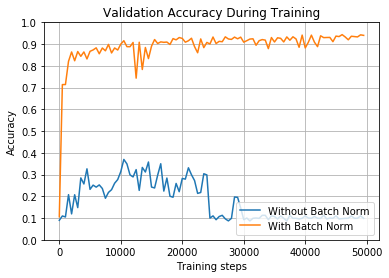

In [47]:

train_and_test(use_larger_weights=True,learning_rate=2,activation_fn=tf.nn.sigmoid)
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

***从上面实验可以得出，较小的Weights初始化，较小学习率，relu效果好。***  
其他的  
1.较小的Weights初始化，较大的学习率  
2.较大的Weights初始化，较小的学习率  
3.较大的Weights初始化，较大的学习率  
都选择sigmoid 